# BNG: Transform + Join

> Example of transforming WGS84 (EPSG:4326) into British National Grid (EPSG:27700), performing a spatial point-in-polygon join, and then generating a heat map of the results. More at Mosaic Docs [[BNG](https://databrickslabs.github.io/mosaic/usage/grid-indexes-bng.html) | [ST_Transform](https://databrickslabs.github.io/mosaic/api/spatial-functions.html#st_transform) | [ST_SetSRID](https://databrickslabs.github.io/mosaic/api/spatial-functions.html#st_setsrid)].

1. To use Databricks Labs [Mosaic](https://databrickslabs.github.io/mosaic/index.html) library for geospatial data engineering, analysis, and visualization functionality:
  * Install with `%pip install databricks-mosaic`
  * Import and use with the following:
  ```
  import mosaic as mos
  mos.enable_mosaic(spark, dbutils)
  ```
<p/>

2. To use [KeplerGl](https://kepler.gl/) OSS library for map layer rendering:
  * Already installed with Mosaic, use `%%mosaic_kepler` magic [[Mosaic Docs](https://databrickslabs.github.io/mosaic/usage/kepler.html)]
  * Import with `from keplergl import KeplerGl` to use directly

If you have trouble with Volume access:

* For Mosaic 0.3 series (< DBR 13)     - you can copy resources to DBFS as a workaround
* For Mosaic 0.4 series (DBR 13.3 LTS) - you will need to either copy resources to DBFS or setup for Unity Catalog + Shared Access which will involve your workspace admin. Instructions, as updated, will be [here](https://databrickslabs.github.io/mosaic/usage/install-gdal.html).

--- 
 __Last Update__ 28 NOV 2023 [Mosaic 0.3.12]

## Install Mosaic

> Mosaic framework is available via pip install and it comes with bindings for Python, SQL, Scala and R. The wheel file coming with pip installation is registering any necessary jars for other language support.

In [0]:
%pip install "databricks-mosaic<0.4,>=0.3" --quiet # <- Mosaic 0.3 series
# %pip install "databricks-mosaic<0.5,>=0.4" --quiet # <- Mosaic 0.4 series (as available)

Python interpreter will be restarted.
Python interpreter will be restarted.


### Enable Mosaic in the notebook

> To get started, you'll need to attach the wheel to your cluster and import instances as in the cell below. The defautl grid index system is set to H3. In order to use British National Grid you'll need to set the configuration parameter.

In [0]:
# -- configure AQE for more compute heavy operations
#  - choose option-1 or option-2 below, essential for REPARTITION!
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management
spark.conf.set("spark.sql.shuffle.partitions", 1_024)                  # <-- default is 200

# -- import databricks + spark functions
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

spark.conf.set("spark.databricks.labs.mosaic.index.system", "BNG")
mos.enable_mosaic(spark, dbutils)
# mos.enable_gdal(spark) # <- not needed for this example

# --other imports
import os
import pathlib
import requests
import zipfile
import warnings

warnings.simplefilter("ignore")

### Setup Catalog + Schema

> You will want to adjust for your environment.

In [0]:
catalog_name = "mjohns"
sql(f"USE CATALOG {catalog_name}")

db_name = "london_cycling"
sql(f"CREATE DATABASE IF NOT EXISTS {db_name}")
sql(f"USE SCHEMA {db_name}")

Out[47]: DataFrame[]

## Setup Data

> The download snippets are setup to only download 1x.

In [0]:
user_name = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()

data_dir = f"/tmp/mosaic/{user_name}"
print(f"Initial data stored in '{data_dir}'")

Initial data stored in '/tmp/mosaic/mjohns@databricks.com'


### Initial London Postcodes [177]

> Make sure we have London Postcode shapes available in our environment.

In [0]:
postcodes_dir = f"{data_dir}/postcodes"
postcodes_dir_fuse = f"/dbfs{postcodes_dir}"
dbutils.fs.mkdirs(postcodes_dir)

os.environ['POSTCODES_DIR_FUSE'] = postcodes_dir_fuse
print(f"POSTCODES_DIR_FUSE? '{postcodes_dir_fuse}'")

POSTCODES_DIR_FUSE? '/dbfs/tmp/mosaic/mjohns@databricks.com/postcodes'


In [0]:
%sh 
wget -P $POSTCODES_DIR_FUSE -nc  https://raw.githubusercontent.com/databrickslabs/mosaic/main/notebooks/data/London_Postcode_Zones.geojson
ls -lh $POSTCODES_DIR_FUSE

File ‘/dbfs/tmp/mosaic/mjohns@databricks.com/postcodes/London_Postcode_Zones.geojson’ already there; not retrieving.

total 937K
-rwxrwxrwx 1 root root 937K Nov 28 15:19 London_Postcode_Zones.geojson


_Load Postcode Polygons from GeoJSON_

In [0]:
postcodes = (
  spark.read
    .option("multiline", "true")
    .format("json")
    .load(postcodes_dir)
    .select("type", explode(col("features")).alias("feature"))
    .select("type", col("feature.properties").alias("properties"), to_json(col("feature.geometry")).alias("json_geometry"))
    .withColumn("geometry", mos.st_geomfromgeojson("json_geometry")) 
)
print(f"count? {postcodes.count():,}")
postcodes.limit(1).display() # <- limiting for ipynb only

count? 177


type properties json_geometry geometry FeatureCollection List(E2 postcode district, E2) {"coordinates":[[[-0.04385,51.53179],[-0.04324,51.53155],[-0.04277,51.53153],[-0.04163,51.5311],[-0.0415,51.53073],[-0.0415,51.5307],[-0.04142,51.53057],[-0.04089,51.53015],[-0.04087,51.53013],[-0.04046,51.52965],[-0.04046,51.52958],[-0.04052,51.52941],[-0.04096,51.52886],[-0.04074,51.52868],[-0.04047,51.52738],[-0.04145,51.52711],[-0.04152,51.52714],[-0.04299,51.52695],[-0.04319,51.52677],[-0.04332,51.52673],[-0.04371,51.5267],[-0.04399,51.52655],[-0.04427,51.52646],[-0.0449,51.52659],[-0.04568,51.52638],[-0.04598,51.5265],[-0.04605,51.52651],[-0.04697,51.52632],[-0.04731,51.52601],[-0.04748,51.526],[-0.04798,51.52615],[-0.04847,51.52636],[-0.04881,51.52611],[-0.04903,51.52559],[-0.04903,51.52549],[-0.04973,51.5255],[-0.04994,51.5253],[-0.05028,51.52521],[-0.05061,51.52522],[-0.0508,51.52508],[-0.05175,51.52497],[-0.05203,51.52527],[-0.05272,51.52562],[-0.05292,51.5256],[-0.05272,51.52446],[-0.05297,51.52434],[-0.05318,51.52434],[-0.05362,51.52441],[-0.05375,51.52432],[-0.05381,51.5243],[-0.05478,51.52427],[-0.05486,51.52431],[-0.05537,51.5243],[-0.0556,51.52419],[-0.05646,51.52428],[-0.0565,51.5243],[-0.05685,51.52432],[-0.05701,51.52412],[-0.05803,51.52381],[-0.05844,51.52392],[-0.0585,51.52392],[-0.0588,51.52386],[-0.05955,51.52391],[-0.05965,51.524],[-0.06114,51.52382],[-0.06126,51.52387],[-0.06152,51.52368],[-0.06277,51.52339],[-0.063,51.52324],[-0.06344,51.52324],[-0.06371,51.52332],[-0.06426,51.52333],[-0.06452,51.52321],[-0.06593,51.52312],[-0.06628,51.52297],[-0.06663,51.52309],[-0.06722,51.52323],[-0.06832,51.52308],[-0.06866,51.52297],[-0.06878,51.52284],[-0.06913,51.52281],[-0.0697,51.52274],[-0.07002,51.52294],[-0.07184,51.52302],[-0.0716,51.52335],[-0.07159,51.52355],[-0.07121,51.52386],[-0.07098,51.52393],[-0.0708,51.52436],[-0.07093,51.52452],[-0.07167,51.52459],[-0.07187,51.52454],[-0.07205,51.52435],[-0.07242,51.52414],[-0.07245,51.52412],[-0.07258,51.52409],[-0.0731,51.52414],[-0.07339,51.52448],[-0.07379,51.52454],[-0.0741,51.52448],[-0.07412,51.52443],[-0.07475,51.52402],[-0.0749,51.52434],[-0.07499,51.52439],[-0.07573,51.52432],[-0.07592,51.52447],[-0.07614,51.52449],[-0.07638,51.52447],[-0.07704,51.52482],[-0.07715,51.52516],[-0.07678,51.52529],[-0.07674,51.5256],[-0.07684,51.52578],[-0.07761,51.52603],[-0.07733,51.52625],[-0.0771,51.52682],[-0.07758,51.52696],[-0.07776,51.52737],[-0.07836,51.52779],[-0.07773,51.5281],[-0.0777,51.52815],[-0.07775,51.52826],[-0.07888,51.52838],[-0.07891,51.52842],[-0.07891,51.52854],[-0.07912,51.52878],[-0.07922,51.52931],[-0.07914,51.52945],[-0.07915,51.52966],[-0.07837,51.52981],[-0.07814,51.53003],[-0.07765,51.53008],[-0.0776,51.53027],[-0.07725,51.53037],[-0.07732,51.53066],[-0.07678,51.53106],[-0.07724,51.53149],[-0.07669,51.53208],[-0.07723,51.53234],[-0.07781,51.53236],[-0.07782,51.53237],[-0.07788,51.53285],[-0.07798,51.53291],[-0.07734,51.53365],[-0.07741,51.53369],[-0.07787,51.53377],[-0.07828,51.53422],[-0.07721,51.5345],[-0.07697,51.53444],[-0.07678,51.53451],[-0.07675,51.53466],[-0.07699,51.53491],[-0.07749,51.53493],[-0.07784,51.53517],[-0.07773,51.53525],[-0.0771,51.53533],[-0.07706,51.53558],[-0.07707,51.53561],[-0.07733,51.53571],[-0.07733,51.53586],[-0.07689,51.53611],[-0.07704,51.53638],[-0.07668,51.53666],[-0.07614,51.53661],[-0.07573,51.53631],[-0.07495,51.53642],[-0.07462,51.53626],[-0.07396,51.5364],[-0.07315,51.53591],[-0.07302,51.53588],[-0.0728,51.536],[-0.07197,51.53602],[-0.07143,51.53581],[-0.07109,51.53597],[-0.07033,51.53598],[-0.07013,51.53583],[-0.0694,51.5358],[-0.06928,51.53588],[-0.06827,51.53599],[-0.06805,51.53582],[-0.06726,51.53579],[-0.06724,51.53579],[-0.06669,51.53573],[-0.06665,51.53574],[-0.06597,51.53571],[-0.06579,51.53564],[-0.06521,51.5356],[-0.06506,51.53568],[-0.06461,51.5357],[-0.06455,51.53566],[-0.06397,51.53544],[-0.06329,51.53555],[-0.06269,51.53536],[-0.06259,51.53535],[-0.06244,51.53545],[-0.06091,51.53522],[-0.06101,51.53499],

### Initial London Cycling Data [~40M]

> We will setup a temporary location to store our UPRN data and then generate a table.

In [0]:
uprns_dir = f"{data_dir}/cycling"
uprns_dir_fuse = f"/dbfs{uprns_dir}"
dbutils.fs.mkdirs(uprns_dir)

os.environ['UPRNS_DIR_FUSE'] = uprns_dir_fuse
print(f"UPRNS_DIR_FUSE? '{uprns_dir_fuse}'")

UPRNS_DIR_FUSE? '/dbfs/tmp/mosaic/mjohns@databricks.com/cycling'


In [0]:
uprns_url = 'https://api.os.uk/downloads/v1/products/OpenUPRN/downloads?area=GB&format=CSV&redirect'

# The DBFS file system is mounted under /dbfs/ directory on Databricks cluster nodes
uprns_dir_fuse_path = pathlib.Path(uprns_dir_fuse)
uprns_dir_fuse_path.mkdir(parents=True, exist_ok=True)

uprns_zip_fuse_path = uprns_dir_fuse_path / 'uprns.zip'
if not uprns_zip_fuse_path.exists():
  req = requests.get(uprns_url)
  with open(uprns_zip_fuse_path, 'wb') as f:
    f.write(req.content)
else:
  print(f"...skipping '{uprns_zip_fuse_path}', already exits.")

display(dbutils.fs.ls(uprns_dir))

...skipping '/dbfs/tmp/mosaic/mjohns@databricks.com/cycling/uprns.zip', already exits.


path,name,size,modificationTime
dbfs:/tmp/mosaic/mjohns@databricks.com/cycling/uprns.zip,uprns.zip,582770505,1701185111000


In [0]:
uprns_data_fuse_path = uprns_dir_fuse_path / 'data'
uprns_data_fuse_path.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(uprns_zip_fuse_path, 'r') as zip_ref:
    zip_ref.extractall(uprns_data_fuse_path)

In [0]:
%sh ls -lh $UPRNS_DIR_FUSE/data

total 1.9G
-rwxrwxrwx 1 root root  192 Nov 28 15:35 licence.txt
-rwxrwxrwx 1 root root 1.9G Nov 28 15:35 osopenuprn_202310.csv
-rwxrwxrwx 1 root root   88 Nov 28 15:35 versions.txt


In [0]:
csv_name = 'osopenuprn_202310.csv' # <- adjust to the name ^

# - alter csv columns
_df = (
  spark
    .read
      .option("header", "true")
      .option("inferSchema" , "true")
    .csv(f"{uprns_dir}/data/{csv_name}")
)
columns = [F.col(cn).alias(cn.replace(' ', '')) for cn in _df.columns]

# - write csv to table
spark.sql("drop table if exists uprns")
_df.select(*columns).write.format("delta").mode("overwrite").saveAsTable("uprns")

> We will load the Unique Property Reference Numbers (UPRNs) data to represent point data. 

In [0]:
uprns = spark.read.table("uprns")
print(f"count? {uprns.count():,}")  # <- faster after table gen
uprns.limit(10).display()           # <- limiting for ipynb only

count? 40,593,998


UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE
1,358260.66,172796.5,51.4526008,-2.602075
26,352967.0,181077.0,51.5266333,-2.6793612
27,352967.0,181077.0,51.5266333,-2.6793612
30,354800.0,180469.0,51.5213173,-2.6528615
31,354796.0,180460.0,51.521236,-2.652918
32,353473.0,180409.0,51.5206696,-2.671979
33,352548.0,180308.0,51.5196842,-2.6852966
34,352515.0,180360.0,51.5201489,-2.6857792
38,352462.0,180401.0,51.5205131,-2.6865486
41,354662.0,180364.0,51.5203621,-2.6548369


## Reproject Postcode Geometries to BNG SRID
> British National Grid expects coordinate of geometries to be provided in EPSG:27700. Our geometries are provided in EPSG:4326. So we will need to reproject the geometries. Mosaic has the necessary functionality to help us achieve this.

In [0]:
postcodes_bng = (
  postcodes.select(
    "type", "properties", "geometry"
  ).withColumn(
    "geometry", mos.st_setsrid("geometry", lit(4326))
  ).withColumn(
    "geometry", mos.st_transform("geometry", lit(27700))
  )
)
postcodes_bng.limit(1).display() # <- limiting for ipynb only

type properties geometry FeatureCollection List(E2 postcode district, E2) List(5, 27700, List(List(List(535781.9380575956, 183244.6883788783), List(535824.9598637373, 183219.13114683155), List(535857.6174945063, 183217.77906512795), List(535937.9652897029, 183172.0778235984), List(535948.0833085249, 183131.17423886806), List(535948.1726131596, 183127.83816223528), List(535954.1083358275, 183113.53036918928), List(535992.1193609729, 183067.80952594848), List(535993.5661128352, 183065.62262108468), List(536023.433274843, 183013.00698265154), List(536023.6417598329, 183005.22280622984), List(536019.9864220938, 182986.20691772352), List(535991.10526591, 182924.22825999785), List(536006.9008830489, 182904.62042294373), List(536029.5004004786, 182760.5587263456), List(535962.3273532258, 182728.7139400427), List(535957.3825413126, 182731.9200414074), List(535855.981967767, 182708.06319533306), List(535842.6443589143, 182687.67569398397), List(535833.745864351, 182682.98643173242), List(535806.7826882608, 182678.92696711444), List(535787.8063862727, 182661.7273213567), List(535768.6516090925, 182651.19990051258), List(535724.5650621236, 182664.48831547052), List(535671.083893747, 182639.69031467568), List(535649.9178289331, 182652.47882477642), List(535645.0325510963, 182653.46117701154), List(535581.7803402226, 182630.62884472188), List(535559.116011542, 182595.52657006297), List(535547.3534337038, 182594.09984491928), List(535512.2253112149, 182609.85480291082), List(535477.6131089614, 182632.3006572011), List(535454.7701589285, 182603.87101454858), List(535441.0515128053, 182545.6387309049), List(535441.3480281356, 182534.51847295318), List(535392.7614843239, 182534.3359901223), List(535378.7871684541, 182511.70721004112), List(535355.4689781135, 182501.07044976193), List(535332.54809557, 182501.57253937522), List(535319.7830267497, 182485.65304688836), List(535254.2094731658, 182471.66562843113), List(535233.8983120153, 182504.50927462179), List(535184.99899094, 182542.15613858588), List(535171.1848080601, 182539.5628792516), List(535188.4320349725, 182413.1610924584), List(535171.4449779494, 182399.35527161031), List(535156.8775325917, 182398.96765152615), List(535126.1481960944, 182405.93981478648), List(535117.3964801998, 182395.69169817545), List(535113.2935073929, 182393.35693709343), List(535046.0944043219, 182388.23154424207), List(535040.426642115, 182392.53211760416), List(535005.0780822264, 182390.4797147903), List(534989.4483038574, 182377.82341214077), List(534929.5250849993, 182386.2466646775), List(534926.6912537713, 182388.39701484208), List(534902.353081025, 182389.97622999403), List(534891.8446569596, 182367.44095034344), List(534822.0030447827, 182331.08968924946), List(534793.2369068528, 182342.5672069927), List(534789.0747382878, 182342.45676511177), List(534768.4409085622, 182335.2324451239), List(534716.2662738861, 182339.41255793435), List(534709.0639194129, 182349.23683925637), List(534606.2339552218, 182326.48043027992), List(534597.7622726331, 182331.81999374554), List(534580.2859382916, 182310.2136126347), List(534494.4274051443, 182275.668296282), List(534478.9138032356, 182258.56548488926), List(534448.3907594526, 182257.75755606516), List(534429.425290218, 182266.15809321858), List(534391.2421295254, 182266.26060967514), List(534373.558798522, 182252.43915361603), List(534276.0107687588, 182239.84453922248), List(534252.1718241313, 182222.5224069195), List(534227.5393820464, 182235.22514476796), List(534186.199365603, 182249.71225135983), List(534110.3320511248, 182231.01675352425), List(534087.0688351066, 182218.16183286835), List(534079.1258644154, 182203.4857467148), List(534054.9339733121, 182199.50889328966), List(534015.597704571, 182190.68140581233), List(533992.8122403203, 182212.33640354726), List(533866.3224438406, 182217.90405003884), List(533882.0043343764, 182255.03975232004), List(533882.1118874322, 182277.29861049942), List(533907.563830076, 182312.466308441), List(533923.3136380416, 18

_Example: Compute some basic geometry attributes._

> Mosaic provides a number of functions for extracting the properties of geometries. Below are some that are relevant to Polygon geometries:

In [0]:
display(
  postcodes_bng
    .withColumn("calculated_area", mos.st_area(col("geometry")))
    .withColumn("calculated_length", mos.st_length(col("geometry")))
    # Note: The unit of measure of the area and length depends on the CRS used.
    # For British National Grid locations it will be square meters and meters
    .select("geometry", "calculated_area", "calculated_length")
  .limit(1) # <- limiting for ipynb only
)

geometry calculated_area calculated_length List(5, 27700, List(List(List(535781.9380575956, 183244.6883788783), List(535824.9598637373, 183219.13114683155), List(535857.6174945063, 183217.77906512795), List(535937.9652897029, 183172.0778235984), List(535948.0833085249, 183131.17423886806), List(535948.1726131596, 183127.83816223528), List(535954.1083358275, 183113.53036918928), List(535992.1193609729, 183067.80952594848), List(535993.5661128352, 183065.62262108468), List(536023.433274843, 183013.00698265154), List(536023.6417598329, 183005.22280622984), List(536019.9864220938, 182986.20691772352), List(535991.10526591, 182924.22825999785), List(536006.9008830489, 182904.62042294373), List(536029.5004004786, 182760.5587263456), List(535962.3273532258, 182728.7139400427), List(535957.3825413126, 182731.9200414074), List(535855.981967767, 182708.06319533306), List(535842.6443589143, 182687.67569398397), List(535833.745864351, 182682.98643173242), List(535806.7826882608, 182678.92696711444), List(535787.8063862727, 182661.7273213567), List(535768.6516090925, 182651.19990051258), List(535724.5650621236, 182664.48831547052), List(535671.083893747, 182639.69031467568), List(535649.9178289331, 182652.47882477642), List(535645.0325510963, 182653.46117701154), List(535581.7803402226, 182630.62884472188), List(535559.116011542, 182595.52657006297), List(535547.3534337038, 182594.09984491928), List(535512.2253112149, 182609.85480291082), List(535477.6131089614, 182632.3006572011), List(535454.7701589285, 182603.87101454858), List(535441.0515128053, 182545.6387309049), List(535441.3480281356, 182534.51847295318), List(535392.7614843239, 182534.3359901223), List(535378.7871684541, 182511.70721004112), List(535355.4689781135, 182501.07044976193), List(535332.54809557, 182501.57253937522), List(535319.7830267497, 182485.65304688836), List(535254.2094731658, 182471.66562843113), List(535233.8983120153, 182504.50927462179), List(535184.99899094, 182542.15613858588), List(535171.1848080601, 182539.5628792516), List(535188.4320349725, 182413.1610924584), List(535171.4449779494, 182399.35527161031), List(535156.8775325917, 182398.96765152615), List(535126.1481960944, 182405.93981478648), List(535117.3964801998, 182395.69169817545), List(535113.2935073929, 182393.35693709343), List(535046.0944043219, 182388.23154424207), List(535040.426642115, 182392.53211760416), List(535005.0780822264, 182390.4797147903), List(534989.4483038574, 182377.82341214077), List(534929.5250849993, 182386.2466646775), List(534926.6912537713, 182388.39701484208), List(534902.353081025, 182389.97622999403), List(534891.8446569596, 182367.44095034344), List(534822.0030447827, 182331.08968924946), List(534793.2369068528, 182342.5672069927), List(534789.0747382878, 182342.45676511177), List(534768.4409085622, 182335.2324451239), List(534716.2662738861, 182339.41255793435), List(534709.0639194129, 182349.23683925637), List(534606.2339552218, 182326.48043027992), List(534597.7622726331, 182331.81999374554), List(534580.2859382916, 182310.2136126347), List(534494.4274051443, 182275.668296282), List(534478.9138032356, 182258.56548488926), List(534448.3907594526, 182257.75755606516), List(534429.425290218, 182266.15809321858), List(534391.2421295254, 182266.26060967514), List(534373.558798522, 182252.43915361603), List(534276.0107687588, 182239.84453922248), List(534252.1718241313, 182222.5224069195), List(534227.5393820464, 182235.22514476796), List(534186.199365603, 182249.71225135983), List(534110.3320511248, 182231.01675352425), List(534087.0688351066, 182218.16183286835), List(534079.1258644154, 182203.4857467148), List(534054.9339733121, 182199.50889328966), List(534015.597704571, 182190.68140581233), List(533992.8122403203, 182212.33640354726), List(533866.3224438406, 182217.90405003884), List(533882.0043343764, 182255.03975232004), List(533882.1118874322, 182277.29861049942), List(533907.563830076, 182312.466308441), List(533923.3136380416, 182320.67111585021), List(533934.

## Reproject UPRN Points to BNG SRID

> The UPRNs table contains Unique Property Reference Numbers and positions provided in EPSG:27700 and EPSG:4326. Since we are operating in EPSG:27700 and using BNG as our indexing system, we will use the location data provided via Northings and Eastings coordinates.

In [0]:
_uprns_bng = (
  uprns
    .withColumn("uprn_point", mos.st_point(col("X_COORDINATE"), col("Y_COORDINATE")))
    # we are using WKT here for simpler displaying, use WKB for faster query run time
    .withColumn("uprn_point", mos.st_aswkt("uprn_point")) 
    .where(mos.st_hasvalidcoordinates("uprn_point", lit('EPSG:27700'), lit('reprojected_bounds')))
    .where(mos.st_isvalid(col("uprn_point")))
    .drop("LATITUDE", "LONGITUDE")
)
_uprns_bng.limit(10).display() # <- limiting for ipynb only

UPRN,X_COORDINATE,Y_COORDINATE,uprn_point
10010266671,542744.02,176316.22,POINT (542744.02 176316.22)
10010266672,543142.76,174400.84,POINT (543142.76 174400.84)
10010266673,540615.6,175439.19,POINT (540615.6 175439.19)
10010266674,540614.66,175444.2,POINT (540614.66 175444.2)
10010266675,540613.72,175449.22,POINT (540613.72 175449.22)
10010266676,540615.45,175454.73,POINT (540615.45 175454.73)
10010266677,540614.55,175459.75,POINT (540614.55 175459.75)
10010266678,540613.65,175464.78,POINT (540613.65 175464.78)
10010266679,537778.13,177195.59,POINT (537778.13 177195.59)
10010266680,537778.13,177195.59,POINT (537778.13 177195.59)


> Next step is optional. However, since we are constructing POINT geometries and ensuring they are valid it is prudent to write out the validated dataset. That way we are making sure validation is performed only once at ingestion time and not each time spark runs the queries (due to spark lazy evaluation). 

In [0]:
spark.sql("drop table if exists uprns_bng")
_uprns_bng.write.format("delta").mode("overwrite").saveAsTable("uprns_bng")

In [0]:
uprns_bng = spark.read.table("uprns_bng")
print(f"count? {uprns_bng.count():,}")

count? 40,591,073


## Spatial Joins

> We can use Mosaic to perform spatial joins both with and without Mosaic indexing strategies. Indexing is very important when handling very different geometries both in size and in shape (ie. number of vertices). In the context of Mosaic we are using grid index systems rather than traditional tree based index system. The reason for this is the fact grid index systems like BNG and/or H3 are far better suited for distributed massive scale systems. Mosaic comes with grid_tessallate expressions that allow the caller to index an arbitrary shape within grid index system of choice. One thing to note here is that tessellation is a specialised way of converting a geometry to set of grid index system cells with their local geometries. </br>

__Tessellation is applicable to any shape, Polygon, LineString, Points and their Multi* variants.__

### [1] Getting the optimal resolution

> We can use Mosaic functionality to identify how to best index/tessellate our data based on the data inside the specific dataframe. </br>
Selecting an apropriate tessellation resolution can have a considerable impact on the performance. </br>

In [0]:
from mosaic import MosaicFrame

postcodes_mosaic_frame = MosaicFrame(postcodes_bng, "geometry")
optimal_resolution = postcodes_mosaic_frame.get_optimal_resolution(sample_fraction=0.75)
optimal_resolution_str = postcodes_mosaic_frame.get_optimal_resolution_str(sample_fraction=0.75)

print(f"""
  Optimal resolution code is :{optimal_resolution}.
  Optimal resolution name is :{optimal_resolution_str}.
""")


  Optimal resolution code is :-4.
  Optimal resolution name is :500m.




> Not every resolution will yield performance improvements. By a rule of thumb it is always better to select more coarse resolution than to select a more fine grained resolution - if not sure select a lower resolution. Tessellation is a trade off between decomposition and explosion factor. The more fine grained the resolution is the more explosion of rows will impact the preprocessing time. However, it will make data more parallel. On the other hand, if the resolution is too coarse we are not addressing localisation related data skews. You can think of Mosaic's tessellation as a way to partition an overly complex row into multiple rows that have a balanced amount of computation each.

In [0]:
display(
  postcodes_mosaic_frame.get_resolution_metrics(sample_rows=150)
)

resolution,mean_index_area,mean_geometry_area,percentile_25_geometry_area,percentile_50_geometry_area,percentile_75_geometry_area
4,10000.0,412.35439945734294,101.33915798543552,393.67019398293326,579.0929378698623
-4,250000.0,16.49417597829372,4.0535663194174205,15.746807759317331,23.163717514794495
-5,2500.0,1649.4175978293717,405.3566319417421,1574.680775931733,2316.3717514794494
3,1000000.0,4.12354399457343,1.0133915798543551,3.936701939829333,5.790929378698624


### [2] Indexing/Tessellating using the optimal resolution

> We will use mosaic sql functions to index our points data. Here we will use resolution -4 (500m), index resolution depends on the dataset in use. There is a second best choice which is 4 (100m). The user can pass either numerical resolution or the string label to the grid expressions. BNG provides 2 types of hierarchies. The standard hierarchy which operates with index resolutions in base 10 (i.e. (6, 1m), (5, 10m), (4, 100m), (3, 1km), (2, 10km), (1, 100km)) and cell ids follow the format of letter pair followed by coordinate bins at the selected resolution (e.g. TQ100100 for (4, 100m)). The quad hierachy (or quadrant hierarchy) which operates with index resolutions in base 5 (i.e. (-6, 5m), (-5, 50m), (-4, 500m), (-3, 5km), (-2, 50km), (-1, 500km)) and cell ids follow the format of letter pair followed by coordinate bins at the selected resolution and folowed by quadrant letters (e.g. TQ100100SW for (-4, 500m)). Quadrants correspond to compas directions SW (south west), NW (north west), NE (north east) and SE (south east).

_Full processing of all the Cycling data can take a little while, so we offer you a full or sample option, depending on your appetite._

In [0]:
uprns_opt = (
  uprns_bng
    .withColumn("uprn_bng_500m", mos.grid_pointascellid("uprn_point", F.lit(optimal_resolution)))
    .withColumn("uprn_bng_500m_str", mos.grid_pointascellid("uprn_point", F.lit(optimal_resolution_str)))
    .withColumn("uprn_bng_100m_str", mos.grid_pointascellid("uprn_point", F.lit("100m")))
)
# - uncomment to only use a 1% sample
#   using 400K of the 40M
uprns_opt = uprns_opt.sample(0.01)

print(f"count? {uprns_opt.count():,}")
uprns_opt.limit(10).display() # <- limiting for ipynb only

count? 406,871


UPRN,X_COORDINATE,Y_COORDINATE,uprn_point,uprn_bng_500m,uprn_bng_500m_str,uprn_bng_100m_str
10023609852,268073.09,213302.63,POINT (268073.09 213302.63),SN6813SW,SN6813SW,SN680133
10023610059,225741.11,214655.3,POINT (225741.11 214655.3),SN2514NE,SN2514NE,SN257146
10023610071,250735.0,200942.0,POINT (250735 200942),SN5000NE,SN5000NE,SN507009
10023610128,250243.0,199800.0,POINT (250243 199800),SS5099NW,SS5099NW,SS502998
10023610129,251011.0,200584.0,POINT (251011 200584),SN5100NW,SN5100NW,SN510005
10023610195,250831.0,199092.0,POINT (250831 199092),SS5099SE,SS5099SE,SS508990
10023610218,255862.0,201157.0,POINT (255862 201157),SN5501SE,SN5501SE,SN558011
10023610233,241079.0,207472.0,POINT (241079 207472),SN4107SW,SN4107SW,SN410074
10023610499,253442.0,200037.0,POINT (253442 200037),SN5300SW,SN5300SW,SN534000
10023610552,242093.0,219684.0,POINT (242093 219684),SN4219NW,SN4219NW,SN420196


> Mosaic has a builtin wrappers for KeplerGL map plots using mosaic_kepler IPython magics. Mosaic magics automatically handle bng grid idex system and CRS conversion for you. Given that Kepler Plots are rendered on the browser side we are automatically limiting the row count to 1000. The end user can override the number of ploted rows by specifying the desired number.

In [0]:
spark.catalog.clearCache() # <- cache is useful for dev (avoid recomputes)
count_per_index = uprns_opt.groupBy("uprn_bng_500m").count().cache()

<img src='' width='50%'
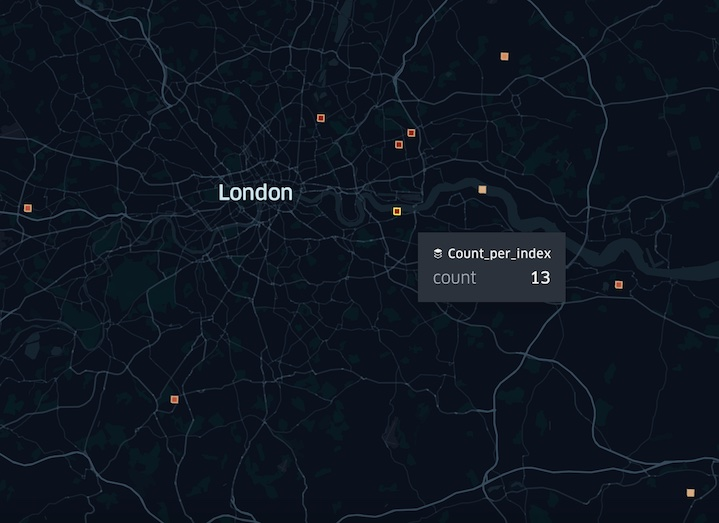

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABZ6gAwAEAAAAAQAABBakBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAgsCzwMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAEBAQEBAQIBAQIDAgICAwQDAwMDBAYEBAQEBAYHBgYGBgYGBwcHBwcHBwcICAgICAgJCQkJCQsLCwsLCwsLCwv/2wBDAQICAgMDAwUDAwULCAYICwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwv/3QAEAC3/2gAMAwEAAhEDEQA/AP4gCSTk8mr9pFFFC2oXSh0U7UQ9Hf8AwHerZ8P38Nmuo35S2gdigLsN5I54QHd+gqlezwzeVFb7ikKbAWGM85Jx2zXunnXvsTnVmBBjgiUpxGQOU/xPue9JpbNNem3lJZbgMr569M5+oIzWXWrbIlgI9Qud28/NFGpwT/tE9l/n9KAZu+FF0+a1uLbU3aCK4xG0wH3d2Nv1w3JUcms3VPD7aVqEunS3dszwsVb5yOnqCOD7dqyr++n1CQyz7VHOEQbUX2Ve1T6t/wAfnzff2J5n+/gZo6Cs7jH0y+RPMRPNT+9Ed4/TmqHfHpVmzKJPuLMhPQqcHP1Fbk01vqMQt7iQGXpHIcZz6MfQ+vY0EudpWOar2D4bfELR9EsJ/BfjeB7nRLyTzd0fMltKRtLqvIZSPvL36jJNeRSRvFI0MoKupwQeopI0eZ/LhUux7KMmhOzKlFSVmfVNl8LbkaXNqXw3uofENiZCyi3kHmIO4KnkH2NeGeLL2S6vI9Nmje3MJIkSRdrh/Qj2qnogl0G4m1mK+nsry3QMps2xJkkABmyBj25+lew2XxB8DfEeL+xvinbJBqBjEdvrTDBDDp9oEe0Y9WHHrjrV6PyMHBp33PO7TS7W/wBMeQo6yID8x6Nxnp6V51OEjlKwMD0xg9D6V7B4r0bxv8OVNlf2UX2R8mC7jBkhdT3DZIOfQ1xOi6jrUch1bO6K35G6NTG0n8K8jHv9KlrowpLlXNfQwtX2/wBpzY/vDOP72Bn9azupwOSa3ruSzlHn6jFsmkJZmg+XJPJ+U8flils7iGMMbOMxKBzKxy/59B+FI19olHmMY29wG2GN9x6Dac/yqyNK1UsqLaysznACoWJP0Ga0ptQeOPKTM2cDaJD3/Gse2vb2ymFxZzSRSA5DIxU5/A0ghPmV0dJ4IsI7zxPA91xBZE3M5PG1Yfm5/wCBYFc5f3kmpX0+oTfeuJHlP1ck/wBa9LsNdFv8OtRl1OFZptWvFtjchQJljjXzGGe+49QetcIbDT4XDSXBmGCwjVCpb2yeB796phzau42EG6td0xEcScPIwzz6L6n2pgvnhUrpKGFR1fgufqe30FU7m7ku2DPhVUYRF4VR7D+tJb3DW7FgMg9RSDlsnyohcOGPmZyeTnrzTafJI8r75Dk0ykWr21JIZpbeVZoGKuvIIrbhttM1XLRu1tOAWaILuVyOuzng98H8KwKnMVzbkTYKkHIYdiKYm13LX2uzg/48oAW/vzfMfwX7o/WrMEsmrk2V2y+cR+6kfC8j+EngYPbPQ1BfCG4gj1OAYaQlZlA+VZBzkezDn65rMIzwaBkr29xHN9meNhJ/cxz+VdBo2iatc3o08WzkXY8rGO5+6fwOKoQ3msSWX2aCd/KQ42A8jPv1x+NQvbtaRLcl2SYEEYPIYHIOfbrRoQ6iva+paufDut2Mxg1CA27LwfNYKB+tCXsOmwmK1bzpe0mMIn+7nkn3PHpUOpk3xGsHlpyfN9pe/wD311rLoKtdaikknJOSfWhRuYL61pw2tp5QklOc88nFUJ1jWUrGdy0iY1FJtIvRXMNrH5YbzD7dBVeMr9uHlgY3cY9KqVPbSiKYM3A7nrQJ07JtbmvZC8tNUh+zSMq7w5IYgALySce1YkpRpXaP7pYkfQnitGG/lN9G8Yyu4DYe4bgj8c1SuokgupYIzlUdlB9gaZUL297c1dB1PU7LUreOymZBJLHGV+8pDMAQQQR+lbvjfU0m8Zao0ltC+Ll1ztKk7fl6g+1ReBtJS81STWr0f6FpEZvJyTjPl8og9WZsYA54NcpeXk+oXk2oXOPMuJGkbHTLkk/zp9B2XMbv2rS5dAEU1s8ZFySGjkJAynPytx+tQQaEdShDaHOLmctg2+0rKB2IHRh645FVrkSwaNawNws7vOB64+QH9DT9HleyaXWIZDHLaKDERwfMfgEfQZNHqLpoX9WtY7/xAukaYgVYES2yCSCYxh356c549q9PgtYLSBYIRtSMADBxwK5rQJrW7Da68TJcynZKQPkY9S69vmP3hnrW7q0/2bSri5B+7ExB/Cn5mFRttRPJtXlMjQpn5TGJMf7UhJJ+pph1ECMCNfm9+lN1QbLpYv8AnnFGv5KKqQwNOxCkDFSzaUYtJyNa1ufPVt/BXrWK20uSnTPGaszWktum8kEHg4qpSJpxjdyjsITgZrS1MeXLFa/88YkU/U/Mf51DYWr319DZxKWaRwMDk47/AKU6YyajqMjQLuaVztA9O36UzXqVY43mkWGIbmcgAepNXr+VV22EBzFBxkfxP/E39B7VJ5kOnKyW7iSdhtLr91AeoU9yfX8qygMcUAFaWnkTB9NkOBPjYT2kH3fz6GqCo7qzKMhRk0sMVxcTJb2as80jBY1QFmLk/KAByST0ApASWlneX95Hp1jC81xM4jjiQZdnJwFA9f8APSvcNXltPg9odx4X0hluPEuoRGLUbyM5SyifrbwsP4z/ABsP8AOm8RXdp8L9QnnsIgvirVIlkncAFNNjdQGSM8gzOQSSPuj8M+CRswMtzqgJgBOOfmkY84BPXPUnt9au3Lp1Od1HNpJaGTb2H7gXN1mG36Kcctjsg7/XoKfLqDlGt7RRBERgqv3iP9puprRbVp9beKw1Qgoi+Vbnp5I/hUf7OeoOfWufZWRijjDKcEehFS/I6F5iUUUUhjlbY4fAODnB6HFdI/ie4e2W3ESjbk5zwSe5rmaKAHySNLI0r/eY5NMoooAKcrvG4kjYoykFWUkEEdCCOQR6im0UAe5aXr2n/Fu1j8KeOrhLfXUATTdWkAUSntb3JHUE/cfqDx1+94/rOjar4e1SfRNcga2u7Ztkkb9Qf6g9QRwRyKjtbWGWCe5uhmKJMY/vO3Cj+p9hXuNlDcfGHwoujXmW8UaJCTZSs3zX9ovJhYk8yp1UnqO/LVfxepk2oPyPAKKOQSCCCOCCMEEeoPQ0VBqFFSwx+dKI+cH0FT3VqtuoZSTk45oJc0ny9SnWzNNLd6ekkLYNuqxyKOoUdGHseh9DWNU9tcSWswni6jqD0IPUH2NA2rkbyPId0hyelMq7d28aBbq15gk6Z6qw6qfp29RVKgF5BRRR7GgYUVZs7K81G5Wy0+J55m6JGpZj+A/nXX/8Ifb6WQfFt/FYtx/o8X7+5PttXhfxJp2E2kcQqs7iOMFmY4AAyST2A713cfw38UJY/wBp6osGnQbwm68mWI8jPTk9O2M1oSeJtH8KIbfwhZ+XdkYe6uSJZlB7DHyqfXb0rz69vrrUZvPvX8x+eT79fzp6IV29jq9U1XTdH0tvDXhmXzhPg3l2Bt87HRE7iMf+PfSuJoq0LK5ZNwX8DwaTYXUd2VaKVlKsUPUHFJSKCiiigCYW8pVWQbs/3ecVqaZK21oX4CdPaqFvdLbg4QnOM81JPfCWMxomM9TQc9SMprla07n/0P4kbiwijjMsQy/cnqRVKCCa5kEVupdjzgelaa2KOA0js4PPWtGxt7SOR4CozNG6Y7k4zj9K9w8aNW2jdzPGn/YIzd6iobH3IgQ24/7WOg/nWVNPJcStNO2526mrx1EBQIUx9elRLfMp5Rce1BopT3cSlWvkasMHAuwOOwlx/wCzfzrJZizF26k5pUcxOsq9UIb8uaDQaRjg0bdxCgZJ4q/qkflajMF+6zb19w3IqBLS5cgqpX3PGKBOSSu2aFvq1xazqt/FHeJGeY513Aj0zwf1qxfXVzNC11pzeXbE/NHGAnlk9jjt6HvUd1bRyjzGO0gdar6VujuzcKxWKIbpCR1T+6R33dMU7mcJqSuT2lqTpbs3AnkUD/dj5P6msmaPypWj9OldOL6x1KUtHi1Y8JCT+7UdgrdvofzrPvbJfPxcN5ZXgg9aGT7RqfvbHT+Dfil4y8D2503Sp1n05/v2N0gltznrhTgrn/ZIHfFewx6n8KfH+gJazWk/he6t1k1CWOwT7RFMANjEKcEkDnGA2OhPSvlwgAkD1rpPDuq3djeQyWZAubdi8Bbo2eGjb2YZ/GqUnsy5009T0aSD4H2S/aJtZ1PVBjKwW9kIGP1eX5R+HNVz8TvDOi/L4I8LWcDrylxqTNfTA/7pIRfwJrjPEGj2Mlovifw4pFhI2yWE8tayn+Bv9k/wH8K5WKEyq7ggBBk0m7bEqlBK7PXZfjj4s1GP7N4osdK1m3/553VmvA9AybcD8DS+IfC3h3WfD7fELwHG0Wm+csN7YPy1jOwyNjfxRNkbT1Gcew8br3P4IXH9pTa/8PpT8uu6bKIh2Fxb5dMe5BP5U029GFSCjFuOhyeh2ovfDus6RIuVi8u/j+sZ2v8A+OkVgMoHUcCuo8MXEI0XXLxmAxYhD7GVwP6V5zPcS3L7VztJwFHepZhGMqj1H33kb1MJGehxVKtSSHT7JjBch5pR94IQqqfTODk+vamfa7OLm2tVz6ykv+nAoOyKsrFKGGa5bZbo0h9FGavf2Vdj5ZDGjf3WkUN+Wf61FNqN9OuySVgv91flX8hgVRwKNB6l1bdre7EN2NhGD1yPbmttigUmTGO+ayI7uB4lgv4zIEGEZTtYD0z3H8qeb2yKhPspZR/elYn+lBjVpOTTL0KQTF7Nc4ulJU9g6ciudByM10umXmlHULRXt5VCzLnZJngkZ6j0zVa+h0D7dNDZSzRxLIwR5FDAqCcEgYIosXBNKzMu3na3lEi8+o9RVm+mt7gJJGTux09BVe5tpbWTy5cHIyrDlWHqDVekDppyU+pbtblYN8Uy+ZFJgOvQ8dCD2Iq5daLdQ2kepW/762m3bHXlhtOCGUZKn68HtWRV/SLuXTtVt762cxOkqNuHHQjr7fWmW/IzvlIz1rRa0SCIyTnJ7KOOa072e11HU5hrB+zzNI5aZF4JJJ+ZB6+o/Ks++jvFQPKqmL+F0+Zfz/xxQRLmbVjNrStIbNITfagrPHu2LGh2ljjPXnAFZuGPCDJPAHvWvrEkcciaZbnMVplQ2ACznBYnHvwPYUIt9iOO7sbY+daROJQPlLsGVT69ByO1RabpmoazfJp2mRNNPKeFH6knsB3JqJbK7kljt403PKwRAOcsxwB+ddt4i1GHw4J/Bvh392iER3lwD+8uHH3lz/DGpyNo69/cFfsVvEN5Z20MPg3RXEttbyB7iYdLi47t/ur0X8/SueNlFNeJbR/IpBZ2/uqOp/KspfkIK8Y9K1iwg0neSTNdOVJPTyk/XJb9BQTyu6dyleXP2u4MyjanCovoo4Arat4oU0qOKQAtM5lIPoPlX+tc6qNIwjT7zEAfU1vyrby3ki4BWHEafRBj+eaBVvhPRfDgA0eJV6AuPw3Gs3xI6pJa2cg3wXL7HQMVPUcj/A8Vt6NAbfTIYz1I3H/gRz/WuI1LWVg1WPV+CyEeQOoVAeXPuedv51XQxppuVzA1qLN7LfQEvBK7FH9ADjB9CKzYLhoCXTBB65q7cPeaVqE9vA7RFXIx0yOoyD7Gr9rcw3cLMkMf25T8pOArL7L03g/p71J0NJqz2Gvb3N7Z71TZu5UOQu7HpkjNUDprRnF1NFF7Ftx/Jc1HLbaldSmSaKWRz1JUk/yqtLBNbP5U6GNsZwwwcUBCCirI39PvY7WSX+zwVWOJ2aQ/fc4wPoMnp+dZ1sPsdg910eXMUf0/iP8ASpLCCSWzmSL787xwr/6Ef0FVr+aOWfZB/qoh5afQd/xPNA7FKlABYAnAPc9qSikUalzNFBb/AGeIgnGDivYbMR/BbSk1S6VW8X38WbeJgG/s2CQf6xh/z2cfdB+6PxzmeDLPT/BPhf8A4WrrUC3F087W+i20gzG0yD57hx3WI/dHQsPoR5PqGoX2qX0+q6pK1xc3DmSWVzlndupP+cAcDgVW2vUxjDddOvmdOuoxXOkQ3OrTMZUkkQHBeSQMd5YsTz8xPJrnNQvTfThwNsaKERfQD+pPJqbVo3tZ001xtNsgVh/tt8zfzrLpMuMEnzIDWlqZ82SK9/57xhj/ALw4b9RWbWneqbe1gspf9ahdmH90PjA+vc+lBRmUUUUhhRRRQAUUUUAFIelLRQB0CGOC1VN37tTv5/vEYz+VOsNX1O01GK/0WU281u4kjmH3kYdCP889+K59nZ8FjnAwKEdo23ocEUGHserd2e4/ELSLPxpojfFjw3EIpVZU1q1QcQzHpOo/55yfxeh5P8VeGV6D4P8AHd74P1H+1rFUlDo0VxbTcxXETfeRvY9jyQefUHR8W+DdHuNHbx/8O2ebRdwFzbucz6fIf4JOuY/7snIx1OOap66hSlJLlked2EgScqf4h/KrN/NEYzEOW/lWQR2NFSU6ScuYKKKlgiaaURj6n2FBo2krsns7lIS0NwC0EvDgdfYj3FMu7WS0k2Mdytyjjoy+o/zxUlxZtCpkByo/Ouh8KaempPOuqSeVpdsnm3TkZ2A8Ls/22PAA696aJU01zI5/TbOe/vo7S2jaV25CKNzHHoBXa3nhjSdFn8/xhdmOTAP2K2w85/3m+7GPrk07VtevNHgay8IwLp9jIBmeI75pVPTzJeqn/ZGMdK867k9ycn3NGwuVuXNc7C98Y3n2VtL8PxLpVm33kgJ8yT/rpL95v0FYNmRZ2smoIAJN4jjPoSMs31A6fWq1ratdSFd2xFG53PRV9f8AAd617y50RlRbZZDEvKw9CCcZLP3zjsOBQV5I5/Izz1oJxya0TqTj5Y4YVUdF8sH9TzQNTkU7o4YEbsyxjI/mKQyGPT7+aMSRQSMp7hTVyXUFRwEXPrngg1nSXNzNJ500jM/qSc1oPLb6mA1y4huOhcj5H/3sdD79DTInBStzGbKweVnHQnNR1o/2XPnb5kO7svmLk0v9j6r/AM8G+mRn+dFmWmloZtFWZrK9thuuIXQepBx+dVgQelIYUUUUAf/R/iLjvJI4REo5Hc+lRQ3MsFyl2DudDkZ71BRXuHmqCWxeu7eJVF3aZMEhwM9Ub+6f6eoqjWiR5WkBX4M8u5R/soMZ/M1nU2NBRRRSGbdpENRsJI2bbLabWQ9yjHBH/ATyPrTbuW5hUGMcd2qnp92LK581wWRlKOAcEq1W9UYbY2t23wyAlWxgkjqCOxHemYTg3NdjLeWWT/WMT7VenPl6ZbxxcLKXd/UspwPwA6Vm1oz/ALzTLaQdI2eM/UncP0oNrWtYzq1bOQ3qDS7hs7yBCT/C/YfRulZVWreznulMiYWNerudqj8aQMglikhlaCZSroSrKeoI4Ipm7aQQcHsa6N002aFX1i6AlUqoaAeazp33dACB0JPNV7y5bTbp7PT1EYjOA5AZ2HY5PTI7DpTsFzqvD0up27v4iSANZMFi1JJRiJ42OMn13dsAkN9av3nhnwfql5Ovw81TzYpP9XbX/wC5nHHIBYBXweh4PrmuBtJ715GundpccFXJIcHqDVS9tY4iHi+eCXlCf1B9x3p3MnFSbVzpo/h741d9jadKmOpcqq/mTiuh8N+GfH/hPxFY+KNJtEnnsJlmRUmjYNjgqfm/iUlfbNcBErTWnnajNL5Cnai7txZvYE4AHei203S7u4SGylMckhChXj5yfde38qEW79T6U8Z/DUaBpPiHxVpMTx6HqUVtdR9N8O6QmSEjnlW/AA+1fNa31vbNvsrcI46O7FyD6gcDNfRHww1y+e3uvhULlDFfqX065J8yE3qjJRsnHlyj5dpx0z1IrzC78JweILTUNV8PRfYrvSwWvtNkPzIVJVvJ/vYIOV6jt2qpK+qM4O11I8zopAQRkVI0bqquw4boazN7jKKKKACiiigDS0fH9pRMf4dzfiFJpWsonh3wHLY9c80mkg/btw/hjkP5KapQXEsCgRnj0PSmZzjJ6xZYt70xR/Zp0EsJOdjcEH1U9jT5rONoWurFzJGv3lbh0+o6Ee4qizM7F26nk1Jb3E1rOs1ucOOB3zntjuD6UiyAkAZNbNzbWemOLa9jeWbYrOu4KqlhnHAz0NdInh6KHS/+EjLJBMzKIbOUhWJP8YyRlB1A9eKxZrS7mQyXsLM3UumG59flyf0p2sQ59iDVJrW9tLe/t4vKZcwy5ctuI5U89Pl4/Csu3uri0YvbuVz1HY/UdDV7T79LF5ERg8b4ByAynHqK07WPw9qmoQ2k6PbrI2HeD5gAMn7rf0NG4lPW1tCW2t7F4Ib6MxRX0mWSGQ7IsDo4J4yeyk471y9xFPDKUulKueSG6nNTSvNql7iCMu8pxHGg3HA4AAHJwPSu3tPBXjkIILzTWNv/AHZ3RMf7pLZU07XLvbcf4LvIob258QTR/utJga45PWQ/LGv4sf0rzx5JJWMsx3O5LMT3Y8k/ia9t8X+AfEPhLwhaaZZQG7S+b7bcy25EuFAxGjBCTxySRwTzXitr5b3KxkgkE5U+3tQ1bQzgopOUSSxgW6vYbdvuu4DYP8Pf9Kn1K+S+nBgiWGGNdkSL2QE4yT1Jzye9XABayT3mNixQkA4wNz/KP5msIY25HSkaRd9TS0sBLk3TdLdGk/EcD9SKr2Fs15ew23UyOAT7d/0qdCItJdh1uJAv/AY+T+pFV7W6nsrhbq2ba6HIPWgfex7LqUilY9OVtnn5DN/ciUZdvwXge5rzB71Lme81pI1XDIIUI+VATgceyj862nvheaPPqN/dRxXN43kJHtb5YF5YjGfvNgfhWTHYWw0eVheQ/NMg/i7KT/dqmZU42RgyyyzyNNOxd2OSzHJJ+tR4zWj5OlxH97O8vtEmB+bf4VZmvdEaCKGDTyrIDvkMzFnJPcYwMe1Sa3Mxrq6cYaVyPdj/AI1ctXN5BJZTfMURpIieoI5I+hHarj22lajFG2kxvA8afv43fzN2P40PHHqO1VJb2WCRTCm2SM5Q9j2/I9KCHPXlSNFSbDw9FP0kuGk8v6fdLD8BgfWuarp/Fl9DdalHZ2ZP2axhS3iU9BtGWwOw3E/lXMUMqO1ySKMyyCMHGe5qRrG6luI9Pt/9dcMsUZH9+QhV/Uioo3aNxIvUV618I9GfU/FkPjDWdsWjeH3W7vZ34RdgLJGP7zs20hfT6jIld2Jk5J36B8bb5B45fwpZYWx8OwxadbRrwq7EVpCPdmPP0FeYWUEbFru6H7mHBI/vN2UfXv7Vb1S/uvE/iK71VgfN1C5lnw3VRIxYA/7oOD9Ks6nHEdMhWzGI7ZirHu5fo5/kPbFNu7bGvdSiYU00lxM88v3nJY496iooqSxD0rS1gEarOT3fI+hHFZ1dQIYtf0oNbKFvtPiw6L1mgX+P/fToQOSOe1NCbscvUkUZmkEYOM96jqe1YLcIT60hSdk2i0+nMqFlbcR2xWdW5eTyQKrRgcnGTWGSScnvzQZ0ZSavIKKKKDYKKKKACiiigAro/CnizXPBerjWdAkCSFSkiON0UsZ6pIvRlPp27YrnKUAsdqjJ9BQmJpNant0/gfw/8R7J9d+Fai21CNS91oTt86Y6tascb09FPI6cY214k6SRSNDKpR0JVlYFWVh1BB5BHcHkVrW8F7YTw3+nTNFcwsHR0YoyMO6kcg17dbX+g/Fu1+wePZItP8RhAlrqijy0uWH3Y7kAbcngCQY68Y6G9H6mKqqPW6Pn6CJZpNjSLEME7nzjj6ZpbaYQSiQjIwRitDXdC1fwzq8+g69Aba7tm2yIeeoyCCOCCOQR1FZJwBk1Bs0pIvXd2s6+WgIHByeK66/gl0zwZY6REP32ov8Abpx0IjHywg/XlqNP0qw8N2Sa/wCKIvMmlG60sm4L/wDTSXuEHYdWrKlv9W1e4l1jVpBmYgmWT5V46BQOw7AVWxk1ZWgjBt7iaymJA4PDo3Rh6GtqXw9O1nHrVuQunzEgTOeEZeqEdSw7Y61RlvbSNgbePznAx5kw4/BBx+eacmrTzI1tqRM0DkEjoUI6MvYH+Y4NL1NNSvc3URiFnZgrCDklvvOfU/TsO1UMgdatXVo9qVOQ8bjKOOjD+h9R2rT02FBB5p5LfyFIipUUI3MLIPSirV6VNywXGBxwMfWqtBpF3SYUUUUDEwOlG1fSlooAngurq2ObaVk+h4/Krf2+Kc4v4VfP8aDY/wCnB/EVm0UXCxpf2ek5zYzo4P8AC5Ebj8Dx+RqbUtA1bR3SPUohEZASvzK2QDg/dJ71isMqa7i5ubNbN0vYsxyTpIroMOu+IZA7EEjkevNOxEm1sf/S/iCkjeKRopQVZTgg9QavadBHKZZpF8zyU3hM43c9/YdTWxcw22oBTcsY5V48wDdkf7Q46etV4bDZYzvYTR3MkmIwqHDhOrHacHngcZr3bHlxqKS0MSe4mupTNMcsfwAHoB2FXbCOB1ywBcevpWaQVYowww6g9RU9rOtvKXYEgjHFIKsW42RNqEapOGX+Ic/hVGrFxMbmUMAR2A71tW+hBbKa+u23PBhmtUP73Yf4z6KDwe9NIIaRSkc6uXfy4wWY/wAKjJ/IVraVHJfXH9hbSXuGARcfMsvQcdcHoamTxLrUCLFYTm1jT7qwgLjnPX7x+pNOPijxGYZYDeSYnYNIeAzEf7WN360aFO46Xwn4nhkaGaxlRkJVgcDBH41etdAu1sL631KWK1MCpPiRwW4OCAFzkkGuSkZpWLSsXJ6ljkn862NLgL6XqZhVf3cUbH1C7xkj9M+1NWB3tuR/arOzi8qyjWWTduM0icjjGFGSAO/PNVLi5vLwhrhmfHTjgfQDiqta1veQpCqSnBAxUkzbirpXMto3QAupAPTNX7n/AEmwhux96P8Acv8Ahyp/Lj8KjvLhZ2Cx8qOc+9XdD8ie6fTLrhLxDErE4CSdUb8+PxpoabcbtEIRWtS1qdrHnAPpUVjPEQbK6OIZSPmP8Ddm/wAfamQ28gaVGBSaLIK+44IP8qpDpSFBWbVzV1VRbTDTEwVtsjcP4mPJYex7e1TwG6sdFN/CCn2ibyllA5wi5YA9uvOKltLmO7tBbyQrLdQD9yX5BjHJXHGSOoz24rKudQvb2NI7mVnRCSiZ+Vc9cDoM+1MryCxv73TJ1udPlaF1IYFfVTkHHTg8ivfvEupSeKLbRfjNphEciXcNrrEUfAiugQBLgfwzIccn0Hc187V6R8MfFlh4c1qbTPEXz6JrEX2PUEzwEb7so9DGxzn0z7U4voTOPVbmZ4vgs7LxNfadIOIriTAHQAnIHHsRXM3F1FJD5EYOBjBPtXpnxr8Lah4Y8dXBu13RXQSSOUfdkwoBI/LP415Kyuq7iCAehxSkrOxFOnG0XcSpIkMkqoO5qxc26xxpLH0OM1DbyiCUSEZ7UjTm5otxNG8ghWEyKoDflWRVm6n8+XKn5R0qe1t4hGb69H7lTgL0Mjeg9vU0E0k1HU6Lwgmn2upxT6yZFiulaFBHjdhxgtz/AA9veue+x2LcwXSqo4xKpDD8gQfwpsV3LLqcV1MeRInTgAAjgewq3aaHqus6tLp2kQPPIHbIUcKMnlj0A9yaZfW7K2NLtxli103oMxqPx6ml/tKSIbbGNLfPUry//fRyfyxXXyeDdCsAY9Z1yKOVRl0t4WmC47bwQM/Sqgv/AAPpHzabZzapMOj3pCQj/tmnLfRjTsSpp7ajfDehXfiqF7eSOUxxnct3x5UefvB2YgEfQ5BraklsvA8BfwlLHqF6RiTUogGjhz1WJTnB9XYfSufu9d1bxFhtVnLxxH5IEASFMdMIOPzya5n7Q8Nz59mWiI9Dz/n2ouhJ3k0de3ijR9Yz/wAJXpqyyn/l5syIJif9ofcb6nFXtGk+HJ1BZDFqiBFdj80J4CmuMuFju4Gv4FCMpAlQdMt0Yex7jsabZfJBdz/3Ytg+rkD+WaLlOKsdHJ4zms7c2XhO3TSYWGGdDvuHH+1KefwXFcZJmZi85MhPJLncT+dFFK5SVjvNZvbyx0fw7qmmSvby/Y3h3xMUP7mQjHH16VD/AMLG8a44vsN3fyo95+p21H4l2xeHvDtqD/y6Szn/ALbSEg/kK42m2JJNanosfxE8axaW0lxqDTefIAFlRHUqgOeCuMZIqC08baaLgXWt6HZXDDOXgBt357jaSMjtkda5LUuPs8Y+6sCED/eyT+ZrNYZUii7DkR7L4qi8BzmyhfUZkjsofmiEGbp2m+fBfPlnGQM1zVvqPw1uM2F5plzZRMRi8S4MssY9TGw2EdyPyrA1ELPeGe4+bEEW4nj5tg/pW7pPg2Oe287VGz5i/KqHgZ7k9/p0pt6mV0lZsx/GGmSaJ4hn0ZslLXakRIxujIBVsf7QOay+mjfW4/klehahbx+KpIdG1O5Ca1ZxLBDLI37u6iX/AFaMx+7Io4GeDXCzWl1Z2V1YX0bQzW0yF0cYZSQVOR+VJo0i9EY1FFFSWSwzS28qzwMVdDkEV0nmRSNBq3l7VRWmI7b0OAo+rYNcsTjmvQrq8Phzw3YaQyQ3S3265uUbnHOFj45Ur97PUE+lNETSuu55+zvI7SSHLMSxPqTyabWjPp8gU3FlmaDqGHLL7MByCPyrOBB6Uiz0nwd4K0u/0W58b+Mrp7PRLOUQ4hAa4upjz5UIPGcfeY8KPoSG+J/GV34tsofDPh6xj0nQrFjJFaRtkbj/AMtZpD9+Q9cnoemTzXWjS0uf2fLa51KQ2yW2uSSIWQsXEsJA2gepzz0rx65lhnjSx04OIUG5vMwCz9yccY9BVvRGSd22+hZtWtbYta27+bJIMO4GFCj+Fe/Pc96uRT2rS/Y5W+WceWce/Q/ga5f/ADxRkp8ydRyPqKkJUry5risrRsY3+8pIP1FJWhqqgX8ki/dlxIPo4z/Os+kaoKlgnntZ0urZikkZ3Kw6ginRW003KDj1PSkngeBgr85HWgnmV+W5uahBbarFJrelxiIrzcW69Iyf41/2Cev90+1Z1laliJ5Bx1UU3TLma0vFuLV/LlX7pPKn1BHcEdRXQapHCbRr3SV8tFx5kZPMZbj5e5XPT0709zKpJ/AjEv50K+QvJ7n0rLoopGkIKKsj7L/Ym/Yx8W/tt/EDXPh/4R1yw0CbRNJ/tWSfUIpZYnTzViCAREMDls55GO1ehftrf8E5/iR+xH4e8P8Ainxp4n0XXrXxFdz2VuumpOkiPbxea7OJRjbjAGD1NY3/AAT7/bWs/wBh/wCKGt+PdS8LnxRa67pB0uaCK6FpNHtlWZXR2VlIyMMCOmMd69b/AOCin/BRbw9+3D4V8GeG/DnhK88LL4Zu727m+1XkV2Jmuo1jAUoqkbcHqOc187Vnmv8AasYwS+rW1el72fz3PpKUMq/suUpyf1q+i1tbTy9ep+WFKqs52oCT7UDBYA9zXRRRJbptX8Sa+iPmatTlOedGjbY4wabVq8khll3RfiexqrQXFtpNhUsNw8BJjI57Go1IVgxAOOx6Gr4vIWiIkjG7oAOmDQKd9rXJl1JCQHUj1NXJWMsLeQQ2RjnkH2rnc966vRfDmr6lYNd/JaWOfnu7g7IgD6d2PsuaDGdFaOJ6RAH+Lngr7LjzPE3hyH933kvdPX+H1aSEnjqSD/tVzOnaBH4VgXV9bjSTUCN8FtP8scPcSTZ/i/ux9SevsuieL9I+HmqQ6r4Ki+3ajATi8uwVjGRghIgQcEZGWOea1fjGsWtahYfEbTC/2DxFCZhG3PkXMWEmi444PI7nntWmjV+pdmny9GeeX+qJcX8l9LIb66lbLXEw+Un2X0HbPT0qneQzyKbq5cyuOpJ6fT/IrLq552LHymOSxwB3AqLjmmrWKdFFFI1L9nO0cbxSoZLc8uvofUehH/66WezmjhM1u4mt1/iU9M/3h1H8qis+Jd+4KFHOe4q3ZXi214TbHarcA9v/ANR9KDKU2m9DKJJOSck96St+5XRZG5UwMx6o25QfXae3sDWPcW01pL5Uw5xkEchgehB7iguMk1dEFFFFBQUUUUAFXLS2W43b8gD0qnWlHdwwRIkYJ/vUGdVytaO5TuIvIlKHkdR9K2tdvEmisLKKMRi3tow5Bz5kjDJY/hgCsu8uEnYKg4Xv9alvf31vb3a8jYIm9mT/ABHIpjhdpOW5/9P+KGKZJ1K457isS4g+zyAA+4PpUkMrmRmU4GMVFPJJJJ+8OccD6V7h49ODjLTYvf2tNNGtvqIFxGmdu7h1z6N1/PNINPW5+bS380/882+WQf0P1FZlFO5vbsaslwunH7PYkGUDDzDk57hfQD16mqVrd3NlcreWrlJUOQ3X659Qe/rVeilcLG5qFta3VqdZ0xQiZAnhH/LJ26Ef7DdvQ8Vh1s6DPEl/9jujiC8UwSH03/dP4Ng1WjsHW4ltbv5XhJRgOu4HBpvuS5KK1M+tHScNfpAek4aI/wDAxgfriq1ysSS7YsDHXHNQKzIwdCVYHII4II7ikUndXEKshKOMMpwR7jrRW5rEUb21lqoYGS8SRpQOzxttJ6fxdaw6GCdwo57HB7GiigZ02sz/AOlxawo4voFkOOnmD5X/AFGfxrmeeprZjvba502LSbxfLMLu8c4ycB8ZVh/dyM5HIrOuLWe0cJMOoypByrD1B7033JikiFHeNxJGSrKcgjqCK0LxUuYv7SgAGTiVR/C57j2b9DWbVq0uTay7iN6MNrp2ZT1H+HvSGVaOvBrRl0y583/Q0eaMjcjqpOVPr7joRVCRHibbMpQ+jDH86Bn1/wCF73TvGPwShk8WW41JdMNxYv8ANtmQRr5kDo3ZlX5TnqDzXhl74Rh1Wy83wjcfbyACbd8Jcr/wHo31X8q9J+D5eH4TeLru4bFuk8WM/wDPQRHd/wCOla+dZJ5mhhnVipH904ww7juK0k9Fc5OV8+nf/gmiYP3YtboFHjwHRhtYEdiDyKxJNnmN5f3c8V3Vp4htPEaR6P41YueEhvxjzoc9A/8AfT1zyOuaxNQ0WTw5ey2mtKDPCxVYh0bHRj/snqB1NRY1hHlbG6ZoqTwf2pqztBYruy6gF2I7KD6nAyeKx7m6e7cOQFVRtRB0Ueg/qe9bK6rqUWmPKsrA3EwyB0IjXgY6YBPFbOi6RFq1m2seJiLPTozt+1IoWR2/uRqB85/DA9afkjS9tWYfh/QbrXLl2WQW1tbDzJ7l/uxL6+5P8I7mu/8AFniIXl21p4fYwaZIqyhV+VpmkALPJ3JzkbegrlvEeqTXdpHp+jRCDSImzGkZ3bm/vSnqX+vA7Vh200t3YmyjbEsOWjx/EvVl+o6ijyRnOLktB98shg2RjIPX6CsSrcN7JEpH3s85JqqW3szj1zx2qR0ouOjLkF4sMPlhCT6571TVWbO0E460KC7bF5J7Vt2ULQxkPjJPagU5KF2t2ZlvPLauzqoII2srDgg9jW3bW9nfafeJYt5ciosvkucs2w8hDj5uDnB5pl1/x7PkZ4rL069fTr2O8QkbMg7TglSMH9DTTHCfOr2JBpk6ANeMtup6eYfmP/ARk10Wh+Hrwefq09ot5bQQSOhDZjaQYC5wQTyehrnH02Y3Yt4SHDjeshPBT+8T7d/erU+or9ng0i1x9nglMm4jDO7YBJ9vQU9ipXtodPc3+ua7FFY+LY5J0t12W8ieWjwp12gcAp7HkVmap4L1bT7SHU4ik1nc7hHLvVTlTghlJypHv17Vhai0Mm0KQSCciptDuPIvBY+UJYb1khki6b95CqQezAng0r3Jg21fYTWYJLa4hhlxuFvF0IPb1FZsVtNeP9ntxlmB/D3PoBWv4mt/sXiG9seR9nlaHBxkeX8vOOO1RrFJHbxafDxNdlS/sp4Ufj1ND3Lvobet29xfpNf2gXyI9qswOAdoA49eaw4Nd1m2jWKC5YKowBwQB+IrvPE0cVtoRsoOFiCcD8hn68mvLaGZUUuUknmlupGmuWMjt94t3r0nSvFenal4fvNJ8ZwTXZjji8m5gZVnCo4+Ri3DKOozyK8yrSg2RaZNcdTMRCAOgxhiT+XFCZrJJnQeX8OX/wCW2qx/8Ahanv4PXUomu/B10NTjUZaAjy7pB7x/xfVfyrilyzeWgyx7Dk1qQ6dfwypcMwtCpysjv5ZU+ox835UA15kVlAv2tjdqQluC8ikYPy9FIPIJOBU88kt5phupuWjnO49sSDP8xXpN540sP+EZjsPEFvFrlxPMWM53QOI4uFy6gM/JPUdKzdO8Y6Vb2N9Bp+h2cRaEODIDP86MNpIYgHGTTsu5PM+x5rFLJC4lgYow6Mpwa7Lwvp0/ivVYtOltDeSSOEVYcRyu5yQM9MAAliRwoJqQeIvDerjyvEmmJAx/5ebACJ19yhyrfSvrfQPCFt8HPh9N4j0ZRrOq3mfIUKFLK4+VcE52cbnA+ZgMDiqhG/oTUqWVraninxpWLwjomh/C61mWaS3Q6jfvHkK88w2oAP7qqG2g9BtNeKWjRNagPj+6c1U1W+1PU9VudR1qR5byeRnnaThy565B6egHYYA4FUPapk7sHSvFK5utHZSyEnaW6HmqF9CkTqY12gj9aoYFOLMRgk4HrUhGk4u99C/qX+sh/wCuEf8AKs/rwOvtW1qtvGrWQSUNJLbxl1A5jPOAffHPtWnprW2n3CTGMMFPfr9ab3HOqopGSLiS2tlDx4PT2/H0rNlnlmIMhzjpXZaxff2m5MSBVwQvHJ+tcRz0NIihZ3dtQq7Y3z2V4t24Eg5V1YbgyNwRj6frVKig6LFi7tvslw1vncF+63qp5B/EVXrZ1a3ENtp9x5iOZ7YEhTkrtYrhvQ1jUCQUUUUDFCl2CL1JwK00sX8396xZB79a19K8G61qWmrrzmGzsC5QXNzII0LLyQo5ZsewxW4s/gjS1WOaa41ifoREPs8Of95ssfwFOxjVcvsnB3kCwSAJ90j9aqV6Rc2PgbVX3pJeaY57MBcxD8sPir+h/CDXPFe6TwnqWmX8aZL4uDHKoHUmIqWpqLewU6i5dWeUV0Oi+F9Y11Dc2qCO2T79xKdkSj/ePX8M1sGfwd4dOLSM61dr/wAtJgY7ZGHon3nx/tcVg6z4i1nX2B1Wcui/cjUbY0/3VHApaGl29joPtfhHw2MabGNZvB/y2mG22Q/7KdX+p4rmdX1vVteuRdavO0zL90HhUHoqjhfwrKoouNRCvYbB31P4B6payfMdG1m3niGOVS6XY35sSTXlqWDyRCQNgkZwa9Z+GEUmo+DfHfh9fmZ9KS6jX/btnZs/qKcdzOU01p0a/M8XooyDyvTtRUmoUUHjmrk1mYoRMG3ev40EuSTSZTwKKKKCi5a2sdwrZJDA9q0IoZHjbS5PnypeA9ww5IH+8O3rWZaS+VOCeh4Na8sSzbXzjbyCOoPqDQc85uM9djn6K070i6t49RAG9mKSY4yw5Bx7jr71RME4xlDz0oN7rqRUVPJbSwoJJBwTioKATT1QUUUUDCtLTpLZi9lfNthlwS391l6H+Y/Gs2igD//U/iMRNgxnNDgFCD+lRzM8Mzwr0VmGT7Gq5JY5Y5r3Dy1F3uJRRRQaBRRRQAhGQQe9bertdXXka5ICPtK4LgYBkjwrdO+MH8ayoIZLmdLeEZZyFH41rXGoiB/7PhCzWkXyhW6MR1cdwSe47UxMxKK0jbWdz81nKIz3jmOMfRuh/Q1fPhu8h00axeyRw2zuY0cHzNzjqMLkjHqcUWC6Kt1KJdDskK/NDJMu7PZiGA/DJqva2kc673PtgVuoltqGjHRNPYvNbuboMSR5ny4dVU9wAD74Nc5Z2893lrY4QfefOEA9zQyGm00tBk8Xlz+UnzdMdySatnS50O2eSKJv7ruA34jt+NSy3tva/udIBXjDTN99vXH90fTmsn696ClexotpOogbkiMg9YyHH6Gn7HOlyRTKUa2bzBuBHyNw3X0ODWWvyncvB9RxXSaF4o1fRLwSwzsY3BjkV8OCjdeGz06/hQrA7mRa2E91G0yAhF6naSKrPFJF98Y5x9a2mOsJeMstxIrREgNnr9B0waiuL7zmEWqxCQj+OM7H/wAD+IoIUnzWTFsdRuHsToM8zJbPJ5qDOAkuMBvoRwfzquNQ1WzkMEkjZQ4ZJPmHHYg1KLfR1hNy0ssgBxs2hc+xbJ/lV6cLq0KuIlhuIlG0A582MfqXUdz1H0oKvG59HWcWkQfAODRbB1sLrxNc3EsEc7fK5jIQqH9CB8ufWvmnULU6DMdN1C1VruPmZZMgqTyF4Pp1+teq+Nnb/hXvgLUJMG2t9LmRF/v3AkUHP0xkmuL1GWXxZ4X/ALbmPmahpJEdy38Ulu/3HPqUOVJ9OauRFPTXzZi6xd2dtqLnS7SCOFwskWQXIVgD1Y9jntXeR3PhbUvDlv4g+IsVw9yUaG1NpIFmuViOMyBxtCqeN2cmvPLSdtVhttBlhDOrFYJI1zLlzna395c9O4rd8fx/YdTtdBjIaLTbWO3VlOVZxzIQe/zHB9xU36lNapHS6d4m+HVpaWttqPhxZbdzJ+9lneWSM7uu3gMD3GenSsLxNZ614j1VprC4t9ShjOy3SzOxI07KkR5UdscnPc1xsv7zSoXH/LKR0P8AwLDCs8ZDB1OGHQjgj8aGxqOtzQa31fSpGZ4p7Zl4YlWXp69qemsLn7XJCks8fKyA7eR/eA6n34qW18Q6/ZKUtb2ZFbGRvLA455BzXQ23iuDUyLTxVp8F8HbJnRRBcrnrh04P0IxSQ3pqzL1q6srfVJU0+1hVPlYFgX+8oJIDHgZJrNGr6oT8r5UfwBRsI9CAMYruI9C8LaojwLqwskjOLc3qHeAf4SyfKR+WO1ZF9oV9oDCy1BACRuDIwdHB5yrDg5H4+1N3MZVUo3Wpmv4juJIlsPKVLFGLJbr0Rm6sGI3bj7nHap5rGG2tILjT72GUXIZ8SZR0IOCrZ4JB7g4NcqOlX7W5iWM2l4C0LHOR95G/vD+o70r9zWVNMkbTZM77ieFM9zJnP4DNa8mj6NY6ZHqdzdtdNJx5UKGPbnOMu/Xp2HSqKaOLdxcaixS0PIlQZ8wdgnqc9fTvVO+1K5v9iynbHEoWOMfdRR0Hufc8mjYe+x0+lXtnqmlXXh24K2USr9pjkGW+ZOGDk5JUg5AUDnmucbSNQD/6OnnL/DJEcqfcH/HBpNIwdQSI9JA6H/gSkVmLnbg/jRcLdi3cWV7bfNcxOo9SOPz6VteDbWW+8V6dFbr5jLcJLjPGIT5h56dFrEtri8gYJZu6knAVCeT9O9er+E7u38OTX2oa8kct8mn3PlRoo3xs67Q0jDA79OvNNLUUm0jn4L7whr2p6pqOtQyxx3DPcLMrFmV5HyBsXAKnNY2XvdXfVLG5SSYuXClfLPoMA8HjisR764kg+ygIiHHyxoFBx0960ho08GlLqrkFXbGBzgc/1ouTJJI6W/t7g+HmFwVFxcy733sFxj159BxXJ3GnWthJ5d9cBmwGAgG8EHoQxwK2rnwxdR6W99I6hgobZjnH19awbf8A0+2+wn/Wx5aH3HUp/Ue9AU9hv2uzi/49bZSf70p3n8uBWxcawba2htZbeC5DhZy0iYySCABtIwB+tc1LDLbytDOpR16qwwR9Qa0LgJJpFrKPvxtJE304Zf5mlctpElxrt9NH5MCx2sY/gt08sH6nkn86x2OSXbk+p60oBJCqMk8ADqa6ix0uys4JNQ1J0mmgG4WS5LH3cjgKOpUckUbj0Rj6mPLmjtf+eESKfqRk/qaLT5LK7m/2ET/vps/yFVbm5kvLmS7mxvlYsdowMn0HYVt2dtBJpUED8Sz3e4jt5CLyfzzQJ6Ipbo9LjR9ge5dd+W5EYPTA/vY556V9M+NPEK+KvgHo+o2+VvLC7jt5SnylZIY2VSMHI3KQRj3r5YupzdXMlyed7E/h2/SvVvDV+158J9e8NRqTOl1Bfoc/8s4wI398jr9KqL3RjXj8MvMyNO1KTxxGfD2vOj35X/QrpgA5kX/llIw6q44BPQ+teeSRyQyNDMpR0JVlPBBHBB9waaCykMhKkEEEcEEdPyr0jV7OPxjoY8XWEiNqcHyahaqPnZVHFwB3B6MB357Utzbb0PNquWFutzchZeI0+eQ+ir1/PpVInAz1rUvP9Di/syP73DTH1bsv0X+dIbIRcG61A3U527mLc9vQfhUuoeUcMGy2OAOlZtHApEOn7ylcUFh0JH40ldZp/hOaWxTWNcuI9MspPuSSgl5P+ucY+ZvrwKsHTfh+/wAsWr3SN6yWuV/JTmnYrmRxdFdp/wAIx4fl5tPENofQTRyQ/wAwaQeCp35g1XS5B7XQGfzWiw+ZHOX4xHaj/pgp/Mms+vStQ+H2tyPbpb3FjIRBGMC5TOcZ4zVA/DXxcBlYoWH+zOh/rQ0yVOPc4Suy0TQLOHTv+Eq8ThlsA22GJTh7qQfwr6IP4m/AVqReDk8N239v+NtnkKxSK0jlVpZ5AM4O0nYgH3ievQVz114gvPEF+x1dgI5wsaIgwkIH3Ai9gOmO4607W3He+xR1zW7zxBfC9vdqhBsijQYSJB0VB2A/XvWRgsdqjJPAx1zXUN4K8VRyTRzWbxi3DNKzkKqKvViSen51lG6hsgY9OOXPDTkYP0Udh79TSafUE10NSVRbxL9skWFiOVPzP/3yP6kVnJq91Y3UFxosj2rWriSKRDiQOP4sjv8Apjismii4oU1HY9BNzpPjhv8AiYtHYay54n+7BdMf+egH3HP94cE9a4vUNOvdJvX0/VImgmjOGRhyPf3B7EcGqRAIweRXZ6d4jtL2yTQvF6vcWqcQ3Ccz2/8Auk/eT1U/h6UbjtbYwTZ20YySXPTGetRGCCNWc/OuM59B2+taes+GdR0Ux3cJF3aS/NDdQAtG4Hrj7reoPI96zhcWksbo7gEnO0kDHHYUjFqS1vcrJeXKDG4H6ivVfgjrNvpXjxI9SYLaanDLp07N0H2kYVj9GAH0NeQjpmtPTpWyYccdc007O5VWKUHZDdY0HUvC2q3HhvWUKXVg5glB7svcezDDD2IrOr3fWwvxS8FSeJA2/X/DkQW74y13YrwJPd4s4b1X6jHhFDRdOfMr9RVALAHuRXQNbhofI3EDp+Fc9Vo3k7ReUfz78UiKsJStYgkULKyr0BwKZR9aKDVBTld4/wDVsVz6U2igZo2A8+KfT/8Anom5P99OR+YyK04txiXd1wK523naO4R7U5lQgqByc/QV6bH4O8R3Vnb6hp+nzGK6Usq7cbSpwQd2MD0z2p2uc2IWiOI1BnEQA+6eDWPXeT+CNfUBtauLKwXri4uEBH4LuNV/7G8GWPOpa0bo/wByxhLf+Pvhf0osXSXLGxxdPgilupPJtEaZ/wC7Gpc/kMmux/t3wjY8aRoonbtJfymT/wAhrhf1plx4+8WSx/Z7W5FlF/zztEWFf/HRn9aLGt32MQaB4gYZGn3XH/TB/wDCsuVHglMNwpjcdVcFW/I81vf8JH4pMZnOpXeFIH+uf/GtKLx94l8r7PqLxajGOi3kSzY+hOG/WjQSbP/V/iWkMeo2r3GCLuM7nx0ePu2P7wPXsRWRV/SnaPVLZkGT5qDB6EEgEH69KjvreW1vZYJYzEQ7YUjGBk4/CvdPOXYqUUUUhganngaDbuOdwqayiLMZgeU6D1NVZJHmbfIcn+VBHM3Ky6GnAFs9Ma+yPNnYxR4PKqMb2/HOB+NZNaMg83SonX/lg7Kw/wB/kH+YrOpspBXUSaxqFjo9lpGf9GZHneJvuyea3BP4Dg9qxdM0+XVb+LT4SFMh5ZjtVVHJYnsAKtarBdvO12yZhGERlIZQi8KMjNCE7XsNg1O2spkubOzQvGwZfNZnGR04yK1/GerzavrP2wlfJljidI4xtRQVGQAPfPP61yVdJFd2/wDYsLvnfA7RN7q3zL+XIovpYmenvJXMeeGIQLcQZweoNU60Jb4SxtEU4PvWfSCnzW94K0rK2jb95IQx7L6Vm1LDK0EnmJ16c0DqRbjZM7a6UT2UN8CCw/dOO+V+6fxH8q4y7bfcufTj8q2dP1SNvNtLxhFHKvD4LBXHKk+2eDWJcQTW8piuBhuvqDnuD3BpmNGm4ttlq0uIIItsnUnPStayewv3+yjclwWDQSgdGH8J9jWLa6ff3p/0SF5PcDj8+leheH9DGlyo0qNcX8w/dwxjcwHsP5seB60JFSjFPm6nplskvxl+HT6JYGKPVdKuDdWVqpC71ZMSwr05bHmL2zx2r560rU9X0DVRJpxeG7XMbRMh3HPVGjIyc91IzXqMMuk+HtbXUvEN9HblDh7TTv3lwwBz80gKqjg8qc/KehroPil8ZNZ1+/im0G2i0+F1BivEAe6njAxh5COCDnKjoe9W7NXe4RunypaMjez0Wyia28NxxWXi2aPMtvuzFGGBJWAnhZiOSpOB2rw6CYIG0/UARGWOcj5o36E+vX7w7/Wn20El2ftizMJxJvZicsDnO7PXOec+tdR4tSLV7C18YwbTJOzW95s4HnoMhsdt68n3FS3ccJK/LfU5sW8sNtd2UvVVSZSOQQpxkexBqlaQRTuRIenb1rd8Mahax38dnqtuLq3dZE27ijDcp6MOgz2rOt7W1vZ1/s2XyZCfljnOB9A/Q+gzjNIqV2mh32W1fOQM5PGfSsy2dEnV5OgqW5kQyCdcpKPvKR0IrQt7SIRhpFBYjJJ96Rlflj73Uo3twJnCoflX9TVrS9ZuNNjNoVE1q/34X+79R/dPuKbewxJHuUKvpxyayqDSlyuFktDY1PT7aCGLUdNLNaz5A3/eR16o2O/cHuKyACSFUZJ4A9663wld2DzT+HdY2ra6kBGJSOYJgfkkHpzw3qDXO39jeaVfS6dfL5c9u5Rx6MPT2PUe1N9zRPobWryCXS7fT4+RpZeNsdzMdxP/AH0MVzNbc9y0Zj1AIri5QrKpHysynn6E8GqslpDNG1xp5LKoy0bffQev+0Pfr60MSI9Oyt9BNg7UkQsR2UHn9KTUoVtNQuIF+6kjBSeDtzxn8K1dItZbpUtrdS7ysQAO9dpq2qeH/DnkX+hRi91ORNstzMA0MMqYDCJOjH0ZvwoS0Mo1G5tWMW10LWfD+mprNxbPFdXaH7KJMKVj6GXBIx6Ln61m6ZY3sFrqYuY2XdaM248g4YE89Oa569vLvUrp73UZWnmkOWeQ7mP+fTpXSeFdRutMh1WW1YqWsZE68fMVHTofxp6GjTscnnHI7V09lqwt9MuLObJV13R+z5GP8azyLbUoD5EIiuY/mIT7sijrgdmHtwRWfC4+63Q9PSkElcu3mp6nrEoW5kLeijhR74qlcQNbuFDckZBHBFSCRrZi8QHzDHPaqzyM7b5Dk0hRvfTY0dVZpp0vDz58aNnrlgNp/EEU7TE+27tKbjzSGVuyMO5/2cdT2rS0+wiltjZas5hLfPAoGZGb0x/CGHc96x5b3901raRiCM8N3dsf3j/QcU/MryLt5nRpTZ2n38c3A53j1Q9lPqOTWNFLLBIJYWKOOQQeavOSdHiDdpn2+w2jP61mkhQWY4AoGjXBXVEZSircqNwKjAkA6gjpu7jHWtq806/ja00u1heW8vreHZGg3N5RGRgD+8evoBzXSWMOh+BYLW41eJZ9VuUS4Mcyb44IWOQu3I/euBwTwv8APdvvGK61qVzfeGYrfSUvlfzdm/z2whAXec7Rx0UgVSXcylOz8jkZ/Cvhrw7EB4w1Jje9WsLFBI6e0kp+RSfQZI9a6PwRJ8PLPXrfU5dQutNtZN8NxHdIsiGJ1IYb06dsFh1ryqDT1aJXZvvAHA960IITFB5L4NK/ZGdSorWudh4k8DeEvDOtT6Pc+INwiIKMtq77o2GVO4HacjuOCc1Q0z/hD9Fvo9RsNcukniOVaO0P4g5PIPcHrT3tJPEXhdoAN17oqFoz/FJaE8r7mI8j/Zrzk9OKG10NYPmW57VrNt8Lrwx6pod61ne3aeYVu4WW2jcEglNucbuuGJC9q4yfwH4mnDXmniLU0YljJaSrLnPcjhv0qtc/NL5e3ESqvlemwjI/+v71ztwotbvzLXdE4GdynafwI5obIhN83Kb1j4K8T3+9/sjW8UZw8tz+5jXHqXx+gNaUY8J+GP8ASPOTW75fuIqkWkberE4MmOwGB61yN9qWpapt/tO4ludgwvmuXA+mTVKlc2s3uaGqapqOtXrajqkzTTP/ABN2HoB0AHYCs+ipYIJ7ptlsjSH/AGRmkURUhAPWtI6ekP8Ax/TpEf7q/O/5DgfiaPN0mL7kMkx9XcKPyUf1p2FcfdiMXdrI4GDDGentin3sLShYoIy5Jz8q56fQVsX9+JNHsdR0+3hhMQNtIQm5gy8ocsT1U/mK5+XU9TueJJ5G9gcD8hQzLkvJS7DRomoLmUWrAnrgc/l1q/p2lul7BNq3+i2yyK0jv1CAgnC9ScdBWJ8wbdyD696Q8nc3JPc8mg11Z2kt4+meO5bm6/fo9yQ4fJWSGU4AIzyNpBx7Vy+o2UmnajcafMNrQSOhB/2Tj+VdfbahbXOjx3lnarJqdgmHeQlsxKfldU6EpnBz061w8skk0jTTMWdyWYnqSeppsmIyiiipLCiiigDY0vxDr2hhho15LahzlhG3BPqQcjP4VvD4ieK3XbeSw3Y9LiCN8/8AjoP61xNSxQSTZ8sZxTuyZKO7OuHi2wm/5CGhadMT1MaNAfzVjV61h8I6y23SZG0i7fgQ3LeZbue2JfvKf94Yrz7pwe1BGeDRcTgmrHdaDreu/CnxbBqt7CYngb97FJ92WBuJFHZgy5xgkZx6UvxN8MWXg/xxeaJphH2J9lxZc5zbTjcmPUDlR/u1mab4z8S6VaLp9tc+ZbLwIZkWVAPQBgSB7A17h4i+IWua58ItL8S6PFa2dxpt0dMvHghUNGm3dAULZ2KwOCoz8xGKpWaaJd1JO254baeC/F9/EJ7TTLl0boSm3P8A31ir6/Drxqfv2Bj/AOukka/+zVzF5qmqahKZ7+6mndupeRm/mazmijf76hvrzU6F6ndN8P8AXYRuvp7G2UdTLdIMflmo/wDhHvC9rzqOvwt6raQvOfz4FcSscafcUD6DFPougs+52m/4c2n3Y9Rvz/tNHAv/AI7lqT/hJ9EtuNL0CzQjo1wz3Df+PECuMoouHKdv/wALB8XNiDT5o7MEgBbWFIxz+BP61T8QeJda1GGLR7y9muI7UvlndiWdj83foOgGK5/T3Cajbse0qfzFaV3pkazyIhKlXYc896LsiUoxauYCoinKqAT6CnZzWqumqDlnJ/Cn6htWAIMDkYFIXtk2kjHooooNi350ZsvI/iH+NVKKKCYxSvY//9b+H+tW23ajCNPbmZMmE9z6p+PUe9RwaVe3EXnIoAPIyeTWhYaNOJFnuCY9pBAU/Nkd89q9w89nPUV1XiKw3E6xbj5ZGxMB/C57/Rv51ytAIcjvG2+M4NN5PJ70UUBbqX9OkRZzbznEc48tvbPQ/gaqNFKkxtyMuG24Hr0psbeXIsmM7SDj1xXTX8UOmwxaxBIryaiHeHH3ogDh8/7QPAx25piZm3Ev2G1fSoSCXIM7DnJXooPoO/qaq2M8UEjRXAzDMNr4HOOoI9wap0YJO1eSeB9aLhY1o9EvppUSLa0UhOJycRYHJJY/dx3B5raF3ajRb3QNGTzlbypJJSuXkMbdVH8KjPTqe9UJ9TmsEbQosPaKR5kZ6PIOrZ6gjoCPSp9ItgLtbrS5dyyBomj3YmQOMHjuPcUyXtqZP9jattDfZnx9Ofy60HR9TH/LLJ9AwLfkDmmTy3UFxJa3oIKsVdSMEY7etUWEfmF4hgZyPUUgTl1Lltp91c3K2+x0ycMxU4UdyfpVy2jtbqf7Np9k9ye5ZmJA9Tt4Ue5pllNNOzNeSPJBChdlLHB9B+JrTbV9U0/SfKhl8n+0EIKQ4UeSDgggf3iO/OBQN3KN3L4fRzHa28r7cDd5vykjqQNucenNDXOmX0Edm0ZtmjyElLlxg/wsMDAz3HT6ViUUXHY7bRYfEtlqUfhq2VVkvWXy2b5kAbrIp6EY5/D1qz4h8WPDLcaL4Zb7PabijzKf31zt4LO/XBPRRgAflW58NNeW1tNV0y+3SRw2Nxc2wUAukoAVipPT5ST9a8/1DSbS1ljfS7kXlo+MSKpVlJ/hdT91v0NV00M9OZ3RhgADA4FbFjdiS1fRrojypWDRsf8AlnJ6j2bo1ObT4dhCZ3diTWTJFJGdsi4zUDjUjPYc4mgZ7eTKEHDr7iuy8GD+1Re+DpD/AMhOPMGe1zD8yf8AfQytZFtYza/A8kJUT2ke6UscZhX+P/gPQ+2Kgg1X+yrmO50QeXLCwZLhhmQOpyGGeFwenFNdxvW6W5JY2F9awT6pNE0axRHG7ghn+UcdeMntWCBgYFeqWerWvj6S80/U7WNNZu4maG6iOzzpUO7bIvQlgDgjvXlpDAlWBUjgg8EEdQfcUPyHF9zojCt9bQasynfuaKZuzOuCp+pU8/SpAABgdBWfavOdKnjgyTHIkmBzwQQTj8qktLkSoBIwLnoB1oZzVoS36FiaJJkKPXOsCrFD1BxW/DcJOzKv8J/OqWoKAAdg5P3h60goycZcrMtsEEMMjvXomuyWniUWMG9YtVtbZIJzKcC5Ycg7ugYA4wcZrjNJs3v9RitUUtk7mA/uryf0FU55jdTPcSdZGLHPvT6HS1dmnDDLBJJo2pKYS5GN4xsk7H6HofaotOstVn1FbbTYna5RsAKOQenPbH14ruPCmm2Pjq2PhrUZfs17AN9veSNlCnQwyD1J/wBWfXg8ddTUpLrQbU3VxE1jJb5j+zS8TyTYwskoHTAzweMjinbS5LlrYoa4troenS6Zo00b6gCVvhDlljXuIn6Fc/exz+FcFbI1zps1tGMtEyyqB6H5W/pVazkkjvYpVYh/MXnucnn8617DbHrs0KjCv5yYH44/lRuHLyp2MSWGSEgSDGa6bwzp9zqNnq0drhnW1BCk4LZccL6n2rmp7hrlt54HYV2fhiyvjot3qlkUBS5t0y7qn3SXI5PpSQ7vl97c4mOSSCRZojtdDkH0Ir7w/Yf+FXwm+JHxE8b6r8XtHn1vQvDPgu/8RR2tvezaduuoprdIkaeAhlDb5FA5BPY4r4f1yO3g1m6jt2Vo/MYqVORhuf0zivcPgf8AHP4mfs+Sy/Ef4R6/caHrGH0yTyYYZ457SfbIUlSeOWNlDpkZQkH7pBrjx9CrWw9SlRlabWj1Vvu1PQy3EUKGKpVsTDnpppyj3XVfM+2v2pPg7+zlB+zVoXxo+DPhufwzey+LZ9AuhJrtxrEEkMenNd7gZwAh8zaBgZwPfFfl1Ld2VpKx00b5P+erjp/ur2+p5r6I+OP7ZP7Q/wC0b4X0zwX8W9Ztr7TdIunvbaK20+3ssTyRmJnc26IHYoSuSPpXz1Yx209sEdQWXr61zZPhcRh8MqeJnzSu9bt9e7szfiTHYKvjZ4nAUfZ0na0e2n46lKKNJ1MvmEznLdecirtxbR3sv2gyxwO2DKrnABPVhjqD1wOc1JdWSGPfbja69McZrMhgu9Su1toU3TNxjgdO5JwB+NeoeHSqc+qehq+IrSDTbiDTrOb7RAsKyJKF2iQyclgPTsM88Vt+BNMs7i6uNY1eMGx05BNK7DI4PCD1ZzwBV7wx4St/EURTUrqKEWKF2KuGPkg5YtjhQueD36Vm+LfE9lqEaeH/AA1D9k0i2bKIPvTP3kf3PYdh+l2tqzS9/dRzWqand6/rM2ragcy3cpdvbPQD6DAH0rQs2ayvrWO3z80q5PXgkZ/nXPI2x1f+6c10thPHPNFIvBDrnPUcioMq11Z20LF1p+sQXMscMImiVmCuhGCAeO/6ViNqTBirRkEcEZxit69Vft03Gf3j/wAzTbqK11HC3R8ubGBNj8g47j36imYwlC9pIboeuPp2pW+pWpAlibOwnhh0Kn2IyKTxjoltpWopeaWCdPv18+2P90H7yH3Q8fTFc9qOn3elXBtr1djL0YHKnHcHoRXe+HtX0zVtNfw1rzhbaY+ZHKDkwy9nH+yf4qPJm3K6cuaOqZzFxdqNItJLfLMimJyf4WBJA+mDxXPMzMxZjkmvSo/h7r9ol9pt7sWcxF4IAwMsxQgqyrn7rDOGP5VzttFpGgXSXGrqmoTRnJtVP7r6SPzn6Ln3puL6mkeVXcTm4YZ7l/LtkaRvRRmrhsEg/wCP+dIf9kHe/wCQ4H4mr93qdldsw33EcTMSIkCKignpxjOOnNUBewQH/QbdUI6PJ87frwPypF6l60tUn5060MuP+WtwwVB+GQv6mllttcvAYg6FB/BHIir+QNYtxcXF0266dpD/ALRzj8KtQLbJbFt4V2GCfT8KLkzfKrkE1jd2g/fxMg9ccfn0qpuUdxVmC7urX/j2kZPYHj8ulW/7Z1TvMT9Qp/pRoXqGnymW3udODcSpvAzwXj5H6ZqvYzBZGEY3sw+ULyTXR+Hta1eLVVvYGVjao87ExqcBAfUe9S6X4qf7O2maoEjimfeZ4owkqP0ySuNy88r+VBE02mrGXJZXs4CXuy3HXDff/wC+Rk/yqk39kRMUImlI4JyEH5YNbt7AbC6ltbhl3xthiDwe/wCorIubVJQ1wh5xkY6cUGNOqtmrIvaLrOk6NqUepGwa48sNhHmIU7gRzgcjB6EVPqUXg22dEtEvsNEj8tGRlhnjjOAa5cROQ2QRxx71oaorSXSGFSYzEnlgD+HH+OaL6G+l73GbdHb/AJaTp9VU/wAjS/2VcyfNZlJ09UYD8wSCDVeOzmdvnG1e5NQztDI/7tQFXge9AKSbsixdadf2UYlu4WjRuAxGVJPbIyM+3WqdXrPU9Q0+KS3s5SkcuN6cFWx0yDkU/wC1WU3/AB9W4U/3oTtP/fJyKCtTPALEKvU8CtlmgtYBA/OQeneoEtYHYPY3K7h0WUbG/PkH8xVe7t72FgbxGXsCeh+hHBpWM5w5muxAzoygKgUjuKjoooNErBXr/wAK1l1zT/Evw/TltV01ri3B6C5sj5ifiQT+VeTwW8lwTsxgdc17L8FLRbHxw2rSMSLDTr65OBxhIiv/ALNVR3Mqs4pNdTxGORJUWWP7rAEfQ06oLRWS0iRzkqig/UCp6k2CiiigAooooA6LSrezMC3N1LHHh84I3NwfSquqzXEOq3ChzjzGI+h5H6Vj4B61pyf6ZYCbrJbAK3vGfun8Dx9MUzP2avdlcX10OpB/CqrMXYu3U80lFIpRS2QUUUUFBRRRQB//1/4xbC2uTaxm6KocY3FuD/jVz/RIvWU/98r/AI1mr8TvFjDF2ba6H/Ta3Rv5AVKnxDR/+P3RbCX1KK0R/Qmve07nnXfYsTXm1GZ4Uki2kPEBgMh6jjnPp7153d2xtLhoc7l4Kt/eU8g/iK9B/wCE38Oty2gqD/s3UmP5VLJr/gm90m3Enh87oJWiJS6fdsf5hzjnByADwBRbzJcra2PMM0V6pJ4Y0XWoSnhS8Akb/l1ucRy59Fb7j/mDXm2oWF7pV42n6lE8EynGxwVJ+meo+lKxNOqplQkAZNdba6pJpuhjSNUhWe3muFmMLHbIEA5KsOUyfz9Ky4saQguJkzdnmNWwRGP7zD1PYHp1NZoiurp2lAaQk/Mx9fcnj9aNi3ruXpl0OaZmtXmt0JJVZAJMDsMrgn8qu6S2jwXguGjkuBbqZTvOxTt6cDJ6471mpaWic3lyo/2Yh5jfTP3R+Zq9BFaf2XLKsnlNcOsaq3JwvJwe4Jx6UITdkUml0qYl5Y5o2Y5JVg4yfqBQ+nybftFg3novOV4dfqvUfUVpxRJEgRB0qq6TNepKgKhP4gcGgxVdNl69jstWsLfV2udt7IWjuBLna7L91t3PLL1z6VmQ6bBLMlubyFXdgoxuYZPqQK6Bnsr2yksbxAksjK6TjjBXg7lHByOM9R71yM8U1jcFJOHjIYYOQe4IPcGhmlOaktDWefS7W1fTGWSciXcXVvLGVGMAYOR9aNRWzvbeK50pXCW0Sxyo5BYEZ+fj+E5/DvVLVlC6lNt6M28fRhn+tV7W6nspxcW5ww455BB6gjuD3FHkWl1K9bGn6Ndavew6Xpqh7iQEkE4VQBkkk9AByTWronhyTxXdmLRVCyRr5ksJbAVR1YE/wjvnpWlqOo6N4etbrS9Bl+2Xl4nlXF2vyxrGTykQ6nOMMx69qLEuV5WRLb3HhrwjZ3jWN62o6rPCYInhTFtEshxIdzcudvC4GM1xWltH9oNlI21J18o89Cfun8DimafYy6lex2MJ2mQ8seiqOST7Ac1r6jr/AJs4i02KGO1hGyNfKXLKONzHGSzdSaZVjBL3ELGNmZGU4Iz0IpjO8hzISxHrWvcajaag/mX8GxwAu6DgkD+8Gzk+/Wpo28KQvG5W8n+Q71bYgD9sY5K+velYNN7FeKeXTLJJIDtlnbf/ANs16A+zHP4VXvYIsLe2oxDKen9xu6/1HtVqeKLUZvMt7hWcgBY3Xy+B0A6r+tVreQ2Ur2l+jCN8CRSOR6MPcfrQMpRySQyLNCxR0IZWU4II5BB9RXevdaL40CNq0yadq5YKZyv+j3A9ZMfcftuxhv5cNc2z2kxhkIPcMOjA9CPrUFANXLc0N/pV4YZ1e3nj6jofw9QfXoatrJFqTBZSsNz/AAyDhXPo3YH3/Ouwt7S78faNb2diPP1nTUMSxZ/eXFqvK7c9Wj54z92vOAQy59aBLUkkikhkMUoKOhwQeCDSF3I2liR6E1oxTw3kYtr5trqMRynt/st7eh7fSqM8EttKYJ12sOx/zyKQy9aO9vYXFzEdr7kjDDqAck4/KrM1lcaja/2vaRE/MElVRxvY4BA/2j2HQ1AIZR4fe6x8hulQn0OwkV1fh++t/DFtHcakP3t0d0S4z5UbcM7D/aHA7jrVLzE31RrafNY6DYRaRpJ8zVvOR7ouAVXB4WPsSg6579OlOl1WHxhZ3v2uNrnXwrQKCCTdRhshyRyZYgOB/EP087kjfStc8pHyYJxh1Oc4bIIP071HPPc2OryXNrI0U0UzsrqSGDZPIIp8xPL1Kttzcxf76/zFWbqaS31WW4hOHSZmH1BNdZFY2WvWL+J5pUtHtZo1uVAJ8zJyXjUdwOWHA71hTroVzfTGKS5fzXby9qKMljxkE5qbFXIdUsIYIYNSt3Hl3m91jIwybTg/UZ6GpWAXwoMgHzLw/wDjsf8A9eptWg0k3KxxXnMUaRt+6OAyjkDBPH9auXdpZL4bsYxeIN80zZKN2wKYr7HOWk8MIZZgMdQcV1NrG+p3kfha2z/pMYO0c/vyNykj9M9gaoyx6VBM39nSWzhPuySF8nHfaRjr2rT1PV7nUtIn1CXUN9yskSyIibVlBzhugwVxzjg0Ilx15kcO6PG7RSjayEqw9CDgj86WOV4XEkZwRV+TULaRjNLaxlyck7mCkn/Zziun0Hw1qfjIJDZwrEUlClkUKNjg9BkbsEds9aVr7Ftq3vbFCzmW/njtLQNLNMQEjRSzEnsAK9HvfBc2l2J0/VbmzsZbhR9oM0o3hQchAq5Pu3vxWN4i1D/hAWfwv4ahe0uXQfaLuTH2h1boFI4RSOeOfxrg4JGuYGYcOcgt6n1zT2OKVFR96Ox2D3Ok6VGvg7w7Iblb5v8ASrkjZ5pIIRFB5CKeeeprzMqyEo/DKcEe460AkHd3Bz68itbWSktwmoqR/paCVgBgK+cMo+hH60m7nZFW3Mmpbc4uYmHBDr/MVEMkhRyT0A61qQ6dLFIk1+y20YYHL/ewD2UcmkUx+o31yb+dQQv7x+g96ofbLkdZDW/q9poVvqd2jXUsxEhK+XFtBzzyWPHB9DX2H8BP2PL343/DK/8Ai3Y+MPD/AIK0uz1f+xI210XEs0119mS6O0wRsqjy37jOQawxeKo4aDq15cse5vgcvq4uqqGFpOc3sktT58+HGmnVfH3hGDxBtFhfarpkMyzYw6/bIo34b/YOCemOvFf0WeOvhJ4ebx78UvD2pfBDwzpnhzRNJ8TXunaunhD7DcBrGKRrWSO9KhS5YBldR823I7Z/Af8Aac/Z48Q/s4+IrHwT4n1rTvEkl9p1prNvqGltI9pNZakJRHjzlVicwsTkYwRXBXnx/wDjlqGky6FeeNPEUtlPEYJIJNZvnieMjaUZGnKlSOCpGCOMYrwszwNTMHRxGEr2itdL67efkfS5PmlHKqeKwmMwqnOScVzWvB6q6unqvlsc6urXlz4G0PxJdSNLd2dwbdpiSZCjRh8Fup6kfjXGXtutpdyWyfdU/L/unkfpXVWyqPhvdB+ANSi8v6iIhgPoKwLiOS7s7e7jBYqPJfHqv3c/Ufyr6Z6nyV1dmXRWnFpxIzISW7KKX7LBZfPqA3SdRAp6f7x7fQc1Io1E9hLHS3voJLlp4beNCF3TvsDMey8HJHf0qWXRLhAGintp89BFMGP5HFUpri5vpFVucDCqowqj2HaqskZRvLkHI7fWnoPra5qR6LeySrBmJXchVBkGST04GTUt3p9lpd1JZ303nyQsUZYOVyOD856/gK0tMtRpFq967BL2QFYk6tEp6uR2JHC/nWK2msMiJuAOM+tBDqpOzZdsbwSNJZ28awxvFJkAkliFOMk9cVzxG5Np7itbSkdNRVHG0srjn3U1kr90fSg0Vuhs63Oby5iv2AHnwoxx03KNp/lUthIXtwP7vy/lVW3/ANJspbRvvQgzRn2H3h+PX61TiFwx2Q7vXAOBQzOpC8bGneRKxV+QemRVqa5FtpUCsAZCzlR/sH+mc4qrFbS7R9oOee3XFLrdvMtx9rGGgf5Y2XoAo+7jsRQZQUX7rZmyXVxIclsew4qvRR7CkdKSWwUoDHJUZxyavW9k0jHzwVApj3QCGCJAq9OuaCPaXdo6lOly23Zk7RzjtmkooNAooooAu2lxHArB85PI4r1bR5pfCXwl1HX5GIvfE0p0y1OeVtYubhx6bj8mfpXjyxzTOsFv/rJGCJ/vMcD9TXrvxt8jTfF8HgmwbNp4csoLCMej7RJK31YsM/SqWibMnBc3r+h5BRRRUmoUUUUAFFFFABWlpPzXvkdpUeP81P8AWs2pIpZLeVJ4jhkIYfUUAyJeVBpavahDHFceZAP3Uw8xPo3b8DxVGgBMilrbtEie3Vtoz9O9U9Qj2SiQdGGPxFBjGreXLYoUUUUGx//Q/h/oooAJ4AzXuHnmrHp8bKHZiQeeOKsWgEcV3bIpdk2SovfC8H8gaxlkmiO0MVI7ZoSWVJROrEODkMDzQYqEnfmd0a+n6fqvie8XTtNi8xsbjzhFUdWZjwAPU/zr1rT/AB1Y+H9Kk8KqF8QIwxLcTk4jPTFu33hj+8Tj0rB1nU7NPB2i22nRLaLfxSvfuvBuZ4nCjPoo67ehNeeX/lqyNAfnbqVPaqvbYzbTfs0rHXT+GvDOq3CNoeqLaPMR+4v8qck9pRlW/HmsnXPCnibTRvurKT7KnCPHiWPHruTIyepJxWCI1snV7g5kU5EanoR/ePQfQc/Sn6brGraNL5+kXUtqxOT5TFR+I6H8QaVzeKfe5mB1IJUggelaeo/uhDZf88Yxu/3n+Y/0rvdD8YWuq6rGPGmm2mowoC8krJ5MoVRn70fXnAwR3qndR+CPEV1NqUd1d6ZJKxdkmiE8ak84DJg4HuKdgcrPU4tdQnC4IBPrTDe3Bj2Z/wCBd66n/hEbK4ONM1zTpyeiyO0Dfk4/rSv8OvGW3zLa0F0v963lSQfo2f0pWZPLTXQ4zc27fk7h3710ej2EfiGJ9OkmWKe3QvEWH+sReXQH1A5Ud+RWfe6Frum5/tCxuIQOpeJgPzxisuGcxyLNbsNyHII5wRQXutCxeXK3l09zGMI2No9FAwP0pbKxvNSu0sNPiaaaQ4VEGWP+fXoK3ofD1zrepW8WkAbb1WlBbhYgpxIW/wBlD39MVoal4hs9Kt5dB8G5jgb5JrvpNc468/wJnoo696Ldwv0Rbv8AUpPBunx+HdFuF+2s3m300RDDcOFhB6FV/i7E/jXHG5sLgZuoTG/96HAB+qngfhWYAAMAYpaGxqJ11h/Y7affw6bM0VzNGiRrcYBYbvnVWHy/MMcHniuZu7W6sbl7K9jaKaI4dGGCp96rkZ4NdiNUgudLto9SRZX+ZEmk5EbLjggfeBGOSeO1G4tUcdRW/NpFzch5LW3ZZYwTJEqkqQOrIecjuR2rABBGRSGncCM8GtCK8SSMWuoZeMfcccvH9PUeo/Ks+igZ0CnT720GmW/mNOhzDI+AD6pgevUZPBrn6OexIPqOore1O5bXC+r7EScBfPWMbQcADeB7/wAXvzTFsWfBMcs3jHS44HMbm5Qhl6jGSfzGR9KzdWli1DWrqeyi8tJZnZUB4Az/AJNXfCOrWeheKLDWdQR3gtpCziPG7BUrkZ44zms/UNLnsr8Wa/vPMIaJ16SK33SPr39DR0E9xj6fKq7lO49x/hTotVm8pLS6AuIYxhY36qP9k9V/zxWvDGtkpjhAnk7tJnZkegH8yamsbgNPGdXtopo1kBMZXaNuRnBXkZoMVVtdSdz0rw7Y2Efh6TVHjjSxmZ2ihI3NcbAAUb/cOSW74OOteQ+I0uP7XmkuiWMp3AnkEH09h0Fdxoeo6rrGp3uh2EKRuN9xCkYOBJAflXk8KR8uOmKxvET6ZqE5sLI7Li1kdcuwEboccKeoKnI56iqexcdGcxqhLyR346Sxo2e25Rhh9Rik1cY1S493z+fNa9toV/faY0CbEMN0Y2LuFAymSee2Oc1i3cg1HVXWz/eNI2EVeScDA4/CpaLTNnSppo9CuTbjLxXML7eu4OChGPfpTtQt7PSla60slmclSCcm2J/hz/E2OjDjt1rSvQ/hXw9FpMkckGqXrfaJt4A2W5GIsDqC3Jye1cdaXX2STLDfG3yyL/eX/EdR70xb6lWt7VPk0fS4v+mcrn/gT/8A1qyry3+yXLwZ3KOVb1U8g/lWrrnyx6fF/ds4z/30SaRXYwa6W0hg/wCEZm+0ypD59ymzdksRGp3EADkZYDOetcyCCcDk+ldXcNaWuiaYLq2lZz55/eEqhG8fdGAT789aEKRmRSxrJ5OkQea4/wCWjLvb6hei/jW2HltkKySGS4cYkkznaP7i+g9SOtSaVdtcO1gsuy2ugI2jTCLnPyk45ODjqaxLy6NtI9sB+8QlW9ARwaDnnJz92KOv1mX/AISDwk+oXOGvNKkjQyfxNby5A3eu1hwfSuMtzCkSoeDL6etavhbUrKGe807WZTFbalbtbvLjd5b5BRyPRT1x61V1PTr/AMN3a2GqRKeN8ciHckiH+JD0IP8A+uh9xuDUeUxrm2+zEc5B6etd2kcFhpdulwkcwltTLFABtdi3Dl2xuGDyoH3uccVzllBAsP8AbeqrugQ7YYj/AMtXHY/7I/iP4VlTaheT3x1OV8zlt273HTj0HTHpTWhqk2rMvf2rJM6wafFHZIcj90Muc88uck+3SnRaZE7Sz3Ls6pG0jAcMce/NWr+wtWliudDZhLLEJJLd8bkZucKejDv6iqFjPOy3Mch4EEmQRznil1JfNe8XoUby4N3dPdFdu85xnOOMV+gf7Ln7Wnwh+F/wavPgl8Z/C2s6vZN4kbxHa3miX8FrMsslktm0UiXCFSgVAylWBySDgDn886K48dgqWLpOjWV4v5fkerlmZ4nL8RHFYSXLNbP1Vj7J/a2+PPgX9obxtZ6t8O9Lv9F0fw/4X0rQ7SDVJop7p10ppfmZ4P3ZLLN2x0PA4r42rb8PwXF5czWtnCZ5ZYJFQAbiDjPHvgHrSz+G9Ws5BBfrHavnbtmkVSPrgnFaYXCww9GNGkvdjojnxeMqYmvOvWd5yd2+7e5uXsUsvgXRrezXcst3c+Zj/ntkBR/3x0rItV07TrjZNeiRGOyZY42ZSuecHjOOoPY13Xgu+Sztr7wpYmG5vplN1azEb0juYBwIweCWXPze3Fcvqtnp63p1PXJxvuFWRreDBcsRznGFUHr6muprqcaetjP1LU7O3nktvDzyNACQs8wCysPoPu/zrnK2pbTREMky3rMm793GsZMhU/3j91SO/WqjPoyLlhPj1LIP6VLLiktEibT/ACljZyfmzz9KtX066dPstB++ZVYynkjcM4Udvr1rQ0zwPrniNVuPD1rNPA2AzFcbPXJOAR3BFVtb0HxFDfSPc6bdRKDtG6F+ijA5xjtRZmaiudu5z8M7QzeccsTnOTyc1dOpHPypx7ms2RXh4mUp/vAj+dRrLEx2qwJ9AaRcqcZO7Rs6ZKZdYhkbjcSMf8BIrIUYUCtDSmC6rbZ7yKPz4qgw2kj0JplJWNrQrS7vLqaGxjaSQW0zbVGThRycVmxGeeZSGJZe/oK1LeKa0j86ydkmI4dSVI+h7VpHWwIlXW4FuJGyDKmElAHuOG/EUGDqc3w7kccUsrLBDy7cDPr71lareLPItrA2YoMgEdGY9W/Ht7Vv6p/Z9ppy3mgXTXQuARKWXY9uP7pGerc/MOPSuL9hRsFGnbVhgnoM1tQ2McZV2yWHX0zRaWhiQmUctir1Izq1r6RMW7unaUxIcKOCPWqaozAlRwBk10UkULqTIB9SKqWSQKW8hy/GSPb1oKhVSjojLiiaVWdeFUdTUVdIvllOANp7VzrbS7FeBk4oNKVRybEALEKO/HNXXsJEjaRmGQM4FUTW9FOj2yvKwGRzQFaUo2aOg+FWkJr3xL0HS5BlHvY5H9lhzKT/AOOVh+MNZbxF4u1XXmOftl5NID6qXIX/AMdAru/g7L/ZGqa54vPK6Jo13Mpxn95IBHH+eWrx+KPyYlhznYAv5cVT+Etayb/r+th9akENkYVklxkjnJrLpMDrUhOPMt7GnMLBsANtxn7tZ77N58rO3tnrTaKAjC3UKKKKCwqeG2uLgEwIWA4OKgre0nWl0yB4jGGZm3K2Mn9aAG3FhepoqXFxGVEMpUE/3X5/mKw66ldZudWMtjOPlljbHOTuX5h/KuVByM0xI0bK6jhjZJDjnIpt3dRzoEjB4OcmqNFIj2UebmCiiig0P//R/h/qSJtr/WtxJvDN44F5DLY56vAfNQf8Abn8AaqXmjXVrB9tiZbm26edFyo/3h1U+xr3bHm3voynNGW+ZetVqf5j7doNbGgaLdeI9Xi0yEhN2WkkPASNeWc/QfrSEtFqbGufufBugWrcl/tc/wBA8gA/lWN4eigfVkM3RFZwPVlGR/jWz4x11vEOpW9nZxiKz02BbS0QLtPkp/Ex7ljyTXMRGWzYysCGZWVfqeDn6A03uJO6sUlORn15paKKRoaaL5Wm4BCvdtjJ7Rp1/M/yq013axrsLBuMcc1T1EbPs9uf4IVz9Wyx/nWdTZlOmp7j5SjSNs+6TkVr2DmOAP8AcK8Bh8p9ulYtS+fL5Qhz8o/OkFSnzJI66Hxv4h08Aadfzj2MjEfk2R+lOPjq/u8DXrKy1IdzNCFk/wC+02/yriqKd2ONKMdj37Q/FPgzVfh5rHhma2l0YoYphLC/ngh5ACoDAOV4+ZQehrzO58C655X2zRAmq2p6TWh3/gy/eU+xH41l6N81lqkfra7v++WBrGgnuLWQy2kjwueC0bFSfxFNu+41Gzdia80/UNNYJqNvLbk9BKhTP5gVUrq7Hxt4nskMD3Ru4G4aC6/fRsPcNk/kRWzHo2h+LLKXVtIVdMlsxvvIAWkTyzwrx9+vBXtnP1Vuw723ODtraW7l8qLAwMsx4CgdST6VLeTxOI7a2yYoQQpIwWJ6t+P8q0tbtk0aQ6FDMsxUhpnj+6znov8AwEfrWdHp8z8yEKPzNAnNLVs07fVdSGifZreeRPskvmLtYjCyDae/TIHFU/tlhOGN9bfvG/5aRNtIPrt5U5/Cr1nb29uxEgLI6lH9Sp/w6ise+s5LG5Nu53DqrDoynoRRcmE4ybsT/wBnpPzp8qy/7DfI/wCR4P4Gqs1pd23NxE6D1IOPz6VXIB61paYdWnvIrDSvMlmmYRxxL829m4C7ehzQaGbU1vcS2syzwnDL69CO4Psa9G174e6zpflzXemXNorxo7GPbcIjH7wYISy4IPHavOr+2l0y6ezvgI3TqCeCD0IPcGhpoSknsXn06S7ljbSozIs5wqDkq3dT9OoPpXofh+/8HaXbHw94m3XFywdYLuN/3Vi7qRkjrIAeT2HauK0PWL7Q45ldZBY6iginwMCRFOflb1U88H2NJL4W1lrmKHSbaa+juQWt3giZxIo442g4IPDehpryE1fRlhrWfS2azuAdyc9cgjsQe4PY00knrXsfh3wh4k1XwTL4d8TQw2QsWka1e8kEUkZl5IwuXIJBG0jAzxXnUVv4HtnSO/1mSZTgf6Hbk4B775Dg4+lDicbptydhdDmisPE97JcAlLrTrjG095YwQcg8YI5qhp3hPUfE2njX5GjsbVABcXVz8kPs47tnphc812Fx4x8JeEfEUb6Bofm3FmDbyT30nm+YoG3csQwgJU5yfyrl9d1vVfEl5H4nIYwswt2ikb92ueMAdAGHXAwDT0OpN7nU6f4h8Evcr4a0+1jkjlTY2o3yndJIoGP3YOFU424znOKyNf8AFN7YX9mng1xDAkYMUiQIjmVs7xyD0PAz2rhdb0mTRroKrExSfNE/QkD26gg8e/WursYbiGxk165CJFcARMkjBCJT1kUHkHbyD6mi7egWS1N288enWdFk0HxNaQaxcWcKrBcyqBLGqn5wjqAcgcKfrXAjStP1LnQ58SH/AJd7ghX+it91v0pRZWWiakDc3iOsZBPlKX3Iw/Acg1X1JbLTLqWwtYFlVDjfN85ZSMjgcDg+9J+ZSSWxr6x4W146uNDsLK5nmtkSBsRnHm7dxXdjb34BOcVZ8XWZ0HUYrTUIQbpLaAeW/IRdvBIBwSc/hXQz/FHxTFq9p/b00l5p0ccLNZ52Iyheq46N6Mc/lVLx/baJp+qx6howkuY5Io1DTYxHKo5RgOrKMex6im7dCU3dJnDRahq8422e4D0hTH8hV6/i1JtCik1BWzDOyqztlsSLnGCTgZHoKyJdR1CfiWZyPQHA/IYFWLWCW40yaOBGkdpkACgsxIBz0571JdjMVtrbuvqPWtnVlS5iTV48fPhZf94dD+I/UVtt4D1eyG7xFNbaRh1RkupQJRuGc+Wu4kY5PSt/SLvRLOGXQvDCfb7ySNiLqdNq+YvzKIo26YI6t970ppETkk1JHFaN4W8Q6/IF0q1d1I3eY+I4wB1O9yBgd8E16Xo6+D/D1sfDnxH1KPU7PORb6cTM1u+fvLP8oXjllGcivJdT1nVtbwdXuZLgAkhZDlQTycL90fgBWbtyNo+lCdi3FvdnX+NLfULfXZ7a6RVittscIiH7sQsMx7f95eT75rntNhjub+KGYbkYnI9cAn+lekeNQ0Xh/TL9hg6lY2bKfVY1bn8xXnmj/wDITi/4F/6CaHuKL90pTXEt1KbmU/O2DxxjHTH07Vrx61vtXtNQiWXzAAZlG2bAOcZ6MPYisFPuD6VoW9mrRfa7tvKg7H+Jz6KO/wBegpIppFg6U3mCTfi1K7/OI42//FZ4x61GbyziP+iWq8dGlJc/lwKuyXzX2kyWEY8uG1YTRxjn73ysSe56E1z5YKMk4oBa7mlNq2qTxrC87KighVT5AAfZcUmpgSSxXeP9dEjE+4G0/wAqzicda6TTtG1XxDZQQaRA1xJFI8Z2jhQ2GBYngDryTRuLRC+Dbj7L4t025/uXCfrx/Wt2+8Nan4g1m4tdJhdjaM8byyYSHCscZcnAwDjmtHw+nhXwh4gsJ9QkXVr5LmL93E2LWIlwPmfrIR6Dj1qL4r+MtV8V+ML9LphHbQTNFHbxtmLEZK7uMAk4yTiq6EauWhlSaT4O0SQw61eTahcr96GyULGD6GR+v/ARTV8YW2nH/im9JtbJh0llBuJv++n4B/Cubt9Z1O0CpFO6ouOBjOB6Eg07W4kh1acR/cZt6/Rxn+tTfsUlrZk+peJfEWrtu1O+nm9FLkKP+Arhf0pLXxL4ksjm01G6T/ts5H5EmsWii7KsjtE+InjVBg37P/vojfzWrMPxB1SaQR+ILe21G1J/eRPEqMy+zqAVPoa4Kii7Fyrsepaze3GkmPxV4KS3i06RxseOFfMgk/55ybt2D6Hoe1chI+l62zTOyWN2xLNniCQnknvsJP1FVtE16+0CaR7QJJFMuyaGUbopV9GX+R6it3d4E1r76zaJOe65uLcn6ffX+Qp3uTaxmLpmq6aha6hPkYLCVTvT/vpciuflmNxIZO3b2Fdm3hfxVo0Lap4fkF3bjJ86xfzF/wCBKOfzBqXxHqFmmpDT9W0+JniiiDvEPIl3lAxLY4J57iixKSUrnFW9xLay+dCcHoQRkEHsR3Fb9nDZyRtdWYwQfnQ8lM+h7qe1UZbTRZVD2F2yEnmO4TBH/A1yp/IV0dtpD6dpEczz27G9Yt8sqkhY+ACOMZJzSsKvrBlJgCKyrm+ETbIsMe9a1zbXDW7tDtkwM4jcM31wDmuPHSkYYejfWRpy3qywsFO0kYxj+tS6VezW3mW8ACtNgM/8QUdR9D3rIqSKV4W3x9enNB1clotRNx7uW2uI0hQSb/lKEZDg8bfxqLVrK1tnMdiCUiyGdjksSenpheme/NTWU7vsugNrpnB+oxmnSoGhaMdMYoOeNTkSj95zlGBSDpU0Fvc3lxHZ2S7553WKJfV3IVR+JIoOw9Y06IeHfgpqWqS/LP4mvobKAdzb2RMkh+hfK/XFeRV7l8XVsrbVbTwLpxD23hu0SxRvWYgNM31LYB9xXis1tJAoaTHPHFVLexhSqKVyvRRRUm4UUUUAFFFFABRRRQBe0txHqVu56bwD9Dx/WqboYnaI9VJX8jikDMhDr1U5H1FaGqqov3kT7suJV+jjP880xdTOooopDCiiut8JeG4dduZbjVJTa6darmefspbhVB9ST+VCQm7an//S/h/q1Z315p032ixkaJ+hI7j0I6EexBqe9W3JLRsA69R3NZ1e4eZCXMr2N57vQr8GTUIms5erSW43Rn3MZ5H/AAE/hXea/oF94K8PHSLAi5uL1VmvZ4Tny4esceOoz95uMdq4Hwzpf9t+IrLSm+7NMof/AHF+Zv8Ax0Gn63rlxfeJrzX7SRonmmZkZDg7Bwv4bQKq+gNa2RTi1EHAlA92qlcSieYyDOOgz1xW1f6olw0YvraKSQIC7oPLYs3OTt4JxjtUNnbaTfziHdNbcFmYgSKoUZJ7GlYUYRjqkYtOWJ5jsjBJOBx71rRWWimPzLjUCueAqwMW+pyQMfrXR2GiwShP7IvbadmYDaX8uTPqVfHH40WCpU5VojN1aO1k1B4H+8DtGOOFGP6ViXcVtGg8kjOcHnJrp/FGg63FfSyGym8sOfmCE/e56jPBrj1t7gyeUkTl/wC6FJP5YzQ1qZ0otpSuRUVej0vUpBlYHA65cbBj6tin/YYI/wDj6uY09kzIf04/WixvdGdSEgda0t+kxfdSWc/7RCD8hk/rUh1aZFVLSKG3C90QFj9WbJoAs6Djbfk/d+xS5/SsGvRPD8Ok6jpWpy3J+y3DWbbWUZRsMM5UdOPTiuIn0+7hG/b5iHo8fzKfxH9aHsTGabZSru/DHiF/CV5bLIT5Fzk3iAZLRSAqB65AO761yVnaec5luAVgiwZGIOP936noBUFzcPdXD3MnBc5x6DsPwFC0Kavob2teFb7SVW6tT9ssZifJuYcujj0bHKt6g45rHilvYmyUdh6EH/CrOla9rWhsx0a7ktvMwWCHhseoPBraPxB8b9tTlH0Cj/2WjQlxurNXMHy9UvpALe3mYjtGjN/IV1UHgjxpqmjrNFptyxgl2/Ouw7ZBkffI4yKzZvHXjSddkuq3OP8AZfb/AOggVTi1PU7yxv7e7uppVkiUsJJGbO1h6k01YSi0tDp9R+G+p+GphF45uoNHJUOImYTTsp9I4yf1NUv+Ei0bQIJYfBkc4uJV2NfXBAkCHqI1XhM9z97FN8ZMdQi0rxGeTe2axyH/AKa2x2N/SuJoemw0rrU6bw7qOpRz/YdPd0ncSGN42ZX3kbux5yRnnNdh/wALG+JqxoNQ1URIiBVMscLMAOmAEJJrjtB0jV9RhuH0i2lmm2qqlFPRzhiDwM496qR+Hr0s6zPBAUzuDyAHI7cZyaE2KXL1sepH4nfEB9M26JqclwjkJK8scQMbdflXbhVIH3jn04rr/DXxu1HRdOk0TxJqpaW5ZfKl3JHJEX4EiIu0sinnbgl/Qd/HPD0Gm6LrNvqd9P56QvuaKOMkOBnAO4gEZwa/pV/4Jd6H4Z1j/gjT+3Zq1zYxXEkWkySQS3MUck0Z/ssMCG2/KQ3I24olUktjGTpvS3b87H820ekeIdO8Xy6fcSNczXoLpchiUuFY70kDc/K+PwJxXPan4emtNSnspZI1CscANvJVuRhVBPQ19f8A7O/w78d/tK/Gfwx+yt8MtNtH1jxTrI0zTp5slbaSdi8k75P3IYkklZV5YJtXkiv3Sf8A4JNf8Esde/aLm/4J+aF+0h4wk+OKs+kJI+gwnw8dZitjcmAvHbIOEUkoLoPwUD7+KTkrDVXXX8vxP5lb/QZb61tNcW3eUyL5MjTMsMRkiwNx3ENgjBx7Vm2Gl3F3qr219e2pXYVdUfeuzgYXaMcHGK/e/wDZv/4I5fB6X9n34tfFz9uv4oXvw1g+DXxFk8Ka+lhYJqcdxDBbwFGtFaNpjc3U1xGIBtkUxMFMZkOV4P8AbX/4Jofs6fC79kzwx+3v/wAE/PHutfEzwDrWsy+F7621vT0s9Ts9QYyRJiNYbZstOgg8t4SwZ0cMUzS512K51eyf4fqfjppMWgaBeXWgzznULieJlRolDyLMMgKmdwDt0HUk4FZOveGdS8G+IZfBPj/R9U03UJPJd4dQiks7lA/Kv5U8aPhlzgkYIHBNf0uXP/BJL/gnH+xV4o+G/wALv20v2gdZ0P416y2kasLDSNGFzodnNcXSG2juXW3lmjjaZPL86S4j37WcKi5UfR3/AAUs/YW8Y/8ABQv/AILy6n8AtC1dfDWjweA9G1nxBrjwCcWemWfnpJ5YPymaRpEWMMwXG5zuCbGTm7pWJVSN/le+23yP4/8AWdH0rUvIbw/d7/MDQrHc4RyEYqG3D5TkYz0IqbxN/wAIxc6szSz3ayeXGrsERlLKoBI5HpX9Gui/8Elf+CcX7Yfg/wAceEf+CcPxu8TeKPiH4K0yfWYNL8UaVDZ6fq1tAcObSZLW3Yo7bQsqNIil0LKVYZ4vwB/wSl/4J8/D/wDYx+C/7Z37aPxs8SeEtL+KOlu39k6Lokeo3smovmVVtTHbzssEMCOZWljdi23a6/dYc/IpVI939zv+R/P8mnWXiPWGu7S9jEUQX93PmJ/LjACqOqknAHBHWtXQtA8ReMP7Q8NW1i76hcXC3EbHIQMuQylj8oG05BJ7V+k3/BUf/gnD4d/Yi8T+B/EXwE8YH4h/DT4s6J/wkHhnVXhSK7eCAxCRJvKCwuMTxSxyIseVYhlBTc359+CtK1afw5q+tape3Cx6ekOyONg5DBsoG+b5VPIJINaLXoHOuW6Zyr+Ho/Cd68Graa+r3ELFWQb1tlZTg/MozJ+gNY+o+IvF0diumSrJp9mGaRIY4TAgLdSDtDHj/aNbWr+F/FsmvTR+Hra9MEoE8SlihEbgH+Ir0JNag0r4xWKCNrmZAUI2SXUT4UkKQQztjPAxQVdbs8iL+a5kZt7N1YnJP1PU1Ytbh7WYTR9R+BGO9e06P4V12fVrWLxi2kx2zSDzHuSrkqh+YfuefbtW3rGl/CLV9bTSNHs5bC4kZgnyyJaysMkKpLFlLdASMdOM0cgSmvhep4Tq6pJLHqMKbI7pN+AOA44cD6H+dZNezR+H/Cvi7wyzeGrPUbW/0l5PtdqD9qwjH7y8bvlIwy9R6Hg1wkGleD92L7XDCcsGj+xyNIhHQMMjr+nek0VGXQ1dSeC98EaNPdMVEP2m2DAbiDG4ZRj3Umue0+0kmukudDjkuWTl4Nu6TB442jkHPUdO9eqafpXgqfwJJBEb/VGiuo7iJERYd5kXy2VeWPB5Peum/tTw/wCHdA/4RzQZLXSb8sXv4xcEyOVx5cZlbGducsB349arl6mbnbZHn6fDq38Pzi58Z3MFpbum+FHk/eEEfKSgBJx0K8Z9awLix8F3Mvm3OvSueg22T4AHYDPAqbXND1W4guLyaIytC7SJLGRIrQt1B25xjqPYmvPsipenQuN3rc9H07Tvh8qXW7VbuQfZ3zttdh6jpuPX0pll4q0vSbhYfCmnJbscj7Vc/vrg/TPyp+ANcdpRV7r7I5CrcqYiScAE9Dn2OKvW/hvxG8bX1paNKkLAM6FWAJ6dDnn6UX7CnG6abNq4+I3jYzHZqMq44wVQ8/8AfNI3i3xXr2kX+m39480QiErLhUGEYZztAzwelUZfDGsSQC6azmiZ8kZQ7Tjr2qjDBquhXrC6tJCCpjljdWUOjjkE4yAeDkUXfUmDi1ZboPC+mzar4jsdOtwMyTJyeAFU5JPoAASazdQlWbUbmZGDK00hDDoRuOCPY9RXoXgWytp59TurDzVli065zGy7iAy/eDDHTHcd68zhjeZkhhG5nICgdyaT2NU9WIASQo5J6AVu/wBmanqVtFLBCzNCnlsCMHAPy9evB/SvRdG8P2ekL5ijfMRy5/kPQVstcQKcNIoPuwpqJjKtr7qPCXt7iKXyJY2Vz/CVIP5V1emeDr26xLfnyEP8PVz/AEFegvqmlq2HuIsr6sMisW78YaNbkpCzTsOyDj8zRZB7ST0SLK+FdBVQvkZx3LHP86qXng3TLlNtkDBJ2IywP1B/pXNXXjTUpeLVEhHv8x/w/SvrH9iXS/DXxj/as+HXww8caeL7Ttb162tL22ILRzwMrs6EDkAhefbvWdatClTlUlsk39yuVSo1ZzjBPVux8a6noeqaSSbyI7O0g5X8+341kV/Zx/wUg/4Jw/sV/Az9jDx18Vfhd4FttK17SreFrS5WedvKaSdEJCtIVPyscAgj2r+Si78KaFNIxWHy+T9xiP06V52UZtRzGi69BNJO2tuyfRvuelmeAq4CqqOIabavp8+9ux5NZ3l5p04utPmeCUfxxsVP6V3/APb1t46b7F4teOG/bAt78LtyRwEmx1U9m7Go7rwPFsLWM7buyyAEfmK4S7s7mymNteIUf0Pce3qK9TVHnqUZbbkuo6dfaTfSabqUZiniOGU/55B7Hoao7VznHWuztvEmm31hFpni61ku1txthuIX2Txp/dJPDqOwbpTx4c8Pakf+Kf1iMOekN8vkPn0DjKGi3Yrm7nFqSjB0O1hyCOCK1N8eqcSkR3PZuiyfX0b36Gl1fQ9W0C4Ftq8DQswyh4KuPVWGQR9KyaQ9ydLeQ3H2eRSrA4YHgjFaqWNujbsZ+vNS6XP9vk+x3PMuw+XJ3O3nafX27ip6DlrzknYoXks0BV4z8vQisoSyq5dWKknPFal8kspSNCMEnr6isyWCWE/vBwehHSgujy8qT3Iq9c+DVra23iS68camubTwzavftno0xykK/ixJ+qivK4baSYjjCnocV6xBFNpHwN1FgwB1HXYI8jgskMG/afYNzVR3uXUmn7ierOMnuLi8ne8u23zTM0kjf3nc5Y/iTXOXNy0/yEY2k81WBYcAkfjSVJNOiou4UUUUG4UUUUAFFFFABRRRQAVr3cW/SLO+zk5kgI9NhBH6NWRWm0rDQRFIcILksoPTOzBP8qaEzMoro9J8I+Itbj+0WNqywDrNKfKiH/Amxn8M10LeDvDulx+d4i1tQP8AnnaRNKx+hbA/HGKLMTkkcHaWl1qF3HYWMZlmmYIiL1Zj/n8K9N13xBJ4P0r/AIQHw5Pkowe+nTo8/cL7L93NRx694e8N2Msng22uPtMq7Wurp18wJ3CKgwue/Oa8vZmdi7nJJyT6k0722JTU/Q//0/4n9aVIdReO5hdInw8ZPEiKwyASQM4z0PasqWzkji+0RESxD+Ne3+8Oo/Gtyy1m+kE97qzfbkSMRhLgl1LHhfcbRkgjpiqECxeYJ9Km8iQcFJSB+TdGHsa908xXRv8Ag7dY22q+IR961tTDF/12uDsXHuBmuQMMFsPLl+dhxsB4GPU/0H516lrMUHh34d2VxdGKF9Vlmui1uwkULb4QZUHIPOcDoa/XLVv+CKmrW2pz+GdK+K+h3Gr2tvLLJanR72P5ooPPKiTz2QnYOucZ/KvPzDNMNguRYmdua9tH0tf80elluU4zH+0lhKbkoK8rdF3flufhtLI80jTSHLMcmuh0C0sL2O4tZrkwXEw2INhYFACzEtkAdAMVzMbeZDFN082NJMZzgSKGA/DNbWg2013qBjt13MsUjYzj+E+td8XfU8+SsjFRtyhumRmtTR9Om1TUYbaKIzJ5qeYMcbdwzkngcetRqllageefPcfwIcIPq3U/QfnWnqOo3UMA0pWCY/1oQbVBP8Ix2Hf1NMTb6F3WHuR4ivlW+Mb+fJ/qSxjGGIHKnoBgcA4qa08S61YywLrUst1aK+75H56YO1/XHY1ydpJHC4LJ06Edvwq3NdWcc22RsJIMSc4HsfqDRdmbvfla0GajHMXEryNPC/8AqnZi3yjtz0I7is+uggW3KujOPs82A2OQrdmH0/lWHNFJbzNBMMMhwR70i4TUloR0UUUFm/4bvPs+rQwTNiGbdE4PTbIMfzxWelvqVnetp0JeOYPsIBI5Hc/z+lWl0+AJtfLH1rvbiOTXfBE0tlGovNHXfcygfvJbMnGWbqfLJ577aaMFWjeyOSvvE+qvF/Y4nM9lFgCKQBlZlzlvXJJPOax/tdj/AM+a/wDfxqzsY4ooubKK6GibrTz/AMuY/wC/rUn2nTv+fP8A8itWfVyxs/tszRNIsKojSM75wAv0yST2FAWJPtGmnraH8JTXQ+G9MsNcvJtNsWmSaa3kVEKCTc4AIGVxjOOprMNx4cs1iazgmu5Qp8z7QQsW49NqpyQP9o1Ha6pqk93bwxSbArqFSP5F65/hx+tNeZLvbQ9EsvDlpqPgS80+61GFLnSZzdxwgFpXiddsgVeuQ2DivOIJbYPtsIQxH/LSY7j+Cjj+dVBcNZ6kbzT22GORmjYduf8AP4V3UOg2/iW1/tTwisjX4UG4stoPzHqY8clT1ANG+xLTSepzUHiDWbLVIbh7uXFu4wNx2hf93p0PpVWGJrS+mtj0U5z7HofxFWZ4NPgKzalJvlHBgiPPB6M/Qfhk0258SapMyLCywRRLsjiRRtVPTkEn6nml6icXKNrFqv6zP+CEvwb8VftH/wDBMb9sD9nr4fzWcWv+M4YtI08303k24uLrTAiGRwGKpnqQp+lfySHXrwDDJAD6+WM10Hhi68YatdyReHbqSzUANPNDPJaRIo/ilaN1GB2zk+nely3aMlQkk9f6vc/qA/Z1/wCCY/7Rf/BJT9rT4Wft2/th6h4S0v4feH/Ftvaand2GuG8ktjrEFxYxSMj2sAESSXCtJJv+RAWIwCR9jeGv+CRP7S/h3/gtSv7a+qR6ZB8JrXxjeeN5PFX9p24t5LGaGR0j2b/M80SSbCSvl+Wu7f0Ffxo6h4912XSpdN0/ULmZLWRH8+eaSd3JypI81nCj0wM4+taPhHxd4k8TaM3wq1jUdQm0q4AFrbNfT/YIZVO5A9qZDb+WSAABGNpxtHouW2iB05Wcr9LbdPvP6sf2ofjv4F/aN/4JY/ts/GTwDcLJomvfHzRn0+ZGUm4toG0WBLiMAnKTLF5sZ7owPevA/hf8QNO+HP8AwbhW3jYx/bP7D+NdpfizUq00wtdUim2Bc8swXAFfzQa/ovijQJ/sF5FOEmbeY1dmiaReMlQdpYepG4Cs+Bo7bC+IJZEgVxN9liYku69MrnYpI43kbtvAqXBtv0sVCOittdP7un/BP7RP+Cm//BPn46ft7ftreCf29f2XJ9D8RfCvxFpHhe8n8Qtq9tBa6ZFpNy1xO0/mODsMTKVMYc7gysF4z9n6j8dfhf4T/wCDgv4hfCjxdrFppo+Jnwk0vRNKv5pkWBtQJmkih3k43yxl3QfxbMdSM/wearraz6BeaXpcEsemX1yJpLBbmVLSdyVbzJoQ/ku4xneyE/KOeBjlNRtdN8W61NqGhtFv3rDJBeyGWOZeilWcH5cKAFI+UhduMCr5He/9dTNU7qzelrfl5+R/Xl/wSq/YF/aH/wCCTXxD8e/tjft9xaT4J8F+AfA2raLBdrqMV3/a01y9uVe3WNi5QrajYjIsjtKqhMg18Z/8FBbu1k/4IrfsKRQXUSlYrwsSwbaFs5N2QMnjkfWvwD8TP4t8ZJpejeI/Ed7qkcEzRpb3t3c3v2aRRuCoszuqOFyAyAH0PNcOdV04CXw7Kv2tT8sMjyOqQEnJSJSSFDH7xAGWGSDS9m7Wf9bf5GiheXNe79PX/M/oK/4KuajYn/gnl+wHCJI5Svwyut8YcFseVpq8jPrxg1+HMViujeHlXw7M2nXOpsJw0RKsIo8qAUPZiT1H0rzTRIbm/vPsGn3Mu8QSwpDM5zEPvEKCSoAYZIUDJ5IzVvxN4j0/xBqpW+DRvbKttBdRnASOEYUFQOVzk8HI7VcdFqHs7OyfmYmuaV4l85rvUpJbzPWUu0hwOOckn+lTaJ4LW6Iu9TjEcZ5CbQGb6+n8607a/wDENjCrzXNrLCx2rJJKD078Hd+Yq9dtPd6PcXlxqENwIgrNa26MrOpOD85/gHVsDpRYpyltcfrXiaz0Vo9J0aFcQxIoxwi8Z4A69axtH8W373kdtfhZFkcAMBgqSeD6cGuMuJ5LqdriXG5vQYAxwAKLYZuYgP76/wAxSci/Zqx9C+I9f8Sv4YubvTr2a1mtJY7hngYQ7l+4dxXBY5IODnNeb3XxS8X6hHGuqm1vHiBAlnto2lYH+8wAz7cVt+K5MaPNB/eG7/vkg15DVSkyKUU46o+iPAfxD8T3elXmjWptLaWWRPIZIFQEkHzFzg43LgZ4Occ1n6vpvhzw2qMiLFHKxRhIu50fuHJz16gnrXNeD7i0TR47NWbzZZJZGUj5Rt2qMHvxyav+KjPdeGb+4um3yRT26hj18tvuj8DkCnfQhx9+y0RHcR3Xh6a31zw8NgtCxeFOFeN/vjHuOv51zX9oaUYi+l6dHLAuTsY5lQE9+PmA9RWh4R1vz4xpV0f3iD92T/Evp9R/Kk1PwhvuPtejyCFiclSSAM+hHI+lIasnyyOfOs6KWKHSkz6Z/wDrV1uk2NhqXh25ktoPsJlnRAhdk80xoz/KeAcDPeq0GieKhbmz/tIqjkEquTkjpzwf1rvLf9n74y6/4ctfEEOi+I7/AEucLLb3MOj389rIr/deORYmjYN/CyMQR0NZzqwp2c3a5pFc3w/qzz6zt9MnHkrcXDSJwVEz4U+gG7iukjtJHYSC5uiTjlpmJ4+pNY114V1yzme1upFMsRMbx3UDRyqy8FWBw6kHghuQeCM1c0bwLfa5PIt00VtFbJ5jyrOwIXODtUg5NaImUo9/6/A6TTtR1jQbuW8tWaWBra5inSVshkdOvGCMGvMvA+lb2/tKYZWIBEz3bHJ/AV3ttZHSZ7q00zEsDpJAJbh2lLI/BYIcKp9M5xTYkstE05Y2bZDCuNzd/wDEmmzNy0aXUzPE2rf2ZYFIj++myq+w7n8P515BsX0FdBdyX3iXVna0QtwdqkgBUXuScAeppDotnF8t/qNvEe4j3TEf988frUvU3ppRVupdisdI0S1tb3W4ZLm4uF81bXPlx+SfuMzD5vm5IA7VZtLo+JbZ/DywW9u65mtvLUJ86j5kLHk7l6Z7in67aaXq+ovc6LqMLxKqIizgwsFRQP4uPWs6CXR9AmS8Vv7QuYSHVUJWAMvIy33m59MCnt6Bvr1Miw0zUNUJ+wRNIF+8eir9ScAV0GlTeMfAer2fjHw5czafe6dMs9tfWU2JIJk+66yRnKMPX8DkEirXjDWrm58STxPtjt0ZcQoMRoSoJwB3znnrWJHdfYXN9psvlSAc7OjexHQj61Mop3ixe1kmnY+lfFv7dX7XnxC8K33gX4i/ETXPEGiamEW7sL+4WWCYIwdQw8sEYYAjaRyOeOK8TTx1bkZltnz7MDXMl9F1XmTbp9x3IBMD/h1Q/TIpR4X1dxug8mUN9wpKp8z/AHeeT7dazo0IUly0opLyVjWtN1XzVW2/M73TPE+mak4hBMMhOAr9/oelamo6dbanbNbXKg5Hyt3U+orw3kHuCD+IIr2jQtS/tXTUuW/1g+R/94f49a2TuctSHLrE8duLea0uHtZxh4ztNQ9Rg16B42sIwItTThifLf39K8/qWjohLmVzqdE8S/YbQ6LrEP23THOTCThoz/eib+Fv0NP1jwtJa2v9taHIb/TG6TKPnjP92VeqkevQ1ydaOl6vqmh3X23SJ3t5ehKHhh6MOhHsQaL9x26opQXDW0qXUJ+aMhh+Fb+si80y/MLqAsqrPH7xyjcpH8vwrUfxN4e1JvM17RY2lPLS2krW7MfUqMqa6GWL4d+INASWO4vdPnsCImMyrMPKc/ITtwdqnI45APPFOxnNJ25keWy3M8w2u3HoOlPnmEkcca9FAz9ava5ol74fvzY3uGyA8cicpIh6Mp7g/pWRUlKK0aNiC8tkhVGOCBjpXqF3LBffAd2iOTaa+ucf9NbevFiQBk9BX0J4T8E+K9a+BeuRWFhIxl1O1vIN2E8xIlCSFdxGcAfj2zVRW5lKlGLUr9T58orR1DR9X0hiuq2k1tjvIhUfmRis5P3mPL5zwMVJ0XHojytsjGTV6PTpD/rWA+nNOMr2KrDgMcZz0qu19cu42nGeABzkn+tBg5Tl8OxXlRoXKSY4rqrLwXq09qNS1Ro9LtG6TXZ2bv8AdT7zfl+NdRb6F/whGhr4r1RVm1KRwkFs/PkFhkSSDuf7o9a80vr691O6a91KZ7iZuryNuP8A9YewwKq1tzRNvY6kaR4Hi+S51yWRumYbN9oPqdxyR9OacPBFzfAt4bvrXVMc7I38qX/v2+D+tcVSFVbG4Zx0pXHZ9zoLnwp4pss/atMukx/0yYj8wCKgs/DviHUZPKsbC5kb2iYD8yAB+NanhxvE+pXElpo9/cRyxxNKqiZwCExu/iwMDmpbvxjq8i+V9tubvHAeaVtv1CA4PtuzT0C72NEeBbbSVWfxnqUOng8iCL9/OfwXgfiTW7d+MvAukaZZ2nhbTjPc2wYefdopOWOSQOm73x0rySWWSeQyzMWZupNaNhEjRM7qDk9/ajmtsZ1NFeRo6v4w8Qa1JvvbhvYDt9PT8MVzTszEuxLMe55NbRjsdpQ7Rz696zbqAQSBVOQRkVNwp1It2SsaMctsltt3gjGOTWIOlLRQVCHLc//U/jrn0j4GXEQ0608Q6pZHeXJnshOuSMAFosDj61Evwq8M3uDo3jXSZt33UuEktW/8eLfyrxit23kc2QZjztNe9zLsePV5oK8We2eOPg547stF0aTSbWHV4bG0VpPsbCcbi+/Jj4Z42wB8o+YZHFfrmP8Ags/4IutUv/El58Jbmy8UXME8Ukkeu5to5p4DBuEElurABTnY2CDxk9a/EvxlqOo2Wt6dr+iXEtuj2FuttPC7I22IYZdykH5WzlentW3b/GTUNTjWz+Ium2viOJeBNKvkXij1WaMDJ+q/jXn5jlOExrj9Zhfl21fW3Zrsu562WZ1mGAp1Fg6nLzq0rdV2d7/oeaS3EtvZW9ldxRXAhijiWQqQ+I1C9QQe3fNZrXErgInyKDkKnAyO/qT7mvaDqvwIvf8ASPJ17TyvJgUwThvYOxJH1NZ0/jH4UWT+bpHhGS9fgF9VvWYcf9M4gU/DPNehy+Z5UJz+1E4hEt7iKC/kBlvpXMcdqilnmZed4VRkgdCAMk/jXodv8J20qEa78XNSTw9bzZdbfAlv5v8AciGdv1bPuBRe/GLxRpNtFYeFLXT9AJi+Y2FqqSIG5ADtuI468d68lF3Leai19qcrzzS8vLKxd2P+0zZJ/E07pFPmtf8A4f8Ar7z2GfxJ8KtOynh3whHexKPll1S5kd3PqUXKj6ZqOz+LZ0ucW+i+G9AsvQpZ7yD9WavLZbuMloU5O08j2FYg6ClzMypwck+Y91k8b+DdcU2/jnw9bRLMNr32kr9muI/RvLyUkA7g/gDWXrvw5u109dd0e5j1jRz8sep2w5jx0S5j+8hHQk8D1HSvJ57lp8Doo7V3Pw3vfGWl60+peDXeF1XE0mQINo7S7vkK+xyfSmpX0Y1CUY3W5wE6tau0dz+7ZW2nJ7+ld1pfwt+JeuWS6jpGgX08D/dcRhAfoHKnHvjFexXPxc8NaTI1zoOlaR/wkEgw+ow2u2EHsF3Ek/7wwK8U1XxT4/8AFGtMdR1K+uLx227VndAMdgqMqgD6UWijRSk+ljutN+DXxXnAjvNEmtAOsty8ccaj1Zt5wK6zRvhH4lGk67qOiajp+s239nzwN9gn3lZiQTGRjsB1JAPpXkT6DrMkEkev38skWPmR7h3jOPUsSDj2BrsNf8R+JvC15a3XgG4/s/T7SKIxi0P8RUbmlyCZNxzy2Rjt3prlXQx5NdGrnlCaVvi843dqM9F83c35AGrkvhnUIFd7p4YQgyTKxT9CM5Pau11P4kWPiub7T4o0/wCz3DKA9xpbCAu3dmjbKknuc1ivZ+B9VnMh1a/WRuSbi380/iytU2XQ35nu9DmYNKS4uEtheW6l2CgliRz9BVy0tdPjS4s/tLSXM22JEihZ8/N83v29K73w98NtB1m6edfEUcNnaKZp55Ld4xGq9PmY7dxPQfoa021zRNFtJNV0GJrOCckiRubmXPv/AAg+gx74ppdWS6iexx9n8O9aeQtcW85QKSB5MiEnsOhxXV6B8KtavZnuktbi1SJW+dkdwSQRgDaCTz2zXKWPjS/ub1LZosRynawDsW+uSe3epvEGq6haxWWoaNfTPaQu21VlfAZjknrn5hxg9KasJud7GXe+CdU0h2W8truUISP3ds4DY9yDgVJ4eufGFrqiP4Vs5opIyCUjjYEj0diB+pFZFzq+uaZfuLK/uUUnchWZ/utyO9NvfFnijUoBaX+o3Esf9wyEA/XGCfxzU3SNLN7nteraT4N8PZ1HxTax3JvADcW1m/7y2aXkGWQMQpBO7Cde9ebahqegaRetYx+Hbd2U/K0s8su9T0YDjIIrm9MW40SUXcri2UjBjI3GRT1BT0Pviu2uGt9Z0NW8Op5DRAhBnMgxy0RY9B/EmO3FO9ybW3KMHiG5gIm/sfTLGFcEs1tk49BuJJP4VD4h8Xa3q+jNYXjrDayyK8VvEixrtXPzMFHPbkn6VyiRpaqt7qA8yRuY42ySf9pvb0Hf6U+SLy5Dd6wS8r8iIHDH/e/uj260rsqyL3hnSX1aee1aRLeF4XBllOEDLhgB6njgCrOjX8DzrbPG/wDZUTrLNt4bKYIbd2c9AM1z41C7mu4posFoWBjjUZVcc4Cj9fWu0uvDXjHWdKfWrGznFmrKJYgBGiMemFJG4HtwSKF5BLzOk1rxFZ+K9IGlpcT7nu2uEuJHKpG0o2+S6DO1emH9favJdS0680i9l07UE8uaIkMOo+oPcHse9XI9M1+xnDR2s6OeP9WSDnt0IINe8eENMtY/D0j/ABB0uH7JEw+woXIuVlzklRniJerK3B6dKduYltQXkYesTaPpfg6NdQtC032eCIIJSv7xh8xPfp1x9K8vh1a6ksL2K3CW0ZiQFIRtBww6nqT+Ne1+Ivhn4p8VW1vf6PcWk1vKzS7pJvKKgjjcpBbJweAD2rzjwxpWjLBqEEjLqd9JADawwsfK3KwLGQ4BIxjAHvmnK9yabXLc6D4YX2pWKXHiPWo0fRrKGSBZ7hCyJcy48tFKkPuOTyM7R6Vx5m+H6yFNS0/UIZlkYSJbTRmIAHgKZPm6etVfFOuXF+Y9GWbfbWh6L8sbSdGYKOMDovt9aw74m5gi1Duw8uT/AH07/iMUm+hajrc9lu7nwpq3hGbVfhtDPaavY4N8Llg08trjG+Pb8hwcb8ANjqOmfH0+wajGTNJHaTgjB2kRyA9ScZ2kdfQ1X0u/1HStRi1HSJGhuYiSjr1GRg9eMEHBzXT3Oj2mvMs+ihLe9lYKbIZCsSOsTHjk/wAJ/Dik3cWkXa5zr6TtIZbq1cHusv8APjitfTrfUhd28NmrNcZ/cmL59/GDtx144IrFOlX0d3LZ3iG3e3OJvNG3yyPUevoO/apjq09pAbHSJZIYiQzMpKu7Dvkcr7AH60hzjzK1zo/EXhCSxsBrVgrCBRtuEYbfKlBwQvdlHrjiuJima3lW4QAlCGAIyOKuWGq6hpl2L6zlKy9ywD5+obOfxp00EVzE17ZLt28yRD+H3Hqv8vpQ7dCkmtGeha+hvbSO4g5EsLqo9S4DD+VeVjnmvRvDWo2mpWK6LeDDxAFDnqAcgg+oqG+8JzXFyxjGw5zvUAq2fVcjDeuODTepnCSj7rMHRbsw7HjzvtZDKR/ejbAYfUda9K1TVl0eLN5ELnT7vEF3AerL1VlPZ0OSp9/xHO6T4Z+zyN5oZRwCzEZYAg4ABOBxySc1l+MdRW9uYtPsj5vl5YhOcse3HoKewnaU1YreJ/DDeGvsd9a3P2m1v0aa2mUFcxg4GT/e9RxipLDxnfW0XlXiC4I6Nna348HNdJ9tvbJF8LeJUW50yOGNAnmoHiYDO+I54PzEEHg9DXP+JPB8OgSQTpqNvc2l2pkt5Y8sWUHBDADAZTwRmhrqitHpIvWPjy5j1G3lMMaIsqliST8oP4V/X9+zh8SPjd4u8B/szax8CPjZouj+BfD/AIO8E2PiHSR4zt9KeC60y5Y6nHLYPKjF/L/dyZC7wMfMOK/jZhXw5bqJLp5rts8xxr5S492OTz7CodS1KG+DW8FpBBbFgRGI1djt4Xc7AsxA45OPavjuL+EoZ7Sp051eTkbesVNaprZta66O+nZn0PDufVMoryrUaUZuS5feV1019VbQ+xv2tPF1hrv7VvxQ17w7qGm3WmX/AI18S3MNwtwGVoptUunRwV3blZSGUrnIINeVeD9Y8J6rrq6bqMrzFopSghQ7WkRSyjLYODjtXzwAoACgADgADAArpvBc723i/TJk6/aUX04c7T+hr6nCUlQpQop3UUl9x4FaKnKU+51V3rWoajapd+FszLj99GY/3kbHpgZOVx0I79a4m8k1/U2C3iTSbei7CBn6YqvqkK2OtXUNq/EFxKiMpxwrEcEU4a3rQ/5fJ/xkJ/rW9xKFtjVubV9E0R4Jiv2m9kMbqDlo44jyrehLHp6CuXrfutel1aKKHXF89oQVWZfll2nsT0bHbPPvVL+zxPk6fKs3fYfkcfgev4Gk/IpabmbSMcDPpVm7s7uwm+z3sbROP4WGDzVV87Dt64OKRR0fiy6F94mvb1WZlmdXBYAMQVXqBxXPYHWt3xJLaS6rmxiMUSwxKATuJIQZYn1NYVN7ijsgoX5GEifKwIII4II70m5fWrljbi7kKbWb/dBP54pBJ2VzW1JV1a0OuwACVSFukHZj0kA9G7+jfWul8CyZtrmH0dW/Mf8A1q5S2uI9Hu/OTLAgpJEw4dG6qfr+hrq/D0UGmao8MLl7e9jElu5/iCnkH/aXoapdzGTvB2NLxhCZdEZwMmN1b6DoT+teT177JGksbRSDKsCCPUGuNi8D2CnM00jD0GB/jQ0TSqJKzPNKTIPSvYofC+hQ/wDLAP8A75LVdfRtJkXY9rER/ugUcpft12PEas2dz9luBMw3Lgq6/wB5T1Fdtq/g3rcaQfcxMf8A0E/0NcRcWl1ZsEu42jZhkBhjilaxpGalsdzp0tnf2p8F61KqRgmXT7p+BGzc7WP/ADzfv/dasC78I+KrKVobjTrjK90jZ1P0ZQQR7g1X02O31V4tHvZkt8nbFPJwi5/hf/ZJ6HsfatFv+Em0mVrCLUzH5J27Y7pgox6DI49Ke4uprw2Fr4HjGo62iTaswzb2bfMsOekk3bI/hT8T7dJHrWsah8Gtdv8AVbqWeS81iyt13sSMQp5x2joo55AArzF9KupJPNnubfdI2S7zg8nnJPJ+pr0+QaZoXw1t7PUp49Rj/tVriOGE/u3fyQp3P1wB1FNEy6dzzvTvGHivTMQ6fqE4X/nmW8xT/wABbI/SvRbKTWLvTZ9c8U+H7SeIRbop2jFszuWAHzKwOOuTtFeXXOt3k8zvbBLRHJIjgUIqj0Hf9asvJIPDLSTsXa6uQoLEsdkS57/7RpJjlG52EmqeEJFEl1pNopHGxbuWRvrhR0/GmDxl4c0rEvhrS0trjtNjcy/7pkLYPviuR8OQWU94yXx2oAGDHp8pyR+NT6lp9nPdvdWsqxW7Nwz9z3CjqQKLsiyT5ehesNdtpLTVkurXznurdiZZJGdxICMNk8dT9fSuLrr9LbSIorrTkha4e8gaNJXO3Yw+YFVGe47muPByM0maRtrYWtKzsBdqNhLMxwFUc5qTSjaQ+fe3kC3KwpgRsxUFnOASVweOuO9XrjxIz6eNP0+zgsxzukiBMjA9txOQPpRYU+Z6RNPRNVt/Cuv2bW53lZFF03UFG+VkHsAcn1NYniPRJNA1q60s8pDKyqR/dzlf/HcViojyOsUQyzMFUe5OB+td/wDEeSOfxhqCxTLhZArDPcKoP5EEUdBO8WvxPPqljnmhGI2wPTtUbDadpwfpyKSkaNJ7geTk9TRRRQMKKKKAP//V/izbwZHAc3mtaZED0PnFifwC5qeLwvY3MbWWk65Z3M7cCJg8IPsrv8pPtxUGq2j3sahHVShJJauXvNOmtFUz7WV+OORXu3XY81xv1PQtE0/U4blfh/4ttZIoL1ybdnH+pnIOHRuQQ3RgCQeteZujxSNDJ95CVbHqDg16v8KfFGt6X4gjTzfOsrSKW4eCYeZHiNTjAPTkjpirzeGPCmq6edb8VM3hSaZS6KQZkmY8/LD/AKxRn6AVVrrQnms9Txikb7pr0G40rwLpMazXE97qSn+K3RIYj/wJiWH86itde0QXKW2iaFaozHiS7d7lgO5IJAGBzU2K5uyM+4d9V1BbBkMysiCB41LOi4AXO3kr6g9KsxfDzxhIT51mbdASN87CJeOP4jn9K2tV8beLdTu0tNMufsluwEarbKsSBRxn5Rnpz1ride1i717UHvL2V58AIpkJY7V4BOe56k03YiDbWhvHw14f04/8TzWoQw4Mdohnf8+FFN+1fDu3+WOxv7sj+KWdIgfwQHFcWBkhVGSeABWk2mtEdt1PFC3dSxLD6gA0rl27s6MeI/DEH/Hp4fgP/XaeST/Cql/rev8AiiNbBQkVpF923gXyrdPcjoT7nJ9KyY00+N1jiBu5WIAB+SPJ/U/oK2J78XDLYBgVtgVAUbVJJyxA9M8etO5E3yq6RnCytIG8tla5fuc7Ix9O5/SultJNSubkX96kdvaxfO3lLt8wjgZ5yxyO5xVSxsnvJQPuxj779lFWdSu4nC2Nmf3EXT/aPrSOd1pMq3M0+p3WWG5pDtVfTParN9ctn+1vD0hJs40t7iM87lTgPjup6eoqlBIbeKe8HWKJsf7zfKP51keH7i3tdRxdP5cckUkRY9BvXAzjtnrQVQjo2GrpbyrDqdogjS4BDIOiyL94fj1qnYPN54gt0MjSkKFHUntitOPTby3lOgXuFM+14WByhfoCCOoYcflW19hj8LW/lXEqLqlwnKKctbI3Y/8ATRh+QosbSa5bMraxdsyweFbSTMYkVrjY3yvMTj6HYOB71Q8UyE6w9sp/dwKqIvYDAqLRdOuG1WMlfkgYSOw6AD/H060ahaX1/qM975RiR3J3SfIAO2c+1ARSTVtivbqYdNedOJJmMYPogGWx9eBXRaDaC70C+sZCCch19iBwfzFY18sVslpbJIJIzHnev3dzE7uuOhwK6nwuiJJPas3+tTj8M/40dSKk7HNR3Wny6dZyahbeYkZMLsjFHwPmHPIPB9O1L5sWcaPNBDn+8Ckn/fTZ/Q1n2UZDy6Pc/IZDgbv4ZF6fn0P1qK2swd817mOKI4f1Lf3R7/youbWRbfQtTMP2xtjBmKlvMXO7rySa3fDDz6LfNdzFJI8DfGrgjg5DE9Bt6g9zxXMkSarL5mFjiiXGf4I0H+fqTVjVWS2f+zbPIt1CuCfvSEgHc39B2p+Yb6HqV1oWnyalB4k0m/hL3TH94xzskxklYx8zZHPOADV+bSfh94f1GOXyvtovAQn2v59rnr8q8Ag9Mnoa8z8NJHYWl3r8ijMS+Wnux/yKXw3v1ud/D91Msb3LedDLJnCzoMjpk/PjH1xTv5GTi9ddEdo3i5LMGHTIBDjj5VCfy5rNn8V6xNaXUu8bkQON2W6MM9T6Gk17w5qtjrL2iQmbcizb4/8AV4kGfvsAODkHmjSZdO0eVjdywXst0klu1qg3qiMOXdzgcY4C80XezOeMZN3Zs+GNX8SX8H9p6xItjpKA+ZeOWCkr/Cig5Z2PAAGM/lVc/E6/fUUtfCUX9mwucSSviS4kQcnexBC5AwQv4GvLNQ1C81KfzryTeV4UDhFHoo6AVND/AKHZNdN9+cGOMei/xN/QUczOr2cd2j0jxX8SfFWqWejXs1yRewyz36XaDbIGl+QLwAMIg29OR1rd8IyaND4f1jxMJjpOu3Fo62j7j5JR2AkPT5TL90ZyBjIrgNO0k6v4bh1G6DC00yaRLiQDgK+GVc+rHgfWqdxqEt/ot/fuAnnTwxKo6KiAkKPYUXd7sOVWsjA1DSb/AEW4+w6hC0LgAqGHBXsVPQj3FPbnR0x2nbP1KjFW7PW5Etl03U0+12i8LGx+aP8A65t/D9Olb0XhefUtCuL3w64u4YpoyVLKkqFgRgqSM/UZFTbsW3bc5O1uo7dCpUls9R3ptzdi4CqFK7TkHNaC+GfEL5/0OQY6lsKP1Ip7+F9dRC6wCTHVY3V2H4A5osyeSF+bqbsPi6DWNOTQ/GiyXMUIPkXMZH2iJiMDdniRfZuR2rl9Q0m4sI1uQyz27/cmj+4fY+h9jXR/8K38ciIzS6c0SgFv3kkanAGehf07dapWem+L9HmUQ2NxtuOPLMReOUdMYGQ3pxzTd+o1b7LOVqSGaW3lE0DFHXoRXfXnge7nsU1i2WHT1MnlS291OqNG56EA87D78jpWp4W8CeENcvjpd/4hVLlW+5bwmRGQdTHIcB2H90DpmjlYOascNY21prl5FZh0s7iRgoc5ERJ6ZwCVP04rbi1m601DbHUopyMrzG77SDjg8Zq/pnhvQv8AhK7e0sNXidIJlL/aUNuxMZyyjOQScYHY1BqHhqXSdTkXULXzWnlZ1ZW3wRRkluWThjt7ZAFFmS7N2Y7UbgTaZb3EuptO1zuJt4Y/LYAHHJPRT69+3SubuGnhtyliBAndY/vEe7dT+lRXurS6lrD6k4SMTnhVG1Ao4AA6DgVdDoehBpNmM5uDSRy4RB0AFd3pU0mp+BdU0Rjn7BLHqEQPYH93Lj8CCfesd9AvZYPtdrazurn5SsbFCfY4wa9D+HXgjXxr4bV0isrKZWs7lrmVEwtwuB8ucn5tuOKcUzb2kZRueN1ZtrY3JbDY2+1aF5oq6deTabcXkXnW7tE3DAbkJB5I9qaui3ZXzeGX1jO/+VKxUnpoyhNbPA4Qndu6YrrfCFtBp+rJ4g1ZQ1tp4MroRkOSCqL26sR+VYiBZrgMOkfHPUmtbXpja6HZacpx55a5kHrztTP4ZNCMVUlJqP3nFmaMH966hjycnuanSfTSAJJOe53DFfXXwus7OXwLYSSQxsxEmSyAn77e1egf2fp//PvF/wB8L/hUcx0NXPgfNipDm5jK59ealuZNJMbGORM+gYV95/2fp/8Az7xf98L/AIUf2fp//PvF/wB8L/hRzEcjvds+HdS1Wa3v5UaRXhchlSTDIy4GCM/0qg8ugzElJ2gz/CQHA9s5zX3kbCwIwYIuP9gf4Un9n6f/AM+8X/fC/wCFPnLsfEeoDw3cMJ4dWQlYkUqYXBLKMHnNZf2vR7XmFluX/vSfKg/4DnJ/GvvD+z9P/wCfeL/vhf8ACj+z9P8A+feL/vhf8KOfyCx8Hf224+40C/REqOXWbmYbXuuB2Vgo/IYr71/s/T/+feL/AL4X/Cj+z9P/AOfeL/vhf8KXMOx8N6brNy7PZuFvkmQoY5DuKg4+ZTn5WHZq6bRrXS3J0u41S3hidvMhZ5FDwzDoeuCD0bmvr8WNgOkEYz/sD/Ck/s/T/wDn3i/74X/CmpkuNz5Ti8WW9pdvpev7Le4ibazK26Mkdx7HqD0xXUR3NtLGJY5FZWGQQQQR9a+hWsbFjloIyfdB/hR9hsQMeRHj/cH+FPnM3RT2Pmy/1vStMiWe8mVQ3C4OSfpXKt8QNP8AtAVY/wB13YuN34DP9a+vfsFgeDBFx/sD/Ck/s/T/APn3i/74X/ClzgqMVufPMF5bXMKzwOGVwCOexrA8TaV/a1qr2xXzoclRn7wPUf4V9Tizs1+7DGPoo/wp32a1/wCeSf8AfI/wp8/kJUWndM/P1yqSGFyA44KnqPwrSS6guI1t9RBIUYSVeWUeh/vD9R2r6t+KGix3/hKWG0SOOUyxENtA6NnGRzzXyVd2l1YzeRdoUb36H6HvQmbXWw+40+e2TzwPMhPSVOV/E9j7Gun1I7Ph/o8R6yXV3J/3yQtc/putajoxlNjJtSdCkqEBkdD2ZTwf516J4/tYLDwr4cs/LEMsVu8kiL0DXJ8w5zz24yapbMlvVJnlFb19dR3Ph/T4YowhtWmRyP4mkIYE/hxXPhlPQit/S2086XfpfpI+BC8flsBhgxBzn1BxSRT7mKvzEKegrRvHM+nW068CMvGR7k7v1FR/a9Pi5jtAfeRyf5Yq+sOraxapbWdmixo28NGmzJxjkk80Eve7KujebJq1pb26ku8qAAcklj0qGPTb6eaaOKJv3LMshPCoQcHcTwOeOtXF0PxBbSCeO3kVoyGDLjII5BGDTv8AhI9YEU1rM6yJKcukiAjcOc44waPUF5FV2tbS2lto5POklCgleEXac8HqT+lZyqzsEQFmY4AAyST2ArRkm0mZzK8MsZPJWNl2/hkZFa2hNY3Ws2NhY2xjkmnSMytIWYB2AyoAABAzg0FXsdJpXhe48JKni7xbF5S27BoLVv8AWSzdV3D+FFOCT+FecXNxPeXMl5ctulmdpHPqzHJ/Wur8V+Ib3UPFF7cswaNHe3jRvmURRnaBj8M/WqOlTWF/eR2N/awrG7El4wUcAKTgEE9celN22RKuldnOUUinKg+tLUlhRRRQAUUUUAf/1v4pNatLMQNcEgSEg8n71atl4av7jTBqGuSDTbSUgme5zl8dBFGPmb8h9a09Q1Lw14ZuN+kpHqWppx57DNvCR/cX+Nh/ePArkIRqHinVnl1K4aaby3kZ5Dl2CDJVPc9gMCvesebdnbWHi/T/AAbYXEvgiApcXUbWwvboB5mQ4LlE+6g4GOpz16V5lc3Vze3D3d7I00shyzuSzH6k066uvtThkGyNRtRR2X/H1NVs4pNglbUnt7m4tGL2zlCeuOh+o6GuqsJdBuNEvZbpWtLvKIskYLIVfORs/hzjGQe9YkekTiH7TfH7PHjI3DLkey9fzxV/TrmwWOewtIPMkmQFHmOfmjO4DaOOeeuaaE2nsWNLsrp45LmCSOa2hQiQpncAwIHy4z1rFg0uRIUu9U3W0DjKsV+aTH9wHrzxnoKsWWoarc3KlLl4VjG9ih2hFHU4GB9Peq2q6pdatdC4uXZgiiOMMc7UHQf1+tLQErPQVtQjgJGlxeSOzsd0mPr0H4CsyiikWa2hxrJqcbSMqLGGkLN0G0E89e+K2tA0RGnkudRKukUYkXa2Q2c85Hbg1gQfu9NuJV+87JF9FOWP54xW5pt+lvYIk5x56vBv/u7SCufbkimjOpezsXJ7ye5AVzhB0ReFH4VTYoBlyBWhDpty6PPdkWsMeN8kvAGegA6kn0Fbmlah8PoLZr3U9JvdTitztZvPMKTSHlVwoJAxyRnOKLHnRpSk7nH3oc2MdjbqXmvJF2IvLMo6YA5OWPHrWi/w08b28jRanY/YNhwxupEjC/X5j/KpZtd8QuZ30OzTTkuD1THnbQeAJGO7A9gK5aexuXlN3rkpVmOS0rGWVz+JJP1Jp6HfBcqsmej6xYaX4a0zS5LLUbS71E2uVKMTFBljyGIwzenp1rDXxDpTwn+3Cl9MeSyRdSeuWbGT7is271Lw3qFjY2lz9pRrKExbkRPnBYtk88nms43HhmAfubWe4PrLIEH5IKLlct9y7qHiON7X7Do8P2aNvvH+I/TniuftUNxMFly6gdyTitUX+jlPNGkqQO/nOa6zw3qWkW90xm0eJgsMsiDz5M71GRS3Jk7RtEwruxtbW1i0+UZdGZ2yfu7gPl+vc+9Z7ajcadcxz2+CV5ANSzXXhvUW3zfarYnngiVMn64aov7GtLgj7BqMEhPRZcxN+uR+tBEaTunN3Ni+tIvFMQ1LSsJcqMSxE4Jx0I/x703xA/2e7giu4la78mMmEDEaOR8xI/iY9W7ZqvpVpdeHdT/tTWLdwlsjMMHAZm+VcNyDyc49q1rXWRfII9QAv0HO4LiZfcr3+q/lTLd1tqjibq6v51CXbNtzwvRcj2HFTXUclxDaPCpd3jMeBySUOP5EV1FzN4LkASRpWwe27iu38GeHL/xEv9neCLJ2M5fy7u4BWFHUcruPXPcLnB60JXD2jSu0c3/YYuNPi0OW5SyhtoTdXc7qWVBnAGF5JZjhR7Vni88OeF/smt+GGmvruGUnzrlBHGjpgqVjHJ/4Eao+J7qG0uZ9AsJ2ugkuJ7hgVM0kfBAXsitkAd+v1pWNrZW9vPb69MbZZFDxqq75C6nj5eMAjPJIoKSstTR8c63rOsayzaldyXEJUPArH5Fjk+YAKMDAJPauc09SsNzMg5EexQBzmQ4/lmuturFLzQbO/srG5u/JdrXcyMAR95OEBzxkDms+CXWxpl3awWz22Cj4jhZScEqRnG7v60dRp6WMUW0FiA+oDdJ1WAH/ANDPb6daqyy3WoXK8b5GwiKowPYAVoWPhzxBql3FZWFnNNPO2EQKQSevJOAPqSK04m03w3FOfM+0anjZGY8eVATwxJ/ibHAxwDSGpLobsN/5WkT/AAzglHlXMizyOOj3kYG0Z/ugDb9eetcoQ0XhZkcbWa9wQeoKpWACVIZWKkHIOeQfXNep+L76+1vRNJhltYLV3Rr24kjQRIzS/KhPGc7BkjJyTkU1qLY8uRHldYowWZjgAdSa6OG3R7K40WyQTXPyysyjJJjPKr7AHk96zTcW1lGyWTGSVhgy4wAO4UdefWtDR5EtJVfj5Y3d2HGFwRz69cYpIU5W6GXqFve2xjhvlIJTcMtv3A/iRx0xVBP3TB4vlI6FeD+lbmlQRalZNo+MXK5ktznAJx80fpz1B9RWW1pdrIIWhcOwyF2nJH0oaLTNWzs01DR7kTDe8bh4uMneBlsn/d6e9O0PUNShvI5Y7mZIoAWbEjBVX254z2x3rZmjnt/C1lZTSfZAss8kwU5dyxAXKrzwBj5jXK3F2jRC0tFKQg5wfvOfVv6DoKexKd7lBv3jmWTLuerNyxz6k81ZtLu6sLqO9sZGhmiYMjocMrDuDVeipLOsaE6y41jRwFvEO+a3HBLDkug7g9x1BqOy1CfRL1b/AE6RobW4LK6r0Ut95SOmR1HHIrnIlnDCaEMCvIZeMEehrudI8RaNfq2m+KrNrhrp4o/tELiN1BYDcwIILDs3XGRVIh/eSaZ4u8S6TezKLwK4/dkFEww65wV6HitKTx3qmoIuPsysGPzpAiyE/XHI/Csz4geHLHTNVe58PXH2/TwqqZcAMkiZQq69jwDnoc1590ORwaHdaGEqCn71z0PU/HviK6tY9KvtQuJoIM7Ig2EXPXgYrjbB4zqJDtgTho95+8N3Q59jg1nUhxjmlc0p0VBaHd+OInvJLTxSV2HUYsTr/duYcJIPxwCPWuGRmjbfGSreoODXs/iLSfK+FUFzd3sM91bXcO+GI7niDxEYl4+UgY9c14vTktS4PQ3Idc1uZY9PMvnrnaiSKGwWPrjPJ960PFF5pdzqz27Rsi26rArRNkfuxg8N7571T8PbbeebWJBlbGMuAe8jfKg/Pn8K5uTJO5jknkn1NK4+VXuj7N+FyxL4FsBCxdcSYJGD99u3Nd/Xnfwo/wCRA0/6Sf8AobV6JWRQHjbu43sEXPGWPQD1J9KUgqSrDBFf0A/8E3fiF+yN8GP2ZbzxR8XP2YtO+MOseIYNWhvtYnvLEXEdrbT7PKmi1yW3ghsNmzfcae0sSurC42zblr8fP25NK8E/Dj9of4k6f8IvDtr4c0LSriSfStHs5bm5tIIzaRzrFC90qTmIuxwCoQZxDmARMc41Lyaa2KcdEz5xn1XSbW+i0u6u4IrqYbo4HkVZXHqqE7iOOwq/X6/f8FGv2gV/YM8PWf7E3wM0Xwdp/gu4+Gmh6le32o6NaXGq+JL7WbOSWe/N9LiYXDyJtgeI/umUkK3ygafx9/ZG/Y88I3nx7/Zc+HWneJLX4n/Ab4dt41l8X3usfabDWbmztdPuru2bR9qxW0DJqES280TFyyNvP/PROqlr/VhqDZ+N1Ffqx8Yv2Mfgd8PPjD+2Z4F0CLUv7N+AukeFL/wsJdQlllWXWjZC5+0u5JuFxPJ5YkyEJGM7Vx6z+2B+yf8AsJfDW1/ae8GfBzwn4qsNc/ZcbwzqN/e6h4nmvLfxHp+uPELmzWF4j9hdI32w3MZeUNh2zyGTrRQ/Zs/EtJI5V3xMGHIypyOOD0p9fpr/AMFfYPgto/7d/ijwT8FvB6+D4fD1tpltqCw37XNvey3Ol6fcwSRW3lxx2XlRyNG6R7vtDkzMQxxXV/s1fBT9hxf2cPgz8Sv2lPCniXxJr3xg+JeqfD8SaN4kk0eLT4IbyK1guktlVvtM0ZmUtFlUddzPkqi1XtPd5mhcmtj8n6K/fXwT/wAE5f2F/hn4HtF/a88e6fpZ8Q+MvHHhiLxDqfjKLwxLpVp4T1KTTIbu0077PJBq00kkazXUc7xxRq4VE+bbXxd8ZPgx+yN8E/2Jvhb44m03W/EfxR+LGja1eWuq22rvDoFj/Ymqmye7S0G43Auo2iEcLMI0UGUHzGbclWTdkN02lc/NG7v7CwVH1CeO3WRxGhlcIGduijJGWPYDk1ar79/4Jr+Hh4m/aD8YWS3lzp5g+FHjy7EtqUDsLe1tz5TeYki+W5I34Af5RtZec/XXwk/Yv/Yq8YeEPg/8Er3w94oi+InxW+CTfEZfFkfiFzp2n6pa2s8whGkshjlhm+zv5mWHl5URAEllHVSbQuR2ufiFPc21qoe6lSJWZUBdgoLMcKozjJJ4A6k1NX9CP7Inw4/ZR+BnibRfhO/hnV9Z+KXjD9nHU/iNfeJ59YDaXF/bumSy/YLfSjGY/LhQALchxNuUbi24mvFvGP7CP7FXws/ZF0Ky+IHjrRdC+KOvfCiy8b6Xq1940WO6utdvoPtFtpcPhtrby5bGVf3CXglNy0nbPzUvbK4/Zs/Feiv12+Mf7F/7NfhP/gnvYf8ABQLwpYeIrbTPiDpOi6R4Y0C4vbmU6H4nuJZ4r++vLxlDXemEWxbTBI3l3kkvl52+Vt/IpiCxKjA7DrVwmpbEyi0ch44OPD7f9dI/514vPaWt/EYLtBIh7H+npXofxld4/AsskZKsLiDBHBHzivBtD8YIF8jWTjA4lA/9CA/mK3g9DmqwbfMjb0n4ZPrGtx28Mn+grmS4LfeSJeW5756DvzWB4k8aapf+KbvWNMla2RpF8pABhUiG1OCDyB/OvoK9kTw74bTSISPtmoqstwR1SL+BPx6mvM77SNN1Lm8iDN/eHDfmK0atojONX+Y8kbWtWZizTtknJOB/hSxT6tqsi6esjSeYfunp9T7Cum1PwaLeJ7mymJVRkqwJP4Ff8K6Dw3oY0q38+cf6RKPm/wBken+NTZmrqRSuiTSfDOn6YoeQCebu7DgfQdv510VFYGs+ILbR3jicF3fkgdVX1/8Ard6rY59ZM365nxFoMWp27T26gXKDII43ex/pWV4b8Sz3VyNN1A72bOyToT7H+ld3S3G04M+fzkcEHPpXV+BLaS88baTaxMqu90gUscKCOeT26VpanJa6P4rhuoePM5lHYbuM/j1NZk8s/hHxXHqNoit5EgnjVvukHPH8x7VJ0810UPE1sLPxLqNoGV/Lupl3IcqTuOcGq2lny7h7s9II2f8AHGB+prW8Q6bYGaXWPDjtPp8jbvmGHhZuSjj2PAboRWRD8ulXLDq0kan6cn+lHUroZoGABS0UUigooooAKKKKAP/X/h+4ArSsbfUklS+s1MZiYMsjfKoI9zQL6KD/AI8YFQ/33+d/14H4Cqc8890/mXLtIf8AaOa90847C/0rRm1C2u45i8OoHcI4BwjZw67m9D046Guea/itnYaZCIsEgSMd74+p4H4CtPw6FkjuFc8xrvgz3nPCj8Rn8hXLgYGKbfUSXRnQ2zPJArysWZuSScmqUtu1ky3dsTlGDAfSorW8SCMpJk88YrRiuwIjfsuFjOEB/ik7fgvU/hUnOozU3bYNZ+z2bNY2ZH73EsuP4SeRH/wHv71gUrMzsXc5YnJJ7k0lB0oKK6HQ/Dd5rayXRdbWyg/111LxGnt6s3oo5+law1Xwfop/4kti2ozr0nv/APV5HcQrwf8AgRzTsF+xQ0DQ9S1zStR/s+JpBAsUrNwEUbiCWY4A4981sDw7okXhn7XqGrwGeCdi9nbAyzbGAG7PCgZHvWbNrGs6vpOo3F3ODF+7UwRjYi7myDsHG0EYHoazvDzSQX4vPMEMKBlkkb7oDqRjHfPpzT0J111NtPEEOteVoE0BawiGIhnMkfq5b1Pf24q1rOt3mj2sNh4elWK0ZFy8QxukXq4JJ5YHr17VlXs076adPgmLq5DOdoQHb0AA7Z55pPIL6LDpt0NtxJvkhU9dq8jPpnkCi5mnFvQ5NyZGLyEsT3bk/rWjYQ71fevyNj8xTbS0EwE0n3ew9a2QMcCpIrVV8KMmbT2VR5OWPuR0pkNjN5imQAKDk81s0UGft5WsVkmUXBtlXGBnI9a1tGljbWIowQRsl3ew2GsW5ti+ZYch/bjNSeHSkWpPbSkRPPDJCjN0V3GBn+WaaLpwi/eRzsf+rX6CnkZ4NXf7NvI5WtrhDC8ZwwcYIq1FpaSOsO8l5CFXtyeBSN5VYrQv2ms6ho+jR2lq/FxIZCrfMpRRtA2njBOT2qxY6bbeKbhYdHUWl/18vJELe4b/AJZ/jxWtrPhm0sC+p6tMba0QrDaw9Z7hU4LKOirnPzHrnj35S81qWaA2FigtbU9Y06t/vt1b+VU/Ma11R39r4Q06eSSy8VarardW02wi3mVy0YHzMz4xtU98GtDxBHoostHsLPVotNh0wureXK9xIWciQS+WoH0rzPThDb6dK0h2m5ZYUXHBUcsfYdBUGpgyeVeEYMgKOP8AaTjP4jBp302It71rntni6f4fXmip4u8OxXKyXUoWeVFUOJlGHU7idgYYddo9ea8mm8Q3cEQ/sZFtIckZGHlY+ru2ST9OKveDdXtYppfDerkCw1MCKRj/AMs3/gk/4C3X2qjqOkSaVc3Gh3WPOt3Mb7Tkbh3BHY9R7Um76kOXI7P+kb+h/FTxbo4hgmnN1BDKJAkpJA9cAEDPJIz0NWtTu9bs2+2Wl9PJaTZMcwkYgg84PPBHcGvLsEcHqK7/AOHuvS6PrsZlhjurRA8s0Ew3RuqKT8w+uMGi7egVqN1eKLOr+ItZ0vSP7LN3N9ovUzNlzlYT0X6t1PtXFPqEMxEl1bJLLjBcsw3Y7kDjNdFqds3imA+JdPVftc0r/abWNssvQh1U87T0wM4xiuKPDFTwVOCD1B96TNacElZG/pcj3+oQ2VtBDEZWwWC5Kr1J+YnoM1u+L7rUfFEyeIoYpHtki8oHJZVWAlRj0GMfSsPTf9A0i61U8PL/AKLD9W5c/gvH41Y0y6uYtLjWGVkVZZBtBIHIXtTvoE3b3jl+vTvWpcj7Daiw/wCWrkNL7AfdX8Op966vTodOma5vHt3NzDA8kflEKpYY5IPQgZ6dfSuR+1aaf+XQnPU+axP8qQRmpaoitbWOZJLi4YpFFjJUZJJPAHvW3eatMNAg0+2LxRNM8oG8liMBSSfc9hxWHdXfnhYYl8uGP7iZz9ST3J9amvB5trbXSfcCCIj+6yf45zQVbuP02RfmiI561FfxQxMDHwWzkdqpo7RtvQ4IppLMdzHJPrSIVNqfMnoJRRRQal63vBBF5e3J7H1p2n2cl9fRRriNXflyeFA5Jz7AZqrBCZ5Ng4Hc1rI0dvYXTLkkBIUI4GXOX+uQKEZaKVo7sdPrjrr1zq+nqFSeRjsbkOjdm9QevtStc+F3Yt9juEzzhZhgfTIrAop3NLHWDwrPqNlJq3hx1ureNlVo2YLOhboChPzD3FcpdQzQFre4VonweGGD+RrQtPnsrqNfvKEkB74Q84/OrMfiLU44vs1y63UR4CXC+YOfQnn8jRoJXOk1nxJqujeLLq80hhbiQRq8QG6J1CLwytkEGtrRPDfhv4gGW4t3Tw/JbgNcPJzZ4J/hOQUY9l6V12ueHtB1WG1+IOu6cuk6ZehVlXzXSQTRgAxxxkZbcBlTwMc1wXiLxJ4O1aGPRdCtrzS9LgOY49yzF3PWSTJyzH/eOBV2tuZp3Whp+IrfVrHR7rwdpmlzW1grx3AYp5klzIh272dQR0PyqpwBXGQ+A/F90gl+wSQx/wB+ciJf/HyD+lbOhXl9Z7rPQdddY3jkXy2Z4NoC5B5JUdOxrlpdN1PV5Ge5uo52VS5Ms+44HX7xNSyo6H1x8ObGTTfBllYzPHI0YcFon3py7Hhh1/xrt64H4Xwi38C2EIdHwH+ZDlT87dDxXfViaHrvhr49fFfwp4ZtfBVpdadq2i6dNJdadY+INKtNZg0u6lO57nTxdRu1rcFvmBRjFuyzRM5LVwPiXxZ4t8beILnxd431W71rV71xJc317IZZ5nAABY9AAAFVVCoigKiqoAGCFJ6DNAUnoM0rILn2FZ/t8ftU237Pi/st3mu6fqfguHR5vD9rDqejWN7fWWkXCeW9la3skJnityhKhcsyKcIygDDvHn7f37XPxO+Ed58EvHPimC90bVdNtdG1S6XTLOHWNU0uxJNvZX2pJELm5touAqMwZgMSNICwPx1S4NLlXYd33Psn4r/8FBf2v/jd8Jpfgn8TPFsd9oV2mnxahJFptpbajqkWlENZx6hfRRLPdJAyqUVmGSo37xnPnHjj9qb45/EjVvi1rfjLWEu7n45w6fb+NmFtFGNSi0oqbZVCKBBs2Lkw7C3fNfPchESF5TtUAkk8AAd6u3+n6hpN7Jpuq28trcwkCSGdGjkQkBgGVgGBKkEZHQg9DRyR7BzPufXPir9sjWfjb4mtPE37YXg7T/i1caZpVvpVhcf2nc+EbxFt8L5l1c6PGHv5GjWONTcD90qfJyzV7Z4F/wCCn3xX+BnwJ0L4HfsveH9M8B2+heJdZ8R21xchPEs1rJqu0xi2m1OB5Y7i1beUuyS7hyGTpX5nUVPso3vYfO7WufZXwk/4KBftb/BPwreeCPBvia2vtKvdTuNbEGvaVZa19m1S8JNxeWr3kUjQXE7NvlYEoz/OU3FifE9c+Nni7xtpHgLwl8T0TxJ4e+HMF3ZaVpbSNp+bLULpby7ga6tgJ18+Vc+cMyRfwdMHyGiq5I9hczPp+H9pDRvAHi1vGf7L3gWH4WX13omq+HdRdfEOoeKRfafrCpHcR41VALc7EwGiG45zkbRml4b/AGuv2gfCPibwb4w8Pa4kGo/D/wAJv4H0GX7LC32XQnjlha3KspEh2TSDzXzJznOQK+baKSpxQ3Js+1vBf/BRH9r34ffCvTPgz4X8SWUei6PoMvha0mn0ewuNTj0KaNojp32+SFrj7IqtlE3blYKd5AxXLRftuftLj9nVP2VL7WrHUfBkGizeHLVL/SbO61Ky0eddr2VtqDxG5ityMgAOXXPyOoAx8w6TpOseINYs/Dvhyxu9U1LUZhb2ljYW8t3d3MzAkJDBCryyvgE7URjtBPQEia30HxBeeIV8Iafpt7d6w91JYrp1razXN611CzLJCttEjzNKjI4dFQsuxsgbTh8sewrvufR/in9tD9pHxpB4ssPEevxT2PjXw3pvhHVLBbKCOx/sfRiWsIbe3RBHataMzvBLAEkR3dtxLV8uMxZix6nmu78f/Cr4qfCbUYNH+K/hTXPCl1dR+bBFremXWmtMmAS0X2mKMSBQw3bC2zIDbScVwdEUlsDb6nlXxo/5EKb/AK+IP/QxXl3gzwgNE01PG2vwea5+axtXIXzG7O24jj+6Px+nvnjPVdC0XQW1DxJafbrVJIwYcA5YsNp544PNfIvi3xZqXjHVmvtRctGmRDGfuxp2AHT61tCyV2Zyu3ZE2rXvim21p/EGrLLHPdSM5Zx8r46jPQgDA46V6JpeqW2rWoubc4I4ZT1U/wCeleVWGrGGA6bqIaezbny93KN/eTPAP6HvWhby+FLN47iCfUQ/O7YsSkemCTz71SInC+nU9Xorg5ta1A6dLqWm3sUyQFFeOSIpKN5wDjlTz1INYlxqHifVIcS5ii7n/VKfqTincyVJ9zu9S8Q6XpmUkffIP4E5P4+leR3d1NfXL3dwcu5yfb0A9hVn+zlX71zbr/wPP8hS/wBk3rDMASYesbhv65qXc3hBRM9HeN1ljO1lIIPoRXtulagmqWEd6vBYYYejDrXkQ0bVO8JH1Kj+ta3h7Wf7DupbW+DCNzhhjlGHfFNaCqx5lpubvjLSbi6aK+tY2kKqUcLyQOoP86pamo1rw3b6nH801t8kmOTjof6GvRIJ4biNZ7dg6NyCDkGsbTNEXSZ5pLWTKzc7WH3T25GOOadjGM7LXocVomj6/byG/h22y7Tu877rL6Fe4PvSXyaZc6HJd6VH5DJKn2iItlVJyFKHup9O1buq+Htd1Qkz3cbLnhMFV/r+uajj8M3sXh640vCNcS3EUiyByF2KCCpBHXPIP4UjVTW7Z5zRXaR+B9QP+smjX6An/CtZfBFkYER5nEgzuZejZ9jnGKVmU6se55rRXqcfgvR0OXaV/q2P5CrkfhXQY8fuN2P7zE/1o5WT7aJ5FHHJM/lQqXb0UZP6V0dp4S1m6G6RVgX/AGzz+Qr1S3tba0Ty7WNY19FGKnp8pEq76I//0P4jpbSBF3iXGemaoHjmtG5sdmGt1ZsnGAM1IlvFpzCa/wDmkHKwjk57b/Qe3U17h5dN3V73G3Ra0t4bNDtcYmc9wzfdH4D+dW2shqbHULbGCN0qD7yt3OO4PWsSSSSaQyync7nJJ7k1uWlv9kcTIx3juO30pk1Z8q8xlsY76QWcWFVsjB9PX8Kh1FC7LHZ/PbxDamOp9SfcmthZ9KuEntJiLW8lwBP/AMsivdWH8JPdhxjqKy49J12PUV0e3gdriXlI0G7eP7ynoR79PWiwoq2sfxMd1eIZlBUdea7HS9AsLKxTxD4tLR2snNvbrxNc47j+7H6sevaupt7a28L7XkgTVdVjIYIBm0gZTkF2PEjA9gcDvXI6+95qt+/iDxPfJLc3TlnWIbmHsAMKo/ugHAp2sOM29HoUtY17U/EcsVtsEcEPFvawjEcY9h3Pqx5qKHw7qMkL3VwY7aKMqGeZwoG44HAyT9AKbBMJ91va/wCi26jdKw5cqPU9yewHFZ93crOQkS+XFH9xPT1J9Se5pGmuyOx8Pabp1vdyyz38c8JiZJYYQ2+VX+UKpZQAS2CCemKy9UsobdhDqNwItn3IIkzgevXv6nk1o6fplxZaDcXscgS4XL7RyybRxn0OCT7VxBJYlmOSeSTyTTZK1bdzXXVlgULaRAkdGl+Y/kOP51Ys5ftV2ms6rM7FZlXCgZOOcZ4AGOOlc/XS2FtG2kLJKMlp2Zf+AgD+ZpE1OWnFtEjeXvYxLtUkkDrgE9KSnMMGm0jhvfUKKKKAFrOv4VePzR1X9RWzaWl3f3C2djE00shwqIMsfwrrn0nQPDY/4qLbqF6P+XONv3SH/pq46n/ZX8adhwlyyuTeFtK1jxv4Nns5Ds/spjLDdTnZH5MnEibz12n5gOT2o0mbwv4Tvrf+yF/ta9jkUiaUbbdGz1ROrH0J49K5vWdf1TXnX7e48qP/AFcKDbFGB0CqOB9etUbNvKmNw3/LNHf8Qpp37DcnJ+pha9qlzrWs3Op3cjSPLIxBY5IXJwPoB0ArJpBwvNaS6eWg8wk7iMgdqk75TjG1yxajzrGPP/LGcj8HGf5ioron+zYi3JeaVh9BgU2xZhaXYBxhFbPoQwx/Oi0PnWlzaychUMy+zLj+YODTC2tzNIBGDXbxbNR0H+0yc3NkoSX1aIfdb6r0PtXEVf03UptLulukG9VyHj7OrcMv4igVSHMrFe4UiUsSDu54rbsV/s/RrrUZuGu0NvCO5yQXb6AcfWn6p4cSHW49M0mdbm3vNrW8yAgFG69ecpyD9Kr+I9Sj1PVGa2VY7eBRDCqDaoSPjOPVjyT3zRsNbJGIjvG4kjJVl5BBwR+NdzbeLdP1G3j07xjYLeIieWl1EfLuoxnIO4cPgno3X1rlrWC3lgMkq5IJzWaSeTGMnsP5ChMSkpNrsemeK/CktppGkzaDOuoWcts1wpjG2RQ7nl4+oOB2z0rjbCYfYpYcfNC3m47lcYP5cGt/xtI+m6xaaNauVfSbSG2LqcHeBubke7VHpGvaLPqdrdeLIpn8px5k1ttDvH3DKcAnHGcg4pu1wteOplXWoSQWcCWuUeX96zd8KcKP0zWffJG6pfwDasxIZR/C46gex6iu08TQeBb3UIF0Ca4soWt4ghuF3p3zkj5gAfrVBYfDNrb3OmGWTUWiPm+bCfLjOzg7Mgkgg5yaLBGyWiOYskgdisoyT69MVs2mnSTLLBCrNDIMMQpbYw+63AP0PsagXVtKtGB0+wTI/juCZW/AcKKuzalrF0++a8kCfwiM+WB+C4FIzm2pXuczdWtzZTtbXaGOReoYY/H6VBXbSa5pdzYHTPE8Et3LFzBdRuBMoP8AA+7IZO47g1Rh0rw/eQy3cN88EcK7nSWPdJycDG3AP86LGyldXOWyB1pa6WTWbKzjWz0m2jkjTO6S5jDu5Pf2A7Ci21Zru4SAWFkzOccxYH1ODRYdyppem6lrURs9PhMm053cKgxydzEgfrXoWueBNN8PeErN9W1SGO6uHE22FDPGyyA4xIpx8oXnjqa4fW/EV5qllHo4kzaQsXCKoRC54yFHYDpnPr1rO1MIRazR/de3Tj0Zcg/qKehHK79i2dGs2/499TtW/wB8tGf1FA0ewTi61O3Q+iBpP1ArBopF2O48P6d4W/tNUv8AVGMbI6lYrdiz5B+UEkAZ9TxSL4us9IGzwfYJZtjH2mfE1yfoT8qfQA1xccjQyLNH95CGH1HNW9SiSK+k8r7j4kX/AHX5ovoLl11O40ufUvF3h7UdFlma61Hz47uBZHy8mAVkC57hecCvOmVlYowIKkggjBBHUEetOiMqzI8BKyAgqVOCCOhB7H3rt5fE1lqjBPGuni5lwAbu3PlXB92/gc/UCjcWzscvo/OpxL2bcG/3SDn9KtRQx21xBcQAAo6k5PVc8g/UV11j4Ptb5X1HwpfJdgo6pBOPIuC5GMAN8r49VNcjqUU9kW0/VIpLaYLgpKpU5H8x7jihpozm22uU+t/h5EkPhG2ijXYoaXC4xgeY2K7YDJxXnnwrd5PAWntISx2uMnno7V6FWRslZWPrppPhp8GfhV4F1LVfBGleMdZ8Z2N3q93daxLceXbW63L29vBbRwyIEfajNJMSX3YAGOFo63qXw1+BXwi8I+K9T8B6T4x1TxXp+oa/dtq81yI7e0juZIra0tRFIojby428y4bc4bB2kcDi9K+NHhmfwHoXgL4n+BrbxjF4Wkum0i5Os3mjz28V3KJpLeU2quLiAyZYK+Cn3RkEmmwfGHwbqvgnSfAnxW8AWnjGz8PSX39lE6zeaQ0Frfzee9nL9mSQXNsHzsEg3Kvy5bcxosB7b8bfgX4D+G+g/E9tBtWZNH17w0NFlmkaSe30/V7R7l4XYkBmDELuYFiEUk5Jzo/Db4V/Cy91H4Yz+J9DXULTWPBPibWdUgE8kDXdzpz3Hkt5iHdGVVFUFOmM4JryCf8AaV1DxFr3ja/+KHhy08T6X48ubK7v9NS8uNKFvNp2FtXtbi33yReTEPL24IkX7xGSS1v2lNRg8W6X4g8P+GrLStN0Pw5eeGdN0iO7mnjtrW/jkSWRrmVfNnmLStKzOq72ABxy1MDc1i/+GHjj4B33xitPh/omi3/hfXLCzuLC0e5fTtUsdRt5iYrqOSUuWV4+ZEdWdeD3q/8At0+KtM1z9qHxpotjoOn6XJpOpRwy3doJRPel7G0dWuC8jKTGDsTYqjaBnJr53sfHN7YfCLW/g9HbI1rrt7ZX0l35hE0T2KSxqqptKkMJSSxOVKjAOTjqfjT8V7D40eL5fH8/hqDQ9bv9jarc21/Pcx380cUcKyiCVQlsdkQykbMGJyTxygPIKKKKBhRRRQAUUUUAfsx/wQv/AGkvFXwX/b6+Hvws8I6No0j/ABL8SWmk6hrN3aibU7TToLW7uHtrOUnECXEkUZmYAswUAY4I+INT+N3xk/Z9/bG+JXxF+BPii98G+IZ/FPjTSDq+npG91BZX+t3H2ny/NjkCsREp3ookXb8jKTmpf2IP2rNE/Yw+Oln8frz4caX8RNZ0J4Lvw+dT1e80ldJv4hOj3CfZIpluDNDOYzHOuxNgZQWORp6n+1T8INT/AGrdV/aKv/gF4R1Hw3rtleQal4E1bVL7VNKuL7U7l7u71JbyeIXEN20rfutkbRwAMIwN+U53F+0bt0Nk1ypXP1a/bf1iTxh/wSE0y68MfGO7/aWtdG+JtjNrfi3Uo5rO68MT3doYbezitL0yXgjvHlUM7ysAJTjCEbf51K/QL9oL9va3+Kn7PsX7KHwN+FHhz4M/D2fWofEWr2Gh391q13rGpWoUWz3N3eRxSCO32KyIoYkog3qiFH/P2tKSaWpE7X0PKvjR/wAiFN/18Qf+hivlWHTNRkQSxwOVboQK+t/iul7J4MkXT0MkvnQ4AUMcbhng18tDQPE9xIZHtZ3d+pI5NbxM2yqdPWE/6bOkR/uj53/If40+STRomxbxSzD1lYLz9F/xqHUdK1LRpDDqtvJasP8AnouB+fSqIOeRVBubtt4i1CwgnttMEdslyoSTYgLFQc43Nkj6isWWWSdvMnYufVjk/rTK7fwvoenarZSy3ilmD7AQSMcD9aNxSairnNwxW0UInuSo4JO4gACseOW3nBaF0k29SrBsflX0T+y34e0zXP2rvhx4W1MW81ldeLtIt5xdAeRJCbuPzFkDZUq6goQcg5x3r+lL9rr4H+BYP2cvjH4l8S/Cfw/pJ0Lw1qsulajb+HobOe2nEirA0c6oCGAOcqcnrXgZrn1PA16VCcG3Pt01sfRZLwzWzDC4nFwqxSpK7T3e70+4/kpVIi48wfLkbsdcd8Z746V1HiRn1Kf+17ENJYxLHbxuUwyBR8qyY43nnn+KsG+CLezLGNqh2wPQZrX05VXS5rO5kKC9K+UucKWjOQze38IPrXvxd0fPSVmUNN1a+0qQvZvgH7ynlT+FdJF44vl/10Ebf7pI/wAa42aKW2l8i4Uxv/dbg1oaRpUmsXT20cscAjieVnmYqgVOuSAfwoV9iZRi9Wjs4vHNof8AX27r64IP+FbOneJtI1G4S0jcxvJnHmDAGBnk8gV5qk9ppysLfZdSuNpdlyiD/ZB6n3q7pmsSeebWWOPbcjySVjUMu84yDjtntTTIdKPQ9TN9ZLH5rTIE/vZ4/PpU0c0MozE6t9CDXllzc6Lp8U+hwJ9ojZ8NcplX+RjjAPBHrkCsddOikOLO5icnoGJjY/nx+tO5HsV3PcACeRRg14KZLq3Yw73QqSCNxGCPxqR9Q1B08t7iUr6bzS5g9h5nt011bW4zPIqf7zAVjz+KNCg6zhz/ALALfyrx3aCcnmlo5ilQXVn/0f4lYJ54dNnnV2DSSIgIJB4yxrJ9/WtCXK6VAB0aWQn6gAfyrPr3TzkFdPodlq2tn7JpNu9xInDEcIo9WY8D8aq+HNEOvaotnI/lW6KZbiXtHCnLN/Qe5q94h8WXusFrGyJtdMU4htY/kQIOm4D7zHqc55oInFS0L8mj+GNIkaTxHqH2ufPNtp+G59Glb5R+AzWnB8TbzTrCTQtEsorPT5BtZEZmnx/11PIz3AGK8yAxwKKL9h8i2Z04uUuUaWGWSRE5ZJfvKp78cEDvgDFNDRypwQy/mKxtOvZdNvor6ElTG2cj0PB/StZ5ZTqR0+SGOVi+1WA2Ng9DlcduelBlOim7or3iw2lgI4eGuWyf91P8T/KqemQrPqESPyoJYj12jOPxxWxqsOm3Nz/orSQRxqI08wb1wvfK8jJyeRVCLStUUi7sFE4jIbdCd+D2yBz+lBpBrl3NLw9qLNdTxz8i5y5HqT94fkf0rnbm0uLGY2typVl9e47EeoNdDq+g3el3yyXTJZmVVnVJGxIgfkfKMkc9Kdq19BLBbuw+0RupDE/LiRTyUPVQRjg5HtTGnrdHLoUDgyDK98V2EwigWG3gPCRAsuejP839RXOPp7TwvPpxMyIMsuMOo9x3HuKk1Yn+0GnjOFkVHUj+6QP8KRFSHPpc1i2etA5OKxBeuzRhwPlPJ/Stqkck6bjox7KAKdHFvVpHYJGn3nboP8T7UihSGkmbaiDLHqce3ue1Yd9fSXzBEUrEn3EHOPc+pNBVKk5avY9Vi1JdI8HW8uibo31OSYSTg4cpCduzjpknOB26muH2g8Yxit+x3TfD2NXBDWeoOnPZZow38xWHTZz1dJtIQKB0qxboJGdD3jkH4lTVckAZ7VZ0yWOW5iZWG1yVyfcEUImN7qRwyEABiMgYNbU2Ub7RI2FH3QvU1kSwS27fZ7hSjjghhg06SV5SDIc46Uj1Zw5mmaGnt9onltSAv2pSo9m6r+ZFQafNHDcYuPljkVo39gw/ocVTBIOVOCOhFa2qR74LXUcgtcoxcqMfOjEHPvjBOKZduhWk067jj85AJYx/HGdw/HuPxqhnjPWpYpZYJBNAxRh3U4Ndv4etNPvlm1y+KQSWnMSHhLmc/dQf3T3PagG7Fm21Sx8O6a3hu/RmnnAZ7hT89oXHKoO+4Y38/SsZfCGovGbi2xdQfwvBhsj3HUfTFczO88s8kl0SZWYlyeu49at6dOtnI10khjccDacH9KLmdRNRvHcvy2vlRG0XMbejcH/Gr3gjTV1DxXaxXAzFbFrmb2jgG8n6ZAH40tt4v8SsHsY3W7E3yhZ4llYAHPBIyPc5r0DVV0C48D6t4m0yC3gvc2lrKLZiix+a2JBsGQd2OWBH400iIRlG6fU8cv7+XVb+fVJ/v3MjSnP+2c4/DpVSiipOg15oGk0KC9znypnhI74I3A/TORUGlOF1KHf91zsP0cY/rV6W8EPh2309Yl3StI7PkkkBhgYzjjHWsJWZGDrwVII+opiQFDGxjbqpIP4Ubm27cnA5xXSHT7LWUSfTJwL2XcZLVgV+bPVHPynI5wSCOlU/+Ec18zC2WzkMhIXaADyeAOuMn60WFddTI+eV+7Mxx7k1o3WyygbTkO6RiDMw6Ar0UfTufWlfSLq3Y/2iRa7Tg7zlsjsFGTmtO60m41ONL/TWjupGysiRsN+VGd204OCOvvRYLo5itO2xa2j3zH5pA0UYHqfvH8Af1qBdO1BnEfkOGPqpA/M8V0qjwkdEj0y9uJlvI3kczRJviG4ABSM5PTJYUJA2cdWi2ZtJVu9vKVP+7IM/zFOXS2lUvBcW7Aer7CSewB5zV3T7R7G483VwYrVhslAwWdT2Qd27g9AaEhtnP0Vs6xo7aXO/kP59uCNsg6gHkBx/Cw7g96xqQJ3CtFz5+lrI/wB63cRg+qsCcfgRx9azq0YedJuAP4ZIyfpyKaBjLJrZMvKcMORn0qG6uPtJHG0Dp61XopEqmubmNS+/062jvk+7GBGyDohHQj0DfzrWs/GF7HbDS9eX+07H/nlOSXT3jk+8p/HFc/Z3ItptzjfG42yL/eU/17j3qK/tTazbAd6MNyN/eU9D/j707lW6H2b8Ov7N/wCENszpBkNuQ5TzsbwC7cHHHB4zXbV4R8PviF4P0PwfZ6Xql4Ip4g4ddjHGWJHIBHQ12X/C2Ph//wBBAf8Aft//AImsh2PRaK4gfEfwY2nNqy3oNujiNnCOdrHoCNuRntnrRa/EfwXelVtb5XLEKAFbOT7YFFgO3orz+f4peBbaZre4vtjqcEGN88f8BqL/AIWx8P8A/oID/v2//wATQFj0WivOv+FsfD//AKCA/wC/b/8AxNTx/E/wNLBJcpfApFjc2xxjdwP4e9AHfUV51/wtj4f/APQQH/ft/wD4mj/hbHw//wCggP8Av2//AMTQOzPRaK86/wCFsfD/AP6CA/79v/8AE0f8LY+H/wD0EB/37f8A+JoCzPRaK86/4Wx8P/8AoID/AL9v/wDE0f8AC2Ph/wD9BAf9+3/+JoCzPRaK86/4Wx8P/wDoID/v2/8A8TR/wtj4f/8AQQH/AH7f/wCJoCzPRaK5608V+HtQtxdafcrcIe8WXP5DmkfxTpSMFK3ByMjFvKf5JTsybo474yu6eA5mQlT58HIOP4xXydAlzcEhWJx6k19ifE3RNV8QfD7zdOhO2eeEp5pEJIVsk4faQMfnXzxZeD7qxRl1K+0+2zz89ypP5KDVJMidTS8dWcxYa3r2iSq9ncPGVOQrfOh/4C2RVc6hFOxa+t0cnksn7tsn6cfpXZXWieFvLH2zX7c7TnFvE8x/DAArP+3eBNN/48bC41Jx/HeSeVH/AN8R8n8TV6ihK6u1qYkFv4enjlMl5LbyqB5cbReZuPfLKeAPUitO11DWNNsPJsWSaNGDBo8HAHUEfe59xVn/AIWB4jgXydHMGmRD+C0hVPzJDE/nQnxG8bKdxvy5/wBqOM/+y0aFNN7nDi5iMglEg3Bg2Q3OQcg/UHkH1r0vUfjP8V9Z0O48M6p4q1u70+7G2e1n1W8lgkU4yHieZkcHHIZSDWefiL4qbiV7eT/ftoz/ACUVGfHequP31lpsn+9Zof5EVnOlTm05K9jSNScb8v5lDwnYw6nrQtZ7ZrzMUrLEGILOqkrnHJ+nesG5luZ5S12CH6FSNuMdsdseldbH41ZHEraRpZYcgrblCPxDVfmn0DxvO0ku3StVlPDM5NtO3oScmNj0B5FaW0M9b3aOVtNf1O0sH0sFJrZzkxzIJAD0yCeQfoaqTX7yQm3ijSFGOWEYI3Y6Zye3pRqOmaho94+n6pC0EydVb07EdiD2I4qjSuVZbhWlpQVLn7bIcJbDzD7noAPxxWbWpaRSHTbuRQTuMcYx65yf0FCCT0MvJPLdT1oIyMUUUhm4trPriyXFmhe5iQyTIvVkXq4+n8Q/GsMEHpTkd43EkbFWHQg4IrQOpGU5vYY5z3Yjax/FcUxbGbRWiH0mXh45ID/eVt6j8Dz+tVbm3ktZzBLgkcgjoQehHsaQ7n//0v4udY8EeLdJ062iutPmOd0paMeYAGwAMpnsM/jTvC/w38UeKIpL9I0sNPtz+/vr5vIt4wOvLcsfZQfcivTn0EeDNQfxl8TL6e2SQg2mmWkpS5vBGoUM2CPKh45Y4J9uh4bxd8X/ABh40lVNW+ziyibdBZiINDEMYGMjcTj+InJ9ulfQNJbnkqUnt95i6tfaNo2kzeGvDdwbwzyA3V2E2JKsf3UjBOdmfmyev0riVG5gvrXSwS6ZrbGylt4rO4f/AFUseVQt/dYEkDPr61hm2ure6NvLE4kUkFNpzkVDNFsV3RkPPT1ptdMnh/Wp4w62cuG9Vx+hwazp9D1m3YrJaTADv5bf4UWYoyvozKrrtNezuIWvVZlube38tlYcMSdoZSPReufwrlpIJ4v9bG6f7ykfzrW09ZrbS7rUcDYxSIZPJbOePoByaEFRXi7F2sS5tGgzLETznOOMCtoZIyaCARg8g0jhhNxehQ1cTzzR3RJlVoYwGzuPyqBg9xiobDF1G+msf9Z80XtIO3/AhxWqAAMCqdxaB/3kHyyDkEeooN4176Mo6ffzaZdreQ9V4ZT3XuDWrqtqI7Zgo+WJ1aLPXyphkA/Q1SvYDeSRXMQx9pbY4/uycAj8etacpn1S81NYEZlSItxztWAjr+Gafkbve5y56Vui8hWBZJDgkdO9YVbMEFrp0IvtSXdKwzFAcgnuHb/Z9B1P0pCqQUrXJ7mOR4BZk4c4kkHoT91fwHJ9zUVk8YiEQG1l4IPXNVrud55A1sxZnJZtnJJP0qQWotHE2pylJOyLhpPx7D8eaZk4OUfLoeheE3jv1u/CshAa/TfBn/nvDllH/AhkVxvmxsWAOCpwQexpdIitk1S21GC8aIxSpJukjPGwg9VJ+lWfiBpz6d4y1KJk2xvcO6EfdIf5uO3enbQhUE3a+pl3QQW8kg6sMZqjbXht4WjAyScr6c1SBIBUHg9R2pKk2jRXLyy1L8epXSr5cxE8f9yQbh+HcfgavR6amqwPPosT+ZApeaIsD8ufvJ3I9RyfwrCqxaz3FtcpcWhIlU/LgZOadzW3YhdHjkMUisrjgqwII/A81o2rtLp1zaMcqgEyj0YEAn8Qea05rvxB5jXOoXojdjvbzZBvPfngmr97pdpYapfWkt3GXkj+VIleRsybWxgDrg07CucnZ2k9/dx2NtzJK20Z6fX6AcmtHWru3ldNO085tbUFUP8AfY/ec/7x6e1dudB1Lwv4T1O/ltbu0uJPKt/MuYhGGhnPzKqt84JwDux0ry6k1YE7mpdObqxjvZ/9bvMe7u6gZyfcdM1mAFiFUZJ4AHrV+640+zPbEv8A6FU7sNJ/dRj/AEogbnP/ACzz2X/a9T27UDTG3MhsI/7Ot2+c/wCuYdSf7oPoO/qa6nwAIb+bUPC9zny9TtSFCnBMsB8yP/2auBq9pmpXmj6jBq2nsUntnEiEeo/xGQfY0J6icbpo0T/wjoYKsUjFvWT19cCoLhtFSTyxBIuOpSTOP++h/WpvEdvZpqRvdMUpaXg8+FSclQ3VT/utkfSsGgmMHvc6PUk0ZBbQb7j5IFJG1eC2W9fes5YNNuD5dvJJG5+75u3aT6ZHSmx35KLBeoJ414GeGUf7LdfwPFNmtIvJN1Zv5ka4DBhh0z0z2I9xQUQPZXW54XhclPvDaTj64rq7mO40+0ttMugY2tlMjKcqQ8vzc/QYA4qpoWpy2/nPfySvaRxYKK2Mv/APzHPtVeHVrvUGa31OYu0hysjnO1j2Oedp6e1HQipGUlZFr9zrsR8xSLhQdkndtozhvX2PWsfRv+QlDJ2XczH0UKc/pThe3NhII4U8mSJuc84NWrExz3aTaapjuQciEZKyeoXuCf7vPtQEE0mnsYqzz+V5XmNtI+7uOPyplXtStUtLsxoeGG7afvLn+FvcVRpGqCumstNXTgLm9/14GY4v7mejN/MD86ydLVDeedIMiFWlx67OQPzxWhHeRXBzu+ZjznqSaZhWlJL3SEJNYs17DIxfq2eQ3qD65qlfwxxTCS3/ANTMN6ewPUfgeK0L1gts2e/H51StbiJo/sN5/qmOVbvGx7j29RSCjJtXZn1qWcUiWVzOwIWRBGpPRmLDp64FZ9xE9rK8M3BjJB9OK29fs7zS7u1gvBtdbaFwpOdu4ZwR2PqKZs2Uv7NfjLj34qlNC8D7H/A+ta1pdG4yrjBHp0qe4iEsRTGT2+tI5VVlGVpnO1etp4nj+w3h/dMcq3Uxse49vUVSIKkq3UcGnJHJKdsYyaDqbVrshurWa1lMMvB9uQQehHqDVXYfSuoWGO5hGmlgZU5iz690+h7e9ZFtbTTziOBGdgeVA6fX0pOIKV1dF7w/qp0S9ZbuMy2twvlXEJ/jjPp/tDqp9a2ZvB9zaarBdWP+l6fJmeK4XlWjj+Zg391gBgg8+lMuLSwYBLmUu4b7sXzY+rdB+tdNoniaXQrO40i3topNPvBtuIHGTIvQ/P1B9xTSXUwdayu9zhLjV4tRiSzuoRHApZlK5LoXOc5JOQOmPSsm6sZ7XDNhkb7rryrfQ/06139/4Ha+Q6l4NJvrfq0GR9oh9mXOWHowzmsK3S60a2aO4hJkugQsEqH7nQsVPOeynrQ49zWMk17rOS2NXQTxx23hqCPJ826naXGONkY2g/ic10g8HNHZjXtUVrGyHzNHOdkz47RqeWz64GPeuV1G9fUrkzuoRQAqIv3UReij6frRy2HzX2MXY1GxqubFp8du0zbIxk/ypcqKbtqyiY3ABI60mxq6uS3hW3KMPlUVz4QYpcpnTq81ypsajY1XNi0bFp8qNbsp7Go2NVzYtGxaOVBdlNVdH8xMq3qDg/nXqHgTQvFnjuafRrG8lghgVZ5bmWVxDboD8zMc+mcLnkj6mqvgH4fan491GSK2dbSxtF828vZeIreMckkngkjoPz4rsfFHj/RvKg8AeAI2tfDsL4lduJb1z8pllPXHdV/PsBUYrdmcpNvljv8Akcn8S/Eun+INTtdH0KWSfSNHgS1tGlyTJt+/Kc93Pr2HvXn6IqDAAH0qWSIwSvC/3kYqfqOKbQ2UlZWQUUUUhj4hGZB5pwvetO4t7c25khAG0cEVk0UGcoNtNMKKKKDQKOvBoooA7HTfE0M1kmheKo2vLJOI3B/f2+e8bHqPVDkVHqnhC+tbf+1NLdb/AE5uVuYug9nXqjDuDxXJVp6TrWraFc/a9IuHt3PXaeGHoyngj6079yWn9kzWVkO1xg+9dPbr5OkwIOspaU/yH6CtyPXPC/iQfZvEdt9guJOPtNquY2J7tH2+qmtLx7omuWGsXWo2oS+06MrFFPb4ZESNQAGC/dI75FO2hjU5pLltqeUClpS/mMZBj5ueOlJUnQFXbazM43scKfTrVKtPT7mOHckpwOoNBnVclG8SSbTCSDAceoNQx3ZiX7Hfx+dGhwBnDKf9k+nt0qxeX8Tw7bZzuJ7DtWNQRQ52vfP/0/4pPGWq3OueK7/VryV5pZpPmeQ5Y4AGPoDnAHArmsjrWrJ9j85rt337yW2/U5qm07yzrJEuCMBVHOa91s8uMuiRA0boAXUgN0zXR2OqeLL4G3srmZlAwTuwFHu3b86uahBaaTFGmpqJ7hxu8oHCr/vHr+HesKa/1HVGWzX7pOEhjG1fyH9aAi3Jao1RoOo3W6VL6KaT080lvzqsbXxTayiFftKsem12x+ecfrWjH4NmS2e5vmOUUtsjAJOO2TWGL6xSPyooZHQ9pJTtP4LgUwTb2dzbi1TVrQbrvU5WI42RN5h/EnIH610KeKrbULaOy1qx86IYIaUYfAzgggDPfpXn7atqBOIpTEo4CR/KoHsBVj/hIdcZUSW6eVUXaqyfOAvoAR0ouTKm3sd5feH7a4tTqnhyQ3EI+/Ef9Yn+I/UVx8cscq7oyCPaksdeMFz9px9nkPVoh8rf7yZ/UHNd14ksbLTvCdj4msIke91CR3ldcNF9nXIVihAKuX4Pbii19TB0baHEEgdasW9tPdNtgXdjqegH1PQUyy1a9eMybYkyeNsYB4+ualnvbu5XbcSM4HY9Py6VJjJNOxtaSNCtL1ba9V7p5nTaYm2Kjoc7skHccDHpRo/iFnTU7S2ijtNN8iVpCY/MYseF3NkEs+SMfkKw9Lw3iTT4+/mj9aNc1q+u9Gg0uZyY0urhxk9QCAB745xn1qk9DppK6Vx1s3gttS85/OEYQbEkUCIyY534LNszzxzWdqOo6klyZbiOENJyJAgYMBwME54x09K5+rdveSQKYWAkhb70bdD7j0PuKVzosSvq2puNpncD0X5f5YrP9/WtM2CXX7zS239zExxIP/ih7is1lZGKOCGHUHgigasadrcwrCsLnBPt616VeI/ivT7jWLFk+32kHmXdvJ925jjAG9B3kAxkDBxzXkNdh4Q1e5t/FemyAAhrhI2UDO5ZDsI/JqEzGVNqXNEwTFplwd8Mptyf4HBYD6MO31FaV1oulW9nbzxarbzSygl0jyxTpgYAzn16Va1ax0fwxqlxYL/ptxbTum1h+4QKSMHoXI49BVBvFGu42wzCEekSKg/QZp6dTTV7E0fhq7u7KW/sA5it8GV5l8pAp6EFuv0HPtWd9ot7FClgxeVuGlxjA9EHXn16+lVbq+vr4j7bPJNg5G9iwB9gelVaV+xST6kU4JgkC9Sp59yK9O8c+JNRXxFNDpUj2tv5cBVFUIf9WueRz1yc5rzmO3mu3+zQRtK78BUBYnPbAr0/4iaJe2OoWK6vIGuriwt5GIO7DAFWQkcEpjBHamtiJySaucU3iDULoXC6zJJf/ahGHaaRmkHlHK7WJJGPTpWfdW8SRpdWpLQyZHzfeVh2OPzHrVWSN4m2SDBrd8PWmqXd1ssbb7XDkedGw/dlRydx4xgAnI59KW5WlrofJc2ljpFkkKE3v7x2ZsFUR2+TaP7xAySenaudZmdi7klicknqTXU+Kvst9df8JDpr5tbt2REYjzE8oAYIHAXGCvtXK5oYR2uFFFFIo37n/TPDtvdD79nI0Df7j/Mv65FYFdB4f/0p7jRj/wAvkRCf9dE+Zf5EVzwORmmJC1YtZbiGdTatsdiFB7c+o7iq9aGmKv2sXEgykCmVv+A9B+JxSGzX8QpaJcRWmlgiGT5znjMv3WH0Ujj61iXFhJbxGRyCM449DU1tMt3GbK8baWYukh6K7dQfY/oaSaW+dhp7qfMzsK4+YmmzJqaa5dupIpTUo1jkcJcphVLcCRewJ/vDt6irEsdx4dmMLZjv164PMOfQj+IjuOgqu0qaYTDaENOOHl6hfUJ/U/lTW/02x8zrLbDDerR9j/wE8fSgv8iULHq5LM6Q3IBLFztSX8egb9DVC4sry1G64iZV9cZH5jIqtWzpM82mf8TVXKLG3yKDw8g5GR0IHU/lQN6Fq2tLS0+0MZW+0QWzMy7cruYAYyPTPcVzakfwnp6VtS+INWklkmWQRPMS0hiUJvJOTnHXnt0qA6pcSf8AHykU3++gz+YwaHYFfqZpbJ+Y5PuaQlccnitP+1r1OLcpCPSNAv68n9aP7WuvvlYzL/z02Df/AIfjijQNTc0zS5da+zakNhWNvJm3uq5ZFLLwSM5H8q5e5a5Nw7325ZmOXD5DZP1/zitBdZumja2uFSSCTG+PaFDEdDkDOR61t6rq0suladeW8UcbMksTvt3u3ltgbmbJOAcfSnoTqmclFK8Tb4jjPFNZnc5difxrRTUk3hrq1gmA6jaUJ/FSKSS0iuEa403JA5aI8un0/vD36+tIdle9jNqzbXDwNhRuDdR/hUSwzv8AcRj9FNaManS4xcyD/SHH7tT1Qf3iPX+6PxpBJJqzJbqOxtLgvcbpJeCY1O0Kf9puuR6Crd3fz67GRDthlHLQxjaknuPVvUHOeormiSTk8k0oLKwZDhgcgjsRTuCjY3LJUFupUYz1+tTySpEu5yB9aNSma4tU1OBgglB3j0kHUD69fxrmySx3Mcn1NI5lRcm2yY3MwuReQsY5F5VlJDL9CMGvVJvip4miig0/VPL1C3EMZAlG2QZHOJFw1eS1qaoXYWe/j/RYgOMcc4//AF002tjocY6Jo6yWDwh4nmN39qu9OuT1N3m6j+gkB3gfWov+EJs2/wBRrtg3+/vj/mprAgeCAC235PX25q4D3FFzmlWknpsXR4D1acldJubLUHXrHbXAaT8FYLmsS3tZ7C4mtr5GhmQ7WRxtYH3BrOvEC3RPHqMdR/8AXrt4Jl8aaRJZ32W1TTrdpYZupnhj5Mb+rKDlW69jRubO8oavc5G/uNx8hDx3rNoUrweo/pWlELGdvKjQrkde9IelNWsZtFSSqscrInQHHNR0Gid1cK3vC/hrVPGHiC08M6Koa4vH2KT91R1Zm/2VGSfy6kVg17hp8h+F/wAOzrCkx6/4piMdt2e207+KT2aY8L3xg9jTiu4pOy03Mv4h+KrG0tf+FYeCJCNC05yJZR96+uV+/LIe6hhhF6DGem3HkRHHFCqqqFUYAGAB2ApaG7jjFJWRpaofMuVux0nRZPxIwf1FZtaNx82m2jf3TIn6g/1rOoYIKKKKQwooooAKKKKACiiigAooooAv6XGsuowq/wB0NuP0Xn+lSadreq6VeHUtKuHt5XJYlDgHPOCOhH1FN0z5Z5Jf7kMjfpj+tZoGBimI7v8Atjwv4hOPEdt9guW/5e7NfkJ9Xi6fUrzUM3gPWpI2udCeHVoB/HauGbHuhwwPtg1xdPhMkc6y27FJM4DKSrD8Rg0X7itbZizQzW0xt7lGjkXqjgqw+oPNR16EfE989uLbxLFHq9sg48/5ZkH+zKPm/PNVh4e8P662fCt95UzdLS9IR8+iSD5W+hwaLdiY1E1c5CKzmmQSKQAemaeNPuCcZUe9dNNo+qaWTbXtpNAU4IdDj8+QfwNUt6btmRn070jndeV3Y//U/h/rr/DsFpZW0niG+IIh4jUHncf6nt+dcrBBPdSi3tUMjt0UVpX0u8RaPZfOkJx8v/LSU9T/AEHtXuo82WuhSuLi51K8M8nzyzNwB+gFd54eTRdHjaee4Rrn7rYOSvsoHJ+orl0vv7Ft57O02NPOuyWXGTGvdYz2J6M34CvQfDFlHa6PDIEAkkXexxzz0/SmjOq7RI7vWr1rWWSwtJNqqx8yT5FAA64PJryMdK911GaKCwnmnPyKjZ/KvFVihKggZokTSkknoVaK7DQdCTVWMlyCII+ODglvT8K0dR8JWdoEurZ22K4Miuc/L7cClY09rHqcNBbPMPMb5Yh95+wHt6n0ArrdQ1b7NbaXJDGFt2gdWiwDuQORgnucfrXN3sc8jGVyztu2qv16AfjxxW14xsLrQ9VXwzep5c2mxJFIuQSJGAdun+8KECakWrmzitiotjmJ1DRt6qf881AwGKg0rVrUWR0vUiQoO6KTGdhPUHvitwWOli3Nze3qCIdfL5J/2QfU0WOGdGSlpsVNJgjtfM8T3nC24PkL/eccA/TJrAtGiv7R9PnB+0FzJC4Py9CXUj/a6j0NaOoanb64q2Vuv2byz+7BPyv6A9lI7dvXmsG0klsdRilIKPDKpII6EH0pndCNkUgcjNLVq+j8q+nj/uyN/M1VqTQP6VorqUzKIr1RcIOgf7w+jdRWdXTaJ4al1O3bVr+UWWmxHEly4yCf7sa9Xb2H400J26lCe20ptKbUbSWRZUkVXhdRgIwOGD9+RjGK7Hw3D/whKx+M9ZVRc7GOn2z53tIRgSsP4UTORnqelWNK8W6RoqXlr4T05UZrd8XV0RLPuXBDAfcXHXArzq+v73U7t77UZWnmk5Z3OSf8+nSntqTZvR7FZnkkcyTMXdiWZj1JPJJ9yabRRUlhViK0nmAZBgHuaLWNJZwsnTrj19q7bw/pdzrGu2en2yKyNMhl3cKsQYbyT2ULnJoMKtVxfKi3Yrd+B/Dj62zFLzV0Mdlt4Kwqfnm/P5V/OpvDENrq3hzULPxHLKPsNvJe6fswWVgwM27PVHyPctkjtWT4v16DUPEFzcRyi/WJ2it3P+oSFGOwRqOq45BPB60aLPMPDfiHVrhtzPDBahj/ANNX5H5Cr62Ks3HXc564udLvJTvR7cDhXU7+O24Hv9DWg10PD0Mul27Lcfa0X7SQSFaM/MEHAII6k+vFYdnapcs0lwdsMfMjex7D3PaptWd57x70qqrKchU+6uBgAfgKm49E1E6q00zRb7TLmO3kdIxsmjkmOfnB2sjBeFJB696yr7S2jwtwmz+6w5B+hHBqno91JbxXsak7HhywB67GB/StKz1CaKLdA37tuqsMqfqKGc9bmUro5R12uydcEim1rzpps8zLn7NJnP8AejOf1X9RVC4tZ7RgJhw3KsDlWHse9I64u6QltcyWVzHeQ/ehYOPwOa0vEFtHbavL5H+qmxNH/uycj8uRVKxsLrUrkWlou5jySeAoHUk9gPWug8QzaZcabp8WmZc2KPbSzH/lq2dykDqFAJAzTB7o5OtCz4s7xv8Apmo/NhWfWh/qNILHrPL/AOOxj/E0IGVILea6kEECl2Pb29/QV0qXNo1t9gicPfAbFuOi7f7gPr2D/hWTeu9pEumRnGFBlx/E55wfYDisujYNyVYJDL9nI2sOCDxjFdBZpHYyCaNQxGQd3cHqD7GqM07taw6j95xuhcnuRypP4fyqxayi5lXzBmGMb5m6DAHT8TxQYVVJtJbGxa+H/DrNE+qXk1v58DzLbxxh5V28qCx+XDgZXjPrXJXV19qddi7I0G2NOuB/iepNLHfXAvRqMnzSbtxz39R+XFWZLKyMhNvdxhCflDBsgeh47UGy03M6OOSVtsYzSOhjcoSCR1xWrHFJYIXmZdj/AHSp3BiPQisgZ70hJtyfYKKKKCwrfi8u+8PixiObm3naRU7tG6jO31II5HpWBSqzIwdCVYHII4INMTQlOR3jcSRkqy8gjgitQbNW7BLo9D0WX/Bv0NZNIC42o6i33riQ/wDAjVV3eRi8hLMepJyaaavQR28kqDODt5HUZx60ClJRVyjRV2aC2jRtkmXXsT+lUqAjJSV0aK7v7GcdjOv6Kazq1dKja8d9KXk3AymeMSICR+mRWSCGAYd6Yxa0tSZibZGPKW0Yx6dTj9apQQtczpbL1kYL+dT6hMtxfSzJ90sQv+6vA/QUg6klhFFKH8wA4I60lxuFwIbTjAxhfWqiSyRghDjOP0qS3uGt3LY3bqDJwldy/AikjljbEoIJ5571u+FNUXRfEtlqUn+rSULJ/wBc3+Vv0NY1xcG4YMRjFVyARg96DSN2veNbXdKbQ9au9Hb/AJdpWRf93+H/AMdxWVjNejPBH4+tI57VlXW4EEbxMQv2pEHysuePMA4I74rzy5ils5Tb3qNDIvBSQFWH4HBptDTGUUzzEA3EjHr2roPCnh+78X+KbLwlpxxcXkyxH1jHVmI7bVBPPpSQ33Ov8B+F9Jmtbjx141Q/2DpjBWj6Ne3B5S3T1z1kPQLwe+OT8VeKNV8Z6/ceI9aK+fcEAIn3I0XhY0HZVHA/E9TXX/FPxFp+o60nhbwySmhaCDaWSZ4dl4lmPq0jZ+Y5yBx1NeYVT00REVf3mFBoq/pqJ9oNzKMpbjzG9yOg/E4qSx+ojyPL08f8sF+b3duW/LgfhWbTnd5HMkhyzEkn3NNoBBRRRQAUUUUAFFFFABRRRQAUUUUAaNj8tvdy+kO3/vpgKzq0fuaPlOfMmw59No+Ufjkms6gSDIHWrunhXlZWGQR39qrwyeVIHxnHatVr6AJ5i8k8Y70GVVytypF1lDDawyDWNd2WwM6AFO4p81+5YCDgepqKe8aeMR42+tBlThOLTNjTfGHijSYhBY30oiHAjY70H4Nn9K3IfH2u3kwjvobS475kgUnivP609OiyTNn2xTuzarZRbsf/1f4yoNPtb7SXHhi5it1fKmOfK3MpGMhSMhhz2+nWuXv7G48PxCMRuJJPkaYoyoD3RCQMnHU9e1ZF7crcShYRtiiAWMegHf6k8mrtpqlzJAdIvp3a0lOSGYsEfswz0x3x1Fe9dHmKLRi4GMV6FoPiuJUSx1PCbQFWQcDHYH0+tcHNDLbzNbzDDocEVFSTsOUVJWZ6F4x1WJ7dNOtZA+47n2nOAvQfnXARh2kCRfeYgD6mo8AdKu2R2ebdL1iQlfqSF/TNDYlFRVjd0zXDonmQo6zBmyQFPUccEkfypmq+JrjUovJVdg9jj/P51zHAFSpFLJ9xCaLg4RWrNXT5JL/VLS1IxmZOR9RUOtXkuo6zeX0zF3lmdizHJPPr9K7HwFod7qurxrp1s1xLBHLOwUZIEann6A+9cYiWFsokuH+0yEA7Yz8nPq3f8Pzo6E02tVFbCW9vFHEL69GY84ROhkI/ko7n8Kr3N1NduGmP3eFUDCqPQDtSXNxLdzGaXr0AHAAHQAdgKgpGgVuWf2fVle31KQxvFEzxzBdxO3orDuPfqPesOtGw/dRXN2f4Iig/3pOP5ZpoGaGt6bOuzVoik0NwoYvE24Kw4YMOqnPPI71z1SQSy20nnW7GN+mV4Ndz4Z0V/iBfQ+F9Ot44tUlbMUy5VZAOWEg5AwOQwA6Yo3FflWpn+HNKsDa3HiTXkL2NphFjB2medvuxg+ndj2FZmt6/qOv3Cy3pVY4hthhjG2KJfRF7fXqa1PF+o28l2nh/SwUsNLLwxA9XkBxJI3uzA/hXI0PsC11Zq6RE088sEODLJE6xqTgMT2ye+OnqaysEcHjHrRWyvlasmHbZeDpnhZR6Z7P+h+tAzGopWVkYo4KsDgg8EGkpDFVXdgkYLMxAAHUk9MV3er6h/wAI7pknhGxYPcS4+3XCMTuzyIV9FX+Ij7xrHsMaLYjW5B/pE2VtVP8ACOjSfh0X3rmySeSck8kmnsS0mwr0S3svs/w2+03beVDe6jndjl1hj6KO5z+ArB07SLaBI7/XciN+YoBw8uO5/ur79+1V9a1m91G9ja5bclsgjij/AII0HO1R2FCJlK75UVZ7mCSFY8bIgcpEh/Vj3J//AFVDHeKQyTL8mOFA6VWmdJJC8a7Qe1RUg5E1qaOmDdNLGP44ZB+mf6Vm9QM/lVuxuFtbyOd+VBw3+63B/SmXNu1pcPatzsOAfUdj+IoL6kGAOlW7a8ltlMWBJE33o25U/wCB9xVSigZ32h6MNQ8Oa9qmluAtrbwmSFz+8w8mBt/vDg57+tcnp4+0JNp46zAFP99OQPxGRW14cglfStauo3EYtrZJN3fd5gCge5OarWxtLsNfRRlryM7vJXhGxzvGOcjuo+tUR3Ma2s57pDMo2RLw0j8IPbPc+w5rc1Oez014bGzTzZbeNQZJBwHb5m2r+PU1p6D4j1rUPEtobqfejTbyhVfLGRlsLjAJA6gZzzWLqmr2OualPqV5bmB7hy5MLZHPs368ijSwXd9TCd2kcySHLMcknuTTa15NLgdI2027juWdcshBjdT6Ybg/gajGmvAPM1M+QnYcF29gP6nilYq6JtNihvLSe1uXEUcWJg57HoV9yw6e4p0heeB7eOPy4k+4ncn+8T3J/SnxXf222k0eBBFGf3kSjkmRB3PUkjIrHjuZUi8qM4Hr3oM5KT2IaKKQkDrSNTT02SAs9jeSeXDOOWxkK4+62PrwfY0yCxc3T2t0pVk6gHof61m+ZH6ituzma8RYFP7+Mfum7Mo52H+h/CmRNOz5dxJtMWOBmjJZhyPpWRV+TU7iQfJhQfTrVCkRRU0nzhVm2NsNxuBnGMD1qtRQayV1YuzXruNsHyAdD3/+tVjVWW5kTU0UKLgZYL0Ei8N+fX8ayq1tMhk1BJdKjGWYGWPt8yDJ/Nc00SoqK0KMVrNMpdBx2z3qEF0bjKkfgatRahKsfQNnkE8VUZizFz1Y5pBHmu+ZaASWJZjkmkoooLNWwBS1ubmJd0qKAB3VWyGbHt+lZIKkfLUsUssEgmhYo69CKutqlw4/fRwyn/ajH9MUxC6YfLmku/8AnhEzj/ePyj9TWYBgYrsmutAks7qPT7YCaS2zuDMFTbtJ+Uk5YkcnpXHUMEFFFFIYUUUUAKCVYMpwQcgjggiuwt/iB4zt4hCL9pFUYHmqkhH4sCf1rjqKLiaT3PRtP+LnxI0ty1hqrxqxBZPKiKNjpkFDX0N4W+Mmq2fgabx38QoLa7mvLo6fYPHAIpnUL+/YsnO0dMjByPpXyd4b8O6v4u1y28OaEm+6um2rn7qj+J2PZVHLH046kV3/AMRNY0nVtatPD/hp9+jeHbcWVq/aVwcyy++9+/cDPetIyaV7mFWMO39f8E6u6+HHww8RZXwbq40ecYCwXb/aLZuOiy8SL/wMHFchqPwO+K+nsSmjSXsXUTWbpPEw9VIYMf8AvkVyBAb73NNGr6ro2z+x7y4tDn7sMzov/fKkCleL3RnTqzbtcbf+DvGOlNt1LR7+A/7VrLj8wpH61n3ANnaf2e/EzsHlX+JQPugjse+DXbaV8YviZoj77fW7ox/xK77xj23Zwa7LVPie2q6m2h/F7SINUgX5RdRxC31CJGGQ6uMBjgjggA0Wj0Z0Xmt0eCUV6H4t+H02haeninw9dDWNAnOI72IYMbf3J06xuOhyME+nSvPKlqxaaeqCiiikMKKKKACiryWTNbmU/eIyBVGgmMk72CiiigoKKKKANLTwZknsV+9Mg2D1ZDkD6kZxWaOacrvG4kjOGU5B9CKu6iqtIl5GNq3C+Zj0bOGH50xdShRU9vbvcSBFyAe+OKidSjsh6qcUg5le3UbRRRQMKBkHIOKKKAP/1v4f6K3bJ4NFdby+to7qVhlIJwSgB/iYAjPsPxNVTd2d0cXsIjJP34Btx/wHof0r3bHnXJJGGpWSso/0i2XDeskY6H6r0PqPpWRXR2ljYWdxa6hNqMPkl9xEe5pVVTyGTHGR05p8un+F5riZ7bVDDHlmjElu5JGeF+U9cU7CukZNhAkhZ5BkDgZqSWYtHcRpwqqo/wDHhWxb2GhW+2U6izbxnaIgmR0/jYelTyaTpl1b3MlhdrFKy7hFdMiFghBJVlJB9lOCaVjL7d2cjDIsT72XdjoPetCLfcxm5vJPKt1ODtHLH0X1P6Ctnw+ugw6vCupRpc20R3XMjglAnT5VGCeehPftWb4iuEm1eaK3iWCCBjHDEn3VQHjrySw5JPPNFtLltJy2Oi0/W7/RpEk0CR7MJ08tiC3+8f4s9wePakuI/Dfitf7QjuLfRr/P7+KYlbeQn+OMgHaT3U/Ue/GxXjxQGIcnnB9BVQcdKLkU6bTbZ6FBP4J0MSWkNl/wkNw67GmldoIIz6xBfmY/7TcelZ95P4RuFWJdLuLOViADDP5wPsFcd653Tg/mMw+7jB+tdT4NddQ8a6ZAVBjWcOc/9MwW/pTTByfO0tjc1HRPhr4XmWy1mbUb+9CAzQQiOJImbnaXJ5YDrjgGp9R0T4eyeHLO8sL670t9RlldYruMTqEhOwZePB5J715Tf3TXVzPfSEsZXeQk9TuJP9a7Hx0v2O70/Qv+gfYwxt/vuN7fzFF99C7PTUT/AIQeaT95a6ppssXXebkJx6lSM1YfVtP8I2Umn+F7o3F/PgT3seUVEBzsi7nJ+83fpXAYBOcUtK/Yrlvud74htx4k00eNNNj/AHgITUI0H+rlxxJjsjjqegNcEDnkVr6Jquo6RefadLna3mIwGXofZgeCD6GumvLO08W2EmtaJCsOoW67ru0iGFde8sQ/9DXt1HubiTs7HBUUDBGRRSLNRZI9RAhumCzgYSU9G9m/o351Npulia5kfUgYre1G6c9/ZR7seBWXb2813OlpbrvklYKo9Sa6zVbqG4sP+Efsn8z7B85f/nsRw31C/wAPtmmS9Dm9R1CXU7truUBQcKiDoiDoo+lbPhTRYtV1E3Wojbp1iBPeyf3YgegGcksflAHPOe1c3FHJPKsMI3O5CqB3J4FdBrtxDbxReHrML5dr/rXUf62Y9WPrt+6tC7jfZGbf6nLf6pNqhG0yOWVSc7VPRfwHFUHYu5dupOabRSCyvcKKKKBhXQpbw39hFeSZLxnyX98DKn8uPwrn41knfyrdTI56KoyT+Ar0G/0dNF8qyvrmOCCNA/zDMsjOMkhASQOwzjpTMqt7WjucheWsEMO+MYORWZXWyah4VlHkTQXTKOkgZcn/AID0H51DLoem3MMc+h38cu4HzI7jELxnPA5yGBHORRYKXMlaRa8DXFsNbOk6g2y11OGS0lJ6LvGVbj0YDH1rlILm60u5W7hO2a3bIP8AtL1/A9PpXY+H/COpXuuWltb3Np5jSqVAnUsSvOAO5OOBVrxN4OGn69LZ3+pWEEkxErRmUnyhL821yFIBAPzY6U7OxV1c5zWVGkeIpX04bPJkWVB/dJAfH0ycfSpNW0m4m1h10m3llScLMixozkCUbsfKD0JxXpSW3hSGx+0F7DXdadFhZHdvsyLnCyggDe+AAQcADmsjxl4z8a3D2yrMbG1jtIYlisTshXYCOCvI+hNNrQlSd0YNv4E1i1maXxfbXGmWcUZld5ECuRjKhFfGWbtxWL9i8OSf6i/kiz2mhJ/VSayrm8vdQcPezzXLDoZZGlP4Fiasppsh5kYD6VOg5SUfiZtWUfh3T7gTeZJfyxfOqoPKjJXnBJ+Y/hWxrejeHNRgTxVpN5badb3blXsWdnngkX7wVcbmjPVWOOtcxbpbQsUjOW6HPWoNRiyBMB04P0ouZKpedi1v8MWn3I571vVz5SfkMtR/wkM0fFnaWsKjpiIMfzbJNYkcTzNtjGSBmmEEHDDBFFzfS9jrLHx34s0uY3GmXQt3ZGjJSKP7rcEcqetRWviK1E6z6lYQysufnizC/II7ZB6+lcvViO2llTzBgL6mi7B8q1ZsPo0N5Cbnw+7Tqoy8DcTJ+A4Ye4rngwblTnt+IrZtLFoHF5dzfZkTLKwyJHx2QDnJ9TxXYap470fXI0uNX0C2mvlj8lrhZHjDRjhSUX5fMX+/39KLBd9Dzeiug+z+Hb3/AI9p5LJ/7s43p/32vI/EUv8Awi2sN80AilQ9HSVNp+mSD+lFh3OerY06f+z7d9RX73mJGP8Ad+835gYq1/wimu944/8Av6n+NX/+EW1r+yCpSPPn5/1qdNv1oSYm0cxfQC2vZYF6Kxx9DyP0qrXajwj4m1O0za2UtzPbJk+QPNLxDv8AJk5X+Vc99mgsPm1Abpe0A4x/vnt9OtFgTK8Fhd3MfnQoNmcAswUE+2cZqf8AsbU/4Ys/RlP9ap3NzNeP5k5zgYAAwAPQDsKrbF9BRoPU0JNM1GJDJJA4UdTjP8qvW/hrXbrT31SC2JgjxuJZQeemFJDH8BWNFJJA4lhYow6EHBrQnd/7OV5iWkuJC5ZuThOBz9SaNAdyXTLa5F+bR42DyRyKFIIP3Sf6ViqcqCO4rp/DWtalYavbmGVipLLtb5lIZSOh+vasUafJFbA5yygAKOaOhLkk9SpRR7UUiwooooAK6fwj4O8Q+OdYXRPDcHnSkbnZjtjiT+9I3RV/U9ga1/BfgSbxRHPrWq3Uel6JYsBd30vIUnkJGv8AHIwxhfcE+h2fFXxGtpNHbwP8PbdtK0HP73J/0m9I43zsOcH+4DjHB/uikurIcne0TZ1/X/DHw80efwZ8Obn7bqF2nk6nq6jAZf4obf8Aupn7zDr0yTyPEELRf6olcenFIBjpRSbuOMUkakN+oQCbOR3FU7mcXEgcDGBiq9X7azV0+13ZMcAPXu5HZfU+/QUiVTjF8yJLbbZ239oMoaRm2wg8gY6tj26D3pItRd/3OpEzxE5O45dSe6k859uhqrdXL3UvmMAqgbVUdFUdAP8APNV6ZdjsvDvijxD8P9UN9oUytFcLiSOQb7e6iP8ADIh4I/Jl7H16/VvCPh/xh4euPG/w1ha3ez+bUdIJ3vbqf+WsJ6vD7YyvTttry21uI/LNleZ8ljkEclG/vD+o71qaLreveB/EEOt6LN5F3bHKOPmR0bqCP4kYdR39iBhp9HsS49Vuc2CCMjkUteyeMPDmi+KtCl+J/gGEQQof+JrpynJspW/5aJ6wOeQcfL7DOPG6TVhxldBVm1gE8mGPC8n3qtVyxlEcxDnAYfrSFUvyuxqXUvkQl169BXPirt9K7SmIkbRgjFUqCKELRv3Ciiig2CiiigArRvvkgtbfsIt/4yEms08CtLVRtulhPWKOND9QOaBEaajdIAMggeoqrI7SuZH6mmUUCUIp3SCiiigoKKKKAP/X/iIvby41G8lv7xt8szF3b1JqtSHgZrdXTYDDkZLEcE+te4eXOpGFrmHUkcZkYgHAAyT6Ad6j6cN1p6uVVkH8YAP0BzQaE7h7uQLAp2ooUZ9B6+561XETmTyVXLk42jkk1q6epWJnYYBOR9K2ZreDTUKp8s8i7pHzyobnaPTjr3oOd1kpNGBe4tLT+zkILn55iOfm7Ln/AGf507WP+QjJ9Ex9NorMO0EhPu54zWlqSsothJ977OmfzOP0pm5m0UUUhkokAgMQzksD7V2Xw/Ig12bU34Sys7mcn0wm0fmWriK7iNBoHguWSc4udc2LGvcW0TZLH2c8D1AzTRDWlu5zHh+yS91axsbgExvNEJNvXyww3nn0XJrT8ZX9pqni3UtRsJDLby3DmJyNpaMcKcduAKj0lja6XqOoJw4RIUbuDIfmx+Arn6OhXUKTIq3axRSsUkBJIyMdsVr/AOiRL5XygnjHfmkZTrcrtYwEIWRWboDz9K07aTUNH1KK+0p2SWNt0Tr1/wA+o7iq13bpAw2Hhu3pU1rfJDD5MoJGevsaAlJtKUFc6nWdOtfEFjL4n0OIQyxc31ov/LMn/log/wCebd/7prhK37K41HQb9NY0WTDR8juMHqrD+JSOo/8A111Gu+HbLW7iDxH4UthaabermSMuWS1lTiRCx7H7yj0PHAp7jhUTW+hl6PB/ZOmnVZP+Pi6BSAd1j6M/49BXOzRPYyrdWp27Tx7H/Cup1e6ju9RklgOYhhI+wCKMAAelfpn+yn/wT8+Gn7RH7P0fxk8ceN9T8OS3GtXukx2tlp0N6hWzVGMhLujAneOMkcVxY/H0MHS9tiJWje17N/kdWU5di8yxaw+DhzTd9PJH5k+GmWDxLZX1nGv+krIqqRuCyFWU4HseR6Zrh41c4iGWfpgckn+dfbn7VvwT8N/sYfHuT4YaHqFx4pXT7XTNYt726jW0J+2RmTaYoycYUY+9znnpXzX411XUNM8Q3EOkMlraXOLmDyECZimG4c4z1JHXtXRQrwrUo1qbvFq69GTXoVKFaVGorSjo/VGJo3gXxdr7mPS7F2IG752WPj1+cjNWZ/BF1YaTFrGs31paxzuUjj3mSVtvU7VHAHHOea5Brm5edbqSR2lU5VyxLA+xNPuby8vX8y8leVvV2JrXQys+5q/YvDkf+t1CSQ/9M4D/ADY1JFF4Xt2+0PcTXIXkQmLZvPYFskAetc7RQO3mb03ibWJFaKCRbZD/AAwII+PTI5/Wqc5Nzp8VyTl4mMTk9SD8yn+YrNrQs/ntbuH1jDj6ow/oaAtYz6MA9aKKQzY8OXa6f4hsL4qreVcRthhwfmHWoNXaZtXu2nOXM8hb67jVaSNreJbxOVUB/fI5rt/Gek28Piu+MK7IZiksQznCyIrde/JNPoZOpFanIaVevp2p298gDeXIpKnoy55B9iOKkvJnstWuv7PZoV86TaAegLHAPY4HFZsimOQr/dP8qv6uMarcf75P580Gmj1JItTTzBLdW0UjD+IZjP8A47x+lXDqGmTL0lgbt0kX+hrCWKV1LopIHpUk9tJAAz9D39KLmcowb13NdNOjuVN2kv2gKedoKlfTI606YosRXGd3GB1NYUM01vIJbd2Rh3U4Nb6axbXtqbLVogJGcMt4mRIg6EMo4cH8/SgidJtpp6EdpEYYAjfe6mi4tY5xk8N2NasGi6gLYzWuLyENgSw5ce2R1U+xFVYYGuWlMr/Zre3x50rKSRnoFXux7CixjaXO7HOw2s1zMbeEZIzk9AAO5PYVrvq62i+Vp4DOBgzMOf8AgIPA+p5rPubuIobOxBWDPJP3nI7t/QdBVCg7HFPcdI7yuZZWLMepPJNNoopFBTDGh5Kj8qfRQAzyo+yj8q0TGn9jAbR/x8Ht/sVUiilmkEUKl3Y4AAyTV6/KxJFYIwbyQS5HILsefy4FMTGaZqep6NdLe6Ncy2ky/deFzG36Hkex4rp9SD+KpzqMnlQ6lIcyIMIkx/vL2Deo79a4qtGS6t54ds6/N6e9FyJtpppF5fC+tgb7iJbdR/FM6oP1Oau3XhNo9GXWNP1C0viHKTW8DEzRADO4qQMof7w71ybZc7pPmPqeantrm4s51ubVzHIhyrKeRRoXZ9x1nbG8nEWdqY3O3ZVHU1Z1a7tr2/eaxjMNuMLDGx3FEHQE9z3P1rr7kaLqXhpdWsomgv38+K8AI8liu142QfwkjO4dM159Q9AWo+KSSGRZojtZCCD6EVtTTS3kZvLI4K8yRDqvuPVf5VhVJFLLBKs0LFXU5BFITinuhru8h3OdxptaU8cV1A19bjYyY82MdBn+JfbPUdqzaBoK2vDeg3ninxDY+GdOIWe/mWBGYZClurEdwoBYj2rFr1/4JAw+Lb7Vosefp+j391BnnEqoFVvwDH86cVd2FJ2TZS+I2v2eoTweCvCKMuh6CzxQA/ennBIlnf1ZzkD/AGfrx5hHFJI2yNST/KtzTvKjso4oW3YUZJ6k+p96u7x/D3obucnt3G8UjIg0xnUtPlfQCqU9tLbNh+h6GumDg1h6nMskqxr/AAdfqaQUas5Ts9iKxiiklaW4GYoV3uPXHQfieKhuLma7k82c5PQAdFHoB2FWh+40k/3riTH/AACP/wCuazqZ2BRRRSGFaUZ+16c8B+/bfOn+4fvD8DzWbXQeFWx4gt1/veYv5o1NCltcl8JeLNa8E65Hr2hOBIgKvG/McsbfeRx3Vu/p1HNdX4+8PaC2n2fxA8ERtDo+qO8b2zcmyu05aHP90j5oz0x04xXlkQxEo9hXr/wlvrPUb66+GeusRp3iQLCrdfIvE5glGe+RtPrx2px10Jlp7yPI6KtXVld2V9NplyuJ7eR4ZFHZ42Kt17ZB/CqzAqxVhgjtUlXEooooGFFFFABRRRQBpWMEaFb+7IWFG4HUuy84A/LJrPeR5ZGmkOWclj9TV++/dxW1r/cj3H/ekOf5YrOpiXcKKKKQwooooAKKKKAP/9D+Ii0h8+dUPTqfoK6KWISxGLOARjisKyuYbYs0gJLYHA7VpG+t5YW2ttbaT6GvcPBxCm5ppaIU21ra27My5GOSeprnhVt7m5u1S3ILMTgBRksewwK66LwBqqtGmq3Vnp8kgysU8uJcf7igkU0rm9KLinzvVmPoTRTXCW02dqZdj22ryf8ACo7i2a8ne4uJGJdi2PTNdX/Yvg/TbVrW58QRNKzAyG2gklGF6KDwDz1Pehr/AOH1j8ym+1Fv7u1beP8AEnLflRYzkpc14HLw2sEbBY13Menc/hXVax8PvGc80Fxb2DtG9vEVbcq9unzEHI78VQm+IOqQI0Xh23t9KQjrCm6X8ZHyf0FYXibUtQ1bUln1SeS4dYYlDSMWONo9aehdOnNO7Zsf8K58a97HH1ljH/s1OHw58Xf8tIIox3LzxgD6/NXCGKM9VH5U3yYeuxfypaG2vc9Bjt/Cnhg/aLuZNZvV+5DFn7Kjerufv49BgHvXJ6rquoa3fPqWqSmWaTqTwAB0AHQAdgKz6UBmIVBlicAepNFxpG7J+48LxL3ubpn/AAjXb/M1g1v+ISsFxFo8RytjGIyfWQ8ufz4/CsChgiaGZoCzJ94jGfSiGREl82Ubj1/GoaKQnFakksrzP5j9ajoooGlbRE8E727Epgg9c13fha7kfwfr2lSuRbxeRegdvMVtn5lePwrhrO0uL+5S0tF3yOcAf59K9TuJdB8J+EYdLsFg1iTW8G8mJZBbvbsMQoR15OSx6+nSqRnNLbueXy3s8mQp2j261+iX7Kf/AAUI8f8AwB+G6/BFfCGg+KtIXULnU7dtSa5gmt5LoDz8vA+HQ7QRlQV6ZOePgq5t/C/BYXFqW/ukSr+RwaY97oun6XPZaT5s9zcbVe4YbEWLuqr1yxxkk9K5MXgqGKp+yxEVKO9jsy7MK2DqLEYObhNbNaPtuexftU/tDat+1J8bNQ+MusaZbaPJeWtnZraWckkkMcdjF5SFTJ83KjJB7968ivrtdW8K2ZK/v9KLW7tn70Mh3R8f7Jyv41yldN4Vvmt76bTGKiLU4Hs5NwBwJPukZ6EMBgitqFKFKCpU1aKVkvJbGderOrN1ajvJu7fdvc5mipDFMjtG6nchIYehHFR5z0qyLhRTlVnbagyfapZ4HtyA/OR1oFzK9iCtLSRuu2Ts0Ugb6bTWbV7TLtrLUIrkHABw3+63B/Q00DKA6Cp4YDK3zHavdqJrdre5ezAJZGKgDknFWH03U40y8EgXr0J//VSB7aM1fJi8nyCMrjGK3/F13PPDZXrn5msoUBHH+ryv+TXBJPKr+YGyffmun1stc6Xo0AUm5MUpZRkna75T8xmmjmVBqSu9DAsIY57kGf8A1UYMkh/2V/x6VXnme5ne4l+85LH8a1LoWdlp4sYZDJcyNmcgfIgXogP8RzySOO1Y1DOlF6xnSJisnG7v2rZZQ67T0NcxViG6mh4U5HoaRhVo8z5kV8EEqe3FFWYYJr64ZYQOcsSTgKPUnsKtNPY2p2WsSzsOskmSCfZemPrQb3K9jHeyTbrAsrd3UlQAPVhjArc1fxDc3unWujSzNcR20jSs7873bjjvhRwM1hz317dDy5XJX+4OF/IYFMtofPnETA4707kystX0NW6t0liyo+ZRxj+VYQ55rduYZhEBExDJ6cZFYVIzw793cKKKKDcKKKKANDTLqOzuGmd2jJjZFdOShYYz+WarXNu1pO1s2CU4yOhHb9Kda2rXchTOxFG53PRVHU/4Ut9cLdXbTIMLwFB67VGBn8qfQXUq0UUAZO0d6Qy9BZrJF50jHHoOtVpIZIlDuuAx4HetOzjZSZG7DGaivZwy4Xt0oOeM5c9jp/CVr9v0PXYRLGj2lobuONzhpCmVYIO7YPSuFxjgVZsrufT7uO9tjh4m3DPT6H2I4NbDxeHL9jJDM9g7cmORd8YPsw5A+op9DbZnPU+ON5W2RjJrpbLR/Dcl3HDqOsrDE7APJHbvJsB744zWpLpfhyynktrHWre4jRiBL5ckYcDuAQSKLEzm0tFqY1jBDayB3ywIKv7q3UVkX1lLY3LW7ZI6q3Zl7EV251LwbooEtuJNauGUHbIpgtoz3GPvv+gNbehfEbwrbz+V4h8Kafe27DG1i21Ce4U7vxxTSXVmcPaLV6nkNewfBIFvFOqRf39B1If+OpV7UPEvwWnlMWqeD7qzccg6dfEKc9CA5VSPSvSvhD40+Hset3mkeE/C62zDTLyZrq8nNxcOsSqTGeMBWz8wBxxVRSutSpzfK/df4f5nyFDgwofVR/KtSC+8qMRsucDgisyJt8SvgLuAO1RgDPYD0HapKzNJQUtGWhfXQOcj8qfCj6jdRwHCluCwHbqT+VUq0tI4vg/ZEdifQBTQhciWqRXvLlbqbdGNsajbGvoo6fiepqrTV4QZ7CtSKx3RF5OSRlQOKAlNRWpm0Uc9+tFBYVr+H7mKz12zup+ESUbj6Bvl/rWRQeeKBNX0J7q2ksrqWym+9CxQ/gaZDdXNhPHf2RxPbus0f+/GQy/qBW/OV160N2CBfQKBIvQzIOAw9XA+8O45rnAe4psEz2z4r2Np/wAJxN4m0/H2bXoINThI6YnQbgP+BqSfrXmssEUww459e9eleKX834e+CHPVbC7jz/sxzgKPoB0rzpiFBY9BTluec21L0MCa1lgG5sFemRVeppbiSc5Y8dh2qGpPQje3vbhRRRQUFNb7pp1XNOhFxfwxN90sCfovJ/QUATax/wAhScehA/QVm1LPMbid7husjFvzNRUCWwUUUUDCiiigAooooA//0f4jJ7XYyJb5kLnAAGST7Ada6WHwPqkUC3niGWHSbduQ102JG/3Yx8x/Su9n8cab5KabpqzWshIVtUVI2upIx1BUABfbbzivNLnSo5YW1+4vhPC0hjLEk3BI5G5WzjI7k4r3rI8mnJtWbN2DXLDRz9g8CxFpyD5moTgCTHfYp4jX3PNcncXoi3x2shkeX/Wztks+eoBPOP1NQT3peI21qohh/ujkt7se/wDKqNJs0SCiiikUFaN5+9tLW677TE31Q8foazq0bF45gdOuOElYFW/uP0B+h6GmJmdRTnRo3Mcgwykgj3FNpDCt7w8iJevqc4zHYoZiPVhwg/Fv5Vg10Fx/oHh+G16SXzee/wD1zThB+JyaaEzIminMK387Amdn+pI6n6ZNV9rBd5Bwe/arUjXN1CmVASBNgx7HJ/E9607R45IAEHA4IpGdSpyrQwaK6D7Lbf3B+VZl5FBCwSMEMefagUKyk7JFKlAJIAGSeABV/SdNudZ1W20izGZrqRYkHX5mOBXoWqWvhnwGscFuJr/WGU+Y0hEcdq6sQQqruLMexJ4ppGjlbQ5OVB4fspLVz/p9ym1wP+WMZ5Kk/wB5u/oKn0S4gu9B1Dw09ukk8uy5tpSTujeH76qOnzrwfpWShtNRdoFiEUz8o+4tub0Yn19fWqNrc3Gn3cd3B8ssLZGfUdj/ACNAWIXlaYiRznjirFrK+4WxAKOcEGr+t2kEUyahYjFtdgyRj+6f4k/4Cf0rGVirbh2pCcU42RqSQQG0Y2/OOc9+KgsbG+vriOKwH712Cxn/AGyfl/Wp7NMBlibKuOPUH3r0bwgo0yK68WTAH7AmyAHo1xLwv/fIyxpo5nVcLpFPxpZ6RZeK72LRWd4gyhy+M+aFAkxjtuzivP8AUGi37UA3dzWvLMqDzJm5PJJ6kmuekPnTkxAneeBjk0mFBNy5mbVosIiHknPqe+akmiSWIrJ09fSqcUEWnSb76XDd4o+W/E9B+pqaXWoypSK0iCnj5yzHH5gfpTsOVGXNdMyba1ubwlbZC+Op6AfUngVbbT4Yh/ptwiZ7IDIf04/WopLuW8aO3cKkW4YjQbV+uPX3NJdvDhYYgf3eRQdDk7pG1qt+ipDcaUWRZ0HmSHAdnTgjjoOh69651JZom3xOyt6gkGr1oPtNrNY/xD97H9VHzD8V/lWaDnmhlJdDqNEhs/EWsW2l6mrCS4kWMSRD5nJPRh7927Dk9K6X4l6dd+F/FV1pfl+WXCmORXDqYcYURsP4RjBPBJBrntNurjwxY/2vbOY767RkgI6xxNwz/Vui+3NGhLZ6vp58N3Q2SR5e0cfwn+KPHcHqB60+liXvfoctGm+RYx3OKvTWBRd0Rzgcg0GwvrWZXMTSKOQyAspHsRV+eUpDu2sC2QPlPWpM6kpKS5Tn607HT1uE+0XLmOI8LgZZyOuPp3NJHax2kAutRRiWyEiPy7sdz3A/nRqWr6jq1yl3fyb3jRY0wAoVF6AAcYFM1d3sXbuEtALWx+SLOSD1Y+rHv7DoKx54DDIIgdxIzWpaXXnIRJjcv61kySl5jN6mkY03O7T6E8cYQe9WoFeKdbhuEIwfaqiy+YwSMEk/hWlDbEQNFNzuJzigmo7LXqSy3kBGyNtznoB61gSI8chSTqK2Ugt7QGU/me1U76a3lAEfzMO49KBUbRdorQz6KKKDrCiiigDRhyNKuCP45Il+vU1uTaYtppiwzAF5OQ2OmT1/Sr2m6RC1nbwzfx7bhj6en5Cq+s3RubzyhwCpIHp2A/KmyJO0WzjOM8dKKCrIdjDBHWikWWYpn5VvzzUMj72z27USBQQoHSmUEpLcKKKKCgooooAKKcqO/wBxS2PQU3pxQFzSRjc6bJG/LW2GQ9whOGH0Bwa9M+CGT4zvQvJOi6kAPX5Erzrw99jbWIbbUpPKt58wyOeihxgE/Q4ru/g3qB8P/FjSUuyAks72Mx7FZ1Mf6ttq47ozn8LR5Nb4+zx4/ur/ACqWr+q6XJoerXehyja1jPLb4PpExUfmBmqFQaXCtGMfZ9Mkl/iuG8tf9xeW/M4FZ4BYhR1NaWoq0cVpEwwRD09yxpifYzMZ+X14rpwMAD0rmBwcjtWtaXckj+W4zwTmkYYiLaTXQhlsmeWUxYAjjMpz6A84rPrVjvY99yZTgPA8ae5OMfnWVQbQvyq4UUUUFCqzIwdCVYHII4INbzT2OrR7ZYxBejGHTiOXHXcOzH1HBPWsCmSRJOht5OFk+Q/RuDQKx7z8RIjpekeE/DEgxLp+ixPKMYPmXTF2z+VeS37FbYgd+K9b+ODLcfFPU9PgOye2W3hhOeHRYkwpz35OPXNeHSzXEn7ucng8jGOaqe7OWFJtqd/MhoooqTrCiiigArStGMVhdTLwSEjB/wB48/oKza0T8mjj/prMT+CLj+ZpoTM6iijIpDCiiigAooooAKKKKAP/0v4llvLSJAkYOB7VRjvLmKZp4W2M3B4BBHoR0NVqDXuHlxpqOpsyJpN3tnE/kSSD54xGdqt656bT14HFULmyu7Tm4jKr2YcqfoRxT5YFa2W5jXBPLAelQ291c2h/0aRkz2B4P4dKY4yvsQUVrRNHqhNvIiRzt/q3QbQzf3SOnPY+tZRBUlWGCOCD60ixKMkcjqOaKKANPVo2+2PdrzFOxdGHQ56/iO461mZx1q1bXb2waMgSRP8Afjbof8D7ituPT4Vs11S12vC7lDkjzI264ZfQ9mHBpkSlyq5nafpF1qV1FaINvmkDJ7A9f05rT1ZF1HU5LlTthGEjUdo0GB/j+Nanh+Xy0u9UY8W0MhU+jP8AIv8AM1hzXEVsoVuT2AoOZ1Zt2W5OqqqhFGAKx4w9vemOLkZ6e3/1q0re5S4UleCOorOF8/n7yML0IpCpxleSsbNU7yEzR/IpZweABk0kF39ouVt41OXIVfcnp+ddZcarBo0jaPo74mXImnA+ZmHVVPYD25NBCjKLTsYmn2TeHp49a1cmKWEh4IAcSs45BP8AdUdc9a5WRzJK8zfekYufqxyaWXcJm8xtz55Ockn60yg713CtRri0vjuvcxSnrKvIb/eX+orLq9b2hmt3k284+U98igU5JK7Ol0eLS7m1n8PXVyZJJwXtjGvyrcAcZZsfKw4OBXO+TpsZxNNIzDgqiYwfTLGr3hUA+IrPPXecD1O04H4msE7wxEgw2TkHqD3pgtzRWfS42Bjt5G/2mkwf/HRXf67qWnWHhvRtICTBZYPtzgFSS8xIGScfdUYHtXlbttjZ/QE13Hj1fJ1i1sf+fbT7WI/UJk/zp30JlBNq5hJ/Y15Oq3Es1uGIBkZRIAD32rg8e1Nmurexd4NJYsMlTcEbWYf7I/hB/OsmilcvlCiiikMUEqQw6jmtKO1jugZwSu7t6HvWZU0M8sGfLPB7GgzqRbXu7l7SkaPV4kPO1jn0wAc/pUmkadBMh1LUiUsoCNx7yN2Rfc9/QVHZq4sr2/Tl1VYwO/704JA/DH41seMW8jUotIVRGljBFEUXG0SbQXbjjJJ570+g9djA1C/m1O8e9nwC/RR0VR0UewFVY5JIZFmhYq6EMpHUEdDVqWz8qAzbs98dsVSpDjJSWh3Nv9i1yVrmwlNveucvbltqOx6mMg4yeuDWFey6vYStGZpkxwQzHIPoc1h11NnrS36LYa6+QBtjuCMsns395PryOtMhwafMjmC0kz7mJdj3Jyabmt7UbGbT7kwTLtPXjkHPQg9wexrOEYwyj+KkNVClgUUDpRQaDlZkbchwa07O7d38qXn0NZVHXigicFJam9eIHt2LE/Lzx7Vg1K8U8SBpAQp461FQTSjyrR3Ciiig1CtXRbaG81JLefGGDbQ3RmxwPxNZVALA5UkEcgjqDQDPUhvgtP3jFnl4yeMIO2B0Ht6CuR1W3Zb5LuQjZj8flrs7rV7S70my1qZEJnzBKBwUmj69OgYfMM+9YetfYHsmDbkHoSCc+3Smyd0cteDzIFnIwc/oaoRkK4J5rfkijmi2H7vGMe1YWDBNtf8AhNIxoyTi4kbcsT70lHfiig6EFFFFABRRRQBct7w26eXtzzn0qtIwaRmHQkkUyiglQSd0FbLXEwe11u3OJoZY9x9JIiGRvxwPxFY1a+ijz75dPflLkhD7EHKn8DTQ33O7+N0MUHxc19YRgNcq5H+08SM35kk/jXlter/HRdvxf8QD/p4j/wDRMdeUU5/ExQ+FeiNKytm/1si+hXNTaycyQf8AXEfzNVotQaNFQrnHHWpbljd2EdyvWEsjj0DHKn6dR9aRlFS53KRl1LFMYgwAzuGKiopGzSejAccUUUUDCiiigAqObf5TeWMtg4Hqe1SUUAewfHILd+Oh4ltW8y01qytb22kHRkMYQ/iGXn6ivMrv/TIF1JfvjCTf73Zv+BD9a9S8K6n4c8Z+FIvht4rmSxvLNpH0jUZTiOMyHc1vKe0bn7p6A46EDPJa54N8V+AZ9vi6wkt7WYbDMMSQOp7rKuV4PIyQfaravqZxdvde6OHoqe6t3tLhreTkqeo6Edj+IqCoNAooqWCCW5mW3hGWc4H+fSgBiRySuI4lLMxwAOSTWlqEbL5NmmCIU2kg8b2OW/Xj8KSS5itVa2049eHm/ib2X0X9TWaCyjCkimJ36FjyEH3iad+5UdsCqh560YA6UieV9WGMcDpRRRQWFFFFABRRUsMLTuUQ4IGeaBNpK7P/0/4qvFvgnxJ4Jukg16ALFPzBcRN5lvOvUGOQcHjtw3tXKV3XhL4ha54TtZNG2Rajo8/+v027G+3fPcDkxt/tL9SDXaRfD7wn8Qc3fwu1COzuSMyaTqkuyRD/ANMpuRIv15HcjpXvct9jzOZr4vvPFxcTLGIlbAHTHWocHoK67xL4B8beDyf+Em0q5tEH/LUpviI9fMTcmPqRXNWdnfaiR/ZkE10T08iNpT/44DSsxq1rxNW3to7dd38Xc1BK9nqH+kXE3lSjhztLbwOjcd/X869Hs/hd4nGlpqXjKe38NWDf8t9RfbK4/wBiEfvGJ9DtoOu/CXwovl+HNJk8SXQ/5etW/d24PqluvJwem/B96fL3MKd7t7s82tEsbp/L0u2uNQcdowW6f7MYZq7HTPAPjLXikcHhu+VXOFkjt5E25/vbxgj8q0b343/FG7URWmp/2bCBgQ2EMdvGB6DClv8Ax6uNvvGnjXVG3ahrWoTH3upR+gYUaG3vHo9t8DddsY/tnj7UrDw3bDk/a5Q8xHtGh/LLfhTYtJ+BmlX/AJa+JtVnYAqZorFfI+hVl3sp9vzFeaG+a9tHuZRuuIQu9ycmRDxkk85Hc1iyvHJgou09/SndLZEJTbtJ/dY+mI/hromr+ENXufA+oxayGC8wblMLId4EkbfMu/oCcivmRpHlCl+wwPpW54a8T6/4O1iPX/DVwba6i6Hqrr3Vx0ZD3B+owcGvQ/i7o+mvc6b8QvDkAt9N8SQef5SDCw3S/wCuT0GT8wH+8aHZq6CEeV2PIUkeJt0ZwSMUzknJ5NFaml2EV60st1IYre3TfKwGTjOAAPUnpUGum5c0MCySfXpBn7KNsQPeZ+F/75GTWAGYN5mSWznPfNauo6lFcxR2NjF5FtCSyqTuYserMe5/lWSeOaAsb1qiGBW4YnnNVL+BiwljGeMHH6VctI2jgVHxT4Z0mGVI69M5oOFScZOSMxNPlMgWQjb3IrbdktoS2MKo6U2oLny/IbzRlRzigmcnUa5jFtbmezuor61bZLC6yIR2ZTkfrXZazPpuszSeKNLUozrvvbc4+SVj8zp6ox59QTXDcduK3fDksS6n9luGCxXcbwMT0G8cH88U12O6UU0UP7ON4yW9p873DBEQdcvxj9a6L4gTx3HjTUDCwZI3WIEdP3aKv6EEVqeF45vB9td+L7+FftEG60tI5VyDcOPmfH/TNckHPU150Bgckk9yeSfc+9HQIp31YtSrDM6h1QkHpioqmgnktyTHjB6g0hyvbQhzSZGM1o/2jIT8yAioI0+1XOB8oPOB6UEqb3kiF43jO1xjIzTKuXsqSzYTooxmobe3uLy4js7RS8szKiKOpZjgD8zQVBtxTZ2vhCf+wLe48XThWVUe3t1YBt8zdwP9jGc9jXDO8ksjSzEs7ksxPUseST9TXeeKNVutT1S20Sbb9n0OBbKJVULzHwxPqxbOSfSuMuIZDcuI1J78e9N9iFNc1mXLf/SbIwnqOP8ACsjnvVq0uRbsSwJB9PWqxOSW9TmkEItSl2Ep4jkYgKpJPTimV1ulWMktm01wSiopY56k9vzoKnJpaIgsmbUdJm0u4+aSy/fQg9Qg4dR7DqBWFKkjHg8elbVhPFZeILSdf+eqCRegKMcMPxBNZmpwxWeq3VtaBljjmkVA33goY4B98UyYu+pn0UUUjUKkifypVkxnHao6KBNX0J5riWf7546gCoKKKASSVkFFFFAwooooA09JO66+yN9y4BRh2JwSv4g9KzNzMo3knA4z2p8cjwyLLEdrKQQfQitOW0F+32nTtpZuWhBwyt3wD1HcUxGSCV+6SPocVJJFJCcSDGeaAjJOsUoKncMgjBFbl1D58RUfeHI+tIznU5ZJHP0UUUGoUUUUAFFFFABRRRQAVf0+b7I8uojlrWF5lHuo/pnNUK0NKgmu9ShsLdDI90wtwg5LGb5APzNNCZ6b8eU2/FjVZf8AnuLeb/vuFK8ir2D4839vffFK/itiD9iit7NyOjSQxgMfzO38K8fpz+Jk0/gXoFammxXocTpbySwSZjfCkqw7gHpkdfY1l1tXlzef2NYQGRxCPOKLkhc7+SB0+tJFMzbqAWt1JbBt4jYrkd8VXoopDCiiigAooooAKKKKAA8jBrtPCvxD8ZeC1NvoF6y2rcPaTATWzj0MbZAH+7tNcXRTTtsJpNWZ7fN4m+FPjuKG28UafJ4ZvIk8tLrTV821Izn54T8yjJ/hzgd6w9Y+EHimz08674beHxDpnX7Vprebgf7cYy6n25ryytLR9Z1jw9fjVNAu5rG5H/LWByjHHrjhh7MCPanzJ7k8jXwsqWtu93K0cZA2Z3luiY67vTHp1q09xbW8TW9hli4w8rcEj0Udge+eTXu+kfEDS/iLbSaR8ULCG6lgjaUX1u4s7gqvXOP3bt3wwANYlx8LfCF+PN8LeK7ZQ33YdUia1fJ7eYMxn8BT5exPPraR4lRXqmofBL4o2KCaHSjfwnpLYSJcxn/vkhv/AB2sRvhh8S1+94e1Ef8Abs/+FTyvsXzx7nDUV6Rovwf+J2vX66dZaLcxser3CGGNR6szgcfTJ9q9P1H9l/xNo1ubrWdc0uzjHVpnZAPxYCmoS7EurBaNnzRRXrw+Gng5ci58f6GjDjEYeY/oy01fh/8AD4M3meOrNlUZLR2M5X6Z3cn2o5GP2kf6TPI6UAnpXrI8PfBWyk/4mHii/vAP4bPT2jz/AMClytLJ4t+FWj/L4a8Jm+b/AJ7azcmUcd/Jj+T8Mijl7sOfsn/XrY8kHPSpIpHgk3pwelerTfFizmUm58IeHpcDp9kIJ/J69S1bw38C7qRLTxH5GgX/AJUbyjTLolI2cBihhlXAIz2FNRvsyZT6Sif/1P4f6a6JIu2RQw64IyM0739aK9w887Hw/wDEPx34W+Xw/q91bx94i/mREemyTcuPoBXU3nx2+Ld4giTWntUxjbaxRRD9Ez+RFeS0U1J9yXCL1aLV/fX2qXralqk8l1cv96WZzI5z/tMSce3SqtFFIoKKKKANPSL630+9828hFxC6NG6EkfK4xkY7g4I+lV7iyltVEmRJE3CyLyD9fQ+xqpV20kvLcGa3GUbhlIyGHuO9MTstSTTbCG/klWe4S1SKJpC7qWBxjC4XnJz1r6X8DaZo/j34PXnw7hvop9Xhle6socFWWVAWXBIGRIuVOPWvBbmPQ08PSXlgWW4mESOm9SqsWJYAfexgDFYOl6tqGh6hFq2lStDcW7B0ZTg5FUnYzlFyWhFZ2F7f3YsbaJvNyQysNpQjg7s/d2ng56GtLUbq0trX+xdMbzIwwaab/nq46Y9FXt69a+kPHFvYfF9Z7/4eRfZdaZI7i808lFe+idRiVG4DMpGGXPI59M/LFzb3FldyafexvDcRHa8UilHU+hUgEUpKxUJc3+RDRRRUll9GlWAwk5zVIRvu2hTkelW423ID371IGZfukj6UGKdr6GhbK6wKJM7sc5qrf3AVTAvU9fYU0zzbcA496y23bju696DOnSvLmYlIzBFLN0AzS1e0y0/tDVLWwxnz5o4yPUMwB/Sg6jtviFqF450bw/dtu/svToYye5kkG5ix7tjHJrzuuq8dX6an401W9jUIjXLqqr0VY8IAM9vlrlab3JirIKKKmit5puYxx6npSG2lqyGp7eVYZN7ehHHrTJYzDIYzzio6BaSQDpXU+HLV4LW+8TEqF05ECA9WmmO1MfTkmuWrtNSxpvgjTdOUjzNRlkvpMH+BP3cYPpxk00EuxyloT9qUk8nOSe//AOuthY2Fw0p6FQPyrnq3ILj7XEyNwehA9DSMK8X8S2My8VBcEpjB549arVptpuB8jfhipP7Njx940FKtBJK5FpM0UF8rzRiQc8EZ/Gu61Ke2j0d5rUgbhuKk5PoBn/JrjRFbWi5duc5yevFZtxOJnO0YXOcep9aBwnzS0WhFK5mcuRjd6V1mu2f2/SLXxdbsH80+RdgDBjnTpn2deQfw61yBr0Dwnqum6fKNN8Slv7NvwIbkRjLKhPyuo/vIefzprsVN8tkjz+lALHAGa09c0qXQ9au9Gmbe1rK0e4cbgOVOO2VIOO2cVDa3ENujFgS5/lSKlJpXSuC6fOVySAfSq88LW7hGOcjNSy3s8vAOwe3X86qkknJOfrQTBT3kxKKKKDQKKKKACiiigAoxmiigDXglk1GFrCdi8gG6Esecr1XPuOnvWX50pULvO0dBUtpN9mu4rj+44J+meaW9g+zXktuOiOQPpnj9KYrIrUUUUhhRRRQAUUUUAPjjeV9idevNNZWRirDBHWtGxniQeWwwxOAcdaXUIek6/Q0GPtPf5WivYWF9ql7FpumQvcXE7BI4oxud2PYD/IA5PFfQNjpei/Be3k1K4ePVPGcA/d2sZ8yDTi4+/Jj70gU/dHTI6D5q2v2atCiRtW8ayuEnjU6fYsRlluJIzKzjPHCgD868S8G/D74g+PIl1jR7SQxuPOlvrhvJhDP8zMZW65JJJUNzWiVkmtwlJNtN6I4uae4u7iS6unaWaV2eR25ZnY5JPuScmr2i6LrPiS9Gm+HbSa/uM48u3QuR9ccL9WIFeybPhV4ZieXVpB4y1W1UsUhzBYdhhpOTNt74GK5TXfi5411i0Ok2MyaPp3RbPTE+zRgehZcO3/fQB9KmyW7LUm9l/X9ehqy/CL+wVR/iHr2n6Ezc/ZtxurrH/XOPof8AgRArQuY/ghZaBb7pdc1eOGeSNWjSG15cBzw+Dj0714YqqpYqACxyx9T6n1NdEhiTwlIJM75L1fLwRjCp8xI69wKaa6ITi9Ls7ov8BLxPKWPxBp5P/LUtbz4/4Dz+lN/4V94Q1Y58JeMNPldvuQakj2Ep/Ftyn8BXk9HUYPQ0uZdh8r6M9N1P4NfE7S4zcnSJLuADPnWTLcx49thLf+O1yUHhHxfdNtt9H1Bj/wBekw/mgrK0zUNR0OUT6HczWTg5zbyNFz77CM/jXYy/FP4mzqEl8Q6gQBj/AF7D+RFHuh73kLB8Kvifc/6nw9qBz6wMv/oWKml+EfxUg/1vhy/H0i3f+gk1zE/ijxVdMWuNWv3J9bub/wCLqBde8Qx8R6nfL/u3Uw/k4o90Pf8AL+vmb0vw4+IluMzaBqKj/r2k/oKyJfC3iuE7ZdI1AH/r0m/olWbfxp41tP8Aj21rUE/7e5T/ADetRPih8S4+E8Q6iP8At4c/zNHuh7xe0z4P/FLV1EtnoN2sZ58ydVgUD1Pmsh/Q1ryfB670s/8AFX+INE0f/Zku/Ok5/wBhB19t3415pqet65rTmTWb65vC3J8+Z5B+TMR+lZMcUcI2wqEHoowP0ouuwWl3PXm8LfB20X7Pe+MLiac/x2umyGAH3ySSPoRVuw+ENnr1wsXhPxTpGp56xlzazgf9c5M8/iK8ZrQ0tN+pQFgCEbcc9Ao5J/KhNdgcXbSX5Hp2u/CL4naLbvCvh+5NucFpoStxvx0/1ZJx3wBXCadoHjJ7r7LpWm6h52cFEtpQc+42Y/Om6P4u8VeHmJ8Papd2S9AsUzquP93JUflXQXPxa+KV7b/ZLnxDfvGeNok2k/igVj+dP3RJT8v6+877Svgn48i01vEs848JW6hmu2uJntiiLyZAsTAlT6Erg1r2Xj/4eeAGEmnX+s+Lr9Oj3F1NbWQYeiFizD6hvrXkNsdT0m+Oo63qhjmZdsiSSPcSujdUcEng+hNR6nF4KfV2n02DUItObBCs0bSrxzjtjPQHt1p3S2Ia6Sf6HoXiL9oH4qeLXa3tr1dKtv8AnnZrtIB7GRssfw215bNYXOqy/bL9pr2X/nrKzStn/ebJ/WqcOoWNmh+xws7HnMxBA/Bev4mqdxqN/dHM8zH2Bwo/AYH6VLbe7D2cr2jojU/sC9J5JUZ/jIXj8TTnso7dWgaWEKw7yjOfwzXOEBjlufrS4A6UivZt7s0P7NkP+rmgf6SD+uKbLpmoQp5jxEr/AHlww/MZqjgHrT4ZZbdxJAxRh3U4oNNS7pFxBbavZ3VwA0cc8TsD02qwJ/StXxlDPb+LtThuWLuLmQlj3DHcP0Iqr/aWmXFo8WpWIlnP3Z45DEeeu5Rw3HQ8Yru/FsvhrWfD9h4vEEy3l2Tb3GyTKrJCoAyCP4lGQR+NNLQluzWh/9X+Ji7jWOz2r0XFZBR1UOwwG6VJLNNcMA3PPAFWrmaQRiCZQWIyT6HtXuHkQUo2Xcz6KKKDcKKKKACiiigAq6t9IkXlKoGBgEVQ3oDtyM+lXYNPvrkboYmK/wB4jA/M4FBMop7lQ/M25uT60VcuLC7tYzPMo8sdXUhlH1IJxUtjpOpamu+yhZ0/vn5UH/AjgfrQO6NK7ZrvS7TWLV2SaxCwOVJVlIyUdSMEZGRkHINdpH8YvE93ax2Pi2007xDDGu0HUrYSTbew80FW498n1Jrn7eXRNJ0PUdGeM6hf3qRqkkb7YbYo24n/AG2PT0rkZLS4jxlc5445qrtENxbsz0//AISX4Qaqc6z4WudNc8b9LvSyj38uYBf88Vctfh/4C8VgxeAfEuy9P3LLWIhbPIfRJV/dk/QGvI57aS3wW5B7j1qsyq6lHAIPUHkUc3dAkmrxf6/mb2ueHvEHhHUzpPiOzls7gDOyQY3D1UjKsPdSRVHPGa9P8H+P9NudLXwH8TPMvNFZs29wPmuLCQ8b4yckpz8yc8dOOKxfHHgjUPBOoR288qXdndp5tpdwnMVxEf4lPODyMjPH0oa6oiT1szhpJNigrzmoJWRiCvXvTGG1ivpSVJrGK3Cup8D39lpfjPStQ1KPzbeK6QyL6g8e3QkH8K5akYMR8hwex9DTTG1dWNrxHbNZeI9QtGBBjuphg9cFyR+hFY1dr4723eqweIohhNVtorj/ALaAbHH4Ff1rkorSWYBhwp75oe4uZJXYsNs7sDICqdc1upsCDZjA9Kge7tovl3Zx2HNZUd15JkCDcHPBPFI5WpVNSCWRpZDI3f8AlSIqs4VmCAnBY9B78U0cDFFB2JW0RLdrArlbJ2dcYDMMZPsPT0zzXQ+L5o31s20KBEtYorcAf9M1GfzJNZGkrv1a0Qc5ni/9CFbXjkOPGmq+YNpNy5xjHXnpT6E9Tlqnt5vs8vmYyCMGoKKQ2k1ZmpHqOX/ejCn07VblafO6ABsjg5/pWBW3YPutwp6rxQc1Wmo+8kZEvmeYfO+93zUdauoxcCYduD9KyqDenLmjcKQ5I46jpS10ng/QB4p8T2Xh95PJS5kIeQDJVFUsxA9cKce9BTdtWa3j+Dz9Vh8UQ7vs+txfaYtwwRsxG49Dhh1HrXC1v+JNfPiHUftEIMdpCohtIc/LFAv3QB2J6n3NYFN7hFWQUUUUhhRRRQAUUUUAFTRQPKjOuAF9ahq1BdGBDHtDA0Ez5re7uV1SRiFVTk+1Wbi1+zxqxOSTg0q31wG3Mcj07Uya6efAdV46daCPfuuxVIyMVqX+biOLUh/y0AR/Z0GP1GDWZVm3u5bXcECsr8MjjKtj1H9aDRlair2oQxRXANuMRyIsijOcBh0/A5qjQMKKKQkKpZjgDkk0ALRXpHh34Ya9rOm/8JFrMsWh6OOt9fZRG9o04aQntjAPYmr/AJPwO0j/AFlxrOvv0IjRLGL82/eY+n4VXKyedbI8o3bP3nTac5r0zwr4H8W+PYt/hmyMtuRl7qU+XbRjuWkPB/4DuNXB8SPD2lNnwj4R0u0deEnvd9/L+b7QP1rm/FfxE8aeNkW38R37y26DC20YEVuo/wCuaAKf+BZo0W5nKDk07W/r+up9Tx654K+CXw00c2wXxJefbbmWOWCTbbC8VSjktydqKdgABPX6188eL/HPxJ+KGBq7ubH/AJZ2sI8q2Udvlz831Yn2xVzw4P8AhL/hhf8Ag+Jd1/oEzaxZoBnzYWG24THcrncPqBXE3/i2+u0SOx/0dFA+51J9vQelVKWluhMYWba1fcW10K+0+8h+2mNTOfLEe7LOH4IAA681hpYvHqL6dc4V43MTbugIODmo5NQvnul1B5mM8ZVlfPIK8jHpg11ur6ZpmlXaXurzStJexJdiCJMMBNk/MzcZznoKg116khi8K2SraTZuWz8zr0H5dvpWXrmmx20ES6ewmijLE7TuI8w5GcflUJuPDBPmGO84/wCWe9cH8cZArR0vxJdperbabGlnA4YOIxlmUAnlzz/KmQoyWpyyWF/JxHbyt9Eb/CrS6FrjjK2U5H+4aRtc1uUDfeTn/gZ/xqq19fOdzzyk+7t/jS0NdSGaKW2bZcI0bejgqf1pldBZa/rm8WxuWdCD8soEg/8AHgf51PLd6dP8msWSxk9JrX5CPqpyp/Sgnn1scxRW8+gSzRm40aVb2MckJxIo90PP5ZrBOQSpGCOCD1FIu4UUUUAFdJFo+nRLAmpSzfaLhQ6xQIGIVvu5JIwT19hUPhvSLbWdTEWoTLb2cKmW5lY42xr1A/2m6KPU1e8Raz9tumvbKP7Kt5+82L/DGPlRM9cADJ9yafmS3rZE+sr4AtNQe30VdQuYUAG+do0LMB833R0z0qMHwxcwSRaW72M0o2EXLb0x3AdRxn3FchRRcOU3/wCyNNi5vNTgGOoiVpT+mBT11DSdLO/Ro2mnHSe4A+X3VBxn3Nc7RRcdiTzC0/nzkuS25ieSTW0txHPGQCFJyACawaTAPWkROmpAOBg9qWiig0CkLKo3McD1NLX0t+xlomgeJf2vPhf4e8VQW93pl94o023u4LpFeCaKWTa0civ8pV8hcHg59azrVPZ05VGtk39xpShzzUO7sfN3ky7S+07V6nsKi9h1r+2b/gp7+xN+xt8Kv2E/iX8RfAfwq8M6JrWl6WTZX1lpsNtPbyvIqh0dVBDDPHev4pCsjXxSzUly5VFUZJyeAB3ryslzmnmVKVWnFpJ21t2T6ep6GbZXPA1FTnJNtX0GTW0kEYkkIwf0rsbyCTS/AENjffJNqF59qiQ/eEKR7NxHYMenqKvvbad4VRLnxKiXWpL80diDlIz2acjjj+4PxrhtT1S/1m+k1LU5TLNIclj+gA6ADsBXtbHjw5mveP/W/h+il2yqzdAQaJZ3kkMh71BRXuHn8qvcf5jf5/8A1UeY3+f/ANVMooHYf5jf5/8A1Ub2NMrWRU0xRNMA1weUQ9E9Gb39B+JoBkY07UmxiCQ56fKanMFnZ83rebJ/zyQ8D/eb+grLae4di7yMSeScnmoqBWOjfxPqRtPsUKwwx5DARxKpBUYHzYJ6dfWsSe7uLlt1w7P/ALxJqvRRcFFGro2sXeg6nBq9k2yS3dZPUHac4IOQQfeur+JNzqE3i29N3M0sUzCeIHhdkoDDAGBjkjgdq8/JCjJOK7/RriTxH4ZvtO1ECVdMt2mtbg9YiCMxFu6sOinoens12E1Z8xz9vdWyxqqnbgdDVgXMbKXH3R3rmc+lXPtC/YxCpO7P6VNjCdBXui5fYkQTIRx1561k72plFM3hDlVrj95r3j4Uy23jXRL/AOEWrvh7lXu9JkY/6m8QEsq+gkHJUdfm9a8Eq7p2o32j6hBq2mSeVc2siyxP6OhyPw9fUcU4uzCcLqxBIJoZGhnQo6Eq6nqrA4IPuDkGhPMkJCDJHpXrnxP0u111V+LHhpc6bq7j7TGBzaXuAHjf0Dn5kPQk+4rx5dxYBevbFDVgTurliRJogC64zUPmN/n/APVWzNG0lp+9xuAzx6isOkTSnzI9FjWz1b4bNh3N7o91uCY+X7NcdTn2cdK8/wDNkA2Z49M8V1Pgq+gttcWxvj/ouoI1pNnptl4B/BsVzd7Zz6dezafdDEsDtG/1U4P59abKS1sQbyO1HmN/n/8AVTKKRVh/mN/n/wDVR5jf5/8A1UyigLHVeC47K48V6fHqjMlr5ymZo8FlQZywzxx1PtXofx+szp/xDCSOss8unWck8qcLLKQylx/vKq15Lo+pHSNSiv8Ay1mVMhkboysCCPyPHvXttnpdj8VfB2m6LYXscWu6P5lvaR3TbGu7X7yxB+hkj6KT1HpkkWtVYynpJSex4F5jf5//AFUeY3+f/wBVXtY0fV/D072uvWs1lJGSrCdDGMj0JGD9QSKzveoNR/mN/n/9VSRXEkTbkOD0qCigGr7lqW8nmGGPHp2qDzG/z/8AqplFAlFLRD/Mb/P/AOqu5+G00kXjjTpoztZXkII7fu3rg6vaZqV3o+owarYnE1u4dfQkdj7EcH2NNPUGrpopq+EXHpS+Y3+f/wBVdV4202x07XBLpbBrW+givYlH8AnBJT6qQfwxXJUgWquP8xv8/wD6qUMx6Co6v6fJtmKf3h+ooFN2TZE0cqxCYgYPSoPMb/P/AOqrt3dRyp5UY6Hr9Kz6BQu1dj/Mb/P/AOqjzG/z/wDqplFBdh/mN/n/APVR5jf5/wD1UyigLEhZgM0nmN/n/wDVW9pmmeIfF13HpXh+zlvJIxtWK3TcF9Sx6KT3LEV3dz8FPGGnuItZu9I0+Q8+XdX6RuP+AhW/nTUWyXJLRs8m8xv8/wD6qPMb/P8A+qvUm+FsEAzfeKvD8H1vC38kp0fw58KdLjx1oUf+67yfp8tPlYudf1/wx5/byxXsSWU+EkTiJ+3P8Le2eh7VTWG5kuxp8UbPOSQIkUu5I9FXJP4CvT/sXwc8M/8AH9e3nii4H/LOzU2dpn3kYmQj12k1NdfGnxLBG9t4MtbTw5DJ942UYadv96ZwWP5A+9Fu7Fd/ZX6f8H8CG0+EHi1bQap4qa28O2R587U5RESP9mIEufodtaUWvfDPwAgk8LW58SasvIvb6Mx2kLDvFATucg9C359q81v/ALf4ikTXLhmmuW3JNLIxbBXByWbOMg9KpAabE3lKHunxyVbYv4cEn60XtsHK38TL3iXxX4j8X6j/AGt4mu5LyYfdMhwqA9kUYVR7AfXNZsFhf3C74YmYeuMD8zinDU2i4s4Y4ffG9vzbNUpri4uW3XEjOf8AaOallpdjS/snUF5kRUHqzqB/Ok+y2sfNzcr/ALsQLn8+BWPgU7JPWgLHd+FvHEvgrV4dZ8P2cBngJw9xudmVuCpwQACOOBXS+I9H8B6lpSeLPD7S6bHO+x7dUM0MUh5KcfMgH8PVSOBXj1dD4e15tEuHW4j+0Wdyvl3MBPEie3oy9VPY00+jJcOqLCXmi6T++07fdXI+7JKoWND6hepPpmqou4dVULqk7JMu4iVhvDZ5w2ORz0PQU7xDoa6RPHcWUn2ixuhvtp/7y+jejr0YVz1A0r63L1zbXNqR5qjDfdYHKt9CKsacSouJ+myF/wA2wv8AWqltez2oKJhkb7yNyrfh/XrWq0EcdldXFrnyZUQpnqMNyp9xQNmHuI4FJ5jf5/8A1Vs2USvBidBz09cVDc6aVy8Bz7H/ABpXMfbR5uViaeMuZSenGPrV28lT7Oyv36fWsaOSa0cjGCR0NNnuHnYM3GBjFAnScp819BqTSRyCWIlWXoynBH410A8QC8Aj12FbodBIPkmH/Ah1/EVzVFB0WOqj0OPU3CeHZvtEjHAgkwk2T2HZvwNay+C9S0jTJ9e8WW0lpBEyxxRSfu3uJGPRO+1cZZhx6VwAJBBHGOR9anuLy8u9n2uaSbywVTzHZ9oPJC7icA+gxTJ5X3NO91ua6h+xQIlvb5yI4hgEjoSerH61FqjYkh2/dEMYX6Y/xrJzjmtLUvlMEB+9HCgP1OT+maQ7FDzG/wA//qo8xv8AP/6qZRQOw/zG/wA//qo8xv8AP/6qZRQFh/mN/n/9VHmN/n/9VMooCw/zG/z/APqo8xv8/wD6qZRQFh/mN/n/APVU9re3Vlcx3tnI0M0LrIjxsUdXQhlZWXBBBAIIOQQCMEZqrQeKGr6MFp1Pb5Pi58VfHWm3eieOvF+v3eium67hn1S7uo5ADlVMU07RuSwGAwOOvWuLsPGcegWV1aeHbKOGa5Cr9rlPmXMYHXYeAme+Kqa1dQWGhWnhaGBEnjZri6nBO+R5B8qMOmI16e9cfUU6UKatTVvQJSlU1m7kjSuzF2OSxySTkkn1pPMb/P8A+qmUVYWP/9f+HDLUZakor2bs4eVk0MU1xKsMILMxwAOprXeztbBBJeN5z5x5aHgH3b/D86u6dGkWkm4jGHd9pbvt9Kx9RZt6pnjBOKdzHnbnyIkXVBG2+CCFGHQhSSD68moIY2vBNK7/ADqvmc9WweefXHPvVCilc15RSWoy1JRRdj5WLlqMtSUUXYcrO48GFLZNS1rYsk9hamWEOAyhywXdg9do5FZureLvEGtW4stQuN0QOdiqsak+pCgZ/GrfhDmLWEPQ6bPkfQriuOptuxCjqxctRlqSildl8rFy1GWpKKLsOVi5ajLUlFF2HKzsfCHjbVfB80yWyR3VleL5d3Z3A3QXCejDsfRhyPfpXZ3ng3SfEFrJ4q+FrSXEUK77rS5Duu7YHqV/56x+hGWHv0HjdWLXV9T0GYa1o07211agvFLGcMpH9D3B4PeqUujIlSvsb6TCaPcpyGrm3DIxU9uK+mPjZpenW7aLrttAkV1qlp5106DaJJPl+YqMKCc8kAZ71823gAuWA9v5UpJp2OfD7tIr7m9SPcda9QjtbP4k3Y+ySJZ606/MkrbYbkovVW/hcgfdPB/WvLqPNkgHnwna8fzqR1DLyD+BoTOlwY9hIjFHBVhwQeCCOxpuWrtfiJFHF4rlaNQpliilfHd3UFj+Jqn4G02y1jxlpelaknmW9xcIkiZK7lPUZBB/KjW9g6cxb8J+AfFHjNZrjR4lW1tuZrq4fyrePHXc57+wBI74rt7Xwz8ItEiLa9rVxrs448nSk8uEH/rs/X8CPpW/+0XqN5pvieHwHpz/AGfRrS1jkitIgEiDZIyQAM9OM5x1614Jp5JmOT2qm+V2MZOThzp2PYXX4E3Vs0Rsda0+Q/8ALdZ0n2/8AYkH8s1I/wAK01rQluPh5qkGtbpzIkTH7LchVXBHlyYywbHIIrzLAb5W5BrJvlX7FaAj7plI9ju7UlPuiKLlLS57/Z+Nf2hPBMQtNbs7u8tVwPKv7U3SgDsHTJ/Esaw9Rs/D/wAUNOvL7wxpUejeIbAG4nsYWPl3Vv8AxvGhC7XQ8kAcj6ivKG+K/wASfC0Kw6Hrd3EiYCq0hkAH0fcK+nfg18S/GnirVbaPxBdrdZIBLQxhsHg/MEB/WrjJPS5c4OK50kfIoYkBlOQRkH1Boy1fUX7Rvgbwn4Vltb7w7ZJZvcOfMERIQ8E/cztHPoBXy5Wck07GsHzrmQuWoy1JRSuy+Vi5alBOabRRdhys7XxacWWiRt/rF02Ld9CzFf0ri8tXZ+Kf3ui6BeScyyWbIzdyI3wv5DiuLpyepMVoLlqckjo25TgimUyQlY2ZeoBNTcfKdh4T8G654xupYdKVEit18y4uJm8uCBP7zuc49hyT+tdl5HwX0AfZtQl1HxHOPvS2ZW0tgfRCx3sP9rJz2rpPjUB4Z0fw74O0H/RdNuLL7ZNAnSWfK/O56uef4iea+fSSTk1o3y6ERTkr30PW4vFHwihPlr4SneM/xSalKX/lika9+B183/IO1vTsj/llcRTqD7eYS1eSUUudj9n5/iz1kaT8FZlzHr2r259JrFZf/RWP51M2ofBbQVD6dYaj4gnXkG+kW1tyfdI/mI9iK8goo5/IPZvuen6v8XvGmoWX9j6ZNHo+ngYW101BbIB7svzn65H0rzBsNI0rDLMcsx5JPqSeSaKKlyb3GoW2HB2HTinb5T3NNXlgPeu9Om2FvZrNHEu4jksN38801dg9Djba0luVaTeqKmMs7YGT0GeeatCGxthvuZRMeyRHj8WPT8Oar313PK/2diAi8hVAUZ9eAKo5J60XHys0LnUbm5jFsDshB3CNeEB9cdz7nmtC1UwQDeMHkmufDMhDKcEGti/ZhbjB6kZpXMK0W2o9zKkbLkr0yaZlqSii5vyi5ajLUlFF2PlYuWoyaSii7DlZ13h3WrSOCTw/r2W065O4kctBJ2lX6fxDuKxta0q70PUpdMuyC8RHzL91lIyGHsRzWVXZeKiZNL0K4fl3sAGbuQjED8hTvoTy2Zx2Wrc026cabfWJAZZY1fnqpRgcj3I4PtWFWjpn+ukXsYZM/wDfNCeo3HQ0raXMC4OcDH5VcV2K5rMsP+PYH15q/kqoxSPMqq0mZ2oLI6Bh0Xr61jZaunb5uG71y9Fzrw8m1YXLUZakoouzp5WLlqMtSUUXYcrLtlb/AGqcRu21ACzH0Uck029uTdXUlxjG85x6DsPyqfSubl1PQxSA/wDfNZgORmi+grajstRlqSii7HysXLUZakoouw5WLlqMtSUUXYcrFy1GWpKKLsOVi5at7QIImumv7sZgtF81x6kfdX8TWBW8GKeFvk48y7w3uFTI/I0JiaMq5uZ7u5e5nOXkYsx9zWjBZoFDTDJ9Kz7IA3Kg+5rdY4UkUXOavNpqKMG6j8qYqvA7fSq+WpXkeU7pDk02i7OiMXbU/9k=' width='50%'""")

_Uncomment the following within databricks for actual results. Hint: you can configure layer properties._

In [0]:
# %%mosaic_kepler
# count_per_index "uprn_bng_500m" "bng" 50

> We will use Mosaic to tessellate our postcode geometries using a built in tessellation generator (explode) function .

In [0]:
postcodes_with_index = (
  postcodes_bng
    # We break down the original geometry in multiple smaller mosaic chips
    # each fully contained in a grid cell
    .withColumn("chips", mos.grid_tessellateexplode(col("geometry"), F.lit(optimal_resolution)))
    # We don't need the original geometry any more, since we have broken it down into
    # Smaller mosaic chips.
    .drop("json_geometry", "geometry")
)

postcodes_with_index.limit(10).display() # <- limiting for ipynb only

type,properties,chips
FeatureCollection,"List(E2 postcode district, E2)","List(true, TQ3482NW, AAAAAAMAAAABAAAABkEgS+AAAAAAQQZHIAAAAABBIE/IAAAAAEEGRyAAAAAAQSBPyAAAAABBBlbAAAAAAEEgS+AAAAAAQQZWwAAAAABBIEvgAAAAAEEGRyAAAAAAQSBL4AAAAABBBkcgAAAAAA==)"
FeatureCollection,"List(E2 postcode district, E2)","List(true, TQ3482NE, AAAAAAMAAAABAAAABkEgT8gAAAAAQQZHIAAAAABBIFOwAAAAAEEGRyAAAAAAQSBTsAAAAABBBlbAAAAAAEEgT8gAAAAAQQZWwAAAAABBIE/IAAAAAEEGRyAAAAAAQSBPyAAAAABBBkcgAAAAAA==)"
FeatureCollection,"List(E2 postcode district, E2)","List(true, TQ3483SW, AAAAAAMAAAABAAAABkEgS+AAAAAAQQZWwAAAAABBIE/IAAAAAEEGVsAAAAAAQSBPyAAAAABBBmZgAAAAAEEgS+AAAAAAQQZmYAAAAABBIEvgAAAAAEEGVsAAAAAAQSBL4AAAAABBBlbAAAAAAA==)"
FeatureCollection,"List(E2 postcode district, E2)","List(false, TQ3382SW, AAAAAAMAAAABAAAABEEgR/gAAAAAQQZEUDjqqcdBIEfnatmZQkEGRXF6ygfaQSBH+AAAAABBBkWZK9BBVEEgR/gAAAAAQQZEUDjqqcc=)"
FeatureCollection,"List(E2 postcode district, E2)","List(false, TQ3582NE, AAAAAAMAAAABAAAAGEEgW4AAAAAAQQZU+oe2aqlBIFtuNeVp0kEGVGHTefpOQSBbgAAAAABBBlQJfpbo+EEgW4AAAAAAQQZO1JZqdCpBIFs0p5rXjkEGTkW2JjJ2QSBbKsPcdHZBBk5fXD6rXkEgWl/2xHqqQQZNoIFsjgZBIFo= (truncated))"
FeatureCollection,"List(E2 postcode district, E2)","List(false, TQ3383SW, AAAAAAYAAAADAAAAAAMAAAABAAAAB0EgR4djdtJfQQZWwAAAAABBIEeLICv1tUEGVyzl4mSmQSBHuxfanlJBBleK9rsNDEEgR6+wFtfzQQZYi+8nt45BIEf4AAAAAEEGWfZebsnbQSBH+AAAAABBBlbAAAAAAEEgR4djdtJfQQY= (truncated))"
FeatureCollection,"List(E2 postcode district, E2)","List(false, TQ3583NE, AAAAAAMAAAABAAAACUEgV5gAAAAAQQZnbfIaPIpBIFe0NGEh5kEGZz/WxkPYQSBYSzIc2eRBBmad6RQUqEEgWGhxb1YOQQZmjzq3aepBIFjQl7KnfkEGZoiNMplSQSBZAOcK7NpBBmaxUx78AkEgWP7XG7SdQQZmYAAAAABBIFc= (truncated))"
FeatureCollection,"List(E2 postcode district, E2)","List(false, TQ3582NW, AAAAAAMAAAABAAAAE0EgV5gAAAAAQQZKzkNMsL9BIFdrOelq9EEGS0JnvvZwQSBXPYpSRWVBBkpe99Z5xEEgVyIaX+LsQQZIjRwe8txBIFcisjC+aUEGSDQl1SXOQSBWwYXhRfdBBkgysBuW2EEgVqWTB75eQQZHfahdvPBBIFY= (truncated))"
FeatureCollection,"List(E2 postcode district, E2)","List(false, TQ3683SW, AAAAAAMAAAABAAAABkEgW4AAAAAAQQZYck6AcCNBIFuu3dYzQkEGVygOTOugQSBbr0iUvqxBBlbpyE6h9EEgW61Gji/kQQZWwAAAAABBIFuAAAAAAEEGVsAAAAAAQSBbgAAAAABBBlhyToBwIw==)"
FeatureCollection,"List(E2 postcode district, E2)","List(false, TQ3382SE, AAAAAAMAAAABAAAAI0EgS+AAAAAAQQY97ArCeeBBIEvRn932mEEGPiKw9FfOQSBK1KUXW+xBBj5PO36WNkEgSvQCOB2KQQY/eFFpqhRBIEr0OUlPPEEGQCpjjebKQSBLJyCuVfJBBkFDuv/rgEEgS0aglSpXQQZBhV5x/KRBIEs= (truncated))"


In [0]:
to_display = postcodes_with_index.select("properties.Name", "chips.index_id", mos.st_aswkt("chips.wkb").alias("geometry"))


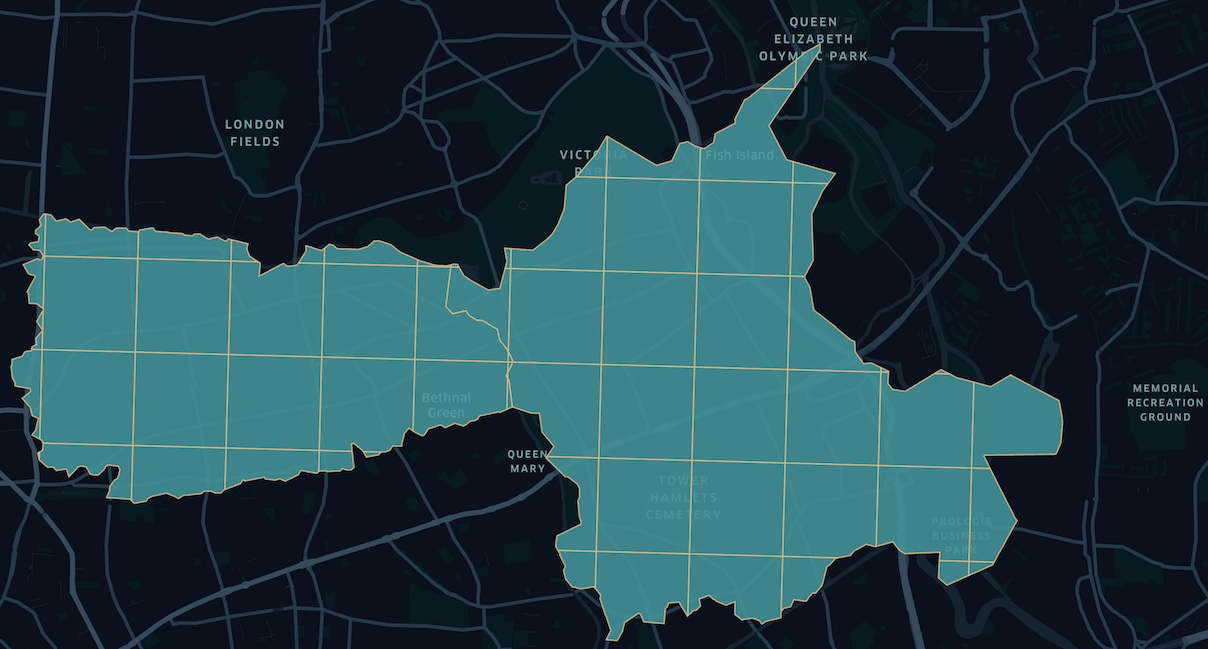

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACXCgAwAEAAAAAQAABRKkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAokEuAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAEBAQEBAQIBAQIDAgICAwQDAwMDBAYEBAQEBAYHBgYGBgYGBwcHBwcHBwcICAgICAgJCQkJCQsLCwsLCwsLCwv/2wBDAQICAgMDAwUDAwULCAYICwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwv/3QAEAEz/2gAMAwEAAhEDEQA/AP4f6TmvfD4W+B1/xZ67Jak9A7gf+jF/rUg+DXh3Ulz4f8Rwy+m8I/8A6Aw/lXv+zfQ8n28et18jwCivbLv4DeMoQWsp7W5H+80f8wR+tcpefCr4g2X3tNeUDvEyOP55/Sk4SXQpVYPZnn1Fat5oOvacSt/Y3EOOpeJgPzxisfehYoGG70zz+VSaJ32O2+HEfm/ETQYz31C3/wDQxX1P+2G/7rw+nq9yf0Svm34UabfT/EnQZI4JmRb6FiwjbaADnJOMAcV9iftHfD/V/HM2kf2bNFCLVZ93m55LlMYwD6VtBNwdjlqySqxbPzz+lWILeS4zswMete2j4A+Jx96+tR+D/wCFWLf4E+KLfO2/tOeuQ/8AhUezl2KnXjb3XqeJyzLap9mt+vdqzupyea96f4B+I5GZ21C1BY54V6T/AIUB4h/6CNt/3y1Hs5dhQq04rfU8GpO1e+j9n/Xh97U7b/vhv8aa3wA1/qmpWrH/AHGH9TR7OXY09vT/AJjwWivcJPgH4vBJiubR/wAXH/stVV+A/jsyhGNqFPVvNbj8NlHs5dg9vT7njkcMtxKltbjMkrBE/wB5jgfqa97+NMsOj6dongi0OEtIvMYD/ZGxfz+Y13Pg74P+HdDuILnWbgXmpQyeaoRyiLt6fJnJx3J71n+L/CXgrx54inuINeWDUExA8LFSFMeRjadrdc9DVqDUX3MXWjKa7I+WKK9m1P4F+MrQb9Pkt71PVGMbH8G4/wDHq851Twn4o0TP9q6fcQgfxFCy/wDfS5H61m4tbo6I1IvZnPHpzQOmaQOhOFYH8adz3FSWFIKWigAooooAKKKKACiirVjY32py+RpkMly542xKXP6ZxQBVor1bR/gx461XD3EKWKHvO3zf98rk/mRXVt8Nfhz4Xw3jPXBLIOsMRCZ+gXc/6irVNmTrQTte/ofPjuiDc5Cj1JxTowZuIQX/AN0Z/lX0CPiJ8MvDOU8I6H579PNlUJn6ltz/AKVC/wAfdWVdtlpNrF/wNj+gVaOWPVhzze0fxPF4dF1u5wLexuXz/dhcj+VbMHgLxvc48jSbo59U2/8AoRFd7P8AHnxxJ/qEtYv+2bN/NqxZ/jL8Qps4vI4/9yJR/PNFodxXqdkVIPhN8Q5+f7NaP/rpIi/+zGtqD4HfECbl47aMf7U2T+imuXm+JXj+f/WatPg9l2r/ACUGse48VeKbvP2jUrp+O8zj+RFHuBar3R6vF8AfE5/4+r61i/Bnx+gq5H8DLWAg6nr0CDPO1AP/AEJ68FlvLy45uJ5ZP992b+ZNUJbeKRGXYpLAjOB3o5o9h8lT+b8D69+JOg6XoXwiGk2TFobVoPKYnJZi45OODnJPpXyVX138aCLX4bw2g4zLbpj/AHef6V8z+GPCus+LtSGmaPHuI5kkbhI19WP8h1NVVXvJIzw7tBtvqc5VqxsL7VLkWemQyXEx/gjUsfxx0/Gvou4+F/w88C2yan43v5bkMcJHjYHYckBUyzfnisa++NFppVt/ZvgDS4rKEcCSRQPxCLj9WpclviZftXL4Ff8AIz9B+CetXEf2/wAWTppdqoywJDSY9/4V/En6VvS+Ovh18Po2s/AVkL67xta5c/L+Ln5mHsoArxHXPE3iDxLJ5mu3clyM5CMcIPoowv6ZrDznmjnS+FB7Jy+N/Lodlr3xA8YeJGYaleuIm/5YxHy4x+A5P4k1xveg88UVDbe5qopKyCgOyMGQkMOQQcEGigc0hnpfh/4t+NfD+2I3AvYR/wAs7n5jj2f7w/HNdz/wt3wPezLeav4bDXAIYyII2IZeQQTg8Hoa+e+KKtVJIydGDd7H1NqPxO+Gfjq2GieJYri3hZtwkkGAjjgHchJHU8kY9a8y8bfDA+HdMHiTQLsahprEfMMFkDdCSvysueMjGO9eTV7h8FvEMSX8/gfVcPZakr7EboJMfMP+Brn8R71XNzO0jNwdNc0Nux4fRW54m0K48M6/daFcZJt5CFY/xIeVP4jH41h1kdCd1dBRRRQMKX3pKKACiijBoAKKKPY0AJk+n+fzpaTC0tABRQabn6fnQAvNe/8AwWki1jS9c8F3Ryl1F5ig/wC0Cjfl8pr5/wA9ORXTeEPFF14R8QQa5ajeEysiZ+/G33h9eMj3FVB2epnVi5RaW5zjRywsYZxiSMlWH+0pwf1pK9w+K3hWynii+InhnEljf7Wm29FdujY7bjw3o31rw+iSs7DhNSVwo5NFFSWFdD4U8La1401+38OeH4/MubhuCfuoo+87Hsqjkn8ByRXPV95fs6aX4W8G/DW8+JupSKbiUTGZ88xQwk7YwPViN3qSR2Aq4R5nYyqz5I3W52+ran4V/Zt+G8dpaAXV9LxGrHD3Vxjl39EXv6LgDnAr5I+ENtd/Ev412d94qc3sjPJf3BccN5IG0Y7KGKYHYDHNee+OvHOt/ETxFL4l104dwFihU/JDGOiL/MnuefQD2/8AZWvNF03xjqV7rE8du/2NEgaQhVO5yXGT0OFX61fNzSSWxkqfs6cn1Ol/ax8cX8mr2nw+tJClvHEt3chTjzHckRg+yhScepB7V8d16h8aNej8S/FHWNUt3EkAlWKFh0McaKB+ua8vqJu8ma0Y8sEhQSD79q+j/D2n2fwj8KN4s12MPq96uyCBuqg87fb+85/CuN+DHhyHWfE7avfKDa6YnmncPl8w/d/75wW/AVx/jjxXdeMvEE2qytmFSUt17LEDx+LdT/8AWpx91cxM/flydOv+RVsfF/iPTvELeKLe5P2yRi0jHlXz1Vl7r2x2HSvcryw8O/GjSm1TSNllr1ug8yMnhwOx9VP8L9R0PpXzQBir2m6lf6PfRanpkrQzwnKuvUf4g9weDSjLo9i5076x0YmoaffaTeyabqcTQTwna6N1B/z0I4NU6+lra78OfGvSxZahtsdetkOx16OB6f3k9V6r29a+ftb0TVfDupPpOsQmGaPt1DDsVPcHsf60pRtqtghUvo9zKpR6Hp60lWFSBFEkrbyeir/WpLbsauh6xc6TL5gBa3LDev6ZHvXcatZxXEI1Wx+ZWALY7g9/8a8vlmkl+9wB0A6Cus8K62LOX+zbtv3Mp+UnorHt9D/Omuxz1aXNG73MHULXym8+MfKevsazK9F1nTBaSEquYZOnt7Vwd1bNbSbTyp6GkLD1b+5LcrUUUUHUFFFFAH0V8ObqLxz4Hvfh3fPtuLZd9q56hc5X/vhuP90ivnqe3ntJ5LW6QxyxMUdT1DKcEfnW14X8QXPhbXrbXbbJMDfOo/jjPDL+I6e+K9Q+M/h+2W9tvG+kYe01RVLsvTzMZB/4Ev6itH70b9jBe5O3R/meUaLMq3DW8hwsoK8+p/yK0trBtjjBBwR9K5ZSysGXqOldkxklgS9ZSCRtcHjkdD+P8xWZliIWfMis3Jru/D0gfTVU/wADMP6/1rhgjn5cHOM4rr/CwkdJ4UBbBDce9NbmEexyVxH5NxJD/dYj8jUNbet20o1SQIpO4BuB61jFHBKkHI6j0pCEyR0pKcFc42gnPTA9KRTtYMQDjsehoAmGMcdK5u8t/s8uF+6eRXdF9KvYSVUWs6jIH8DYrBuI0uISp4PUexoKpSdOV+jMC3uGt2JHIPUVbsbC71m7KQjGeWbso9arW9uJZjHIduO3rXTC9kgtRYW4VFbjC8Fz7mg65zUX7q1IraPT7OQ/aD+4TJJHV8dAPrWJd3D6jcYgjEadkHQD1J7mqk00k77n7dB6UsE7wPuXkHqKAjTaV+pZuLRIIA275u/v9KjtbnyGw33D19qgklkmbfIef5Vds7ITESTcL2HrQOVow/eM1sjG7PFUni+2sM8Rjp7k/wBKlFqFOwtujByF/wA9av2yb7mKP+86j8yKDkTS1R7h+0BGE0bSB/dmdf8Axz/61fMBOK+qP2hF/wCJFpZ9Lpv/AEW1fKx/pWlX4jqw38NFi3VXnRWGQT0q5fwxRopjULk9qz0kKOHTGR0qWW4lnAEmOOeBWZbjLnTWxp2HFvn3NZARpZNkYyTWtaOq2vJA61lwymGTzAMketBnC95tCSQyRYEgxmo6nuLlrhl3DBHAA71MumaoxQLazkyZK4if5sdccc474oNot297cpUV0Fl4T8Vai22x0y6kP/XJlH5sAK9C0f4IeM9RAk1HybBO/mtvf/vleP8Ax6qUW9kKVSMd2eO19FfCC3/4SXwbrvg+4PyPgp/smVSP/QlzULeB/hJ4TP8AxVWrm8nXrFG2P/HY8t+bV1/hn4m/DeyvrXw/4asntEupRGXEYjVSeFLEnJyeO/WtIRs9WYVanNH3Uz5Rnt7i0me1vEMcsTFHU9mXgj86iIxXt/xl0SGDxfJLENn2uNJicdXGVP8AIV4/b2cctrLdSsyiIgFVGSc+5IxWUlZ2NadVTVyh05pBUshiLfuVKj/aOT/IVHSNR0Z2Or+hBp88glmLrnB9aiooFZXuSwbfPQMMgnFPuY2Sdl/EfSq4JBB9Oac7u53OcmgVnzXG0UVYs7O71C4+y6fE88p/gjUufyGaCivX0F8PYi3wj8RjUTstX8zY56Z8sA4/4FgfWua0H4K+MtVZZNSRNOh6sZTukx7Kuf1Ir0bV/HvgHwdCvgCCwbUbK3XbNtKspfOTndwxzyx9a1hG2stDmqzUvdhqz5aZwi7pSF+vHNdPo3g/xVr5B0iwmlU/xldif99NgflmvatL+IPwr0y/iHh7w+5mnYLlIowwZuAo3Mep444rK8X/ABN+JcGpS6O0KaQUwQigNIFbO07iWHPsOtLlitWynVl0VvUj074FaqsQu/FGoQWEQ5YJ85/76O1R+tXfJ+BXhP8A1rvrU6/WVcj6YjFeNahNf6rL5+vXkly3XMjFvyzwPwFZhmgj/wCPdAT6tzS5ktkQuaX2m/TRHuV58btQSH7H4Q0qGyhHCmQZx/wFdq/qa821rxf4r13I1zVJCjf8s0O1ef8AZXA/PNcgXmuG2klv5VbTT5iQXIAx680nNvdj5Iw3svz/ABK/mW0f+qTd7v8A4Ux55ZBgnj0HSrVsIHhPmrkxnP4H/Cp3nhjty9sQCTx61JTlZ2tdmbJLJI2XYmo6Mkn61O9tLHEJWxg+hz1oNbpaES7DkOce/WlxF/fP/fP/ANemdaXaff8Az+FA2vM//9D+H/JphjjY5ZQT7in0Zr3DzzQtNX1ewIaxu54cdNkrKPyBxXV2fxP8f2OBHqkrgdpArj9Rn9a4Simm0S4p7o9nsvjt43t/lu0trhfeMofzDf0rW/4X1d7fMXRbbze7eYcf+gZrwLOOaKr2ku5DoU+x9f8Awg+K3iXxl8SdO0KS2t4LdjJLJsDM22NCeCTjrjtVH9rLWLiTxxpekW8roLeyLMqsV+ad+CcH0Ssv9k7ThdfEa71Jv+XOwcf9/nUD/wBBNcr+0PqC6l8aNQVTn7KLa2+mxQ383NaOTdPUxjCKrWitkeMzvfQECSdzksOHb+AlT+opkclxLndclMf33YZ+nWpb858v/tofzdqoVgdRaladAMT78/3XJx/KoPNm/vt/30ai7/jTjQMXzJM5Jb/vqnCSVcMGYH2JqS6hjhnKx4KH5kPXKnpUHHQUAXE1HUov9VdTr/uyuP5GrP8AbuvbDH9vutp4I89//iqyqKLisj3X4CWUZ8Rajrko5tbYDeRk/vGyefoteI31yNSvJr6T5vPkeXnn77Fv617v8MpDp/w08T6tFxIA4B9li4/VjXgCqFUKOgGKuXwpGcNZyfobOm+IfEGitnSb6e3x2Rzt/wC+Tlf0r0bS/jd45sMJdtDeoOolTax/4EuP5V5DniikpNbMqVOMt0e/t8YfCupDOv8AhuOVj94psb/0JVP60weJ/gZfj/S9EktSeuyPH/otq8Dop+0fUj2Eel18z30ab8ANQ5gvLi0J/vNIv/oYIoX4bfDDUc/2R4nGT0DPE39FNeBUhAb73NHOuqD2T6SZ7+/wHnnG7Stat5h2BTr+Ksax7n4EeOYebdrWYeokK/zWvF0VITmIbD6rwf0rXttf16yYNZ39zER02zPj8s4ovHsHLUX2vwO2Pwf+ISyrD9hBzxuEqbR9TnP6V1tp8Dp7OH7X4u1WCxiHJCckf8CfA/Q150nxF8eRxGFdWudpGOSCfzIz+tcnd3d1fzefqErzyHndKxc/mc0Xj2DlqPdpHvPm/Arwt/qkk1qdfrIpI+u2Oqt/8c9Qii+yeFdNt7CIcAt8xH/AV2r+prwn60h9qPaPpoHsY/a19Tq9Y8ceLteyuqajM6H+BW8tPyXH65rk1ULnaAM88d6dRxUtt7mqSWwUUdBigUhhS9KQcUg6UALRSdqXtigApyusTrK4yqMGIHcA5NMHv/OpYY/OnjhH8bqv/fRxQB91eM/CCePNMtLCW4a2t0kE77VDOflIAGeB15JBrktf8XeEvhLpS+HtAhWW7xuEIOeT/HK3Xn8z24qj401mfS/it4bt4XZY9hjdAxAYSkqMjocHpnpXi3xesUsPiDfCPpOI5z9XUA/qtdM5Wu1uefSp81oyem5x2u+INY8S6g2p61OZpW4HZVHoo6Af5OaxqVRuYKTjJxmtb7BAnMrH8TiuZs7JTjDQyKKsXSwLIBbkEY5wc81XoLi7q4UAdzSZ4zS0DDrRiiigAoooz60AFWLS7udPu4r+ybZNA6yIfRlORVeigD6A+LVpbeJvDumfEnTF+WVFinHpu+7n/dbK/jXz/Xv3wfvrbX9I1P4caof3dzG0sXtnAfH0OGHvmvCby0n0+9msLr/WwO0b46bkJB/lVz1tIxpaXg+n5FeiiioNgoo9qPegAoH5UlLigA4PNIDTsEdqbjvQAtFFFABkDrRkHpRRQAUUUlAHs/wn8X2tnNJ4K8RYk03UsoA/3UkfjH+6/wCjc964rx14QuvBevPpcuWhfLwSH+OP3916H8+9cYRng5r6J1p38e/B231piZb7R2xKerEJ8rE/VSG/CtFqrdjCXuTUls9z54o7U3H0/KrEBgBP2jOMcYrM2bsrkQxkZ6V9q2/gTw9P+zB/wkllCTqC6Y1y0gY5MiZLLjOMdR0r43uo7ZI1aPO5unPavuz9mLxHYeKfAF98O9VAc2JdSh/jtrnJ/Riy/lWtLexz1pNwUl0Z8DHAOB0rtfAl1HDqsls/WdMD6rziq3jnwXqnw/8AE1z4Y1VSDCxMMh6Swk/I4PfI6+jZFc1a3MlndR3cP3omDD8KhaPU3dpLQ6DxhZPaa5JIfuz4kU/oR+Brl69k1bT7TxZpUdzYuN65MZ9+6t6V5BPBNazNb3ClJEOGU9qc1rcUJXVj3v4NgzeGPElr6xA/mjj+lfPUfzRK3qAetfQvwIfcNdtzyDbxnH/fYrwlLi2EKCOIZ2jr06US+FGUW1UlZdvyKtFFFQdBLBPPazpdWrtHLGwZHU4ZWHQg173afEzwb4r0uHTvibZNJNB924iUnPuNpDKT3A4r5/oqoyaInTUtz6EtLX4AaleR2dubiOSZgi7jMgyxwMk8DmvLvHvhB/BXiKTSVZpIGUSQu3VkPrjjIPB/CuMPPHT6da+ivER/4WN8KrfxLGN+oaRlZ8DkhQA/5jDiq+JPTUzs4STu2n3PnWkPpVy0gSdyshIxzx3rTltkNu0UIC5rMqdVRdjqvDurx6rbHRtROZAMKT1YD+orL1LTjE7Wlxz3B9fcVx6tLbyh1JR0OQR1Br0+yvIPE+nbWwt1F1Hv6/Q09zCvS+3E8xmieCQxydR+oqKug1ZI40Mc4xIpwB3z3rn6RvRm5xu0FSxQSzk+WOF6knAH1JpIonmkEcfU+vQAdSfYVJPKjBYIf9UnIz/E3dj9e3oKDUf/AKJAf+e7fiqD+p/Svffhvf2/jnwnf/DjV2VZEQyWpAA2rnIwP9hsH6Gvnetzw1r1x4Y1u31y1Xe8DZ25xlTww98jI9M81UXZmdSHNHTc+kv2MvhH4c+LH7Wvgz4SfEe3eTTb7U5Yr63VihkW2t5pzHuGCA7RBcjkqTjrX0H47uPhj8aP2QviH8YdK8B+H/Amr+B/E1hpdm/hyBrZLiy1AmMxXCs7iSaA/OJPlOR0AJB+ZPHGo634L8V6H8dPhpey2F2ksVzBeW52yQ3CDMcgOCMkfKcgg42kEEg+i/Hr9uL4i/tFfCTR/hj4y0+1tbmwv5dRu7zTdtpFqEz5CPPaRxBDLGDgS+Yc9dgPImUbXT/r/htzCSlUakttL67WvfTrfbyPtrS/gZ8F7n9vXwt8M7jw1preH7/4dW2rz6eYl8ia7bT7iVrhk/icyKrlv7wBry39jzw18Hf+GQNS+KXxGsfAR1ZfFltpkeo+O7aWeA276XFcGGJocMJDKWk54xur50039tj9pjS/hRB8K7LxAkemw2B0hZ/skB1GKxIx9mS82easJXK4zuA6MKyvgX+1V8ZvgZ4em+Hnw6urCDSNRvhfTQXenwXgNwsSwh185WC4jRVwBjA9zSSV9u/4/Pocz5rNX7dX0fp1+e259WfsseHvhF4p8P8Axe+IXjXSvA/l6ImizaZP4ltXm0OxS/vbiOQRCI+YsbxqqQgHjCbu+cT9nfRv2cvH/wC0D8UL74uaNod14L0jwtqWo58NRMthai1e2iN3pynMisgd5FP39xb1ArxDw5+1V8afhLrPiDxX4HurCG68Xyxtqqz6fBcQTGF3lTETrsQK8jEBQAM/SvPLv4+fFfxV4w8TeKp7i0jvvGOky6JqzW9pHBE9hMEEiLGgCxlhGnzIAcjPc1LjZLTVf5mkm3OWuj/DRLt31vc+l/2qv2ctN/Zn+FXw/wBPMNnc6pfSeJZJtZtFX/ia2a3MB06YuOq/Z5RsGcLkr2r4N0ZNIZGGobS+cDfwMV6P8QPiT4z8Q+A/DXw21y/ku9K8LrcxaXBIATbRXLK8iK3XZuVdqnIQDauF4rjrDw/bRosl6N7kAlT90H096tLXRf1YWtld3ev5t/kVrifw3F8kUIkY8fIP61gwwR/2itveAxJvwwPUD0/+vXUwWlvJrbSQIoS3UD5RxvP9RXM6pJ9p1GZx03Y/LimxS01MLVIBFKbiHjaxH5dKxpJHmbe5yf5V0N6MwOB/drnD14pHThneOpZud03+m8YkOGx2Ydc/XrVWpI5Wi3BcEOMEHkH/APV2q3pel3+t6jFpWlxmW4nO1FHHvknsAOSaDo2KFTxXMsICKcLmve/+FU+C/DcMcnjzWxFMy7jDGyoPwyC5+oAzUP8Awj/wFYcatMv/AANv/iKvkfUxdWD6N/I8i+2W398VoaRc20ur2kQcHdcRD83Fenf8Ix8CW6a3Iv8A20/xSrVj4c+CNlew30HiA7oJEkUNKuCUIIz8nTin7N9zDlh2f3HQftEbl0bTCpP/AB9OMf8AbNq+cxZQlRnPT1r6m8cX/wAMPG9tb2Wqa9DALeQyKYpVySVK85B9a4keFPhG3CeJV/7+R/4VVSN5XRClJQSSZ4DewRwFRHnnOapV9Cz+AvhXd4x4nC49JIv6ioB8MPhm3+r8Uj8Xh/wFR7NnTTrJRtK9/meA0ZPavoD/AIVT4Ab7nihD/wACh/xpB8IvBjH5PE0f5x//ABVHs5Fe3h/SZh/A7Uba18ZmyukQm7hZI2I5V0+bA9Nwzn6V7N8S/iVc+B7yxtLK2W4mlV5GMhKqEHGARnnOCfYe9cVofws0HSdZtdVsfEcTS28qOownOD0+/wBxx+Na/wC0DpsU2hWOrjAkt5zF7lZATj8CoNarmUGc8nCdVdmebX/xy8eXrbbU29sDwAke9vzYn+VcPrHiTxhrqFtZvppk/uF9q4/3VwPzrmI3MciyDsc11tpJYzwy297nypQMMgywKnPH1rFyb3ZrO1NqyRxyhVGEAA9qcGZWDRsVZSCCOoI5B/A1auoI47kQwZIPTPXk8UyW1mhTfJjGccVJupp28z6Q8ZzL4x8AaZ44jGZoR5c+OxJ2t+Tj8jXzfcb455IkJCsc47H0r3f4L30Or2Oq+AtQP7u6jMsYPuNr4+nytXi2s2r2V89pPxNCzRyD0ZTirnraRy0o8lRxMmgYzzRWndJEbdSgCMOcdKg6ZSs0u5mUUcA4ooLCiiigDvPh14Qh8aeIxpd07xwRxtLIydcAgBQT0yT17V6brPxa0zwpu8O/DywiSK3JjM0gOCynBwowW5/iY8/SuR+DmhLruv3itcz2vk2xw1u+xjvOOT6Drj1ryryWadoYvmIJGT7HrWibjHQwajKb5tkdHrnjfxZ4jJGr38rof+WanZH/AN8rgH8c1yoCrwOB7VcexnXGBuz6dquWlo8LmSTHTj2qG77lOpCMdCnZpcees8BMbRkOrjsy8jH419A+O1j8b+BbD4h2SgXNmPLulHZc4cf8Bbn6E14yBtJbPXmvVfhJrUVvrFz4U1TDWmrKQFPTzAuCP+BLx9QKqD+y+pzSqczv2/pnic0FxPKJAv3unOQKeLaC3/eXLZ9sVu+JNLuPCer3fh+4JLQPiNj/ABRnlG/Lr75rl0gmnO4Dr3NQzWN2tXZFp9QwP3Chfc+lVmlublsZJ9h0qysFrBzcNub0qOS8ffmD5VHbHWgcUvsL5glhOwy2F+tV5oWgfa3TsfWle4nk+8xx6Cmw7RKpddwz065oNFzrVkWe4rcH+kWR9SD+f6Vm3ahZARwCOh7e1WLGZ1zEFyR70EVPeipIzs5oqSZDFIUbjH9ajoNk76n/0f4f6KODRXuHnhSdqXNFABR1oooA+3P2PtKIi17WmXHmPb2wPrtDOf8A0IV8u+PNRGtfE3V9SU5E2pyDPtG/lj9Fr7S/Zagj034U3WsAcz3dzIT6+SAn/stfn3a3f2y9j1GU48+QTE/77bj/ADrWekIo5qetSb+RLe5zH/usfzZqpVbvGB8kjn92M/8AfTVUyDyKyOlBRRRQBZuuGi/64p/Kq1ac9ldy+TJFEzKYY+QPas50eNzHICrDgg9RQJDaOaQHNLQM998G/u/gn4kkP8Xmj/xxRXgZ6mvfPDOY/gRrTf35JB+ewV4FVz2RjS3l6h3pB0pc4o61BsJ160Cl60dKAE6HNHU5paKAD3oPPWiigAooooAKSlooAKKKKACiiigAooooAKM0UBc8+9ABW7o9rv1/S7dRzLNbkg+pcf0rC74rtPBaJeeOdFjQ5xLCD9UGT/KmtyZOybPTvihd7fjDpg/54/ZP/HpTXPfHRNvj9m/vWsP6FxTPihdr/wALaDsQPKls1H4FT/WtD4+oB4zgl/v2i/o7VrLaXqc9PRw9DxGg8nLc/XmiisTqCiikoAWjtmikoAWj6UUUAFFFFABRRQSAMnoKAPSvhBNLD8QrHylLbxIjbRnClTyfQZxzVT4haTeL8QtVs7SGSVjL5oWNS52yKDnCgnGSa9T06Y/Cf4aprCxp/bGqsCgkGdoPIB74ReSP7xrvdR8c6nf+Ax4z8EwxSzAD7Qjgs8YX7wwpGSvpnpyK2UVy2b8zkdR8/MlpsfI48P8AiFumnXX/AH4f/wCJqUeGPErdNNuv+/L/AOFejn47ePD937IP+2R/+Lpv/C9PH/ZrUf8AbE//ABdRaPc2vU7L7/8AgHAR+EPFsrBI9LuyT0/csP5iuu034N/EDUcF7RLVT/z3kAP5LuNXH+OPxCdceZaj3EHP/oVcnqfxA8bavlb3U5yp/hjby1/8cxR7gv3r7I9Pj+CFlpsfneKtchtlHUIAuPxc/wDstL9k+Anh85mnl1SRf7peRSfooVK+f5CZpPOmJdz/ABMdx/M80Ucy6IPZyfxSfy0Pff8AhK/gYx+bQHH0iX+j0n/CR/AdvvaNKP8Atmf6PXgdFHtH2D2K7v7z30a38Am4bTZl/wCAP/RqX+0v2fW62dwn0Sb+jV4DRRz+SD2K/mf3nvhuP2en6RXS/wDAZxTQv7PUne6X/v8AivBaKOfyQex/vP7z337H+z0//Le6X6vOP6Uv9k/s/MMC/nX/AIHL/Va8Boo5/JD9k/5n9577/YXwDbpqky/8Df8Aqlez/DjQvCmk6RNceELiS5tbuTcWc5BZBtOMgfQ18t+CPh1rnjS6jkiRoLDP7y5IwMDqEz94+nYd/Svo3w34v0f/AITGD4e+GFX7DYW8m5xzuePaNoPcDJ3Hua1pvW7RzV4u3KpN9zP1v4M+DfEN3Ld6RcNZyljvSAq6Bh1+U/d56gEV5vqfwC8TW2W0q7t7odg+Ym/9mH8q8s8STT23i7U54HaKX7XNlkJRvvnuOa2tL+J/jzScLb6lJIg/gmAlH6jP61DlBvVGsYVUvdlf1Kmp/D3xto2WvtMm2j+OMeav/jmT+lVfCXi7XPAPiWDX9FfyrqA4aN8gSIfvIw64P6HB6ivWdL/aB1uDC6vYQzju0LGNvyO4frXuVlf+HfF/hiPxDrljHDbTKXxeKhwnQMTyMHqOelNQT+FinVnFfvI6HYG9+GH7R/g9kugYb20XJXgXVo7d17MjEe6tjnmvg/x14H1fwBrraJqrLKCA8UyAhZEOcHB6HjkEnHqa+vtM8BeCtJvYvEOh24tJYwXSa3kZAFPJ6HaVPcHIpuv+HPCXjN3k1W5+0vIAMicZGOmMdMe1XKF1ruYU6yg9L8p8V6Jrd1olz5kXzRt99Ox/+vXo+paZp/i3T1v7FgJQPlf/ANlb/PFeuRfA/wCH8bb5pZ5F9DOFH5jBrQttE+EXhDdme2hJ+95twXJ+oLH+VKMGtHsayrxbvFO55t8CrS6s9a1mG7QxhLaNXz0B3N/TJr56+X+E/L2PtX3HDceFPEmj3+l+DLuGKa8iaPzYwTg4IB7ZxnoK+OfEPhvV/CmonStZh8pxyhHKOo7qe4/UdxUVI2SLoz5pSb0ehhd6CPT+dLRWR0hRRSY7k0ALXsfwV8RLpfiZtBu8G21RfLKnp5ig7fzGQfwrxvtUsVzNZzJeWzbJImV0Y9mU5B/OnF2dyZx5ouJ0njDQZPCfii70ZMqkT5iPrE/K/px+Fcyzu/LsT9TX0D8W7aLxN4Z0n4i2CYEkaxzeoD8jP+62V/GvnynNWZNKXNFN7hVuxvrjTrpby2OGXt2I7g1UoqTRo9K1S3tPEOmDVLL7wHzDuCPX3H6ivNiCCVbgjg11HhG/+zan9lkP7u4G3HbcOn+FTajpEFvqEiuM85HpjtTfc5XNUm09jkQzDIUkAjBx3HpSVuXstqkZtmHPYAdDWHSNqVRzV7WPWvgH4Q0T4gfHHwd4D8So8mna3rdhYXSxuY3MNzMkb7WXBVtrHBHOa+yv22vgX8MPgxqFhoHhHwHd+GXk1y4tEvbjxGmsre2kEjRj9yjMbdnGyT58MMlOucfCPw28c33wy+IehfEbTII7q50DULbUYYZSRG8trIJEDEc7SyjOOcV7l8cP2k/C/wAaLg6va/DLw54T1efUzqd5qWktO1zdyOxd0kMpI2u53nGDuA7VE1dabg1L2kX0/rz/AEZ79+0L8OPA/wAMfjF8Sf2evC8Mo0Pw1JEbFLiVp5FSWzhuDmRiWJWVyQT0BAqh8ZvhN8DfgT+1Pp3gGfwxqniPw9d+H9HuRpdnfyQ31xqGqRZAjuOWAMmAsYHOQorlPjJ+2vpnx01e88SeJfht4d0PXNWliN/r2mvO1/LEiCNlPmHaVKAZGP4Rivd7/wCPfivSPjbpX7WNpoOla7rug6Zb2VraTCRbUx20HkxTrgs/nIhZlIOMucDODWslzr3ej/A4rTgkp9V33enVfPU8h/bM+GvwY+H3xR0z4QfAPRr2212G0jttctJtRk1ONdauink2cM0gXcYiwjlYAKXcDqjY9B/a7/Zc+G3wW0vQNc+Eb3dxHpOsy+FPE8txI8g/tmK3huRJFu4SF0aVdq/KHUAc5rxC/wD2odHk+M/hr44eHPhz4e0K/wDDt5JqMlrZvO8GpXTHckt20haRmjf51IPLcnNe+eBfi/8Atp/tn2Pif9na0tbr4jjV7qy1BjdskaaG9pKZkm88LHHAjfdbzmJZF+QMQQcalSEIynN2S69P032HTpTnKMYa9+/67b7nvXhj9jL4OeMPgj4Y8T6p4a1lZda+H48U3XiG01rzhDqIhd/Ij0fLSyqxUf6tCADwcivE/wBkL9nL4cfEj9nfU/in4g8JXfjDV7fxLHpPk2XiRdChitWsI7ovvd1jlIkcoMfMQQegr7a+Pmm3X7GX7L3gD4lW9t4V8Q/Enw+F8CWmtWttPP8A2bZR6dcSkRTu6LcShWdTKIkjG84U4OfyO+EH7Sum/C74R3PwU8R/D/QPHGhz6umtLHrjTfubmO2S1UoIiOkSYyeck0qdWFRXin81b8Gv0fe7JcZJN8yd9mndb66p+XddrLr77+yT4F/Zm+NHxj1v4WfEnwvq1zOE1XUdOntdalthaWmmxF/s0mzmeTcMefxkc4Pfm/2f/hl4C/am8Y/EDTfhfol5p0Nl4Pu9Z8N6fd6pvki1FBCsSz3UjIskZd2J8wquCAcbRXzb8KP2gNY+DPxqv/jN4H8O2Nu13bahZxaYpcWltBqKeWyxkfPiNf8AV5/GuR+EPxX1/wCDuk+K9H0fT4ryPxd4cufDNy07FWitrrZukTaMGQbBjPy9apXtZ/1t1+82cHzNxl2tr630v6H07+01+zne/s0/DT4bnXIPsfibxRBrk2sCO9W8hP2K6ijtTGY2eNCYZMybDkt15FfFIcgcV23jb4uaz4w+F3gr4T3mn29nZeCE1NLOWHIaUapcLcS71wFG11ATb/D1yea8ewKpf193+Y1h3Je8+/5u3XtY6adj5Tt7GuZHIzWvCQunFj3BrJHHFMuhG10Fe+/Ct9P8M+D9Z8fyqst1b5hiUnoAAQvtvYj6gV4FUnlTGEzhH8oEAuFOzd2BPTPoOtVF2dzWcOZWJ7++u9TvZdS1CQyzzMWdz1JP9PQdhVSiipLCly1JRQAuSOlJRRQAUmFpaKAG7F9BSeWh6qPyp9FAE1iI4tQtpQoys0bdPRga+tPj43/FGwe93H/6C1fIuSORwRXV69488TeKrOLT9auxPFCwdQFVctjGTgc8VcZWTRjUpuUoyXQ5SjFFFQbDlYq4fuDnmp5rqSdNj4x14qtRQS4pu7R0XhLXX8NeJbLW1OFgkHme8bcN+hJ/CvQvjboUem+Kl1m2/wBVqcYkyOm9MBvzG0142QDweRX0RrdxYeJPg7Ym6LPe2ESurf7g2nP1Xj61cdYtGc9Jxl8j57ihkmbCDp1PpV5LSGMbrthn0zWcGZc7SRng4pO+T1qC5Rk+uhcuZLVkCW45BznFU6KKBxjZWCiiigo99/Z/41fVpP7ttF/6E3+FeGWkqpcF3OAc/rXuvwGG2fW5fS2j/m5rwOyjSd44icBwAD7kcfrVy+FGCV5zXp+RqyahEB8vNVW1CY42gCmfZv3AuQcDHII5zUkdkGUSM/B5qCVGmlcqtcTt95zWhYXd6jpLZvskgKujd9ynIP50+KygBzhmB456fWruI4lLDA7nFBM6sdoo9h+JttD408GWHxG09MSxL5V0o6gE4IP+4/6GvAPtM+zy92BjHSvbfgzr9vcXd54I1nD22poxRT03gYZf+BL+oryXxFodz4a1y60K7yWt3Khj/EvVW/EYq56pSLpq3uSW2xi9yfWiiioOgcis7BF6mpIFRp1STOM/rUSttYNzwR0q3exBWEqfdb+dBEnry9y5qKZiDE9D09c1Qs223Kn1yPWtGE/a7bDn2PrmsfLRvjoVNBlSXuuD3Ni8dYQJFUF24yfSs37TL6L+X/16gJLHcxJPvR8tBcKSSs9T/9L+H6lo5or3DzwooooAKOvFFKCAQTQB+iHwrI0H9md9Qzt/0S/uc+7s5r86oUEcKRdlUD8hX6G3ato/7Iohbh20NE/4FMAM/m1fnu33iRWtXojmw+835jSPSgUtFZHSFFFFAC3LibLsAMKFA9AowKtagMX8w9Gx+QFU3GQVq1eSpPdSzoeHYkUCKoGKWiigZ79o48v4Aag/96d//RiivAa99tj5X7PUw/v3TD85xXgVXPp6GNLeXqwoooPXAP6VBsB4GaKbk/5FOoAD04oooPtQAUUgoyD0oAWig0g/zzQAtFFFABRSVegsjMglZtooJlJRV2UunNFSzKkcpSM7gO9RcdqBp3Vw69KPpzR160UDDntSUdaWgArvvhaqt8Q9K3dpWI+oRq4Gu8+F5x8QtJ95mH/jjVUd0RU+B+h7T4t+Jfhjwt4lvLex0VbjUY3CyzvtUM20Y5wzHAwO1eD+MvGWpeNtTTUtRjjhMSeWiR5wBnPJPJNaHxRUr8QtVz3lU/8Aji1wNOcm20RSpxSUuthaKKKg2CiprfaZ1D8gnpWhfJHFB8igEkDIoM5VLSUbGTRR9aKDQKMUUUAFIaWigArvfhr4WPizxZb2cq5toP38/ptU8L/wI4H0zXBHjmvozRs/DT4VS64/yanrGBED1UMPk/75XLkepqoLW7M6smo2W7OC+LXikeJfFkkVs2bWwzBFjoWB+dvxYY+gqn8N/HE3gvWt0+WsLnCXCDnA7OB6r39Rx6V59FHJLItvArSO3CqoLM30AyTXrPh74MeLtZAuNSC6bb9S03L4/wBwdPxI+lNOTldCkoRhyy2Nbxz8LiyP4s8Cst7p0+ZTFD8xTPUpj7y+3UdOnTw7Ir6i07xB8O/hNaTWWl3s2qXTn94kb7l3D2H7tD6/xH3qjqGgeEvi/aya34VkFlq6qDNBJwGI/vAfo6/jVygntuZQqtfFt3PmukrS1bR9T0K/fTNXhaCePqrdx6g9CPcVnVidSd9UFFFFABRRVu7Jl8u6P/LVef8AeXg/0P40AVKKAMuIlGWboo5J+grvtE+GHjjXsPbWLQRt0kuP3S4+h+b/AMdppN7ClJLVs4GkJVcZOM8CvoJPhJ4U8Nxrc+PdbSP/AKZRER59snLH8AKcvxC+GXhHKeC9H+0zDjz5Rtz/AMCfc/5AVXJbdmXtr/ArnluifD/xl4hw+nWEgjP/AC0lHlJ+bYJ/AGvV7TwD4L+HtsurfEW5W6uiN0donK5HovV/qcLXEa38YvHOs5SK4WxiP8NuuDj03HJ/LFeZzzz3UzXFzI0sjdXdizH6k5NO8Vsrhyzl8TsvI9R8X/FrXvEcZ07Sx/Z1hjaI4jh2X0Zh0HsvH1qn8IL6LT/iDY+ZwJ1kgH1dcj9RXmverFnd3On3kWoWZ2zQOsiH/aU5H4etTzO92V7NcrijrviPYSab471S3k/jmMq+6yAN/UiuIzX0F8W7K18S+H9N+JOlL8sqLFOO43fdz/utlfxrx7wv4b1DxZrUWi6cPmkOXcj5Y0HVj9O3qcCnKPvWQqc1yXfQ6/4Y+BP+Eu1M32pDbplmd0xPAdhyEz6Y5b0H1rc+IXjP/hKdRFrYfLp9r8sKjgOR/GR/6D6D610vj3W9P8OaTH8OPC/ywwri5cdWJ5Kk9yTy5/D1rxenJ2XKjiqTc5X6HqPgT4gf2DGdB11fP0ybKkEbjGG4OB3U91/L0rB8ffDceFZE8V+FMS6Y+HV0wWhz057p6H8D61xlejeBfHs3hlzpmpA3GmzZDxkZ2Z6lR3B7r3+vUUrq0ghNwd0em/Bb/hBPiLp9z4V8T28UupyHIjk43RAD5oj2IOSccjr0ryf4t/BnV/hZqH2iAG50edsQ3IHKk9EkwMBvQ9G9jxVnx38P38PmPxz4DlLWGRMrQsd1uezKRzt/Veh46fSfwj+N2jfEywb4f/EaOI31xGYgZAPJvFxyMdBJjqvQ9V7gXZP3Zbm3M4/vIax6o+GdD1u70O+W7tmOMjeoOMgfyI7Gvt3wz4Yb4ueB3u9VijubXJEMmcSll4JXA+VlPHUZPFeG/Gj4E6h8OpH1/Qd91ojNyx+aS2z/AAue6+j/AINzybX7PPxaPgbXf+EY12UjSdRcAMx4t5zwH9lbgN6HB9aUHyvlkVVXPDnhuea+O/hxrHgiczPm4sWPyXAHT2cfwn36H9K8+iilnlWCFWkeQhVVRkknoAB1r9DPjQdc8At/wmOlWy3+j3Dbb23PDQux4dTyNjdGBGA3PAJrynwPd/CfVteXXfD8a2WolGX7PJ+75bGSq52k9sr60OmuayYo15cnM1f+up4Rp/wp+IGpY2ac0IP8U7LGP5k/pXbWfwE1sKJdb1C2tF7gAv8AqSorN+IHir4m6HrkukarqJhDDzI/swCIY2Jxg43cYwec15Dd3d5qDF9QmkuCf+erl/8A0ImpfKtLGi9pJXuke8HwN8HtDONe15rlx1jR1H6Rgt+tPi8Y/Brw3+98PaQ95On3XkTv/vSkkfgK+ewABheBS0ufsh+xv8Umz6u8MeM1+LNhq/hLU4I7QyQZhWMk/KeM5OOVbB4A618rXFvPaXD2l2uyWJmR19GU4I/MV7B8DtMvLnxe2rRNsgsoX81ux8zgL+mfwrzrxbqFlq3inUdT04YgnuHdPcev4nn8acneKbFTSjOUY7GGIyYWmzwpAI+uf8KjFWoubS4X/cb8mx/WqtZm4qO8TCSM4ZSCD7ivU9V2X2nW+qp1YDP0b/A15XXo3h+T7d4als/4oSQPp94U0c+JjeJzkml3eralaWGnJ5lxdyx20S5xulmYIgz2yzAZ7Zr9IPHf7DHwa0a58cfCPwR441TVfib8PNFn1nU7KbT44tKuRZxxS3MNtKGModFmXaZCQSe/OPzuiu7rT54dTsH8q4tJY7iF8Z2SwsHRsd8MoOO9fod46/bp+D+tzeNviv4L8CajpPxN+IeizaNqmoS6isumW63kcUdzNbQhfM3yLCm0OAFI+uZ9f18+3y3OelOo4xUOnp5Wvfpa+3+R8leO/gjpXhD9mzwD8dbXUZrm58Z6jrNjJasqiKBdKl8tWQgbj5g5IYnB6V6/8DP2NH/aL+Hvh7xP8L9SmuNUfxNHoniWzmVBHpdnMjSxX6sAGaIxo+7d0kG0HGas+Gf2jf2btU/Zu8L/AAI+NfgrX9Yn8J3mrXlnd6VqcVlFv1SUy4ZWy7BOB2zz615L+zx+0Pc/AfR/iFpdrHdu3jfwvdeH45LSXyfs805ylwwJBIjy2FB3DccHrS06/r/W50v2rg7fFd22s1d2/D0Pav2ev2OfBX7TnxF+J/g34XeI7prTwjYPd+H7u4SJTqsnmvDCJQBtRJ2TKFOdrL3yK9C+GHwX1rw/+xTB+0n451T+zYP7ci0yz0+5RY2Fk8hgaaZ2IKbZ1kRB90qvJ9PB/wBjj4v+NPhzrviLwX8J9Eu9X8WeNrfT9P0KGxAd4ryxu1u4z5eQZFyoDKCAq5ZiqAkf1ExeELHw34PvviX4903S7vWNR1fTLSz8PALd6f4bn063lu1+bmO6u1nmklZwPKjcqF3NHvbF4qMJxpx1qPZfk2+iXV/dd6PmxtR0acq1dpUlbXS+iV0l1k76drO7S1X5vfCX/glZ8Dn8G+F/jN8edX1xL7xDp0eqP4Ot0SwYPKu/ZLME+0W8Q6nO2Rs4GORX3jbJa6N4HtvAPgPTLXw94bgk8u30PSIBDbZPILKvzzyMTy0hYs3PBNS6j4h1TW2e/wBQuJZ55BmaSRizSv8A3mPfjA/DHSvFv2jv2jLb9lH4DSfEi3ZB4w12Sex8JwPg7JQoS41FkOcx2YbCZ4edlXjg12zw9PCU/rFZc9X7K6c3RRTvbreW9rvZWXwbzLG53iVgcO/Z0Xe6X8q3lNq3N0tHRXslq7v5o/4KdeP/AIQWPgmD9lSa+v38beFNQj1vUEitlawF9fW3lfZWmL7g0FpKGbahDSMoyORX5G/s4fs9X/xv+MHhH4e65PNpemeJ742hvYQjyxr5MsgdUfIOTHjkd817N8Yv2hfhL+0Pa3fxC1rwlq1h8Rb6K0ivdRi1JJNJnltkSNp/s7DzhLLEoDL9wNzknk+K/AH45XfwE+O3hj4k6lFc6pp/hfUHvP7PilCGXMUsYVWbgcyZ544rnpQUVebu27t+bevp6LbZH26pqnSjSpKyirJaPp36663e7u3uep/GH9lPwX4d+Huj/FL4O+INU1PStS1y80CeLX7FLC4hubOA3DSI0WY5ICikblHD8E5yBb+Jf7Fd94F+APhn4q6bqkl7r1//AGe2u6RKqRrpUerQSTWR3cMTJsCMG6OwA4rwvx58fviN8XfGVpq3xq13VvEWlWt3uNnPPyLFpQ0sEa/LGpkjBjLEZOckkACvr3x5/wAFEr74qf8ACxPD/ibwfp0WieM7EW1idNs44dUs57R1bTpp7reRcfZNvC7RzyuOhpNdf6/r57lNSukvnt3+XT028xvwR/YG8AfF7wB4Iv8AxFr/AIh0zxF46vNYsrVLLTI73S7OTSZmi3Xc42vGkm0HO7ucHAr50+Dv7Hvir40+DfHd14Ogvb7xJ4UvdHsrLT7VN8N6dUvJLV5GfYWWGIIZfNAC7PmbCivZvhP+3nrnwu8L+A/AstnqF5o/h9vEMXiTTxciODWrXXpTJsC5wksGcJIwyDnGFZq8j8A/td6/8H/BvjfQfAMuoWer+IZ9EfSNRSREexi0W6e4RZ1QjzDKjiOQL8rc5G04pO2m/n93+f8AVjSHtdVFrfT05tb2/u/8DU8Z/aN8C/D/AOE/xTv/AIX+ANdk8RW+iFbW7v3VI4Zb9Bi4W3C8tDFJmNXYlmZWzwAT4T5sQIUsMnoM19lfFz9pD4b/ABA+JuqfETw74MXSU8QiK61Sz3RtH/aJH+kSwYBAimb94I2ClXLE/e42dH8Y/DfxfbrZxvbFnAH2e4RUce2GGDj2JFawgmtGbOrKCV4/18j4fr6o0fwpLJ8C5bAyKkl1E17lxgLzvAP4DGa7W/8Ag/8AD3UGEjWHkZ5xA7Rg/gDisr4v6lD4c+H50myUoLrZaIFBwqAcgnt8owPWtVT5U2zKVdVHGMe58bKdyhvXmlooGM89K5zuCinyGMv+5BC9Bnkn/wCufQVZNpm7SxQ4kxh++H64/DgfWgCnRSA5GaWgAooooAKKKKALmmxxy6naxTAMjzxKwPQqXAI/EV9PfHPRtGsPCsE9jawwyfalUNGgU4KtkcAegr5g09tuo2zek8R/JhX1N+0C+PDFkn967/kjVrD4ZHPVb9pA+TqKKKyOgKKKKANbRtGvtcvBZ2S+7OfuoPU/0HevXPEctl4a8I/2LFJ87x+VGD95s/ebisv4a6na/Z5dIYBZgxlB/vqf8P5VxfjO01C01+X+0HMvmfNG57p2A9MdMf41eyuYv3p2fQ5WiiioNgoooJoAtrargM8ihTzVeVY1fbG24cc+9R4HWloJSd7tn0H8C/ks9fmPaBB+jmvna3LC3jI4IVSPrivrb4PeFmtPBN1qk0u1tXRsAjhEUMqn3zkn6V8mquxRGCG28ZHQ47j2NaTVoxMqUk5zt5GtNLB+8DHCzASDHYnqPzqrb3It0JCksfyqrjFGKzNPZrVMsSXdxJkFsA9hUDMzfeJP1pKKClFLZF3TdQk0nUbfVIjhraVJcjr8hBP5jivaPjzYINesNehHyXtttz7xnI/Rq8KIB4PSvoHxVnxH8FNJ1v70unukbn6Zib+hq46poyqaTi/kfP1FFFQbBWgtzbrbrCw8wj2wM1nUvJ5NBMoKW5btrhYJGdgcMOgqK4aOSTzE/iGSPQ1DRQHIubmCir+m6Vqes3Is9It5LmU/wxruI+vYfjiuo/4Vr8QP+gRcf+Of/FU7MHJLdn//0/4f6KPpR0Ne4eeFHvRRQAgxUN0/lWssv9xGb8hmp6kit/tc0dp1851j/wC+yF/rQB+h3xtzof7OqacvH7vT7bHsWQH+VfnbX6E/tWTpZ/DKy05f+Wt7CgHtGjN/QV+e1a1viObC/BfzCiiisjpDn86DwM0nPX0oPQ0ALTe/40o70tABnFJkUuM0mBQB77Ovlfs9R/7d0v6z14HX0PeWl5d/ASwtbKKSaR50bbGpdsCVj0AJrx2LwX4wn5i0q7P/AGyYfzxWk09PQwpNLmv3ZzVFdvH8NfH8vKaRcY9TtH82rRi+EXxDl/5h+z/fkQf+zGp5X2NPaQ7o83pBXrUXwR+IUvWG3T/em/wU1pxfATxq4zLLax/8DZv5LT9nLsJ1ofzHidFe9R/ADXsZuNTtY/8AgDN/UVOvwJhj/wCP3XoFx12oP6vR7OXYn6xT7nz9RX0AfhH4Jt/+P7xMi464MS/zY1z3jz4c6N4a8OWviPQL976CWURlm2lSGBwQVA7jFDptK41Wi3ZHkFFFIOtQai0UemKKAD6CnYkcAAE47VGSMcV1CEMgYdxQZVanJbQ5/wCzXH9w4+lMaKRRllI+vFdLTJUEkZjPcUGKxDvqjmqKdIjxtiQEUyg6xaM0UYoAK9B+FVtcXXxC0vyF3eVI0j47IqMCfzI/OvPq9A+FmoS6d4/0148YmdoGz/dcH+oFVHdEVPgfoWPi7byW/wAQtQ8wY83y5F91KAZ/MGvN69O+Mck0nxCvRMchEiVfZdgOPzJrzDjpRP4mFL4I+gtFHaipLFBIIIqSS4nmG2RsjriouaKBNLcSilooGJziloo9jxQAUdKXBFdJ4U8Kar4x1ZdJ0pcfxSSEfLGnqf6DqT+JppX0E2krsd4Q8M3/AIq1u30+0heSLzU891HypHn5ix6DIBx619S/ETwloGsXtvqfi3UxZabZxlUhBCFmY8nJ9gAAoz71Q0fXfD/hLxDp3wz8KKJC0h+2THk7ghPJHVyQM9lHFeAfFOSSX4hap5rFvLlCrk52jYvA9B9K10jHuct5VJrpoejS/E/wV4Piay+HelKz4x9olBUH3ycu344ryfxF458U+KSRrN2zRk/6mP5Iv++R1/HNcnRWbm3obxpRWvUBgDA7dqtWd7eaddR3+nytBNEdySIcMD/nqOhqrRUmh9FaT8QPDPxAsU8M/EeJIpzxFdr8q7uxz/A3/jp/SvN/HPw41rwVKbh/9JsWOEuFHAz0Dj+E+/Q9vSvPfrXuvwr8W+LXA0BrGXWNLf5GGMiJT1wzYUr6qT9PStE+bSW5g4un70Nu3+R4VSEgYB7nA9zX1nqPwG8O3Oqm9tbmW1tCNzW6AHB9FY5wPbBx2rlH8cfDTwK7W/g7Szd3cZKGaYFSGHXLOC/5Ch02viYKupfArnnHh/4X+NfEW2S3tDbwt/y1uP3Yx7Dlj+VekH4c/D3wpbiPx1rAlkDb/JiOw5xggBcuc/hXnniH4q+NPERaKS6+ywt/yztvkGPdvvH8xXnX8Rbu3JPcn3pXitkPlnL4nb0PoP8A4Wr4J8LoYPAeiLu6edKBHn+bn8cVwGufFXxzr25Jb020Z42Ww8sY9zy36153RQ5tjjRgtbajmZ5JDLISzt1Zjlj9SeTTaKMVBqHeiiigAoor1vwJ8L5/EVuPEPiCT7FpS/NuJ2tIo64J+6v+137DvTSbdkTOairs6v4NSHxFoOreBtRjd7SRC6uBlUL8Fc9Ac4Yd+ta8114e+EujTaHoEv2rWbgATTED5D6nsAOqp68msvxB8RLPTrH/AIRn4fRizs4+DMowzeu3uM92PJrx8ksxZjkk5JPJJNaOdlZbnnzk5N20TFZ2kYyOSzMSSTyST1J+tNoorIkKKKKAO+8EeO7zwncG3mBnsJT+9i64z1Zc8Z9R0Nb/AIg+FmleI7dvE3wznV1J3tbZ27WHPyHqjA9FOMHoRXkVamka1qmg3gv9JmaGUdSOjD0YdCPrVqWlnsOMnF3ifVnwh+O7Tyr8N/iwPKuz+4iuLhcCTPAjmB4yegb7rdDzjPn/AMcP2ep/DHn+KvBEJm0o5ae1A3NbDuVH8UXt1T3XplJ8T9C8QW40/wAeaTFcxkYLoocf98tyPwJr6o+FnjjQ7vTE0uyu2ubWLEcbSsWki9Ect82PQtn6kVsrSVmx+15XzRVu66HnX7PXxLtPHfh2X4Y+McXNxDAyx+adwubXGCrZzlkBAPqpB65r5R+LHw8ufhr4ym0LLNav+/spT1aLPHP95DwfwPevoT4xfCfUvhzrkfxb+Gi+XFayi4ngUcQN3YD/AJ5MCQ4/hBJ6dPU/HeiaX+0D8JLfxD4dUfbokNxagn5llXiSBiPXBX64NJxbXK90axmoyU4/C9/JnzP49C+Ofhrp3jqEA3Nl+7uMdgTtf8mAP0r54r3j4K6nb3Umo+A9WB8m/jZlRhghgNrrg9DjHHqDXi+raXc6Jqlxo95/rbWRo299vQ/iMH8aznqlI3pe63D+rGfSE4GTSkgDJ4Fes+APhn4g168t9aulFnYwyJL5kw5cIwbCrxwcfeOB9ahJvY0lJRV2dlq+fhp8KotFX5NT1nJlx95QwG7/AL5XCA+pr50AAGBXqfxi1+x8QeMjLplwLiCCFYgynKB8ksAe/bJH9K8sqpvWyIop8t3uyaKRY1lVud6bR9cgj+VQ1NDGJS4b+GNnGPVRmoag1Cuz8E3GzUJbVukkece6n/A1xlbXh2f7Prds56M20/8AAhimiZq8WXtUdbNpLZwerIK5YcDFdd4ytvK1MTjpIv61yYBYhVGSeABSZlh4JR0Er6B/Zy/Zm+K/7Unjg+CPhXZpKbVFn1G+uHEVlp1qxAM91KeEQDJVRl5MYQHkj379jj9grxr+0yi/EXxRdnwx8O7aVo7jW3jEsl3LGRutrCIkefOeQX5hiIO8sQUH7/8Ah/RvBHw78D2/wm+EOkJ4e8KWcrTR2auZZrmYnJuLyZiWnnJ53MSqdEGBmsYKriJunh9lvJ7LyXeXlsurWifFm+c4fLad63vVGvdgt35yf2Y/i+i3a89+AfwI+FH7JPhuTQPg4Df+IL23Fvq/iyaMxXl4uSWhtEJY2lpn+FT5kmAZGJ5P0vdQQ23wB0+OL5d/iuY7QMAKmnhRgDoOcV5bgetezX8U8/wH8P2VsjTST+I77YiDLs5giRVA7licD3r0J4SlhlRhDrPVvdvlk7t/L0WySWh+aVMxxGYzr18TK7UNEtkueKtFdFr6vdtvU830hNEitNQ1/wAYXg0vw9olpLqOr6g33bWygGZG93b7sY6lyOuDX80P7Wn7SOvftR/GS++I9/A2n6XEiWOi6YcY07TIOIYMDjf1kmPO6Vm5KquP1L/bc/aH069m1j9kv4e3UVxaeH2jn8UXsD71u9ZQPi0VhwYbAgZ/vXBJ4MZB/BiLmJT6qP5Vx1Kn1mosR9lXUV5dZesunaNtm2j7jJcs/s7DOlNfvZ2c/LtD5de8r7pJnc+Gv+PJ/wDfP8hVK51b7Hq0n7lCoOCQPnPTvV3wywNk69w/8wK5jVd/9pT7xg7z+XatOh6zeh13/CQ6Wepb/vmqtz4jt449tipZj0yMAfhXDzSGKFpB1ArBknml++xx6DgUuZl04OZrX+pO8rENukY/M1YnJOTyaKKR1wgorQKRlVhhhkehpaKCzsvDXj7xT4VnV9OuneFesEpLxsPTB+79VxX1J4d8ZeE/ijpUuiXsYWWRP3trIecD+JD3weQRyO4FfFNWLS7urC6jvrGRoZoWDI6nBUjuP881pCo1p0MalBS1WjOz8e+BNQ8D6n5MmZbOYnyJ8dR/db0Yfr1HfHCV9h+EPFmh/FbQJfDviKNPtYT97F0DgdJI+4wfxU+2DXzl458D6l4I1T7Lc5ltpcmCfHDgdj6MO479RROHVbCpVW3yT+I5i0uIrIi4UCSUj5cjIT35xlvQdBWjDcX63C3hl3QKdxdcKOOxwAQfY81kQW4k/ezt5cQOC+M59gO5/lTrwusn2faEROVVTkHP8We+fX+VZm1imoIUA9aWiigYUUUUAFFFFAB5rQfv06x/OPqvNfXfxqVdR+HUOpJyFmglH0k4/wDZq+Q2ICkt0HWvrfxWs0XwLjj1YbJha2wI/wBvK4rWntJHPW+KD8z5JooorI6AooooAs2V5cafdx31o22SJtyn+n0PSvoi+0jS/iJ8P31TQSZNRszvaHPzKe64916epr5urrvBPi+58E66msRkmA/JcJ/fj/xHUfl3q4tLR7GVSDesd0cj1or3/wAffDG+1bXYNa8EQefbaovnMBhEjY4O4k9AwOceuaW3+FHhfwvAuofEfVUTPIgiO3Ptn77f8BAo9m7i9vGyf4dTwe1tLq+uVs7GJ55m6JGpZj+AzXsGg/BPxBdxfbvE00elWwGW3ENJj89q/iT9K1rr4vaH4et20z4c6XHbp086VduffaPmP/AiK8d13xRr/iabzNeu3uO4QnCL9EHH6Zp+6vML1JbaL8T2BvB3wRDGNvETAjgnzUxn/vjFNufgpa6rbG88D6zDeIQSqyYP0+ZP6rXg2TXT+CNLuNX8W2GnWbtE0sql3jJVgifM3Iwegx+NCknpYHCUVdSPqPx9qlr4G+G40W3cRzyQLaQKDz0AZh/ujJr4zAAGBwBXsXxu13+1PGP9mRNmLToxHjt5j/M36bRXj1FV3kLDwtC73eoUUUmR0rM3FooooAK+gvhC6eIfC2t+BLg/6xDJH7eYNpx9GAP418+16D8LNbGh+ObGeRtsdwTbv6Yl4H/jwFXB2kZ1o3g7Hn7JJGxjmGHUlWHow4I/A0leg/FPRf7D8dX0KDbHcEXCDtiXk/8AjwNefqrO6xICzMcKoGST7Acmpas7FRldJiUHgZNereHPg74v10C4vkXTrc8l5/v49Qg5/MiuxMfwe+HrHeTrmoR9uHCsP/Ia/qapQe70IlWV7R1fkeSeHfA3irxUQdHtGaI/8tpPkiH/AAI9f+A5r1hPhv4D8Fxrd/ELUxPN1FtESoOP9kZdv0Fcr4i+Mvi3WgbbTium2/QLDy+PdyOP+AgV5PI7ySNNKxd35ZmJLH6k8mi8VtqLlnLd2Xke66n8Z49Ptf7K8AadFp8C8B3UbvqEHH4kn6Vy3/C4/iH/AM/if9+l/wAK8x707C+tDnLuNUYdj//U/iXvvD2v6WSNQsLmHHdomA/PGP1rEDoW2gjI7Z5r2my+O3ja2wt2ltdL7oUJ/FTj9K2v+FzeH9UXZ4l8PRTeuwq//oaj+de/aPRnk89Rbx/E+f8AGOKK9+Gq/APV/lubCbT2P9xXQD8YyRSf8IZ8FtQO3T/EDW7HorSLn8nUGjk7MPbd0/uPAq6LwdZtqHjDR7JRkyX9qMewlUn9BXr/APwpPR71d2i+IYZR23Krf+guP5V0/wAPfgfr+k/EHR9Uku7ee3trpZX2hlbCgkYByOuO9NU5X2E68LPU9B/bDuf+JPoNkD967ml/75jK/wDs1fC1fYX7YN2za5oFiOi29zIR7l4wP618e0VfiYYZfu0J3paKKzNwoopD0NACnrx/OikFLQAhHelFAAzzSjqKAPqBPFereDfg1o2qaR5fnOUj/eLuG1tx6AjnivN5fjb8Qpek9un+7CP6k10njE+X8EvDkf8AfMR/8cc14FWs5NWSZzUqcXdtdWejy/Fv4hzf8xEp/uRoP/ZTWdL8SfH8wxJq9x+G0fyUVxNFRzPubezh2R0kvjPxfOCJtVu2B/6asP5GsyTWdam/119ctn1mc/8As1ZuM/pSmldlKK6IkeWaXmWR3/3mJ/nVYwQMcsik+4BqUUGkMYI0X7qgfhX0Fox/t34D6hZH5n02VnA7gIwkH6E18/ivoD4GyR30Ot+GZuVuYFcD1yCjfoRV097GNf4b9rM8Kt/smCbk854+lMn+z7wLcYGOfrUHlSQEwS/ejO1vqvB/WioNOXW9wrWs7eB4Q7qC3I5rIGf8mtnTm/dsvof50Gde/LoXhGgG1QB+FOprukY3OcD3pwIIyOhoOIKKKKBChQ3BrL1C02Dzoxx3ArTqO6mCW7E9TwPxoKhKSkrHN0UYOPpRQekFdP4Ik8rxnpMnTF3EPzOK5gVseHHaPxFp7oMkXcHT/fWmtxS2Z3vxpjMfxCuSf4oYW/Qj+lea2wtCpNz1B4r1z48W0sXjhbp1ISa1jCt2JQsD+WRXjFOfxMyprmppXJ7gwGTNv93H61BRSZqTVKysLRSUvHAAoGFFFFABRRRQB0Xhfwxqvi7Vk0jSlyx5d2+5Gndm/oOpPFfV0nhm68PeCrjw/wDDOSJr1G2zyM480tj5jkcB8fdBwAK818EXEvhP4P6r4otm2XN3IyROOqkERr+Rya8N0vWtW0S//tPSbmSCcnJdTy2eTuzkNn3zWqaivU5pKVRuz0X4ne/DbTtQ0v4n2FjqsLwTo0hZJBhvuNzz1z685rG+Jhz8QtY/6+B/6Ate3+AvijB4s1iz0jxFYodQUt5FzGBgEKc8HlSRkcEg+1eH/EkZ+IeroDybkAfUotJpcujHBt1HzK2n6nDkgcmlr1Pw78MPE2tBZLe1Mcbf8tZ/kX8AeT+Vd3ceBfhr4RAm8caiLicDPkRErn/gK5c/iQKSg3qH1iN7JHz3Y2F9qVwLPTYZLiU/wRqWP6dPqa9e0P4IeI72MXfiGaPTIBy24h5MfQHav4k/StO9+M9npNsdN8AaVFZQjgPIoB+oRf6tXkOueJ/EHiSTzNcvJLkdkY4QfRBhf0o91eZV6kttD2gj4HeDvmG/WrqLjH+tUsPyjFYWt/G7xJeR/Y/DsMWlwDhdoDyY9iRtH4Ka8XqzaRebOAeg5NDqPpoJ0opc0tfU9D0Pxl4o0a+GqJeSTTN/rBMxdXHoQf0xjHavVLmw8G/F+Eyw403XFXnvvx6/3x7/AHhXg9PjkkidZYmKMpyGU4II7g9qFPo9jju78y3KfiPwxrXhS/8A7P1uExOeVYco49VbuPyI7isCvpnw54usPG1ifBfjzEnncQXHRt/bJ7P6Hv0Pv4l4y8Hap4K1U6dqA3xPkwzAYWRR/IjuO30olHS62OylW5tHucnRRRUG4UY5oooAKKPpXtfw08BWk8B8ceL8R6ZbjfEr9JSP4iO6g9B/Efbq4xu7ETmoq7H+AfhtaPZf8Jl46Ig06Ib0ifjzPQsOu09h1b6dYPG/ju78VzfZLcGDT4j+7hHGcdC2O/oOg+tV/G3jW+8XX5PMVnEf3MP/ALM3+0f06CuIqpSVrRPPlJyd5BRRRUCCiiigAooooAKKKKACui8Ka/N4a1631ZGIjRgJQD96M/eB9cDke4rnaKadtQP0K0n4oWmia/aeF/FLAWOqrtsrpuUEnQwyZ4wwIKE9eVPbNjQfCMnwj8XTNoYP/CM61IC8I6WF0eFYf9MpOFP9xsfwnj5ZtoV8ffCS50eQB7zSfmjzySEBKj/gS5U16Z+z/wDHCPVYYvh346mEkjL5dnczHPmqRxFIT1bHCsfvDg88npU7tX+Q1B8jcfmv1OW+PfgqT4efECy+J+ipssru4V7gKOI5x9/6CRMn/eB7ms74gfCvVfGHi1NZ0eSKG2ngTzZXOcMvAIUcnK47jpX3D4t8JaT4z8LXXhPWButrqPyyerKR91h7qcEH2r4k8dad4lh+F0um6lLJHqGhyiC62MVEqRnbuODyrIVkA9DzRKKV+xVOo3y2euxzw074R/DiQPqMx1nUojkIMOFYf7I+Rf8AgRJrzfxl8TPEXjItbTN9lsu1vGeCP9s9W+nA9q87A2gKvAHalrBzey2OyNJJ3erA9KKu6dpupaxcfZNJt5LqXptiUtj644H4167ovwO8RXUf2vxBPFpsA5O4h3A98EKPzNJRb2KlUjHdniyO0ZJU4yCPwNJX0C9p8B/DmLK7ll1WXo8iF5ACP9zao+gzQLr9nwj7X5M+Y/8AlmVm+bPsTg/nT5PNEe1/uv7jwCJHmlFvApkkPREBZj+A5r0XQfhd481WWO4gsjbIGDB7k+WOOenLfpXcyfGbRdEiNp4I0SK3QcB5MJ+O1Mk/i1ZPh/WvjR8ZfF+nfD3wWLm/1bWZxbWen6bHiWeQ/wAKgHccDlmLBVXLMVUEhSdOCcpPRDj7Wb5YxPRdd+Fmhy2vn+KNVFmsSby4KoFGRuJMmRjJAB461+on7Mn/AASl8PaVY6d8Yf2lrPVLnTbpBPp3hcxPDcXyOuUkvnRQ9rbnr5XE0o4O0blPt37KP7FnhL9lWGHxp8T5rTxj8S45BNCrH7Xpfh+ReCIyxIu71e8pHlQnIRc7i33dB8Z/i7BIP+Ko1XGSSDdyHk9+TWXsMRi4p0oqNPzbTkvKybS8930tpJ/NZjxJhcDKVCFRyqd4qMoxfzaUn/5KnvfVLltdudd1KSCG7tDa21hCtraWlvbtBa2lvGAFigiA2xxgAcDr1JJ5rmpB5RxN8n+8Mfzr1yb43fGa3f8AdeKdTCnkZnLfzBpP+F//ABy3+Yviy/BIxyIX4/4FE1epSji6cVCnSpqK2XPJf+42fn1aeCqzlVqVqrk3dvki2/m6yPFW1TSk/wBZdwLn1kUf1qj+1h+1HpP7LP7G+ia94fmH/CfeIL3V4fDHCt9lWRY4ptTKtnIt1BWHgq0rqOnI+gov2iPiB4e0rU/HvxH8Zzab4X8NWrajrF5Jb2reVax/woPIy0szYihQfMzngHBr+UD9rb9qHxt+15+0Bqnxn8bAQfaW+y6dZqAEsdOhLfZ7ZccZQMWkI4eVnbptA8jNKlbE1IYWpBJRfNJxk5aWa5XeEfiT11enT3kz7Lg3LKUFUzGMpSjblip04xvJOMuZNVal+VxXRa7P3WjyDw5L4zabUJtDluJnnQvdMp3uykkszs3JZiSS33iST1JrAULtGD9K9u+DHA1lv+mCf+zV4bH/AKtfoK6LWirH00pOTbe50fh6cwXxgbpKMfiOR/WrPiW1w6Xq9/lb6jpXP2zss0bL1Vlx+dei6hai8tZLY9xx9R0oWqBao8hku7dy0EwIGcGqklmcb7c+Yv60/ULO4trhzKhHPI9Koo7RtvjOD7VJ2U46XgxvQ4PWitAXEFwNl0uD/eFRT2bxDeh3r+tBaqa2loypRRRQaBRRRQBasb+90u9i1LTZWhnhbcjr1B/z1HcV9f8AhjxN4e+Lnh2XRNdiUXSqPOhBxyOkkZ6jn8VPFfG1XtM1K+0a/i1TTJDDPCdyMvY/1B6Ed6uE+X0MqtJTXmdN478Jav4Q1g2eo/PA+fs8qjCMg7AdiO4/GuUhkjdPs1wcL/C39wn+h7j8a+wPD+veHPjD4ak0jV4wl0gBljH3kbtJGT2/l0NfMHjHwfqngrVzpmojfG2WhmA+WRfUehHcdvpinOFtVsTSqX9yWjRzMsUkMhilGGH+ePao6sLcYQRTIsqr0zkEfQjnHtTt1gfvRyL7K4P8xWZuVaKs5sP7s3/fS/4UFrAdElP1Yf0WgCtRVxjaqiyfZ2w2cEydcfhTRPbdBbL+Lsf60CN3wXoR8S+KbHRsZSWQNJ7Rp8zfmBj8a91+PniJI7S08JWxGZCLiUDsqcIPxPP4Vb+CfhmDTNLn8b6igiNwpEXokC8s3P8AeI/ICvnjxVr8vinxDda9JnE7/uwf4Y14Uflz9Sa1+GHqc/x1b9I/mc/RRRWR0hUkMM1xMtvbo0kjnCoo3Mx9ABya0NF0a/8AEGqwaNpahp522rk4AwMkk9gAM19A3Wp+F/gvZLpmlxJqGuSLmWVuNmfU8lR6IOT1J71UY31exnOpbRK7OZ0T4MXIsf7X8b3qaVb9dmV3gf7TE7VPtya1P+Ei+Dfgw/8AEgsm1a6XpK/zAH1Dvx/3yK8Z8Q+Jdc8U3n23XbgzsPur0RP91eg/n71hU+ZL4UT7OUvjf3HruufGvxlqqGDTzHp0f/TEbnx/vN/QCvJ7iee7na6upGllf7zuxZj9SeaioqXJvc0jCMfhQVdt7hmU2cz7YnUjkcA9Qfz/AEqlRSKJpbeeFQ8i/KejDlT+I4r3L4IWdtZyar4xvMbNPgKD1GRvb9AK8VtLRZl3ykqrHgL1bHU+mB0zzXvvwwgjPgzxLZ2wYs0ROCQc5jYDHA9Kun8Rz15rlcT59vb6fU72bUro5luHaVvq5z+mcVWpqHKAjuBTqg6APArSe3tkjLk4yoK881mMwQZYgD34rV0/StW16aO20i0luXxgeWpIOPfoPxNBE03bWxnxRtcSCPdgkd/atMadEPvMa6SD4bfEMTAppE4IPfYB+PzV1ll8GPiFfc3XkWqnrvk3EfgoP86pQl2Mqk9dJJI8xlsrYgEfJz1osdMvNSvlsPD8MtzdghlCc7SOQT0AAPc4Fe3R/Crwp4YiN94/1lHjByIoj5e4+nUufooFVb34waVoVudK+HGlx20XTzZVxu99g5P/AAI59qrkt8TIjKX2dfyPZtf+H+j+MZrHV/FIZJbaHbJGj7VYtgnLDnCnOMEda8w1Xx14B+H1w+n+BNOhubocPOD8gPpv5ZiPQce9J8N/Gur+KdTu/DfjaT7TDqMRWNWCqAQDuUAAcMp79xXgviLQrnwzrlzoV1y1s5UH+8nVW/EY/GrlPS8UTSp3bhJ7dOhr+JPHvivxWSurXbeUf+WMXyR/kOv/AAImuTSIGFnX+DHy+1R1Nb8yhOSG4OPQ1i23udVlFaENHanOhRip6g4pY22OGYAgdQfSkVfS6GZpMitC/RAUkjGAR26YqhQKEuZXP//V/h/pKWp47aaRN6DIr3Dzm0tyCjJ6dqmeCaMZdSBUPNAJp7EflRZ3bRn1xzXvn7N/2q5+LmmwCWTy4455Sm9tp2oRyM4PLDtXg9fSn7KlmZ/ijLedrfT5/wDyI0Y/pVw+JEVn7jLH7WN4s/xHtLIf8u+nxn/v47n+lfMeAOle8ftLXX2n4w3y/wDPC3tofyUt/wCz14PRU+JhRVoRCjpRRUGgUh6GrdokLuRNjGO9X2t7Hadu3OPX/wCvQZyqqLtYxR1NLSHr/wDWpe1BoFJn5c04VFKcRMfQE0AfQXxKX7N8LvC9oPRCR9IT/jXgNfQXxlX7P4Y8N2R42xE4/wB1EH9a+faup8RjQ+D7/wAwopCf84oFQbC0UvGKQ0AFHTrSDNLkUAGe1eo/BrUf7P8AiBaoTgXSSQfUkbh+q15cSK1NB1I6Nrlnq/a2nSQ8/wAIPzfpmnF2aZM1eLRsePNO/srxrqliowouGdfpJ8//ALNXJ17X8dtM+zeK4NXi/wBXfW4II6bozg/mCK8TwDTmrNipSvBMWtPTlO1iDjpWZWlpp+Zl9RUk1vgZoPAso2yEkVKqhQFHQcUtFBw3ewUUUUCCsbUJd8nljov8zWtK4jjLntXNsxYktQdGHjd8wlA56UZpOhoOwWuu8AME8caSzYx9qTr75Fcef6V0ng//AJG3S+3+lw/+hCnHdEz+FnvPx5tYp7vS5H6hJhj2yteCpbQJ91RXtP7QEKf2xpkscm2QwyggnA2hhg/mTXhEdpO67jLkH0JNXV+JnFBe4rysV71AtwcdxVStGKFftbQz/PgZGaoyJ5cjJ6GszrpyXwjKSlooNAoopQxUhx2OaAAggAkEZ9aSta+BktllIwQQcfWskkDk0EU58yue+3w8n9nu2X/nrcqfzmJ/pXjGjaDrfiGbyNDtJbo9CY1+UfVjhR+Jr648D+GUn+GdjpviS0S9ABuEgODwWLoDkgZwe5xXD+MPHXxG0a3a00nRG0i0j4EgQSkD1ymUX8jW8oKybOeFR3lGPdl/4bfCbVvDOsx+JvEMsStCj7YUJYgsMbi3A4GeBn603xF8V/h7Yak+q6HYJqWoEbftGwIuB0+cjJHuAazfhnrOrXXhDxN4g1S6luJFQgNIxb7sRPHYde1fNca7Y1X0AH5UnLliuUI0+ebc3seleIfit418Q7onufskLf8ALO2+Tj3b7x/MV5weWLnksck9yfeipY4JZfuDPvWTbe50pRitNERUVeGnznrgVINNY/eb8qRLqwXUza2rCMLFv7saYunIPvMTWgqqihVGAKDCtVTVoi0UUUHMFe4eG/EOlePNH/4QXxqcyn/j2uD97cOnP98dv7w4NeH0dOlVGVg8yXxd4L1vwXffZdVTdE5IinUfJIB/JvVTz9etclX0R4a+IlrdWP8AwjHj2MXljINolcbmUdt3cgdmHzD3rG8T/BbVYGOpeDHXULKQb0TePMAPYE8OPQ5BpuN9YnXTxCek9GeIUVt3PhnxLZtsu9OukP8A1xc/yBrW0b4f+Mte5sNPlVAyqzyr5ajceuGwSB1OAeKmzN3JJXub/wAL/A0Xi3UpL7Vvl02y+aYngO3UJn0xy3t9a3fH3jh/E9yun6aPK022OIkHG8jgMR6f3R2Hv03vHusaZ4H0K2+Geht82wNdyDqd3OD7ueT6DjvXjlXLRcqOCrJyfM9ugUUUVmQFFFFABRRRQAUUUUAFFFFABRRRQB638G9SW18TyabMf3d7CVx6snI/QmvFfEeknQ/EF7ozcfZp3RcHHy5yv6EV02gam2ja5Z6qOPIlVj/u5w36E11Hxz0n7H4vj1WIfu7+BWz2Lx/Kf021e8PQ2w8rTt3Pr79nz4uf8J7of/CP67LnWNPQby3BnhHAk/3h0f356EV23xN0jTxpU2tXkIktynl3gxkGE8biO4XPzei89q/MHwx4j1Pwh4htPE2jsRcWcgkAzgOv8SH2Zcg/XPav130DW9L8WeH7XXdNIltL6FZEz3Vx0P06EV0U58ys9zPEUuSXMtmfnpqH7P8AeHUJW03UYorQtmMSqzOq+hIIBx696jbwt8IPBJ/4qa+OqXSdYU+YZ90Tt/vGt/8Aaf8AC1zo2vWWpxMxtZUaEDJwpBLD9Mj8K+WgABhRge1Yyai7JHTTUpxTcj3jUfjdNa2/9n+CtNh0+AcKzgE4/wBxcKPxJryLWfEeveI5N+uXklz6B2+QfRRhf0rF+tFQ5t7m0acY7IKKKKks9Z+Bfwc8U/tA/F7w78GPBeF1LxJfR2UUjAMsKHLyzMCVykEKySsMjITA5Ir+oL4U/CP4Gfsy6df+H/2b9Kms5L5WtbzxDfXBudVv7dW4VZMKtvA5G8xQhd2Rk9RXwl/wSx+Cv/CAfCnXf2ndbj2an4r+0eGvDuT80djEy/2ndLhv+WkipaocZUoxBwxr9FlTuRj2p4DCxxVSVaqrwi7RXRtbtrrZ6K+zTfZnxXGGeVcM44DDT5W1ebW9n8Mb7rTV23Ukn1QkShQAowoGAB0ApzjvQXA4p3DCvoz80LA/f2xB6rUFpaXd/dRWNhE0887rHHGgyzu5wqgepJAFS2bYkMZ714F+1p+0dH+yJ8E28TaLN5XjzxhHc2XhgbQ7WMCjy7rU2B4HlhvKts/elbPKgkcWPxaw9LnSvJ6RXd9Pl1fZJs9PJMqqZhio4aDst5P+WK3f6Lu2l1Pz7/4KjftOW97q0X7I/wANb4TaP4Yu/tPiK8t3Bj1HW0BUxAj70Fh/q07NPubho+fx6teLhPrTJZGmlaVySWJJJJYknkkk8kk8knknk8miFljmV26A5NeFQpOEfed5PVvu/wCtl0Wi0R+1ezp06ao0Y2hFWiuy/wA+rfV6vU+lvg0P9H1pv+mKfyevCocGNP8AdH8q90+DvGm65L28pef+AvXhcXESD/ZH8q6ZfCjzFuy7aRs13FEP4nUfrXVy69JHO7CIPCGK5B54/wAe1YOijzNSj/2NzfkKz4pWQ7lPP8/rU3Ku0jtZP7L12Lywf3mOM8MP8RXnmraHLYzFQPcY6MPb/CtHb0ubf5dpyR3U/wCHvXW2d7b6zbmzvQN/5Z9x70blxqNPTc8gqaGeSA5jPHp2ro9c0Geyk8xfmDdCO/8A9euWpHbGSmjSMMN4pkg+V+61nsrI2xxgikVmVgynBFaaTw3aiK5GG7GgnWHmjLoqzcW0lvyeV9arUGqkmroKKKCccmgZo6Tq2o6FqMWraVKYp4TlWH6gjuD3FfXum6h4e+MXhRrDU4/KuFAZ0/jifoJEJ6qex79DXx+irYsJZ1DSjBWM9B7t/wDE/nir1j4i1bS9bXxDp0vlXKHIPUEd1b1BHUf1q4Tt6GNWlz6rR9yz4r8K6r4P1ZtK1RfVo5B92RPUf1HUH8Cear7LsL3wz8aPCjWt4nlXEWC6jl4JOzKe6nt2I4NfKvifwxqvhLVn0jVlww+ZHH3ZE7Mv9R1B4pzhbVbBSq83uy3Rz1SReUHzPkqOcDqfb2z61HRWZsSSyvNIZHxk8YHAAHQD2FdH4O8NT+LvEVvokWQjndKw/hiX7x/oPc1hWVjeaneRadp8ZlnnYIiL1JP+eT2HNfVWk6TpPwS8MTa5quby9umSNvLwOeyLk/dBySep/IVcI3d3sZVanKrLd7EPxl8VW3h/QI/Bek4SW6jCsq/8s7ccY/4FjA9s18o1qa3rF94g1afWdRbdNcOWPoB2UewHArLonLmdwpU+SNuoUUUVBqe7/BGwgs5dT8a3/EOnwlFJ9SNz/wDjoA/GvE9Qv59Vv59Uuv8AW3MjStn1c5x+HSvc9JZovgBftF8ped1YjuDKoIP4cfSvAauWiSMaespSfoFFFFQbBRRRQAVLBC1xKsKcE9/QDqfwqKt+ztvs0JaTiSQDI9F64+p6mgipNRVycKi4CDAACqPQD/OT71678Gr4Q+KJ9LkBKXlswPBIzGc8+mQTXL+EfA+seLp/9FHlWynDzsPlHsP7x+nTvXaa3478OfDuzfw54BRbm8Pyz3TfMAw9T/Ew9B8o/StIK3vPY4NZuy3IZvgZpOkxm68Q64trb7iFIQJgdhl2Izj2qn/ZfwE0UZur6bUnH9xncH8IwB+teI6hquq6vIJtWuZbpxkgyuWwT1xngfhiqexmjaXspA/GjmXRHX7OX2pfdoe+L8SPhlobZ8OeHAzjo7qi/qdzfpVaf48+JpD5el2FrboOx3P/AC2ivDoApnRWG4E9KduNvcHaSNrdvSl7SQnShe1rvzPVtS+M/j7U9sFq8VmSP+WMfzH3y+7FcDf+KfFGqH/iYajcy9iDKwH5LgfpWTK7x3hkHJDZGfSiYGG7J9G3fnScm92VCMVayWxXVU87fJ1P3j3x9a6CGKBBmED61mXCm2uhP1Vjn/GmTXsspGPkA54qSZp1LW2NhNXm0q8jurPInhYSIegBHIr1/wCKtnbeK/DOnfErSl4dFiuAOoBOBn3V8r+NfPxLMdzHJPrXv3wdu7fXtG1b4eaif3dzG0sWe275Wx9Dtarhr7opU1TSmum54BT4pDFIJPTr9KkurW4sbqWxuxtlgdo3H+0pwf1FQZxzUHQ9UaGoRgss69G4P9Kz/rVyCOSZHQgkHnPuKrSxtE2x+tBFPT3L7GlFi5sjG33k4qp9jk9f1FMt52gfcOh6j1rQ+3xf3G/Mf40GUozi3y7H/9b+H+uhtl2wKPauerdivLdlA3bT717h4+ITaVkW65+6AFw2K22nhXqw/Ouedy7lj3oIw8XdsbX1x+yDal/FGu3mOI7OBB9Xds/+givkevuH9jy0/wBB1++x96e3hz/uqW/9mrSl8SNMQ/3bPm/423RvPi74hlzkLdBF+iRoP5g15dXV+Pb3+0fHWt33/PS/uf8Ax2Rl/pXKVEt2awVopCZxS0mM0ppFBweDRSYwaWgAooooAKjlXfEyf3gR+dSVJbx+ZcxRcHe6r+ZAoA98+PLGOTQ7U/w28h/LYK+f695+P8mfEOnQf3LZv/Hm/wDrV4NV1PiZjQ/hoKKKKg2DNFJ2xikwf8n/AOtQA6jFIKWgApCARg9DS0UAfQXisnxT8GtL8Qffn05ljkPfj90364NfPvSvoD4QSweIPDmteALtsfaEMkf0cbTj6MAfxrwV4J7W5a2ul2yxOUcejKcEfmKueqTMaWjlHz/MWS0uoIknmikSOTlGZSFb/dJGD+FW9Mt7maV5LeJ5FhQvKURnEac/M+0HavH3mwPev0i+Mfwl+J3xB/Yz/Z91fwH4a1PWbXTtD8Qm8uLGzluI4Ab+Nh5ropCZVWI3EcAnoDXvHwF1z9o/wn+y/wDBC6/ZDtb2aHXPFGqR+LZNKs0uzNOL+FII7xhHIVg+yF9pYqmwAlulZ67eV/y/zJnWTg/VrV22v1t5dj8f4opZ4zLCpdFAJZRkAHoSRxz29akNpdhY2MTgS/cO04f/AHeOfwr9pfh/4h+E3ws/ac/av12PRbbXfBml6cVn0yJVaGazku0S8jix8oYO04TkAOAOAK8p/aj+H3hj4ax/s1+F/BOrp4h0Jp7y70vUU5NxYXeuWc1uXPOZFjcJJ/tg8DpQ7pN/1vY44tOSjbf/ACv+B+VtxDNZyrBeI0MjAlUkUoxA6kBgCQO+OlNjikljmmiRnS3UNMyqWWJT0MhAIQHHBYgGv39/ag1T42+INN/ae0r4+2t4PAmiQxt4Mn1OzSCJNUMyi2WxlMaPIWJKkBnBGB61xfwU1b9onQfh9+zNof7MVreSeF9dd28YHT7JLm1nvP7QjW+TUJTG4jVbcy4DumAPl5AFU007fp527/qTGd4qVvx02vvb9D8Jr6O5eImKN2RMb2CkqCegJ6DPvWXLa3VuqPcRPGJBuQupUMPUZHI9xkV+yfwM8T/BX4ZXv7UV3r+krrXw/Oq6VpE9vDkMmmXus3lqXtygJD26sHg24J2KARkGvB/+CjXgPS/hm/wc8DaFqcOtafp3gdY7PULcgx3dt9qcwzAjj54yrEc4OR2qVdpP+t7HZSqpS9nb5/JP9T83MUtFFM6gqW2cx3MUikgq6kEcEEEU2Pyt377cR/s4zn8atRtp4kUhZfvDqy+v+7QB7X+0ASfEWnZP/Ls3/oVeQWMqC2AYgYJ617D+0AP+J/prf9Oz/wDoQrwTAPWrqfEzmpw5qUUalzJGtzHOjA9jiotQTbOH/vD+VUMDtWpc/vrJJu64z/I1BXLyOP3GZRV21tEnUuzHg4wKpEEEq3UcUGqkm2kFB54pKcqs7KiAszHAAGST6ADkn2oKJWuJnTy2b5emK6fwT4Tu/GOvw6VCrGAENcOOiR9+fU9B3z9K7rwz8HdSvIP7Y8YTDSrFBuYMQJSvvnhB9cn2rS1/4keH/DmkP4W+F8RhRiRJd9z2JUn5mY/3j07VooW1kYOf2ae/4Dfin8QNQg11fDvha5e0ttMAQmE7d0gGMZHUIOMdM5rL8N/GvxXpl3GmvONQtDxIGVRLg9wwABx6Ec144SzEsxJJOSSckk0D0pe0d7lKjDl5Wj7Fu9J0Of4b61ceAEM0eqRvIscfOHKhSqr1BGPu9jxXyZc6PrNqT9qsriPH96FwPzxivSPg54rbw94pTTriQraajiNh/CJf4G/9lPrkelejeN/il4z8GeJ59Hlgtprc4kgLKykxt6kNjIIIPFW7SV2Yx54ScVr1Pme1jjkuRFLwcE4PBrfVQo2qMAV7FY/GzStXm+weMNJhW1m+V5EPmbc9yGAOPXByK5T4m+EZvCd1HqGj/Ppl2AYpM7tjEZ2k9wRyp71DjpdMmpzykk1Y4miucM8zMHZicHPtU7X9w3TC/QVA3h5G5RXOG4nP/LQ/nSebOeS7fnQP6s+50lFZ2nyl1ZGOSDnn3rRoMJx5XYKKKKCQrc0bxLr3h99+j3UkI6lM5Q/VTkVh0UXA9Wg+MvjOEYk+zyfWMg/o1ek+CvHGuaxp2oeJfEbRx2VihwETbuYDcSSSegwB7mvmFVZ2EcYLMxwqjqSegHua9i+I8w8HfD3TvBEJxcXn7y4x6Kdzfm5A+grWE5bt7BGClJR7nh2oXv8AwkGpz6nclknupGkYHkZbt+A4/Cp7eJoYhGzbsVSsLf8A5bv36f41qVkbVZa8qegUUUUGIUUUUAFFFFABRRRQAUUUUAFFFFAAQCMGvbbiFviH8KWiGZNR0Y5XuzBB/wCzJx9RXiVeifDDxCNB8URxznFveYhkz0BP3T+B4/Grg9bMLtO6PEgQwDDkGvtn9k3x27fbPh3fNkIGvLTPYEgSp+BIb8TXzF8SPDP/AAini25sYl228x8+D02P1H/ATkfTFQ/DjxJN4S8e6Rr8LYEN1GknoY5TsfPttYn8KIvlkd1RKpT0P0L+P/hM+KfANwsC7p4B5kf+8vI/MjH41+XykMoYdDzX7SajaLfWEtmed6kD69q/JD4h+H28M+Mr7S9u2Mv5sY/2JOf0OR+Fa147M58HPeJxdFFFc53BXrXwJ+D/AIq+Pvxg8N/BrwURHqfiXUIrCCZsFYPMy0kzAlciGJXlIzlgm0ckVm/C74SfET4z+MLfwF8MtHu9b1e5G5LSyiMsxX+8QMBE/wCmkhWMd2Ffvp+x9+wPpP7LHj/QfjX8Y9eW68U+H7j7Za+HtDKzJFP5bx4v75gY+FkO6G3UkH+NhXLiakuWVOjrUadklfXpfsr9XZeZM8RQw6VbFSUad9W3b5Lq35JN+R9u6jZeFNAttO8D+AIjb+GvC9lBo2jwkklbOzGxXJJJLStukZjyS3PIrIZiaUtvYnHUnge9NOB0r6jD0I0aUaUNoq39efc/CcXiqmJrzxFV3lJtv1f6dl0QlSIe1R015PJjaYgtsUtgdTgZwPetjmbsrsvtqfg/wloerfEr4mXZ0/wr4Ztvt2rXCnD+VnbHDEOrT3EmIolHJY5HI5/n2/ab1jxN+1v8W7v43ahqUVrDqEUUFvZrl4bCztgVgtocEALEpO7pukLv/FgfXf8AwVn+MHiHRvE+k/sm6IkttoehwW2talORtXV9RvYg8Uy/3ra2jJjgOSDJvY/MgNfivqEk8ahI3ZUfhlBIB+o7/jXzPt/rNR15L3doenf1lv6WWjvf9fyTKv7PoKknarLWb/KPpH8ZN6tWt7tN8FvC9wgTTdeQSxHbNu2MM+wDAg/Umqv/AApHRQP3niGL8EX/AOLr53MEDY3RqcdMgcVpaZAglYqihcc4A/CteaP8p7MozjG/P+B9KaxPoHgLwVceF9GvRd3t9951xna2ASduQAFGBzk14bb2txdSeVbIWI9Og/GpLK2NzOluny7zjPoO9b2sa9DomNPskAYAHp0/+v7mk3c5YRbZq6RpH9nqZZvmlYYJHQD0Fcje2EtlKY5R16HsRUMWo3E7C681tx5zmurtdQttUh+xX4Ac9D2J9R6GjQTd3bY5BC8RDxnkfyqzjH+kW+V28kDqp/w96s6lpsunyZJ3Iejf0+tZayvHJ5iHBqSLPZnbafqFvqkJs7sAvjkHow9RXKat4TulkeewG9QC2M8n2+v86jYBAtxbZUZ4x1VvT/A12Wkast8vkzcTL/497iq33Nqc2meNEEHBGCOoNFeq+IPDUep5u7TCXAHPo/19/evLZYpIZDDMpR14KnqKTR3QmpIv2d0xYQSnIPAJp1xYfx2//fP+FZ8UTzPsj6/yroY1ZECsdxHc0jCq+SV4s5sgg4IwRVq1uIrVhLs3vnv0A9R7+h7Vqz2sdx14bsRWRLaTw8kbh6ig0hWjLR7ldQztgZLE/U0+SKSE4kGP60sMzQPvTB7c1ore20uBOuCPUZFBU5ST0WhP4c8Rap4V1iPWdLbbJHwyn7rqeqt7H9DzX17NB4Y+MXhBZk+U87W/5aW8wHIP9R0YV8fXEUV2u+EgsOmK2PBPjLUfBGsi/tgXhfC3EOcb1/ow7H8OhrSE7aPYxlH2i5o6SRleIvDuqeFtVk0fV02yJyrD7rr2ZT3B/Toah0TQtW8R6gul6LCZ5m5IHAUerHoB719s6ho/hL4n+H4bmUefBIN0MyfLJGT1wexHQg/iK5vU9e8EfCHRhp2lxq9w4ysKHMkjdN0jdh7n6AVTpK976CWJbVkveK/hfwh4d+E2kS+IfEE6vdFcPNjhR/cjHUkn8T9OK+bvG/jTUfG+rm/usxwR5EEOeEX39WPc/h0qh4n8Wa34v1D+0NZl3Yz5ca8Rxj0UfzPU1zlTKd9Fsa06TT5pasKKKKzNgooooA9+8JD+2fgnrWkwj97aSPJgd+ko/kRXgPB5Fe6/Ae9Q61qGgTn5L223Y90OD+jV4neWT6bezabJw1vI8Rz/ALBK/wBKuWqTMoaTkvmVqKKKg1CiitDStK1LXL9NL0mFp55Puoo7ep7ADuTxQAWUKBluJscnEan+Jh3+g/U8V7t4a+HcEFkfE/jyX7FYoN/ludrvn+93GfT7x9qvWOh+EfhLbQ6x4vk+3asQPJhjG7yx/sA+n99se3Ws342Wd/qkNj4wsLprrSZkUKoPyRO3RsD+/wBMnkHjvWqhZXZxzftJJJ6HO+Nvircaxb/2B4VQ6fpaDZhRseRfTj7q+w5Pf0rx4AAYHAFLRWbbe51QgoqyCrNq8YZ1lOEZef8APrVYEA5Iz7Vqsv2iz3R4GB90DuKRNR6WfUrm6WI7bVcD1PU02+CtIJFPDjNVOvNWY/3sRgP3l+Zf6igTiotSQ+8y4jmH8SD8xRcETItyCT0Vs9jSWxEyNat0YZT2anWZw7wzEBSMEH1oJ+Fen5Eu/wC1WZQ/fTn64rN7Zq0CLW64BwvBz1xUU0flysg6dR9DQVCydls9SHrXSeEdffwx4ls9bBOyGQeYPWNuG/Q5/Cuco+tCZo1dWZ7J8atAi07xYmtQf8e+poJNy9N64DfmNp/OvJRPDH/qY+fVuTXvM7/8Jj8DxdT/ADXOiPjd1O2Pj9Y2/MV4XDb23l+dM2R3HpVzWt+5zxaUbS6aFY3NxI2dx+gqSOzuJMcbQecmrZvLaEbYFziqkt7cScFto9qgpOb+GNi4LG3iXdcN9ecCk8vTP9n8/wD69UUt55zkAk+pqb+zrr2/z+FBLj3mf//X/h/ooor3DzxMAdKWkqzJAyQpN2Yc+xoE2la5Xr9Af2R7b7P4D1O+6edqDH/v3Egr8/q/RH9nACw+B01+3y7pr6Qn/cJUfyrWj8Rz4r+GfnzqE5udRurn/ntPLJn/AH3Lf1qoKr2jM9pE7/eKKT9SKsjJ4FZHSNAxS8d/51Ze0nQbgNw9V5qr060CUk9hTjtRRRQMKKKKACtLRYzNrVlFj71zAPzdaza6LwdCJvFulw/3ruH9GBprcUnZNnpPx7l3+NYo+0dqn/jzMa8TyK9c+N8vm/EGVf7ttCv/AKEf615HgVVT4mZ0V7kRaKKKg1CilycYpKAEyB1oytH40YPr/n8qAFooooA6jwX4gbwv4os9aJxHG+2X3ifhvyHP4V2/xq8PjSfFv9q24/camnmgjp5i4DfnwfxNeQHkbTjFfSEJTx/8IFaYebe6I2DnkkRj/wBmjP5itI6powqvkkp/I8z0n4t/FfRtEXwxoXijWrTTlRo1tLbUbqK3CN1XyklWPBycjbg55zmoPCPjb4keB7W4sfBevanocF3gTx6ffz2iSgDA3rBIgbA4+YHjjpXf/AbT9P1P45eB9J1GFLi0u/Emj288LqGSSKa8hR0YHgqysVIPUGvsL/gonrfgjTr/AFXwZ4BuvAbppmraopg8KaO+m6lY/ZfMjjivJyQsu3oQi48xdwxgVhLRN2M/bcz5UrXPz7tNZ1iwgurWxvJ4I75PKukilZEnTOdsgUgOuedrZGecZxQ+taxIlnFJezsmnFmtFaZytuXYOxiBJEZZwHbZjLAMctzX7RaV8NPhda/8FUdb8Cz6HpMfh208LXF2tjcWazWEUsemW0wka3Aw212ZyByST3NfPngfXfhl8Zf27PhPoWlnwl4i8PS30UFwfDuhvo9hcefHM7xXFrMzM8ibFO5gBggAcGhpXs0r3sYRk2uZXtbm++/46H59+JPiB498ZQxW/jDX9V1iKAlok1DULi8RGIxlVmkcKccZABwcdDTtD8ffEHwvpVxo/hjX9V0uxvM+fb2N/cW0EpIwd8cUiI5I4O4E446V658KdM0PU/2wtF8MXUEFzYSeO4rGa1ZQ8Zt5NTMflMp42mP5Qp42+1fY/wAYT4D+LPwu+Peq3vgjw14ZufhX4gtLTRNV0HThYSSrJqc9m9ncMjFJmaFEcZAKswbaODSi09l5lSTTs/T72rfiz8nP7a1XTo7zR7G8mt7e9Efn28crJHMsRym+NSFcI3KbgQp5XB5qK+1nV9UtrSz1K7nuYbCLyLZJZGkWCLOdkYYkImedq4XPOM5r9Vrp/h18RP2Obnw38AYPCUWq+E/Ci3vjHSdU0do/EizQgfatTtL8nEgO9CoCjapx1IA/JqRWWQo2AQcHHSqVt0dtOV0091oR0Upx0zRVFhXpHwp8M/8ACS+MYBMu63s8XEueh2n5B+LfoDXmzMqgt2AzX1d4f0C68CfCi+1BUb+0r2EyYRS7hnGI0AXJ4Byfck1cFd3Ma07Rst2eIfEzxN/wlHi+5u4m3W9ufIh9NqE5P/AmyfpiuBrsLD4eeNtQA+x6VcbexdRGMf8AAyK7Sx+Bfji6G67Nvar6s5c/kox+tHLKTvYfPCCSueN1p2WJYJID/nNe2j4HWVqudX1+CLHXagH/AKE9Ph8B/CrR5PM1HxKJOOVDxjP/AHyCaPZszqVYyjaO/ofP6TyW4IVtueD9a63RPAXjHxGQ+m2EhRv+Wsv7tPzbBP4A16qfH3wu8Juf+EP0j7XcD/lvINvP+8+W/IVxut/GPxzrGY4J1sYj/Dbrhsf77ZP5YotFbspSm9Yxt6nVW/wY03R4Be+O9YitIxyUjIX8Nz9fwWrK+N/hd4GDHwTYNe3gBUTyZA/77f5sf7or5+uJ57qY3N3I00p6vIxdvzOTUVHPb4UP2Tfxu50/ibxl4h8XXPna1cF0U5SJfliT6L/U5NcxR7UVLd9zVJJWQUZ9aKPrSGGSOVJUjkEdQfUV9FeLgPiH8MLXxjEAb7S8rcAdcDAk/Do49q+dea9l+C/iKPT/ABBJ4cv8G11Rdm09PNA4/wC+hlfyq4b2fUxrJ25lujxqvf8A4Va9a+I9Om+GPiUebbzRsbYk8rjkqPdfvJ6YIryXxh4cl8KeJLrQnzsibMRP8UTcqfy4+oNN8H/bB4s0w6eGMwuotoXrjd83/juc+1EW4yHNKcNChrekXWg6xc6Nej95bSFCfUDofxGD+NZdewfHNEXx8zIR81rCTj2Lf0rx+lJWbRVOXNFMKKKKkssWknlXCnseD+NdBXL/AEro4JBLEsnqP1oOTEx2kS0UUUHMFRKbi4uo9P0+Np7iVgqRoMkk/wCf8at2un6rq93HpmjQtPcTHCgdh3JPYD1PFez48N/BTTN7bL/xDcp+CA/+gp/4859ulRjfV7GkYr1fYNO0jQPhHpyeIvFRW71qZT5ECnOz/d9MfxP+Arw7Wtc1bxlrL6trD7mPGBwqKOiqPT9e5rO1bVdT8Qak+p6pKZ7iY8sfTsAOgA7DtV+3hEEYQcnufeiUr6LY2l7iu/iZMAAMCiiipOUKKKKACiigUAP2NV3TNJ1TWr+PStGtZ7y6m3eXDbRPPK+1Sx2pGGdsKpY4BwoJPAJqqrFiFUEk8ACv6Pf+CLvwAtfhtrOgftKeMrYNrPjW5l0zw3G6kNb6VFuN5e4PBNy8SxQnB/dIzqcOa48dinQpSnGN5Wdl3sm38kk2/JdzXDQjKa9tLlhdJvzk1GK9W2kvXsfzdoySRrNEwdG+6ykMpxxwRweaWv6bPj9+yb+z1+1HPda74ktl8E+Mblmf/hItHtwba7fnadQsVwr5ON08Gyb3xmvwx/aJ/ZA+OX7MV3FL8SNMSXRbxgtjr2nSfatJvM9PLuABsft5UyxyZ4UN1rZ1ZQkqdePLLp2fo+vpo+rSObCYnD4yDq4OfMlutpR9V+qvHs2fMNFKQVJVhgjsaStjQKKKKACj8ce4oooA9i+JmfEnw20bxa+GmhZY5W7/ADgqR/32Aa+cpFd42SM7WIIBHYnoa+p/h9oWr/EL4e6h4A8P2st/qcs3l2VtApeWWaXDRoijkszjAA6k19B+Ev8AglB+2Trkf2zxjpGmeBrQoHE3ifVILI8/9MoftMvHcFFPbg1GIxNKm4qctXsur9Fuzuwqfs5SekY7t6JereiPX/A2uJ4l8GaV4gjOReWkMv4soz+tfCf7T2l/ZPFFrfKMB/OiJ+hDD9Ca/RLS/wBnv4xfs3+F7HwR8XtOW32SzR6fqFrKLnT7+DO9HtrhcBxtP3WCSDBygHNfHX7UuiyXunwXlopdo54mAXn76lD+uK61UjVpKcHdM44R9nX5X/XY+GK/W39in/gnp4M+LHw90/8AaA+POt3UHhy/vLy30/RdIXZfX50+URytJdPlLeDflCUVpW6qymvzs8HfD2/1PV7LTorOfU9QvJlitrGziaeaaU9EjjQM8j+yg4HJ4BNf1IeA/Aup/CT4HfDn4Pa7aiy1Tw54ctxqkG5GMOp3zvc3cbFCV3K7ANg4zXG6Xtq1OhzWTu3bflSf3e9yrv2aZGdZnLA4GpiaSXNdRi2rq7eunW0VJq+l7XTR0HhKHwx8L/CDfDv4L6HZeCvD74MtnpSlZblgAN93dNme5cgAM0jfN3FVFCqoRQABwAOABS0V9Dh8LSoR5KUbL8/Nvdvzep+PYzG4jF1PbYmo5y7v8l0S8lZeQUUUVucoUq9RSUo6igD5E/4KIfBSH4yfs2r8VdIgD+JPhape4ZR89x4cuGxKD1z9hmIlHGREWA61/O5d2xdWhf5WU/kRX9f/AIf1xfDuqpqM9st7bMkkF1auAUubWZSk0LA8ESISOeM4Pav5p/2xv2eF/Zi+Per/AAz0qRrnQXSHU9AumIJuNHvQWtmzk5aPDwOTgl4ixHzCvmq9H2GJlD7M7yXk/tL73zLvd20R+qcN5l9bwKg3+8o2i/OP2X8vhfor7nxw8UiSeUw+bt710NvCIYxEvXqT704xoziRhkr0/Gp0H8VM9yrW5oo2dDTdqSD0DH9K5XxHN5+ryuPp+ArudIg+x276rcnau0hQfT1/HtXmFxKZ7h5TzuNPoXhou+pbsJ1TdHIcDqM/rW0j/lXKYB61djv504bDD8jSLrUOZ3R6hp93Fqlq2n3py2PzHr9RXMXthLZTmCTnuD6isyy1NWkBUmORTkV34MOvWOOFlT9D/gae5ytSXuvc4qKQxMcjcrDDKe4/z0qV0aB1liY46o3fj+o70ksTxuY5BtZeCDSxyKoMUv8Aqzzx1B9RSJvc7bSdVTUI9kmFlXqPX3FVPEOhw6pB9oUYmjGQR1ZR1H+Fck3m2s4aM7XXkMOnsRXf6ffR6la7yBu+66+/+Bqk7msZM81jjSNcRjAp9X9SsWsLow/wnlT7f/WqhUkvzClznrSUUCK81pBNyRg+o4NZU9nLAN33lHp1rdpRzwaDSFWUTlvcUVo3toIv30X3e49KzqDuhJSV0egW/wASvENj4Rj8IaYEtY03Bp4siVlYkkZ7HnlhyfavPsDJPc8k+ppaKbbe41FLZBRRRSGFFIfWloAKKKKAOt8Ca/F4Y8W2Ws3JIgjcrKR2jcEE/hkH8K7L4xeFJ9I8RSeI7YeZY6kRIJF+6shAyp+v3ge+TXkGT19K+m/hl4lsPF3haX4a6xkTi3dI3bBDRdsf7SZH4DI71pDVcphVvFqovn6HzJRV3UdOvNHv5tK1Bds9u5jce47/AEPUexpdM0291nUYNJ05PMnuHCIvTJPqewA5J9KzNrq1zT8LeGdS8XaxHo2lj5m+Z3P3Y0HVj/QdzxXt2t+LPDvwrtZPCngeIS6hgC4uZPm2tjv/AHm/2fur+lO1zUtO+D3hoeGNBcS6zeLvnnA5QHjd7eiD8T7/ADezMzF3JYkkkk5JJ6kn1NaP3dFuYpe0d38P5mjLqV1qFzLPq0zzNcHc8jncwbs34dMDtx6V7v8ACCWXWNF1rwFqeHi8nfGp5A8zIOPbOGHuc187V6x8Htfg0nxnbQ3h2rcI1urehcgqD7ZHHoTSg/eHWj7jseTBXQbJfvLw31HWlrt/iJ4bufDPiy7tZUIhnkeaFscMjndwf9knB9PxriKlqzsaxaaugBIOatR3CwwFIyd7dT2FVaOgpBKKe4VLCsrSARckc/SpUtsJ5twdi+nc0jXDMoihGxT2HU0EuV9IjZtqzkwHpz9DUtyBMgu0/i4b2NNWGOEB7nr2Qd/rTYnkG6OMbvMHTrQT2a6EkjefbrKxG9TtPqRVVY3k5QFgO/YVMUhiUiU7n9FPA/Go5JXl4boOw6UDj2RHRRRQaHv/AMEJY9Stdc8J3HKXUIcD6go3/steB/Z5omaBwS0RKv7MvB/UV6n8Fbs2vxAt1BwJopY8epwG/wDZa5zxpbmx8UazYr8vl3btgejnd/WresUYXcajt1t/kc1DYmVQ5cY74q+Le2twWI6evNULVzbBpZOAw4Hcmq0s7TtukP0HpUEuM5SavoXJr55MpAMD1HpVLzp/+ejfn/8AWrRVY0smmQYLLzk1i+Y3+f8A9VA422SP/9D+H+ipZre4tji5jeP/AH1K/wAwKrLLE33XU/Q17h54+rovGMfkyqGXGOODVPBxmigmUU9wAJr9DvADJo37Lcl6fl/4l17P+Llz/UV+ea8MD71+gc4Nn+x+FHBbQVX8ZAB/WtaXV+RjidVFeZ+fCLsQJ6AD8qu2Azcc/wB01VY8k1oaWu64Y+i1kaVXaDZbO61O5eYz1HpWK53MT7107qOnaueuoTBJjselBjh5pvzK/atH+znxkOPyrOqwLq4H8RoN5qT+Fk/9nTgdQaqzQtC2x8Z9qmF9cetQzStM29+uMUCjz394irsvh1F53j3SI/W5B/75Un+lcYK9E+FEIm+IemZONju/5I1VHdDqfC/QsfGCTzPiHff7AiX8kH+NeaV9Q+L/AAD4G1nxLeanqfiEWtxK4Lw7ohsIUDHzc9Bnmuc/4Vd8N/8AoaB/33DVypttsyp1oqKX6HgNFe+/8IJ8G7U4vPE2/HYSxj+Smj+xfgDbf67Up5/913/9kUVPs33K9suif3HgVLgnpXvguv2e7ThYbmcj1WZv5kUn/CVfAy2/1GgvOf8AajB/9Cejk80HtX/KzwIsB1OKaJIz0YfnX0AvxN+GloMWHhccf3kiH+JqQ/GHwlL+7ufDUZQdAPLP6FQKOWP8we0n/J+R8/DnpRXvv/CffCG8bN74Z2e4jiP8mFKNZ+AV3/rtNnt/91HH/oDGjkXRh7V9Ys8Br2H4KeIE0vxYdEuTmHVEMe0/89EyV/MZFb32f9nqdv8AWXMf/ApwP61LJ8T/AAR4Ria1+Hukq8mMefKNgY+pJy7fjinFWd2yZz54uKizmb7+2fhv48jvtCma0vNKu4ryxnUAtG8LiWGRQwKkowBGQRleQRxXPeJdc1bxhrOoeIfE87Xt7qs81zeSuADNNcMXldgoUAuzEnaAMngCvWfiYkPiXw5pXj6wHyyxiOUf3d3IB+jZX8a8RqJwSZyKTSse46f+0p8dtL+LDfHWw8TXMfjCS3+ytqvlwNOYfLWLbtaIxY8tFT/V9AO/NXfE37Uv7QPjL4g+H/ir4m8Tz3fiLwqZDpN+be1iktDL94osUCRknH8aN+XFeA0VNugut7fh07enkfQvjr9q79oj4ma7ofibx34quNS1Dw3ci80ud7e1je1uAQwdfJgjVjuVT84cZA465xfjR+1f+0d8ctJj8K/Fnxffa3psMwultZEghhMw6OyW8MQdh2L7sHkYNeLIMtWXqqYZJPXin8zShy86Vl5abeh7vq/7W/7SGu/CsfBLVPFt1J4WFrHZGwWK3jV7aLGyF5UhWZ41wPlaQg4w2RXzkTk5bkmiig71FLZWE4Io5PGKMZoIUDJ4xQM7r4ceGR4r8XW2nzxebaoTLcA9PLXsf944GO/NeyeOfjLe6Frx0jwoLeaG3UJIzAkeYCQVBBHC4wff6Vn6SP8AhVvwxk1qQbNV1jAiB6oCPlH/AAFcsfc185c9ySfU8k1rdxVluc/Kqkm3stD0y/8AjD8Qr7IF6tuD/wA8I1X9W3GuNvvEviPU/wDkI6hczf70rY/IHH6Vi0lZuTe7NlCK2Q0xRFtzKCfXHP504ccClopFBRRSUALRRRQAUGiigA6+1HejOaKACpIpZreVbi3YpJGwZWHUMpyD+BpnSkoA+i28WfDf4lWqReN1/szUIk2rcbsKR7PjGM/wsPpXdeEfCfgbwhpl14u0G4/tKSCKQ+eXDYCjJUBeASOvGa+Oq93+BOoRPqeo+F7rmK/g3hT0JT5W/NWH5VtCd3qtTlq0uWD5Xp2PFtT1S+1vUJtX1Jt89w29z7nsPYDge1Uauajp8mk6hPpc2d9tI8Rz/sEjP44zVOsWdK8gwcZopKWgYVfsbjy28pzw3Q+hqhRQTOKkrM6irdhYXmqXken6fGZZpTtRR3P9B6msvSmn1CZLGFTJM5CoqjJYnpj3r6BZtM+DegfbLoJc67eqQidQg7/8BHc/xHiqjG++x58oNS5eo3VNT0z4OaD/AGdYFLnXbxQWbGQg9T/sj+EfxHn1r5pu7u6v7qS/vpGmmlYs7uclmPc/54qTUNQvdWvpdS1KUyzztud26k/56DsKZa25nk+b7q9f8KJSvp0OyEFTjdl2wt9o89+p6fStKiipOOcnJ3YUoAJ+Zgo7sxwoHqSeAB3NJSMkUqmKddyOCrL6qeCPxFDErX1PYz+z78al+I998IZfDd2nibTbWS9utOZohLFbRRrM8rN5nlbFjdXJDnggDLcVxN14G8V2Pw9034r3lk8fhzV7mezs9QLJ5M09spaVB824FFGWLKBjoTX6d+NvjL4A1f8AZHm+O39r28/xL8U+ErH4a31qWU3aQ2lzIt5eFB8yrc2ixhXPyk7R14r5t8WeKfDY/YW+F+itPBeX2meOtcv7zTVdTN9lcMV3oTlUmA2KW+U5qJO2z/q/5lR13XW34b+l9EeReMf2Yf2gfh78N4vi9448JXukeG5fJK3t28EY23BCxMYTL9oUOSApaIde1df4n/Yj/ax8GeCrv4i+KvAl/YaHYWzXlxeyXFmY44EXczkJcs5CryQqlsdq9v8A28PBcHj74neKP2tPBPirw5rfhfxHcWZsFttTVtVjRoYYTbG02+Yv2eRGMg3BUXLYzkVj2ujax8WP2PvhH8FfhjF/bnjG98ea95WkW0i/aytxG/luyk/JGQCxkfCKgLE4BpTmo8zk9F1/X06/qFOMpKNlq/Lyvbffp+i65n7HX7CfxY/ah8UaZrlzpV1p/wAPI7l21rxAWSOGG0tDm5WHLeY8zY8lCiMFkcEnKkV/TV8G7mHVfj34XuNCsU07TNMk+y2NlGAsdnZWtnNHBCoHACKBnH8RY968z+HHhjT/AIJfs/8Ag39nnQ9Qtb648Oafb2mtanbsViup4HaRkhB5MKyOzF+srAHoBXq/7PbwzfF60kGCCbqRQeCQLeY8fhSlQbwWJxVRWvTmop9Fyu7t0bfR9Etm2j5PMc1VfNMHgKEk4wrU22tnJTVteqiuq0u3ukmfPVpa3kiwwOmJmRSV9yM10Gh6rqlrBd6BFFDf6fqSGO+028iW5sruMggrNC+VcEd+G9CKg0eeA3FhcKyiLyIipzwF2DAPvUmmvbWsE1zNIUZiEXbyw7k4/Svp8RRhUUqdSKcX0Z+d4PE1KShWpScZJJpp2a07o/Oz48f8EzPhj8TpJdf/AGX7uHwhrjnJ8MavO39mTuSBtsb1tzW5J+7BOrJ/CjIOa/FP4jfDP4gfCLxhdfD/AOJ+jXmga3Z8zWV9EYpgmSocDJDxkj5ZELRt/Cxr+rPWVga8aSAho5hux/vdQayPG2jeBPjB4Pj+HHx10OHxZoMBDWyTu0N7YsM/PZ3afvYWAJ+XJQjggDNeFWy2rR97Dvmj/K3r/wBuye/pJ/8Aby2P0HLeL4VLU8xjZ/zxX/pUV+cV/wBut6n8lVFfqx+0J/wS98ceFbG68c/szXs/j/QbdPNuNOMSp4gsY+cmS2j+W6Qf89bYZ/6Zk5NflVJG8TFXBBVipBGCGXggjsQeCDgg8HmuWnWjNuK0a3T0a9U9f890fXcqcFVhJSg9pJ3T+f5rps9SMkAZPQVjHUJfMJT7vbPpWpPGZYWjBwTWPBazy3EUAid3mbZHGg/eSv2SMfxOx4VRkkkCtG0ldm+HpqV+5+zf/BIb4dzzeNfE37R+rRf6D4KghtdNV1OyXXb8MsJGcZ+ywF5WHOd6HgrX6uPbrbzs+MyNy0h5dj6s3Un3Ncj8JvhBH+zb8DPCf7PpCDUtIgOpa+8eMSa7qOJLgZCruFuhSCM9Qqketd6226iDD76125PTbpPES3nt/hXwr53cv+3rdD804xx0a2O+r0/gpe7/ANv/AG399o+kV3NzQ/EMlto934T1a1ttX0PUP+PrS9QiFxZze5jP3X/20Kt7mvGviP8AsE/sw/F/4fXnjq1l13wFLZ38dj5emXK6pZvJPG0qu0F4pkVFxyscqt6Hoa9Hsyom2DuMV7HasqfAnUFbOZPFEKD6LYFsfmTRmODpu04XjKUoptO19Ve62endOxhkmd4rDN01K8Ixk1GSTSdm1a+q16Rav8z55+CnwE+Hf7O2iywfAPT7iTULyN7e88U6kYv7Yu4y3McRTatnb8cRwgM3Bdt+Sd2WBoo1lYr+8LcA5IIPOR7nn3rqZrqwh8O2UNzAs75mx85Upz6D+tTWE7QwaTJbos0ieflCwXqfU9D6Zrvw2Ep0E1TWr3fV+r/pLZWR5OYZnicbV9riZ3fRbJLslsl+e7u9TkobK4nimmjX5YFDPnggE4/nVbocNxXolxcTWD380VyxmNrGRvZWdDv+7kcEj2rm/Ekonu4LjIZ5LeJnI7tjnPvXScNzHuLO5tWRLhCpdQ6jrlW6HilFnObM34H7pXEZPfcRnp9K76K4kXUIhar5m6xhRjG6q6e6k8Z9RVG7SAWk9qbkODfpmUkZxt5bj0/KgVzhirDqDzTlBBBNeqTuBLapdOWaO+Ta0siuxQg88dFPpWMt8l7BHJqriRYtQAG7HEWOR/u0BzHIG0na0e9Ufu0ZUJz3bkcfhXyx+3J8Dn/aD/Ztk1nQ4TN4q+GMV1qlkqZaS60SUq9/bAA/M0LBbiIdeGVeCa+2dcl1A6TdJqUgcm5QxAMp+TnpjtXN+GNfvPCviCz8RWCiSS0kDmNvuyIQVeNv9l0LIc9jXDmOFdei1D41rH1X6PVPybPYyHM/qOMjWl8D92S7xe/zW680j+Qs4/hIYHkFTkEHuD3Fbuj6et45nm4hj657n0+nrX19+3T+y1qH7OHxi1O48L2F1/wgGsMup+H9RMEgtEs7wlltXnK+Ukts4aEoWBCKh7mvkPWbo6do8VpZnejLuMinKtn0I45P6V4lCrGrBTX/AAz7PzXVH65UocstNV0fRp7NeT6GJ4m1z7dN9jtjiJOD7muSoorU7IQUVZBRRRQUFdFoeqT21yOckdM9x3BrnaPegipBSVj1zUbaHU7UahZ8sByO5A7H3FcZwT7Vc8I6lJHdCzckq/H+B/pVrWbSO1vnWM/K3zY9M9qb7nBOPK9SqgEsfknkpll9x3H9R+NTadeHTrwS/wDLNuGHt/8AWrPEjqwdTgqcg+9TzgNiWPhXGQPQ9x+H8qRnqtTuNXsRf2f7vl1+ZD6+34157Xa+Hb7zoPsch+aPlfdf/rVk6/Yi2uRcxj5Jevs3f8+tU+5o+5gUUUVJIUyWVIU3yHAp4rIvpPNl8sHCp1NBdOPM7Fu6lVrNmQ8MOKw6smRTabFB+Vx1981WoOylHlTQUUUGg1D60VI0MqHlT68CkjjaSQRAYJ9aBcytcZRUk0TwNtbGcZ4qaa3CziGPkkA/jQLnRVooYFT8wI+tGBQUGK0NJ1S80TU4NX087ZrZw6ehI7H2I4Psaz6KAaPfvivpdn4k0Wy+JuhLmOdFjuQOo7KT7qflP4elWPhvpdp4J8K3PxO1xMu0ZW1Q9drHAI95DgD/AGfrWj8DrO+1TQdU0rVYRNpE52hX6M7DDqB3GMZ9/euN+L/jVta1Q+FtPVUsdOk25X+ORRtPtheQB681vp8Zxq7fslsvy7HlGp6le6xqE2qai++e4cu7e57D2A4HsKgitpZhuHyr6npUFSNI7qEY8L2rA6mna0R0wgXCwkse5PSogWVgykgg5BBwQR6UnUc0UDSsj6F8LeNNG8faavgj4iYMx4t7o4Vi3QZPZ/Q9G6GvKvGfgnV/BOpfY78b4Xz5M4HyyD+jDuPy4rjmXPDV7z4J8fafrunjwH8QR9otpsRw3Dn5lPRQx6gg/dfqOh9a0TUtHuYuLg+aO3b/ACPB6mgkET79u4gcV1vjrwZe+CdabTpiZIJAXglIxvX3/wBpehH4964z6VDVnZmqtJeRYVJruTOc46k9AKeZo4BttuT3c/0qLzJpQIFyR0AHFXILbHzMu5v/AB0f40jOVl8X3FaG3eX9452r1LGoTJwUjJCn9a3xDu/1nze3b8qo6jHgK6jC9D9aCIVVKVmZdFFFB0hRRRQB2Pw8ufsfjvSZ+32lVP8AwMFf610nxXjTTviJfyY5mSKQD/eUD/2WuY8AW0l3440mCIZP2lG/BPmP6Cuj+MtzHcfEK7ERz5UcMbezBc4/Wr+x8zCSTqW8v1PPYopLuTzZjxVaaVmcpxtB4GOlJBL5EvmAZNNk2MSyZyeTmoLUWpeXQvsdumKp/i/xrK8tf8//AK6vzyRPBHGp5UD6VVwP7w/OgKasnfuf/9H+PiL4/a8V23um2s3rhmX+e6rJ+NHh29AGr+HIpPXaUb/0JRXz7RXv+0l3PJ9hT7Hv3/Ca/Be+Ob7w6YSe6xpn81YUeb+z5f8AVLi1J9POUD8iRXgNdJoWiw6lDcXF1uVIl+VlOPm5NPnb6CdJJXu/vPWT4U+B14CbTXntyegeQfyda+oPiXZ2mjfs0y6bYS+dBFYWsUcnHzqWQA8ccj0r825nK2rv6IT+lfot8Z82H7OEUA4/dadH+bIKuDupaGVWDUoa31PzwPvW5a232V8+dFIXGcRvvI+vHFYdXLB1Sclzgbe9YHRVV4M3KguIRPHt7jpT/Oh/vj86abiDu4oOFKSd0c+6NGxVxgim5rXu2tpYidwLDpiscD0oO+nJyV2hcjpSCloNBYV6l8GY/M+Idqf7kUzf+O4/rXltew/AuLf4+D4+7azfqUFVD4kZ1fgl6HE+PXE3jfVpD/z9OPy4/pXJ4Wt3xNL5/iXUZv711P8A+hmsI0nuVHZCgkdKKQUppFBRkDrQKKACkJ4pe9B5OTQAn1paKKACjFFFAH0P8IrqLxJ4X1T4fXp52mWDPYP1x/uvg/jXkksUtvK9vcDbJGxVh6MpwR+dM8E+IT4X8U2esk4jR9kv/XN+G/Lr+FeofFvRF0vxMdTh/wBRfqJQe28cN+fB/Gresb9jgrxtO/c8uoooqDIlQcZrP1UAwKfRqh1IuI1IJAzjisgknqT+dBvRo3ancBz0pCD+VKOKOPSg7Qr0P4YeEj4t8UxQzrm0tcTT+hAPyr/wI/oDXnnPQAk+g6n6V9JXsb/Cn4Xi1X5NW1hsOw6oWHPP+wnA/wBo1cFrd7GVWTSst2ebfFTxb/wlXimQWzZtLLMEOOhwfmb8SMD2ArzamgAcAYA6c06pbu7lxiopJBRRQaRQUnXpS9+KT60ALRRRQAUUlLQAVdshAXbzgDjkZql2o6UEyV1YtXkkUsgMXYYqr9KKKBxVlZBRnFFFAwx3FdV4H1j+wfF+n6oxwiTKr/7knyn+efwrlc01lLLt6Z4z3FNO2omrqx638adG/svxzLdIMJfRrMPdh8rfyH515NX0J8SSPFPw30TxmozJFtilI7bxtP8A4+or57qprUzov3En00DGTiikJAGWOAO5rqNG8F+LPEAD6Tp80qN0cjYn/fTYB/DNQlc0bS3OYq7p2nX+r3qadpcL3E8n3UQZJ9/Ye5wK9o0/4FaskYuvE9/BYRDlgp3nH+8dqj9a0dQ8f+EvAFk+g/DaBJ5zxLeP8yk+uern8lH6VfJbWRk6yekNX+Be0jRdJ+DWit4k8SbLjWZwVghU5C57A/8AobY6cCvn7WdZ1LxBqUur6tIZZ5jknoAB0UDsB2H9ag1LUr/V719S1WZ7ieTlnc5OB29APYACqWRSlK+i2KhC2r3HojSMEXqa6KGJYYwi1Usbfy081/vN+gq/UnNXqXdlsFFHfHrV6y065vpfKjG0AZLMCABQYpFGiuxTwzaou6eZjjrjCj+tR2dlod80tvbK+VH3iT9Mj/64p2HynJcdakgt5rm4S3tImlmlZURI1Lu7McKqqoLMSTgAAkk4AzSzRNBM8LdUJH5V6b8DsD42eCnJAC+JNFJJ4AH2+DvUvYS31Ob1T4ceO9Dv7eDX/D2qafc3rLDALvTri3lnYnaqRiSNWkYsQFRMksQAMkV/Rz+yd+y9b/sgfDhv7et4x8TPEduF1u5X520iykAddMhccCVuGvJF+82Iwdqjb9jReHbD4Pan4s8U+PNZ1PxBr+veJZdY8P6b4iMUieHxCZYVurRN8hjV1Y/ZwxUkYcovNci+p6O9u2my6jbtM6GRg8waRpSd5YknknPJJyetaYPByxVT2klelF6f3mvzivxfktfkuJOJIYWk8HRmlVkved9Yxa+Ho1J9e0dN37uCkMhGYkJUf3RwK9j+AOP+FlxTyA7YLDUpMjtttZef1rzfRNS05tPjb7Wqh7gANHIuDx356V6v8EJ0/wCE/wBXmkIQx6NqshCkcYgbP8+telmyf1Kuv7svyZ8fkNSP9oYZp3tOL/FHz7ZwNBYW6FdoESAenAHSp619WG54nhIMBjXysdAuOn19aytjnoDXoSetzzKatFJDaKf5cn90/lSbG9DSLJ7S8u7C7iv7CV4J4G3xyxsUdG9VZcEH3BryP46/s5fAb9qaOe9+KlgdC8VypiPxXo0Spcu4ACm/tRtivFAGN/yzKPunPNeqYajBrkxWBpYhL2i1WzWjXo/01T6pnpZbm2KwM3LDTsnunrF+q/XddGj4R8Cf8Eu/2cfCF0t58U/Gms+NZEkybPQrQaNZEAcB57lpbkgnvFt9PWvtP4deAfgj8FLmO++Bvw/0Lw1fRghdTeD+09VySDn7ZeeY4PGeFHP0rbAJNP4T61yQyXDf8vbzf953X/gKtH/yU9PFcXZnVuoTVNdoLl/8m1n/AOTE11cXF7cy3165lmndpJHb7zO5LMT7kkk0lqJPMDIOO9Pjty37yY7VoluQB5cAwteqkkrI+ZbbJ3jEc6zL0zzXrUymD4GoQSPP8Vktnvt07tXj1tMFPlP0avb9TiLfAXS8nh/Et0/vlbNU/wDZs1xY160l3kvyb/Q7cHTbjWfaN/8AyaK/U8LuU2TH35qDArW8rz4V3/eA61lgdq7jiTG0UpGOtJQMMCiilxmgBuAOlSRjnNN2mpEBHWgBr4zwBTR0JpzDJpp6CgR0Wn/ELxp4P0m6GganPBAkUkhtyRLAxUE8xSB4znv8vNZH7UX7MH7IvjH4kaho/jX4Y6Ssyx2zPqOhSSaJfM81vG7O7W37uU7mOA6YrH1VC2j3ijq0EgH4qa9q+PzZ+NHiKPGPLmtk/K0grxcXl+HrYynzQ1cKjbXut2dNK7Vnpd9erPoMuzvHYTB1fYVWrTpJJ6xV4127RleOvKr6dF2R+P3jv/gkt8HvEDmf4L/Ei80J2QhbLxbp4nj3Z4/0ywKhRjjMkTGvif4kf8EwP2zPh9Zy63pvhVfF+kxR+Z9v8LXUerxbe+Y02XII64EB496/fsHHIqW1nuLC6+36fI9tcAYE0LmKQfR1IYfnUzyepHWhWfpJKS/Dlf3tnu4TjustMVQjPzi3B/P4o/dGJ/IZq2j6poWsy+Hdbt5bLUYG2SWlzG0FwhxnDRSBZBxzyorOZSp2sMEdjX9jvivXY/iNpJ8PfFrS9K8a6eSv+j+IbGK/AC/3ZGAlU+h38Gvjjxz/AME+v2IviJiTT9G1v4f3ZaRvM0C9F9ZZf1tL8OI1B5CwuCOgOK5J0sZS+OlzLvF3/B8r+SufS4XivKq+jqOm/wC/HT748y+b5T+aiivuP9tn9jSw/Y/1vw9pdp43svFX/CRWX9oQ26WUthfW9qSVjluYZHkCCUgiPDAvtYhQqk18OVNGtCrHnhtr0a20ejsz6GUbW1umk1Z3TT1TujsvCVuGuo5PUl/++elaOvSh9RcD+EBfyp3guPchkPRVx+Z/+tWXdy+fcyS/3mJrboeZV1bv3K1WoP3kbQd/vr9R1H4j+VVacrNGwkTgqcj60iCeC4ezuUuYuqnP1HcV6Bf2yajYtGnO4BkPv2rz64Ub90Y+RhuX2z2/A8V2nh+58+wETH5ojt/DtVIcexwZBBweDRW/rli0eoboR8so3dcAEdf8ayvMjg4g+Z/7/Yf7o/qakRTuhPBCXCEMRkAiubRiGzjdu6j1zXUbiTluc9c10ngvwW/ivX1toQUhTDzOP4V9v9pug/OmlfQ2p1FFO6OUuvDWswaGuvJbP9gMm0zHGNx4A9evGcYzXOd69q+LPjK2vZU8F+H8Jp1hhW2fdeROMD/ZT9W57V4rTkknZHTR5uW8go70UqlQwJ7c1JqSrc3CYCucVbt7yQygXDDb7jHNQtJZuSfLZc+hqGTyMAQ7s991Bi4qWjia8trBcN5zMfwPHFZlw5W6aSNvTBHNTWkEk0LbXKjJGPWlOmzdEZeaCIuMW1KQwXd4ih2AIPQkdapkkkk96uXvyeXD/dWqQoNaaVrpBXSeEvDF94v1yLRbH5d3zSSdo4x1b/D1NY+n2F3ql7Fp1ghkmmbaqj1r7N8E+H9E+HvhafUJgVkCGS6kYfMdg6Adh6D3q4Q5n5E1qvItNyHxl4i0z4XeEYdN0ZVWcp5VpGecY6u3rjqT3Jr4xInnL3DZckksx5JJ5J/qa6Dxd4ovvF+uS61e5UN8sUfaOMdF/qT3NZFrd+SvlkZGeO1E58z8iYQcI3Su+pRopzsHcsowDzTag6A96KPrRQA93VgoChdowccZ9z71GRkbTyKcFZztUEn0FXUtkiO66YAf3aCZTS3Pf/Cep2XxT8KP4H8QSAalaLvtZ25JC8A+5Xo47jmvAdQ0vUNK1GXSL+IpcQMUdfcf0I5B9KkttUuNOv4NS0omCa2YMjjrkf07H1Br6H1u1svij4YTxlocYXU7RfLuYV+8wXkr74+8h7jitPiXmjncnT1S0f4M+f7SyaMHzD97qB0q+Rt+WhWxytITnmszmlJyd2Sp0qG4iWVGj9R+tLkjpRQSlZ3OYKlTgjBHWkrTvrd2kEkfO7qPpVNYCx25yfRef/rCg9GNRNXIKKDkcHqK0tH0m913VLfR9OGZrlwi+gz1J9gMk/Sgu/U9i+C+hx29zdePdVbyrPT43VWPQsR8x+irx9TivINd1V9d1u81qQFTdTNJg9QCeAfoMCvcPibqFloOk2fww0E4ht0WS6YdT3APux+Zvwr59kCiQiLkZ4q56e6Y0pc0nJ/0hlFK6NG2x+o/rSZGeKg3DmkyfT/P51PDbvcEhMDHrU/9mz+q/wCfwoIdSKdmz//S/h/pDS0V7h54V6nb7LbwYXUdYGJ+rV5Wehr1PVSYPB+0cZijX88U0ZVei8zyO9UmxmRepjcfoa/Rz9pAiD4HRW68bprBR/wFlP8ASvztCeaRF/fIX8+K/Qz9qk/Z/hbaW+et7Av/AHyjH+laU/hkZ1vjh6n555IIxSZOAaD1FJ/CPwrI6RRS0g6UtABRRRQAH2ooooATg8V7l8Ao8+Lrqb/nnan9XX/CvDsV7t8AX/4qe+jP8VqP0cf41dP4kZV/4bPFdSk87U7qb+/PK3/fTk1TqxdrsvJk/uyOPyY1WNQaoWikz2oPAzQAtFJ36Ype1ACHFKCDRmigAooooAKKKKAAgEYPQ17j4a+NN5ZWlvoniSyjvbSNBEzj/WbAMZIbKscfSvDuveg01JrYidOMlaSPoDxr4M0tdLi8ZeDT5umzjc6ryI89x3C54IP3T7dPJ67D4V+OH8OaqNC1Ih9Mv22Or8hHfgN9D0Yfj61L4/8ADB8K+IpLOIYtpv3kH+6eq/8AATx9MVUkmuZHBODg7M4S4hE8ZjzisCRPLkaPrg4rpa5+5RxO7FTjPXFQb4eTu10K/eiul0Pwd4o8Rkf2NYyyof8AloRsjH/AmwPyzXqtn8FIdNtxqHjrVYbGIclIyM/99vgfkpqlBvY6JVYx0bPI/C0JuPFGmwgZzdw/+hivf/2hwTZ6U/bzZRn32isZfEHwP8MyJHpenyalLEwYTlSxDKcghnK9+mBiuy+Ldzp3iL4YQ+IYPutJBPCW6gSHaR9cEitVH3WrnPKTdSLs7HyTRSUtYHWFFHFJQAtHAoOO3+NFAB2o6UZ4xRQAUlLRQAUUUe9ABRRRQAUU+GKW4l+z2yNJJ/cQFm/IZNd/pHwr8eaxhorA26H+O4YRj8uW/Smk3sKUlHdnntHSvf4/gvpOjxC58a65Fap3WPC/+POf5LS/2t8DfC//ACDrOTV5l6M4LjPsZML+QquR9dDL2yfwps1/hjpFz4s+FepeHpyqQyzSLbyn5gGOCTgH+F65LTPgZ4nnuJP7anhsbaJiDJneWA7qOAAfViPpXd+E/jHa654htvDsmlx2ttcOEiKtkq4yRkbQOoGMd68t+L2qa9N4xvdJ1K4draJlMMIOIwjKCDt6E9ck55rR8vKnuZR9pztbX1OzW/8Ag98P2/0CM65fp/GcOoYf7R+Rf+AgmuV1v41+NNUYpp7x6fEegiXc4H+8wP6AV5H7UVm5vZaGyox3lq/MuahqOo6tL5+q3El0/rKxf8s5x+FU6KB15qDUTnqKuWVv50m5vur1+tVo42kcRp1NdFFEsMYjXtQY1qnKrLckooooOE63Q/LFmTaBDc5Od5xx2x3xW5ZyXIJivpY3kPIVOMCvNvelBIO5Tg+op3K5jo9S0/Wp7l9ytImSVweMduKm0K11Gzuz51u6pIMFj2xXNefcf89G/wC+jR59x/z0b/vo0XFc6W70XUtY8TQaNoltLeXl+6RwW9vG000sr8BEjQM7u2OFVST6V+8P7Jf7BHh/9nO7sfir+0BDFq/j22MV3p/h1sS2Ojy43xzX5GVnu4zhkt1by4mwWLMFYfHf/BJNns/2mNc8Vwgm50PwTr97DIPvRyk2sUbKezfOwUjn0r9lM7XOSTycknJJPUk9yTyT3qMPhfrdWcamlONrr+ZvWzfRLstX3smn4fEWdTy+nCGGX72avzfyq7Wi/mbT1e1tFdpr16f4/wDxzlkM0/iu8kY93itWP6wU+H9oP4yxMGfXWkwMfvLS0b/2gOa8dZt1Nr1v7JwH/QPT/wDAI/5H5/HOcyTv9bq/+DZ//JHtX/DQPxPdClxcWU4JyfN061Yk+/7oV6R8KfjP4w1XW9aS+ttKcW/h7VbsFdOgjYtDGgCkqoyp3fMp4YcGvk2vTPhizQnxbdKMiLwhrPIOOohFcWYZTg1h58tGKflFLc78BnuYLEQlLETaTvrJvb1bNSX42eJZdon0TwxLtHAk0aIjn2V1rMPxPeUj7V4S8IyjOSDowGT+E1eaPw5HvTa71luGXwwS9NPyPNqZliZv95Ub9Xf8z1SP4k6HtxceBfCbtnO5dOaM/hiXj6irp+J3hNiS/gHw8PZFuEH6TV49RQ8toPo//ApL8mVDM68VZcvzhB/nFnsK/EfwGAPO8AaS/wDu3V3Hz+Dmqsvjv4cTjbJ8PbMZOcx6zexfkNpx+deWBMctTD1pLLaC6z/8GVP0mEs0xLVvc/8ABVF/nTZ6hH4o+FU8hEngNlzj/V6/ejjv1SthNd+Bdu3mS+D79DjhU1uZ+f8AtpGf0ryWI+VamSP73eqLMWO5uSaby+k/tT/8G1P/AJMinmFSL+Cm/wDuDR/Smj2OTxD8DJ8eZ4c1lAOuzVEb/wBChqNtV+ADJ/yBfEkbH/nne2r4+m+MZ/HFeP0VP9nQ6Tn/AOBz/Vmv9qVOtOn/AOC4L8oo9RmuPgLKSYrXxbDkYAEmmt+PNe03MXwcl+C2hJcXHiOGzfVL94nEdk1wZVSJXD8+XtxjaRznOa+Ra9z1FkPwJ8Jxjgvqesv9QrxJn8OlceMwdp4dKpLWfe/2JvrfsdeAxnuYqUoR/h32t/y8prpbuQzad8BBCsQ1rxFETyd1jbPj67ZB+nFUhonwHY/8jLrEfpv0tGx7nbNz+FeaXUAkYmM/MvassgqcHqK7PqM+lef/AJJ+sDjWYU7f7tT/APJ/0qI9cl8O/A7J8vxnfoMceZoUzEn/AIBIeKof8Ir8KZmCwePCnHPmaBej/wBnrzGiqWDqLbET+6l/8rM54ynLfC0/vrL8qyPWIvAXw5l2lPiFZfN2k0i9ix9SS2Pyqc/DjwKc+T4/0hvTdbXcefzjOP1ryHJoy1S8JX/6CZfdT/Smi44vDJf7pD/wKt+tVnr3/CsfChzs8e+HeB/G9xHn6ZiqsfhxooQeR458JOe4bUmQj65hryvcw71KrybMbj+dNYbEL/l+38o/okE8Vh2tMPFejn+smejxfC25uXAtPFXhGXccLjWQM/nDWpD8EvEsylotZ8NSgHGY9ZiOT6Dcq/0ryMFiPmPFMYq3GAfwpujiulVfON/1REK2FXx0m/SVv/bWewT/AAG8b3Ub28Nxo8oZSDs1W2P3uP74r1X40fA34j678XfEOr6LaW88F3dI0QF7bLIFSCJDuRpQy8qeozXybaW8E13AjIvMsY6Duwr0j4/2lhf/ABq8VS3UEUpOpS8sit90Kvce1cE6WM+u017WPwT+w/5qf/Txdu//AAPUjVwH9n1H7Cf8Sn/y8S2jV6+yfd6W63urWelN8APjPExVNAeXBx+7urRs/T9/Uf8AwoH447Sw8K3jKOpWW2YfpOa8SGj6ODlbOAEekS/4Vcjt7aEbYYkUdflAH8q7/Z41bVYf+C5f/LTylPAt60qi9KsP/mc9fk+Anxtix5nhTURn0jVv/QWNeX/FrV9N/Zb+Ht/8aP2gNLmtNL04COx066Hky6xqTgmCziB6qxUvO/RIlJPGSNTQrW61W9aF9QXTbaGGW6u7y4lKQWtrAu+aeU5GEjUZPPJwO9fzn/t7ftf3P7U/xPhtPCks0fgLwuj2fhq1myJTC+DLdzbiSZ7phvOcFI9seAd+fJx2IxiksL7SN2rtxi04ryfO9XsvRvor/ZcM5JgcXJ4uVOfs4PRSlGSlLezSpxulvL1S6u3y38Yfi144+OvxM1n4ufEm6W81zXrg3N1IgKxhsBVSNTysUaARxL/CijOTknzXntRU1uM3Cf71TCEYRUIqyWx+h1Jttze56ToMf2DQ55j1AI/ED/E1zFdROfI8NRr0MxB/M5/pXKtcQW/zzjcOwzjn8KtnmO7fmOyB1qWOCeUZjQkeuOPzrPfXGX/j1iVPfHP5nJrOn1C9uTmWQmkaRoSe51DbY7fy5XQOD8gByeeo449+taOgXH2e/wDKbgSjb+PUVwlmI3ukSY8NwDnox6H866Pc8biVeGU5+hFBNSHI0dv4gthNp5l7xHd+HeuDr00GPULHI+7Mn8xXAado+oa5epo+nIXuJcqBnGMdST2AxVMlmTbJqF/q0OlWMfmSzOERR1JP+efQV7v4t1a2+F3hRPCOiSA6rervnmXqqngt7Z+6ntk1p6D4RsvhDoV34z15lub1Y9qKn3VL8BVJ7scAt6V8zatqt9rmpTavqb+ZPcMWc9vYD0AHAHpVfCvM2hCM2mtl+LM4AAYFFFFZnYL70nI6GiigAoq9aWsc6F3JGDxg0l1aLboHDE5OKDP2sebl6lGpFllH3WYfjUsQ/wBHmbvwKr0Fb3RLNKZnMjcEjHHtUJOOtLXt/wAIPh2dfvF8S6zHmxt2/dIw/wBdIv8A7Kp/M8djVRi27IUpRhG72O8+Dnw9OkW6+L9bTbdTJ+4jbjyoz1Yj+8w/IfU1wPxZ+IMOvXZ0XRci2j4kl7Tdxt5+779/pXVfGT4jFPM8G6FJyeLuVT0H/PMH3/iP4V81mR2jWFjkJnb7Z7fStJySXLEwpQcn7SfyGdqKKXBIyOlYnUJRR0ooAKchCsC3IB6e1NqWBEklCOduen1oFJ2WpZlnELGK2AVR36mqJOTk8n1q/NZGKLep3MOo9qSO28uJp7hCcdBmgyjKCV0Ua7PwJ4wuvBWvJqUeWt5MJcRj+KP1+q9R+XeuNYgsWAxnsOlJTTtqatKSsz3z4meGbeyuY/FGi4fT9Rw4KfdV2GePZhyPfIryuvXfhDq8XiLSrz4ca0Q8TRtJb56qM/MB/ukhh6c15Xe2dxp15Lp92MSwOY3HupxVTX2l1PNlFxbiytRRRUCEZVYbWGRWLcTTRMYFxGo6BfStus/UImdFZBkg9qDWi1zWZjnJPPWvoX4aada+C/Ct38S9ZTdI6FLRO7KTgY/324/3RmvJfB3hebxT4ktdFcMkcrEytjpGvLfieg+tel/FTxHDqGtJ4a04BLHSBsCrwplAwfwUfKPfNaQ0XMbV5391fM8n1a/u7qaa9vX33N25klb3P9B0HtWXaKNxmf7sYz+NQyyGaRpD9BSGaXy/Jz8vpWZoqbUbdWNZmdi7dTzVz7On2HzWPIJPHf2qia05SgsETI9qAqXXKl3F01judcdhzWrWbpgxG7ep/lWlQctb42f/0/4f6SrVxZXtocXULx4/vKcfn/8AXqqCD0r3Dz7gwJG0d+K9R8XN5WgRwkfeZB9MDP8ASvM4U8yeOP8AvMo/M16J46fFpbw56yE4+g/+vTWxlP4oo4TTY/O1S0h/v3EK/wDfTqP6194ftdy+X4K0mD/npqH/AKDE5r4c8Mx+b4o0mL+9f2g/8jJX2p+2JJjQNCh/6fpX/KJh/WtIfBIir/Eh8z4RoFGQKPSsjoE78UtFFABRSZOce9LQAh6UClqRo2WNZT0bpQFyOvbvgE2PGc8f9+0b9HWvEa9k+BLlfHu0fxWsv6FKun8SMq38OR5Vqy+Xq94nTbczD8nYVQrodVEcHi28E33Bdzhs+hds+tY6zW6gbLdf+Bszf4VLNEVcUp6VZ+0jvDD/AN8//Xo+0qP+WEP/AHyf8aQyqOtKasSziWLa6KGDcFAF4x0496r0AFFFFABRRRQAfzoo57VPaxxyShJTgdvegUnZXIKKkljMMrRHnFMAZiFUZJ4A96ATvqWYMRRtdsOVO1Af757/APARz9cV7lovxW0DVtJj0L4jWRuFgUBLhBvY4GMkD5gx9VPPtXh14VVxbIcrCNufVv4j+fH0FVKqMmtiJ04zXvH0T/wkXwH/AOfO4/74l/8AiqcPHfwg0Mfa9C0qS5uP4Q6EAe+ZCcfgM186UgqvaeSM/q0PM9f1z42eMdUBh0wx6dF0AiG5wP8AeYfyUV5TeXl3qNwbrUZXuJT/ABysXb8zn9Kr0VDk3ubRhGPwoM8177qrG5/Z+sXz/qbhF/KVl/rXgWMmvfPER+wfAjR7XobuVHx9S0n+FVDr6EVd4+p4rHqCouzy+g7VCWaOxUL/ABMc/SqdX5I2NjFtGQOT7VAnCMWrdx0kkn2FWPOTg/Ss6rokQ2JiJ+YHOPxql0oKpq1/UKSlooNAo6cUUKC0giUZduijkn6AcmgAor0DRPhd4513bJb2LQRN/wAtLg+UPyOW/wDHa9BT4R+FPDkYufHmtpH/ANMoiI8+2Tlj+AFWoSZnKrFaXPn0sq/eOPrXW6N4F8Ya+A2mafM0Z/jceWn5tj9M16wPH/wt8I/L4N0c3cyjAnlG3/x58ufwFclrPxn8c6oStrMlhH2WBfmx/vNk/kBRaK3ZPPN/DG3qb9h8CdUSP7V4m1G3sYxywT5yB/vNtX+dW/sHwK8Mf8fdxJrEy9lJkUn3CbU/M14Tf399qspn1SeS5fOcyuX/ACyTiqlHMlsg9nJ/FL7tD36b422elw/ZfBmiw2iDgNJgf+OoP/Zq8/1f4oeO9ZytxqDwoeqW4EQ/MfN+tcDRSc5PqVGlBbIWRmmlM85LyHqzEs35nmko9hyaSpNCzZ3kunXkOowZ328iyrj1Qhv1xXuHx1so5r/TPE9qAY7632Fh6r8y/wDjrH8q8Hr6Duo38WfAu3miUyT6PJjA5O2I7T/5DbNXHVNGNTSUZfL7z58oooqDYPalALMFUZJp0cbytsjGSa3Le1S3GerHqaDKpVUfUba2ogG5uWNW6KKDhlJt3YUVPbRCe5jgY7Q7AZNbAlWe7NjcQJFGm4YA5TA65oBIwKKKKBBRRRQB+xX/AASJ0ry9V+LnihjgW/hfT7IdOt/fkY9eRDX6nsckmvzk/wCCT+iqnwc+LniaTduudQ8N6YhxxiBp7sgH1+YZ9q/RquvJlpXl3n/7ZD/gnwvG074uhC2ipL73Ob/KwUUUV7J8aFerfDSIHQfHc+CWXwnqCKR2MjwqB+PSvKa9g+GTbPCXj1s4z4faP/v5cRD/APVXDmTtQfrH8ZJHoZZFSxFn/LN/dCT/AEPIpP8AWN9TTKc33j9aFUnmu488QAnpUnyp9aQsBwtR0AOLE02iigC9a/PG8R/CqNT2ziOUE9DxRcx+XKR2PIoF1IKKKKBhXs2pzFfg34Jtsjm416THf/j7QV4yOeK9l8Sw/Z/ht4Ai4+e31yXj/avUrhxVvbYZf33/AOmqp14a6o4qS/59pffXoHlV6zR3IdeOBR+7ux/dcU7Uh86t7VnAkHI6iu44ktBzo0bbWGKZV+TE9t5n8S9aoUDQUUUUDCpx92oQMnFSOcDFADGbJptFFAGtoSeZr+nx9PMu7Zf++pVFdx8am3fGHxST/wBBW6H5OR/SuP8ACsfm+MNDhxkNqunqR6g3MQIrb+J06XPxL8STR52nV78DPtO4/pXA1/tsX/cf4uP+R3wmlgZQ7zi/ujP/ADOGoore8M+H5/FWvWvh+GQQC5fEkxOFhhUFpJCeQBGgZsnjiuypUjTg6k3ZJXb8kcdKlOpONOmryk0ku7eiXzZ8O/8ABRj4xp8Hv2Vx8NtOl8vXvirIYXUEh4vD+nuDO3GMfarjZD/tRhiOBX84ru0jl3OSxySe5NfY37avxxi/aa/aO8QfErTGMfh9Hj0zQIV+7Ho+ngxWuAQMeaN05GODKRnivlY6ZbEcbh+NfLUOaXNXqK0pu7Xbol8kkn569T9vw0KOCw9PB03dQVm11e8n823bysjArTs7RgfOkGCPuir8NhDD8w+ZuxParG1hXQOpiFJWidZqipNoME0Y4TaR9MYrhb6PfbkjqvNdtoU8d1bSaTcdCCV+h6/l1rmp4Xt5mt5R8yHBpszvZqRyVFT3EJglKdjyPpUFI9BNNXQGumiuRcIjt96Rcn/eHB/x/GuZqeOeVfLjj6oxK+vzYyP0oIqw5o2PU/Dl6phNk5wyklR6g/4VvaVK/hjxBF4ksozKqbhLEOpVhzt9+9ebRylGWZDsdehFddpviWyvJfskzCObpz91j7H19qpM4Y+8rWPZtXvtP+Ivw+1K18FuXnZt8kL/AH9wYMVwScbsfKQcelfHpBBKsMEcEHgg17Vay3/hLXF8VaAu4ji5txwJYz1x79x7/jnf8U+CdI+INi/jf4fOHnf5ri1Pykvjnj+F/Y8N1Hqbl72vU3pSUNOj/rU+daKc6SRSNFKpR0JDKwwQR1BB6H2ptZHWFFHvRQBLArtIEibaT3qa6W4jASd9wPT8KqgkHI7VNPcSTkbwBj0oIafMn0GiXbC0WOWIOfpUVFbPh/QdR8TavDoulLulmPU/dRR1ZvYf/W70JFaK7Ok+H3ge58b6yLflLKHDXEg4wOyj/ab9Bz6V9BfEvxzaeBNGj8M+GwsV48YWNU6QRdA2PU/w/n2q/q+paD8HPBsdjp6iS4bIiU/ell7u+Ow7/gB2r48v7+81S+l1LUJDLPOxd3PUk/54HYVs3yKy3OWKdWXM/hWxVZ2c7nJJOcknJJ9z3NJSc4A9KWsTrDtVm2kjBaGc4jk4Y/3SOjfh/Kq1FAD5I3ikaKUYZTg0yrZ/0i33f8tIRg+6dj/wHp9PpVSgAq1DbJIR5rheN2B1xUPlSBPMIwPfr+VLHA87FEwcDvQRJ6aMvtdQQAi2G5j1Pr+NQJNd3DlVbt07YqW3s3VvNnwAOx5qoRJa3HPVTn6igyio6qOrJVspsZfC9h6mqhBUlW6jg1qLfb7hVHCHjn1qtfqBOWAIBHJ7ZoKhOXNaRe8Oa3N4b12112DrbSBmH95OjD8VJr2v4u6TBHqtv4msPmt9SjB3DpvUdf8AgS4/KvnrODkV9H+DXbx18Lrnwx9+90tgYB3KjJT9MpVx1TiZ4mO0jxiuw8MeBvEPizMmmxhIB/y2lyqZ9BwST9BXfaf4D8PeEbAeIPiPcKo6pbKc5Poccuf9kcetcf4n+L+pa2f7L0ZDp2ngbVCHEjD3I4Uey/nT5UviOZRlJXijQuvhD42tuUihm/3JOf8Ax4CuB1LSdU0af7Nq1vJbv2DjAP0PQ/gTWhaeLPFFiQbXUbhcdjIWH5NkV6BZfGOcWhs/F9lHfwEYJUAMf+An5T+lL3X5Eq+xb+C9ukV5qesuuWtoAFJ/2ssf/QRXgj3F7frPcSqfOmkMjeuZDuP86+h9L+Knwt023uIbHTprRbgYkRIxhxyMcN6E1inx78HIRiDQHf6xoP5uappWSuaxjNX908GispJArnAU9fpV46fak8Zr2dPid8Mbddtt4ZPHT5IgP5mnn4r/AA9l4uPDPHssP/1qnkX8xpJ1m9EeG3VnHDF5keSciqsit5ER7YP5170fHvwdvF2Xfh1lB/6Zof5MKi/t74Bzf6zSpYvojD/0F6ORdyoymkuZM8X06QbTDznr7Vp161Hd/s/FsxrcxFv9mYf41Y8/4C/89rn/AMjUcnmjGom5NqLP/9T+Lr/hOpjGFNque/zcY/KnjXfC+ocajaeWx77c/qvNcDSV7tzy/Zx6HpdtoHhq8mS402flWDbVcHoc9DzV3xPol7q/lNalR5W7IY4yTj/CvJ/Ru4q5FqOoQtuinkU9fvE0XF7OV7pnb+DNA1O28eaJHeQkIb+2+YfMvEgPb6V+wHin/gn1+0T+1Z8N9N+Inw3i0i1023F3dRf2xqI0+W5hjKRmaFTHIGi3tsDsyAt0yCDX5nfs0aj4e8RftDeBvD/xTlmbw5f69p1rqX2dlik+zzTKjfMRwuSvmEciPdtw2CP7EZm1FV+JNrqtvFbHTtIXToraFQkMFvDdxpDFEo4EaqMqO+c9Sa5cRVqNOlSdvhu3rvJRsl87t9NF1uuLHYxYR06tSPNfnstl7sHJ3fysl11f2bP+O/4+/siftDfsxiwm+NPhx9LtdVaRLK8huIby0uGiALhJoHddwB3bH2sVywBAJHzbX9fev+EPht8UPBGqfBz4u2H2zwtrrq8/lDbcWV0gIivbVh9yeHPUffTKNkYFfCHhP/glX+yv4fjSXx9438S+Kpg4LRaPZQaPbNtzxvufOuADxkqQfTjGNZwxFGbpzg59nGLs153bSa85a7rqlyYHiXL8TQVapUVKS3jJ3fqrK8k/KOj0fRv+fOiv6FfjZ/wTD+A3xK0KOb9nC7/4QPxBZlVa18RanNeaZfQluX+1Ojy29wgOSu0xyDgAN8y1fht/wSq/Zu8FyJd/Gjxjq/je5Vhus/DkA0mxUbcHNxcF7iQgncDH5asQAeM1n7WrdwdGfP2tf/yZe78+a3TdM71m2XOkq6xUOR+bv/4B8f8A5Ltrtqfz557e9GOa+4P2xv2JfGv7Lfiq2u9OkfxB4N115G0PXIk2rcBMloJkH+pu4hnzYuAQC6fLuVPiiW0uof8AXROv1UitKVWNSKlH/grumujT0aO920aaaeqad009mn1T6Mr1u2rKtqjOQPrWEOTgdadubbtJOPStDKpDmVhH+8cepr1n4ISbPiDF/tW04/8AQT/SvJa9Q+DTbfiHaf7Ucw/8dqofEgq/A/Q5HxknleL9Uj9Lub/0I1zg6Cuu8eqI/HGrL6XTn8+a5AED/wDXSe7Kh8KFxmlpAyg54pBj2pFC0ZFLk5FIM4zmgAOfTPFA9KWkx3oAWjnOKKTAoAWjntRRQBoC4tpE3Trl8YqG1zEr3feMAL/vtwPyGTVWrUp8uyiT++zSH/0EfyNBCilsVQOOKM+tSwzyQ/NHjn8a0Yb5GTFx1z2FApyktlcyOvSlrWuJraSM7Mbh04rJ680DhJyV2rBRRRQWMkbZGz/3QT+VfQXxdX+z/B3hrRAMGOPcR/uxhf8A2avBYITc3EdqvWV1j/77IH9a9z+PsqjXtN09ekFq3H+82P8A2Wrj8LMZ/HFep4PT2kZgAx4XgCmfjUkUU1xMtvbo0kj8KiAsx+gGSag2Ih60uO4/KvYNC+Cfi7VIhdaoY9NhPJ807pMf7o4H4t+FdGfDnwY8IN/xPL9tVuE6xodwz7rHx/301X7N9TJ1o7LX0PAra3uL2cW1nG80p/gjUu35DJr03RPg3451jDzQLYxn+K4bDY/3VyfzxXV3Pxrs9LgNj4I0iKzjHAaQAf8AjqY/Vq8x1vx/4w8QZGpX8nln/lnGfLT8lxn8SaLRXW4r1HsrHqh+Hnwy8J4bxnrP2mYcmCI7c/RUy/6ikb4s+D/DUZt/AmiIh/56yAR59+MufxIr57AC52jGetSRxvK2yMZP8qOe2yB0lvN3/I9A1z4qeONdykt6baNuqW48sfny36156xZ5DNISzt1Zjlj9SeTWxDYRqP3vzH9KsfZoP7gqW29yFWhHSKOeoreaytm/hx9KzriyeH50+Zf1FI0jWi3Yo0H3pacjtG4kQ4IoNWO8qXYZSpCjvjFR9K0Jb/zIzGE6jBzWfQRByfxIntX8u4Vj0PB/GrcCIs0lnL908gVmY4rUgvVLF5wAccECgirF7oS8tYo1MqHb6L6mu1+G3jmTwbq2LrLafdfLOnXHYOB6juO4/CvPp5BLKZBnn1qHBPTk002ndDjC8OWZ9Bar8JNH8Rxza38OdRhmjclvs5PyqT/CrDlfYMPavErzRNU02/bTNUge1mTqsgwceo7H6jIrT0Sa+0W4W/0+VoLgdHQ4IHp7/jkV9BWcsXxY8Ktp+oFBrNh8yOBtDZ747BujDseauyltuc7ruOl7o+eIYY4U2IP/AK9S1LPBNbTPb3ClJIyVZT1BHBBqKszFu+rCiiigQVebUr54PszSHYc59Tn1PWqNFABRRRQAUo25+YhR3J4AHqaSvoz9kv4Gn9o/9orwn8Hbjcun6tehtTkXP7rTLZTPeMSPugwo0YY4AaRfUVnVqRpwlUlslf7jSjTdSahHdn7tfsf/AA1m+C37H/hTwzfxmDVvGcjeMNURj8yLdoItPiYdiloisy4GGb15r3Kui8W+Il8WeJLzxFDH5MF1Jm3iA2iO3UBIUC/w7Y1UY7Gudr2suwzoYeMJr3nrL1er+7ZeSR+S55mKx2OqYiL929o/4VpH70rvzbCiiiu48kK9h+HA/wCKC+IEoH3dJtVP/A7tB/SvHwCeleseBXSD4cfEGR85+yaNGuPWS9b+eBXBmS/cL/HT/wDTkD0MrkliNf5Kv4Uaj/Q8r2gHLUxnJpCSTk0ld554UUUUAFFFFABV+T9/bCTuvWqFXLVwJDGejUCZTop8i7JCvoaZQMUdRXtPjfy4/BHw9jUYP9lXzH/tpeMc/jt5rxZeor2L4ikxeFPAC9hoZkwf+mlzKfyNefi/4+H/AMT/APSJr9T0cH/u2L/wR/8ATtN/oeaaiuYg3of51j10U6eZCye1c7XoHmRLtmw3GM9GFVXQoxU06FwkoZugq7JPayYD80D6mbRV7ybV/uPj61DLbPENw5X1oC5AOtPfsajqf7y0DIKKUqR1pKAOt8AwfafiF4ehAJ3avp/A68XMZqt4zlM3jfX5GO7dq+onJ/6+Za6L4QQ/aPix4Yhzt3atZ89ekqn+lcl4kYyeKNWlbkyajeufq88jf1rhT/2xrtFfi3/kdrh/scZ95Nfcov8AUxyPTmvnn9tr4oXXwW/Y/wBavNI3Jq/xCvP+ETtZkODb2Xl/adQfd2aSFRCvfLZ6Zr6Fr4m/4KdlJv2Q/CDsoJh8dXSAnrh9IkYgenIGa5c7k/q8Y9HKKfpf/NK/ldHu8GU4SzOLnuoya9VF6/LVrzs+h+BLHcc4A9hwPwpKiVscU/eK4z71xY6ik3CgnAzQTZjYZZLadZojhkORXQa1Cl3DHq9sPlYYf2/z0rmq39E1JLdjZ3PMUnr0BP8AQ00dC7HMXMAnj29xyD71z+CDg8Eda7/V9LbT5t0YzE33T6e1c1PZLNKJAdoP3qRvRq8uktjKihkmbbGPx7Ctu3tkgHHLHqalSNI12IMCql3eeT+6i5fufSgUpyqPliNur1U3RRct0z2FY+B0oJJOT1NFB1QgoqyO00HxVLalbTU2LxdFc9U+vqP1FdS82reF9QHirwo+0kZmjHKSL15HcfTkdR3ryKu98H6xtb+yLg8HJiJ/Vf6iqTIqQt7y+Z6zdad4X+NGnNqejlbDXYV/eRseHx/e/vL6OOR39K+eNT0rUdFv5NL1WJoJ4jhkb07EeoPYjg11Ot2N14a1CLXdDka3IbKshwY39vY+h47V63pmveGfjBpyeH/FQW01iMEQTJxvP+zn17ofqKv4vUiLcFdax/I+bKK6bxP4R1vwjqf9marF97/VSL9yUeqn+YPI/WsO5t1t9oDZYjkVm1bQ351pbqVaOvBoo6nHUnsOaRRNbW1ze3KWdmhlmlYIiKMlmPQCvr/wzoejfCHwjNrOtsDdyAGZl5LN/DEnr/U5NZ/wz8CWvgrSn8XeKtsV15ZfL9LeLHOT/eI6+nQd68I+IXjq68b6x5y7o7KDIt4j6d2Yf3m/QcetbJciu9zlk3Vlyr4VuYPifxLqXi3WJNa1Q/M/CIPuxoOij6dz3PNc/RRWLdzpSSVkXFRTYs/dW61SIq/EA1jKPxqjQTDd+oUexoooLJIpXglE0fVT0PQ+x+tJKIvNbyc7OwPX6UyigDTgRbvEr8MvBwPyqm3mWs27uh6+oqexfy2c57fd9aSa7klUq6gL/I0GCUlJroXL397beZGTgc8elZZilEfnMDtyOvU1e0+VQHibt834U572OcNCqM2R2oIi5QfKkR2UMEqneMsDSXt0Hzbheh6n2qo6TWx+YlSR29Ksm2ubjMzYGQMe9Bbiubmb0KPFej/CrxJ/wjfjK3aVsW95/o0ueg3n5T+DY/M15y6sjFG6jikPsSPcdRTTs7mskpRsem/F+w1Kw8dXP9oSvMkwEsDOc4jb+EdgFIIwP515vBCJpRE0iRg/xOcKPyBr6G8UQt8SfhrZ+KrICTUNLBW5ReWIAG8foHHqK+dOKqa1uRRleNnutDYimNvCnnsrBl3KVO449D6H61mzTyTtufp2HpUNGR0qClTinzIKKKBz0oLJUgnflUJpjKyNtcYNSLIUg2JwS3Udafbqbi4AkO4dTmgjmau3sVqtWwHkyseygVDOgimZF6Cpo/ls5G9WAoFJ3ivkNsollnCSDIxW39hs/wC5/OszTlzMzeg/nWzgev8An8qDlxE5Kdkz/9X+H+koNLXuHniHpRjHSj60YJHT9KAP1n/4J0fsVeHPipaxftKfGOct4S0fVWsbPSrZiLnVr+2USPG7j/UWsYYea5y8mdigDl/6KLLxJd+KPDvxJ8SaqqLcXOnaeGES7UTfdoiqB2G2MLzk8c1+Cv8AwSX/AGgvE8/j7Sf2NPEOkQaj4Y8R3uo6nb3a74LzS7qOzeaWZJFyksTiAK8Ui9WyGA+Wv238JXb/APCrvHN02Eaa00FWB7eZeuSPrXNQjGUajnf2inS9OWVWNuX15fe6trtY+N4pr4injKMW17F06zSW/NGhPmcvNOXu9FF6WfMeSnqaSiivrUfmIoJHSjc3XNJRQBduI/DXiPwnqnw5+I+mLr3hbXFVb/TnbYxZOUngk6w3MRAaKVSCCACcYI+EfCH/AATK+Fnh7xZq2ufFLxw/iPwrv2aJY6Fi01adW5L6g0sZS2MQ4KxBvOf5lKplK+4wGIwBmniKZh9015uIyyFWp7SMnFv4rac3r2fS6s7aX0VvoMu4lxeCoPDQtKP2eZX5X15fJ72d431tq7/OEf7Cf7B683XhXxJeEDjzfEMkfPqfKjXr39O1fNPxy/4JYeFPFbzeLv2SJp57gJvm8IatdbrzgfMbC8chbrn/AJYzlJBnIfAC1+lAtZz2xT/sUpxuxwQR7Ecg/UHpWM8npr3qU5KXdylJfNSb09LPzR34bjbHwmvb8s4dY8sY/c4pNP1uu6Z+bfw1/wCCTHw10fw6j/tKeKNW0nxHcASPo/hyOzvBp68/u7q4uA8bXB6skJ2x/dJY/MfVPDn/AATD/ZXstXjl8NeM/FthqTq8Vrcapbaa9jHNIpVDOIEWXytxAYowIHOQATX2l9hk/vD/APXUsdqySBiwOKhZJH4pVZc/dOyT8o7W8nfzb1burxzjpTfJGKh/La+nZy39WreVtLfgN8Tf+Cbn7clj431PUP8AhWGt3cDXTASWiQ3MT4AG5DHKxZCRlSVBIIyAcgdt8MP+CVf7R/jPRIvEfxHXS/hpbXEs0cEXih5ItQmWAhWkjsoY3kMe44DsybsZA2kMf3C+0XNpcYtJXh5H+rYr/IivVvilc3UvhjwHJcSvK8nh1JGd2LMS9xKeWJJOPc1y1cHiY1adOdVWk2rxjZ6Rb6ykunY9hcYU6tCrVpYa0oJW5p8yd5RWqUYPr3PyN8Mf8Eo/gdpjySfEL4nanqpTgQ+HtDW0U8f89dQklB57hcYr5e/aV/4JkfGvwd4lj1H9mvQNa+IHg3U4UmtLy3iimvrWRQBNbXscOxVmjflWRdjowI6En9r/ADDViG9ubY7raR4ie6OVP6Yrpnk80k6VZ8395Jpr0jy/f+Z52F44rKbeJoRcO0bxs+93zv1W3ofy7ar+yZ+1PoEskPiD4Z+LbIxfeMmh3rKOM/ejhdTx6HivB9Rs7jRr2TTdbH2C5iOHhu/9GkH1SXY36V/Y1beMPF1nIstprOpRFTkBL2cD8g+P0rpH+LnxDnx9u1M3ZUAKbq3t7hlHoGliZue+SayngMavgcH680f0l+h69LjnAv8Ai0Zx9HGX58n6n8WQuLRpBFHcQuzHACSqxJPYYJzUhIHBr+yLW9W8O+LY3tvHXhTw1r8Eysk0d/o1o/mo/DKWSNWGQTyCCM5r5L139gz9hDXfMmtvDHiTQHcHA03WhdIh7BEvo3XA7AnGMCsnRxcNKlG/nGSa+fNyv7kz0aPFWU1b2quH+OL19OTnX3tH8za2d28YmSJyh6MFOPzquQVJVhgiv6wtJ+An7JfhLSrbQPCnwk8K3VvZxrGl3r2nrqeoTsOstxMzqHdzyQBtHQcV8p/Hn/gmj8J/izJceKP2aBbeFtfndpZPDF9KY9OuHbJI0+75NuxJ+W3mzH0VCg5qH7emuetTcY997f4rbequl1aR0YbiDLcRV9hRq+90uuVS/wALf4J2b6JvQ/nozigHPSv1f8Gf8Eiv2jdQnjuvihc6J4Ds5GIKa5qCPeqOcFbWyM7P06GVOOad8av+CYPxN+GmgTeMfhzJbfEnQrZVN3PoMM6ahaZ6tNp0he4EY/56RmQHqVUAms1i6LXNzad9eX/wL4fle56zlFVPY8y5/wCW65v/AAG/Np6H5OnpxU9xIskg8v7qqqrn0Uf45r6k8Cfse/Hn4w+Cbz4k/BvwjrPiHRLCdrae6s7bzlSZQGZAoIlkK5Aby432nhsHivnnxX4R8R+BdSbR/GdnPpN2nWC/ie0m64/1U6xyf+O1tCrCbcYSTa3s729exbpySUnFq/dHN0VJJFLC2yZSh9CMVHVkhkUUA4ooAKM0UUAdR4Is47/xlpVpMQEa6jJJ4Hynd+pGPrXf/HdSPHKNuDbrSPjuuGbr9a5L4ZWkd74/0uGU4VZTJ9SilgPzFfSfjnw58ObLUh408Ykl8BREWJWUqOAI+rY9OnrWsY3gzmqT5aq9D508FfDbXvGjC5jH2WxH3riQcEd9g/iPv0HrXpOo+N/CHw4tG0P4fwR3d8Btlu3AYbvdhgufYEKPWuF8a/FPWPFKnTLBfsGnD5RChwzgf3yO3+yOPrXlvTgClzKPwlckp6z27f5nSa94v8S+Jn363dyTL/zzB2xj/gIwPzya5sbVwMYHp0pT1NSK4EbxkA78c+hFQ3fc2SSVkbX2WDyisaj5h171g89D1qf7VPsCBsADHFQd+evekZ04Sje7HxxvLII06mughhSBAif/AK6o6dHw0x78D8K06Dnrzu+XoFFNkkhhTzLiRIlzjdIwRc+mWIGfakilgndYreVJHkGUVWBLAZGVHVhkEZGRkYouZcrtew+ilIIODSUEmdc2YP72AcjqKxyMcV1NVZ7OOY7uh9RQdNOvbSRg0VoHTpR90g0z7BcZxx9aDf2sO5SorUTTR/y0c/hVpLK2T+HP1oJdeKMJVZjtUZNa9paGP95L97t7VeVVX7oA+lOoMKldyVkKCQcium8L6xJoPiC01NWKqkgD47o3DA+2OfwrmkxnmpSAwKnoaEzknuemfF/ShYeLDfRj5L2NZAfVl+Vv6fnXlle4+Lf+Kl+GGm+IR801kwjlPf8AuN+oBrw6rnvdFRegUUUVBQUUUUAFFFKqljtUZNAABk4/nwK/oc/YA+Aa/Aj4Dn4qeIYdni34m2imBXVfMsfDm7dGAeWVtRcCVwcHyURSARz8h/sLfsFW/j+ztP2hP2i7SWDwKjB9L0xsxz+IpV5CpnlbFf8AlrNjEo+RMqct+yHiHXb/AMTa1ca5qW0S3DA7YxtjRVAVERf4URQFUdgPXNThKX1qsml+7g7t9HJbJd0nq/NJa+8l4fEuZrBYZ4aEv31RWa6xg979nJaJb8rb092+NRRRX0x+XhTghNOVMctSM+eBQAu4KMCvSvC6vH8JvHd0pI3toEftj7Y5/OvMuo+leu+Ho2/4UZ4ycEYfUNDQ+vyTSP8A0xXBmLtTh/jpf+nIHdl8OapUa6U63/pmov1PIaKKesbv90E13nCMoq4tnIeXIWneXaR/fbcfagVyjShWboM1d+0W6fcSmm9foigUBdkS28zfw/nVhLWRWDkgYqu1zOf4sfSoizN94k0BqW71cOHHcVSq9/rbT3SqNAIenLge9esfEyRm8N+AUbGB4Vs5B/21klbH4V5Mn3x9a9I+JRZIfB1s4wY/CGj/AK+ca4cSr4ij5Nv8Gv1O7Dz5aFZd0l/5Mn+hy1tL5sIbv0NZF3D5Mpx0PIqawlCuYm6N0+tXruHzojjqORXccGzMGiiigoKvWbliYm5BHSqNWLVts6/lQJ7EDDBI9KAxHSpbhdszD3qGgaJQwPBpjLg02pQdwwaAPTfgenmfGXwsg/6CdufyOf6V53qj+Zql3J/enlP5uTXpvwDx/wALw8KKylv+JgDgd9kcj/ptzXk8riWRpRyHYsPxJNefD/fp/wCCH/pVT/I9GbX9nU/+vlT8IUv8xlfEH/BTDav7HGjXEhVRH8Q41Gep8zR5h/Svt+vkH/gpLGZ/2Cr1R/yx8b6LJ0z96CdPwH9ayzh2oL/FH8ZJfqexwZG+awjf7M//AEiR/PICCMilrmFZkOUJH0q0t9cqMZB+orgP0t4d9GbtSSRvGQJVK7gGHuD0Nc9HezI+5zuHcV0/2tLixSBhuZDmNx/dPVT+PI/GkyJ03HcrY9KSiimZHU6XqEF1bnS9QPBGFJ7+2fUdqxNQsJdPuDDJyOqt6iqJOeta6anbzW32PV2wg+5Keqn39qY99DnLu68hdqffP6Vh+55Namr2d3aXWLpflYfIy8qy+oNZdI7qUFGIUUUUGoUqsyMHQlWU5BHUEUlFAHrunXdv4l0dobn7xGyQDsexH8xXld1bT6fdvay8SRN1HHI5BH8xV7Q9UbSdQW4/5Zt8sg9V/wDrda7Pxlpaz2w1WH70Qw/uh7/h/Kq3RivclbozuPCPxI0vxHYL4Q+I4EiNhYrpuPm6Dcf4W9HH4+/n3xC8Cal4M1JXlbz7O4J8mYDHT+FuwYD8CORXnxGRivon4WeIbbxbps3w48WgTwmPNuzHD4X+EHrleqnrj6VSfNo9yZQ9m+eO3U+diQOTX0x8H/hqI1j8YeIY/mOGtYm/hH/PRh6/3R2HPWrGg/AyPT/FP2vVJ1utOgw8SEYaRs8K46YXqcfe9hkUfGf4gmzRvBuiyYlcf6U6n7inogI6Ejr6D61UYcvvSInV9p7lPqcX8W/iMPEl0fD2jPmwt3y8gPE0i/8Asqnp6nnoBXieDjNPjWPI8w4Wr15bKqLLF0HB+lZSbbuzaPLC0EZ1FHtRSNTQtDvt5Yz6Z/Ss4cjNXbBsXG09GGKquux2Q9iRQZx0m0NooooNAooooAT61vxMtzb4bgsOf8axIlDSKpBI7461riG1tG81jg9smg569tF1MZgyExngjg1vWnlmENGMZ6/Wsy6ELOJYyMN1Heti1ihjQCPoeaCK8rwTK18mYhIBkoc49qzJbqeUbWOB6CuicKfl7VgXFo1um/ORnH09KBUJRekvkMW3LW5uFOdvbvVc9a17B42iMOOR196zJYmhYqR3496DeE25OLPQvhl4zbwf4gVro/6Dd4juF7D0fH+z39ifatL4ofD678L6pJqumxFtLnO9GXkRM3VT6DP3T0xx9fJ8Agg9K+iPCvxms5tLXw345haWJ1ML3C8gxkY+dRz7Ej64rSLTXKyailGXPFep879TmivZfF3wmnsbX+3/AAXJ/aWmuu8BDvkRfUY++vuPm9c146sMsg3IpI9ahxa3NI1ItXTCSKSPiRdtMXORirl+P9Jz7CqfTpSHB3SZeksmC77dvMH600M1lOeN2R+lX9P/AOPcfU1jzZ8xt2c7qDKDcm4y2Edi7lz/ABHNSFl+yhAed5JFQ0UGzjsaOnsoWTkZxnFS+cf7orLWR0JKnBIxSeZJ/fagwnRcpXP/1v4g4Y/OkEecZp1xCbeTyyc8ZzTxBJHCt2pBwQcUt1cLcEELjFe4eXzNy02II38uRZOuDmv0e/4Jx/BP4C/tC/GPUfB/xluZLm4j015ND8Ppcvpza1fZJaEXcZ3RtFEpdYlw85PBwjA/m9Vqw1O/0i9i1PSbqWzurd0lhngcxyxSRsGR0dcFXRgGVhyrAEVhiacqlNwi7N/10s9dnZp9mnqaRjHm5n9+mnmrpq63V01fdNH9dXwz8BfBT4M6kl78Efhz4d8KXqxS232+K1e51JElUxyKLq4dpFLKSrcZ69K900e0/wCLO+NZsgKZ9Aix6Yu3Nfh38FP+CqHx9+IPxC0/RPHXh7wV4gkaF5Lq5udFMV3cNEgy7zRXAAkdsFnEeMknbX75W9jp3i/4Ba149+G1ncXmi+JrnRryxjhieeWAI8xntpBGGPmW0gKtxx8tKOIo0qcIey9m5Tp63vdqpF2ve7drtX6XfRnweaZNmLqVK+Ir+2UadZLdOKlSqJPlskk3ZNRurtLqj53+z26/eko22S9yasNoHiGNd0um3qD/AG7WZf5oKqtp2opkSW8ykdcxOMfpX1KqRezPzx05LdMd5tov3UzR9rjXhIxVdredCBIhTP8AeG3+dQPPp8PNzdwxjOPmkUf1rRJvYynOEPjdvUvG9k/hAH+frUZupz3xVNNU8OBgovYHb0Eqn+tWl1Kwx+4aMj13D/Gm4tbomNanL4Wn8xPOnb+In6UoS4bkBqf/AGjnhSv5/wD16PtVw33SPwqTRa7DPIn/ALp/z+NOjgmWQNtPBpfPu/f8v/rUonugec/lRdDsyaaKR7gMq5HFej/EhWbRfA0Cocp4S00t6Eu0x/8A1155cSzRSrs4H0rv/ic9xay+FLQEgReEdG+VuoLCYmuHEK+Io/N/hb9Tsw7aoVfOy/G/6HmP2eb+6f8AP40fZ5v7p/z+NTLcznqcfhTvtEvr/n8q7jibZX+zzf3T/n8aPs8390/5/Gn/AGi59f0oNzcDqf5UDuxn2eb+6f8AP40fZ5v7p/z+NO+1XH979BR9quP736CgNRv2eb+6f8/jSG2lZSrJkHggjg0/7Vcf3v0FH2q4/vfoKA1Io7NoARDEEzydoAyfwq3ZXepaPex6nps0trcwnMc0LGN0PsykEe/PPeoftVx/e/QVYgmaYmKXkEUpRUlZhFuNnHSx7X8KPF3irxd8bvB76/fSXTwX6JHwseAxLvxGEGWIyxxlsck1wmufELxH4igudD8YG28R6dKzqbTW7WHUIWXccAiZS2OnAYVvfAMY+OvhRAcYv2Of9yCZh+q15D5hmAmPV/mOPfmvG+oYaWLnTlSjyqELLlVleVTZW026HvxzTGQwcK0K81N1Kl3zSu7Qo7u93v1PLbv9hv8AYn+NviODw/q/w7h8KXOpExvqHha+m0xYVVS7SG1bzbYhFVm5XHFfy2+Jo/DcXiG/TwdNNcaSLq4FjLcACWS0EjCB3ACjc8WxmwAMk4AHFf2I+CfEcXhbxTY67drvt4JCtyn962lUxzDj1jZse+K/lY/ap+BGp/s2/H/xV8Gb1WMGh3zx2MhJPm6dL+8s5QSBkNbsgzzl1YZJBrgr4aGGxahTuoSjdK7aum+bRt2snHbTyP0HhXNa+OwdT6zPmqQl2Sai1pqkr6qWruz55ooNH1rU+hCiiigDvfhcHPxD0nZ2lYn6bGzV/wCLV29/8RL6MFm8ny4VBPTCAkAfU1Y+C1ubj4hWx/55QzP+m3/2atTRPh943+NHx1TwB8OLM6hrWuaqLOyhAO1pmO1dxHRFCl5G/hjVm7VU5KNNyexlGPNWsu36n1PY/wDBL79rPxF8KfDfxX8BadpnieDxJpVtrMWnaVqMbapDaXiF4jJbTiHJIHPlu+DkAHGT8QeJfh9458GeIf8AhD/GmjXui6sOTZalbyWdxz6RzKjEcdVBFf1tDwrongLw74Z+GGjXn9qW/gjQ9P8AD0d+V2/aW05CjTKP4VZywTH8IByc1t6r4qv/ABNoDeEvHlvZ+KtGcbW0/X7ZNSgI/wC2oMg9trjFZYfB4yVKNa6d1flacWr+ev3NLzZ81W4zwcMVVoTpvljJpTi1JNJ2Ts7fepO/RH8wf7Pv7IPxX/aQ8Xy+EPAUcKfYohc6nfXTeVY6ZbZ/111MeEXrsQZkkIwgwGZf0X+IH/BIDSZdOnX4AfEI+KdaghzHo+paf/Z01/LEpLrZ3AcwbnAJiimVWbgM653D9nvC+m+DPC/7NOteEfhx4b0vwrocGvWDpp+lwmOMzSJLI8jsxLOzMFxuJ2hQBjGa8jVmRg6kgg5BBwQR0OfWnhcJWxHtJTlySi7JKzWyfvaa76qLVukupz5pxesPUpLCwU6clzNyTTfvSjaNn7u2jalvdrofyfeIPA9v4a1a40DxBdnStQtG2TWmop9luInH8MkUuyRD7MoNcXeWtvaHi9spV/vJcxn9N2a/syb4rfE6TAl1yeXaoQGaG3mbAGOXkidz9WYmpo/it46T/WXFtLxj95YWbf8AtCt5YPGJaQh/4HL/AOVmlPjbLb+9Cqv+3Yf/ACz9EfxnWd/piWyK15bZ5/5bJ/8AFV9UfBr9j79pr4/hLn4U+CdV1KxcA/2hLD9i09VPRjdXPlRFe5MZcgc4PAP9PZ8bXUssVxJpeitNAweORtIsy6OOjKfK4YdjWR4i8TeJ/FjB/FWoXGpbQAFnfdGMdMRjEa/8BUVEMBjpaS5I+d3L8LQ/MxxHGOXR96jSnN9nywX3pzf4fM8B/Zp/Zq8A/scaDJD4cuLXxJ48voxHqfiLyEltraPIY2mnRyq4EW4DzbhwXmI42qFC+/eKdfHxE0c+Gvi3pmleM9LYg/Y9c063uIlIPVNiRtG3oUYY61z9Fd1PJ8Io2qU1KXWUknJv1tp5JWS6HyOJ4mzKrX9tGvKC6RjKSil25U7P1d2+rZ8kfEL/AIJz/sgfEkNN4Jn1n4Z6jICFEMn9taRvJ4LQzkXUaD+7FKAo+lfix+0L+zb8Vf2Y/Gq+CvijaRxtdRm40++tX86x1G2Bx59rNgCROm4YDxk4dRlS39L1J4g0fwP8RfBE/wAJ/jBo6eIvCt3KJ2s3cxTWs4P/AB8Wcw+a3nXJOVO1+Qw5Jrlr5XOkufCttdYt3/8AAZPW/k3Z947nvZXxe5yVLMrWf20rNf4oxSTXorrz2P5KKK/XH4t/8EnvH8ckmrfsv69b+PbXLN/ZN2E0rXIkHPEcjC2usDq0Tx9OEJNflf4n8JeKfBPiC48JeMtNu9I1W0z51lfQPbXMYHBLRSBX2543Y2nsTXHTxEJNw2kt09Gvk7P57PofZqHNBVabUoP7UWmvvXXy3OeopykA81ISoHFbGbdiLaQMmkpSSRg0lA0FFFFACg4OanqvUgfAxQRNXPbvhgya3oGr+DpzxNGZE/4ENp/IgGvDmR42Mcowykhh6EcH9a7j4d6ydI8Y2cznEczGB/pJwP8Ax7FJ8R9I/sfxjeRKMJMwnT6Scn/x7NW9YphHTRnEqru4jjUszEKABkkngADuSeg7112sfD3x/wCH5PJ13w/q1k3PFzp11D0/66RLXGSm5EEv2Iss/lv5RQkMsmDsII5BDYII7iv7h/hF8ZvFvjz4m+A/FVjq91No/i3SLDWRbmUyQ+Xcaa8hAB4wJYyf96vPxVarBv2aTShObu7fDZ2Wj1d39xrKrQpQpyrJvnqQpq1tOe6Td2tEz+HI3+mqcNd26n0aZFP5Eg0+G5tbltttNHKf9h1b+Rr+xWy+LXj7ULKG61S9ivhPCjMt1Y2koIZRwcwZPX1rjdcsvAXiaB4PE/gTwbqyyEM323w/aS5PvtVD+td7weOjJpwhbym/1gj52lxdlNSCklVV+8YfpM/k0tNH1W+vbfTbK1mmuLuVYIIo42eSWVzhUjRQWd2PCqoLHsK/c79mD/gnN4X+EsMPxA/axsLfWvEfyyWfg52EltZnIYPqrozLK23DLZr8v/PVm42/efg7Qfhb8N9V/wCEn+F/w/8ACXhTXRG8Saro2kpa3kSSDDiN9zbCw4LKNwHQipmZmYs5LFiSSSSSTySSeSSeSTyTTo5bXrS/2n3YLonrL1ell6avuuvLmXF1GFPly5Nzf2pJe76K7Tfm9F0Tvda+u69q/iXUm1bW5jPOyqgOAqpGnCoiqAqIo4VVAA+vNY9FOVSa9+EIwioQVktktkfAVKkpyc5tuT1berb7t9WIAScCpMBOTSE7flFMwWPHJqiBWbdSD3qylpK3LfKPepdtrD947zQK5VRGY/IpNex6JbGP4F+I/NwBJrOmLn/dSZq8je8cjEY2ivVdMkH/AAoDWSxO6TxJZR/Xbau+PwzmvPzH4IL+/D/0tM9LK/4lRv8A591PxhJHlga0i6Deaa95IeEAUVTor0DzbDmdnOWOabRRQMKKKKACiiigC5ZsN5jPRhVaRDG5Q9qapKkMOoq5cgSIs69+tAupTBxz6c16v8Y4Bba34etVUqIfCuix4PY7JGP/AKEK8lkOI2Psf5V7L8cmH/CX6fHnPlaFpEY+gtwf61wVn/tdFeU//bf8z0aMV9TrS6qUF96n/keOgkHI6iugt5hPGG79656poZmhfev4iu885q5YvLcxP5i/dP6VRrpFaOePI5U1iXNuYH/2T0NAk+hWp8Z2uG9DTKcgy4HvQUWb0Ymz6iqlW70/vvwqpQJbBSg4OaSigZ678Bjs+N/haUHG26nbP+7azmvF9PlM+n28xOS8SNn1yAa92/Z6i834v6M2ceWLx/rttJuP1rwLRf8AkC2f/XvF/wCgiuGnZ42r/gp/+lVTsqJrBUezqVn/AOSYdGlXzL+35Zfb/wBgjxYVJza+JPDkxCjPDyyR8+gy3519NV89ftsSE/sJ/EiIHiLUPCspHt/aO3Ncue3+qNrpKH/pyJ7nBk1HOKKfVVF/5TmfzCUUUVxn6wFXrK58pvKf7p6exqjRQTOKkrM6nOaMZ6ViWt4Yf3cnK+vpVq6vBGu2E5Y9x2FBxOjJSsWLi5S3XJ5J6CsOWV5m3yH6DsKZyaSg6qdJR9Te0rVo4U/s7VV86zfseSh9Vqtq+lPpVyEB3wyDdG/95f8AEVlVv6bfwzQf2NqjYt2+456xN2I9vWmU1Z3RgUVavbO40+5a1uRhl/IjsR7GqtItMKKKKAAjPFeteHrhNX0IW9xyVBhf6Y4/SvJa9P8ABMYGmSP3eU/oBTW5lW+G55pNC1vM9vJ96Nip/Diup8DaHqviDxRa2Wju0MqOJTMv/LJUPLf0A7k46ZrC1A/adWn+zAuZJiFA5JJOAB7k9K+uvBegad8LPBs2s+ICEuHUSXLDkj+7Evrjp7sauEbvyFVqcsfNnrMqyNC0cMmyQqQrYzg9jj61+fXibSNY0PXbnTteJa6VizuTnzN3O8H0br+naumf4n+KB4tk8W28gR3GwQt80YiHRCMjOOueuea9Qlu/AvxhtIZNTnXSdZjGzqPmA7DdgOvPHRhVzkp7bmFOEqTu9mfNdXEu2S38kjPb8K9O1v4LeNtKfNhGmoxk8NCQrc+qsRj8Ca4bxD4U8QeFZo4detmgMoyhyGVsdcEEjI7isnFrdHTzQnbU56iiipNCSJ9kqv6EVPfLsuT/ALQBqmelaN5+8hin9Rg0GctJpmfRRRQaBRRRQA+ORonDrTWJZtxpKT2oFbW4vNa1ncoIishxt/lWWi7mCgE5Pap5IljufJckLkc+1BFRKXusuy6gBkRDPuaqkXl1y2QvvwKsrLZWx/dDcR1P/wBeqk93JcDawAX0oMoLX3Y/NjJI5LZvlbhuhHcVBVp/Nmt02qWCZyfeqv0oNoPTXct2tuJdzSHCqP1qOaKNFDRyB8+lQhmAKg8Hik/SgOV3vc7Hwh461/wXc+bpUm+Fjl7dz+7b3/2T7j8c19Mx+FvBHxM0mPxNYxtbSXAO54vlIkHDBhjaSDwT39a+NRycZr6L0/Ub/wAHfA+O+sZmiur+fdE4PKiR+ozx91c1rTe6exhiKadmt7nmvjbwRqvhKVv7RTcjH93Oudj/AOB9j+Fee9+a980j42zXkZ0zxxZRXlnIAkjRp831KEkN+GD6UmtfCjS9dsT4h+GV0t1A3JtmbkH0UnkH/Zf86TgnrEdOTh7tT7+h4naTxxMA6gdgw6/jVe4C+cxU7gTn86W6tbmxuXs72NoZozhkcbWB9war9vxrM2UFfmQClopKCxaKPb0ooA//1/4pNE8MeKteQxaJZTTRt1fbtT/vpsD8jXqOnfAzUo4ftnivUILCEcsEO44/3mwo/WsvWfjf4y1EGHTBFp0fQeUu9x/wJuPyWvKtR1LUtYm+0atcSXT9cysWx9ATgfhivf8AdXmeRy1H2R79aJ8FfDtzHaadBN4gvmYKixo1wWY8AKAAhJPZQTX6LfBz9gr4v/EW0t/EnjPwnYfDXw9NtK33icLDdSqwJzb6fGrXMpAAJVxD1GCecfk98K/iZ4x+DfxG0X4p/D+5W01vw/dx31lK43IJo84DgEZRwSjjqUY4wcEf1kxeOvDXxm8N6R+0B4HaSTR/G9ub6ETsXntrhG2XVpKxLHfbT7kxnAUrjisFOpUxEaCkoJp62u210V9E7a6qV0npoefnWKeBwbxUKftHdJ3k0o32bS1avpvGza11PJPA37In7IPghPsP9na3r948ZEmrm5XTXjJ5/wBHtYlMe3t+/LMe9fd3hvxPH4B/ZvuPB/wskv8ASNL0LVLO0tna6b7XN54mnlklePaod3OSifKAABxXznpw/esfavV7eVh8BtZGBh/FNpH7/JZM2f1xXRjcroqNNyvJqcPiba+Ja2+FaX2SXkfB4biXHVpVYSmoxcJ/DFL7Dsrpc1r2erb7szYvjd8WYVCR+JNUAXoPtch/mTU6/Hr4yRjEXibUR35mLfzBryOivTeW4R70Y/8AgK/yPBWa45bYia/7fl/mevt+0F8cy29fFl+D7iFv/Qomx+FMHx9+Nm4NJ4luJMdnt7Qj/wBEV5HRU/2Vgf8AoHh/4BH/ACH/AGxmP/QXV/8ABk//AJI9nX9oP4veX5VxqyTgnJ82ytGz9f3IpX+PvxFmbdcf2ZKcY+fTLU8f9+xXi9FT/ZGB/wCfEP8AwGP+Rp/bmZWs8VUfrOT/ADZ7GPjl4vGPM07QZcdpNItyP0AqnL8YdauFZLnw94VmDHJ8zRUJP4iRf5V5RRVLK8ItqSXyInm2NmrTrSfq2elD4lROxa58H+EJCe/9j4/lNWhF8TPDiHMvgLwqeMYjspIsn1O2XmvJaKby6g+j+TkvyZnDMK0XdNfOMX+aZ7TefErwltDS+BNCJIz8huU/AYl4r0r4ueN/BGna1pVnfeCdOvW/sDS2R2u7qIxxvEWWJQrEYTJCk/Mc818r35/0QP8A7JP6V6z8ddyeNrWFhgxaNpSflbIf61wVsuo/W6Ufe2m/jn0cP73merh81xH1KvL3b80F/Dp9VPvC3QpP44+Gs5G74e2y4/5563ern6/JTYfEnwhYj7V4GlUd/L8QXmfwyleWp1qWu/8As+l0lP8A8G1f/kzx5ZhWcryjTfrQof8Ayo9cTxD8DSpEng/UoyemzWpHAH/A4iT+PFI2s/AhjlvDutIP9nU42/8AQoa8kpj9Kn+zqfSc/wDwZN/nI1Wa1NvZ0/8AwVSX5QR60+p/s/soH9j+JkPcx3lm5/AOiis+Wb4Dy5McHi6HJ4w+mtj8+teYUU1gIracv/Am/wAxVMfKe8I/KMV+SR6pFZ/AOXdvvfFsWOmYtObP5VdOk/AAgBNc8RKe++wtmH/jsgrx6ih4GXStNf8AgP6xZUMdCK1oQfrzfpJHsC6H8CHPPibWIv8Ae0pWwPfbNz+FKmgfA8T/ALnxlfp6B9CnYnPukhH9a8epyNsYN6Ulgqn/AEET/wDKf602OWPp20wtP/yr+lVH1L8FfDPw0T4w6Jd6X4wa8uIJJ5Et30e6t/MP2eUEeY7FRhSW5HOMDmvKdP8AAHw0ks7f7L8RLIoUXb5mkXsfy44JO4449q6P4EIg+L2l3hUssMF9KcdRttJuf1r580lXi0m0ibqsEYP4KK44YWr9cqpYifwU+lP+ar/076el9dW9LdUsVRWBoOWEp6zq7Osvs0P+n19fNtaKyWt/b2+HHgUcw+P9IfH962u4+foYzWN8U/2bv2e/2j/CUHgP4/8AifQNVt7GNo9M1aF5rfV9KLjH+jTvARJHwC0EoaNsYPHFec5alDupyDV4nKZYiHJVryfZ2hdPumopp+npsa5fn31Kqq2GoRi/KVRprs05tNeT9dz+fD9s/wDYL8cfsj3Vv4ktdZ0/xf4J1S7ay07XtOkGHnRGkMFxAfngnEalsfMjAFgy5CV8GY568V/RV/wU41KDSP2T/BiSxmVr3xxdz7RjlbfSnjP5bxX5kfs2/sd/Fb9qZW8Q+C9Bt9L8MwNi48Saw4tdKjwxUiOUAm4kBBHlwK3PDMpryYVY0lKFWpflfLd6N/du/Td7I/WcHiJ4nC0sU6ajzR5mk9FvrdvRW11enc+DBjaSSAqjJJOAB6kngD3r0vUfg38V9H8F6X8R9Y8NapZ+Htbl8jT9UuLOWGyupNoYCKZ1CNkH5TnD87C2Dj+j/wCCn7Hv7M37O1xb69p1gnj/AMV25Dpq2s2ix6dayrghrPTySCykZSW5LyL24NfU2o+Ode8RRX+n+OGj8R6bq0X2fUNO1VBc2V1DjGx4ThVA/hMYQqencV1QoYuouenBKP8Aeum/l0/7es76NLc8TFcWZbQqKlzOfdxs4r5u3N8tLaqTej/lk+DPhuTQtZur/VPLSYQAAM2Cik8kk4GDgZr96P8Agm3+xx458IfC3Uf2otN0Xztb8Ziez0DbPCktpo8zbri8HmSJ896QEhYE4hAcEbyK988H+Dvgz4K1kax4F+GPgbRrlF+We20KIzLgggh5HbBBAPQ8jNavia+l8X6u+ueI0iurlgqbmiQBUQBVRVACqqgYCqABVfUMXW5Yz5YRTu73lfsrLl07vm8rNNnk5hxdgvZVI4dTlKS5b3ULJ7tO1TXovc0u3dNI9NT4AfG8/LD4Vu2A6BJrU4H4T0h+AnxuVPMfwpqIHsiN/wCguf04rx2Kzs4P9RDGnGPlUDj8BV5Li4ix5UjpjptYjH5GvUcMd0qQ/wDAJf8Ay1nw0JZfbWnU/wDBsH/7gR9N2Xwm+KVr8EtV0abw1qIvJ9ftJViEBLmKO2cFsDJKhmxn1ryKb4Q/Fi3IWfwxq6k8/wDHlKf5Ka17bWNTt/gVMUu50Z/FqoCsrg4XTt2Mg5xk5xnrXny+JvFUZzFrGpR+uy+uEz9dsgzXDg4YxSqtShrJ/ZfZL+byO/G1sBKNJKE9I2+KP8zf8nmXpfAvj2DHm+HtXGf+odcn/wBp1Ufwr4viz52iaogHUvp9yoH1JjxViLxr45hYNF4g1cEdP+Jjc/8Axyte3+KfxPtVVYPEurqFOR/p05wfxc13v650UX96/RnmxWFb95yS9E/1Ry0mia7D/rrC7j7/AD28i8fioqsba9iwHhkGfVGH9K9EX41/GFRgeKdV/G6c/wAzVuP48/GyI7o/FWpA9OZA3/oSmp58d/JD/wADl/8AIM25Mu/5+VP/AACL/wDciPJpZrWMZmkWPHHzHHP41Rk1XSYmKPdwAj1kUf1r2kfH344Bdn/CV3pXOcNHbOP/AB6Ek/iaki+P/wAaIyTJ4hllzjO+2tD/AO0Kr2mN60of+DJf/KjGUME37tWov+4UP/mg8Sj1TS5c+TdQvjrtkU4/WrQmgb7sin6MK90H7QvxVc75r61mOMDzdPtWx9P3VVn+O3jxyDcQaRLjn59KtTk/ggpe1xv/AD5j/wCDH/8AK0aqhgLf7xP/AMFJf+5meLERyABtrAEMM4PI5B+oq944Hhz4r+Fx4P8AjjoNh460iFT5MOsIXntztI3W92mLiB8HAZXOOwr1WX43eKJYzHLpPh2XdyTJo8Bz9du2su++Lt+8Mtzd+F/CMpWNuuiqOACccTVjWp1K6Ua+Hi+3var0fKmn5ppm9DEwwcnVwmJlF9Xy2+TXM015NNeR+bH7Q/8AwSD+FsOvlPgL47bQbie0t7waT4qheW2jN0iyrHHqMA3AKG2kzxux9a/Nz4p/8E6/2wvhPbT6vqngu61rSIT/AMhTw666zZsp/iH2bM4HrvgXHfjmv6rvjd4/03T/AIiyWN14T8NaksVjYBXu7AySjdbRtt3CQfKucKuOBxXA6J8YtL8Nzm90TwZoNjcN96WyS4tXPOescwIA9K+ewmGxrw1OrSTbcU7S5Xur6O8WvnzH39fiTD08bVoYrl5YykrxU4vRtapRnF/LlP4sJ5ra1na0upo4poyVeKRwkikdQyMQykehApyyROpdHVlHUhgQP1r+2TxB8cvDPjNU/wCE3+HPhXXChyGv7Uzv+LSbmJ9yc155d3/7Nl/ew6hqHwC8BXM0BzGxtEQqc5yMQHPNbJZp1wn3VIfrY6Hn+Rf9BbXrTm/yTP5AfDPhPxN41W4fwXp15rQtAhn/ALNtpb3yfMJC+Z9nSTZuIO3fjODjODWVqGn6hpF2+n6tbzWlxEcPFcRvDIp9CkgVh+IFf3O+KPi34c8MeDPB9v4f8Jx6Tb39i+pC00fUptLhiWSVkTi2jUSgqmRvAxnivx2/4Ke/CHRPjB4Otv2rfBGlfYtU8LxQaR4mged7yW4sJX22V8ZXUMxgkLwzFhnY6szYQZyw+IxbSqV6HLBtxveLSd3FbO+rVr2tdrpqdkcdl1XEPC4atzT5VJaTTknFS6wSTUXe3M3o9E7pfzv5FFepTWtvOPLnjVgOxHSsXUtK02KwklSMRlRkFeua9PlLcTiFZ0YPEcMpBU+hHT9a9u+KKJrnh7R/GUA/1qeXJ7bxuH5MCK8Qr3DwkD4m+GGp+HPvTWZMkQ/8fX9QRThrdGb7nikDOk6PH94MCPrX9c3/AATivtT1f4I/AXVPEMRintvDur20bM2S1nYG6itJTgcLJESQD0Ar+R2xs9T1O5isNCjaa+uWWG1RRlnnlISJR/vSMo/Gv7k/g54J+Evw28SaD8NdJ1bUVn8D+F/7BEBtVa3VLCxdJWEnmbmbczsePmYY46142Z1EoyVn8FR6Jv7LjZ2vZXknd6aF1Ip06SbSvWpWu0vhmp3V2ru0bWWup8VaOGGj2YYYIgiyP+AitGvWrfw78CFso1i8XaomEUL5mis3GBydkv6AUknhT4QSfNa+N51GP+WmgXec/g/SvrpZjTcm+Sf/AIKqf/IH45HLKlOnFe0paJf8vqK/OojyaivXbfwb8MGby08fW4OMkyaHegf+h9aut4E+H8sO1PH2l7j2exvI/wAT8rYqXmVFdJ/+C6n/AMgaQyzEy25P/B1F/lUZ4yq9zUixTScIMCvYl8A+Etu2Lx5oXHALpcpn8DFUE/w80DOyPx/4W6Zy93JF+W6Lml/adD+9/wCATX/tpUsqxKV3y/8AgcH+Ujyr7NFEMzN+AoN1HH8sC/jXen4bQyMFtvGPhCQnt/bGP5w1di+DutXCq9t4i8KTBjgbNaTJ+gaNf1IpvMcMt529dPzMo5fiJu0Yt+mv5Hlkk0kn3jUVext8DfF4z5eo6DLj/nnq9ufw5I5qaP4A/EaY4t/7Ml7/ACananH/AJEFR/a+C61o/wDgSOlZHmD0WHm/SL/yPFq9StpzD8BLqIEfvvFsY56/Jp2eK1n/AGe/i+I/Nh0lJgenl3to2R6j98OK7uX4GfFs/BaLSYdBle8/4SZ7swpNbljCLERBgRLsOXOMbt3tiuPGZrgZezSrw+Jfbj69/I6sLkuZRc39VqfC/wDl3Prp28z5cor13/hQHxyyVPhO/BHYGF//AEGVhVV/gd8ZY/v+FtT59ICf5ZrvWaYJ7V4f+Bx/zOH+x8wW+FqL1pzX5o8sor0iX4OfFuBPMm8L6sB0z9jlP8lNY9z8O/iLZkrceHNXXAyf+JfcHg/SM1pHHYaXw1Yv5r/MyqYDE09Z0pL1i1+aOPorfbwj4zT7+g6sv1065/8AjdVX0DxDGN0um3qDplraVf5oK1Vam9pIw9lPszKoq09hfx58yCVcdcxsMfpVWTERxMdh64bj+daKSexm1bcKvWrB1aBuh6VhnVdKDBGuoQTzgyL/AI1dt9Q0cMHN7ASOcLIpP86vklvYweIpbc6v6ojvcxW027+FGP5A17d8fkaH4jm3bnytN0xMjvi1j/xrw3X5rabRLu6tpVbNvLyrDrtNe3ftCTQt8YdYgjwvkrZR44GCLSH/ABrzq0X9do/4Kn/pVL/M9XD1Y/UK6v8AbpfjGs/0PGqKcFJ6Uvlv6Gu84UT2twYG55U9a2v3c6f3lNc6UcdQant55IG4GVPUUXQnEdc2rQHcOV9aghGZVHuK6BHSePcOQapfY/LnEifd9PSgVyjdnM5/Cq1STNvlZveo6CkFFFFAHtf7PxVPiQszLuEWn6k+Ppay9PfmvDLRdlnDH/djUfkBXtnwL48Z3s3I8rRNWkyO2Ldhn9a8bVNsS4/uj+VefR/3yt/hh+dT/M9Kv/uFD/HU/FUv8gr5c/b68Q6N4Q/Yd8V22uTeXc+M9V0XTNIiAyZZtLuft1zJ/wBc44Rgn++QvU19caFouoeJNatPD+kqGur2VYYgegZu5/2VGWb0UGv56/8Agox+0rpvx++OjaB4FlL+DPA8cuh6Gcgi4CSZu70lSQTdzruH/TNIzxk1yZvV5uTCx3bUn5KLTX3ySXpzdj6XgjLnUxTx8vhpppecpRcbfKLbfZ8vc/P89aSiiuY/SQooooAKKKKACiijrQAUUUUAdFYXNrqFsuj6o23H+omP8BP8J/2TWLd2s9lcva3K7XQ4I/qPaq5GeK6sD/hIdL45vbNfxkj/AMR/nrTI+F36HKUUDmrun2E+p3a2luOT1PYD1NItuxNpWlXOr3PkQcKPvseiivRdRubPwxo4tbY4cgiMdyT1Y/SmXuoWHhWxSytl3ykZC+v+0xrc+F/ga68aan/wlXiMF7KBvlVukrqemP7i9/U8etXFO9kc0pXXNL4Trfg38OvscSeMdeTErDdao/8ACpH+sPoSOnoOeprzv4r+Pj4t1X+zdNf/AIl1oxCEdJX6F/p2X8+4r0v4xeP/ACIm8FaC+Z5Bi6dTjYn9wH1YdfQfWvlxkaNtjjafSqm0lyoVFOUvaT36DaQgMNrDI9DS0VkdR6D4I+IeseENSieWWa4sRkPbb8ggjgru6EHnjAr27XZdM+NfhXZ4cl8i9sZPN+zzYDZIIwSM8MOjDjPWvlCtPRtZ1LQNSj1bSJTDPEeGHQg9QR3B7j+tXGdlZ7GM6Kb5o6MqXVrc2N1JZXsbRTRMVdHGGVh2NV6+l7i28P8Axs0n7ZY7bLX7VAGQ9HHoT/EhPRuqnr7/ADdcW89pcSWl0pSWJijqeoZTgj86Uo29Cqc+bR7ohrRgHn2bQfxJyKzqsWsvkzhj0PBqR1FdablcUVavIvKnOOjciqtBUXdXQUUUUDCrFvHFIW84kADPFV6UMVzjuMUCkrqyL/2yKFfLtV/E1SkkeZt8hyamhhidPMlfao4IpkxgLDyM4Axz3oM4qKdkte5DV61liIEFwu4Zyv1qjR7UFyjzKxs3ki28HlRcbvTis2KfyxsdFkU8kN1z7HqKfJOJLdVk5dTjPfFQPG0e3d/EMigilHlVnuWPKt5v+PZ9rf3JDj8m6H8cVXkjkhYxzKUYdiMUylLMyhGJIXgAnp9KDUbteT91CMux2qP9o9P1r3/40tHpOlaF4Qt+FtoTIR6FQEH/ALNXmXw+0sax420yxYbl84SP/uxfP/MCt34wan/afj68AOVtQkA+qjcf1Y1a0i2Yy1qRXbU8xrW0TXtX8OXw1DRLhreXuV6MB2YdCPrWTSYqDZq+jPou18beCPiRbJpPj+BbK9A2x3SHaufZuq/7rZWuE8Y/CnxF4WzeWgOoWXUTRDLKP9pRk/iMj6V5fwOK9A8I/ErxP4P221pIJ7Qf8u82So/3T1X8OPatOZP4jH2bj8H3Hn4IYblOQaWvo4j4W/FJsj/iS6s/0UO3/oD/AKNXmXiv4Z+KvCO6e5i+0Wq/8t4AWUD/AGh1X8ePek4NarYcaqbs9Gefe9FSW6iWVAOQT+lbf2S3/u/5/KoKlUjF2Z//0P4f6KKK9w88K+6/2T/29fiZ+y7olz4Ai0rS/FfhS+vft8mlav5kYt7goY3ltriFg8DuMeZ8rq2M4ByT8KV9pfsG/s12X7THx9svD3ixXXwloUL614jlXP8AyDbUjMIIxh7qQrAozkqzkcrXNi+RU3Kaem1t79LW1v0VioxjK8Z25evNZxtu7p6WW+p/R54G8QWHjv4ReD/iidBuPCd/4o046jJos959v+z20jkWsomKRvi5jHmKjruVcbsHivRZX8v4HzggjzvF4A9Dt02ud1LXbrxNrV5r13GsLXDjbEnCQxoAscSDssaBVGPTPeuo1JI0+A9ky/fl8Wzuw9l0/bn9a9RU6lOhQp1pXlzK+t9dXa+7S2TerS11PxfEVqNfF4mthYKFOzskraaRWnRu92lom2loeTUUUV7J4oUUUUAFFFFABRS0lABRRRQBJqj+Xo8kxONkbnPphTXs37QQRPidPbpkCGx02PB/hK2sXH614jrfPhi7/wCuEv8A6Ca9s/aBl8/4ya4hwfKNpHx/s2kHX35rhqr/AG2j/gqf+lUv8ztoTSwOIT/no/8ApNf/ACPGU+9UuQOtRuoHSmV3HBa+pYpj9KYGI4pCxPWgOUSiiigoKKKU+lABSUcUUAe5fAaXb43a43bWg0zU3B9MWsleD2yhLaNBxhFH5CvbvgQxXxhqUgP+r0DV3Oe+2Aj+teOSxeVgDoQMV59H/fKz/uw/Of8AmelX/wBxoL+9U/FU/wDIiooor0DzS54t8M/A/wCIPhLw5pvxN8IW/iy/8N319e2cWqOz6ZHJdqib5LVSFuWCoMLLhFySMmtLXvE+veJpYpNbuDKtsuy3iVVjhgQdFiiQBI1HTCge+awaK4qOXYelUlWjH3m27vV66u19l5Ky7npYnN8ZXoQw1So/ZwSSjstNrpbvzd320Ciiiu080uWX+tP0qoepqzZnE2PUVDKNsjD3oF1I6KKKBnqt5EsXwCsXB5l8Wykj026divKq9h1YhfgBoaEct4hv3z7Lbxrj9a8ergy93jUf9+X4Sa/Q9DMYcs4JfyQf3xTCiinrFI33VNd554yirK2s57Y+tSCyI++4FAropUVe8q0T7z5+lHmWifdXNAXKvlSbPMxx60gfsatG9YN8oG30p4W3uOU+RqAuUtoP3TWZrSkaNej/AKd5f/QTWtJDJEfm/OqV8vn6fcQEbt8TrjpnIIqoO0kzKuualNLs/wAj2/8AaEn3/GTWlxjyxZx/XbaQ8/rXjvDivWPj4gHxt8UIOCl1ApHpi1gFeREEda83KVbA4f8AwQ/9JR6+cycsyxbf/P2p/wClyJCmPu1E83kRvcOcLGpYk9gozTgxFW7exXVriLSTz9tkS2x6mZggH47sV6F0tZbHmtSatHfoerfGizGk+JdK8Ox5A0jw/pNiVJzhkiMjf+jP0rzzQdRsLK6mtfEFkmp6RqNvNYanYS48u7srlCksLg5GGByM9GANd18dLxbz4y+J54jujW/aFOei2yJDgdf+edeWA5Ga83A0VVwFOFVX5oK/zWv4s9bHV5UMyq1MO+XkqS5fJRk+X8EtNuh+Pf7SP/BP7xr8HdGufiN8JLybxv4HtADPciPGq6YnQDULdcllHH+lQgxtyWWMAsfzj1pTcaSZbZg6EBwynIZPUEcEe9f1aaPrOr+HtSj1jQrmSzu4gVSaFtrgN1HcFT3Ugqe4r54+N37I37O/7RTXeuXdsvgDxdebnfWdIhLaddzNnLXunqQoLE5ea2KSE8njiuGthq9C7s5w7r4l6pfF6x16cvU+5yzijC4q1PFWpVO/2H8/s/8Ab3u9eZbH8ydeo/CHVRp/i0WUh/d3sbREH+8vzL/Ij8a9S/aK/Y7+Of7MUqXvxD0xbjQLjH2TxDprm70i6BwBtuVAETZOPLnEb54UN1r598NQ3qeJLTyMJLBNHIwkYJtUMMk7iMDGfrWNCrGpaVN3/rb/ADPoKlOUV7y0fXpbun28z7c/YO+ENp4z/bu8J+GdWiZtL0HUZfEF4RwotNIjN2pJwePNEC88HOK/pK+C95d61471fXL1czXGja1dy5OcPLCzNz9XxX5n/wDBPr4faZaWfxF+PE9s3nHTrPwtZXGGVX/tCT7RdbD91sQRR/MM9cZ6iv0i+El+I9Z8QzAmNIfCutSAjqCEjA6f7xqHSvTxc/JQX3Xf/pVn5o+YzzGqONwNHpH33/29Ky/CF15SPK40gtY13/M2BxUck8s3HQelRbMfe4oZuMCvqT83SsG4L92mZakooGLub1p3mOOhNMoosgHb39TSEk9eaSiiwDSkZ6qPyFRNa2j/AH4kP1UH+lT0U7kuMXujOOj6OxLNZwEnqfKXP8q9pv7Gwtf2fNFgggjjEniS+lIVQAdttGucDjPOPXFeT17Brny/Ajw0v/PTWdUfH+6kK1wY+cnOgr/b/wDbJs9DLaFOMMTJRV/Z9v78F+p5CjtF/qspn+6SP5VbTUtSjOY7mdT6rK4/rVKiuxxT3OJNrY108Q+JI8eTql/Hjp5d3MmPptcY/CrK+L/GqDCa9q4+mo3P/wAcrn6Kh0Kb3ii/az7s7WD4lfEm2JaDxJq654P+n3B/nIa14/jR8X4gFj8U6qABgA3chwPxJrzOpo4JJfujj1rGWAw0vipRfyX+RvDMcVD4K0l6Sa/U9Pj+Onxnix5firUhjnmbd/MGtGL47fHV8ufFl+qnruWB8/8AfUJP615TtgtuW+ZvSq0s7ynngelQ8rwT3w8P/AI/5Gn9sZj9nFVF6VJr8pHr5+P/AMY4W+XxFNKcY+e3tSP/AERUi/tC/FzaoudThuAvaaxtHBPqf3IrxWipeUYF/wDMPD/wCP8AkXDOsyjti6vzqTf5yPZp/j58QZreYXKaXOWRv9Zpdq2SBxkCMZFemfGv4weJtH+LXiDRodN0SaK1niiRrrS4ZpMG3iY5c4JwWI56AAdq+T1QSMIjxvIX8zivaPj0q3Hxq8WLnLrf4yOh2Qxp/wCy/nXDLK8H9cpwVKKXJPov5qf/AATvWcZh9RqVHXm37SmtZN6cla/Xvb7jJl+LmqXChbnw14SkC9M6Ko5/CaoIfiTp4I+1eCvCEo7gaSUz+U3FeZEY4NFeh/Z2HtZRt6XX5HlPH12+aUrvz1/M9dj+JvhhVKyeAvDBz/zztposfQLLx9ad/wALJ8GMcyeAtF/4DJdJ/KWvIQCTgdTVwWqIMzPj2pf2ZQ/vf+BzX/txr/a2ISt7v/gum/zieqj4k+AFIK/D3TvcJqV5Hn8fm/KrR8YfDi7UNL4DjjDEEiPXLxSB7fJXkPnwRcRLk+pqE3M3mCTpj8qccuorZz/8GVf/AJMzqZliZ7qH/gmg/wA6bPX5NV+DAQyP4Jug3/TPXrrAH0ZOaiOv/Ad+nhTVY/8Ad1fdn/vqKvPbe4SdeOCOoqvdWYf95F97uPWk8upv7c//AAZU/wDkhwzOpHT2dL/wTRX5QR6QusfAM483QdfX18vUIG/9CiFQTX/wBlDKmm+KoSTwUuLBwB/wMAn8RXk5BBwaSksuitpz/wDA5P8ANsqWZTkrOEPlCC/JH0/8JZvgzFq2vXOlt4lhki8O6o7/AGr7AwEAjVZChT/lphhs3/LnrxXAQ6b+z9uCHVfFCLj/AJaWtk/5bWH65rJ+Ge+NPF90mP3fhDWOD7+SK83f75+tcdLBN4iq1VkvhW68+6fc66mPSw9KMqUXZyet+tuzXb8EZH7Wviaz+E/7JPxC+I37Pl1qeo+ILaygsJZrm3WB9M0/UZRBdX0flOxZ44iU3D/Vbt5G3NfyLMvlnyguwJhQv90LwBz6Div7GdIvtLs5pofEFkmp6Tf201hqdlKoZLqwul8u4hYHIO5DwP7wFfzAftgfs73v7L3x+134TNO97ptu0d3pF63Ju9LvB5lrMSOCxTMb+skbHvXFWoyoYqSqScudXTdr6aOOiS03X+J9U2fofCmPpYnAOlTgoSpt8yjez5tpatvpyvV25VsmkfMdFFFan0QUUUUAFFFFAC5xSUUfWgA96KPeigArV0O6+x6vbz9t4U/RuKyq0tGi87V7aPGcyA4PtzQKWzOk1fwzO2pyyQlYrc4Yu5woJ6iux0TRrbSbfbCd7yYLP6+n4Vz+vLENSfVL0bobVVVEP8ch5x+HU11HgN7zxVuimPzpJ87AcBTyP8BVpanNNy5NXoc94Y8IXnxC8XzqSyWcMn7+UcbUHAVf9psceg59K94+Injiw+HuixeHvDyrHeNGFhjUfLDGON5H/oI7n2zWhrOpeH/hD4RWLTYtzuSIUJy0srclmPoOpPpwPSvjbU9TvtYvpdT1OQy3EzFnc9z9OwHQDsK0b5FZbkwj7V3fworGaZpTcO7GRiWZickk8kk9896vrcQ3S+VdDB7GsylVWdgijJNYHTOCerJ7i2ktz83K+tV66KGHy4hE3zetZ9zYMmXhGQOooMqddPSRm0UUUHQdj8PdRk0vxvpl1G2wNOsTH1WT5SD7cj8q3/jJZLZ/EK7KjAnjim49SNp/9BrzW2uJLS6ivIvvwyJIufVCCP5V9HeJ9Ksfi9oC+MPDA26nar5c1sTyQOdv1HJQ9GHH00jrFoxm+Wak9tj5rorQTSNXkmW2SzuPMc7VUxOCSe2CBXtmh/CvSfD9iPEfxPuFt4VwVtQ3JPoxHJP+yv4k1Ki2XOoo7nipBu7ESdWTPPrjrWbX1laap4W+K2i3fhrR4BZS2OHtFYBflAwGAHQE/Kw7Ag18r3trJZXclrKu1kYgg9iDgj8DxRKNjKjPVxasVaKKKk6AooooAMDrRRQASdoGSe1ABRV4WEpjLscN2WoLeJZpNjccZx60Ee0i7tPYIIxJIN/3V5b6VdNxFNbtJMgwDgVmNuXO7jsa1NM0jWtc22+j2st1g8eUhIyfVun5mgmcLu7Zltt3HZnHbPWhVeRhHGMsxAA9zXsWkfA/xlfgS6kYbCPqfMbe4/4CvH/j1dEvw1+HGjS/8TXxKqzoCCA0S7SR1A5P5k1fs5A60Fonco/A3ToV8T3+sMd0VhblQx9ZDz+in8K8U1G/fVdQuNUfJNzK8v8A32SR+lfT8un+GPBHwu1fUfCV4byO9HlrMWDAu37oAEAcDn8c18uwx2jYErHJOABTnokiITu5T+RWPFFWbsjziqj7uB+VVScdazN4u6uLk5+tTfZ5fLMpGAvPPemyRFI/MyCDxxWpcfLYAewFBnOdrW6mXFbvckogBx1zXpXhP4p+LPCxFmz/AG+1XgwzEkgf7L9R+OR7VwmmY3OT7VTMrxzs8Z2ksaabWxMvek4NH0MdN+F3xRzJpMn9jaq/JjICh2/3fuv9VINR/wDDPtx/0GI/+/J/+LrwP9zdnDfJJ1z2Jp/2O4/57D/vo/41fOuqI1jpzW/E/9H+JCWyjW3MuTkLnHvWaABWrLeQPAYlzkjHSsontXuHlUua3vC1/Q3/AMEs5/A0v7JHi+LwlDJB4gh8S2q+Ip5Qh+02rxM2nRxMAGEURDs6N1mZmBxxX88hyOor90/+CNthr3iXwp8YfBXh6N7qeaDw3qSW0e0uzQ3dzHIwBIPEeAfb3rlxM4QdKpN2SnDfbWSWvpe9+jSZjmVKdXAYqnTTcnTlZK93ZXsrb3ta3VO3U/ULTTw4+leoa2SnwF0WLs3iLUH/ACt4l/rXM3PgLxz4btZNR1/R7yztgVUzSwssYJOAC2CBntk11HidPL+CPhrI/wBZrGrNn12iFf8A61e1iqtOpLDypyTXPunf7E2fkGEoVaSxUasXF+zvZpp/xKa6njFFFFeoeSKcDig8HFB5PFKQc0CuNopSMUlAwooooAKKKKAJLuL7RotxAMfOjLz05GK9Y+PwK/HDxVGf4buFT+FrAK81s4xNH5JGdzquPXJAr0r4+lW+N3it06HUGGf9yNF/TGPwrhm/9tpr+5U/9Kpf5HdCH+wVZf8AT2l+EK/+Z5HRRRXccIDnilYYOKSigAooooAKKKKACiiigD1P4RSJBq3iS5kBIi8J60/HY7YgD+teeEefb4/iSu7+G0bC08Z3akjyvCGr8joN3kj/APVXn0Mnl3BB6E4rhof7zVf+Ffm/1Ouu39XpR9X99l+hVoqe4j8uUgdDyKgruOQKKKUAnoM0AJRVlLWZuox9al+zQp/rX/AUCuV7fiZcetPu1KzE+vNWEltI/uj8cVNPN5QDgA5oFfUyxG7fdBNTLazN2x9acbyY9MCoWnmbqxoHqeza5aiL4F+GVlbaJNX1V/Y7VhX9OleRf6HH6tXp3iKQ/wDCjvBkZI/eX+uyY75WeNP5D868jrz8u/hz/wAdT/05JHo5m71Kdv8An3R/GlB/qaUd1BnG3aPWpJTORugII9qyaekjxnKHFegebyj2mmPDMaiJJ61eE0Mw2zjB9ajktGA3RncKB3KlFBGODRQMKKKKALUd06/K/wAw96sJbQXbqkRxvYKR7E4rNq9pi79UtYwcbp4lz9XAqZOybCMbtI9P+Pqlfjf4rcEsDqBAY99kcafptxXkwcHhq9Z+Nd4W+MfikTAMP7TnH5HH9K8wa3jlG+3P4Vx5WrYKgv7kf/SUd+cP/hQxL71Jv75NlUp3WvQ/g9pcWtfFvwxpUw3LJqls5GcZEDecfyCE/hXnhDxHDDFexfAhoIPiINdlHOjabqWpDPbybZ0B6esg/OjM5uODrSjvyyt62dvxDKacZ47Dxn8LnC/pzK/4XPMdc1H+1de1HVmOftt5c3Oc5/10rP8A+zVnblqhZwfZbOG16+VGif8AfIAqxXaoqK5Y7I4FOUveluyUuO1MyzHiporZ5Oei+tTmWG2+WIbm9aYrm3oWtatoMNzbROj2V8jR3llcIJrS6jYYZJoXyjgjjkbsdCKpeFrzwh8Obb7F8KfB3hbwrGGLq2laLbxOGP8AFucSEn3rFeR5DlzmkClq462XYWrPnq0ot+aTv69/mejhs3x2Hp+yoV5Rj2Umvus9Dtda8beMPGNiln4n1Oe+S3O6NJCqorYxlURVQHHHAHFbHw0Uww+MLtTho/CGsYGPXyRXntuyK/lk9a9U+HULDQPH7L0/4Ra8Q5/6ayQrn8KxxtOFLDOFOKSulZJJayS2+YYSdWviuapNylaTu229It7vXoeRSklyPeo6e/Lk+9Mr0keewooooAKKKKACiiigAoopQMnFACV694hkb/hRng2M4w+oa649flmjT+ma8hr0zxSWj+FPgSBhgsdfkz7G9jFcOMV6mHX99/8ApuoduDny08U/+na/GtRX6nmdFWIreSU9MD1qb7E277w2+tdxw3KNSxwySH5R+NWf9Fg/2zUb3crcL8o9qAuS+VBb8ync3pUcl07jCfKPaqhOeTSjrj1oCwlFFFAxcnGKSiigC7pqmTUrWMdWniX83Ar0n42zMPjR4plXj/iZzjH0OP6VwHh1PN8SaXDjPmX9omPXfMi4/HOK7H4xyrP8W/FEydDq15jPtIw/pXny/wB+h/gl+cP8j0oW/s+ov78PwjU/zOEuI1kX7RH071TVSx2qMmrlmX3FQMqetSPJDbZWIZY16B5fkPgtxEdzEF8cCs6RmdyX605ZXEglJyasXaA4nTo1AdSlRRRQUOV2RtynBFbdtdLONrcN/OsKlBKncOooE1c27m0WYbl4b+dYrKysVYYIrXtbsS/u5Pvfzqe4tknXnhh0NAk7HcfDSLd4e8eTBckeFL6PPcGWSFR+Z615U/Mhx3Nev/DhGg8J+PS/B/sHy/Yh7mIfrXkA+/Xn4V3xFf1X/pMX+p6eLilh8M+8X/6XJfoPJ24xX5J/8FfvDNtJffCf4lQ5VtQ8PX+iS8EZbRbwCME9CRHcHHfA9K/Wl+tfEX/BTrw9N4h/Yy0jxGIllbwr4zjGedyW+rWTxfTmdFJz/wDWrmzqNoUqn8s19zTj+bR9FwNW5cwnSf24SXzTU/yi/vP52aKKBXIfpoUUUUAFFFFABRRRQAd80fWjFTQW891KILdC7noooAhrr/CGmTT6gNQdSIogSCRwWPHH0q5beH9O0iEX3iKQE/wxjkE/zJ/SszVvFF3fL9lsgYIOgVfvMPTj+QpmTk5aRF1m8uvEmsR6fpiNL83lwoo5dj3/AB/kM19Y+FPDem/DjwoItRlQ3MhLSSf3pCOFXuQBwPzrm/hj4EtPBGkv4s8T7YrpoyxLni3ixkj/AHj/ABfkPfxbxZ8Q7vxV4rg1Ebo7G2k2wRHjCngsw/vMPyHHrWq91Xe5hK9R8kNkN+J+o3mq6vDeTsTEUKopPC4PP4nivM69b8WWi3GmiUjPkuGP0PB/nXlEi+VMVH8LVnLc2pSXLYZV21JhQ3L4C/dGerH0H9TTLu38o71+636GoZJHlcMx6AAAcAAdhUl6TXkdBBcRyjMZ/DvU5YEVz6W8/lieI/gOtWYNQB4m/MUHJOhreOo3UI4lw44c1m1LNKZpC579B7VF70HXTi1FJhXQeGvE+seE9SGqaLIEkxtZWGUdfRhkZ9R3Brn6KE7FNJqzPcU+P3i8DElrasfXDj/2avJtc8Qax4lvjqOtztPLztzwqD0VegH0/Gseiqcm92TGnGOsUehfCnUJNO+IGnMhwJ2aB/8AddT/AFAqb4sWCWHja8WIYV33/wDfahj+ua5Xwtciz8UabdHgJdQk/QuB/WvT/jnatD4sM2MCSGJgfXG5TT+wYz0qxZ4lRRRUHSFFFFABWvC9rbwiVerD8ayKKCJw5tLlqa6lnO0cA9h3qRY0tcSS/M/ZR2+tVEkaJt6df8atJEifvro8kZC9z9aCJJJW6HuugR/Dnwp4bh8Va4Y9UvblAyW6gNsJ7bTwCOhZvwqnqHxx8RXMLQ6BbW+nxJ6gytj2HCj8jXiWZbuUIe/QdgKbDIYpQ3vtIHOavna0RmqKs76s2NX8VeJtfJOsX884P8BfCf8AfK4X9K507IkLAYCjPHtVm4hMEpTt1H0rT8OaYdZ8Q2OkgZ+0Txof93OW/wDHQanVs6Itct1sez/EkN4e+Gvh/wAKZw8gWSUeuxck/wDfbCvA4XEcqsRxnnNew/HTUlvPGiafGfksrdUA9Gk+Y/ptrxr3qqnxGdKPua9f1L+oJsuA/Zh/Km/a41+aOIbj1NTXJ8+ySfuOv8jWaoywX1IFQKmk42l0JJp5Z/vn6Cr9xIj2Q8s8ZANZ9xGIZmjXOAe9TupSxUMMEv0oHJR91os6dhVkY/WsxsFi3qSa1NPBELselZIoCn8cmLRhfT/P5UUuGoNj/9L+H+jHeikPSvcPPFPJweantrm5sphdWUskEq8B4naNx9GQg44HGewquKWgadtUfof+wV+0H8ZPhv8AE691Dwz4gvXSOwKtZ3lxNd2UyM6ho5beWRo3VhweAw/hYGv6Q9R8caX8Rv2ffA/jHTNFn8NpqN3rEq6dM5mjbEkaPPbyHk27OuIg4DEHI+UA1/N3/wAEz/hJJ8Z/2gbjwhcSPbaVHpzXmr3acfZdOt5AZpM5GGbIjjxzvcEA7Tj+m/4xeIRr/gzwNcW1tHY2aRaxFaWsQwsFtb3MUUMY/wB2NQD6tk1z06cPruGVONrSfM1/17qWTWzejfeK7c2vzHFWJjHA4iNXWbjHlvvb2tJSae6V3HTaT78p4FRRRX1h+ShRRRQAUUUUAFFFFABRRRQBuaEglv4IT/FPEPzcCu1+N7mT4x+KXJz/AMTS4Gfo2P6Vyng8bvE+lxDrJqFkg+rzoo/nW/8AF+b7R8WPE8+MbtWvOPpKw/pXny/36H+CX4uH+R6MGvqE1/fh+EZ/5nnVLg0lFegecFFKeaSgB5XjNNII604sCuBTKBIKKKKBhRUiwyt91TU62cp+8QKBXPUfhlGX8NePnBxjwtdoR6iWWJT+VeTPy5PvXs3w4igh8IeO5CdwGiIhx233MQ/pXkrXMSEiJPzrz8L/ALxiP8S/9Ij/AJnpYzTDYZrrGX/pc1+g6WN54kcD5u9RizwMysFqJ7qZu+PpUBJJyea9A8xJl3/Q4vVzSG8IGIlC1SooHYleeV/vNUVFFAwq6/z2at/dNUqvQ/PbOnpzQJlGiilHWgZ6X4qDxfCvwHC2MN/b75+t6leZ16x49i8r4c/D2MLt/wBC1eQ+h829BB/Haa8nrhy53ot/36v/AKdmduYRca6j2p0f/TFIKKKK7jiCpI5ZIj8hqOigC/58E4xMMH1qN7RgN0R3CqlSpNJHwp4oFbsRkEHBpKvCeGYbZxg+opr2jY3RHcKAv3KdbPhtTJ4n0mJeTJqNkg+rzxr/AFrHIIODXQ+DkMvjfQIwM51fTuB/18xVlXdqcn5M1pfHG3c6T4wTC4+LPiiZRgNq15x9JWH9K86VmU5U4Ndb8Qbg3XxC8RXBYtu1fUOT3xcSD+lcjWWCjy4enHtFfkbY6p7TE1Z95Sf3tsvLdK42XC5HrXefD3XNF8N6xdf29BJc6Xq1hcaXeeQcXEdvdbdzxHu6lQcH7wyOpFea09JHjOUOK1r0Y1YOnPZ/IxoVpUakasN13V1812Ot8c+FLvwHqMdtqtzDcWl3CLqyv4/lt7u3bpIhbp6OhO6NuD2JTw14D8Z+L7gReGtHvtQXG7fBbu0eP+umAn/j1dL4P+K3jXwlpEmg6DPGlu0rXEfnQR3HkSsMM8Pmq4jZh97Awx5POSc3xL8R/H3idRF4i17UL0KMFXuGSP8A79xlI/8Ax3jtXHH68lyNR0+1d6+fIkl62nvsdkvqF+dOev2ElZd17Rybfk3T23uzO8ZeEvFngq/i0nxZYSadNNEJkjdkbchJXO6NmU4IIIByD1rjq9V8M+I/CuoeFYvh38QDcW+n21w9zp9/ZoJJLGSUfvVaLrLBKQGZEw4f5lyTxQ8S/C7xf4b8q9t7dtY026y1rqOlo93azKO+6NSY26ZSQKwPHPWnSxjjL2OJsp62e0ZLvG7ett43bWu6s2VcEpQ9thU5Qsrq6covZqVktL7S5VGV0tJXivPAndqUv2WnzxXEMpguI2icDJV1Ktj1wcH9KYE9a9BO+p5z00GZOc17X8PiD4L8dXIHXQljJH+3cxDH414yFAr2T4csjeAPiAjNgjTLJR/21u1GPx28VwZn/A/7eh/6XFHo5S19Z/7cq/hSm/0PFm6mkpWyGINJXejzwooooAKKKkSKST7gzQBHRV1bNusjACl/0OL/AGzQK5SVWY4UZqwlpM3X5frUhvCOIlCiq7TSv95jQGpaFvBH/rXyfSvU/HbQ2vw7+HywpjNnrEhz/wBNL1cH8cH8q8eHUV6/8R2/4oP4fwj+DSbpvf8AeXbn+nFcGLf7/Df43/6bqL9T0MJBPDYu/wDJH/09Sf6Hk73Mr98D2qEu5XaScCm0V3nBYKKKKACiiigAooooAKKKUAscDk0Ab/hBd/jXQEPfV9OH/kzFW34+zd/ELxHeXDZDavqHPri4kH9KsfDOyRviP4bimOGfVrEDvj9+hrnvGEzzeMtdZun9rajx/wBvMtcOjxnpH83/AMA69fqt+jl+S/4JkS3WRshG1aqUUV3HJYKu2rB1MD9+lUqVWKkMOooExXUoxU9RTavXCiWMXCfjVGgEFFFFAwrVtb3P7ub8DWVRQJo9+8BxLJ4B8eljg/2XaIP+B3af4V4RNFJBJhvwNes/D+98j4c+P2m5X7NosYPpvvXrg5I0mTa3INcGEX7/ABP+Nf8Apumd+LnfD4Rf3Jf+nqq/QwfvrXC/Gj4YeIPjl+zP8R/gx4Nh+16/q+nWl7o9qHVGuL/SrlblI0LEKXddwCk/N0r0CWB7dsHlT0NViWRw6kggggg4II5BBHQg9D2rTHYX6xRlSva9rPfVNNaeqRWU5g8Di6eLjG/K9trpppq/S6bP5CtT0+70nUrnStQhkt7i0mkglilRo5I5IzhkdHAZHU8MrAMD1FUK/qb/AGlv2YvhT+2LphuPG88fhrx3EqpaeKoodyXQQBUh1WNRmWMdFuVxLEOpK7t385Px0+AfxT/Zx+IN18Nfi1pUmmajAoljORJBdW7fcnt5l+SaF+zrjB4ZUb5a8BTnCfsa65Z/g13T6+a3XVao/ZsBj8PjqPt8LK66p/FF9mvyez6PRnjdFFFbHUFFFFABVi1tZ724W1tl3O5wBUBDKxVhgjtXfWUcXhbS/wC0rlQ13OMIh7D0/qfypomUrLQht/BUqr5uoXCxqOTt5x+JwKfPr2l6LCbTw+gdz96Q8j/7L+VcpqGq6hqj7ryQsOyjhR+H+NZpIAJPQUXJUG/iZYubm4u5jcXTmRz3P+eK+ifg58OC5j8Z69H8o+a0iYdf+mhH/oI/H0rnvhv8J9Q1jUI9V8UWzQ2EYEipJwZyeQMdQvc5wT06ZrtPjF8RBp0LeDtAfbM67bmROPLQj7g9GI6+g+tawjb3pGNWbk/Z0/mcd8WPH48T3T+HdHnRLC2f945YgTSD0wDlVPT1PPpXjBFtbjLETv2C5CD6ngn6DH1qmMAYHApaylJt3ZvCCirI9vi8vVdIX+7cRD9R/Q149cxbbzZL3xn6969G8G3Xn6R9nPWByv4HkfzrlfFdsttqDMq/fO4H6/8A16b2uYR0nYwpVa2kKP8AMj+v+e1RzWskOM/MG6YrWkjW6gGepGRVCG5eGNoZPvL90mpHGbaut+oQubOImT7zdF/rWeMk4HJNOLbn3yHOTyavzwfZws9seB1PXrQaXUXruyE2U4TdxnrjvVOpEmkRvMVjnqeetTTyxS/6tNvcmgpcydmVqKKKCwooooAQ5x8pwexHY19PeIIIvih4AtvE1gub2xUpPEOTwBvA9+A6+or5irvvhz4zn8G+IEuGb/Q7grHcqem0nhvqvX6ZFXB9HszGtByV1ujh5oJISdwyvY9qhr3D4peGINC18z2agWl8pkQD7ob+ID25BH1rxOWPypWj9Dx9KlqzsKjV59yOiiu18J/D/wAS+MnD6XDsts4NxJkR/h3Y/T9KEm9jaUkldnFUV61478KeB/COlJp1lfPd6yHXzMH5Av8AEGUZC+3O49+K8loatoKElJXRZikjhUOBukI4z0FNjimuZCRyT1J6CnRxmW2YL96M5H0PWnLdskHlR9T7YwKRGuvLuWy8Niu2P5nPWst3Z2LtjJpuevv3oGScAZNBUIcuvUsPOJIFiYfMh4PtXr3wN0lbzxdJq0/+r0+BnyezSfKD+A3V40ylCVfgr1zX0b4dtJvAvwovdTvx5N3q7bYVPDbXG1eP93c2Owq4LW5lWajBpdTxDxRqTa14jvNWY5N1KXH+6Thf/HQKzGs5I13OQOCcdelJcLm9wPVRip7+dhKI1Ixt5/GoY1KXupENtIzK8DHIKnA96Sw2mdd2c44qqpZTuU4PqKt2H/HyPoaCpxspMjvSTcPk8VbvjmGLHQ1UuSDctu9asX7q/l7Dxgmgm2sCa0JWyc9OtZAxgVr27H+zycdAffNZUatK4RepoCm9ZvzLP2GfIxtyeOtS/wBmXX+z+dMMkVuuy3OX7tj+VRfabj++f8/hQP8AePax/9P+H+jOKKQ17h54tIc9qOeKUH0oA/W//gkd8WtN8DfE7xV4C8Wutr4d8Y2NjYXl7tJe0uo55Hs5twP+pWRmWdcEFWVjgITX9Anxh0XUvDvhfwPoWrwfZ7m0tdYWVc5BZr0cg9wduQe4INfzYf8ABPP4T+JPi7repeEPC0KSXWo3KxM8/EENtBEHlmmP8MMYf5yevCjlgD/SZ8Wbex0zwT8OvD2m6td67b6X4fNrHqN9/r7oRTtH5rd8PsyoPIXGeaxpe5jqEIbSblJdn7OcU/mtLf3VbZnynFVGnPB160vjUYwW13H2tObX/brs7/39elvEOppKcKbX1R+VBRRRQAUUUUAFFWI7aWQZAwPepfsir/rHAoFdFKir3l2a9XJpP9CHqaAudB4DjabxxoUKjO7VdP4+lzFTfHtwbr4geIpySd2r6hy3Xi5kH9K2/hiLSb4l+HIQCN2rWIyPadD/AErC8U3Nu3i/XHKZ3arqBz65uZea4d8Z6R/N/wDAOxprCqXRy/JL/M5air32uMfdjFJ9tI6IK7jju+xWEUjfdBNSC1nPbFPN5MemBURnmbqxoFqTiykP3mApfs9un35PyqO2ciYZOc8VHOuyZh70BqWN1kvQFqPtca/6tAKo0UDsWmu5m6cfSoGkd/vEmmUUDsev/DpkT4f/ABCduCNMsEB95bxRj8dv6V5Cepr1HwVMbf4Z/EFxj54NDj59GvXry49a4MIv3+Jf99f+m6f+Z34qd8PhF/cl/wCnqy/QSiiiu84AooooAKKKKACrdmw8wof4hVSnxtscN6UCYjqUYqe1IOoq3eJiQOOjCqq8sBQxo9d+I7Y8C+AIc526Rctj033chP54/SvIK9g+Jw2+E/AK+vh1H/77uJTj8K8frz8s/gf9vT/9Lkelm3+8/wDbtP8ACnBBRRRXoHmhRRRQAUUUoVm+6M0AJT0keM5Q4qRbac/w4+tTCyfq7AUCuhRcRSjbOuD6iuy+HNis3xJ8NIrfI2r2HI6jE6H+lcb5Nqn3nz9K9M+DL27fFvwvBGMg6rannpw4P9K5MfLlw1WXaMvyZ15dBTxdGHeUV97Rwfix/N8Za6/XOraieP8Ar5lrFEUjdFNbuu35fXtQkRAN13cNj/elY1kG8mPoK3oq1OK8jCq3zv1FS0kblvlFSYtIP9s1UeWR/vnNR1oZ27lt7uRhhBtFVMmiigdiRGGMGui8P+LPFPhSSSTwpql3phmYNL9kneEOwGAWCkBiBxkgnFczSgkHIqKlOM4uM1ddmXTqShJTg2mtmtGez23xg1jWYRo/xVh/4SvTcll+1Ntvbdm4L29yBuQ46q25W6HAzUGo/DKLVrCfxH8Kbx/EOnwDfPbeX5ep2ac8zQDl1yDiWEFT6AAmvJQcjNXdO1DUNJ1CHVtIuZbO7t23RTwOY5Iz6qwwR7joehyK4XgfZPmwj5P7tvcfy6Pzjbz5rWOz+0HW9zGpz/vX99f9vO/Mv7srq2kXBu5RVldQyEMD0IORXq3gW4Nt8OfiBIBkNb6HGfo16/NWPi/LLrN7oHjyVUR/EWi211cbFChr2EtDcnCgDJZVJwOpz3ql4at2Pwg8cXAAw0+gR575+1ufyrOtX9thYTas3Ommt7NVYJq+l7NNF0qDoYypGLuo06zTta6eHqNO2trpp2u9zzG7TbLkdG5qtWs8BliVZDgioM2kPT5yK9U8tMppG7/cGasrZkDMrBRQ95IeEAUVVZ2c5Y5oHqXN1rF90bzUb3crcL8o9qq0UBYVmZjljmkoooGFFFFACrywFev/ABNBXwn4CU9/DyyD6PcSmvIo/vr9RXqPxJlX+w/AtuM7k8J6czfWRpjn8e9cGKV8RQ8m/wD0mS/U9DCySw+IXeKX/k8X+h5XRRRXeeeFFFFABRRRQAUUVLFC8xwvTuaAGojSNtUZq6THaDA+ZzSPKluvlQ8nuaokknJ6mgW56Z8Gh9o+MHhYSYbOq2hIPTiQH+lcPr7iTxDqUq9Hvbluf9qVz/WvQfgVF53xo8KxgZzqUJx/u5b+leZ37+bf3Euc7pZDn1yxrz4/79P/AAR/9Kn/AJHpz/5F9P8A6+T/AAjT/wAyrRRRXoHmhRRRQBbtZBkwv0aoJYzE5Q1GDjmtBwLmHePvr1oFsUM8YpKKKBhRRRQB6h4agK/CDx1dY4aXw/Hn3+2OcV55bXZh+R+V/lXqXh5FHwL8XuSQZNS0RMdiEklf9CM15BXBgnepiP8AGv8A03TO7HU+Wnhf+vf/ALmrP9TpfklT1U1l3FqU5Xlf5VVhuJIDlTx6VsQXUc4x0Poa7zz9UYRBU1m+N/Cfw8+Mfw/f4RfG/Sjrvhpm823WN/JvdNn5/f2M/WJ+fmQ5ikGVYYZs9XPZq/MfB9O1ZUkLIdpGDWGJwtOvD2dVXX4p9090/NanZgcfXwlZV8NNxkv6s1s0+qasfzt/tk/sReMv2VNRs/EljfR+JPA+uXDW+k65ApjJnC7/ALNdw4/0e6C5OzJWQAshH3B8O5z0r+wwy6Xf6DqXg3xZplrr3h/WohBqWlX677a6jByN3dHQ8xyr88bcj0P4ffto/wDBO/VfhJaX3xr+Ack/iD4fITJeRS/NqWhbj9y8Az5kHZLteMD97ggufna0KmEkoVtYPaf5KXZ+ez6WbsfruSZ9RzOPKrRrLePfzhfdd1uvNan5aVctfLjVrl8ErwB71UKsrbWGCO1CRtI4RBlmOABya1PXkrqx1HhXTxfaiby55jg+diem7t+XWsvWdUk1a/a5b7g+VB6L/wDX6mutvU/4R3wz9iJAuLnhsdeev5DivPfYfSmTDVuQhIAya+jPhP8AC37SYvFXiaL92MPbW7j7x7O49P7o/E9qm+GvwecvF4h8YR7QMPDat39Gk/ov5+ld58SfifaeD4Tpel7ZtSccKeViB6M3v6L3+lbQgl70jCrVcn7OmTfEz4j23g+xaw09g+pzr+7Xr5QP8bf+yjufbNfF8sss8rzzsXdyWZmOSSeSSfU1Ld3V1fXUl7eyNNNMxZ3c5Zie5queRis5zcmbUqSgrLcPalIYYyCM1NbRJNN5chIyOMVfEEcqxbxnEZUfVGIqCpTSN7wnP9hvPJuHVRchdq5ye+Dx0z71t+L7QzWyTL15U/zFeemZ4ktbyP70Yx+KHP8AIivXtRRNQ0h2j5DIHX8OapbGNZWakeNrLcOoij3HHYUm0RSbbpTjGcA80rB7a4ITqp479a0L+3aQCVBkjg49KktySaXRle5tFiQSRZK96bbXphURsMr6+lS2165KxSfMDxmkvngQeREoBHJPpQQrv3Jq5SlKmRvL6E56VHUzxBIVkP3nJ49qhoN4tW0CiiigoKKKKACggHg8iiigD6a8NkfEz4broJlT+1NLYBC5wWVfuk98Mvyk+orzGT4XePL2+8iHTnXHDM7KqD8c8/hmvP8AT7+/0u9j1DS5WhuIzlHQ4YH098+nQ17P4l8e+OIPDtv5l80U7MBI0aqpOQTjIHH4VpdPc5HTlCd4dTXg8DeAvh1Amo/EC5W9vCNyWqDK59k6t9WwvtXIeLPi/wCINfjbT9HH9mWWNoSI4kK+hYdPouPqa8pnnnup2urp2llc5Z3JZmPuTyaipOfRaGypa3lqwwB0+tFFFQal2wfbcbT/ABDFQTqUmZR0zxTI38uRZPQ1NejFy+48cEUGdrT9UVquwWzbfPlGFHOO5qvCUVg787egHevYvA3gH/hJIj4i8SH7LosA35Y7TMB79k9T36D1ppNuyJqza9A+G3gmDxDd/wDCVa4PL0uzBd/M4WRk5691XGWPfp61g+NvGNx458R/a4yUsrX5beM8fKerEerfoOPWuj8f/EODWrcaFoqiDSohsWNRt8zb0yOyjsv4mvKdNBzI+MA4xVSaS5Uc6bcXJ+iKZO6//wCB/wAq1ZrWByZGX5sdc1mQgve7gP4iakvDdBiH/wBXnioNJJuUUnbQzh0q7p6n7R9BVOrllNHDITJxkdaDerfldirPnzXP+0asXZGYwBgbM8e9V5PmZjnOSeafcSJKQyZ4XGCMUCtrEvjKaac9xWYCVOVJBHcVovNHJZeUhG4AZFV4oUCia4OFJ4A6mgim7JtrqTW1kZPnmyF9PWrv2Kz9Kz57x5BsT5U6e5qnx7/nQLkqS1bsf//U/h/wKMZoor3DzwopCQAWPQAkk9AByT9AK/SL9mX/AIJq/tP/ABW+IfhW68c+ANZ0jwXealYtqmo6gqaeiaa0itO6+dLFNzDuClE3AkEYOK58Ti6VCPNVkl+vobUaE6rtBf8AAP0l/wCCVVpZaP8AsX+JdR0qBYNUvfFn2XVLgf62awNqsltEe6xiQNlRw7ZLZr9GviduHhTwCGOd3h1JP++7iU11dv8AD74T+EvCCfDP4W+I/DfhnwlZTM9npdhY3NtHnJ2vK3ls8spB+aR2OSSQBmt/4hfDvwxPpnhCzfxroVt9j8N2MQa4eZPPXdKRKmIjlHzxnByDmowuJhTlRdRNNylJ+7O/wNa3itfS6SsldI/O87hPF1cTUotOPLGKvOn0mnolN2Ts3rZt3bs3Y+VgcUlepyfDbRdoNv458JO391tSZCPzh/SoY/hfNO2LTxX4RlBOBjWQMn8Ya+h/tHD9ZfemvzR8S8BWTta/o0/ybPMqK9fi+CfiOYkRa54Yk29THrMRA/76Rauw/AjxkSCbrR5M9Amq2x/m4qf7Vwa3qxXzRssmxzV40JP0izxmKCSXoMD1q1/o9t/ttXscnwH+KM6brWCxlUnCiLUrRi3bj97zVCf9nz4yw52aGZcDP7u7tG/D/Xjml/a+B/6CIf8Agcf8xyyPM7XeFqW8oSf5I8ikuJJOpwPQVBXra/AH44Mdsfha7c/7M1qf5T0n/ChfjaI/NbwpqOOnCo3/AKC5qv7VwP8A0EQ/8Dj/AJkLJ8x/6BKv/gua/wDbTyfAHem8dq9Rf4I/GOPIfwtqnHpbsf5ZqlN8IfivbkLN4Y1ZSeQPsUp/kpq1mOEe1aP/AIEv8yZZXjY6yoTX/bsv8i18FV3fGHwsP+oran8nBrhddfzNf1GXGN95ctj03Ssf617V8FPAnji0+MPhmfUdC1K3hi1GJneaymjjULk5ZmQKAMdSa8o1Hwt4vW9uHk0TVVBlc5bT7kDBYnr5ePxrlp4ilLHTakvgj1/vTOqrQqxy6nzRa/eT6f3aZzFFaj6Hr0fEun3iZ/vW0q/zUVUayvU5eGVfrGw/pXpqpF7M8pwkt0VqKbK8cGTOwTb13fLj65xVFtX0hCVe7gUjsZFH9a0UW9kYSqwi/ekl8zSVirBh2q3egblkHQisNNV0mU7YruBj6CRT/Wtg3EE1mrLIpx6MKHFrdCVWEtYyT+ZWopodD0YH8RUm1j05pGq12G0U/wAt/wC6fypCjjqDRdBY9Q8NQFfg545uuMGfw/H75+1ua8uPIFeweH0UfArxa7D5pNT0ZB7hGlfH4YzXj+DXBgnepiP8a/8ATdM78dDlp4X/AK9f+5qz/USiiiu84AooooAKKKKACiiigC/IxktAx6g81Tj++v1FW7b54Xi/Gqa8MDQxRPUfiTKp0XwLbgYZPCWms3uXaY5/xryyvTPihE1vL4TtGz+68IaMMHqMiY15nXFl3+7x+b+9tnbj23Wd91Zfckv0CilAJOBVuOzkbl/lFdpxXKdWI7aWTnGB71OXtrfhBuaq8lzLJwTgegoAsbbaDljvamtev0QACqVFAWJ2uZ26tj6VCST1OaSigYV6v8CY/O+NPhWIDOdSiOP93Lf0zXlFeufAD/kuXhME7R9uZs+myCZh+orgzX/csQ/7k/8A0lno5P8A8jDCrvUpr75xR5bfP5l9PIOd0sh/NjVWkWXzkE2c7xuyO+eaWu6KsrHnc19QooopgFFFFABRTlVmOFGatJaHG6Y7RQJsrIccGrEcZkbaKkM1vDxEu4+tVSSRuFAnqe3aZYQ+OPhZH4f0/wDfaz4Slu7yO3UFpLjTbsq85jH8TQSjeyjJ8voCaq6BNEfgZ4tmhH+s1HRkHcMFeWTt6YzXlWia1qvhvWLXxDoUxtr6xkE1vKBkpIvQ47jBIIPDKSDwa+mfFY8L6r8B9V8eeElWyTW9bsVvNNXGLO7gjlMix4/5ZSblkjzyAxBxgAeBjeahKNLeE6kGn2l7RSkn5PWSfe6f2b/SZeoYiNSptOFKcWv5o+ylCLXnFWg125ZJP32vmGC4aR9kvIbiqksZikKGo6vvi4t/MH3l617583sUKKKKCgooooAKKKKACiiigByfeH1r0n4noYZPCdtk4j8IaMAD2yJjXmmdoLegNevfGqJ4fEWhwuQfL8MaNHkegidv/Zq4a7/2qkvKT/L/ADO6jC+Gqz7OK+/m/wAjyGiiiu44QooooAKKkjieU4QVcxDa8n5noE2Rx2wA8yc7R6UktzkbIRtWoJJXlbc1R0BbuFFFFAz1z4AZPxy8JgHH+nsc/wC5BK381ryPzDMBMer/ADce/NeufANGb41eG3X/AJZz3Ln8LSevE9JYvpNo56tBGfzUVwwX+21H/cp/+lVTtnN/UaUf+nlX8IYf/M0KKKK7jiCiiigAqaCXypA3bvUNFAFq5iCNvX7rVVq9busqG3k/CqboUYo3UUCXYbRRRQM9g0XK/AfxEez61pikf7sczV4/Xr+mPt/Z+1cEff8AE9nGD7pZs/5Yb868grz8D8dd/wB//wBtiv0PRx7Xs8Ol0h/7fN/qFL0pKK9A840IL9k+WbkevetIiK4TPUetc7UkcskTbkOKCWi5PatH83VfWreh61q3hvU01jRJvJnRWTJAZXjcYZHU5V0YcMjAg/XBpbe8Sb5W+VqbNZhvmh4Pp2qZwjOLhNXT3TLp1ZU5KcG1JaprRprZp9z8/f2hP+CZ/wAG/jF/a/jr9nu6HgXxAlpdahJ4ce3Mui3DW8bSyCzlQiS03BSVicPEpyEGK/CLR4bPQ9Hj8RXg3S3EavCp6gOu4D64PPpX9iXwpimk+IenWYU5uVvIP+/lpOK/kR0H4XeNPFcWnnUFFlZw20Me9yGICIoO1QcknHfA+tfOPDewxE6MG3Hli0nra7mnrvb3Vu2/0/X8gzapj8B7bEtc8ZuLaVrpRg7tbX97WyXTrv5lHHqniDU1ggR7m6nPyogyT7AdgPyHevq34cfCW18NeXrOvBbjUeqL95Ic+nq3v27etdFpGj+FPh5p7Q6WoEhH7yd8GR8ep9PYYAryD4gfGKXUbL+xfDDmHdkTToeSv91D2z3I/D1roUYw1luenKc6nuw0R2/xH+LlroCy6J4bZZ7/AJV5BykJ/q3t0Hf0r5KmmmuZnublzJJISzMxyWJ6kn1qMDHAorOc3J6nTSpRgrIKKKKg0HRsY3Vx/Cc1pfaNsIniGdjup+j4I/kay6uW22SOSBxnGJB/wHqPxXP5UEyinqwiJuIpoT97/WqB6r1/Mfyr1LwtcLPo8ajny/lwfSvPDGkd1bNCAAZFBx6E/wCFdF4Ln2Ty2g+6c4/4D/8AWprcwm+aF0YOu6fNa6h9mKHnO09mX/63es6K8nh+RxkDAweCMV7PcrZXBFnd7WLDIUnn8K4vVvCzqDLbAyqP++1/x/nQ0Spq3LJaHNGO0nT7QBwMnjjNZMSrPMqkcHrz2qeWO5gQoDuQ9SO3+FRI6xwsyt8z8Y9BSLgmk7O/YbPIJZSy9BwPoKhoooN0rKwUUUUDCiiigAoooJwM0Adv4N0yG5kkv7hd3lEBM/3uua6TxXYXWoaYEtF3tG4cqOpGCOKteH7Qado0SSfKSN7Z9W5/lW3VpaHHKfvXPA5YpYHMUylGHUMMGo66jxfdi51gwr0gUJ+PU1y9QdcXdXAUUUUDA8jFWblg4jmP8Sc/hVavdvAvgPRbGM+IfHreUsCiaO3k4Vl9T/e+g/GmlczqSUbSZQ8BfDm1nsz4x8cEW2lQjzFR+PNHqe4T0HVvp1xviF8RrnxjONOsQbbS4CPLiHBfb0Zh7fwr0H16UvH3xC1LxvehcGCwiP7mDP8A483q36Dt6158MZGenf6VUpJaRJjBt889/wAi2t0I3zGoxjAB9qedSm7BRQJbBOFRjznmlF5bp9yH+VQTZP7BCbq4VywOGYDPFI1xNLEVk+bnOcVY/tBuqxgUw6hcdgo/CgpJ/wApVEUrZIU8DPSpBbTsNwQ/Snm9uj/F+lRm4uD1kNBXv+Q9LO4cfdx9aQ2lwMkofTiojJIeSx/OlWaZeVcj8aB+/wCQxkZDhwQfcVOsc9zjYvCjGelI9zPJjc3T0oa5meMRk4AGOO9AnzaaalkG3tBxiST9BSf2jJ/cX/P4VQooF7KL1lqz/9X+H+vp/wDZ8/Y4/aL/AGoIrvUfg94ca+03Tplt7zU7m4hs7C2kZQ+2SaZ1+bYQ21Ec4I45r5gr+jz/AIJw+E7/AMN/sRf2vq/lMvinxneX1mgO5lh0y0jsJGbjhjMDtH93n2r1a0pudOlTaTk7XavbRt6XV9F3PHxuLjhMLVxco8ygk7XtdtpLWz6vscF+zd/wTJ8C/B3xzpPxN+PvizTPFdzosovoPDmiQTXFnPdQkNALm/kMaNEkgV3RIvn2gElcg/onrOpaj4q1STVPEUzXtzcStK7y5b53OTtDEhRnoBwBgDpWcST1q3YpvuAf7vNe3gsvhh5OfM5TfV2+5WSsvxfVuyPyLO8/xGZcsayjGEb2jFO2vV3bbenouiV2Xr6QoiIDjn9BXZ/E9HtpvClplgIvCOjDB7ZExrgNQk/ekf3Vr1H42RGHxHocRO7y/DGjRg9OBE7f+zU67/2qlHyk/wAv8zhw8P8AZas+zivv5v8AI8j8x+m4/nRvbGM0yiu+xxXLUEKS/vJQNq1BceVO3KLtHTgVbmxDAsI6nk1RoJsnqyq9hYy5EsETZ65QHP6VX/sbRh0s7f8A79L/AIVpUVSnJbMiVCm9XFfcitFZWUHMMEacY+VQOPwFXknnix5TumOm1iMfkaiqRWAGKl67lxSh8KsW01TVYxiO7uFH+zM4/rVtfEvilDmLV9RjPql7Oh/8dkFZDjuKZWbpQe6NFVl0Z738BPFni+b41eF7O51vU5YZbxw6S308qFVglfBV3KkZUdQa88tfip8TI4leDxLq2G+fi+nIyee79P0rpPgGrH41eG3X/lnNcv8AlaT14npLmTSbRz1aCM/morzlhKMsbUvBP3KfRfzVT0/rteGBpRjNr95V2bW0KH+bPXl+NXxhU5HinVefW6c/zNWYvjv8aoeYvFWpDAxzKG/9CU15RRXQ8swb3oQ/8BX+Rks3x62xE1/2/L/M9c/4X98csEf8JXfEHkhkt3z+LQkn8TSp8ffjSuS/iOaTP9+2tD/7QryKip/srA/9A8P/AACP+Qf2xmP/AEF1f/BtT/5I9rH7Q3xaOPtGoW8wXoJbC0YfX/VDmpYfjr49uVdbmPSpe/z6XanJ98RivD6u2RG9kPcVKyjArahD/wABX+RpLPcxtriaj9Zyf5s9Vb44eK3Vlm0vw/LuGCX0iAnH4YqhL8W9TuAv2rw14Sk29M6Ko/lLXlrDaSvpSVSyvCraml6IznmuLn8dWT9W2emw/EnTwR9q8FeEJR3A0kpn8puK0E+JvhlVKv4C8MEnvHbTRAfQLLx9a8iopvLaD6P5SkvyZNPMa8Pht84xf5pn1fpXj3wq/wAGtb1I+DNIWJdXsInto3uEjkJjlZXY+YW3JjjBxg815fJ8RPh46gP8PdNOOuzUbyIn8ctj6c0aZIV/Z+1YY4fxRaJn0KWTN/WvIK8/BZdRc61+b4/55r7Me0j1MfmuI9nQS5Pg/wCfdJ/bn3g/8vxPUJvGXwyuCS/gCJM/889dvVA+nyVJF4j+DLBhceCLlfTy9fu/6pXldFeh/Z9LpKa/7i1f/kzyVj6t7yjTfrQof/Kj2Aa/8CmUK3hTVEIHJTWC2T/wKKlXWPgI3Mmga6gzz5eowtge26IfrXj1FT/ZtP8Ann/4Mn+smbf2pU/590//AAVTX5RPXJNS/Z/cnGleKYxjjy7qxcf+PhT+lUB/woiV8H/hLohj/qGtk15lRVLAJbVJf+BN/mZTxrk7uEflFL8rHrMVh8ApApOpeKoifveZb2DgD/gBBP51O2kfARs+Xr2vr6b9PgY/jtlArx+ik8DLpXn/AOS/rFmkcfBKzw8H68/6TR7Va6F8CTJhfFWqpkdG0jdn/vmWs248N/BgArD43uo3HXzNAuiB+Kvz/KvK4m2yK3oauXccCK80x/hJx+FCwVT/AKCJ/dT/AFpsipmFO3+60/8Ayt+lZH0v8WfBvw/utd0SO68aJZyxeHtKt0V9IupQ8SRsUkJR8JvDE7SSVxg159H8Nfh7yX+IWn7Rz8+m3kWfbndVj46XLReNLW3RQDHo+lKf/AZD/WvE2d2OWJNcOWYatLCUpLETV0ntT6r/AK93/E9LNsTh4Y6tF4WDtJr4q3R2/wCftvwPaf8AhAPA6gLa+O9Fz6vFdJ/OI1C3w78NgrKvj/w0eeklxNFgH13Q4H4143lqUO46E12/VcR/0ES+6H/yJwfW8N/0Cx/8CqfrNnqd98NtMErNa+NvCUgIyM6qUyfxhpsPwl1K5YrbeJvCUhHJxrSjH5w156zvc2wOTuT3qhuY9Tmq9hiOlb74r9LGKr0G9aWnk3+tz19Pgh4qkRZItV8Oy7unl6xAc+/zbeKkT4D+PZTi3l0mXnA2apanJ9suK8ZKo33lB/Co2ggf70an6qKn2OM6Vo/+AP8A+TRv7fA9aEv/AAYl/wC42e4/8M8/FlmKwWFtNgZJi1C0YD/yKKoP8AvjSpATw5NJn+5c2h/9r14pJpWlS4821hbHTMan+lNXSNIQ7ktIAR3Eaj+lUqWNX/L2H/guX/y0ynVwT2oVF/3Gj+tBntZ+AXxxADf8IpfFScAq9u3P/AZif0r0z4M/Bf4t6F8XNB1bWvDl9aW9pLPJJJJGNig20yjJBPVmAHua+VYooYABAipjptGMflivdP2ebi4HxY0+QvIyRQX0rLvPRLWXnBOCRXn5qsasFXvUhbkl9iS+y/8Ap4z1ck+oSzDCr2dS/tKe9SDV1NPpRjp93qchYfBH4zRafbx3HhXVQ6xIGAtXOCAMjgHvVe4+F/xNtVLzeGtXABx/x4zn+SGuL0nW/EMOmWw/tG7V/JjDFbmVckKPRhWvH4q8YR4EOt6quOgXULkAfQCTFeg441Sd5Qf/AG61/wC3M8mnLA+zjyQmtFvKL/KCJpPBnjiIkSeH9XGOv/Euuf8A43VZvDPilDiXSNRQ+j2U6H9YxW1a+MviHCP3fiHV0AOedQuT/OSt6H4v/E+x3eT4o1Yk9f8ATJT/ADY0N4zoov5tfoxw+pt+/KS9En/7cjgBousdWs7hR6tE6/zWkezW0G67DLjrlSP5ivRD8dPjIDmPxPqS/wDbwT/PNSD4+fG5UCL4r1DAORlo35/4EjZ/Gp58d/z7h/4HL/5WzRwy/wD5+VP/AAXB/wDuVHlE2s2FvlBLFHgZ+ZwD9etZr67pLnL3sB/7ar/jXtR+PvxvbPmeKbt8/wB6G1b+cFWoP2hPjJCcvrfm8Y/eWdo3/tAVXtMav+XUP/Bkv/lRkqWBb0rVEvOjD9MQeIpfWMnMc8bZ5GHB4/OrMcsR4Dqc+4r2k/tAfEt08u4lsJh38zTbVsn1P7oc1D/wvTxoSWls9ElycnzNJtjn64UVPtsZ/wA+Y/8Agb/+QRt7DAf8/wCf/gpL/wBys8e25PynNfVXwYfQbr4R6z4Q8UoqWXiPxDbaWbk4zaTtZmSCcZH8MuwH2JzxXmsvxp8QzMJZdC8MSHGP3mjRnA9trr/WvfPhb4gl8c+DLGwuvDXh2O2/4ShfthGnbLaK1trHz5bgqJMLIq5RXJOMgYryM8rVvqv72nypNO6lqrO91otVa6PZ4fo0FjUqNTmbTVnHSXMuVxdm7JptPy2aep8a6ppGqaNqNzo2sQG3vLKV4J48H5ZIyVYDIGRkcHuMHvVS3ZopPmHB4Ne1eIvjPo3iXxHfeIrzwX4bumvLmWYTT2Ti4eNmJTzHEoO8pgNwOc1mH4m+Enzu8BeHxn/nmLlP5TfrXq08ViuSLqYd81tbOO/zkeRUweE5pKniVy30up3a6XtFq55RcQmOTgcHkVXwR1r2yL4i+ArhCJvAGlOV6Bbu7T+TmsiXx18N5l2SfD21Ug5Jj1q9jJ/DacfTNWsXX/6Bp/fT/wDliM5YTDJf73D/AMBrfpSZ5TRXp0fif4SyNm58CuuTz5ev3nT2ylaCeIfgZyX8HagnoE1yVvx+eM0PGVF/zDz++n/8sJhgqcv+Yqn91b9aKPIaK9g/tv4DsefDmtIP9jU42/8AQoaH1X9n9kA/sbxKh7mO9tHx9N6Ln8cUvr0+tCf/AJL+kzR4Cn0xNN/+B/rBHj9FeoT3HwGmJMVt4thz0AfTXx+dSxWfwClz5l74thx0zFpzZ/Kq+vWV3Tl91/yuY/U7u0akX87fnY8nlOInJ7Kf5V7N8cxs8a2kJG0x6LpSEfS2T/Gqt3pn7PqWMskmu+I4QsbM7PYWzbQAc/dkGSPyr1741aP8HpfiBLFrOv6nZXENpYQmJNNEyoqW0e3nzQSSuCR2JxzXn1cfD63SfJP4Z/Yl3h5f18z16GWz+o117Sn8VP8A5eQ7VP72m2nz7M+SKK9ck8PfA4sRH4zv4xjjfoU7E/ikhH9apx+EfhZcyiODx5t458zQb0dPffXoLMab3jP/AMFVf/kDyZ4CotFOm/8AuNQ/WojzAAscDk1cS1CjfOcD0r1mHwL8OUwsfxAsQzD/AJa6TexYHuct+WKjl+HfgmU7k+IGkP6bra7j/QxnH60nmdDtP/wXU/WBayrEtX9z/wAG0X+VRnlMlyAPLgG0etU69f8A+FZeFDnZ498O8D+N7hM/TMVUpfhto2Abfxz4RkJ6g6my4H4w0LMqD6v/AMBkvzQpZZXgteX5Tg/ykzy2ivTovhbc3DAWnirwjLuOFxrIGfzhrQi+CniSYMYda8NS7e8esxEH6blWm8zwq+Kol66Cp5Ziqn8Om36K55DRXsg+BXjhziG50eTudmq2xx+bipf+Gffik+37PaWc5foItRtGP/o2o/tfA9a8f/Al/mbLI8xe2Gm/SMn+SD9npF/4W3ptwy7hbw30x9QFtJuR+deD6Shj0m0jbqsEYP4KK+yPg18F/ip4d8dtqWpaQYoo9P1BFkW5tpB5j27qgASVjyTjpj1xXjkH7P8A8cIrdUXwreERqASstswGB7TmuKjmmC+uVX9Yhblh9uPR1PPzO3EZNmCwVBfVat1Orf8Adz6xorX3f7unozymivWpPgJ8bYseZ4U1EZ9I1b/0FjVNvgp8YV6+FtV/C2c/yFegszwb2rw/8Cj/AJnnPKMet8NUXrCS/Q8xorvrj4VfFG1DGfwzq67Pvf6DMcfkhrGl8E+OoW2y+H9XBH/UOuf/AI3W0cXQl8NRP5o56mErw0nTa9U0c1RW03hnxVH/AK3R9Sjz032Nwmf++oxmqsmk6vF/rrO5THHzQuvP4qK0VWD2aMnTn2KCkqQw6ir0ii5j81PvDqKrPb3EWfNjdMddykY/MVXGo2lk+6aaNARk7mC8fjWi12MptR1k7DqKgudV0Qfvo7232t/01X/GmJf2MuDFPE2emHBz+tU4SW6M44ilL4ZL70esRSNF8B5U5HneLlHsdum5/SvMgCeBXqV4YI/gDYOkgJm8WzE8j+DT8cV5crehBH1rz8F/y8f95/hp+h6ONunCN/sr8Vf9RDjPFJTtjnoDS+W/XafyruuclmMopdrDtU0VvNL90cep6UXAgrWsppm+VxlR3ojtIk5f5j+lW+uAKCWy5Y6pf6PqUGraTK0FzbSLLFKvVHU5BH9R0I4PFfnL+3z8BP8AhHNLuf2lPhLZBNC1eZzq2nwjjTdVYF5AvZYLrmWIseHLJ1KqP0JeeCNtshyfatJV8Pa34f1fwX4ws/7U8O+JLGXTdVst5jM9tMCPlccpIh+eOQcow46mvOx+GlK1akvfj0/mXWP6p9H1s2fQ8O5wsHW9nWf7qdr/AN19JW8tmluvNRt/JD4oPirxGn2gypNA3PlRNx+JP3v88V5zLY30GfPhkTHqp/wr+mzSf2D/ANhbwrEbaHwj4i1JjjMt34muYSQOM4tkRcnqeOvTivmv4w/8Eyb3VWl1v9krX01Zm3OPDHiOSOz1EdTstb0bba5AwAqy+XJ3Zya8adWpBOdelKMe7s18+Vuy83ZeZ+nYXNsBXn7HDYiMpdFaUb+S5kk35J38j8HCQDg8H0NLXvvxD8P+NfhV4qm8C/F7wvf+H9YgLCSz1C3MMxCkgsqyAeYnHDxl0I5DEVxMFj4T17ItAYZP7q/K35dD+FawlGaUoO6PRm5QdpxaPOKK7fX/AA3ZaXpf2q2LM6uoYseoPHTp1riKdgjJSV0FXbaJ4ZI7qR0jUEMNxySPoMnmqVGAOlBRfM9pDIHtw8pQ5TedqjB44GScfUVteDyf7cGe8b/0rlq6Twlu/t2IL/Erj8hk/lQiJr3WdP4mXF5G3qn8jUVjr91bYjuP3qD/AL6H4/41Z8T/AOvh/wB0/wA65im3qee3qdtPZaXrqGa2bbLjlh1/4EO9ea6vp1zpt2YbhAoPKlfusPUf4dq145JIZBLExVh0Irr0a28S6e9ndgLIvOR2PZh/UU9zWlUs9TyWirN5aT2Fy9pcjDofwI7EexqtUncFFFFABRRRQAVe0y0N/qENoOjsM/Qcn9Ko13vgiw3SS6i44X92n1PWhEzlaLZqeL9TS1sf7Ni/1k4wQOyf/X6CrYvbnR/DiXN+d06oAA3dj0B/rWTpth/a2u3GtXPMMUhEeehK8fkMVzPiPWTq17iI/uIshPf1b8f5VV+pgoJ2j95hyyvPK88hyzsWP1NR0UVJ0hRRRQBZs1he9gS4O2NpUDn0UsMn8BXvHx9vr1NXsdJU7bQQF1A/iO7Bz9MD86+fGXepT1GK+gvikw17wD4d8WY+cqI3/wCBpk/+PLVx+FmM/ji35ngkULTZ2kDaMnNRCrFowWcBuA4Kn8aikieLhvw96gtP3mmEaCRwpO0E4zVx7a2ibZJKc+mKoVJLI0z+Y+M+1ASTb0eg1/L34izj3ptFFBaCiiigApVVnO1ASfartlBFMW80ZxjFbKqqDaowKDCpW5XZIw/sNzs3YH071UOQcHg11FVLizjnO77retBEMRr7xhUZPpU00EkBxIOOxHSoaDpTTV0f/9b+IA9a/o6/4Jta9LrX7DS6XMGL6B421G268eXqFpDdqR+OQfev5xOtfsh/wSR+Mkf/AAlmv/sp6zgJ42X+0tFlORs1vTYWKxMQCAlzarIuSRtaMdSwA9SvNU5U672hK78k0038k7vyPDzPCzxWBxGGp/FKOi7tNSS9Xay82frhWrpyfK0n4VkIwkRZFzhgCM8HBrci/c2W4emfzr6w/CW9NDGu3z5snsxr2P46gp42tYiMGPRtKQ/UWyH+teI3z+VYTyk42xOc/QGvdP2gQifE6e3TgQWOmx4PVStrFx+Ga8+t/vtH/DP86f8AmepQ/wBwr/46X4qr/keK1YtY/MlGeg5qvV9f3FqSfvNXoHmMrTyeZKW7dKhoooGFFFFABRRRQAuTjFJRiigD2r9npVHxb024Zdwggv5T6gLaTcj868G0lGj0m0jbqsEYP4KK91+AsnkfEB7kHBh0vVHz1xi1k5/WvE7ddltGg/hRR+Qrz6L/ANtrf4af51P8z0a8V9Rw/wDjq/jGj/kTUvNJk0V6B5wUUUUAFTW7bJlP4VDSg4OaBMnul2zH35qvV68G5UlHcVRoBbBRRRQM9OjkaH4DyocgTeLl6dDs03P6V5jXqt7EkfwDsWU/NL4smYj2XTwM15VXDgdfaP8AvP8ADT9DsxiacE/5V+Kv+oUUUV3HGFFFFABRRRQAUUUUAFSau4XSpLnONsTkn0wpqOo9X+fw1fL6QS/+gmqgrySMcRLlpykuif5Htv7QKpH8Tp7ePIENjpseD1UraRcfrXi1ey/tBz+d8ZdcTI/dG0j4/wBm0g6+/NeNV5mUL/YcP/gj/wCko9rPJJ5lirf8/Jr7pNBRRRXonlk0MphfcOnerE0AcedDyD1FUamileI7l/L1oE0Q0VflWOeIzoMEdRVCgEwpQcdKSp4reSXkcD1NAyCvafgIXi+ID3S8eVpeqOD6EWsn+NeS7LWD753tXr3wSumbxXqbDCiLQNXk5/2YCP6152bf7lWX91/kenkj/wCFDDtdJxf4o8ctbGOG1jErYCoo/IVKbiGLiBc+9Ug7Mi7+SAOtIevFeizyYx0SJJJpJPvGoqKKCwooooAKKKKACiiigCROflr6ca61vwF+yokHkiP/AITjWJVDnG/7DFCA5Ax92YxBfdDnvXzCDjkda+sZNPl8Wfsgx31/PJLceGdWkks0LZC2rmOKRDnJKp5u5R/DwOnFeJnTS+rKfwurFP8AHl/8m5W/K57+Qwk1i3Tb51Rm16XjzffDmStrdq3c+TSSTk0lB44or2zwB8bmNw47VZuYwQJ4+h61Tq3bSDmGT7rUCfcqUVLLGYnKn8KioGFFFFABRRRQBm61/wAgW8/695f/AEE17t+0HOZvjJriZB8o2kfH+zaQdffmvE7yLz7OaDj542XnpyMV7H8flKfHHxVGf4LuFfytYBXDUs8bSX9yp/6VSOyndYKs+jqUV/5JiGeSUA45FFFdxxl6TdNbibPK1Sy1W7R/mMbdGqtIhjcoe1FhLsJuYd6XzH/vH86ZRRZDuOLsepNNIDfeAP4UUUA9dyMwwnqin8BVeTTtOlG2W3icHsyKf6VcopptESpxe6PV/gRp2m2ni7VJraCGEp4f1d8qirnEBGMgD1ryC3tbW3jVYYkTgfdUDoPavW/hHKsGqeJbh13CLwnrTY99sQ4/OvLW4OPSuCi28XWbfSK+7m/zO+rGmsHRgorSU39/J/kTpd3cf+rlkX6Ow/rVqPWdaiwYb66THTbPIuPphhWbRXW4Re6OVTktmbieKfF0X+p1rVEHXCX9yo/ISAVci8c+PYM+V4h1cZ6/8TG5P/tSuXoqHh6T3ivuLVaotVJnoUHxc+K1scweJ9XU4x/x+zHj8WNXk+N3xjQgr4p1Tj1uGP8APNeX0Vi8uwr3ox/8BX+R0xzTGx0jXmvSUv8AM9aHx7+Nyp5aeK9RA93Rv/QkP68U5vj98cXOZPFV2/8AvQ2p/nBXkdFR/ZWB/wCgeH/gEf8AIp5xmP8A0F1f/Bk1/wC3Htlj+0J8YYm2T635wIwPMtLU/wDtEU+b4+fFBMxXM9jODyTJptqxb6/uhXiFaEZFzF5bfeXpUvKMD/0Dw/8AAY/5FrPMySt9aqW85yf5s+o9T+MPi2P4M6RrMltpUs1zrV7E4k02Bo9kcMeMJtChiTy3UjivKpfjX4jmYNNofheXAx+80WM4+m11p+vxmL4FeGAwwZNX1Zv++RCtePgEnAGa4svyzCOE37JfHNbLpNr9D0M0zfG88IutKzhTe76wi/1PSj8TTIR9p8JeEJAO39jAfymrRtfiHo8gHmeA/CjHOSyae8RP4rLx+FecW9j/ABz/AJVeJkJ2xjAHc16Dy6h2+5tfkzxlmFaLumn6pP8ANM9S/wCE+8Ghd1x4E0AH/pmLiMD8BLUy/EPwNIRu8A6UVHTF1dx/yc5ryNzDB88py3v1qjLfu3EQwPXvS/syh/e/8Dmv/bjb+18U/wCT/wAF03+cGetz+OvhyFxceAbUe6azeIT+G04/OskeMPhVMSLjwNIgLZPl6/eDj2zHXlTMzHcxyaSq/s+l0lP/AMG1f/kzJ4+tJ3mqb9aFD/5Uevx+IfgXyZPB2op6BNblYfm8ZP8ASrEHiL4FRN/yLutIp6hdTjb/ANChrxirNvAZTubhRUf2bT/nn/4Mn+sjb+1KiVvZ0/8AwVSX5QR7hcXvwDuoVP8AZPiNO+Y7u0c/hvRR+dcpqP8AwoSeOW3ktfFsSOMMu/TXGPx61wyXqrNs/g6Zq5La/apI1UZJdRj1BIGKpYGMdVUl/wCBN/mZVMdKp7sqcNe0Ir8kj6j/AGhLH9nH4n+Oda+Ffx20zU/Fuli6htv7Nvba0ntoJXiiCvaTFkuYGAYfMjjDEkA1/GH+1n4D8H/CL9qPx/8ADX4bCeLR/Dev3dhYi4lM0yxwEABpDksQ27kknHWv68/iXCl7+1DqEEeAsniS0Q54+VZIFIOfYY+lfyF/taXc2pftO/EfVbwt9puPFmutKGzuG2+nQA55BCqBg9q+TwOCp4dYd02/epJtdL2jrZdd9dz9gyrNK+KqY6nW1jCrJR30TlPTW+mi00XZanL6qV1LwzJMvO+ESD6jmvIK9X8KzpfaELVzzHujb6Hp+hrzC7tZbG5e0nGGjOPqOx/GvXZ3UtG4lelVWY4UZP8AhXrPwY+BXxZ/aE8bxfDz4OaHc67qsg3vHAMR28eM+bcSnEcEWP45GUHou44B/dr9n7/gnX8BPgTHH4i+ML2fxO8VgAix2s3huxYoMhwcHUnVj95gkOQMICOeeVZufsqUXKfZdPNvZL136XYYvFUMJS9tipqEel935RW7fpt1stT8vv2Vf+CfHxm/abgg8ZXEtv4N8DtKI5fEusq62zHI+W1hG2W8cg8eWRH6yZBFf0FeBv2BP2Efhh4Ok8D6SvhLxbDdRgahqviW4uBq1w4zhreWOILpwRmyv2ce5ya3Nd8Qaz4lvl1HXLhriWJPKiyAqRRDpHGigLGg4wqgD8eazI2Yc5Nb/wBh1Ktp16zT7R0ivna7a76d0k9T4XGcdzblDCUVGHRyvzO3ezsl3jr2badj8+f2lv8AgkVp8tydc/ZC+IGj+LSyMy+Gr/UIl1NSMnZbXRWOG54wFWVYnPVpCa/FXxp4B8b/AA48VXPgbx/pF5omtWefPsb6B4LhADjdscAlM8B1yjfwsa/qtmPmgpL8ynseRVjxWnhX4l6Bb+FPjP4c0nxzplmxa1h123+1SWxIwfImyssYI4IDEegFN5ZiqK/dz9ou0rJ/JrR+jSfVyNsJxnh60rY2lyf3oar5xb/FPy5T+R0gg4NTWtzJZzrcRdV/Uelf0S+Nf+Ce37Fnj3dNodp4h+H124fB0q9XVrFSTxmC+BkVR/dikGOgPSvk/wATf8Ee/i9qJurn4C+MPD3jWK1t3uXtrlpdDv0iQgbjFcCWJvvAEiVFBI7GuapiHRV8RTlBd2rr5yjeK+bPocJisJimlha8ZN9L8svlGVpP5I/KXxfZLeafHq1uMmMcn1Rv8DXmtfcfj/8AZY/aN+C+nfZPi74E1zR4FRg1xJaNcWm33ubYzQAfWQV8SvbDz5Y7J1uUifbviYSKfTlSRyK2hVhUjz05JrundHrwpzh7k4tMrUHAUuxAUdSTgc9PxPYdSeBX2B+zJ+xD8c/2pGbW/BtpDpfhe2IF34k1ZzbaVFlipVJcH7RKCCPKg3NnhihxX7t/s+/svfs/fsqR2+rfDuy/4SfxjCnPirWYF3wOwAY6fZPvjtR1AkffMQcMayjVlUk6eHjzSW/RL1fT0V5dbM5swzDC4CHPi58t9VFayfpHt5u0fM/nd+Jn7L/7Q3wb8FaT8Rfir4L1nw9oWuIHsr/ULVobeQH7oLc+UzDlUm8t2H3VNeEMrIxRwQRwQeCK/spg8b+KEW9gvrptRtdUVkvrTUf9MtbtHzuWaGUsjg5PYEdiK/Pn44/8E2f2efjFHNrPwUnj+GPiN8sLC5aS48OXLncdqt809gSxHI8yBRxsNXOji6CvWjzR7xT09Y6v5q/dpHl5fxVl2MlyX9lPoptWfpLRL0lbsmz+drBPCjJPavUruT/hG/DSwIcSsNo/326n8K9G+Kv7LPxt/Zz8a22gfGzw9caKJXza3L4lsr3rt+zXUZaGXdjIUMJMclFrxDxfqBu9TNsp+S2yv/Au/wDhVUqsJx54O6fY92rTkpqElY2Y5v7O8EArw0oKj6uf8K89rvdfi8rwtZRj+Ep+qmuCq2TT6sKKKKRoFFFFABXvfiY7/gToh/uyxj8t4rwQkAZPSvf/ABhGdK+CuiaXe/LPM6Oq9wMM/P0BH41cNmY1d4+p4B7CiipY4Jpv9WvHr0FQatpasioGScDk08xyCTycZbOMU8ySWDb5SI9w/iIA56c+tAr9tyWOynk5b5B71IyWluOf3je/Sqhmklm8ovukxnbnnHTOOuM8Zx1qvFNbTfLbzRSHGdscis35Ak0ronlk/iZcl/fyboUP0FAtLluiY+pxWtBPam2SZZEKNgK24YJPGAeh54GO9SSXFtC6xzyxxs5wqu4UsfYE5P4UXRh7aS0SK1hHLEjLIuMnIq/VeW8soJBDcTxxu33VdwrHPHAJBPPpUxdA4iLAMQSFzzgdTjrgUXMZNyd2h1FMWWJ3aJHUumNygglc8jI6jI6Z60JJHJny2DYJU4OcEdRx3HcdqdybDmVWUqwyDUH2W2/uD8qsUUBc/9f+H+vVPgl8Y/GnwA+KuhfGL4etbrrHh66+1WwuovOgZjG8TLIm5SyskjKQGU85B4rys0navZqU4zi4TV0zhhJxalHdH7X+Hf8Agr/o0tvEvxH+EGlSlD88mgavdaccYx8sMqTRcehfFfqN8GfjD8Gf2h1h0HwTZeItD1m902bULe11EWtzbkW8XmsrTQNuQY43suM4HBIz/MT+zF+zz4h/al+M+k/BLwzqNhpV1q/mkXGoSFECQrvkEaKC802zc0cCYaTaQGXBI/qc8L+H/Avwc+Hi/DT4PwSw2TwxW9/qt0ipqWqiHp5xUDyoQclbdQFGfmBJIrOhGq6jo4acuZWbvJuMU778zfZ2S1fdLVfMcQ0cqw1BVsTQgnK9lGKjKTS/u20V1dvRdm/dfJawwfQ7tl6NbyEfihr3f9oOczfGXXEOP3Rs4+P9m0g6+/NeJXsRnsp4Rg742XnpyCK9r+O1uW+OXimPoEu4VP8AwG1gFe7Us8bS/wAFT/0qkfmFO8cDWfR1KK/8kxDPKLaIMfNfhVqKaUyvu7dqluJwR5UXCiqldxxLuFFFFAwooooAKKKKAFNJRS+9AHsfwNB/4S3U3U4Mfh/V3+uICMfrXjMY+RR7D+Ver/CGVINW8SXEgysXhPWm4652xDj868sPXBrgoL/a6z8o/wDt3+Z6Fef+x0Y9pTf3qH+Q2il4pK7zzwooooAKkiCmRQ3Qmo6UHB3DtQIvXbqoECjpVCrt4MsrjuKpYoBBRRRQM9i1Y4/Z/wBDj/veIb98/S3jXH6147XsGurs+BPhc4/1mr6s2fXaIV/+tXj9eflvwTf9+f8A6XJHpZp/Ep/9e6f404sKKKK9A80KKKKACiiigAooooAKlliNxpd1b8fPGy89OQRUVaemx+bL5JGdxVceuTii9tSJw5k49z0n4/Ar8cPFMZ6pdwr+VrAK8jr1r49bD8bfFbR9P7RYf98Ii/0xXkuK4cr/ANxw/wDgh/6Sj083/wCRji/+vtR/fOQp6CkpTSAZ4Fdx54U4cjFSJbzP0X86nFmF5lcCgV0JZt85Q9GFRCCR5CqjgHGauQi2WQCPlvWoJrmQkoPlxxQLroP2W9vzIdzelQS3MknA4HoKr0UDsFep/COVYNU8S3DruEXhPWmx77Yhx+deWV6Z8Nom+x+NLxcjyvCGrDI7bzCK4cx/3eSfXT73Y7cA2q8ZLda/dqeaNwcelJW1oMUcuv2sMqhlaUAqeQa6a+s7bULPbEbd5BdJFvgTZ5avkYYcZya7kcTdmef0V3cuj6JbXsSIcmO5WJozKrF1JxnAHy4PUUEaVGurtJA3lRug2qwBzvPQ44HtjpQFzhKK7KTRtLtp7ySbzHhghimRQwDHzMcE49+uKY+jWceony43ktzAk+GkCbA/95iMf40Bc5Ciu5udNttPg1OGD5k8iCRckMRvYdx1+veuGoBMKKKKBhX2B4BSW8/Z/uPDsXD6pYeJWiPrLa/ZZF/EFD+Ar4/r66+Ed15dn8L9Lc5j1S/8TWsyseCs+YR+u0V4HEKfsKcl9mTl8406kl+MT6PhiS+tVKctpQUflOtSg/wmfI7EFiV6Hmm0kdvPawR290cyxKEk/wB9Rg/qKWvfPmottJtWCiiigo0Bi6hwfvrWfUkUhicMKsXUY4mTo1AttCnRRRQMKKKKAJrdPNuI4sZ3uq49ckCvVPj2Y2+N3ito+h1Fx/3yiL/TH0rzTSU8zVrOL+/cQr+bqK9B+Nz+Z8Y/FL5z/wATS5Gfo2P6V58/9+h/gn/6VD/I9KH/ACLqn/XyH4Rq/wCZ5fRRRXoHmiqSpDDqKu3Q8xFnXv1qjV62PmRNCaBPuUaKCMcUUDCiiigAooooA9N+G0bCx8aXag/uvCOrfMO24wj9a80fhyPevWvhmgbwz49ctg/8IxdR/XzZYlP4+leSucuT71wYZ3xFbyaX/kqf6ndiYctCg+6b/wDJmv0G0UUV3nCFFFFABRUiRSSfcUmrkenyE/vDgfrQK5n0AZ4Fbq2dvGORn60xrq1gJVBz7CgVzNS1nfop/Hir0FiyMHduR6VG+oufuKB9ag+3XPr+lAantHiERP8ABrwdDJyWvNckweny3CID+QxXl/7iEdl/Suv8XTXCfC3wHEXJEg1+Q445N6n8q8triy9fupNfz1f/AE7M7ce26kE+lOh/6Ypv9ToVuYnyIzkis2W/lbKoNv8AOqsLmOQMKsXMJL+ZGMhvSu04rFMkk5JzSVYW1nbtj61MLREGZmxQO6KNTJbyydBge9WPOt4v9UuT6moXupn74HtQGpN9mijGZn/AU65ISBVi4U1nk55NX4v39uYj1XpQIoV0/hxzcalaWrck3EKj1IZ1FcxW94WLDxboyIceZqVjHn2e4jX+tRVdoN+RrTV5q53XxzRh8YvE8wJIbU7jnODlWx19sV+e/wC2H+xR4c/a41CD4r+Fdb0nwv47VBDrB1bfb2GsKi4iuTLCj+VdKAI5SyFZV2twVAH6I/Ftvt3xN8TNJjLaredPUSsP6V5AQ0bFTwRXk08BCvhKF3aUYxs1a60V1qno+q9Hukz6GnnlfAZjialGzUpSvF3s/ebT0ad10d77rZtH4dXf/BLL9trwlffavCOg6b4us3A3NoGs2l3uHY7Jntn/AB2/nX0N8Hv+CXOo6vFb+Mf2vJ7nwhZgFoPD9kY5NeuwOgkIMkNnEf7zlpD/AAhCOf04kt7eZ1kmjR2U5UsoJB9QanDEOznq5yx7k+pPc1Cyms3yzre75RtL77ta9bRv2s9T2avHUnC9LDKNTvzNr/wGy+V5Nd7rQm0Kz8M+BPBkXww+E+jW3hTwtAdw02wziZ8YMlzM2ZbmVv4nlY5POAaiKt1NSZDDiouUNerh8NSoQ5KUbL+tX3fdvV9T4vF4yviqrrYiblJ9X+S7LslZLohtTKMLTQFb2pzfdrc5iI8nNJRS5NACV658M0DeGfHrFsf8Uxcx49RLNCpH+FeR16/8Nsr4M8eyemiRp/33dRD9K4Mzf7j/ALeh+M4o9HKlfEa/y1PwpyZxPh/xj4s8KuT4Z1O6sF5GyGUiI59YzmM/iprhvGngn4I/FDVF1n4wfDbwp4ovlKMLy505Le7ZkOV8yW38vzEz1Rl2sMg8GtVTyR701+tVXy7DVnzVKab72s/vWv4jwecY7CaYavKK7Ju3/gO34Gxq/iLVtcS3t710jtrNBHa2lvGsFpbIOAsMCYSNR7DPqTWJRRXTSpQpxUKcUkui0Rw1q1SrN1KsnKT3bd2/VsKKUDJxUgQDrWhmbdjrtxBoF14Q1OC21bQdQVku9I1KFbqwnRsgh4X+UZz95Cre9fnF8cP+CXPwd+KV1ceI/wBnPWh4I1a4YudA1yRptJkdsfLaXwBltwTnalwsignCkCv0EJAqMuTwOledicspVZe0jeM+66+q2fz1ts0e/lXEmNwCVOEuan/LLVL02cfk0r7pn8wf7Qnwn+KfwS8Tx/DT4r+Hr3w9qcY8xYbxABOqjhoJFLRTpg5Lwu6jocHIr54r+xDULnTPEvhJ/hz8QdKsPFPhiXBfSNYgFzagj+KLPzwuP4WiZcHnBNfmJ8dv+CU/hHxi0niP9kbWfsV6+WPhXxHcgMzcnbY6iw2yZPCx3OH/ANsCvIrqvh3evG8f5o3t81q4/il1kfouVcQ4DGpQhLkqfyya1f8Adlopelot9In4VUV3vxK+F3xF+Dni658B/FPQ77w/rFp/rLS/hMMgGSAwzlXRsHa6MyN2Y1wVVCcZJSi7pnuyi4u0lqFFFFUIin/1En+638q+hfjuTt0Lnj7O5/8AQK+ebn/j2k/3G/lX0R8dRmDQW/6d3/klXH4WYz+OHzPDS1nbHABdh61BJdzycZ2j0FV+T170lQUqa3erF3MGDg8g5r74/wCCfHiHwd4f/aIn8VeNLSHUNL0rwtr15c20yCQSRwwozKFPVtu7bjnPSvgqKKSeVYYRuZyFUepJwB+NepfED4I/Gv4P2lvqXxQ8Lar4bt7xikE1/btDFIyjcQH+7kAbsE5wC2MAmk+6FUpxn7re9z9Nf2rPhN8K/gH+w/r/AMKvAtzaanf2HiW31GbUomV5Wh1CC6azh38t+6s0ty4HBkYk8mvRv+Ci+m+NoYtIj0qy1WLwgmraFl3ttJj0gbooQPsskAF+zmQneJzs+/6LX5JeO/gB8efhd4ej8VfEfwjqugaTM6pHd3sPkwu8g3gKc9WA3fhmm6t8APjV4Nj0XW/FPhHUtHi8STx2+mTXVsbdr2aXBSOMNh2dzjCkAnqBUy2a2/r8fwMo0kpKpz3tf5+mum3nY/oL8SfD34C2Px68c/G6xj083HibTdX8MQaauwpa6hp1rcPd3QT7qiWCC08ogcPI2OWOfkP9h6w8dXfwR+E3/CpdK03UNGv9e1OL4lS3UNnKyWayxC3W7NyfMSD7CXdDHyWAOcnB/MPxp8Gfi/8ADXVrLRfiD4X1PQrzUmSK0jvrZoTOxYKqxsRtYhyAFBJUkcDIyz4k/An4tfCa0g1D4ueEr/w/BfloIZNTt/KWYoPMZAWzu2gbiDwMZqnJ3vb+v6/DQ5FTVuW9/XyT6X8++6TP1m/Yg1r4Z6N4Q1HR/wC0YbXS9a+Ld1peno9raXUWo6d/ZxltrOeS5yYYLhUVRKgLCRhnGWNfEtpp6D9jv4phtKjs9Wj+IulwW9h8pmt9yyA2iNySqNiElTtYjPevmLVvhl8RNG1nTvCut6Je21/rcUMljazxFZLqO6O2Ixq33llPC/3jx1rrPGnwA+Pfw5fTpfiF4R1fRG1a6SxsWvYDEbi6k+7DGScs7YGFHJxUa2Xl+pqrczfe34H6PftTfCL4e2H7KrfDPwjrGhaj4i+DMely6jHYSf6c6XsXlak9yNoGFuJFlUK8mFTHFeA/tofBnx3baT4O+NGmaGV8JnwX4ZtJtRhaERC9aNlZXQOJC7O6AnYeepGM18XeGPgl8avHfjHUfAXgXwvqmrazpDOt3ZWcDPLamMmNhJjCxkEMmGIyQVGSCKwoPh/8QEu9eZtAu/P8NRGXWd1uyTWUW7aWuAQHRdwwS4xnr602+poqFl8V3/n89Nf8jIorS1/RNd8LG3i8R2U1jJeWkV9bpMu0y204JilXrlHAJU9wK5X+02/uVdzP2U+x/9D+I2HS9Vuf+PWzuZv+ucMj/wDoKmppdD163/4+NOvIvd7aVR+qivuy9/a68D2sjJp+l6hcqCQGXy4wQO+GcEZ9+apw/tg+FpOLnRNQT3DwsP8A0PNfQ8kP5jx/a1P5PxPh/SNS1fw7rllrOkTzaff2dzDcW1xExhmhnicNHJG3VXRwGUjoR+Ff10+APi3Y/tCeDptWv5ILbxvo8Bn1i1UCIajbRAbtQgUcblLAXMY6HDgYYZ/BO0/aj+GGpTxW1zaXiNK6oN8COAWIA6Me5r75/Z38cWXw8/aP8C69q+Bp13qR0m9J6fZtUja1YfTfIjH021lVj7OLxFJ+/FX9V1j8/wA7PocGYYeONprC142jJ6Ps9lJenXurrqfoDaWz3M6RYyGZVP4kCvWfj/cIfjT4qSD7v9oMCe/yoi/pjH4Vw11pWoeH/Fo8JakrwXFldpbyLIpVzslCbsHB2tjIPQg5FdP8b2Mnxk8Usev9p3A/Jsf0r03JSxtOUXdck/xlT/yPyhRay+rGas1UhfyajVX6nltKRgUlKTkYr0TzRKKKKACiiigAooooAKKKKAPS/htGRaeM7oZHleENWGR23GEV5s/3z9a9b+GUZfw14+cHGPC92h9xLLEp/KvJH5cn3rgwzviK3k0v/JU/1O7EQ5aFF903/wCTNfoNooorvOEKKKKACl7UlFAF6T57RW9Ko1eg+e2eP05qlxQSg4opKKCj1nxDKB8E/BcJbmS916Tb/u3EaA/kMV5NXpniovF8K/AcBxhv7ff871K8zrhy9fu5P+/V/wDTsztx8m6kE+lOh/6Ypv8AUKKKescjfdUmu44hlFWVtZz2x9al+xgf6xwKBXRRoq9ss0+8xaj7RAn+rj/OgLlNUdvugmpltZ27Y+tSNeSn7oAqBp5m6saA1LAs8cyOBWtosETanbRRtu3zwrx7uBXOE55NdN4OBbxTpUQ48zULJM+m+eNc/hmoqu0Gy6a99XOz+NkE0/xi8USZBzqdwM/Rsf0rzT7Ii/6xwK7n4vXUlx8V/E8rHGdWveAeOJWH9K84rmy5WwlFf3Y/kjrzR82NryXWcv8A0pl7FnH1y1H2uNOIkAqjS9q7DhsTtczN3x9KgJJOTzSUUDsSRuY3DDtU12m2XcOjc1Vq+/720Dd1oE9yhRRRQMK9d+GUYbwx4+fOCPC91H9RLLEp/H0ryKvX/htkeDPHsg5xokan/gd1EP6VwZn/AAP+3ofjOJ6OVJPEa/y1PwpyZ5VBdTWd4t5AcSRtuUnnkVfu9d1K9jEDlUXcHxGgTLDoTgcmsc9TXUeG/Mjgv7q1GbmKDMRAyRkgMR7gV3o859zOvNZ1C6ZWuAiyKwfeIwrlh0JOMmo7jV7268/ftAudvmBVAyVOQeO/rXS21tJfXEF1rrtch7aaQK3BAj7ZpunxaTNYvq88EShpxHsIdlRdueNvOT6mgk5yXVr6YSh2BE0aRvx1VOn8qkj1vUEk8zKsPKWEqyhlKL0BB64rp4LDw/b2q3TqJIZp5E3OrlgingDb0bHPNMsLPSf+JfavbLKL1pVaRiQwCsQCOcA0Bc5ifWr+583zWB89Ejf5QPlQ5H0rKpzja5X0JH5U+GGa5mS2t0aSSRgiIoJZmY4AAHJJPAA6mhu2rKt0IqK6/XfA+ueENNl1v4gS2PhewhUu9zrl9b6fEoHOT5rhxwD1XtXzN4o/a0/Yp8CyeV4i+Kdjq06IXa38MWNzrJPAOPPRUhU+m4/yrzZ5xg47VVL/AA3l+Ebnt4fhnNa/wYaSXeS5F98+Vfj6HtfWvo3wvB4hjsPhPdeHrWW8e01DVLqQRIX2RrqUW9mI4UBA3JwK/IfxF/wVL/ZF0PR573wT4X8WeI9TSQpb2urSWum2UiAjEsktuZZlU9BEqmTAy2K/Nb9oT/gox+1D+0NpP/CG6prf/CN+FI9wh8P+Hg2nWCqxY4kKHzpydx3GWQoxwxQGvKx2OlieSFCm7Jtty0WsJw23fxX2S03Pq8n4Or0nUnjKihdJJRfNK6qU6l9PdXwW3bV727/0ufE7wZrnhLxXqz6jayR2D3929rdbc20kLzO0ZSVcxkbSMfNmvN8d+1fzF/Aj9qr9oL9njUIE+EXjHVNAstzB7KGbzLBhIctutJhJbcnkkRBuTzzX6i+Dv+CrTR3cWnftDfD3T9WSY5Oq+FpDo96OMEtbSGS1lbPJJeMYPArehmVelBRr0+a3WL1fnyu1vlJvyIzHglSnKeDrLX7M1b5cyvf5xiu7P0uor580f9tb9h3xPHbXFl491PQzcKGNtq/hy8eSJu6vNa74Dj+8pK+9fQWg6z8O/HfgeH4j/CnxLD4o0aXULjTHuIbSez8u6tlRyhS4w7Ao4ZXACsORxXoUc0w1WUYRbu9FeM1rva7il07ny2L4czLDU5Va1G0I7tSg9G0k7KTe7XQWrltICDBJ0bpVQYzzQTg/SvQPEfYfLGYnKGo60Di6hyPvrWfQCCiiigZteGVMnirR4h1k1KxT6b7iNf611Pxdma4+K3ieZ8bm1a9zjpxKw/pWB4Kiabx14fiXktq+nf8ApTHUnjqUT+PfEMoGM6vqP6XMlcLV8Yn2i/xa/wAjtU7YRw7yT+5P/M5eil7UldxxBU0D+XKG/CoaKALF0myU+h5qvV+b97bLJ3XrVCgSCiiigYUUUUAev/DbK+DPHsg7aJGp/wCB3UQ/pXkJ6mvYfhwrf8K++ITBSf8AiW6cgPoZLwY/Pbz9K8yTTucyt+Arz8J/HxP+Jf8ApuD/AFPRxrX1bCf4Jf8Ap2ov0MsKzHCjJqdLS4c4CkfWtRTaWvCkZ/M1DNqAHEQz7mvQPMv2Gx6d3kb8quJHbwqQMADrmsZ7maT7zH8KgoCzNeTUEXKxrnH5VTe9uGPBx9KqUUDsi9bSGRmjkOdw71TdSjFT2pY32OHHarF4o3iRejCgOpUpR1FJSjqKGM9c+ISMnw6+HanGBp+quMekl6P5ba8ir1/4kEjwR4BiOfl0ad/b95dSHP44ryCuDLP4D/xVPxqSZ6ObL/af+3KX4Uaa/QKsLcSxjap4qvTuo+ld55xI1xM3VjURJJyeaSigAoopyqznCjJoAbU0D+XKG/OpktDjdMdop/nwQjEK5PrQK5FdxbJNw6NW54Kjabxz4eiQZJ1fTv8A0pirKR/tUZjfhhyK634VW32r4peGrdk351ex+X1xMh/pXPi5ctCpLsn+R0YOHPXp0+7S+9jfFV55/j3xCG4zq+okfhcyVyuox4YSjvwaveI5s+MtZuB0fVb9xnuGuZCP0NF0gkgYHsM/lVYdWpRXkjOu/wB5J+Zz9FFFbECgkcipPvrUVPQ80ACdadndlaQfK+KfgZzQBBRTmGDTaACvXfh44T4efENyucadpqZ9DLecf+g815FXp3g+Vrf4YeP5RkB49BiyO+69fiuHMVeil/fp/wDp2B3ZbPkxDl/crfhQqM81X7xpH60i/epX613I4RlFOCk08IB1oAFXAyaQv6UM3YVHQAUUUUAFIwVlKOAVPBB5BFLRQB8A/wDBWLw83ij9mn4f/EW4eWS48L+Ir/w+8jlnxbajbLdxISSQFEkIVB2JwOOK/n9r+or9sfw2/jL9hv4n6YsQmk0NNK8SQLgkj+zrpVnPHTMMhGegGc1/LxIjRSNG3VSQfwr5WMfZ169JbKV1/wBvJSf4tn7ZkOIdfK8NUe6i4v8A7dk4r/yVIZRRRWx6hFcc28g/2W/lX0N8cTu07w8//TB//QUr56m/1L/7p/lX0L8bDnRfDj+sLf8AoMdXH4WZT+OHz/I+fqKKKg1Lumukeo20khAVZ4mJPQAMCTX61ft3/tEfCX41fDHxr4X+Eeo2sU154tj1CeNpp5m1q2XTxFDdWxlOyDyZiUliUKGUB89VP5DmupD71yDnNJrRruc2IspRl2v+n+R+qX7a3xd+DvxB8W2PxI8DeJPDOu21nrmk38mn6dLenVLuC1igWVLpJz9lADRsMxBONuf4s+d/Gnxf8PtT/ap0r4/6L8SbTxJoms+NdO1o2Ie5W60qyjuIZma6hnASIwojRhY8kgDAxwPkj4SfB/xd8adavtH8Mz2NlDpNjLqeoX+q3P2Sxs7SEqrSzTbX2jLAKApZj0HBI7Hwp+zn4j8cfETU/h34Y8TeGL1dG0m41u51ePUnOjrZ2vl+awuRAWynmLuBiGDkE8cy92+7OeOiSWyVt1/XQ+uf2lf2gvhF8S4/CD+ALyGxs9I+JN/rOo2MlxNcyyLJeI0WpxSzMdtvJbK263QDy5G4XFWv2rPEf7Pvxr+Ouja1D428Lv4W1LxHLJqj6VLfSTJp80nmyTXa3GUV2jVoh5AA3SdMDI+Rf+GV/imfi4Pg6txo7XZ0geIjqY1Af2ONGMfnfbjd7P8Aj32fxeXnPG3HNX5/2Tfimfib4U+GOmX2i6rL42tbi90PU9PvzcaZdxWkcskxWfygwMfksrKY+GKjvkEtb38ugopRtbon1XXU+jf2y/jx8E/j/wCD9I8beAdU1K38S+Hdf1KCO21QQxXTaRfkTRm2NqSvlW0qJHHuIlVCScnk+afET4zaJ4k+KHwW1Z9ee9sPDWheDIdXd5XdIL7TbgvelwScui4LMMluxNeCeDvgT468caF4C8QaG1oLf4j6lcaXo4mlKMLi2lWF/PARhGm51wwLkjJxxzN8Rf2ffib8J9K1fVvH9tFYDQ/ETeGLuJpN0ovVtjdh0AGGgaAb0kyC2R8vOQpST95/kOMOX3F08131Pq60+J3wx8fWnx6+F1n49s/BF1428Zpr+j69dtPFaXFlFczsYjLApdG2usyKwwzEjqDj0Gf9s34b+GP2g/jp8Y/Btza6lDrul6JY6bDfRsqa+tk0MV7G6OMqLiFJBlhkKQ+CeK+PfjP+xf8AFf4KaFrPibWtU8PasPDs9pBrVvo2pm6u9NfUCBbm5heKJkWViFVhu5I7ZI+Psnn3qlFrT+uv+bOiNOnO8k7p/wD2v+S/pn2B+2t42+EPjf4m6FcfAu5e48NaZ4U0XS7ZJiTNbm0WUGCXdyZIgyqxyd3XJzXx9RRVG8IqKUUf/9H+H+kBzVwWF8RnymA9W+X+dIbR1/1jxL7Fxn9M17h59xdPbbqNs3pNEfycV+jP7S+q3um+A7eGzbZ9quhC7Drs2MxA+uMfSvzstbZRdwt58PEiH7x7MPavvn9rCOV/h9YSRgkrqEfT/ajcD8zWtN+7I5MRHmlBH6Nf8Emv2gvj18XvHWp/DP4s61L4p8GeG9KjvIRrQF3cWd9PdxW9isF24+0ANIz5V5HGEAUAZFfpF8X5vtHxY8TzYxnVrzj6SsP6V8B/8EmPhrq/gH4EL8QNbs5be5+IvjLRorFpSN0+kaRIh81AOfKa7lkCt0bbkZGCfuLx9cG6+IHiKckndq+ocnrxcyD+lceR0YrFVKsNIu6SW2jim7bXclK/ex8dxxik+XDP4o8rk+rdpNJvd2jKNu1zk6KKK+rPzsKKKKACiiigAoopeooASiiigD1/4bZHg3x7JjgaIif993UQryE9TXrvw7ZF+H3xCdjgjTLBAfeS8UY/Hb+leRHqa8/Cf7xif8S/9Nw/zPSxn+7YT/BL/wBO1F+glFFFegeaFFOVGb7oJqZbWc9sfWgLleiros8cyOBS7LNOrFqBXG2TYkK+oquYn3lVBODirqXECuFjTGeM0XFxLHIUXGKBdSstrO3bH1qVbJ+rsBUDTzN1Y1Hks3zc0Mep7F49tYIfh58Po5CFAsdVfj+LzbwHP/jteUbrNeilq9S+I5x4H8AQ/wB3R7hsenmXch/XFeQVwZa/3D/xVP8A05Jno5tFLE6fyUvwo01+he+1ov8Aq0AphvJj0wKqYzR7V3nnWRK00rdWNRE55NSKpxzTD1oBCUUvvSUDCiiigArrPAUTT+OtChQZLarp/H0uYjXJ13/wpiWb4oeG4XBIbVbLOOvEyH+lc+Lly0Jy7J/kb4WHPWhDu0vvZl+PZvtHj/xDMM/Nq+odevFzIK5Sug8XNv8AGWuSdd+q6gwPqGuZCD+INc/VYdWpQXkia7vUk33YUtGDjNA962MRKKKKBhV2zIO6JuhFUqkify5A1AmMZSrFT2pKt3abZN46NVSgaCvXfh46p8PviEzA8abpyZHYy3gx+e39K860bR21eaZpriGws7OGS7vb66YJbWdrCN0s8zkgKiLyckZOAOTWp8Cfit8EPjp8JfiFrn7OPib/AISOIppUUunTQNb6tbx292ztLLakbjC6HzI5UGCuQwDKa8bNcbQio0JS95yp9/8An5Hd7K6va+9mfQZNleMqKeNp026cY1U3pv7Gpst3rZOydro5Q9TU1vc3FnMLi1do3XoynBqurLIA6EMD0I5BrhvjP8avgn+zP4N0rxn8cbvUml15pTpOkaPDHJe3cNuVWSdnnZYoYA7BA78sfug134rF08PBTqvyWjbb7JL+ur0PNy7LcRjqvscLHmla+6SS7tuyt+rSWrPSbrWdQkY3l3ctlVKl2bGFPUZ9D3qLT9Vu7VfO0u4KrIOsbcMPw4Nfj78SP+CvfjzMln+zv4L0fwWmJFj1LUc65qw3HhleYLbwtjnCxyqDjHArV8Bf8FfteXwk6fHbwLY+MvFFsUFrq0F0dIS5QAA/2hDAjLK4xw8Cx7/usqjk+Z/bM739hLl9Y833Xtbz5r+R9b/qFiPZ/wC8Q5+3vctv8Vr3Xbk+fQ/Y3wzaeM9dvZbDwjDd3k7HdKtsrPgnnLkDC59WIzWTfjWtEv007VknsrqAsUiuEaGReeSFcA4z3Awa/m8+O/7f37UP7QFiPDvijxCdG0BM+Xonh5DpWnKD/ejhfzJcdP30rj2B5rf+En/BSX9r/wCEtpFodv4rfxHo8ecaZ4mhXWrYZ6bTORcLg8gLOFHTGKj+1MVfm9krduZ3++1vlpb+Znb/AKhUfZpLE+//AIPd9Piv8/8AyVH9AnivxH4C+GvgaT4p/GLXofDHhvzRbQ3k0T3Et5dN0gtLeL97cSdS2wYRQSx4NfCHxq/4Kg/AvwN4O1Wy/ZfOt6x4xu7eW0sdZ1GxTT7TS/OBVrmKKRmllnClhECoRSct7/jP8c/2jPjR+0j4rHjL40eILjW7yJDFbrJtjgtYmIJit4YwscMeQMqoy2BuLEA14lXLVliMRf287Rf2Fa1uzduZ+eye1t7+9lnDuAwPJOMOerHXnlda91G/KrdL3d9b7Wu6vqN34g1KXWNbka+u5m3tPdMbiYn3llLOf++qrSTzTnfM7OfVjn+dR0AVqopaJHtuTe7CigUUxCEZGK9UBXXfDiTQD97EM46/MnBH4ivLK7DwbqX2W+NhIfkn+77OP8RTRnVjdXNLw/cpHeFM485dqt6HtX7of8Eu/Eia3+zp8R/CV+V+16J4n0nVsHhtl/aNZbvoXhxx3r8KtWsH068LR8RudyEdj6fgf0r9cv8Agkx4wSfxT8UvBOoY3aj4Sh1JDg/MdFvFkJ44yq3Hc89qxrScXCXaUPu5kn+Fzy8ZT9pg8TS70529VFyX4pH6o0U5hhiPSm19Sfi5LFIYnDD8amuYxxNH91qqVdtXDAwP0PSgT7lKinOpRih7U2gZ3nwst1uvif4agZSwbV7Hge06H+lYHip/N8X63N1D6pfuD6hrmQg/ka7H4KLu+MPhYdMaran8nBrhNbkMuuX8x533Vw3/AH1Ix/rXBF/7bJf3I/i5f5HoSivqMJd5yX3Rh/mZopKKK7zzwooooAu2hDBoW6EVTYFSVPUVNbrJ5gZATir8liZJd+cA0E3szJqdLaeQblU4rWjgtrfliM+ppkt/EnCfMf0oC/YrR6e55kOKs+XZ233sZ9+TWfJeTycZwPaqtAWZ6/4T1MQ/Dbx9NFkZi0KPnod96/FeTyXM0v3m49BXp3hyJV+C/je4zy1zoEeP+3pzXlVcOEd6uJf99f8Apqmd2Ki40sLF/wDPtv769cXJ6UE5pKK7jjCiiigAooooAKvj97aY7rVCrdo+JNh6NxQJlSnIMsB706VPLkKUicOD70MaPW/iY0Z8K+AUQ5/4puKQj3knlbP0PavIa9R+JU5OleB7Xj914R0s+/zmY/0ry6uDLVagvWT++TZ35lPnr83lBfdCK/QKUHBpKK7zgFIwafHFJJ9wVZtEjfO4ZI6U2S7kPyqNtArjxbxRDdO34Cka7VRtgXFUySTk0lAW7jmdnOXOabRRQA+NzG4cdq9Y+D0SyfGDwrMnQ6pak/g4P9K8kr2L9n8iT40eF7ZjjdqMZH1VWb+lcOZu2Drv+5L/ANJZ6GURvj8Mu9SC++SPMNZcz65fS9TJdTtx33SMf61oycRNn0NZ0iFtVkz3ldv/AB4mrd4223b34rsgrRSOCo7ybMGiiiqAKAcc0UUASkbxkU5TkVErYNSHg5oAa471HU5GRiotjUANr1bw5Ei/BfxvNn5nutAjx6gXTsf8+leWBD3r2PQNsfwI8VA8iTVdIX6bfNauDMX+7h/jp/8ApyLPQy2KlUqX/wCfVb8aM1+p46inOTTyQOTTC/pTCSetd555IX9KjJJ60lFABRRRQAUUUUAFFFFAFLxNosfiT4T/ABI8NzOypqXgbxDbHHbNsXB57goMV/IVHO93El3L96VVc/VgCf51/XD8RtTv/D/wC+LXiewfY9h4B18o3HyyTRJEpGc8/Ma/klmt0s5Ws4/uwnyx9F4H8q+axDX12qv7sf8A27/gH65wcmspV/55flD/AIJFRRRTPpCOb/VN9DX0H8Zvm8OeG2/6Yt/6AlfPsn+rb6GvoH4w8+FPDTf9Mv8A2mlXH4WY1Pjh8/yPAfpRRRUGwc9K3bH/AI9E/H+dYB6/lW/Y/wDHon4/zoMMR8KPpL9nv4t+E/ho/i3wv8Q9OvdR8N+ONEbRNSXTJI4r+FRIJYpoGm/dFkcHKvgMD1yMH2yD9rXwd4L+NGtfEr4V6XqVlbT+AX8HaZ9rSze5jvNkSpfXMaZt3y0W6RVDFsj5TyB8HK200hOTmlbzOJPuj711P9rjwV4l/aK1z4w+JtF1SfSPGnhabwzr2npPEs0C3dvHDOdOckokKtEkkEcm3aTICACKI/2s/h/4P+LPwn8Q/DvQtVl8MfCy31G3jg1SeD+0b7+1/NF27tBmCNv3uYgvygr82AePgmii3W/9bj0ta2m3Xtb8j7ei/aJ+D/gfWPhF4f8AhTo+ujwp8LdUudVYaxLavqV7LeXEc7geQRAiqI9iZYZzlsY5yvjb+1ndfHH4GWXwk8T2En9oaX4km1K31XK7pdL8ieC3t5hnLTW6z7FcAho0ALZFfG1FJxurdBqVne2v9f5n3r+0T+1x8HPHdh8R7z4U6Br1lrfxWl0g63NrE9q1tbQaQVZY7WO33OTKUAdpG4Gcc8H84qkm/wBfJ/vGo6rzO6lBRikv60t+SQUUUUGh/9L+H4qCckZPvS4A6UUV7h54jKHUo3QjBxwa/TTwFqGj/Gf4O2sfimzXVjEY472zaVrcXEtoysYzKgLxrMoALqCyq5I5xX5mV9R/sreM/wCxfGU/hC6fEGsJuiyeBcQjI/FkyP8AgIrSm9eV7Mwrp8vMt1qf0X/sxftifs1ftRfEfwzaeHtSj8AeIbG9022XwrrbRW0MUFlIn7jTLmMCGWOIKwWFgkuckjmvWPHdjqGn+Oddg1OCS3lbU76TZIhQlJLiRlYA44ZSCD0IORX8qv7SHg5fCvxHmv4I1Nlra/alRgGQyKQJFIIwRuw3Pdq/pV/Yz+I/h/xh+xV8MvEPxg0i68SauIdX0uK9Gpz2kj2Wk3zwQeYVDeYwVtu4noPeuPCzq4PEQpWc4tcsUuVNWTlu3FNWT3d/NnzHEuS4WthKmOpzVOXNzScnJxbm1HpGck+ZrZNeh1dFewjX/gSygN4T1SM9ymsFv/Qov/r0g1j4Ct9/QNdTn+DUYWwPbdD/ADr3Pr1T/oHn/wCSfpM/P/7Pp/8AQVT/APKn600eP0V65JqPwAdjjS/FMYxwI7qxfn33qtUCfgRKQAPF0Q7n/iWtVLGvrSkvkv0bMp4NRelWL9L/AKpHmVFesRWHwDkVWOo+KoiTyHt7BwB/wEgn8DVhtI+ATZ8rXdfX08zT4Cf/AB2UUnmEVvCf/gEv0TLjls5K6qQ+c4L82eP0V7Cug/Ahzz4q1aMeraQG/wDQZqqy+HfgqyfuPG12jZ6SaBckAe5V+fwOKFmNN/Yn/wCC6n6QCWW1Ir+JT/8AB1JfnNHlFFemr4S+F0znyfHqqOMeZoN6Ov8AwOtWD4b/AA9mbK/ELTyo7vpd5F+WS2abzGit1P8A8FVf/kCIZdXl8Lpv/uNQ/wDlhn+Cp/s/wz+IL5A3waHHz/tXr/rXmaQyycqOtfVHh34feC4vhh4ujtPGOlTRXEujLJcGK4jSExXLugfMZP7w5C4BwRzXnE3w98NshePx94bXHQPLPEfx3Q8D3rhwuY0Pa4h+9rNfYn/z7pr+Xy/pHoYvKsUqOGXu6U3/AMvKfWtWf82ujW3pumeSi1ROZ3x7Cl8+2j4jTPua9Em+G2k7v3HjnwjL6k6oV5/GGmwfCm+uiFtfFHhGQkZAGtAcfjCK7v7Rw+7lb1TX5o83+z697Wu/Jp/lc87a9kP3QBUDTzN1Y165F8EfE8yb4dY8NyjJA8vWYTn6bguf0qQfAnxy5IhuNHkx1KarbH+bipea4Nb1Yr5o3WS45q8aEn/26zxonPJor2r/AIZ7+KjFVgs7SdmGQItQtG4/7+iqkvwB+M8ZITw/JLzj5Lq0Ofp+/pLN8C/+YiH/AIHH/McskzKOv1Wp8qc3+SPIQcHNXL0ZZX9RXp//AAoH447Sw8K3jKOpWW2YfpOatXPwH+NS28fmeFdRDegjVv5Mar+1cD0xEP8AwOP+ZH9j5j/0C1V605r84njNOXG4CvTW+CfxiX73hbVOPS2c/wAgapyfCf4p2sn7/wAM6suzk/6FMcfkhq1mGFe1aL/7eX+ZMssxkfioTXrGS/Q3vid8vhTwEgOf+KdR/pvuJTivHq93+Jng/wAaLpHgmzXQtTZ7bwtp8Uvl2U8m2QNKWRtiHay5GVOCM15G/hjxXHjztG1OPPd7C4QfmYxWGW1qfsFaS3l17ybNs1pVPrDvFp8sF90Ir9DEpQcHNaMmjazED51lcx467oJFx9cqKqvaXUfEkUi/VGH8xXoqUXszzXCS3QgINQnqagkubWHBllRc9NzAfzqodZ0YEg3kAx6yL/jWijJ7I53VpxfvSS+Zo0VTj1LTJhmK5hcdPlkU8/nVgTQt911P4ik01uXGpGXwskopAVb7pB/GnhGPQZpFrXYbXp3wUXd8YfCwHH/E1tT+Tg15p5bnop/KvV/gRC8vxq8Kx7c51KI8/wCyGb+lcOZySwdd/wByX5M9DKU3j8Ov78P/AEpHB+J28zxDfT/89Lqd/wDvqRjWDWtqp86d5wPvSOfzYmsrDV2QVopHDN3k2JRRXWeBNDsfE3jTSvDupO8cF/dRwO8eN4EhwNuQRnOOoNTVqKnCVSWyTb+RVGlKrUjShvJpL1bscnRXC/B/45fBz9pLV9Y8I/CpL7R/Fvh64ube78Nau6PeXMdpI0clxZSJtW4VSpEsO0Sp12kFc91welc+Dx9HFR5qT23T0a9V+XR9DuzTKMVl9X2OKjZvZ7p+j6269V1QUUUV2Hml8fv7XA+8lUK1NFsdQ1TVbfSdKiae5u5FhijUZLu5wAP88Dk8Vz/iPxh8F/Dl3cQ6p8UPAdq1tO9tKs+vRxlZoyVZDmPghlIIz1Brmr4yjRfLUkk9/l3O3CZbi8SnLD0pSSdtE3q+mh8Qf8FQfiLdeBv2V/DXw10y4lhn+IOuXV5fIgwJtM0RBGsch7xm8lV9p4Yr3Ffgx4I8feNvhr4ps/G/gDV7zRdY09zJbXtlM0E8THrh1IOG/iU5VujAjiv0L/4Kq/FPwl8RPj1oOifD/wARaf4k0Lwx4W02wt7rSrlLq1NzK0s13iSP5WYyFN3sF4FfmNXzNC1ZTqSV+eTevbaP/kqSP23A4d4PC0MOtHCKv/iesv8AyZs/Z34Z/wDBXfU30hrP9pbwTD4xv40+TV9HuV0W+uCABi7RUaCUkZzNGsbg9E71+bv7S37QvjH9p/4v6p8W/GUaWsl4I4LSxhZmt7CxtwVt7WEHHyRKTk4G92dyBuwPBM55oq6eFhBpq+mybbSv2TdlstkaxhTjKU4QipS+JpJOVu7S13AGjjtQAaK6BhRRS4zyKAENFHFFABRRRQAUUUUAFKrMrBkJBHII6g0lFAHqWlX8fiTTGtLrAuIxz9ezD+tdn8E/jP8AEP8AZ1+KemfFP4cXQtNW0mXlJMtBcQtgTW86D78E6DZIvphl+dVI8G068fT76K8QkbGGcd17j8q9K16zjuYF1S1+YYBYjuvY0pwjUi4yV0cs705qcND+pPwL4/8AAfxw+Gun/G34TgR6NqDLb3mnmTzJ9H1ILukspuASuPngk6SxEEds69fzsfsf/tWa5+yj8SpPFMkMmqeF9Vg+yeI9HDhVvrFNzAqW4We3LNJBJxhsqSFYkf0keJtEg0LUIorKaSe1u7a3vbV50MVx9nukEkfnREAxShT86EAg9gCK7Mtxcub6rWd5JXT/AJku/mrq/e6e97fnHFGRxw7WNwytSk7Nfyy3sv7rs3HtZrtfnqVSVIYdRSUV7J8gXrlRLGtwv41Rq/Z/MrRnkVVmj8qQpQJdj1T4Cxmb42eFIhxnUoz/AN8qzf0ry68bfeTSf3pHP5sa9V+ACFvjh4VZgSq3sjH6LbTH9CM15ja2RmhSaRvvKG9+ea4IL/bqn+CH/pVT/I9Gc1/Z9Nf9Pan4Qo/5lCpEikk+4Ca20tbeIZxn3NRyX0MYwnzH26V3nm37FWPT5DzIQKsiC0t+Xxn3qhJeTycA7R7VVJJOTQFmaz38SDEQz+gqnJezydDtHtVSigdkKSScnmkoooGFFKOaCCKAPYNAIX4EeK8j7+q6OoPpt81q8er2DR12/APXpf7+vadHn/dglbH614/Xn4H+JiH/AH//AGyC/Q9LMP4eF/69/wDuSo/1CiiivQPNCiiigAooooAKUEg5FJRQBfmxPAJh1XrVJeGB9Ks2j4k2Ho1V51MTOPQHFAr2PTvixbm0v/C9qQAY/COig46ciY/1ry6vYfjfHHF4o0iGMYEXhzR48emIS2P/AB7P4149XBljvhacu6v956GaU/Z4urDs2vuCiiiu84CSKTy5A1T3cYVxIvRqqVei/f25iP3l6UCfco0UUUDCiiigAr1v4A7f+F4+FC4yBeSsR7LbTn+leSV7B8AITL8Z9AkAJ8p7qTjtttJ+f1rgzZ2wOI/wT/8ASWejk6bzHCW/5+0v/S4nlWjN9ojS55+ZFPPX5uat6i3yqnqc1meFWzo9sSckwQn/AMdFXdR/1q/SvQkrNo8ijLmhGT6pfkZ9FFFI2CiiigAqfquahAycVK3AwO/FAApytIXA4p3QVBQA4uxr17SFx8A9elx97X9Pjz/uwSt/WvH69ZsJhF8AdRUsQZvFdugHYhLAt+hJNefmKvGC/vw/CSZ6GWyUZ1G/5Jr74NHk1FFFegeeFFFFABRRRQAUUUUAFFFFAHiv7WWt/wBg/sQfGO7iLCW50rTNLj2/xHUtQjix9MKc+1fy2yv5krP6kmv6Mv8AgpR8RdP+Hf7INt8PpSjap8RtbtpoojndHp2gP5zz4x0e5ZIRkgckjOK/nJr5bn58TiJrbmST9IxT+6SaP2jhyjKllOGhPdqUvlKUnH742YUUUVqewNflCPavf/i3z4L8MN/0yH/ota8Af7h+lfQ/xQh+0eBfDOCAfKXGf+uS1cfhZhVdpRbPnqirE8DW+0Mck56VXqDZNNXQmOav2EuyQozYUjofWqPPalBwcjrQKUeZWOnoqvayNLbrI/U1YoPOas7BRRRQIKKKKAOcuBi4f/eNRVPc8XD/AFqCg9KHwoKKKKCj/9P+H3B/yf8A61OGAaDxzRnNe4eeBrS0bVJ9E1iz1i1cxyWk8cwYdRsYE/px9KzahuI/Nt5Ih/GrL+YxQB+9Pwi/ZB8O/tw/GPw18H/EWvSeHrQfaNSkubeFJbiSOCMboYfMzGruH3AurgBT8pOCP0b0zQPBHgTwXoXwp+GemNpXh3wrDcWthFLM1xcOLiZppZZpWxuklkO9sAKCcDgCvzL/AGcv2iNP/Z58V+Bf2jtZjuLjTNDkgudQhswGmktLqB7eQIGIBK+aJNvVtmByRX6hr/YuseHtN8e+CtUt/EPhrXYzNpur2fMFyvJZSOscyHIkhfDowIxxmnh4x/tJyqv7MeT199Tt0b5bedr20ufG8Vzr/wBl04Uk+Tnl7TRf3HC/VLm5rdL2vrylKiiivoz8xCiiigAopSCOoxSUAFKAScDqakiieU4UfjVp5bOxQmSRFcf3mA6/WixMpJbiJAkS+ZcflUM1y8vA4X0qEu037zO73HIptA7dT2Dw+qj4FeLXb70mp6Mg99jSvj8MZryEOw7mvXdG+X4DeIWz9/W9NTHrtimavIK87A/xMR/j/wDbIL9D08w/h4X/AK9/+5Kj/Uf5j/3j+dJuY9Tmm0V6NjzRCFb7wB/Cm+VCeqKfqBUh60U7ktJ9CjJpumzDE1tC46/NGp/pUY0fRwcrZwAj0iX/AArRop88u5DoUm7uC+5EUdvbQjbDEijr8oA/lWzDdXQtW2TSKR6Ow/rWXV6zOQ8fqKlq+5aXKvd0JI9a1qEDyL66jx02TyLj8mFW4/FHixGHl61qcYznCX9wo/ISAVhUE4BPoDUOlB7pGvtZJbnvHxP8b+O7G58M20Gt6nAW8K6RLIEvZkLSSiUszbXG5mwMsck1xEHxZ+KdttMHibVlKDA/02Y4/NzW98bIhD4l0SENuEXhnRowfYRM35/NXkFeXl2FoTwtOUqcXdX2XU9XMcViaWLqRVSSadt30+Z6evxs+MS/d8U6pxzzcuf5mri/Hv42R5EfirURnrmRW/8AQlNeSUV1PLMG96EP/AY/5HOs3x62xNRf9vyX6nrn/C/fjicB/Fd4wH96K1b+cFSxftAfGaMgvr7y4Of3lraNn6/uOa8eFFS8pwL/AOYeH/gEf8gWc5inf63V/wDBtT/5I9s/4aF+KjZNxeWk5bgmXTrRjj0/1XSq5+OvjhyDLbaPJjgb9Ktj/JBXjdFT/ZGC6UI/+Ar/ACNHnmYvfEzfrOT/ADZ6/L8bPE0qBJtG8NygHP7zRoTn67Sv9Kzp/ipd3RZrrwt4RkLdSdFA/lNXmNFWsswsfhppemhjUzPFVP4lRv1dz1KL4laOM/afA3hGT0xpZTH5TV638FPiH4a1D4ueG9Oj8GaFYySXbbbq0imSWJkhlfcuZSP4cYIIwa+VFRnOFGa9k+Adm/8AwuXw7OzBTHNcuB64tZ64c0y6gsFiJJPSE/tS/lfmehk2ZV1mGFira1Ka+GL0c431av8Ar2Fh+Jfgi8sFupfAekOHw+Fnu487ueMSHHWqcnxB+HUjEv8ADywORj5NVvYgPyDV5PohjfQrZVOSbeMk+5UUyu55ZQTavL/wZU/SR5tLOcTUpxk+TVJ/wqT/ADgz07/hLPhZIVE3gMKB/wA89fvQf/QK6Pw14v8Agzp/iDTdSTwbd281vd28oddcuJArJIpB2vGQQCMkHr0rw6q940yWcz23+sEbFP8AeA4/WlPLKU04809f+ntT/wCTHTzOrSftOSm2tf4FC+npTR/Nl+1hB4i+FX7ZvxEt9DvJ7G/0XxhqlxaXdtI0M0TvdPcxSRupDI6iUYYEH8CRX9AP7Cf7Vvgb9rX4Razqvxvs7q8+IPg4wnVJdJlhtG1LTZvlj1CWJo/L81JN0Vx5eAcLIVAcAfjF/wAFV9Kk0v8Ab08fzFQI9Uk0/VYmA4ZLywtzn670fPvXyR8GfjL8WvgP41T4hfBnXLrw/rEcE1r9qtDHu8m42+YhEqSIVbapIKnlQRgivk6FKc8NRq09JpLZuN1peLa1s/wdnbQ/d8yo0a/taNazi72bipcr6SSejt8rq6vqf2VaX4O+HviRB/Yvhfx04zzLEtk0X4M6hf5V8zftR/Hf9k/9knTdMTx/J4n1DX9Zkl8nQ7OfS5LqC2iA3XMzo3lRpvYIiO+9znC4ViP5lPiH+0R+0b8U45n+JPj3xDrvmkFo7rU7gxYHQCJHSIfglfPyRwxriCNIx6IoQH3OAMn3PNdbji5tfvXFeTcn/wCBS/8Akfmj57CcOZbB81Re1fmlCP3R1/8AJrep+13xn/4KyadF4ev/AAt+zD4SutEutRs5bR/EWu3iTanbrcKySfZILX/R4nCEqszOzDOdvHP5n/CXxVbXtpJ8NPEBJs7pClryfkwP9WCTkdMqc5BFeCdelPSR42EkTFGUhlYHBBHII9CD0roo0lCTm25Se7bu3/wPJaLoj2I0KUKSoUYKEVqklbXv5vu3dvqzf8VeHL3wnrs2jX/LRnKPjAeM/dYfXv75FU7ewjwHlO7PbtXv1ykfxi8CC9iC/wBuaUMMBxv7kfRwMj0YV8+214sMXly5yvTjn6VtKNttjNynKNlutyTUIhsWRB049sVk1I8jOzMCcMc9ajqTanFxjZhRRzRQWHvRRRQAoBJ2jknpVv7FMImdgdwPAHOap5OcjqKunUJyuMAH1FBnPn05SlRRyTk8mpIWRJVaQZUHmgtvQuWtn5mJJh8vYetfXPwL8FfCgfCz4ifHX4taNN4ltPBEejRW2kw6hJpizTavcvAZJp4Q0ixxKmVC8MxIPQY+Vbi5SBc9WPQV6P8ABn9oP4pfs/8AiaXxZ8ONU+xNcrHHewSxxz2t3BE/mCKeKVWRkzn0Zcnaykk0mcijOp73/A/q60ufaPxF/ZX+Evhfxh8XrPSYrprHQfh/Z+L9CgmuGM1nNeiJvKmYEecI97D5xgjaWBIyZvhd+zZ8FNW+O/gLwr4ns86NrXwmi8Z6ilxqM1nEdRMEsrO1yu54IMoNwUFUXJANfKWrftafF6X466x+0T4V1NvD/iDXzKkrQOLpDFOqhoQLpZFkiKogCMpAVQBgKMZcX7U/x7g+L5+Oo8U3B8XvaNZDUWjt2kFqVCGJYjEYRHt+XaItoBOACSSrK9zT2dXltzdPxtb/AIN/wPrz4R/Bz9nL4jftMeLNAuNO0keF/D/g++1dI7PxRdXGmG9szB+8fVvLWZYis2JB5RCEcA1e+DPwk+A3xZ+IXxS8NXs9t4c0Tw9ptkNFvdP1SbWNOtr6+uFtkma5cRNdWpkcCTeqiPLYxsDV8hW/7X/7QVp8VJPi5a+K2i8U3GnHSXu1trJZHsSQ5hMPkeSVJAJPlbjjrgVzfiL9oz4t+LdT8R6t4j1z7VP4otILLWS0NvGt1bWzeZEkiRxoihSA2UVCcckjOV6ef9f8AHRm3q+i6t2113Wvqfs/8AP+Cdln4N+NOk/E74naG8fh3wZoGi319ps0jzrqHi6YPIbYN83+jRMqTzKvyBFQDKuwP6F6xqeoarqdxrOuzNLd3cjTTSSZBd2OSeeg7AdAAAOBXzJ/wTu/4KH658XPhloH7N2qeJrrQPHOgQLZ6PL5+LfX4EXKRySSZ236quFLNsuFHGGyqfds3x5+O8EzwTeKdRjkQlHWRISyspwVIeElSDkEcYPWllbxHtKsowi5XtaU2mo9NoSVnq7p6vR6xsvi+MuRTpUsRKagldOMIyjKT+J3dWLutFZq6Wq0ld+ItqulR48y6gGfWRR/WmLq+kO2yO7gZvQSKT/OvbY/j38bC4z4kuJPZra0P/tCt+2+O3xe2KL7VIplXnbLY2jZ+v7kV7TqY1f8uof+DJf/ACo+HjTwTeteov8AuDH9MR+h4VYTRSSB43VlORkMMfzrXMNu7eYxDEe9ewTfH3xq2VuP7MlPQ7tMtjx/37qKf44+LhGZP7N0GTp/rNJgbj8AKXtsZ1ox/wDA3/8AII09hgHtXl/4LX/yxj/gWsR+MPh852+XJcuMe1rP+leFaXqEkmj2jxqSWgjOT3yor6r+CHxN1XWfiRaWtzonhyERW19MJbbSlhnBjtpTxIJON3RuOVJHevFLL4mWUkEU134L8ISBlViBpJTgjpxNXHTxGI+t1b0teSntJfzVe6Xc6q2Ew6wVBxq71Ku6t9mguje1vxPP5XuJD+8yfaocNXrkfxN8MLnzPAPhck/887WWID8Fm6+9O/4WT4MJzJ4C0Qj/AGZLpP5S11/WsR/0Dy++H/ySOZYPDNf7zFf9u1P0gzyHDUlevP8AET4euoD/AA900+uzUbyIn8QWx9KozeMvhlcEl/AESZ/5567eqB9PkprF1+uGn99P/wCWETwuHXw4uH/gNf8ASizy+ivVIvEfwZbcLjwRcr6eXr93/VKunX/gQwAPhTVU9Susbs/99RUPG1F/zDz++n+lRlQwNNq/1qn/AOVv1oo8eor2Aax8BG/1mg68nrs1GFvy3RD9aik1H4APuA0zxVHnp5dzYuB/32AT+VCx0+tCf/kv6SY5YCCV1iIP05/1gjySlz2r0z/ixEr/APM3RDH/AFDWzV6LTvgBJtLap4piyOfMtrFwPb5CP54pvHpb05f+At/kZwwTk7KcfnJL87Bp8uz4AamC2PN8VWyY9QliX/QmvJK+pTpXwTX4MmKLW9ZSyl8ShhJJYRNL9oWxxtKLKBs8v5twOd3GK88/4R74FspK+K9UjPYPo5b/ANBlrgwePpp1XyT1k/sTfRLpF9j0sbltRqkvaU9I/wDP2murfWS7njtFesTeGfgyQBb+N7hfXzNAu/0w9VofBvwznKhPiBCm7/npoV6oH1+eu/8AtCl1jNf9wqv/AMgeY8BVvyxlTfpXof8Ayw8xBxxSV6+nw7+HroWT4haYTnjfp95Fn6jDY/Wj/hW3g1j+78e6IQP76XSfzipf2nQ/vf8AguovzibLKcT/AHP/AAbSf5TZ5BRXrsnwy8NIQE8feFznu93LEB+LRc1nSfDW0LbbTxn4QlycD/ib7c/nD+lNZlQfV/OMl+aMp5dXhul8pRf5NnmdFerRfCDWJ08y28R+FJRnHya0uSfYGIf0q8fgZ4vziPUtAk9fL1e3OPzIpPNMIt6iXqzSGU4yavCjJ+iZ44CQcjtVjUcG1NyP7hz+Vevx/AL4iT4+zf2ZMSM4TU7U8ev+sFSXH7Pfxem0q5hg0uKbcjhPLvbVgxII4/fetJZvgb2deC/7ej/mFTI8y5W44Wo/SEn+SK/x2Xy/HcEGc+VpGlJz1GLVD/WvG6+tfjj8G/izrnxJurzRdBmvLdbaxiSWKa3AcxW0anh5lYHcCOR24yK8n/4UB8ct21vCd+DjPBhf/wBBlb9cVwZVmeCjgqKlXgnyx05432XS56edZRj3mGI5cLVa55Wfs52+J7PltbtqeRUV6m/wO+M0fL+FtT59ICf5ZqpN8HPi3Au+bwvqyjOM/Y5Dz+CmvSWZYR7Vo/8AgS/zPKeVY5b4ea/7cl/keb1NBJ5Ugbt3rq7j4c/Ea0YrceHNXUgZP/EvuDx+EZrNbwj4zT7+g6sPrp1z/wDG62jiaMtpp/NHNPD1Y6Si18jKuo9km4dG5qrXSHQvEDWn77TrxCvQvbSr/NBWK9hfx58yCVcdd0bDH5itFUi9mZ8kluirRRJiI4mOw9cNx/OqDatpKHD3cCnrzIo/rWiTeyMp1YR+KSRfr2v9nthH8U7S53bTBaajKCemVtJevtXgqatpMrbYruBj6CRT/WvbvgPcwHxzcSxSI5j0bVZMBgcgWzjt9a8/OIv6lXTX2Zfkz1MhrQeY4ZxknacHv2kjyLw8vkWltbjosCLz14UVp6inCyfhWRZypGsTqwO0L39q1riTzYiFGa9CT1bPJpxtGKRl0U/y3/un8qQo46g0ro1sNopcNRhqLoBydaf1b6UIMLSr0z60ANc8VFT3POKZQAV6YwaL4EKQeJvFxyP93Ta8zr13Uo3X9n/STxtk8UXT++UslTH/AI9XDjXrSXeS/Jv9DtwcOZVWukb/AIpfqeTRRSzyrDArO7kKqqCSSeAAByST0A6130vwl+JkDFZtGdGU4Ia5tVII9QZwQfYgEVwtrcXFpOl1ZytBNEyvHIn3kdTlWHuCARX49f8ABUr4G+G/CXxKi/aN0LSLVdI+Jcc13cqsClbfX7cBb6LO3gTfLcx923St0FY5hiq9GcFTcUpXV2m9d0tJRtdXd9drevtcN5Ng8xdWniJzUopNKLirq9m/ejLZuPbfr0/bhPhj49YkPYRxlez31mD/AOj6kX4X+NmcI1vbJnu2oWYH/o+v4vBb2IAH2S2P/bCP/wCJpRBYjpaWv/gPH/8AE15zxuY9JU//AAGX/wAmfXR4Iytb1Kv/AIFD/wCVn9oVz8M/FVnC1xeNp8Ua4yzalZgDP/baq3/CC32Af7T0Tn/qL2X/AMer+MYwWRGDaWv4W8Y/9lpv2aw/59bf/vyn/wATU/W8x/nh/wCAy/8AkzVcF5SutX/wKH/yB/ZKdE05SRJ4i8OKVJBDa3ZZyP8AtrVKa28M20nlXni7wrAxGcSa9ZDj/v7X8cn2Ow/59oP+/Sf/ABNJ9jsP+feH/v2v+FX9ax3/AD8h/wCAP/5Mf+pmU/8ATz/wKP8A8gf2Jyy+CIF3z+OPB6DOMt4gsgP/AEZVHUNc+FOk2jX+rfEzwLZ26Y3zyeIrVljDEDJCkk9eAByeK/j6+w2H/PvD/wB+1/wqSK3t7eUTW8SRuvRlUKR9COaPrON/5+R/8Af/AMmNcHZSulT/AMDj/wDIH3L/AMFCf2gtF/aG/aV1TWPBU4uPCnhyGLw/4eZfuvp1jkecDk5+0TNJLu43IU9K+H6UksSzck8mkrKhSVOCgne34+b831PppyTeisuiWyXRLyQUUUVqSI33TX0J8TAzeAvCgA+ban4fuhXzxMSIXI67Tivoz4yv9h07QNOj/wCWVs7EdOiotXH4WYVvij8/yPCNS/1ifQ1nVJLM85BcgkDAqIVBpTi4xSYtFLtbbuxweKTn0oLL8M0kFqCmDliOaX+0psY2rVNGYFQeVU5xVwXcDFWaIcZ/CgwlBdY3JEv5mAkdfkB+YgVWN9ddMj8qknmjmgGzCYP3agjhLQSS8YA455oCMY2u0H225PBf9Kabm4P8ZqGig15I9gLFjuJyfU0UYxRgHrQUFFdB4X8M6n4t1ePR9KX5m5dz92NB1Y/0Hc8V7B/wz5rf/QSg/wC+G/xqlBvZESqRi7Nn/9T+JLWtG1Tw9qs+h63A1tdWzbZI36g/1B6gjgiszjNfpB4r8KeB/wBo7wbF4k8NTpHfRKVhnx88bjkwzKOcZ7duq1+eviDQtX8K6xPoHiGA2t3bnDo3oejA9Cp7EcH65A9+cOX0PKpVefR7oyaUHBzUayRudsbBj6A5rQh0zVLn/j2tJ5P9yJ2/kKg1Pv8A0SJvEf7JpsV+Zxo00P8AwKAMPz+WvOv2Sf20fiF+ynrF5a6bbRa94U1t1fV/D925S2uyuNs0bqCYLpMfJOgzwA4YBdnqvwNtb61+Ar2mpQvFIv8AaA2SoVO0s5GQexFfm1Zf8eUP/XNP5CniaUakYxmv+HXVPdNd0c+HetSO6d009U09Gmno0+qeh/Qz8Iv+CnnwA+JPxHtvAvjvwTJ4D0rVXa2t9dOtzaj9jmkOIXurd4UQxFiFkaNv3YO77oLD7G8RfFf9m/wPPPbePvi34K02W2wJIYNU/tCcH/rnbI5+nPT0PFfyU9ORUkUskEP2a3Yxx/3E+VfyHFYweJp3VKs7P+a8mvRyb+53Xa2t/PxPDmVV5RlOgo26QtBP1SXTurPu3pb+vXQta8D+N/BWm/Er4X69D4l8ParJdQQ30NvNa4nspPLmjeKcB0KnBBP31O4YFeRftLftNfDv9jzwVbar4w0+38ReM9fjSbQ/Dk80kKpaAsHv70xfMkDEeXAhAaZ84+UMy/l3+xR+334P/Zg/Z48a+BvF2k/29q8Wq2uteFLOYuLI3s8DW1z9qIBAhjCRzFAQZnO0c5NfDPiGX4vftHfETVfif47uptQ1bXJ/tF/qd4uwSPgKu1QB8qIAkcafKiAKPUpYrFV4PDzurN3ktHJXuuW1raW5mra3S6246HCeBw2Lli3Z09OSD95J2s3Lmvezvyp36N7a/rF+z7/wVU0vx38QtJ8C/tGeCfDukaRq12lpJrfh/wC0adJYm4+SOV7dpJY5Y45Cgfc6nZljnBr9TNX8Nal4c1i60LXV8u4spDFKB0JXoR/ssMMp7qRX8tz3Hw3+E6Nb2yDWtX2lH3YKrkYIJ5VAe4GWI6194/D/AP4K8ePNO8M6f4Y+LXgPRPFzaZZQ2MWom+vNNvpIbddkfnSRecsjquF37VLYya1o1Z4Oba5pwe8b3afRrmaVnrdX7NdSM64dp5jCLwsYUqketuVST6Pli3dNKzts3foftHpem3Gsyyw2ksNnbWsL3N3eXLiK2tLaMZknmdsBI0HLEnnoOTX5g+Pf+CmfxY1Xx74r0f8AZc1iDRfBnh9vs2kbdPtpZNSEUZRry7adJWk8+RGkjA2BYioIyTXxN+1b/wAFDfH/AO0b4Si+FnhLR4fA3gxiJ77S7S6kvptSuFOUa8upUjaSOL/lnAqLGD8zbztC/OHwDm83WNWsZCT59sp59mIJ/wDHqVVvGVE68PcV7Rdn85bq/a17d7vTbJsjjlWHlLm5q0rXkr2S/li7J2f2npfa1lr+pP7Kf/BTX4ufGL47eCfhL8aPD3h3W9O8UajDpE93p2jrZ6rG16DHHNFLHOseY5Ckjgx4MatjnFfqFeWkmn3s+nSusr20skLOnCuYmKFl/wBlsZHsa/HX/glB+z149T40w/tQ63o13B4R8D2ep3NpqMqrHbXWsLE1rb28RcgzOplkZvLBVWQBiDxX7AIhjjWMsXKgAsepx3/GtMkSVWtGm/cXKrXuubVu3ayav/wDwuPY0Yyw6jBKo1JtpJXT5VG9t9VK19vmew6ZIR+z9qy44fxRaJn0KWTP/WvIK9OjkaH4DypyBN4uX6Hbpuf0rzGvTwK1qvvJ/kl+h8XjZ80aK7Rt/wCTSf6hRRRXecIUU9YpH+6CasLZyn72BQK5Uoq99mgTh5OaTybU8eZQFylVq0bEwHqMU82ZPMbA/wCfxpI7eaOVWI4zQDaK8q7ZWHvUExCwux7Kf5VduUYznaDVG+imjsLiUjAWJzn0wpppXdiJySg2+x7P8dAU8bWsTDBj0bSk49rZD/WvHK9z+P8AaN/ws+4gQbBDZadEQexW1iyP1rxr7Go++4FeblH+5UH3jH8kevnllmOJXacl90mUaK2ho1ybeO8WKVoZXaNJFjYqzr1VSBgsO4HIrsNN+GHju7g/tCDR7qOD/nrdILWMA9905jH611VcTRpLmqzUV3bS/M46OFr1pclGnKUuyTb+5I83CMegNO8qX+6fyrnvG3xg/Z8+F5uR8UPil4Q0V7Vd0ttFqH9pXqj/AK9rRZHY+wJNe3N8NfHd4g1Dwta/29pkqrJbX+nFJ4LiKRQySIEYuAwPRgCDke55Y5vgpS5VWj99k/R7PfZO56NXh3NadP2s8NO3+F3+a3Xq0keY+XJ/dP5VLHbSv2wPeu9tfh38TLp5FGiXcCw48yS6i+yRID3Mk5jT/wAerD1fwx4w0jU49F1bT7mG5nwIYxGW87PI8oplZAR3QsK6I43Dym6cakXLe11e3e3Y4J4HFQgqs6UlFu13F2v2va1/IxSbe24HztXS6R4c1HW9PfVYPskFuswtg93dQ2okmK7/AC0MzIHYL8xAPArx34xfFr4Gfs2WrS/H/wAURadqQTfH4e0rZf67NwSAYFPl2ynGBLcOqA8HBr8FP22/2z7n9rHVdG0LRNDHh7wh4YW5Gm6ZNcfbZZJrmQNJdXLlQjTuqqoCArEuVVmDV5eKzbmtDBNSfWTV4pfJrmfTR27tWs/rck4Nq1pe1zGLhTtorpTb6aNPlXVuSV+id7r+lvVPAXxE0eEXFzoV6ID0lhhNzEQe4eHehB9c4rsP2d4bm4+M2n20a77iC3vpWjY7WVRayrk5+6MkDJwMnrX8b3gj43/Gf4ZRrD8N/F2ueHVicOiaZqVzaxqRzxHHIsWPbZjtivdPG/8AwUB/bK+JHw8vPhX45+IusanoeoRCC7t5jArzxA52PNHDHO0Z/iQyFX6MCMg8eKxWMrUJ4eUYvmTje7Vrq1+Wzv6cy9T6DCcG4TD4qliqVeVoSjLlcU2+V3tzJpLbfl+TP6gPD3wk8cpYW9hHBbSz+QqrDHfWskrtGnKoiTMzNgE7QCaWT4P/ABViiMz+H7pVHeRooh+ckiCv5M/gBFbR6xqt3awRQXEFsjRSwxrFIhJblXQKyngcgg14ffX9/q6qNZuJ70KQQtzNJOoI74kZhnrzXT9cx9lKUoXf9yX/AMmYx4Iyu/s4TqpJL7UG9v8ABp9zP6+/iHqPgj4G+FpvHP7Qetw+FNKV0t4NuzUby5uZD8scNrayPI+1QXkPAVBn1x57pfxz/ZO16zi1fSPjP4K/s+QZd72+exukUfeJtJoxLuAyQuQW6A85r+TpY7ePJghiiJ4JjjVCR6EgAke1W1vLtFCLK4A6AMeKw9vj23J1kvJRVvxblf8A7et5HdDhDKI01TcJtr7Tl7z8nZKNvSKfmfav/BQL9oT4eftKftDT+Pfhfa3cWk2mlado8VzfIsU96dOWRDcmJSfKEoZdqMd4C/MATgfFFvMYJN46HgioKOn41NCiqUFCPQ+jqNT3Wh1KNGyb1OawbuBopS3ZskVHbzvA2V6HqKZLK8zbnNanNTpShJu+gzP5elJQfWj60HQdp8P/ABU3g/xRBqjEi3f91cAd426n/gJw34e9dJ8YPCqaB4l/tSxUfY9SzMhX7ok/jH453D6mvJ6+i/CjJ8SvhvceDrlh/aGlgNbsepAzs5/ND7VpHVcpjU92Sn8mfOlGTSsjoxjlUqykhlPUEcEH3BpKzNg96KntkjeUJL0NbL28bRGFAFz/ADoMp1VF2Zz9SGKQR+bj5fWtSGwVDul59u1X2VWXawyDQRLEJP3TmKPpVi4gaCTb2PSq9BummroKKKKBgcnk17l+zHZWeo/tHeAdP1CJJ4J/EelxyRyAMjo9zGCrA8FSOGB4IyK8NqWGaa3lWe2do5EOVZGKsD6gjBB9xSewmtLH70fE74QfAXwf4C+OXxG8MpZXN18QfDuq6toVnGiuNGg0d4ob5Yzj93J9vmaMYIOxAF4U15j8IP2ffA+u/sdj4VXN14fTxv8AELR9R8V6Za3NyiayZbV0fS0t4iu77PPb207TDcOW6HnH43tq2rMrI13OQ4KsPNbDBuSDzyCeSDwTyacNY1gOsovLgOg2q3mvuUegbOQB2APFHW9v6/r7jn+ry5bc7ve/3bfpfuz9u/2SbX4ear+yx4H0fVLTTtWl1+Hxtcf2DcaVBPda+bEkwQRX0rI1rNFnzI15LhSBjbXzP+yP4r+GNz+z7r3jD4haJBq2rfBWNvEullol2ammpxvbJa3RYZeOO72XC7gdq/IBgEV+bSarq0ezy7udfKJZNsrjYW6lcEbSe5GCafYHWb26/s3S2nlmvW2eTCzFpmPOCoPzevOQOvvSSen9dP8APX+myvYfF727v+Lb/B2vv+CTl1rU7fVW12Wcm68wzSzL+63Sbt5YbSNnzfMu0jYQCuMDH9MP7GH7S99+0/4WsvBfxlJsfHapHDper3WIU1+NRhYbjIUJeqAAk2AlwMdG4H5W/Cr4AeEvCmkWeseJ7NLvWdgllac70gcjO1F+58vTdjJ9a8o+If7RMGo+IX8PeCkMdt5hhkvtxDOw4BhA+6Aej5zxlQODWkqFkpqXLJbP9H3T6r8U0mubFwp4unLD1Ic0Hv5eafRro/k01dP+lW5hGjzSWd1G0U8TFJI3G11ZTgqwPIIPBB6VkT3Uswx0X0Ffnf8As8f8FHvh/r3hAeCv2vr/AFC38RaN5dvaeJrOxfUH1K1A2ql9DFhzcRDAE6/61OG+YV+iix6RqnhrTfHPg3VLTxD4c1kE6fq+nSeba3G3O5M9UlTBDxPh0IIOcZrvwmZ06rVKp7tTtrZ/4Xs+/e26Vmfl+b8NYrA81VLno30mrdduZXvF9NdL6JvQo1oo7SWjDuvFZ1XrPnenqK9M+eZ6t8Cfl8dTzEZ8rSNVc/hauP614vCNsCL6KP5V7L8Emji8UaxJKcCLw5rEmfTEIXP/AI9j8a8dUbVCnsBXn0f98rP+7D85/wCZ6df/AHGgv71T8VT/AMhaKKK9A80KKKKACiinBGNADaK2LHTrW6id5JijRgsw254H40lvYwSebM8m2KLHzYyTnpgf/XoFcygjGniMd62P7NH2yG3WTKTgFHx6+31p0ekySQxSbsGWTZjHTkjP6Ggm7PQL+Hy/gDpbKoHm+KbmTPqEsVTn8T+VeUV7jfWMcvwH0eNpCqJr2ovwpbdiKJM4/HFeQQWMM1zJEJCEjUtuK84HtmvPy53hN/35/hJo9HM4pTppfyU398IszahbhuK0ry0FqyFW3rIu5TjHH0qg4yM16B5ydiPJoy1JRRZFjt7joTS+Y/qaZRRZDuxSxPXmmFIz1UfkKdRQJoga1tX+/EjfVQazdQ03TY7G5njtYfM8mTDeWuc7TjnFbNMliE8TwYzvUrj1zxirjNpppnPXoQnCUXFXseuftB2tnN8a/EMkkCFkltU3MoJ+W0g747dq8oRjFnyspnrtJH8q9m+P6q/xm8VMmcJfIoz6JbwqfyIxXi9ebleuBw6/6dw/9JR62bRSzLFu2vtav/pyRcTUdRj5iuZkx/dlcfyNW08Q+I4wBDql9Hjpsu5kx9NrjH4VkUV2OnB7o5FUktmdAvi/xonCa9qw+mo3X/xytWD4lfEm2JaDxJq654P+n3B/nIa4qis5YWjL4oJ/JFwxNWLvGbXoz1G1+NHxdidUHijVdo+UA3chwPxJq3J8cfjPazYh8VakMcjM27/0IGvJk4cH3qxef678KxeW4N70Yf8AgK/yOlZtjk9MRNf9vy/zPUf+F/8AxyySviy/567lgf8A9CiY0J8fPjUGy3iSd/Zre0P/ALQryQcnFJU/2Vgf+geH/gEf8h/2xmP/AEF1f/BlT/5I9rH7QvxbKqtxqUE4XtLYWjAn1P7kZr0n4U/Gnxrq2v6uurLp8qW+gareErp1sjFoYwBkqgyuWwy9GHXivkz+GvTfhZN9nuvFVzuK+X4R1o7h2yIRXBmOU4JYefLQgnbpFL8kejl+fZgsRTc8TNpNPWcn+bNYfG/xcV2y6X4flyMZfR4D+WAKgPxZ1W6VRP4b8Jy7emdFX+kwrypImeTA/wD1VopEiDYnXvXfHK8KtY00vRHmVM2xk9J1ZP1bZ6BB47swQbvwV4QkA6gaUVz+U3FWz8RfDcCYm8A+GTk9YreaLH0CzcfhXlV40qOMMcHkdqktpDMjRyc03ltB9H8pSX5MmnmNeHwtfOMX+aZ6Z/wsnwWTmTwDop/3JbpP5S0knxD+HbkFvh5p2B2TU7yP8z82a8jdSjFT2ptT/ZlDvL/wZU/SRq82xLX2P/BVJ/nBnqf/AAl3wvlUCfwEqDkny9evQf8A0CrUfiL4MMgMvgu6jb1j165YAfR0P615Sfu0tV/Z9LpKf/g2r/8AJmUcfVTu4U3/ANwKH6U0etPr3wIckjwtq0fsurhv/QoaRdX+AJP7zQvECj/Y1C3J/wDHohXj1FT/AGbD+ef/AIHP9ZG39qVP+fdP/wAFU1+UT1eW++AUqbRp/iuJs9Vn09wPpuxn8QDXp2pr8GW+C2hx3DeJYLKXWL94iosXuBIscSvvyfL2AYC7fm65r5ar1/xAyD4F+EkU8yanrLkdiEaJMj6YxXFjMFadBKpLWfdv7E31v2OzAY1uGJcoR0p9kv8Al5TXS3cRNM/Z+Oc6v4nQdvMtLNyT/wAAZeK85+O/wI+EH7SHwA8Sfs/eGNXv7jXtV2aj4dOo2UcMUOt2SM0P71HkKLcJutpDt5R8A5649SRTT28yXNrIYpYmWSORfvI6EFWHupAI9xW2Kyp1qbg68vL4bXWqfw3389dgy3PfqeIhiKdCF4/4rtPRr47aptap23P5Bb2zu7C6ks76CS2miZkkhmUpJE6EqyOpAIdGBVgRwwIqrX6t/wDBVj4EweFPi3ZftFeErQQaF8Sllu7mOFcR2uvW2Fv4eFAUTZW6jycvvlboK/KSvMw9VzheStJaNdmtGvkz9j5oTUalJ3hJJp901dP7gooorYQUUUUAFFFFABRRRQAUUUUATW8RnuYrcf8ALSRE/wC+iB/WvfPjpdxw+IbK2YZ8q0OB/vP/APY1414Xt/tfifTbb+/dQ/o4P9K9J+N18r+PXiKB/Lt4evYncf61a+FnPVV5pep5Ub9CNrRZHTrTftkDD95EDiohNB3hX86b51tj/VHj/a9agfIv5X9//BJZ5Y5LdFjG35j8tNjWy8kNKSGzz/n0pFNo/BVk47HNBjtCMiQj6igeiVtUWfK089Gx171BcjZHHGhyuM59TTPLtj0l5+lOZYAMCbIz0xnigSVmtWy1c/LZKehOPfNRQn/QJGJ9aSa8Vl8lFyuMDPWo5LrdCbdUCr060ExhK1rdSpRRRQdIVZs7O61C7isLFDLNMwREHVmPQf56Cq1e8/BLS7e1fUfG+ojENhEY0J7MRucj6LgfjVRV3YipPli5HUX81p8I/C8fh/SCr6veLvmmHVf9r6Dog/HmvOf+Fi+Of+gnJ+S//E1zurarea5qU2rX7FpZ23H2HYD2A4rOpym+mx5r1d3uf//V/mbs/wBoD4C+HwyaO5gD43fZrGRQcdM7UGcV3NncfDz406Euv6KsF48BaNHmixLE3XY6sNyg8HHpyK/Kquz8B+PPEHw619Nf8PON3CzQuf3c0f8Adf8A9lYcqeRxkH6NVu60PElhVa8Xqe1+KPinrfgnW5vDuoeHILO6tzgq0nBU9GUqg3KexH04IIrkrj4/eLCD9ntbWEeuGf8A9mFfWuo6d8P/ANpjwOl/ZN5F7b5COQDPaSnko4/iQ+mcMOVOcGviuz+FniOz+Jdn8PvEEBimlmGSOUkhU5Z0bHzKRx6jOCAaJcy2egqaptPmWq3P0A8C393bfCOPW/HUsUJltpbi4bHlpHG4Jwck4wvU5r4rbw38BFO2HVZI0GAFWRiAB2BKEn8Sa+m/2l9ch0P4dQeFLUlG1SVYML2hhG9/wOAv41+er6fMD8rA/WnVnZ2sZ0UrNuVrntv/AAjvwI/6DEv/AH2f/iKBo3wDtf3suoz3A/uq7k/+OqK8jOm2H94/99N/8TVi10nTHl/0iQqgBPDc5A4H3fWsufyRvp/O/vPZ7bxn8KvC86P4c0SSdsjMrINwHfBkJb8BXoviG4svGViiaV4lXT7WVBlI9gkPsSSGHuOK+Y/K088eYR/wL/7GkNtpx5Mg/wC+v/saaqvaxyt636/eelf8KX8NHiPxHF+Sf/F09fgdpjn914gib/gC/wDxdeXSWlhsOGDHHAOD/Ssd9O0+Q5eBM/7opc0exoqsusvwR7E/wB1Rl3Wer20n/bNh+oY19ZfsQfsheIfiL8dU0jxBqcFl4fstPuNQ1q7hZvOisLZozJ5S4BaV2Kxpg/KW3nO3B/OoWEUf+oZoz/snFfuj/wAElvhprPhzwF8QPj3rk8rWusxReENKikZisr7lur2ZQw6RKsUYKnHmFlboKxrzslGnpKTSXzdm/krv5a6BWxHs6FWtOSahFvVaOy0Tt3dl31P0z1VrOdbPRvDtgmk6Ho8CWOk6bDgQ2NpENqRoBxuI5kfq7EknGMZospD94gUkstwXYgkDJqsS5+8TX0VGlClBU6askfieIr1a9WVatK8pO7fdv+vlseu3lnDD8BbDMnMviuZz/wAB0/bXlvk2o6yV6rqx2/s/6HHj73iG/fP0t41x+teO1y5e7xm/78vwk0dWYw5Z00v5IP74pl7ZZL1Ymj7Rbx/6tM/WqJIGAf4iFHuTwAPUk9BXcQfDXx5LZDVLnSprG05LXF/tsYkAGcs1w0fH0Brpr4mlRXNWmorzaX5nNh8JWxEuShCU5dopt/crnJNeSt93Aqu0jv8AeJNcJ4j+Nn7LPgbUf7G8efF7wlYXpkEXkWt0+psjnHErWyMkQB+8xYhRz2r1ePw5eah4cj8beFp7TxD4fmG6PVtGuEv7Jhzz5kJYqBjneqgdOtctLNcJUkoRqK726X9G9H8rnoYjh/McPT9tVw8lHvbb1trH/t5IwKK0tG0fVvEWox6PoNtJe3UwLJFApdyq9TgdFHdjwPWuqufhn4z01JJvEFvb6TFECXe/vrS3VQO53TZH4gVtXx2GoO1arGL85JfmzlwuX4vE64ajOa292MpL5tJ2+ZwgJHIqzBLMZFXccZrm9Y8efAzwxfGw8X/FTwJpUiDLRza9C8oH+5Er/wA8189eJf29v2Z/DfjGHwT8N9Ol+J7xRG4v9Wtr+bStNhJ4WK2IjaS4bJ+eR1WMdFJYMK5XnGGbUaTc32jr+Laivm15anrUOEszq3cqXs0us7xX3Wcn8ovztufWE1xIsvlpisXXLiY6Pejdx5Ev/oJr4i8B/wDBUX9lrxhr03h/4i+E9c8CKJpFi1Oxu/7ftgF3Y86BkiucHA5iDEE8/LzXfeL/APgoP+xl4F8K3/ifwjrV9451i3gYWGjT6Jd6bbT3LcIbmef5RAnLSIvzyAbVznBy/t6hB+9GSkvs8rbfzV46+cvWxvU4EzSX7pKLjLRyU1ZX6tS5Z6eUb9rn6WfGPw54q8X/ABq1618O2U979nNqjNGuI4wtpAfnkbEaf8CYV8O/FL9p/wDZM+BrT2PxG8dQ6vq9uZEk0Xwkq6reJIh2lJbjItLdg3BEjnB+lfgd+0J+2/8AtSftP3My/GHxnqGo6dK7uNLhYWemqGPCi1twiMqjCr5xlYLwWPJPyduIQRLgIv3VAwo+gHA/CvLw1TGrD0qDkoKMYr3dW7K27Vtbbct13PuXwtlzxVbFV+aq5zlKz92K5pN2tF8zte1+az/lP0m+M3/BUL9qHxh4/wBY1L4PeKNV8B+FriKOx07RdNnRUtrO3ZmjLMUcm5cszzzIys7Hbkoi18KeN/ih8SfibOtx8SfEOqeInU7s6rfT3wyc87Z5HUdeygDtXCVLHH5gYg/dGcd6VLB0abvGCv36v1e7Z9HLET5VG9orZLZLsl0Q2F2tozDbfukJyVj+Rc/QYFX9D1jVfDN3/aHhm6n0ycY+eyme1Y46ZMLITWbRXS4pqzRCk07pnoXiz4tfE/x3pkeh+N/Emr61YxMHS21HUbq9gDDofKnlkTP/AAGvUvAf7Yv7Ufwx8CXXwx+H/j/XdJ0C6iEJsYLs+VEncQFgz2wI4P2d4uK+a6KweEouPI4K3ayNFiKqfMpO/qTz3M9zPLczsXkncySuxLNI55LOxyWYk5LMSSepqCiiuhKxk3fcKT2rQGnyMoZWHNVJYWhfY5BPXigzjUi3ZM95+AOV1PWJD9wWse4/8CavAQQeV5B6V9AfDFjo/wAOPEniLo21kQ/7kf8Ai1fPyqEUIP4Rj8quXwomGs5P0HUmM0pyO1GSM4qDUKXoPrSUUAFH6UfWigA+lJilpDntQAtdT4L8TS+EfEltraZ8tDsmUfxRN978uo9xXLUc8U07aiaTVmeyfGXwxFpmtx+JtNw1nqo37l6CXGT/AN9D5h+NeN19E+AZofiB4Bu/h7fuPtVmu+1Y9l/g/wC+W+U/7JFfPU0M9tM9tcqY5I2KOp6qynBH4GqmvtLqZUm7OD3QwHBzU0NzJC5Yc565qDtk0VBq0mrM3LS5M4If7w/lTp7uKIYBy3oKwgWXO04zSUGP1ePNfoSyyyTnMh/wqKiig2StogooooGFFFFABRWno+jav4h1OLRdBtnu7ubJSGMAswHU8kAAdySAK+pfAn7KXiDUJ0u/iBcLY2w5Nvbtvmf2L/dT3xuPoRVRi3sROpGHxM+bvCHg3xF471pdB8MW/nzkBnJ4jiU/xO38I/U9ga++fDXgz4dfs6+Gm8S+Ip1lv3XY9yy/vJGPWOBOoB9ByerGq/iX4pfCv4HaU/hXwfbRT3sf/LrbHgPjrPJzg9zklz2FfCHjLxp4j8e602u+JpzNLysajiOJD/Ci9h69z3JrTSHmzn96r5R/M7v4nfG3xX8R7x4Vkk0/S1JEdpE5G5T3lKkbyR1H3R0wep8djfyXWVf4CG/I5ptIRkYrJtt3Z0xioqyPRfEEYF+Jl+7Kgb+n+FfT/wCzT+138Sv2XNTEvgS5jv8AR9TdTrWgagC+naivQmRRzHMBwlxFiRcDO9QEr5jvv9I0KxvG+8EC/mP/AK1YFRVpxnFxktH/AF966PoziU3CTt/w/k+6fVbM/rT0TxN4O+JHgDw58Y/hsJh4f8V2RureK4YST2lxExjubSVlwDJbyjYT1YYPqavWjbZh78V8l/8ABPAsf2D9NB6DxnreP+/UFfV0bbZFb0NeplNadTDL2ju05Rv35ZNJvzstfM/K+J8FSwuY1aVFWj7rS7c0VKy8k3p5HqXwvkNpqfiq5UhTH4S1ognpyIR/WvLG4YivWfAVvmw8cXYx+78Iap9fmMI/pXk78OR71pQ/3is/8K/C/wCp5ta6oUk9tX+Nv0GUUUV3HIFFFFADkODUpOBmolXNXDbP9l+1HGzds984zQQxbK6S2SdHBPmxlBjsTU9jdQx28lrchikmOV6gr061HJZSw3f2LAL5A496S5tZbWf7PLjdxyOhzQDZZub1Hmha2BVIAAuevBzzWj/bUAuZJUQ7SoCD0YZOfzJrOOlXYvxp2B5h9+MVWS1ldZmGP3PLfnigR7RfX0Fl8CPDUMjuDcanqzfIQGGxol/I15HDfR21zNPCXO9Cqlj8wJ7mvR9Xge6+Dfgu3TagE+vzFmOBgXaLzXmC2W+4+zrLH0+9u+X6Zx1rgy5Wpz/x1P8A05I9HMp81Sm/+nVH8aMH+o6/u1vZEnOQ+0B89MjuKoVoS6bNHdLZqyPIxxhTnB96gubYW5AEiSZ/uHOMV3nnGeRg4pKlfGM1FQWmFFFFAwooooAKs2a77yFD/FIg/NhVatTQk8zXtPi/v3dun/fUqj+tTN2i2VBXkkepfG2YT/GvxZuI+fUZRx/shV/pXjTKVYqe1eo/GeUr8ZfFEg4xqt0PycivOLtMSbx0auTLFbB0F/cj/wCko7c2d8wxL7zn/wClMqUUUV2nAFFFFACrwwNXL4fvAfaqXHar92rMVKjPHagT3KI6ikqwltOT93H1qUWR6yMB/n8KAuin2r1L4axqNG8c3JOPL8I6mAPXe0Irzry7RPvNmvXPhnJbp4W8eSRx5x4edOf9u4iFcGZO1B+sfxkkd+WRU69v7s390JP9Dyu2H3z74qO181Z/3oOH459aje9csdigVELiRpFZzwCDXejz2jTu4BMq84xVRWtrY5UljWlMu6Fl9RXOUAtSWaQSyFwMZqMDJxSVIg70FDzyMUp4GaTPpQehoAgooooAK9S8STlfg54GtARzP4gkx3/4+0X8q8tHPFepeNYGt/hn8PkIHzwa5IMf7V6n61w4uzq4Zf33/wCmqp2YW6pYqS/59pffXoHltFFFdxxnKfFX4N2v7THwT8Sfs8zCMajqyrqXh2aXAWDXrFS0GW2sVS5j320pHJRgBya/k0vbO60+7ksr2CS1miZkkhmUpLE6EqyOpAIdGBVgejAiv6+opp7eZLm1kMUsTLJHIv3kdCCrD3UgEe4r8V/+CrPwIh8KfFqy/aM8JWYg0H4lLJdXKQpiK1163wt/DwoCib5bqPJy+6Vugr53H0vY4lVF8NTR/wCJL9Yr/wAl7s/UOCsy9thp4Gb96n70f8Leq/7dk7/9vdkflHRRRUn2AUUd80gFAC0UUUAFFFFABRRRQB13gDjxzpGf+flP610Hxjz/AMLDvc/3Iv8A0AVzfgU48a6Sf+nqP+ddP8Zht+IV3jvFCf8Ax2r+x8zF/wAVeh5dRmikx1NQbC5xzRyetJnNKPU0ALikIIG7tVme6+0RQRFQPIQpkd8sTz+dJ9pf7F9h42eb5ue+du38qQFYn0paOtHSmAUUgNLQAo64r6OvWXQ/glpdtYjH9plXlPqXy7fngD6V84jqK+i/EHzfBfw6390RD/xxquGzObFfCvU8boooqDkP/9b+H/Aooor3DzzrPBXjbX/h9r8fiHw9JtlTAkjb7k0fdHHoex6qeR3z+ofgjx/4N+JVgmqaBKsskBG+J1xLC5GcEHn8RwRX5IV9EaJdXHgj4KzaxbuYrzVZT5TKdrAP8isCOQQgLVtSm16HLiaalZ9T0/8Aao8NeJ5tUsfGRVZNIs4fIOzJaKSRsszj+6xCgEdCOeua+PZtQKuPIww759a+2/gX8abbxdYN8PPiA6z3RjZIZJsEXUeOY3z1cD/voc9Qa+bvjH8NY/h74gB0ti+mXu57cNy8WDzGx74z8p7jryMlVFf30RTiubknutjzH+0pO6D86R9RlYYjAX361n0VkdPsYdi59vufb8qT7dc+o/KqlFA/Zx7Fv7dc+o/Kj7dc+o/KqlFAezj2Lg1C6BBBHHtX6I/AD/gpx8efgR8PtM+E1ta+H9R8O6NHKljbXmjRXEiPM5kdmk82NnaRyWdidzNya/OKvcvhPpel3HhrxFqmp28c4ii2AyKDgBGY4z07dKiVCFVpTV7ar7gk1CElbR6Nd9T7003/AIK+fGe1uTJq/wAPvAGoIwOdml3FjJknrviun6emO9eqad/wV0hurMf8JB8HtBd2A+az1vULT9PLk/nX4gx52KG5OOa6pAFQADAxWLwy6TkvSc1+TOWvh8KlZ4em796cH+h/Vd+zn+1j8Of2zfhZbeAvhxow8N+L/Dt3d6hd+H59Q+1G5tJwi/abS4nEXmrHtUTRuFaLOeVKluo8Y678LvhjOtv8W/H/AIT8KyEEmDUNXha54x0hg81j1Hp1r+SshWG11DDngjI5BB/MEg+oJB4Jot1jsy32FEt9/wB4QqIwfqFAqqLxVGLp0qi5bt6pyldu795y11b3V/U8fF5HluJrLEVYSTtFcsXGMLRVlZct1okrJ27WP3E/ao/4KU6J8PLaw8B/sXeJbO+1CeCSbV/FsFkTNG0jgR2untdKRHsRSZ5jESxdQhBBK/iN43+IHjv4jX/234ia1qPiGZCcPq15PqB+o+0PJg+4xVGSOOY5lAY+prEuoEjuAkYwDiiGHipOpP3pveTtf/huyWiPcwcoUaaw+HjyQS0S29X1bfVvVkCSyRRrBE2xE+6q8AfQDgV6V8JvjN8U/gT4rXxv8HtevfDeqhgWuNPlMRlwScSpzHMvJ+WZHXk8VwR06T/lm4IrPrSdOM4uM1dPozpp1nfmhLU/Q340/wDBTb9pv4z+AR8O5J9O8L2N4n/E4fw5bNps2qyZ4a4kRyyrjAMURRGYFmyGKD87nhtZC0ksEMjuSWd41dyT1JZgSSe5JqSj6VFLD06aagt/6/4bsW5uyS0S6LRfcu/XzH28r2S7LM+SpPSP5Bn6Cvf/AIQP/ZHhfxF4vnJzFHsDH/pmhb+bCvn3JxjNe+2RNh+z9dSjg3Vwyn3DShf5Cumnu2c9dtxUe7R4AoIUBzkgcn3p2QOtFIfWoNRafG6o2WUMPQ0zOaQYoBq5a8+LtEtIbhQCFjVcjGR15qvRQTyIKKOnSryWDyKHVxg89KAlNR3KNJipZYzDIYickY5qLNA076i0UVNb/wDHwmfWgG7K50C/dH0rn7ht87MPWt+VtkbP6CsjTNOudZ1K30mz/wBbdSLEvsWPX8Bz+FBzYdbyZ7fLnR/2f0Xo2ozg/VXkz/6CteA5Fe8fGrUbaxOm+BdM4g0+JXYD1I2oPwXJ/GvB+B3q5727GtH4ebvqJt9R2p3HfijFFQaiGl6dKKKACiiigA96Bg9aKKAJ7aNJZAkmQD6VsrawKu0L7VgKxVg69Qa2or2KRcyEIfQmg5q8Zbon8Na9c+EvEdvrNvk+Q+HUfxxnhl/EdPcCvTfjL4dgW8t/HGj/AD2epqpdl6CQjg/8CX9R714/fvE+1oyCec4r2/4V6zY+JNGuvhh4hOYpkZrZj1HcqPdT8y/j6VpDX3QbdlV+/wBDwEEijjNauuaNfeHtXuNF1EYmt22k9mHZh7EcisqszpTvqgoopAVMghBy56KPvH6DqaAForqtJ8C+N9dBbR9HvbgDjKwOq8+7AD9a7nT/ANn74w6h/wAwV7cf9N5Yk/k7GmovoiXOK3Z45Rzgn0r608Nfsk+Kb0rL4s1KCxTvHbAzyfgzBVB/Bq+hY/gz8D/AunHV9Y0+28u0Xe9xfuZMbf4jvOM/QfStFSk9zGWJgtFqfnJ4e8K+JvF03keFtPuNQb1hTKD6ucIPxavpXwV+yh4m1GVbnxzdJp8HXybciWdvYsRsX3+9Xo/iL9qzwVosBsPBGnS32wYUsv2WAfgRvx9Fr5w8XftBfE7xdHJaNeLp1rJkGKyHlkqexkJLn6grRaEd9Rc1aeysj63ufEvwP+AFs2laYiC+YAPFb/v7t/QyOTwP94ge1eEfE39pzU/FOmz+HfCFo+nW067JLiR/9IKnqE2HCZ/vbi2PTrXypjGfckn3J6k+5ozxSdVvRbFRw8U7y1YgAAwBgUtAGeKKzNwo+lFJz0oA7pp/tPh6y2AgQsY2J7kDtVW2iE9zHATgOwXP1NaVkg/4Q9CnP7wk+3zVlRNslV/Qg0M4Kluc/p//AGZPCOlfD39jj4W+HdCBaLXdI/4Su8lbGZL7WHJcD0WFI1iQdcDJ5r1WvHf2VdYj1r9ib4PXK53W2lanpjZ67tNv5IiPyYYr2KvQyZWwke95X83zyu/m7n5fxZJvNsRd/wAvyXJFpfJNf8Oe1fD1Y28JeOp3Gf8Aim5YwfeWeEfke9eLucsT717N8Oz/AMW/8dy5xt0eFP8Avu6jGPxxXjB6mtML/HxH+Jf+kR/zPPxemGwv+GX/AKcmv0Eooor0DzgooooAkQ9q27fUDa6cYYiPMMm7BUEYx71hxqzSBEGSTgAVoT2N1bFVnTaWOByOtBDNU31p/a8moMdyhcoMYy2MfhVS8ubS4it2hBRo/lKk5+UHIOar3Gn3lom+4TaM46jr+dRvaXKTLA6EO+Co9c9KBHRnWLQz+fk7/M2hsf8ALLOf/rVlWk1t/pUc0mwTDCnGf4s1TjsbqWdrWNMyJnI9MU7+zrzz/s2z58ZxkdPzoA9a8RfZtM+HvgWHzMJLba66vtyCXvY+cc+9eTXEkf21ZRIJBkEkLt6e1erfEWwng8CfD20YHzBp+ottPZpbwn9dorye4sLu1UNcJtBOByOtcOXO9F/46n/pyZ6GZw5cRZfyUfwoU1+hNNPHJqr3MchRWkLBwOR74qTVLi3mEZRhJIM73VdoPpxVafTr22TzJ4yqjjNQ/Yrt3jjVCfNGUx3ruOBFInJptOYFSVPUU2goKKKKBhRRRQAVu+FE83xhocRGQ+q6epHqDcxgj8RWFXV+Abc3XxA8OwAE7tX0/p14uYz/AErHEu1Kb8ma0I81SMV1aL/xQuFuvib4lnQkg6vfYz14ncf0rk5fntUf04rV8ZyGXxx4gkY7i2r6jz/28y1lQDzLdou/apwkeWhCPZL8h4ufPWnN9W397KNXEtGI3SHaKkRVtY/McZY9BVFmZvvGugw3LmLJeCSaTNl6H/P41SooCxe+0W6fcj/OmteyH7oAqnRQHKiZriZurGoiSetJRQMK9f8AhwMeBfH82Pu6RbLn08y7jH64ryCvWPAUvlfDn4hSFtv+haRGPQ+bekEfjtFcGZL9wv8AHT/9OQR6GVSSxOv8lX8KNR/oeUHqaSlPWkrvR550sbb4w3qK5x12uV9DW7Ztut1/Ksm8XbcN780ErcrVKflXFNQZOaG5bFBRIOgobhTS1G57UAR0UUUAKOor174irGvgD4fRqMEaXfOf+2l4xz+O3mvIV6ivXviUCvg/wFH2/sJnAP8A00uZT+Rrz8X/AB8P/if/AKRNfqelg/8AdsV/gj/6dpv9DyCinmNwu8jj1plegeaFcz8TfhBZftI/BjxH+zxfGNLrW0W90OaUDbba5ZgtbPkg4WYAwSeqsBXTVJFLLBKs0DmORGDI68MrKchh7ggEe9cuMwyxFGVJu19n2a1T+T1O7LMfPBYqniqeri9u62a+auj+QjUdPvtKv5tM1S3ktLm3keKaCUFZIpY2KujA4wyMCre4NUq/W7/gq38AYvD3xD0/9p/wlAkejfEN5BqMcIwtpr9sgNyhAHAuYx9pTPUiQ9SK/JGvn6FVzheStJaNdmtGvvP3JShOMalJ3hJJp909V/XTYSlpKWtgCiiigAooooAK7TwH4Nl8ca0+kxzi2WOIys5Xd0IAGMjqTXF17/8AAlFtf7c1p8Yht0XJ7Y3Mf5CqgrtJmdWTjBtHJ/Cj+zLXx9Hp+pWovJGdooXHSKSMk+Zg9sLweoqL4xXMV18QbwR/8sliib3ZVyf5/pWn8CbM3/jb+0JRn7PbPIfZpMAfzNec+JtQOq+I7/Uic+dcSMPpuIH6AVTfuEJfvW/IxKKKKzNwooooAKKKKACiikyc0AGOKWiigAHWvonXJI0+CGhu5wFaMfo4r52r3zxDhvgNpDf3ZUH6uKuGzMK6vyp9zx439uOmTSf2hB71i89qXDVAfV4n/9f+H6loor3DzyzZWNxqd7DptoCZbh1jQDrljj9Ote4fG+8gsn0rwZZcRWEAkIHqRsT9AfzqH4M6Ja28l54/1j5LTTUYRsem/GWb/gK8D3NeSa/rV14j1q51y84e5ctt/ur0VfwGBV7R9TH4qnkvzMqOSSKRZoWKOhDKynBDA5BBHQg8g19ufCK48P8Axl8NXXh/xgBeanHkTNKR5nkk/I8Z7Y746N16iviCtzw34j1jwjrlt4j0GXybq2fcp7MD1Vh3VhwR/UA0QlyvyHVp8y03Nz4i+AdX+HHieXw7qoLqPnt58YWaLPDDtkdGHY+xGeHr9J7+08KftLfDJbmzK217ETsJ+Z7S5A5VvVGHX+8pBHPNfnXrOi6p4d1W40TW4TBdWrmOWM9mHoe4I5B7gg05wtqthUanMrS3RmUUUVmbBR3oooATtmvf/BANl8GfEd6DgymRR9dir/WvAa99tf8AQf2fJnxg3NwR/wB9TAfyFXDdmNbZLzR4IBhsV0o6VzFODMv3SR+NQOrS57anTVkrqTbtpUHnHBqms868BzUQOCD3FBEKCV+Y6esG9JNy2enAqRb+cdcGqsshlkMjdTQFKlKMrsjHHIOPpRQOaTPOKDoFooooAUDJxXvviEGz+A2kW/T7TLG/5lnrwEflXv8A4oQav8ENF1C14WxeNJFHqMxH9cVcNmY1d4+p4Bz3FJ14paOlQbBRSEZpeelABRRRQAVp2E6qpikOMcjNZlJwaCJwUlZlq8KtcsynIIHSq3akpaCoqySA0qsysGXgjmkooGTvczyKUYkivZ/gjo8Lavd+LNQ+W30yI4Y9N7DJP/AVB/OvEGKqCzdBya+hvEYPgT4Q2nh37t5q53TDuA2GcfgMJVw3v2MaqsuSPU8U1jWH8Q6/ca5ecfapTIQey/wj8FAFUrw2xC/Z9uc84qlRUF8mqa6B0o9xRS9OBQWJRRRQAUUUUAFFFBoAPpRQBWnouia14kufsfh2zmv5c4226GTB9yBhfxIoAzKs2d5daddxahZOY5oGEiOOzLyD/j7V9F+F/wBlr4iayFm154NHiOCRIfOm+mxPlB/4HXvelfs+/B/4ewrrXjK6+1tCd/mahKscII5/1Y2qce+a0VKTMJYiC0vc8N8VeGr34t+E7Lxt4UspJtRjAjmhjXlhnBAJwDtPKnPKmneEv2VfHWslZ/FE8OkQcEoP385HphSEU/Vm+lfReu/tNfCjREaLTLiTU5EHyraRExse2JDhMfjXiHhv9pzxlrvjO1tNSS2srC5JiEcalirt90tIxyeePujrWjUL6swi6qi+VWXmetQ/s1fBzw5Guo69JPLFEBua6ufLjJHUkLsHPp0pv/C3f2efhvEbXwqtvIwyNum2+/J95MBc/Vq+R/jVe+K7vxjNYeKb6a+gRvOtBMRsRJP7qgBQV5XOM4HWvOIrCN1Du+4H04FS6lnaKDkXKpVJNn2dqv7YOnqNmhaFNJjvczLGPwCBz/KuFvf2t/Hc4IsNLsLUnoWLzY/9Ar5pvbeOKFWjGMHn8azal1ZdzWnSpNXSPX/EXx6+LHiVDDdaqbSIjBjskEAP1OS/5MK8mubm6vZPNvppLh853TO0jZ+rEmoaKhtvc6FFLZBRRRSGFHeiigBKUdKKKACjtRRQB6HpfHg5v98/+hCsStzQjv8ACc6EfdZ8foa7v4R/Az4v/HrxL/wiHwb8N3/iTUFOJI7KLdHDwTmeZysEAwOs0iD0ySKmpUjCPNN2S6s4pU5TqcsFdn7xfsA+IrPxV+w5otlakNceFPE2tafdKM5jGplL6En2ZWOCOMjHXNfT9eAfshfsx6r+yN8OfF+geNvE9jrWu+Lzpgk0zSN9xY6cdOmkcu122xZrh1fyyI4wqAYLMOa9/ruyTmWHlFppc0rXTV0/evr0u2l3Sv1PzXjGVKWZOpSmpNxjzWaaUkuW111tFN9r26Hsvw4dv+FcfENF/wCfDS1+olvCP02/rXjZ6816r4JfyPhn48mYfK66DGPq17JXns0NuG3SEgtXVhF++xL/AL6/9NUzw8VUvQwkX/z7l/6frf5GXRV77LE3MclMazlHQg13HDdFSipmt5l6qaiII4NAy/pU8VtqMU03Cq3J9Knmtvs06O0iOC+cq2eM9TWRRQJo6XWlikd5ovJwXJyjZY59RWpLfWZkFwXBkgCqnvuA/wDQTmuGpcmgVjqoJoDq12xZCrq4XccKc471l3CLHdqR5YBwcRnKisxCTwamQZcD3pMXU90+J0sf9meBGDAoNKeQMOmHu5D/AEryLVFTzPMTycFj/q2yTn1r0D4mS7/DXgGPGMeGLWT6iWWZh+PrXkDEZ4rgy1fuP+3p/jOR6Wau+Juv5af4U4o6zUrq1lju0tSodipJzneo9O2QapWV8I9LlUkCSPiPJ5AfhsVz1Fd559gooopjCiiigAooooAK9F+EEP2j4seF4c7d2rWXPXpKp/pXnVepfBBDJ8ZPCyDr/adufybP9K48xdsJWf8Adl+TO7K482NoRfWcV/5Mjh/ErF/FOryt1k1G9c/V55D/AFqlaIQxlbhQKk1HM+r3TDjfcSn6Zcmpd8Sn7L2xiuikrQSOOs7ydjOmkMrlj+FRVJLGYnKGo60JCiiigAooooAKKKKACvTfCu6H4U+PJ1I+Y6BHj63r15lXrnh6Nv8AhR/jKQAYe/0JM9wVmkf+lcOYu1OK/v0v/TsDty+F6k2ulOt/6ZqL9TyOiiiu44jfsxi2Wsu7Ba5ata34t0+lY1w5aVuMc0Ercj3gDApE+9SooI5p4UDpQUWre0lugxjKgIASWOAM0q6ZdPLLG21TFjduIAGelSWt6tpDMpUM0gAAIyODnmpLbVTGZ5pwHklKnkZHyn/CkLUppp1088kBAUxffLHAH40Np9ysrwsBlF3nnjb6j1q79utXnuVlL+XcY+bALAg5p41G0N0S24ReT5IP8X1oDUzbKzmu5D5eAEwWZjgD8a9d+I9tcvo3gOzIUmPwtZyE5GAJJJWOT0wPWvLrW4sYjLasX8qXbhsDcCpz0r0n4i3tvA/hazdWER8H6QmeCwB84j27Vw4hXxFHybf4Nfqd2Hm40Ky7pL/yZP8AQ88Mbu7wrtYhScAgjAGc5rONhOLf7S5VQckAsNxA44FXRe2cN0XhB2eSYxxgkkYyanjuYprBoTlyQQFIGFJPUHrXccGxz1FWTaT+lNNvOP4aY7o5n4jfC6y/aC+C3iv9nm/eCO48SWyzaJNdNsit9ftDvsXZ8HYsjZhc4OVYKQRX8n3izwzrvgvxNqHhHxRZyadqWl3Mlrd2k3EkE8TFXjftuUjGRweoyCDX9eSan4f8F6DrPxS8dRzPoHhCyfVr+OAZlnEJHlW0eePMuZdsaDvk9xX8p3xz+I3xC+NvxY8R/GH4hW8yap4iv5r+5HlsI4zJgLGp2gFYo1SJT3VATyTXzOKiljp+z2aTl5S2Xzcd/JJ9T9b4Oq1pZZy1vhjJqHmt5fJS2fdyXQ8eopqsrjKkH6U6qPpgopKWgAooooAK998Bk6X8IPEerDhpfMRT9EC/zNeBV76//Et/Z9XZ1vLjnHo03+Aq4dWY1tku7Q/4O7NH8MeIvFD8eTH5YP8AuIW/mwr5+AYKAxyQOT71774YPl/ArXGXq8kgP0OwV4Ic7jmiWyQU9ZSfmJRRRUGwUUUnFAC0UUUAFGccUUcUAFFA60UAFe+6yN3wA05vSdP/AEYwrwEe9e/6gd/7Plqw/huUH/kY1cOvoY1d4+qPAadlfSm0VBsf/9D+H+nxRSTypbwDLyMqKP8AaY4H6mmV6B8LNJ/tjx5YQsMpAxuH+kQyP/HsV7qV3Y86Tsmz2L4o2cPgv4Y2XhSwYhZZUic932gyOT/vMOa+Xa9/+P8ArHn6zY6EhyLeJpnH+1IcD9FP518/1dT4rIxw6fJd9RaSlNH0rM3PR/hd8SdU+GPiZNZswZrWXEd3bg48yPPb/bXqp/Docj7C+NPw60f4ueEIfiL4IKz30MHmRNH/AMvMA5MZ/wBteduehyvevz2r6q/Zh+Jo8P643gHV5MWepPutWJ4juT1X2En/AKGPVq1pyXwvY560Gv3kd0fKikEBl6Hmlr6N/aN+GI8GeKf+Ek0mPbpurOz4A4iuOrr9H5dffd7V84+1ZyVnZm0JqSUkL06UUYopFAOeK998Sn7H8CNFt+n2mSN/zLPXgDttUt6DNfQPxUUWPw98MaX0KqrEf7sWP5tVw2bManxRXmeAUUmQOtGVqDYM0HPal4ooAKQ0A5paAFHX0pooNLQAU04zg4p1FABgDpX0H8MV/wCEj+HeveD2OXUNJEPTzFyD/wB9rXz5XrvwR1b+zvHKWbn5L6J4iPVl+Zf5Grp7mVZe42ump5CrblDYxkZxS10fjDSv7D8VajpQGFhnfb/ut8y/oRXOVDNE7q4UYzRx2ooGFFFFABQaKKACiiigAooo5oA7X4d+Hj4n8YWemuu6FG86b/cjwcficD8a2vi74h/t/wAaTxwnMFiPs6Y6ZHLn8W4/Cu1+G6p4N8A6r8QLhcSzAxW4PfacL+bn8hXz4zMzFnYszEksepJ6n8TVvSKXcxj71RvtoJRUkUTzP5adevNR+xqDW/QKKKKBhRRitvQfDPiPxTN9n8M2Fxft0/cIWX8X+4PxYUAYlIzKil3IAHUngV9N+Gv2VviDq22XxBPbaTEcEqT58uPTauFB/wCBGvojwp8Dfhd8LJ4/EOuXf2i5iztm1B0SNSe6pgLn0JyRWipSe5hPEwW2rPgbSvA/jTW3hTSdIvZ/POI2EDhG99xAXHuTj3r6W0X9kPXri1WbxDrMNrKcExwRGUKO/wA5Kgn6Livqo/FXwRc3kukaHqEF/eQruaKB9wUdOSMjj0GTXyV46/aa+IsF1deHbGwttKmhZo2ly00mOzLuCquRggkNWnJCKu9TFVas3aKset2vwK+B/wAOrQap41mS5KDJk1OYLGf+2Y2qfyNVNZ/ac+GfhW3/ALN8E2Ul8E+VRBGLa3H4sASPdVNfAV3dXeoXJvtRmkuZz1lmcyP/AN9MSf1qCo9rb4VY0+r31m7n0H4o/aZ+J/iDdDpksWjwnjFqu6T/AL+Pn9FFeD6jqF/q939v1e4lu5858ydzI3PoWJI+gqpRWbk3ubxhGPwoU880mWBypKkcgjqD6j6UDnpRSKPofxwF8e/DSx8cQgfa7D93cgenCv8AgGAb6V4RbXiwReW4JIPFeqfB/wAT2Wn6hP4U1rBstWGz5ugkI24Ps44+oFcR428JXPgzX5dImy0X34JD/HGen4joff61pPVcxzRirunL1RzM9zJOeeF9Kr0tFZnQkkrISl+tFGaBhRScU4AscKMmgBKKtx2Vw/baPerkenRjmQk/SgzlViupkc96SrN1Gsc5RegqvQWndXCvZ/gd+zx8af2kPFEng74KeHbrX72CMTXHk7UhtomJAknmkZI4kJBALNk4O0MQRXjFfvt/wSh8O22k/s0/EnxZKQX1zxLpGlYPdLC0e8x7gNNnFY1pSXLCDtKTSWl93q7abK73WxnicRHD4eriZq6hFu17XfRXs7Xdls/Q3PgX/wAEzvhN8NNKS7/aO1geMdUBZm0LQZng0xGJ+7c3+BLORjBW3VF6gkjmv0Hj1j+zvC8Xw/8ACVnaeHvDdvxDo+kwLaWSj/aROZCe5kLZPPWsxeVqIE9q9nD5ZSptTn7811fT0Wy9Ur92z8jzTiTG41ODlyU39mOifr1l8212SE6celFSBlA6U1jmvRPn0ereHY1T4KeNJwp3SXmgxgjp8txI5H5c15up+1QlW++teo6C234E+KBn/WatpKkf7omavIUdo23LXBg3+8xH+P8A9x01+h6GPglTwrX/AD7/APctV/qNIIODSq7r90kVoSqlzFvi+8PzrNrvPPWpYF1OO+alF5kYlQGqVFAWRf2Ws33TtPpUT2kq/d+Ye1VakSaSP7poDUYQQcHikq8LtHG2Zc0eRBLzC2D6GgL9yonWp0OHB96kFpKvoahcPGcMMUMXU9F+JMrCz8GWhyPL8IaScHtuMxrzKvVfi9EkGreG7eM5EXhPRV5652yk5/OvKq4cu1w8X31+93O3Hxca8ovpp92gUUUV3HIFFFFABRRRQAUUUUAFet/AMK3xv8KIwJB1AHA/2I5H/Tbn8K8kr1r4Bts+N/hZ/wC5dTt+VrOa4M1/3HEf4J/+ks9DJ3/wo4T/AK+0/wAZxPNoGWWeS5zkEs2f94k1RZyzl/U5pbWXGk27ZBaWNGJHuAajrvtbQ8yEudKfcu3Q3okw79apVeh/e27RdxyKo0FIKKKKBhRRRQAUUUYz0oAK9g0P5PgR4mbn95rGlJ7HakzY/DrXj0pECxPOfLWcZiLfKHHqpPDfhmvYdMKR/ADWndtpfxFYpz0IW2kb+tefmOsIf44fhNf5Ho5W17Sp/wBe6n405f5nj9OVd1bnh/wr4m8WNjwxp1zqA6l7eJnjGPV/uD8WFWn8PwJqV54Zi1nRp9fsLQ38+iW2oQ3OqR2iMqSTNbxF8IhYbju4z0rarjsPSmqdSolJ9G1f7tzPD5bi69N1aNGUoJNtqLastd7W2IYUSKIBOnWsS54natu3OYEPXgVjXY/fn8K6jgiQIcGpqhQZanueMUFFywsxfSOrEgIpb5RuJx7VK+mBLma3358qMyZxg9uMdjzVWzu/sjOSgcOu0gkjg/SrP9qyG6NwyKVKeWU5xt6Y9aQtR0WliWaCLfjzk39PrwPU8Uz7BGZ5YlZgIkL/ADLg8dsUyS/WWdJHiXYi7VTJwB9etPfVJHmeUoPnj8rGei/1oDUnh0dpIobhX+WQEnj7uM4/PFerfFnRoxfeH5G3osXhfR4tipnaVjkY9+mGFeQJq9xbRqYwMRxshB6EHJ5r2T416iIfE2n6fJGJFh0TSlGSQR/oy8cfX9a4K3+90V5T/wDbf8z0aEV9Srye6lBfep/5Hjy6en2D7c7tznG1cgY9T2zRLYLb2SXe9izgEYX5ee2fWo4dQ+z27QxRgM6lS2T0Pt0o+3hbRrWKMLvADNk849uld55xSE0o6Mad9pmUFixwOeBk/lioay/GvxQ0L9nz4V+If2ivE8UVzD4YiRdMtJjhL7W7j5bK39wH/eyY+6iZPFc+MxMcPRlVlrbp3eyXzdkd2XZfUxuJp4WlvJ2v2W7b8krt+SPzs/4KhftQat8P7vSf2UPAtzH9o0pk1fxW23ej6nMgNrZkgjcLOFt7jp5siMOQcfkrbfHzxfHgXlta3C9xhkz+O4/yry7xT4l1/wAZeJdQ8XeK7x9R1TVLmW8vLuUAPPcTsXkkYDgF2JOBwOg4ArBrwMOqkI+/K8m7t+b/AE6LskkftscJQpwjRpRtCKSXey7+b3b6ttn0C3xJ+GviI48WaAI3PWWNVfH0K7X/AEoHgz4PeJj/AMU7rD2Mp6Ryt3/3ZcH8jXz9SEBhtYZHoa3577oPY2+FtHuOo/AfxPCnm6PdW16nbkxkj/x4frXnmqeA/GejAtqGmTqo/iRfMX80zWHp2r6tpDh9JuprYj/nk5UfkDj9K9D0r4zePtMwstyl2o6ieMEn8V2mj3H5Baouqf4HlRIDmJuHHVT1H4UtfQA+Mnh3WoxD4x0COcHgtHtk/HDgH8jQbL4C+Ihm3uJdJlbsxaNQfo+5PyNHIujD2rXxRf5nz/XvsYN5+z246m3uc/gs3/16kf4HWd8vm+HtdhnU8rvUMT+KN/Suql8G6n4T+D+taNqbxyuoknQx5wR8p7gc5Bq4wavczqVYvls9bo4/wLm7+DviayHPlmQj8Y1b+leCk5Oa9/8Ag4n2zwx4l0scmSLIH+8jL/SvABFOkamWN1yB95SP5iolsjSn8Ul/WwlFRtNEv33A+pxQJYm+66n6GoNiSge9ICDyKd2oASkz2paTFAC0mM0YpcjoaACig0UAFe+TEP8As9x+10P0nrwLvXv16osf2freOQ83NwrL9GlLfyFXDr6GNX7PqjwKiiioNj//0f4f692/Z/jDeKb1ihJFqAG7Llxwfr/SvCa+pP2eYgNJ1Sc8ZuUX8AgP9a+gpL3keTiHamzwnx9qra14y1LUG+757Rp7LF8gH6VyOeM1t+Jbwah4j1C8XgSXUxGPTeQKwydo3DtzUPc0irJIfGoeRU7E4NaR05G+4/8AWi+uXW8ljKRsA3AZBx7cYqr58B+/bp/wEsv9TSJkpPVOws1nJAhkJBAqqrvGyvGxVlIZWU4IIOQQexB5B7GrEkluyERq6nsC+5fx4BqtQVFO2rP0f8Ea3pP7QnwmuPD/AIjYC+jUQXRAwyTLzHOo98Bh75Ffnvr+g6p4X1u68PazH5d1ZyGOQDocdGH+ywwR7GvZv2Z9Yl0v4s2lojlY7+CaB1B4Yhd65HsVOPTJrX/aq04WnxPivx0vLCE4942dT+hFbS96HN1OemuSo4LZ6nzXRSccZpMfT8qxOobMMwuPVSK+hvjOxl8O+HLj+9Ef1RK+emHynp0NfQfxY/eeAvDFx6oo/OIH+lXH4ZGNT44fP8j5+/GjB9f8/lSY+n5U6oNgySMelBozxij3oAOaPakzS0AJmloyelFACClo4HWigArT0XVG0TWbTWE/5dZklOP7qn5v/Hc1QWGZ13IpIPcVGV2sQ3UUCunoe3/HXS1i8Q2viK25g1CADcOm6P8AxUj8q8RVWf7ik/QV9Hae48Z/Bry2G+70RsDudsY4/OM/pXjFXU3v3OSNZwXI1scyyOg+cEfWm1uX67rZj6YNYdQdFOfMrhRRUkUUk7bIhkjk84AHvmg0I6PalI2kjg49OR+dJQAcYooooAKRiQpKjJHQetLWlo1pLf6zZ2cIy0s8Sj8WFAHt3xWA8PeCdA8GRnBVBJIPXy1x/wChNmvn+vpL40+FfE+veKbBtDsLi9V7dkXyI2cBlbJBIGBwR1IzXIaH8AvixrlwYBpL2YU4Z7pljUfqxP4AitJpuWiOelOMaabZ5NZukc4ZzgYPWqkjom6RyAuTyeBX3F4Z/ZGtIwJ/GGqtLjkxWi7V+hdsn8gK71h+zl8H2xIbJLyMdDm7uj+HzN/KmqT66EPER5vcTbPhfw18N/Hvi8g+HdJubiM/8tSnlxD33vtBH0zX0J4Z/ZH8RXm2XxdqkVkp6xWi+dJ/32wVR/3ya6fxL+11ZJm38F6Q85HCy3beWv1CJub8CVr588U/HD4reJgYtQ1N7OB8/urNfIUj6gl//HqPcXmVzVZaaI+t0+F/7PfwriW78UNbPMuCH1KUSsWH92PoD9FrG139qzwLosX2Hwfp096F4B2i2hGPY/MfbC18BsTJM1xIS0r/AHnY5ZvqTyfxoo9q/sqw/qyes22fQvjL9o74naxeT2el3kWnWwYhDZoN5XtmR9x6egGK8D1C9vdXuje6vPJdzdfMncyNz6FiSPoKrUVm5N7s2jCMfhVi5p1/eaTew6lpshimgYNGw7Ef07EdxX0Trul2fxi8MxeJ/D6pHrFqoSeHON2P4c/qhPrjivmk5rb8PeIdV8L6omr6PJslXgg8q691Ydwf/wBVVGVtHsTUg3Zx3RSvNPurFzHdIUZTtYEYKsOoPvVKvqOW28PfGLSX1XRwtrrEKgTQsfvemfUH+F+3Q1846tpN3pN3Ja3cbRvG21lYYKn0P9PWlKNvQzpVm3yz0ZlUUUVJ0D40MrhBjJ4rV+wIISoOWPesgEg5BxW/bTedHk/eHWgwruSs1sYBBU7TwR+BFfSVhJH8YfAjaXcsP7b0sZRjwX4wCfZwMN6NzXgF/B/y3X8at+F/EV94U1yDXLDlojh07PGfvKfr+hwaqMrb7A/3kVKO6MOSOSGRoZlKOhKsrDBBHBB9waj+te4/FvQrG/htviN4dG+01BR55HaQ8KxHYn7rf7QHrXh2KJKzsaQnzK44BipYAkDqewzScdqt2eXka36+ahUfUcj9RVMHIzUlj0wHGema6RERBhAB9K5mumjO5FPqBQcuJ6DqKk2Y6mo6DkTT2MXUBicH1FUa0tSHzKfWs2g9Gk/cQV+83/BIT4haR498H+IP2Rd9pY6+2ot4r0SS5lEK3u2Bbe+gdipAeKJUliPVlLL0QmvwZr0v4NfErV/g38VvDfxW0Fplu/Dmp2mpILdzHK4tpVeSNSO8sYeLB4YOQeCa5sVGpyc9J+/HVeq/R7PyfcueHpYiEsPiF7k1Z/5rzTs15o/sci+BnjVwBBdaNLnkbNVtjx+LilH7P/xOdA9vBYzBjhfK1K0Yn6fva8/8Vnw1qerf8JV4PeG60LxFDFrWlTRAeXJZagPOiK+mMlCOxWuNewsZciSCJs9copz+levh3i61KFWFaNpJP4H1/wC4iPxnGRweHrVMPUw8+aLaf71LVO3/AD6Z7dN+z78ZYmITQzLgdY7u0Yf+jxVcfAH44scR+Fbx/wDdmtT/ACnrxL+xtGHSyt/+/S/4VajtLSEkxQxqT/dUD+Qrp9njf+fsP/Bcv/lpxc+Cb1o1EvKtD9cOfWmnfBn4s2/wR1fS5fDl6Lu61qxljhCKztFFDJucbWI2hjjr1ryN/gj8Y48h/C2qcelsx/lmren3clv8A77bI6M/iuFFKsR8q6eWxweBkk/U15pHrGsRD9zeXKY5G2eQY/JhXn4OGN5qzU4ay/ll/LFfz+R6uNq5e4UF7OppC3xx/mk/+ffn5aHan4U/FexkPmeGdWBAyR9imPH4LWZe+BPHMarOfD+rjf2/s+5/+N1jL4m8VR/6rWNSjz12X1wmf++ZBWlaeO/HVpJvTX9WGRg/8TC5P85K70sZ1cX8mv1Z5c/qjfuKS9Wn+iM9/C3i6L/XaLqiDpl7C5UfmYwKqyaNrUWRNY3SY67oJFx9cqK7Y/E/4oWeyS08TasFH3f9OmOPzc1Mvxr+MK9PFOq/jcuf5mk5Y3pGH/gTX/trLjHANe9OfyjF/wDt6POWtLuPiSKRc+qMP6VRkubWH/XSouePmYD+dewR/Hv42xZ8vxXqIz6yK3/oSml/4X78cMAHxVeMB0DRWzY/OA0lPHdacP8AwOX/AMqYTjl9tKlT/wAFwf8A7mR4mdY0cHDXkAI9ZV/xqWPUtNmGYbmF+3yyKefzr2yH4/8AxniYM+vvLg5/eWto2fr+4q2f2hPinIG+03dpOW4Jl060Y49P9V0purjf+fMP/Bkv/lSJhSwT1dea/wC4Mf0rs8US5X/lnKPwarf2tfKZZCHGDXrv/C8/HDENNb6PIR/f0q2OPyQVUvPjj4ka2dp9F8NTKiliJdGiIOAeu1lz+lCrYy+tGP8A4G//AJBDnQwNm1Xl/wCC0v8A3IzT+OVsZfFWm+SMmPQNIjwO+2AHP614l5UnTafyr6m+OHxCn0zx1/ZreG/DVzs07TtzXWliZ8tbo20MJF+Rc4UY+UcV5pB8SPD86kXXgbwkzngH+zSv8pa4crr11g6LVK/urZrt52PQzqhR/tDEJ1bWlLdPu+yZ5HtYdqTDV7JJ8RvDEePN8A+HcDvGlwmfriaoV+I/gY/67wBpDeu25u48/lIcV2/W8R/0Dy++H/ySOL6nhv8AoKj/AOA1P0gzyHBpK9Zm8ffDmbcH+Htl83ePV72LH0ADfnmqZ8V/CuV903gPbxxs1+9HP/fFUsXW3eGn99L/AOWGU8LQTtHFU/8AwGv/APKWeZUvavW4/EPwOLAyeDL+MY52a7OxP4PGR/WpRrnwIfr4a1iPP9zVUbA9t0PP41P16p/0Dz/8p/pUZosBT/6Cqf8A5V/Wkjx6ivX21X4BMjf8SXxFGx6bL62YD/vqMVUlu/gHIwMdn4tiGO0unNn86ax0utGa/wDAf0kyZ4KEdq8H6c36xR5XXtn7O9sZfjBo1xnAhF2/1xazf41k2lj8CLpgr3Xi2EYySY9OYD24r2r4L23wUh8cI+i6lrslxDZag2y6tbbZsFvIGYtG2dwUkgAYJ44FcGbY5fUq8eSWsJL4X1i0elkWAcsww0ueNlUg/iitpJ9Xc+MNJcyaRZuf+feL/wBBFX69ZttC+AwtY0i8Sa0iqihd+lxknA6nbNipZPD3wM3AJ4y1BBjq+hzNk/8AAJDj8a9CWZU3J+5P/wAF1H+UTy6WU1IU4p1KeiX/AC9pL85o8qtX2zD34qOdNkpWvSW8L/CmRwLfx2y8/wDLTQLwfyetN/Avw6ukS4T4gWahjgCTR72P8zubH5UPMaK3U/8AwVV/+QJjl9eTtF03/wBxqH/y08eor2Bvhx4D6w/EDSX/AN61u4+fxQ/nSr8MfCbnCePvDw/32uE/nFzU/wBp0P73/gE//kTf+ycT/c/8GU3+Uzx6iuo+KVp8Kvglolh4j+LHxM8I6FZ6rE89kbi+kE11DGQGeGHyvMkAJA+Ud+M18ZeK/wDgoB+wt4OgJt/E3iDxhMWIVNB0c2kTYPafUWjQr/tAcjp1FY/25g38EnJ7aRk9ez00+Z6VHhHNqlmqFk1e7lFK3Rq8le/lc+t9P0yS/iu7t57ays9Pga6vLy9mW2tLW3T70s0r/KiD1PPoDXwH8df+CmPwK+ESy6B8ALKH4j6+uVOsajDJDoNuwJGYLclZr4jGQ7mOBhgqx6V8Nftpf8FBl/aI8G2vwd+E+iXnhTwglz9t1GK8uo7m71W5jI8g3DRKEWKDG6OFWZfMO88qufzfsdOvtXuDHbqXJOWc9BnuTXnVsRWxTd24U+y0b9WtV6JrTe+y+4yfhfC4GKqYmKqVvPWMfRPRvzaevw23f3rpH/BUr9u3TPENzrkvj2fUY72bzZdOv7O1utOxjHlpbNF+6jwOFidMdSSck/Uln/wV1/aavfA3/CLaX4R8FaNK92b57+LS5JGaYRmNXS0lnaGJwhI35YH+7zX5WWemaR4Zt/tl2wMn99hzn0Uf5NcjrPim71EmG0Jhh9j8x+p/oK5nluG25EvJaJ+trX+Z9JLETqO7SbXVpNr0utD65+M/7Z/7RXxRgOn/ABP8ea1rMe0gWKXP2S0APZoLQQQlfZ0Y18zfCP4reNfgl8S9J+K3w1uxpOs6PdLc28sCbE3A/Mjom0PFIuUkjPDoSODgjzYsScnnnrR05rf2FNQdKMUovolZfcVGpUUlNybfc/sL+D/xA8NftKfBrTvj58MbMWsF1CG1nR42Mkmj3gJEqAHDNaswLQygbdvBximX0kImzvXBHByOa/Er9jnxt4q8GeAdK8WeCdSuNJ1SwnvIobq1fZIq+a2V7hlPGUYFG7g17R8fv+ClX7XngyVLnw1feH7RZLho3K6Basx3LuBJbPcHPHJPbpXZSxGJoU1Gymls22nbs9Hf10b6q+r+Ex/CmHxOLlOhP2V27rlvG/lqrL+7ZpdHbRfp2dT02Fws1zCpPQGRQT+tWBcW85AhkV8/3WB6/Svw00f/AIKmft5+INReKTx6LFFjB2WGkabAMg8H5rVznnHXGO1Xdf8A+CkH7ecelyzWnxQ1jcByI4LBPl742WYIx14PFN5nieW8aMf/AAY//lf6mK4FpqVp4z/yl/8AdD9y47C/m/1NvK/+7GzfyFPutL1SxjEt9aXFujHCtLC8ak9cAsoBOOcDtX83Wpf8FDv25tVLNcfFrxONx3fu7xYv/Rca/pxX7ZfsOfEr4o/Fj9iq08V/FvxHqnifUZPGeqCO51S5e6eOC2tYYlRWfO1QWY4HGST1NTSzTEurThUpxSk7aSbezf8AKu3czzTg2jhMHVxUMQ5OCTs4JbyS35337H1PDY2R09J5gFLI5L78EEHgBe+aZa6WJtMa4KsXYMykdAF6/n/SucuNSt0RI7meNVQHbuYDA79TTF8T2CMjrfwAxjC/vU4H517yhJ7I/PJVqcdHNfedJFY2cmjvcTr/AASlm3YICrngd69r+N+mW0nj394d5gsNPQgHlwlnEcD355r5o1DXFXRrk2d0hKQzMmx1PJQ8jBr3v4/6m0Xxh1a2t3EYtvsagAjhhaQ8iuCtF/XaN19ip+dL/M9PD1YvAYiz+3S/GNd/oeKsQWJAwPSm04sZWMmQcntRsb0NdxxEtra3V9cxWVjE0087rHFGv3ndyFVR7kkCvxT/AOCqP7QFp4x+J9l+zn4KuxceHvhw80F1NETsvdemwL2fhiCkOBaxZGV2yjoRX6tftC/HIfstfs/6z8ZbSYQeJdR83QvCikZYanPGTLd4KkbbKAs+Tw0hC/exX8p80rzSNK7tIzEku53OxPJLHuxPLHqSSa+cxtb6xieRP3Kf4ya/9tT+9tbxP1Lg3Kvq+Gljai9+ppHygnq/+3mvuimtJCwRLK5Rm2kjj60x0eJyjjBFMrRjeO8QQz8OOjUH1Um4u/QzqKfJG0TlG6imUGiYUUUUAFFFFADVREbegCt6jg/nX0N8Orm4n+F/idr2V5VQOFDsWwPJHTOcDPYV8917J8JvFOl2T3PgvX4w1nq7bd3o7DbtPsw4B7H61dN6mVZNx0Nv9n2dk1bVbcdWt4mA91Zv8ajHx+8QISk+m2zkHB+dl6fga3vh74cPgv4sXvhxpPNR7MyRsepQsCM+45B/OvnTVoTbateW+PuXEy/gHIqm3GKsZqEZzbavse5L8eXc/wCk6HbN9JP8UrRh+K/hzUI/Nu/D0Rz15Rv5oK+bq39M/wCPc/7xqfaSIxFKMYXij3hrn4TeNk+xajZjR7jpHKgWPk/7S/L+DCuB8VfB/wAT6CrXulj+0rTG4PEP3gX3Tv8AVSfpXKNjbzW94W8X+JPCMgGm3TSQZyYJfmjP0HVfwIo5k/iMaVWSW55mepU9QcEeh9KSvpyXUfhr8SgI9fh/svUmGBMpC5P+/jDfRxXnHir4Q+KPDitd2K/2jaDkSQj5wP8AaTk/ipP4UOHVHXDERlo9GeV45oo7kehwaOKg3CikBzS0AIzBFLntzX0D8TV/sr4Z+GtC6EhGYf7kf+LV4FFA13KlooyZWWMf8DIH9a94+PkwTVtK0tDxb2zEj/eIA/RauPwtmM9ZxXqeCdsUUgzS1Bsf/9L+H+vrX4PImi/DS61qX5Q7zzE+0Y2j/wBBr5JJCjcegr6u1px4a+BENk52yXFrHDjuWnOW/Qk19DS3bPHxGqUe7PlBWd1Dyfebk/U9a0NP0+XU7g2sRAIVmJPTC1Rq5YvcQzrLCxjG5VdgcDDHoayN35DL1t17Mx/vt+hqtUkrb5nf1Zj+ZqOgYUUUUAeyfs+ru+MWiezyn/yE9ehftbt/xXmmZ4AsP5yNXCfs7Lu+Meke3nn8omr0D9q+6uoPH9gkEjIP7PXOP+uj1qv4b9Tml/HXofKQZSetGT/kf/Xq093cyoY5W3A9cqP54zVesjpG9eD/ACr3/wCIp874UeF5vTZ/6KIrwMdRXvvjBDc/BHw9cJyITEGI7Hay8/jxVw2ZjU+KL8z5/wAn/I/+vRk/5H/16dRUGw3J/wAj/wCvTvxoooAT607B60lHSgA5ooooAMHFGO9FFAGpbXcMMCxvnI9qzpGDSMw6Ek0yl780ERgk211PafgdraWXiabQbn/U6lEVwem9MkfmpYfhXG+JbJPDmuXWjSnm3kKr7qeVP/fJFctpWpS6Nqltq8Jw1rKkox/sHJH4jIr2X466bH/bFj4mteYr+AKWHTcnI/NW/Sr3j6GNSmnUV+v6Hjk195qmJF4bjJ96z3VkYo4wVOCD2Ipp5GKn8+Qz/aWwzZycjg9uRUG8YKKsiGpJZXnIMpBwMAAAAD2AqMY7UUFBRSMyrjccbjge59BXqvhP4KfEzxltm03THt7dv+W95+4jx7BhvP4KR700m9hSkkrtnldPiilnnW1t0aSV/uxopZ2+ijJP4Cvujwx+yXoFhGL3x1qcl3t5aK3/ANHhH1c5f8QVr0TRfGfwH8B6pD4T8HG1F5O5j22SeYS4BP7yUZAPHdutaKk+uhzyxMfsK58heFP2dvih4p2zzWi6Vbt/y1vDtbHqI1yx+h219c/D39nDwR4QjS81uNdZv1cSLNOmI4yuMeWmSBg85OWz3rxr4p/tHePNM1678NeH7eDTlgYATsPOldWUEMMgKvX0bpXy7qXjLxjrN095qur3s8sowxNw6gj02qQuPYDFO8Iva7J5atRXbsj9b7/xDoej2rzTzKqxqWKR/O2F64Vc5PtXx342/a0naY23w6skMW3/AI+r1W3E/wCzECOP95gfavH/AIQ+P59Hv4fCOplTp9yzKhIwY5JDnr/dY5H1NcH498KS+DvEs+lAEwN+8gY942PA+qng/T3qp1G43iRSoRU3GevYs+Jvih8QvGBZdf1e4kjP/LGNvJiHttTbkf72a4FESNdkYCj0AwKdSdqwbvudqSWiJ7d/LnRj61dv5IZEARgSD0FZlA96RLgnJSCijvxSUFi0Uh9M0tABRSc9aX6UAaOk6tqOh6hHqulStBPEcqy+ncEdwe4NfR0Nx4f+NGj+S5Wy1yBeR2dR6f3kP5rXzdax2xw8zDP901aRriwuo9T0iUxTRNuRkPzKR3H+HeqjK2j2Oaryydtn3Jde8P6j4fv5LHUIjG8Z5B9+hz3B7HvWFX07o/iHw98XNNXQvEW211iJSI5FHEnrt9c/xIfqK8O8VeENW8KXzWeoR46lWHKsvqp7j9R3pyjbVbBSqtPkqbnJVPBM0D7159RUNFQdDSasyxNcyzcMcD0FV6cql2CjqakmgkgID96BLlXuo9r+D2uWd39q+HeuL5lpqSsYwT0fHzKPqBuGO4968o8RaLP4c1260O5O5raQqG/vL1U/iCDVDT7+50q/g1SyOJraRZE+qnOPx6V9B/FewstYtdN8e6coaK9iVHIHtuTP6itN4+hjOXs5X6P8z53iE0brPGD8hDflTZvL85zB9wsSvGOK6FwChU9xiuarMulU57iGtOO/EcYQLkis2jBHJoLlBS3NB9RmboAKga7uG/ix9KrdRnNHFAlTitkOZ3fO8k/WmGj1paCw7UKSpBHBFJS0Af0R/wDBMf4s6j8T/wBmXXPhhrod5/hhdW0thdNyp03WpHAtSSfvxXEbvEvaI4HQ19u18I/8ErNY0PUf2S/GPh3SUjj1PSfF1reaow/1k1re2YjtGb/ZjkjkjUDgkk/eNfd5GDiuzJb+yqK+inKy7bP8W3L0kj8u43jFZndRs3CN3/M9Vf5JKPrFiUUp60lewfIHp0imL4ERkEjzvFzZ9Dt02vMa9g1OPb+z7pJzw/ii7fHoUslX+Rrx+uHAu6qP+9L8Hb9Dux0OSUF/di/vSf6hRRRXccJdtnDKYJOh6VVkQxuUbtTQSDkVduQJIlnX6GgWzKNFFFAwqVVxzUYODmnM+eBQSwds8CszV2ZNIu3Q4KwSkfUKa0KoaqnmaVdR5xuhkGfqpqofErmddfup27P8j3j9oV0/4W5qdvG24QQ2MQzyQFtIePwzXi1et/HxmPxr8Soxzsnt0H0FpBXkleblKtgcP/gh/wCko9jOpc2ZYt/9Pan4Tki1FdOnyv8AMPepTDDON0BwfSqFKCVORwa9A8y3YV0ZG2sMGm1oRyLcr5UvDdjVJ0aNirdRQCYyiiigYVNDC0zYHA7miGFpmwOB3NTzTLGvkQ9O5oE2LNMsa+TD0HU16r8Dfl8ZX0vP7rRNWkyO2LZhn9a8cr1z4LytB4g16dSB5XhbWpOemRHGv/sxrz81V8JVXdP8j0snajjaMn0kn+J5BGMRKP8AZH8qfRjHA7UV6B5q2Cr0JMlu0XcciqNWLV9kw9DxQDIMtXG/F/41fCH9mHwPB8SfjPdrdS38MsujeHLV2+3as8TFPmIUrb2ocYkncjjIUFiM9rcpLGz+Qpdxkoo6sew/E8V+G/8AwVo8XLrn7Wd74JsHL2XgHTNM8MJ82R50EP2mdhyR80twVY8ElOa8bNq806dCnKzle7W/Kt7dndrXe17a6r7Dg/KqOLr1K2IjzQppadHJvS/dWUm110vo7P4l+N/x6+KH7Q/xK1P4rfFDUPtWqamwUpCDHbW1vHkRW1vHn93bwqdsaZz1ZsuzE+Ok9zVi1tbi9mFvaoXc9hXomn6Bp2hw/wBoau6s6+v3VPsO5rip04wiowVkj9Qq1dbyd2YGi+Fbm+xcX2YoeoH8Tf4Cui1HX9N0GH7BpaK8i8YH3VPue59q53WvFdzf5t7EmGHoT/E349q5RI2kO2MZq79jLlctZli8vrrUJzPduXb37D0A7CqtSzRNAwR+pGeKiFI1VraBmiiigZ+i37KFx5vwymt8/wCpv5hj03BW/rXmP7WkhiutPtB/y0kMv/fKbf61s/sfaorWOu6GzcpLDcgezqYz+qVyf7XrMPF2jR/wmzlb8Q6iulv90cCj/tH9dj5r8MX8dhqymbhJR5ZJ7Z6H869f6V8/11ug+J5NO22l9l4BwD/En+IrBM6atNvVFzX/AArJG7X2lruQ8tGOo9x6j2r+mn/gnf428ZfDj9grwXb+CNXuNMOq634luZxAE+fybwRLncrA4A9P0r+duCSO4VZIWDq2CCOQa/op/Zd0ddL/AGL/AITquAbm11y+IHre6k7jP4L24rCeGp1cTh41EnHmejV0/cn0fnY8fPMbWoZViXSk4ytCzTaa/eQvqrPa/wAj61b4/fHFzmTxVdv/AL0Nqf5wVYg/aD+MsON+uGXAx+8tLRvx/wBQOa8cII60ley8pwL/AOYeH/gEf8j8ujnOZJ3WLq/+DJ//ACR7FeftA/FBrKUSS2FwwVm/e6baNubBxn90M816d8afjF4q0j4s+INEgs9JlitLiGJTcabBM+Ps8LEMzLk8sRyenFfLFlZz6jexaZaRPPNcMFSKJS8jZIztVQScD0HFdP8AtjfFn4CfAz4v+JdX+OnjWx0iS5uftNvpNj/xMdauYljRFKWkWfLDbCA8pVeCTxXj4vD5bh8XT9pTik4T0UVdvmp2skrvr07n0GXVc6x+EqLDVak5KpT+09FyVr3bdkruO77eR1s3xs8QSHzbjQ/Cz9BmXRozj6bXWmeKfiRoHw78PReNvjhpnw/8FaHKSkV5rumizMzAFiIITN50zYBIVE+bsa/Ej4j/APBWfxTcX58P/ss+G7bweh3Iuuaz5ep62+QBvi4+yWhxnCok2TzkEV+Y3xT1rx18Qddfx5411m+1/WJE2T3uoXD3Nwy5JwHkJKpkk7FwgzworGolUVsPRVNd3v8AJJ2Xk235xR9Hg+HZKSnmmIc3/LHb5yktfNJekj6V/wCCi37WmjftU/HM3Pw7t00/wN4YhOm+HrSO2NovlORJc3JhY5R7mYbircqiIODur4Ao+tFaYehGjTVOPTvu+7fm92fXTlzPRJLZJaJJbJeSWwUUYyeKK2JFZmZizck0lFFABRRRQAUUUUAFWrG4Npf295/zxljk/wC+GB/pVWnRWtzqG62sI3ncgjbEpc8+yg0B6n2Rqii2+NOk3y9LzT50z67Dn+tfLfjWAW/jLVYMY23UpH/Ajn+tfT+teePEHgrVrhDHI7PbuGGCpkhJwR25Wvnf4pQGD4haquMb5VcduGRa3qbfM5MPuvT9TgzjPFbemOBAV9DWHWvp3+rb61ga4hXgzTZtxptFFBwpARng12Phvx34k8LsqWM3mQDrDL8yfh3X8K46imm1sFj22bxl8MvEzb/FWi+XM33pUUMc/wC8pVv0qjqvwVs9aWPVvh/exm0mXISZmbBHowBP1DDINeQVl3VzdW1yGtZZIjt6xuUP6EVfPf4ka0ua9os9Dufgp8Qbc4SCCUf7Ew/9mArNk+EvxCTrppb/AHZEP/s1YFt428Y2S7LXVLpQPWQt/wChZrST4mfEGMYGrzke4Q/+y0vc8zptV7r8Td8NfDTxrD4l0+XUtMmjt0uI3kclCoVWBycMT2q58c/tJ8eFplKobaIRnsQC2SPxPNYUfxY+IcYwNTZv96ND/wCy16J4+P8AwnXw207xzCAbmz+S4C9gTtf8AwB+lVo4tIj31NOdux4XZeT5R83HXvVz/RP9j9K5/wCvNJhayLlRu73P/9P+I/SdMm1rVLbR4Bl7qVYh9GPJ/AZNe0/HfWVk1Sy8LWpxFYxiRwOm9xhfyUfrWf8AA7Rku/E02vXIxDpsJbJ6b5Mgfkob868w8R6y/iHXrzW3P/HzKzr/ALnRf/HQK9/aPqeT8VT0/UxaskqLMRAjLSFiPYDA/maq8Hg0v4VBsHfFGe9B4NGO1ACd8Z/SphEDAZ93RguPqCc/pUVWYubScehjP6kf1oA9m/ZwXd8YtL9Qlwfw8tq7j9q62nm+IdmyAYGnoOT/ALb1xn7Noz8YdO9obg/+OGvWP2tYBZ6/ouqbCRPbzREj1jYED8mNar+GzjqtqsuXex8fGxuh2B/Gm/Yrv+5+oq2dTH8MZ/OmHUn7IPzrI0UqvYoyRvE2xxg19A+BVPir4Sax4W+9NZlpIh9f3i/+PAivAJZmnfzGAB6cV698DtXFh4zbTpD+7v4Wjx6snzL+m6rp76lVU3C73Wp42rBlDDoeR+NLW/4r0k6F4mv9HIwIJ3C/7h+Zf/HSKwMCoZqndXRfTT5WGWYAe3NRXVsLcqAc571PY3AQskrcdRmkvLiKYBU6jvQYJz57PYz6TvS/rRQdAUUUUAFHXpR9aPpQAfSiiigAr6Cuj/wlnwLiuPvT6K4B7nbGdp/ONs18+kgDJ4Ar6k/Z58K+IvENhqunPZyDSr2MYuJBtiLkFWCk/eypH3QRx1q6e9jGvpFS7Hy3TWZUUu5CqOpPAr730L9kPwvb2gXxHqt1dT4AJgCwxg+wIdj+Jrpzov7OfwYcPf8A2Rb6MEgzk3V3+Cncw+gAqvZPqS8THaKbPkXwZ8E/iD4/0aPVdGtY4LcFgk10/lLKv+yArMcHIzgDHQmvbvCX7I1w+y58c6oFHBa3shn8DI46fRR9a6nUf2u/B9u0kWkaRe3IXiN2McSN9QWLKP8AgOfavlXxr8YviB46uZjqWoS29pIxKWluxjiRewJXDPx1LE59B0p/u4+ZK9tLyR9mG+/Z2+CRKQC2W/QYIQG7vD9T8zD8SBXlHiz9rfVrndb+CdMS2U8Ce9PmP+EaEL+bH6V8cqiRrtjAUdcAYFOpOq+mhSw8b3lqzrfFHjzxn41ct4p1Ke8Q/wDLJm2xAenlrhfzBNc1ZXk2m3cOoWnEls6yJjjlDkD9MVXqa3e3jlD3MZlUfwBtmT25AzWTb3N0lay2PdvjdYwagNK8aWIzFfQiNiPXG9P0LD8K8Dr6HaZfEPwGlfy1Q6dN8qrkhFicYHJJ+4a+eKue9+5lR0Tj2dhDvx8hw3Y+hr6D+LBXxH4K0HxtGPmZRHIfTzFz/wChLj8a+fa+g/B6nxR8HNW8O/emsGaSIf8AkVf1BFEOqCro4y7P8z58opNykBgeD0pcEngZqDYKKT3pRwaACikHIzQDQAtGAetFFABRRSCgA+tLtwASMA9DRW7ZoDaIrcgigzqT5Vcw1ZkcSRkqykEMDggjoQR0Ir6J8KfEDSPGtivhD4hYExwILs/Llugyeiv79G6GvDJdPRuYjt9u1UXs51GGXcPzqoyaM5OnUVmeh+NfhtrHhW4aYqJLVjiOVB8pz2b+6fboe1eaEEHDDBHY16/4J+K19oUX9h+JUN/prDaVf5pI19Bn7y/7J/A9q6jxJ8L9N8Q2H/CS/D6VbiB8nylPI9QpPp3VsEVTinrElVJU3ae3c+d6v3F1HNCqkHdVW7glsbprK7HlyocFG4YfgeairM6HFOzCvof4cOPGPw71XwNO3761BkgPcBssv5OD+Br54r2/4BCT/hMbgqcILVtw9fnXFXT+KxnXXuN9jxDczDL5B7g9jR0q/qzI+r3jxjCm4mIA9C5xVA88VBsFJwKXvmjPGKACiipoIRPKIycdaBN2V2Q96ByM1LPH5MpiznGP1qKgE7q5JFs8web93PNX9+mLwAD+FZlA55oJlDm6n6Sf8E3v2lPBnwN+MOp+GviPLJaeFPG2nJpOoXahcWE0Uyy2t4wYgGOBy/m9wjluimv328Q6FqnhrVpNH1hFWeMK2Y2Ekbo4yjxuOGjdcMjDqD2OQP48tNvZNO1CG+i+9Ewbj07/AKV+w/7O3/BRXVPh98N9J+E3jrwlH4+0vRnEGkzwak2najZWb9LZSI3jmijbLRrMV2A7RwKKFWeHqOcI80ZfEla97W5ldpbKzV9rNaq0vn+IcijmFODhJRqxVk5Xs43vyuybVm24u3Vp7pr9bKK8Z0r9rv8AZO1bSm1bVH8WaBcDk6dPYW+oSEf7E9tKIh6/OQT9eK+fvFf/AAU9/Zo8LrNZeG/AHi3XLuNmXGsX9npceR0yLXzpQD9M46c13zzelH7E2+3K1+LtH8T4qnwfmEpOPuJd3ONvujeX/kp+pOs5T4DeHlI+/repsD/uxQrXjtcl8Bf2ufh3+1/8Ef7L8G6NH4X1/wAEXFzfato32x7sPZXm0JeW8soV5I0KbJwVBiY5xsKs3WkY4oyesqlGbs0+ed091eTavZtapp79Tl4iwNTCYqNGo07Qp6q9naCTabSuuZNbLYKKKK9U8EKvWpDo0Dd+lUakify5A/pQJjCCp2nqKMEDNXrmEb/NHQ1VdscCgVyKiiigoKPL84eT/f8Al59+KKuaenmahbxgZ3TRrj1ywFKTsrgld2PUPj+D/wALy8WEgD/TwMD/AGIIl/8AZc15HXqvx0k8340eKpM5zqUwyf8AZwP6V5VXFlatgsOv7kP/AElHo5x/yMMU+9So/vm2FFFFdx5woJByKv8AF3F/trVAKzfdGauWscySBipA70CZSqWKJpW2r+NW2tAXLMwVc0ySdEXyrfj1NAX7CzSrEvkQ/iao0UUAgr0r4Zh0TxfdLg+X4Q1jg+/kivNa9X+GkO/w/wCPJwuSvhS/jB9DLJCo/A964cxf7h+qX3tI7cBByrJLs39yb/Q8qf75+tNp8nLsfc0yu5HIwpQcHNJUbyxRsqSOFZzhQTyx9h1J9hQS2krs9G8CW+n3HjPTNS1jiwsHbULxicKkFijXDk8jj93tP1r+Tjxdr1x8XvGeufE7W93meJ9RutWkBznN7M1wFz/shwufbAr96P22PjxF8I/AWsfs3eCgl9468T6e1rrxXkaJpN2gZ7bORm9ukI3Af6mIgn5mXf8Azn634tubpmttOBt48kE4w3HbH8P06181UqKviHXj8CSjHz1bbXk7pLvy3WjTf65w3llTB4FU6qtUnLmfdKyUU+z3dt1zWet0ty71PRvDMbWunIHmPVQeh/2jz+Vee32o3mpTefePuPYdAB7CqVFU2fRRgl6ksMRmkEa96344khTatc2CR0pO+SaRNSm5ddDQ1HaZVIOeKoHg4zmkwOnrS4xQXCPKrAelFFA5GaCj6a/ZR1X7F8SbjTD0vrGT/vqFlYfozV6Z+19oPm6XoviiNcm3mktXPokw3j/x5MfjXzP8GNaGgfFPQ7922xtciBz/ALMwMf8ANhX6A/Hvw+fEPwm1i1RS8ttELqMDqXtyH/UAiuiGtNo4qr5a0ZH5YUUZB5ByKK5ztNzRNeu9FmBj+eInLRnpn1Hoa/dz9hz9tL4c+IPAOifs6fF+5tvD50ZPsfhvXzujtNsshc2epDLCMs7ExXYAAJ2yAcGT8B61tH1aXSLvzlG6NxtkQ8hl/wA/4VMot2admtU10f69mn0OfEYalXpypVo80ZKzX9bNPVM/shX4e+Np9euPC8Ol3D31pzNGq8RqejM+RGEI5VywUjkGvlb4wftefsnfs+XF3pHjLxG3jDxFZEo+h+FSs6xzAspjuNRfFrEyFTvRC0gPA5r8TdU/aN+OHjL4U6d8HtZ8Z6vf+DrCPZa6TLcn7MsXaNwAHljXosczyIg4VQAAPmXxdoqrAuo2ahUhUIyKMKFHQgDgAdMCrq18XVjyymor+7u/m9r9krrpJ7nzuB4Vy2hU5qidR9FLSK8mlrJru2k/5EfeHxo/4Km/tE/ECzuvCvwr+zfDXw9cr5b22glzfzJgAi41KQC4kLYOfLEOBgc4yfzVuLu5u55rm5kaSS4cyyu7FnkkY5LOxyzMT1ZiSfWq9FYUsPTptuK1e7erfq3q/mfVp2iqcUlFbJJJL0SskAJByOCK9O8N+IxfAaffn990Vj/GP8f515jSglSGU4I5BHUVumZzgpI7XxL4eNuxvrMfIeqjtXGRxvK2yMZNekaL4ntry2NrqxAkAwSRw4/x9a5rVbWWxaRIlC5O7I5yp6EH6UMxU5R9xmHOIYVEEfzMOS1VaKKRvFWQUUUUFBRRRQAUUUUAemfCjwpbeKvFQTUFD2tmnnSqejc4VT7E8n6V2+rfHCTTp5dP8IadbwwRsyJI38QU4yEUKAD256Uz4TyDS/AviXX4RmaNSo+iR7h+rV8+ouxAvoMVpdxirHPyqc3zbI+obnxNf+J/hXD4xu2X7ZpF6lxIUG0Yhk+bjtmM1g/GrSLZvENrraDK3tuBkdMxn/BhTfgq0Wr6Vrvg655S6i3gH/bBjb/2WtDXPN134QaVqk3NxpziCY/7SExP+oFW3eJzzXK3bo/zPDfsNt3Wnx2sUTb0yPbPFUJL+dZGQBeCRTP7RuPRf1/xrA09nUa3NaSaOLHmHGah+22/rWPPcyT43gDHp71DQXHDq3vbm59ut/U/lSXN2IkDQkMTWJRQV9Xjc6OGUTJvAxWZqX+sQ+xrPIzyaMYoCFHlldMKKKKDcK92+Cuq2t22oeBNV+a31GNmQHu2NrgfVcEfSvCasWd3dafdxX1k5jmhYOjjqrL0NVF2dyKkOaLRc1vRr3w9q0+i6gCJbdypJ/iHZh7MMGsuvo3xfZ2vxQ8FReOtGjA1GxUpcxLySF5Zffb95fUEivn3+ztT/wCfO4/79N/hTlGz0Jp1LrXc/9T+S7wP4P1RfhPPZaaVgvtYVpMyZGFf5V6ZI+Qfma8C1z4e+MfDwLajYOYh/wAtIv3qfmvI/ECui+J3jifxD4m26RM0dpp+YoDGxTLD7zgjHXGB7D3puh/GLxzouI5bhb6Ifw3Ay2PZxg/nmvoW47djxoRqL3l16HlgZTypzijI+8TX03HceAPi1bLBeoml6uR8rIRkn05ADj2Iz6V4x4p8FeJPA16BqKfuicR3EYzG3/xLex59M1LhbVbGkaqb5XozlIrW5mG6ONiPUjA/M4H61X74q7Ja3sh33h2+8zY/Q8/pTNlkn+slaQ+ka4H5t/hUGhVIxU0UipHKjZ+dQBj1BBqNtpclBtXtk5/Xim0DOn8GeKr7wR4psvFWnZaSzkDFB/y0jPDp/wACUkD3wa+9fj1oNn8SfhJH4s8PYuDZKuo27LyXhZf3gHqdhJA9RX5xds19w/sq+P1vLS6+G2rNuMKtcWYc5zEx/eR/RSd30bA6VrSe8X1ObERatUW6Ph4YPI5Bpa9N+L3gJvh146utDhQizl/f2Z7GFycL/wAAOVx6AeteZVm1Z2OiMk1dCVq6Hqj6HrVprUec2sqSHH90H5h+IyKy8CikNq+h7l8ctIQaxaeK7PDW2owqu4dN6DI/NT+leG19EeFMeP8A4VXnhNyGvdLw0GeuBlo/w6pXzug3kD7uf73GPr6Vc97rqY0XZcr6ChWbJUE46+1NJA61sxXNnbQCGQmZhxhPlX8zz+QqkLx4/wDj1VYfdeW/76OT+WKg0i273RUIIyMYxRxnrmlJLHcxJJ7mk96Cg5oo7Y7UUAFFSwQT3dwlnaRvNNKcJHGpd2PsoyT+Ar6a8B/su+L/ABDsvvGMn9jWrc+UAHuWH05VPx3H2qoxb2JnOMVeTPmDqyoOWY7VA5JPoB3PsK9y8Ffs8/EjxiEup7caTaNz514CrEeqxD5j/wAC219Xn/hQnwCXnyU1Hb/183r/AMyoz/uqK8M8a/tW+KNW32ngm1XS4Tx582Jbg/QfcU/99VpyRj8TMPazn/DWndnsmkfBL4N/CqyXX/G1xHdSRYPn6gwWMMOmyL7pOenDN7102kftEfDfW9VTw/oDXE07bhHmBooyFGeC2OOOBjmvzX1bV9W1+/Oqa7dS3ty2f3szl259M9B7DA9qfomqS6HrNprMBw1rKsn4A8/mMihVbbLQTw3Mryd2fRfxS/aA+JM+u33hvTJU0m3t5Gi/cDMzL2JkbpkEH5QMetfMPVmc5LOdzMTksT1JJ5JPcnmvbvjvpsVv4otdXgHy39uCfQmM4z+II/KvEaipfmdzWio8icUFFFFQahRRSEhRluBQAtFC/McLz9Oa2tM8OeINZYrpVjPcFeuxDgfUnA/WgTaW57P8J0/tfwJ4k8OHkuhZR/vxkfzWvnyNt6K/94A/nX1J8GvBvirw5qd5Prtoba3uoFT52UncrccAnsTXjd78MfHdtcypFpM7xK7hGXaQVBOD97PI56VrKL5VoYQnHnkr9jga9q+Beqra+LJtJm/1d/ARg9C0fI/MFq89k8D+NIuZNJuh9Iyf5Zq54bs/EXh3xLY6tJp90v2edGb9w/3ScN2/uk1Mbppl1LSi0mZ2paX/AGJ4lvtDkGPIlkjH+6Dlf/HSKi8lLa3dY/Qnn6V6T8b9OXS/G8eqJgJewq47ZaP5W/TbXnM+57dggySOKUlZtHPNt8r6M50dBQeopeRwe1FSdog6CloHAxRQAUUUUABooPPFHfNABXQWn/Hsn0rAFblkxa2XPbj8qDnxHwot0UUUHGRyQxSjEig1ueGPEOteDrx7zQZQokGJIpBujfHQkZHI7Ec1j0U07aopSdrHv9p8WvCWtRC38Z6XsYgb3EYnjz+W8fiK5jxB8JtP12F/EPw0uormBySbYNwD6I3b/dbH17V5PWhpWralol4NQ0mZrebuyH7w9GHQj61fPfSSCMnH4f8AgHI3tle6bdvY6jC8E0f3kkG1h+Hp79K9y+AShdW1a7I/1Vsn6sx/pWr/AMLC8I+K7Aad8SLIArwtxEp4J7jGXQ/TIrt/h14Z8GaTc3l/4R1QXsV3EsZjLKxTaSe2D37iqhH3k0zWdbmptNHxwz+axl/vkt+fNJXuD/ALxcrYhubVx2+Zxx9NtTQ/AHxITuvr+1gT1AZ/5haj2cux0e3p9zwmivoF/hZ8PdG/5GPxIoYdVRo0/wDijTc/s/6N0E+oOP8Aro6n/wBBWj2b6sXtl0TfyPn53SP/AFhC/U4rT0+w1W7lD6dazTnt5cbOOfcCvcF+KngDR+PDfhtFI6Myxp/IMaoXnx88UOpXTrS1tR2yGk/qo/Sjlj1YOc3oo/ezjbb4afELVX8waZJHn+KUrGP1Of0rqrT4DeNZhuu5bW3H++z/AMlH865e++K3xAv8h9SaEHtCqoP5Z/WuQvNc1y/O6+vbibPXfK5H5Zx+lHuBaptdI9uHwQ02xXfrviCGIDrtVV/9Db+lRjwj8EdN41DXnumHUJIP5Rrn9a+fzFGW3lQT645/On5OMUcy6IPZy6zPff7W+AWmDbb2E96R/fV2B/7+ECsbWviL4TMMMXhPRBp8kUquZgER9o6gbMnn3NeNjk4pKOdjVFdW38z1nVr7xDY3n/CYaBfz72AZ8uWBX1wSQV9Vxx2xXpFhqnhr4x6eLO+C2GuQp8pHRwO4/vL6r1Xt614F4f16TSpxBOS1s5ww67c9x/UVY17SZdFu49U0tikRYOjocGN+owR09jmmpfcZSpJ+69+jPoz9n3xN8Vfgf+0Z4U1rwJdDS9dj1aytYZXwYJYb6eO3lSQH5XhlRysinjHPDKpH9PvxG0zTdE+IGt6Po8P2e1tb6eKKLkhFRiMDPYHO30GBX8rHh7x7oXj3Sv8AhFviBKLS7AxBfKQhDngMD/BIDz6EjPtX9Q9v4qf4q/D7wj8a1KSS+KtHhlvjGchdTsh9mvF79JEB/GlhEqeNUuk4tfNapPvpzNdte58vxdRlPLotrWnO/wD27JW0fRc3Kmura7GXRRRX0J+YhRRRQBqKfNtPcD+VZdX7FuWT8aqSp5chWglEdFFeP/tPftJ+Ev2PvhhoXizxH4ai8Ta/4svpl03Try8nsYo9NtI/3t45hRnYNOyRRgja2dwOK48bjYYaCnJNtuyStdvyu0trvfZM9XKcqr5jiPq9Cydm23eyS6uyb3slpu0j2IKx6A1qeH1D+IdNibo97aof+BSoK/LTwZ/wVL+J3ifxBY3Mfwe8JpoCXML3jEXdxPJbK4MyQPNKiiZo8iJtpAfBPGa/X+z0fQ7Xxv4a1Pw5di/0XWL7Sr/SrteVns7i5iaNuM/Mv3HHZlNclLM1V5oTg4OzavbW2+zeq00/yZ6eZ8M4jL4wqynGcb2fLfR9L3S311+TtdXf8Yybv4veKJIfnB1W7AI6YEhH9K4jVrbw14Q8LQ+O/id4j0rwnodxJLDDd6nOFaeSH76QQpmWZ1PBVQPrXVfErUJbn4j+I5EXaTq1+OOek7j+lfmx/wAFU9Nsn/ZD8HatrksEGoW/i+4/suKV9s91Y3NkyXTRLyWSKZIy7YC9BnPFY1q9TD4Kgqbs3yx89unS/wAmrXdjbKMBRzHN60MQnytzlpp1vq90unR3aV0e4W/7dv7Cf/CcQfDqXV9VS3vT5X/CTXYS3tLSYn5GeyXdN9nJ4lkkIaMHdgAMR9R+IfD+qeEryOy1m18szqXt5FYSQ3EYI/eQyKSsiHIIYHoRkA8V/GmpKY2nGOmOK+1v2Y/28vjl+y/pP/CE+G3sdb8IyTm4l8P6zbi4svMcje8DArLauwGC0TbcncUZuTzwxOJoS5otzi903r6xey842Ue3Lrf63MeEsFiaSjQSpTWzS91+Ulq/SV2+j5kkl/Rsb2Q8KAKja5nPO7A/Kviz4df8FJf2PPH+mm58fx658OtRhTfLbLbPr9lNgnK200O2dXI5AuI1Uetdj+zZ/wAFDPhv8af2qvBfwS+F/gIx6PrdxcRXereJZ1uNQKxWNzP+5tbcm2gO+NfnLyNjI2g4YdFfP6VOnKapybSu1a1vVv3X/wBuuR8zh+A8xnW9nNwjH+bmun6Je9/4Eo/I+qbj95AsvcdaoUaFKbrSYPMOTJDG2fcqKUgg4Paveas7HxFOalFSXUSiiikaBXr/AMNDs8I+PX6Z0Dy8/wDXS5iGPxryCvYfhujN4D+IBj5b+yrNAoGSxkvEHA7njgV5+afwP+3of+lxPSyj/ef+3Kn4Upv9DyA5LH3NdA/g/wAXpp8Grf2RftaXSCSKdLWV4nQ9GDqpXHvmuhsPh5qltGniL4hxSeHvDUGZtQ1HUCLNIrWMF5CBKUcsVBVdqk7iDX86/wAYf20fjb40+M2v/GrQ/GGu+F7XU7wyabp+n6ldWcFnYxAR2sIgSXy9ywohkBTmQsSOa5cTmj9oqWF5ZW+LXRdlpfV6+iXmj3Ml4Wli6U62Kcqa0Ufd1l1bSdtEra7NvfRo/fbTNKv9Y1q28OadGZL+8kWKCA/K7u3QYPIA6k4wBkngV+ZP7X//AAUp8TfCnxpN8If2Q9dfTYdBnlg1TxBbRQST6pfRNscRGeKURWkDBkiCjfKwLkhcF/hvVf8Agpt+3LfaFeeFoviZrElje28tpKZ0tHnMUylH2TfZxNGxU4DrJvHUHNfBCgKqovAUBQPQAYA/AcVxYidXFNRxEY8i+ym5Jvu7xjt0Vmr6vVK32uScPUMsnKtCbnUe0nHl5V1suaWr6vTTRbu/sHhf4keItT+KY8X+L7+a+utWuJPtlxO5d5JLptzSMT1YyYJP9OKw/ipoH/CP+N7uKMbYbo/aY/TEn3h+DZ/OvOvmP3Dg9iOoNfQXxYkGt+BvDviuQZmlUI7D0kTcf/HlraK923Y9eWlRPvofP1FFFQbAOlFFHtQAUUUUAFFHWjpQA+O5mspEvbf/AFkDLKn++h3L+oFfspYXNr4k0CG8GHgv7dW9isq//Xr8aAcEHrX6g/s661/bXwi0oMcvZCSzb1/cMVH5rg1vQerRx4yPuqR+Z2raTLoGrXegzAhrGaS3Oev7pioP4gZrPr3P9o7Qf7D+LV/Ki4j1GOK8U9ssNjY/FMn614ZWMlZtHVCXNFMKKKKRR2Xg7VPs92dNlPyTcrns/wD9evSpYo54mglGVcFSPY14KrMjCRDhlIII7EV7dpV9/aWnxXp4Lj5h/tDg1UWc1aNnzI8ZvrSSwvJLKTkxtjPqOx/EVVrvfHFmivBqC9WzG34cg1wVJm8JXVwpyI8jiONSzHgAck1NaWs97cLa2y7nbpXq2jeG7TSsTP8AvZ/7x6D6ChIU5qJ53B4f12Uhord1I6FsL/Ou5tdFvZrU2mo7QoGUIOSp/wAD3FdDc6hYWZxdzJGcZwxAOPpSWeo2GoAmylWTb1A6/lVWRzTk5atHjOoWE+m3LWs4wR09xVKvZ9Z0S11mICT5JF+646j2PqK8o1HTLzSp/Iu1xn7rD7rD2NS0dFOd1bqZ9FFFI0CiiigAooooA9++CUkWqafrnhCf7t1EJB/wIFD+Xy14EY5YWME/34yVb/eXg/rXpHwj1Q6V4+siThLnfbt/wMZH/jwFZ3xJ0r+x/HOpWqjajy+cn+7KN38yat6xRjHSo131NP4Q6odK8f2WThboPbn/AIGMj9QK9r0i2tJda8S/DG8Pli6dry2P+zMAzY/3X5r5Ss72TTL2HUouGtpElGP9ghv6V9A/F66utE8VaN470Y4eWHhuxKcgH2ZXINVB+6RVheVu6/FHgOpWl3YahPYX6eXPDIySL6MD/LuPaqQFfRvjLw9YfE3SF8e+Dfmu0UJc238ZKjpj++vb+8v4V85kdjUSjZmtOfMvMTGeaWiipNAooHPNFAAMnGKBSAYpaAEOf5UtLyQTSUAFFFeheCPhxrnjSQXEQ+zWKn57hxwcdQg/iPv0H6U0m9EKUlFXZo/CHxBqmj+LY7Kxie5hvcJPEgzhR0k9tueT6e+K+yftC/8APvL/AN8j/Gvm7UPHfhT4b2zeH/h5Al1cg4nupPmUkepGC59hhR+lc7/wvjxt/wA8rT/v23/xdbxkoqzZx1KbqPmUT//V/h/6cUUUV7h54Hnr9fyr2bwl8W7mxtf7B8Zxf2lpzjYSw3yKvvn749j83oTXjNFNSa2JnBSVmesfEzwRpWgpaeJfDLNJp2o8rk7gjEblweuGGcZ5GMV5PX0N8O3j8c+ANQ+Ht2w8+1HmWxPYE5X/AL5fj6Gvnt45InaGZSroSrKeoYcEfgaqa6rqRSk9YvdDauLYXLdcD6mqfWtCG9WKLlSWP5cVA6jlb3SpNC0Enltzxmtfwz4h1Lwl4hs/E2kn/SLKVZVHQMBwyn2ZSV/HNZE00k7b5PwxUNBSTtaR+iPxu8Oaf8WPhVa+OvDI86azi+2W5UZZ4HH7yP1yAM4/vLX53BlIBU5B5Br7Y/ZU8clUn+HepuCsge7ss+mcTR/n84HfJ9K8A+NPgBvh748udNtk22N3m5tD28tzyn/AG49htrWorpTRhRfLJ038jyekJpaSsjpO08BeLZPBniOLVTk27/u7hR3jPce6nkfl3rrfi54Pj0bVE8S6OA+n6n+8BT7qyHkj6MPmH414/wBK+iPh7MvjzwBqHw9vG/0i1UPak9lzlP8Avl+PoRWkdVymFT3Wqi+Z870U545InaKZSjoSrKeoZTgj8DTazNwoor0L4ffDDxZ8S782nh+ELBEcTXUuRDF7Ejlm/wBkc+uOtNJvRCckldnnwBZgigszEKoAyST0AA5JPYDk19PfDz9mHxR4mjj1PxhI2kWj8iEKGuXH0OVTP+1k+wr6A0PwL8Jv2fdKXxH4huFkvsEC6nG6Vm7rBGM4+ijJ7muR8c/ETxV8TvAyXnwumlsg8xSaMMqTsoypUvn5MZDfKQSO9bKml8W/Y5J13LSGi7nY3Gs/A/8AZ8tWsrFEGoFeY4f395J6b2Jyo/3iAK+ZfHv7SfjrxbvstCP9i2TZGITmdh/tSfw59EA+tcvF8DfH8ymaRbZWclmDTEsSepJCnJ/E0p+BfxA7Lan/ALbH/wCIpNzeiVkOEaSd5Suzx8ks7SMSWc7mYnJYnuSeSfc0ley2/wACfHcsmy4NrCvdvNL/AKBRW5/wpnw/pC+Z4r8QRwgdRGFT/wBDJP6VHs5Gzrw7nz9THMZ/dOQN3GD3zX0H5XwC0P77zam49C8in8tqUo+L3hDRVKeFPD0cRHQvsj/9BDH9aORdWL2rfwxf5Gh430rVvGHw48Papp1tJcXMYVXRFJbDJg8f7yivNLP4SfEK9xjT/JB7zSKv8iT+le5w/ELXNa+F2oeLbJY7a8tHYYUb1CqV7N/smvn28+JPj2+J8/VZ1B/hjwg/8dAP61c+XdmdL2lmlbRnd2vwD8VOA2oXdrbDv96TH6L/ADq83wj8F6UN3iLxIkZHUJ5af+hFjXhd1qOpXx3XtzNOf+mkjP8AoSaorGkZwqgfQYqOaPY05JveX4Hv/wDZ3wB0rBnvJ79h/caRwfwQAVIPiB8JNFYNoPh7znH8boi/mXJb9K+fu9SvEUjjlzkSAn6EHBFHP2QexXVt/M6678YtLcSTWdnHArsWCA8KCegwB0q/pnxR8X6LBJbaXJFEkp3HMe4g9MjJ/wAa89oqeZl+zjtY99+FvjjxXr3jqCz1q/lnheKX92cKmQARwoHSsjxR8TvHekeKNR0+0vysUFxIiK0aMAoPA5GelYfwgk2fESw/2hKv/jhrJ+IyGPx7q8fpck/mqn+tacz5dzLkj7Rq3Q6CL41fEGM/8fML/wC9CD/Iir3/AAvnx7DG0jC1cgE/6ojp9Hrx3qc5o27/AN3/AHuPzqOeXc09jD+VH2Z4/wDG+j6BBp1p4k05dQhv4i7jCnaRt6K3B6+oNedDw38IvGmB4b1J9LuW6QuxUZ9Aj9v901V+PrBNT0i1H/LO2kz/AN9KP6V4CVDDawyPQ1pOfvWaMKNJOCadmeua58FvGukgy2KJqMXUGE4fH+42P0Jryu6tbqxnNrfRPBKP4JFKN+RxXRaH428WeG8DR76VEH/LNjvj/wC+WyB+GK+iPh/41PxMkudF8VadbTC3iWQvtyGycY2tnH4GpUYydloaSnOCvLVHydRX0A138AdUYpNbTae2SMosiKMf7hZf0pF+HXwr1k/8SDxH5bHojujfoQrUvZ9mP2yW6a+R4BRXvFx8A9bYb9I1K2ul7Ahk/UFhXKX3we+IVjnFktwB/wA8ZFb9G2mk4S7FKtB9TzI0hOK6G68J+KrF/Lu9MukP/XFm/VQRWe2kawn37K5H1gk/+JpWZaaZn1t2Axbj6ms5rG/T71vMPrGw/pWrZRTLbjejDk9VIpGOI+Es0UHjrxTPMTONwz9aDiH0VE8yIwVurdKsgKVyaAeiuyOilOM8UlAGZqTfKiepz+VZQ+VvMXhh3HB/OtfUlHlK/fOKyKDuofAfQaXl6fgB9ojmkWRLnG9XYMAJsY3A5xj36V4PJc6hejZNLNOPR5GcfqTXvmgqs3wGuo252XDn/wAig/1ryADHAq59PQwVXkckl1Zz6afOi5RAvsMCq2ea6gjII9axzp0w4VlNQa06978xQqaKHzQSHRT6M23+fFMkjaJyjYyPSmUG++xbFhdtzGgf/dZT/WoJYZocLMrIT0BGKiKqeopc5A5oGFFJzmr0Nk00QlVgM9sUEyko6spUnQUZFLQUH1rsvD+tQtCNB1UboZPkViemex/oe1cbQeeKCZRTVjW1nSZdIvDbyfMjZKMe6+/uO9fvX/wSg+KEvi34A+NfgbcymW88H6hD4n0+Jn3H7Bfj7PeqoJyFjmRZ3A4G+vw/gz4k8NNHKd1za52nuSBx+Y4NfQn7Anxlg+Bv7Wvgrxpqkhj0m6vho+qgsFVrDVh9ll3Z4wrPHKf+udc2LcoQVaG8GpLztuvmrr5mc8NHF0amDqOymnG/Z9H8nZ/I/pKzb3HD/I1NNm+PkYEVPrmiXXhnWrzw5fZM2nzyWzE9W8piobj+8AGHsarWVtPd3CW9uCWkYIoHUsxwAPcngV9XGcZRU4vR6n4NKnKMnCSs1o12fYja2nX+HNX9UtfDvhDwxF47+Kuv6f4N0G6cRWt/qzFFuZTn5YY1zI6gAs8oHlouWJIBx8n/ALUH7enwh/ZXvL3wH4KitvHfxDsJpLa4RiX0TRrmLhlnIKteXEbcNChEaMMOynBP4afEP9rT9oL4veLZ/HnxG1f+29SuMqZrmIEJHx+6iRSqRRDAxGgC8ZOWyx8Opmkqz5cNpH+drf8Awp/+lPTspJ3Pv8r4McYqtmWnaCdn/wBvPp/hWvdxas/6hdZ0HVfCuuy6Hq6qLi3Kh/LbfGQ6h1ZGwNysrAg45BqhdwszBkGc8V8pfsvftefC/wCK/wCzr4Si+KXj3w14c8aeGoJNB1CDX7/+zXurWzb/AEG5jMnmB90DBJGyP3ikcYxX2vouh2viuy+1eDfEPh3WQRw1hrVnMCfQfvFrbDZzh3TX1ipGM1o7u2q0b16PdeTR4mZcLY+jiZww1Cc6d/dai5XT1WqVm0tH5p6HD3VncGym2EB/Lbb9cHH61+PX/BTPxd8PNO/bb8a3HiCObUtQ0c6dpcEDlpEijtLG3IVA37tBukZsD+JiepNfutovwj+Jep6taxjSJZYXuIUeSKa3nUKZFDN+7lY4AOTx0r+VX9ubxWfG37ZPxU8SBi0U/irU4oy2OUtZfswPHb9zx7Vx4vGUa2KpexnGaUZ3s07XcLbejPp+DctxFGjipYmnODbppKUXG9ue+6XdfgeWeJfjF4t14NbWDDTrY8BID8+Pd+D/AN8gV+1f/BHL9oW18b65pX7IPjqdUu7PV49c8JXMu0LvE6T3+nkn5iZ8NdRDn51ccAAV/P7Wx4e8ReIPCWuWnifwrfXGmalYSCa2u7WRoZ4ZBkB0dSGVhk4IORXPjKM60LRlaa2fZ7fc1o/JtH2caVFxdKrC8JaNfj96aTT7pH9LX7bH7c/wv/Za8Y614N8D2el/EHxzPq95JfQXMkj6TpMLzu/lSNCyme8YMNyK2yEfeO7Ab+fj9oD9oP4oftM/Ee4+J3xXvUur+WNLeCG3TybSztY/9Xb20O5hFCnUKCSzZZiT08XlllmkMkzF2YkksSxJYkkknJJJJJJ5JJJ5NM+tKjh2mp1Zc0+72Xklslp036tszw+Gw+Gh7LC01GP4v/FLd/ktkktBKWkpa6TUK+/P+CXGpaZpf7ffw1udXuIrWBrvUIg87rGnmzaddxxLuYgAs7BV9WIHevgOmssci7ZVV1PVWAYH6g5BrHEUva0p0r25k196saUp8k4z7M/sFttN1Lw75ei6zA9rd2SpBPDKu143VQCGB6evuORkc1PdRkS5HRua/HL9mf8A4Klar4U8NxfD39qXS77xzpmmwhNK1K0nji1q2VOlvLPO2y5tyOB5h82Lqpf+H3XSP+CpkHjPQL1Ph38KNCstUtlzGmsate6oDkfKWUJbqQTwcHGfavQp5vUldToS5+tnHl+TlJP5Wuvub/Ma3AdalK1KvD2S2cubmt2ajGWq6u9nv3S/Q8gg4NJX59fCP/gqX8E/GV/beGf2h/B8vge8JSGbWPDknn6fE+drPPYXB8yGNeriCSQqueuM1+ifxQl8FfArR28U/HPxHaeGdIlkEdjceW99NqZbBBsbWDM06FSHLgBUU5Y8EDSnnWHd1VvCXZrV/wCG1+b0V33SODF8IZlRqRhCCqKWzi9Pm3y8vrKy7NlGqXxH+Nvi79nP9mL4mfE/wKsS61JFoel2M8yCQWk19ePELlVYEM8O7eingsBmvj3x3/wUq/ZU8ERTf8Ib4a8SeL5QMRzalPDolm7D0SPzbvHqGQH+VfnR+0r/AMFJfih+0J4A1D4Saf4a0Dwl4a1G5s7meDToZZ7yZrGTzYfMu5n3MA/O0RD68muHMsWsVReHjSfK3G7dkrKUZPRvm2VvhR9Fw3wvisHjaeNxE4pQ5tE7yu4Sj0Tj1v8AEfKPj34l6v4lvVvPFep3viXUYsbbjVrubUJIyO/mTu5B/wBzHPpXjt5e3WoTG4vHLt79B7AdqqgY4FHShJJKKVkj7a2t27vuFGM0Uv0oGGa981XGofACxmHJtJ0T6bZGT+RrwI1794ZP2/4FazaDk2kkjgfQrJ/jVw6ryMa32X5o8BooNFQbBSjk4pKciPK2yMZNAN23GZoq1PayQgFjnPUj1qtQJSTV0JzRnNLRQMK+zv2RvFM63eqeCpsGJgt7F6huEcfTAU/XNfGNe3/s66t/ZXxWsSThbiOWE/8AAgD/AEq6btJGVdXps9u/a+0ImDRPFMYPyPLZuR0w48xSfxUgfWviL61+ov7Q2g/298JNVVFLSWSreJjrmBgxA+q5Ffl03DY4/OqrK0jPCyvTt2CiiisjpCvU/BbMdHKnosrAfoa8sr1TwYoXR8jvIx/lTW5lW+EPGke/Rg+fuSKfzyP615XXtHiC1lvdHnt4BucgED1wc/nXkunWE2pXaWsSk5YBiB90d8+lOQqL909E8Iacttp/22QfvJ+QfRR0/PrWpr+pnStNe4jx5jfKmf7x/wAOtbCRpEixRjCqAAPYV554rf8AtC5EEZ4gyB6Fj1/wp7Iw5k5XkcNI7zSGaZizscljyTToZpbeZbiA7XQ5BFMYMrFWGCO1JUHaeu6H4jttWAhlxFcAcr2b/d/wrau7S2voDbXaB0PY+vqPQ14SCVIZTgjkEdQa9B0LxYG22mrtg9Fl7f8AAv8AGqT7nNOk1rExdZ8L3emkz22ZoPUfeUe4/rXL19AA9xXI6z4Utr7NxY4hmPJH8Lf4fUUOI4Vukjy2irN3aXNjMbe7Qo47Hv8AT1qtUnQFFFFAE1vc3FncR3lodssLrIh9GU5H6ive/i3a2/ibw5pXxG05eJUWKfHYN93P+62V/Gvn6voH4SXNv4l8Oar8OdRb5ZUaWHPYN97H+62G/GrhreJjV0tPt+R8/cd+lfQs6Dxz8F4pIMteaEcMOpIjGD+cZyPcV4Bc21xZXMlldrtlhdo3HoynB/UV618FvES6V4pOi3Rzb6ovlEHp5gyV/MZH4iiD1s+o6y93mXTU4Xwn4s1Xwfqq6rpLA5G2SNvuSL6HH6HqPzr2u50PwV8XoH1Pw266brIG6WF+jn1YDqP9tefWvFvGnh5vCvie70TGI423RH1iflfyHH4VztvcXFpcJd2jtFLEdyOh2sp9QRQpW91g4KXvxdmaWt6BrHhy/bTdagaCVeRn7rD1U9CPp+OKx8ZIxX0d4V8faV49tB4O8fqvnvhYLkDbuc8D/df0I4bpjtXnHizwpP4W1h9KvVDjAaOQDAdD0P8AQjsaJR0utjN13F8s0eb9F+lAreaxt27Y+lZ93bJBgrzmoNIVoydkUqKKKDUQ57VJFFLPKsECl3chVVRlmJ7ADkmuj8L+Edc8X332LRotwXHmSNxHGD/eP8gOTXtsl14K+DcBt7IDVNdZcMx4EefU87F9h8x71UY31exnOpbRasx/D/wx0jw5p48UfE6VYIVwUtM5JPYNjlif7i/ia5rxv8U9S8SxnSNGU2GmKNoiT5XdR/eI6D/ZHHrmuF8QeI9Z8UagdS1uYzSdFHREHoq9AP1PfNZrhYbZUIBeT5znsvb8+v0xTcukSY09eaerKowOPSkyKU03P0/OoNj/1v4f6Knura6sp2tbyN4ZU4ZJFKsPqDUPWvcPPEooooA6rwR4jfwp4otNZyfLVtkw9Yn4b8uv4V2vxo8NDRvFP9r2oxb6kPNBHQSD74/HhvxNePkBlIPIPGK+kfDGr6b8VvDH/CEeI3EWpWo3W0397YMBsdyBww7jke2kdVymNT3ZKf3nzf2oAzWnrGjaj4f1OXSNWj8ueE4I7EdiD3B7GsznrWZsnfUKOaOO1PjZVcF1Dj0PA/SgDY8Oavq+g65aa/oZP2mwlWZDnC5HUMegDDKn2Nffvxf0Cw+Mfwjg8X+Gl825tY/ttsF5Zlx+9i+uAeP7yivztluJZwFkPyjooGFH0FfYf7KPj/7PeXPw51F/kn3XVnnoHH+tT8R84Hc7q1pP7L6nPXi7Ka3R8aqyuodDkEZB9QaWvY/jp4A/4QDx9PBaJtsNQ3XVr6AMfnT/AIAx/wC+SK8crNqzsbxkpJNBXU+C/Eb+E/E1rreT5aNsmA7xPw35dfwrlqKE7ag0mrM9g+M/htNJ8TDW7MZtdUXzQR08wfe/MYYfjXjxIUFmOAO9fSnhOyufiv8ADKXwjar52q6UVMAzyQM+WST0BGUJPpXuvw4+BXhT4X2H/Ca/EOeCe9tx5heQ/wCjWx/2c/eftuI/3QK1cHJ3WxzKsqceWW6PGvhL+zdq3irytf8AHSyWGmthktxlLice/eNT/wB9H/Z6n2P4jfHHwn8K9P8A+EH+HNvBLeWy+WEjH+jWp/2sfefvtB/3iK82+KX7Qep+JfM0PwWXstPOVeflZ5h7d0U/99H26V8s31uCgljH3Bgj2oc1HSJjGXtJr2m3YXXvEGt+KNUk1rxFdSXl1J1kkOcD0UdFX2AAq3ofi/xN4at5rXQrx7ZJyGcKFPzDjIyDg44rnKKyu9zv5Va1tDduPFHie7l8641K6Z/XznH6AgU1fE3iVPu6jdf9/wB/8axKTGaLsOVdjan8R+I7qLybnUbqRPQzPj+dYpVS5kI+Y9T3/OlpOaVxpW2FpOaKWgD6A+Eyf2p4H8S6AeS6FwP9+Mj+a189q3mxBx/EM/nXvHwCuAPEl/pr9Lm1Bx67G/8Asq8UvbdrO9ns26wyvH/3wxH9KuXwpmMPjkvQW/w900naQK//AH0Aaq4x+NWbj5obeT1Qr/3wT/Qiq1QbIKuWv75JLQ/xDcv+8vP6jIqOG2eZdwZFHT5jz+QBNWYUgs7lJZZuUIbaqE9PrigTfQzR0o7VLLIkh3JGI/ULnH5HpUdAzvvhbIY/iFpIH8UrL+aNW38SrSD/AITrUmdAS0itnHqi1y/w7k8rx5pD+lyo/MEf1rrvixcw23j29RgclYm490FX9j5nJWUvaLl7HkTHLGrWnR+bqVrCP454l/76cCqjY3HFbfhmH7R4l06EfxXUP/oYqUdT2PafjhHDN4oto5F3eXbD9Wb/AAr5+nVVnZUAABr3H41X0KeNzE55S2i7epavDpmDzMynIJ4qqnxM5cNzW12I69/+AgMdzrV1/ctoxn6FzXz+TivoP4MH7N4c8R3/APdiAz9Ec/1op/Ea1/4bPnqNt6B/7wz+dOYBhhhn60yEbYlX0UD9KfnnFQbE1tcXNk26yleAj/nkxT/0EiutsfiH4507AttVuNo7ORIP/HgxrjaKabWwnFPdHr1t8cfH1uoSR7eX3aLB/wDHWA/Sr6fHzxp1eG1b/gLj/wBmrxKiq9pLuZ+xh/Ke6L8f/FWfns7U/wDfY/qamX4/+IB9/TbY/wDA2H9DXgtFHtJdxewp9j34ftAakf8AWaPbH/tq3/xNSr8c7C5XZqugwuv+y4P/AKElfPXf8adR7SQfV6fY+gm+IPwj1Jg2qeHTGw6MI4zj6bWBqwNT+A1/94XFqTz0lUD8sivnWij2j6ol4aHmfRg8P/Bq+OLLXzAx6B5Fz+TqDVlfhToF6N2ka/DIPfY3/oLCvmrt7VGYomOWQE+4o5l1RP1VdGfSN38LPB9pGF1/xFHFjnCmNf8A0ItVD+wvgJpwzdapLeEf3HY5/wC/aj+dfPyxxp9xQv0GKfknrRzroi40WlbmZ9c6Be/DnxNod14B8KPJapMpZfMVgS55JG85JGASOOK8D1vRdQ8P6lJpWppslj9Pusp6Mp7g1zukTS258+BijowZWU4II6EGvpCCSD4seEnt5wi6zp4yrdN+en/AX6H0aqvz6dTjqR5Zs+fKKklilhdoplKupKsp6gjgg/So6yEYM8cslw7IpIz1+lQtDMnLIR+Fb8PMefUk/rUtB0Ku1pY5t4Z4/vxuv1Uj+lRZx1qZbm4TJSR157MRUbFmOSeTQdglX4r8xRCPZnHHWqGeMUmOc0EygpaMMCloz2oHTHegoKQZzTu3NJxQB2PgmYpqkkGeHjzj3U//AF65u/tYnv7nT1yscjSRcDJCvleB6gHiuh8Fx7tWaToEiP6kV7b+yz+zv4j/AGtv2j9E+CvhYSoutXbveXUYJNpp0J33U+QrAMkWRHkcysg71nWqxp05VJvRahRg51eWO7sf0qeAvGuofGL4JfDr42apG0V/4t8OWs1+HjaMte2P+iTygNyY5TGrxtyHU5UkV6r4DutO0nxRDr2pgGw0GK41i7JGcRafE057f3kUfjS+KdHvre9Wy8P+Hb3SNI0+3h0/TLU2M0Udrp9ovl28S5jAG1BkjszGvzX/AOCl/wAdX+DfwLtvgFoMph8SfEaFbvWcMVltfD8b/uoCAQyNfyjcwP3oI2UjmtJVHRy2GHv78lyq3S6f/pEevVrzR+a4TBxzLiGdelG1FTdR32aTTf8A4Ml03XN5M/AHxT4t1bx74jv/ABzrzh77W7mfUrgjgedeyNcSY+jSEVS06Rt5iPTGazmZnYsxyTyTVi0k8ucHseDUxiopRWx+kV7zTb3Oi8yTyjDuOxuozxXpvwcsdHubnUfCepW0EsF9F5ih4kbDDhuo9CD+FeYYNbvhfVjoXiGz1bOFikG//cbhv0JrSD5Xc85yduU4pre78L6xNDZE2V1bO8DSWpNu52nB5iKnBxmqMskk8rTTMzvIxZmclmZickknJJJ5JOSTya9d+NuiDTPGX9pQj91qMQlBHd0+Vv02mvH6Tioux6UKjnFMTtmlpKWkMKKKDjtQAYooooAKO1HSigAre8NeIb/wtrUGt6dy8Rwy9nQ/eU/X+eDVDT9MvdTl8qzTdjq3RR9TXewaZovhiIXmouJJv4cjJz/sr/Wmu5E5LZ6nefEXwtpfiCey8baFMIFvgDOh4cMBkNjsw6Nn2NcXrnjWVEtrRbqfUprG1jsIJLmZ5hb20WdkMZdjsiQk7Yk2xrngVp+EfH8umeIPtepWy/YJUMToRucK38Xv7juKr/Ev4ew6GF8UeGcS6Rc4b5DkQlun/AD29OnpVtJ+8tzCnLX2cnoeT3N1c3s5ubtzI57n/PFQH1FHWlUFmCpyT0rM6thPairU1pJAgc8jvjtVWgUZJq6ClHHJpKKBhX0F8HV/tDwl4k0Q/wDLRN2P9+Mr/wCy18+1738AJU/t/UrF+k9sh/75Yg/+hVdP4jGv/DZ4DGxaNX9QD+dPq9qli+l6nc6ZKMNbyvGc/wCyxA/MVRqDYuW1m043t8q/qa2I4o4l2xjAqrp7Zt9v90kVeoOCrOTk0xkiLIhRuhrnpomhcxt+FdJWLfTJJJsA5XgmgvDt3t0CU2XkFYsB8CqNHekAoOqMeXS4tdH4P1X+xPFenaqDgQ3CE/7rHafyBrnKay7lIU4JyAaENq6sfs6Y7fXdFME43RXcJRh2IcYP86/G6/06bR7+fR7jPmWcr27Z6kxMUz+OM1+rPwg17/hI/h9p2ok/MYlDexxz+ua+Bv2hdB/sL4tansGI77y7xPT96uG/8eUn8a6ayukzhwjtKUWeK0mM80tITXMd4teneCrlZNOktf4onz+DV5jV/TdRn0q8W8t+SOGU9GB7U0RUjzKx7jTVREJKKF3HJwMZNc7a+LNFuAPMkMLekgx+vSlu/FejWyZjk85uwjGf14Aqro5OSW1jYv7oWVo9weoHH1PSvMySxLMck8k1Fq/iW71QqqKIo0OQOpP16VnLqJ2EOvzY4x0zUtjlRmVr2QSXBx0XiqtH1opHZFWSQUUUUDOn0PxLcaXi2ucy2/p3X6e3tXqVtc295AtzauHRuhFeDVpaZq17pM3m2rcN95D91v8APrTTMalK+q3PYr6wtNRh8i8QOvb1H0PavMtZ8MXmm5nt8zQDuB8y/Uf1FdrpfifTtSIic+TKf4W6E+x/ya6TkVVrmKlKDsfP9Fepaz4Ttb7NxY4hmPJH8LfX0+orzW6tLmxnNtdoUcdj6eo9RUtHTCalsV66Lwnr8nhfxHaa6mSsD/vAO8bcMPy5HuK52ikmU1dWZ7X8Z/DkdvqsXjLTCJLLVApLr0EmOD/wNeR7g14xFLNbypcW7bJI2Do3oynIP4GvfvhhqVn4v8N3fwx11v4C9q56gDnA90b5h7cdq8O1fSb/AELUptI1RPLngbaw7H0I9QRyKua+0jKk7e491+R7n8T4ofGHgvTPiJYqN6KIrgDsGODn/dfj6Gvnuve/g1qFrq1nqXw81U5hvYmkjB9SMOB+jfXNeI6lp11pGoz6VejE1tI0b/VT1/Ecj2NOetpBS0bh2/IpcjkEj3HBr6OuLlfid8MJNUuRnVdDyS46vtAJ/wC+15Powr5xr2/4FakkfiK70G4P7q/tzwehaP8AxVj+VKnvbuFde7zdUebJIki74zkHuKztSRiqsOgpms2E3hrV7jSbgmFreVoxu+Xcqn5Tz1BGKs2FvqniS7TStGgM8snRU56dyegA9Sai3QzjScZKS2MQkAZPAr2Lwb8KbnU7b/hIPF8n9m6ZGN53nZI6+vP3F9zz6DvXWWPhjwf8KbWPW/Gbre6oRuhtk+YKf9kHrj++2AO1eX+KfG2v+PbsnUX8q1jOUt0PyL6E/wB4+5/ACtOVR+IqVRyXu6Lv/kdp4o+KltZWP/CL/DiIWVkmVM6ja7euwHkZ7sfmP614iu2SQmdyN2SWxuOT3Pc+/eprm38ucRxAncOAOTXUeHPAXiXxRqUOl2EIiec4DTHYoAGST1PA9qltyZcOSMbo5IpFHKA5EicE7O49Oehq3DsupZLm6IXP4AZ/w6Cvs7wl+ybo00a3XinV5bkg4aK1QQp9Czbm/EYr6J8L/CH4b+DyJdD0mBZgMedKPOlP/A3ya0VGT3MKuJja0dz8z9C+G3j3xPLs8PaTc3SnH73Zsjwe+99qn8Ca7P8A4Z3+Mf8A0B//ACNF/wDF1+j3iLxr4Q8Iw+b4l1K2sVHQSyBSfYLnP5CuJ/4X58Hf+hgtfzP+FV7GK3ZCxNR7RP/X/kUjl0L42aP9nuNll4gtE+U/wuB6dyh7jqp9q+edU0rUNEv5dK1aIw3EJwyn9CPUHse9dV8Mv+Sg6R/12P8A6A1egftA/wDIyWH/AF7H/wBCr6B+9Hm6njx9yfItnqeDUUU4fcP1rM6Buc1Pa3VzY3Md7ZSNFNCwdHXgqw6EVBRQB9LlNO+Nvhfemy31/T1wewYH/wBkb8drV83XNvcWdxJZ3SGOWJijq3BVlOCDXq3wR/5H2P8A695v/Za4zxz/AMjpq3/X1J/OtJapSMKa5ZuC23OW5xRRRWZuFaOj6tqGg6tba5pL+XdWcqzRN23Ke/seh9iazqKAP0b+JekWHxy+DcHifw6m+7hj+22q/wAQdRiWE+5GVx2YCvzjVlZQynIPIr9Hv2U/+SUD/r+uf/Qq/PHVv+Qxe/8AX1P/AOjGrarqlI5sPo5Q6JmeSFGWOK958C/s7fEDxrbpqNyi6TZvjbJdA+YynqVixnp03Fc/SuF+Ff8AyUjRf+vpf5Gv10f/AFjfWilTUtWLEVnCyieMtdfC34AeGI7SV47NWXgABrm6dRyxAG5ie56D2FfNfxH8TXXxa8Cw+M7Heg093aW0DZCKOG46FlGGDdSM4615t+0f/wAlm1L/AK94P6103wN/5FfXv97/ANpVTlduHQydJKCqPVnhkc8ckfmg4Hv2qrLqEa/LEN5/SsOL/j2T/gP8qkrnN1h431A4JyBiik70tB0BRTe/40p6UALRkdqQdKQdfzoAcfaggUUnegD0/wCDl4LP4hWYPHnrLF1/vLu/mtYPxBsxY+OdVtgMAXDMPo4Df1qf4af8lB0f/r4/9kar/wAW/wDkoeo/WP8A9FrV/Y+Zj/y9+X6nnRZioUk4GcDtzTc/lS04fdNQbEy3dyiBFbgcdKhkkeRt0hyajbt9adQJRS1SDvRRRQM6XwVIIvGGlOe13F+rAV2fxtiMfxBnYg/Nbwn9CP6Vwnhf/kZ9N/6+of8A0MV6l8c/+Rtf/rhD/NqtfAznnK1WJ4gpBIHriu78D2azfELSbaMYH2hW/wC+AW/pXBp95fwr1H4af8lM076t/wCgNUx3RVV/kyP4w3IufiHe4/5ZLFH+Sg/1rzOu5+Jv/JQtY/6+B/6AlcNTluy6a9xegV778NW+zfC/xReH0cA/SID+teBV754H/wCSMeJ/+2v/AKLWnT3JrfDbzX5ngQGBilpT1NJUGoUUUUAFFFFABRRRQAY70daaev5U6gBDSnGeO1IehoHU0ALRRSjqKAEziiiigDX07/Vt9a63w3r114a1mHWLTkxnDr/fQ/eX8e3viuS07/Vt9a0aE7Hn1vjZ7N8UNFtLh7XxhovzwamBuCjkvtyGx7gc+4ryJ7K8jQyPDIFUZJKMAB7nGK+ufh//AMiZo3+4f/Zq7m7/AOPGb/cb+VdHsub3rnOnZ2Pz+t+IE+gNK88UYJZh+dZ2o/fH1NZCda5zujQ5vebL32T+7LEfo/8AjiqopaKDqDFFFFACYzS0Uo6igBKKUdDTT0NAHd2KnRfC0t+flluvlX1weB+mTXefs7za7pnj5te0C/u9NksrZ8zWVzLayfvCABvhZGxwSRnBIB7CuI8Tf8i9Y/8AAf8A0CvR/gN/qNe/64x/yerik2kznlJqEpLc23/bJ/ao0fxDeaj4S+JviyxieWQIia1dyJsLcfLLI68gDtXh3j34geN/il4su/HnxH1a613Wr8obm+vZPNnl8tQibmwM7VUKOBgD61xcP+pT/dH8qkrnjQpxk5xik+9lf7zslVm48spNosQWpuDkYAHX1pYFj+1BGHGSMHrmrmm9H/Cqsn/H8f8AeH9K1OXmblKJu5NBAIwehoooOE9j8XofFnwistdHzXGlOFkPfaPkb9MNXzpX0j4W/wCSQeIv92X/ANFivm6rn0Z14V+615hQTk80h6Unf8ag6R1JS0o6igBKKQdKWgByI0jCNAWZjgAdSa7zT/BZ+WbU5MLjLIvUfU1h+Ff+Q3F+Nd94p/5AM/0FNGNSb5lFGJqPiey02H7BoSqdvG/HyD6ep9+n1rno42kkN3dv5src7jz+Vc2fvfgK6G1/490/3RQ2ZV48sbJlliD0r1L4deM49LkPhrXSJNNu8oQ/IRn4/wC+W7+nX1ryumSf6pv90/yoTs7nLbSxtfEXwRN4J1owRAtY3GWt3PPHdCfVf1HPrXJae8IJQj5z39q+lPjH/wAk40v/AK6Q/wDos18xWf8Ax8rVTVnodkW50rs3WKhSX6d81zsnl7yYfu9vati+/wBT+IrCHSoDDx0bFoopP4PzoOkWvQfhf4lh8L+MLe7uv9RcA28h/uiQjDfgQM+1eft941FN/qm+hpp2dxSimmmexfGzQ20rxq+oIuItQjEoI6b1wr/0P415DX0x8eP+QBon++3/AKLr5nqqitJmVB3pq5p6a3zOn0NawODk1iad/wAfDf7v9a2qg5q699jLi4EMZkwT24rnppPOkMhGM+lbd5/x7P8ASufPSg1w0VZsd1pOaQ9DTm+8aDqEpKkP3BTKAPvv9k/Xftfhm60R2y1rK2AfRvm/qfyrl/2vtC2y6J4ojHXzbNz7nEiZ+mG/Os/9kb/kLap9E/ka9O/ay/5Jvbf9f8X/AKC9dO9M8/4cRofndT4onkbZGMnrTKWH/WpXMd720AgqdrDBHrSVq6j0WsqgmnLmjc0IbSCaIPvO7HOD0rPFPh/14+hqMdBQEU03di0UUUFhRRRQAUUUUAFFFFAARng10Wl+JtR03ETHzoh/Cx5A9jXO0UCaT0Z7Rpmuadqw2277ZO8bcN/9f8Kn1LS7TVYPIu16fdYfeU+1eL2n/H7B/wBdFr3mrTuctSPI00eK6to15o8uycbo2+7IOh/wPtWTXr/ir/kBTf8AAf515BUtG9OTkrss2d5d6ddx39hI0U0LB0dTgqR/n8a+jVk8OfGzSYoZpFsdftkI6cOB14/iQnnAOVNfNNdJ4M/5HHSf+vuP+tVGVtOgVIXXMt0bKaJ4y+H3iCDVrqxmDWcobfGpeN1H3gGAxgqSOcda7X42aNbve2XjXTPmttTjAZh0LgZU/iv/AKDX12vRq8N+Nf8AyTxP+viL+ZraVO0XqckK7lOLt5HyJXsHwOsPtfjoXR+7a28j/wDAmwo/ma8fr339n/8A5DWqf9e0f/oTVjTXvI6q7tTke7apqt3qEdjd+HrCDV7a6co7u4Xyh3Y5VuBgg9we1efeOfHOn+D7mXQ/BNnE2qT4M7xRjEfHG4ActjoDwByffT+BX/IlN/1+T/8AoVef2n/H3qX/AF8Tf+jDW7baT7nHCKUmn0PL/wDhGvE+u3j3+quTLKcu8p3OfwH8uAO1dppfw4SAedduxz1LHYv5DmvSfD/3G+tU9e/1i/hUKC3NXUb90y7fTNA0tTtYE9xGMD8WP+NXtC8SWkniG107QQn2lpBjblyAOWLEdBjrXmHjj/kHCpfgd/yP0H/XtP8A+y0c2qihuHuOTPqzxT+0LoPgOeXR7G1a6vVA3IDhEJGRlvX2GTXzl4p/aK+JviUNDb3Q02Bv4LUYbHu55/LFebeP/wDketW/6+X/AKVydTKpJsulQgknYVy0k7XUpLyv952O52+rHk/iaMv6H/P4009KWsjoP//Z' width='50%'/>""")

_Uncomment the following within databricks for actual results. Hint: you can configure layer properties._

In [0]:
# %%mosaic_kepler
# to_display "geometry" "geometry(27700)" 200

### [3] Performing the spatial join

> We can now do spatial join between our UPRNs and postcodes.

In [0]:
with_postcodes = (
  uprns_opt.join(
    postcodes_with_index,
    uprns_opt["uprn_bng_500m"] == postcodes_with_index["chips.index_id"],
    how = "right_outer" # to perserve even emtpy chips
  ).where(
    # If the borough is a core chip (the chip is fully contained within the geometry), then we do not need
    # to perform any intersection, because any point matching the same index will certainly be contained in
    # the borough. Otherwise we need to perform an st_contains operation on the chip geometry.
    col("chips.is_core") | mos.st_contains(col("chips.wkb"), col("uprn_point"))
  ).select(
    "properties.*", "uprn_point", "UPRN", "chips.index_id", mos.st_aswkt("chips.wkb").alias("index_geometry")
  )
)

with_postcodes.limit(1).display() # <- limiting for ipynb only

Description,Name,uprn_point,UPRN,index_id,index_geometry
E5 postcode district,E5,POINT (535126 186727),10008234067,TQ3586NW,"POLYGON ((535000 186500, 535500 186500, 535500 187000, 535000 187000, 535000 186500, 535000 186500))"


## Visualise the results in Kepler

> We have already used this in the notebook, but want to call out that Mosaic abstracts interaction with Kepler in python through `mosaic_kepler` magic. The magic takes care of conversion between EPSG:27700 and EPSG:4326 so that Kepler can properly render. It can handle columns with bng index ids (int and str formats are both supported) and geometries that are provided in EPSG:27700. Mosaic will convert all the geometries for proper rendering.


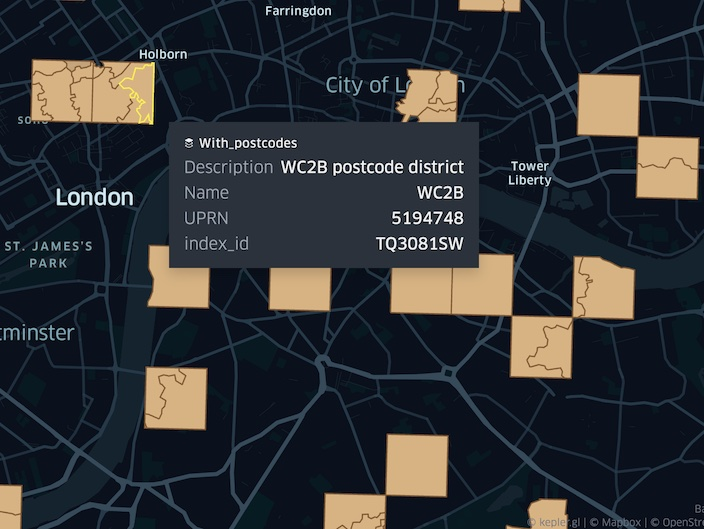

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAABYCgAwAEAAAAAQAABCKkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAhECwAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAEBAQEBAQIBAQIDAgICAwQDAwMDBAYEBAQEBAYHBgYGBgYGBwcHBwcHBwcICAgICAgJCQkJCQsLCwsLCwsLCwv/2wBDAQICAgMDAwUDAwULCAYICwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwv/3QAEACz/2gAMAwEAAhEDEQA/AP4gFDMwRASzHAA5JJ7CvStP8H6dolout+O38pDzHaL/AKyQ+/8Ah+Zq4174d+H6mHStuo6tjDTN/q4j6D39hz6kV5rqGo32q3bX2oytNK/Vm9PQeg9hXv6Lfc8u7ltojovEfjG/15RZQKLSxj4S3j4GB03Y6/ToK6bwkh8Z6DN4GlI+1Q5msmb26rn0H8j7V5VUkM09vIJrd2jdejIxVh9COaXNrdjcFayPUfs3hXwEc3u3VNVXpGP9VE3v7j3yfYVwuueItX8RXP2nVJS2PuovCL9B/XrWJSEgDJ4AocugRhbV7ksU08Db7eR4z6oxU/mK+iH1XWfiZ4JGpaZd3Eeu6KMSLDM8ZmjPcbWHJAyP9oEdDXE+GfhlPdWX/CReMpv7K0tMMWk+WSQewPTPvyew71uSfFy08PT2+m+A7BLbTbdwZN4/eTjvnPTPqcnPXFNQX29mRKbb/d7o80t/HHjW2Ui21vU0DcnbfXC5/KStW3+KHxGtkKpr+q5PQm/uDj/yJW38TPDVlDJD428OfPpeq/OMDiOVuSD6buTjscj0ryisJYenfWKOmOJqSj8T+867XPHvjXxLp8eka7q99eWkTb1huLqWdd/9472OT6enau2+EWrWm/UvB93MbU6vFshmXgrIARjPB5B49x6mvG6UMyEOhKlSCCDggjkEH2q6aUPhVjOreonzM7jVtJvtD1GXStRTZLCdpHYjsR7Ecis6vcYbG++KPgmLU7qEx6vZAqkhGBcxjuPr+jdODXkek6JquuXw03S4GlmzgqONvY7ifu496uUex5jVm0xNF1m+8P6nFq+nttkhOeejDup9jXa/ErwrFqemRfErQIHhgu1D3cLqVaNjxvx6Huen8XQmuth8NaD8P9Ml1vUkXWNRtiuYUI8uFj0LZ9OpJBPcCuV074qa6uvm/wDEri4064UxT2yr+7SM91HJJHfOSR+FWkkrSLptp3X/AA54artG4deqmta6jFzAs0QyRyMdSO9db488Ct4Z1RZtNYSaXdjzbefOVCnnaT3Izx3I/GuIa8MUP2a0JVD95jwzf4D2/Os2rOzOtrntKJRooopGwVPHGj28rD76Yb/gPQ/lkGoKejtGSU4yCp+h60ALDK0MglXkjPB6HIxUQGBilqe1tbq+uFs7GJ55m6JGpZj+A5oAgpCQo3McAdzXsGlfB3WWgGo+LLmLR7UcnzCGkx9M7R+Z+lb8OqfDPwaR/wAI3Ytq14nS5ufug+oyP/QVH1q+TvoYSxEVtqSfCjRdX1rw5q3hjU7WVNOvo98U7rhVl6fLnk9AQQMcVueHYvh/8Iw8uuXyXesEbX8lS7Rg/wAKqM7Qe5JBPsOK4DVfib4wu7qLUmuCq2zrKsEXyIdpzg9yCOOTSfF7S7VtUtfGOlc2msxCXI6eYAM/iVwfwNWpJK66GMbzdnomaVz8XtM06eWbwfokNvLKxZ7i4+eVmPc45P4tXE6j8TfHmpSmSXU5Yh/dhxGo+mOfzJrhaKzc2+p0qlBdDbn8TeJrnP2jUrts/wDTZx/I1393d/8ACf8AhiW+lZk1PS490mCdssYzzjpnj8D7GvJa9G+F8y/8JFJpsn3Ly3kjPuRyP604u7swmrK66HnI56d6/Tj9lX/gnn+3B8WPhenx5+GPw21LxF4G1uK8hW9hudPhim+wyPFMUW5vIZD5bo6N8gz2yMZ/Mwwm1uDbSdYnKH6qcH+Vftl49+Nn7Ken/wDBLT9nb4ZfErwDpHxF8VxQeP8A7Lcza9d6fceHJLjWcxO9raEpMZg6TItyArLGcHaTWbk0/wCv+CFRXVu//B80fite21tCWutOkM9g0myC4wQj7gGVNxG3zNrAlM7x3FZguLUx+cJo/LzgvuGwE9i33QfYkHv0r+rbwd41+Hmgf8EofEHwv8WePbPxP4W1r4GS3WnRax4k0xktfFsJWRtJsdDjtkuo59OMZP2qWYyOXx+848v0HxB+3lZ6r/wVy8WeF9S8YeH7n4W+CvB2tz+G7VxZf2M2ozeHbNy5cKBcTzXLyo2+RtxXYANpFLm28xe0etltfr2+R/KOvw81w/C+b4ufaNPGkwarDo5jN7EL4zzW5uVkW1z5pt/LHM+Ngb5etcK3l7VbzEKupdW3DBQEqXB6FAwILjKggjOQa/oK/Z4/aetPjB8APB3xE/aM8Y2GqeONY/ae8Ca5rNxqD20N01hBpsEc08kaLGqW0O3y2bYI124Y5ya+prr9o+f9sDxr4R8M/EHxBpHjXWfDf7X0Vh4Ys5YLW4eLwkIpmVYYYfKaSxLIh3AlSwB+Y8GFN6FObTd1/X9eh/K9FfS2WoR6vKRGYGimZmygAIDqx3YwJF5Q9HByuRXunxn+D3j3wn4W8M/HPX9PFj4a8fR6jNpFzLKoaY6NciyvN8Rw8RjnIQK4BY8gV/Zf8VPiKNN+Pnw38b+J/GWjXngjStc8e6b4c8Ta/rDXEtr491azml0yC8S70+yS3trGLzIbPImVGlCkghM/KPhz48XEHjX9myw/a/8AiN4V1L45aX4G+Jum2+s3Gpafe2uj+L7+aI6R9subcPaRTCI+WJW3KZCBucnJ0cnaxiqt2nb+tf8AI/j+uU+xSPDfEW7RMUdZv3TIy9VYPgq3swB/MVppdx2w+yyhg8RKOuMFXXqrA4KsO6kAjuK/q9X9pHUfhLo9n4o+Nvj7w7e/tK+FPgB8QE1vWILzT9SuotRl1K0ufD9nPdQhra5v4bcOURTI/fnOT+On/BUH4qwfH7xh8F/i1d61Z694k1v4P+GpvFV9b+UZpddSe9Wb7V5QAFyI9gkUgMBtyOlTGTbKk1Je8tP68j8uDySfU17Z8GY2mi8Rwk4RrBQSemTvrxLBHB6ivoT4Q24i8E+JNT7lGjB9kjLfzatqfxDrP3H/AF1Pn6zgluIVZMdBnPuKayspw4IPvUllcNbrhV3blHH0qS5m89wSu1lGDUF3lzWtodn8Nr9bLxZDDIfkulaBh9RkfqP1rmdYjubHU7nTZGI8iRkwOOAeP0qha3UlhdRX0X3oHWQf8BOa9P8AHPhvVNY8TrfaBayXS38KTAxLkZxg5PQdupqt0S0lO7PKaK9QT4TeI7YRzeIJrfTYn53SvuIHuBgfrUcnwyupmb+xdTs71QcAq23P/oVHJLsP2se55nXo/h35Ph5r0vq8afy/xrMuvh34ytBuNkZR6xMrD+YP6V0Fnpuo6b8NdWjvYJInkuY+HUg4+Wmk+opyTSs+qPK6KaHQnaCMinVBqezeFh/xZrxIW4H2iPGe5wleM17RGDp3wIkZhhr+/GPcKw/oleL1cuhlT3l6hX9iv/BuZZiP9njxjebceZqqru9dryj8un41/HVX2l+zz/wUA/af/Za8Jv4K+CuuR6PYSzSTyqsJZ5HkYud7bwDgsdvy8A9TXznE2WVsfg/YULc3Mnr2Vz38jxtLC4h1at7Wa0+R/o25FGRX8Ftr/wAFsf8AgoLYRhJfFiybsOuYVxg/XJP510kH/BdX9vWD72r2smRj5ox/8TX52+CMz6KL+Z9cuJsC9218j+6+iv4cLT/gvf8At2W7K0txpsuOoaJcEf8Afs8+/NdLaf8ABwP+2rCuLi10iYg9SoX88QHP6Vm+Cs1W0F/4EjSPEeAf2/wf+R/YV+0Ff2Wl/Avxffajbw3UKaTdBoZziN9yFQGI56kdOc9K7Xwzp13pHhrTtJv7t7+e1tYYpLmXG+ZkQAu23jLEZOK/hn/aE/4LUftXftAfDSf4ca1HYaZbTTRTvNaDLERHdtK7EDKfTPB564x9jSf8F0/2lPhZ4K8PafquiaVezG2jhdDGd4ESAElyRuPQZIGar/UzNFT5lTTfbmXl521F/rJl/Nyup87P/Lof1ieOZjbeCNZuFYKUsLlsnoMRtX+bQPiNq/w++M2r+J9OzNG1/dR3EBOBNEJmG09ty4ypPQ+xNftrqn/Bw38ZNc0S60HVvBlg0N5DJBIYyFbZKpU4O7g4PHWv58fEGqLrmv3+tIhiW8up7gITkqJpGcAnuQGwT3r63g/J8XgalWWJhy3Stqn37Nnz/EmYYbFU4Rozva99GvzR9e/G/wCHuk/EHw5H8Zvh0PPMkQkuo4x80sa8b9vXzI8YcdSB6gV8VAhhuU5B7ivob9n34qy+BfEi+HtWl/4k+pyBX3ciGZuFkHoD91x9D2Oa/wC0H8MR4B8Wf2ppUe3StVZpIgOkU3V4/YfxL7ZHQV99NKS5kfGU24P2cvkeBUUUVkdB6V8MsRX+o37dLezc/Td/+qvM4iwRTnDY6ivSfBp+z+FfEV8Ov2dYx+Of8a84qnsjOPxSJhcXA6SGmxSyQuXTqfWo6KkrlXYmmuJJ9vmY+X0qGiigaSSsgooooGek2mNS+F1zbx/f066Ehx3VuST+Z/KvNq9J+GrpdXt/4emPyahbMuP9pf8A6xNeblHjYxSjDISrD3HBqnsmZx0bQlFFFSaBRRRQAUUUUAFe2+CmPg74d6p43b5bm+P2S0PfrjP/AH1k/Ra8atLS51C7i0+zG6Wd1jQf7THAr1z4u3dtp8mneA9OP+j6TAu/HeVh39wOf+BVcdLsyqatQP/Q/i58baBbWE0Wu6N82nX43xleiMeSvt6j8R2rha9K8D6hbXVnN4U184sL07Ynb+Cbtt+p59j9a4jWdJvNC1OXSr4YkiPXsynow9jXvSXVHlwf2WZlFFT2trdX1ylnZRtNNIcIiDczH2AqTQS2t5Lu5itIcb5nVF3HAyxwMnsOa95k0jwn8IljuNcUatrjrviixiGLsG59+5yfQCsuy+Hvh/wlaJrXxQuApYZjsIjukf2bHX3A4Hc1yPj3x5ceN7uD/R0tre1DLCg+Z8HH3m/AcDge9aJcqu9zBvndl8PUxvE3i3XfF179t1ubfg/JGvEcY/2V/qcn3rm6PavRdK8FW9lZjXfG0ps7XqsP/LWT2x1H06/Sos2zVtRR1XwkuJdZtb7wRq0LT6VdqTv7Qy+xPc9eOhGe9ec6z4XufDuuXGh6ocyQH5WAwHQ/dcfX9DxV/X/G1zqNsNH0WP7Bp6cLFH8rMP8AaI/kPzr0uzj/AOFu+FYoxIqa/pG1d7cebC3GTj1/9CHoavRqy3MJc0by2TPBEtbiS5WzhQySsdqqoyWPsK9KtvD+ieDIE1Txji4vGG6KyQg49C/+cfWr974m0XwVDLpnhlEu9QcbJbxxkRkdQn0Pbp65NeSXFxcXc73V27SyyHLMxySaWi9S480lrojsJviD4mk12DXYpvKa2bMUS8RhehUjuCOCT+GK9j8Q+Orq98KjW/BcaWMVy5N+8YHnLIcZyR0HYt1xgjFfM1dZ4Q8Sf8I7qB+1L5llcjZcR9QVPGceo/UURm+rCpSTWi2Nrw5rjaFqBuJAZIJvluEPO9T1PuRnPvz61L4m0NdGvVe0O+0uB5kDjkFT2z7fyqt4i0T/AIR+/WOBvMs7kb7aXOQVP8OfUfqK3/DV3b6tZN4P1RsLIS1rIf8AlnJ/d+h7fiPShL7LORo0vBOqafrOmv8ADbxO3+iXR/0OY9YZeoUE9OeV98r0IryTX9C1Dw1q82i6ou2WE4yOjKejD2P/ANbtW9LpGofb20cwu1wrbSiAlsjuMfnnj1r2rXPDc/jnwxDp+pyxN4lsIS6hWG6WPPRvc8cjgN7E00nJW7GlOpyvXb+tf8z5fopzo8bmORSrKSCCMEEcEEeoqxY2N7qd7Hp2nRNPPM21EXqT/nqeg71mdpVrp/D3g3xN4qYf2HaPLGePNPyxD/gR4P4Zr05tA8C/DSCJ/GCf2tq7rvFqhzFH6bs8fi3XsK5fXfif4v8AEzfYLWUadakYENv8gCjrufrgD0x9KvlS+Iy55S+Badzof+EB8D+EAJfH+qiacc/Y7TO76Ej5vx+UVXuvi2mlW5034f6bDpUH/PRlDSn3wOM+5LV5DPKshCRZEa5256nPVj7k81Xo5+2gKnfWTuaGpavq2sXX27VrmS5m7NI2cfQdB+AFakUgljWQdxXN1radJlGiPY5H41BFeHu3XQ0iM8V6Z4WiPjD4fal4Gf5rvTT9qs89SvJx+eV+hFeV3W/yGKHBHPHtWt8O/EB8OeM7HUpG/dO/kyk/3JOP0OD+FVB6mNODcW0cQDuAYd6Wu3+I2gf8I34zvtPRdsTv58X+5Lz+hyPwriKTVnY7Yu6TQV0HhS9/s7xNYXmcBZlB+jfL/WufpCzJ+8T7y8j6jpSQNXVjq/HFl/Z/i2/twMKZN6/RwD/MmuSEcSsXVVDN94gAE46ZPfHbNemfE1VuNRsdajHy3tojZ91//XXm1OS1Jpu8UeweBrK01r4e+JtKEEbXcax3KPsXeRGMqN2MnaVOOeM8V4yILXyxGsaeWOQu0bR7gdK9n+CNw0fjB7GQEw3tvJCx7bhyB+Wa8ru7M6TqM2nTJu+zSvFtbI+4So6fTNOSukxRdpyXozNMUDsWdFYkbSSASV9D7e3StjQL59D1i31fT5Wsri1ZJILmAtHNC8TB42jdMOjI6hlKkEEZBBANUJZXmbc+OBgADAA9gKjqLGmp7T8V/j/8b/jf9h/4Xh4317xzLpiPFZjWtSuNQjgWQBWCec7D5gAGIG5+jMa5v4lw2tnq9rp1rDHEsNkkZVECrg54wBjGOx4rj9C0+XVdbtNOgUu0s0YIAydu4ZP4DNe4/EHwho0PiaXW/EuoLDaFEWONP9a4UcjHPfPQflVxjozKUkpJHg8Gkz3MMTWtsJdrgpDHGCF64baB8uTkAgDnPNenWXgDUIbYalrXlaVbyfOzS4DH3IHf3JzW54X+Iel22qL4d0e1FlY3S+T5rcyluiknn6ck9q8p8Tx64muSaZrU0t3PC+1N5LEg8gqO2R2Ao5YpXIknN2eh2NzffC3SdotLSbVJxne8h2xE+wOB+Qr0zwT4mTxB4N8RWdvaQ2SQW7FI4u4ZGGT09PSvINO+Huovb/2j4imTS7QclpSN5HsM8fj+Vex/Ce/8Jw6veaF4WjkeR7cu1xL/AMtChwBj0BbPQCtIXv2IqqPLprY8V8LeDPFesR7rGxlMbYw7jYv5tj9K7Cf4YaTpUn2rxprcFiGwTFFhpCfYn+i1xut/EXxvrBaHUL541GVaOD90uRwenzf+PVypsJmHnA5d+Wz1J9z3qLxXQpxalzSla56r/wAJD8KfDv8AyAtKk1WZekt2cLn6N/RRWdq3xg8aalH9ns5Y9PhAwEt1wQPTcc/oBXmMkckRxIMUylzs0VKO+/4li7u7vUJvtGoSvPJ/ekYuf1JqrsXduA59e9OoqTU07TW9asf+PO8nj9hIcflnFdVafE7xtaQG3+1iZCckSordPoAa4Kimm0S4Re6PSv8AhZDXQ26zpVndDudu0/yNN/tz4bXn/H7o8tqe5gfj9CP5V5vUkNs99PHYx/endYh9XO3+tPmYvZx6aH0z4w0/wingbQtAur6SwgIM8O5dxYbf4vTG/wDOvMbf4d6ZqbldG1+zk4JAf5Scfj/Stb44Xit4qttGj+7p9oifi/J/QCvG0ga5kW3iUO8jBVB7knA/Wqm1e1jKlF8l09z0G/8Ahd4wsrBtUjijuoFOMwPub/vnAJ/D8q89kDRlkcFWXqpGCD7ivYfFGqXPhhbDwt4fvPs72EYaXB2h5H9Typ7nB9aoHxfo2sstp4808GQYxcwDDgepA7fQke1JpXsVGUrXauecX423bRjogVP++QBVSvSbzw34Kk87UYteXy23MqbMybjyBjg+3SvNQSQCeDUtWNIyuLRViZVjiijAG4jex/3ug/IfrVekUW9PjabUraFQCXniUZ5GWYDn2r2L49XzT+MYNPzxa2qn2zKxJ/8AQRXD/Dmw/tLx3pdqRlROJG+kYLfzArX+MM3n/EO+5z5axJ+SA/1q18DMX/FXoecw2804JiAIXAOSByenWpTYXwGfJYj1A3fyzTF/48pPeRP5GqwAU5Xg+3FQajpIiMxzKRkYIYY4Nfdvwu1ay+O/wrvPhr4pcnUdORFWc8tt58iXP95SCreuPQ18JMzOcuSxHHJzX11+x42PFmvL62dr+kkn+NaUn71jHEL3Obqj5KubeazuprK4x5lvK8L7em+NirY9sg49qhrY8SgR+J9VRuP9PvOv/XZ6x6zNz0fw183gDX4/Qo38v8K84r0fwj8/g3xJH38hT+hrziqeyIjvL+ugUUUVJYUUUUAFFFFAG74X1H+yfEdlqBOAkqhv91vlP6Gtfxtok9h4qvIokxHI/mp6Yfn+ea4ojII9a9g8QzjWfDGl+JiRv2G3mP8AtL6/iD+dUtUzCq3FqSPKJraWBQ8mME44qvWrdTxTp5EOXYnjaM9KygQelSXTk2veCipxLEkexIwWI5ZjnH0HQfXk1BQaBRSMyopdyAB1J4Fd14U+GnjzxswPhvS5poj/AMt3HlQj33vgEf7u6mlfYTaSuzT+D9kt78Q7HcMiASTH/gK4/m1cd4nvzqXiPUdSkORLcytk+gYgfoBX3L8I/wBnW+8F358Q+KtQR5XiMZtrdf3YDEHmRuTjH8IWjxDa/sz/AAk1EnULGG41Jf3iwANdyruJIOGJVAexJFa+zfLrocvt4+0fKr6H/9H+ISaZ52DPwFGFC8BR6CvUh/xcHw1g86xpi/jNF/j/AF+tef6JoOseI74adolu1xL32/dUHux6AfX8K9osdL8I/CWVdS8QXJ1DWQp2WtucIm7+9/i34LmvfgvuPJqNKyW5wnhH4ba54oj/ALRnIsNOQbnuZhgbR12g4z9TgfWuwm8beGfBsDaN8MoUecjE2o3HJOO656+3AX0Brg/FfxC8SeLbkSXkvkQRkGO3jP7tcdM/3j9fyri5jG8peJdqnnHoe4HtnpRzJfCHI5az+7+tzQ1HUZb+4kurqR7q4l+/PMcsf90dh/kYqgs8kcTRx4G7qR1I9M+ntUVFQbWPY4rXQvA/h2z8U2Sf2pd3ijZKwxFA5HIx1yOR6kjtXluq6vqWt3ZvtUlMsh6Z6AegHYV0GgeJbax0i88P6zE09ncqWQLjKS9iM9BnB9iK41c4G7r3qpPRWM4Rs3fckRGkYIgyTXXeGL/UPCusQ65YSfvYj8yfwuh+8p9j+hwa5mzmjgkJk7jGfSrk2oRhcQfMT37VKdjOq5t8qWh6N8T/AA5ZHyfHnhwbtO1M5cAf6qY9QfTcc/Rs+teRV618MvEtjG0/gbxJ82marlMk/wCrlbgHPbdx9GwfWuF8U+G77wnrk+h3/LRHKP2dD91h9e/ocirkr+8i6bafI/6Rz9FFSQwzXEy29ujSSOcKqjJJ9hUGp6P4Q1K01vT28C642I5TutJT1jkHQf4fiKXQ/A3ie+1SeyvMWkdux33Mp2opXnK9M+o7DuaktPC+keE4Y9X8bPmb70VlGcsSOm4g/wBcD1NYXi3x1rfi+QJeERWy8LAn3cDoW/vH9PatHa3vHO48zfLt/Wx6hrvj6Cz/AHXhcD7UY/Klvio3OB/dGP16eleKafrOr6Hraa3aSkXcT797HO7PUN6gjg0lhcb18luo6fSu78O/DvVvGP8Apif6LZx/6y5kHyADqB0yf0Hc9qm7kzKD9nJxlsdt4h8Ex/E2wh8eeCwiXFyAt1bO20eYvBO7oGHf+8MEe+34evfh/wDCa8TQ76U3GqzBVuLhE3LGWIwuf4VGckdccmtjwNr3hDQNZh8EeF43lhuFaRr1mys0ygYA9cqD6DjjNfP/AMS9HbS/G+qQhP3TSCYHHG2YZ5+rZFatpLmW44pyfs5bdDW+Kuh31t4/v5pceXdlZ427FSoX8wVNcBPFDbQFEch2GD/tD0+leyeIpp/EfwostdlB+3aRKLWckfNsOACfr8rV4SeTk9TWU97mlNSe72CiiipOgKt2c8cDEyDr0NVKcpUOpcZUEZHt3oJlFNWZsPf22MAls+grEKgqVPQ8VqeQFFzauwQRurAnPQEjtnsRWfIqK2I23r67dtBNOCjse1eO2Piv4f6N45X5p7f/AEO6I9emT/wIcf71eJV7V8KXj17StZ+H10cC+hM0Ge0icHH/AI6a8XZJI2MUw2uhKsPRhwR+Bq5a2Yqel4dhFIVgxAYDseh/KpJQWCzbFRXyAF6fL17n1qKrLf8AHjHn/no+Ppgf1qDU9A1r/iY/DfSdQ6taStbt9OQP5CvNq9J8PZ1D4fa1pnVrdkuVHsME/wDoJrzaql0ZEOq8zoPCepnR/E+nalkhYLlGPoAx2sfyJrqPi5po0z4gX6qMLcbLhfo4wf1BrzlIJ7pxa2qs8r8KqDLZ9gK+l/iD4e03WbbR/FHia6/s9fsgjmQj94zjB2jryOexpxV4sibUZpnzVDDNcTLb26NJI3Cqoyx/AV6Rpvw+itYRqPji8XS7fBITIaVj6Y5xn2yaJvHOm6JA1j4GsxbA8G5lG6Rh9Dn9fyrzy7vLzUbk3V9K88z8bmO5jnsP8BS0XmV70vL8z0Kbx1Z6LCbHwLaizXobhxulb356fjn6V55c3N3qF0bi7keeeU8sxLMx/n+Fd3YfDrUhANR8TyLpVrgNmXG8g+g7Z9+fatGLxl4e8IsV8D2YlnAKm7uRknPoOD/IU2m9xJpfCrv+upl6Z4AvTbf2p4knXS7Qc7nP7w/Qdj6Z59q7DxJ8UdIDIfCtipukQRtezqN7BfQdTzk84+leP6nqupazc/a9VmaeTsWPA+g6D8Kz6Oa2kR+zvrIv6jqmo6xcfatUned+xc8D6DoPwr0X4LXP2b4hWwP/AC2imj/MBv8A2WvK67L4d3P2Px3pM56faAp/4GCv9aUX7yY6i9xryE8UaVFp/jPVNPk6RXMhA/3zvH6GqU0nlRNJ6Cu3+Nun/Y/Hsk4GFuoIpf8AgQyp/wDQRXk++Z1EIYkEjA9+1ElZtGPs3NRlc6TSb6yg/ea3bmSOUbUfblRjrx/hW5/wjmgaupl0a42N12g7gPwPIpmt+H7xrS0gt3jCwpsCM20s55OM8E1xNxa3unyj7TG8LjoSMfkf/r0ti4pPWLsbN74V1iz+ZUE6+sfJ/Lr/ADqlb2aGLFwvzE9DwRVmy8S6ra3CTTStMijBRmwCK3NQ8R6ZqFrJNhlmEZVY2AI3H+LI7j60aCmptWOGbbvITpnim0DjiikboK9A+FukNrPjuwixlIGNw/8AuxjI/wDHiK8/Jxya9z+HR/4RXwJrfjxxiWQfZbYnuw4/Vzj8KqC1M6rtF2MX4k+G/EN54lvvEkMX2u2nk3K8H7zaqgKMgc8Y9xWN8ObG3k1WXxBe/wDHtpkZmY9t2Dj+p/KsLw14t8QeEbgXGiXBQdGRvmRvXK+/qMGvUpfHHg7xXo02j6jAdFubtg080IBjkZcdeM84Gcj8apWbuRLmS5eh4xfXlzrOpy30wzLdSFse7HgfgOKolQpKjHBxx0rudW8Ca/pCDUdPIvbbqs1v8xx7ryfyzXCjHQduKhprc1i01oLRRU9vbTXTmOAZIBY5OAAKRRBRRRQB7R8C7NH8W3Gqy/6uxtXZj6FyAP0BryrWtVk13WLrWpTk3crSj6MflH4DAr1jR8+F/g7f6v8AduNbm+zxnofLHynH4BjXimB0q5aJIyhrKUvkWX/c24hPWTbJ9Bg8f1qtTmZnO5zk4A/AcCm1BqFfWf7IDY8aawv96zh/SQ/418r2GPt0QPQtj8xivp/9kOTZ431OPHLWCn3G2QdPz5q6fxIxr/w5Hz94tvLyPxZq8PnNtF/djBORjzX9a5YYxxXrfxd0628P/EzWtOljxm5aZfl6rNiQH/x4j8K82NzZH/ll+gqZbsUKjsrRO4+H6m707XNKj5lntMovrjP+IrzRTuAb1rq/BGqf2R4ptLlzhHfyn/3ZOP54qr4q0v8AsXxHeacBhVkLJ/uv8w/nj8Kb2RotJPzOeyB1pau2c6xybHAwe57Uy8kjkm3RnIxg1Icz5uWxVooooLCiiigAr0vweP7b8Mat4VblwouYAf7y9f1A/OvNK7/4YWmuXfjC2/sK0mvCG8uYQoXCq4/iI4XsfmI6VUdyKi91nAI5BEiEg9Qe4qzGPNtniA5izID/ALP8Q/ka+sdN/ZP8Sapq1xc6vfQ6dYtIzRqg86Yq3PI4VcdOrV16eG/2ZPhLNjX7tNV1CMcrKTdyA+vkxjav5VSpProZuvHaOr8j428N+FPE/jGcQeFdPn1AnjdCuUH1c4Qfia+kvC37J/iS8QXnjXUYdMhHLRwfvZAPd2wi/k1bXjH9qw27Npnwz0+JLdQNtzcoV577YBtwB/tEH2r5i8VeP/GvjZyfFOpz3aH/AJYltkIz28tcKR9QTT9xeYXqy/ur72fWn2v9mL4Qyf6Kq61qUJ6r/pkiuP8AaP7uM/lVDxd+0Z4o1PwYuu+B4I9NRZzDJ5qiaVF6DHRAenZhzXxWAAAo4A6CvTPh/wD8TLT9Y8Ny8pPbmVR6OvGf5U1Ub0WhMqMUuaWvqcnrPizxV4iuTea7qd1dyE5zJK2AR0IUEKPwUV2vim8fxn4Tt/F9wc3tkRbXGBjcOx4+oP4mvKEO5Qx7ivTfh/jUrLV/C7/8vduXjH+2nH+FZxd9DWaSSkuh/9L+N7W/il9msT4f+H1sNKsBkGQD99J75/hz68t9K8hYszF3JLMckk5JJ7knqaSivdcm9zzYwUdgooqzZQLdXsFq52iWWOMn0DsAT+tJstK+hWor+oTwP/wb1aD8QvAOieOtG8fS2ker2kV2IZoNzosqggM23BI9gBV+5/4NuNTBYWvxHU+mYFX+cTY/WvlVxnlfWbXyZ7/+rOO/lX3o/lsor+nW6/4NuvG+/wD0L4iWxXH8cYzn8IK5HU/+Dcf4zWtrJcWPjWxuXRSRGoAZyOgUlFAJ9z+IrRcYZU/+Xv4S/wAiXw3jltD8V/mfzcUV+7Ph7/ghZ8W/FVncvpHi2ziurKY291aXkJguLeYAHZKmTg7SCCCVYEMpINW7n/ggN+0unNr4j0Zlx/EW6/mK2XFOVv8A5ffhL/IxeQY9f8u/xj/mfg2eeDXu8bn4p+A3ikHma7oSgqR96aE/zJAx/vD3r9arP/gg/wDtFWP7zU9R029YH7kcmxP/AEPJ/MV4/wDFT9hb47/s12l5rk9naXFnpM0cN1badbvLNIZEWQqjhyC6xHzSoBYqpAyeK6qPEWWTkoKurvTZ/wCVjlrZJj0nJUXpre8f87/gfmFZ/Dy7itxqHii5j0y3/wBsgyH6DOAfz+lWX8V+HvDML23ge3LTuMNdzjLY/wBkH/AD2Nex2P7P2p/Fb4tJ4N0bXrOxvdYIfTYtRMgWfd95Ek+4Cp52kj5eegNfat1/wQ1/b5tkLR6DBOQcEJIo/EEtzW+LznB4Wp7KvUUZed/8rGWGyvFYmmqtODlHyt/w5+QNzc3N5cNd3kjSyucs7HJNNgt57udLW1RpJZDtREG5mPoAOtfq/N/wRT/4KAW90IZPCI2HGXEoPHfgZ/LIrv4f+CV/7afgHTAngbwBNdajMCr3l2zAr/uqsbce3A9c1hHPstlr9Yj96NpZTjVoqMr+h+ZmmeBNB8E2kfiL4ly4kI3Q6fGdzuf9rHX3Gdo7k1+o37G/7Ovw6/bJ/Yt/aB8V+LLzwt4R1vwjqvg6DQ9b8U6m2ladp9rdTStdwvcBXVTdIgjGY2BbAHrXy1df8Eyf28fEd3fak3hCfU57Wdra6eKRpTHMmMoxEWAVyMqOmele1+Af2U/+CmHww+B/jn9nPQvArW/h74hX+i6jqpntXknaXQpDLbeTKP8AVqHPzqY23jjK9auWeYBq0a8P/Al/mZSyXGrWVKV9Oj7n2F8Yf+CcX7NHwg1Sw+KHi7xA2meCfhr8GvAmv+I7z4fGHUp/EniHxFeXNhHcWM17/oxiuZVDtM6AFFUgLk15r+03+x98J/hN+yj+0N8RdGmXxdA/gz4W+LPA/iDUrSO31ey07xPqU4kDiP5Ip3jUwzeVhXVRwBxXf/DOw/4KZ6LrOiaBc+E9O8SWMvg3RPhnJ4b1fw4b/RtS0rSZWawS7ikmiD3Ec0m4XHmRAHkhRmvD/wBvLxp+3J8Pbz4mfCn9rjSoNBu/HWkeGU1fw+lnaRRW2i+HriSTSo9NFndTxWtqjpKCjPK7qrfdJDF0cwwlaf1anXg6jTaipxcrLRtJO9ldXdtDkq4XEUWpVoSS01cWu2mqXmfVf7dP7Cf7MviT4mftB+C/2NJNS8O+LPhze+FE1Twvc2Vpa+F3g8SizskOnywsbmNoJZkmmMo2vl9ibiGHinjr/glb+zDceLPFnwi+EvjnxVdeJ/hB4y8H+FPGc+q6dYQ2F8nifUl0t7jSfJJmRrefdhLveGXH3s5r43+O/wDwVg/aO+P3g/xD4X8Taf4X0m78YXmnXniHV/D+ippWr6s2jOsmnrdXizSu6WsiRvEFVW3RrudgCDqfEb/grv8AtSfESOK8ksfCWjatea7oniPxBqmj+H47K+8Rah4elWexfVJhM5uFimUSFEEO5snIyRXc72+/9f8AgGMYTXX+tP8Ag/1t9IN/wT6/YNsvij8aPDf/AAnvj2/0H9n3Rby+8S6hb6Vpkb6jeWWqfYpIdOjlAyi4eNpJ9mZV3AGIgH42/bP/AGI9B+Avxxg8LfCzxFLqnhTXvDWh+LdIu9Zijtr5bHXonkjiuI4f3XnRGJwxjwpGMDOc+OJ+2j8cI9Q+MV+lzZE/G+3vbbxGrWmV2X9+2oy/ZR5g8gmd2IJ83C4XnGa4L4+ftE/Ef9pHVtA1n4myWs03hzw7pXhi0+zW/kL9h0eN47feNz7pMO298jccfKuKcVZrQvln3/r+rlBvhz4G0zjxB4qgDDqluoJ/Ut/KnJF8B9OOJZb7UGXvh1U/kFFeNW6IZVjx8pOMDitqS1jMLRxqAT0+tbcy6Iym+VpSk/yPfYNd+GaeHp/Eel6DHKkTiKYSIGk2nHOTnI6VysnjP4P3H+u8M7T6xqqn/wBCFcL4E1uDTtTbTNSwbLUB5MynoCeAf1wfr7VheIdEn8PaxNpM+T5ZyjH+JD90/wCPvTcna41SV2m3957JonjD4OaRq8OsWGnXlnPCTtZSWUZGDlQ5yMHpitC60/4HeL7qW9j1B7G5uHLsXdossxyflkBX8q+dHikjVXdSA/K57imUufuivY9VJn0JcfAb7Wnn+GtYiuEPQSLnP/AkJH/jtchq3wh8e6fBEkdmLoR7iTBIG5Y+jbT0A7V5dbTTWcnm2btC396Nih/NSDXb6b8TfHmlECDUpJFX+GYCQf8Ajwz+tO8H0DlqLZpnSfDjRtVtfENzoOr20tqL62eM+cjKpK9BkjBOCaox/DGfRbWPUPG93HYW7fdRWDSvj27fhmvavAHxL1XWtA1PX/FSRJa6YoJeJSCzYJIwSR0xjHc1wup/GTwz4hC23iLw8LiEdNzqzqT1xwMfgwqrRstTLmqOTsvU4qXxxp2iRNY+B7NbZTw1zKN0rfnn9fyrpfHLX+v/AA68Laim+5lbfE+BudpCvPQeqmoo9A+EfixvI8PX82kXb/ciueYy3pluv0DV6lpY1v4X/DWb+0rdLqSwnYrsb5WikcHcDjIAzzkcYoSbvfYJSSs0tb9TwSx+Hd+sAv8AxNPHpdt38wgyH8Og/X6V30M/g/wP4WbxDolqLm6ucxW01yMsT/eAOMDvwBnFYGoweHvibetfaXdNZ6nN0t7hi0bE9kPb/gP5VT+Kljd6VPpukSRssNpbBA2DsLnqAemQB9aWyuitZNRk/keeatrOq67dfbdYne4k7bjwo9AOgH0rMoorI6UrbDtj7PNx8uduffrim1sgwm0EbhLl4uioSNqnqcj7xz6Zx7is+7gFtOYgc8A4PUZ7Htkd6BXK1a2gecNf0824y/2qDaPU7xXW+B/AcnidZdY1SZbLSbQnz52IBO3kqv4dSenua9d8Ca/8Lx4pTRvDWmiCQq4hvLjlncdAu4lhkZ64PFXGG1zKpVteyuUf2hdNbzdN1hASB5sDEDjJwy5P54r5wiYrKrKMkEYHvX2Lodjr0el6ha/GG4tZLS5kAiWV1wOpIBwuB0K9WFcJL8OfhOty00PiIRLnKp50TbR6ZIJP481c4Nu6MadRRjyPU8L1e6nuAkU7FwP73PSoItX1KG3a0EpaJwVKv8wGfTPSvfJvA/wkkUJP4jBA54ljH9KgHgf4Jr/rPEGf+3hP/ian2bHTqRUbNfgfPA44or6I/wCEP+BS/e17P/bwv/xNKPC3wDX72tBv+3n/AAFHs33NfbLs/uPnaivov/hHv2fl+9qZb/t4f+gqdPAnwW16P7NoOreRP2P2jcf++ZP6UezfcPbx7P7j54tAVZp1XeyDCL3Z24UY/WvZ/ilt8NeF9D+H9ueYY/tFx7t0GfqxY/hW1o/wP1XTvFNjfSXMN3p8Uwkd1yrYT5gNvIPzAdDXmXxPn1W88ZX+panbywRmTy4jKhUeXHwMEjGDyeveizjF3EpKc1Z7anF21o1wC5O1elTSacyjMTbj6HiorO7EA2tyhOcitBr+2A4OT6AVmTN1FLTYj0fXtZ0CbzNJuGh55Tqh+qnj+temTNpvjDwdf+I9btorG5tVxFcJwJpP7uO/PHfk8dK830HRLvxNrKada/L5hLO3ZEHU/wCHvXS+MfEcTzR+HtAITT7AeWowCJHHBY56+34mrW2ppJXatuefVbjuzDZyWsa4aVhub/ZHb867LwZ4ctPE11O+oQtHbW8TPJJCccjoMHI9+K4eVIkI8p94PYgqw+oP9Km3UtSTdiKtDSdLvNb1ODR9PGZrlwiegz1J9gMk+wrPr2/wFDD4J8J3fxJ1BQbiUG3sEbuTwW+hI/75UnvTirsVSXKtNzd8cv4EmFp8P7i+ktf7GRUWQLmPeVAO44PIHXp1ryzV/AOrafZnVNOkj1C06+ZByQPdef0JrippZriZ7i4YvJIxZ2PVmY5J/E1r6H4j1nw5P52kzGME5aM8o31H+TTck90TGnKK0ZkxLbsm+aUIPQKWJ/p+tOS3knY/ZUd17HH8+3616rFDoPjuOa50iIWOsIhkaLaGjkx1K5GAT64z6g15RLPcT8XDM3sx6fh0qWrFRlcbFI0Uiyr1Qhhn2r0n4SeP3+HHji21+U/6HJmC8H/TFyMsPdCA30BHevM6KE7O5UopqzPrr9rDwo6azp3j+xHmW17CtrK68gOmWjP0ZS3PsBXyLX3J8HNQsvi/8Ir/AOFGvyf6Vp8Yjhc8sI+sEgznmNht/AetfE+oaffaRqE+k6nH5VzayNFKn910OD+Hoe45q6i+0upjQbScHuikd2PlOD2Poa9M8egatpuleLoh/wAfMIilI7Ovr+teaV6V4EuoNXt7jwLqR/dXwLW5/uTDnj64z9R71Mexc9LS7HnEcUk7eXCpc+gGalktzEpMjoH/ALgO4/jjgfnU9/bahplzLo99uR7dyjx54DD/AB6j2qgBjgVJYUUV2/gn4deMPiHeNaeFbQzLEQJZnOyGMn+85HX2AJ9qaV9gbSV2cRXU+E/BHizxzd/Y/CljJeEHDSKMRJ/vOcKMdxkn2r62034DfC74aWK698XtUjunHSFj5UBPoEGXlPseD6Vh+LP2pIrK1/sP4VabHZ28Y2pPOgUAD+5CuAP+BEEehrTkS+JmPtnL+Gr+fQ0dB/Zt8I+D7AeI/jDq0QiTDNCj+TAPZpDh3/4DtB9DSa/+0x4T8IWP/CP/AAi0eMwQggSSJ5EAx3WMAO31bbn1r5F1/wARa94p1D+1fEl5LfXHZ5m3bf8AdHCqPZQKx0UzN5UQLt6KMn8hS9pbSKsHsb61Hf8AI96+Mvj7xprV/bx3GpzrY3Vukggibyos854XBbtwxIrwJESNdkYCqOwGBXs+v+GPEOv+FdCvbOzlkliiaGTI2kYx13Eelc7D8L/FjjdciC3X1kkH9M0STbuOnKMY2ueeUV6SfAek2f8AyGNetYfVU+Y/z/pUi6Z8KrKFjdald3cgIwIkwp9eQv8AWp5X1L9ouh5lXe/DK5SDxlBExA89JIsHvkZ/pVr+2/htZ8WejzXJHQzvx+RJ/lXS+G/iFat4gsLPStGtLJGkVCyjLHPfoOacUk9yZybi/dPHL6EWl/PaH/llK6f98sRW/wCCtR/svxVZXROFMnlt/uyfL/Miu98T+NrC38Q3tld6JZz+XKwLnhm75Py+9YQ8X+D3Iabw7CGBzlGwf5CiyT3DmbjZxP/T/h/ooq1cfPHFc/3l2t/vJx+oxXuHnlWtjw8hk8Q6dGoyWvLZQD3zKgrHPAyeldN4FiS+8aaNAoMitqNkGCHJ2mePPI6cZ+lZ1XaDZrRV5xXmf6Pnwl+Kvwu8D/CzwV4O8XeItP03Um0GwmWC5nWJikkYCn5iByQQMnnFfToIZQ6nIYZBHQg185/s/fC3R9D+FFq+v41e58QWdpPetdRIU8tYEjigVMFRFFGNqjvkk8k1oQ/BbVvBbu3wT1+Tw5ayMGOl3MAv9NU9CYonZJIcj+GOVUzztr+cpJXep+xnvUskcETTzsERAWZmOFUDqSTwBXieuftCfDKzP9meEtQj8UazIdlvpmjut1PLIegJUlI1B+9JIyqo5JrOu/gzr/ji8t0+NmtweJNKtS0iaXBY/YrWWVhgNOPNkMoQZ2ISFDHJBOMe56dpmmaPbCy0i2itIVGAkMaxqAPZQBS0QHxJJeePvhR4k1Lxt8ZrS2Sz8VS2s82oaezSWum3CxrAttPuw3lgKu25wFZidwT5c7HhXT/E/wAddV1PU9D8QX+ieGLRYobG5sbaNGvZmDebIss6PuijO0IUQBjn5iOn1B8Q/CsvjrwBrngm3kWGTWLC5skkcblRp4ygYjuASDWJ8IfFy+MvhlpPiG4i+ySpAba5iJysU9mxgmUNgZVXjbDYwRzWntXyk8qvc8W0z4W/tD3tjDY634i0XTfLURyT2tnJdTygcGQeY6Ro7DnG1wreoriPiR+zv4NvNU8N/DTU7/UrtfFF7qU2qXss/wDpM5TTzECCqhEAUKAqoFxn1r2S0/aCbVNNtfFGi+DfEN5oF0VZdSigjcNDJkLLHAsjXEiHj7seQDk8V5f4z+OGk3/xc8GS6X4f8QXM9tHqjpaPpU1vNM7xIi+X5wRcAkh2LBUBBYgGmpTb1GopbH51/GD/AII2fs3+DLXR/H9nrd/Y6X4Sja4MaL5l7c3jHbEkZVlDGRmCKjZJJxyDiv0R8S+Iv2hvhH8NNK1zxH4h0SbVJ47azg0g6W/mT3rqAttHMtyMnIIaRlCqAXIwDXr+ieB/GPjvxNb+OfjBFFawadIs2k6FBL50VvKvS4uZAAstwP4AAY4uq7m+auw+LGqfDPTPCo/4WvbQ32m3M8cKWstsbwzTnJRUhVXZ34JGFyME9K2xGNr4hxVebnba+plQw1Kjf2UFG+9lY9HhMjQo8qhGZQWUHIBI5Ge+PXvXiPxK8XeINX1yP4O/DS4MGt3sQmv79MMNJsXOPOIOQZ5MFbdD1YFyCqnPjHwjg+NJ8MXPw/8AA+mzeG9Ii1G8lt9Z1lGMkdjPMZIYrOykJcGOM7B5xVIyBhWHFfYvwn+B9r4W0K7k0F8i6uTNf6pqdwBLd3bjlpJW+8wUABVG1EAVQqgCvPr16VCPPVkkvP8AD/hjZ2RpfCP4b+H9Ej0r4d+HUaz023BUsCXcIoLySOzZLyNyzO2SzHJr0a2T4aJMl095qTxqwdoXhT51HJUsr8bumccVrWPh3UvBugavr98YmE1uLO1lglWVHa5bDlSpP3UB6gHmvJTXjQl9fq1ZUq7VONorla1dryd7PpKK0s00+pO/U9Nn+LHis3bTWrQpGkhe3U28beQP4QhK8YGPqRmv46P+C+GvxW//AAUW0rStWw8Or/D7w1DJkcGR31FgcdOckfU1/WSeBmv40f8Ag4KubrVP+ClkekacXnltPCPhVAhz+6aOOeUcnoAWBPb5j3r67gbL8Phs/wAP9WpqPuTvZbpcq177/j3Z81xVGP1Frz/zPwY1zStW0PV7vRrkrGlvI0e5lVVZf4T0ycqQeM1ypwpIByB0PTNfR3x58PxSCz8ZWik+ZiCYjp3KH88r+VfPVmFNyu73P41/Qk42dj85hUvDmI44JpfuKcep4FXo9NJ5lbHsK1aKk55V5PYyrmzjii82HIK81ZF9BtUseTjI9KtsoZSp6HiuZZTGxRudpwaCqa9orS6Fm9iEc59G5/xr0i8z418GLqA+bUdIGyX1kh9fy5+oNef3ssEsS+WclSOnTmtPwlr7eG9bjv25hb93MvrG3X8utVF9GaRu4J9Uc1nPOc+9Fdr4x8PWXh3VysReS3uB5sG3AXae2eensOmK4oUmraG0ZJq6Ciiuj8K+F9U8X6wmj6UOT80kh+7Gndj/AEHc/iaEr6A2krs9K0z/AIlvwK1CWY7Df3YWPsWAZVP/AKCfwrxKvXfijq2lxW+m+CfD7+ZZ6UhDP13yfdzx1xzk+pryKqnvYzpLRvuIQCMHkGvoz4N+JdUTQ9asCxujZQC4gilYlcYYFR1IBwOO1fOlewfBC6WPxq2nyfcvLWWMj1IwR+maKbtJBXScGbKr8KfiNh4CfD+pyEEDgROx5H+yefTa1bkXhPxfBaSeC/F6tfadNlre8jO/ynA4zn5h6jOR2zzXzhd2v2K6m09x/qZHiI/3GK/0r0Lw14+8XeC7cxwy+bCrqognJdMEH7pzlenY49qakr6kSpyS91/f+jPPrmA2tzLaswYxOybh0O04z+lQV7r9l+HPxLfNk39g6xJklG5hlY8nHQEnrxtb1BrivE/w18T+GFa4uYfNt158xORj14/ripcXutjSNRXs9GcRbSi3ZrgHEij93/vHjP4D9ardKfDHJcSJDbKZHkYKioCzMzHACgZJJJwAASTwOa/Q4f8ABNj4q6JZWSfFnxr4H+H+s6lGktponiHWVhv5RJyodUVliJ9Mvg/Skk3sE6sIfE7XPljUENv8DNOgtQT9rvWaT3Ks5/8AZRXkclm0Vv8AaA+xlG7njBHuK9813QtJ0/4QXmm6n4s02DW9A11tOt9EhieeTUIlZllvIbpSI/IRtwAZMuFyMbhXHeN/hN40+H3hvwR4r8ZvbQ2Hj+wOqaaFm3SfZlmERMqlVCMc7gql/l5zRKSf4GUW76Pq/wDP8jT+M26GLw9psrl3hsSWycnJ2jJz3ODzXiWFr6E+Iuk6b461v+0fDGq2tyYLZESFXBBVckkMCR39K+fGKCRotysyMVbawbDDqMgkZHeqqbmlD4EgoqKWe3t1DXEiR54G5gM49M9evatXQNLvvFWsWXh/w4Eu7zUbmGztkRxiSe4dY403cgEsyjnpnJrO6NelyhlqMtX1N+0j+z94C/Z11uf4dXHj+z8ReNdJnig1jRrDTbmKKzZ497AXsjGKUoSFIVAST2wRXB/Dv4G+MPih4D8b/EbwrHb/ANm/D/TYdV1X7RcmOUwTO6KIVETB3zG2QxQDjnmn5GaqxcedbfdvtueceDvDV3408Wab4Qspkgl1O4S2SSQEojPwCwHOPXFfrYf+CFX7d01qlxDpdnPHIoZdsgIKsMgj5uhFfkl4W1ifwt4r0/XIkMkljdRS7FO0tsYEgHnBIyAcHGc1/ou/sKftL6T+1n+zT4f+L+l2gsfPiW3kgEgk2tEqgEkE4JBBIycHIya+L4szjHZe6c8Nbkd07pPX/hj6vh/LsLi4zVZXkvNrT/hz+S7wx/wRu/4KAeCl1CWHw40shgKQCKcCPd1yQWOO3YmqUX/BNP8A4Kc6LbiLUvBkWqRAciZ8s2PdI/5iv7ncClr5KPHeZr+X7v8AJnuy4UwDd3F/ef5+HjL9iv456KT/AMLF+EmqadKc757FcIuO5ZvKx+INUrP/AIJk/tE+K7A6n4J8N6yEI3BLqzc8fVR+uTX91Hxv1PWNes7f4K+GkjbUPF1vdRSTXI3wWlhGqrcTMv8AGwEipGnGXbJ4Br2PRNPOh6JZ6HHPLOllBHAskzbpHEShQzEcFjjJ4611PxAx3LrShf0l/wDJGC4Qwid1Odu11+sT/OH+JXwO+IvwDtLjwZqGmXK65MB9sOzDwoR0C8OO/GMjqe1fKjw2iyG3cyW8i9UkXJH5YYfiK/0fvjl+w7+zn+0VrEviH4iaMzarchUe9t5Ckh2gKpIOUJAA6r25r+Ir9sO++D/wv/aL8U/BttN+12Wi3htonZkeTvj7xDBiMHA/AYr6/h7iinmT9hOPLUSu/wCXotNb9dvxPnM4yKpgU60HzQbt/e+elnt5eh8gaKtx4f8AAN7qVo4M+oyiCJkOflXg4yP96uEfXNSLeXfpHPjqs0Yz/Qive2vPgn4n0m30FrqWwitiTEshaLBb3YFW6981SufgVbahH9q8MaylwpGR5oD8f7yH+lfWuDdrHziqxTfOrfI8c8L6Be+MvEkOkRE5nbdK4/hjH3j+A4HuRXV/FTxHbaprMegaPhdO0hfIiVful14Y/hjaPofWvTbDwnrXwx8D6lqEEJutXuz5Qa3BkEUfQEcZ45Y8dcDtXhfhnwR4l8WtKmhwb1gHzvIdi5/u5OcsfT88Ummly9WVGUZSc76I5WirV7YXumXT2OowvBNGcMjjDD/PqODVWszc1tB1eXQdYt9Wi/5YtlgO6Hhh+VdF8QNIi0zXzd2fNtfr9oiI6fN94fnz+NcPXrWhaha+NfDMXgTUtsV3ZgtYzHvjPyH8PzHPUVS1VjOejUjyWip7q1uLG5ks7tDHLExV1PUEVBUmh3/wx8cN8O/Gdr4nO4wx5jnVf4oXI35+gG4e4Fe7ftSeCIINStPiZooD2mpqsdwyfd83GY34/vpwT6getfKUUyQrlYw0mfvNyB9B0/PNfbXwS1ey+LHww1P4TeJpN09pHiJz97yXOY2HvE4x7AD1rSGqcTnq+61UXz9D4dqWCee0nS6tWKSxMHRh2ZeRVrVdKv8AQtUudE1VPLurOVoZV9GU4OPY9R7EVQrM6D03x3brrdrZeOLFCVvVEc4HO2VfX8iPwFebGGZcZUjJAHHc9K/qN/4I+fsA/s2/tTfsrXviT41aCL+5t9VlhSRWCl0JLjfkHO3gKew4r9SrH/gip+wZpF/Hqui+HprO5hO6OWIxBlPtmI/n1r47GcbYOhiJ0J05Xi2na3TtqfSYXhevUoRqKa1Sa32euuh/GV8L/wBm6/1qBfE3xHLabpir5gtyfLmkX1cn/VLj/gX+7XceIv2ivC3hae18H/DC0jTTLdhHLdRpiNU6HyU/i9S54PbOcj+wPxf/AMEbv2SfG9g2la9Lq8tqx3eUZ02kjpuCou76HivJZ/8AggZ+w7Kd0SalHkdnU81K8QcvWkac/uX+ZH+p2Lk71KkX5XdvyP42PEGpfDXUtZn1LUrrUdUmlZj57sxIBOcAtg7R2HQVjD/hU7dTfJ+Z/wAa/sZvf+DfL9ji4UC31XWoiD2dQCPfaQa5q5/4N3v2VJC32fxFrSZ6bpH/AKSCmuPcue8Zfcv/AJIpcIYvbnj97/yP5Df7e+HmnfLpujvdMOjXL5H5En+VJJ8TtYiXytItbWxX0RNxH48fyr+tO7/4Nzv2cpWJtfF+rRAjoQ7YP4zfzzXl/wAQv+Dev4K+CfBOreNP+E01CVNJs5rt4trLvEKFtoYs2CcYBxitI8dZa+sl/wBu/wDBJfCWL7xfzf8AkfzNXHijxBrPw1mvZbuTz7a7AZkOzKtjj5ccDNeQytcXcbz3MrS7CoO9ix+bPrn0r1LR7aD+y/Fnh2zyY4XlaHd12xO6rn3woz715bbkGKdD/FHuH1Ug/wCNfXuXMkz5tR5ZSj2ZWVVUYUY+lWbaNJpDAR8zjCH0bt+fT8ar1cjjgikWRrhMqQ3yhm6c+gpFspitvwy4j8Sae57XEf8AOsu5eB52e2VlQknDHPerWjv5esWb+k8X/oQprcT2Oi8fWksPi7UZiBtaUHg+qiuNAJIA78V6H8SZo18U31uAdxKH2+6K4WxjM1/bwgZ3yov5sBTluzOi24e8f//U/j4k+EPhjSF3eJfEsEOOoQKp/wDHmb+VQ/ZPgVpMXkT3t3qRzu/d7sEgY6qFHP1rw6SO2jf/AEYH3JAXJ+g/rToYZrmYQWyNJI3RUBZj+A5r3+ZdEeV7Nv4pP8j2r/hOvhbpZ/4knhgTMOj3G3+pc16ronxE1OTUPDWoeHbW2gtb+/toJ/ky0ZMqAgYIHTcBkdcV4DpXw11i5UXOuzRaVbdS855x9M/zNe0fBu68EN4w07wJpZkvDc3ccizS/cMqMD8oOPTPAxxWeInJUZt6aP8AIdGEHWglrqvM/vo8L6d+0rqXw80ux0S68P6DHBpsH2aRVnvpZisa7A+9YkiBGA5AkIzxXtvw28dL8QfDR1mazk068triayvbSQhvJurZtkqK44dQ33XHUdgcisbW/H+kfDX4eaTquqxTXc9xFaWlnZ2q77i7uZI1CRRgkDccE5YhQASSAK434Q6J4ws/G2v+IF0e48N+G9WIuRpt/NHJcf2izZmnjSJnWGOQcuhdt7/OAuTn+b3qmfth9E0UUVAHmnxY8d6n8PPC0Ws6JaR3l7dX1pp9us8higSW8kESPKwDMEUkZwCT0HWvKvC37OGp2HhtPC3jHxjqt9YM1xJPY2G3TrZ5buR5ZvmiH2goXdtqmXheDmur/aSV1+EN7fxxvIbC8069IjjaV9tteQyMQqgsSFU8AE123gX4oeFfiVJqX/CNC7RtNnWKaO9tZbST96u9GCTKrlGU/K2ADg+lWrqN0B2Ol6bYaLptvo+kwrb2tpEkMMSDCpHGAqqPYAYFeO+LW3ftA+CY2zxpeutnP/XqP617hXhviE+b+0f4UjD/AOr0HWXK/wC9LaLmlHcD3KvFvjx4Uv8AXvAs3iPw5cT2mveGUn1XSZYW6XUULgK6EFXV1LIQR0bIIPNe00hAIIYZB4INJOzuB5Ro3xs8Halc+Dk0uJ9cbxUILrybCVMxWOFae4dzuCJGG2jPLOQg5OR9S+OLHxBfX0EdjF9o0rYTpws42aAQk9gASHz/AKzd827rxivAfDvw88BeEdWvdd8KaNZabeakFF1NawrE0wQkru2gZwST9Tk16XY+I/EOmWpsNMvri3hLFjHFKyKSepwCOa83GYWpKvDEUbNxurSvbXqrXtLpfqm0JrW6M66tbuwmazvI3gkGC0bqUYemQcGq1e32Vjc+IfD9joXi6486+1FkbSznfPFExO95GP8AyywCQpJbIyMV5X4h0Obw9qsmmSyLMoCvHKn3ZI3GUdfZhWWAzWFepKhOyqK+17SSduaLsrq+j7NNapXaUr6GG33T9DX8V3/BwP4tn0X/AIKSeKtO0vC3LeHfDMLTdCqCy3AD3+brX9p8pxE5PZT/ACr+Ff8A4L+azHq//BVv4lwRxtGdNtfD1i+4g7nj0q2ckY7ESD3yDX3fBF/7fhb/AJ81f/S6K/U+Z4rSeEin/N+jPz/+G+oQ+O/B+peAtUOJUXfExOThuQwz3WTn8a+cJoLmxuXtrldk0DlHX0ZTgj8xXVeAdfHhnxdZarISsQfy5sf885PlP4A4P4V3Xxw8Nf2V4lTXrZf3GorliOnnJwf++lwfwNfub1jfsfnC92o49GedRyLLGJF6EZpWdUG5zge9Y8Ms0Vo0kRBCtgjH3QRwfp1qm8jSnc7bqzM1h3fyNSXUUHEI3e56Vlu7SMXfqetNooOiFOMdjag23Vn5Z69PxFYuCOD1FTw3EkGfL7+tQszOxduSaCYQcW+x6VIf7d+GiSH5ptHm2n18pv6AEflXmlei/Da4ik1W48P3X+p1KBoyP9oA4/QmvP7i3ltLiS0n+/CzI31U4NVLVJlR0bRGqu7COMbmYgADqSeAPxNe++Jbq2+GvhiPwJpEwi1O8jEt5cKpyA2RtBHIz0Hoo9TXBfC3RBrvjmygkGYrcm5kz0xFyP8Ax7FY3jfW28R+K9Q1YHKySssf+4nyr+YGfxprSNyZLmmo9Fr/AJFO9tLJY0nEpCAIibQGGAvBxwQOO9YrBVYqrbh2OMZ/OpJ5jNJu6LhQFz0CjAqGoNEFdl8PL7+zfHOlXROB9oVD9JAV/rXG1LBcmyuI71esDrL/AN8EN/SmnZ3CSumjsPiTY/2d471W2xgeeZB9HAb+ZNZ+pmNLZXmTzN0rADcV+6W9PrXdfHS3VPF0eox/dvLOOT8Rkf4V55rTvujiz8oaRse5Y05rVmdN3jEypJonQxiCMBuO5P6muz8N/Efxd4XxFY3Rmtx/ywn/AHiY9s8j8Dj2rhaKSbWxo4pqzPuf9lTUvhl8Qv2rfhja69pY0+ebxPYGfYwEMpRjImcY/wCWqJ1AJPHIqt+1n8O/iH8Qf2qfiT4m1Rreae68SajFMZnwyxwSmKJCCpyFiVMDpivjrQtR8QaBq1n4j8NvJbX1hPDdWtwibjFPA4kjcZBBKuqtg8HGDxX6ieLv2v8A9kf4w6rL8UP2gfhZr8Hja9VH1CTwxrpsLDUZY1CebLGzxvG7BQG2qxwB8zYFXzJq0jjqQnCopwV1a3prfq1/SOa8N+HE8Lf8E4PHSSJA19p3xK0BEnRASuLW3bCkjIGSeOnWvfv2uf2ifj74p+DvwF8JxeIjCnjjwQuo6swtLY+fdpIjLIcxZTaedsZRSRyMZr4P0n9pbw5H+z74r+BOoaDPFZ+I/GNp4iguEufOFpb2kaolsxbEkrBUUeb1bBJGTivavEHxv+GfxI+Angrwjd+H9RuvFPw809tH0XXLK7iS0Nj5gfbeW7gS+YqjHyDBPOQDgC12fT9f8jCdNqSlKN9W+nWNvzO2/aX+DzftWfFj4SfGj4dWIsU+M622i6xFaKALHXNOcW2o8jCg+QGkU4GRCSM5FfP/AO2Z8a/CPj79qTxZd6HpVtP4c0yaPQNMSNVTFnpAMCsMcEvKJXzwSpHNfZH7P3jzxL+yJ+yX418ffFOXRjPrUq6z8OrP7XFd38es6hby2stwsUbboY1t5AZd21gQ+etfidHFHbxJbw5KRqEUnqQowM+/rSk+vV6/166v7jXDQ5m09o6L8/wVl95+u/gbxzf/ALM/7EPgr4h/A2a18N+Kvib4i1qO91ua2hubqKz0mR4oLaJp0kVFOAzcckserZr067+I3jLV/Dv7PX7YqSWdl8QNT8bT+BNc1K0s4I/7UsRdqgkljCbPMMcZUuirjcSu3jHw98Kf2kvhLd/AiD9mn9prwvqWv+HtJ1SfWNF1DQ7yOz1GwnugfPjxNiKSKQszfMcgtjBwDUnxL/a28J6jf/DbwX8JPC1xoXgD4YarHq9lp93eC71C+u2u47m4nuJsbBI+xkRVJVQ55AwAc2m/Tz30+XfXzIeHk5v3dbu701TTsu/ZW8jpP+Clvxn+JvxC/an8afD3xfqpvNF8KeIbuLSrXyIYxbqUQH50jWRyQxH7x2/Pmui/Yy/5NL/ai/7EzTv/AEouq+bfjP8AEvwD+0D8avFnxW1C2utDl8TatPqEcO4SmJJQoCsygqSAvJAAr6N/Zi+K3w4/Z50Tx14D+IXh648b6B8RtHs9PuLW0vU0+dYoJZpCSzkHDeaBlSCMe9Plbk3fe/4p2KnHlw8aajquXT0ab8jwr9iz4YeFPjL+174G+G/jqIXGjanrBF7A33ZobeGa4Mbf7LmIKw7qSOhr+4H9gL4SfEHwz4b1P4weOtUh8vxhtk03R7C3jtrKx02Jm+yqFRQS6xkAsSS2SScFVT+Xn9n/AMP/ALP/AMWP2gfBHhP9nD4beIvA3iWTV4nGr33iBtQijtiGjnURGRxudJCobAwCTmv7g9I0jT/D+k2ug6TGIrWxhjt4UUYCxxKFUD8BX5nx9mEo+zwMXv70vyjur6Wl9599wfg1Nzxsl/dXl1k9G1r7v3GjRRQAScDk1+Zn3R4P8UIP7B+JPgXx/bNsc38mhXO77rW2oxlh/wACE0UZHrkiveK+ePC8Nv8AFb4qXvxBvB5+i+FZH0zRQeY5L5Mi8u1GcEof9HjbGV2yY+9X0PVS6ICSH/XJ/vD+dfxyab+0P8R/G3/BSXU/2QfGzWGs/DfxLq+q6Vd6Nd2FvIoSSG5n8xZdnm+aHTqzsNpxgYBr+xhThga/z4/Gnx0tP2ff+CmmrfHG902TVYPD3iW7uXtIpFiklWW2eEAM3ygjzQTn0NfdeHzax9R305dfTmifI8aU+fAKNrvm09eWVj86tX09NI1i90iJ2kWyuri2V3OXZYJWjBY92IXJPc16P8LPDUUt1N4w1aRrXS9M/eSOrFPMdeQuRgkDuO/A9a5jTdJ1D4g+Mp4dOTy2v7qe5cnkRRyyNIST327sD1P1rrPiT4ksEih8AeF/l0zTTtdgf9bMvUk9wD37t9K/WoKyuz4Ccm/cW5pD47eKYtamvY4o5LJ3+S3kGCijgYcc57nORmu9vvEV/wDE/wANZ8C3j6fqFq3mzWe4I8mOmHHUZ5B6Ho1fKlXNP1G+0m+i1LTJWhnhOUdeo/8ArHuDwapVH1JlQjvFWZ7pZ31h8UrX/hFfF/8AoXiG0ylvcMu0yEdVZeOfVe/Va8S1jR9S0DUpdJ1aIwzxHlT0I7EHuD2P9a9tDaT8YrISRlLDxNaqCCDtS4C9CD147fxIfUVLb3Nt8QoP+EH8eD7F4gs8rbXLjBc/3W7EnuBww5XmnJXJjLl9Oq7ea8j56p8UssEqzwMUdCGVl4II6EVpa1oup+HtTk0jV4jFPF1HUEHoynuD2P8AWsqsjpTueg+JNb0fxbpdrdpE0etRjbcYGElQdx798dcZ68V59Ru24bOOeD05ruovh9461S0TVLfSpSrgkn5ULY/i2sQRn6c09WRpBbnC12fw98Z3Pw/8Y2Xiq3yUt22zoP44H4kX8uR/tAVxuCDtIIPTB65r0f4ffCnxl8SLgf8ACP2+y0DYe8mysK+uDjLkei9+CRRG99Bzas+bY92/ah8FW872PxV0ACS1v0jhuWToWYfuZP8AgY+Q+p2iuP8Ahv8As3eLfGPl6p4l3aPpzYI3r/pMgP8AdQ/cHu/P+zX2r4E03QvA+lWHwtudVS/vbaBpEil2iTykYHhB0RCQFzk47nrXy/8AFn9of4g6N4zn8N6JbJpqaZcgOHxJJchcMAWIwqOv93JweoPFbyjFe9I46dSo17OH3+R/YD/wRh8J6N4L/Zn1XQtBiaO2i1YBdzFiSIVyST1JPJr9fK/J3/gjfreneKf2T5PFWlMWg1DUTKoIwQDDHwfcHIP0r9Yq/njPXfMcTb+eX5s/aMrTWCoJ78kfyQUUUV5R3BRRRQAV4r+0jcfZv2fvGswx8ui3fXjqhH9a9qr55/a1ufsf7MXj26xu8vRLo49flqofEgP85zwPOJPHepWUp3C8+1qT6nzCf8a8paIwO0DdYyVP1Xiuv8OapDZfEG3uJJFUvdupG4D/AFhYY/M1j+LPsmn+KdQsjKilZ2ONwz83zf1r+k18CPxV/wARmPRUQmgb7rqfoRUgZW6HNIoWrNk2y+t5P7ssZ/JhVcAkZApVO11b0IP5GgDvPicu3xncH+8kbfpWV4Itftni7T4SMgS7z9EBb+lbnxUUDxcXHRreI/zp3wuiUeIpdQf7trbSOfqcD/Grt75jf938j//V/jSm8F6TpTDUfGl8tt5gDG2h+aQt3Hfv6D8aiPxEj0SJ7PwPZR2KMCrTSAPKw9f/ANZNee3EExL3MsomkDfvDkswz3JI554qnXvc3Y8vkv8AE7ly/wBRv9Um+0anO9w/q5zj6DoPwxXp3wETzPjd4Sj5+bVIBx7k8fjXkte3/s0wm4/aC8GQg43arDz9FY/0rjx7thqr/uy/JnbglfEUkv5l+Z/o3fELwXr/AIt+H+kaf4Wa2j1DTbrTNRhW8LiFmsmV9jMgLLuAK5AOOuD0rg/EWu/H7QNe0HVfEV5pFnY3eq2emNYafG9yLhblm8yR5ZgjRsir8gQEdSc5GPpq0jEdvDCx4VEXP0AFfKnwn060+Jni6+8T/EW8v5/Evh3VZ5I9GuHaK20yNmkS1ZYVCpKWhBYTEvklsEYwP54i+5+vn1hRRRUAeffFTRPGviLwFf6R8PL86brEgQwTB/KztdS8fmbXMfmICm8KShOQOK8y/Zz0zwbdaNf+OPDum6jZX15O9hey6lfvqEk72Dsh2TNI4eNXLhGAXPPFfQt7bC9sprJneMTRtGXjba6hgRlT2Izwexr4ov8AxF8X/wBmv4caj4W0rRItW0rQpYodH1S9uYYYvsUhjjijlSPEslwJWZfuqGGCXznNx1VkM+4K8O1RS/7SuhkgER+GdSIPcFrq1H6gV7gA4UCTG7HOOme9eIXW2T9pWx6gw+F7n6HzLyL+W2lER7hRRRUgFFFZus2d7qOkXWn6bePp9xPE8cV1Gqs8LsCA4DgqSp5wwI45oA53wb8ffGlj8T9c+CurSWkrWdot/pVxBbq8sFhcjy3hmkOTHKJd7JnaHjb5c7Wr6xt9A8N+P7e2ntriRClpFZw2sEe5rRo/vPMSeYcnhs5+bA6Yr89/2XItJHwmhvrGzWK6kuLmO+vVczf2lcW8jRvdiZvnlSUruRm6D5RwBX3B4uXTPB+jSeB9MeWS5mljmup2jVFliKBkVTuYsgY5HQE+tfNZtgKca1OGC/d1pNu8UtrrmlLTpfTVNuTV0pSIktdNzzbW9Nl0m7udMmeOVodyloXDo3HVWHUV/BR/wXXIk/4Kq/GObqf7U0+LJ64i0jTwB+Ff3kuPkIHoa/g1/wCC6f8AylP+M/tr0C/986Xp4r9H4Eco59TjJ3fsKt3tf36HQ+Z4r/3aH+L9D8iiAwKnkGvqbT1PxP8AhC1ix36hp42gnqZYRlT/AMDXg/WvlqvYvgn4k/sbxZ/ZU7Yh1JfL9hKvKH8eR+VfutN62fU/Oq8Xy8y3Wp5Jb3MlurmHKs4A3dCADkj8asQyx3NwIrxUHmDBcAKR6N2H+Irufit4Z/4RrxhOIF2297m4i9BuPzj8G/mK4mK4mhsy7tuydsQYBsEclhnPToPc1LVnYuMlJcyKMkU0DbJ1KNgHB9DUdOd3kYvISzHueTTaRYUUUhIAyTgUAbPh28/s7X7G96eXOmfoTg/oa2PH9n9h8YX0Y6SOJR9HAP8APNUdJ8IeK9eQSaLYTTK33ZAu1PrubA/ImvevFvwxbWLyDXNf1GDS41t0SbzMFty+hyF7+9aRi2jGc4xkrs81+DN4LT4hWkbHAuI5YT+I3f8Astef65ajTdbvbB/l8m4lTB9Axx+lezWeofB/wLdxajpb3Os39udyOpwgOCM/wp39653UPibaXN/Lf22h2qPM5cs/zMSe5+UZNDStZsSk3JyUdDybzYyMhh+dJ5sXdh+denH4pa3n5bSzA9PLP+NL/wALS1rvZ2Z/7Zn/ABqbR7mnNLt+P/APLzPAvV1H1IFMklhkjZFdTuBHBHevYLX4u6xa7h/Z1i4bHWM9vxqa4+L13dwGCbR7HBIOdvPH4UWj3FzT/l/Es/GNvtNj4c1Lr52nnJ9fuH+teYaz/rY/o36sa9+8U+KrVvh/oPiG40u2uVn3QmNvuxkA8LwePlxXKXPiv4e3NvHDrvh7G9CUmt22sM/98n8iauaV73Mqcmopcvc8Uor0j+zPhjqH/HrqNxYse0y5X8yP61J/wrWS7QS6Fqlpdq33RnYT29WqOV9Db2i66HmhZiNpJx6Z4pOgA7DpXVar4M1/Qk8/WIhFBnBlU71yeg45ye2cVhCawjXasDSHnl3x19gO31qWrFKSeqLFssMljIgheRlZDgMeScjsDW1oWr69od9DeaXF5CoSGVydjhiMht2PT8KwRqc0cYhgVY0GTtUnqfXJ5qzFdxzyeVtPI60GU5SV/d0PX/Gnhf4e3moQahBMmjXd9CJXXy1EbknJJIAySevzc9a4a8+GviSGM3GneVfxdQ0DDJ/A/wCNauqj/hNPCCavCB9u0keVMi/xReoH4Z/MV5pZX17p0nm6dM8DdcxsV/lwat27CpqVtxt3aXenyeTfxPA/pIpX+dMki8tY2J5dd2PQZIH8q7eP4jeIzaPZaj5N7G6lf3yAkZ75GP5VeXV/h3q6JFqeny2MiqqB7dty8DA4/wDsaVk9mXzSW6PNdhkIiH8Xy/nxX2T4X/Zf+Mn7T3jmXwt8HNPh1G6020jDRyShGB2s/CAM7AAZOB2IBzxXiNh4C0PUNVhXw9rEU5SZMwyja/ysMjt/Kv11/wCCW/hz4QWX7Zkfib4xa3faBcxPGumNbyeVbylArKJJVOR84IOR8q8jhmI83OcTVwuBq16S95arS/5Nff03O7K6VLEYynSqPR362/P8uux+mv8AwR1/Y0/Z80bUrX4yaZeaza+NNCLLcaVqLDaOChkQHgpuJGYwoJA6qQa/o7qCC3tYF/0WOONW+b92oUHPOeKnr8GxuMqYqs61Vtt93f5H6xQoQowVOmrJdgr5t/aA8czeHNS8OeFZvEf/AAimna214L3UljV5UjhjBVI3cMsbuzYDFT045r2zxh4x8N+AvD8/ifxZdLZ2UG0FyCzM7nCoiqCzu5wFRQWYnAFeJ2Xib9o7UWl8Z2WjaammTMPs+g3zNb6isC/8tHuFMkSyydfJZdqjALg5rniupsee6Tq/h7xx4l0D4Qfs+eMZdM0LRNEupbifSDFOyyK8UVusjTRyAk5kc8AscnNeneE/jp4b0XQp9G+NOsafofiHRJvsWoLcTLAs7gAx3EKsctHOhDrtztJZc5U06X9pf4baPYz/APCZpeeHdUt4939l6hbmO6nfIAS3xmO5ZmIVfJdskjpWbf8Axy+EUV+2raroeox+IAghgtrnRplvp2ySsMLtGUY5zjEm0csSFBNOzfQZvf8ADQ/grUSYvBdhrPiN8fKdO06Zoj24mlWOL8d+K/zwP2tLv+0f2mvHN0m5jLq7kAj5smOPj65zX+grqH7Sd3ougahYeKvDOpWXimDclppSQy3MVy0ozBsuo4zCAwIEpLDy2DdQAT/AN8SNNbxP+1x4jglAZE1qaaXHTEAX9NwAr73gCH+11Xb7P6o+U4uny4SN/wCb9GcnqM0fwm8IjQ7V1/t7VkDXDqcmGM9AP1A9Tk9q8Gxt+U9q7nx54mutb8X6hfQykReaY48dkj+Xg9eSCfxrhySxLMck9Sa/VZPWyPz2nFpXe7EoooqTQlguJ7SdLq1do5Y2DI6nDKR0INe82OpaN8XbKPStbdbHxBbr/o9yBhZgvODjHPfA5B5XuK8EeNowhb+Ndw+mSP6U5WiEeCpEgOVdTjv3+nYjBFVGViJw5tep9ESD/hKIx4A+Jq/YtZgB+xXrYxJ7Z4DZ79N3s1cdYfBrxk2ovHqHlWVvbtlrmRgyEDnKjqfxxVnQ/i3IthHp/i+yi1VrYhraebG5G6Ddwc49Rz6561z/AIl8V+LPH0/9n3ZJeMn/AEOEEIRnhsZyxHqSRjkY5q24vzMYqadlov62O0uPE/w68D3DTeGrcazqh63UnESN/s9v++R9TWR4f+KPxFvvEi3UTNfqSN9qihY9vt/dPoS3XrWePh/aeHIUv/iBci1DjcltGd0r+2Rn8cdPWqOo+P5orY6X4St10y16ZXBlb3J7fqfei7W+gKEXsr+b/r8j7CuPg58IrLd8UvHEu20mWOaSGVttqsj8fMF5YsSAVJ2lu2TXlPxA/acv7yA6B8MYP7LskGxblkCylf8Apmn3Yx7nLewrrf2etVtviD8PNa+E/iCQyFFcoWJLeTc55yecpJk+wIr4v1LTb7RtRuNH1NdtzaSvDKMY+dDg/gcZHtVTlZJx6k0qacmp6tGz4Z8W6v4W8WWvjK2kea7tphK5dizSjo6sScncuRyfT0r6r/aT8OWfibQtI+Lnhs+dbSpHHMV5Bil5if6gnYfrz0r4tJAGTX3Z+zlJdeIvAmo/DfxbbuLKRXNsZOC0Uv31APPyt8wOAMHjpUw1TiXW91qp2/I/rT/4IY2htf8Agn34fcrt865kk9zmOPn8etfsFX5g/wDBIDwwPB37EOg+HV3MLS4mhDt1fygiZ/Sv0+r+ds2f+3V/8cvzZ+zYJr6vSttyr8gooorzzqCiiigAr5i/bRvhp37KXj27bOF0mYEDvkjj8elfTtfIf7e9ytp+x54+ndgqjTSCT0ALqDWlH+JH1QpbM/hXX9rXwtNtmn8NS4cBsq8TYzz3ArpPFP7QfgHQ9RWw1Tw3Ncl41kDqsBBDZ/vEHtX57wAyWMIfqYUz9dor1Hx+323TdC1kc+fabWPuuD/U1/S3tJWZ+Hyw8FJKx9JD9oP4JXP/AB+eFZB9be3b+TUj/GP9m274uvDPX1sYv6GviWip9qyvq8fP7z7hHjT9kbW5v9M0qCFyMb5NPkjx/wACVf5VXj+HH7LXityvh/XFtJW52LeYI/4BNnFfE1IwDrtcZHoeaPad0g9hb4ZM/QDxX+zJpvjC9GraZrrx4iWMDyllXC5wcqQe9cRbfs5+OPClhrEGly2+pPd24jgdD5LE85BVicYz13HNfJmmajqOjWjS6PczWbCVADbyNF0BP8BFd9ZfHD4u2LAxeILlwvRZRG449coSfzqueG7RHsqiVlLQ/9b+Jm/iSR/tUzGBmyrqw+ZiO4Udj37ZHesWti7gdzI18/8ApECjzAPmLDoD6ZHQ+2Kx69w85H1LafsySp+zhB+0T4j8SW+m2+pyXsWmWP2G6uDcyWEvkvHJdRj7PbSSPxEkrZccjrgfUP7Kn7JH2D4oeAfE+s+L9Li8RT6fa+MY/DTW9wLltImJjjkNzjyBKdwfyPvY7184fDz9qCw+G3wJ8R/CDQ/DMj3nijTbvS76/k1m5a0eK6I/ef2YUNuLiNAEjmDBhjceSRXcaX+22uleEbR4PBtt/wAJzYeE18G23ij+0Zt8enJwjfYjGYjcIvAlL9fm2/w1yYqlKrRqUk9ZRa67tW/roPD1alOtCpbRST6bJ/l+Ppsf6J6lcAZHT1r568X/ALP1z4u8R6zqsPirVtMsdfML3lnY+XEzPbxeVFtnC+aqKQHKBtrMOeCQf4TfD3/BQz4maM/h4XdtJdx6Ro1zpt4jXjKNQu592y+kIQlJod3yKuVOxckdvSfg3/wUR+K1l4F/4R7W7KXxD4m0qC5a21SfWbq0E/n5wbm1gTyrhoCf3fzx8YB7sfzNcA4y/u1Y/j/kfePi7DJXdOX/AJL5+fp9/kf2t+BvG/xG8P8Axgm+DPxGnGum4sUvtP1KztVhCxx5VxdojuUZ2+452q5DADNfTPlS90b8q/zc9J/bw/a60Sb7Rp/jrU45SFV33hXfbkjeUCluSeDwMnGMmuwg/wCCln7b9sMQfEDUAM5+83X/AL6qJcBY6+k4fe/8jZcV4P8All9y/wAz/RaKOOoNeOfG7wvJrvhOHXIdSg0uTw1crrSSXkXn2bNaI5xcJlSUAJYFWBVwrDpiv4QfDP8AwU3/AOChmraitjoHjq/uZyMHl8AHux8wAD34/pXq/i7/AIKXftcaH4PuPDHxD8dPr93epsksMOYdh/hl/eZK/Xk+lSuA8x3Uofe//kQfFmCTStK/ay/zP7l/h34i1fxf4C0XxXr9j/Zl7qVlDdTWhYt5LyqGK5IBOM9wD681wMEjS/tJ3SBsrB4XhJHp5l2+Pz2/pX8YPh7/AIK2ft2Xnw2vtY07xnIb7S3HmIYyUMPHIBZm4X/a7Vx1h/wWi/bnsfELeJzrsEt/JbJZyTtCA7wxsXVCeQFDMWHGcnrWcuBsyjtyv5/5ouPFOBbau9PI/veyKK/iTuP+C137dOleD9O1yPWbe7ur7LhDCvlxr6MSvJ/L9Kzh/wAF7P25LALvm0243jO4xptBBxgHyj071jLgjNF9mP8A4Ei48T5fL7b+5/5H9lXxK+Jr+AptM0jR9HufEGr6u832awtGSN2itk3zSFpCqAKCAATlmYAeo8n1r4jaf+0BJbfC/wCGN7NDa3cTTeIrlQ8F1YWqkKbRlOHhup2yhBwyRh24O0n+VXUv+C0v7V2pwaT4z+IlvYQzaRci709EIV/P2MhOwQA4ZGYFSxBBOccVp6X/AMHBv7V8Jkll0PQ0jaTfJII/mY++EXc2OPp370nwXmsUv3S/8Cj/AJlriXLne1T/AMll/kf2aaXpmnaJptvo+jwJa2lpGsMEMShUjjQYVVA6AAYFenzyjVPh0t5qQ/e6bdpa20vcxSKztG3qqYyp7Zx0r+KlP+Dif9pC0nZL7wxpEqkAqY48ZB6EZPQ167on/Bzx8aNG8I2vhpfhh4fuJ4bmW4e+nled2L4CgW5CRIVUY3eY+euFzivGzPgvO5KnKjh+aUZJ/HFWWt9b9V7r0bs9mW8/wDtar+Ev8j+xF/CNhp/gK4mux/xNt9pcuh/5Y28zlEU+jPncR6Yr/Oi/4LL39vqH/BT343y24IVfFdxHhvWO2tkP6qce1ftB8Df+Dni+0r4hXHiL45fDy41OwuIZfMTSrmCCWaViu0SefKYzGBuyoGc4xjFfzg/to/HfTP2nf2sPiL+0Dodnc6fY+Mdfu9Vt7W7aN54Ip9oVHaIshKhcZViMY5r1vD/hzOMBnVarmNN8vs5WldNc03TvBK97R5G03unrre/gcQ5jQxFGMaU76369vNHzDUkU01vKlzbtskjYOjejKcg/gaiY4BNfW3hf4eeDJdH0/VZrFJJnhilJZmYFioOSpODz2xiv2m9j5AueK9Bk+K/gXTtX00JHdkJMnmHaAHGHBODx3HqQK8uk+DF6YY4W1mxDR7geT3OfX619Bazomn6/Atrqgd4l6IsjRqfqEIB/HNcf/wAKl+Hn/QMT/vpv/iquVSLd7GFOlKKtex4dq/wf8aabH9oso49Rh7PbNk/98nB/ImvNLi2ubSY295G8Mi9VkUqw/A4NfbOj+DPD+gOH0WOS2A/hSaQL/wB87tv6Va8QeF9B8UtE+vW6ztDkIxJUgHqMqQce1S5R6Gi5k9dj4p0fR9R17UotJ0qPzZ5jhR0AHck9gO5/rXtNxcfD34XTjThZ/wBt6vGo82RyPKjc9hnIX6AE46mvbND8K+H/AA0JTodstu0w2u6klyPTcST+tc+3wu8Cuxd7HczEkkySEknkknd1NCmktNxSg5PXY8B1r4t+OdZBiS6FlD2jthswPTdy35EV5zcTT3cvn3kjzP8A3pGLn8ySa+w/+FV+A/8AnwH/AH2//wAVR/wqvwH/AM+A/wC+3/8AiqTm3uVGKjsj44or7H/4VX4D/wCfAf8Afb//ABVH/Cq/Af8Az4D/AL7f/wCKpcxR8cUV9j/8Kr8B/wDPgP8Avt//AIqj/hVfgP8A58B/32//AMVRzAfHFFfY/wDwqvwH/wA+A/77f/4qj/hVfgP/AJ8B/wB9v/8AFUcwHjrH7d8CF3fesdQ4+jt/g9eUzIHtIGMqghGwpzn7x9sV9oR+CvDMWhyeG47YCylkErR7m5cY5znPYd6yj8MPAxjERssqpyB5j8Z/4FVSmnYiEWr+p8hLaRSRGaKZRtwCJAV5PvyO1TXllLFbo8y7Wh+XsQcnOQR355FfW3/CrvAvlmL7CNpOSN79Rx/ep7/DLwRIXL2IO9gzfO/JH/AqnmKPmbwx40vtAlMF6n2+xk4ltpTkEH0Jzj6dD+tbknh3wb4lzdeGb5dPcnLW1z0X/dP/ANciveP+FV+A/wDnwH/fb/8AxVH/AAqvwF3sB/32/wD8VVKp0aJcNbrQ8FPwu1Jh+5v7RyRwN5Gc/gaw9T0DWfD2Te2Loo/5aL8yfmP64r6gPw48GMFVrIfLnHzNxn8a37DQdM0xRHaKwUdAzs4/8eJo5o9jNwm/iPlz4byAtrN0pCqLMnPbnPpXmrRRxIqxyCTjnAIx+Yr7ok8MeH5GuH+yRq12pSYoNpdT2OMetc3/AMKr8Bf8+A/7+P8A/FUOSskjSMWm2fHIBY7VGSewqzZbRceawyIQXI916D88V9ej4WeAwciwGR/00f8A+Kqw/wANvBcilZLINkbSS7kkemd2anmLPlfwTD9o8X6csnP77cT9ATn862tS8Z+KNF8XXl7oeoTWzR3LMhRvulDgEA5A6dq+k9O+Hng7Sr1NQsLMRzR52tvc4yMdyRVeX4ZeB5p2uZbEF3Yux3vyScn+Kq5laxPL71z+lX/giL8av2svjt4c1Txb8YfEskvg7QFNtaxPGAsrKu0ZZ921Uwx+QqMKOMGtD4z/APBblPhZ8UNc0LS9HsdQ0C0ujFaXMzmJ3RQAckPk5ILfd4BA7V+Nnw5/a+/aC+Enwjn+BXw31qLSPC9zG8UlrBZwB2R1CsPNKGTlRjOc4r4zv/h14Q1S9k1HUrZp55WZ2kklkZiznJOS3cnNfC0eEKVTGVq+LjH2b+GMbq3m7JdO3c+rr8R1I4enTw0nzr4nJJ39N+vXyP7Tf2L/AI5eDv24tCh/aUvbhLmfS53trDSkybbTGxhpQG5kuJPmUyMAYwCigfMW/QvzV/vCv4hfgf8Atp/tFfs3+D18B/BXVrPQtLUg+VHp1s7MQMDc7xlmx2ye59a9l/4eqft2n/mc4v8AwWWn/wAarwsRwPi3Vk6MoqF3a7d7dL+6erT4rw6hFVIycra6Lfr1P7DLmGxvDEbyOObyHEkfmKG2OOjLnOCPUYNW/tHG3fxX8c//AA9U/bs/6HOL/wAFtp/8ao/4eqft2f8AQ5xf+C20/wDjVY/6jY/+eH3y/wDkS/8AWvCfyy+5f5n9gmuXhh0G+YOcLbTHAOOiGv8APP8AGa+FvDnj7xr8QJJZlaW/nt3LLna7MMiMYyecc89K/Sa5/wCCpn7c93bSWlx4yiMcqMjD+zbQZVhg/wDLL0NfnJr+iaZ4oha31yPz0ed7lhkqDK5JLHaRnJJNfVcK5DiMtq1KldxfMrK1+/mkfP8AEGbUsfShTpJqzu722t6s+V/L+FMUAmIvpRu28kgkgA+3rUf274Vxf6uwvH+smP8A2avoI/C7wKUEZsRgEkDe/U/8CrG8Q/DbwTY6De3ttZBZIYJHRt7nDKpIPLV9p7TyPmvZ+bPFhrfwzHyf2LcYPfzeR/49TvsHww1L/j2vbnT29JV3KPxIP8684SUrGUwpDDPI5B9Qf8imZB6U+byHydmz1Kb4d/2gEk0HVLS6REVeW2nj8TVN/hZ4uAzGLdx7S/8A1q842KSDjJ6DjmvUdJ8NWXhuyTxD40doweYbNT88h/2hn9Pz9Kas+hMuaPX8DV0j4VCytX1vx7crYWUZAARgWf8AHt7Y5NR6v8R9M06y/sXwBZLaQrgG6kGZmA9M5P4sSfauI8UeLtV8Vzxm9OyCDIghX7qA/wAz7/lXLE45ocraRBQb1meqeM7678QeC9D168kM0sQe2d26575PuVryuvStMVr/AOGmpWDg77CdZgD1CnBP9a81pS7jp6XR7D8AtYuNH+LujGFtq3cj2svoUkQnH/fSrXpvx6+HM138TbzWluLextbqGGV3kOCZMFWOOOyjnNfPXga/Ol+ONF1Af8sr+2/8ekVT/Ovob9r2yWLxvpN4Rnz7J1/79Sf/AGdXH4Hczmn7VW6o8gXUfBXg/wD5BEf9r3w/5bSf6pD/ALP/ANbP1rN0z4l+KdL8V2Xi952kksZRIIVO1CnR0C9PmUkc5557VwNMlJWJ2HZSf0qOZ9DXkXXU/wBDn/glzc2mofsbeH9XsW3w3lxdzIf9kuMfpX6FV+d//BKe0Fl+wd4EiVQoNvIwA7Zav0Qr+dMwlzYqrLvJ/mfsmFjy0YR7JfkFFFFchuFFFFABXw9/wUkuzZfsR/ECYLuJsVXnj/lop/pX3DX58/8ABUy4Fv8AsJ+PCxOGtkXA75bp+ldGEV69Nea/Mzqu0JPyZ/nf2oxawj0jQfoK9O1P/Tvhhptz3tLl4j9DuA/pXmUHECD/AGR/KvTdE/034baxZnk20yTj6cE/yNf0et2fjE+j8zzeiiioLLcNnJNH5isBnsaqspVijdQcVZtrpoDhssvp6VVJJJJ7nNBEebmd9i0RiwX3lP6KP8aq0uTjbngc4+tJQWf/1/4k3kjiWOaI5KjCZ/iToUb3Xp7g/Ssw7dx2DAzwDzgU3jr60te4efYKKKKACtrRr+50q4TVtMO24tSWIJ4ePvn+R9jntWLV7TbTUNQv4rHSo2luJjsRFGSc9fwx1zwBQhPbU7vxfpNrq1pH418PITDdHFxEBlo5Tx0HqeD78961dB+FrRWQ8QePrj+yrAYIRuJpM9gP4c9hgsfQV10OoaP8F9PXSVYXus3W15/mPlQDtx7fgW7kDFeNeINW1nXNQOoeKbppZlJ2op6D/ZHRB79T71o7LV7mEXKSsnp36nfat8S/s9qfDXw0tf7NtB1lA/fSepJP3c+pJb6V5WLeORZW3m4uMbiFJPXqc8liO/8AWo5rma9l8pQsayN90cAk92Pf8arxyyWk4lGVaM8j6dR/Socm9zWMFHY9V+D2pCw8WNo1+pFtqsTW7hgcbgCV/qPxrznXNIm0DWbrRJ/vWsrR89wPun8Vwa2fDk1xbeMrCFJX2C8hwNxxtLjHf0NeqePvBsE/jTUfEHiG6Wz08umDnMkmEUYA7c/U1aTcTNyUZ37o5yTQdU8TeANEi0qHzXilkRieFUfMOSfw9aRLfQvh5bCe/ZNS1JmzHEv+qiZe5PY89evoK1fFmvQR/DnTrfwj5lnZfaJEYA4d/vdT15PPXPrXkVjParCts+Q7SZDbQwXPHf8AMmiTS9Qim1rtdk+palqGu3R1bXZWbPC44z/soOw9T/M1kyzSTlVxwvCIo6fTuT6nqak8u4upHeRs7eGdzwPx/kBTvtCwDZZZXPWTox+n90fTn1rM2StsTP5VtCILtRJKhyqZ4TPUMe/rtH9aRJRfZhuBmTB8ojCjP936envx3pGikv8ANzCAXH+tGcAH+99D39D9aJNmnuEiw8uAwk6qAehT/wCKP5CgRn/WilJJJJ5J5NJQUaGjaY+t61aaPH1uZUjP+6T83/jua+9ljjiURRDCKMKB2A6V8c/CuzuLvx5YyQKSsDPI5A4ACEcn3yK+yAQRkUSXu3Iv79vIKKVQCwBr9/v2VP2Pf+CPniX9nfw7Y/tUeKfiNpXxb8eWVnd6RbW0UkZLXuAv9kw2kU1lewxswaZr3fLboQ1ysCnAxlLlRpFXdj8AKK6XxhaeH/h3471aw123v5tH8L61cRX1tetFDfy2Ol3ZW5hma0d4kuJIYnjdraRkSQloXZQrH97fit/wSw+A3g/wZ+1XrOgQao+peFZZ5vhDD9rupDPa2GhW/iG4WRfM/wCJgXt7kW6tJ5jhkJB8zJqZ1FF2ZUYOWx/PcASCQOlABPA5r9ffj/8AsnfAX4T67+0r8PPA2nWs83wK+H3ge41W81T7XfXkfiPVJEbUbiwZp0S3LpOqGMrJEqqURVyxr6O8PfsA/sJaH+2R4D+D1h4kvPEGk+IPg1J4u1W11nTLoR21zLpk11DrIP2h5CZJF3rp8YUW5hwpO7he1Vrh7N3sfz50V9T/ALSH7OXgj4J+FPhv8RvhL4//AOFk+DfiXpOpXulatNo82hXizaFdR2F9Fc2c0kjIwuHDRspAZCeBtDP6T+zp+yV8Gfij8ET8ffjr8XE+GmjP44HgK1hXw7c67Nc6hLp0OoRyboLiJYIUSRjMzqwCISGBPF88bXFyu9j4Por9Yh/wS6s/hjq+p6J+138U7T4dyP49n+HHh6S00G51pdW1SNYWW9dYriI2tgftEQO8mQMxG4bctnW//BMS68MfBj4h/Ff40eObjR5/AfirWPB8tn4d8M3nieO3vtFG5p9TltJUNhaXSlTbSSJgIyyO2DsC9pHuHIz8rqK/XjUf+Cf3wP8Aifpf7LngX9nXxpdx+N/jf4cl1nU31bSrn+zorWIXU9zqLv8AaGEKWkVsYBaRAG4YrJvQuxHiHgP9kT9m74ua74s8Y/Cz43T3/wAKvh74dsvEHiXxNc+Db+1v4zqF19ktLSy015g90104Zop1fy0UYZGOTS9rHqx8kj89qUgjrxX6hH/gnN4N0vxDrnjTxd8W7W0+Dmj+CNB8fx+MrTQbu5vb3S/FVzJZ6XBDpAl81bp7iKVJQ0hVNgODvxH9J/Eb/gmF8OPiB8XreP4MavdWPw88K/CHwF4p1jUvD3hfUdX1jWtQ8Qtdw/aLXRI3N0kt40YmmErkWyRkMp5ZU68NB+ykfhTRX7Iab/wSC1zRPG3xW8P/ABW8e3Nrp3wwXRZBJ4c8KXuvaxf22v2/2i1vm0eGcXdpaRAPHcb/ADHWVJFyoTcfxylWFLiaK1m+0wpNKkU/ltD58SOyxy+W5LR+YgD+WxLJu2sSQTVxmpbEOLW4yiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc/wCLP+RW1L/r1m/9ANdBWP4hFqdBvRekiEwSeYV67dpzj3xQB8VaHHHJHGWTzD5w4xk9B2/Ou4T4d6pcQmfUWj06BTkyS4BwP9n/ABIqlH4607Q4mtfBVglvuGDPN80jY9v8T+Fcnqmt3WuFZ9YmmmmUYGSNnscdB74FbaI53CUpc17I7oaj4I8GyB9GjfU75VBWeTiNcjgj/wCsPxrzvU9U1DWbxtQ1OQyyt3PQD0A7AelV5XWSCI5+dMoR7DkH9SKr0nK5tGKWvUKCMjFFFIo9R+H00eo32o6M/S+ssEH++gwf515aoYDD/eHB+tdf4Cu2s/GFg6/8tJPKI9d4x/PFZnjGzXQPE97pt6RAyysyhyFJVjkEZPI56iqfwozWk2jGS5+xOt7/AM8GEv8A3wd39K+1P2uoFuNO8N64o++00Wf+uiLIP/QTXxA8lvcQvGsisGUjgg9RX6H/ABM8F+I/il8HfDP/AAj0HnXsYtrgo7CPCtCVYktjpnp1q4axkjOs0pwb8z8+ajmVmgkVBlirYA7nFfXWgfskeJbhRceLNVt7FP4kt1MzD/gbbVH5GuofwL+y98OmK+KNQXVbqMfNFLKZ2P8A2xh+X8xSVKW70G8RDZa+h/XR/wAE7P2rf2afA37H3gXwX4i8Zabaajb2WZIXkyw3sSCSoI5GK+6k/bB/ZcZC7ePNHjA4/eT7P5iv4I7n9pjwB4Wgay+G3hoKo6Mypaxk+uEDP+YFYNh8W9f+NNtqXgvxH5No00Rlsxbhl2unqSSSQcEHjjPFfntbw+pVJyksS7tt/D/9sfY0+MqkYrmw+i/vf/an+glB+1H+zhckCDxzorZGeLpela9v+0L8Brvb9n8Z6K2/p/pkYz+bCv8AMye/1u1la3lubiKSIlGUSuNrKcEdexp8eva9Fjyr+7XBz8txIOfwauN+Hv8A1Ef+S/8A2x2Li+PWj/5N/wAA/wBOKL4zfB+dd0HivR3HTIvYT/7PWtD8Rvh5cZ8jX9NfHXF1EcZ/4FX+YtF4x8YQkmLWNRTPXbezrn8pKtJ4/wDHUZ3Jreo59TeTH+b1m/D6fTEL/wAB/wCCaf620/8An0/v/wCAf6ekfirwtMAYtUs23cjFxGcj/vqvzn/4K06/p7fsE+N1027ilkdIFAikWRiN3OApJPHtX8Gtv8V/ibabfsuv36bOVInckH1ySa/Tz/gkx4y8ZfFL9t/wn4K+IeqXWt6Rc+cZrK8fzYZdu0jch4OP5VzV+DauBg8XKqmoe9azV7a26m1DiOliZrDqDTlpfTS5+SX9kasgCGzuBxx+5ft+Feh/D2yu5odY0qaJ1W5tDjcpAyuR3HvX+j3N+zH+zrcDE3gjRm5z/wAeqjn8Kw5v2Pv2WbjcZPAGiZbqRagH8xXfDxDSd3h//Jv/ALU4p8Hpqyrf+S/8E/zSvNhVQZZEU4zy4H9aZ9rsu08R+kin+tf6Tk/7Dn7I1wcv8P8ASR2+WIr/ACNYV3/wT5/YzvipufAGnMV6HMgP/odWvEKl1w7/APAl/wDIh/qg7fxv/Jf+Cf5wX2i3PSRD9GFOWSJjhXUn2Nf6KV3/AMEyP2GbwHzfh/ZDJyNrPwT6ZJrnrz/glJ+wZeqyTeBIAr9QsrCtF4g4frQl96/yIfCNTpVX3f8ABP8APSCluVGaVlZeGBH1r/QAvv8Agjp/wT7v2Dy+CQCBjPns3H4g1/Kx/wAFgf2evhF+zJ+0/b/C/wCDGkRaRpUOniYogG93kETZdgBuxuIXPQZr1sp4toY/ELDQptN3etraK/c4Mfw9UwtGVaU00rdz/9D+Nn4u+FV8Ma+Z7GJUtNRzKrAZw+csg7AZ5GOufavJa+m/DU8HxV+HUvhW+kX+09PA8p36nb9xz3wR8rV8+apol/4e1BtM8QW8kEo6AEDI9VOCGHuK9+ceq2PJpT+w90Y9FWttif4pUPuoYfoRVu0so7pms7d1llk5jAVg+4egxyCOvpUGtylcrHGI1UADy1ct3O4Z59h6V7hoESfDDwW3i+8Uf2vqq+XZow5jjPO4/wDoR/AVxPgXwJqnibxFFa3lvJHZwOGuXdSoCLzt+YDJbGPpzXdfEae18e2c2uaKG3aQ7wlCD80OfvqPTjI9q0imlcxqSTah06ng88091O9zdO0sshLO7HLMT1JNPkmSRo3kUkqAH/2gOn444qCnJs3DzM7e+3r+tZm5JcwiGYxA7lPKn1Vun6VpSWomQXN43lsq5kXq7BcAEDtkHnOOeamtbiOWIJAvlmLjOcuUb37YPpjrU7IvkSxqOsb/AJ4z/SgxlVtJRLug3FsfEmnSWbRgi4gXMgO8gMo7jbkj0rr/AIwTwy+Ob+1upl+RY/LBQsyZVScEDoea8x0SRY9bsZWOAtzCSfQB1r0n4yz39t8QLpVd0R44nXB4IK4yPxBq/sg1+8XoV1t4pvhMZSXkjtb77yLjlz/tf71edwfYXLqISSqMw3v3HPQAV6JpE1/d/DDVbcO8gN1Gduc9NteaNZzoCZCiY5wzrn+dKXQqHX1IGbdkAbVzkKOgPtzU6W4CCa5OxD0A+830H9Tx9arVJEsbsfOfYAPTJPsB/kVJoStJLcEWtumFzkRrzk+pPc+56U2WJYgEL7nHULyqj0z3P04pz3HyGG3Xy4z1HVm/3j3+nArr/B/w98ReNJA2nR+Tag4a5kBCD/d7sfp+YppN7EuSSuziUR5ZFiiUs7nCqoyST2AHJNe5+Ffg5IbY6749mGn2cY3GIsFcj/bbog9hz9K66e/+HfwfVorGMahrJXBxjcpx3PIjB64HJrwfxV418QeMbnztYm/dKcpAnEafQdz7nJ+lXZR31ZlzTn8Oi7n0FoPxK8IJr9t4N8NWohsX3IswGxTJ2AXqQefmOCTj1r1aCCK2gS2gGEjAVR6AV+fBkkgdZoWKOhDKw6hgcg/ga++NDvZdS0W01GcAPPDHI2OmWUE1E53WpUKSg7o1BxX234I/bl8YeCvBGkeDU8MW8raFb2ttayafrd/o+nzC0kLxPf6XbBoL2b/nvKJrc3f3Zw64FfElV2u7RZPJeaMP/dLDP5ZzWEop6M2UrG7r2ry+Jdbvte1O3tY31G4muZoLSBba1Vp2LukUKfLFECxCRrwi4A4Ffpnpf/BWX48WvjD9nPxbqnh/Tb3/AIZ80u5017Zr2RIvFRurJdOeXUCLcmA/ZUCbIxOvTJO0V+XBBBwaSiUU9wTa2PrK/wD2wvHviK7/AGhNT8X6TZ393+0XFDDrE32mSM6alvqT6hEtuBF+/CK62oMnlHy4w/3vlr3Wy/4KQatbeM/BnxWl+HOlN4x8LfDyb4bXmqrq90qatpps3sreaS18gx201skkjgRM4mZsMyAAj82KKTpxY+Z7n0/4N+Ifwp8d/Cb4Zfs7/Hu51nw14a+E+m+IrfTNV8MwQanqOoT+ItSh1BxcW92YIYI4fLZFMbylwQTt5FfU3wy/ap/Y0+Cf7OWpfA+48CX3xhe0+KkPjfQ4fE1zc+G9lrDotvZC4uJtMFxA8hnjlhksjuSSBg521+XJYL944paJQUr36gpNbH6h2/8AwU91zxlqGoal+1B8NNH+K8h8fyfEfRftOsXugjSNWkEQ8hPscU32mxHkREQTY5TJZs/Lj/CX/gpLrHwl+IfjP9oK1+HOm6n8WPGl5rl3d+KTr+p2Fs/9tiVTDd6Lbg2eoQWizN9mjnkXHGSGG8/mmWUEAkDPT3oDAkqDyKXsoj52ff8A8N/+Cgvi34WaV8Br7w54J0ubxX+z/FPpmk65cand+Xq2g3K3CS6bf6ekYgG+O5dftSSNIpVWEeCUpngX9sv4QfCzVvFGhfDT4F6XpXw88deHofD/AIi8Iv4t1a7F4LO6+12VzBqksP2myks5CwhSGIptPzHOCvwJRR7KIc7P0i/4eMSX+ua94a8TfCnQr74Wa34K0HwDF4Gi1rULRbDSfC87XWmPDrCxveNdRXEk0jytEPM8wAgbN0nTXf8AwVF1rWfG+uXGu/CvRj4F1/wP4d8CXPhG18QalbFLTwtNNNp91Bq8cS3sNxGZiD+7cOAdzHcQPy3qrBfWN0JTazxyiBzHJscNsdeSrYPykDqDyKPYx7B7Rn6J/Bb9uD4Z/Az47z/tBeFPgpbNrNlfWd74e2+Otet59KFoiKbea8WN5tStrmWMTXENyqqzHZgpgD4Q8TeIdU8X+KdY8Z655X2/XdSvtWuvIj8qEXGo3El1MI0y2yMSSsEXcxVcAliMnlX1bSI9P/td7uBbMgN9oMqiLaeAd+duCeM5pdR1bSdHhW51m7gsonO1XuJViUt1wC5AJ9qagou4nJvQv0VRk1XSodOGsT3cEdmQCLhpFEOG6HeTtwexzzQ+qaXHp41eS6hW0KhxcGRREVPQ787cH1zirJL1FZum63outB20W9t70R/f+zypLtz67ScfjWlRYAooooAKKKjWaB5WgR1MkeCyggsu7pkdRntnrQBJRRRQAUUoBJwO9K6PGxSQFWBwQwwQfcHkUANoopQCTgdTQAlFK4MbFJAVZSAQwIIJ6A56E4OAcHj2pKACio45oJiwhdX2MVbaQdrDqDjofY1J1IUcljgADJJPYAck+woAKKQEMAynIPIIqMzwLOts0iiVlLKhI3FVwCQOpAyMntmgCWsDxUpbwxqKr1NrKP8Ax01v1heJ4pJ/DWoQwqWd7aVVUckkqeKAPhP7PPb7VmUrkcZ70tQxxtExjddrLwQRgg+4qatACiilALMFUZJ4AoAsNh7JG7xuV/BuR+uarVbmsL63Qy3EDoo7spAqpQBoaQ8ces2TzMUQXMG9lOCq+Yu4j3AyRX6S/E/4i+E/g8LGG50V777cJCjxiPjy9udzSHJJyPWvzGmRpIXjQ4LKQCOxNfcH7QX/ABVnwW8NeNrcbhG0EjsOfluIivX034/GtabaTsc1aKc4X2Gn9rPw4n/Hv4ZkH1eIfyBr3L4efFm0+JnhHU9c0u1ksJdP3xMkhVxvEe8FSOowR1A5r8s6+7v2a9MvdK+E+vaxeoUhv5pZIDgksscIjJA6/eBA9e1VTqSbszOvRhGN1ufGOq+OvGni+3jn8TardXpkRSVeQiPkZPyLhP8Ax2udRFjXy4wFX0AwK9O0H4MeO7uzhN9BHYIqKGa4cAjAHZd39K3j4I+Gnh8n/hKvEH2mVfvQ2Yyf03N/Ks+SXU6faQWkfwPFCQo3McD1Nd78ObPWz4t07U9MtZpo4p1LuiEqEb5Wy3TGCe9dcPHXw48Pn/ilPDwuJV+7NeNk/rvb+VY2q/GPx5qMZhtLiOwTHC26AEfi27+lCSW7JblJWUfvNzx58N/El7411G702FPs88okRncKPmUZ9T1zXOD4X6vGN1/e2luO+ZM4/QV0/wAWbibV9J0LxlayOsd/b+XIoYgeYo3dAcZ+8PwrwwohOWAJ9TTlZPYVPmcVqelf8IV4atuNR8Q2wPpGMn/0I0DSvhha/wCv1S6uD6Rx/wCC15uAB0rR01tsr427inylgSAQQR0qeZdi3F21keiQxfDdHCR6dfzZzlnJQdPcj+Vfqn/wRYbwhqX7eHhmTw5aTW0sCyO5lfcNpRhgcnkmvxzt7XyrpLmWZn2Nu4U8/wDfRFfsN/wQn0/d+3rpuxGKRWcrAsMdFf0/SvE4kn/wmYj/AA/qepkKi8fSXN17+TP7nR0FLSDgYpa/BD9YCiiud8VeLvDPgfRJPEfi69isLKIqrSynALOcKoA5ZmPCqASTwBQB0VFeFR/H3Q/JF9e+HPEttaScxXDaTM6un97bHukQd/nRT7V6N4L8eeFfiFpcmseErk3EMMzW8oeJ4ZI5VAJV45VV1OCDgqMg5puLQHXnjmv4j/8AguPqvg8ftz6jD4hs57iRLKJVeN9uFCpkdR3HFf23noa/hI/4Lm3a3P7fGuxqxYwQRofbIUgV9dwR/wAjSL/uy/I+f4mV8BJea/M//9H+JHSNZ1PQNQj1bR5TDcRZ2sOQQeoIPBB7g19CL8XvCetW0dh470wTAAMsioJYzkdQpO5T1yBmvmmtDS9K1TW7xdP0iCS5mPREGcD1PYD3OBXvRk1ojy6lOMtWe/X9z+zzPEJPLKbh0gSZGH4DgVc8MeN9Etb0aP8AC7w7JP8AMolmYhDt7lmOTnHTcRXP2Pws0HwvaLrPxOv0hTqtrE3LH0yPmY+yj8ar6z8V5xp/9j/Dq0Gm2qNsyqDzSD0KgZAyfqa0u1q9Dn5VLSN36vQ9U+LPjTxV4MFlcaKkPkT71kaVC5EgwQOoAyM/lXmGgfGrxneazb2t5bw3ULuBJFDCQ5Q8Eg7j068jHauk8DaHqmteGLrwl47YrHfP5tqZJMziT7x659Nw5J68YrzvUPE40C5m8L+EbQac0btFJNIMys68d84z2Jz9KcpP4r6ChCNnC12upX+KPggeE9YF7p4zp98S8OP4G6lP6r7cdq8wr3XwDqP/AAl2k3Hw88WSMReZlsppDmRZRljjPPuPxHSvFtQsLrS7+bTb5dk1u5jcehX+h6j2rOSW6Oim38Mt0QwTNbyeYozwQR6g09Ly5V1k3Zxxg9DkYOarUVBo4p6sslrGRSkkTx54+Rs/o3+Ne56jZ/8AC1/B9pqelOH1rSIvLuIDw0qeo+uMr75HWvA61tD1y+8N6rDrWnSGOSEgkjoU/iUjuCP85qou2jJnC9mt0dlpilfhlqyyAgi6jBBGDkbexrzYADpX0j8bfFd/bn/hFYIYhaX0UVx5uPnJDEkenUDnrXziqM4YqM7RuP0/yac9HYmk21zPqNoqxaWl3qF1HY2MTTTSnaiIMsx9v88V9DaX4a8NfCnS4/EXjQJdaq2Wt7dOdre3Ykd3PC9qUY3KnUUfU57wp8N9O02wXxd8SZBaWQwY7Z+HkPbcOvPZBye/pSeMPjJqOpxHSfCaHT7JRtDjAlZfbHCD2HPuK858VeLda8Y6mdS1iTOMiOJfuRqey/1PU/pXM03K2kSFTu+aer/ACSSSeSTkk9zRT443lbZGMmul0jQp9QvI7GyjM9xKcKo9f6AdzUFTqqO5hWWkalrFwtnpsLTSPwFUcn/Pr0r7m8P2k+n6FZWN0AJYYI0cA5AZVAPNeVC3tPh/ZtpOkss2sTKPtFxjKwA/wrnv6D8T2FetaMzvpNq8jF2MSEsxyScDk0TjYmlUc3d7GtEMyqD6ivvPxf8AGjxj8IvhJ8ItE8EWOgtDq3gmzv7tdS0a1vvtF1JNMjPKzqJGBCruAkGcdQea+C0YK4Y9jmvr7U/Fv7MfxA+HHgHSfiDq/izTNV8IeGrfQp4tHsLOWOV4JJJN8c1zJgE78DcmBjkVma9TstY+BPgj4q+LYPiX4U0vUNE8Kaj8P9L8dXOjeHLcXl/HcagzwfY7CKQMgEky5QyApGgbIxjbU0/9kvw14o8W+CF0yfxL4c0XxjdapYPaeIbSC31mC802FrgQ24Kx2832qPH2Z2AAbIfJGBh2f7SXgy+8f61a3Gnap4b8Eav4Ss/BdpDpFyp1XTLLTH8yyuEkLIkk0cpd5VyFcOVBO35/MvEs3wLvfEulWE/i/wAa6/pI8xr28uYIRJbvx5JtYLm4lZsNzNvdSVx5eG5p6XA6bQvg18PvH3xfsvh3oUPi3wZBbWl5qGvp4st7X7ZZWdhF5ryQRQKhYsqsoEox5hBUsnWH4YfDb4F/HD4v+Fvhp8O7rxXo0OsyXMN3N4i/s5yiwWstwksf2IEDLR4lVxwv3Oa9Zi/ab+H/AIW1XwTpCXWveO9M0G21zTtV1PWFWDUp9M1yNY3tLYyTSyBINokQzyHLjaNq42+afDnxV8Afgf8AGDwn498E6z4g8RWumPffbjfadBZusU1lPbxCNElO+XzJQZWyse0fIM0AHwp0v4eeIPiPqVt8APEHiSxsrbwh4hubjVL+KwEmoJBEkgWCNEkEdpcoMMJMXKrjDK2TWNdeBv2c/h98JPBHxH+Lmo+LpZvF9lqd01t4fi0/yrKDTbn7PJMz3Y3PgFWWJAWJ3ZyNoHmv7NHi/S/g5PLJ4oSSYP4R1LQB9mAb/Sby1WFG+Yr+7DKSx6gdjX0b4s079nXxX+zp8JPD3xX13XNLvbfSvEML/wBi2sF6DbT6gN8b+ZIjQTtgGFmDIV3EqcCjqB2mk/Bz4T/CeL46+BviSutavL4Z03S3tr7S1skZ7C+uIJIZrYXQby7lgwEu8+Xsyq85ryTRPhb4l+I3w3+F3hLQdbuGt/Fni3XdM07T7tIvs1gFnj3T5jRZXkeNjJOC5XKYjCA10r/tD+AfiD8RvihqPxEh1DRND+IenWenWz2MUd7cadFpbwm1Dxs8YlDJFiXa2QzHbkcjjfCPx70z4f8Ah/4Zp4etpbrUvh/4p1bW284COK4tr2WPy0DBiVd4VdXGMIzcFgOQCrqPw+/Z+8SaZ4z0/wCEOp+Kpdb8GaRqOuIdZhsTZ6vZaXKq3JgW1xNDIFdXhWQ/Mpw3z5K+mwfs9/s9xfErwn8FtW1vxYPEHjHTdIuob2CHTzpdjc6rD5kccqPi5mUv8rsmNqMuDuDtXBX3ij9nXwLpXjTW/hJf+I9Q1rxdomp6BZ22o2kFpDpNrrEiNO0k0crm4kiSNY4SihT1fJORNd/HPwjcftH+Avi8kF0NM8L2vhyC7j2L5zNpEarN5a7sEEg7MsM98UDPl25tZ9K1ObTr9VMtnPJBMqnK74XKOAeONynB9K/oY+EH7PHgH9rXwt/wT1+Iq6fZRWUeo6z4E8avFCsX22fwYzan59ztx5hkg02YMXDbklbJIyG/nv1++h1XxDqWrW4IjvL26uUDfeCTzPIoPuAwz71+vP7DH/BSvwl+yn+wv8Zf2eNdsb+68Y68+oX/AIBvYIVe102/1TSxp07Tv5iPGuQZNyBid5AHHOFZO14l02r6n6PSeCPgtc/8FBda/wCCnOj+FtPh+DFx+z7N8WLaxks0FmmrXMP2FI/JMZiBTYWKlQfMYtg8Y+LdO+ND/wDBL79hH9m/xd8DPB3hLWvij8d/DF7418R+L/FWjR6vMlrHLCkFhbQh4FijX7VnKsFGw5RmkZh5RZ/8FHfA2mf8EcY/2AbDT9SHxBhuxo0eqNGhsR4SXV/7RFqZd+8v5X7nZ5fX+LbzWL4M/ah/Yd/aB/ZG+HH7Mf7eUPjXwrrPwXju9M8KeLfA9ta6k1xod4yuLC7tLpZCDE0cSh1RgfLVw6bpEGXs5dfQ1510PJfh7/wUb8Y/Dj4meNPjhpHws+Gt7488bahaXMWq3nhxryDSAkUVu9rpeliXbGLyVFkYLMZDOxCiQuMft94Z+GXww1P/AIK/fsl2XxH8BeG/DHxR8UeA7rWPiv4V0u0jTTINbnsZWsjJaEyRJMY0n34LNhE3sdsZr8z/ANhn9oP/AIJW/stftCeM/jZ4o0vx/qsmmXEcPw2nvdP0/UJ9LjNsqzajcwealu1/9oMv2cMGjih24UO0ma/wb/ax/Yt/Zz/4KUeBf2zvBPiT4m+O9LWfW9S8ZXnjGzsDrM+oX1u1vA9qLUxLIhEjeZ5rDy1SNIgEUKCUXd2TWglOyV2foP8AtQfCj9orxP8A8E7fj58Qv+Cg/wAMvhpYX/hSxsLjwDqvgDTbZNTsNVe4dGmvJNPubsQ2Pl+X58krxpsMquCvNfif/wAE5f2T/A/7bH7WUf7PfxA1zUfDOkTeGtf1ttQ0yOKW6hk0lIWj+SZHRl/esXXaGbaACMmvorwz+0J/wTf/AGRfgX8ZvCn7FNn8QvEXjD4yeGbnwjLN4ssdI0zSNMs7wkyztBYBDdSKD+6V0kIOFBjRnap/+CFmueF/D3/BRu01jxlcJa6UPAXjGKZ5Jkh3B4bX92skhCiR1VgmepGexoXNGDYPlckiO7/Ye/ZI/aW/Ztk+PX/BOvxb4z1G98PeKvDXhTV9K8c2lnF9pTxTNFbWWpW7WEYKRmWdDIhJCokg2K4zXskn/BOX9hXx58fPiD+wR8DfHfjy4+NHw+03VbqPV9ZtNNj8K63f6NDHLd2UKQr9shVDJsSVsEsjZMgQhvDdG/bS/ZB/ZU/ZOs/gz/wTtg8ba/qXiXxR4U8Yapq3j2O009rS08LSQXtjpka6f/rS8kapNMEZQrSNuchUP0fP+3//AME5/hx+0V8Qf+ChvwK0r4hXXxe8caTq8Np4S1m2sovD+j6nr8UaXVy19ExknjVlLBUkkYBmCqMqA17Ts/L/AIImoHh+v/sPfspfCH9hf4cftMfGQfFfVrv4oeEYvE8PiPwlp2n3fhLQbqdN0Wn3zyI0ylWwtxLKVC5YoycKvpH7RfwV/Y98R/sJfsn+G/g3ovja08e/Eca1Y+HLi6GkmCXUNQ1q1tbh9eMOJpIYZpP9E+yEtHBxJjmuM/YS/bJ/Yw/YS+E66p4K8S/F7V9fufCUuh6r8N71bA+C9R1Ka2Nu92ZASscJkP2j/n67EMcofG9L/ay+Ab/sQfATwXdy+J9K+Mn7NF7LL4bitLeB/D2uxvqltqAa8uSGuLUbYArJGA24sB5iEGmufz/ryD3Dsv2oP2Tv2C/hf8Sbz9jb4F+LfiD4q+NWm+JdM8Km/vbLT4fC91qd9dQWtxGFjQXaQ2xmYiRcktGVZnwSfb5v+Ccv7Cvjv49fEL9gr4G+O/Hk/wAaPh7puq3cer61aabH4U1q/wBFhjlvLKFIV+2Qohk2JK2CWRsmTYQ3jf7UH7Sf/BPjx78ZdQ/br/Z5b4j6P8XdR8R6V4vj8Janb2Efhyz1S1ure5ud+oRLJcPDN5LjbC8hDSElQvA+g5/2/wD/AIJy/Dj9ov4g/wDBQz4F6T8Q7r4u+ONJ1eG08I6zbWMXh/R9T8QRRx3Vy19ExknjVlLBUkkYBmCqMqAe/br/AMH/ACF7uuxgfs1fso/sI/AjxP8Asyap+1D4u8cN8UfiwPCfjrTbTQ7Gyl0DRY9QvoZNLtb0TJ9qlNxIEjmeMkoQzhYkwK9J+If7AXg/4x/Hv9p39rn4x6V8QvEfh7Q/i3qfhnSvC/wx0yHUNa1O7lPnzzyNOjRwWturgFvky6kbjuVD8/eF/wBrr/gnv8QdC/Z9+Jn7SUXxHsPiP8BNG8N6A1l4btdOn03xHB4VnSaynkubpi9vyuZk3I5yyru+Vq6jT/8Ago9+z18Rrv48/Bz4zat8SfBPgX4kfEa4+InhfxT4AuvsevaTPMvkyW11brKPNhniAYoPNAcsSoZI3okp7q9/kNcuzsfCf7f37HUf7Fnxu0zwRo2oavqXhfxV4b03xXoV14isP7M1iOz1HzFe2v7XZH5V1bSRFZAI4+GUbQysT95/A/8AY+/YZ/Z3vf2ctS/bA8WeOI/ih8WJPDXjLS7HQbKyk0PRI59TtzpsF6ZR9omNxMI0mMbsRh2VY1r8r/2m/FPwp8V/FMP8GfEvjvxn4XtNNtbaPVPiNeC71u5uQZGuGGJJBDbENH5UWVYMJGK/MCf0i039sj9gz4y+D/gN8QP2so/iLZ/Ev4DaZo2j/ZfC1tp0+m+JoPDt1Hd2Urz3JBtCWQecmYzyyqXARqclNwtYSceZs9I/bM0XxTBoP/BR/wAf6T4ovtJ0nw38S/DrXugwQ2psNU+0zooNzLJby3UYgKh0NtJHkj51kHynz79uL9hD9jz9hnwbZ6J46Pxh1bXLnTdO1Oz8Y2Gm6WfBmryXgR5LS1nKkwlVZlhM0gkaUKCXBOfNvjT+3R8I/iJ4R/bE0TQLTVYrn4/+N/DviXw201uipBbaRcpNMt5iQ+VIQvyKm8E9SK7Y/th/sX/B79ij4r/s2fs9+J/i74og+Kvhs+H7bwf42Swbw/4WknC7ru3kiOGeAArClqcMSN4H31LSSWn9WQ24tu/9bn09+01+yp+wh8Vf2s/2VP2VPh5B468Nah8QvBXhGzF2v9kC0XR57XULiOe52I8r6zI0WJ5Qr2zDpkha4L9m74BfsseDv+Cnfwp/Zx/Yu+Knjb/hNtI8ReIdG8U+LZNP06O0jlsbC7EiaRFc20yOqzRyW0j3EMgZAzI2/a9cfYft8fscaz8ev2WP2w/EaeMtN8c/Biy0HQfEugQWVrcaRNp+i2t9B9qs7nKTSTO9wpSJnQeWTuRWFfIv7G/7WXw3/Z8/4KWad+2J41tdQn8L2vizxRrrwWcSyXv2bWm1AwARs6qXX7XH5g34GGwTgZS59U+zE+XS3c9G+EH7Kv7Inhn9law/bO/bo8VeMEsvGvi3W/DnhvQvBUFk17dNpMki3l7dy3i+XGolR9iRlQeM7i4RfovwV4O/4JtW/wDwSk+I/ja4tfiFqkFp8VrLSxqsUOjQa004sfN09IzMojjs5LZ4nvYshvtLSmMBdtfOPwr/AGk/2Kvin+xzo/7HX7ap8a+GU8B+L9Y8U+F/Evgq0tNQlki15pXubK6troSY+eVmV1j2DCEuCrZg+En7QP7Dtn+yx8Xv2OfihJ460vw54g8c23jXwhq1haWV9flrCySygttRjyIkaRYleSSNfLUsQrKVBKam909wvFbH5U2P237DB/aWz7T5aed5WfL83A37N3O3dnbnnHXms/xLPLa+Hb+5gO147eVlPoQpIrTtDdG0hN8FWcxr5ojJKCTA3BSeSoOcE84rP8QWk9/oN7Y2o3SzQSIgJxlmUgc/WupGTPle28SeG/FqJbeMIRbXJAC3kIwP+BD0+uR9Kz/EPgHWNFP2iyI1GzP3J7cbgQfVRk/lkV0Ok/BLxZOVfVpLewh/iZ33sAPYYH/j1dvN4s8F/CzTG0nwW41PUJPvys+6NW9Tj5R/ur+J710Wv8RzuaTtT18uh4zD4G8YTWxuxpl0I9pZT5Zy3tjr+lWvCyXvhfxbpeta1oS6nBY3ttcS2WoQyi1uUhlV2hm2gHypQDHJg52Mcc1rN8UvHd3N9oXVnglI5TagiP0ypx9Cce9dToPxJ+L19JdfY4X1BNOt2u7vFo0ohtkIDSyGIYjjXI3SPhBnk1L5Lasu9Tsj90P2nPCPwG+OHwp/Zc+FHwX+CXgD4d+KP2mLSxuZ9e0qynW40i4OsQ2uLfdcYMJiY+ajks67lVlJFcTB/wAE2f2G/iV4qt7n4W+NPHFpoPhj4uW3wn8Wya3baYLhrjUDJBbX2n/ZodgjN3GqPFcK5ETluCK/NTUf2j/2nfHvhDwRdeHrCa50r4CW1npeiappVhJ/xJTc363VkZ7gB0ad7qFTAZFG9lKbXGQfR/2pf2/f2vPiHs+HXxC0jS/h/caT4m/4SnVbHRfDq+HLi78ThQw1DUYyTJJeAHeu8IAW3lCdpGPLZiUZdGffFp/wRJ8P+Evhz4Q8e/F7xdfaemnWXizU/iElqluP7Ks9Ktru40yS18yNubkWyibz94BciMqQKZF/wT88CeCv+CfFp4/8X+ONSj1/UvhY/wARreK7l0ZPDbCeOS5h0f7LJMNae4kiQ7J0/c+bgLnBQfBPxK/4KlfttfE5fipbeMNatzD8ZtOsdJ12CLTlhi+zWCMipZqHItjIjuJiu8yBjnHGOLi/bS+O/if9nE/s9eLvD/h/xTpfh3Rn0bTtZ1XwzBqGtaDo92Sgt7XU8CS1iy7CFpAzKWIRj0pttaxFyTa95n01+3N+wX+zf+zv8W7P9n74M674t8SeI9OurSXxBfanBYwaXaWt/YRXscERhRLiS5USoWkK+RtfapMimvlD4+fEh/h9bad8MPABSzFvCrTbFB8qIDEcYzkAnlieeAPWvrqx+LvxG/aK1S+/aA+LUsFx4i8U/Z3u5LWD7NCyWMEdnAVj3PtzBAmfmOTk96/LL4x6F4g0D4k6rB4kczz3MxuUnxgSxSfcI9AoGzHbb9K6eXkhePUxpt1J2m9vxOI1TXtc1ti+sXk1zntI5K/98/d/SsgAKNqjA9qWisbnalbYKKKMZ6UAe16H/wAVJ8HNT0j702jzfaYx32H5jj/x8V4pX0J+z14d8R63rt01lZvLpd1bvDPcEYhDA/KNx+8eWGFzjvXqWn/sx+CfCdqdW+J2vBbePPyIwto9o6ZdiXJx/dxWvI5JNHP7SMJSTPisKx5wau6erC4PB5WvsifxR+x/psn2BdIhuxHx5q2Mkwb33kZb60yPxx+yDG2+PQ41PqNMk/otL2f95CnUcotKD+4+U3+RS7AgCv2Q/wCCHll4j1H9sHzPB01rBqMemyNA97G8kAwJN29Y2RzwMDBGCcnPSviBvHn7I0qlH0dSD1zp0v8AhX6//wDBE/UfgtrH7XDP8KrJbOWDTZmuMWzwbkKyBR82M85PFeBxTHlyrEO62X5o9PhuD/tGjeL3f/pLP6W9D/aO8NjTzpPjG2ubfxTZyyW17o+n2099MksTFQ6BI+YZBh43baCp55BrVf4r/EbYNXi+HmrDS0P7zzLi2F+VP8cdqrsWA6spkV/RSeK963MOhptfhF12P148Rg/aQ+B8kUcl54jt7BnIUxXyyWskbE42yLKi7GzwQ2MVhWGoL8Z/ihZ61o7JN4V8GzzNHcjDpfasyGPMR6GO1RnBfkNK2AfkNfRE0cdzE0Nyqyo4wyuAykehByDVXTdN07RrGLS9It4rS2gG2OGFBHGgznCqoAAye1F10AvAkHIPNeDeIdG8a+B/iNe/EXwPpR1yx1y1ij1SwinjguBc2pxFPF5uEctGxSQF1PyIR3r3iiknYDg/AfxB0nx/bXgs7e5sL3Tpvs17YXqCO5tpSocB1BZSGUhlZWKsOhr+NH/grR8D/FPxT/bf8YeIdMvrW3SKVIPLlR85RRk5GevHav7H/FPwa+FnjfWf+Eh8U6Fa3eobEi+1FSk+xM7RvQq2Bk4571/Cj/wVa1fUvBn7dfizQfCd3dWFjYmBIYo7iTAVXlHOW5PHUkk96+04FUf7Sbf8r/NHznFKk8DaLtqv1P/S/j40X4O2+nWf9t/EW9Swtl5MSuA30Z+gPsuT70urfFvSdAsjofw1sktIRwbh1wSfUKeSfdz+FcLFp3jX4iXQ1PUpWkiX/lvOdsSD/ZAwPyH1NaI1DwZ4MONIQatfr/y2k/1SH/Z/+t+dfQp220PGcbv39X26FG08KeI/E8jeIfE9w1vAeXubo/MR/sg4wPyHoKunxV4d8KI1t4Kt/PuCNrXk4yT/ALo9PyH1riNa8Qax4hn8/VpjJj7qDhF+i9Px61jVHNbY15G/i+4131/WpNWj12S4d7uFxJG7H7pHIwOw9QO1eqfEuwtvEWj2XxR0Zdi3QWO7QdUlXgE++RtP4V4pXs3wl1G21H7d8PNXY/ZdViby/VZQOce5AyPdacXfR9RVFa0l0/I8ojvb+0u49egfbMsnmK4PR0Oef89K9g+LOmJq9nYfEfTIisF9EiXGRgrJ0XI9+V/AVU1SLwt8LZJrK7ifUtQjQys8i4iXaCQyg8evTJ9xX6X/ALUX7BXxY/Za+Dnwl8dfGDxFpOt6R8dNHfUdPg0+KWKXTZUghuFjcyZDnZKMOuBuTpzTWnuszlPVSX/Do/GygkAZNegTfDLxZaam2m38ccCKyp9pkbbCxc4XaerFicBQCSeOuK9Kv/Cvhz4RW9td+LNH1O51O4UyW6alYz2ET7cEmNbhE3hepI3kDngVFu+hs6i+zqfOSyRsNyMCPY5q7Fpt3ejy0Qqr8F2+VQDwTk44HU19AajJ/wALK0DTLjw9p7jXJ5ZY47KxtnlnuFUkMYFVGeQIRliitt+YHGDXjuoaVqNndtp9zbeRfRSPDNFd5WeKRTjayS7WRuR8rKD7cik7J2uEZt9LH0D8WPB1tqX9lPLqEFkttC0IM38f3enI6YrivCnwwtNVnmistUhvIymyXy0yFzgjndwfbrX0d4I+E8P7T3jP4a+AHubrS9O8VeI9M0T+2lspJLRX1CZLVvKnZVt5ZEZ8+WJCSVK4zmuq/b4+Ev8AwwN+0z4//Y28La2urL4JuraBNYngS0aWO6s7e5LMikosmZ9uckHAxycVtKUL3exyw5+VQW//AAT52uJvCfwcs5INET7dqkp2STSYIi3cgPt+6voByepr5x1zU9W1nVJdR1yQy3L43E9AOwUdAvpjitvxF4O8deD4or7xXpmo6UuoZ8uS/tbi1FwW7K06IJCeuFJJ61naNo+r+ILi00bTrS4u5rxmSzSCCSWWVl+8sSIpaXb/ABrGGKd8VlKqmt9DphS5dXqzAq3b2jz/ADnhPX1q/eeH9V0vWZ9B1i3ltbu1bbPbzRvFPEfR43CuhI5AZQSOcYq6AAML0FSnfVEVqvLotx9pZySyx2dkheSRgqqvVmPA/OvdoBZfDm3TQ7Jlk168j3zyj5hBH6D+mep5PAArB+GOlxWv2nxtqK5hsAVhB/jmbjj6Zx9T7U1i8s8l5cHfNMxeR+5Y/wBB0HoBWsVZXONau7KjLtB5JJJJJOSSepJ7k9zX0Bov/IHtf+uKfyFeAydDXv2i/wDIHtf+uKfyFZzOuhuzTop8YDSKp6Eivszx5+z/AODT+zX4K+Lfw7klbXY/DthrXiuxd3c/ZNRkkiivoQSQscckZjnRflQMshwM7s7G9z4wor2rWfAPhMa94G0m81iz8K2mt/D/AEHxFqN/qRmkhS9vhcmchUDv85iUJEowCO2a6my/ZuuPEfibwNpHw48W6P4o0v4g3l3pumavarNbwLeWKl54Z4pR5kTKACD8wIOegptdBnzZRX1bB+y9pd14auvHNt8TPCk2gaRNFaavqETXTrZXVwQsESR+SJLrzmysTwgK5U9Mc8xN+zprlt47vPCtz4g0WPR7DQYfFM3iQzudKGiXH+puwwQyHzG+RIgu8uCo4G6kB8801URWLKoBbqQOTj19a9W+InwuXwRpOk+K9B17TvFXh7XDcx2eq6Z5ixmezZVnglilVZIZoyynY2cqdwJGceV0AFFFFABRRRQAUUUUAFFFFABRRRQAVUvbDT9SgNpqdvFdREgmOZFkTI6HawIyOx7VbooAOvJooooAKKKKACiiigAooooAKKKfGUEimQZXIyPagBlGD0r9evD/AOwX8O/jT8IP2MPHHwUs7tLz4ueI7vwN47Z7qeVJtX0m9i+13EYdmFqDY2164SBVjBIYcgGvrnxB/wAE0/2QF/4Kt6L8MvDVnft+zvqHw1vPiYCdWuGklstNjnt7qH7eZWuQBdeRIGEg4YqG2YU5e2h1L9nLofzmgE8CjBziv2K+GPwq/YU/Zo/Yq+GX7YX7W3gPV/if4p+NdzqmoeGvCltrk2jadpeg2MpjEt1JFiS4lbzIhhxIAzLtwA8h8E8HfFX/AIJg2vxF8V+PvGHwW8Z3+j3NxYDwv4Qj8VtBZ2ahM3kt9qIf7XMplH7mIeYnlsAyLt4FUvqkLl7s/O/B6UuCOtf0C237CP7GHj/9uT9jbS/BPhrxB4f+Hf7TOganr+reDtW1aeW/01bK0lljWO9Di6WOd2R1O8YEWFAVmA5Xx/8AstfsZ/EH9kr49/Fnwn8C/HnwD174QabDf6PqfiTW9VvNM8Q3T3MkKafFFqscavNcBF2GAO481MHPykdaKS8xqm9T8I6xPE001t4cv7i2YpJHbysrLwQQpIIrfmRY5njQ7gpIB9QKyNa/5A91/wBcX/ka1Rm9j4On1C+1Fy+pTyXDHr5rlz+pqP2r2yWxs72Py7qJXDeo5/OuV1HwSpzJpcmP9iT+h/xrVozjVjtsee1+vf8AwSG8D+OfiTqf7SfgP4f6bd6zqur/AAG8VWFhY2cbTTXF1Pc2QSKNFBLO56KBk1+Sc+lalbyGGaBwwBbgZGB1ORXSeGPHHi7wJLDq/grVb7Rrt45Imm0+7ms5HjLAkF4HjYgkdCccDjIpFS95WR+yHwR/Zs8efB/9m39o7Sv2gPBV/wCFvFGj698KbnT7bWIDb3cMF/rN0ryKm4jEwTGTnIXtX6pf8FD/AIR/D74tfE/9obWf2qPhXo/gHQ/CvxE8B2/hvx/b6fNpWoa1a67fpb6uJdQdyl+sdmXk+TItyithSq4/kg1z4l/ELxLPdXHiDxBql7Le+R57XOoXM7S/ZSWh3mSVi/lMxaPcT5bElNpJNXfFHxN+IXjTw7aaH4u1vU9Us7OaV7eC+1C6u4onmy0rRxTyyIjPk72UAsCQc5NZuLe/9b/5icNb3/rT/L8T+v8A8f8A7JP7Gq/tofDn4AeK/glbadbj4oNo+n3dn4Im0LQ7/wAOPp99ILS61CW6uINYlYQw3EVygDb1ZiiAlR8Bfs+fHX/hY/7MP7X6/Bv4HeBUfSdN8LW9h4Z0fw4+oB9PttbuLSWe4iEjTXclvAi3LznbiVRKQuK/AgfF34pXWmaVo0/iXWWs/DaF9Lg/tO78qxKrtBtk83bBhSVHkhMKSvQkVzvg3xV4u8La4Lrwdql7pd5fqbF5rK6mtZXiu2CujPC6OyOcblJKtgZBxRyvoJU9LN32/B3P6HbLwV+zyf2HH/4KJaV4c0D+y9L+HTeBbrwpHbQ/Yk+Jb3UNpaamsO4KPOtJRqK9PlxKOTX5P6X8Q/gn8Y9LtfCfjy3NjeW6CG3luXw2cAZjnHQtjlWwSeoNbP7VPxT8daR8F/BP7LtrdWdr4R0a4l1OCxsdPgs2uLyKBLNbu9ljHmXd0sBMKyyNxHxjIBr5Jl8Eac9qIkkdZMcsfmB+o9K3XNFtMwtBxUm972PUPHf7L/jHQWN74Mf+2rM8hPlS5UfQkI/1Uj6V5NYfCT4oandGztNAvd6nDGRPKUfVnKj8ia7nwZ8Svid8KsW9o41LS1PNtKS6KP8AYPLR/hlfaup1z9rLx9qS+ToFjaacP7x3XLke2dgB/A1VoblqVXZWfmN0D9k7x9qOJNevLTTU7qu64fH4bVB/4Ea9HtvhD8BPhgjaj4+1SPU5Yxnyrp1K59Fgj5c+gO6vl7WfGvxY8YZGrajfzoxPyKxhj+mE2Aj65rzy50+XTbhobiIRSH5j0yc98jrRzRWyHyTlpKf3H1p43/alvJbb+xvhlZDTrdAUW5mRd4Xt5cQ+Vfq2SP7teNeP5ZfGGnWnxCLNNIwENzvJYxuOOM9Bnjj2ryqvQPAGqW63svhnU/ms9UXyyP7smOD+PT64pczloyvZqCvFbHn9FX9V06bR9Tn0q4OXt3KEjv6H8RzVCszZBX9An/Bu/ZyS/tY69dhcrHoj/N9C3H1+YV/P3X9Ff/BuhaLJ+0P4rveSYtKZPYbsHP8ASvnOLZWymv8AL/0pHtcPK+YUvn/6Sz+xWiiivw4/TgooooAKKKKAFUZYCv8APf8A+CstzFe/t3+PbpCSftxTJ7hXkx+Wa/0Io/8AWL9RX+d9/wAFPLlrv9tbx/OxBP8AaTjjoPmavtuA1fMJ/wCB/mj5jiuVsHHzkvyZ/9P+KfxB4w1vxF+6u5PLtx92CP5UA9/X8fyrl6KK91u+55ySSsgGScDvWrBp6j5p+fYdKyq3LScSw/OfmXg0jGu5JaGZdweRL8v3W6f4Ulpd3On3cV/ZNsmgdZEb0ZTkVbuJTeOlpaI0rs2FCjJJ9ABkmvVdH+FUWnWQ174j3S6ZZjkQhv3r+xIzgn0XLfSqjFvYcalorn3O4+IWiW/xM8AjxToyD7SbWVlHGQ2whkP4/kRX9In/AAXAu/D2j/sKfsP6l4mDOlr4ZZ41QEkyLptnjp/UgV/Lz4o+KEY0Kfwl8PbUaZYvHJGJCMSMXBGe+3J5JOW+hr+pTxP/AMFO/wDgiR+1H+y58G/g/wDtoeF/iBquqfDDw/a6dH/ZUdzZxx3P2aGG4xJa3MfmqxhG0tnjp1NFSUb36/gc/s5+7o7Xe2+x5J/wQpv/AAINO/aM/b68VeHbbWNR+BXg4Xnhu1vQJ1hvZ4bqeaYJjAkaOGOJXGWRTIFI3Nn6/wD+CYP7dXxZ/wCC0Phz41fse/t6WuleJ9IPg3+3dOuYdPitJtOvFkZMwPHypjfy5IXz5iMh+Y5r4h+B3/BTr/glv+xh+0/r2jfsv+AvF178C/il4QTw944sNYlkn1JbuKWcxXFqLqdneIQzyRzRhwW3KYxuVg+14O/4KB/8Epv+Canwd+Isn/BNK08beKviR8RdK/sa31DxZbC2tNHsyWxgskLSiLzGcIqvJM4UPIqgsM+e9rv1CVLfli76W8v8j7d+KH7cfxf/AGCP+CQv7Gvin9nZNB0nxD4w8Pw6Xca3qemJfTW1rDaG5aOIFo8ebKF3ksc+meRX/bC+DfgP/goxq/8AwT6/aS+Lmi6bZ+JfjQ1rZ+LvsFusNvf2qQx6g8TA7nK5iliQM7bYriRcnII/HD9pz9sz4YftW/8ABPP9mD9l7wFYatZ678HrRoddur62Edk5W2MC/ZpA583c3PQADrzxXUfGX/gq54Dh/Zv/AGNvhz8EoNRh8c/s4XVrc6vJeRLFp9xLaRrEYoplLs8c+GV3CZRGJwWABTvazWmn6f8ABGoa3j8V3+v/AAD9sfj5/wAFaP2ofhr/AMFX7T9i/wCGej+Frf4TaB410HwY2izaWDK0N4LMvcJMHHlyRm5JiVY8L5a9ckjrPhn8Hvhrcf8ABdr9sv8Aao8faTDr158IfDmla1o1pdxrJEl7c6XGpnAYH94kdqURuqiV8cmvzq+N/wC3b/wRZ8ZftOWX/BRbxb4S+KMPxWGoafrV14Nt5Y4NJm1XThGsNzJceZ5DKqwxkrFOFl8tQ8e4sD5D4I/4Lg/CP4df8Fb/AIyftYw+H9W1/wCD/wAYrK10XVNMmijt9SWztbOGJJ0iZtrOswnBiZwXjkyrBgqtTl0fciNKXK+WPT/L/gn2r/wSh/4KK/G//gsZ8QviF+w1/wAFALTRPGHhLxj4M1DV7WODTY7JtNlge3XbC6MXwv2kGOQt5iNGGDZNafiX9rz4x/8ABOb/AIIc/sy+Ov2fbXQYPF+oahqPhuTV9R01L+S2to/ttxN9ny0e0zSWybiSQVHTOCPlr4X/ALfv/BHb/gmpoXjL4o/8E9dL8b+KviV4s0aXQ9KbxNbfZrHRLWUhgDI6xO8aMsZbYJppPLUFsAsPiL45/ts/CL9oX/glt8A/2GvBA1A+M/hhq11e6xdXkIjspo5ILuJWhl3s0jO06sRtG3nJz1Su1o7v/hi3Bc3w2jfb5P8A4B9yf8FkfFFj+17/AMEyv2V/+Ch/xA0ix0/4keLZLvSdVu9Mh8lLiFrWeYgrkkqJrVXjDMxTcwU4Y5/l4tJn1XVIdJjjLzTOIlZepcnAyO49TxxX7M/tT/tg+DPih/wSi+AP7DvhrQdb/wCEu+Ft/d3Os3Eluv2Fo3t7qFDBIrlpNxnU42gqAc4OK/LH4Z2H9jWl78QdetyHsQYbZWUrJJM3HQ9TyFBxnk1UIu+v9aD5Y8l/W336HYa/JZaVb2/gnTG3Jpyq05H8UzjPPvzn8RXL1FEki75Z2LzTO0krnqzscn/Ae1S1q3czStoitJ0Ne/aL/wAge1/64p/IV4DJ0Ne/aL/yB7X/AK4p/IVnUOih1NaIgSKT0BFfWE/xwi+H9/8AB/xh4GntdVu/DPgmy0fWbBmDxSK8k32zT7kdAJYmUMDkKSj4O0V8mUpJPWsjex+g+teLf2c7b492998MdZ0m20XTfhZZaN4WvvEYEthpetWv2hrZL/esgV7dHKM0ilVcqzAkiu00X4z+GrbxJ8D774lfEDw1r2oeGvF+sajrd/pEkRsrO0uLBooGeeKC2jmG7CGVY8B8pk7Ca/MXcwIYE5HSlLuTksc07j1PfPCHi3w5Yfs2+OPB19fwxatqeueH7q0tGcCaaG0eczui91jDrvPbcPWvdfhV8Y/C/hyz03wtD4l0vRLjUvg94d8PjVb9UuLHTtc0mae4Nvebo5ljQhtkjlGEZZWwTivgzJxjtShmBBBPHSkB9EfG3xh8QNZ0LSPD3jLxx4W8VRW9zcXKWnhWeC5gs5WVELyyW9rbJvlTAC4YgLk44r51pzMzfeJOPWm0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/QJ/wSl/ba/Zo/Z8/ZJ+IOlftD+JNP0zxR8M9evfHnw2027lSO41DU9Q0OfTJLazQjfJKZpGchMtulX6Vj/DH9sv9nzwp/wRAuPhx4l8V2B+Pei+HdY+E+kaek4XV38N6/qttM93FGW3+VHboGdxwpibAwuK/BdZZEVkRiA3DAHgj3o82URmHcdhOdueM/SsXRTdzRVGlY/arS9Z/ZO/bk/YH+D/AMCfHPxe8K/Bj4n/AAKXVdGtE8aSSWelavoOoTCSL7NdgbRNF5MPmIA5QqQy4eNzyn7Gn7Lf/BOnT/2iPEs37WX7RHw58ReD/Ay2x0y2a+k0rSvGGoywiUx+dL5r/wBmW0h8m5MXmNcOChCxh0k/IBJZYsiNiueuD1qVLy7jZmSV1LdSGPP1pum7NJhzq6dj9/tC+NvgTwt/wWX+DP7ZP7QH7R3w2+Iem3Gq3z6rqvhW6MOkeFtNtdNvbaxs5fNYiCDfchLcA5Zy7N8zE16DqX7RHgn4Y/s8/tAab+03+174d/aWsvHfhXUtJ8LeBNI1K51ueLVbqZ3s7rzZs/YxbKyp5q7AuNxbIUV/N+13dO6ytK5ZehLHI+lEt1dTrtmkZx6MSaXsnpd7B7TfQr/N0dt57tjGT647ZrM1r/kD3X/XF/5GtOszWv8AkD3X/XF/5GtkZPY8Bj6CrNVo+gqzXQcLCuc1Dw3Z3m5osJuO4r/Dn1GOVJ744PcV0dFAKTWx5fdeHtQsQywKJIs52uAR9cjp+lc5eCVFRHhMKIDjnIyxyTn/AOvXudVJ7G0uM+Ygye44P6VPKbRrd0eFA+h613Hwx00ax8R9B00jcJL6Eke0Z8w/otbF74RtpstBtz6EbT+a/wBQa9k/Zs8AXf8AwsR/EVwp8jTbd8bh/wAtZvlXBBwcKG7Dr0pxi+ZFTrR5Gyr+1De/2j8WNN0of8u1pEef+m0jE/8AoIrljya5z4n+MbXxB8YdR8RhzLawTi3hZRnMcA2ce2/cfoao3WvWGpy21nZ3BjSVz5pB2MFA6ZPTJpyfvNmfI+WK8jpZtQsLaTyp54439GYA1yPhhoZdY1C4RgdzfL6kZPI9q6x7DT7n95JFHLkDLEBs496oS6bpOlo2qW9uqPApYbeMjuPTkUiU1Zo3Mk9a4/xjpn2qxGoRD57fr7oev5da0dI8Q2msXElvArIUAYbsZYd+npWpe3ljZwlr+RUQjBDdwfbvQCvGR4VW34ZOPEmnn/p4j/8AQhWVcLbrcOtoS0QY7CRg47VpeHTjxDYH/p4j/wDQhUrc7HsavjwY8Z6l/wBdR/6CK5Kuv8fDHjPUf+ug/wDQRXIU5bsUPhQV+yH/AAR9/bP+Cf7F/j3xP4x+MlzLHHqNuttbwwLudsgZbJG3C4xjOcn0r8b6XJHSvPzLAU8bh5Yaq2oyttvo7+Z24LGTwtZVoJNrv5qx/c1b/wDBef8AYOlBEt9fxkesac/juH5V01r/AMFyv+CfVy21vEc8XGcyJGB+fmV/CBuYd6cJZRyGP518o+AcD0qT+9f5H0C4sxHWEfx/zP73bT/gtZ/wT2uSufGPl7vVFb/0FzXUWX/BYT/gn7fRmSLxuoAOD+4Y4/EHFf5/RlmPVz+dMJLfe5rN8AYTpVl+H+RX+tta/wDDX4n+h1a/8FSv2GbyB7mLxvD5aYyxibAz781u2X/BS39h3UGVbf4gWPzZwSr447cKa/z7NCjib4aa4pRcCeM9B/s15oba2PWJD9VH+FRLw9w+lq8vuX+Y48X1G3eivv8A+Af6RFj+39+xzdlJYPH2nbdwBJ8wY+uV4r+FL9v3XdP8T/tWeOdd0uVJ7a41FpIZIzlWjY7kIPurA18ZfaDx+7i4/wCma/4UjXMrJ5XyhT2UACvWyPhaGW15V41XK6ta1uqfd9jzM3zyeOoxpOny2knvfZNdl3P/1P4i7rTr2y1CTSrqMpcQuY2Q9Qy/549ah8oG2Fwhz821h6E8j8D/ADr2zxzZ2/jfwzB8TtFUJPCBHqEa9VZP4/8AgPr/AHSD2rh/DHhLXPGF5nRoC0MwKzyH5Y0b1z3OeQBk9q95x1sjy41Fy3enc4QkAZPAFel+E/hb4h8TIL+6A0+wA3NPOMZX/ZU4z9TgfWu9/sz4dfCrEmruNZ1lBkRADbG3rjkL9Wy3pXl3i74geJPGUhTUpfLtgfltouIx9e7H6/kKfKluTzyl8G3c9Dl8ZeCPh5E1j8P7db++I2vfTfMv4HjP0XC+9eRajq2reKdRN7rl088uOC3YeijoB9BWHSqzIwZTgjoaTk2Uqdk7b9zaItLRCD1PbqTWJx26UpJJ3Hkmuq8OeDtV8R5uI8W9ovL3EnCADrj1/l70krijFQTbZzMEE91MttbI0kjnCqoySfYV6fY+FtC8JrHq3j1hK/3ksEOS/s3t+nqTU0mu6R4WtnsvA8QlnIw97KMlv9wf/qH1ryu5ubi8uHurx2llc5ZmOSTT0QJuei0X4nonir4o+IfEaGxtMafYgbVgh4JX0ZuPyGBXmZVSpTsRinUUm29y4xUVZHt3j4N4l+HuheNeGlhX7JcH36Z/76X9a8R68CvcfhpjxJ4L17wPIfn8v7TBns3t9GUH8a8MRt6hxxkA/SqnrZkUtLx7EjKyMUcFWHUHg0zAyG7jofSl68mjBPA71Bqeq+DvG3jTTTBZ6fePN5rqiRz/AL1cscDr8w69iK9j+ImqS32rRaMf9XZASOR0aZxx+Cg5+p9q8x+FOlJfeL7Z5B+6skadj2+UYH6nP4Vu3N8dUuptTb/l5kaQfRj8v/juK1TfKebe8nIgooopFFWU4BzXv+i/8ge0/wCuKfyFeAyd69+0X/kD2v8A1xT+QqKh0UOpqou5wvqcV3nj3wZD4NtfCVzDcNcf8JP4T0rxKwZQPJbUvOzCMfeCeVwx5OenFcJEQJFJ6Aivsfxd8Dfi18X/AIa/C3xx8H/D934rtrTwRpfhy+XSwkr2mp6Q06SwTKXUxl/NDRuwEZXksBjOelmbu9zI0D9nbwnP8TrTwX4o1y9ttNf4bp8Qbq6tLeOWdFKb3to43YK2B91iwJ9qwvFPwf8Ahfd/DS5+Kvwe8TahqlhpOq6dpWq2mr6etndQHVX8q2mjaKSSOVGkBQjhlPJ4r6ttL/Q/DH7VOsaJexWmvf8ACHfA670HUrbzWNtNd6ZbwtcQGWIglczCNmQ5BUgHINfIHiH44L4l8O2/wx8IeFdG8IaDeatY6hfQaaJ5Zry4tXHkGae4kkcpESWRAAA3zUPyEr9T3DWv2Vfg5dfFTXPgF4B8ZazL4z0o3scEep6XFHp13PYwtO8Szwyl4y8atsdkK5GCM8V4tP8As/Xt1+yp4c/ak8MX39oWeqzTjULIIBJZWwnNvBc9ctFI4COcfu3Zc/Lkj7n8WeM/+Ew/ad+Mnwm8C6H4d8OePtSN5b+GvEGn6fHb6neSQKHu7Ce6keQmS+twyxyxrGyFCO4r5O0/4o3Pwh8BfAzX4rBdT0uTS/HGnavo8qhUvtNn1aCO4s5EbAUsv3Q2NkqKTgAglh31PDPHXw8h8G+DvBXiqO7a4bxbplzqDxMgUQGC6e32AjlgQm7JxycV5jX2r+2D4Y8I+D/D3wq0L4f6r/begr4cvZ9NvGz5klnc38ssIlzz5qIwSXPO9SeOlfFVIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBXvLmOys5r2YgJBG0jE8DCAk/yr9hfin+xH/wAE0v2brHwdov7U/wC0X428LeMfFPhfRfE0mk6Z4QTU7a3XW4i8MImihkOS6uiq7bztr8cNajsZtEvodUVntXtplnVQSxiKEOAF5yVzjHOenNf2OfsieIf+Cy+v/GTwLp/7Zvh7w3efs4tpUa+JtWuLXQn0FvDcenSFGa4Ez3bXIPlIw2hQ+/ChMVjWm4rRmlNJ7n4H/wDBOr/gnpc/t9/FhfB994+0fwD4di1SDR5L2+dH1W+vLqOWaG10yycr507QQyTO7ExwqjblfDBeO/Zv/Yy0j46/H/4lfDvxZ4yTwZ4G+Edr4k1fxR4nmtftkttpPh6+ksy8VqhUvcXGzcijKIQ2Q3yq31B/wRn+C+vfFL/grZ4J+JXwL8Pzal4O+HXi+/1e6vx5Y/szw3fjVLbTXkMjLIVlQQrtUM2UzIARk2Phd4J/b/8A2Xf+CnfxB+Fnwh+HcOu+OPFcXivULzwZrqW1xZa/4R1jUp7jEqPdQxETIFMIMyyq275Cu8GPaS52r9B8i5U/M+fP2k/2Nvgv4M/Z7sv2uf2RfiRqHxH+Ho8QL4U1lNf0c6JrejatLD58AuYSI1eG4RkERWJWDMud4Ylet+A//BNvUvir+wL8VP27PHXiObw1beDdF1nV/C2jrDG0viJPD6KL6VjJl47SKeRLcSIAzSbiCU27v0a/bM1K0+C3/BMyw/Zp/ah+F3hT9nPUvil8T9G1WHwf4Bhjk1bT/DeitBLf6tdrFJciS6LRskGCRhoI8byRX1Ho3xL/AOCYH7UenfHLUPhp8TvFOj+BPDHwIv8AwbHoJ8JXNjZ+GPCcUkHn3Fn9oVWuLp5FVpVXBlwuR+6Wo9rLlLdONz8HvgZ8Af8Agmn8QvCnhiz+Lfx68deGfH2uNbWd3oOkeCJdTs4NRupRDHbwXf2dln3yMiq27DM2BjpXE/tj/scWv7P/AO3Fqf7D37PuuXnxN1ixudM0e3klt47a5uNd1FBI1gUhBQGESQl5FBVFZi3+qcj6X/4Jg+E/CXwj1r4lf8FN/ijarfeFf2fIXHh20mIT+1/GmqAxaXbqGI+aKKZJWBBTfcRnO6I1U/4JkftJfsv/AAd+MvxC/aS/bE8Ya1pvxK1Kxu08K67pnh+4177FrOttOdT1YRRCRVuQJNlssmBGskgUsCVGrnJNu+xCSaSsW/2uP+CUF3+zz+0b8C/2Xvhr4/g8Ya98ZhPay6hPAkOn6dqNpfW9hcpF5R3ywRPLK3zNvYxbd4LZWt8Vf2A/2Q18A/G+f9lr4361418b/s8WV3qfjHRta8OjTbOS10+4e2u/sM6bWWSOVHCLO0nmBcZAYSD9MPjd8NP2FtZ8V/8ABOrSJ/ilrl/4fuIjFaarfxyaPPe6HJcC7TUJ7wOHtbqTVIrC325DstwzAhuR9CftC+IP20vij8Bf2tNG/wCClXwy0T4XfDyTQ9QvvD/izRHhsb7Ub7Tpz/ZFmzW93cyaxHMu1is8UYcnY0TiTamKqy01NHTS6H8cE0TQTNC/VCVP1FZGtf8AIHu/+uL/AMjWnmQ4MoCuR8wByAe4z3571geKmZfDGospwRaykH/gJrtRys8NjOQKs149YeINTsbVZGfe0h+UN/dXqeMdTx+BrrtP8Z2U+Ev1MDevVf8AGt+Y5ZUpLY7OiooZ4blBLbuHU91ORUtMyCiiigA4719QRxy/Dn4Lyyxt5Gpamp2tjJWSYYXj/YTmvEvAHhkeLfFVrpMoJgB82fBx+7j5I/E4H413nxz8R/2n4kTQbdv3OnL8wHTzX5P5LgfnVx0TZEtWkfHr+CdThkWGBkePpuzjAHqDzWXqXh/UtMJ85N8fZ05H49xXs9HXis+U6VWl1PDINS1G1iEFtO8aKSQqnAB71Pda3qt7bfY7uYumQTkDJx64Feq3eg6RelnuIF3vyWHDZ+ory7W9Jk0m8aIK3kk/I7d/xHFS7msJxk9tTOt7m4tJhcWrlHGcMOvNRySSTSGWZi7HqzHJplFI1CtHSJ4rXV7S6nO1I5o2Y+gDDJqgiNIwjQFmY4AHUmu2t/BxGnyXGoyiKTbkD+FMf3v88U0TKSW4/wCJFlcW3i24uHXMd1tljYchlwB+hFcQkM8n+rRm+ik16d4V8Ww3NiPCniKUpEflt7pfvRHsCT29M/Q1zfiK38T+HdRNjqNzJzzHIrEK6+o/qO1VJX1Ig2vdZzQsb0/8sZP++D/hVhdI1ZhkWsv/AHyaadU1U8G6m/77NQPeXjnc80hP++3+NQXqai+HNXe1+0CBw2/bsIw2MZz9O1M/4R7XP+fV/wAx/jWWbq5IwZZD/wACP+NRNljuYkn3NAe93LF1aXNlL5F2hR8A4Poar0YooKPR/DvPw715fSSM/wAq84r0TwLeadc2174R1JzCNTAEcvYOOgP17flXFappl3o2ozaZfDEsLbTjofQj2IqnsmRH4mihRRRUln//1f4zvhV4yh8Ka81vqjhdOvV2TbuVVh91iPTsfY+1egeNPjHpi6XL4c8DxMispjFwo8pUHfy1HOfQ8eozXziAScDrS7G3bMHPpXvqbSsjypUYuXMxpOSSepOT6knvV20tUnBdzwDjAqzDAk1v5Ui7GHXjB+tT5t7JPTP5moInVfwrcqX1sqKJYhgDggVTtra4vJ1tbSNpZX4VFGSa7HRPC+seJ0N2xFpYLy88nC4Hp6/yrpTr+leHbdtP8Dx/MRiS+kGWb/dB/Q9PQGqUerCM3GNnuV7XwponheNL7xm3n3LDdHZRHJP+97fkPrWfrfiLUtfxFc4htk+5bx8IAOmf7x/T2rEYySSPPKzO7nLOxyxPuaMHGaG+iOedRtiVRu7RZQZE4YfrWgUYDJBxTWRyhIHHrUkxk07o5cc80UuxlwGGCaGVlOGGD70HpHp3wd1E6f8AEC0TOBdLJAffcNw/VazfidokGgeN72ztUEcMhWeNR0CyDJx/wIGuX0G/Ola7Y6mDj7PcRufoGGf0zXuf7QWmBb/TdbjHyyo8DH1Kncv6E1otYPyMHpVXmj53qe1TzLhF9Dn8qgrQsIVk3O2cjgYOKzNKjtFs918EK2meBtc1yLiacpZxn034HH4v+lQhVQBF6KMD6CtjT4fsHww022Ykte3bzHPUhdxH8hWRWr2RwR2CiiikUVpO9e/aL/yB7X/rin8hXznq94LCwmvD/wAs1JH17frX0D4VLN4Y05pDljbREn32is6h0UFuzeqe1u7yxaR7CeW3aZdshhkaMuo7NtI3D2ORUI5ODxXTa14estL0zR7+w1OPUZdUszdz28UEsbWLqxUwyM/yysACxeP5AOM8ZOZ0HLxBYEEUA8tQNoCfKAPTA7e1LVm5sr6zERvrea3E674vOieMSJ/eTcBvXn7y5HvXpPwm+E+u/FvxdaeFdPl/s1L2C8uIr24t5Ht3+xQSXDorDarsyxlRtY7SckEDFAHl++Qv5u47853ZO7Prnrn3oZ3fG8k4z1OevX86bpkd3q2m/wBq2NtNJCkKTzNHG0iwI67gZGUFUGO7ECnmKURrMUbY+QrYO1sdcHocZGcdM0ANLEgAk4HQfWkqSSKWLaZUZN6h13KRuVujDPUHsRwe1dBYaDYXnhXVPEU2pxQXOnSWkcNg0Mjy3a3DlXdJF/dxiEDcwc5cHCc9QDm6K9G+FHwz1v4t/ETw98PdLdrEeI72Swh1GW3kltYpY4ZZjuK7QxxEV2hw2SK82jcSRrKOjAH86AH0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKoLEKMZJA5461+u+mf8EVv2nNY8EXvxI0/4lfBeXQdNnt7a91BfG5a1tZ7vHkxTTCwKRySbgERjlieM0m0txpN7H5D9ORUUcEMOkf8I9CCmm7t/wBiVmFpv3bt3kA+Vu3fNnbnPPWv0r+Df/BLH9of4wjxV4nPiPwN4Z8C+D9Yk8P3XjbW9fW38P32pRcPFplwIi14FYhXk2xIGO0FnV0Tz/4r/wDBOP8Aav8AhF+0F4F/Zq1nTNI1PXvievm+Eb/S9WhuNE1iFVMkksN+6xqscEY3zl4wUBGwSFlDTzxva4OD6o+IILq7tXMlrPLCx6tFI8ZP1KkE/jSNcXT3CXjTTGeMhkmMrmVGGcFZM71IycEEEdq/QX46/wDBM74/fAn4Lav+0E/iPwH438LeGJLeDxFP4L8RrrMuiyXUnlxm7j8iHbDuIDTKTtJyyhAzj074b/8ABGn9sn4meD/DOv2l74I0PXPG+nR6v4c8J694iGn+JNTspEMgdLFrdijFQGWNn3EH5/LIIB7SNr3HyPsflPKWuLuTULlmmuZgolnlZpJpAudu+RyztjJxuJxk46mnxzTRBhC7oHG1grFQynscEZHseK+xf2e/2GPjH8f/AA34v+IV3q3hX4c+EfAGrp4e8Q69471lNFs7PWW62CkRzGW5jJAkUbVUsAHY7gvL/G79jP8AaM+Afx40v9mvxVoSa54t8RQWV1oMPhic6vba3b6iHNtJp8ypH56v5cmconl7GZ9sY8wvmV7ByvsfMf2i48n7N5r+Vnd5e9tm71252598ZqKvrf8Aap/Yd/aL/Yy8feFvhR8d9MtLfxR4u0221Oy0zTboX0yi8uDaw28jKqILppgE8uNpE3EBZG619AfHT/glF8f/ANnX4W+JfHnxN8afDa217wdpU+ta14Pj8UK/iG1sreLznAtvs4WS42EYgDgEnAkIwSnUile4KL2sfmRc/wCm2/2S+zPCUMflykyJsbqu1sgKe64we9S3c91qCwR6lPNdJandbpcTPMkBwV/dK7MI+CR8gXgkdCa+3tc/4J3ftK6D+1f4C/Y1lTRbrxb8S9OsNV0C6tr+STSJ7TUYLq5jd7o26suyK0kM22FwhKgFt2aytJ/YJ/aG1P43fFX4AzR6RYa38F9L1HWPFc95evFYW9rpixPIYpvILStKkyPADGgdT8xQ8U+ZdxNNbo+MawvE8fm+GtQiyButpRk9sqa2YZPNhSbayb1DbWGGGRnBHqO9YvilHl8M6jHGCzNbSgADJJKntVCPiGW2uJJdyqqoAFQF14UdO9QyQNEu5njPsHBP5A1RhUYH0rTwsFp0+efp7IP8T+grQAs7+70+TzbNyh7jsfqK7/S/GEM+Ir8bGPfsf8+9ea0543j/ANYpH1ppkSjF7nvMU0U674WDAdfb61LXiNjq17YMDC2QvQE9Pof6dPavW/BN5c+MtXt9BtYnE9xIsYYDKjPUk9BgZPOOlUnc550nHU+rPhNZw+DvBWo/EDUufOU+Up4+SLIAH++5/lXzfeXdxf3ct9dtulmdpHPqzHJr6J+Nmq22j6Rp/gHSjtjjRZJFHZI+EB+py34V821pPT3Tnh/MFFFFQWFRyxRTxmGdQ6N1DDINSUUAcBq3gwHM+kNg9fLY/wAj/Q/nXBTQzW8pguFKOvVWGDXvlUL/AEyx1OPyr2MPjoejD6GpcTaFZrRni9neXFhcLd2zbXT8R9DWprHiC81jEbjy4gBlFPBPqf6V0E3g2W3kMlswnXsrcMP6GucutKMb7ADG/wDdNIt1Yc2pikZ4Neg6N4s0650seG/GMb3FopHlTLzJF/Uj6c9uRXAOjRu0b9VJB+optCdjWUU0eg6l4Auzb/2n4XmGqWh6eXzIvsVHX8OfauCjyky7gQVYZB4IOa9I+FDz2/iSW/jkaOO2geR8HAPYZ7Hv1rzme6e8upL6U5aaRpT9WO4/zpu1rkq93FnRVUuLZJyozgjuKsRyJIu9DkUMQHUHvmpOFNp+ZQ/s1P75/Ss6aIxSFD0HQ+tdHWXqYP7s+5oN6VWTlZmXlgcqcEcgjqD616r4lt38YeHbXxfYLvubdPJvEXqNv8WOvv8AQ15V1zjt1rc8P+INR8NagL/Tz14eM/ddfQ/0Paqi+jOiSb1W5ixo0rrHENzMcADuTWlpWjahrOpJpNjHmZiQQeAoHUn0ArvtT8LW3ieFfEfgVcl3AmtejROe49u59uR6Vua1dW/hcL4d0AhtRv8AH2u4Tlk9Qvp6+3XrT5bavYl1O25//9b+Sn9jmx+A198Y/L/aGewXR/7NvfsQ1eaS30t9V2p9lS8kiy627fvN5xjOM9hXvHjHQvCPwq/ay0zR/iV8KPC76XrdrpkUGkadey3OiyxalOI49StZ1Idww3bVyFGDkdCfkf4WfFTX/gv4mfxd4YstLv3ktpLSe21eyW/tJYJSpYNC5UE5UYbII5weTXceJ/id8Uvjd8Q7H4weLpbSzOkpYpatFbLaWVtb6a/mW8NvbqdqxRtkgZ5yck17Ti3sjxHJylzJ6Wtu+/8AXmei/t123w10H9ozXfhH8GvBOn+FYPCd/c6cx095Ha+GI3WWUSEhWQHA2nbgnPavm6Dw3oXhULfeMX+2XrDdHZRncP8AgZ9PrgfWvWvEH7RHiC/+MV18arO2sL/Xb3Uf7UvLm8tRJaXM+3Zg2xbDRYA+UtjIB6814FfTHVLu6vrhVWS8kkkfy/kAMhJIXH3QM4UD7oAA6Vd7N6Ec/JBJ7/j9/wDT9D7F8LaB4e8c/sXfEr4la3YwtrGh+JPDthp8qMcQW94w81AM7TvzySufTFfSPwU/Y20nx1+x9Pqtx4VvL7xn4u0vWvEGgawkUht7OHR2hWC1aQfux/aAEzrv5IHBGBXxj8Rv2o/ih8S/hzB8KdTh0fSdBiuIr2a30XTY9PN3dQpsSa5ZGYzSKoG1vlAIzjOMa+l/tpftEaD4q8NeK/D2utp3/CJWNtp2m6famSLTFtrVWSNZbNZfKlO1iHZhlvbAqd37y/q/+RhKUn8L6+fbb71d/qe6/shfs7fDv9oL9lz4nXc1oknjKG9t4fCt2xKv5y2TXpt8dNtwsTqcgnnjBxVb9r/9nfwJ8Av2RPh3qWn2aR+O5ru7i8SXWdzrcPYfbktj/Di3EsajgEkc5ya+bfhz8ffjB4AtLmz+H01vpsV34htfE7MkJAS/syTFsO7iEAlWhGQyHbnHW98U/jf49+JnhiTwz8T75NTguNX1DXW2xbJWvtSQxzkPuJEewhI0/wCWagAE4GFa8bW1/wCDf/gGiTU+bm93t8rfd1t31Ptr9uj4a/Aj4U2+p+BPhj4V8A2V+kemiKS11a4fxNC08EU0jzWbKY0RixDNuOI2DDk4HH+OPh18FNQ/ZYHiX9n3wv4Z8Sf2LodnP4m1WTUZR4q0m+LYuZJrU/uza7htUoSgU5AwBXz/APFT9tr4y/GTw7eeG/HFl4blW+iihkvYNGjh1HZAFEeLoOXDBVCkgcjjis/xL+1d8V9V+EUnw1WPQrDT9Vs4tO1C50/SYrXULy0tsFIbi5Vi0iZHzDau7uTzly1k2l+X9fqTFNQim9Va+r1/rtsJ8Itb/Zf8V/Hj4faX8ZdJtdA8J6Xo8Nhrkw3QQ3+qxJL/AKTdtGS4imlaISsuGwvI2k4h/bS8BS+DPF+gXtr4P8NeF9N1fTTd2Vz4RvXv9I1SLfj7RDI+GBUkIy4HYnk189fDP4o+IfhR46g+IHhqCxuruBZI/J1K1W9tpI5RtdZIXIDAj3BB5BrofjV8e/Hvx41XTb7xktja22i2n2DTdP0q0SxsbO33bykMCEhQzctkkkgc8CklbQ7lGXOpdLa6v8v60PE5RmNh6g19R/F1zffDLSL+Tli8DE+7Rmvl5hkEV9Q+PwLj4JabP/dWzP5gL/WtobSJrfFD1Pl+tix/d2pf3J/Kseun0KGO9urTTVYFppUjxnn5mAP86zDEfCe8+J4GsodA0VSALSxLuvfc+1R/I1z9dB4zuBceNL2ND8trFBAB6EAsf/QhXP1rLdnKtkfQH7OX7NvxF/aj8cy/Dn4WrDLqyQfaEhlO3zFG4kKeBkBSeSM19u3H/BGT9uK3xjQYpMjPyyr/APFV6H/wQutRN+2RLOVz5WlyHPplZgf6V/Y1KBivzXiXijHYLHzw9BrlSW6vukz73IsgweKwUK9aL5nfq+jaP4VfGH/BID9u06W1vD4SJLsu798gGAfYsf0rwK/8H698Pb2bwF4ph+zanormxu4s58uaD5HXPsRX9/WsAbTX8Pf7WX/J0fxG/wCxk1L/ANHNXbwvxBiswq1IYi1kr6K3Uwz3J8Pg6cJUL6u2r8jwBPvj61+nHwane1+MH7Nk8OAyeFNTYZAYZVdUYZBBB5A4PBr8xQcc13Om/E34i6PqWi6xpWt3MF14bt5LTSZVEe6yt5RIHjjyhG1vNkzuDH5zgjjH2h80z6A+GPxb8eftAfs1eIB8e/EF1r0FtqvgG8Se/cSNanWNQa2vjExAMaywEqyKQgH3QtfWnhL46fFi9/bx8ZfBjUfEFwmi2MfiKzXw8rr9mtbCzs5RbbLfH7pQgiZZFCk7/vEPg/k/p2o6ho/he+8E6XMYNH1NbNLuzVVMU66c5ktg2VJxC5LJgjk85r29f2q/2ml09NIPjvVGtY4fswRlti5h2bAjzeR58ihcjEkjdeckAgA+j9F+M/hX4D/Ab4DXI8Z+JfCceoeHYdVkttHishZanqRuSLwXP2iWNp5AVWF4iCEjYAAE8X/grL8JfjDrvj3wz8SbdtF+Dj+IrTVLJrpxC+l6vqF2sVtZRMFkVVvoXkgukQ4hgAkG3hq+P/APx9+Ofwp8Pf8ACJ/DLxZfaJpYkaVbSKO2uIklbALxrdQz+W3HJj25PJBPNcbr/jfxl4r0I+F/E+qT6hphvrjVDazhDGb67DLPcNhQzySqxVi7MAuQoUEgiEzsPjtr3xC8R/GbxNd/FW3Fj4ht757O7sIyTFYi3ASK2hBAxDFEEERCqHQiTGXJPR+GTGv7I3xdM7mJBqHgvfIOCif2lLuYHsVGTn2rKsPjLc3+oz618V9Es/H1/JDb20V1rUs6SwW9qpSONTaSQbwF43S75CAMsa5LxD46u9Uj1fSfDtpD4f0PXHs5LvSLItJau9g2+BiZzJLlJCZB+8xuJ6jAD6gfplpXxz+Jfhr/AIKZ6b+zzoXiGey8LWmpJpdn4diZEtF0mPRmnjKW+3BUuPN88DduJG/AxX5HW5LW0THugr37Sv2pv2l9D0u00LR/HeqW9lYRrDbRqtszxRIAFjE7QNcFFxwjSlexBX5a8H6DFABRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfq98A44E/4Ig/tNwhFC/wDC1/h8NoAAxu07tX5Q13+l/Fj4oaH8K9d+BuieILy08G+J9RstX1fRoxF9mvb7TthtppS0ZmDQmOMqEkRTtG4MM5zqwckki4Ssz9aPj54b13x7/wAEQ/2ZdY+FumXOpaJ4W8a+L7TxElhbvMtnq08tz5c1wsatsDqXVZGABMq8/MDUP7aHw6+IOn/8Er/2Nf2f/FejXk3jfUr7xpqWm6ALGWXUm0CVpXgiSwVDOyrG8LeUI8hU5UYIHwJ+y7+27+1j+xZrtzrn7Mfji98Mx6hcQXWo6ZsjutL1KS2xsF3bTIwYFR5bvC0MzR4XzBtQp67+2L/wUE+IP7T37XVr+2X4Cg1X4c+LLGG1NrNba/caq9leQRNG0ti1xEi2cRDuv2eNWjZWYuCZJFMKMk9EO8bH3J8Mo/g18Sv+CNn7T/gb9n/4Z6j8FtX8L+ENLv8AxR4kvJJ9Qt/EqWckjHTQ94kT2LtIrSLbQjbF5qjGDg+6ftl/DX4u+Nf+C83wT8UeAdNvb6z1uL4c6h4c1G3t3mtjpliN1yY5lUoqwxi4Mp3AKJRk/OAfxa+PP7fH7b37UXhODwB+0T8V/EHjDQLe4jvF0y8NpBatcQnMUkkdnbW3mtGw3J5pdVcBwA6qw1fhv/wUV/b4+D3wnt/gR8LfjF4m0LwbZwPaWuk20lsYra2fOYYJpLaS6hiwSFSKdRGMLHsUKAuSXxf195TlFqx+43xH8W/AHwH+z1+0p8Vvj34Lu/jP8NfiD+0RrFlo+g6PK2nPoWo6WkkU+qNqaYktZJVjaGAJhHZkBYCVyPiT/grtq2oeAfjV8Bf2if2fb3V/A2h+Ifhdp914I0Axf2Zq3hDT7BWtfsn7l2ZJHS8YCRTvb94NxAXH5sfs+ftiftYfsnHVV/Zn+I2t+CItdaOTUYLBreeC6liAVJJIbyC5j81VAXzVVZGUAMzBVA5/xV+0x+0V48+N9t+0t478cavrfxBsp7a5tvEN88Ut5BJZEtb+Upi+zxpCxLJEsIiDFmKFmcs1TalcTkmj9OP+Cpuo+LNK8Sfsh654UNxLrtn8I/B1zp0jpJdStqcF75toDuy0srXKx4RiXlb5Tkk17fr3hv8AZ0/4K32nxX+JnxR+EOufBv8AaA8C+G73xhq+vRR3Q8MapcaSoR1v7K+jjayu5wAAfLWXaCElkWNhX5Y/GL/god+3V+0HoNh4X+N/xZ17xRp+lajbavZQXaWMIt7+ybfb3Eb2tpbyLJE3zId+AecZAIu/GH/gpF/wUB/aC+Gt38HPjd8Y/EfibwtqKrHfabciygjvEU52XD2trBNMhI+ZHkKOOHVgSKShLTow5o6n7j/A7XbzXf8Agm/8O/8Agp9pLBvEHwG+Cvj74exTXWHnbX7ee30/Rmc7iSzxvMVBHO/tuFT/ALbp8P6D+wz8XP8Agot4XaIH9r/wR8MfDaIgKyvK6TjWWLYBJNrGuc4b5DkgkY/m60/9oL47aR8FNU/Zt0jxhqdr8P8AW9Rh1bUPD0RhFldXsDIyTSExGfcGijO1ZlRig3Kecs8V/H344eOfhH4X+APjDxZqGo+B/BNzLeaDoU3kiz0+4mSSN5IikSzElZpRiSV1Ac7QMLhexd/n+A/aaHk8kjSyNK/ViSfxrH129m03RLzUbbHmQQSSLuGRuVSRmtWprfwhr/xBnTwH4Vg+06prR+w2kOceZPP8iLnB6kjtXRKSinJ7IyUXJ8q6nzFAvgX4qFd2NF1t8Zx/qpz+mT+TfUV5t4q8M+IPDV80eu2rQLnajjmIgcAK3Tp2OD7V99N/wSM/b4jU7PA0km3Bwkjkn6fusfrXdaT+wB/wUZ8OQrputfD661WyZcGK4DsdvoGMWf8AvoH61xLPculvXj/4Ev8AM65ZNjofDSbXazPyuso/MuBnovJrQu5o1HkuwTcCScbsD6V+mmsf8E1v2h7q1a+03wJq+jXDH54GgaSIN6fKDgf7px7V4Vqn7Av7ZWmTypcfD/VLiOM5wtszqR6gkKR9ciq/tbA9MRD/AMCX+Zz/ANl4yU7yoTsv7r/yPjG8ihgMcER3ELl2I2nLc479BivsD9lTwgqTX3jzUjtjtlMMWeilgGdvThcfnXzx4y8BeIPBHiifw347sp9L1W32vPZy4ZgZD8i/KTgueAOSO/NfU/xEuJPg/wDAK08HxOF1TVx5UzJwd0vz3DDuAB8i+mQK9KhKMl7SLut/U5MSpL901Z3s/wBT5R8bePbnxp4yv/FEudlzKfJ2HayQpxGAw/2ecHIyTVaw8SanG2EcXad0cbZR9Ox/DNckk6iPyZUDqBhezL9D/Q1AjbWV8AlSDz0yKV3uacitax6xH4v0VgnmM0ZY4YMp+X610cM0NxGJoHDoehU5FeINdC5Y/b8sT/y0H3h9f7w+vPvVy3uLnR41ubGTJduWXOzA7Eep7g80+YydFdD2eiub0XxJa6tiCQeVP/d7N9D/AE611EUMs7+XCjO3ooLH8hzVXMHFp2ZHRVl7O7jXdLE6DplkIH6iopI3hJEo2467uP50IT03I6jkiimx5qhsHIyOmKabi1X700Y/4GP8amoaEmnscNqHgqCUtJp0pjY87X5H59f51xN/pOo6af8ATIiq/wB4cr+Y/rXt9BwRg8g0uU2jWktzjfAFxoSaTq9lf36WV1eRrDCZB8pUg5OenU9M1n3vw18S28fn6esd9F2aBwTj6HH8zXQ3/hfSL7LBPJc/xR8fmOlcx/wj3iLRH8/Q7hsD/nkxRv8AvnODR0sy1NXumclNaXdlcrb30b27EgEOCh/WrF7EIQksWQQcZzn+ddva/EDxTH/xL9Yt0v1A5SaPDkDryB/Q1Zl1X4ea7GE1K1n0p35DxfMnpnAz/wCg0rLowlzcybWh5n9puP75/wA/hSGR53RJmyM16G3w7XUFM3hbU7e+X+4x2P8Apn+QpLT4Y+KxMPtEMQX1Mg4P4CjkfYpzglfqcncQhbZlh+XHJ96zbCxvNUulsdOiaaV+iqMn8fQe5r1abTfBfh/Ka/em9n6G3tuefQkf1IrStdV1SW3+zaFaR6LaMOqqGmYfyH1OaOXuZU5tR1RX0ZIvhkXuBN9q1u4j2JbR/MiZ5+b1+p/DvUGkaS9pJLqN8wku7li8jdgWOSB+NaNnp9pYhvs6/M5yzsdzMfUk8mrlUTKdz//X/jdOi6D4UK3PilxfXv3o7KPlV9C/+J49Aa5/Wte1TxDIG1JgsSfcgTiNcdOO59z+GKxwMM0jEszHLMxySfUk9avWun3t5/x7xkj+8eB+de85dEfPuXYp19Jfsg/Cvwt8b/2lfCHwl8bCdtK166nguRayeVPtitZ5xscZ2sWiUZweCa8etfDUS/PeOW/2V4H59f5V638G/i4vwC+KehfFbw9b293e+H55Z4baVmWORpYJbc72QFuFlJGO4Halba5Di7O29nb16HtH7UX7O3w++Gnws8JfFjw1o3iPwXJrt3qNrd+HvEsiz3sMNgu8XcZCJJ5ch+TDgjcV28dep+Of7J/gT4SfCDSvEXh6Wa78U+HrvTtJ8bwyy74LS+1SxS7gMKkDagZhAeuXPqCK+ONK+KF3YeLtL8Wa3HP4hfTLu2umTU7qWU3AtZFlWJ5HMjiNmXDAfwkgDmvpbxr/AMFCvjx8TfD3jbwf8TZY9f0fxip8qzuBHGmkyLN58Mtq0cKszQEAJ5pbIAJOesq3X+v6/wAxu6a5XpfX7/0V93q7M+wvhF+xj8JfHvwY8DeL9e0vxFA3ijSNT1DU/E1tewppWjNYvII/PgmXBSTYB8pzk/jXzH+zF+xxqP7Wfwj1zXPD4aHxPZeIdH02GRpdtrbWF5CJbmWSJtrSNGMsqr85xtAyTjzzwv8AtqeL/DMHgzTP7BsL7TPCWiat4fnsLiRmt9W0/WH8yeK5G07QGCldmfugn0rzPwR+0X4w+HHwy1f4ceCo/sT6j4g07xFb6l5zPd2dzpYAgVNwIcYA3MxyfQgmm2m1dP8Apf5/1sJKVn7yu3p5a/5W/Le4nxX8NfCqy+J2r2fwlhvV8OWVy9rZnUZPMuLgQnY80gwNnmOGZY/4E2g4bKjwLxLJAshhtD+7XCAdh64r1742/F+X4y/EbVfiNHo9r4el1qQXF5aWDsbdrph+9mUMAUMzfO6D5d5JGSST4TqRwqL6mhbGkNZJGVRRRQd4DnivqPxEhufgBZyf3be0b8mFfLmcc19UeIj9g+ANrAw+9bWqf99MprSns/Qwrbw9T5XrvvhbY/2h8QNLhxkRyGU/RFJ/niuBr2b4IRJH4jvtZl+7Y2Ttn03n/wCxNTBXki6rtBmxLd/2jrOqaiDkTXsoH0jIj/8AZadWJ4cZpNEt55PvTAyn6uSx/nW3VHJLex+3n/BB62WX9rXUZ252aNKQB6jdz+tf2AScjFfxu/8ABED4l+F/A37Wp0TxFKIJNdsJLO2ZjgGR+g/76Cj6sK/sjkBHWvxPjVSWbVG1uo2+5H6twu1/ZtNL+9/6UzkNYB2mv4ev2sv+TpPiP/2Mmpf+jmr+47VIiVNfgx8Y/wDgkND8R/il4k+JX/CfSWZ1/UrnUDbjTVcQ/aHL7N3nDdtzjOBn0rbhDM8Ng61SWJlZNJLRvr5JkcRYKtiacI0Y3ad+i6eZ/OvRX7nv/wAEYEU4HxDk/wDBWv8A8fqP/hzGn/RQ5P8AwWL/APH6+8/1ryz/AJ+/+Sy/yPk/7Bx3/Pv8Y/5n4aUV+5f/AA5jT/oocn/gsX/4/Sr/AMEYkZgv/Cw5OTj/AJBi/wDx+j/WvLP+fv8A5LL/ACD+wcd/z7/GP+Z+GdFc/wDtFa+nwE+M2u/CQRNqo0acwi6JEJkAJGdmG29P7xrxT/hfy/8AQKP/AH+/+wr3qNWNWEakHdNXXozy6lKVObhNarRn0XRXzp/wv5f+gUf+/wB/9hTk+PnmOscekszMQoAm5JPAH3O5rQix9E0VyT+INRTSpJvsatqEUPnNZrKC2DnA3Y6nB7YzxXkP/C/07aUf+/3/ANhTaa3JjJS2PouivnT/AIX8v/QKP/f7/wCwr6J/ZVYftNfHLRvgyoOjf2uWH2sfvzHtZF+58mfv56jpWNetCjTlVqO0Urs2pUZ1JqnBXbHUV+5f/DmNP+ihyf8AgsX/AOP0f8OY0/6KHJ/4LF/+P14X+teWf8/f/JZf5Hp/2Djv+ff4x/zPw0or9y/+HMaf9FDk/wDBYv8A8fo/4cxp/wBFDk/8Fi//AB+j/WvLP+fv/ksv8g/sHHf8+/xj/mfhpRX7l/8ADmNP+ihyf+Cxf/j9H/DmNP8Aoocn/gsX/wCP0f615Z/z9/8AJZf5B/YOO/59/jH/ADPw0or9y/8AhzGn/RQ5P/BYv/x+vyC/br+HSfsWfFi3+F4vD4j+0WguvtBQWpX7ny7AZP73XNdWDz7A4qqqNCpeT6Wa29UY18oxdGDqVIWivNf5nmNFfOn/AAv9BydKP/f7/wCwrutV+JLaPoNjq17YlZ74b1t/M5VMZyTj3HGO9ezY8yUlHc9Ror5+m+O8UOA+mHn0l/8Asa3PC3xhs/EmuJostobYzAiNzJuDOOdvQYyM4+lJK4uZWv0PZaK8H1j4zX2g6hJpmp6K8ciEgZlwGAP3lOzkH1FVoPjqJlLf2WQAcf67/wCxoG2krvY+gaK87+GfjyT4k+KYfDdpZG3WQqHlL79u44HGBnJ9+1f0C2P/AARsW8sYLxviDIhmjSQr/ZinBYA4/wBf2zXm4/N8LgnGOJnZvbRv8kztwmX4jEpyoxulvql+dj8PqK/cv/hzGn/RQ5P/AAWL/wDH6P8AhzGn/RQ5P/BYv/x+vP8A9a8s/wCfv/ksv8js/sHHf8+/xj/mfhpRX7l/8OY0/wCihyf+Cxf/AI/R/wAOY0/6KHJ/4LF/+P0f615Z/wA/f/JZf5B/YOO/59/jH/M/DSiv3L/4cxp/0UOT/wAFi/8Ax+j/AIcxp/0UOT/wWL/8fo/1ryz/AJ+/+Sy/yD+wcd/z7/GP+Z+GlFfsxdf8EkUt/iHY+A18eO32vTrnUDN/ZwBUQSRRhdvnYO7zM5zxjpzXZ/8ADmNP+ihyf+Cxf/j9N8VZZ/z9/CX+Qf2Djv8An3+Mf8z8NK+gf2Tf+TpPhx/2Mmm/+jlr9Tk/4IwIxwfiHJ/4K1/+P16z8HP+CQ0Pw4+KXhv4lf8ACfSXh0DUrbUBbnTVQTfZ3D7N3nHbuxjODj0rnxXFGWzozhGrq01tLt6GtDI8bGpCTp6Jrqu/qfu/o+QorromYdCa5nS4iFFdLH61+NS3P0lFjzZezt+dPjklMigu33h3PrUFPiOJVJ7MP51JR/Bv+1N8OtT8V/8ABQbxb4o1KJW0q01Ga6yOd08bsqIw68E7x9K/P79o3xqvi/4jy2Vq2610dTaRkdGkzmVv++gF/wCAmv1J/aa17SfAXxL8feL9YuWSK8166ZWOTsMsvlxgeg/iPpzX46+O/BeoeD9U/fObm1uiXguevmZ5O4jjf3Pr1Ht/ROVR5cuw8V/JH8kfjWPlzZhXb/mkl97OGooorrICpYppYGLRHGeCCMgj0I71FRQBae6+ULbJ5PzBztOcsOmO4A7DNfqt/wAEmDpfjz9tPwh4c8Q2yXcc5ljuIJF3RzRkx7gR0IIHIr8rdP0671O4+z2i5PcnoB7mv2H/AOCNmi6ZY/t5+D7CJ91wDK8jd8bcj6AkdK8jP5cuW4h/3X+R3ZSk8dRXXmR/WX8Xf2cfgLPqHhzwD4e8H6Va3/iHUlMk8NsoeKxsx59ywPbeoWHI/wCelej3H7GX7KN05eT4f6KM9QtuAP0NdNZhtf8A2jby7IzD4a0CK3B7efqkxkcfURwJ+DV7nX4P7SSsk2frTVz5Mm/YU/ZGuBh/Aunr15QOp5+jV+Nv7UX/AAQkTXtev/F37N+sRWkdwWlTTLrChWPOAx4PPoUz1OTk1/SLRXZgc3xeEn7TD1Gn96+aehx4vAYfEw5K8E1/WzWqP89j4+/shftAfs1aq+m/Fbw9cWUa8i4VS8JHruA6e4yo7mvmYEEBhyDyD61/pLeM/A3g74iaDJ4Y8daZb6tp8v3oLlA659RnlT7gg1+LHx3/AOCF3wL+InipfEfwu1ebwrFM5a5tihmQ5/uEEc57sM+5r9Ayvj2DXJj4Wf8ANHb5r/L7kfG5hwdK/Ng5adpfo/8AP72fyIUV/RR8Q/8Ag3++IVjBNd/DbxjaX7qP3cNypi3fmv8A7PX4l/tDfs8fEX9mP4hy/DH4oRQw6pEgkKRPvwpxjOMgZyCME8HrX12XcQYDHS9nh6l5dmmn+J81jslxmEjz1oe73TTX+Z4X7+lZOoaHpmpnddR/MBgMpwf0rWor2Ty02tjkX8GaX5aeS7xyIf8AWA/Mf8+1KPCUZOJLy4Ze43da62ilZFe0l3MfT9B0rTCHtYhuH8TckfStiiimS23uFFFFAj//0P429NbSJLryLG3LYBPmsMjj61d1DWbWwYxcvIP4R2+prj5tVvZGPluY0zwi8AD8MVnsxJLuck8kmveufOuRpXurXt9lXban91eB/wDXrMqSKKa4O23RpD/sAt/Kt218J+Jbz/UWUmPVhtH64pWbEc9RXcr4A1eNd+oz29qvq8mT/n8ahfR/Blif+JjraOR1WBdx/rT5WNRb2OMoJA611jaz8NbL/U293ekd2OwH9R/KoG+IGkW/y6boVso9ZDuP8v60cq6stUZvocv5kWcbhn0zVG9guriRVt4pJMAn5ELfyBrtD8UdYUYtbKzh+kef6io1+K/jWOTzIJYYz0+WIdD9SaLR7msKUou55u58o4l+U/7XH86AQ33ea9JT4p+IiNt7Da3A/wBqPH9TXSeE/E3h7xP4gttD1jQLRvtjGIOvVTgnOMe3rTUU+ps5yWrR4fKdsTt6KT+VfV/xWBsPhPYWHTLWqY/3Fz/SsLU0+BWka5NoOpWMoeA7JHAkaPcRkj5W7Z9MV3Pj258Aa/4V0+fWb6SHT5pc28kCk7mVSMEbTwBnqK0jGyepz1KnNKDsz5FsrNrpizfLEv3m/oPf9AOT7+zeC4orH4c+Kdas8qJUFuh/4DzjvjL9+abLoHwku7dba38SyQIoxhowAfrlR359z17V3ulw/Du38BXXgiz8Q2zi43kzllDAuQQccdMAVMIal1Kl1s910Zx6IsaLGgwFAA/CnV28Hgu1MKImsW0rBRlvU+vXvUp8BXTcw3ts3/Asf40+V9jm5kVPh9431b4beNtL8eaG7JdaTcJcIV64XqB74zj3xX+hJ+zt8W7P47/BLw78VLPAOrWiPKB0Ey/LIB7bhkexr/PfuPh5rrQSLA8LkowGH7447V/eX+wJov8AYH7HvgTTsY/0Ayf99uxB/KvzTxEoQUcPVa973l8tH+bPveCa0n7enf3Vyv5u/wDl+B9W3MAkWuXu9JEhJxXcMgPIqFoQeor8yUrH3bR5o+gL1xUZ8Pqedtel/Zk9KT7MvpVe0YuU80/4R5f7tPi8PL5q/L/EK9I+zL6U+O3USKcdCKPaMORH+cb/AMFCmWf9sfx46EkLqUiZPcqxz+FfGHl/5/ya+wv27Zprn9rnx9cTAfNrFwAV6dckfUE18k1+/wCUxtgqH+CP5I/J8xd8XW/xS/NlPy/8/wCTXU+CtM/tPxTZWxGVEnmN9E5/nisKvWvhbZQQRax4qviVh0+1YBh13tz/ACA/OvSjFXPPqO0WyvP4o1DTvGU/iCyfcRIVKseHjXjafY4/A80nxD8L2FzaReP/AAsN2n3xzMq/8sZSecgdATwfRvrXl4eZowkrE46/WvRvh34wttAu5dF10CXSNQHl3CNyEJ43/Ts3tz2pqz0ZjGlKHvI8s8v/AD/k1+nf/BH/AEw6j+3p4NgHQGYk/Qof6V8CeO/B1x4M1s2eTJaTfvLaXqHT0J9V6H14Pev05/4Il2Ed9+394W3pv8pZm+g2n+oH5V4vEHuZdXf91ntZK1LGUrd0f29f8I8v92j/AIR5f7telC2GBxS/Zl9K/B/aM/VORHmn/CPL/do/4R5f7tel/Zl9KPsy+lHtGHIjzT/hHl/u0f8ACPL/AHa9L+zL6UfZl9KPaMORHmn/AAjy/wB2v4w/+C8sYg/bKgslXAi0tefUssBNf3Dm2XHSv4c/+C8twsn7dd3EGLeVp8S+w+WPj8MV9XwW+bNIekvyPD4i93Az+X5o/IDwB4XPirxRb6bIMwKfNnPby06j8TgfjV34g+KG8Q+JLmS2I+zRHyYMf3E4z+Jyfpiu80tH8BfDC41yUGPUddIhgzwyxYPP5Zb8RXhwAUBRwBX7O1ZWPzBJTk29kV33SHLHOOKWIyQyLNExVlIKkcEEdCDViiosbHqWlfEqHULQaJ8QbRdTteglwBMnv2zj1GD9as33wsj1WzbWvhxeLqFsfvQM22Vf9nnGT7Ng+5ryMkAEnp3r3f4e+G18I23/AAsTxfM9jbov7iEMVeYkcZXuD/Cp69TgVove0ZhNKCvH7u56l8HNF/4QDxZ4U8NXDJ/aWuavB5wQ5KRKc4+mBtz6sa/0E9O8NpHp1vGF4WKMc+yiv4QPgJb6N8UfiT4J8XJEsF1baqoOQGYFd42E+nIYfp1r/QUS2UIox2FflviFLlxVFLbl/Vn3nBq5sNVb35tfuR5t/wAI8v8Ado/4R5f7tel/Zl9KPsy+lfn3tGfYciPNP+EeX+7R/wAI8v8Adr0v7MvpR9mX0o9ow5Eeaf8ACPL/AHaP+EeX+7Xpf2ZfSj7MvpR7RhyI+S77w+jftGaWm37nhm9OfTddwD9cV7UPD6jnbXM/ZopP2lehDQ+F/wAD5l3/AE2/rXuH2ZfSqlUegch5ymgL1xWzaaSIyDiuu+zJ6VIsIHQVDmHKVbaARrWkowMU1UA5NPqCkgpQdp3elJSN9xvoaBn+ez/wUY8Wvc/FO68KQvkPqF3fz7TwTuKxj6HLEfSvj/wT4001tMfwN44/eaTNxFKetu3bB6hQeQf4T7dPpP8Aag0bRvin8cPFkuh3Hk65p968DwSt8ssaAEbfTG48jv1Hevhy8s7zTruSxv4mhniO10cYYH/P4HtX9F5feOFov+5H/wBJR+N41RliK0evNL/0pnYeNPAeq+DbhZJD9psZj+5uk+6wPQHHRv0Pb0rhq9J8FfEKbw/A2ga7EL/RpgVeBxkoD3TPb1X8sHrc8X/DyG0sB4r8FS/b9Ik5+U7nh9Q3cgdz1Hf1rscU9YnMptPln955VRRkEZrpLa1g0iBdT1Nd8rcwwHv/ALTegqDRuxr2d0/h3w4JsYuLpiUDDoPUj2Ffqr/wQyhe+/b60a5l/ePHbyPubrkhsn6nFfj5f6jd6nP9ovG3HoAOAB6AV+z3/BBS0+0ft32km0t5WnSt7D5ZOfwxXicSu2V4j/D+qPUyGH+30m97/oz+zbxj8H7DxHrTeLvDWq3/AIY1yZEhnvtNdQ08KfwSxSK8TkDhHKb0/hOOK808OeKNe8M/F5vBw8W3HiPRLC3mOsS6lHbRLp05Ctbp9qRYg8jDcWiwzKpDNtBGfqqvhXxb8DfBvxJ/aK1/QfEZjsPP0601SI2trAbi5Eu+3nLTTLKQVKIMoqHBHORmvwqLvufqp9yW9xb3dvHd2kiyxSqHR0IZWVhkEEcEEdDU1ZGgaHp3hnQbLw3pClLTT4I7aBWYsRHEoVQSeScDr3rXrMAooooAQ9DX8UX/AAWhuBP+3HrgGf3cES8+yrX9rp6Gv4hP+Cwt4t1+3X4sUPv8oxKPYbB/UGvseBl/wpp/3ZHzXFj/AOE+S81+Z+XdFFLg1+zn5YJRRgnpRQAUUHC/e4+vFV3urWP/AFkqD8RQBYorkL/xlp1sTHaq07jjP3V/M8/kK46+8T6vfZXzPJQ/wx8fr1/lSujSNKTP/9H+NNtR+Gll91bu+Yf8AB/9BqE+PNCtP+QTocII6NM24/yP868xor3uY8pUInoc/wAUPFbjbaGC1X0ijGfzJP8AKubvPFfia/yLu/nYHsG2j/x3FYFFJyb6lqEVsgkJmbfMS7erHJ/M09pGdUQ9EBA+mc/1plFIoKKKKACiipre3uLy4Szs42lmkOERAWZj7AUAQ16z8HfDural4vtNbt4iLSyZnkmIwhO0jaD3JJ7dMc1u6Z8PPC/hG1i1r4oXSo7jclihyx/3tvLe4HHqTT9e+OF6YBpvgu0Swt0G1XcAuB/soPlX9a0jFLWRhObmnGC+ZN4v+DfjG/8AEd7qul+RNDcytKuZCjDdzjBB/PNHxR0Wfw58O/DmhXRDTW8rCQr03eWxOPxNeJ3ut67qNw95d3tw80nV/MYH9CMfhXuPxZ1M618P/Dern/l4IY/UxHP6iqvFp2JtNSgpP+rHz3T4ywlRh1DDH50yrumx+bqNvF03Sp/OsTpZ7mQM80mF9B+VOPJzSVoeedP4L0HUvFXizTfDWkq0lxfXMcKKvU5OT+Sgn8K/0RPgZ4Juvhv8GvC3gK+IafSdMt7eQqMDeq5brzwTiv5Pv+CKv7LWl/Gn48XPxT8SuDY+C/LuFhPPmTMRsyDwQTwfQA+or+xcnJye9fkPHmYqti44aG1Na+r/AOBb5n6ZwjgnSwsq8t5v8Fovxv8AKwlFFFfCn1gUUUUAFB4BPpRTJWWOJ5GOAqkk+wFAH+a5+2HeNJ+1B8QAB8kmsSHB5wfLjII9+cV8y19MftbeH9Ysfjz4p8QXSb7XUdTlkimXlSSqgg+hyDgHqOlfM9f0Rl0eXCUU/wCSP5I/IsfJSxVVr+aX5jkR5HEcSlmYgKB1JPQfjXrvii7tvCXgq38BWTZvLlhcXzDpzyFz9QB9B71j+BbC1sIbjxtqw/0exBEK/wB+Y8DH06fU+1cJqF/dapfS6jetulmYsx+vYew6Cu7ZepwP3pW6L8ynRRRUmh7f4J1Ox8c6A3w18RuFmQb9OuG6qyj7n4dh3XI7V+mn/BDvRL7TP+Cgmn6XqiGKe1tpd6+4Dc57g9Qe4NfjBFLLBKs8DFHQhlZTggjkEe4Nf0C/8EQta03x1+2NpPiCVUj1izsJ4brAxvTy5CrfQkH6HI9K8XiZ3yrEX35f1R6ORRccxpW2bf5M/s2HQUtFFfgp+rhRRRQAUUUUAIehr+Jb/gsX4Yg8V/8ABQjXNQ1llTS9KtY3uWPAICqQp+oGW9h71/bSeRiv4Yf+C2via5X9sDxNoNofLS7ud83qyxIigfTPP5V9lwKv+FNN9Iv/AC/U+c4pb+oOK6tf5/ofkj478XzeM9ebUMFLaIeXbR9NsY749W6n8B2rjKKK/Y276n5zGKSshQCTgda0LKzaSTdIp64C4ySfp/nNVba1ub24Szs42lmlO1EQZZiewFe72enaJ8IbKPWNfC3uvzLmC2DZSEHuT/7N+C9zTUbmVWTtyrdi6X4Z0D4faWnijxum+4c7rWx4LMw5BYH0688L35ryXxV4r1jxhqZ1LV36ZEcS/cjX0X+p6n9Kz9b1vVPEWpSatrEpmnk79Ao7Ko7Adh/Wsqhy6LYKdLl1erPtT9gvW3j/AGivDfhWYb4r/UYGjU9BKvH/AI8vB+lf6NmMcelf5vn7BFml9+2F8PoHJGNYtzx1PzY/ka/0hpRiVh6EivyXxAnfGUl2h/7cz9E4ShbC1H3l/wC2xGUUUV8GfVBRRRQAUUUUAeIWB3/tK6sM58vwvY8em67uP54/Svb68O0YPJ+0n4icrxF4b0pA3+9c3TYr3GqkAUUUVIBRRRQAVT1GQRabcyHgLDIePZTVysfxE5j8PahIDgraznPpiNqAP80D4+X9zD8f/Fmo2TtDKmrzsjocMpGBkGr9jr/h74p2seh+MStlrCDZb3qgBZPRW7c/3TwexBrl/jbcLd/GHxPdISRJqVwwJ7/NivLiAeDX9GYB8uGpL+7H8kfjmOipV6j68z1+Z7FD8EPGX29re9a3t7ZBlrkvuTb7Dg59jge9dXpPi34d/C8SWWhyXWrzycTSRsBCSPQEhPbIBOOprzrw/wCM4pdMPhLxczz6bJgKxJLRHt9VH6fSsLxP4UvPDkqyhhPZzcw3C/dYHoDjof0Pau26WsUcXK5PlqP/AIJ67plr8KvG16LnR/8AiT6mxJEE3+qZj3AztPr8pB9q898Y/D7xpoEsupavF9ph6tcQncgHuOqj8MD1rzkgEYIzXqXhP4seI/DYWyvz/aNjjaYpjlgvorHP5NkfSpunuPklF3i7+v8AmeXV+6H/AAb92vnfts3FxuwItJY49dyzj+lfkj4p8Cadqumnxp8OyZ7FiTNaqP3kB6kBeuB/d6jtkdP2R/4N5bYTfthatccbU0Ytn6GT/GvnuK7xyrEei/8ASke9w5OMsfT+f5M/tRjjaRgMHBIyQM4r56+A8L62/iT4j64d2ualqt1Y3Kc/6Lb6dK8MFuueQoX96f7zSFu4ryr4a+HPh78Rr290z4naxqNz4tjvr43Ok3GqXVsYYxcP5XlWyyRq0Qi2bXQMrDnNfWfhTwh4X8DaMnh7whYw6fZRsziKFcAsxyzMTyzE8liSTX4Y1bQ/UTo6KKKgAooooAK/ga/4LG6/qift/wDjaC2mMaKYflX1zIP121/fMOor/Pn/AOCul0Lr9v8A8eEDASZU+u2Sb/GvtOBF/wAKMn/df5o+d4nS+pa91+p+czatqrfeupT/AMCNVTc3Tfelc59WP+NQ0V+wH5xZD45ZoW8yF2Rh3UkGtBtb1hsbrqTjpzWZRQFka1kReSObvMjdfmOetbWAOlczZzCG4VmOFPBrcN7AJFi5y+MHtzQcGJhJy0J5I1kQo4yCMVysiNE5jbqpxXW1k6javI6SQqWZiEwBkknp+vFAsLUtLlfU/9L+M5vCfhzxQpuPBd2Ip8ZNpcHBH+6ev8xXnuo6bf6TdGy1KJoZV/hbuPUHoR7iqallYOhKspyCDgg+xr0bTvG1tqNoui+OIftlv/DOP9bH75HJ+o5+te9o/I8v3o+aPOKK7fxD4ObTbP8AtzRZ1vtObpIv3kz/AHh/X8wK4ik1bctNPVBRRRSGFISAMngCuj8N+FNf8WXf2TQrcy4OHkPyxp/vN0/AZPtXqgs/h98Mju1JhruspyIl/wBTE3v1Ax75b0AqlG+vQiVRJ2WrOR8KfDLXPEUX9p3xGnaco3Ncz/Lle5VTjP1OB9a9eg1/wd4P8HX918PUWaa1xF9qkXd5kjY53cFhz2wteD+KvHHiLxjNu1ebEIOUt4/liX8O59zn2xW3eA2PwttIB96/uy59wuSP5Cri0r2MpwlK3P8AccDf6he6reyahqUzTzynLO5yx/8ArDsBwKqVtXEMcdoRtGVXGaxayNKc1JaBXtEuNZ+BkbAZfSb3B9ldv8HrxbIPSva/hcv9seGfEvhQ9Z7YTIP9oAj+i1cN7Cq6JS7NHitbnhqPzNdth6MW/IGsFG3oHHcZ/Our8HReZrQfHCRsfzwKlFz+Fnq9FFFWcJ9f/sz/ALb3xz/ZMstQs/g7dQ2f9qOrXLum5nC9F5yMA8jjOSa+ktZ/4Lm/tyeHo4BHqFlOXJ/1kKdB6/Ic9a/K6vNfHEu6+t4f7sZP5n/61ePichy+vOVWrRTk93r/AJnr4TOcbSUadOq1FdNP8j9mbX/g4D/bZhYmeDSpQR0KKuD9RAf5Vv23/Bwp+2HEVM2k6LJjrkZz+US81+CNFcj4Wyp/8w6++X+Z6X+sGPtb2n4L/I/ok8M/8HCX7VOq6pbaPN4e0VpLmZY1IiLYDHnP3eg56dK7fxL/AMHCvx48KeIrnQbnwppt19n2guqBQSQG6bs96/A74U6RbaSlx8SNf+SysFZYcjl5Twdo7kfdHqT7V5Zr+sS+INcu9cmURtdyGQqDnbwABn2AFTLhHKba0dfWX+ZEeI8w52vaaLyjv9x/R/af8HIHxaQr9s8B2D4+9tbGf/Ig/Kugj/4OQPF09vJBffDyH51K5jkXoRjvP/jX8xNFYvg/Kn/y6/GX+Z0R4kxy3mn8l/kfQ2vfHMeJPHeu6prNo1zoOs3ks4tJ9rSwpIcgDBKnHcA47gjvzet/Cw3gh1rwDML/AEy6YDOcvBk87s8kL3/iHf1rx2vZPgdrS6b4x/s2aRljvo2RVB+Uyr8wJHrgEA/hX1FGEYxjSWysl8j52u25SrLd3b8znvHepWsTQeENIP8AomnDDEfxy9yfXH8ya88r6I8R+Hfhn4i1+806C6bQ9VSZkdJRiGR/UA8fNnPBB55Feea58KvG2iPxam9iP3Zbb5wR7j7w/I/WrlF3Jp1IpJbep51RWqNB18yeULC63enkP/8AE1t2/wAPvHV1gwaRckNyMqF/9CIqLM1ckt2cfX6jf8El/wBqP4P/ALJH7SN18UvjJcS29gNP8iLyULlnbzVI9Bjep5IyM46V8E23wa+IlyATZJCD/wA9ZVH8t1bEXwO8ToN2oX1la+uZC39Frlx+XrGYeeGqXUZb233ubYPMFhq0a0Gm1/XQ/tjtv+C2n7D82hnxJNqF/FYhtvneXGUznHJ8wY545rS0n/gtZ+wJrV5FYWHiaR5puEQIhYn0wJM5/Cv4y/B7eEvhnYXllr+vW179rIJhjG4DAIPygsSTwD9K5g/ET4X6Bqn9q+GtGlmmU5Eh/dqueDtVicceiivkpeH2B0/eyXzX+R78eMsS7r2SfZ6/qz+3xv8Agsb+wHb3ZsNQ8YG2nRgrpJCdyE84IBPqOldFaf8ABWv9ga8LLF46iBXqGhZT+pr+Jjx74l8EaPHaa/d6Kmp/2knmRz7U2nAGAzHJzj2PAry//hcUNoNujeHrC2HYnk/kFH86yn4e4ROyry+5P/IunxliGruin87f5n98Vh/wU5/Ye1Jglp46tmJGR+7c5+mAa660/wCCgP7H16ivF42tQGOBuilH5/Jiv8+K4+NvjmUbbb7Lbr2CQ5I/Ek/yrnLv4l+PLwnzdTkUHsiIo/Rc/rWT8PsN0ry/8BX+ZquL6/8Az4X/AIE/8j/Rci/bh/ZPmBKeN7AY/vCRf5pX8cv/AAVK0qz+Mf7ZXiXxv4Z1qyfSbjY1vcFiVkRmf5lHHBAH5V+Yvg2+1nxB420yzvbmWYSXCFgznBCZbkZxjiqvxOuo9S8fapOVBCTeWvA6IoX+YNetkfCdPLa7xMarlo1a1uz7vsefmnEFTG01h3TUet737ray7nXn4b+CbDjWvFdqp7iILn9WP8qtWPhL4PXl7FpVtrF7d3E7BE8qPgk/RMf4DmvDx8vC/pXvelW9v8JPDQ8Ramitr2ooVtYW58lD1LD8i34L619dFrsfNzUkvid/l/kbGrWuj/BSwMujxtfarebkS5mUbIl9OOM47Dlsc8V86Xl3d6jdyX9/K008p3O7nJYn/P0Hau58P+MQwm0fxeWu7G8YtIznLRuxyWB+vPHTt6Vj+KfC9z4bulIbz7Sf5oJx0YdcHHGcfn1HspO+2xVNcrtLfuctRRRUGx9yf8E2IDc/tueAIRj/AJCCHJ7YZea/0XpGQyOQR949/ev8tXQPEOu+FNYg8Q+GbyawvrVi0U8DbZEJBBwfcEg5yDXtdr+1f+0rZ5+zeOdXTPXEqEfkUIr4riThevmWIjXpVEko2s792+ifc+oyXPKODoOlUi2276W7L/I/0vgCegzT/KlxkI35Gv8APAP7WX7SvijwWPEngzxvrFrqGnDbe20U/wDrBj7wGCT6jHuOorg9L/4KA/tgWOxF+IGrso5Ba4Y4/IgY/CvnJ+H+NW1WD+//ACPVjxfhGn7ktPJf5n+j35UvdG/KmlHHUGv88CP/AIKO/tr26kWvj/UEJ5B3seR/wKrdv/wVS/b406U7PiDe7sYO4uc/lIP0xWT4Dx/88Pvf+RdPi7Az2UvuX+Z/oZ4NJX+ffZ/8Fe/+CgFoqqPHcr7T1dJGP/o7+lb9t/wWa/4KCWylR413ZOeYCf5uazfAuY94/e/8jb/WfBef3f8ABP7ffC+x/wBorxlLnlNG0RPblrtq90yK/go0n/gtR+3HpWv3PiP+2oJbm9jhiuZPLCvKkG7YCcEDbubGF785r6W0P/gs7+2P4nsFl8H+KLVr6NSXs72FA5PpkL/48ARU/wCo+ZvZR/8AAglxTgF8Un9zP7QaK/iT1L/gux+394SuDZeIYdPjcn5TLEm1vo3lEMPoauwf8HBv7ZkZ/e6do78dwOv/AH4FZPgrNV/y7X/gS/zNo8R5e1f2n4P/ACP7X6K/jy+HH/BfH9rbxdry6Vd6PoqRRxPLJIIy+AuAMjC9SfUVHH/wcW/tCQPJHP4W0q4CuQjom0MoPBwT3rOXBubJX9l/5NH/ADHHiPL27e1/CX+R/YjXM+NZjb+DNYuFGSljcnHriNq/ma+G3/Bdb44eNfCGo+NNQ8MaXY2dgzjLqW3CJNzkYcDAzjnvXnmm/wDBwj8QPiOU8AXngO1g/txfsLyrJgp9oGwsP3x5UHOMVnU4TzWnHnnR033j/mXTz7AVJckKuvo/8j+cT4lTNc/ELXJ3IJN/cjI6HbIy/wBK4iv6tNQ/4N2LTxbMfFVv8RTCdUzemP7L9xrkmUjkHOC2O3SuZn/4NudZ4+zfEZTz3iVeP+/LV+hUOMMrjTjF1GrJLZ/5HydXhzGynKVlq+6P5ca7Xwx4ubSYm0bWI/temTcPE3JTPdf8Py5r+jW7/wCDbv4iKrGy+IVm5B+UMmMj/vyOfxrnLr/g3E+NMbH7L430+QY4yMY/8cFdMeMcq39t+Ev8jnnw1jmrcn4r/M/nv8T+ERpcC65okn2rTJuUkByUz2b+Wfz568RX9J+if8G/n7TXheYrp3ijSLq1mBE0E0mFOe4wMZ/ya8+8Q/8ABvT+1K15JPoOq6NHETkRmTeB/uncnHselaf62ZS9VXt8pf5GS4ezFOzpfjH/ADPwU8LeKtY8H6mNU0eTB6SRt9yRfRh/I9R/P+jf/ggmPB+vftPa34v8Nwm3nm0aZbqDtHICCCB0+bceRwfrmvA7r/g30/bOiDfZ7/SJSBxggZP1M/8ASvrP9i34L+Lv+COnju9+JH7Vqo9j4mtntbMacUdjIu0HcPMYADjuK8rPs8weMy+phcJU56krWik7vVPTQ9HKsnxGFxkMTiI8sY3u7q2z31P6Xfi78P38feFWXSPLg17TXS90i8dctb3lud8fzfeCORskAPzIxBre+HPjS3+IngXSvG9tCbZdSt1laFjkxvyHTPQhWBAI4I5r8YPEf/BbH9n/AFzxanh/wl4jtdAswpCy3NsL+5nlx9zYJoY4gvXPmOx9BXrPw4/4KnfsXfDf4caN4QvNavWTSbOK2ed7dV3FBy5XzGIDHJ79a/NXk+PUdaE//AX/AJH2n9o4T/n9H/wJf5n69UV+Vlr/AMFov+Cet0DjxqFKnDDy84/JjXYWn/BW79ga9fy4fHMYJGQGgdcj8a55Zdio/FSkv+3WarFUXopr70fpHRX5/wBt/wAFR/2E7raF8fWi7v7yMOfTvzXSWn/BR/8AYkvV3Q/EHTxg4IYSDH1+Xis3hK63g/uZoqsHtJfefb6cuo9xX+d7/wAFSr0337eHxBmLF/8ATiu498M54/Ov7i7X9vH9kCZ1ZPH2mAAg/MzDj2yvNfwh/wDBQ3xBpnir9svxvrmi3Md3b3d55sTwncrI+WUjHqGB/GvsuBKclj58yt7j/OJ85xTJfU4/4l+TPjKNA7bSyp7t0/TNOlSFAPKk8w9/lKgfn/hXSab4I8Yaxg6dplw6n+Jk8tfzfFd9p/wL8Y3C+ZqUttZJ3LOXI+oUAf8Aj1frig3sj86lUgt2eMUe9fSCfDX4c+FdJ/t7xZfyX8DN5atCCI9+TwBHknpjk4rHk8ZfBrSz/wASjw8bph0aRAP/AEMk/pT5Lbsj21/hTZ4KrozbFILeg5P5V2Og6B4k1eSOGx06aYDgP5ZAx2+ZsD9a9Lg+M043Q6Fo9pZKo4ONx59gFFV5/i544nGBPFGP9iIf1zRaPcxrVW/dcfxJYPhR42mALQRx5/vygfyzXX+Fvhtqnh7Vl1zxDLbR21qjSMQ+4qR35AAAGec15tL8RvHMp3HU5V74UKB/6DXS6d8Y9Xj22Pim3hvrOYiOV8bXCNwSQMqwx1GBVRcLnJGm29D/0/4dmvbFFDSTxoGzjc4XOOvU9qthJDdfYQj/AGjIXyNredk8geXjfkjnG3OOelfrp+zX+0B8Vrb9l/8AaC/aFa8i1Xxs+seFlh1O8tILiWOWd1thKieWIhJHGfkOzAIBIPOfY9R/af8A2hZ/2M/Bnxzt7y1tvidqvizUvC0/ieSwtF1P+y7WOW6WLeYCgyyKCRHkqPU5r3lHS9/Pbzt33PDniZJtcq3tv1tftt/Vj8Zvhlqul23i+z0XxLq0eiaJqFylvqV7NA11HaRNw8rQIQ7FOhUEHnngVg+OdP0Dw14qvtM0bU4r/TUnlFleFTbLc26sQkqxyHcgcANtYkrnBr9pvGkemfEj9qP9kv49eJYbWDxF4803SdQ1poIVjjvry3uo0V2jA27isjZIHOBnoMVPhd42n+F8/wC2B8SfCdvayan4ff7RZNd20dwkNwmt6gFdUkDLuQ8pkEAgHBxiq5Ol/wCrXI+tfaUddNL9ebl3t/S6H4p2ekatqF8ul2ltK1y6+YImQo5Q/wAeHAO3/a+7716VovhDwfo1muv+PdRRod5jjt7UlxJIM/J5g4LZGCqnIxya/TaT49+K/wBpP9hnxt4+/aEZvFF/8P8Axf4fSxu2jghvmstQeNLm2MkMcKlZEZ1GQMZHPANen/tJeOvjv8f/AAd4w8Rfse/EnS/FHwvfSW+2+B7KC2tdT0jSzCI5o2spLfzm2YZjLHKsn9wEgAqySutf6fn5eYPETb5Wra2bvp062630vb1Py9+J0Pjrw58IvBvxBs/suk+F/GzanHpkdqxExGlzLBJ5rYCr5jNmMITuAJJ7V8wqAVkdASsIBlZQSsYboZCAQmexYjNfrl+1J+1H+0A/7A/wYtJfFF06eM9D8TR6z+6tj9titriOOJH/AHOAqxsUGzaSvJJPNfWHxv8AE3jr9lvx14c+DnwJ+Kvgb4feEvDekaU0mgas6rNqMkqia5lvgbKZpPtO7GRMDgluCaJK737duq9RQxEoxS5VduXV7J27f1vofzsNPbocSSIvGfmYDj157e/SvV9Chk8SeD5/CygrqGnyfaII5FKsVPJGGAPOTj2IPQ1+ymj+OvgN8KPhl+0p8XP2f9L0fxHoml+LvDt34bMsQubG3vrxYwJURx8yW08sjRpwoKKBgAY/JPVfjH8SPjX8abf4i/FbVn1nWbtUtpLqSKKFmjiRgi7YEjT5QT0XPrnihKzSve/+bX6GsazqJtRsl33vZPa3nrqeHy3Vw6NDKMdjxgjFVgNzBfUitTXYfI12+h/u3Ev/AKEayunNQdMUktDqXtreT76A16h8GEih8ZNFCABJbSgj1wVrxCO9u4+j5+vNeo/B7VTH4+s4ZgMTLLHn3K5/pVQ+JHDKhOMXd6Hmt1p1zFcyxqoO12HB9Ca6rwVayR3k8sqkYQAfif8A61Lrdu1prd7bN1juJR/48a2/C6fu5pPdR+VJbl+2lJWZ1NFFFWQFeS+L5fM1xlz9xFX6d/6161Xi3iCXztbuXByA+0fhxSkbUF7xkV6x4Z+Fd/fWv9ueLJhpOmqNxaTiVx7A/dz6nn2rofCej6L4E8PW/jrxBH9p1C8XNjbkcIOzH3xyT2BwOTXFa94k1rxLdfa9YnMhH3VHCJ/ur2/U+9FktxVa72idH428VWOrLbaF4eQw6VYKFhTG3cQMbiP5Z9z3rzea1hm5YYPqOtWsetP2DtUt3dzm5+V3uc/NZSxAuCGUfgap1sahJtiEY6t/IVj0jvpSco3YVc0/UJtJ1CDVrc4e1kWUY/2DnH49Kp0UGp6/8a7GL/hKINcg5g1S2SVT2JXg/oVrhdG8ZeK/D0fk6NqE0Ef9wEMn4BgQPwxXoms/8VF8GNN1T702jz/Z3PfYflGfwKmvFquT1ujKkrx5X00PatG+O3jGxlA1ZYr6LuCPLf8ABl4/SvRdc1rWfiNpEeqfDbU5Lee2Q+fYZEchJ759RjAOdp9a+UK1tCk1uPVY5PDfnfbUPyeQCXGfYZ4PfPHrTVR7MmVCN+aKsybUdY8TG4kttVvLvzUO10klcEH0IzWFIomOZhvP+18386+vLzwl/wAJt4aivPiPDFpWqAhI7iNgGI7bh05P8OT7EV81+KvCOt+DtRNhrEeAxPlyrykgHcH19QeR+tKUGtR06sZadTlwAowowKWiioNj2X4f+INM1vS2+Gvi0/6NcH/Q5u8Mp6AHtzyvbPHQivNvEfh7UvC2sS6Lqi4kjOQw+66now9j+h4q34M8OTeLPEtrokWQjtulYfwxryx/oPc17/4im8N/Fae+8L6eRFqWls32OVjxMqgBxnrjdwfoGrRLmic7koT8uvl5nyzRU1zbXFncSWd2hiliYo6NwVYdQahrM6D134IWRuvHsdzjItYJZPxOFH8zXmWrSzT6vdzXKlJHnlZlbggliSD9OleufCS4fRNF8SeLExutLVVQkZG4bm/wzWxq3hi1+LNrb+LfC2y3vndIdQhJ4Vu7++Bz/tD3Fa8t4pI5+e1Rt7bHLfDDw9Yhp/HfiMbdN0n5xkZ8yYdAB328cd2I9K4LxN4iv/FWtTa5qJ+eU/KmchEH3VH0/U5NegfE7XrC3SD4e+GzjT9LwJCD/rJh1z67T1/2ifSvI02FwJPu55qZO3uouCveb/pCAFiFQZJ6CvT/AAvq9rBp58M+JB51hN3PWJvVe4H8jzXIxwQoxljAy3enSSpEpZzwKlOxz1KrlZIb4p8Oz+GdVNhI3mRsA8Un95D/AFHeshrbcvm23zr6dxXplvu8d+ETYJg6lpZ3RKT80kJ7e/HH1Arzm3sZd26XKYPTvketOS6o29o0vedmjO6HB7UVt3VoJhvj4f8AnWKQQcMMEVJdOopI6fwd4qvvB2uR6xZ5ZR8s0eeJIz1H1HUe/wCNdd8SfCtjamHxl4ZxJpOp/ONo4ikbkqR2BPQdjkeleU16v8NvFVjbed4K8T/PpWp/Idx4ikboR6Anv2bB9auLvoxTTT50ef2NxuXyH6jp9Knu44niLSnGOhq14t8Mah4M16TSbvJC/PDJjiSM9D/Qjsfwrnp7h52y3AHQVLVtGZ+yvJSi9CCiiikdIU5WZHWSMlWU5VgcEH1BHINNooA9W0b4weJ7C1Gn6xHDq1uONtyPnx/vc5/EE+9af9s/BnxF/wAhTTp9Gmb+O3OUz9FyPzWvFq3PDWgXfifXbbQrPIa4bDMP4EHLN+A/XFWpPbcydOK1WnofSGgeD9M8O+FNU1LwlqSXbarEIbaaXCAdRjI6nJJ4HavCLz4deL9PQn7H5yKOsLB+B+R/Sup+KWsWeqavbeC9Aid7fSsW8EcY3B5sYICgEkgfKMZOc1718MPgrN4QsD44+LOoNYWtuokFmZisagd5mBx9EX8SelXZSdktjFScFzN6sseOoZPhl+zHY+FHHl3mqKkUw/2pyZZ//HcivnD4Hwpe/GLwxbsN6yalACB35zXpHxW/aDn8U65FH4TiC6baqyj7QnMzMR823IKjAwAefXFWvgR4u0zXvjV4Vs9Q0e3WeXU4FWaLhlbk5xj8OveuTMWvq9Wz2i/yZ2ZcpKtTut5L80f6Qvh1DH4e0+MjBW1gGPTEa1sVU0+MRafbxAY2xRrj0woFW6/nA/ZwqKeeG2ge5uXEccal3ZjgKqjJJPoBzUtcr468KQeO/BOseCbqRoo9Xsp7MupwV85CuQfYmhAcJ4a/aC+EPivUIdM03VxDLdgNaG9iks0u1Izut3nVFmGO6E+vTmqes/Hnw5beJX8M+ELC88VyWUXnak+jeXcixUttQON43uxyfLj3OFXJHIqz8OJtH+Lnwb0y28daba3h8n7FqFlPGssKXdmTDMmxgQAroccdMYr1bSNF0bw/YJpWgWkFjaxDCQ28axRr9FUAVTsmBxPg34u/Djx7cNYeG9Via9jGZLK4DW13H/vwShJF+u3FfzH/APBeDxrr/jX4beHfHMNw8WjajqUlto8Snbus7Vyjzkjr9plyy+saqe9f1BeOPhv4D+JWn/2Z470m21OMA7GmT95GT3SQYdD6FWBr+av/AIOLoNP0LwJ8M/CukKltaWyzRwwJwFSLAQAegUcfSvd4at/adC38x5ucv/Ya3oz+U0TSiIwBvkJzj3rsvD/xF8Z+GcLpl87Rj/llN+9T8icj8CK4miv3VabH5Q0noz23/hbGia2AnjbQILo/89YDtf684I/BqZ/wj/wZ8SnGlanNpMrH/V3Qymfq/wDRq8Vq/BYPIA0p2g9hyavn7oxlGMVo7f12PZ5Pgj4eWzS//wCEgtfIlbakjRrsYjqAd+CeOlZP/CB/CHTTnV/EUdwy9VtokP8AJXNVp3kv/hQ+n9V0y8DKMc7ZOf8A2Y15R7VTklshU1KSvzfkezx3PwA0Zd1ppU2pSf8ATSPaD/31tH6Vbj+Mlho8fkeEfD9pYoOmcDH4Io/nXhtJkDip9pI0dJP4rv1Z6pqHxn+IN9kJdR2wP/PGMAj8W3VwmqeItf1vjWL6e5H92RyV/wC+fu/pWPRUuTe7KjCK2R6fa3dxqHwkutOLkpYXaMq9grEH+przDpya9I8Dj7ZoGv6R3e2Ei/Vc/wD1q82B3Ln1py2TJhvJHToqKMRgAe1OqC2ffbo3tU9ScD31Cql9/wAer/h/OrdZmoTjb5C9+TQVSTclY//U/lMm/al8L+Hvhh8S/g98MvDl5puj+NtQ0a602S8vEubjT4tJkWQpK23980pBwwPyg85xXHa5+0lea7+zLoP7PV1pztPo3ie98RvqbTA+d9sheIQiMAFdu8ktnBAAA9PmOivdbb3f9bnlKhBdOt/na35H2tJ+2IzeIfgRr0fh8j/hStlbWhQ3A/4mRgnSUsDt/dZCbQDuwTk8dbA/aRlsPAHxpnXRCyfGqV4kPnj/AIlv/Ewub07uP3vE2wY28rnoePiGvSvCvia3uNOt/A2qaal9A85aNlOJAznr+GTzkcUR83/VrfkROjFLRf1e/wCep6b8P/2h7fwP+zz41+A13of9or4w1nR9WNy0/lJEulSK7QsoG4+bt27lIK5JxwM/QGg/tZfs/fCPQ9W8Vfs4fC7U/D3i/WdKutFGo6nrsmpWGnR3qBZmto3UtI5wNol2cDn0PyXrWmfC/wAK6lKuZ7+WPA+zE/KrYzycDI+pNXLHxFL480DU/C3kR2wjjWe1ijHAKfz5x2HWqUdd9fkRKEJa2dnvq12W3XY9Suf2i/hr4t/ZP0r9nj4n+D7rUNY8HJqMfhjWrLUTbpBHqTiRo7qDA81EYDG0ksB/Cc59Yf8AbD+A3xX8O6Iv7Vvw1vvE3iTw9psGlQ63oetPpct9bWuREt5F8ql0U43qWzkkBc4r85QcjNLUXf8AVuhq8PB9929313+/sfWEX7SXhzS/gn8Sfgn4U8JnSdP8ea1pWqWqi/e7XTotLdXEJeZRJOX2j5ztxk5HAz84eEZ47bxVp08udq3CA464Y4/rXPVPaTfZ7uG4/wCeciP/AN8kGhdC1TSTS6/5W/Q6Xx3Clv4y1KOMEKZiyg9cMAf61ydeg/FCLy/GM0g6SxRyfmMf0rz6qluwp/CgrqPBF7/Z/jLSrwnAS6jBPs52/wBa5epIrg2kyXY6wssg/wCAEH+lJMpq6setfEe0+x+ONRjAwGkDj6MoP880/wANrjTy/wDec/pgVufGGEf8JTFfp926tY3H4ZH+FZmhps0uL/ay35mqa95nmwNaiiimWKMZ5ryrw1ocnjDxhDpK/MlzMzykdogcsfy4+pr064kENvJKTjapOT7Cofh3F/wifgnUfHcwxc3X+i2mf1P/AH1n8Fotd6mkZcsWyl8StdTWfEzwWpH2axH2eIDp8v3iPx4/CuAo57nPuetJnnFQ3d3OdDjQCR0pKq3c/kREj7x4FIcY3dkZN1L5s7MOg4H4VXoFFB6UVZWQUVp6To2r69P9m0W2kun6ERrkD6noPxIr1S2+Ea6XbjUPH+qQaVD/AM81YPIfbJ4z9A1Uot7EyqRjux/wm261pWveCJjxfWxlj/31G0n/ANBrj/D3w28aeJAslrZtBEestx+7QevX5j+AxXp3hrxj8NPDOvWlj4U0+SVp5Fge+nOGCyHHGfmwTjjCiqHxN1vxMniW70W8u5PsyMDHGp2LsYAjOMZ9Oc9Ktpcquc0qsoybStfuMTwT8OPCh3eLNRbU7letta8KD6HBz+bD6VNcfE+awtjp3gywg0q36AqoZ/8ADP515UAAMDgUtTzvpoYSk5fEy7qGpahq0/2nVJ3uJPWRt2Pp2H4Yrv8Aw944tpNPPhfxvF9u0x8AM3MkXoQepA7YO4ds9K8zoqVJp3EdL41+HFz4egGu6HJ9v0iT5lmTkxg/38dv9r88V5lXp3h7x1q3gxma1xPbynD28h+R89T3wffHPeuqttE+FvxFuEXRpW0S+kYb7ZsbJB/EE5xkjONpHqRVWT2OunVly3ktO5B4Zb/hAvhxdeL2+W/1j/R7TPVU5+Yfq30ArxiwvbvS7yHUNPkMU0DB0cdQR/P39RXsnxtg1qPV4IWtHg0qyiWK2cDMZyBk5HA7AA4PHvXiNE9HbsaUtVzPqe8eIrC0+KHh0+NtCjCarZqEvrZergD7y+vqPUcdRXgwIIBHQ10nhTxPqPhDWo9Z045K/LJHnAkQ9VP9D2P413fxD8L6ddWcfxC8I/Ppt6czIOsMpPOR2BPBHZvY0P3lfqEfcfK9un+Qvw71rw3NoGoeAvEErWQ1Rwy3IxtBwAFbPA5Hfg5xxXXzaefgv4SurgTJNq+qOYYnT7qxrnDAewO7n+IgZxXjfgjw+3inxVZ6NjMbvvl9ok5b8+n41t/FPxIfEnjC4aFs21n/AKPCB0wn3j+LZ/ACmn7tyJQvOy23Z51yTkkknkk8k0UUVmdBahvJYYzGOfTPaqxJY7mOSaSiglRSd0XtM1K80e/j1LT22SxHIPYjuD6g969V1u2svEel/wDCZaGu3tdwjqj9z/j6jn1rxyul8LeJbnwxqX2qMeZBINs0XZ0/xHb8u9Un0ZnVp8yutyndXnlfu4uW9fSsckk5Y5JrtvGPhu30x49a0U+bpl580TD+An+E/wBPy7VxFJqw6UYpaBQQCMHoaKKRqe8aBcwfFLwqfB+qOBrGnKXspnPMiD+Env6N+DdRXhtxbz2k72l0hjliYo6NwVYcEGpbC/vNKvotS0+QxTwMHRh2I/p2I7ivbvEek2fxQ0U+N/C6BdTgULfWi/eYgfeX1OOh/iHHUVfxLzMfgfk/wPBqKQHNLUGwUUUUAFfQf7Pumzazqeq6XpMZXUZLbMVyV3RwqePm9Mtgju2MDpXiWg6Fq3ifWLfw/oUJnu7pwkaDgZ7knsoHJPYV9weItX0P9mj4dReGfDrJca/qALmQjq+MNMw/uJ0jXvwPU1pTWvM9kYV5aci3Zes/Dfw//Zq8Pf8ACT6wkura1INpmCZYs3JC9RChPVmOT3JOBXx98Qvif4r+JeoC71+bZbxnMFrESIYvfH8Tf7R59AOlTaL8WPG2lXMk15dtqUczFpY7s7wxbrz1XPoPlHYV1As/hh8QD/xL3/4R/U3/AOWb48h2Pp0Xn2Kn2pt3VokRi4Pmmr+Z4dX0D+ynbNeftJ+B7ZCAX1eIZP8AuOT+grzHxR4A8UeEWL6pblrftcRfPGR7nqv4gfjXtf7Ftubv9q34fwKobdrMPB6cq4/rXnZneOEr3/kl/wCks9XLWpYqj25o/mj/AEoV4RR7ClpSMHHpSV/O5+uhRTkAZwp6EgV8veCtS+PPxN8N/wDCcaP4i0rSba7uLpbS1fSmuAIIZnjjZpPtCMxdUDEgAc8CmkB0fgSFvDvxt8XeD9FkY6TNa2mtSQtyIL+/klWXyz1CyiISMpzhySDzivfK83+Hnw7XwSL3VNU1G41rW9WMb6hqFxtUymIEIiRoAkcSAkIi9AckkkmvSKJO7AK/la/4OR7km5+G9rjjFwT75WQ/piv6pa/k7/4ORbtP+Eu+HdlgkiGR/YArOP8AP0r6DhVXzSj6v8meXnf+41b9v1R/MHRRRX7mflZZENuBmaYfRAWP58D9a17WRHhHl5wvHzdeK5+nK8iAhWIB64oM6lPmVj1vwjF/aNhrGhd7m13KP9pM/wCIrysW6AA3EyIfRfnP6cfrXYfDe8+y+MbUMeLgPCc/7Qz/ADFctq1mdP1a6sCMeTM6j6A8fpVPZE048rcbkO+yT7iPIfV22j8l5/Wka6lZDGgSNW4IRQM/jyf1qtRUm1gooooA9F+F0oHig2b/AHbm3kj/AB4P+NeeSQm3ke2PWJih/wCAnH9K6XwVdfY/Funz5wPOCn/gYK/1qDxZa/YvFGoWoGAs7EfRvm/rVfZIXxsh09t1vt/ukir1ZWmty6fQ1q1JxVVabCuduEdJ2EnJJzn1FdFVW6t/Pj4+8OlA6M+WWp//1f4f6KKK9w88K9P8JRx+GNBuPHF4oMrgw2aHux6t/nsD61xfh3RJ/EWsQ6TBkCQ5dh/Cg6n/AA963fHetwalqaaZpuFsdPHkwqOhI4J/TA/+vVLRXM56vlOKkkkmkaaZi7uSzMepJ5JroPCOr/2H4jtNQY4QPsk/3H4P5dfwrnKQgEYNJPqW1dWOp8aaR/Ynia6s0GI2bzY/92Tn9DkVy9etRwf8LE8PW8MUsY1fTxsIkbb5sXrn8ucdc+tYzfC/xkOkUTfSUf4VTi90RGokrSep59TXzsOOuK74/DPxqOloD9JFqBvh140X71gx+jKf60uV9ivaR7mr8SyJ7nS9RHS4slP/AHz/APrrzWva/FPhDxNe+F9D8qykee3iaKRQVyOnv7etedN4K8Xp97TZvyB/kac07kU5R5bXOZpGUOpQ9+K6BvCnihfvadcf98E0sfhPxTKSI9NuTjr+7OB+OKmz7F8y7nrnj2T+0fCnhnXepltNjH3AU/0NV9PTy7CGPGMIOK6zWfCerL8IdKs5IHa7s9sjxgbnUSbgRgf3QRn6Vzqr5aiPuoA568VpJa6nnq13YdRRSgEnApFGPr8kkWiXTRcuYyFB7luB/On/ABfmOjrovg2ybZFYWiuyj++3AJ/AH869l0X4DfF7xdp2ma7pHhq/u9KvJoJVuokVozErB93DZAIHcVyfxS+BXx21fxvf6hF4Q1V4V2RxssGQURRyMHkZJrlljsMrr2sb7fEv8zupYHENp+ylbf4X8uh8yLe3K/xZHuKtwXysS1xheOK9Df4D/GuPAk8KaoufWA/41uaT+zj8WdQw+oaa+nR9zOCX/wC+Fyf1FTHF0JaRqRfzRpUwM0veptfJnlAvoGJCknAJ/KsyR5r66WKFGd24SNRuY/QDk19Hn4QaB4TPmeILbWNVmA/1drYz+WfX5lT/ANnqpL4q8ReHk+zeC/BlxpqsDiSaynMh/ARjP/fRrZVKf86MYYaotYU2/XQ4nSvgx411CBLu8WGwibljO/zqPUqB+hI98VqnTvhD4OP/ABM7iTxBeL1ji4hB9Dg7fzY1xHiC/wDiF4gZj4gW/lXOPLaCRIwfTaFC/mCa5Z9N1OJSZLWdQvXMTjH6VaqQ+yN0qj+N/cem6t8YvEU9v/Z/hyKLR7UcKsCgvj/eIwPwH415Xc3Nze3Bu72R5pW6vIxZj+JyahByM0UOTe44wjHZBlx80R2sOVPoR0Ne+/EuWPWLHRPGUXC6hbBH/wB9RnH6t+VeBV7Pck3HwGtnk+YwagwUn+EF2GB+Bqo7NGVeF+X1PPfMTf5eRu64p9cwSSck5PrV2G/kj+WX5x+tQZSw7S0Nql7YqKKaKYbozmkuJRDEZO/b60GHK72Mq7dp7kQp24H171UkieM7ZVx/KrNiY1m3ytg9s+pq7qEu2ERjq/8AKg7OZxkoJHW+Gfij4n8OxiymcahZEYMFz8wx6BuSPxyPaurGi/DX4gnPhyf+w9Sf/l2l/wBU7f7POP8Avk/hXh1IQCMEZqlPoy3TV7x0Z1XiXwX4l8IyFdbtikecCZPmiP8AwLt9Dg179+zV4P1rxNNqYu+NBK+VOrjIlmYDhM+i/ePIwQOvTx/w18UfE/h6L7DcMNQsiNrQXPzcegbkj6HI9q+4v2evGPgbW9CudG8KwfYZ4JTcTWrDGPN/iXHBXIxx09q0pqLldMwrymoNNfM2NH+AngzwtZXa+FDNa3VzGUE8rmcpnpjd2B5xkZr85fGXhLVPAvia78K6wQ01owHmLkLIjDKuM84Yfrkdq+tvE+t+Ofg18WIdV1a8vNT0PUZ5CA5aQLBJjcoA4DRNgrgZKcc5Ndz4wtP2fPjJdLJd61bLqMSCJZoLgRTBcnCsrcMAScBgcZ4qpRUlZaNEU5yg+Z6p9T87EjeVxHGMk5/TmmA5GRX2ZffslXkZ+3eE9diuUCttW5jwWJBA/eRnaOvXb+FeAeJvg18TfCCtJq2kSyQr/wAtrX/SI/8Axz5vzUVk6clujpjWhLZnmVFIGVmZQcleGHcH39KWoNQooooA9K8NSPd+Add05iWEAWdFPbvx+K15rXpHgn9x4e8RXrfdFqEwfU7q83HAxVPZER3kFFFFSWFbnhzxFqnhXVo9Y0h9sicMp+6691b2P6HkVh0UJiaTVme3eLfDem+NNJb4heCE+brfWY5dH6lgB37kD7w+Yd8+IggjI5Brp/CPizVPBusLq2mfMD8ssROFkT0Pv6Hsfxr6Kvfg1b/FTRV8cfDhVt3nyzRyny4pHBww6Ha4OckAqf1rS3NqtzHm9npLbufJ1TW1tc3tzHZWUbTTTMEjjQbmZm4AA7k16XffBP4tWF19jl0C6kbs0WyRG+jBsfnivp3wL4G8M/s/+F2+IvxEKyavIu2KJcM0ZYcRRdjIf4m6AewJKjTbepU60UtNWTeDfDWhfs4eBZ/HHjILLrl4vlpEpy2TysEZ/DMjdOPQCvinxP4l1jxhr1z4j16Xzbq5bLH+FVH3UUdlUcAfj1JNbHxA8f6/8SPEL6/rrbQMrBAp/dwx/wB1f/Zm6sfbAHE0TlfRbBTpte9LdhSEAjB5BpaKg1O+8L/EnxT4VAtreb7TadDbz/OmPQHqv6j2r7X/AGKX+GnjL9qvwJfafbyaVqqaxbMbdP8AVy5YA4xkdCTxtNfnVX3N/wAE14Tcftu+AIgcZ1BMn/gS1wZvNrAYj/BL8mdWW0ovGUWtPej+aP8ARdlAErAdmP8AOsDxN4k0Twd4evfFXiScWthp8LTzytztRBk4A5JPQAck8Ct+X/Wv/vH+dcp428I6b4+8Ian4K1dmS31S3e3d0OHj3jh1PZkbDA9iK/nteZ+vHgt3e/tMeP8AwbJbW2l6ToUOuxlUma7mXUNPtrg4BaLymjadIjnAcAPx2r6K8PaBpHhTQbLwxoEIt7HToI7a3iXokcQCqPyH5188eD/j3eJ4ctfD3iDQtZ1PxZYh7S/tbDT5fLae3YxmUTS7IFjl2+YhMnRq6sfEj4u2yi91H4dXb28hysdpqNrNdoP+mkTNGmfZJHqmnsB7pRXL+CPGGkfEHwzbeK/Dwl+z3JkXZKhSWOSJzHIjrzhkdSrDnkVuX+o6dpUfnapcRWqD+KaRYxx7sRUW6AXK/kW/4OP7wv8AFnwHZbshLBmC+n+s/wAa/rhs7y01C0iv9PlSeCZQ8ckbB0dTyCrDgg9iK/j/AP8Ag40nL/Hjwdb8fJpoPuchq+l4RV81o/8Ab3/pLPHz92wFX5fmj+ceiiiv28/LwooooAu6Zdmw1K2vl48mVH/AEZ/Suv8AiXaC18YXEqfduUSYfiMf0rgmAZSp716X47b+0NE0PX+81v5Tn/aXB/xqlsyHpJM81oooqSwooooAntZza3UN0DjypEf/AL5INd58T7RofFLXyj93dxJIrdmIGDj6cfnXnleoeH57bxf4ePg/UJFS7tjvspHPX/Y/pj0+lVHVWM56NSPOrFttyB6git2qU+iappWoG11GIwvGeQ3f6HuPertSctdpyugooowT0oMT/9b+H+gnHJorsPBOgJrusbrziztR507HptHQfj/IGvdSvoec2krs6O3J8E+DDeH5NS1cYT+9HCO/twc/Uj0rzaOynZTgbcAYB710HiDWZPFXiGTUDkQr8sS/3Y16fn1NNpyfY5p1HD1ZzDKyNtcYPoaSujlhjmXbIP8AGsa4tJIPm+8vr6VJpTrKWj3KoyDkcEelTLc3K/dlkH0Yj+tQ0UGxbXUNSX7t1MPpKw/rU66zrKfdvJx/21b/ABrNop3YrI9ev9c1qL4d6TdRXcyyNcurMHOSPm4JrCk8U+JEiYrfz8A/xZqfUT/xbDTH/u3kn/s1cM+oO6FCg5GOtVJs5ZU3J3S6s2E8beMFwV1Kb9D/ADFadl8TPHVixMWouynqrqpB/Qfzrh4/LVh5gLKOwOP8afK0LY8lCnrlt2f0GKnmfc6HCPY+wJfiNfweAdI8RRxxtdX8qQMGztDchyBnP8PHNQN44jujjVNOgnB6nof1Brg7OM3Hwr8Pt1EV/L+nmU2tnNnC4RTfzO8/tLwLd8XFhLbk9424/Q/0p8eleCLqRTa6hJAcjiVeP1A/nXAU5DhgaXN3QKPmf28f8EedOg079h/QbeGQTqLiUCQAYYKqDI/L1Nfp3cxaciNc3qQhUGS8gUAAepPQfjX5u/8ABIqzay/YQ8Io2Bue5OB2wwH9K+xf2ivDreKPgd4m0yGFbiWOye6iiYbleS0ImVSDnIYpgjHOcV/OuZvmxtZ95y/Nn7fgYtYakn/KvyRlXPxv/ZqjvXsLvXtDzE2xpG8swK/93ztpi3DuN2QKbq3xU/ZmtLpdLvtV0CeeZ0i8qJYbhsyMFUMI1bAJIGWwOa9Y8LXPhjXvCNje+HI7VtKvLeOWGOBUMGyRQ2AFG3jOOlcp8RPhzY+I/hVr3gLwtbW2nyajYzQ2/lIsKLMRmNjtXgBwDnHFcWnU6jybxl8NIfAfjW/+Iuk+FLLxLo+oRW8d9p0NtH9ttDbBl862VhslVgf3kXyucZUsflrvPCvgr9nv4h+HoPEvhnw9ot/YzFgrfYYgVdDtdHRkDI6HKsjAMp4IrltT/aR0jQPB2pf29ay6V4w02z3Lot9hJrm5bbHH5DAlJopJnUB42IG75gp4r1j4WeCm+HvgDTfClw/nXcEZkvJsYM13MTJPIfd5GY023bUDAn/Z8+A90WafwZorFuv+hRD+Sivkj9tj4G/BHwX+yz418XeHfCulabf2WnMYbqG3VJItzKpKkdDgkV+i1fD/APwUjujZ/sR/ECULuJsFUD38xT/Srw7bqwV+q/MmbtFs/wA5i04srcf9Mo//AEEVPUNsMWsS+kaD8gKmr+jnufjT3CvZozv+Asv+xqK/q4/xrxmvZUAi+Ark/wDLXUR/464/wqodTKp9n1R41RRRUGgqsytuU4PqKlluJZwok/h9O9Q0UC5Ve4UUUdsfrQMKKsKbIgB1kU9ypDD8iB/OoXCByIySvYkYP9aAG16H8KPFNx4O+Iuk6zBkq1wltKo/jiuGEZH4EhvqteeVc02TydUtJh1S4hcfVXB/pTTs7ikrppn31+1xYtL4D0++UkfZdQXOPSSN0r8+GAddrjI9D0r9M/2mbFr74P30ijmCa2m/BZVz+hr8zCCRtXqeBWlZe8c+Ef7s6bRNc8ReEh9s8N6hcWDKqECByq5fnBX7pwBnla+gvB37U/jqwnS08TW8GqQ/xSD9xMFAyTlQVY/8BWvna6tzKTCu7bvYkqMkBAEHGR6HpTItMuEt5HjZGaQbFBJUkZ+bhgPpUKTWzNJxhJe8j7gT4l/s6fFZVj8ZWkNldsMA30YiYE/3Z04z/wACrP139lDwpq0H9oeBNXkt1YZRZcXUJ/4ECH/8eNfDM0M9s2y4Roz/ALQxWx4e8T+JPCU32jwvfz6e3X9w+1SfdOUP4qav2ifxIj2LWtOVvyPQPE/wK+J/hjUDZtpct/FwVns1MsbZ9hhgR3BX8TXNj4X/ABKbp4f1D/vww/pXrOk/tVfE7TxjU0sr5AAMtEY2GO5Ktg/kK9F8ZftL+NPDeqx2tnYWUsMsKyoz7wec56Nijlg9bi56qdmkeT6L8NPiHbeAtWtTol4Lm6lRVjMeGKjbk8kcda4lPg38WpPueHL0/gg/m4r2Mftc+Oe+l2P/AH1J/jT/APhrvxr30ixP/A5KbUO4J1lf3UeQL8EfjC3/ADLd4PqYf/jtWU+BHxif/mXrgfV4v/jler/8Nd+Mu+jWP/fyT/Cnj9r3xf30Sy/7+yf/ABNK1PuPmr/yr+vmebwfs7fGKcA/2SI8/wDPSeMfyY1t237LvxcnYedFYwL/ALdySfyEZ/nXZw/te+KS2J9Fs1X1E0h/9lrRg/a212Rsf2PatjqPPkH/ALLTtT7mcqtZbowLb9kbx1Jg3OqWEP0WST+i17H8Q7rVvgr8HNH8OeHLlo7qJ4rdrqNOPkBeRsMGADkY59fWuStv2wLJfl1DQZSR18idT+W8L/Out0z9q74bakPJ1i1vbINwfMiWZfx8st/KrXJ9lmU/bSS5loavwC+JHivx5ZanL4nkhlhsfLCTImxiWBLbsHacAA8Ada+Ivij8RtT+JniiXWrtitpEWjs4c5WOLPB/3n6sfw6Cv1B8J33hHW9EGq+DzbyWN2WYtAoVWbo24AD5uxBGfWvzi+OXwub4a+KydPQjSdQLSWh7RkctEf8Ad6r6r9DSqJqK1HheXnd9zxWiiiuc9AKKKKAJI2jVsypvHpnGPev0J/4JaWUF7+3l8PUttxIvg22TAxh4xnI4PX0r88q6Hwt4s8T+CNaj8R+D7+bTL+JWRJ7chXCv94ZIIwcDPHauTH4eWIw1ShF2ck196sdOCrRo14VZbJp/cf6kDsjOSCOT60BSegzX+aLa/taftM2S7bXx1rCDOeJU6+2Yzj8MVu2/7bP7WVrnyfiDrQz1HnqB+QUV+Zvw/wAZ0qw/8m/yPt/9bMLb4Jfh/mf6URS4KhWVyOwIOKZ5co6qR+Ff5xulf8FDf2x9JuIp18earOseMpLcOQ69wcEfp0r6ET9vv9r7xVoY1f4Y/EHUoby1GZ7GWYs490JYe+D0Psaj/UDHvapD73/kJ8XYNbxl9y/zP7gtV/Z8+Hmp6reanjUrJdRkM9zbWOo3NnayzH70jRQyIu9v4iMbjyeeal0/9nf4HabcLep4V0+4uE6TXcX2qXPqXmLkn3zX8G1v/wAFV/2+9MeS3Hj69RgcMr+YCGHqPMBB9c10lt/wWC/4KA2xBHjp2wMfNE5J/ObH6VD4GzFbTj97/wAjdcUYN9/u/wCCf3Hfs+w2+naF4h8PaQy/2PpPiHULPTYwc+TBGylovZUmaQIvG1MAcCv5Sv8Ag4kvY5v2pPD1moOY9GjOe3B5/wDQhXxHoP8AwV1/bg8O69deJdM8SwRXt/s+1TR25R59n3d43lGIHG4rux1Jr5f/AGm/2r/i/wDtb+LbLxv8ZbqO91Kxt2tknRNrPGxUgN2O3bhcAcE5zXrZBwtjMHmEMRWtyq+z7prsedm+e4bEYSdGm3zO2680z5rooor9HPigoorQt5rbyfInGPftQTKVle1zPr2XQx/wlnwqvvD4AN1o0n2qEAclGyT/AOzD8q8mns2jHmR/MnX3Fd78J9SudP8AGMcdufluYpInGMgjGf0xVQ3sRNqUbx6HmwIIyOQaKs3sC2t9PaociKV0H0ViKrVJqFFFFABQCQcg4I5BHBoooA9Q0fxrZ6narofjdTLEOI7offjP+1/j+eetRa94autE23CuLi0l/wBXMnQ55APof0NeaV6b4ale78AazZTnEdmVnib0brj8SP1q1rozmq0V8SOarqdGhhtbKTUpn2FvkVuu3/Jri7W6E4KtwwrrtAmWQS6bMfllUkfXv+lSjns4uzP/1/4xfiL8LvFXw01VbHWovNgmbbb3MQPlzH0H91/9k8+mRVvxEV8IeF4fCUBH2u9AmvCOwPRf6fQH1r6t8JfF3SLXS4fBnxnv7W6uHIXziuQMfd87HCkEf6zC8+nWvIvjb8DPEGiXlx428Ou+qabOfNkx80sC444H34wOjDkDrnk19E4WTcTxY1btRn/w589WMXlwbj1fmrlYFrdtCBj5kPPBzwfStyORJF3ocg1iZVoNSux9Zuoy4UQj+Lk/QVpVzk0hmlaT16fSgdCF5X7EVFFFB3BRRRQB6Pe8/CqxPpev/wCzV5xXtuiN4auPhZBaeIw8cYvJAJo87kZicE+3PoRXE+IPA1/o+n/29ZTR3umkgCeMjgscAEZ/ln8KuUdmjGEkm0+5xFFFFQbH0d4bj874R2Dnnyr2Y/q4/rVGt/RLU6X8JNNtp/v3crXCg8YDkt/LFYFavoee37z9WFIThSR2Bpakiga6kFqvWQ7R+PFCE9j+7L/glharZ/sN+DI0UqGSdue+X61+hJAYFWGQeCDXxB/wThtI7P8AY08GwxnOIp//AEYw/pX23cSSRW8ksMfnOqlljBC7yBwuTwMnjJ6V/OGOd8RUf95/mfueH/hQ9F+R84+FdItvCXx/v/Cvw2jS10WbThqGu2artt4L2Ztts8AXASWZFkMyj5Sqq+AzZP0nXy9+zp4k0Vba/wDD/ihmsPHmoXMup63Y3ieTcGaXGPKzxNBFGEijkjLLtXnBzX1DXPLc2MbV/Dnh/wAQPaya9Y2961hMtxbGeNZDDMvR0LA7WHqK2aKKkAr8/v8AgqPcC3/YX8dkkgPbRrgd8t0/Sv0Br82f+CuN69h+wL44uY2CHZAu49svjvXVgVfEU1/eX5mWIdqU35P8j/P8msxNGskfDbR9DxWSQVJVhgjqKti/uFG3A7Y9sVaIhv0yPlkH+fyr+ij8Ug5U1aexk17Lf/ufgTp6f89dQc/+POf6V47JFJE22QY/lXsXib9z8GfDsX/PS5kY/k5q49S5u/LbueNUUUVBqFFFFABRRRQAUUUUAHTqK7/4aeHJdf8AiBoemSrhJb2JmBPO2I+Yf0WuYsbjzB5D8sOnuK+3fhv4P0X4N+E5fil8Q/3d4U/dQkZeIP8AdRR3lk6H0HHqTcI3ZyVa0l7qWp7z8T77wtF4Tn0/xZJAlvqB8hUnYKrsfmxzjoAT+FfFGo/BvwzqVwt34N1SMHcG8iRxKpxzgMDuH45ryn4ifEzxP8TNUF9r8gEETOba2QYjhVv1ZsYBY9e2BxXAQO9rcJd2pMUsZ3I6cMpHcHtVzqJvYKeHlFaSszc1qHU9E1aTTbsNDPAAjqehPUn0IJJwagi1KaeRIrgDGNoxxj8K9c8RXB+IPw2TxbMqnU9Ik8q6ZRgvF6n8CG9ua8M5H1rOStsapKcbNanWLPJGvlq3yn+E8j8jxVK6TTdm+eIxknGYuP8Ax08fyrAdsnfIc+5NdNpPhLxProH2K2cx9nk+RB+J6/gDSSvsQqThrzGI1tbuSIZ0Knj5wUOP1/Q16f40tYb7w34evPMzMbUq7DkHG3pnBqC28KeCtBnH/Ca6mZSPvQWYy34kZP8AKuwv08F+P9Ei0rwjPLZXmlxN5EE3HnJxxnJz0HOcjuMVajo0FSezj99jw2WzggUNK7c+gppt7drVp4c5HqfSqkyTRStFcBldCVZW6gjqKVJpI42jU8N1rM05JWWupFRRRQahRgHrTlXcwTOMnGTWvHp8Kj94Sx/SgidRR3MaitiaOztk3FAT2FZBJYljjn06UBCfNqkel/DD4p+IPhfrBvdNzcWc5H2q0Y4WQD+JT/DIB0bv0PGMfobremeFPjr8NtlpKHtr5PMt5gPnhmToSOzI3DKfcGvynVWdgiAszHAA6k19A/A74sR/DLWjpOsSs2l3rj7RzlIH6CQfTgP2xz251pzt7r2Ma9K/vR+JHiOt6JqnhvWLnQdai8m7tJDHKnUBh3HqCMEHuCKy6/SD45/Drw9rWmv8RksDqF1YwfPHCf8AXQjkHj7xQEkf7JOO1fE48YeDmXyh4dgMR9GG765x/WlKnZ6sqnW51dI83or0tLr4W6k4Se0udPZjjer5Vfc8n+VYPiXwhf8Ah7F2jC6sZOY7iPlcHpu9D+h/Spcepopq9noclRRRUlhRRSgEkKoyTwAPWgAVWY7UGT6Ve0rVdR0S/j1TSZmgnj+66+ncH1B7g8VWniSJhGG3MPv+gPoPXHf3q7o2lXGuapBpNr96ZsE/3V7n8BQhO1tT6Ak0G3+MXhpvEdtbCx1mE7C3IiuNv9D0B6qeORXzhNDNbzPb3KGOSMlWVhgqw4IP0r1HxH40vdE8Q29r4Ul8mDSQIkUco7Dhgw/iHb8z1rnPHXiex8X60utWln9jkaJVm+bd5kg/i49uAepHWtJtP1MaSkvT8jjaK2vD1hpWp6tFZa1erp9s4JadhkLgcD2z6nivTP8AhHfgrbALca9dTsOpjTg/kh/nUqNzSU0nax4zRXs62nwGRtr3eoPnjOxwB78KKcvw68Ca0ceFvE0W89IroAN/ND+lPkfQn2q6pr5Hi1Ieles6h8FvHVopls44b6PsYJBk/g2P51wl/wCFvE+mf8hDTrmIDuYmI49wCP1pOLW6KjUi9mTeXmHyuny4rsfhrpqw+I2vixIt7eR+n0FeaHUZ4m2TMoPowwf6V6V4HvZE0XXtTYAeTa7QR6tmiG5zOnUijy55TPI055MjF/8Avo5ptIq7VC+nFLUnYFFLg0lABRQSAMngVpWmjazf4NlZzyg9CsbFef8Aaxj9aAuZtekWf+gfCy7nHDX12qD6LjP8jUdj8M/EEoE+rGKwgz8zSuNwHfgcfmareL9d0ye3g8M+HlxYWTEhzyZH5Bb6cnnueelWlbVmTkpNJHDI7RsHTgiumsLwh0u4vvIc4/pXL1Pbzm3k3DkHqKgKtPmV1uf/0P4ibllm23QI3ycOO+8d/wDgQ5+ua9u+Enx3174cPHo2pBr/AEXOPJJ/eQg94ie3+wePTHQ+D0V7qbTujzZQUlZn3D44+CHhD4n6T/wn3wduIUmnLO8CnbBKx+8Mf8spAeoxgnOQDzXxbcW+o6JqEunahE9vcwMUlhkG1lYdiP5HoRyMiuq8C+OPFvw+1H+3PC8+wMQJoW5imUdnX+TDDD6cH7BI+Gn7T2h7k/4lfiK1j9jKg/TzYSfxH+y1aWU9tGc93DSWsfy9T4auLxJLb931bgjuKyq7Dxt4E8S/D7WToviSAxscmKVeYpVH8SN39x1HcdCePrJqxtTjFL3QooooNAooooA9c8NaU/if4e3Gg6ZNGb6O7EiwscMV4Ofp1rP8fXEWj29r4EsD+7sQHuP9qZuefzz+Iq/4Jgi8OaXc+M74f8eoKwj+9K3HH8vzryu6urm+upL28cyTTMXdj3Y9atvQ56fvSb6EFWrKyl1O9h02D79zIsS/Vzj9M5qrXrvwX8PPqvi1dZlGLbTAZWY9PMYEKPw5J+lTFXdjacuWLZ7D498u1ns9Gt+IrWAAD9B+grga2vEOpjWNXmvk+4xwn+6vA/PrWLWkndnBFaBXTeELZbjXI2fhYVeU/wDAQf61zNdDZXX9keEPEPiAfegs3iT3d1PH8qqHxIU02mluf3v/ALAkPk/sgeCFwBus5G4/2pXNfYFfnn+xv8ZPBHgX9l/wLofjNb3R4V06MDUbu1kTTnLksCLoAxgNnjcV54r9A7K9stStItR0+aOe2mUPHNGweNlPcMCQR7g1/NWIbdWUn1b/ADP3iCtFI+f/AB9No/iz46eCfCFoY7i98PSXOu3m1dz20XkPBAHYD935skhKqSN4Q8ECvomvBf2e1ttQ8Na141t0BHiHXdSvY7jaAbi2Exit3z1K+Wg2Z/hxjiveqzl2KCiiipAK/Kr/AILR3Qtv+Ce3jPIyWEYH4Bj/ACFfqrX5F/8ABcG6W2/4J8eKFZtvmyKgx3Jjkx+vNd+Vq+Mor+9H80c+M/gVP8L/ACP4NpBiRh6E0+3jkkmAjOCOSfQU2Y5mc+5oimkhbdGfw7Gv6FR+PTvZ2Ny5lWGMFhuyQMV6P46dV+F/hOJRtDq0mPTK/wD168mvZmkjj3DaSN2Pbt+desfEoeR4M8JWf92zLf8AjqVcdmc0IWcb73/Q8ZoooqDqCp7a3a5lESkKOrM3RR3Johg8wGSRtkanBbrz6Adz/k0ss+9PJiGyMHO3uT6se5/QdqAHXZs/NxZAhBxlure+O1VaKMZ6UAFISAMmtTRtF1nxHc/Y/D1pNfy5xtt0MmD7kcL+JFfVXwp/Zm16bVrfXviLGltaQMJBYkh5JWHIEmMqq56qCS3TgZBqMHLYidSMF7zJvgP8I7PTLIfFz4hbbe0tUNxaRS8AKoz58mew/gX/AIEecY8W+MHxV1D4o+IftK74dMtSRaQN6HgyMP77f+Ojj1z3/wC0V8WbrxTrk3gXR2MWl6bLslxx588fUnH8CHhR/eGewr5mqpyt7sTOlFt+0nv+QUUUVmbnrHwf1iC18SSeH9QG601eI27qem7BK/mMj8RUd58N7Hw9cyJ4q1SK2jR2CInzSuoPynnuRjPBry+KWa3lS4tm2SRsHRh2ZTkH8DXsvxShg8Q6TpXxHsVwL2IQXAH8Mi5xn6Hcv5VotY+hjJNTVnuYI8UeD9B48L6Z58o6XF1yfqByf5VzWseMfEutgpe3TLGf+WcfyJ+Q5P4k1z0UE04JhUsF6nsPqelRVLky1BInuFiDLJCAqSKGwOx6EfmKW0u7mxuY7yzcxyxMGVh2IqviipLPWZJPDHxCYSTSDTdXYAEt/qpSP8+x+tcFrXhvW/D8xi1O3ZFHSRRujI9m6fng1hEAjBrs9I8feJtHjFskwuIVGPLnG8Y9M9f1NVdPcz5XH4djjQQRkUV6Yde8Ba6f+J7pzWMzdZrY5XPqQMfyNNb4fW+poZ/COpw3o/55udjj/P0FHL2H7RfaVjzWtM6gREAoy+OfSpdU8P65opI1S1khA/iIyv8A30MiscHIyKmwSjGVmzYiEV9Gpl+8nWqd3bNCxkUfIT27VBDK8L70olmlmOZDn27UERhJS0eg1JJIyWjYqSCDj0PWmDjpRRQbH2r+zR8XgfL+GPiWQYA26dK3cd4T9Bkp7ZXsM+V/H74TP8P/ABCdb0aIjRtRcmPbyIJTy0Z9FPVPbK8YFeAI8kbrJExR1IZWU4IIOQQRyCDyD2Nfot8LPHWifHTwLdeC/GiLJfRRCO6T7plT+GZMdCD1x91vYg1tF8y5XuctROnL2kdup+c9dX4b8X6j4dJtgBcWcnElvJypB6464P6Gr/xG8A6t8N/FEvh3VMyJ9+3nxgTRHow7ZHRh2PsRXC1lqmdGkl5Hpd/4S0zX7Rtb8CNvVeZbNuJIz/s/4fke1eakMrFWBBBwQeCCPWren6jfaVdrf6dKYZU6Mv8AI+o9q9NZNJ+JMRkh2WWtovK9I5wP6/qPcVVk9tybuO+x5NUkUskLF4jgkEZ7jPp6GpbyzutPunsr6NopYzhlbqKrVBoAGOBXqHh7HhLwnceLJBi7vcwWgPUDu36Z+gFcT4d0WbxDrMGkxZAkOXYfwoPvH8v1rc8ea1DqmsiysMCzsF8iEDp8vDH8xj8KqOiuZy1fKcTyeScnuT1NFFFSaBRRRQAUjKrja4yPQ0tOVHcMUGdo3H6CgC9p+r6tpLBtKu5rbHTy3ZR+QOP0rvrH4xfEKxQR/bUuABj9/EGP5jbXmNFNSa2ZLhF7o9pT4365MuzVtNsbsHrlCmf/AEKuu0vxr4U1HwjqWqX/AIfhigR0jmigIHm5x7L0zXzRXpGn/uvhZqMn/PS8jX/0GrjNmU6UFayN3+0vgbfHdPp19Zn0R2I/8dY/ypf7c+CViP8ARtGvLv8A66Sf/FPXjNFLn8i/ZLu/vPZv+E7+GB/0dvCUYhPUgrv/AKf+hVYit/ghrwLRi90pz2yXUZ/77FeI1bs50gdi/Qj9aOd9UROnZXi3f1PZll+Evgb/AEqzL+Ib7rGHwI4/TdwFBH0J9qis/jr4rTUfN1CGCWzJw1ui7cL7MSeR7jB9q8buZknl8xARxzmq9HO+g40k1eerPdtc8G6Z8QLaTxJ4Au3uJF+aawuHJkQn+7uJx7D7p7GvDp4J7Wd7a5Ro5IztZGGGU+hB6VY07Ur/AEi8TUdLmeCeP7rocEe3uPY8GvaIPFHhH4kwppvjtF0/UwNsV/ENqsewb0+jcehBo0l6h70PNfieFUV2Pi7wNr3gy4C6mm+3c/u7iPmN/TnsfY/hmuOqWraM1Uk1dH//0f4h7u0urC6ksb6NoZojtdHGGUj1quele72fiPwz8T7aPRvGu2x1VQEgvkACueyt25PY8HsQa8u8U+Edb8HX/wBh1mPAYny5V5jkA7qfX1B5H617zj1Wx5cZ3fLLRlEN58KRW4wp4Y+mO1SLdS6PeQ6po8z2t3bsGjkiO1kYdwf85HByKyIZngfen4j1qMksxZup5NSQqTUt9D7g8EfGDwh8XdIHw9+L8ES3UuFinPyRyv0BDf8ALKXPTBwex7Dwz4tfA/xD8M5m1K33X2jsfluQMNF/sygDA9mHyn2PB8QZVYFWGQeCD3FfUXwl/aGu/D0SeFPiFu1DSXXylmYeZLCp4w4OTJHj6sPcdNVJS0l94nCUHzU9u3+R8vUV9dfE79nq0urD/hOfhAyXdhMnnG0ibeNp53QHuP8AY6j+H+7XyLyOCMEEgg9iOCPwqJRcXqawqKaugq7p1rPe6hBZ2y75JXCqPc/4daji8iSEwyEI27crEZBGOhxyK9I8G2a+HNNu/G+oqG8lTFajIIeRuMg/p+dJK7CbsjsfGHhr+1dOg8PeErqKb+zf9dbk7ZGkI6n8yee5614NeWd3p9wbS/iaGVequMH/AOv9RSC8u/tZ1DzWFwWLmRSQ24nJOa7+z8fLfW66b40tV1CAcCQACVffPGfwwfrVNp+RMYygrLVHnSq8jCONSzMQFUdSTwAPcmvreLS08AeBIPDqY+2XmXuGHqcbvwHCj2rmfhx4B8N32ux+LNIu/tNlaEkRSL8yTY43HjhQc4Iz0q14j1dta1aW7B/dj5Y/90dPz61cY8quYVqnM+VbGFRRRUmYoGTin+L7gWnwysdPyEbWrsyE/wDTNfuk+2AtZ2oySR2brB/rZMRR/wC/Idq/qao/Ge5gg8Q6f4ciGYNLtY0Kj/aIyPrtUfnQ/hbLpxvJI/0PP2MIoG/ZM8BWu5Zl/saFJBwy7hkMpHTg8EGt/Xf2dfCc0d2vgLUL/wAHnUA6XaaRKEtpklyJM27h4VdgT+8RVcHnNfzFfAH/AILy6B8DfBkfgGx8EXd7p8UrSx/ap0Voi4G4KY2bKs4L4PQsQOK+ibX/AIOQfAjIDfeAJ0bPISZmyPY4/nX4RU4bzRSbVB/gfsSznA7e2R/S3o+kaboGkWug6PEsFpZQpbwRrwEjjUKoH0ArRr+bK3/4OPfg8xIufA18voVkYj/0AmultP8Ag4y/Z2lZRd+D9ViyPmwXbB/CHn8M1g+HMzX/ADDy+4tZtg3tWj96P6KKK/AGz/4OFv2X7mMSyeG9YUZ7I/T23Rity2/4ODf2PpJGiu9I1qEqM8ooH/jwH6ZrN5DmK3w8/wDwFj/tTB3t7aN/8S/zP3ir8av+C7l21v8AsB6vCMATXsSkn/ccY/HNcpa/8F+P2IZlVrganBnqGRMj8K/Pj/gqT/wVG/Za/a6/ZVvPhj8K764GrrdJOsNwoUSL93CkE5IznnGAK7MqyjGwxtCU6EklKN3yvuvIxxuPwzw9RRqxb5X9pdvU/mIc5cn3oQqrhnXcAclT0PtSHrSV+5H5YwuZXk8yeQ5Y5JNe0fF8eVa+GrX/AJ56eeP++BXiU4JgkA7qR+le3fG87dZ0q3H/ACzsE/U//Wq18LMpfHH5ni1FFFQahjvSEqoLMcAckmrlhp9/q19FpmlwvcXNwwSKKMbndj2A/n2A5OBX2r4J+DvhD4R6QPiD8YJ4nuYsNFAfnjifqAF/5ay56YGAeg71UYNmdSoob7nlXw6/Zt8W+NbFNb1qYaPZSYZBJGWnkX+8EJGwehbr6V6u/gr9mT4XHHiq9XV72McxTP8AaHJ/64RfKPxFeIfFf47eJPiPcNp9gZNO0lT8turYkl95WU8+yg7R3z28QitGFvvt1UqOWVOq/Uf16VfNFbIzUJy1nK3kv8z7R1D9qfS7JP7H+HuiC3j+5E84CJuPC4ii556ckGvVvF/xB8TfDP4Sx6x4umil8R342RRooWNJpBnAXPKxLycnJI9xXzp+zR8N49f1x/H+uIBp2ksfJ3/dkuAM7vTbEOT1+bHda86+NHxIPxK8ZyajZsf7OtAYLMHumctJ/wBtCM/7oHvVc7Ubsy9lFz5YrRbnkrMzsXkYszEksepJ5JPuTyaSiisDtCiiigAr274Xyx+JNA1X4d3e0tMhubXfyBIuM8ezbT+JrxGt7wtrb+G/EdlrinAt5QX90PDf+Ok1UXZkVI3jZbmRcSXTuYrzIaMlSnQKRwRgcDBqCvTfi5oiaP41muLcfuNQUXUZHT5uGx+PP415lSas7DhK6TQUUUUigpQASAeKArEZUE/StiHT4wod8vnn2ouROaitRv2a3tYzLIC+KyFJVxJGSrDoQcEfjXTsgZdjDg8Vj36JGyKgxwelBhRqXdnudLpfxA8U6Woi+0faIumycbxj69f1ro9Uj0nxl4Wk1zSLGO01Cwcm5SL/AJaRnv0HTr07EV5RXT+EPEB8Oa3HeycwP+7nXsUbv+HWqUujNpQ6x3OYorq/GXh8eHtbeCDm2nHmwMOhQ9vw6fTFcpSatoWndXQUUUUhhW74Z8S6v4P1628SaDJ5V1atuU9mU/eVvVWHBH49QKwqKAavoz9K9U0/wr+0n8MY72wIt7tMmJmGXtblR8yN6qeh/vKQR2NfnLq+k6loOq3GiaxCYLu0cxyxnnaw9+4I5B7gg11Pw++IviP4a60NY0F9yPgT27n93Mg7N6EfwsOV9xkV9feMfCPhD9o/wyvjXwJMsGs2q+WyyfKSRz5MwGcdfkfkc5GVOK2fvq63OWN6Ts/hf4HwPTkkkikWWJijqcqynBBHcGrWoaff6RfzaVqsL21zbsUlikGGRh2P9COCORkVTrE6j1Wy1jSvHVsmj+KGEGoINsF4BgMeyt9fToe2DXAa1oepeH75tP1OPY45Uj7rj1U9x/KskgEYNeyeBb1fGKHwn4qjNxawrvFyTh4QPVvfoD19eKte9p1Mn7mq2MzSyfB/gqXWz8t9qv7uD1WP+9/X8q8tAAGBXqXxTtdRGsJehQ2mqix2skfKbf6E/qMYry6lLew6eq5u4UUUVJoFFFFAD4zGG/fBiv8AskA/qDTMkA+/Bop4fEbJgEsQc9xjP86AFkjMeMsrZGflOfz9KjoooAK9HX938J3H/PW+H/jpH+FecV6Refu/hTZJ3kvXP5bqqPUzn09TzeinxuqNl0Dj0OR/KlkaN23RoIx6Ak/zzUmhHRRRQAUUUUAFHXijpSsrIxRwQw4IPUUAej+EfiRqXh63Oi6rGNS0qQbXtpeSqn+4T/6CePTFdBq3w60rxFYv4j+GM32mEcy2TnEsR9Bnn8D+BPSvF63fDVz4gttbgbws0gvmO1BF1b2I6EeueO/vVqXRmUoW96Ls/wAD/9L+H4gEYPINes+FviPHHYf8It45iOo6U+AC3zSw+hB6kDt/EO2eleT0V7qbWx5soqSsz07xf8OZdItB4j8MTf2jo8g3LKnzNGP9vHYf3u3cCvMQc12fgvxtq/g2/wDNspN1tIf30D5Mbj1wM4PuPxzXo2r+CfDfjSyk8U/D3JYHNxZKdrIx5JVSD19Oh6j0qrJ6oz53HSe3f/M8GorpbLwzfatI0GixS3UqZBWMK2COxwRj8cV2lv8ABP4gT2wuGhgiY9I5JcP+gI/WpUW9kW6kVuzQ+Dnxj1T4Yap9lui9xo1w+Z7ccmNj1kj9G/vDo316/THj74SeC/jVpB8e/Da5hTUJRkuvEU7L/DKvVJB03YyP4gQK+Sofg98Q5r1bOSx8oMQDKzqUUdzwcnHpjNeoaj8Tn+EIt/CHw6MUktrzdzSrvV3PUEArlj3Ofl4A9tYvS09jnqJOSdN+9/W54vZeBPED+KX8K6vbyWU9v81yJBgxp6+hz/CRkH8DUnjPxBaahJFoeiAJp1j8sYH8bDgt/h69e9fcWieLPBf7QPhqTw5q27S9XeEhkjYeYvq0TkfOnqpGR3FfHHxK+EHiz4Y3Bl1VBcacxxHexD92c9A46xt7Hg9ielKUbL3diqVVTl7255ZXongP4cav43nEy5t7BGw9wR1I6qg7n36DvnpXU+B/hWLm1/4Sjxw32PTYl8zy3OxnUd27qv6n2729f+JN/wCJ5l8LeC0On6ag2F0GyRoxxxj7i+gHJ74pKKWsip1G9Iff2PT7/UfDnhfQX8JeE8fKSjsh3YJ+9lu7Hv6V5xUNvbw2kCWtuu1IxtUe1TU27nKlYKKKq31yLKyluz/yzQt+IpDQ3wzjxB8SNP0lOYbJmuJfQtGP6Ej8a8w8Zaqdc8WajqmciW4cL/up8o/QV6J8HGa1/wCEg1xv9Za2BKt6FtxP/oIrxOMERqG5OBSfwo6oRtN+Wn6j6KKKg2CiiigB6ySJ9xiKazM7F2OSetJRQKy3FyaMnpmkooGFFFFACqvmOsf94gfnXsfxzf8A4rSK3H/LKziH5lq8lsFDahbK3QzRg/QsK+vtQ+C+t/E/4my3lzutNGt4YUkuABukI3EpGD1PPLHhfc9NIptNIxqSUZJvs/0PjuGGa5uEtLVGllkOEjjUu7H2UZJ/CvpLwN+zD428R7b3xU40W0PJVgHuWHsv3U+rE+4r1a7+JPwS+CCTaP8AD6wXUdTTMckkR3fMvBElw2ScHgquSPSvm3x18ZfiJ49jK6rd/ZbGUkLaWpMaED+8fvOOxycH0p2jHfUnnnP4VZd2fSkvi/4H/AK3ns/BsY1XW9hjdkfzXLD+GSb7qLnkqv4CvkfxZ428SfEXxB/a/iecysM+XEvEUSddqLnj3PU9zXEKqooRQABwAOAKUgHrUym3p0LjSSu769zoJreKdefwIqz4Q8Kat4w8V2nhfQzi4uHx5g6RovLufZR+ZwO9c0txJAhAfauMnPQD+lfcvwt0PTvgb8MLv4oeLIsajfRqY4Tw4Rv9VEM9Gc/M/p36UQjd+Rk+amt79ij8fvF2m/D/AMH2nwb8IHy2lhH2pl4ZYD2P+1MclvbPqK+JK1Nb1rUvEesXWv6zJ5t1eSGWVu249h7AYAHYAVl0pyuzalT5I2CiiipNAoq3DZyzAN91T3qwfsVrx/rH/P8A+tQZuor2WrMyjjvR9OKKDQ9s1snxb8IrHW/vXWhyfZ5j1PlnCgn8NrV4nXsfwdvLe71C/wDBeoH/AEfV7dlAPTeoP6lSfyryW8s7jTrybT7sYlt3aN/95Tg/yq5apMyp6Nx/rUrUUUVBqf0b/wDBHj/gnd+zR+2N8Dtf8UfGnSZLi+03UGghuIWVXKszjBLK3ChRjGO9frXN/wAEIf2F5FCQWuoxADHyyJjH02ivE/8Ag3cg2fsteI58k7tYkX2/1kp/rX9BVfiWeZrjIZhiIU60klJ2Sk0tz9Qy/A4aeFpOdOL91bpdj8QJ/wDggb+xa8fl2txqtvg5yjJ/WuY1H/g3x/ZEvnLR61rcY7ASAY/75I4r95qK82OeZgtsRP8A8Cf+Z1PK8G3f2Ef/AAFf5H8+U/8AwbtfsuSY8jxJrCcc5eQ/ymFc1d/8G5PwBdf9C8Z6ohB/iViCPf8Aen9BX9GVFaLiHM1/zES+9g8rwj3ox+5H85Grf8G8fw21LSINGPjq6aK0/wBS7wt5ij+7kMcjtzzXlnir/g3V8DaBod54gTx/N5Njby3EieQxYiJSxwTnBIHcEV/UVXnvxclMHwp8TzjAKaTeNz04iatFxLml/wDeJGX9jYH/AJ8x+4/zIPFWm22jeJ9R0ey3eTZ3U9um/wC+VhkZAWxxuIGTjjPTisCux8fzR3XjLVbqNg26/vQcf7M7gH8VxXHV+50m3CLe9j8uqpKcku4UUUVoZhXU+DfGfiDwFrsfiHw5N5cy/K6HmOVP7jjuPTuDyK5aihOwmk1Zn3zqOmeBP2nvC51bRmXT/EVkgDBuXT0WTH34mOdrjkexyK+Htf8AD+s+FtYm0DxBbtbXducOjeh6MD0ZT2I4P1yA7w74i1rwlrMPiDw7Oba7tzlXHIIPVWHRlbuD19iAa+4bK68C/tQ+FhZ6mo07xBp65ymC8eepTP34mPVTyD6HBrXSfqc+tLzj+R8FW9vPeXCWlqhkllYKijqSa9L8R3MHg/RB4L0twbqYB72Vff8AgH+en1rtdT+HurfBKym17xMIpryVzb2RjJaMkj72SBgkDODyBxzmvn6aea5me5uWLySMWZj1JPU1LXL6mifO7rY7Dwr4ul0f/iU6oBcaZMdssTjIUHqV9PUj+tVPGHh3/hHNYa3h+a2mHmQN1yh7Z9un0xXLKrOwRAWZiAAOpJ6CvpXxDa+DdC8DaT4f8ZrJJdBAVaPJdT/EQRztHTFCV1qKb5ZJrqfNNFenf8K5GtKbjwRfR6ggGTG5CSL/AE/MCuH1DQdb0k/8TK0lhHqVyv5jI/WpcWjRTi9EzJopAQwypyKWkUFGaK1bKaIotuQd3P0oInJxV7GVRWpfRW8ceVUBieMVl0BCfMrhXpGt4j+GmioP455G/wDQq83r0jxePs/hHw7Zd/JaQj3IH+NVHZhPeJ5vRRRUlhRRRQAUUUUAFTPO0kSxuASvAbvj09x6elQ1paPpGo6/qUWkaVH5s8xwo7D1JPYAck0A/Mfomiar4j1JNJ0aEzTP26Ko7sx7Adz/ADNez32q6H8I7KTQ/DjLea7Ku24uiMrDn+ED+S/i3pUfiLXrH4ZaUfBHhBw2ouB9uvAPmDEfdX0Pp/dHua8IJJJLHJPJJ6kmr+HbcxSdTV7fmf/T/ic8ReHtQ8MXv2PUdpDDdHIp+V19R/UUzTPDmvayR/ZlnLKD/Ftwv5nAr2w+LdHm8C/2pomlxltLlESC4O9kRsc557Ed+1eU6l498WaoCkt2YY+myEbB+Y5/Wvfaijyoym1sbKfDprBBP4o1G3sE/u7t7/0/rWppHiTwR4HvBf8Ah0XV7dqCvmFvLQg9iOAR/wABNeRsS7mSQlmPVjyT+NWLSOOWbZLyMcUua2yCUdLyZ6vrPxs8X6gDFpSxaajcnyhvcn13MMf+O15fc6vq97c/bLu7nkm/vmRt34HPH4Ul9CkRVoxgHjiqFJyb3HSUbXijePirxQbb7IdSuvK/u+c/885rER2STzerZzzzzTKKVy7I6TTtUliuY7q0kaC4iYMjIdrKw6FSO9fpt8Kdb8ReKvh/BqvjmKLdMGKsQAJYR0d1IwN3J9COeM4r89Pg94FHxC8fWeh3KlrOPNxd4/54x4+XP+2xC/Qmvqf9qP4gSaBodt8PtDcRSagha52dVtV4CD03nj/dBFb0vdTkzgq0k5qES18ePhJ4o8WadHqngecXFtEpkfTwQPMI5DxtnDH0UnHoc18x6DojaLamK5UrcMf3oIwVI/hIPTHf3q38HvHXjbwbeCTS7hm0teHtJSTC59EH8BHquB6g19g3Wl+CPjRYNqOlP9i1aNfnyBvHs6j76+jDkfpRZT1W4Sbprkex8n0V0HiPwxrXhTUDp2tQmJ+qMOUceqnuP1HcCufqACuR8Z3Xk6ULYdZnA/BeT/Sunubm3s4TcXTiNBjLHpzXl/i3UYb/AFBEtnDxwrjI5BLcn+lJs0pRvJHeeBAbb4aeLb8cFo1hB99v/wBlXj8MYlmEWcA5/SvYdH/0P4HatcdDdXqJ+AKD+leRWX/H2n4/yolsjZPSbX9aFo6Yf4X/ADFZneunOccdaw/sFyB0B/GoIo1b35mVKKkkhlhwJRjPTnNR0HQmnqgooooGFFFFABRRRQB1Hgnw/d+KfGGmaBZRmV7m6iDAcfu1YNISewCA8/1r7J/ab+I+t+E4bPwL4Yb7HHfQPJNNGcSCMNtCIR93dzlhzjgYzml/Ze+Hkei6O/xF1tQlxqQEVmG/hgJHzD3lbp6qB6mvJP2rrzz/AInQWn/Pvp8P/kR5D/St7OML9zkclOsl0R81wmKIYaMOAMAZIAx9CKWWV55DI/XoAOAAOgA9BUdFYHWPIj8vcG+bOCuO3qD/ADplFamiaLqXiPWLXQNGj827vJBFEvYse59gMknsAaAPav2fPhj/AMJ74s/tbVI86VpTLJLnpLN1SP6fxN7YHQmj9oT4nf8ACe+LP7J0qTOlaUzRxY6SzdHk+n8K+2T0Ir2z4pa3p3wM+F9p8MPCcn/Exvo2Eky8OEb/AFsxx0Zz8q+nbha+FFVUUKowBwAPQVrL3Vyr5nPT9+XtHt0FooorI6AooooAcHkC7AxCntTaKKAsFFFFAGjpGqTaHqttrNv9+1kWUY7hTyPxGR+Nek/GTS4LfxPHr9jzbavCs6kdCwADfmNpryWval/4qz4NFfvXXh2bPv5J/oFP5rVx1TRlPSSl8jxWiilHWoNT+1j/AIN7bOS3/Y+1e4fGJdakIx15BbJ/A1+89fh7/wAEBrVYf2I3uFBHn6o7EnudnNfuFX8/55K+YYh/35fmz9by1WwlFf3Y/kgoooryztCiiigAryb49z/Zvgb4xnxu26Le8fWJh/WvWa8N/abn+zfs7+N5iSAujXfI68piqjugP80vxI/meJNTkPVr26b85XNYtdr4+8PTeH/Elyo+e3uZZZYJB0Ks5OPqM4/WuKr+kIqySPxmUuZuS6j44pJW2xjJrSOnARHBy/X2+lLp0gKGLuOfwNX5JEiXdIcCqOKpVlzWRiwWck3LfKv60y5WBJNkHYc/WpLi9eb5U+Vf1NU6DeCk3eX3BV3TNS1HRdRh1fR53trq3bdHLGcMp9v6g5BHBBFUqKDQ/Rn4W/F3w18ZNHbwZ42t4P7SaPbLbyKDDcqOrRg557leq9sjmvDPjL+zrceD7aXxT4JMlzpqfNNbt88sC/3g3V0HfPzL15HT5egnuLSeO7tJGiliYOjoSrKw6EEcgj1r9IfgT8V9W8beHvI8ZRhLiJhFHdnCpddunQODwcfKx6dwN4tTXLLc46kXSfPDbsfH3w68I29vD/wnniZvJsbUeZED/GR0b6enr1rgvGPiafxZrkmqyDZH9yJP7qDp+J6mvr/9pP4b66+jxa54VTdp1rua6tYxyvpIAOqrzkduvavhcEEZFRNcvumtF8/vv/hiWKWa3lE1u7RuOjISrD8RzXYad8QvFunAILr7Qn92cBxj68H9a4uioTa2NnFPdHpZ8X+FNYOPEejIrnrLbHa39D+ppB4b8C6wf+JHq5tZD0iul/qcH9TXmtBAIwafN3RPs7bM7u/+G/iuzUywRJdx9mgYNn8Dg/lmuMuILvT5tl3G8Eg4w6lT+tT2GqanpbB9NuJICOyMQPy6fpXaWvxM19Y/I1aOHUI+4lTBP4jj9KPdYvf66nn7ySSHMjFsetMr1JdM8HeMx/xJGGk6gf8Alg/+qc/7P/1vyrg9Y0PVtAufsurQmJj909Vb6Hof50ONtRxktjGkJEbEdga9N+JY8m40rTx0gslH/fX/AOqvOYYzNPHCP43Vf++iBXf/ABRk3eL3iHSKCJMfTJ/rQtmD+JHnlFFFSWFFFFABRSEhRljge9d94d+GnjDxKBNa2pt7c9Zrj92uPYEbj+WPemk3sKUklds4EkAZPAFe9Wjn4VeBF1EKF13Wh+7yPmhh+nsMH/eI9KrJo3ws8DSiXXb1tbv4SG8i3/1asvODg46/3m/Cm+J10T4k348S2+rJZEII3gucfuwOgXke+eoNaKNvUwlLmsre6eJMzuxeQlmYkkk5JJ5JJ9TSV6OfCPg+D/j88RQk9xGoJ/maePAmk6rG/wDwiWrR3kyDPkuNjEf59qjlZr7SJ//U/jJ+He3UI9V8NSHi9tiVH+0nH9R+VeaDcBhxgjqPeuo8Gaj/AGX4qsbsnCmQRt9H+X+ZFM8WWH9j+Kry0A+VZi6+m1/m/rXvP4Ty9pM51EeQ7Yxk+1Oify5Vf0PNXyGW9WReQw5x09KpXKbJmXseefepEp8zt5GtfJvtyR1XmsOt+BhPajPcYNYG0qdp6jigig7Xj2CgDPFFdz8PPh/rXxJ8Rx6BpUZMSlTdzdFhhJ+Yk9mIyEHUn2BNNK+iN20ldn2h+zD4Rg8MeA5/G+qYjk1X96Hb+G1izsOfQ/M/4ivkPxLq158VfHd/4plJW2mkxGT/AAwJxGo9yvJHYk19q/H3VRofgOHwFoOIW1IC3+XpFaR4D/8AfQwg+tfKlpaW9jbrbWy7VX9fc1tPS0ThhPefV/kSQQQ20KwQKFRBgAelaFjf3umXaX+nStDNEco6HDA/57dDVSioEfT3hz4k+HPHlgPC3xEhjWV8BJj8qO3QHP8Ayzf36fyrzvx98KNW8Jl9S0/dd6f13gfPGP8AbA7f7Q49cV5L14NereEPjXc+B7ZbXxMWu9MBCgfeljB7Jn7w/wBk9unpWnMnpIjlafunyh4n1n+07v7PAcwQ9MdGbuf8K5ivuHxR8B/BPxQsR40+D99b23nkl4cH7Oz9xgfNE+fvDGM/w55r561P4F/E7R9Th07VdLk8meRYzcW5E0QDHBOV5GBzllFZyhJHbTqwta9jT1i1k0v4F6bBLw17d+djvtYs4/QCvGbP/j6Q/Wvpb49pBZeHdI022G1EnIUDsqRkD+dfM9qcXKfWiorOxNN81Nvvc6Gio5ZVhjMj9BVGO/JRi65YcgDvWZzRhJq6RUvgRcknuAaqVpQW2o67dCDS7WW5lHGyCNpW59QoOK9X0T9nr4ua2Qf7L+wof4ryVYxj1wpdv0FNRb2R2xkoxXM7Hi1FfZWlfsk/ZovtXjPxAkEY5ItowuP+BynH/joq++g/sleDN1vqd2uqzrww82S6YH/di+UflV+yfXQj6xH7OvofE+1h2qJpoU++6r9TivtVfHn7JFic2WgJKw7/ANntn83Aq1/wvz4FaaAdJ8LO2Om21gT+bUci/mD2sukGfDsd1azHEMqOfRWB/ka+jvhT+z54l8bXNvrPiSE2Gjbg7CUFZbhBztReoVuhZscdAeDXqrftX+EbfjTfDEy46b2hT/0HdXjnxJ/aD8ZePkbTLHOk6aww0MLkySf78nBx/srgeuadoLVu4OVWWijY+jtU+IUPiX46eHvh94ZkH9m6PK8s5iPySSpC4CDHBWMH6bvda+bv2lLj7R8Yb8dfJt7aL8lLf+zVR/Z2lS1+MGjqMKH86MAcDmJv8Kn/AGjYRD8YdUI/5aJA/wCcYH9KcpXhfzIhBRqKK7fqeIUUUVidQV9r/AXwppXw78GXnxp8ZDy98DG2BHzLbnuB/emOAo9MeprwT4L/AA1k+JfjBLG7Q/2ZZ4mvG7FM/LH9ZCMf7oPtXof7SvxKj8Qa0ngHQmA07SWxNs+7JcLxtHbbEOB1+bP92tYKy5mc9V8z9mvmeC+MPFWqeN/Et34o1k/vrpshAciNBwiD2Uce5ye9c1RRWTN0rKyCiiigYUU+ONpXEadTV2Cxcv8AvxhR+tBEpxjuZ9FW7q1aBt68of0qpQVGSkroKKKKBhXrPwb1WG18UvoV7zbatC1u4PQsASv6bh+NeTVYtLu4sLuK+tDiWB1kQ/7SnI/lTi7O5M480Wi1rOlTaFq1zotx9+1laPnuB0P4jB/Gs9eWAr2P4tWdvqv9n/ELSxm21SJVk/2ZVHf3IyD7rXjsQzIo9xRJWbCnLmSZ/cz/AMEGbYQ/sH2MucmS/kP/AI4uP581+0lfkD/wQ3spLL/gn94fEoCmS5kfA944+fx61+v1fz3nDvjq7/vy/Nn7BgVbDUl/dX5IKKKK846gooooAK+cv2vrlrP9lr4gXSNtKaHdkE9vlr6Nr5W/bgm8j9kf4gPjJOkTKPqSBV0lecV5iex/ngaJqVn4oiuPBWtSf6yR5LKc8lXJJxn3zx7ZHpXmV/YXel3sun3ybJYW2sP6j2PaqcUjeXFMhKttRgRwQcA5H0r1i5VfiHoH2+ED+2NPQCVR1mj9R7+nvkd6/pNK6t2PxR+679GeWRSNE4kTqKWWaSdg0h6dKiHNFSXZXuFFFFAwoorvfCXhGPU4m13XW8jTIeSx4MhHZfbsT+AppXJlJRV2R+E/CC6wjaxrTfZ9Mh5dycF8fwr/AFP4Dnp0finxjca+sWn2aC10+2AWGFPlHy9GOO/oO315qj4i8RvrTpa2qeRZQcRQjgADuff+VczTb6I4Kk3N3Z9cfCv9o6ztI4/DHxInwAAsV8wyMdMTen+/jH971OJ8Zv2e5ZZG8afDCEXNvP8AvJrOEg43c74exU9SgPuvpXx2WZmLseSc16p8O/jH41+Gzpb6TMLnTwcmyn5i567COYz/ALvHsatTTVpG6oOHvQep5Y6vHI0UgKuhKsrAhlI6gg8gjuDzTa/Qu80j4T/tA6VaajeJ/ZOtXkW6JgVW4O3qP7syj0PI9jXyZ8Rvgz40+Gztc6nELrTwflvYATGB/tjkxn65X/apSptarY0hWUnZ6M8nooorM2CiiigA613uj+PLy2tv7K8QRDU7E8FJeXUexPX8fzrgqKabWwpRT3PYdN8F6Lr2p22p+DLoSRpNG0ttKcSIAwPGefzz9ai8Y+C/F2seLb26tbJzGzgKzMqggKB3P9K4XwhNLb+K9OmhYownQZU4OCcVt+O9a1o+K9QtTeTiNJsKokYAAqDwAau65djK0lOyfQtR/CzxQfmumtoB/ty/4CnH4f6fa86prtnD6gcn+Y/lXnEjvNzMxf8A3iW/nTY49zrHEuWYgKqjJJPQADqTU3XYvll3PRzoPw5tRm71ySbH/PFMj+R/nXWSfCHS4Y49b1DVhYaVIgcG4XbNz2wcAfiM+1O0jw5onw0sI/FPjpRNqLjdaWAIJBH8Tdsjuei+5ryrxN4n1fxbqh1bWZNz8hEHCRr6KO3uep71bslqjJc0n7r07/5Hpw8Y/DnwadvgrTDqF0v/AC93fQH2yM/kFFcB4i8e+LPFJK6teN5R/wCWMX7uP8h1/EmuQoqHJ7GkacU79RAABhRgCggHrS0VJoFSRSywSrPAxR0OVZTgg+xqOigD/9X8T7n/AIN/v227d1NrPpUncEOq4I9jP/WpPHP/AAQ1/bk17UI9Us9OsQ4iWOUechyy91w/I5r+2yivzRcbZqtOdf8AgKPupcNYBu/I/vZ/AD8eP+CWP7U/7M/wyvvil8VrS1stJ01PmkD5Mj4JCJtLfM2DjOB6mvzQ1OMrKGJzjI4r+8b/AILQaLeeJv2MLnwtpxRJ9R1GKJHkJCL+7kyTgE9D2r+Q0fs4eB/D9ub/AOJOv7Yh8zKrLax/99MS/wCRFfoXCeZYnMMLOtiGrqVtFbov8z4jiLBYfA4mEKCtdXerfVnxfpjoEdJCAAcjPvXT6Z8NvHfii7P/AAjmkXNyj4PmBNkYz/tuVX8jX1jb+N/2cPhyd3hHTVv7lRjzYovMY/8AbaU8/gTWHq37SXjnWVMPhPTYLCPoss2ZmA/8dUfhmvquSK3Z837V87lBfeVPAv7KV2zDUfiTdrDCvJtbV8kj/blIAUeyjP8AtV67qfxN+HXw204+GPhxbW91NHkGK1IEETessgzlvYZY+w5r5V1i+8X+LlA8cazc6gmSfIDCOAZ7bUADD65pLe2t7SBba1QRxoMKqjAFUpJfCip3l8Tv+R0XiDxJrXim/Op67N50xG0YG1VX0Udh+Z9Saw6KKgQUUVHNNFbxNPOwRFGST0FABNNFbxNPOwVEGWJ7CvHNb1iXWLrzD8sScIvoPU+5rQ8ReITqrC2tcrApzzwXPqfb0rlqls6qVO2r3PRvh18VPFPwvvpLvQmWW2nIa4tZB8ku0YznqrYGAw/EECv0Z8c/E+x8H/DpfiBHAZ1nWAwQs2wu0+NoJwcYByeD0r4b+CHwYuPiTqP9sa2pj0K2YiRuhuHHWNT6D+Nu3Qc5xu/tD/FXS/F1zb+CPCu06ZpcmWlT7ssqqUAT/YQEgHuenA51g3GLb+RlVhGdRJL1PW9V+IP7OvxZ0y0vfHMhsbmHd+5kaSF0ZsZ+aP5WHoc/lVzwv8Gv2bvGbSSeEbh75rfBkWG+lYpuzjcpbIzg4yO1fAOce1fc/wAOVT4M/AO88fXqgajqqiaFW4OZPkt09R13kdsmiE+Z6oVSnyRtCT12R6DqP7OXwdtrOS71GC6WGBTI7G7l4VRkng56V5WH/Y78PRCVRHqeeQMT3ufwORXkvwz/AGg/GHgSVbHWJH1jTixLpK2ZlLHJaN29+drfL6ba9t8TfCn4ffG7S5PG3wpu4rXUDzLFjZG0nXbKnWJz/eAwc5INO6a91IjkcHabdvI9G+FXxb+GfiHWz4I8B6e+nosL3C/ukhjfYQGAAOc8g8ivm74r/G34tad4x1TwtDfLpsVlcNEotYgHKcFSXfeTlSCcYrznwadc+FPxa0s+JbeSymtrlY5kcfeim/dlgejJ8wbIOOK9K/av8Of2Z49tPEEQ/d6na4Yjp5ludp/Eqy/lScm4mkacI1Et00fN2ravq2vymbXrue+Zjk/aJGlGfYMSB+GKzxwMDoKKKwOsKKKKACiiigD1H4JTeR8X/Dj9jdlT/wACikH88V2P7UEXlfF+cjpJY2r/AI/vB/SvMfhvqNtpHxD0PU71xFDDexF3Y4CqTtJPtzzXvv7WfhvUbfxbZeLRHusrq2S28wcgSxFm2n0yrZX1wa0XwMwk7VV6HyuhtpEEco8thwHHIP8AvD+o/Km2dpd6hdxWFhE0087rHHGvJd2OAB9T+XWoK+w/2bPANjptpcfGHxZiK2tEf7GZOgCgiSb+ap+JHUVMY3di6k1CLkzsfEN3Z/s4fCGLw7pciNr+qbsyDqZSB5kv+7GMKme+B3r4LJJOWJJPJJOST6k9ye5r034oeKdU+IPiy48Tz7vKbEdvCf8AllCv3Rj1P3m9z7CvMqc5XemxGHs4817t7hRRRUG4UUUUATQSmCQSD8fpW+jpIodDkGuaqe3uGt2yOVPUUGFalzarc6AgEYNYd3b+Q4Kfdbp7Gvq39l39ln4n/tfeM734f/B4QTapZ2y3XlTErvRiwO08DK7STkjjpX2jf/8ABDn9v2MGX+wYbgg4wkij8stXl4nOsDh6jo1qyjJdH5nbgsoxtWCq06bcX6H47UV+sV9/wRV/4KA2Z2p4P81uv+vUZH4A1zE//BHn/goDBjPgdjn0lc/yhNQs/wAue1eP3o7Vk+N/59P7j8xKK/Ra8/4JPft92SGSb4fXZAODt3nH/kPH5Gucuf8AgmN+3RaMVm+H2oAgZ4VuR7fKK0WdYB/8xEP/AAJf5kPKsYv+XMvuZ87/AA1mh8U+HtS+Gl+wDTKbmzY/wyLycf8AAsN+Jrxzypba78i4XZJG+11PZlOCPwNfb+n/ALAn7bPhXWLTWYfAGqeZBIJF2RMwOOqn5e4yPxqx8Vf2Kf2k5vEf9v6F4F1iRLtQ8yC2KmOUcHduK4zx+INa/wBrYGUdK8NP7y/zMFluLhP+DKz/ALr3+4/rw/4Io2xg/wCCe/hByCPM3nnvtVF/pX6w1+O//BMT4t/CP4E/sb+FPhb8WfE2n+H/ABFY+atzp+oTLDcREkABlycZA9TX6KQ/tPfs6TgmLxxoxx/09KP51+D5jeeKqzWzlL8z9YwqaowT3svyPdKK8kg+P3wLuW2QeMtFY4z/AMfsQ4/FhWtD8YPhLc4+z+KdJk3dNt7Cc/8Aj9cXK+xuei0Vx0PxE+H1wu+DXtOcZxkXUR5/76rWXxN4ZfhNSs2+lxH/APFUWYG3Xx5/wUAu1sf2NvH9y2cLpvQd8uox+NfWUesaPNjyry3bPTbKhz+TV8R/8FKdUitf2HfiDc28qEfYVBZSG/jU9s88Vtho3rQXmvzIqO0Wz/OltOLOAdcRRj8lFbWjave6FqUWqWDYkiPQ9GU9VPsaxrYYtol9EUfoKmr+jnufjT13PRfGOkWV9aJ428Pj/RLo/v0HWKU9cjsCevv9a86rsfB3iSPQ7t7LUh5mnXg2XCHkAHjd+Hf2+lVfFnhuTw1qf2dD5ltMN9vJ13Ke2fUfr1703rqZxdnyv5HMU+OOSaRYYVLuxwqqMkn2A5rvNF+Hup30H9p60402yHJkl4Yj2U/1/I10y6/oHhmNrXwZbAykYa7mGWP0B/8ArD2o5e5M68Y6LVmVpHw/FnGmr+NZVs7YciEnMkntx0+g5+lTatqt/wCKblbSxjENpbj91EOFUDgE9s/y7VjKupa/fGS4kaWQjLO5zgf57Cu20+xi0+3EMfJPLN6mn5LY5ZSc3eRxkuhalChkKBgOynJ/KsOU7YmPoDXrled+Lljindk6sgJ+vSk0JR1Rw0MTzHZH1AzzT5oJLcAyY59Ksad/x8N/u/1p+qnCpj3qTrc37Tl6HoHiZmttC8M26kqyW5kBHBBwMEHsR2Ney+BP2jdb8PwDS/G6NqthjaZODOq++eJB7HB9zXinxCdoI9DEfRLIY/SuQuWJsizdSo/WtHJqWhzzhzct+v8AmfYWvfBH4c/FXS38W/By9htpmyXtxkQFz/Cyfehb6DHcrXyF4n8J+I/BmpnR/FFo9nPztDDKuB3Rh8rD6Hjviq2geIdc8Lamms+HLuSyuk43xHGR6MOQw9mBFfXvhn9oDwV4/wBLHhL41WMCK/H2nbm3JH8RHLQt/tAkD1FP3ZeTNvfp+a/E+KqK+s/iD+y/qVhAdc+Gs51O0YbxbOwMwU8jy34WQegOD7mvlG4gntLiS0u42imiO143Uq6n0ZTgg/WolFrc1hUjNXiyKiiipLNfw9IIvEFjK3AW4i/9CFbXxAjaLxpqAYY3SK34FRXHrKYHW4XrGQ4+q816z450HUdf8a29vosRmlvreN1A4HGQWJ7AcZP9apbGb0km+x5baWl1f3UdjYxtNNKwVEQZZiew/wA8V7rBZ6F8HbNb/VBHfeIplzFCDlLcHuT/AF6noOM0lzfaF8H7J9M0YpfeIZVxNORlIAewH/svU9W4wK8Lurq5vrqS9vZGmmlYs7ucsxPc1WkfUnWp/h/P/gFrV9X1LXtRk1XVpTNPL95j2A6ADsB2ArNoorM2SCiiigAooooAKKKKAP/W/cCiuZ0Dxt4L8VxiXwvrFjqSnobW4jl/9BY11BVl+8CPqK/Bz9YPxl/4Ln32q2f7FpGiXTWl0+pII5EYqwOw85HIxmv4uW8N6dcXH23VPMvbjvJcSNK2e/LEmv7MP+C7Nw0X7JGmwqcCXWFU/TyycV/Hcepr9g4BX/CfN/33+UT824xk1jIJfyr82Y8Gh6bBdPdhNzMcgNyE/wB0dq16KK+4PkbhRRRQIKKyL7V47a6j021ie7vJuEt4VLyN+Ayf0r2Lwh8BfHPigrfeOZv7DsPvG2hINy69wzciMe+SfoaaTeiHayvJ2PLPPea6/s7TYpL28ONtvbqZJDnpkDO0e5wKz/EXwq+NFxtub/QLnycblSIo4TPqFctu9eDX1xL8ZvgX8MbU6H4bZJDCSrRafF5mWXruk4UtnqS2c15lfftgv9tU6V4fza/xGe42y49giso/M1TjHqxwdTeMPvPj/UNE1vSGK6tY3Nrt6maF4x+bKB+tep/Bb4SXnxU1f7ROWi0a2b/SJ0PLn/nnGf7x/iI+6PfFfanw/wDj74Q+IjS2P2e4sp4kDvHOodSpOMhlJB59QDXbeI9Z8C/2LNoOoatBpcV6jxho5lt3AYfMUPGD7inGkt76BPEy+Hlsz5L+OXxfsLGxPwo+G2y3sbVfIuZYOFwvHkxkdh0dh3+Uc5x8hAADAr7c/wCFB/Aa7ULpvihkGOAt1A/H4rTv+GWfh/cLvsfFM5B6ZNuw/QD+dTKEpO5pTq04KyPln4b+DpPH3jaw8LAExTvvuCP4YI+ZCfqPl+rCvev2qvGMd5r1l8P9NIFvpSCaZV6ec4wi/wDAI+3+0K+lfhJ8F9A+FzXWoWd0+oXN4FUzSKq7Yl52qF45PJPfjsBX5t+MNVk13xdq2sytuNzezuD6rvIX/wAdAokuWNurHCaqVLrZHO1ueG/E2veENWj1zw1dPaXMfG5OjL/dZejL7H8MHmsOisTpavoz7v8ADvxG+Hnx60VPB/xMtY7PUjlYZA2wM5GN0MnVG/2T1/2hXR/tM+FJb34Uw6gWM82hyxStIRgmMjy5GIHsdx7cV+eEbiOQOeQDyPavqD4eftJav4YkTQvGCvqumfdMpO6eMH68SKB2PzehPStlUTVpHFKlKM04bb2Plyivtbxn8CPCfxC0o+Ofgtcw/vss1qrYgdu4XvE/qpG3PYda+N9T0zUtF1CXSdYge1uoG2yRSDDK3XB/xHBHIJFZyg47nTCop7FGiiipNAooooAQgMNrDIPrX298F/FulfFjwTc/Bzx0xluIof8AR5GPzvCn3SCefMhOOepGD618RVr+HtXvvD+v2OuaazLPaXEcqbPvEhhlR67hlcd84qoSszOpT5lbqeo6D8EfE2o/FBvhxqimNbU+bc3CghTa54kQ+snRRnhs9dpr2/8AaB8a2Vlb2/wp8MBYbOxVPtCx8KNoHlxDHZRhm98e9fSPxL8e2fgDwrJrrKDdzDyrWNhy0rDIB9l6t9K/M66urm+upL29kaWaZi8jt1ZmOST9TWk7QXKup5tWs52uQVRubGOf5l+V/X/Gr1MkdY4zI3QDNYmcJSTvHc5aWN4ZDE/UVHTndpHMj9WOabQeyr213CiiigYUUUUAfv8Af8G8Vp537W+uXGwny9Ec57DBfn/x79a/tBwtfxz/APBulamT9ozxTeZ4j0qRMepbBzX9jNfiXGMr5tV/7d/9JR+ncOq2X0/n/wClMMAdKXJHSkor5g9oUMw5zTvNk/vH86ZSZFAEvmzf32/M0gZmbBJOaZUsSOXVgCRkZIoA/wA9f/gq5qs037fHxBa1lcILzHDEZIeT/wCt+VfniNV1YHK3lwD7TP8A/FV9yf8ABTi5a7/bn+IMzEEm/YcdB8zcCvgyv3/JYr6hh/8ABH8kflGaSf1yt/if5mvF4g8QQY8nUbxMcDbcyrj8mFXovGXjGFdsWsaiozkhb2cAn8JK5qivSdKD3RxKtUW0mdenxB8dxklNb1EE9/tcx/m9a1t8XfilZsrWniHUIiowCs7cD8Sf1rzqis3haL3gn8kUsRVW0397PW4/j58b4ceV4t1VcdMXB/wqxd/tDfHW/wBPuNJvfF2pzW10jRzRPKrI6MMEEFe4OOMGvHKKj6jhv+fUf/AV/kX9cxH/AD8l97EVQqhR0HFKTjk10OgeFtc8SybdKhJjH3pW4jH49/oM16BDp3gzwcd05GsagvbpCjfqOPxP0rsUerOGdWMfU47w/wCB9c8QL9pRRbWo5M83yrj2HU/y969O/wCEo0Hwzo8WhaUv9qTWxzHcTAbIz/s+uOgx271xOt+ItZ11v9Pk/dD7sSfKg/Dv9TXP0+a3wnHOq5+hpaprGpa1P9o1OYykdB0VfoOgqGysp7+byYfqSegFVoozLKsQIXccZboK9EtorPSbYRM6qO7MQCT61O5KRPZ2cFjAIIBx3Pcn1NWSVXLscADknpgVzWp69Gkfl6c25yeWxwB+PWuZm1G+uFKTSsynqM4FVdFORf1LxJcCRmt38uIHAIHJ9zXKX9+t3GcyF3OMk9cVfZQylW5BrNtdKlu9VttLjkWI3U0cKSP91TK4QFvZScn2FQ5WV2a4eKnJLqfUP7Mv7F/7RX7Ul7u+EHhy41C03mJ7vGIVZThuRk/KeucDPGeDX79/An/g3qt9W8LB/wBorW/seoPuZf7Oll3oGxhWRZBGMc5O5ia/bf8A4J6/s++Ff2cP2UvC3gvwyUkN5aRX1zOhz5skygjJ77VwM+uT3r7Yr8czbjDG16ko4eXJBPS2jt0u/wBNj9TwHDmFoJTqR5p21vqvOy2/U/nh8Qf8G8vwT1yO1RvGuoj7LH5S/u2Hy8Y/5anJ4rj7z/g3M+GMkJht/Hd2BxjdE2cD1wx/Sv6TqK8n/WTM/wDoIl953PJsC7fuI/cfyDftY/8ABDLwL+zZ8C/EPxnPje4vI9HgDx26w7WaRuFG58jGevGccDFfzaxMxjVzwSAT9a/vT/4LdeJ28Of8E/vE0Mb7Hv5Y4Vx6hXYfqBX8GUm3e23pk4r9I4Mx2JxWGqVMTNy96yv6f8E+P4lwtGhVhGjBR0u7ev8AwD074dfGDxl8NZRFpEv2iwJy9lOSYj/unrGfdePUGvr63u/g1+0lYiG7j+y6xGnQkR3cXurciRM/UeoFfnhUkM01tOlzbO0UsTbkdGKsrDurDBB9xX2sajWj2PlJ0VJ3Wj7nt/xH+APjXwDv1C2Q6ppq8/aIFJdB/wBNIxkj/eXI78V4WrK6h1IIPII5Br7A+GX7Ud/p3l6P8SVa6gHyrfRrmVR/00QffHuoz7HrXrHjH4GfDr4rWH/CV+C7iKzubkb1ubXD28x/20GBn1K4b1qvZqWsCFWlDSqvmfnxpWl3Wt6nb6PZAGW6cRrnpk9z7Acn2r6A8aeO4fBNmng/wxIJNRhiSC5vNvKbQOF6/N39F+tafgn4S+KPh94su9W8X2oSLT4GaCZGDwys2eVPByFB4IB5r5jur6fU7qXUrk5kuHaVs+rnP9anWK82VpUl3SIWZnYu5LMxJJJyST1JJ6k0lFFZm4UUUUAFFFFABRRRQAhIHJqOKeC4UtbyLIAcEqQefwrq/BUEN1420O1uEEkcuqWEbowyrK9xGGUjuCCQR3Br7k+Ifg218b3cUM9i141l4q1K3eS809tIZbGK3nmFvA1mrSXMaLCz5TMpYKoUByQm9bDS0P/X/XTxH8F/hD4ul+0eJfDGl3k3H717WMSDHo6gMPzrk5PgPYaKy3vwy13VvDd0hyAt1Je2jD+69tctIhH+7tYdjXvFFfhPM+5+sH89f/Bb3wprHhb9mzRp9e8San4guLvVkBF55McMQUpzHFCiKp5wSckgkZr+VOv60P8Agv5ciP8AZ+8KWxbHmaoSB6lWi/pX8l5wBk8Cv2PgT/kWN/35fkj8x4xf+3x/wL85BRWYdUgmuU0zSwb29mOyG3h+d3f0GP19BzXqXh39nz4neKNs/iu7j0K1brFH+9nI9Dg7VP1Y/SvtEm9j5ayWsnY88mmit4zNcOsaLyWYgAfia9C8E/DLxF4+CXdqxsdMbk3jLlnHpCp+8f8AbPyDtu6V7PF4B+B/wkij1XxVNFLdJgrPqUgmlLf7EZ4B9lWvLPiJ+1UstudK+GULJkbTe3CbSo/6Zxnv7v09DV8qj8TEry+BfM9jvrz4Q/s9aSWSNYruZchV/e3tyR3LH5se5IUV8Y/Ev45eMPiMz2Jf+z9LJ4tIWPzj/pq/Bf6cL7HrXkd/f32q3sup6pM9zczHdJLKxZ2PuT+g6DtVSs5VG9FsdNOgo+89WAGBgdBRRQSAMnpWZufSPwe+x+FvB+q+OdU4jZtinuyxdh7lzgV4DrWsX/iHVJtX1Ri807Fjk5Cg9FHoB0Ar1jx7JLpHw28M+HAdpmjNzKo7kDPP4vn614qAWO1QSfQVpN6KJjSjdufciMUTfeQH6iohZWQbeII8+uwZ/lVmjIHJ6CszY/TH4Qak+mfs92OpzNxa2M7L2wsZfaPwAGK/NeLTb8Qp5oDPtG456nHP619/Xkd74L/Zch0vVo/s93NZJbmJ/vK1w3Ix6gEk+lfFJ61rV6I8tVnCUuXqzmDZXa9Y/wAjmoJIpIiBKpXPTNdbWDqpP2hR/s/1rI6KOIlOXK0ZtGB0oooOw7bwB491v4deIYdd0iZ1iDqbmBT8k8QPzKV6E4+6eoOOcZFfR37UfhW11CHTPitoWJLe7jS3ndeQVYboX/HJX6kV8d19efBL4meE9W8LD4NfEhVNrMTFaySHEbK5ysRP8DK3+rb6DOcZ0g7pxZhVTTVRLbf0PkOivdPiv8CvEnw9v2utKim1HSZSTHNGheSLvtlVQSPZgNp74PXwlXR87SDg4OOx9KhxadmaxkpK6HUUUUigr6h/Zo+GyeINdbx7raAafpLfud/3ZLgDOfTbGOT/ALRH92vn7wp4Y1Xxn4itPDGijNxdvtDEZVFHLO3so5Pr0719ofGPXdL+G/gez+EPhE7GkhAnYH5hB33H+9K2ST6ZrSC+0+hzYmryx5VuzxL4u/EB/iD4se8tmP2C1zDaL6rnl/q5GfpivLKKKhu7uzzArJ1SXCLAP4uT9BWsSAMmuYvJlnuC6nI4ApHThYXnfsRQokkypI2xSeWPYd6YcZO3IGeM9cUlFB6YUUVLBL5MokIzQJ7aFg2Moh8w/e/u+1Uq059QyNsHfuazKCKbk1eR/SN/wbi2zSfGnxtcgDCaeBk9edn+Nf19V/JP/wAG3lqj/EX4g3hGWSzRQfTPk/z5r+tivw/i53zWt8v/AElH6rkKtgKXz/NhRXjnjL41+HfC+sSeGdFsb7xJqtqolvLPSIhPJaQcEvMSyopwcrFu82T+BTXRH4oeC5vhvdfFbSb6O70a1tJrwzRn+GFSWUg8q4I2lCAwbgjNfOWZ656AT2HWvlTTNK8c/FLWPG2p6V4z1bTrbTtVuNP0yDT3t0t/3FvHnLvDIxxOXDHdwQR2rX8I/C/4i6/4R0/WfGfjvxDa6rf2qTXUNnJbRQQyzLuKRqbckCPO0ZJPGc17n4S8KaH4H8NWXhLw3D5FlYRiKJc7mOOSzMeWZjlmY8sxJNVsB4R4T+MHjtfD+m+Fb/wbrmoeK7W2hj1JZY47e2WVVAeX7W7CF1kIJTyyxOcEL25fU7Dwr4k1z/hPf2o7i18OWtwn2bSdCvtQEKxwRsGkln8uVY5ZnJGVXcsaYAJJJr64vr6002yl1DUZVht7dGlkkc4VEUZZiewAGSa+OvF3xb8Ca38QNE+J2n2d9qvh/wAM6fqjX18unStbKtwsJjMTyIBIWZMApkc5JApx1eiA/hP/AG+p9NuP2vPG7aOIxaJfGO3ERynkKP3ePbYRj2xXx7X1F+2renUf2rfHt0UaLdq0h2Pjcu5EbaccZGcHHGRxXy7X9AZSrYKgv7kfyR+SZk/9rrf4pfmwoopCQMA9+legcQtISAMmu80P4fa1qireagRp9nwWln4OPUL1/PFdlcH4ceFtsfh+FtWu0PNxOf3efVRjH5D8apR7mU60Y6Hm2i+EfEOv4bTrY+X/AM9ZPkT8z1/AGvcdD+F/hTQ9Lutd1iZdamsk3tDEcRKwGcEZOTj+9x7V5pqvirXNYHl3MxSP/nnH8q/pyfxNbXgQGc6npYOBcWp4zxlc/wCNVHluc060pbaFLxB401PXSYYVWytO0EHyrj3PGf0HtXIBSBwKRTlQTUwYBahu+5zt22DeMYNRUpxnikpDSsFB5OTyaKKBhRSgEnA719r+Af8Agn1+0/8AFP4KWvx5+HGgtrWh3LSIfsxLSxlMH5lAPUEHsAD1rmxOMoYdKVeaim7a6anThsJWxDcaMHJpX0PiejzXgBnjO1kBZW9GXkH8DzXreu/Ab4z+GmZdd8Lala7Ou6An/wBBLVxkOmeIPCur2erappdygs7iG52TwSRK4hkV9uXUDDbcE9MGqp4mjU/hzT9GmKeFrU3+8g4+qaP9AL/gnt8W9N8b/sp+B7fVZWg1SKxW2eGcMrgoflU7gMNtI4PPbrX3FJf2sV/DpkjYnnR3RcHlY9u7npxuH51+Kf8AwSJ+KOmfF34C6j4e8IRJcW8FzHvupl8uWAcIeCoJJaItgMR5nIJHNfrX8RfDWv8AiS4t5NEfYI7e5WRdwRZg7RHyWb7yrKFZS68r/P8AD8yy+jRx88PzWV5atp27bd+z1P2HB4ypVwsa1rtpPZ9d/wDhz0wMhbaCM4zjPOPX6e9Ur7UrHToBc3cgVDLHDkfN88rBFHGerMB7V4nJ4UvU1HUdTubC4gYm4uLeSNYNqRNbFFhdgfNwn3PLXK5AK8VDoXhS/ls7O50rRjpcKwaSJYm8tDLJBOkrvhGIOyMEbm+Zs47VyrA0klJ1dNO3Xfr+nrY2+s1NlDv36fI8U/4KLfAXwN8ff2YPEGk+PJJ/suhW82pCGCTyxK6JgLIR8wXuCpBz7V/nd3mnXUWrXGmQQTNJHJJiMRs0mxT1KgFsBcEnGMHOea/0S/j3otz4T/Z98eazrUM8dzbaLqQkuQkPkz+c4ZSWX9656Ebx8vIPv/EX+zPq02pat4o8Q6tqd1qmranbaVdEWkrtfLIl1KWWRt8TsqhUMqxuU8t1B4wB+icD0/ZwrQjU5ldei0336/ofI8UT53ScoWdn6vbTbp+p8V6rouq6Jo9lr2pxeVbaglzJA2csy2chilyvVdrjGD17Vd1Twp4h0jxVL4JubYyapDOtuYIf3paVwpCrgfMSGHT+hr0v9oTXLXUba20htQttS1HTJPEYv5bNWEBlu755lKbiflZSSAGbHQnNdL4h8W6X4P8A2pdU8Uakvm2cOoFZTGvmMqSWqIWUAjcRnkA5KbgOSK+6UnezPleVHl3i34VfEPwLp0WseKdKktrSYqomDJIis/3VYozYJxwfuk8BieKu+EPEPxI+GGlQfEPQRJb6Re3Mtt5kmHtbia3UNIjLnO5VIJOFOOhIBA9f+MHin4fySa5rnhrxbe+JbjxJDPALKZ2lisRcTxzbgzYCeSI9saBQxJXhQrGn/DD4ifDC3+Gml/Dr4lPvsYLy/wBXljWJpHW7t5opLaMcY23UXnQOewb5iBVXa2JcU1Zn1F4c8f2fiuefwF4/0qXSNY+zRSXOn3S70aG4QOrBxkYdWBCttcA8ivmz4nfst6xYXH9rfDNGu7aWRUNm5/eRs5wNjHhl56E7gPXpXofhD41fD7UfHUXxI8X679n1Kb+xm1CMz3lvbvHFb/6SI4rcYuJVmJTy5dyeX0yC1exfD7442/hPwNotx4w1y3udAj8K6cv2VWmlvI7tpPvsu0oyhBu3F/MBG3BLAVupqWkjkdJ03zQenY/K/WdG1Tw9rE+g6xA8N3bzSQNGVJ3PE5jYJx843gqCuQTwOaz5Y5YXaKeN43RtjK6lWVsZ2kEAhsc4POO1ftv4s/4RL4oaVN4g8OeIori/uZdQn0fVYjJItk11bSQI+Su6MgsMqgypXd1r5UvPGmi/DLxRaWHxV1JtQnj0zTbKR/Ie5D6jBNJImpJJMg80WCOq55aYnaRhRWcoOPobU6sZ+p8CadouparFfy2UYxplpLfXG87SsMLIjnB5JDSL8vXr6V0Hg34d+NfiBcSweENPkvPs+BK4KqiMwJClmIyxAztXLY5IA5rY8Fs8dp43S7u1vJT4b1NWudxb7Q5uLXMgL4ZvMOXyfmOckZzXsHwU8e+BoPh3q/wz8V63P4Vlu5/Pj1O1YxOVLRuVMgxg/uwhUldybcMdpWs09zax81a54f13w1rEnh/X7OW0voioMDjLnf8Ad27SwcNn5ShYN0BJrqvFvwp+I3gXTxq3i3SJbK284W7uZIZRHMV3COQRSSGNyATiQL09eK6DWvF/h7SPHnhy90e5uNasvDE9u7Xko2z3gjvTdsBvOSqg7Ii2MnJ4Ug19D/CnXfAPhn4k3a2PiSz1d/GHibTrm3+zrKGtoLa8mvDLd+bHGI5MOI/LyxLbucUX1QWVj4eNreC5Wy8ib7Q+NsPlP5rbgSNqY3HIBIwOQCRwKiRJJInnjRmjiG53VSVQZxlmAwoyMZYgZ4619zeHvi34Y03SrTQfFHiq313XP7P1BE1xrq9ghi+0XNtNHbm6iRZ03pFISVG2IsIzwxFUo/j5Znxn4fkvNYgt9Nm1fV59eg08zNYTQ3FvDFGzCRA0yyFWJ3KcuWcgZFMLHzU3wl+J9vaadqQ0edf7Re3FmqSw/aHef5oSIll85N33lZ0XHUkdawdV8VeOrnUEv9c1PVZLrS2LLLc3Vy0lqxOMh3ctESRjIK56c19EeDvHvg7Qo/C/jbxvq2m3/iTSbvR/s19pUc6aklogCXiaiQiLJ5UICRH5pX24yy5zesPjJpnh7V/Amma1rja3pekavqV5rRgaWdLjzJw1pKxcB5/KBEiA5ZSpwN2KXqM//9D9wKKKK/Bz9YP5+/8Ag4F/5Il4M/7CMv8A6FDX8hfjf/jzX6f41/Xp/wAHAv8AyRLwZ/2EZf8A0KGv5C/G/wDx5r9P8a/ZuBv+RX/29L9D8z4r/wCRlH/Cvzkemfsn/wDJSZP+vKT+a1+jD/6o/Svzn/ZP/wCSkyf9eUn81r9GH/1R+lfc0fhPkMV/EPyA+JX/ACVTV/8APrXJV1vxK/5Kpq/+fWuSrle56UfhQUUUUhhUc3+pf/dP8qkqOb/Uv/un+VA0e3/Gf7+gf9eB/mteTab0uf8Ari1es/Gf7+gf9eB/mteTab0uf+uLVdT4mY0v4a/rqZtbvhb/AJGnSv8Ar+tv/Rq1hVu+Fv8AkadK/wCv62/9GrUo0ex9z/tXf8gTRv8Ar8l/9FmviuvtT9q7/kCaN/1+S/8Aos18V1dX4meK9grA1T/j5X/d/rW/WBqn/Hyv+7/Wszowv8QzqKKKD0wqnqH/AB4z/wDXJ/5VcqnqH/HjP/1yf+VA0ftN4Z/5F+x/69o//QRX5r/tDf8AJRpf+uY/ma/Sjwz/AMi/Y/8AXtH/AOgivzX/AGhv+SjS/wDXMfzNdVb4UebhfjZ4bRRRXKeifTH7KX/JTJ/+wfN/6HHVP47/APJV9W+sX/otaufspf8AJTJ/+wfN/wChx1T+O/8AyVfVvrF/6LWtX/DXqeZiv4h5HRRRWRzEU/8AqH/3TXJjoK6yf/UP/umuTHQUHoYPZi0UUUHYFFFFABRRRQB/UH/wbdf8jL8RP+ucf/oFvX9X6ffH1r+UD/g26/5GX4if9c4//QLev6v0++PrX4bxX/yNa3y/JH6rk3+5UvT9T5B/Yo/5J54g/wCxn1L/ANHvXg95/wAiL+0N/wBhhf8A0VBXvH7FH/JPPEH/AGM+pf8Ao968HvP+RF/aG/7DC/8AoqCvEXxP5Hqdz9NOw+goo7D6CisBHmPxt/5Iv4v/AOwJf/8Aoh64v44/8mm61/2LB/8ARC12nxt/5Iv4v/7Al/8A+iHri/jj/wAmm61/2LB/9ELVx6eo0f55/wC17/yc544/7Cf/ALQir5xr6O/a9/5Oc8cf9hP/ANoRV841/QmW/wC50P8ABH/0lH5HmX+91v8AE/zCu2+Hv/I0Q1xNdt8Pf+RohrvjucE/hZ6v8U/+PO2/66GvGz1NeyfFP/jztv8Aroa8bPU1VT4jzRK7z4c/8jC3/XB/6Vwdd58Of+Rhb/rg/wDSphugZwfc/U0Udz9TRUgFFFFABRRRQA+P/WL9RX90P/BDL/kxLRP+vuX/ANFRV/C9H/rF+or+6H/ghl/yYlon/X3L/wCioq+F4+/3Kn/iX5M+04K/3mp/h/VH2t8dv+PF/wDrm38q/Av4q/8AIx3/ANX/AJmv30+O3/Hi/wD1zb+VfgX8Vf8AkY7/AOr/AMzX5lh+h+k9GfqF/wAEov8AkkfiL/sJr/6BX6oV+V//AASi/wCSR+Iv+wmv/oFfqhWWK/jS9SIfCvQcn3x9aH++frQn3x9aH++frXOUfLn7a/8AyaZ8QP8AsDz/ANK/zMPHH/ILg/31/wDQTX+mf+2v/wAmmfED/sDz/wBK/wAzDxx/yC4P99f/AEE1+k8CfwMV/wBu/qfGcV/xKH/b3/tp0un/APHjb/8AXNP5CksP+PVPpS6f/wAeNv8A9c0/kKSw/wCPVPpX6YfFsvN2+lNH3vwNObt9KaPvfgaQhR0P4V32jf8AJINR/wCwo3/oa1wI6H8K77Rv+SQaj/2FG/8AQ1q4dfQip09UfWX7IH/It63/ANfw/wDQFrT/AGtv+RI03/r9/wDZTWZ+yB/yLet/9fw/9AWtP9rb/kSNN/6/f/ZTW6/hnE/94/rsfndcffi/66f0NX0+9VC4+/F/10/oavp96uY9AbVDXf8AkDzf9c2q/VDXf+QPN/1zakxrc1R/rBUR6mpR/rBUR6mgQp+4v0prffpx+4v0prffoA//2Q==' width='50%'/>""")

_Uncomment the following within databricks for actual results. Hint: you can configure layer properties._

In [0]:
# %%mosaic_kepler
# with_postcodes "index_geometry" "geometry(27700)" 5000

> Using mosaic it takes only a few lines of code to produce BNG based heat map and visualise it in Kepler. By default the colors wont be affected by the counts and you'd need to change the options in Kepler UI. Navigate to the layer, expland it and for the fill color click on the 3 dots icon, then select count as the field for color scaling. 

In [0]:
properties_per_index = with_postcodes.groupBy("index_id").count()


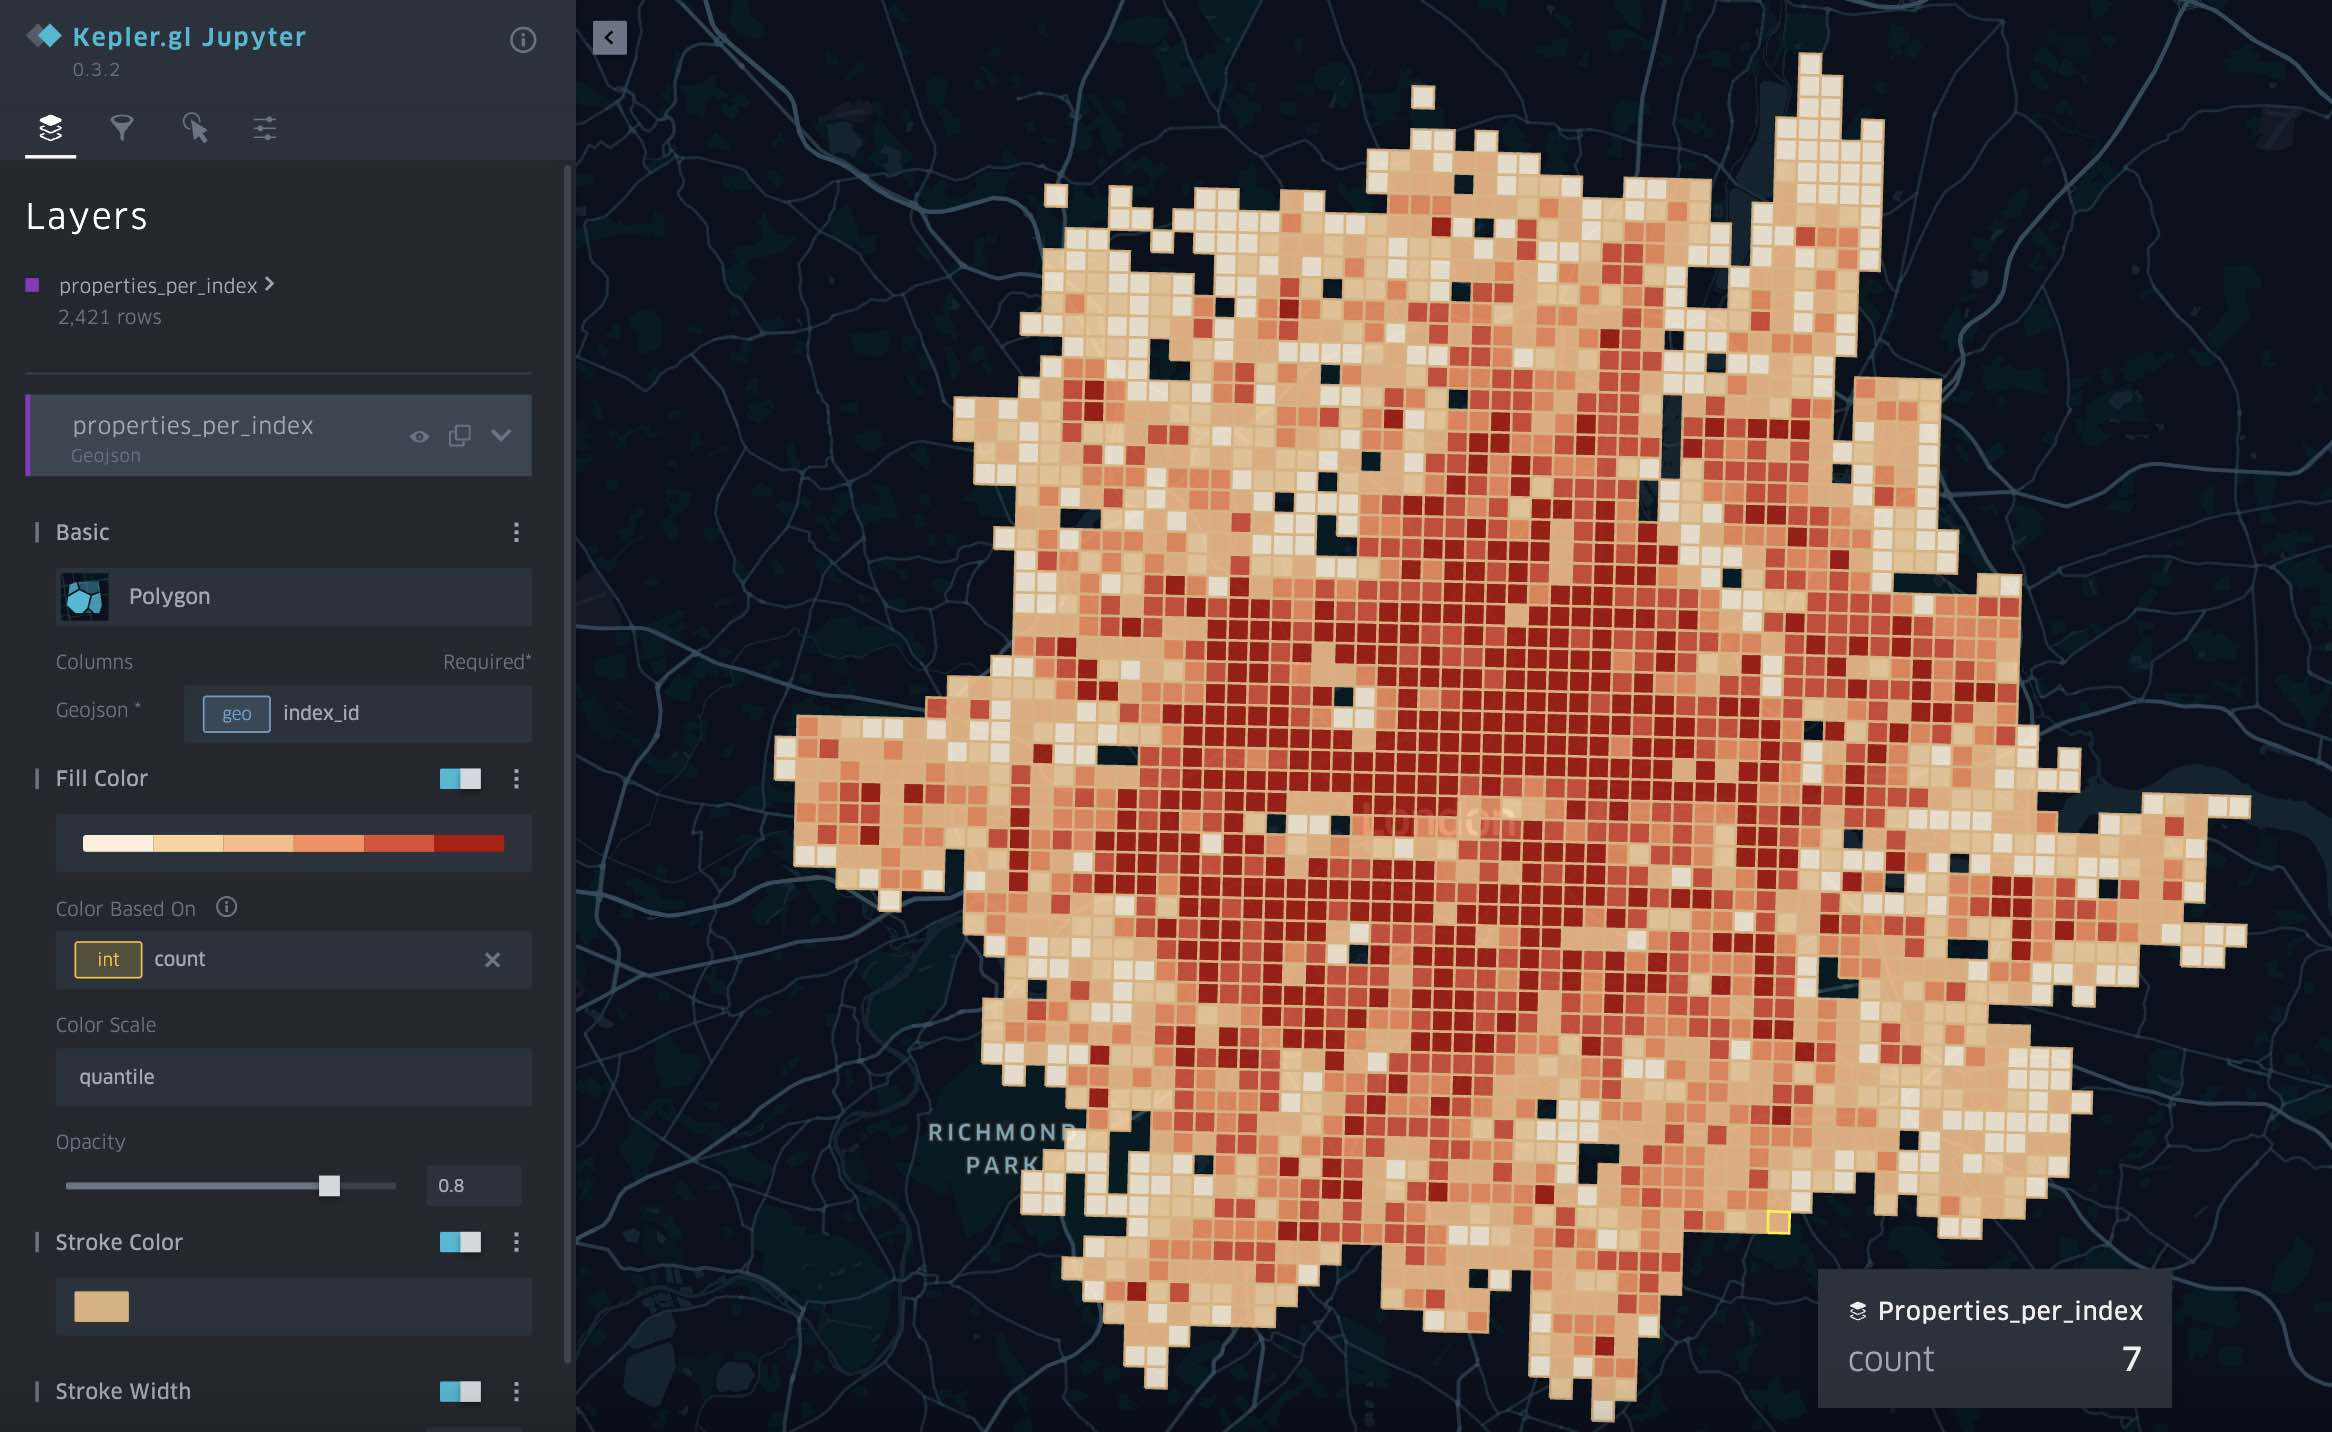

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACRygAwAEAAAAAQAABZikBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/qAXBBUk9UAAAAAABZ+gQAAC4LAABFFAAA9BkAAFkfAACaJAAAISoAAIwxAABSOQAAs0AAAN5HAADmTwAAvVgAAE1jAAA6bQAAO3UAAA99AACthwAA8ZEAAOuaAAB4owAAtKsAAA60AADrvQAA5scAAHjQAABl3AAA1ucAAHLxAAAM/AAAhQUBAHgPAQBwGQEAASQBAAQuAQD2OAEA10MBAOJQAQCtXAEAhGgBANVzAQAqgQEAG40BAA2aAQA+qQEAEbYBABPDAQBjzwEA4NwBAJTqAQDT9wEAJAQCABkTAgBBIgIA3S8CAKc9AgBPTAIAFVoCAPFmAgDdcwIAc4ACAAaNAgBcmAIAvqICAMCtAgDRuAIA1cICAALNAgBx1gIA5OACAB3sAgCg9gIApQADALILAwDbFgMAASADAP4oAwBFNAMAoDwDAMNEAwDCTAMAzlcDAOVhAwB3aAMAiG8DAFd2AwATfgMA6oQDAMaJAwD/wAARCAWYCRwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9sAQwALCwsLCwsTCwsTGxMTExskGxsbGyQtJCQkJCQtNy0tLS0tLTc3Nzc3Nzc3QkJCQkJCTU1NTU1WVlZWVlZWVlZW/9sAQwENDg4WFBYlFBQlWj0yPVpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa/90ABACS/9oADAMBAAIRAxEAPwDhqKKK0JCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAxqWkFLQAUUUUAFFFFABSqpZgo70lSw/6wUCCVhxGvQVFSt94/WkoAKKKKBksUzRHjkelXJIEmj86Hk9xWdU0E7Qtkcg9RTJaISMUAkHI7Vo3EKyp58POeorOoGjWvQJbdZh25/A1k1r2v760MR7ZH+FZBGDg0MSClWkpy0hsWkalpD0oJQ2iiigsKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJj88Oe61EBmpYTyUPRhTOhx6UyWMopxGabSGmFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpIk8yQJ61HWhZqERp27dKYmNvXG4RL0WqNOdi7Fj1NNoBBRRRSGFTJ80bJ3HIqGnI2xg1AhtFWbiILiRejVWoAKUdaSigCSikByKWggSilpKAFooooAKkY+XHt7tSRrlsnoKidt7E0xpDaKKKRYUUUUAFFFFABQDg5FFFAE0wyQ47ioamHzQkd1qGmJBRRRSGFFFFABRRRQAUUUUAFOR2Q5FNooET7Ul5XhvSoSCpwaSphIrjbL+dMCGipHjK8jketR0gCiiigYDrUlR0UEtXJKKjpyntQJoRutJQetFBSCiiigYU5ULDIptSRtg4PSgRGQRwaKcctyabQAUUUUDCiiigAoHWiigQ+ikB9aWgkKZT6YetA0FWbRd049uarVoWI5dz2pobILtt059uKrU523MW9TTaQDlpDRnApCc0CCiilVSzBRQMmYlIlUHGeaaJ5R3omYF8DoOKipgTGeQnJNJ50nrUVFILEvnSetOW5lX0NQUUwsWJQGPmj+Kq561YAIgB9TUBHegSAdDU+9cBXGQRmoB90/lTmBIB9qQx/kg/dYVJ9lfbkEVWwaXB6UxDzDJ6U3y3HY0mXHQmnCSQdCaBjTG4GSpAptXzcMsIbgsar743++uD6igLkIZlOVJB9qspezp1O761H5Sn7jD8aPIfsRQGhfTUEPEi4+nNSYsp+mAfyrM8nHVgKPLjHV6BWRffT1PKN+dRf2dJ2YVXBiT7rN+FSC7K9Cx+poDUd/Z83qv6/4VMljIuBkepqub2Ttn86b9sm9aNA1Ly2UaHJc1MvkKcqMkd8f41kGfccsoNK1wdu2MbfpTuKzL088p+VCEHr3rPKR93qEkk5NFIqxNsh/vUbYf7xqGigCby0YfuzkiocY4NAJByKnyswweG/nQBBRTmRl6im0gCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABTh0ptKtAmOpDjvS00nNBKEooooKCiiigYUUUUAFKrFTkUlFAjQid22JGSM5/TrV6WYRYUEE98nmobZVgt/Of6/5+tZjzyOxfoT6VRNrmwXhlX94MZ/z1qvLYhvnibk+vesoknk09JJIzlGIpXHYkeKWP76ke/ao6vxX5+7MMj1FPmtUmXzbcj6djQIyyc0lKyspKsMEUlIoKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAf//Q4aiiitCQoopVVnYKoyTQAlFbEMCxLg8k9at2WjCaXzpf9UOQO5/+tTUW9EROairs5wgjrRXd6hpkV5EAgCOgwp/ofauHlikhkMUo2svUVU4OJFKsprQZRRWkmnh9Oa/342nG3HuB1qUrmkpJbmbRWpY6YbuJ55H8qNP4sZzjr+VZjBdxCHIzxmhp7gpJtpCUVI0EyLvdGUepBApqo7nCAk9eOaQ7jaKk8mbZ5mxtvrg4/OprKBLm6jgckKxwcdaLCcklcq0Vbv4Etbt4IySq4xnr0zUCwTMu9UYr6gHFFugKSauR0UAEnA5JqQQzMxUIxI6jB4oHcjooqSOGWX/VIzY9ATQBHRT2ikQEspABwcjv6VoyWMSaXHegtvZsEcY6kentTSuS5JWMuiiikWFFaVxp4gsYrzfnzCBtx0yCeufas/y32eZtO31xxTaaJjJPVDaKcI3KlwpKjqccUBHK7gpIzjOO9IdxtFSPDLGAZEZQemQRSCORlLqpKjqQOKAuhlFKqs52oCT6DmrNraSXNwLfBXJ5OOn1oSuJtLVlWirN3avazNGQSqnAYjGaiSGWX/VozY9ATRboCkmrkdFBBBwRgin+VKSAEbLdODz9KB3GUUrKyMVcEEdQaSgAooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVcitQUE07eWh6ep+lP26cfl3OPegRQoq1cWrQgSKdyN0I/rVWgAooooGFFFFAGMKWnOhQ4plAjZh0W5miWUOgDgEA56H8Kk/sC5/vp+v+FdFZf8ecP/AFzX+VWqYHK/2Dcf30/X/Cm/2Bc/30/X/CupEkZcxhhuAyR3wafQBwN3aSWcvlSEEkZBHpUERxIK19e/4/E/65j+ZrGBwQfSgBZBhyPem1LMMSfWoqQBRRRQMKKKKAJ4J2hb1U9RVi4gV18+HkHkiqFWLe4MLYPKnqKYixp74kZD/EP5VBdpsnb0PP51PNFsIubfp1qxPELuESx/eA4/woF5mPTx0phBBwaAcUhtD6KKKCBCPSm0+mtQUmJRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKp2kH0qSYYbcOh5qKpj88Oe60xEYPrSHFJRSCwUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiilHWgQlFOPSm0AgooooGFFFFABRRRQAoBYgDqa0LoiKFYF79aiso90m89F/nUc7+bKW7dBTJZXxmnbaWikK4YFFFFABgUmBS0UASwvkGJuh6VAQVJB7UdDkVLKNwEg79aZRDRRRSGKpKnIqYue1QU5T2oJY6iiigkSiipI1ydx6DmgBXPlx7O561XpztvYtTaZaCiiikMKKKKACiiigAooooAlhPzbT0NRkYJHpSA4II7VLMPmDDoRTERUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAPSRk46j0p7IGG+P8RUNKrFDkUxCUVOVWUbk4buKgIxwaQBRRRQMKKKKACiiigAooooAKKKKAAHFPplKDigloCMUlKfWkoGgooooGFFFLg0CEp4OabtNGCOlAmOphpwb1ptAJBWjF+7smb+9n/Cs6tG5/d26Rf54pjZnUUUDrSAU0lK1JQCCp1/dR7v4m6UyJNzc9B1pJH3tnt2pgMooopDCiiigAoopQuQT6UCJ24iUfjUVTS4AVR2FRhaZIwghPqaeegHtSOcnaO1K/3qQ2NooooJCiiigCST/VLUFWD80P8Aumq9MtBRRRSGFFFFABRRRQAUU4dKMCgm42iiigoKKKKACiiigAooooAkEzjvn607zEb76/lUNFMVibMHoaUCAnHNQVOAIV3H7x6UAOngWNQyn86rVPKTsTP1qCgEFFFFIYUUUUAFFGKKBBRRRQMKBxRRQIKKKKACiiigYUUUUAFFFFABUsEfmyqnqefpUVadggVWnbp0/wAaYmJqEvIhXoOTWbT5HMjlz3NMoBBRRRSGFSRTSQtuQ4qOigRrAwXy4PyuP8/iKzpoXhba4+h7GowSpyDgitOG5jnXybjGT39f/r0xbGXRVy4tGhyycr/KqdAwooopDCiiigAooooAKKKKACiiigD/0eGooorQkK0LNo8FejfzrPoBIOR1oEdFEUEgMgyueQK6qNkdA0f3e2K4aG6Vl/eHBH61LaavJbz5IzEeq/1+tawnbc5sRRc1dHb1y2vy2jFYwMzDuOw9DVrUdZjiiCWjBncZz/dB/rXIEliWY5J5JNVUmtkZYei787ErqrBYH0V1uWKRljkjtyPrXK1tRXduujPalv3jHIGD6jv0rODtc6K0W0ku5oaxugsIobUfuD1I79x+fWqGgwpJeF3Gdi5H1zUmn6hbm0exvzhMfKcE/hx6dRVKwu00+8L53xnKkjuPUA1TaupGajJQlDr+Z00DXbSOt68LRMD8oPT9KyNEQR6nKinIVWA/BhSPFoLuZfOcAnO0A/4U3w/j7c+Onln+Yqr6ojltCT/SxcstVuJ9Q+zSBfLYsAAOmAf8KoQxLDrgjTgCQ4FXYpNGtLhrtZGLjOEIPBPXHH9ayLe7U6mLuY7QXLHvjNS3tdlRj8TirKxZu4lm1wxP0Z1B+mBXQTG+S5UQPEsK4G0nBx37ce1cteXSnUmu7c7gGVlP0ArUnk0bUGFxNI0T45AH/wBY009xTg7RutLEF5HEmtRGLGGdG49c81d1XU5LSc29uqjcMuSOSSMfyrD3WkOoRvbsTCjqcnrxjNO1W4iubxpYG3KQBnBH86XNo7FqneUb9jOrsLcXTaVD/ZpCvn5s4989feuenSwFnE0DEzH74PT3/Wuh3BNNthJAbkFf4R0ogrXCs7padSnr1wdkNsXBYDMgHTPGP60yb/kX4f8Af/q1JqVparZJdxRGB2bG0/j2qvLd27aPHahv3itkjB9T36d6beruTBe7Hl7mPRRWtZw6VJCDdyMkgJyB0I/I1klc6pS5Vcvah/yBLb6r/wCgmmD/AJF4/wC9/wCzVDqt/bzxx2tp/q4+/wBBgYzT7C8s2smsL0lVJyGH5+/etbq9jl5WoJ263HWn/IBuP9//AOJqfS5mt9InmQAlXJGfoKguruwt7BrGxYvvOST/APqHpU+leSdInFxkRlzuI64wKFvZdhS+FtrdklldSanZ3EV0ASoyDjHUHH5YqloVwolezl5SYHj3/wDripTdadYWksVk5keUYyR0/QdKwrcT+aGt1LOh3DaM9KTlZoqMLqWlkb2l2/2O4uZpuluCPr3z+Q/Wq2kXMzal14mLFx68E/zrT1qcR2YQDY9wQWHfgDP9BXOWFwtreRzv91Sc/QjFDfK0ginOMpPqWtWu7iW5kt5GyiOdowOK6OaK6t4YobBo4wo+bd3/AE/Oud1T7DJJ9otZC7OcsMHj8xV03Wm6jbxpfM0ckYxkd/0NNPV6kyjeMbLT0Ga6qEQzfL5hBD7TxkYq/d3rWNjbvEoMjoACewAGa569SxQqtk7P13Fv/wBQq1qV3b3FtbRwtuaNcMMEY4HrS5t2V7O6insZc0rzytNJ95jk4qOiisjqSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTW8YlnSM9Ceahqa3kEUyyHoDz9KBD7yUyTt6KdoHsKdKP8ARYz5e3n7/rSXkJinJ/hc5B+tTTSxtYxxg5YHkfnQAWD72a2flXB496zyMEg9q0LFfL3XT/dQHHuazyckk96ACiiigYUUUUAZqHzE2HqOlQkEcGgEg5FWWQSp5ife7imI7Wy/484f+ua/yqvql3NZ2plhXc3TPZfc1Zs/+POH/rmv8qsEBgVYZB4INAGZplpDDELhW82SUZaT1z2FalZ1pp4s5pGic+U/SPsD61o0IDkde/4/E/65j+ZrHQbnArY17/j8T/rmP5msuHglz2FADZTlz+VR0UUgCiiigYUUUAZ4FABRU627EbnO0U7FsOCSaYri21wYjtblT+laMaGJi8Z/dtyR6fSs3bbHuRV+CaBY/L3DA9aaJY+eBJkLxgEkZBHesQgg4PWtqSVoMNGAY++O1Nmgjuk82E/N/P60MEzIzS5pGVlJVhgikqSrD8imk0lFAWCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNCeSh6MKhpVO0g+lAhCMHB7UVPKo3bh3qCgEwooooGFFFFABRRRQAUUUUAFFFFABRRRQIKKKKBhRRRQA7PrTaKKBBRRRQMKKKKACiirlnFvfe3Rf50xE5/0W22/xNWfUlzL5shI6DgVADigVh9FMyaMmkFh9FJuozQKwtITRknpSgcYoAZU0RBBjPeosHOKcvynNBTYwgg4NFTTj58juKhoAKKKBQA8HNO2nGaZin5OMUEsSpJDsQIOp5NEYGdx6CoGYsxY0wQlFFFIsKKKKACiigdaBC4NJTz0plAIKKKKBhU33ofdTUNSwkZKHowpiIqKUgqcHtSUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAACQcip/lmHo386goBIORQICCDg0VPxMuf4h+tQUAFFFFAwooooAKKKKACilwaMGgVxKMGn0UCuMooooGFFFFAwp9Mpw6UEsWjIoplAkhxwaaQRRTh0oHsOiTfIq+pqzfNmUL6D+dLZrmXd/dFVp23ys3vTBakVA4oopDCiilUbmAoAnfCRBF6nk1XqSY5kPtxUdMEFFFFIYUUUoGaBCVJGcnZ600gYp8AzIPagB8p/eHPao2YjgcetGd0hPbJqOmJIeo5H1pT1NNWnHrSExKKeq55zTT7UAJRRS9eKBEnSE+5qvU8xwBGO1QUy0FFFFIYUUUUAFFFFADxRRQTiggQ9KbT+tFA7jKKDxRQMKKKKBhRRRQAUUVMihB5j/AICgQqgRrvbr2FQsxY5NKzFzk02mBO3zxBu68GoKlhPzbT0ao2GCR6UAJRRRSGFFFFAh1JijNFAgxRilooATFJTqbQNCjnil202nA5oExuMUUE5ooGFFFFAwooooAACTgVq3JFvarCOp4/xqvYxeZLvPRefxpl3L5sxx0XgUyepVooopFBRRRQAUUUUAFFFFAGhbXhT93Nyvr6VJPZq48yDvzjsfpWWBmrEU8sH3Tkeh6UyfQrkEHB4IorWEtrdjbINrf571WmsZI+U+YfrRYdylRRRSGFFFFABRRRQAUUUUAf/S4aiiitCQooooAKKKKACiiigAoop6RySfcUtj0GaAGUUEEHB4NKqs52oCT6CgBKmguJrZ98DFWIxkelRMjIcOCD70lAmr7gSWJY9TRT2ilQbnUgepGKZQAUUUUDCiiigAq3Bf3lsuyGQqvp1H61UooTtsS0noyee6uLkhp3L46Z7VBRRQNJLRBRRRQMKKKKACpkuZ0ha3RiEbkj1qGigTV9wqa3uZ7V/MgbaxGM8Hj8ahooBq+jJZp5rh/MmYs3qaioooBK2wUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAuQ3ZRPJlUSJ6HqKf5mnj5hGxPoTx/OqFFAizPdPMAmAqDoo6VWoooAKKKKBhRRRQBjCpI3MbZ7d6jFLQI7iC9tFt4w0qjCgcn0FS/b7L/nsn5iuIUeZGV7r0qDFMDvvt9l/z2T8xR9vsv+eyfmK4HFGKLga2szRT3atCwYBAMj1yaoLxCx96gq0/yQKnduaAK1FFFIYUUUUAKBkVZjCxR+a3JPSoUXcQvrUtyfmCDoopkkLyNIctTKKKQwooooGXLa42fu5OVP6VK6vat5sPKHqKzqu21xt/dScqaZLLjLDex7l4YfmKypIniba4watyQyQP50Gce1WkkhvU2OMN/nkUBsY1FTz27wNg8g9DUFIYUUUUDCiiigAooooAKXHFJTh0oExtFOI4ptAJhRRRigAooooGFFFFAFgfND7rUJxUkJ5KHowqEjBwe1MmwUUUUigooooAKKKKACiiigApQKSigQ+mUUUAkFFFFAwooooAKKKKACiiigAooooAUAsQo6mtGYi3gEK9W6/1plnGBmd+i9KqTSGWQufw+lMRHRRRSGFFFFABRRRQA8U/ecdKiBxTqCGFFFGcUASSfNErenFQVYiYHMZ6GomXBwe1MaYwc0uDTgMUUguFL7UlPjAJLnotAh0p2IIx9TVelZixLHvSUFIKKKKBhRRRQAUUUUAOJ4ptFFAgooooGFAODkUYNGDQImlG5RIO/WoamiIOYz0NREFSQe1MBKKKKQwooooAKKKKACiiigAooooAKKKKACiiigBQSpyKmIEo3L97uKgpQSpyKBCdKKsfLMPRv51XIIODQAUUUUDCiiigQ7IpaZRk0CsPoPSmUUBYKKKUDvQMCMCkpWpKAQUoNJRQApNJRRQAUZNFFAGla/JA8p/zis7HpWjL+6s1T+9j/Gs0Z602JBRT6ZSGmFTQj5ix6AVDU7fu4wvdutMCE5Jz60AUbqMmkGouBSbadRQTcZ0pQcUHrSUFByeKnP7pNo+8etJCPm3HoKY3JLGmIB0/P+VMpw5GPTmkA5pDFPAxSucHA7Ug5cUjfeP1oFYtWUDXl1Haq20yHGfSuvPgi9xlZgf+An/Gud8P/wDIYt/94/yNe8x/6tfoKxqSalZM1jFWu0eTf8ITf/8APVfyNVLnwveWED3U8ibYwTgZz/KvZ65jxaQujzZ/u4/M1HPLuVyR7HibEsST3pKKK6TEKKKKBhRRRQAUUUUAKKU4xTc8YooFYeKDxTKM5oFYKKKKCgooooAKKKljQH52+6KBCxoAPMfoP1qN3LnJpZHLn2HQUymAUUUUhj4/9YPrRJ98/WmqcMD70+YYkPvTER0UUUhigU6kBGKWghjCMUCn03HOKBpi0UY9KSgBaQ0UlAIKKKKCgooooAKKKKACiirdlF5ku49F5/woEXD/AKJaY/ib+Z/wrIq5ey+ZLtHRePx71TpsEFFFFIYUUUUAFFFFAAKdgUYFLQS2FIRS0UCGEYq1DdyxcfeX0NVyCabg0FGxm1vBzw35H/69U5rKWPlfmHt1qng1ehvZI+JPmH60xehRorXkhhvE8yI4b/PWsp0aNijjBFA0xtFFFIYUUUUAf//T4aiiitCQooooAKKKKACiiigAqzKzLDEqnAwW/HJ/wqtU6yoUEcqltvQg469uhoELcnJRz1ZAT/KokZh8oYqD1p7yiSQMy/KMAKD2HvTEaMZ8xdwPocEUAWJ8eSgVt4BPze/HGKqqxUhlOCO9SySqyCONdqg565JNMDRhw23KjGRnr+NAFhC6wvJIThxtAPc+v4VUqzLNFLklCDjA+bgfhiq1ABRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAxhS0gpaAHxtscGllXa/HQ81HU/wDrIvdaYiCiiikMfGu9wtPnbdIfQcU+D5VaU9hgVW680xBRRRSGFFFFAFu1Xcxb0qvKd0jH3qzGfLty/c9Kp0yUFFFFIoKKAM0pAFAhKKKKBmja3gRfLl6djVaaNon8xOmcgjtVerUMoI8qToelMRdguUnXyp8ZP5GqlzaND86cp/KoZojE3sehq5bXnHlz9Ox/xoF6GbRWlc2WP3kPI7j/AArNoGmFFFFIYUUUUAFFFFAgoooHNACgU6kJxTaBbhRRRQMKKKKBiqdpB9KkmHzbh0PNRVMfnh91piIaKKKQwooxmlxQK4lFFFAwooooAUY70EYpKcOlBLG0UpFJQMKKUCgigLiUUUUDCiiigAooooAKciGRwi9TTa0bVVija4f8KYmF04jjFun41nU53LuXbqabQCCiiikMKKKKACiiigAp46UynLQSxaCM0UUCADByKmkGQJB3qGpozuBjPfpTAhopSMHBpKQgqSTCxqg78mo6knJO3PpTGiCiiikWFFFFABRRRQAUUUUAFFFFAAOadgUDpS0EthRRRQSIeORUkvzBZB360wjtT1+aIr/d5plIhpegpBQTmkMKKKKBhRjtRT6BMYRiilOTSYxQAUUUUDCiiigAooooAKKKKAAEg5FTgrMMNw3Y1BR0oEKQVODSVO/7xN46jrUFABRRRQMKKKKACiiigAoyRRRQICc0UUUAFFFFAwooooAKdGu91X1OKbVqyXdNn+6M0xEt83zKnoM1Qziprht8zH3x+VQ0AgooopASRLubJ6Dmmu29iakPyRAd2qGmAUUUUhi7jRupKKBWA80AEnApVUscCpyVh+VeW9aAAjy49p6mojTST1PU0v8ADn8KBWGg4ORTieMim0oODQMVPvCmnkk1IAAQ69KYRg4oA2vDYDa1bg+rf+gmvd0+4PoK8M8MLnWoD6bv/QSK9rWOfAIf9K5qr943gvdLVcp4wP8AxJ5voP5iui2XP98fl/8AWrO1CwGoxmyu/mV8dOOhz2+lZuW2hSR4LRXrf/CD6b/tf99VH/wglh/ek/76H+FdHtV2MuRnlFFdB4h0m30i5SCBmbcpJ3EHv7AVz9aRd1dENWdgooopgFFFFABRRRQAUUUUAFFFFABRRQAScCgCSNN3J4UdaJH3cDhRTpTtAjHbrUNMQUUUUhhRRRQAVNLyqv6ioamHzQf7ppiIaKKB1pAGDRT6YRigSY8HNA9aZSgkUBYdTSKXdSZNAISinYGM02gYUUUUDCiiigAooooAK11/0S0yfvH+Z/wqtYwb38xvur0+tMvJ/Nk2r91elMl66FSiiikUFFFFABRRRQAUUUUAOFLTKKCbD6KZRQFh9FNyaM+tArDqRulLkUh6UAhY5Hibchwa1WCX0O5eHFY9SwytC+9fxHrTKaI2UqSrDBFJWtPEt1GJ4fvfz9vrWTQCYUUUUhn/1OGooorQkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDJwKbjFPooIuMqSJtrc9D1ppFNoKJHiZTkcj2pPKk9KWOV4z8v5VZim3OAByaYDJf3cSx9zyaq1fkaKZih4I6VTkQxttNDEhlFFFIoKMcUDmn9BQJsnl/1CCq201Yk/490+tQA0xCbTS7aWikK4U1qdRQFxlFOK+lNoKuFFLikoAtwyh18mXoehqGWIxNg9OxqKrkUiyr5Mv4GmAttdmL5H5X+VWri1WcebDjJ/I1lyRtG20/galt7l4D6r3FArdUQEFTg8EUla08KXUfnQ/e/n/9esmgaYUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFTQnkoejCoaVTtIPpQIQjBwe1A61LMPm3DoeajHWgB1FFFBI1qSlPWkoKQUDrRRQA880wcGlyaSgEhxNNoooAUZpTTaKAsFFPWN26CpkgTP7xgKYXK1FWGhQHCuDTTC3UYNAXIaKdsfOMGhkZfvDGaQCAFiAOprQuyI4khH+cVWtRunX25p14SZz7cUxdSrRS4NJSGFFFFAwooooAKKKKAClHWkoFAh9B4oooJEzQGIOR2ptFBVixIAcSDoaiqSI7lMZ+oqInFMmwtSzDlR6CmQjLCiRssTQBEaKMZpeRSKFwKbTs8U2gEFFFFAwooooAMUuKM0tBID0paaetGTQFh1PUgcnrUa5JxTqBCU+I4kx60ykBw4PvQCBhtO30ptSzKfMJ9ajwaCkxKKXBo2mgLiDrT6QDFNoFub2l6Jc6rG0luVwhwd2R/IGtBvCOp9Pk/M/4Vv+Av9RL/ANdD/wCgivR653OV2kbKEbI8Sbwlq4PyhD+P/wBasfUNMutMdY7oAFhkYOa+ha8e8bknUox22f1NOM5OVmDirXRxlFFFbmYUUUUAFFFFABRRRQA+N9jc9D1okTY3HQ9KZU6fvE8s9R0piIKKOnBopDCiiigAooooAKKKKACiiigAooooAKKKKACtGzGyJ5T/AJxWdWi/7qyA7t/WmhMzicnJooopDCgDJx60VLAu6T6c0CFmPzBR2FQ0rHcxPrSUAFFFFAwooooAnUlISR/EagqecFAqegqCmJBTv4PxptL/AAn60gLARQMYzSGNT2p9FMkj8sqcqaa4yPcVNTW60DNnwqudZjPoGP6V7iOgrxLwkudXB9EY/wAhXtgZMdRXLP4jePwjqrN/x9L/ALv+NT7l9RVckG6HstRItFqiiiqJPHPG3/ITT/c/qa46ut8Z/wDIWX/rkP8A0Jq5KtqXwozn8TCiiitCRwFBApAcUpIoJG0UUUFBRRRQAUUUUAFTRAKDIe3SoQCTgd6mlIAEY7UxEJJJyaKKKQwooooAKKKKACpoedyeoqGnxHEgoExlFOkGHIptADgc0uM0ylyaBWEooooGFFFFAxQcCkoooEFFFFAwooooAKfGjSOEXqaZWtaRCGI3EnGR+n/16Ymxbl1toBDH1Ix/iayKkmlaWQu3eo6ASCiiikMKKKKACiiigAooooAKKKKACiiigApyAM2DTaKBEjqq9OtR0UUAFFFFAyxbXDQPnqp6irV3bh1+0Q8g8nH86zauWlz5TbH+4f0pkvuU6K07mzB/eQfkP6VmUDTP/9XhqKSitCRaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigBaKSigDLFFRilyaCbD6OtMyasJGPvSnaKAsRpEznA/OrLBbZfl5Y96iefjbHwKeD50J/vLTAqE5OTVydS4BXqKrxKGcA0NI28sOKBkdFThll+V+D61EylDg0ANp2cikAqwkaqPNk6dhSExZBtgVT1qsOtOkkMjbj+FNHWmMdRRRSIEJpAcUh60UF2FyaBinDpQABQTcKQjvQSQaQnNA0hKKKKCi7G6zr5UnXsaqyRtG21qZ05FXUZbhPLf7w6GmISzn8qTYfutx+NJexeXLkdG5/xqs6tG209RWre/vLZZB7H86BdTIooopFBRRRQAUYJ6VIFHenUAQ4I4pxXipdpPal2mgRAVIGaMGpaZQDGUUGigAoooxigCb78PutQ1NCeSh6MKhIwcHtTAfRTKf1pEtDKKUjFJQUFFFFAwooooAKKKKACrJnTaAqDOOtVqKBD2ldupplFFABQCRyKKKBlmO5ZeG5FPdA8O9TnHNU6ngfa+09DTJsTWIzKT6CoZjukY+5q9bJ5RkPas48nNAnuNBzSEUdDS9RSGNp2KbTgaAYhGKSnHpTaBoKKKKBhRRRQAZooooEFFFFAxVJUgjtUsq87x0NQ1LG4HyN900xDojtRn9Ki4PNTSr5cYT15quOKBD+lFFFIQ3BpKfSN0oGmNooooKDBowafRQTcZRRRQUFFFFAEsYwC5ptBf5duKaDiglod0plKTmkoGkTynhW9RUYOakPzQD2NQjIpiHUUUUiQplPplBSPUfAQH2SRu/mkf+OivQ68d8NeIbfR4HhnRjltwI56gDGOPSupXxxp56hh/wGuaSd3obpqy1O5rxvxqwOqIvpHn9TXXDxvppOCWH1U1wXiO/ttSv1uLYkqIwp4I5yT3+tOCfMtBSatuc9RSkYpK6DIKKKKBhRRRQAUUUUAFKCVOR2pKKAJpQDhx/FUNTfeg/wB01DTEgooopDCiiigAooooAKKKKACiiigQoGaMU6igm43BrQveERRVRBl1HvVu9PzKPamFzOopT1pKRQVNFwrt7VDUw4gPuaYMhooopDCiiigApVGSBSUA4INAixc/6z8Kr1ZuR8wb1FVqYIKcPumm05eh+lICzRRRTJCo3PB/KpKgfkD35oGjpfB4J1f6RnP5ivZDbQ+n615B4LBOrN/1yP8A6EtezVy1EnJ3OiLtEr/ZofT9ah8lPP8AL7YzV6qw5uj7LWUorQpNh9li96Pssfq1WaQ9KrlXYXMzxXxeSdWA9I1H6muWrpfFhJ1hgeyLXNV00/hRlP4mFFGM07FWRcbRRRQAUUUUDCiiigAoopQCxwO9AEsQCgyHt0qEkk5NTSkDEY6CoaYgooopDCiiigAooooAKcn3x9abT4hmQUCFl/1hqOnyf6w59aZQAUUUUDClAzSU+gTYwjFFP60ygEwooooGFFFFABRRQASQB1NAFm1g86Tn7o5NWL+bJ8heg61Y+Wytv9o/zrGJJOT1NMncKKKKRQUUUUAFFFFABRShS3AGak8iSgRFRUvkSUvkkffIFMLkNFTfuV9Wo8xOyCgCGipvNX+4KPO9FFAENFTiZicYFSeY2OgNAFSire8d1FJujPVBQBVoq0FiP8NNKw+4oAr0VMYSeUINRFSvBGKQFm3ungODyvp/hWj5NrcfveuffFYlPWN2GRTuJo//1uGooorQkKKKKACuz07wRql3tkuyLaM/3uXx/uj+pFcau7cNvXtivTYPE2r6OscevRpIG4+V185R6soPP449zSYFm58AWDQYtJpElHd8Mp+oAH864PVPD2qaQPMukBjzjehyuf5j8RXo9x460aKINAJJnOflC7cfUn+ma4/X9T1zU7NZ5lQWbEHERDBTyBvIyQfyH40lcZxtFFFUIKKKKACnIjOwReSTgU2lVirBlOCOlAF14La3OyZmZ/ReAPxNRZsz1Vx9CDWpGttqCb3GHHBx1pw0y2Bydx+poEZU1tsjE8bboz36EfWqtXry4RgIIOI09O5qjQAUUUUDCiiigBVUuwVepOBVx5RA3lWwGRwWIySfxqrE/lyLJ/dINTyoYbgSDlSdynse9Ah6OLo+VKBvP3WAxz71SroZrJHYSw4RxyPQ1hzRSxORKME80ARUUUUDCiiigApyIzttQEn0FNpRnPy9fagCb7Lc/wDPNvyqePT55ELH5fQHqajFtdGPzcHH6/lRHNdxKVTcAfagRDJFJFjzFK56ZqOnMHH3wfxptAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDGFSJGz9OnrTw0I7E015GfjoPSgQ/ckfCcn1qFmLHLGkooAKfG+xs/nTKKAJXBjfcvTqKWRQw81e/WnIDKmwdV5FLEuzJl4U9jTEVqmVw42SfgaZImxuOh6UsSbmyegoGSLbyZxjj1q1LEsgCg4I7VSaZyThiBTAxDB880CsIQVJU9RSVZuRhg3qKrUDDJpwNNopBYKKKKAAHFPyMUyigGg60UUUAFFFFAwoBIOR1oooAvArcptbhxVraWsSjdVB/SsgEqcjgitm1lE8bKevf8aaJZi0UrKVYq3UUgpDHBcjNPCgU0cDFOC7uc0CuOBA607cO1NEY707avpTC4m40m40jDb0NR7jSGKWNNB5pKcBQDGnmilI70lAIUUp6U2pkAIyaBMiU7SD6VJMPm3DoeajOMnFTD95FjutMZBSg9qSikA+m4NOooJuMooooLCiiigAooooAKKKKACinACkPWgVxKKKKBhUsJVWBaoqUEUCZsLgwMynINZLkBiF6VoP8AJZqB3xWaR6U2ShKcBigDFLmkNsQim0+mEYoBBk0UUUDCiiigYUUUUAFFO2P1waXy39DQIZRT/Kk9KXypPSgCOipPJk9KXyZPSgLiycxofbFQ1cWFnTYeCOlVnjaM7WpghAaWmDrTycUiWhD0ptKTSUFIKKKKBhkil3UlFArBRRS4oASinYFNoAKKKKBhRRRQBPFyjL+NQ55p0bbHBp0iBXPpTJG0UmR2ptIVhxFNxRRQUPHSimrTqCWFFFFAhrUlOam0FoKKACeBzUohbq3AoAioAJ4AzU37lP8AaNIZm6KAopgAhbqxCil2wjqxqIknknNJQBN+49zS7Ym4Hyn3qIDFIfWgRYRGUsjdCKrVLHMyH1HpTjLGTkoKBkFFTb4e60Zg9DQBDRU/lrIMxdR2qCkAUUUUDCiiigApVpKBQJj6KKCcUEk0AzMoqS9J80D2qO1OZ1pb05m/CmCWpVzmiiikUFTuMRKPxqCp5j90jpjimDIMGgdaeDmikK4jdKbT8Zph60AgooooKLUnzQK3pxVWrQY/Zce9VaYkFPX7pNMp4PyEe9ICxUsMfnTJDnG9gufTJxUVXNPAN/bg9DKn/oQoewludSPBd0y5WYc/7J/xqFvBN9niVce6mvVLf/Ur9KmrlU5W3N3GPY880Hw/daReNPOysrLtGM56g13X2pe6tRcdU/3qs1Grb1L0SWhW+1R9wfyqFZ0E5k5wRir9Vk/4+X+gpNPTUaa1F+1Re9BuYsdf0qfA9KayrtJwOlVqToeIeKjnWZB6Kv8ALNc6Oa3/ABO2damHptH/AI6KwgMV00/hRjN6ss21pcXbmK2QuwGSB6VbbRtUXj7O/wCAzW34MXOqOf8ApmR+bCvX/Ki/uiolUadkOME1dnz82lampwbaX8EJ/pUEtpd243TwvGPVlI/nX0P5ER/hFcB47VUsowox+9H/AKC1JVHdJlOCtoeX0UUVuZhRRRQAVZtiqbpG7Cq1Tfdg/wB40xMiYliWPekoopDCiiigAooooAKKKKACrC/uV3n7x6UiqIxvk69hUTMXOTTESedn/WDNDRgjdHyPSoacrlDkUALwKZxVggSjKcHuKrkEHBpCQYoyaUHFBHpQMQHFFFAoAKKKKBhRRRQAVpWEH/Ldug6f41ShiM0gQfj9K0byUQxCCPgkfkKaJfYpXU/nScfdHAqtRRSGFFFFAwooooAKekZfnoB3pqgscCpZCFHlr0HWmIGkCjbHwPWoiSeSaSikAZNFFFABRRRQMKUDNIOtPoJbEUHNTBiKjFOoGh++lBB7UwDNPPyimAEgcGq7NngU9uhqKkAAkcipRM3RvmFRUUAWkWCQ8/LTZJdrbY/uiq9FMLH/1+GooorQkKKKKAFXduG3r2xXZ31zPBsXxJFBcuw2kKwFwgHQll4/A/41xdb41+WeIQatEt6ijCs/yyL9HHP55pASA+GLZjOgnuu6xOAgH+8wPOPYVNqf9pT6WlxF5AscjKW2AEbsHHDbvrmoGuPDUAMtvbzTu3SOZgqJ+KHLfpxVK+1m9v4xbttigXpFENqD8O/40AZVFFFMAooooAKKKKAJYJngkDp+I9RWxqFwyRKsZxv7+1YVWrm5FwsYxgqMGgRVooooGFFFFABRRRQAU8SyBDGGO09R2plFAHVwNvhRvVR/KqOoz7E8opkN3PT/APXWWbuUwrCp2hfTqavvcwXFmfOOHHbvn1piMeiiikMKKKKAClVmQ7kJB9RSU5HZG3L1HqM/zoAti/uBEYs5/wBo9fzpha9Efmln2+uTSfa5/Uf98r/hVk6lIYfLCjd0z/8AWoEUHkkkx5jFsdMnNMqSSaSXG8jj0AH8qjoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYwpaQUtABRSqpY4FPeJk56igRHRQAScCp9qRcty3pQA+HEIMj9T0FLMUmXenUdarMxc5NCOUbNMLD1lIG1gCKR5Nw2rwKJUAO5ehqOgAoAJOB3oq2iiFDIRlqAG3JGVX0FVqVmLHceppKACiiikMKMHGaUCnUEtjKKcRTaB3CiiigYUUUUAFGOM0AZp/HSgTYyr1g4WYqf4h+tUaUEqQw4Ipgal1AHY44bqKyiCDg9RWxIxntxPH95f8kVUZVuU3rwwoYkVAc1LH3qDkHFSxnmkDRNRRRTENZdwquQRVqmOoxmgZXp46U00o6UgYtNIxTqKBJjKcHwu0CmkYooKCnxtsYGmUUASSrtbjoelR1OP3ke3utQUwHDpRkU2ikKwUUUUDCiiigYUUUUAFFFFACg4FITmiigQUUoI6UuBQFxtFFPiG6RR7igDQu/liRKz6u3p+dV9BVKmyBpJoWlamjg0iug+gjNFFAhhGKKU9aSgoKKUAngDNSCFurEKKAIgCTgVY+SEYIyx/Sk3JGPk5PrUBJJyaYEhmkPek8yT1plFIB3mP6mje/qfzptFAC7m9TRuPrSUUAGT61OsoYbJeR2PpUFFAD3Qxn29aZUqSDGx+RTXjKH1B6GmAyiiikMKKKKACiinKjN90ZoENpwPFSeUF5kbFBiDDdGc+1MCMkYptFFIAooooGFFFFABU7fPEG7rUFSwthtp6NxTERUUrLtYr6UlIAooooGet+DoY5tIRZBkZb/0Kuq/s20/uD9K57wX/AMgeL/gX/oZrsK42k2ze+iM19KsT8xjBI9QP8Kgj0qxmj3PEnP8Asitd/un6VFbD9yPxpWVx30M7+wtNP/LFP++RVO90TS4YWlFvEWA7ovp9K6Ss7VW22UjegJ/Sm1oCep4EZm6KAoqIknknNJRXYcx6J4X0TT9S08SXMQZwzc8j+VdIfB2jkY8kfm3+NVfA640sH1LH9cV21crvd6m/RHHHwXo5GBHj/gTf415xr9lbafqJtrUEKFB5JPJz617uehrxDxWQdZfHZVqqbfNa4p/Cc9RRRXQc4wjFFOOabQUgoAzRThQDJIjscEVJI5U5Kgj1qDPNPVyvHUelMkPNX+4KtFl8vKqOmaq+aB0UVJJIzQrjjtQMYLhhwAKTzVP3kFQ0UDsTfuW9Vo8luqEGoacpx0oBincv3himk5qbzWA55HvSgwP97KmgQ6zH78fSm3ZzO1WrWHbLuBDDFVLkHzmOKA6kFFFFIoKmHzw47rUNTQEb8HoRTEyGnA+tNIwcUUgFJ9KdTKMmgVgNFFHWgZO5xCi/jUFTT/eC+gqGmCCpAPmVfSmLjOTUsYJJf1pAyWr2mDdqNuP+min8jVHNaGkc6nbgc/OKUtmKO6PdIP8AVL9Klqokc2wFXwMU7y7ns4/KuNPTY6mvMJ/vx/71WaoSCYOgZgTnipsXQ7qaSer0G1oizVaP/j4k/Cj/AEr/AGahjM/mPtAJ70OWwJbl+mP9xvoah3XX90f5/Gmu9xsO5BjHrTchKJ4n4iIbWrg+6/oorFr1C+8If2hcveCVlMmDjAPbFUv+EEf/AJ7n/vn/AOvW8asUkjGVOTbM7wUudRkP+xj8zXr9cRo3h5tFuDNvMm8AYIx3+tdd58n/ADzNZSmnJs0jFqKRZrznx6T5EQ/6aD/0E13vnv8A882rzzx05aGE9MuePoKItOSG1ZM83ooorrMAooooAKml4VU9BUaDLAe9OmOZD7UxEdFFFIYUUUUAFFFFABU4URDc/XsKFAjXe3JPQVCzFjk0xAzFjk0lFFIAooooGAJByKnOJlz/ABCoKcjFG3CmIbRnFSyqAd69DUVIBcjvRx0pKKAsLg0lH0oyaACig1fs7cMfPk4VelMLliFVtIDLJ94/5ArLkdpHLt1NTXU5nfj7o6VWoBBRRRSGFFFPWN26CgQwDJwKm8tE/wBYfwFKFjjOWbJHYVCx3MW9aYEvmheIxioaKKQBRRRQMKKKKACiiigApVpKM0CY8EDin01RgVKo70AKBgUwnJpzHtTKYDW6VHUj9KjpDCiiigAooooA/9DhqKKK0JCiiu2s9J8Jy2kUl1fvHKyAuoZeGI5H3aQHE0V3/wDYvgz/AKCL/wDfS/8AxNH9i+DP+gi//fS//E0XCxwFFd//AGL4M/6CL/8AfS//ABNH9i+DP+gi/wD30v8A8TRcLHAUV3/9i+DP+gi//fS//E1g65Y6JZrEdIuWuCxO/JBxjGOgFFwOeooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAYwqznyUAxknrUcK5O49BTXYuxY0xEpkUD92ME9ajSRk9x6UyikBOZVA/djBNQEk8miigAooooGTD54SO681DU8YxGzDvxUWxvSmIdD/rBU0QMjuhPWoo1KsGbipS45WIct3oEyCRdp2nqPSmVf2xtFtc/MveoGt8AHcOaAuV6Km8kf3hR5OfusDQO5EDijdTjG69RTKQWHZFIetJRQFgooooGFFFFACg4pKKKBBRRRQMt2lx5DEN901aktzu+0WpBz1HrWVU8FxJAcryO4pktE8kYnG9OGHUGqyhlfawwa1BLbXGDna35H/wCvT3t9w5w36GiwrmdRUkttIDwfwqqRInByKAJqhdyeBSiTjnrUdAxtOFIBmn0gb6Eirxz3oKelM3MO9TUxEBBHWmEYqw/SoqQXsR0UUUFksH+sqI9alhHz59BUROTmmIKKKKQwooooAKKKKACjrRTh0oExtFOIzTaAQUUUUDCiiigQVas13TA/3RmqtaNoPLhaZu/9KaBle4ffMx9OKhyKYSScnvRSFYCc0UUoFAxR0oJxTQcUoBY4A5oFYQnNSrFxufgU8KkXLct6VC7Mxy1MZIZcfLHwKhJJ5JzQBmlIxSASiiigYUUUUAFFFFABRRRQAUUUUAFSpJgbW5U1FRQIleIr8y8qaip6SMhypqdRFNknhvamBVqUQnGXO0U7eifcHPvULMWOTQBLuiT7o3H3prTOenH0qOigApQxU5FJRSAnIEq7h94dagpVYqcipZlwQ4HDUwIaKKKQwooooAntYGurmO2UgGRguT2zXXjwRf8AUSr+RrmtHBOqW2P+ei/zr3+L/Vr9KxqSadkaRStdnksngzUnwd6A9+v+FV28F6oOjxfiWH9K9mqpddU+tZyqSSvcqMYt2seQnwdqoGQ0R/Fv/iaZ/wAIjq3/AEz/AO+j/hXrdFR7eRfsomT4et20zT47a4xuUHOORySa3/tMXr+lZz/eNMzWXtGaezTNNriEoRnkj0psE0axBWOCKzq1IUQxKSoP4VUZNsmUVFDvPi/vVn6q4ksZFi+Ztp4HU8VpeVH/AHR+VVbpERRtAFVK6RMbXPCTpOpgZNtL/wB8mmHTNRAybaX/AL4b/Cva6Kr6y+w/q67mX4PSSHS0E4KH5uG4P3q67enqKxe1Gay9r5FeyNkuuDyK8R8Txu2sylVJGF7e1eq5q9FbRSRh2HJq4VHzXsTOnZas+exmlr6G+xwelVprK3TBCjLHB4Fbus1rYw9kn1PAqYTmvoJtJsWOTGpPuBUTaJprcmFCfdRT9q+wKmu54FTx0r0PxnY2tnZR/Z41Q+aOQADja3pXnS1pCXMrkTjYdRRTTVECVMOYD7GoanPyRYPVqZRBRRRSGFOAxTaXdQSxT0ptKSMUlA0XrD/WH6VFLO/mNz0NTWH3mPtVKTl2PuaYupJ55PUA0eYh6oKhooHYm3QnqpFSRCEyDaTmqtTQfeJ9BQA54kZjsb8KiaJ16imU9ZHXoaAGUVN5ob76g1IYo5BugPPcGgLlWpoFDSjPQc1CQQcHirUX7uJpD1PSgGRTkGViOlRUU5R/EegpAG3JC1ZAwMCo41/iPepKYmFamijdqtuP9r+lZda+ggnV4APU/wAjUz+Fjjuj2+P/AFa/QU+okdAijcOg71JuX1Fcq2OhlebmWMe9WaqyEGeOrVJbsHsgqtD/AK2T6irNVoP9ZJ9aHugWzLNRzf6pvpUlRT/6pvpTewLcIf8AVL9KlqOH/VL9KkoWwnuVp/vx/wC9Vmq03+tj+tWaS3Y3sgrzDx6TmAdst+mK9Pry3x63723X1Ln8sVcfiQnszz2iiiukxCiiigCWAfPn0FRE5JPrUyfLGzfhUNMQUUUUhhRRRQAVJEm5ueg61HU7/u02DqetMRHI+9s9u1MoopAFFFFAwooooAKKKUDNAiWI7lMZ/CoenFOGVIYdqfMBncOjUwIqKKKQwpQKSp4InmbavTufSgTHQQGd9v8ACOpqxeTgD7PFwB1x/Kpp5EtIvKi+8f8AOayKYkFFFFIoKVVLHApyIXPHT1p7SBBsj/E0xC4SLluW9KjaR26mmUUgCiiigYUUUUAFFFFABRRRQAUUUUAFFFFAEgcd6k3jFV6KBEu4etIXHao6KBgST1ooooAKKKKACiiigD//0fP6KSiqELRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALSUUUAPRGc4WkZSh2tVm2/i/CmXP+sH0piMx3AHlp0FRUYNLg0xCUUUUDCiiigAooooAnUb4do6g1GBiiPfu+TrVh2iQ5HLelMlkaxkjLcChpFUbY/wA6iZ2c802gEie3bEnPOajkJZyT60iHDg+9OlGHPvQMjooopDHiR16Gn+dn76g1DRQIm/cN6rR5OfuMDUNFMBzI69RTamWRx3z9aJFBUSL070BchooopAFFOwKb0oC4UUUUDCiiigAqWOeWL7jEe3aoqKBGnHqGeJl/Ef4Vb2QzplCCDWDTkkeNtyHBp3FYtTWrRnK8iqea14LtJv3cvDdvQ0k1lvOU4NFhepk04HjmpXtpkOGFJ5D9yBQNgqg96lpixc/KwJ9KlCsaBEbjjNVySatsY14JyfSo/MA6KKAK9FTmd+2KVJQzAMgNBQ1flhJ/vcVDVyVoT+76Y9KhMJ6odwoAhooII4PFFIYUUVKsRIy3yigRF1qUQuRnpTt6pxEPxNRncTkmmFxfKk9KURyelJuf+8fzpN0n940CJfKI5YgUh8lfVqiIzyTTaASJt0H900oiVz+7b8DUFFAyxJbMi7gc+uKr09ZHT7p60/zEb/WL+IoAjjQyOEHer944RFgX8antbeNF83rkce1ZkzF5WJ9aBbsiooopFBTgeKbUkce75jwtAmCoXPHQdTTy6oNsf5015MjanC1FTAePejGaQUE+lIkWimU8HNANDcUpHpS0hNA7jaKKKCgooooAKKKKACiiigAoop2BQK4mOKASDkU6mUCRO4Ei+YvXvUFPRyjZ7d6WRAPmX7ppjI6KKKQwooooAKlWZgNjcr6VFRQInMauMxn8Kh2sDjBpASDkVN9ol9aYCCFz14+tLtiX7xz9KiLM33jmkoA2tFaI6rbgLg7693i/1a/SvB/D3/IZt/8AeP8AI17gi3G0bXGMelctV+8bQXulwYqndY3IPrTtt1/eH+fwqtP5qlTIQfTFYzemxpFajuKM1X8w0eaayua2Y1/vGm0pOTk0nFSWgrXg/wBUv0rI4q2l0UULgcVcJJPUiom9jRqledF/Gm/bD/d/Wq91dx+X5kpCKgJJJ4rSU01ZGcYtO7IqKzRq+ltyLmL8WA/rTxqmmtwtzEfo4/xrLlfY3513L/aimo6SoHjYMp6EHIp2KkaYVrW/+pWsnFX4riNIwpzkVpTaT1Mqmq0LtVrj+Af7VL9qi96hlmjcpjscmtJSVjKKdy9RUH2mH1/Q0v2iH+9+hquZdxcrPPvHv+oi/wCug/8AQTXmgHFeo+MbS6v0iFohkAbJx7D3rgzouqjk27/lW1KStuZ1E77GXQRmtH+yNT/59pP++TTG0zU1O02sv/fDf4VrzLuZcr7FGNQzgGiViznPbirP2G/VubeQEf7B/wAKW4tLlP3jROoIycqR0p3RVmUqKKKACiiigAooooA0bDo5rPPJJrRtPkgeQ1m0xIKKKKQwqWD/AFgHrUVTQf6zPpTExpXaSPSm4FITkk+tJk0hWClVipyvBpKKCi4rJcfI4w3rSXI2KqDpUcXyKZfTpT43Eq+VJ17GmSVgAeT0FOGXYDtSyKU+Q/WpI1wM+tAx9FFFBIVteHv+QxB/wL/0E1i1u+GwDq8X0b+RqKnwsqHxI9ZCLjpQUWnjoKSvNsdw1I1aVU7GrX2WL3qCL/Xr+NaFawimtSJt3K32WPsSKhihVy3JGDir9Vrf+M/7VNxV0JSdmH2Yf3mqOWErGW3k4q7UNx/qW/z3puKsJSdyJIXKAiQjIFO8mTtIamj+4v0FPoUUDkyhJG6yIN+Seh9Km8qf/np+lEn+vjqzSUVdjb2K3l3H9+vMfHR/fW6Hlhvyf++a9XryTx0QbyEegb+YrSCtJESfus4aiiiuoxCiigcnFAEzfLCo9eahqab7wUdhUNMSCiiikMKKKeiFz7d6BD4lAzI3QVEzFiWPepJHB+RfuioqYBRRRSGFFFFABRRRQAU4Him0UCFJzUyfvIynccioKmt22yj34pgQ0VLOuyUgd+aWCB532r07n0oAIIHnfavTufStOSSO0j8uP73+eTRJJHaR+VF97/PJrKJLEsxyTQS3cGJc7m5JphHFOz2opAMqaKFpeegFNWMucCpfO8obIvxNMd+xG8gxsTgVFU++OQ4cYJ7ionQo2DQMbRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//S8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxGVRTMmimTYU9aSiigYUUUUDCpEj3cngDvSIhc47d6dI4PyL90UxCtIANsfA9ahoopAFFFFAwqZuYVY9elRopdtop8rDhF6LTERUUUUhhRRRQA4dKWmg4p2e9BDCpEcLw3Q1FkUZFACyJsPHQ9KZUsbjGx+hproUOO3amUIDmlNMpSc0hWEooooKCiiigApyoznAp6xcbpOBQ0vG1OBTESJApJBccUz9wPU0Q9T9KhoAm8xB91Pzq3BfEHbL931Has6igLG/Mgmj+U5HXIrFlheM88j1p8Fy8B45XuK1laG5Xj8R3p7k7GCCQcinmRz1Jq9NZY5Tj+VUHjdDhhikUNpwOabRnFIGB61NGNimQ/hUQBZgB3qaQjhB0FMTICcnJpy5HIOKAOaWkDY/wA0/dcbqMwdcH6VETSUxk3mov3F/Oo2ZmOWNNoxmkA+iiiggKKKQ9KBiZpKKKCgooooGPSKSTPlqWx1wM0phmBwUYH6Gu28DKGup1PIIT+Zr1H7JB/drGVRptJFqCtc8KuPNtoFRQR6nFUflmHPDfzr6ENnB6V5t46UR/Z0Tplv6U1VbaTQOmkrpnAmGT0pPKk9KAzAcE0hkcdzWxlcesWPmk4ApryF+BwPSm7i33iTTT1oGFFdd4QtLa7vJY7mNZBtGAwBxz716O3hrSW6wR/ggH8qxlUs7WNFC6vc8Kor3E+F9IIx5Kf984rivFulWGnQx/ZYwjF8EjuMUKrd2sDhZXucHSjrS7RS9K1MrjSaSlPWkoGgoopR1oASjGaceldtoXhi11awW4d3VzngEY4OO4qZSUdWOKb2OHIxRXpx8BQZ/wBbJ+a/4VCfASj/AJbN+QqPaxL9mzzeivRP+EED/NHcNj3X/wCvTW8BSY+W4I+qZ/rT9rEPZs8+HWnV3MngeWFDI9zgDn/V/wD2VcKDmqjNS2M5Ra3FplPpNtUSmNqaFgT5b9DUWKSgoc67GK+lNrq5PCmqOAy+WTj1P+FQf8IprH9xf++qj2ke5fJLsc3RXQnwtrOcCIH/AIEKafDGtAcQ5+jL/jR7SPcOSXYwKK2z4b1pRk25/wC+l/xqrc6RqNpEZrmEog6kkd/xpqcX1FyvsZ1L70lPHSqJYyilI5pdtAXNvw4obWbcH1b9FNe6p9wfQV4d4ZXOswe24/8Ajpr3BWXaBkdK56nxGsPhH1QvPvL9KvZHrVC7Pzj6VjU2Nae5TooNFc51AaKDRQJAKKBRQAVka8caRcY/u1r1i+ISRo85HoP51UPiRNT4WeSUUcUV6h5h7BogA0m2A/55j+VatZujrt0q2H/TNT+YrSry5bs9OHwoK14f9Uv0rIrYh/1S/SrpbkVR+B6VUugMp9auVTuvvJ+NaT2MobkOB6UYHpS0ViakYA3Hin7V9Kav3mp9IY0quDxVmGGJogWXJNV2+6auwf6pfpVwWpE3oN+zQH+EVlazDGmnTbFwSjfyrcrD8QnGlXB/6ZP/AOg1q0jNNng9FFFdhgFFFFAE1sN1zEuM5dePxr3OPR9PmjV3hQn/AHRXiFj/AMfsH/XRf5ivoS1GIFrCrujWGzM5tC00rtMKEem0YqnN4f0lcH7PFycfcAro6rXH8A/2qxktNC4vUxT4X0gjBhT8Fpn/AAimkf8APFPyrpqKqwrnGzeGtGR9pgXj0JH9ah/4RvRu0GPozD+tdJdf64/h/Kq/asHOSejN4wi1qjnm8LaKekRH0Zv8aD4R0hx8qMP+BGuhqwn3aFUl3CUI9jkz4N0vtvH/AAKoZPB2mRoXLSYHPUf4V2tVrs4t3J9DVe0l3I5I9jwyb5QIx2qFQSRSu25y1KnOR7V6JxlgEXC7Tw46Uc9+DUCK2cg4xU+8/wAfPuKBBRS4yMryKSgQV0HhgA6shPZWNc/XR+FhnVQfRCf5VnU+Flw+JHqQlFJ5i1DSV5tz0OUspIqyhz0FWvtUXvVW0/1v4Vp9a1p3sYztcr/aYvU1DBNGgbccZOau7R6VWtlUocgHmqd7oStYf9oh/vfoajnmjaIqpyTVjYn90flUFwiLESFAP0olewla49ZogoG4cCn+dF/eFIIo8DKijyYv7oqtQ0IXdDcIcjAFWPMT+8Pzqq0Uf2hUxxjNT/Z4f7v86lX1G7aEm9PUV5F44P8Ap8X+6f516x9mh9P1ryPxr/yEowO0f9TWkL8yuRK3K7HHUUUu1vSuowEp8QzIKZU0PG5/QUwZHIcuTTaKKQBRRU4jVBuk/KgCNI2fnoPWnu4C+WnTuaa8hfjoPSo6YBRRRSGFFFFABRRRQAUUAZpSKBCUUUUDCjpzRU9vA074HQdTQIsvA1w6FeARyfSp5ZY7SPyovvf55NTSv5UZWH7wrIfk7m+93qiRpJJyxyTTTnoKWipAbipEUuf50qKWbFEkgxsTpTDcHkAGyPp3NQ0UUigqZvmhBPUGoaliYZKN0amBFRSspVippKQBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0/PqKKKoQUUV0nhvR7bWJriO5Z1EURcbCByCOuQeKAObooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYUtKFb0pCCDg0xBRRRQMKVVLHApVUucCpWYRjYnXuaYhHYIvlp+JqGiikAUUUUDCiiigCSJgrc9DxTXQo2DTamVg67HPPY0xENFPeNk69PWmUgCiiigYUUUUAFFFFABUqyLt2ScjtUVFAibylb/Vt+BqNkdeoptSLK698/WmBHTgjnoDVtJ1bIwFJqB3lU4Y0AAhPVyFFLuiT7oyfU1AST1ooAczM5y1NoopATL8sRb14qGppOI0HtUIGaYBRRRSGFKrMp3KcEUlFAGnDf/wAM/wCf+NWyiSrujIYGsGnI7xnKEg+1O5Ni9JaD+H5T+lU3ieP7w/GrseoN92Ybh6ir0TwS8xkfT/61AXaM2ErHAXI5NVc55rbngWSIqowe2KxCjIxVhgihiCiiikIaRRingEnA5qwlrO/8OPrxQO5Ux606tJdPHWRvypx+wwdcMfzp2C5mqjvwgJ+lWkspm+9hfrUj6gBxEn5/4VUe6nk6sQPbigLF06f6P+lRtp8vZhVAO46MR+NPE8w6O350DsLJbzRffXj17VDWjFqDDiUZHqKkmto7hfNtyM+nr/8AXoC/cywAaQjFOKsjYYYNL1pAd54D/wBfcf8AbP8A9mr1WvJ/BNxbwTTLIwDHaceoGf8AGvSf7StP74/MVyzdpO50R1ijQ6ivLPHrfvLdfUufyxXpIvYPWvMvHLrJNblefv8A/stEGnJWCSai7nCDpQRmiiuo5huCDSkUtFAXO28DJ/psreyj8zXrdeUeB+Lmdj0ATn8TXqfnRf3hXLN+8zoj8KJK808eH5Yf94/yr0fzov7wrznxtb3F00Bto2lwWzsBb09KItcyG1ozzbdSE5q0bC+BwYJP++D/AIUw2l0pwYnB/wB0103RjYgopWVlJVgQR2NJTAKKKKBCk5r2HwUuNJQnvu/9CNeO17L4MGNHiz/tf+hmsquyNKfU6+mt90/SnU1/uH6ViyyG2/1I/GrFQW3+pX8f51PSjshy3M/Uzizcn0P8q+fq991j/jwk/wB0/wAq8CraluzKpsgooorYxCmkHOB3p1PjGZF+ooGj3Ffuj6UtIvQfSlNeSeqgFbW1fQVjL1rbral1MavQbsT0H5Vw/jcBdNwBj5lruq4Lx2f+Jeo/21/ka1S1Rj0Z5RSg4pKK6zAkopgOKfQQ0SwTy20qzwMVdTkEVsf8JRrQ/wCWo/75H+FYVNOKTinuioya2OhHirWQOZFP1UV1+gapeX9lJcXJBKvtBAx2B/rXlteh+FMjSZfeY/yWuevBKN0jqoNuaTOo+0ye1L9pk9BValrguenyR7FySZkxgDkZqP7S3oKbcfeUe1QUXJjBNF2Ocu4UjrSG5wxG3pUMH+tFRt94/Wi4civYs/av9n9aHSG+geGdNyNwQaqVdtvuH600yZwSRl/8I5o3/PAfmf8AGo/+EY0T/nh/4+3+NdBRWnPLuYezj2I4YY7eFIIxhUUKPoOKk4oNFQNIXirC3UigKMYFVhRTTa2BxT3Lf2yT0FMeZpSMgcVXp8f3qbk2TyJakuX9KMv6U+igkrmVYyd3GaPtMfqPzqneffH41UxUXOiNJNXNfz42GARz71ajulRAuOlYUX+sX61oVUZNETppaGj9sT0NZmrq+oWEtrBwzqyjPTke1OxUsHMq/Wr52zN00tTy4+DNWAzuiP4t/wDE1H/wiGr/APTP8z/hXtlFdPPLuc3LHseIf8InrA/hX/vqov8AhF9a/wCeQ/76H+NextzK/wBaMZrP28i/ZRPJtP8ADmqx38Mk8OESRWJ3KeAfrXsEM0axKpOCKgcAKeKswohiUlQePSlzykx8qih3nw/3qhmkjYpg9DzVjyo/7o/Kq1wiLt2gDJolewRtcs+dF/eFHmx/3h+dUdq+lJsX0qfaMfIhtwQ0pI5H/wBaoDUd07RkBOKqefL61i3qdUINrQv1ZT7orJSeQuAT1NaioCM0Jkzi1uSVS1HiylP+yf5Va8tao6oNmnzkHny2/lVoyZ4bTk+9UgTIzQBhsV6ZwXJF+6KWkX7o+lLTEJjByvBpdw/jGPftUsChp0VuQWAP5162nhjSZowxhUZ+tZzny6Fxjc8gb5RntXReE236qdvaNj+orvf+ES0oDAiA/Fv8adB4fsNLkNzbIFdhtzljwee5x2rKpVTi1Y0hTtJalykpaTiuE7i1af6z8K0qyYmZGynXHerHnzegraEkkYTi2y9Va1/1X41F9om7gVFHcGNdoANNzVxKDsadVrr/AFX41D9sP90UyW481duMUSmmgUGmaI6UtU/tTf3P1/8ArUv2o/3DVc6J5GOPN0PZas1n+dmbeFPTGKn+0jujUoyWo3FlmvGPGhJ1Zf8ArkP/AEJq9e+1L3Vq8e8YEnVhn/nmv8zWlNpyViJK0TmIwC3PapJCQMetQfSrAXauZT9BXWYEaRluTwPWp2ZVhIToTiq7yF/YelPk4jRfxoAhoopVUswUd6QEsSgZkboKiZix3GpZWH+rXoKhpgFFFFIYUUUUAFFFFABSgUlPoEwpGpaYetBKCiipIommcIlBQ6CB532r07n0q/NMlqnkw/e7+3/16WWRLOLyovvH/OaySSTk0xblq3YtvXPJGc1ABilifZIGp8gw59+aAZHRRUqDYPMbt0pCBz5abB1PWq9KSWOTSUFIKKKKBhRRRQBO372Pd/EvWoKlhOHx61GRgkUxCUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9Tz6iiiqEFd14F/4+rz/r3b+Yrha7rwL/x9Xn/Xu38xQBwtFFFAHT6d4mm0q0S3sraASDO6VlyzZOR0x0/Gul03U/8AhLobnTdThj85IjJFIi4IIwO5Pcjp1FUpZLLw1pNlLDaxXF1eRiUyTLuCggHAH444xWr4U1x9U1CaKW1t4mELN5kSbW6gYJyeOaQHB6Dfx6dqsFzMA0Yba4Iz8rcE/h1q74s00abrMgjGIpv3qY6YbqPwOfwxXNV3lyf7d8JR3PW4007G9TGeM/ljn2NMCLwlFFaW19r1yoZLaPagYcFzzj69B+Nc9o9idX1aGzc4ErksfYAs2PfAOK6LWT/ZXhqy0deJLj/SJh0OD0BH5D/gNUvBTqviKAN/EHA+u0mgDVvvFX9lXUmn6LawRwQEx5ZSSxXgknI/XJ75qtrEdnq+iJ4htIVgmSTyrhE4Uk9CPzH585xUeoa+1tfz276bYkxyMuWh5OD1PPeqF34lubrT5NNW2toIpSC3koUOQQc9cdvSgDX8FWUF+moW0+ArxBd2BlQc5Iz0pl74rigjk03RbWKO1KmPcwJZgRjd1HP1yfWk8JMyWGsOpwVtSQfcK1cRQB2Hg6ytbq7uJ7iIXDW8JdIT/G348e3Pc1M3jjUixjmtrdouhjKHGPTrXK2N/d6bcrdWTmOReMjoR6EdxXbWmtaT4inSy1yzRJpiFWeLg7jwM9/1Iz2oA4O4lWaeSZEEYdiwReignOB7Coa0NUsW03UJrFju8piAfUdQfxFZ9ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/AFg+lMRRBzUEn3zUYqwUjTAfOfaqEQU5UZzgVMDEv3Vz9aQyMeOlArgzhBsj/E1BSkelJjjNIaCiiigYUDk0UooEwxSU+mUAmFFFFAyRJNvytypokTacjkHpUdSxuMbH6GmIiopzoUbFNpAFFFFAwooooAKMcZoHNPxxigTYyiiigYVMrhhsk/A1DRQIe6FDg0ypUkGNj8imvGU56j1pgMp8ab256DrTKnQbIyT/ABdKAY123t7DpTaKKRI1qSnnpTKCkFFFFAwooooAKkiGZB7c1HUsJxIKBFpL6RHw3zLn8a0XeIoGcbgfbNYDDDEGtGzkDoYG/CmhNEnmaf7fkaPNsB2H5Gst1KMVPUU2i4cpq/boE4jQ/oKhfUJW+4Av61QoouFkSPLJJ99iajoopDCiiigYUUUUAFTQTNDICp4PUVDRQI2p4BcoHXhhWPgqxU9RVm0uDE4Vj8p4+lS3sWyTzB/F/OmTtoUqaadRSAltW2zr78VJdgiYjt1qGIfvVx6irN7/AK0fSmDKdFFFIQUUZxSbqBnf+BQDNcA8/wCr/wDZq9O8mL+6K808B8vOfdf616hXLJXkzpjpFEXkRf3RVeOKNpHBGQDxV2q0P+sk+tQ0ropN2Y77NB/dpklvCELBegq1Ucv+rb6U3FWEmzwTXSTq9wT/AH/6VlVpayS2q3JP/PQj8qza6o7IxluzuPA6K93MGHZR+ZNem/2baf3B+leceBEb7TOxHHyf1r1aueaTkzWL91GYdIsCc+Wv5ClhtUjZoYvkVfTitKq0X+ukqHFaFJvUPs7f32prwOFJMh4FW6ZJ/q2+hocUCkyrFE7RghyB6VJ5MvaQ1JB/qVqWhRVgcnczbmBnTypW3K/BH1rGPhDSCMeUPzb/ABrop/vRj/aqzQlq7A9kch/whukf88v/AB5/8agHg7SS5jCHI77mrtqrJzcOfYU23pqJJdjkm8EaaTkBh9GNNHgrT0YSAt8pzjPXFdxTX+430NO77isuxgtLGh2nPFJ58XrVWf8A1pqIVxXPSjTTSZpRyI7YXrWj9ol/uisW1/1h+la1XFs56sUnYk+0yf3RWFremPrkItw3lkENnGeg/D1rZp9v/rj9K0UndamTSsecf8IFP/z8f+Q//sqj/wCEFux/y2H/AHwf8a9ZpG4U/Sujml3MrLseRnwReH/VzKw9dpFIfBOoqOJEP1BFerW3+qH41YpKcmr3BxjtY8f/AOEM1EdZIx+f+FQt4O1Ts8X5t/8AE167df6sfWq9S6sk7XHGlHc8lPhDVgcZjP4n/Cuu0TTLmw09rafG8uW4PGOK6yoJOtZzqykrM1pwUXdGb9nl9KTyJfSr9FYWOr2jKs0bswIGRiofJk9K0DRmiwlNpFSGN1kywxUJjkyflNaVec/2nqAJImfn3p8prT5pNtHZ+XJ/dNXLdSEORjmuA/tTUB/y2au18OTS3kBe5bedxHP0HpTUQrRlGN2aFFa32eH+7+ppPs0Pp+tX7NnF7VGXSVxfiPWr/T9RWC0cBNgJBAPOTWF/wlWrg/eX/vmqjQk1dEuvFOx6lSVw2i+IdQv9RjtZ9mxs5wOeB9a9KFpGR1NS6Uk7FKqnqZ1Pj+9V77InqazdRf7FGXT5jx19zScGtWUpcz5UXKK5kazL3QfnS/2zJ/c/Wlc1+rz7Ghd/fFVK1kjWdQ7DqKX7LH6CosONVRVmZsP+tFaFL9nRPmA6UnFCQpTUndBU1v8A61frUPFSxbvMGzrVLciWxr0VW/0r/Zozdei1083kcvKVj/rH+tP6Cohv3McDOeaCZPSue5sOb7pq9D/ql+lZzFscilW/RBsOOOKqEknqKUW1oalU7r7yfjUI1GP0H50yS6SUhhwF96qU01ZCjCSeqJKUVX+0R+o/Ol+0R+o/Os7l8rKd51H41RrQnjMxBUioPsz+orNnVTklGzIY/wDWL9RW2n3RWWlu6uCccGtJXUDFVEzqtPYkrM1okaZcEdRE/wD6Ca0RItZurRyXOnzQQDLujKB9RirT1MGtDxkZ20h++K2B4d1sf8sD/wB9L/jTRoGsBsm3b8x/jXo88e5w8suxlr90fSlq1cWF5ZKouoym7pn2+lVapO+wmrFqy/4/If8Arov8xXvNt/qFrwjTwGv7dT3lT/0IV7rA6CJQWGcetYVfiRrT2ZYqpefcH1qz5if3h+dVLsgqMHPNYzejNYLUo0lBormOsli61NUUXU1LVIye4HpVQ1aPQ1VNJlRClHWkpV60imWqWijNUZDoP9efpV6qVv8A64n2q7W1PYynuHavFvFaF9WJyAAgH869oY8GvDvFTE6zKD2Cj9K2h8REvhMTKRD5fmb1qEsWOTSUV0GIAZOKlnPz49BSRDMgprnLk+9MBtTR/IhkP0FRKCxAHepJSMhB0WgCKiiikMKKKKACiiigAoop2OKBAAKWk6UmTQKwp6U2igAk4HU0DQ5FZ2CKMk1rfu7GH1dv1/8ArUkUaWcRlk+8f84rMllaZy7UxbjGZnYsxyTSUoFJ0pDCrjlFVS/LelVFGWA96fMcyGmDH+cP7oqJnZzk02ikFgooooGFFFFABRRRQA+M4cfWiQYc0yppfmVZPwNMRDRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//V8+oooqhBXT+F9Zs9GuZpb1HdJY9mEAJ5I9SK5iigDt/tngT/AJ87r8//ALZWJrM2gyiL+xIZYcbvM8w5z0xj5m96w6KAO1g1rRdQ0yDTdejlD2w2xyxYyF9Dn2AHQ1d07xH4d0VzFp1tMUcESSvgyH0AGQMfl9K89ooAK7jwQt1/akto0Ra3ljZJwRgAY4z79se5riK6K48Wa9dW5tZrj5WGGwqqSD2yAP0oAi8SaiNT1ia4Q5jU7I/TavGR7E5P41kW1xLaXEd1AcPEwZT7g5qCigDvLnVfCutkXGqwzW1yR87xYIbHHv8Ay/GsTVrjw8bZbbR4JQ4bLTSnkgA8AZI7+3SueooA6HRdWttOtL+CdXLXUBjTaAQCQRzkjjn3rnqKKANnR7vSrZ5E1a2M8UigAqcMmOcjp/MV0Ftd+DdMmW/tlubiVPmRJNoVW7E9On41w1FAFu+vJdQvJb2b78rFiB0Ht+FVKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3bfxfhTLn/AFg+lPtv4vwplz/rB9KYjJUYIPpU0ow+fWoqmk5RWqiLkNFFJkUgFopN1NyaB2H4FFNyaMmgLDqKbmjPNArDqZTt1NoGgooooKCiiigCZ+YVJ65xUNTdYPoahpiCiiikMKKKKACnjpTKcOlBLAim0+kwKATG0UuKQjFA7hUiSbflblTUdPjTe3sOtAEwhA/edVqFnLtk09pmBwnAFLvjf74wfUUxEdFSmMgZXkVFSJCmHrT6QjmgaG0Uu2ggCgq4lFFFAwo6ciiigCeQb1Eg/Go4nMcgcdqWN9pweh60kibDx0PSmIu3cW8C4j5BHNZ9XLa48s+W/wB0/pRc2+w+Yn3T+lAl2KdFFFIoKKKKACilwTQBxQK4lFKeBSUAFFFFAwrXb/SLIN3X+lZFa9h9xoyQRnPHvTRLMuinum3IPY4plIRLAMzL9a9Hh8IWl9ClwXkBZRnBX6+ledWwzOte86X/AMeafQfyrKq2rJGlNLW5xh8CW+flkkx9V/wqN/A0CKWMrj34P9K9IqC4/wBS34fzrFykle5qoq+x50fAasMrM3PTgVH/AMIE/wDz3P8A3z/9evTk+4PoKdT5pdwsuxxGk6WnhlJZ7mXKsQSSNoAHHqfWtceJtIJx58f/AH2KpeMAx0iUL1O3/wBCFeP/ALqPjG404QcrtsUpJWVj3D/hItJ/5+Iv++1/xoj1nTkZmM8fzHP3hXh3mp/cFHmp/cFV7HzF7TyPeV1rTn+5Kp+jClbUrSVTGjgs3A5FeCGZ+g4rV0AltZt8nPzH+RpSpWTdxxnrsdBfeFb+4u5blChWRywGT0P4VTPhbVVHyLH+Z/wr2OP/AFa/QU+kpytuDjG5594X0290yWZ74AB9uMHPTOf513H2uD+9WD4rbZpEzA4+XHHua8XWedfuuw+hNKMZSbdxtpJI+h/tUH96oopYxI7E8E8V4ALu7U5WZx9GNe2+HQX0qBpfnYxoSTz1Ge9KcGrajjJO5s+fD/epsksZjYBhkipfKj/uj8qiljjEbEKM4qXew1a4QyxrGoLDpUnmxf3hUccUbRqSo6U/yYv7ooV7A7XIZnQvGQQcH1qxvT+8PzqrLFGskYA4J5qf7PD/AHf1NJXuxu1kSb19RVeMjz5Dn0p/2aH0/WqTIokZR0FKTatcIpM08imycRt9DWd5a0hRQCaXtPIfIZE3+sNRVrcUmF9KwsdqqWVrFW1/1hrVqqAByBil3H1prQxn7zuWakt/9a30qluPrUkZfJIODVJ6kOOhrU1/un6VQ3S/3zSFpcHLVr7Qy5C3bf6kfjU9ZCzyINqngU/7VN6/oKSqJKxTpt6lq6+4B71BUTTPJgMad+89qiUru5SjZWY+oJPvVJ+89qaI3kYgDkUtxrQhoqx9ll9P1pDbSjkj9RRyvsVzruQGinbCeRS7G9Kkd0RMdqlvQZry4V6myEqVPGRiuWPheQfdmz/wH/69NHRQqRje7OVr0DwouLUn1Zj/ACrGPhibHEo/75P+NdHo9u2mQ+VKdxyTx71SauPEVIyhaLOloqp9rT0NL9rj9DW3Ou55vKzyTxXj+1tx/uD+ZrlmbNd7rugajqN+bmDbs2gDJx0/CsNvCesAcBD9G/8ArVvTqRUUrmM4ScnoJ4V/5DCf7rV7aOgryzw/oOoafqAuLpVC7SMg55OK9M+0w+v6VnOa5r3NIxajYsVz+vEeQfw/nWz9oh/vfoaxdXU3MWIRuPFZVGrG9BWmmzkKWrRsbsf8szTTZ3Q/5Zt+VYnrc8e52FuMRKPYVPUEJAQA8VLuX1po8p7iP92q1WHI21XpMqIVPbf65fx/lUFWLX/XD8acd0E9malLjHWl6U2uo5TNH3m+pp1MXq31p1cpuNf7prDf77fU1uP901hv94/WpkdFDqNqdP8AUv8AhUFWE/1Dn3qUbS2IBSUvakpFGkn+rX6Cn01PuL9BTqs5Qq0v3RVUVaXoKaIkO7U1QPNQe9ONIv8ArkqkQX9ieg/Kk8tP7o/Kn0V0WMLnmHjfiaADgfPx/wB81wtdx42ObmFfTf8A0rh63pfCjKp8Rf0sZ1G3B/56KfyNe4xQxGNSV5xXiGkgtqduB/fB/KvdIv8AVr9Kzqq8i6fwjfs8P939TVeWFFZAo6nmr1Vpz+9j+tZSirGkW7im1i9DSfZYverNFPlXYXMzmdTuXsmAiAOT39qyhq9x3Vf1/wAaua8f3ij3P9K56uZ7nq0acXBNo2otVnkkWPavzEDv3rSknKOVA6VzVrzcx/74/nW9Kf3jVLFOnFSskS/aT3WpI59+TjGBmqFWIfuufalciUFYm+2H0/Wj7YfSqNFF2V7KPY3LVpJfnjO0kd6ubbn++Kqab9z8P61qV0wV0cFR2k0VSLkKclcV4p4nYHW5wO20f+Oivc3+430NeEeI23a1cH3UfkorakrSMpv3TEooorpMSaHjc3oKhqZeISfU1EAWIA70xEsfyKZD9BUPXmppSBiMdFqGgAooopDCiiigAooxmjBoEKMVIFJ6VGBk4qdmCDAoEyNht61HQSScmigaCtW2gWFPtE3B7e1R2VuCPPk6Dp/jUN1cmZtq/dHT3pifYZPM1w+48KOgqv0p9BGaQXE4AppOaKKB2JYVJfPYUxzlifepG+WED+9zUNMAooopDCiiigAooooAKKKKACpovmVo/wARUNTQjGZD0FMTIaKDRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//W8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxGV0qTO6H6Gq9Txcqy+1MmxDRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATx/NGyDr1qClBKnIqZwJF8xeo60xEFFFKMUgEwaXaadRQK4gHrS0UUCCijIpN1AWFJxTKKKCkgqf7kPu1MjTcdzdB1pJH3tnt2pgMooopDHK7IcqamBSXr8rVXooFYkdSnWkHNOWUgbX5FDIuN6HIpisNprUuRSE5pAhKKKKCgooooAOtWEw6+W34VXBxT/cUEsaQVODV62uBjyZeh6VA481Nw+8OtV6Y9yzcW5ibI+6elVq0beZZV8mX8KqTwtC2Ox6GgEQ0o60lA60gH03NOPSmUCQE5ooooGFFFFAwq3YvtnA/vDFVKcjbHDjsc0xMu3i7XJ7E1SyK9b8OKr2Rzz8x/kK6A28TDBGRXNOvZtWNY0bq9zw605mH4171pwAtVA7f4VUFpb5+4PyqzBAHTIJHOMCs5VeZqyLjT5U9TQqvc/wCpP4Un2c9naopoiiZ3kj0NTJu2w0lfcuL90fSnVmjzB0c0uZf75pe08h8hz/jViNJkA77R/wCPCvHcV7zcWkV+Ps10N6nsfbmqB8I6QTnyh+o/rWtOpZPQicNdzxSivZ28HaOwx5I/76YfyNedeJrC006/W3tE2LsDHknJJI759K2jUTdrGbhZXOdrb8OKG1q3B9W/RTWJV/S7waffxXbDcEJyPYgg/wA6qavFpCjuj6DT7g+gp1cEvjrTxgbX/wC+R/jUn/Ccab/tf981zWfY107l7xh/yB5voP5ivFq9D8QeJdP1TTJLeFj5jbcDaR0YE155W1JOzuRPoFe8eHgV0q3B6iJB/wCO14PXrGk+KdKt7CKOSTayqAQQcgjjtmlV6Dh1O8qKf/VN9K50eLNIIz5y1MniDTbwiCCVGZ+g3c/lWMnoWlqbsX+rX6CpKqJM6oB5ZOBTvPfvG1JSVhuLCX/XR1Zqg82ZFYqRipftS/3TSUldjcXoWqzj/rX+tT/a4/Q1UMgLs3qamck9hwTRJSN9003zFpGdSCBWdzQgNFGKMVJoL2pKWkxQAVNF3qGpYyBnNNClsT9aa3Q0bh60MQVPNMzKpoooqTUVeoq1VZfvCrNNES3Fp9v/AK1j7VHUtt/rGq47oiWxcpr/AHD9DTqZJxG30NbsxRnp90U6mp90U6uY3GP2+tSCo37fWpKACq0n3qs1Wk+9Qyo7jKM+tFFSWalsP3I/GrFQW3+pH41PXVHZHJLcq3WBGPrWbWld/wCrH1rNrGpub0tgqhqTulsGRip3DkHFX6zNW/49l/3x/I1mbwXvIxhdXI/5aN+ZpReXQ/5aN+dVqVeSBTO/lXY9Ct40ePLDPNT+RD/dplr/AKr8as10RSsjw5N3KVxFGke5Rg5qb7ND6frTbr/Vge9WaFFXegXdiv8AZovQ/nVWSJFl2DpitKqM3+v/AAqZxSRUG7kXlr2zSbPc1JRWRZg3t/LayiNACCM8/U1VGsTd1H5modV/4+v+Ais2pPRp0ouKbR0NrqT3EohZcZzzn0qs2poGI8kHn1/+tVfTP+PsfQ1Qb7x+tAKlHmasa39pxd4R+f8A9ar0FxHNAzhMAHGM1zVbdh/x5P8A7/8AQUMVSnFLQub4f7lG63/umq9FTcnlNUYwMelHFIOg+lLVHMLxVtYpsAgCqYrbT7g+laQjcyqOxR8qf+6KZiVJVyvPYVpVWf8A4+U+h/rVuCRClcPMn/55/rR5s3/POrNFXZ9yL+R5V4zbN1DkYOGJH1Iri67HxmR9vjHcKf51x1dNL4UYVPiZq6IN2q24/wBrP5CvaY5yqBdjcCvFtCydYt1HqSfyNe5JxGv0FZVfiNKfwkH2kf3WqF51aRGwQF9av1QvOqj2rCd0tzWNm7E32uL3o+1Re9ZvSkqPaM19kihqtvLdOrQjIBb264rI/s28/ufqK7W0AKtn2q3sX0FNQurmixLguVI4S3sbpJ0d0wAwJ5H+NakkUhckDvXRTIgiYgDpVNQMDiolC2g/rDk72MbypP7pqWJHCPkHJFau1fSq9x8qEjjip5bD9q3oZflyf3T+VJsf0NP86T1pfPl9ak3942NPwqc8cd60tw9azLONZkzJzwKufZofT9a6YXtoedUtzO5JIR5bc9jXg2vkNrFwR/eH8hXuUltEqFhngV4Xrh3atcn/AGzW1K/NqZT20MqiigDJxXSZEz8RKvrzRF8oMh7dKJvvhR2FEnyqIx9TTEQk5OTRRRSGFFFFABRRRQAq06mU4ZNBLQtNJzSk4ptAIKkhiM0gQd+v0qOtW1UW9u1w3U9P6fnTGxt5KEUW0fAA5/wrMpWYsxZuSaSgEhwNLnNMAzSjrSFYUikVSzBR3p1OhyZAfSgELOfn2+nFQ0rHcxPqaSgYUUUUDCiiigAooooAKKKKAHxpv5PAHU0sjg/KvCinD/UH61DTEFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//X8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxGMKliba/PfiohS0xD3Qo2O3amVMkgI2Scj1pjoUPqD0NMBlFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABT432Nz0PWmUUCHyJsbjoelMqw4zChFQgYpiuKOaQnFLTDSEhcmkzRRQUFFFFAwpVUsdopKkhOJBQIdIwA8teg61DSsMMR70lABRRRQMKKKKACpYmHKN0aoqKBCspVtppKnH71dp+8OlQdOKACiiigYUUUUAFKDikooEPVyrZFOlUffXoaiqWJh9xuhpgRdORWnDItynky/eqgyFGwaljUghydoHegTY2a3khPzDI9agHWtj7dAwKODg+3FRG1hkG6FqLBcz6YasyQSx9RkeoqsaQIKKKKCgooooAKUUlL0FAmeteEW36WuexI/KuorlPCBCaQjepb+ddUZENedUfvM7IL3UPWprX/VfjVUSLU8E0aR7WODmlBq45LQuYqvdf6r8ad9oh/vVBcSxvHhTk5rWTVmZxTuM4pKbuX1pdy+tYGo+H/Xj6VfrPhZRNkkAYq75kf8AeH51tTehnPcfXi/jMg6svtEP/Qmr2Xen94fnXjfi2GaTVdyIzDyxyAT3NawfvIiXwnJUVIYZgcFGB+hpjKy/eBH1rpMRKKKdtFArjaKXbSUAFFFFAwrc8Nf8hu3/AOBf+gmsOug8LjOtQ/Rv5GpqfCxx3R7kn3B9BTqav3R9KdXMjUpXP+sX6VHUlx/rV+lR1hLdm0dgqa1/jPvUNTWvRj704bilsWsA1FOAImqaobj/AFLVrLZma3MmgUUCuU6yWABpVB55rT8qP+6PyrNt/wDWrWtW9NaGFR6kfkxf3RVAqvmMMcA1p1m/8tH+poqLYUGJsX0pGVQCcU+mv901kWZTzSByAehpvny+tRyf6xvqabmszuUVbYvWztISH9qveWtULMfMfwrSq4nLU0loM8sU+GIOzDJGPSipbX7z/hVxWplJ6D/sw7O1MeAqhO88CrlRzf6pvpWrirGakzOVSR1pdretKv3RT+lYWNiLYxZVz1OKs/ZpP79RDmRPrWjVwinuRKTRT+zS9mFU5VKuVbkitisqfmVqJxSWg6cm2QcUcUUVkbWLCXDxqEGMCnfa5PaqpoquZ9yeRE0tw0i/NjA54qr58XrTm+430NZlS2zWnTTNHzYv71Q3Nut5EqhsAHNVfrWhD/qhSTKlHls0ZR0gdpf/AB3/AOvQNIwwPmZ/D/69bNFMPaz7l6GVkjA2Ej1FS/aD3Rqdbf6lfx/nU9dEU7LU4G1fYoTzB1AwRg55qT7ZF70l7/qq5qs5ScWb06SmjpxdxH1qvJKry7x0xWEPWr0H+qFS6jehboqOpd3rRvWq9FK5PKYt/aXM9xvjXK4A6iqP2C7/AOeZ/MVPqM0q3TKrEAAdD7VSFxcDpI35mkd9Pm5VY09PtZ4bjdKhAweazzZ3Q/5Zt+VXdOmmeZg7swCE8nPpVIXl0P8Alo350AubmYn2W5HWNvyNa9pHItmVZSDu6EVli9uxz5hroNMkeaDdKdxyaCKzkldlXY/oaNrehrc2L6UmxaOUw9v5FftRV6CFJE3N1zUv2WL3q1TbVzD2iWhmCtscKBVC4gSKMuucivKz4z1RXICR7fo2f51rThK7sZ1Jp2PZKrN/x9L/ALv+NeTf8JtqY/gT9f8AGn/8JvfZ3eUufXJrRwk+hmpR7nr9FeTr44vCMmEf99n/AAqYeNrodYeP98/4U+WXYXNHuVfGJzqSf7n9TXJHjmvZzpFlqirc3Mas2Mcjt161E3hPSW6xD9R/I04VLRSsKcLu9zzXw2CdZg/4ET9NpFe3r90fSubi8O6fYSfa4ECuOMgn/HFaIuZRxn9KznUXNc0hTdtDVqhefeH0qP7VL6/pUckjSHLdqynNNWNIwad2RUUcUcVkbXNCz+631q5WZDK6KQoBqb7RL/dFbxmkrHPKLbJ5/wDUtVNegp0k7uhUrjNVftMY4JHFROSbKhF2LNVbr/Vn6U77TH6j86ZIROpVD/WobNIpp3ZlUVb+yP60n2ST1FRY6vaR7mvp4/dfgK0KyILmC1XZK2DgVaXULVuFbNdUGkjz5puTZZmOIm+leB60uNTnYdDI3869ykuoWjKg8mvDtUJe8uc9Vmf/ANCNbUneTsZT0RlU+IZkFMqaHglvQV0GIqjdMWPQVEzbmLVKfki92qCmAUUUUhhRRRQAUUUUAFOBGKApPSk2tnFAgNJSkEdaSgB8aeZIqepxWhqEmAsI+v8AhUNgu6fcf4RmmXjbrhvbimLqVaKKAcUhjugptO4PNBxQJCA1Mf3SY/iakiUAeY3QVEzFjuNMYlFFFIYUUUUAFFFFABRRRQAUVLEAc5pJFCnjvQIcv+paoamHEBPqahpgFFFFIYUUUUAFFFFABRRRQAUU7AowKCbjaKfgUhFAXG0UUUFBRRRQAUUUUAFFFFABRRRQB//Q8+oooqhBVhbW4dQyrkH3FV66K2/490+ldFCkptpmlOCk7MxWtbhVLMuAOTyKr10dx/qH/wB01zlFekoNJBUgovQKKK0dPSBhO86eYI49wGSOdw9KwMzOorWbyLuylmWJYpICp+TOCrHHIJPI9adefZLVEjjiDPJErMzE/KSo6DPXvmgDHorYma2sfLg8hJWKK0hfOcsM4GCMYFTJaWkV5cqyGSJIfNUE467SOR9cUAYNFaxNvd2c0ghWKSHawKZwVJwQck/nV82QgZIRbJKm1S7s2GJIycfMMY+lAHNU9Ed87ATgEnHYDqa2Y7a0hW8aZfNEDqE5xnJI6j8M0unXCM9y4hjH7ljjnHAAx16HvQBjpDJIjyIMiMAtyO/FRVoxLHPDdTFApVVKgZwMsBxk1dhtDHaRSxwJM8oLMXOABnAAGR+dAGDRW+LS1S/ZCqnMe+ONm43nHyls9ue9Z18rpIEltxAw6gZwffkn9KAKNFT2yq9zGjjIZ1BHsTWwDYtqB0826rGXMYYE7wc4BznHXtigDAorctbMpamcQrNIZCgDnCgL1OMjJNSrYwNf2ysgQTA74wcgEZ9+h69aAOepQCTgd6tXM0EmEt4hGqng5JY/X/61VR1oAfLE8MjRSDDKcEdf5VHW8La1XUruN490cSOwXJH3feoD9nu7GaUQrFJCVIKZwQxxg5JoAyKlnhkt5TDKMMuMjr1Ga05mtbIR25gWUlFaRmJzlhnAweMVentkuNWuXZN4jQMEzjJwoAJ445oA5mitu6twbQzyQpBIjAYQ5DKfbJ5FSC1tHUaptxbqPnjB/wCWg42j2PXPpQBgVoyabcJZJfKQ8bddvO361QY5YnGM9hXR6Cs8YkuJGCWoB37ujfQf59KAOaoqxdNA1w7WylYyflB64qvSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYUtIKWmAVNGQw8pu/Soakh/wBYKYhhGCR6UlOf75+tNpAFFFFAwooooAKKKKACiiigAooooAKKKKALA5g+hqKnxHIMZ70zkcHtTIYUUUHikA0jFJRRQUFFFFAwpyHDg+9Np8Yy4HvQIWUYkNR0+U5kNMoAKco3cU2lVtpzQAhBBwaKVjubNJQAUUUUDFBIORU7qsieYnXuKr05WKHIpiG0VM6hx5ifiKhpAFFFABJwKBhRU3lADMjY9qN0K9Bu+tMRCAT0GalELnrx9aDM3RcCoyzN1OaAL6CMqAxDMKpO7Mfm/KmgkHIqZwJF8xevcUCsQUoJU5BwaSikUW47yVOG+Ye9T77S4++NrflWbRTuKxoGxVuY34/Ol+yQx/61/wClZwJHQ4ooCxo+ZZRfdXcf8+tH25RwE4+tZ1FFwsaX22I/fSjzLJ/vDH4f4Vm0UXFY9n8HpEumJ5Zyp3H/AMeNddha4/wYCNHiz/tf+hmuvFcfVnR0QjKoU8DpWYgG3pWo/wBwn2NZsZGwA1lU3RpAMD0pjgAcDvUpGKjfoPrWbNB21fSk2r6U6igQQxo0pVhxirf2eH+7Ve3/ANcfpV6toJWM5t3IPs8I/h/U1BBBFJHucZOaunoagtv9UPrTcVcV3YT7JB/dqCe3ijTcgwc1oVWuv9WPrSlFWCLdyibeFuGUH60w2dsRgoPyFWaKxNSomnWbv5ZiXGM/dFSf2Fpn/PGP/vkVag/1/wCFXq2grozk7Mwz4d0knJt4v++F/wAK8r8VQQW+piK3jWNRGOFAA6nnivcK8S8XNnVyPRFH861p/EZy+E5iui8KjOsxn0DfyxXO10vhME6wpHZGrap8LIh8SPZRHPgYkpfLuP79WaK5uVGvMZ7pK0oVmBOOtO+zzeoqU/8AH0P92rNQoJ3Kcmij5E/qKgWZ4sqMda1axG+8ama5di4Pm0ZZ+1ye1I9y8ilCBg1WoFRzPuaciKZv7MEgvyPY/wCFKL+z/wCen6GuZkOZGI9TTKk7fq8e52lrcRufMhO/BxWh9qbun61z2ij90x/2v6VuVcW1scVWCUmiX7U39z9azJ9Qs7VyLmVIy3IDMB/Or9eW+M/+QjH/ANc/6mrgnN2bMZPlV0d8NY01hlbiM/Rx/jUi6jZTt5UUyMx6AMCa8NxW34bH/E7t/wDgX/oJraVBJN3M41rtKx6i1s5YsMcmm/ZpPatcdBS1x8p2e1kZ9ujRE7qu+YtIfvin00RKV3djd61JBLGm7ccZNJgGsq6Yhxg460721CMObQ3vtEP97+dMlmjaNgrckVzW9/U/nUsTuZACT+dP2rehbw1tbmurLgZNLuU96QKuBxS7V9KRmIGHmIc9DWh5kf8AeH51nqi+Yoxwau+RD/drSF+hnOw/en94fnWZMcytj1q/9nh/u/qa4DxXql3pk8Mdk+zduzwD0xjr+NU4ylZCjJR1Oqory5PFOrD7zq34CtHTvEeoXV7FA7Lh2AIx270nh5LUpYiL0PQDRWHNqVxHMyKFIUkcio/7WuP7qfkf8awOxUZG8/8Aq2+hrMpYL6SaGZ2Vf3YyP1qp/ajY/wBUtJoqEZK6sWzWhD/qlrF/tQf88V/z+FbNvJ5kKyYxuGcChIVVO2qJc+tGKKWmYmrb/wCpWpqzUeUKArYFP8yf+9+lbqorHO4O4t9/qvz/AJVzlbspkkAVzkGq32Jf8msZ+87o6KMlBWZmngYq9D/qhTzZrSNsgUKelTaxpKaloh9FQ+fF604TRE4Bp3Is+xzupH/TH/D+VUa6afSxcSmYsRux+gxVf+xf9s/l/wDXpnVCtBRSbKemcSyN6If6Vm10kGnfZS7F8hlI6Y/rVH+y1zxMPy/+vSHGrHmbuZNdTpA/0Ye+f51mHSx/z2X/AD+Na1oEs4AkjjvznApkV5qUbI06Kri6hPIYfmKd58ZHBp3OKzL9r/qvxqxVGGdI4wrZqX7VF71tGSsjGUXcZfMFtmY9q+d6+gL+eOS1dVPYnn6V8/1vRd27GdRWSCiilUZPPatzImUYwv41JUaHJPvUyjcwX1OKYj3yxG22VR2q3VS1dFhAYgH3NWRJH/eH51xReh0yWpDdf6r8ay60bllMeAQeazqxqbm9LYBR2oFHaszQKKKKBk8f3akpkf3afVIyYx/umsRvvH61tv8AdrDPWpkb0OolaFl/Ws+tGy6fjUrc0q/CX6KKK1OM8u8aMTqES+iZ/M1xuK6/xm2dTjX0jB/MmuTHFd9L4EclR+8xoZlOVJB9qliO4sp/iFM60isUbPpWhF7jatQpmNielRSqPvr0NTSMUgWMd+tMTK8j72z27UyiikMKKKKBhRRRQAUUUUASxn2qaoYzjipSQOtMgjl7VDT3bcaZSKRp6cPvt9BWc7b3ZvUk1pW3yWbv65x+WKy6YkFFFFIoKcil2wKbVllMMfu1MRHKwPyL0FRUUUgCiiigYUUUUAFFFFABRRRQAoYr0oJJOTSUUCJo/mUx/iKhpyNtYGpZ49jbh0bmmBBRRRSGFFFFABRRRQAUUUUAPooooMwooooAYRiinN0ptBaCiiigYUUUUAFFFFABRRRQB//R8+oooqhBWhHfmOMIEzgY61n0VcJyjrEcZNbGjJfmRGTZjIx1rOooonOUtZDlJvcK1dMMQFz5+dhhOcdfvL0zWVRUkmk89rDaPbWpdjKQXZwBwvIAAJ79agu50uJFZAQFjRefVQAaqUUAarzWF0I3uTIjooRtoBDBeAQSRg4q3bXMNzd3c8qlY2gIwDyFG0DGe+BXP0UAabT2kNrJBa73abG5nAGFBzgAE8560+Sawu9ktyZEkChW2gMG2jAPJGDismigC8lxDHbXFuob96ylM46KT1/OksbiO3kfzgSkiMjbeoDdxVKigC8k0MMdxChZhIoCkgDowPIz7VKs9nPbRwXW9GiyFZQGypOcEEjoelZlFAFwCwMzAmQR4+U4G7PuM9PxqzPJDcpBZ27HEQb55SFzn8eBxxzWVRQBpRWxguIXZ42HmKPlcMevtV2WbTrfUJLpfMaRHYhCBt3Z67s9M+1YFFAGlDcW8lubW83D5y6uoBIJ4IIOOKW3ns7S+ini3siZ3ZABJwRwM/1rMooAkijMrhAVXPdiAPzNTS2zQKHLxtzjCMGP5CqtFAGs1/Cby6uMNtnR1XpkFumeaqwXCR2txAwOZQuMdPlOeap0UAask1jdLHJcGRJEUIwUAhtvAIJIwce1SPqED300zIxhnQIw43AYHI7ZBFY1FAFyZbFUHkPIzZ/iUAAfmeaujUolkWBVY2gXYUPUg8lvTdnmsaigBzbdx2ZIzxng4qzLe3M1ulq7fu4+gHH5+tVKKACiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFu2/i/CmXP+sH0p9t/F+FMuf8AWD6UxGMKWkFLTAKlh/1gqKp1/dxl+54FMTIW+8frSUUUgCiiigYUUUUAFFFFABRRRQAUUUUAFFFFAACQcirJAlG9OvcVWoBIORQJokII4NMJzU6v5g2P17GoCCpwe1AkhKKKKCgooooAKchw4PvTaKBEkoxIajqeT50Eg+hqCmAUUUUhhRRRQAUUUAEnAoAKKmEaoMy/lR+4PqKYrkaOUORUzReYN8Q+opuIOuTSNKx4T5R7UAOS3kY4PFBZYsqnJ7mog7A5zT5hyHHRqAIiSTk0UUUhhRRRQAoGacjlGz+dA6UrpjkUE3FkQD5l+6aiqWNh/q26GmOpRsGmMbRRRSGFKAWOBSAEnAqc4hXA+8f0oEJ5ca8M3NGyL+/UNFMCRonHTke1J5UmM4pA7qMA0vmPnOTQB7B4Wd49Hg2DnBzn6muk+0Teg/z+Nc/4bP8AxKID6rW7ivNk3dnYkrIcbiUqQVHIql9oRPlJ6VZboax5eZGrOTZtSgnoaAvI/UUvnLIfl7Vj1cs/vn8Km5pKkkrmjub+7RvP901MRmmVZziRS7HLEE5FWPtS91NVR980+qUmthOKZMbpSCNppkM6pGFIP4VGehq3b/6lfx/nVRbbJaSQ37VH3BqGedJECrnrmr9Vbr7q/WqknbcUbXKu9aN60+jArE0CGRFlLMeMVb+0Q/3qrQKplOR2q55cf90flWsL20Ila4zz4iOGryLxNp1/cao00ELOhUDKjNevNHHtPyj8q5yZ3WQgEim6jg7jhTU9EeSf2Rqn/PtJ/wB8mug8K2V5Bqm+eGSNdhGWUgdR3Ndt5snrThK+1znopIpPEOStYv6ry+9c6jen94fnS709RXg6+ItZU5FwfxCn+lPHibW8/wDHx/46v+Fb+zkc3NE9tyDc5z/DVnI9a4/wtcz6nZedeNvbcRnp0+ldT9li96yV1ct2J8g9KxTya0jaxe9YkszI+1cVnUb0ua0Y3ehYoFUvtMnoKlimZ22kDpWNzdwaRyjfeP1pKQa63e3i/KnDXI+9rHn/AD7VVjuvLsdHov8AqD/vH+QrbrA06+We0M6RiP5sbQfYc9KufbG9P1ovY4ZwlKTdjTryrxk3/EzRfSMH82Neh/bD6VXutF0/Un8+6jDNjbnJHHXsfetKU0pXMKlN2szxmt/wyAdZhz2Df+gmu8/4RTRv+eP/AI8/+NSWvh3TrCdbqBSHXOPmJ6/WuiVeLTRzxotNM6EdKKofbF6c0v2xfeuPmR1+zl2LZ++KfVP7QpXzOw4pPtif5FF0HI+xdrKu/wDWYqz9sT1qOSJZSGzik3cuC5XdmfU0P+tAqf7MPWnJAEcNnOKmxtKorM0B0FOqj9utl+UuvHvSi+tj/Gv5itLnLyPsXU/1y1oVjJdQ7hMGBVepBFWP7Ttv7w/MVpCSS1M5Qk9kaNeT+Of+PyH6P/MV6V/aFv6/qK4fxJot1q10k9syAAEfMSOp9ga0jOPMnczlCVmrHmlauiAnVbfH9+tD/hE9W/6Z/wDfR/wq/pXh7UrTUYriZV2ITkg+xFbyqRs9TGNOSa0NS5ObiT/eP86grTm0+6eZ3VRgsT1Heojpt5/cz+Irzj6CM423JLQYtLgjuAP51m1tQWlzHazIyfM2MDIqh9gu/wDnmf0oFGcbvUqV1loMWsf+6K537Fdf88zXSW6FII1IwQozQZ15JpWZNRRS4oOUsL90U+mrjaORTuPWqMhj9V+tSdBUbfeWpSM9KAGVm3nUVp4rLvOo/GlLY0pfEilT4/vr9RTKfH/rF+tZnY9jbT7op9NT7op1annkFx/qz9DWMK2Ln/Vn6GsftUSOmjsxKh1A/wCixj/aNTVBqJ/0eIe5pI3+0jHqSEZmQH+8P51HU1uM3EY9WH86s3ex6Hbf6lfx/nU+M1Db/wCpWpq6Y7I8J7mXrGBYS4/un+VfP9e+a6f+JZP/ALjfyrwOtqW7Insgp3RfrTac/XA7VsZCBuxFTwb3mRFJ5YfzqvV22yLiGNepdR+tDA9xjUFBmpCi+lNh+4PpUma8s7iGRQq5FZX2iX1rWmPyVicVEjoopO9ycXEntVmJy6bjWfxV+D/VCkiqkUloS5peaTNFUZWLsMAkTcSRUv2Qf3zTrX/VD61YrojBWOZydzPmg8tN24nmqGyP+6K1rv8A1X41mVlNJPQ2pttDPLj/ALtSxKF4Tim1JH1qC5PQlxIe9JiT1p9L1qjI8o8YEHVVx2iAP13NXKE4rqPFv/IW/wC2Y/ma5YivQpfCjin8TFyKaTmiitBWJoWJYRkZBNLcsGkwO3FJBwS/90VCSSST3pgFFFFIYUUUUAFFFFABRRTsigTEANJzS7qSgEFKqs7BVGSaStOxh2gzvx6Z/nTBjrrENqsI6n/9ZrKqe5m86UsOg4FQUMEFFFKqliAO9ICSJRzI3QU9WMoZW78imyMBiNeg60wHawYUxDKKlmXD5HQ81FSGFFFFAwooooAKKKKACiiigApQKSgHFAh3AqzG6yL5L/hVSjpTFYc6NG21qbVwEXKbT98VTIIOD1FA0FFFFIYUUUUAFFFFAD6KQdKWggQ9KbTj0ptA0FFFFBQUUUUAFFFFABRRRQAUUUUAf//S8+oooqhBRRRQAUUUUAFTRwSSgsuAo4JJAH61DTlVnIRRknoKYD5YZISA468gjkH8aiq3ckIiW4OTHncfc9vwpLaLeTKyllTkgdz2FAEUkMkSqzjAcZFSiznPGACeikgH8qluvNeGOSQHJ3ZyPeobaPc/mucIhyx/p9TQIgCsW2AHOcY70+WKSFtkgwcZxStM5maZDtLEnj3qW7++n/XNP5UDKlFWbQBrmNWGQWFTROs86xlQI1yQAPQZ5PU0AUKKvxSm4ZopFXBViMADBAzxiiONZVgbHAJVvoOf5UAUKK0mCGRrkKApj3AdgT8v86IiWhVLbZu/iVgMk59+tAGbRSnOTng0lIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3bfxfhTLn/WD6U+2/i/CmXP8ArB9KYjGFLSCp1QKN8nTsKYhEjGN78LTZH3njgDpQ7lz7elMpgFFFFIYUUDmngYoE2MwaXFOooFcZRQRiigYUUUUDCiiigAooooAKcBTaUHigTE6Gp3/eJ5g6jrUBOakjfY3PQ9aYEdFPkTY2Ox6UykAUUUpGBQAlFFABPSgZNCckoejVCRgkelOjOHH1pZRiQ0xDKKKfGm9sdu9IBlOCM3QVM0kanEa/iajMrnvj6UwHeSRy5ApS6oMR9fWoOtFAASScmiiikMKKKKACp1+eIr3XmoKkiba49DxTER0U512sRTaQBQKUelLtoC47jvTy644qI9KbQJIKnUiVdh+8OlQUAkHIoGBBBwaKncCRfMXqOoqCgCSEZkFNc5Yn3qVP3cZfueBUFMApVVm+6CfpSV6F4FRZDcK3Iyv9aicuVXKirux56QQcGpUj/ifha+hfscHpTG0+2bllzWXtX2L5F3MLQAo0qAJ02A/nWzSxW8ZLIMgKcDFTfZV/vGuXlb1N7paFdvumsWT/AFrfWt6S3CIW3E4qr5CNyQOfaolFm1OaWpkEd6tWf3z+FXRbRn0/KjyljYbeM1FjSVVNWLGaU8jNRbW9aXa+PvVZziL980+mxxu7NtIGOtS/Z5v7wppMG0RnoauW/wDqVqq0MqqSSMAU+IXHljYRjtVRunsTLVF2ql10X607/Sv9moJzN8vmY68Yq5y0JitRKKZl/QUZf0rG5oT2/wDrW+lXay0mMTE461L9sP8AdrSE0lqRKDb0Lr/cP0rlp/8AWmts3ZYEbetYsxg8w75VU+hqKjT2N8OuVu5BSSf8e83/AFzapf8AR/8Ansn5j/GlMKzwyQxSKS6FQQc4zWaWp0VJLlZ4vRXaHwVqX99P1/wqNvBepg8NGfqWH9K9P2se54/JLsdh4J/5BSfVv/Qq7SuX8PWr6TYrbXGC4znbyOST3x2rf+1Re9c3OrvU35XoWD0Nctcf6010DXMRUjnpWHNC7OWUcVlVadrHRh9G7lSpYiQWI7KaXyJfSnpFKof5eSpA571ijqlJW3PN6WtI6PqQODCfzH+NIdJ1EDJhb9K1Ornj3N/RwBpf1c1eqHTbaaHTljkUhtxJBqz5cn901nLc57q7GVux/drFEb5+6fyrZQgLREwrPYkpkn3adkUyQ/LVswRh0UuPWjisjvJx/wAe5+tQYqfpb/jUFMmPUOK1BwBWXWpTRnV6AaBR7UCmZM46Q5dj7mmUrfeP1pAM0z0zSiyNNl92A/lWfj1rRQ40x/d/8KzKCIdfUXFdG4wkY9EFc5mullwNqnsopMipuiCpoP8AWj8ajx6VLAP3oqURLZkbEhzg96Tc3qaGB3H60nNIaRftCWzu55q/tX0qhZf1rRArSOxx1PiY3avpUBHJq1wKqN1NDJiJkUZpKBSLKTzSByAehpv2iX1qN/vn6mm1J0qKtsXI5XZGYnpUf2iQHtRH/qnqA9aCVFXehOLmT2q4vzqC3esutNP9Wv0FNE1IpWsO2D0FARRzgUZNLk0zIdk+tLuPrUdFArIbPJsiZ2+YAE4rH/tCDvF+taN5xayfSuVoOmjBNO5s/wBoW3eI/nVuQW1xDG0iHB5Az0rm8muiU/6ND/u0mXOCTViL7NYf3G/P/wCvTorWzEisgbIII5peKkjA3jHrSuS07bm/F9o8sbMYp/8ApXotSwjES/Spa61HTc8xvUyL6GS6ga2m+USArlevPHfNcd/wgUH/AD1k/Nf8K76f/WRj3qzRG6bswdrLQ80/4QMDkTNn6Cqz+B+oFyd3un/169VxWewzM9OU5LqEYxfQ84XwPIDn7T/45/8AZU6LwdPDcpP54IRg2NuOh+teiEGmt90/So9tPuV7OPYYjFVAwaXf7GlX7op1ZGhBK25SOn1rM8g/3l/OtC8OLdz/ALJ/lXFVLR1UINp2Z0/2eT2q1EhWMKetcdXU2H/HnHn3/maViqsGlqy3iiiimc5oQTRrGFY4NTefD/epkCIYQSAev86l8qP+6PyrojeyOV2uVrmRHjAU55qhV27REjyoArB82T+8axqPXU6aMbrQ0akj4PNZfnS/3q1LFRMP3nPH9amOrsVUi4q7Jsj1pc1a+zQ+n601raIAkCteRnPzo8f8UKH1V8feCrXL10Hih2GtSH0CgflWIwDr5i/iK7qfwo5KnxMgI70lPpqruYKO9WSibBSDP941BViUjO0dBVemCCiiikUFFFFABRRQBmgQoHFCrubFOoQhSSaBJjCMHFFPjieVtqDNaaW8FqvmTEE/56CmO5DbWmR5s/CjnB/rTLq6Mv7uPhB+tNubpp/lHC+nr9aqUCt3CiiikUFWFHlLuP3j0pqKEHmP+AppJY7jTJbEoxRRSESffi91qCpozh+eh4qN12sVplIbRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAqsVO5etWnUTp5ifeHUVUp8bmNtwpiGUValjVx5kPPqKqg4OaAJfLGAT+NRfSns+4Y6UykAUUUAZoAVadRRQSFMp9NPWgaEooooKCiiigAooooAKKKKACiiigD//T8+oooqhBRRRQAUUUUAFW7e4jhVgUJZv4gcED24NVKKYFjdbs6BUKjPzZbPH5U0yMjt5LMqk8YPbtUNFAFiS4kliSNiTtznJznNTNc27osZiIVegDfr061RooAkBj8zJU7fTPP54qWeaObBVCpAA654Ax6Cq1FAEsMnkyrLjO05xSRSNDIJF6io6KALfnwoGMMZVmBGSc4B644psVwYonixnf0Pp2P6Gq1FAFn7Qfs32fHfOfb0/OlilgTaxjJZf9rgn3GKq0UAOdi7Fz1JyfxptFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3bfxfhTLn/WD6U+2/i/CmXP8ArB9KYjKhXc49uaHYuxP5Ukb7DnrT5FUAMvGe1UIiooo60gFAzQRilAxQ1Ar6iDrTqZSg0A0OooooJEPSm049KbQUgooooKFxSU7dQSMUE6jaKKKCgooAJ6CnbH64P5UCG0UUUDJ1/eJsPUdKjxjiljSQsCoq7JDH94nFMllGirHlw/36TZb93NAirSqxU5FWNtt/eNITbr90E0FEJ+/8tWJYXL5xwaZ55H3ABTrmRmIXtigQzbEn3juPoKRpcjaowKiooGFFFFIYUUYNLtoFcSil2mjbQFxKKdgU2gLhRRRQMnk+dFk/A1BUsTYO09DTHXaxWmIbT6ZSg0hMdTDxTsigigENooooKHI5Rs1MYdzBl+6ar1NFJgGNvummIbK25sDoOBUdOdSjYNNpAFej+Al/17erAfpXnFei+BZoY1mV2G7dnb3xjGf1rOr8JpT3PT6Krfa4PWj7XB/ern5kacrCD78n+9VmqMM8SlizdTmp/tMH94UotWHJO46f/VN9KpL90VPNNE0ZVWyTVYMuBzWc3qXBaD6R+WWjcvrTcjevNQyx9OHSmkrnqKUMPWgRJa/ef8KuVTtmAL5Pere5fWt4bGU9xkv+qb6UkP8Aql+lJMR5Tc9qdD/ql+lP7QuhJVS66p9at1TuvvJ+NKew4bkVFFFYmpXf7xplOf7xptQarYK5a/8A+PuT6/0rqa5W9/4+pPrQdFD4irW1ogzcN+H86xa3ND/17fVf500bV/gZ2lFFFdZ4plXP+uaoKmuP9a1Q1yS3Z1x2QVQnJEpxV+s+b/WmpZrT3Gbm9TUsbsFcknhSagqVf9VL/uGkjWS0MEXE46SMPxNOF1c5/wBY35mq9FWdPKux1Ng7vaq8hJJJ5P1q5VLT/wDjzT8f5mrlI8+XxMXmikoNBItApKVetAMn8taPLWn0VVjK5SuG8ofL696qeef7oqze9PxrOqGdVOKcbssCbJ5UVsRW4kTcTisAdRXUW3+qFXTV3qZYj3UrEX2Mf3v0qKW38td2c1p4qrd4EQ+taygkjmjN3MT7Fan/AJZrTTY2n/PMfrVvNJmsDr5n3KNwlrb221kym7oD3rL83TD/AMsWH4//AF60dV/49R/vCucoOijG6u2aXmaX/wA83/z+NbzRI2C2eBiuPrtDQTWXLazIfs8fvTkiVW3AmpKBRYwcn3Mv7VZEnMhH4H/Cj7TYnpL+h/wrAJyc0lFjt9l5nXW00IQyRtuUHGasfa4z3FYtkMWJ93/wp9K9jndJNu5r/aY/UfnSHnmsmtTsKL3M5QUdhcUuKSlpklJoCWJ3Dk0n2d/UVC3U02pOlJ9y6sLCJl4yaiNvJntUtt9w/WrJ6U7GXM02UPs8vpV1QQoHoKWqlwSHGD2o2Fdydi3iis3e/qalhdzIAScUXG6btcu0V55PqF4J5Akzgbjj5j0zUY1K/HInf86qxp9Xl3O+vFZrV1QEkjoK5o29wOTG35Gp9NvLp7CeaRyxVgFJ7U37fd/89D+lBdOMo3SIfIm/uN+Rrf2kW8IA/gH8qyP7RvP7/wCg/wAK6SJi0SM3UqCaTFVlJWbM7Bp8X+sX61o5ozSsZOppsbMP+qUewqXAryGXxVqUd5PEmwpGzBcg9AeO9VR401UHlIsewb/4qu5QlbY81yjfc9emH72Ie9Wc+lcJ4a1i51ppBcAL5ZGNue/1rsfs5/vtWeqb0L0aWpZrOP8ArX+tWPIf/no1QJCXZhu6HGfWpnd2Vio2QuSKR/ukipPsz/3/ANKa8DqhO7OKhxfYrmREv3RTqzzd7CVweKPto96jmRr7OXYkvji2k/3W/lXGV2BdLpGRs4xg/jVI6Xaf7X50rm9GagmpHOdq6mx4tI/p/Wof7KtfVvzq2ojto1jycDpmgqrUUkkiaiovOi9aUSxk4BouYWfY2oP9StTVlpfJGvlnHFOGop7fnXQqkbHM6cuxJf8A+q/OucramuFuU2rx17561n/ZT/erCo7u6Oqg+VWkVa3NNHy/h/Ws37M3qK0bRvIXBBP0oho9R1pJxsjWpr/dP0qD7UndW/Kka5jKkYPIrockcXKzxXxMc6zOD22j/wAdFYUb7G9u9bHiNidauPqv/oIrErrh8KMJbsklG1iO1PhGAZD26UkvKofanOQiiP8AE1ZHQgY5NJRRSGFFFFAwooooAKeBimgU6glhVi3tjO2Two6moVUuwQdScVqzSLaxCKP72OP8aYhss8dsPKhAyP0rKkd5G3OcmgnuaZ1oGgooAJOBU+Fi5PLUhjFiZuTwPen5ij6fMaiZ2fqabTAc7lzk0tMp46UhMKKMgU3NArDjT5fmVZPXg1DUy/NCw9OaY7ENFFFIoKKKKACiiigAooooAKKKKACiiigAooooAekjRnK1OyLMN8fDdxVWnIxRtwpiG0VZlUSL5yfiKrUgCngYoxiiglsKKKQmgAJptFFBQUUUUDCiiigAooooAKKKKACiiigD/9Tz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFu2/i/CmXP+sH0p9t/F+FMuf9YPpTEZMa7mC06Vtz8dBxTovkQyfgKhpiCigdacRmgLjcmlJzSUUAFKOtJSjrQDHUUUZFBIh6U2lJzSUFIKKKKBhRSqpY4FTFliG1OW7mgQ1YTjLnaKk326fdXJ9TVcsWOWOaSmBZ+0n+FQKBdSD0qtRQFifztx+dQakV4F5Kc1VWnGgTJWuHPC8CoCxbqc0lFIYUUUUDCjGaKcBQJgqkuB6mnz/6wj0pYziQUyT/AFjfWmJDKKKKRQUUUUAOWlpo606ghhRRRQIKaetOplBSFHWnUwdaf0oBiE1JMM7ZPUVCatJ+9hMfdeRTAq0UUUigpScilwKbQIKKKUDNACUU/AplAJlhcSptP3h0qFUZjgCkBKnIq1I+6PdHx60wIvKVf9Y34CjzI1+4v4moaKAJjczldm4gegpollBzvb86jopAWftFz/z1f/vo077begACeT/vo/41XpD0oshJs6Pw7e3kmrwRPNIyMWypYkH5T2r2lYoyoyo6eleIeGADrUJ9Nx/8dNe5r90fSuaolzG8W+UZ5MX90VVnjRZFCjANX6pXH+tX6VlNKxpB6kYRCOlIEXPIpwODTiOc1iaEAVST9aXYtC9T9afQhkbIAMirSW0bIGOeQDVd/umtCP8A1a/QVcEmyJt2IfssfYn86xtcmfTbCS5g5ZFyN3I/TFdFXK+L+dHlHsP5itOVaEKTOF/4TTUf+ecf6/408eNb8D5okP4kVxuKdXT7KHYx9rLue12Ny13ZxXLrtMihiPqKtZrP0n/kF2v/AFyT/wBBFaFedLdndHZBUbWFtKd7qCTzUgq0v3RQhttbGf8A2Xaf3B+ZqWCzjtpAYBtLH1J/nVyhf9an1p2Jc5Nassbbn+8KNt1/eX/P4VZoro5Tn5jHlzvO/rntUfFSzf61vqairme51R2DioXgRmLEnJqajvSGm09Cv9mT1NOFsGRolP3wV/OpvapIf9av1FCQ3N23Mj+wX/vH8v8A69N/sGX++f8Avn/69djRW/skZ/WqncwLe2eGIQ4JK9eKm8qQfwn8q0Iv9fJ+FWalU7kOq7mN5bjkg0m1jyBWvL/q2+hpkH+pWj2etg9o7XMra3pSgEHJraqtPy0Y/wBqh07LcFUvoVPMWjzFrUo2j0qvZ+ZPP5GBcq0n3Oeap+RL6VtuB57Zo+X0rFx1OiNVpWRirBICCRXQW8saRBWODVdgMHiqppxfK9BTfPubHnxH+IVWuZEaMBSDzVCnIMsB6mqdRvQz9nbUbRWt5EP92j7PD/d/U0/ZMPao5fVFZrZQoJ+YdPoawCjjqp/Ku/EMZnZMcAVN9mh9P1pKDN4YlQVrHnSq24cHrXYmtI20QBPNcreX88E5jTGBjqKmUWtyvaOs7JGxSZwCa58atc/3U/I/41ds7+W4dkdVGFJ4qRypSSuzn6K0f7QyctDGfwpf7QX/AJ4J+VM6+aXYtWgxY/VqfU0EytaiQRqAT90dKd5sf/PMVDOdN3ehXrVql5kRPKCtaO3MibgcVUVfYyqyta5WoFXPsbeoqOS3aJdxIqnFox50zDPWkrU+xp/k0n2NKjlZ0+2iRW3+rP1qwelIIxENopT0pmTd3cSqVz/rB9Ku8Ux7fzTu59KTHGSTuzNqaD/WirP2I+ppUtjG27NKxpKpFpo80m5mcj+8f51HXRtolsST9sX/AL5/+ypg0OI8/a4/8/jWlzq9rEk0040qcf7Y/pUdbFrYJDp724mVgz7t3YdOP0qA6evaeP8AOkRGpG7M6uwhGIUHoo/lWD/Zrf8APVPzroBhFCkjgUjKvNO1h1J2oGD0OaUjig52eMTHGoXAPd3/AJ1nV1cnhrVzdPKIwwZmOdw71UfwxrIJIhzz/eX/ABr01Ujbc89wd9jqPAQ+WY/7Q/lXplcF4QsbnTY5Bep5ZZ8jkHjHsTXb+fD/AHq53Jcz1NbOyJqrQffkP+1UnnRf3hUMDoC+SBlqltXQ0tGW6inOIm+lP8yP+8PzqGd0MTYINOT0Elqc1L99j71HUzhtxyD1NRlSO1cR6qehZtujfhVqq1sPlarNUjCfxMBVW6/h/GrQqpddVoYQ+JFWpIv9Yv1qOpYf9YtSby2Ykv8ArG+tR0+T/WN9aZQC2Ldr/F+FWqq2vRvwq1VIwn8TCr1n1b8Ko1es/wCL8K0h8SManwl6mSf6tvoafUcv+rb6V0PY5keDa827WLgj+9j8gKyK09Zbdqtyf+mhH5VmAZOBXTDZGUt2XYlBRHbouaSSISkvGefSh8xRCLOSeTVXcQ2VOMVZAhBU4PUUlTyDzF80de9QUhhRRRQMKKKKAAHFOBzTaVaCWWrQA3CZ9/5U++bM30AFVon2TK3oRVzUUw6v6jH5UxWM8nikpQrN0FTpCAcyEAUithF/dpvPU9KgJzyafI+9s/lTKACiiigYUUUUCCiiigYVND94qe4qGnRnDg0CGnjiinyjEhplABRRRQMKKKKACiiigAooooAKKKKACiiigQUUUoGaAHxSGNs9j1p80YX50+6ahIxU0Lgfu3+6aYeZGKKe8ZQ4HI7GoyaRIE02iigoKKKKBhRRRg0CCiiigYUUUUAFFFFABRRRQB//1fPqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAW7b+L8KZc/6wfSn238X4Uy5/1g+lMRRdAyBYjkCqxBU4IxSgY6cGpBKejjcKokhp2eKl2Rv9w4PoajaJ05YcUDGUUUUgCiiigYZNFFFAgoopQpbgDNACVKsXG5zgU5Y9nzydu1ROxc5NMC2jRupjj+U9j61TYFTg9RSAkHIq3xcL6OP1oDYqUUEEHBopDCnDpTaKBMfimmjNITmgVgooooKCiiigApcmkooESRkeYpPrSzrtlIqKrEp3or9+hpgV6KKKQwooooAKXNJRQIXdS7qbRQFhSc0lFFABRRRQMBU0Z2OG/OoafQSx86bXyOh5qGrg/ew7e61TpjQ4dKRvWhadSF1GU8UylzQNjqYaXqeaUigWw2nxvsPPQ9aZRQMkkTacjoelR1NGwYeW3fpUTKVODTASgcmilBxSA9Hi8EwTQiRJX5A9P8KX/hA1/57P8AkK7+xAW3CjoKuVyKUmr3N2kuh59p3hM6VeLemUtszxtx1GPWuvGoRgYwOPerN1/qvxrmD1rGpOSe500aUZI3/wC0I/QfnUclwkjCQYwOOtYdTj/j3P1rN1G9zV0IrY0/Pj9R+dOFxHjGaw6KnmK9gu5uK3BOD1pd49DVuy/1J+v9BVoit4wur3ORzs7GQzgjAq4tzEFAOeBTrn/Un8KlUDaOO1NRaegm00RfaYfX9K5fxdKraPMyc4Cj82Arrtq+grj/ABoQukSAD720f+PA1avdXI0szx/IpaZT67DlaPaNNx/Z9vt6CNf5VdrxeLUb6CMRQzOiDoASAM804axqgORcyfnXG8O77nXHEK1rHs1WQRgc15VoOq6jcatDDPMzo27IPfCk16oFXHSsZwcHZmqnzK47I9aVCPNXmm7F9Kr3B8tCV4qb2GlfQ2tynuKMiuW+0S+tH2iT2q/beRX1Z9zSm/1jfU1HWXe3s1uUEePmGTmqf9rXP91PyP8AjWRtGlJq6OgpaxrbUZZpliZVG70zW8IwRmgiacXqQ1LD/rV+tO8oetRSnyV3jqKe2pF76I2qK53+0Jff86X+0Jff8619siPq8zYh/wBbJ9RVmsZJpMbwcbuTUn2iY/xUKokiXTZoy/6pvpRAP3S/Ss4zykbS3Brl5vGcFpO9q8b/ALslcgKen4iqi+Z6ImS5Vqd9wKrT8yR/71cQvjqyJ5SQfVV/oa07DxBBqpZoQw8nBO4Y6/8A6qqd0tUTGzdkzrcmjJrG/tI/5FL/AGn9PyNT7WJp7GXYmfmZ6KgE24mT+9zS+bWNy+Vkp6GqpqUyZGKipMqOgU+P/WL9RTcU5DtcN1waSG9jZoqp9q9UNL9qH901086OblYqf8fLn2FWazRdRxys78Bqm+3Qe/6f40oyQ3F9i0/3D9DXn+o/8fj/AIfyFdu11EyEDPIrk7uwuJrhpEAwcY59qio09jqwvut8xjVpab9+X/rmaadNu/7o/MVbtLOeIS715ZCByKyOypOLjuYlFXDp94P+Wf6j/GkNjdgf6s0zTnj3NO2/48E/3j/WlqSGKRbOONlIYE5H4mjypP7pqGc6a1GDrXUW3+pFc0I3DD5T+VdJbsgiAJGa1pbnNidUrFmq11/qx9am3p/eH51XuWUoADnmtpvRnLFakNFGaKxNSCT71MNSP96oyKg0jsJViP7tV6sJ92mhSH0yT7tPqOU4TNNko4QnJzRRRSPXNIf8gxv+ulZtaR40we8lZtBEOvqFaOpnM6eyD+tZ1aWq/wDH1/wEUBL4kZtaGmZ+1r6YP8qz60dLH+lD6GgKnws71VXaOO1G1fQU4dMUV1WPDKjKv2lRgYxVjyo/7o/KoT/x9D/dqzUxW5TZH5MX90V5l4o1C7tL9YraVkGzJA+pr1GvHvFxB1QY7Rj+Zq4RXMiJN8rM0a5qoGBO35D/AArW0TVtSudTihmlLo27IwP7p9q5Ot7w1/yF4vo38q2nGPK9DOEndansa28RUZHOPWl+zQ+n61Mv3RS1z8q7G3Myi0EYnWMdCKl+yxe9K3/H0n0qz16VKitSnJlT7JH6ms91AYjGcGtqsWT75+tRUilsXTbb1I9qegpQq5yAKWgVkbD/ALOjckDn2o+zR+g/KrA6CinYjmZAkChwi8bqs/Y2/vCkj/161oVpCCa1M5zaZn/Y39RWBqevw6FIsUyuxfP3QD0+pFdfXkXjgk30Q/2WP61pGmuZIhzdmbq+PLE9UkH1Uf0NP/4TjTnBVg4B/wBn/wCvXlFFdHsUZe0Zc1CaO4vpp4uVdyw+hplsgz5jHAFVwCxwO9SykKBGvatUrGb1H3J/eGq1TT8sD6ioaYIejlD6g9RUhjV/mj/KoKOnSgBSrL94YpKlWZhw3zD3pcRP0O00AQ0VI0Tr2yPao6QBRRQAScCgY5EZ22rWxcsot1Zxuxis/cUAhj+8epq5e4S3SPvx+gpksz3nd/Ye1Qkk9aKBzSGFKBmjBp1AmxpGKSl5NIRigYUUUUDCiiigAooooAmm52v6ioambmBfrUNMSCiiikMKKKKACiilFAhKdilooJuFNI5p1FACAYoOMUhPakoHYKOlFFAx4OaKYDin5FBLRIj4+VuRSSRbV8xTlTUZPpT4mwdjdGpjRFRTnUo2002kMKKKKBgKeelMHWncGgljaKDjtRQMKKKKBhRRRQAUUUUAf//W8+oooqhBUgVSOWAqOimBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UASbF/vCjYv94VHRQBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UASbF/vCjYv94VHRQBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UASbF/vCjYv94VHRQBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UASbF/vCjYv94VHRQBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UASbF/vCjYv94VHRQBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UASbF/vCjYv94VHRQBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UASbF/vCjYv94VHRQBJsX+8KNi/wB4VHRQBJsX+8KNi/3hUdFAEmxf7wo2L/eFR0UAOYAdDmm0UUAFFFFIC3bfxfhTLn/WD6U+2/i/CmXP+sH0piMcHFP61GKdmmS0IakWZ14zkehqOigZPmJ+vymmtCw5HI9qipysy/dNMBtFT7kl4bhvWonRkODQA2nAYptSopc4FITFWMEb3OBQ0p6R8CklbJ2joKipjQEk8miiikMKVSVO4dRSUUAWmAnXevDDqKq05WKNuWrDqJl82Pr3FMRVooopDCiilAoEJRTiBim0AFFFFAwooooAKmT5omX05qGpYT8+PWmJkVFKRgkelJSGFFFFABRRRQAUUUUAFFFFABRRSr6UCYlGTStSUATQPtkHoeKbKuyQio6s3HzKknqKYFcdaceKZQTmkKwUUUUFBTgeKbRQKwUUUUAFT/61P9pf1qCvWfB9tDPpSeYoPLc/8CqJz5VcqMbnk1PRNzBT3OK9+Oj2H/PNfyFRtounfeMSZHfaKj2r7F8nmXbP/UCrVYwdl4UkUvmyf3j+dcqqWVjd029S/d/6r8a5eth5XKncSQOa5/8AtOLvD+v/ANaspvmdzqoRaTsizU//AC7/AI1Q/tKA9Yv1qWfUIIbIXDRkqX24B5+tTY2knpoOorM/t2w/54v+f/16Ua7p5PMUg+mD/WjlZWvY7qz4ix71brC+2mA7Bn16U46k3X+lbxqJKx5zoybujSuh+6/Gph0FZH20zjYf5Vobrr+6tNTTd0TKDWjLFcX42x/ZbA9yv/oVdZm6/ur/AJ/GsTWNMbV4vskpKHg8Y7VXNqiOXRniB6UtejnwIv8Az2b8hUf/AAgjj/luf++f/r10+1iY+zkeeE4poFd8fBDE5S5490/+yqM+CZ88XAx/uf8A16Xtodw9lLsYnhpc6zAfTcf/AB0ivYx0rhtL8MT6bfJdtKHVc5GMdRj3rtwW/umuatJSldHRSi0tR1VLv/Vn8P51Z3H+6arXCmRdo4+tYPY2hujKoqx9nf1FH2aT2qLHZzx7mZqh+eMf7FZlb19ZzTurR4OFx1rP/s27/uj8xVGlOcVFJsbp4zeR/j/I12I6CuZs7G5huUkkXCjOeR6V0gdcdaaObENOSsPqrd/6s1Y3r61WufnQheaGYQ3RlUVJ5Un900CJ+6msztujQj/1a/QU8nHSmpwoHtRVnKFeM6o27Urk/wDTVh+Rr2btXjOoI739wwU4Mrnp/tGurDbs5cTsihXceEAPJuj3+X+tcQQQcEYNdz4SX/RrlvUqPyrav8DMsP8AxEdPSUtJXmHtGlH/AKtfpT6Yn+rX6Cn1ZyhRRRQIKcn3hTacn3hQD2LNLSUVRkc9rX8H1P8ASsGtzWvvR/8AAv6Vh0j06HwIntv+PmP/AH1/nW7Mf3jVh2n/AB8x/wC8K25f9Y31qWKfxDQxHep4idrnPaq1WIfuSH2pIznsQ739T+dOEkn94/nTPrRSHZDL6aWO3jZGIJJzisz7bdf89DV7UuIIR9ax6tF0opx2L8V9dNKilzgsB29anvL24iunSN8KMcYHpWfbf8fEf++v86mv/wDj7k+v9KB8kee1hf7RvP7/AOg/wrQsLu4mZxI2Qq56DrWFWrpfWU/7NAqkIqLsjR+0S+tL9okA7VXpTU3M+Rdi4ZnESvxkmo/tL9wKa/8AqE/GoKCYwRbFwxI4FW9xHSsxPvj61p8U0Z1IpPQXe3rTWf5SW5AGaMUyU4icn+6aZFjA+12h62w/A/8A1qPtNietvj6Gs2ig9D2aN5pLP7ErNGfLLfdB78+9U/N0w/8ALFh+P/16JcjTIh6uT/Os2giEN9TTD6WTjy3/AM/jWtNZW87+ZJnPsa5hBl1HqRXZGgyrLlaszN/su19W/Op7exht5N8ZOcY5q3Sr94UGLnK25pbrr+6P8/jRvuR1QfnVmiurl8ziv5FDfL527Z82OlTebN/zzoHN0fZas1MU+5TfkVvOl/55muD1nw5Pql59qjm2DaFxjPTPvXoh6VmR/dpOTi00wSTWqPOG8GXo+7Op+q4q/o/hq606/W7mkV1UEcZzk13dMk+7Q6smrNjVOKd0WBeRe9O+2Re9cxRWXtWdX1ZdzojOhmEnOAMVP9qi96xLf/V/jU9NVGZOkr2Nb7VCe/6VltySabS5xSlJvcIw5dgo70ZozUllkMuOtG5fWlwnpRtT0qjIIyPOU5GOavb0/vD86oxxo0wUjjFW/s0P939TWsL20Ina5JvX1FeQeNiTqUY7bM/qa9a+zQ+n615D40b/AImiIOgjH6sa1hfmVzOVuV2OQoord8NIH1mENyBuOP8AgJrpk7JsySu7GTGNimQ/hUBOTk17K6wk4aJDj1FRmK1YYMEZH+6K5frS7HV9Ul3PJJOY0P4VDXtEVlYyIc28fB/uig6TpZ5NrF/3wv8AhT+srsR9Xa0ueL0V7IdF0k8/Zo/++RS/8I9pEnJt0H0GKf1ldiXQZ41RXsR8MaMTnyB+ZH9ajbwrov3jB+TMP5Gn9Yj2F7Fnkauy9DUm+N/vjB9RXqx8JaMw4iI+jN/jTP8AhENI/uH/AL6b/Gn9YiL2LPLPJzzGd1OC+SuW+8eld3q3hzTtNsJLuINvQAjn3FcNHHJdyZPQdT6VrCakrozlFx0ZYsIdzGdvoKiv33Tbf7orTjZFBRPuxjk+9YLsXcue5zVkrcbRRQOtIY+iiigkKKKKAEwKMClooC4U0inU00AhKKKKCyb/AJYfjUNTLzC31qPApiuNop/ApppBcBinGmA4NPoExlOBzTT1oBxQNj6KTIpMmgmwZoJzSUUFWCiiigYUUUUAFFFFABRRRQBYc+bEG7r1qvUkTbWweh4prrtYrTENooopDCiiigAooooAKKKKACiiigAooooA/9fz6iiiqEFFFaq2kJtxIQckZ61pCDlew1FvYyqKv/Z4/ej7PH71FiblCir/ANnj96Ps8fvRYLlCir/2eP3o+zx+9FguUKKv/Z4/ej7PH70WC5Qoq/8AZ4/ej7PH70WC5Qoq/wDZ4/ej7PH70WC5Qoq/9nj96Ps8fvRYLlCir/2eP3o+zx+9FguUKKv/AGeP3o+zx+9FguUKKv8A2eP3o+zx+9FguUKKv/Z4/ej7PH70WC5Qoq/9nj96Ps8fvRYLlCir/wBnj96Ps8fvRYLlCir/ANnj96Ps8fvRYLlCir/2eP3o+zx+9FguUKKv/Z4/ej7PH70WC5Qoq/8AZ4/ej7PH70WC5Qoq/wDZ4/ej7PH70WC5Qoq/9nj96Ps8fvRYLlCir/2eP3o+zx+9FguUKKv/AGeP3o+zx+9FguUKKv8A2eP3o+zx+9FguUKKv/Z4/ej7PH70WC5Qoq/9nj96Ps8fvRYLlCir/wBnj96Ps8fvRYLlCir/ANnj96Ps8fvRYLlCir/2eP3o+zx+9FguUKKv/Z4/ej7PH70WC5Qoq/8AZ4/ej7PH70WC5Qoq/wDZ4/ej7PH70WC5Qoq/9nj96Ps8fvRYLlCip5o1jxt71BQMKKKKQFu2/i/CmXP+sH0p9t/F+FMuf9YPpTEYwpaQUtMAooooAKKKKACpUlwNr8ioqKBE/khuUPFIzhRsj6dzUNFMAooopDCiiigAooooAKfG7RtuFMooEWJlUgSp0aq9WYf3kbRH6iq1MEFOGAKbRSBjj0ptGaKAQUUUUAFFFFAwpVO1gfSkooESzqVfPrzUVWFYyoUbkgcVXpggooopDCiiigAooooAKKKKACiiigQ/rTSKM4pM5oEkFWV+e3I/unNVqsWx+Yoe4pjZXopWBUlT2rrdP8JXGoWkd1HMAHGcbc4/WplJR3KSb2ORoruG8DXo+7KD9VIpv/CEXw6yr+RqPax7j5JHE0V2B8GX4PEsZH4/4VGfB2p54eIj6t/8TR7WHcfs5djk6K6o+D9VB4aI/wDAj/hTD4R1cDgIfo3/ANan7SPcXJLscxXsngsAaPEfXd/6Ga8/PhTWAPuL/wB9V6R4cgfTtOjt7kbXUHI69STWVWcWlZlwi9dDqKa/3T9Ki+0Q/wB79DSNPEUIDdqz5l3K5WZZooNFcp1jZOI2Psa42uxkB8tsDJweK5U2tyP+WbfkaDpw7SuQVNqPGjRe8v8ARqDbXA5MbfkafqMM50qFFRid5JABz3pm02tPU5anJ94fWn+TN/cb8jToo385FKn7w4x71Rrc7+4/1n4VF2qSf/WGox0rI5I/CixbDL109cza/wCsrpq3o9TjxPxBVcH/AErn+7Viqw/4+j7LWsuhzrqWsZ6UlFLniqEZUf3akqNPu0+uVG4yT7taY6VmSfdrUrWn1In0CsfUz/IVsVjan1/KnV+EdH40ZFL9KSgVyHpFPVSROoB/gH8zWcJJBwGP51f1T/j5H+6Kzas0p/CjR053a7UFiRg9/au7WNNoyo6elcJpf/H0Poa74dBW1PqcGM+JDfKj/uj8qoXSqrgKMcVpVnXfMg+lVUWhz09yqMmgn0oJxwKSuc6BaKQ0UAha0FtYWUEr1FZ9bK/dH0rWmr7mNV22K/2OD0qFreMSrGOAetaFVn/4+U+hq5RRmmxv2OL3/Sk+xRVcop8i7BzvuZIjGSPQ4pfLHrTh95j706sLG1yExgDNYkmqiOVo/LztJGc+n4Vvv901w8/+uf8A3j/OkzooQUm+Y1/7XX/nmfz/APrVdtr0TxtIqkbcVy1bOnf8e0v1FI2qUopaGt9t9jR9tHvWfRU3ZHsol+W1jvQrSZ45HbrUJ0e39/zrRt/9WPoKnq0c/tJLRMx00qCFxKM5XnrWJca9pEVxJDM7qyMQeO4+grsX+6a8O1P/AJCNz/11f/0I1tSpqbaZlVrzWtzvR4g0M9ZmH1Vv6CtOx1HTryOU20pZUA3EgjGc+oFeQkZrsPDHFleZ/wBn+tXUoRjG6FSrynJRZ2PnWX/PX9DSiS06+cK56iuWx6vsvM6G7hhmjj3ShByQT3/WqH2GA9LhP8/jRen/AEa2H+z/AIVm0E04u2jNeCyjWZGWZGwQcA80tzZGSd2EqDJzgnmqFmM3Uf8AvCku/wDj6k/3jQPllzblr+zZP4ZEP41fsrSSASbmU7hjg1z1a+l/6ub6D+tAqily6s0Psz+1Bt5PaoDRUkWl3LbxOY1UdRUP2eX0q5F/q1p9OxiptaFJYJAwJHer2KSubvLmdbpwjsAD0BNNIqKdRnTCophuhcKOSp/lXLfa7n/no351o2dxO8U7O5JVMj260DlRcVe5m/Zrj/nk/wD3yaTyJweY2H4Gpvt12BxIf0pRqF4P+Wn6D/Cg6vf8ieZHGnwptOdx4x7ms7y5P7p/Ktea8uEtIZFb5mzk4HOKqf2ld/3h+QoIhzW0RViVjKgx3Fdea5+HUbp5UQkHLAdPWumVARk0zCvJ3VyGnJ94fWpvLWql65tbWSdOSilhn2GaLHO5aG/RXka+MtSyMonvjP8AjUv/AAmd8P8Almv5muzkl2OTmj3PTl/4+m/3f8Ks1y+l6hLf2aXjDYz5yAc9CR/StHz5f7xrDntdM25Lq6NZvun6VmJ92mefL03GsufVBbzGEqTt759eamU7lwpS2RtVHL92sUa0ndG/SrFvfpdsYwCMDPNRc0dKS1aKtFX/ACIvSj7PF71Fjf2qC3/1X41NSIiou0dKXiqMW7u4UppOKftYjIoJuMpRTtjelIQV5NAXLNFUhf2p/jX86d9ttv8Anov/AH0Kq5PI+xdh/wBf+FX81kxXMYbzQQR04NWftsX+cVpCSS1Mpxd9i9wa8X8ZBjqitjgRgZ/E1659si968q8T3Aj1Xy5BlTGP5mtqbTkrGc01E4uuk8KoTqyP/dDfyrLktEkHmW5/Cui8M27R6go9FJNdFT4WZQfvI7I9TSVMYJfSk8iX0ryT2+ZdyzbfcP1qeooFZEwRg5qbFUjnk9WJU8fSocVNHgLyaaM5ElNf7ppcj1prkbabJHDoKdTRjFOFAjnvE8fnaVLHnGdv/oQrzJn5+yWnHqfSvSfFQkOlskX3iVH615qzJZx+XHy56mu7D/Cctb4hly6wRC2jPP8AFWbg04gk5JzmlrcyuMopxPam0hocCMUuaZS9aBWFyKTNBGKSgEh26lyKZRQFh9IRmm0uTQFhKKKKCiZP9S1R7qlX/Un3NR4xTJYw570Up60lIYUUoWnAdhQK43BpwX0qcAAUtMCswNNII4NWH4x601gGXd3pAmQ0UUUFBRRRQAUUUUAFFFFABRRRQAVO/wA8YfuODUFTRcq49qYiGiiikMKKKKACiiigAooooAKUUlOA70CY09aKcRmm0Aj/0PPqKKKoQVvJ/wAea/7orBreT/jzX/dFdOH+16GtPqVqKKKwMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCpc9VqrVq56rVWkxoKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYUtIKWmIf1FMp4ph60CQUUUUFBRRRQAUUUUAFFFKBmgQlFOwKbQFwooooGFFFFAD432OGp86bZMjoeahqz/rIPdP5UxFagDNFKPWkDFxRwKWigkQ8jNNoPtRQUgooooGFFFFADlYocipZFUoJV4z1FQVZG02p9QaYitS7aSl3UgYu0U09adupD1oEhKKKKCgooooAKKKKACiiigApyOUYMvUU2igRZfbP8y8N3Fez+FVK6RCG4OwV4eCQcivdPDJ3aTCT3jX+VY1ehpT6nQVHL/qm+lSVFN/qm+lZPYtbmRRRRXIdhJD/rF+orYrIh/wBav1rXrelsYVdxMD0rKuP9a2K1qyJ/9a31oq7CpbkVFFFYHQWVUFRxS7V9KRPuinmqMirdfJCzLwQp/lXKC+ux/wAtDXU33/HtJ/uN/KuLpHbhopp3Ln2+7/56H8hUl/qF3BYQyxvh3Y5OB0Gfas+n6sf+JdbD3ag2lCN1oU/7c1P/AJ6D/vkf4VNb63qDzpG7ghmAPyjuawqsWgJu4QOpdf51Vi3TjbY9CkmdJCoximi4kPpUc3+tNMHSsrnNGCstC7DKznkAfSrG9vU1Tt+p+lWqaMZpXH+Y/qaN7g7gTmmUdqdyLIk86T+8fzpfOl/vGoqKd2HKidAxHBxTtjjvQn3aeDTsQQsGA5NTeZP/AHv0pkvQfWn0ITF82f1FVJwZT+95+lWqryfeobY476FX7PF70fZ4/epqKmxtzPuU7iwhuJPMkLA4xxj/AAqsdJg7O36f4VqmiganJLRlG2sI7aXzEYnjGDW99pk7p+tZ461dA9aqLa2Mqj5n7w/7S/8Ac/WqtxKGbe3y8Yqcn0rPvOV/GnKTtqTCKuG+P+8Pzpd6f3h+dZlFZXOr2XmahKg8kCjK+oqlcf6z8Kgp3FGndXuaoIJ4NaAvYAAP8Kwbf/WfhXNHk59aqMmthfV1N2bPRvtcXvUJnQziTnAGK8+rpdGH7g/7x/kKtzbJqYZQV7nR/aYvX9KX7TD6/oaq4FJgelPnZzciGBlyee9O3r61l3DMJMKSOKg8yT+8fzrLmOlUbq5suwK4FcfLbXJkZvLY5JPSt2F3aQAkkVxL6rqG8kTMOaa1NqMJRbSNT7Ncf883/wC+TWtYxutrIGUglu4+lcr/AGvqX/PY/kP8K7Dw7PNfRM902/5yBwB0APbHrTtfQus5KN2Jtb0NJg+ldT9mh9P1pPs0PpT9izl+tLsUIP8AVj6Cp6iCKSfY0vlrUmTFk+4a8Mvub6cn/no/8zXuLIAuaxWSAsS0SEk9cVrTq8j1RMqLqbHj2MnArs/Di7dOu/8AeWuq8izJy1vGT67RVmKO3SFykSAEjIAGDVVK6lG1h0sPKnJSZzNFdF/o5/5Yp+Q/woxa/wDPFa57np+1fYz77/U24/2B/IVm1ranfW1o0aSQeZlcjnGBWYNW08/etSPo1MVOT5diexGbuP60y65uZP8AfP8AOrFhf2E92kcUDI5zg544GfWppZdOMrb4mzuOSD1P50BzPm2MqtjTBiKY/T+tQ+Zpf/PN/wDP41pWQtXR/IDAHGc0mKpP3diKir32eP3o+zx+pqbGXtESR/6tfpT6YWSIBSaTzov71Mxs3qSVyl4c3Un+8a6gSRk4B5rn7gaeZ5C9yFbccjHQ0zai7PUzq0rL/j3uT/s4/PNReVYf8/af5/Gr1rFb+RMsU6uGABPp1680zapNNGKKDWj9gjP3bhD+P/16Dp+eFmQ/jQX7SPcLr/jzt/oaza3biyeSGGNWUFAep65x0qp/Zc/ZkP4n/CkRCpFLVlS2/wCPmP8A31/nXbJ90VzMGm3EcySNtwpBPNdKrqFxTRz4iSk1YkrL1n/kGXH/AFyf/wBBNaPmLWTrjZ0q429fLb+VVHdHI9jx1efm9adQBgYo6V6hwHqnh/8A5BEH0P8AM1s1k6CuNJg/3c1rV5c/iZ6cPhQVzGoHN5J+H8hXT1zd9DK107BGIJ64PpUHTQfvGfWtpA/fOf8AZ/rWaYZR1Rh+BrV0lGWRywI4HWg3qv3GbdFFFBxB2ooooEFWU+6Kr1YT7opomQ6obg4iJ9jU1V7o4gY+gP8AKmyVucRRRRSPYN21/wCPBfdj/WnUluP9Aj9yf5mnYqGcq3YDrXn3iog6w/8AurXoSj5h9a4DxK8S6tLlcthf5CunC/EceM2Rg2zOso25x3rsfDc2/UzH1IjJPtyK5GKViS2AABXReD8tqsjn/nkc/iwrsq/Azgpr3kemZFGRSUV5h6JFOxVMrxzVPzZMfeNWrn/Vj61S7VLN6aVh/myf3jU88jq+FOOKqjrU1x/rPwoG4q6EE8nrU8Mju+CeKpVYtv8AWfhQE4qz0Nbyx6UvlLUgPFLWljiucn4rkNtpjFOpZa8lZixLMck16r4xjeTTgqdd4/rXlTKyHDDBrtofCc1X4hMml3UlFbmVgooooAKBRRQA4mm0UUAgooooGFFFFABRRRQBOOYeOx5qLIqxCViiMh6ngVVpk2DqacBimjrT6QMKcp2mm0UEljryKYz4OBUeSOlJTGKST1pCTiiikAyiiigoKKKKBhRRRQAUUUUAFFFFABU0H38eoqGp7YAy8+lMTIKKfKAJGA9aZSAKKKKBhRRRQAUUUUAFLupKKBBRRRQB/9Hz6iiiqEFbyf8AHmv+6Kwa3k/481/3RXTh/tehrT6laiiisDAKKKKACr0VkZIBcPIqJkglvb271RrRkB/suM9hI38qAIri0MKLMjiSNjgMvr6H0qYacQiyzSLGjqCCc857Ae3ehQRpTFujSjb+A5o1Eki3XsIVoAggtTMrSFgkadWb+Q9TSzWnlxefE6yx5wSMgg+4NTYJ0n5e02T+K8UW+Rp90T0OwD65oAatj+6SaaVI0cZGck/kKhubV7cqch1cZVl6Gp7wH7NantsP86lYiO0tPM/vs3/AcigCP+z9rCKWZElP8Bz37E9BVeO0lkna3xh1B4+nar19JBHdyLJbgnOc7m5z360Wtw0+oPcY2koxwPZaAKktokJVXmTdnDAZO361Pf28EW0pIuQi/KAcnjr0xz1rLrR1L/XIfWNP5UARTiX7LAXIKHdtAHI55zUgsQqqZ5UiZxlVOScHpnHSluf+PG1+j/8AoVWtRlgW5LPAHDKpDbmGRj2NAGeLKY3JtTgMOpPQDrnPpiia3ijQvHMkmOCBkH8M1I19J9oW4jULtULt6ggDHP4VI8dtcW0lxChiaLG5c5U7jjj0oAzKt21o9yrurKojxkscDmqlaVqCbC7xz9z/ANCoAZJZYhaeCRZVT72MgjPse1MhtN8XnyusSZwCckk+wFTWGRHcufuiIj8SRipneJdPt2eISAbx1Iwc57etAFC4tmt9pyHRxlWXoasy6cbcN58qqR90c5b6VBPcrLEkSRhFQkjBJ6/Wp9WJN/JnttA/IUAZtXLLzfMbySAdjZyM8Y5qnWhp3+tk/wCuT/yoAitrRrkOysqhACSxwOafJZAQmeGVZVXG7GQRn2NOtv8Ajzuvon/oVFl/qbn/AK5/1FADIbPzIvPldYkzgFupPsBVm4h8nTkUMrgykgr0xiornJsLUjoN4/HNDAjS0z3lP8hQA1bIBFaeVYi4yoOScepx0qP7I63QtZWCknG7tz0/OtC/lgWVWeAOGRSrbiMjHtWdcTG6kTYm3ChFUZPTpQAsdnK9w1u3ylMliegA71VOAeOa6K4zJbPbowNwiqZSP4gO2e+O9c5QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUU/y5Mbtpx64plABRRRQAUVYhiZnUsp2kipJJysjKFXAJHSmBToq4snmo4ZVGFyMCqdIAooqaOGSRSyDIFAENFLUiwyOhkUcCgCKiiigCpc9VqrVq56rVWkxoKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piMcCinU00xADignNFFABRS4pKACijGaXHrQFxKKdwaQ9aAuJSg4pKKAFzSUUUAFFFFAwooooAKnt22vtPRuKgo6c0CHSLscr6U0HFTznftk9RUFMBwINITSUUgsFFFFAwooooAKKKKACrCj/AEdj71XqxAMq4PpTEyvRRRSGFFFFABRS4pMUCCiiigYUUUUAFFFFABRRRQAV7boZddKthGdv7pP/AEEV4lXuGjLt0y3X0iQfoK5sRsjal1NTzJx/FSO8xU7myKKa33TXLd9zeyK3FHFFFQa2HoSGBXqKt+fP7VUj+8KsVUW+hnJK4/7RN6D/AD+NQbJJmJA571JU1r1f61S952ZOyuir9mm/u00wSKNxHArXqKf/AFTfSrdNWEqjM8FgOlLvb+7Tl+6KWsiypdDfCysdmQRk9K537DEelxGfxH+NdBqB/wBFfP8AdNcbSOvDptOzNL+z0/57p+dSXulS3ltBHA6/u85PODn6ZrJrsdOGLVP90UF1nKCTucefDV92eP8AM/4VLb6BewXMUzMhCOrHBPQHPpXdUjfdNMw+sT2MqSB2csMc0zyJMVrL90VLjoKnlJVVrQy4Y2QndU2KnmqCiwuZvUOaWkrL1SWSNY/LYrknocUDjFyaRqUVyn2u5/56N+dS29zcNPGrSMQWAPPvQbOg+51yEBQCaduX1rlby6uI7l0RyAD0/Cq/2+7/AOeh/SnchYZtXudi5BA+tOyK5/TLmeeRllbcAB2Fb5jXtQYzhyuzFqvJ96pvLWnQwrI7Kc8U7N6E3tqVKDWp9ji96a1pGFJBPAqvZsPaozTRU6xhlDGlMa9jUWK5iECrROagZMY5p+0+poQm7j6oXv3fxq5tb+9VS4Kp98buaGOHxIzs0DrU3mQ/3P1pQ8JONlQdfM+wlx/rKgrSaONjkjmm+RF6UWIjUSVitbnDk+grma7FYUU8d+Kq/wBjW/q351SKhWim2zmK6fRhi3+pNIdFg9WH4j/Cr1pa/Zx5MWTjnmmKtWjKNkW6Kd5c/wDdH50hWf8Au1Vn2OO6Ma5/1n4VBircqIXyzYNR+VEf+WlZHZGSshLf/WfhXnTHLEj1r0uJEVshweK5j/hHfS4X8v8A69VHQ0p1Ipu5zWK77wkP9GY/7bfyFYh8PSfwzoa6bRLY6dCY3YP8xOV9wKtNXJxE1KFkdPRVX7UndTR9rj9DW/Ou55nKysnf60+oVcAc0/zFrmNgk+7WGx5NbLsCMCsowS56VMjei0r3IqnX/j3b60zyZfSphG4gK45zSNZSWmpUoqTypP7po8qT+6aRXMu5zniL/j5i/wCuY/ma5+um162uZrpDDG7qIwMqpPOT6VhmyvFGWhkH/AT/AIVqjak1youaJ/yE4f8AgX/oJq/N/rnP+0f51X0WCePUY2eNlGG5II7GrMsb+Yx2nGT2pMLrnZDW9pH+qc+9YW1vQ1vaT/qH/wB7+lIiv8Jq0UUUHGVLn7w+lVas3P3x9KrVLOiHwolh/wBaK4W+IN7OR/z0b+ZruoP9aK4K6/4+pf8Afb+dVE0p/EyCui0fixuz/uj+dc7XR6T/AMg65+q1TNKmwylNJSnrSKNC9yILcf7H+FZ1aV9nyrcekY/pWdikRT+Es2X/AB9R/WuqNctYD/S48+v9K6mg56/xIKy9aO3Srg/7BH51qVj6++zSJ2P93H5mqh8SOWfws8qpCMnJ7UgJPJp1eqeYehwSSwaXaCNiuUyccelILy6H/LRvzpoyNOswf+eYP5gVBXlS3Z9Bh4r2aujRtry5adEZyQWANZt/qt/BeyxxS4VWwBgH+Yq1ZjN1H/vVhaj/AMf8/wDvt/Oki+SPPsWhrmpj/lrn/gK/4Vs6XqV5cR3DzNu8tcjgDnn0rkK6LRP+PW8/3V/9mpsKkIqOiL/9qXXqPypf7VuvRfy/+vWbRxSK9nHsat/qtza28EsaoTJnOQccenNZY8SXneOP8j/jS61xaWg9Qx/lXO00iIU4tXaOptvEF1NcRwsiYdgpxnucetT3mvT2l09uqAhD1yRXOaeM30AP/PRf50/VTnUJs/3qLB7KPNaxsjxRLnmEf99f/WrQtda+2xzF4tqxIWPzZz7dBXD8VuaSQLW9/wCuR/kaGhTowSukSnWLI9bT/wAe/wDrUv8Aa2nf8+x/76rnKKLGvs0ej2TQXFnHJGm1DkgZ6cmrHkRelUdH40yHPof5mtOpscMrptJkQgjByM15T4lx/bdxj/Z/9AFet15Br4zrNwB3YfyFdGG+JnLiHormZ92H3Y11XgsZ1GUd/L/qK5WY/MFHYV2Hgf8A4/5f90fzrqq/Czmp/Ej0n7NN/d/UUn2eX+7WtRXJ7JHR7VmDNCT8jcEVX+zf7X6Vo3P+ub/PaoO1YNanTCTsVRbc/ep0kBd9wNWKD1pWHzu5T+zN6ipYYWjfcSOlT/Wnp94fWiwSm7E4kA7GjzVrTFL1FdHs/M5efyPO/GMzR6ejp3lA/Qn+lefLdRTDZOuPeu/8eEC0jX/poD/46a8vrqoaRMKurLk1oyjfF8y/rVOrEFxJEcDlfSrUsSXCebD97uK2MrmbRRRSKCiiigAooooAKKKKACiiigApyLuYLTanT93GX7ngUCGytlto6DiowAaSlWgGLjmlo70UEhQCM88Cmkd6SgaRL8h6GmbqbRQOw7cKMim0UBYU4pKKejEHHY0AMoqSQg4x2qOgAooooGFFFFABRRRQAVLD/rBUVSw/6wUCZG33j9aSlb7xpKACiiigYUUUUAFFFFABRRRQAUUUUAf/0vPqKKKoQVvJ/wAea/7orBreT/jzX/dFdOH+16GtPqVqKKKwMAooooAK0Y75obRYYThgxLZAIIP1rOooAsT3M1xjzWyF6ADAH4CmSSyS7fMOdihR9B0qKigCeC5mtyTE2N3BHUH6g06a7nuFCSH5RyFAAH5Cq1FAGmdRdIIooTwq4YMAQTn3qlNPLcPvmbccY/CoaKALyajdogTcCF6bgCR+JFQC4mErTBvnbOT9etQUUAFWXu55IRA5BVeBkDIA7Z61WooAkaWR40iY5VM7R6Z5NWI7+6iQRqwKjoGAOPpmqdFAFkXdwJzc7/3h6nA+nTpSzXlxMnluQFznCgAZ/CqtFAFsSWWBmJyf98f/ABNTW94LaKcRZVnK7O+MHv8Ah7VnUUAW5r24nTy3Ybc5wAAM/hTYLu4twVibCt1BAIP4Gq1FAFie5muMeachegAAA/KmSyyTyGWU5Y9TUVFAFpXswoDROTjkhwP/AGWmCYxyM1vlAQRg4JwevaoKKAJFlkRGjU4V8bh645oSWSMMqHAcYPuKjooAsw3c8ClIz8p5KkAj8jRNd3E6hJWyoOQMAY7cYqtRQBcivrmKMRKwKjoGAOPpmmfa7jz/ALSW/eDocD6dOlVqKAJY5pYpRNGxDjnP1qMkkknvSUUAFFFFABRRRQAUUUUAFFFFABRRRQAVpWaRFd45cevas2nKzIdynBpgW0ll8wHcSxbBXtinXqRLgrwx7CoftU3XIz645quSWOSck0AJRRRSAvliJYRnA2rUUsExlYhTgk051jlVDvC4UDB9qciorhmlBA6jmmA1IpI0kLjHy1TqR2LMcE4zxUdIAqeCdoWyOQeoqCigDWaCGciZTgHrVW4uAw8qLhB+tVg7BSoOAeoplMAooopAVLnqtVatXPVaq0mNBRRRSGW7b+L8KZc/6wfSn238X4Uy5/1g+lMRk0nFLSEUyRKKKKBjs8UYzzTaf0oE9BCccCm0HrRQNB0p2RTaKAsLmkoooAKKKKBiihqUdKCRQT1G0UUUFBRRg0UCJh80JH901DUkTbW56Hg0SxmNsHoelMCOiiikMKKKKACilApDwaBXCiiigYVNAxV8eoxUNSRf6wUCYwjBI9KSnPy5+tNoAKdgU2nA5oExaKKKBDD1opTikoKCinKjP90VLtjj+98x9KAIKKm83+6oFL5zdwCKYXIKKm3xH7y/lRthPQkUAQ17lpXy6fADwRGv8q8T8nP3WBrUh1fWbaMRQzEKowBhT/MGsatNytY0pzUdz2jIprn5TXjv/CSa4p5nP4qv+FbGh67ql7qcVvPICh3ZGAOgP9a5pUJJXNlVTdj0I0VY8tcZo8tawsb8xFH96rFQONp4pmTQK19S3Utr/Gfes/Jq3BEZFJ3Ec9qqD1JktNTQqGf/AFTUz7O3aRqjliZYyxcn2rZt22MklfciX7opajCnHWl2t61gbFPUv+PV/pXIV2s0YddknzA9qo/2fZn/AJZ/qf8AGkdVGooqzOXrstP/AOPVP90VUOnWZ/gx+J/xp8t5FYhIiDjHGOeBQFWftElFGrSN901j/wBswejflUkWpwzuIlyC3qKLmHspLWxqpgqKk70xIpioKgYxS+VcZ6Cqs+xndEM3aoKluWMK75+AKzxf2Z6P+h/wqWawTa0LftWNq54iH1/pV77fZ/8APQfkabc2qXqowfAGSCBnOaRpD3ZJyOYqxajNzH/vD+daX9j/APTX/wAd/wDr1JFpbRyrJ5gO0g9KDplWhZ6mXe83cn1qrW5PpkkszSBx8xzUJ0ibs6/rQEasUkrkmjf6x/wrphntWLp9m9ozM5Bzjp7VriQAdDTRx1mnJtEucU62/wBY5qv5gp8MqIzFu9VF6owktDRpknCMfY1F9qi96bJcRMjAHqDWzku5mosgjPygU4juKhVlAAJp4kX1rA2Gv2+tPpjMpI+tO3J60ALWde9vrWhlfUVQuwWxtGee1KWxdP4kZ9OT7w+tGx/7p/KnIrbxkHrWZ1tmiaKDRVnKhV61aqqvWrVNESFNPt/9c30pnan2/wDrW+lXHdEPYu0jcKfpS01/un6VuYnL3H+tNQVNP/rTUNcTPWhsixb/AHz9Kr1Yg6sfaq9AluwrTs/uVmVqWf3Pzpx3IrfCXc+tGKSl7VochTNFLScVBqgFceJph0dvzNde33Tj0rjKDpw63JhcXA6SN+Zqe5ubhNJMiyMHMmM5OfzqlU19/wAgZf8Arr/Q0zaaWhjf2hf/APPd/wDvo0/+1NQ/57N+dZ9LVGnKux0+s6he210sUTlBsBIGOvNZQ1jUgc+cfyH+FWPEBzqGPRBWJSRnThFxV0dRpGp311eiKeTcpBOMAfyFb/nyetcn4fGdQB9FJrpRUyMpxXM9Cbz5faphM5iL8ZBxVPNTj/j3P1qSJRWmgfaZPQUv2l/QVXxRii5XJHsF7evbyKgRWyoPNVP7Ub/nktN1Xm4X2QfzNZlUXTpxcU2jetL4TzLH5YXOeR9KwJNTshI4ayQncec4/pWhpgzdj2Brk5CS7E9yaaGqceZo2f7R008tZKPo3/1q2LG4spLCWSODYgYBlBznpzXF10unAf2PKf8Apr/QU2OcEki6J9OJ5gI+h/8Ar0GbTT/yxb8//r1nCkpFezXc3rt7JfLEyMflGMdh+dUw2mY6PRqX34x/0zFZvakRTheK1Nq0FgZ18kvv5xn6VdOoWqsVYkEHHSsbTh/pifj/ACNVZjmVz/tH+dBLpJys2dGNRs+74/A1l67cQT6LcGNs4A7Edx61mUt9t/sK53dNyf8AoS1cPiRjiKSjBtHC0U/ap5DcUYQd816h4p6MqW7WFoJ5liIhXhvoPemi3szz9ri/Mf41kamR5VoB/wA8VrIry2tT6CjF8isztrW2gW4R0uI3weACMms660Wae5llE0Y3OTgnkZPfis7RwTqUOPU/yNaM5JnkJ/vH+dTsVyy5tyD/AIR+5P3ZYj+J/wAK1tP0ye1tp4nZGMmMbSe3rxWXWxpw/wBHlPuKGwqKSWrIf7Kuv9n86b/Zd16D86v0uTU3FzS7mfqmnXdzDbxwpkxqQ3IHXH+FYp0TUx/yyz/wJf8AGui1J2URbSR8vb8KyxNKOjt+Zqkx0+bl0IbLSNQivIpJI8Krgk5B6fQ02/0zUJbuaVIiVLEg8dK0rOWZrqNS7EZ9TXTUXInUlGR51/ZeoDnyX/KtXTrO5jsrxZImVnQBQRyevSuwqvdOyWzupwQODRch1nLSx56bG9HJgk/75P8AhTDa3I5MT/8AfJrpPt93/wA9D+lOGoXg/j/Qf4U7nTefkbGlgrp8IYYO2r9Q27s8COxySATU2ak4HuwryLV8trVwT2b+Qr13NXls4JUDOM5Ga2oy5XexhWV0fPTHLE13PgUD7ZMfZP5mvSW0qyYYZAfqB/hUJsba0cNAgQtwSAAeK3qVG47GMIK+5r0Vm4f+8aP3n98/nWPtPIvkI7j/AFrVCae2d3PNNrFvU6I7CUtJS0hiU+P74+opnFPTJYBeuaEJ7GyKdVT/AEr/AGTSg3Xoprq5vI5bHAePSPJiXvvz/wCO15lXpHjkkxwh+G3Hj8K84IxW9H4TKpvYARU8MpibcOncVXAzS9K1M2i/cwrIv2iL8az6uWs+x9jfdb+dMuofKfK/dPSmCK1FFOC+tIbY2ig8UUAFFFFAwpQO9JRkigTJANxx60sx+baOgp0QH3zwBULHcxb1piQlHSiikMcOlLTQaXIoJsLSHAoJptA0gpVxn5ulJRQMlKJjcDTPk9DTaKAHMEA+Xmm0UUAFFFFAwooooAKKKKACiiigAqeHgM3oKgqaPlHHtTExroFHXmo6KKQBRRRQMKKKKACiilHWgQlFKRSUAFFSxQvM2F/E1qqIIFEdOwNn/9Pz6iiiqEFbyf8AHmv+6Kwa3k/481/3RXTh/tehrT6laiiisDAKKKKACrMjCJvLVRx1JGcn8arVZfy5Tv3BSeoINMBgTcWZ/lA64Hr7UGIEr5ZyGOOfWpfNXfIAxUN0b6UzzCsisz78HPf+tACeXG2QjEkDPI4OKaVPlqc9Sf6U8eXGSwbPBAHOeeOaRxiJAeOT/SgBJERCVydw9uKd5UYIRmIY47cDNKzDyirPv/u9ePzoJjdxIWx0yOc8UAMWMYYyHG0gcc+tJIgUBlOQ1KXDK/qzA/zpGYGNFHUZzQBFRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCpc9VqrVq56rVWkxoKKKKQy3bfxfhTLn/AFg+lPtv4vwplz/rB9KYjHBNHNOwKXgUybjKKKKBhRRRQAUUUUDCiiigAoopQM0CEopSMUlABntRRRQAAZpeBSUUAOzTaKKAJIl3Nk9Byak8xZcq/HoaR/3aCMdTyagpgPeNk68j1plPSRk6dPSpMRyfd+U+lAEFFOZGT7wptIBy9KRqFpxGaBdRlFFFBQVLAQJRmoqshhEEwOvJNMTIJOHb602p7gfvCw6GoKQBRRRQMXdSE5opVUudq9aBCAEnAqfYicyHJ9KUlYhtXlu5quSScmmBK0rHheB7VGOeKSikA4DFKelID60tBLGUUHrRQUFODsOhNNooAlE0g6810HhmQNrEQKjOG5/CuarpPCYzrC/7rVFT4WVBe8j2AYxijgVHvA9aPMWvOudgyU81FUjkMeKjxUmkdgzWjZ/cP1rOxV62ljRCGODmrhuRU2L1QXH+pb8P507z4v71QzyxvEQpya2k1ZmKTuQDoKWmgrjrS7l9awNSKXrUVSyHJ4qLFI0jsArC1f8A1ifSt3NYWrAmZMA/d/rSNqPxoyKt2H/H3H9f6VVII6irmnf8fifj/I0zsn8LPQYv9Wv0FOpIv9WPoKWupbHhMxdaOLZvp/WuKBrtNcOLVvoP51xVc892erhPgFIrrLb/AI9ov9wfyrkx6V10AxBGPRR/KoHiNkS0CijvQcoGijNFADk+8Ktn0qrH98VZPWmiJbiVWf7xqzVZ/vGhhHcbR3ope9IssKBtFLgelC/dFLVGRFIAMYqHmppe1Q1LNIhUsYB61FU0XemgkSbF9KQomDxTqRvummZjVRCoJ607yloX7opaLDGeWN6r6nFW/ssfqarjmRPrWlwa0hFPczm2ir9kj9TVGQeVIVU9K2MVkTn9631oqRSWg6bbeozzH9T+dHmydNx/OmUVlc2sjjNS8S/Yr+S2+ziQIQM7sE8A+hqn/wAJgv8Az6D/AL7/APsawdf/AOQxcf7w/kKx67o0YNJtHFKtNNpM9S0XWo9UmeJYfL2rknOa3/Ji/u1wPg0H7VO3YIP516FXLVioysjqozbjdsi8mL+7Vq3iJ+WLAx61FVyz+8fpURV3Yqbdh3kTeopDDMBnir9Mf7jfQ1s6aMOdnNy31vDIY5CQR7Uz+0rP+8fyNY2o/wDH4/4fyFUq5z040ItJnVx3VvOGWNs4GTwelY3kacek5/Ef/WpNOODKfSM1nUFQp2bSZpfZrA8Cf8xT7y1tX05InnCJ5mQ5GcnnjrWVUupZGkwD1kJ/nTHKL01K/wDZdh/z/J+X/wBlQulWpIIvYjz7D+tYVSQjMyA/3h/OqL5ZfzHXalpD3l0ZllVcgDB68VnHw7cZ+WWM/if8K6Sf/WmoajmMYSlZWZS0vSJ7K6853RhtI4Jzz+FaYiJOAyn6GmxkBXJ6BDXnlG44xlJvU9H+zye1SeS/k7O+c15pXU2xZdGQ5+9If6/4UcoSptW1NzyJfSjyJfSucDuOjEfjT1kk3D5j19aVivZy7mtqFpcTT74lyNoHUVQ+wXf/ADzP6VtzswkwCai8x/7x/Oi5EJSUVYq6fbTx3G+RCoweTXKnT74knyH5/wBk13cDuX5JIxUPmyf3jT5gU5czOH+wXv8Azwk/75P+FdBZQTR6S8bIwYy52kEHoO1bPnS/3qbczzR2okRsNuxnjpRzXHKcnZGEYZQOUb8jTfLkHVT+VXP7RvB/H+g/wo/tK7/vD8hTNbz7EmpgmZCOyD+ZrMrukUEZNO8taLHLHEcqtY5LTR/pa/Q/yqk5y7H1Jrt2jVfmHWrP2CA8kfoKai3sL60k7tHntJqA/wCJFN7uv8xXoR022PVR+QrlPFsKW+ltHGAAzL2x3/8ArVpCDUlczrYlTg4o8wAA6UUm4YzS16J5J2OrgA24H/PFax69ITTbS6iSSaMMQoA+lIdC03/nkPzP+NeXc92niIxikzjdE/5CcX/Av/QTV+Y5lc+rH+ddNFpNlayCeGMKy9Dk9/xrJeXTS5zE3U8g/wD16llxqqUm0jLrZ08f6JIf9oVB5ml/883/AM/jV6GSzjtXkjDbN2Dnrnikx1JXVrCUUwXdj6t+VO+02H99vy/+tU2Ju+xW1T70X+7WVW9eJZuyGaQqdoxgdvyqn5GnnpOfy/8ArVRVOaUUrENh/wAfcf1P8q6isa0gtFuVeKbcRnjHXitH7Xa5IMgyKDGq+aWhYqpff8ecn0H86f8AarY/8tF/Om3BjntnVJFwcAtngc0Ga0aucrRWl/Z6/wDPdPzo/s4npLGfxpnd7SPc27b/AI9ov9wfyqemRJsiRP7qgflT8Ujz2wFbMQxEv0FY+K0EuoQiqWwQMVpTaTMqmuxbqnc/fQfWpPtUH96q80scjqVOQK0m1YzincSim719aXcvrWJoQN940ynt1NMqTVAKDS0lABUkP+tX6io6lg/1q/WmtxS2NelFJSjrXWch5h48PzwfVv6V5zXoPj0/v7f/ALaf+y159W1L4TOfxCg4pSM02nA+taGbG1qRkXVuUb7wrLqWCUxSBu3emNibdpweooq7dRjiZeh61QLelBFrg2KbRRSLSCiiigYU5FLtgU2pz+6TaPvHrTENlYfcXoKioopAFFFFAwooooAKKKKACiiigAooo69KACipVgmbopp/2S4/u/qKYivRUxtpx1Q/hzUZR1+8pH4UgG0UUUDCiiigAooooAKmh6Mfaoamj+459qYmQ09YywzTKcrsvSkA2iiigYUUUUAFFFFADx0qWKBpm44Hc0tvA0pyeFq1POsK+VF1pkdQllS2TyoutVllVhmTrVUkk5NFFyrH/9Tz6iiiqEFbyf8AHmv+6Kwa0FvQsIi29BjOa3ozUea/Y0g0r3JaKq/aR/do+0j+7WRjYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqlJJ681U+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLFqiqv2kf3aPtI/u0BYtUVV+0j+7R9pH92gLCXPVaq1NLJ5mOMYqGkMKKKKQy3bfxfhTLn/WD6U+2/i/CmXP8ArB9KYjJptJS0xJBRRRQMKKKKACiiigAooooAKXJFJRQIXORSUUUAFFFFAwooooAKmhCjMj9B/OolBYgDvUspAxGvQUxETEsST3pKKKQBRRRQMlWUgYbke9O2Rvyhx7GoKKYibygOrCneXn7hBNV6ASDkcGgLE4gYAtJ8oFBkizwlW5o3kRQSB61QeNozg/nQJD/Mj/uUx3344wB0plFIZYj2yL5bde1QMpU7T1FICQcirDfvl3D7w6+9MCvRT1jdugNSeWif6w5PoKAIkRnOBUpcRjbH17mmtLkbVGBUVABRRRSGFFFFABSg+tJRQIKKKKACiiigYV0/hEA6uPZGP8q5iuq8HAnV/pGc/mKip8LKh8SPaqOooorA0KpA+1Dj+GrG1fQVB/y9H/dqzUx6jY3Yn90flWagBGcd61Ky4/u1nU6Fw6jtq+lMcALwKkpkn3azZoLtX0o2L6U+koERlRvA7Yp2xfSk/wCWn4U+gY3YtZ08ro+F6YrUrHuf9Z+FTI0pK71E+0Se1SRTO7hTiqdTwD94DUm8oqz0JPtMmSOOKBdy1X7mmnrRcfs49i4ZjJEzSANg9DzVbdF/zyT8hUi/8e7fWq9FxRitST/R/wDnin5D/Ctm3txKmQduOMYrCrprEfufx/pV01d2ZlX91aDPsf8AtfpTJLYxoXznFaNQXP8AqT+FbygrHIpu5hG4UEjHSj7SnoaqN94/WkAzXLc9D2aNFJxtMgHSk+2r71XH+ob61X607kqmnc0fti0PMgwW781m1PP0T/douDppNFjz4vWnrLGxAB5rNqaD/WClccqaSubSxzbQQvGKNk392r0f+rX6Cn10qmjg5zJkV8gMMVHsb0q7c/6xfpUdZuOpqpaFbY3pT0O3PFTUxOrfWpsO9w3+xpC+RjFSU1/ummIaGwAMGl3j3rQi/wBWv0FSVoqfmZ85lCRQ6segNXPtcH96sPxUxXSJiDg7TXi6zSjBDsD9TWtOm3ezInNK2h9Dfaof71Z8rK8hYcgmvDBdXIORK/8A30a9i0Nmk0uB5CWJRck8npU1oNJXY6U03oXuKTA7VZ2r6UjABTxXPY6OY8l1jTNRl1KeVIHZWbggZ4rLOlamBk20n/fJr2ag10LENK1jB4dN3ucN4Stbq3mnNxE8YIXG5SM9fWu4paTNYzlzO5tCPKrBV2zxls+lUs1IihutTF2dxzV1Y18j1psn+rb6Gs7y1pCgAJrX2nkY8hyF/wD8fcn1H8qp11MkxDkYBx7VH52eqqfwrC56kajSSsZlhjZOf+mZrNrpXm2W80qouUQnGODgHrXNf263e3i/KqWoQk220hadqpI0y2X1Zj/Om/25F/z6R/5/CtV7m3lsoJZbdWDZwpPA5+negcnK60OJqe2ANzED3df510m7TTybRfzqSEaa8yAWwU7hggng5p3Lc3bY1p/9afw/lUNW5Gi3kMuTTN1v/dNZnPGWi0IcgQzE9kb+VefV6Oxt/JlyDt2Hd9Mc1ym7QP7s36f41cS6crN6GHXUwZGiw57uT/OqONBPOZh+VdLaWlrdWEUcBfywSVzjPU+1NlVKiVm0c/T4xl1HuK6A6LF2ZvzH+FA0dFIYM3Bz2pC+sQHT/wCtNQ1NPJbLKRJJtbuMGo/MtP8AnsKixnF6Imt/vn6VXqzAYCW8uQNx+QqIfZ/+eyfmKLApK7GYqO+OLJcd3/oasYhPSZD+IptzAJrZY1dfvZyTx3ppD5ldHPGgckCtE6a5+7Ih/GlXTJgQS6fmf8Ko29rHudTH92pKhVwBg07zFoPMFk+7WnWUzqcY9au/aoP71a02tTOaZYriPGzYsAPVlH867D7TB/erkvFcE19arHaL5h3g8Y9D61qpK61IadmeU4GMUtah0bVB1t2pg0nUi237O/p0NdXMu5z8r7HsVuAsKqO1TVFEQIwDxUm4eteYdwyT7tcI33j9a7qQjbXDmNx1Uj8KTOzC9RtaKcaW/u/+FZ2COSK0QR/Zh95KDpn09TNooooNDS1PiWMeiD+ZrNrR1TIuFB7IB/Os6gzpfCi/pv8Ax9p9D/Kqcn+sb6mr2mf8fQ+hrPb7x+tIF8bErSi40yX3YD+VZtaScaW/vJ/hTCp09TNooooLOwhGIkHoo/lUvFMThFHsKdSPNAnrXil9JIL2cBj/AKxu/ua9rPQ14vdJi4k4H3j/ADrqw27OXEPYgWe5Y481/wDvo16N4IeaZZjcMX+bA3HPb3rzlRgZIAPtXpHgZcRS4/vn/wBBFb1V7phTep3/AJUf90flR5MX90VJRWNkaXZzt27JIQpx1qr50vrU14cy/n/OqvSuJ7np04rlRZilkMgUnireaoQf60VfpozqJXDNSxKHkCnoaiqe2/1y1S3MpbFz7LH6mj7Kn95vzqzRXTyI5uZnlPjhT50C9Qu8fyrgSMV6N4wXzbhU9iR+dedN1ropL3UYzfvMSiiitBBRRRQBpWk8ZTyZvwzVW4t2hb1U9DVer0FyCPJn5U8ZNMko0VZuLcwncvKmq1IYUUUUDJogFBkPbpURJY5NSy/Kqx/iahpiCiiikMKKKKACiiigAooooAKACTgck0+ON5W2oM1ogRWa5PzOaYmyGOywN0x2j0qQ3MMI2wrmqkkryHLn8KgoEtS419MemBUf2u4/vfoKr0UDsWheTjqQfqKkF/J/EoNUaKLhY0PtqN9+P+tHn2bdUx+H+FZ9FFwsaOLBu+Pzo+zWrfdk/UVnUUBY0fsKH7slJ9gPZ/0rPoyR0oAvGwk7MKetnIsbLwSaoB3HRj+dWVlkEP3j19aBMQ2U/oD+NN+yXH939RS/aJh/EaQXU+fvfyoC7ENtOP4DTTBMP4D+VTi7m9R+VO+2Te1ArlQxyDqp/Km7WHUGr326QdQKPt7d0H50DuUgjt90E1chsnb55flWlN+38KgVXluZZRtY4HoKA1LU1yiL5cNZxOeTRRQOwUUUUhn/1fPqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAW7b+L8KZc/6wfSn238X4Uy5/1g+lMRjClpBS0wCgdaKKBD6YetLk0lAkgooooKCiiigAoopwxigTG0U7ijbQFxtFBGKKACiinxoXbaKAJEHlp5h6npUFSyvubA6DgVFTAKKKKQwAzSkelOooJuMopzU2gaCnINzgHuabUkIzIKAHXDbpD7cUiSY+V+VqNjlifekpgSPGVPHIPSmBWPABpyyOowDTvOk9aAAQt1bipo/IjYMWOf0qqSzck5o20CL1zKVART1qhVqYbokf8ACqtDBBS7aSlBpDYmDRT6aetAkxKKKKCgoopcGgQlFFFAwooooAK2dB1OPSr/AO0SqWQqVOOo5Bz+lY1OApNXVmF7anrC+ONPPUOPqv8AgakXxtpp4JI+qn+leSUVn7Jdx+1Z66PF+lbjPvPp91ql/wCEy0j/AJ6/+Ov/AIV5HDySh71EQQSD2pexXcPavseyL4v0iQ7BKMn/AGWH8xWshbbwMivCoAGnjU92A/Wvd4v9WKwrQ5bam9KV7hub0prsSORipajl+5WDNkM+0x+o/Ol+0RnuPzrFoqOY6fYo21cM25efpT93sai0wfyNbFawhdXOSb5XYzN49DWdNC7tkY6V0Z6ViHrSnGxdKet0Ufs8ntUsMLo+Wq1SZxyazsbObasUvJlz0pDBL6Vzolk/vH86eJ5iMb2/M0WOn2cu50YjcQlcc5qHyZf7tSaSzvBmQluT15rW2r6U+U5pVHFtGJ5Un9010Fq6JHhiAc1FtX0qa3jR48sMnNXBNPQxqz5lqWhNEf4h+dQXLoYiFYH6GpPIi/u1BPFGke5Rg5rWV7GCtc54oxJODSYI6CtTr0pvNc1jv9o+xSUH7O31qDpWhK7Im4daq/aJPakyoNu7SIann6r9KPtEntUssrIwAA6d6Abd1oUqmg/1op3nn+6Kkil3PjaB7igcm7PQ6NOEH0FOrH82QdGP50edL/eP510e1RweyZbuP9av0qOo490zgFufWrP2Z/7/AOlTrLVD0WjIqYnU/WrH2Z/7/wClclq/iFNIuRbtGXLLuyD74o5JN2sHMrXOopr/AHTXEf8ACbWv/PKT9P8AGr1j4ptdRuUs0jdXkzjIGOBn19qbpySvYSnF9TuY/wDVr9BT6qKLnaMEYxTv9K/2a0UvIho57xh/yB5voP5ivGBXuup2LanCbKclQ46rjPBz3z6VzDeBLb+GST8Sv+FaU6iV7kVIN2seY17XogA0q2x/zyT/ANBFc+fAkOOJX/8AHf8ACuqsrV7a2S2j+YRKEz9BiprTUkrDpRavct01/umnbZv7lNcSBTuUgetc7NytSg0zemcbhRvj/vD86g2H/SkpN6AFtwwO9N86Fujr+YoEPqaLvVbfGeAw/OpllRB8xAzTQpFikb7ppvmLSM6kYFO5FjHl/wBY31qOrLwyM5IHU0zyJfT9azO1SVtytcf8eFx/uGuENd/cwTNZTRouWdcAVyJ0nUQMmFv0q47GlKS11M2urb/kGWv0NYR0zUAM+Q/5V0klvP8AYbVFjbKqdwxyDxTZUpK61M2p7Xm5j/3x/Oj7Nc/883/75NS2sMy3MZZGGGHUGkVKSszYm/1jVFUsqsZCcHrTNrehqDCL0Q2X/jyuT/0zb+RrgK724yLG4x/cI/MGuCII4NXHY0pbsK9G0L/kGxfQ/wAzXnXavR9EAGnRY/u/1NUyMV8Jr0h6GlpG+6aR55xuoHN5J+H8qp1bvjm7k+tVBSPWh8KNLTxxMf8Apmaza0rH/VXBHaM/1rNoFH4mFaUv/INh/wB4/wAzWbWlccWEH1NAT3RnGnxDMqD/AGh/OmGpIP8AXp/vD+dBT2LOpHN4/tj+QqkCR0NXNQObyT8P5CqVAofCi7asdkxyeI2rzx7i5GGEj/8AfRr0CHIt7lh2ib+VeecEV14ZaM8jHfGWRfXhGRNJ/wB9GvUfCTNNpytMS5+bluf4vevIVyp2n8K9g8Hj/iVRn13f+hGtKqVkctN6s6ryo/7oprRRYPyipaa/3T9KysjW7MxFBXJp2xfShPu0+uY3IZFCrkVlefL61qzfcrFqJG9FJ3uTfaJPapvNYw7jjriqVWD/AMe6/WkaSitNBPPP91fypPNB6ov5VEaB1ouVyIZe3Yhn2GNH4HJHNVPt8Z+9bofw/wDrU3Uzm7b2ArPqjSFOLimb1jcxTTbVhVDgnI//AFVT+22v/Psv5/8A1qNL/wBexHZCf5VnUAqa5mjR+12f/PuPzrQha2mtc+XhN33c9652t20/48R/vGhiqQSSsO8ix6mI/mf8aT7NYH+Bh+J/xpaKm5NvM1eBxRxQaKo5QwDxXKnwnY8kSy8nPJU/0rqhRVRm47MmUFLc5E+ELQ/dmf8AT/Cug0PTP7JRoomMpZi3PHYDH6Veq1acy/hV+0lLRsh04xV0iz5s3/POjzpf+eZqzRWtn3Mbrsc1cmIyfO6ocdCar4hPSVD+Iqhq5Buhj+6P5msuuWx6tOm3FO51MKp5gKurY9DVrI9RXOaYM3Y9ga0MZJpbESp+9a5p8etTQsI5AzdBWPgd61dNxv49T/KnF6oyqQtG5pfaovej7TD6/pVjj0o2oewrqszi0PKfFU23VYwfusn9TXF3ceyXI6Hmuw8WwNNqabTjCD+ZrDmgWZNh4I6Guml8CMKnxMwaKv8A2E92pfsI7tWlhXM+itL7Cnd6PscA6v8AyosFzNorR+z2g6v+oo8qyHVs/jRYLjLa4GPJm5U8DNRXFuYTkcqehqxtsPX+dXI3t2QoCCB60CuYqRvIcKKkykXC8t61oPDvXEDgD2qg9rOnbP0oC5ASWOTSUEEHB4opDCiiigYUUUUAFFFSJFJIcIM0CI6ngt3mPovrVlbRIxunYfSmT3WR5cPC+tML9iWSaO3XyoBz3NUdxb5mOSaYOtOoJYh6U2lJGKSkUgooooGFFFFABRRRQAUUU4CgVxuKKeelMoBBU+cQD61BUzf6hfrTBkRNA60lKOtIB1FFFBAjU2lPWkoLQUUUUDCiiigAopwFLQTc/9bz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFu2/i/CmXP+sH0p9t/F+FMuf9YPpTEYwpaQUtMAooooAKKKKACiilAoEJRSkYpKACl7cUlKDzQDE70+ikJxQTuIetJRRQUFTxHajt3xgVBUw4gPuaYMhooopDCiiigAooooEFKBmkp4OaAYzBqeAfeb0FR1KT5cWO7UxXIscUwjFKDikPWkCCiiigoUU6jFFBDJckwEehqvU8RDBk9RUeMGmPYZRT6MCkFwpD0paKBDKKKKCgp9MooBoD1oo60UAFFFFAxQQKXIptFArD6KQdKWgkUHBBHapZuSHHQ1DUy/PGV7jkUxDrQFrqJR3dR+te6x/6sV4ZY/8AH7B/10X+Yr2wMQMCuPEvVHVh1dMtVFN9w1Hvb1oLFhg1ytnTYyKK0fKi/u0nkxf3aix1e1Ra0zp+B/nWvXIajrEWhwrKUZg524XH171lDx7a4+aOQfQKf611U0+XY4KrTkz0NuhrENc0PHlk3BjlAPqq/wCNRf8ACYaX/dk/If40ThJ7IKckt2dVSN90/SubXxVpZGTvHsRWhY6xZ6nI0FuW3AZORjjpWTpyWrRqqkXomYFL710R0WLszfmP8KT+xU7M36VJ3/WIE+j82/Hqa1qqWdu1svkp82M/rV3Ex/gpo4akk5NjasWv+q/Gq5WX+4aWK4WJNpGfxqouz1M5K60NCq93/qse9M+2r/dqGa4Eq7QO9XKaaIjF3KlO4NGxvQ0bWHasDpuivccR/jVCtKZGddo61V+zSe1SzanJJalerFx98D2pPs8ntUs0Tu+VHGKBuSutSpU1v/rKTyJfSpYYnR8sOMUDlJWepaNFL2pKo5yxa/60fjWpWXbMFkyxwK0PNj/vD863pvQ56m5JXjfjNv8AiaoO3lg/mxr2HzI/7w/OvH/F8M0uqBkjYgRgAgEjqTW0H7yMpfCzkcit/wAMYOsw/Rv5GsJoJ1+8jD6g10HhaJ/7YjZlIwrHpW1R+6zOEfeR7av3R9KdSDoKWsDUrP8A8fKfQ1Zqs3/H0v8Au/41ZqY9RvoFVrf+M/7VWarW33WP+0aHugWzLNQXP+pb8P51PUFz/qT+FEtmEdzl3++frTac33j9abXEesgm4sZT9P5isCt+4/48JPqP5isCrRdLqKfWm67x9mHYRCnCma9kSwKe0Qpop/EjBrT0hmOowgk9T/I1mVqaKAdThB/2v/QTVFT+FkN7LKt7OFYgeY/Q+5quLi4X7sjD6E0t1/x9S/77fzqCgaWh0+lTzmyuXZ2JG0AknigXVyP+Wj/maj0rjTbk/wC0tMqWZxSuyz9ruv8Ano351u+ZJ5ETbjllBP5VzVdEeIYR6IP5UmRUirrQXzpf71PjlkLgE8Gq9Sw/61akiUVZ6GfPf3Uc7or8BiAMCov7Su/7w/IVXuf+PmT/AH2/nUFWbRpxstDpNMuJbnf5xBxjH61seWtYOifx/Uf1roqEcNZWm0iEwRNywzWDrGozaaYhAqkPuznPbHpj1rpK4rxSf3kK+m7+lMKK5ppMrjxLef3E/X/GrVr4huJ7iOBo1AdgvU965Kr+ljOoQ5/vCix2ypQs3Y2rzWIo7qSL7Mj7WI3HqcfhUP8AbdsP+XNf++v/ALGsrUTi+n/32/nVGiw4042R2thfW9zFOyQbAi/Nz1znimC4sO8H61n6Jxa3hP8AdX+tNpExgrs0vP049YD+B/8Ar1Je3Vjb20JliYo2doB6frWTTta4tbMf7Lf0oCUFdK5L/aOjf88pf0/+KqW3vdJeeNY1kDFgBnHXPHeuUNXNO/4/4P8AfX+dOxUqej1Z2k9raSSs8hbceuKh+w2R/icfl/hViX/WN9ajrO5jG9lqQTwW9tY3UkTMcRN1+h9q8tHp6V6jftt0y6P/AEyYfmDXlWW4I57Gu7C7M83F/GOkxj3r13wmWTR4Si7sg5/76NePNnPNe0eEl26PCP8AZz+ZJrStsjCl1N/zpf8Anmaa0zlSPLI4q3TJP9W30NYNPubJrsZitgYxT9/saVPuinVgbFeQ712jrWebWX2rW6ug9xWlTjDmD2rhsct9mk9qkMLmJUHUGulrk9eJBXHHzf0olT5TWnVdSSiO8iT0oEEoI4rnBJIOAx/OpoZpvOQb2xuHc+tZ2Otwl3L19aXEtyzxpkHHP4VTNjdj/lmao6vd3UeoypFM6qNuArED7o9KzRf3w/5byf8AfRqrFQU+VWOtsLeeGR3kQj5CBWf9kuf+ebflUek3l25uGlkZwkTMMnOCKyv7U1Acec/50WElLmZs/Zrjp5b/AJGti3jdbJVZSDuPGOe9ciNX1Icecf0/wroor26/suGcvl3YgkgdifahoVRS0uXdrehoAOelZn9pXg/j/QVJHqV0XClgQSO1TYOWZ0RorGvL+eC4aNMYGOo9qrf2rdf7P5f/AF6ZgqMmro6IUVl2V9NcuyuFAC54z/jVj7S/oKCfZyTsXKtWn+s/Csr7S3oKtQyMV3rwT6U4vW5E4Oxu0orI82UfxH86POlH8Rrb2qMPZM5fVf8Aj6/4CKza7b+zIbv964BPTvSHQ7b+6PzNZKLO6GJhFKLOc0tf9Jyf7pq+T6VpjTYbQ+agAJ46n+tJ9jT/ACalxYnWi3cy619M6/nUf2NasW0bRNti5PvTirMzq1FKNka1FVt11/dX/P40b7n+4Pzrp5ji5TyLxfM66uuwkYjH8zWHbXrF9kvOe9bXi0BtV4PRAPx5rlhxxXTS+FGFT4mWrrzo5M7jtbkVUMjnqx/OtKMi5hMT/eHesxlKMVbqK0JQhJPU0UUoxSGJRT+BSH1oC42pof4iemKhqxjy49vdutMGQAlTkHFWEu5075+tQ4FJikK5eF5G4xMmf1pfLs5fuNtP+fWs4jFFO4WLz2LjlCG/Sqrwyp95SKRJJE+4xFWUvpV+8A36UD1KgVmOFBNW47KVuX+UVIb/AI+VcGqkk8sn3m49KA1Lmyzg+8d5/OmPesRiIbRVGii4WFZmc5Y5PvSUU4YFIAxRg+tLkUUEjcUlK3pSUFIKKKKBhRRRQAUUUUAFPFMpwPaglgelNpx6U2gEFTHmAY7GoaniBdGQfWmNkFFPEch7U/yG/iIFADB0oqbbEOrZ+lIWiA4GaCSv1pwRz0BqTzsfdUCmmWQ96ChRC568Uvkj+8M1CST1OaKAJTA/bBpPKk6YqMEjpTt79MmgCXym/iIFJsi7vUPWigLH/9fz6iiiqEFFFFABRWlbW8UlpNK4yyZwcn0rNpgFFFbcekRm3iuJrlIvNGQGH/16AMSir99YSWLLuZXSQZRlOQRVXyZtnmbG2/3sHH50ARUU9EeRtsalj6AZqWCJGuFiuCyKThsDJH4UAV6KkkRRKyR5YBiBkYJGeOKHikjx5ilc+oxQBHRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK14oNObTXmkfFwM7Vz1/CsimAUUUUgCiiigC3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYUtIKWmAUUUUAFFFFAAOTT+BTRQ1BLEJzRRRQMKUD1oFOoE2NJpKUikoGgooooGFTD5ocf3TUNTQkZKH+IUxMhopSCpIPakpDCiiigAooooAKKKKBEiDewX86JW3P7Dipo42ERcdT0quUZeopiQ2iiikUOxTcc4pd1KelBIvSmk5pCc0UAkKrbWDDtViZQCGHRuarVYjO+Moeo5FMGRUU0n0pM0hWHZFLkUyigdhTSUUUDHACkIpR0oOKBdRtFFFBQUUUUAFFFFACg4o3UlFArDsinxuFYGtOHQNXuIlnhg3I4yDuXofxpf+Ef1n/n3b8x/jU88e4+R9iGxULqlupHBlT/ANCFeyV5jp+k6kt7Abm3ZRHIrbuOxzXp9cmIabVjpw6sncKBRQK5jpYUUUUAcT40J+zW4/2j/KvPa9D8ZJLJFbrGpblicAmvP/Kl/uN+VehQ+BHDV+JjKnjXAyetNWJg3zjGOxqatzFhXV+ECP7RkH/TP+orkZCQvFdZ4J/4/Zv9wfzrKt8DLpL3keoUlOx60cCuA7B9t/rm+lXuBVG3P71j7Vd61tT2Mp7iOflP0rDNbL/cb6GsY9azq9DSl1CnJywptOj++PrWRs9jaooorsOIzLk/vj+FVyO9T3P+uP4fyqAc8Vyy3Z1w2QlBooNSUFISQCfQUtNc4Rj7GgDlRc3H/PR/zNL9ruf+ejfnVYUUz0uVdjp9Pd5Lbc7Fjk8mruaoaYMWgPqTV+kefNe8wzV6CCOSPc4yc1RxWpa/6r8aumrsxqaLQT7LB/dqGeCKNNyDBzV+q11/qwPetpRVjGLdw+yxe9H2WPsT+dWaKfIuwuZnJeI72bSLTz7bBbIHz89fpiuL/wCE01L+4n6/410vjn/jwX/fX+RryqtKdOLWqM6k2nozs18a6iPvRofoSK9MtEaaAShiu7nArwCvoayAEAApVIRTViqc207jvIk7SGopo3SPLOWHpV6q11/qvxrKUVYuMnc58yRZ5T9aN8P9yq9Fctz0+RFphBJAQy/LnkZqp9msP7jfn/8AXqyP+Pc/Wq9FxRW+o37LYn+Fh+NRalbafLKgud4ZV42+lT1T1Q/6Qv8AuD+ZpplJXktSl9h0b+9L+n+FXNPstNju0lt3kLjOA2MdCPSs41e00f6Wv0P8qoucfdepDNp+lSTOxmdSSSeO+fpUX9l6V2uH/L/61Nc5cn1JptBag+7Ne1tLSCxljSbcjMCWx0PFRfZbP/n4H5UR/wDIMkP+2P6Vm0iIxeuppfYrb/n5X8v/AK9acrW8aoksyIQoxuIGR681zVN1/wD4+IR38ofzNO1xSg3JJs6ESWh6XEZ/4EP8amgMDSgJKjH0BBNedVraIM6nER23f+gmjlCdNqLdzfk093kZlkTkk4zTP7Ln/vp+Z/wqjKcyuf8AaP8AOo6RajK251GnW8lqGEuOTnitTzFrndP/AOPST/e/wqfJpXscsqfNJts3PMWuW16xur2WNrZNwUHJyB1+pq6CfWsXXriWOaJI3ZfkycEjvTTuOnTcZKzM06NqS9YT+BB/rVvTtMvo72KSWIqqnJORWOLu7ByJnB/3jWppN1dy6hFG8zspJyCxI4BNUdM+flZHeabfPdzOkLFWdiD7E1VOm34OPIf8jXo9JmlcwVeXY5XS7W5htLlZY2UttwCDk9ajNvcDrG35GulvHeO2d0OCMYP41gfb7v8A56H8hQXTlKV2iDyZv7jfkabraSeRajBICHt0zirX9o3n9/8AQf4Uuq6ld2ogELYLpubgHmhFPm5locoVb0NXNMGdQhB/virZ17Uf7y/98ir1hrV5c3kcEm3ax5wOelUVJys9Dbk5kb61HVlp2DEYHBpPtDHqBWRgm7bGbqRC6VdE/wBw15Wpxwehr2G6nAsppHRWCj7pHB+tcn/aNueGs4SPTaP8K6aNXkVrHLVw86suZHFPndXtfhZdukQ5/uD9a4n7fYng2EOPoP8ACu3sJMWcTQr5SsoIUdAMcVc6ydtDP6rOG50dRy/6pvpWb58v940hmkIwTwazdRC9myVfuilpyQSMgYMORTvs8v8AeFTyvsO6Ih/rE+taVZkiyQlWYj2xR9rl9vypxly6MTi5ao065HXz86j3Nbn2uT2rMvoobkgzkjqRt/yaJzTRrQTjNNnKVPbjNxH/ALw/nWn/AGfaf89G/wA/hT4rG3SVXSQkgggEelZXPQdVWOU1f/kJTfUfyFZtdjd6LDcXLzGcqWOSNuf61W/4R6E9Ln/x3/69VdBGrFJIpaPxFeN2EJrErtrPSVtobiNZg/mptzjGODz1PrWd/wAI6f8An4X8v/r0XFGrHmbOarqk40e2Hux/U1B/wjsvadK1WsfLsobZpUGzPJOAcntQ2EqkW1qY9Swf65P94fzq3/Z7tyssZH1/+tUsGnTLKj5VlVgTg+lIp1I23K+o/wDH4/4fyFUq2bvT7iW4aRMYPvVY6Zdj+EH8RSFCpHlSuSaX/rJD6JVuksbSeAyGQYyuBzU3kS+lJmbkuZ6kfWtCHiIVV8mQDpVuIFYwDSRnUaaJATSk0lJzVGJq2x/cj8anFVrd0EQBIB5/nU4dP7w/OuqL0RyS3K939wD3qCprogqoB71FWU9zSOwlPg/1x+lNp9v/AK5vpSjuhvYu0h6GlprfdP0roMTxXxT82rPjqFFc6V7nrW74nP8AxOZT7L/KsMNng1vT+FGE/iYxJGjcMO1XrhFmiE8fUdaoshqzaSFH8t/ut/OtBFKipriLypCvY8ioaQwpc8YpKKAJIVDPz25pGYsxJpEbawNOlG1z780wEooFFIkKaRinUygaCiiigoKKKKACiiigAooooAKKKKBBRRRQMKKKKACiiigAopyozdBUnk45cgUCIakWJ25Ap2+NPuDJ9TTGkduppgSGMD77AfSkzCvQFqhooCxN52OigVJFcPvC8YNVaASDkUBYmleQOQSah61alAljEo6jrVWgEKtOpgOKXdSE0BGKSjOaKBhRRRQMKKKKACiiigD/0PPqKKKoQUUUUAbFl/x4XH0P8qx61LWaNLKaNmAZs4HrxWXTEFdTcfYP7Nsvt3m/dbb5ePbOc1y1bY1O0e2ht7q183yQQDvK9evAFAyxqyefb2jWfMBBSMfxBs4OfritW1a5S/WC7vVkc8NFt45HTOMVzl3qjT+UsEYhjhO5VHPPXNWxrNsLgXi2g849W3nHocDHGRQImsLiC3FzZrL9nkZ/lkIyMA9D6UiJeprNt9tcSHjY46FeazYryz3SG6tvN3uWBDFSM9uOtSvq268guEiCx24ARAew96ANG0xFcaleKAZIS2zPYknn9KwrnULy7QJcSFwDkZA61Yt9Ta3u5bjYGSctvQnghjnGf/rVFd3FlKgW1t/JIOSdxYn25oGUKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGtEmmHTneVv9J52jn/9VZNa0X9l/wBnP5v/AB9c7fvfh7Vk0wCiiikAUUUUAW7b+L8KZc/6wfSn238X4Uy5/wBYPpTEYwpaldQR5idD1qKmIKKKKBhThim0DigTH009aXrScCgSEopSc0lAwp45plAOKAaHnpTKUmkoBBRRRQMfSg4OaaDSE0EWJZQGAkHfrUNTREMDGe/SoSCDg0ygooopDCiiigAqWNM/M33RTY0Ln2HU0+WTdhF+6tMQkkrOfQDpSCZx3z9ajooAm8yNvvr+VMkQI2BTKsSL5n7xDnFAFelB7UlKDikDAikp2RTaAQVLB/rAPWogCTgVdiRYSC5+Y9BTBlNhhiPSkqWYgysRUVIAooooGFFFFABRRRQAYNFP7UygSYuDSU4dKDQK42iilVWbhRmgYlFTeQ/tTDG46igD27wyoOkQZGf3a/yroPLj/uj8qxPDgxpNv/1yT/0Gt6uNI6GQSxxiNiFA4qmqqVGRV6f/AFTfSqSj5RWU9zSGwbF9Kgn+RCV44NWe1Vbr/Vn6Vm9jSO6M3z5fWl8+X+9/KoaKzO3lXY3LONZkzIM4Aq59kg/u1Bp3+rP0FaFdcEuU82o3zMpyWsKoWA5ArBlYeYcqpx6iumm/1TfSuYlx5jH3rKrpsbYdc17jCI2GGjQj6VNAIowzRIqEDsMVXJzU8X+rk+lZ3Z0ShG2w/wC1yd6Ptb+n61UopXK9nHsaBuXRQ65y3vSf2hL7/nUEn+qSq9O7JjTi1qjSW+kYhTnnjrUlZkf+sX6itI07t7kTgovQOKN235h25opr/wCrb6Ggiw7+0m9/yFKNSb/IrJoo55dzX2EOxsBzcfvPWl8tqZaf6sVaprXUwejsiAxt1NM4q2fuGqZoYJ3DikZdylc9RiloFIox/wCyF/56H8v/AK9J/Y//AE1/8d/+vWz2ooNfaz7kVrbNDEIVJfGTkCrPlSD+E/lViz++fpWhWsYXVzlnUaZjbHHUGrcM4SMKVJ9xVx/uH6Go7b/Uj8f501Cz0ZDndajPtSejflUM06SKAM5BzzV+q1z0X/eqpJ23FFq4faovel+1Re9WKTA9Kqz7k3R5/wCOJA9hGydDKo/8davL69O8dnFtGo7yA/kprzGt6PwmNXccgBcBumRmvoG1ljWBQWFfPlXo9S1CJQkdxIFAAA3HAA9Kc4OVmhQkloz3/wA2L+8Kr3Lo0eFIPNeFf2vqg5FzJ/30a6Pwzqd9dX0iXEzOoiLAH1BHNYzhJRbNoSTasdh5cn90/lSbH9D+VZP2+7/56H9KcNQvB/y0/Qf4VxWPY5Jm3tYQYx3qDB9KhN5cLYCbd85fGcDpVMand/3h+QosRGMtTRwao6r/AMfI/wB0ULqd1uAJH5Vbvb6aCcxoFxgdRQkUlJSWhh9RWhpY/wBK/A0v9qTf3E/I/wCNXLK8aeUh1UcE5AxTKqOXK7owickmkpo16QnLQRH8KcNdB+9bRkU7F3l2NJeNLb3k/wAKza0Tqaf2YLo267TJt2A8dOvSqH9t23/Pmv8A31/9jRYiDlroNpviH/j8j/65D+ZqT+2bM8m0H4N/9atbURYm4H2iDe20c5I4oByfMtDh619C/wCQlH9G/ka09mjnrbH8GP8AjV3T000XINtCUfB5JJ/qadxzn7r0Mtzl2PqTTKnOo6Nn/VS/p/8AFUfbtG/uy/p/jSKU/JmpYD/QnP8At/0FS1DDeafHYGdN4i34ORzmoRq+l9Czj8KlpmCbu9C6eOK57xF/x9RD/pmP5mtX+1NKP/LRvyP+FRavFpss6NcztG+wYABIxk89KcVYadpK6OPrW0Qf8TOL23f+gmpTZ6Rji8P/AHya0dLs7GK8WSC5ErAH5cY7VRpOouVnUGijFGKk4blLUP8Ajyk/D+YrmK6u7jEtu0ZYLnHJ6daxf7OyflmjP40HVRmktTOpuun57df+mQrU/syQ/dkQ/j/9am6rpdxeTRNCyfKgXBODxTRbqR5lqcga0tHBOpQgep/katHw9f8Aqn5//Wq5pmkXtrfRzyhdq5yQfUEU7lTqRcXZmw/32+pptWGgkLEgdTTfIl9KzMVJdylqH/ILnP0/mK4eu+vraeXTpYY1y7YwMjsQa5P+yNS/54n8x/jVx2NKUo63Zm16VY/8eMH/AFzX+QrhDpeoDjyWrvrVWW2iVhghFBH4U2RiJJpWJ6Wkpak5TXi/1a/QVJUUbJsUZHQVJuX1Fda2ORlG86r+NUquXhyw+lU655/Ezop/CFVbn+H8atVUuuq1mzaHxIrZp8X+sX61HUsP+sWpN5bMSTmRvrUdPk/1jfU000AtieL/AFcn0qvViP8A1T1XpijuwrI8Q8RWw/3v6Vr1jeIj8tsvsx/lTjuUviRzNXNPGb6D/rov86p1d00Zv4AP74rQ6JbM3r0kXcmD3qsHcdCamuzm6k/3jVepJivdRsaY7kTZJOFHf61aDP6mqmmf6ub6D+tWugqWYNe8xxkf+8fzqZ3cRIcnJqrViX/VJSJkldEfmyf3jT0lkLgE9TUFPj/1i/WgbirbHRwwxtECw5NSfZ4f7v6mnQf6pfpUtdairbHmNu5QuIUj27R1NR+WtWLr+D61FWUlqaRehH5a0+KJXcgkjHpS1Jbf6xzSitQb0H/Zh/eamtAQpO9uBVumSf6tvoa2cUZqTMY6Lp93/pE8MbO3UlATxx1NRnwzpJOfIj/75FbVv/qVqaiK0E3qcfqPh/S7e1kmES5CnnGMcV4/yDXvGuf8g2Yf7Dfyrwh/St6XUyqdC8/+lWwcfeWsyrdpJ5cmD0bim3UXlScdG5FbmaK1FFFIoKsN80av3HFV6nh+ZWT8aYmR0VLhV5PNRscnJpEiUw0E5ooGkFFFFBQUUUUAFFFFABRRRQAUUUdelABRUghc9sfWnbIl+82fpTEQ09Y3boKf5qr9xcfWmNI7dTQA/wApV++34CjfEv3Vz9ahpcUAPaZz3x9Kj607FNpAgooooGFFFFABRRRQBZtznMR6EVWIwcHtSqdrA+lPmGHPvzTER0UUUgFAzRg0oGKWgVxMetJjmnUZFArjcUlPyKYetA0FFFFBR//R8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxGVE+w4PQ9ac6BW9j0qEVYX95Ht7r0qhMiI4ptLyaQjFIEFAGaUDNBPYUABPYUlFFABRRRQMKKKKACiiigAooooAKKKKAAEg5HappQDiQdDUNTR/OpjP1FMRDRRRSGFORC5wKaAScCp3IjXy16nrTENkcY2J0FRUUUgCiiigYVJEwVuehqOigRI8TLyOR61HUiMydOnpT2QON8Y+ophcgpQCxwOTQqljgVZ3pCu1OX7mgBfktxzy5/Sq4YtIGbrmmEknJ60dOaAJJv9YajqaUbgJB3qMI7dBQA2ipvIP8RAo8huxBoC5DRUvkyelAgf6UguRUVN5cY+835UeST9wg0wuQ5NFOKOvUU2kAdKei+Y2KZjPSp0UojMwxxTADJGvCqD7mmmZiMLwPaoqKAsGTnNSo0hYKDUVTgeUhJ+8elAHqOleKNLtbGOGSTayKFIIOfl47Vpr4v0djjzl/Uf0rxSisfZLuac/ke4p4j028YW0Mqs78AA/jWiBJgfKa8Y8NgNrVuD6t/6Ca93T7g+grCdP3rXNYz0M/8Aef3D+VV7nlCG+T61tVia3xbN9B/OspQsjWnK8kjN2R9pE/OneUv99fzrm6SsrHpezfc7u1lSBMNzkDpVsXcR9a5w8QQj0Qfypo9apVGtDk9gpatnSSXMbxlVzzWE8EhcsO5qOH/WitpegpN825NvZPQxvs8vpUscTqjgjkjitXAqtc/LGSOKXLYr2rloZvkS+lHky/3aZvf+8fzpfMk/vH86k394nkjcogA6DmofKk/umtSAZjBPPAqfavpVcph7VrQxo43DqSD1rQqdlUKeKynlkDkA9DS2BNzZdpj58tselU/Pl9asQSO+7d2ouNwa1KWDSVq5ozRYr2vkOtf9WPpVmoUUN1p/lj3qkc8tWPP3T9KqGpymATk1CaGOIlApajlk8qJpMZ2jOKRQ80Vjf2x/0y/8e/8ArUv9rr/zzP5//WoNfZT7HS2f3j9Kv1iWkzyRCVPl3CrfmT/3q1hOyscc4O5dk+430NMt+IVqo0kxUgtxj0pEkmVQFIxVc6vcXI7GlVa46p/vVF5s/qKiklkON2ODmiU1YFB3NOis77XJ6Cj7XJ6Cn7RC9mzivHhHlRL335/8drzSvZdX0ca8FDsUKHPy4+nesH/hBF/57N+QranUikZVKbbPOKK9DPgRhyZzx/s//XqM+BZG+ZLg4PT5P/sq09rEz9nI4TaNtdJ4UA+2Tt6Qn+YrX/4QWcf8t8/8A/8Asq0dL8NS6XJJJJJu8xCg+XHX8aipUi4tI0pQakmyhRWydGl7OPypp0efsw/WuE9320O5FJ/yC4/9/wDxrNrfksJTaR24K7lJJJ6d6p/2Vcf3k/M/4UiYVI66mcgy4HqRV3Uj/pbfQfyqVNLuVdWJXgjvU15Y3E9w0iAYOMc+1AOpHmTuYtaOnf6yT/rmf6U3+zbv+6PzFW7WyuIvNLLgshA5HU0wqTi4uzOGx6Ulah0bU16wn8CD/WmnSdRA5hb8MGqNeePcsvxoCe839DWJXSzWd1/YsUAiYuJSSAOQOaxv7Ov/APng/wD3yaCYSWupVUZIB711+qH/AEr/AICK5tbC+DgeRJ1H8Jrp9Rile5LKhIwOQDSYm1zIy60dLwLkk9lNU/Im/uN+Rq7p8biV8qR8h7fSkFRrlZxtAp+x/Q0h44qjY2Qdugkes39KxK23P/EgT/rt/Q1iUGcOvqFbevjbfBR2RR/OsUDJA9a2dfP/ABMT/urQD+NGLW1oH/IRX/dNYtbvh7/kIH/cP9KGFX4WdvRRRUHnlDUji0b3Irmq6PUz/on/AAIVzlB10PhCm+If+PyP/rkP5mnUzxBxfgeiD+tNGj+JGGa2NDZjqUYJPRv5Gsc1saD/AMhFf91v5VTHU+Flx5H3sVY8k96TzZR0Y/nTG+8frSVI7IuTTTDSJXDtneBnPPaud+3Xo4E8n/fR/wAa3bk40WQesg/pXMU0TBLX1Lg1C+H/AC3k/wC+jWzq17dwPAIpGXdEpOD1Nc1W5rw23EKjoIV/maYSiuZaFQatqK9Jm/HBrT0nUr64v44pZCyHORgdga5utfQv+QnH9G/kaAqRjyvQ9RW3iKjI7UfZovT9anUfKPpS1vyrseJzMotAgmWPsRUv2WL3ob/j5X6f41ZqVFalOTKv2SP1NQR2ySFt3Y4rRqtb9HP+1Q4q6BSdiM2MR/yKjktI40LjqPatGoLj/Ut+H86JQVgU3fcyCiE8qPypPLj/ALop9Fc51EE5jt4Wk25A6isv+0bb/nkfzq/qHFnJ+H8xXL0HRRgpJtm19vtO8bfn/wDXqa6trK8SJ50J+XK4OMA/jWBmujf/AFUX+4KNhzgk1YzjpOlHorj8alt9L0+K4SWLfuU5GTxU9Sw/60UrsUr2epFLaWckjMxYEk5x/wDqqP7BZf33/T/Cp3++31NMpXGr23JIo7W0gkkLnZxuJHT8hVU6jpZ/5b/of8KNQ40ufHoP5iuGq0rjhDmu2zuRe6aeRcD8jWn5azRIyNlcZB9Qa8zr0mx/48YP+ua/yFDRNWPLZpi/Zv8Aa/SlW3KsGz0qzRU2MHOXc0I59qAbDwOtP+0j+61Sxf6pfoKkrqSdtzjbXYzp5VkK4BGPWmeYtWLn76fjUeKyluaR2I/MWpIJURmLHrRgVGo+ZqlNp3G1cu/aYf736GmyTxFGAPJHoarYHpSMBtPFW5snkRZhmiWNVJ5qXz4v7wpkUcZjXKg8elSeTF/dFaK9iHa5ieIHV9KuNpz+6fp/umvDa9t8SIsekz7BjMbfyrxDJraj1uZVVtYfWhj7Vb4/iWs4GrFvL5cnPQ8GugwKlFW7yLZJvHRv51UpFhViDaVZc8kcVXpVJUhh2oBjieeaZU0qg4kXoahoBBRRRQMKKKKACiiigAoqRYnbtj607ZEv3myfamIhqRYiw3E4FO3xr91fzqN3LnmgCTEK9TuNHnY4QAVDRQFhxdm6mm1IsTt2x9af5Ua/ff8AAUAQUVMRB2JoxB6mgLkNKTmpgsB7mgxRn7rY+tAXIcmkp7RuvUUykAUUUUDCiiigAooooAKmf5olb04qGpovmRk/EUxEI60+mUE5pA0PoBpuamKb1GztQKxHTKseWF/1hApC8S/dXP1pgiEKzdBmpfJxy5AoMkjew9qjPrQFyTMK9BuNHnDsoqGigdj/0vPqKKKoQUUUUAFFFFABRRUrMEGTTERUUn2qP0NKbmMHGDRYLhRR9oQjPNH2iP3osFwoo+0x+hp6SrIcLniiwXGUVYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FWKKLBcr0VYoosFyvRViiiwXK9FSPUdAwooopAW7b+L8KZc/6wfSn238X4Uy5/wBYPpTEYwp6OUYMKYKeFPemImlUAh16NUVTpgjy26Gq7Ao200xWFplKTmkpDSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABU0H3ifaoamhIDEHvxTExhGaZUrKVODSogJ3N0HWkJMVAI18xup6VASScmnyPvbPbtTKYxwoI70g607IpCGUUUUDCiiigY+pYcq2/sOtRICx2jrUjkf6tegpkWJXYMhaHgnr61Tp4Yo2RUhRJOUOD6UDRBRSkFTg8UlIosxPtibjODUZlkJ5OKWHnKetRH0pkjs+tFMoyaQWF3N6mkyT1NOGDSGgdxKKKKBkglcd8/Wned6qM1DRTFYm89+wApmXkOOtMqcHy4sjq1ACeWif6xvwFG+IdEz9ahqWJQMyN0FAFszLHGPlAY9qoMxY5NDMWO40lAJBRRRSGb3hkE63AfTcf/AB017ov3R9K8O8Lf8hqL6N/I17SIpsD95XNUfvG0F7parC1z/j2b6D/0KtTy7j/npVO4tvtDCCY7gRn0/lWM22rWNaTUZJs4SiuyOhW56KB+Jpv9gwen6ms+V9j0frcCm4/dxj/ZFM6CtBoU4U/w8U026e9ZtGcaisVIP9aK2h0FUEhRGDDORUn2tBx6U1oZVPeehcqrd/6s037ZH6/oaU/6UNid6bdyVFp3ZlUVpf2dJ7/pSf2fJ7/lU8r7HR7aHcsW/wDqx9BU9Qx5QbcZxxT9x/umrRyPcV/umsST/WN9TWyzEjGMVksqFz+8XJJ4zUyNqLte5DVy26NUPlL/AH1/OrEKiNSWI/OpRpOSaJ6KQFW5Ug0uKoxuTRdDUtQowUc1J5i1SM2K33TVcelTM4KkA1X5pMqIpzVa7OLWT/dNWcmq92pe2dVGSR0FItbo5KirJtLn/nm35U37Nc/883/75NM9HmXc6rThi1T/AHRV6qViClsitwQo4NXMj1po8qfxMG+6aRfuihiNpoX7ooJH9qil6CpRUMvahjRDRRRUmpes+rVeqjZ/xfhV6umn8Jyz+IZL/q2+hpkH+pWnS/6pvpSQ/wCqX6U/tE9CWql1/APerdVLrqn1pT2HHchopaKwNTNve31qhV686iqNZvc7KXwjk++PqK5TWnP9py7ScfL/AOgiusj++v1Fcfq/OpTY9R/IVUTaHxlESSL91iPxroPD8krTylmJATue+a5uuj8Og+ZO3YJVMur8LN7e/qfzpfMk/vH86ZRWRlZFPWLmeGzieJ2Vi+CQfrXOf2pqH/PZvzra1/8A49IB/tGuWHpWq2LpRVtjUh1XUWkRDKxBIHatDVdTvba/kigk2qMcYB6gHuKwrX/j6i/31/nV3WudTmx/s/8AoIoG4R57WF/tvVP+ev8A46v+Fa+kaleXU0izuGCxlgMAc5HpXJ+1bug5Es7DtEaGhVIR5XoaQ1O77kflSjVLof3T+FZ59KSkV7OPY1rzUpodOS5CozM+0hhx39/asX+3rg/fhhI/3T/jVjUx/wASmD/fP9a5umiIU4u+hvJrLu6qbeE5I/hrbvp4UuGSSCOTpywBNcXB/rk/3h/Oup1L/j8f8P5UMbpx5kg+02f/AD6RfkP8Kvac9q05EMCxsF+8PqPasOtXSR+/Y/7P9RSJqQSi2joKSiikcdipevCkIM67lz0FZHnaZ/zxb8z/AI1f1b/j2X/fH8jXPUHVRheN7mmH0snHlv8A5/Go9VbSvteLsSGQKPu9MVSX7w+tVtdOdSf2Cj9KaL5PeWo4DQSTzMPyrU0ldK+15tDIXCn73TFchW7oI/0uRvSJj+opsdSFovUt+fopOBM4+o/+tTvM0Y8C4b/vk/4VytFFi/Z+bOymSwm03YLjEZk+/g9fTFZP9n6Z0F6P++f/AK9I3/IAX/rt/Q1iUIiEXrqbv9l2H/P8n5f/AGVa+o6QbyZZPOCbUC4I9M+9cZjJ4716Ncf6z8KTdiZqSa1Ob/4R2XtOlX9M0eWzuxO0isACMDrzV6p7f/WfhU8xE5S5Xdm8LtO4NL9ri9DWbRWntGcXskXTOhmEnOAMVN9qi96q2n+t/CtOtIXauZzsnYr/AGmL1/SooJokUhzgk5q5tHpXj3iq5uItV2xSMg8scKSO59KtRbkkQ5JK5659oh/vCoZ5Y3jIVsmvBRf3wORPJ/30f8a6Pw3e3dxqipNNI42nhmJH5GrnTkovUmFRNpHo9FWdq+lG1fSuOx18xk6grNaMqgkkjgfWud8ib+435Gun1KRoIC0RwcisD+0bz+/+g/wpHXQcuXQreVKOCp/KuhkUhEGOiisgalef3/0FXr28nglVYzwUBOR35oZc+ZtEmDUsH+tFZf8Aad36j8qt2d/PPOI3xg56ClYmUZWd0Styx+tHSrBnYdhTftB/uikK77FDUj/xKpz/ALv8xXD16LPMotHd0VhkDaRwelZH2m1PLWkR/wCAj/CrTLpSavocjXpdn/x6Q/8AXNf5Vg+fYk5a0j/DA/pW/wCasSIqrgbRgelDZFZt2VixS1V+0j+7T0nDsFA61NzBxfY34/8AVr9BT6qKtxtGHGMU7bdf3l/z+FdSl5HHbzGXP+sQfWo6pape/wBnQG7uuVTH3fc4rnF8ZaaeocfVazcXJtpFcySs2dhUadW+tcuvjDSieSw+qmnr4s0fP+sIz/st/hR7OXYfPHudT1pj/dNc6PFejE487/x1v8KefE2jsMeePyP+FLkl2Dmj3Oui/wBWv0FSVzQ8T6VGoBmXAGOtP/4SfSP+e8f/AH0K2RnYj8VkjSJsf3DXiNereJNY0+90mWOCaNmIGFDAk8jtXlNbUepFToKDin1HXUW3hXUbm3juInj2yKGGSc4Iz6VrKSW5lyt7GXEy3ERhfqKzXRo2KN1FdaPCerxOGUxnHuf8KluPC2ozIGAQOPf/AOtU+1j3GoS7HF0V0Z8KayOiKfo1RnwxrQH+pz/wJf8AGj2ke5XI+xjRHcDGe/SoSMHFbUmhataKbieHaick7l4H4GsiUYkNWmnsS01uMooooAKesUjDIHHrUqQAruc4FTs6SRmOM4I6Uyblby0X/WN+Ao81V/1a/iab5UnpSeVJ6UDEZ2bqabT/ACpPSn+Uq8yHHsKAIevSpRC568fWl80LxGMe9RFmbqc0AS7Yl+8c/SjzQv3FAqGigBzSO3U02iikAUUU7FAXFQZNEhycDtTlO0VFQJD1kdehp/mqfvIKhooGTZgPYijdCOik1DRTAm3Q91ozAexFQ0UATbYP7xo2RHo9Q0UATeUvZxUsMJDg5GKqVJEMyCgCWSGNWPz/AIU0QFj+7INRSHc5PvSBipypwaALLRpDjf8AMTTDKzdOB7U9JRINk3PoajeMxnaenrQSxnWjAFFFIAoPNFFADCMUU4jNJtNBVz//0/PqKKKoQUUUUAFFFFAC0sv8PucUlJcNtUHGeaaEzPxzirjWN2VRzGQHwATxzitXRAX1BsgYRSenuK2tUdLiP7JDmSfIZVXkgg9T6Vqo3VzCVVqXKkcqunXWCCAPxFH2CbGGI/CtZJAJPKcFHHVWGDTqOVEubOflhEDBJMkkZ4qW3KEnaMfjUup4LRsOuCD+B/8Ar1WtfvH6VDNo6q5eooopFhRWpa6atxbG6kmWJd235h3pl3pz20S3CSLLExxuX196AM6iniKUpvCkqO+OKt2dotyk7MxHlRlx74oAo0UpVlALAgHp70bW278HHTPagBKKk8mXaH2NtPQ4OKaI5GbYqkt6Ac0ANopzI6ttYEH0PWneTKQSEbC9eDx9aAI6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCN+1R1I/ao6QBRRRSGW7b+L8KZc/wCsH0p9t/F+FMuf9YPpTEZarinUUUwCpGHmp/tCo6VSVORTEQUVPMgP7xeh61BSAKKKKBgBmn4plLk0CYh4ooooAKKKKBhRRRQAUUUUAFFFFAFtAJ1wT8wqOZgv7peg602BtsoPrxRMhSQ+hNMm2pFRRRSKCiiigQUUUUDCiiigCaHjc/oKiBqX7sP+8ahpiH8Gm9DxSUUgsTCQMNsoz70NA2NyfMKhpVZl+6cUwBSVYH0qSYYbcOh5pfNVuJB+IqVkV4cqc7aAKlFFFIYA4oJzRRQIKKKKBigZpcCkBp1BLECEkAd6fMfm2jovFSLiNfMb8KrE5OTTBB14qaX5FEY+ppkX+sX60sp3SMT60DI6KKKQwooooA6Twp/yGE/3Wr28dBXinhEZ1f6Rt/MV7T5sf94fnXNN+8ax+EfVY/8AH0P92pvMT+8PzqvuU3IORjbWcnsWi3RTdy+opcj1qyTGb71IetDdaDXGdiDNZbdTWmKyz1pM1pbsStXTR8+fc/yrLrV03734n+VOHxIdf4GbdFFFdh5pmL1b60+mJ3PvT65TcY/3TXDTHMzn/aP867mT7tcLIcyMR6mkzswvUZVqTjRrgj+8o/UVVqzMcaLP7uo/UUHTPp6nLUUUtUanoCE/ZoOf+Wa/ypNzetLgCGEDsi/yptZM447E0LMZAMmumSNCi5UHgdq5mD/WiupT7i/QVtR6nJid0N8qP+6PyrC19jb2LvAdjADkcHqK6Gub8THGnSY9F/8AQhWk0rGVHWaOD/tTUMf65vzpRq+ogYEzfpWeDQRWR7PJHsel2jvJaQyOcsyKSfcirGarWf8Ax5w/9c1/lVmoPOa1DNU3nkDEDsauVmv99vqaTLppN6kouJPapUmcozHHFUqsIP3L/hSLlFW2D7TJ6Cl+0v6Cq1FFyuSPYmutQktQhQZ3jJ5xVUa5OP4f1NRap0h/3f8ACsmqRUKUHG7R0MOrzTyrERgMcdSavm9kQlBnjjrXNWIzdx/WteT/AFjfU0NsidKPNaxe/tCX3/Oh71mjaV+fLGaz6WT/AI9JvpS5mS6UV0FGtJ3Vv0pRrUPdW/If41zlFUbfV4HTXF3b7I5JQ2HGRiqv22x9Hqre/wDHtbD/AGT/AErNpWFTpqx0EVzZvIqqWyTxn1rNu7HS5LmR5pJA5PIGMfyqKzGbqP8A3hRdf8fUn+8aBqFpWTIzpmkHpPIPqM/0rT062sbVZXglZgR82R0H5Vj1pWX/AB63P+6P60x1I+7uXfOsv+ev6Gnb7T/nsK56ilYfsvM1tUt7a5ghElwsSjJBIzu/UVi/2VZk/LfR/jgf1qXWTi0tB7N/SueqkKnF20Z0ltpdslxG4u4nKup2gjnB6dak1HTFmu5JRcRIWI+VjgjisTTx/p0A/wCmi/zqTVOdQmz/AHqB8subct/2HJ2nhJ/3v/rVq6Zpk1p5zO6NvTA2k/rxXH9K29JIFre5/wCeR/kaGFRS5dzW/su59V/Ok/su6/2fzrjqUMw4BNFiuWXc7DUNOu5rKG3iXJQktyKxDoepj/lln/gS/wCNT3ryppdmAxGdxOD71kC4uF+7Iw+hNCJgpW0Zq2+j6jHPG7xYAYE/Mvr9a2720uZbp3jQkHHPHoK5qyublryFDK+GdQfmPQkV2sruJCAT+dKTJk5KRh/Yrr/nma0tNt5opWaRSo245qfzJP7xoeV1tpn3HKxsQfTipuTOUmrM0aK87Gq6iDnzmp39sal/z2P5D/CqsT9Xl3Ov1RHeFQgJ+bsPasHypP7p/KprjUr6PTLa4WT55C244HODx2rN/tzU/wDnoP8Avkf4UWNKSklZF6NW81eD1FUtc/5CUn0X+Qqa21vUHnjjdgQzAHgdCfarupaxeWl7JBFt2rjGR6gGmO8ubY5StzQ8iWdh1ELfzFH9v3hOWSNvqp/xrU0zVJ7tpRJHGAiFvlBH4dTQx1HLld0cfRXXG9Q8NBER/u0fa7fvaxf98j/Ci5fNLsZ03/Ivw/8AXU/+zVhV3cktuLGNzboVLHCYGB156VQEth3tE/z+FFzOEnrocsn3h9a9DuP9ZWOj6ezj/RVByMYP/wBatK6vYYpzG8e4jHOal6kzbcloJVi2/wBZ+FUf7Rte8R/OrVrdwSs3loV2rk59KViJ3s9DRorM/ta2/uv+Q/xpf7VtfRvy/wDr0zL2cuxuWn+s/CtKsCC8QRiePoeORVj+0/p+RrWE0lZnPOlJu6Rr14p4sbOrkeiAfzr1UakDxx+Rrm9R8KrqtwbwyMpYYwMdq1hUXNcxqU5KNmeU103hMA6sM9kY/wAq3m8CH+GdgPdQf61e0vww2k3f2sylxtK4K46/j7VrUqRcWjKFNqSZ11JRiX+4aT95/cP5VxnWZGsH/R/xFcxXXX9s91H5Y+U5B5rI/se4H8S/rUndQqRjGzZkVpaoD9oA9EA/nUh0i5z95f1/wqxe2M9xN5iYxjHNIt1I8ydzCrQ0wf6UPoad/Zd0OflP41asrKeCfzJAMYI4NA51IuLsx7HJpKm8iX0o8iX0qSOZdyvdf8eDf7w/pWFXRXMEr2hjVctuzisc2N2P+WZqkXSkrPUq10s3BUf7IrCNpdD/AJZt+VdBOjFxtBIApMVSSuitU1v/AK0UzY/90/lUsCsJMkGkiJvRnTr90fSnUwMuByKdketdp5Rx/jNsaTIPXb/6EK8fr1zxq3/EsYDuVH65ryOtqWzMqu6CilorUyCnLjdzTaKAJ1ODz07imNDuBaLkDtTSxIxSxPsb2NMdyCirciK7Y6N/OqrKynDUFJiV7ho6hdNt1HaNB+grw+vdNLXbYQr6Io/SuXEbI3o9TQpr/dNLTX+6a5Dc0I1BjXjsKXavoKI8hF+gqT3rpSMGcr4rVRpUox2HA+orxy6H7wfSvXvGLtHpErKcEbf1YV5OjRyxlpBkrzW1HZmdTdFNI3kPyj8asZig4HzNUbzs3C/KPaoK2IHvK8h+Y/hTOnIoopAO3v8A3jR5j+pptFAEgd8dTSlcDPrTB0qQcrj0oJIaKD1ooKCiiigYUUUUAFPpoGaDkUEsdSGm5NFAJBRRRQUFFFFABTgPWkFOyKCWIelNpxIxTaBoKmh43P6CoQCTgVbKhIWXv3pgypRRRSGFWYpA48qT8DVaigRM6FGwaZU8xzEjd6rg8UybC0U3dRmkFh1FFFAj/9Tz6iiiqEFFFFABRRRQAtNucbBnnmnU26GUH1poTNjQ7GS8klZZDEmF3FfvEHPAPbpXb21pb2aeXboFHf1P1Peuc8LzQCF4dw8wnOPUCusrrppWueViJPmaK1zZ214my4QPjoe4+h6iuVj0yKW6nj82QxRNtAzyTjJBPtXYswRS7cADJrntOBNsJj1mYyH/AIEc05JNipyaT1MXXLO2trWMwRhQHwfxHc9e1YNsQWOABxXWa+F/s87jzuGPrXI2v3j9K56i1O+g7x1L1FFFQbnRWsUU2ilJpREvnZ3EZ7dKbvslt49MgkM3mzKXbG0AHA4rL+2f6B9h2/x792fbGMVUVirBlOCDkGgDpLrUruHVfIibbGjKoQAYxxUnlJDd6jHGML5LHH1GapHVbWSUXU1qGnGDuDEAkdDiqsepOHuJJF3NcKVPOMZ/PpQBZjP23SGiPMlqdw/3D1/L/Cpbgi3SxsCu7BWR19Sx6fzFQ6Moil+1SSxpGMq6seSMelVnu1n1QXcpIQyA+4UHj9KAOle6a1vZZp7pDEAQIwctn0x2rJSeW10gXMLYlmlO5+p7961GuJWuC009s9sSeCQTt9MetYMeoW6LLayRebbs5ZBkgr6YP0oAuPK93YW9zPzIk4Td3I61auNRu49aFsr/ALveq7cDo2M/zrGuNRWRYoYIhFFE24LnJJ9SajmvvN1AX+zGGVtuf7uO+PagCPUEWO+mRBgBzgfjVSp7mb7RcPPjbvJOOuM1BQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARv2qOpH7VHSAKKKKQy3bfxfhTLn/AFg+lPtv4vwplz/rB9KYjNFOCk0uQOlIWJpgLgDrQSMYFMooEPVgOG6GopIzG2D+FKwyKcP3seD1XpTAgooopDCiiigAooooAKKKKACiiigAoopwxjNAhuDRinbhSE0AJV6GUCE+ZyAcVRqYf6g/WmDBos/NFyPSoSCDg8U5XZDuWrDXCyDEi/jQBVoqbELdCRR5OfuMDQFyGipRA/fil8tB95vyoC5DUiQuxAxTvMRP9WOfU09JHCNIT7CgBk24tjBwOKhqQTSDvTvOJ+8AaAIaKm3xHquPpRiFuhIoAhpwAIpzRMvPUetRg4pALinRvsbPbvTMmigCSRNpyOh6VHV2DEsZjbtULRuvUUxXIMGin0w9aQJhRShWPQZpSjjqDQMbRShWJwBU3lonMh59BQAk/JB7EcVDU5uGxgAYFJ53qopgJAP3n0qMnJJqzHOinlPxFRPGMb4+V/lQBFRRRSGFFFFAHVeDl3asfaM/zAr2TyIf7tePeC/+Qs3/AFyP/oS17PXNNXk7m0X7pB9nh/u/qag8mMz7McYzV6qy/wDH03+7WcorQpNi/ZofT9aDbRehqxQRwafKuwuZmSiBhzTzGopYsBcmlrnSNyFkCjIrN88/3RWpL92sOokb0Une5Y84Y+4KWS7NvB5yLg5xgHFVxUd7/wAeQ/36EauCukKNdmH8J/76p39vS/3D/wB9f/WrAoqrs19hT7HbB2A9KXzG9aYaKRw2Q4uTwa5wzabk5hb8z/jXQiuLoOihG9zS8zS/+eb/AJ//AF6skWEtg6lWERfkd88e9YlaQ/5BZ/36DacNtSn9i0Yn/lqPyo+waN/flH5f4VDRTL5PNm9dXdjaFIZ3YEIMcZ46elVxqWk/89j/AN8t/hWN4gOb1B6RqP1NYVHKjOFK8U7noFpeWE0wSCXcxzgYI/mK1xrFsvylhkcd64HQQDqK+yt/KrDfeP1pp22IlQjKVmzt/wC2bX+8v51Q1WW31CydTIsaHALdQMEH2rlqsXBA0WQHvIP6U3JvRk/VoxacSmNKtD0vYse+B/Wl/smDot5CfxH+NYVFB1csv5j0qN4LeGOJ5FBCgDJAzgYyKk+0W/8Az0X8xXG65lZoEPaFf5msQj0pWOeNDmV7nqKujEbWBz6GqrQOzEgjrXHaH/yE4/o38jVyT/WN9TUtDVJqTSZ0f2eT2qVYnWJl7muVBI6VtWBP2SQ/7X+FKwTg0ty35EvpSeRL6VHub1NG9/U0hWkRahbTymPy1ztXBrONjdj/AJZmotduLiG4jEUjJ+7H3SR3PpWIL++H/LeT/vo1aRpTUuVWOos7W4S5R3QgA8n8K0njcuTtPU1zGkXt3LqMUcsrsp3ZBJI+6a0Jby5WVwshwGOPzpNEuMnI1PLk/un8qSVH+ySgA5OOPxrJ+33f/PQ/pV+K7uTZSzFsspABwPalYUoyVjJMUo4Kn8jSGOQclT+VWxqV5/f/AEFKNTux/ED+Aqja8+xJfAmG3A7IP5CsytDVNUu7Qw+SR86bjkZ5rM/4SG/9E/L/AOvRYim5cuiLtlzdx/Wm3Rzcyf7x/nS6frV1cXccEiphickA56fWorjXZ47iSMRRsFYgEg5wD9aLBeXNsR1pWo/0O4+grL/t+f8A54xfkf8AGtK31RpLCe4MKDy9vA6HPrRYJuVtjPooGuJ/Faxk/wCfalGt2/ezXP8Avf8A1qLF80v5Q1s/6PaL6Kf6Vz4rr9QvLRYrZ57YSb03KM42ggcdKy/t2lE/NZ4+jGmiacny7FHTRm/g/wB8UakSb+cn++f51s2Fzpct5GkNsUcnhtx4pl3caN9olWW3cuHIYhjyQee9Ac75tjnOtbelj/QL4/7A/wDZqXztA/54y/n/APZVpWh0o2dy8KyCMgbwevfGOaAqTutjkDRW2BoJ5zMPypfL0Bj/AKyZfy/wpl8/kw1LK6bYqe6sf5Vh13cmmWl/aW4V3CRr8h4yQcdePaqv/CN2vaV/0pXMoVopWZzWnjN9B/10X+ddvL/rG+tUbfw/FBOkyyklGBxj0qzNd2Cyssk4VgcEehqZa7EympSuhaSYgWVzn/nm38jTBd6cTgXC/jUhNrcWk6RzKQVwzdlznrSSJk9DgKK3DpNtji9hz9R/jSHR17XUP/fVaXOn2kRL7I0qzU995/WsWuuvNMkls7aBZYwYweScA5x04rO/sC6/56xf99H/AApXIhUilqzMsQDewA9DIv8AMVZ1j/kIzfUfyFaNrod1FdRylo2VHVjtPofpTr/Rr64upJ49pDNkc84ouHtI897nM1v6Fx9pb0iNQnQdR/ur/wB9CtbStOu7VLhZkwZEwvIPPNDCpUi46MoUVd/s68/ufqP8aT7Bd/8APM/mKkvnj3Jp+NPgHuf61m1sXFtcG0hjVSSucgVQ+yXQP+rb8qCKclbcjh/1yf7w/nVjUf8Aj8f8P5CiG1uBPGWjYDcMnB9affQzNdOwRiCeDg+lMd1zmfWjp3BmPpGapGGYclG/I1oWKsqTlgR8h7UBUa5WZdFLtb0NJQaG9bjFjH7k/wAzS0QcWMQ+v8zRUM5l1HL94fWuntv9SPxrmE++PqK6i3/1K/j/ADrWjucuK2RPVa5+6o/2hVmq1x/AP9oVvLY5I7lmiiiqJKEn+vP0pDzSy/69voKSuZ7s3WwhpsY+WnkcU2PhBSGPPpUM/CEipKiuDiIn2NDGtziPMk/vH86UTTDgO35mo6KR69kaxllGmhw7Bt/XJzVAXVyP+Wjfmatyf8guP/f/AMazaDOEVqWlu7rOPMbn3q/qF1PFcbI2KjArIX7w+tXtTObs+wFITiuZaEY1C8H/AC0/QVf0+7uJ59krZGCegrErS0v/AI+GPohP6igKkI8r0Gf2ld/3h+QpRqd36j8qz6KZXs49jpLe5kltfMkwTuxSFlJyyKT7iobT/jxH+8adUtnPyRu9AKwE5aJCfpWrFpGnzLvaGPOf7orKrqLX/VfjWlPV6nPiIqKVjNPh/SmOTBGfqi1Xm8P6Si7/ALPGe33AK6Oq11/qvxraSsjlWrONbTdJbg2qfgMVGdI0duDbD8CRV6iub2ku56HsIdiqdE0ZotzW/t1Of51CdE0VhgwE/wDAm/xrY/5d/wAar0/aS7kKhB9DJ/4R3RP+ebf99H/Guge9gsQsGDgKMY546VWFUtV/4+QPRR/Wjnct2XGhDmskag1i3PqPwqaLUYbhvKTqfauSrQ0v/j6H0NBc6EUm0dCNctx8pI446GnjXbbP3h+RrjG+8frSVXO+4fVIGp4qvI7rRZWQ5GVXj/eBryyFsPg9DxXd6udugSZ/ikH9K8/6V2Yf4bnl4mKjPlQrLtYr6UlTS/MBIO9Q1uc4UUUUDCiiigBQcUobHSm0UCsB5ooooAKKKKBhSgZpKkCsByKBMSmk9qcTimUCSCiiigoKKKKACiiigAopQrN0GakELdW4FAiKnrG7dBUmYk6DcajaV274HtTAk+WEE5y1CElHzUFTRdGHtQBDRRRSGFFFFAFlubZT6Gq1TJ80TL6c1DTEgoopcGkA6ijmigk//9Xz6iiiqEFFFFABRRRQAtNugSgx60tSSKXXaDimhMpxvLCBLGSrI2QR2rsbTxVB5IF4jeYOCUAIPv1FcmkDqCMjkUnkTH+KrjNrYynSjP4joNU10XoFvCHSE/f4wze3XpVe01dLNhEwZoSOBxlT7c9Kxfsr+opTbPtAyOKfO73EqMUuU0NX1OO/EaQghVyTu45/Os+1+8fpSfZX9RU0MLRkkkHNS3fU0jFRVkWKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARv2qOpH7VHSAKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piM2iiimAUUUUAFNB8t93anU1+lAglXa2R0PNR1Og81DH3HIqCmAUUUYzSAKKdj1paBXEA9aQgClJppzQCCiiigoKKKKACiirAiCDdIcZ7UCIkQscU+VgB5a9utDTHG1BgVDTAKKKKQwooooAUknqaSiigAqaXhVX2qEDJA9alnPz49BTERUUUoHekAlFOwKXAoFcEkZOnSpP3cn+yajplMB7xsnXp60ypElZeOo9Kftjk+78p9KBiQHkr6imiR0OM0mGjYEjpTphh8joeaAHeah++vPtSeao+6oqGigLEpmkPtSCWQd6jopAWpJXMasPoaq9eTUy/NCw9OahpggooopDCpI32HnoetR0UCJJE2nI6HpUdTRuMeW/Q9D6Ux42Q4NMBlFFFIZ2PgsgajIT2j/qK9X+2L/dNeUeDFzfTN6R4/M16PXDWk1PQ6qUU46mj9rT0NRLOgmMhBwRiqdKOBWXOzT2aNL7ZF6GhruMg4zWZRT9ow9kiZXAGDTt61XNFRcrlJZGDLgVl+RL6VeP3T9Kztz+p/OpZtSTV7DvIl9KjvIJntFRFJO7JHtzTt8n94/nUd7LKlqhViCW6g/WhGnvXRl/Yrr/AJ5mhbS5DD923X0pv2u5/wCejfnUkd3db1XzG5Iqjf3/ACOoNFcdq2oXtvfyRwyFVAXj8Kzv7Y1L/nsfyH+FFjnjQk0megnODj0rkDFKOCp/I1Po2o3lzcPHcSblWMsOAOQR6CnjUrz+/wDoKC6cZRbRTKOOoI/CtArjTBnj95TBqd2P4gfwFbdnM81uJJOpJpFVJSSTaOVorszg9Rmk2r6Cgn6x5HE+IT/xMP8AgA/rWHXqDxROcuisfUgGovslp/zxj/75FO4oV7JKxyHh8Z1DPohqTrzXWrBbw5ljiRWA6gAH865L+3ISfmtE/A4/pRuXCo5NtIKnu8DRj7yiov7btv8AnzX/AL6/+xq899aNpYuHtwUMmNme+OucUDlJ6XRx9Fbf23SSctZ4+jGl+2aMetof++j/AI1Rpzv+UNfP+lxj0iUfqaw67DVptLS623cLSPtHIJHH5issTaBjmGXP1/8AsqSIpztFaDdB51FM9g38qsN94/WrmlNpT3Y+xpIrhSfm6Y/M1D9t0dzyJR+VJiU/eehXrbsP+PJ/9/8AoKzPtOik/fkX8P8A61a1rLY/Yy8Tt5e7kkc5/KkxVJXWwtFH2iw/56n8j/hS+dZf89f0NTYm/kc94iz9sjH/AEzH8zWDXX6vbWc90GuLkRMEA27c8ZPNZY03Tm+7fKPqv/160RpTmlFEWh/8hOP6N/I1cl/1jfU1a0ywtIbxZYrpZWAPyge31NOa3tCxJu4sk+o/xpMXtFzNlCtKI/8AEtm/3h/So/stuel1Ef8AgQ/xq6lvH9heJZUILfezx24oCc4uxiUVoCwJ4WaMn60v9mzHhXQn2P8A9agv2ke5l68MTQD0iH8zWFXYatpV3dyxvDtIRAvJxzk1k/2BqP8AdX/voU0yadSPKrsi0T/kJxf8C/8AQTVG6ObmUj++3866DStJvba+SaZAFXPOQeoI7VRl0XUmlZliyCSfvL/jQCnHnbuY1blpkaLdt6so/UVWOjakODCfwIP9a1YbG8j0eeBozvd1IHHQEUDnOLSszmKSr50zUByYX/Km/wBnX3/PB/8Avk0zTmXcv6xxHaAf88VrDrotXtLp2txHE77YVU7VJ5H0rGNndqcNC4/4CaERTa5VqWtH51KH6n+RqtfEG8mI7yN/M1o6NbzpqUTPGygbuSCB901QuopTcyEIxy7dj60Amuf5FOtuxyNJvG9dg/WsbY44IP5VtWoZdFuyR1ZR+ooHU2+4xDSUoNJQaHpVj/x4wf8AXNf5CrVVrMYs4QP+ea/yqzUHlvcWvNtQOb6f/ro3869JFeaXxBvZyOhkb+Zpo6MPuyrW5p3Gm3rDuqj+dYdbdjldJvG9do/WqZ0VNjEpaSig0NzVCPsNiO+w/wBKw63NX/49bL/rkP5CsOhGdL4S7pozfwAf3xS6kxN/Mf8AbNO0oE6jCB/eqPUDm+n/AOujfzoD7fyKu9vU1u6ZI5sL3LHhFxz061gVt6f/AMgy9+i/1oYVPhMsXNyBgSuP+BGni+vQMCeQD/eP+NVaKC7I6S+u7qLT7NlkcM6sScnJ6dT+NZI1K/XpO/4nNXtTINjYj/YP9KxDQjKnFW2Nmx1K/e7ijaZirOoIPpmtq6vbmO5dUfAB4GBXMaaM38GP74/nW5eHN1J/vGpYnBc+xL/aN4P4/wBB/hVqG+uGtriRmGY0JXgdcGserkP/AB4Xf+5/jQKpCNtjN/t/Uf7y/wDfIpw8Q6h/sfl/9esOiqsaeyh2PQrW6llsop5ANz5J4461L9obuoqlZg/2dbj/AGalrN7nMoIsrMSwG0cmr+9xwCay4/8AWL9a0aEzKpFXJPNk/vH86UO8jKpJ61FUsI/er9RVJmTSSL3kzdpKXypx0k/SrOcdKSunlRzczMC9u/sbZkyxJxxVIa3H3VvyFN18/Ov1P8hXO1zPc9KjRjKCbOnXWIpGCAN8xx0Hf8ahuNdtbSZreQMSnXABHIz61iW4zcRj/aH86y9X/wCQlN9R/IUIv2Eeax1g8SWHq3/fNWItVtL5XjiYnapJ4I4rzmt/QeDcnsIzTaCdCMVdGn5Omf8APZvyP+FHkaeek5/L/wCtWbRSNuR9zekhtms4083CAkhsdetU/sloelyPxH/16J+NPgHuf61m0iIRdnqaiWdsHUi4UnI4x/8AXqxeWscs7OZkQnHynrWRB/rk/wB4fzqxqP8Ax+P+H8hQHK+bcl/s8dpo/wA6uWVm0Ls29WypHB9awa0tO485vRDQFSMuV6h/Zc399PzP+FH9l3J6FT+NZtFMvll3OmhtpI7VYWxuBJpPs8npXP6kSNJgwcZc/wBa50SSLyGI/Gly3Mowk7u56F5Euelb8EsaR7WODXksE9x5yKHblgMZPPNdRfzSpdsEdhjHQkdqqPuvQzqUHJqLZ3Hnw/3qguZEePCHJzXB/abn/no//fRrS02eaSV/McsAp4J96p1G1YyeF5feuWvKk/umk8uT+6fypfNk/vGnedIP4qxN/eJNreRjBzmoNrDqDVkyOIQ2eSah8+X1oJjzakeDnBFZ+qHN19FFaonkzjNSyzOjlRimhqTUlocpWlpX/H1/wE1qG4c9QD+FSwyF2IIAwM8Ci5c6jcWrHKUV0hdD1jQ/hRuhPWJPyFO5XtX2OU1s40LHrKBXBV6R4qKDR1CqFBlHT6GvN678P8B4+Jd6jZMnzxsnccioafE21waJF2uRXQc4yijFLtpBcSiiigYUUUUAFFFFABRSqrN90VMESPmQ5PpQIWJVj/eyfgKX7S3oKhZy7ZNN20xepY+0A/eQGjzYD95Pyqvg0lA7E2ID3Io8pD0cVDRQBN5cY6vRiAdyahooAm3QjopNTsUjiDbQGPQVDDGD+8f7q1HJIZG3H8KBDjNIe+PpURJPU5oopDCiiigYVNB94j2qGpYP9ZTEyKig9aKQwooooAlhOHx61GRgkelICQcjtU0oDASDv1piIh1p1MFO5pCYtFNzzTqBWP/W8+oooqhBRRRQAUUUUAFO3Gm0UwHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAFJJ60lFFIAooooAt238X4Uy5/wBYPpT7b+L8KZc/6wfSmIgF5CfvJ/Kl8+zbquPwrMFLVXFY082R74/OjFl/erMoouFjS/0L+9/Ogmx9f51m0+gTNCNrFGyp56d6fKtnuy45P1rLPSppDlFY+lFxFryrN/utj8f8aa9m45Q5FUqljmkj+6ePSgQxlZThhimkZrRW4hlG2UYpklpkbojkelFgKAFBIpzKynDDBqOkUgpwHrTQcUoPrQNgRikpxwRUqqIxvfr2FAXFVBEokfqegqBmLHJoZixyaSmAUUUUhhRRRQAUU4Ix7UbQOp/KgQ0Ak4FP2gnAPNJuAGF/Omg4OaAJYRl8+nNRsdzE+tWEwIy44zxUWAehzTFcYBTqKKQgooooEFJjmlooGJgUYFLRQFyRZCOG5HvUrIksfyHkdqrUvTkUwGEEHB4pKshhINr/AIGoipU4NA7kdFB60Uhk0PIZfUVDUsB+f6ioiMHFMAooopDCiiigAqVZSBtf5hUVFAiYxqw3RH8KhpQSpyKnAEwyB8w/WmB1vgtT9pnb0UD8zXodef8Ag07ZLlsdFX+tdz9pUdq86u/fZ3YdNx0LAHrQarfak9DTZ7yKBVZwSG6YrE35X2LVFZo1W1PZh+A/xp6albO6oobLEAcetA+SXYvmisq41myt5mhl3bl4OBTBrumn+M/98miwlCVtjXb7h+lZdWLa/tb7esDE7RzwR1qX7MnqaTRcHy3TKVRagf8ARIx/tH+taP2Zf71MuLMTxrGWxt9qEV7SN0cvmpIRmVB/tD+da39jj/nr/wCO/wD16cmlFJFfzAcEHp/9embutC25zOt5Opy/8B/9BFZNdjqGhzXd29wkigNjgg9gBVI+G7n+GVD+dVcIVYqKVyHQP9fN/wBcj/MU7Famm6RcWbSvI6nehUYz1NH9k3P95PzP+FJiVSPM3czOldLp3/Hmv1P86zP7KuvVfz/+tW1aRNDbrE+MjPT60jOtOLWjJ6KXFJig5rgaKDRQAyQ4jYn0NeXV6hMpaF1AySpA/KvPv7M1Af8ALF/yqkdOHaV7soVtyZXQI/8Aam/oaof2df8A/PB/++TWvNbXX9iwwCJy4kJICnI69vxpm85LTU5ynL94fWpzZXi8tDIPqpp0VpcmRQYnwSP4TQXzIv6//wAhFv8AdWsWtvW4pW1FyFYjC44PpWOY3BwVI/ChE0/hRsaASL1mxnEbH+VYlbuhZS5lLcfuW/mKwqAj8TFPrXS2Yxo2fWU/yrmh6V09sCuipnvIf60mFTp6leiilX7w+tIoi8Qn/iYf8AH9aw62tf8A+Qi3+6tYtUiaXwI29AGdQB9FNYpO4k+tbfh84vix6BCT+lYdAL42FbacaA+O839BWJW2Rt0Ec9Zv6UBPp6mJRRRQaG5rx/0uMdCsSj9TWLvb1NbfiH/j/H+4P61hUIzpfCjb0J5G1BFLHADcZ46VmNc3IY4kccn+I1p+HxnUAfRTWKTk59aBJe8ywLy7U5WZx/wI10en3Nw2kySvIxYSYBJJOMCuTrp7D/kDN/11/oKTColoOF3c/wDPRvzp3226z/rDVU0Uh8i7Gxf3VxDIiRvj5AT9eapDULwfx/oP8Km1T/XqD2QD+dZtIinCLiro2LG8uZrlY5GyDnsPSsKXW9RWRlWQAAkfdH+FammDN2PYGuSf7x+pqkChHmehrjXtRHVwf+Aitqx1O5msJbiTBdWAHH0rjK6bTv8AkDS/9df6LQwqU46aFs6ncH7yofqP/r0f2i7cNFGR9P8A69Z1FIr2Uexqajq01g8UcSKQyBuc/kKz/wDhJbj/AJ5L+ZqLX/8Aj5iU9oh/M1g4xTSIp0ouKbR2Vhrj3l0luYgobPOfQE+lZs2p2KzODZIxDHnPXnr0qroeP7Sj+jf+gmsyY5mcj+8f50WBUo8zRsf2jprctYqPo3/1q0oLqxbTZ5hbbYwQGUHryP8AGuRrctzjQrnPeRR+oosOcEkg+2aP0+yH/vo/40v2nQv+fV/++j/8VWHSU7F+zXd/edrdx6bJHA08bY8sbAD0Hp1qkbXRTzskH4//AF6mvBtSBfSJao1JnCHu7mhZWulrdo8HmBx0z06VRuV0N7mQyySqxZicYxnPPY1b07/j8T8f5Guau/8Aj6l/32/nTQKHvbmoYdAPAnlH1H/2NalpbaabG4S3nZkfAZiDxjpxgVx9dJpYxpdw3qyj+VDHOFluIdJ07HFyf++aP7Gsu12P++f/AK9MoxSuVyv+Y077TYZ4bdGuAgjTaCR97gc9azf7EiPS7THvx/WtG/4SAeiCs3ii5FNS5dy1Z6OkN1HKtyjlTnaOp/WrVxbQvO7G4jUljwSMiq9h/wAfafX+lc5endeTMO8jH9TRuHLLm3OmFmh+7PER/vVaSxLWc8MciMZABkHgY9a4aui0gYsLpvUqKbQTjK25GfD152eM/Qn/AApp8P6gBkbD+P8A9apKOnSlcu0+50kNvKlpDEw+ZFwacYJfSsy9JENvg4+T+gqh5kn94/nSsYwhJq9zpI4ZA4JHANXcVzNlLK90ilyRnuTWvI77yAT1pbETg72ZocU+IgSKTxg1k+ZJ/eNTRu5jck9KEzOVN2Ok82P+8Pzo8xP7w/OuW86T+9R58vrWvtvIz+rPuM1wM8i7BkZbp+FYPlyf3T+VdghJQE9SKdWdzeFVwXLY5O1VvtMfB+8P51i6oc6hNn+9XotYU+o3EUzxrtwGIGRTTNIVHKV0jiK6DQ/9Vd/9c/8AGtH+0pjyyIT7j/69WYr5za3E2xAY1zwOD1607l1JS5dUYtFINekJ+aCI/hSjXV/itYz/AJ+lKxd5djRucixtx9TWdW293F9kglkhU7wSF7D9KrfbLQ9bZfwP/wBakRCTtsU7b/j4j/31/nUt/wD8fcn1/pVyC4tHmRVgCksMHPQ1UvNSsY7mSOSAsynBO7rTDmfNsU60rDiO4b0jP9apf2npP/Pu/wCf/wBetKwu7CeOcwxugVfmz3Bz05oCpJ8uxkUVpbtLP8Eg/wA/Wj/iWH/noKC+fyZR1XjTLYDpuY1zddnqC6abaBLhnVOSpXr+PBrIMOgY4ml/L/7Gmiac9NjKtf8Aj6i/31/nXTah/wAfj/h/IVWtYNFFzEYrh2cOu0FTyc8DpWtdQ2bTuZJirHqMdOKTE5rmvYxsVqaWPnkPotM+y2Z/5eB+VXrOCGESMkwf5ecdv1pCqTTi0GaSnj7Of+WyfmP8aXbCekqH8RU2J5kSN/x7r9agNWzGGiUKwwO9R+Qx6MKCIyRCv3h9akn/ANaaesDhgcjrTpYXZywxzQHMubcqVYt/vMfak+zye1SxROu7I6jigJSVtynS1L5EvpSeTL6Ui+ZdznvFODpCDv5gP8684r0rxQpXS0DcfMf5GvNa9PD/AAI8mu/fYVNJ8yK/4GoamXmFh6c1uYEa0tMzijkmkKwHrS7W9DUgATk8mgsTQFxm0jrxQD2paRVZjhaA3AipFiAG6TgU4lIunzNUDMWOWpgiRpT91OBUVFFIYU4dKbSj0oBi7hTTyaXbSUAgooooGFPjQyNtFMAJOBVzHkR7f4m60xNkczj/AFSdBVfFP4opCuMxiinEZpcCgLjKKUjFJQMKkh/1gqOnx/6wUANf7x+tJT5Pvn60ygAooooGFTREHMbdDUNAODkUCFIKnB7UueM1JIN6iQfjUNAbgeadkU2igLH/1/PqKKKoQUUUUAFFFFABRRUscE0v+qQtj0pgRUU90eNtjgqR2NMpAFFPdGjba4weD+fNMpgFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipI45JTtjUsevFMCOipZIZYv9YpXPqKioAKKKKQBRRT9jbPM/hzj8aYDKKKKQBRRUhjcKrEcNkj8KYEdFPdGjYo4wQcflTKQBRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxGMKWkFLTAKKKKACnZFNowaBMUmpTzAPY1DUycxMPTmmBGOlLSClpEsKekskRyh/CmUygaNJbqKUbZxj3pklnkb4TkelUKkjlkiOUOKYW7DGVkOGGDSAEnArbh/0iPM6D2qOa3dExAB/WiwXM9UEY3yfgKiZi5yaG3Z+fOfekHWgYlFPppx2pBcSn7VH3j+AoA2jcevamUAO3KOg/Oje30ptFAB160UUUDCiinxrucCgRLJ8qqn41COOadI2XJpmRTEPNJQCCMU7aaQhtFFHPbmgAopcH0pKBBRQfl60m89uKB2HYPfj60fL61H160UDsPIxUmfMjz3WolORt/KnRNtfnoeDTCwmBTMYqVlKnH5Uw9KQJixHEgpJBhz9afCMv9KjY5Yn1pjEooopDCiiigAoop8UUk0giiUuzdABkmgBlWrWJ2fcOAOtWF0fUywBt5AP901dms7+JBFDbSnjqEb/CkpLuDTOn8N7AtyE9F/P5q3a5zwpb3EMV0Jo2QkrwwI9fWum2N6GvOxDvNnp4XSAyq+p8RQj6/wBKtbW9DVXU8lIQB0B/pWSOpfEjIqxaf8fMf+8KgII61Ysxm6j/AN4VRvLZmLqn/IQm/wB41Rq5qJJv5yf75/nVKqHHZHT+Gv8AWTfRf611tcr4Z/5eP+Af1rqqlnDW+NhR2opaRkJRRRQAGiiigAFFAooAKrXP3VqzVa56LSZcPiRUyaejNuHPeo6fH/rF+oqTd7GbfyyLduEYgcdD7CqnnzjpI35mpr//AI+5Pr/SqlaG0EuVGnazzmK4ZnYlYyRkng1zH9o3/wDz3f8A76NdFbcWt0w7RN/I1yNNCjFcz0L41PUMY85/zrZmv7uPSLeZZCJHZgTxkgE1y9bd4MaNaY9W/maYTirrQrf2xqQ584/kP8KsQaxqUkyRmXhmA+6vc/SsWrFpzdRAf31/nQU4Rtsb2qarfW19JDC4CrjAwD1ANURr2pDq4P8AwEVHrJ3anMfcD8gKy6LEwpx5VdHX6Tql3dyyLMQQqFhgY5FOOp3B+8qH6j/69ZmhD57hvSI06pZKpx5noaP9pSf884/y/wDr1Jc6gbewjnSNMs+NuOO9ZVSamf8AiVW4/wBs/wBaAlTjdaEX9usOtvF+VSR62ruqtbR5JAz/AJFc8aktxunjUd2H86qxbpxPRZbO0nfzJolZvUiojpunnjyE/Kr1FQcCb7lOOys7bdJDGFO0g49PSuSF5pGObM/99GuzuP8Aj3k/3T/KvMapHRQjzXuzc+16KfvWjD6Mf8a0pJdMGlI5hbyWkwFB5zzz19q5Gtuc40GBcdZSfyzQazgtNRTLoBH+qmH4j/4qgHQSQAJhz7Vh1JEA0qg9yKZfJ5s6nVV0k3Z+1tIJMD7uMfyrO8nw/wD89pfy/wDsai1z/kJSfRf5CsikRCHurU6/SY9LW6L2crswU8MO3r0FVDpeldrh/wAv/rVD4f4u5D/0yb+Yp9ISi+Z6jv7J07/n5P8A3zWmlvZW2n+WZ8Rl87iO+OlZR4qXUONGj95f6GgJxempMI9Obpdr+I/+vSiCyY4W7j/HA/rXJU5PvD607F8kv5jvL61Safd5qqcYwTzVI6evaeP86NT/AOPo/QVnVJFOMuVam7ZWTQz+YXVuDwDWCfD943PmRc+5/wAK09L4uSfRTWbTBKXM9Rn/AAj1/wBih/E/4VsW2m3EOnNbNt3l93B4xgVlVNe5XRlIOMy/0NATUtNSydMux/CD+IpP7Nu/7o/MVygkcHIYj8ad50399vzNOxpafc6bWNOvbq5WSCPcqoFzkDnJ9T71jnR9SBwYT+Y/xq/rtxMl/tjkZRsHAJHrWOL28XhZpB9GP+NCM6fNyqxt6Rpt5BfLLPGVVQecjuMVlPpmoBifJfr2Ga09Dubqa+2yyuyhScFiRWT/AGjf/wDPd/8Avo0DXNzMT+zr/wD54Sf98mteO3uE0OWJo3DGUEAqc447VmDVNQ/57NWwuoXn9jtceYfM83buwOmBQE+bS5z/ANluv+eT/wDfJpnkTDgo35GtD+29T/56/wDjq/4U7+3NT/56D/vkf4Uy7z7I2b9WDRKOcRr/AFqgQR1q5quq3lncLDEQBsBORnnms0eINQHUqfqKmxnTcuVWRp6b/wAfa/Q/yrlp/wDXP/vH+ddTper3d5diGXbtIJ4HpWe2vXOSvlRY6fdP+NNAnLmehg10mmZGkznsZAP5VW/tyT/n3h/75/8Ar1v6bdLc2TSGJEAfG1RweBzQwqSlZXRi0V0eYO8KfkP8KTFsesK1Nx+1fYztR4MK+kYrOrevp4IpVSWEP8uQc4x7VSN1ZH/l3H50CpyfKtCPTv8Aj8T8f5GuZujm5lI/vt/Ou1s5rR5wsURVuec1hSXOh723Wzk5OSGP/wAVTQKT5m7GBXSaUMaZct6so/lVcTaBjmGX8/8A7KtiybTTYymBZBEWG4HrnjpTY5z02MuitLGmH/noKNul/wB56RXtPJhqH3IP+uYrO6V08mnxXSo2WAVQBjHSof7Fj/vN+lBjCtFKzMqw5u4/qf5Vrvyx+pp0Oli3lEwYnb/UYqY24JJ3dalkyqRcropmpk/1L/hUv2bP8X6UMiQwt5jhRxljwBSsKU09inRQJLQ9LiM/8CH+NLvtv+e8f/fQosy+ZGlH/q1+gp1CKSo288dqdtNUctxtcldHNzJ/vH+dddiufm065eZ3AGGYnr6mg3oSSbuzKq2v/INuz7CpP7Nu/wC6PzFTNYXP9nzwhcu+MDI7GmbznFrc4qitQ6Nqa9YT+BB/rTTpOojkwt+lUac8e5tzf8eFoP8AY/wqlWrPbTm1tlCElIwCMdDgVS+yXX/PNvyqTOnJcu4tmM3Uf+8Kw9SJN/Pn++f510dnbTrcoXRgAepBrBvre5e9mZYnIMjYIU+tNDTXOZtdFon/AB7Xn+6v/s1YZt7hfvRsPqDW/pCOtndBlIyF6j60MdR+6RUUpBHUUlIsdrPFpaL6hj/KudrodbP7i0X0Qn88Vz1NE0vhLmnf8f8AB/10X+db17zdyfWsPTADqEGf74rau/8Aj6k/3jQxP4/kV60rLi3uT/sY/PNZtaVnxa3JP90f1pBU+EzaKKKDQ6CMYs4R7GjtSrxawj/ZpBUM5Yjo/wDWL9RTpv8AWmki/wBYv1ol/wBY31oF9oZk1atiSTk1Uq3a/wAX4UIVT4S1RRRVHOch4xbFlGPVq82r0Dxsf3dsPdv6V5/XoUPgRw1fiYVLEwDYPQ8VFRWxkSGPafmOBS5A+7+dOV1kGyTr2NRMrIcGmIWihcscDrUxKRe7UhCBMDc/ApjS8bU4FMZmc5am0ykgooopDCiiigApwFAHeloJbCmU+mAE8CgEFPSNn6dPWniNUG6T8qa8hbgcD0pjHl0j4j5PrURZicsc02ikFh9FC84FPZcCgkZRRRQIKTFLSNQNDacn3x9abTk++PrQUOl/1hqOpJv9YajoAKKKKBhRRRQBNF8ysntmosGpYuAzegqLJpiHKmTipfLWoQ5HNO81vakLU//Q8+oooqhBRRRQAUUUUAFXbpiqRRDhQgOPc8k1Sq55sEsarPuVkGAy4OR7jimA2BVKyTSjdsAwD3J4FOby5oGlVAjIRnbnBB+tIkkCF4/mMbgDPGcjnNI0kSQmGHJ3EFiRjp0AHNAieRFe6cMM4jz+ISq0SK0crEcqoI/MVL9pT7T5pBKldpHfG3BpDJbxxOkO5i+BlgBgA5oAlPkI0UZiB3qpYknPPpRtgZ5LcRgbA21snOV9e3NV3mVpI3GcIqg/hSidBcSS4OH34/4FnFAEmYooIn8sMzZyTnsfaniKD7QOAAyblUnjJHTNVZJFaKNBnKA5/E5p7yQysu/cAqBeMdR/SgBtwGVgHiEZ9s8/mTVerU0sZiSGMkhMnLe/oPSqtAwooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVds13eauQMxnk8DqKpVPDIsYkBz867R+YpgWXUwWrJIwbzCCoByODyamMCxuIvKDLxuYnnnqRzxVFZVMDQyZODlCOx7/galeS2nIklLK2AGwAQcceooELsjgR5CBIQ5Rc9OO/FO2Qv5DBAu9yGAJx1FQpJCYjBLuC7tykckdualleNIoGhydrMeevagCOKNGuzGR8uW4+gNM2L9lEmPm3kZ9sVY861SRp49+45wpxgE+9VvMX7OIec7936YoAnuvJiYwxoM4GWOeMjPFWTbqkohMQKDALE/N7nr/Ss+4kWWUyLnBx19hippJLadvNkLqx+8AAQT7c0AKVjt4tzKJGZmAz0wv09adLLsW3liXbgE4yfWoVkhaIQy7htJKkDPXqCOKSeSN0jjizhARz3yc0AMmmed98nJxioaKKBhRRRSAt238X4Uy5/wBYPpT7b+L8KZc/6wfSmIxhS0gpaYCgUuBQOlLQQwooooEMPWpoP4l9RUR606Ntjg0F9Bu6l5NLIu1vY9KavpQIXHrSHrTqckTyvtQUAiIAscDkmtGO3SBfNn6+lO/c2a/3nNUJJXlbc5phuTTXUkh+QlQPSmxzSocg9fWoAKdQJmgJoJxtmGD61FJZMPmiOR6VUqRZZI+VJFAEbpIn3wRSKB1PQVeW9f8AiAP6U/zLSQfOu3P+e1A7max3HNJWj9kgk/1T/wBagezmTp8w9qLDuVaKUqVOGGKBikAAZoIpScUhOaBCVNF8qs/oKhqZvliVfXmmMhooopDCgEjpRRQIk3E9eaQscccfSkooEIGYc5p29qZRQMKKKKBhRRRQAU4jcNw/Gm0oJU5FAiVHDDY/4GmyRujYb8KbgN04q7EfMXaxDMvSmIrgeUhJ+83aoKewZmyeTTCCOtIYUUoBPSlyB05NACbW9DSEEdaXc3qaUMeh5FADa2PD/wDyGLf/AHj/ACNY5GK6Tw1bN/a0ErjAG7AP+6amfwsqO6PakhiKAsoyQKPIh/uipFPyL9BTq5UkbXZSeKMSogGAetTfZof7v6mmyf8AHwn0NWaSS1G29Cv9mh9P1rHunMUhVOmTXQVzd7/rfxNZ1UktDahrLUi+0P7U+Od2cLxzVSpYf9atYHZKCtsUZr+RJnQIhAYjken41B9uH/PCL/vmq9yf9Ikx/fb+dQ1ZvGnG2xsRXgjtJ7mOJFZAD8oxn61mDxLN/FCp+hNPORpV0f8Ad/nXLU0iY0otu6On/wCElk/54j/vr/61dVZyfardJyNu9QcdeteXV6hpf/HjD/1zT+VDRjiIRilylryvekMeBmp6Y33TSscl2OW1Z1DAjml+xv6irkX+qX6CpK3VNGTmzJlhMWN2Dn0qHir15/D+NUaxkrOyNoO6uw4pGhEo57UtTRd6kpu2qKv2JfegWgUhueOav0jfdNPlQvaS7nPz2VvJKztIQxPPFQnTrftKfyq3L/rG+tR1Fzsjey1COyijgnQS8SIVJx0yDzWF/Ylt/wA/i/8AfP8A9lW+3/HrN/u1z1UmVBSbeov9hxf8/cf+fxq9daajWNvB9oRRHu+ZjgNn057VQp2tcWloPZj/ACpjkpXWpB/YwPCXUJP+9Vi10d4rmKQzxHa6nAbk4Paucq5p/wDx/wAH/XRf51Rcoys9Td1DRri4vJJkkjAY9GJB6fSqR0C77SRE+zH/AAqlqn/IQm/3jVCkKMZWWp2OmaVdWnnGUr86bRg96T+y7r0H51n6GcRXf/XP/Gl3EdDSZKUuZ6l46Zdj+EH8RS6jp93NZQQxJuZCSwyB1+tUQ7joxH410ERb7LEcnODS2FPmVtTkm0bU1/5Y/qp/rToNK1COeN3iICspPT1rqy756n86cjuXUFj1HejmBzlY0KKKKDjILpWa1lVRklGAA+lec/Zbr/nk/wD3ya9OpKaZrTquF9DzE2868NGw/A1sXSsNEtUIIO9uO/U121QzuyKCtFy/bOTWh5nsb0NS26k3Eatxlx/Ou/8AtEntTlnkLAHHJo5jV1ZW2ON1sn+05fbb/wCgisquo1HWbq3vJIECFFI4YZ7D3qn/AG/df88ov++T/jTHBy5VoLoGPPmP/TI/zFSdKu6dqTTrOxijXy4y3yjGfY+1Z411sc28RP0oEnLmeg6pNSONIhHrJn8s1GNdQ/etYyf8+1aFxqFv/ZsNxLbq4djhM4AwTz0pBJyutDjqkiG6VQe5FbB1LTm+9YqPo3/1qkhvdMkmRBZgEsMHd3qjRzf8pf1L/j7b6D+VUK0NQ1Gyhu3hmgLsuMsDjqAaqHU9J/593/P/AOvUkQk1FaF3S/8AXP8A7h/mKza1bC806VpBbo6lUJbdjp+ZqgL/AEY/wSj8v8aBKXvPQhqbUONGj95f6Gj7box4xKPy/wAa0JU0+506MMXERYlSOuRkUBOe2hxNOX7w+tdJ/Z2jf89Zf0/+JpU0zSt6/v3PI4x/9ancv2i7Mpa9/wAhFv8AdWsY11ep22myXjPcXBjcgZXGe1Z32DS25F6B9VNCJpzSig0AkXrMO0bH+VYtddpVnZwzPJDcrJmMgjGMDI561mf2XZk4W+j/ABwP60XBVFzNmHW2RjQQfWb+lO/si1/5/YvzH+NaLaeh0pLcXEYHmbt+flPB4FFwnUjocjRW2NFY/duYSP8Aepy6FPkFZoSAf7x/wp3L9rHuJ4hP/Ew/4AP61h11uq6TdXl4ZYSmCo4J54rNPh/UB0Cn6GkmRTqRUUmw8PjOoA+imsUnJJ9a6zSdMvLO6MsqjG0jgjrWQdD1P/nmP++l/wAaAU48zdzJrsNF/wCQY3/XQ/yFYn9ian/zy/8AHl/xrpdNs57ew8mVdr7ycZB/lRLYVWcWlZktFS+TJ/dpPKk/umsiOZdzO1U/6Qo9EH8zWbWvqUM0lxuRGYbQMgVnfZrj/nm//fJqzSm1yotaYP8ASh9DXIv98/Wuz02KRbjLqR8p6iuP8mf+435GqRUX7zIq6bTj/wASaX/rr/Ra5so/Qg/lXS2QI0ZgeP3v9BQx1OnqQUUUUijurcYiAqaooRhMVLTR5D3GP92q1WZPu1WqWVEXpWTrxxpsg9Sv8xWrWPrxH9mt7lf50I1h8SODoooqz0j17ShtsowOyr/IVpVQ00bbVV9AB+gq/W8NjwJ/EyC5/wBS34fzrzyZj5z4J+8f516Hc/6k/hXnMn+sb6msam53YLqIJHHRiPxrSheQafM+45yOc+4rLrSiyNMlPq4H8qzOuotEUxPOORI35mlFzc5/1j/mahFFMvlXYn1m8uYWgEUjLmME4PU+9Y39qah185qv6+P38P8A1yH8zWDTRFOK5VodFpeo31xfxwyykqc5GB2BNdlXA6IP+JnF/wAC/wDQTXfUmc9dJS0CnoMnBplSR/eFI53sSeWtBiQjmpKO1VYi5l3JUEKVVh7jNVD5JGDDGf8AgIqzd/fFVKzbOuEVyolhW3EgKwop9QADWFc6zHFcyRm2Rirlcnvg4z0rdh/1org7sk3cxPUu386qOppCCctTZGt2+ObNc/73/wBatjTbyC9imIhEYXGRnOc/gK4auq0D/j0n/wB4VTRVSmktDW8qzPWIfnR5Nl/zy/U0lFZ3It5ktxPb2yRoyEgjjHYVW+32X9x/0/xqLVP+WQ/2ayaodOmnG50EN3aPKqIG3E8Zqy/kbzuznNYVj/x+R/X+la0n+sb6mkyZQtK1yXbb/wB41PAqc+WSc+tUKvWfU0kRUVo7lry29KUI3pU9OHWrsc3MzzbxvkNaj/f4/wC+a4Ou78bZa6t17Yf+lcMi72A6Zr0KPwI46vxMbUohcjJ4HvTzIsfyRjkd6hZ2b7xzWxmSeSOzCrMUTMCsmCtUKUMV+6cUBYsPtg+RDlj1NVqKKQBRRRQMKKKKACiiigRYTAFK3K1CKkDAdqZI0KScetOLLF8qDJ9aejBnAFV3OXJ96BoaSScmiiikUFFFFACg4pd2etNooFYdkU3JoooCwu6kJzRRQFgpV+8PrSUq/eH1oAfN/rDUdSzf6w1FQAUUUUDCiiigCYf6g/WoasIrNA2Bnmq9MQUUUUhn/9Hz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTthpgNop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMopSCOtJSAKKKKALdt/F+FMuf9YPpT7b+L8KZc/wCsH0piMYUtGMUUxADinbqbRQFh9GRTKKBWFNJRRQMmWQEbJOR6014ynzDketR1NAx3hOoJximARRPM20dO5q7LKtsgih69zU83l20WUGM9BWNku2T3oELyx3NzmkxTqKQrh0oyKDxTD1oBahnmlzxSUUFWFBAp4OV+lN2HvxTsBR160CYlTJdSp0OR6Gq5NJQCRpLdxSDEq/1pfs9tLzE2DWZQCR0p3Cxbks5l5HzfSqpVlOGGKnS6lTvke9WlvIn+WZePzoDUz0UuwUd6km/1m304rUSK3I3xcZqhJaTKSw+b6UWC5XwKa1KdynDDFITmkAlFFFBQUZoowaBBRTjTaATCiiigYUUUUAFFFA5oEFORijBhSbaMUBcklUZ3r0aowzDoaljIdTGfwqEgg4NMDrdB0CHWLVppZGQq5XC4xwAfT3rbPgi27TSfp/hU/gpcac59ZCf0ArtK4Z1JKTSZ1RgrLQ4H/hB4v+e7fkKjbwTFn5Lhh9VH+NehgZqqTiodafctU4vocTH4Oii+Yzlj2yvH5Zq7ZeHpbW/juzcbljz8gXGcgjrn3rp6BSdabVrj9jFamgLnAA2Hil+1eqGoR0opc7FyoUzgzLJg8DpU32pf7pqqf9YPpT6FJg4on+1x+hrIuI2lfcvStCmJ0P1pSbejKh7rujK+zSe1PihdXDHoK1aY/wB01HKa+1b0OVl0+6aVmCjBJPUVGdOvP7n6j/GtRmbcee9Jvb1NK51qUik9ndDTZ4dmXcrgZHPIrnTpGojnyT+Y/wAa6jUJpI9MldHKsCuCDg9RXIC/vhz58n/fRqkOnzO7RJ/Zeof88W/KvQ7BfLtIkbgqijB9hXnX9o3/APz3f/vo1sare3kBgWOUrmJScdz60yasJTtFnc7l9aaxG0815oNV1EdJm/HBrS0rUr2e/jimlLK2cjA7KTQYvDNK9z0eN0EagkdB3qTcvqKxc0Zq1V8jk9kXLsglcc1TpkjFYyw6iqn2iT2rOUru5vCm7aF6pouhrM+0ye1SyTOgXGORmlccqb2NOmt901l/apPQU+O5d2CnvRzE+yktStJ/rG+pqOrTSqGIKA4NN85P+eYqToTdtiF/+PSb6Vz1dHc3EcNnJOYwwXGVz15+lc9/bNn3tB/31/8AWqkXTb10G0utn/R7RfRT/Sl/tixPW1/Jv/rVd1G5sBFbvcQFw8eVG4jAwOKZUpPmWhyFXtNG6/g/3x+lXvtOhf8APq//AH0f/iquafJoz3cawRSLJngk8A4+tUVKej0Zh6j/AMf8/wDvt/Oqdddc22kvcSNKsm4sc4PGar/YtGJ/5aj8qVwjPRaEeif8et5/ur/7NTa1raHTba1naJn2EDeT19scVS+0aL/z1k/L/wCtSJjPVuxWrooxi1hH+zWMJtFP/Ldx9VP+FbfmWqQxAyYUrlTg8j8qTJqSu1oRnrTo/wDWL9ab5tmTgS/pUkTWxkUJKCc9KmxLehoUVUa/skco8yBgcEE9DR9usf8AnvH/AN9D/GqOez7FykqBbq1ZWdJUIXliGBx9aj+32P8Az3j/AO+hTsyW7bluq1z0X8aX7Zaf89U/MU6RDMoMeCKTRUZK6KOKcn+sX6ipfs8ntTkgkVwT0BqbG7mrbnEauc6lNj1/oKzq6K+0i/nvJZo0BVmyOR/jVM6Hqf8Azyz/AMCX/GtTohONkrkukZ8i8YdoT/I1idDXU6fp17b290sseDJHtUZBycH0NY50jUevkn8x/jSFGceZ6mdW3ef8ge0+rfzNU/7L1DH+pb8q1L2yuW060jSJiyBtwA5GfWmEpK61ObqxaAm6iA/vr/OnmwvgceRJ/wB8mrFnZ3aXkDPC6gSLyVI70FuStuGsndqcx9wPyArMrX1WCd7+Z0jYrnqAccCs3yZv7jfkaBQa5Ua2jgbLs/8ATFqxK3dJRlgvSQQRER+hrDwQeeKAj8UhK6qPjRrcf7TfzNcrXVL/AMgm2/4F/M0mE90VakhGZUH+0P51HUsAzPGB/eH86RT2KGt86pL/AMB/9BFZRrU1g7tTmPuB+QFZdUhU/hRt6IQHuP8Ari39Kw629HHy3R9IWrEoFH4mFblxkaFbjs0hP5ZFYdblyf8AiR2qnqXb+ZoCe69TDp8Q3SKvqRTKmtxuuI19WA/Wgtmjrn/ISk+i/wAhWQCRyK1db/5Ccv8AwH/0EVlUImn8KN3QnIuJixJAhY/qKx/PmHIdvzNa2ina1yx7QtWJQJL3mT/arr/nq/8A30a6W2mmGkJJvbc0hycnPfv+FcnXUwgjRYfdyf1NJiqJaeo0XVyP+Wjfmaet3c7h+8br61Vp8YzIoPqKQ3FdhdYv7uC/aOCVlUAcD6Vm/wBr6l/z2P5D/Cpdc/5Ccn0X+QrIqkTThHlWh1mjaje3d20c8m5QhbGAO49BWz58vrXNeHR/pkh/6Zn+YroKiRlKK5noTefLU3muIt/Gc1Tqdv8Aj3H1qSJRWmgGdj1ANJ5x/ur+VQ0o60XK5F2NTJHSl3N60lJVHLYduJ4NYQ1g94x+f/1q2ycAn2ri6Doo01K9za/tj/pl/wCPf/WqWa5gubIyTxbl3Y257/WsCtP/AJhg/wB+g1lSirWK23SSObb/AMeP+NIYtGI4gYf8CP8AjVal68Cmaci7/id/brKI8REBfQ1Pi69Votf9V+NWa3jHQ8aT1KM3n+X+8xj2rkCumFjlnH+fpXaXX+q/GvOKymtTtwiumaXlaYekrj6j/wCtVxYrT7EyLIfLLfeI78e1YNaQ40w+8lQdM4bah9nsegn/AEo+yWf/AD8D8qzaKZfI/wCY1NU06G6mR2uBGVQAKRnPJ561mf2HF/z9x/5/GtHVf+PkD0UD+dZ1FyKalyrUu6bpJtbxJ/OR8Z4HXkV0H2i3/wCei/mKwdM/4+h9DXIv94/Wjcl0nKTuz04TwtwrqfxFSo6feyCBXlVdNp/GjSe8v9BRYidC3U7bzFpfMWuCp25vU0C+q+Z1VxG7sCozVfyJfSqGpSOs6bWI+QdD7ms/z5v77fmamxcIS5VZnRxROsgLDAri59N1B5ncQt8zE9PU10GnzTvdKruzDB4JJ7VzUmo33mNtmcDJx8xqkioqSkxn9nX/APzwf/vk102jW80NnKssbKxYcEYJHFc2NT1ADHnv+ddRpFzcTWDyyuWYPgE+mB/jTew6vNbUt7H/ALp/KjY3oaf58vrS+fL61mZ+8UNUDFo+DwtZW1vQ1e1nU7uzuEjgYAFAxGAe5rK/t/Uf7y/981djSnzcqsjT08ZvI/x/ka1H++fqaytM1i8urxLeXbtIOcDngVVk8QXiSOoSMgMcZB/xpNEtSctjdq/Zd/rXIjxFd944/wAj/jWxZapJNZSXJRVZGAwOhzj/ABo5bEVIytax09LXM/2zJ/c/WlGtP3j/APHv/rU7mP1efY5zxqrNNE4/hB/U1xsCF2DntXb+IplkuokbqY92PxriZJXLmJuByK9Kj8CPMq/E0RzQsrFhyCagxirCZMTKexqAitCLiUUVMYWCbu/pSGQ0UUUDCijrTtjnsaBDaKk8qQ9qXyJKAIqKl8mT0qNlZThhigBKKKKAJoPv59BUJ5Oamj+VGc/QVDTAKKKKQwooooAKKKKACigU7g0CuNopSKAKAuJilX7woJ5oHUUASTf6w1FUs3+sNRUAhQM0uBSA9qdQJjKKfjNJtFAXJYpTD7g9qkxDN04aqzU2mCJXhdOTyPWmcDrUkc0i8ZyPepfMiPLJzQDZ/9Lz6iiiqEFFFFABRRRQAUUVLHBNL/q1LY9BTAiop7xyRNtkUqfemUAFFFPVGYMV/hGTSAZRRRQAUUUUAFFKBngU5kZMbhjPP50wGUUUUgCiiigAqeoKsUxMKVVZzhQSfakrZtpHh08PESrNIQSOuABVJXJbsZXkzf3G/I0eTN/cb8jWn9su/wDnq350fbLv/nq3507IV2Znkzf3G/I0eTN/cb8jWn9su/8Anq350fbLv/nq350WQXZmeTN/cb8jR5M39xvyNaf2y7/56t+dH2y7/wCerfnRZBdmZ5M39xvyNNaORBl1I+orV+2Xf/PVvzqaOaWeKdJmLqImbB55HQ0cqDmZhUUUVJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBG/ao6kftUdIAooopDLdt/F+FMuf8AWD6U+2/i/CmXP+sH0piMnqKbQM9KdimTsNopxptA0FFFGCKACiiigYUoO0gjtSUUAaN/khD25qiMY4q9P89ojemP8KzqbJtoSUUzdS7hSJsxGpKDyaKC0ABJwKdkL05PrQTt+UfjTaACiiigYUUUUAFFFFABRRUsKjO89FoESzHYixA9smmJczR9GyPfmoWYsxY96SmFjQF6jDEyZ/Wl22MnQ7T+X86zwPWlPA4ouL0LxsQeY3zURspx0wfxqqCVOVOKkFxMOjmgepILScfw/qKDbzD+E0n2q4H8X8qcLycdwfwoFZjDFIo5U/lUFXVvpu4BqX7XG/Ekf9aA2M2itL/QX6jafxFJ9kgf/VyfyNFguZ1FXmsJB90g1A1rOvVc/SgdyClXrQVZeGBH1pKQD8ik3U2un8JDOpuf7sTH9RUylypscY3djmASDkVPKAyiVOnevSzfyE5ZEb6ikN4WGGijI9Nv/wBeuf6z5Hc8DPuL4LB/s1v+uh/kK7IDNY+nuHtwyqqcnhRgVeLEd65pSu2x+zcfdLZPYVSPWnbm9ay7rUPs03l7N3Gc5x/SpuXCDbsjSoFY39sDvF/49/8AWqza34uZfLCbeM5zSLlTkldo26Kk+zSf3hR9nl/vCtOV9jm5kQf8tPwp9RSBonwTk03zGqdirXJ6ZH0P1qPzDSByvFK47FimP92o/NNBcsMGi4rGOeppKu/ZkJ6mj7Mnqaix2e0Rj6p/yCpP94fzFcXXo9zpxvLY2qMRk5zjPSsr/hEn/wCep/75/wDr1pHYqnWhG92cbW3rn+tgU9oV/ma1P+ETl/57H/vj/wCvVnUNFkvpVkWTaFQJ0z0J/wAabKdaDkmmcPWtoYzqcR9N3/oJrRPhi4/hlB+oNW9P0O4srtLh3Uquc4z3GKVxzqwcWkzoqKb5kZ/iH50bl9RUnEMm/wBUaz60ZFLxkLVX7PJ7VLNacklqQVPP/CP9mj7PJ7VLLE7EbR0FBTkrrUp1NB/rR+P8qPIl9KkhidZAWHFA5SVnqQP98/U02pWhkyTim+VJ/dNA013KeonGlTn/AHf5iuIru9QhlfTJokUliVwAOeorjzYXw48iT/vk1cdjWlJalStvWOIrQdhCKzTZ3i/ehkH1U1razDNm3UKxCwqDwetUVJrmRgVpaR/yEofqf5GqXkzf3G/I1paKrDU4sgj73/oJoKm/dZfuDm4kPqx/nUNSz/65z6sf51FUgti0eNKuj/u/zrla6p+NHuT7qP1FcrTQobsK664/49LT/rkP5CuRrrrv/UW3/XJf5ChhP4olLrVmy5u4/rVWrlj/AMfcZ9/6Ugn8LOf1A5vp/wDro386p1aviDezkdDI38zVWqKjsjUtzt0m+b/ZX+tcYzs3U4rsEyNEvWB67R+tcdXXh9meJjn+9Er3Dwz/AMgmD/rmv8q8Qr3Tw7/yCrf/AK5J/wCg1VXoc9LqblRTAeUx9qlqKf8A1TVlLY1W5zEhPmMM96Zub1NOk/1jfU0w1wnqpaDbiV0sbhwxBC8EHkGuM+3X2P8AXyf99H/GuvveNNuM+g/nXDDpWkdjSklqXBqN/wD893/76NdlbSy/YYHZiWZcknqa4H6V3luCLC2B/uD+QolsKrFaaE4mk9aekshcAnvVepIv9Yv1qDNxVtihdX1zHcOiPgA4HA/wqL+0rv8AvD8hUN3/AMfMn+8ariqNowjZaGxFf3BtbiViCY0yOO/NYI1/UB1Kn6itKI40+7J/uD+tclVIUacW3obh8QXx4IQj0I/+vWndatPBZW06JHmUHIIOBj05rkK3NTG3T7ED+4x/lRYJU43SsO/t+f8A54xfkf8AGp7XWnluY42gjG91GQORk4rmxV3Th/p8H++v86LFSpxs9Dav9ThhvJIntopNpxkgZP6Gqf8Aa1ofvWMWPbA/pVLVP+QhN/vGqFFhRpxsjr7C9tJobl47VYwkZLAH7wweOgrM/tDTP+fIf99f/Wo0rIs75h/zzx+YNYdFhRprmZti80fHNmf++jWpcT6X/Z9u8sDGNidig9PXuK5CtvUBjS7LHo39KAlBXQ7z9BPJglH0Of5tUtu2hyXEaxRyq5YBc+ueO5rnat2AzfQf9dF/mKY3DTdm7qJ0hr1/tPmiTgMVxjoKp7dA/vTfp/hVTVjnUZiP738hWdSCEPdWp1+mxaURMLV5DujIbdjhfbiqn9maSf8Alu4+o/8ArVHoYHl3R/6Z/wCNFIlR956j/wCytNPS5b/vmtMw2cGnwwST4QEkMR15Pb8ayadqxH9n2o92oCUXdaloR6c33btfxH/16kihsfMXbdIxyOPX9a4+rNmN15CvrIo/WnYpxdviOi1LToJ72SV7qOMnHysRkcAetUP7Hj7XcJH1qtrBJ1KbPqP5Cs2gIRlyrU7DSbAWk0kvnRyKUx8p6d+a0giN92RD+Ncxo/Ed3/1xasOk1cjkbk9T0XyvRl/OpzC5iCDqDXmddVHxo9sPdj+ppOIpU2ram59nkpRBJkcVzW5vU1NBJJ5yDcfvDv70rDdOVtzraSucv5ZVu3VWIHHAPsKqC5uB0kb8zTMo0G0nc61s7T9K5U2d0P8Alm35Vas7ibbMzux2xkjJzyK5kalfg589/wAzTSNKcJRbSNo2tyP+WbfkavvFKNORdh3b8kYOe9cyNV1EciZv51szahex6TBcrJ87uQTgdBn2osVPm0GGCbrsb8jSLHIGHynr6Vn/ANt6n/z1/wDHV/wqaLW9ReRVMgwSB90f4UWL9/semWxAiHNWa5mWZ0cqKZ9pk9qtVbaWPM+rt6m9enEH4151XVpO7Bs44BNY39pyn70aEfQ/41MpczudWHjKF1Yzq0W/5Ba57yf40HUSesUZ/Ctmz8u7twXRQOeMcVJpUm0k2jlKUckCuz+w23/PNP8AvkU37BajnYv5UyfrS7HPaoc3X0UVnV10ltBK26RAx9ai+w2f/PMfmaQQrJJKxk6X/wAfP/ATXGV6ZHaW8LF41wcY6msg6XpROfLYf8CP+NNOxUaq5m7HFV01lkaMfeX+lXjpOlN0Rx+NWmgsrayER3CMtx65ouOVRO2hg0dq0tul/wB56UR6YePMf/P4UGntPJiar/x8gf7IrNrpriwjuJPMdiDjHFV/7Ii/vmkZQrRUUmUdM/4+h9DXIMcsSPWvRLWwW2l8wPnjGMVyw0zTzyL5PxX/AOvTRUakeZsw67DRBjTH95D/ACFZf9k2h+7fRY98D+tb9jBBaWOzz0ZS5O/Ixn0603sKpNNKxJRSg25OFmjP/AhTsRHgSp+dZ2J5kc34iIN6mO0Y/mawa7DVtJuLy586JkA2gYYkHj8KzP8AhHr/ANU/P/61aJl06kVFJsi0IZ1JD6Bv5VlSHdIzepNdVpWk3lpeCaYDaARwc9ay20PUSxIjHX+8P8aLjVSPM3cxq6bTh/xJ5T/01/otZ50TUx0iz/wJf8a3LWxu4dMa3dMOZM4yDxx6UMJzi7WZm0vSrRsbsf8ALM002d0P+WbflSL549znvFMhj1KDH8MSn9TWFeoDtnXo3+RWz4tJ/tNFIxiJR+prItz59u0J6jp/SvSpfAj56r8TZWQ4bno4pPKcttApoJK7ehFK1xKwwTWhnYk/dQf7TU1blw2Tgiq9FA7E7RAncpABpwWBBlm3H0FVqKAJjNj/AFYApvmyHvUeDRQA7e57mm5JoopALuPrUyuHGyT8DUFSJDLJ9xSaAGspQ4NIAWIA71px20uMSEY/OlVLdOeAadhXKEpAxGOgqGtD7PbtyZOT7il+xxHpJ/KiwXM4DNLtNXzYkcowP1qJraZf4c/SiwmyrtNJgipGVhwQRUeDSGmGDRg08AgUhNAXG0UdaKBi7qcDmmUdKBWA0DqKOtA60DJZ/wDWVFU1wCJOfSoaYIKcDxTaKQNElFICKKCLCHpTeafRQNMQDFITzTqZQNH/0/PqKKKoQUUUUAFFFFABV26YqkUQ4UIDj3PJNUqueZBLGqz7lZBgMuDke4pgLBAZHQycqVLAZ6gZ49uafJEGhdnjWMrggqevPTqab9oiR0EYLIqlTngkNnP86hcWwU+Wzk9sgD+tAieQw28nkmMNgDcTnJPfHPFI0CJJOnXYuV/Mf0pHktpmEsu4NgbgADnHoc8U/c0iz3LDCuMD65HFACqiiBWiiWUYy5ycg/QHiolEcUCysgdnJAznAA+lED20TLKS+5ecADk/XPSkEsUkflzZXDFlKjPXqMcUATLFFJJA4XCyEhl7ZBpiGGYPH5YXCllIJzwM80C4iSWHYDsi556knrVeGRY2Yt3Vhx7jFAEQJByO1Tz3MlxjzO3Sq9FAwooopAFFFFABViq9WKYmFa0f/INX/rq38hWTWtH/AMg1f+urfyFXEmRXoop8YJkUDrkdKCSwbKYAk7flGWG4ZH1pq2kzKCMZYZAJAJHsK0Zwpab7PsLNnd8xzjOTgEY7UxxIzxzQQiQYXDfNwQB1wcDBq+VE3M+O3kkUuMKoOMsQBn05pkkbxPscYNXZFkubdDEu4qzbgvOCeelRXnytHGfvJGA3seTik0NMp1btfuT/APXFqqVbtfuT/wDXFqSGzGq/YRtIJ9oQ7YmY7xnAHp6GqFa2lfdu/wDr3f8ApUGg2HTBJbx3UsyRJJkDd1yDikOlXAvBZgqSw3Bh93b61Jdf8giz+sn861o2X7RBESFMtkEUn1PSgCnFYQRWl1IJI58JwRyVP+e9U4tLLRJJNMkRl5RW6n0PsKu21lc2lnd/aF2bo+BkZOOvSrLefc21vLZwRTgRhG3AEqV7ckcUAYi6bMxnjyBJAMlO5HqKils2htY7mRgDKflXvgd614PtH9oy6jefu/IGX29CcYCjr1qvqo+0pFqMX+rcBCv9wjt9KAMWtm4sJ59Sa2AjQhQSVG1AMDmsautlw2r3MGQGmg2Ln1IHFAFJLGCKwupFkjnwFwR1U55+ma5+uhhs7i00+8+0LsLKuBkZODz0+tc9QAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARv2qOpH7VHSAKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piMcU+oxTx0pktBSGlooAbTsjpTaKBi49KSjNFABRRRQM0U+axI9P8c1nVoLxYE+v+NZ9NiQUUUUhhSr94UlP+ULkdelAhhOTmiiigYUUUUAKOtOplKOtBLQuBSEAU6mk0AhKnf5EEfc8mmwqC2T0HNRs25ixpjEp9MrpfD2mW2pSTC6ztjUEYOOtTKSirsFFyaSOdor0X/hGNI/vS/mP8KafC+knpJKPoR/hWP1iBt9WqdjzsgUEcV6P/wh+mumVll591/+Jpv/AAhtl/z2k/T/AAp/WIE+xmec4NAr0Q+DLbPE74+gpp8EoTlLhse6j/Gj28O4OlPsef0V3/8AwhP/AE8H/vn/AOvTP+EIfvdf+Q//ALKn7aHcn2UuxwdFd23ga5B+WfP/AAA/400+B7zHEw/74P8AjT9rHuL2cuxxKySL91iKmW7mHfP1rrP+EKvc4Eq59MGoz4K1Mf8ALRP1/wAKPax7h7OXY50XueHTNBksn+8uPw/wrfbwZqg6PH+JYf0qNvB+qY+/Efxb/wCJp+1j3D2cuxh+RZv918fj/jXR+GbZYb2WRWyPKYfqKp/8Ijq3/TP/AL6P+Fbmg6Hf6dcStcbdrxlRg55zUVKkXFpM0pwkpK4uDQK0Dpt4OwP40n9nXn9wfmK4D3vaR7mvpuPsgx6n+dXarWUTw26pIMHnI/GrWKRwyfvMSub1M5uz7AV0lYGoW073LOiFgQOR9KDSi1zamVWppAzdH2U/zFU/slz/AM82/KtLSoZY7kmRCo24yRjuKZ0VZLlep21FM8yP+8Pzo3p/eH511XR4tjPuv9b+AqtVi5IMpI9qr1zS3Z1Q2Cg0UGpKCgUUCgGFFFFAy1af638K0qzrP/WfhWjXRT2OWpuFZcf3a0zwM1mR/dpVOg4dR9Nl+7TqZL93NZMtHCE5JNFJRSPYNuyGLJvd/wDCpKZZZFl/wOpM1DObqwyawfEErreoEYj92Oh9zW9xXOeIf+P8f7g/rVRKj8SMgXFwv3ZGH0JrX0Sa4k1BFeRmADEgkntWFW1oAJ1EY7KatmtRLlZRe/vt5/fydf7xo/tG/wD+e7/99GqjHLE+tJQVyrsdLDeXX9iyzmRi4lADE844rLGraiOBM36GrceV0CT/AGpv6CsOgzhFa3XU0xrOpA5Ex/IH+la+q6lfWssSRPtzGGbgHkk+1crW5r5H2qL/AK5L/M0glCPMtCL+3NS/56D/AL5H+FaWlate3N4sEzBlYHsB0Ge1ctWxoIzqSH0DfyoYVIRUXoTPr2oJKygqQCRyKb/wkN/6J+X/ANesV+XJPqabTsP2Uex2EWrTvpk10yJuRgoGDg5x15rK/tyXvBCT/u//AF6dD/yAJv8ArqP/AGWsKlYmFOOuht/2zk5e2hP/AAGuhubtIxFuiRgyA4I6ewrg66+/BBiU9o1oYSpx5kh/26A9bZP0/wAKs2l1BJcKiQBCc8g9OPpWJV/TR/pan6/yqRTpxUWy9JZ6ezszQAkkkn3qL+z9L/54fqf8atsRuNNNTdmaXmPg0uwuIXtVj2pL94ZPOOfWom8F6SeiY/4E3+Namm/f/E/yrdrppXtucFf4tTjD4K0sjhSP+BNW/ZQPbQi3t8bYwFGfbitSq1seH/3jVPVrUyWz0D/Sv9mo5TP5Z3gYq7UFz/qW/D+dEo6bjT1OfYQFjknOabtg/vGon+8frTe1ch6Sj5jrqO2eylSSQqhxlsdOa5n7FpLcLeY+qn/61beo8aTOfdf/AEIVxIq47GlKL11Nsadpp4W+X8V/+vXSlrWCCCKSdRhAFJ4yAAM159W5rGNloP8ApitNocoO6Vzo/Nsv+fmP/vof41JC9s0g8uZHOegYE155Wlo4zqUOPU/yNLlCVNpN3OhntY3nc+fHkseC3I56UwWBPCzRk/71czeHN5Mx7yMf1qtmnYpRlbc7f7DILKeAMhLgYwePxrE/4R6/9U/P/wCtTbMf8Si8PfK/zrFoQoqV3Zm1/YGof3V/76rQvtMvZra1ijTJiQhhkcHj/CuXLt6mtzVZHS3swrEHyRnHHYUBJSutSudF1Mf8sv8Ax5f8as2Ok38N5FJLFhVYEnIPT6GsYXNyBgSuP+BGtHSrm5e/iRpXKk8jccHAoHLnsyS+0y+ku5ZUiJVnJBGPWqR0y/Az5L/lU15fXkd7MqTOAJGAG44AzUH9pX4ORO/5mmOPPZGtp9pdRWN4skTguoCjByevQfjWN9gvv+eEn/fB/wAK27K/u20+6lkkJZNu0ntmsz+19R/57H8h/hSJjz3ZT+y3X/PJ/wDvk1s6nDILCyQK2QrZGDweKqDWtTAx5v8A46v+Fa1/qd7b29q6OA0ke5jgcnigJc10cuY5FOCpH4Vb09WF/BkY/eL/ADq0uu6kOS4P/ARVyx1m+nu44ZCu1mweKZUnKz0MnUyDqE2P75qjXSXmt3kVzLCoQqrEDIz0P1qv/b91/wA8ov8Avk/40Ci5WWhLog/0e7b0QD880lX7PVJZbS5uGjjBjA6DAOc9eazxr0nVoIj+FSTFyu9BadrGPsVp/wAC/pTRrqn71rGT/n2rRvr+2S1tpJbZZBIpIBONvTpx70BKUrrQ47irlgM30GP+ei/zrR/tSw/58U/P/wCxqezvrCW6jVLMI5YYIbofXpVFSk7P3TM1VidRmP8AtfyrOrsbn+zWuZDNb7mzydx5NQeXo562x/Bj/jSuEZtJaFLSeLW9z/zyP8jWFXawJpsdtcPHEypt+cZySOenNY3maAx/1cy/l/jRcUZ6vQw66lT/AMSm1H+9/OqJOgHjEw/KtmaXTIrK3Dl/LIOzHX3zQwlPVaGXU1uM3EY9WH86f9o0X/nrJ+X/ANapraTSWnjEU7F9wwCp6/lSHKemzGX/APx9yfUfyqnWzcw2bzu0kxVs8jFV/stkelx+lIUJpRQy04guf+uTfyNcjXeQ2sHkTokwIdCpOPu5BGetYh0OE/du0/EY/rTTFGors56ty6ONEtF9WY/qal/sOL/n7j/z+NXrrTVawgtzPGuwthicA59KdxyqRbRyFWLT/j6i/wB9f51pjRHIyLiE/wDAqsW2iTx3EUpliZVdTwTyAfpTuU6kbbnRzYMhFQkYqzJCzuSpFJ5EntWVjnjJWWpGnCSH/ZNc4a6nyXEcigclSB9axP7Nu/7o/MVSLpzjd3ZQrq9JH+iJ+P8AOsH+zrz+5+o/xrotPQw2ypJwRnj8aZOIknHRmhSHoaTevrQWXB5pnCVjRS96Q1JqIehNZdajZ2n6Vm7T6UmbUuo2o78/6Eg/2/8AGpcGodQ/49I/97/GkjXqjGxTlGXUe4plSRcyoP8AaH86s6GdgaKWkpHmIZJ/q2+hry6vTrji3kJ/uH+VeY1SOvDdQrccY0CP/am/oaxK25zjQYB6yk/+hUzafT1MOnKAWAPrTakiG6VQe5FBZ1upn/Sj9BWdV/Uv+PtvoP5VQqDOn8KNPSyTcnP90/0roRXP6T/x8t/uH+YroaDlrfEJUM7ER5BxzU1QXH+rH1oZnHdFTzJP7x/Ol8yT+8ajpR1qDosjgvFpzqv0jUfzrDsmxNj1FbPio51dwP7q1h2v/Hwv4/yr1qXwo8Spuxs+UnbHrTHHzZ9anugPPbJx0/lURKMAM4xWhJFRSsu00lIAop6RSSfcBNWksZD98hf1phcq03BzgVo+VaRf6xsn/PpQbuBOIk/pRYlFRLaZ+i4+tWRZKozK+Kie8mb7vy/SqrMzHLHNBWpoeZZw/cG4/n/Oo3vpDwgC/rVKii4WHvI7/fYmmUUUgCiiigY5Xdfukj6VOt3OvfP1qtRQI0Bfk8OgP0p322MdErNop3CyNH7eOyUfbYj96Os6ii4WNH7RaHrH+gpQLKXgcH8qzaKLhYuyWTqcpyv8qYbdE/1j4pba6MPytyp/SpLuHcPPTkd6BEOLYdyaUS26nKpVWigdi4zw3HB+Vu1V5Inj69PWo6mjnZODyPQ0AQ0VZeJXXzIfxFVqQBTwc0ygHFAND6KKQnFBIhNJRThjFBWx/9Tz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABViq9WKYmFa0f/INX/rq38hWTWhbXUCwG3uQ2A24FMZ5GO9VEmQ2lBKkMOCKm87TP+m3/AI7R52mf9Nv/AB2qJHteSNk7VDNkFgoyc9fzqtk1N52mf9Nv/HaPO0z/AKbf+O0fMPkQgkdKSp/O0z/pt/47R52mf9Nv/HaAIKt2v3J/+uLVH52mf9Nv/HaGu7OOKRbZXLSKVy+MAHr0oQGVRRRUGgUUUUABJPWgEjpRRQAU6N2icSJ1XkZAP6Gm0UAW5b+5mjMchUqeuFUfqBmqlFFAASTyaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCN+1R1I/ao6QBRRRSGW7b+L8KZc/6wfSn238X4Uy5/1g+lMRjCnCmilpiHUUmaWgQlJTqTg0AJRRiigYUUVJFGZZAg70AXZfkslU98f41nVo3+V2L25rOpsEFKBSUopAx2BSgYBppzSryDQSNakpT1pKCkFFFFAwooooAKKKKAJl+WEn+9xUNTurEJGoJPoKQ29wBkxsB9DQJEfFdn4QI33X+6v9a49YpP7p/Ku08H/du/on/s1ZVvgZpRX7xHV0lFFeWe0aMX+qWpKji/1a/SpKtHK9wqyn3RVarK/dFNESHUn/LRPqKWj/lon1qiDRooorpMCtH/AMfD1ZqtF/r5PwqzUx2HIZJ/q2+hrGNbMv8Aq2+hrGNZVdzWkFPj++PqKZUkX+sX6is0avY18D0pNi+gp1FdZyGXOAJWA/zxVerE/wDrmqvXJLdnVHZCg1pQRI0IJAJ5/nWZWtb8QrV01qRV2F8iL+6KrzxIoXaMZOKvZqtcHlP96tZJWMot3HfZ4f7tJ9nh/u/qascUYFPlXYV2ZE6qkhVRgCoc1Yuf9c34fyqvXNLdnTHYM1MqAjJqGrKfdFCCQnlrTSgGPc1LTT1X607E3J/saepo+xr/AHjVyit+SPYx52ZhQxyFVYjjrTsy/wB80sv+vb6CkrF76Gobpf75pYoWdNwbFNPSrdt/qR+NOKu9RSdloQ/ZpP7wqKaF1T5yCCcVpVVuvuAe9XKCSJjJ3MP+yLX+7+ppDpFt6H861zSVlY39rPuUEs0jj8hc4HNH2Nferg/1h+lPpWFzy7lD7EPesm/0y2u7jzZpGVsAYFdKaxrj/Wmk9NjWlJt7mKdBsz92Zh9RVzT9Lgsp/OjlLHaRgjFT1LF/H/umlzM2nez1OW/s/TOv20f98/8A16X+zNPPIvkx7r/9esOitDo5ZfzHXixt/wCyzbrcpsMmfMPAzjp1rM/si3P3b2En6j/Gh+NATPeb+hrDpEQjLXU2/wCxk7XUJP8AvVp6tpjXV15iyxoAoGGODxXJKMsAfWtnX/8AkIn/AHVoBxlzLUd/YFyeRLCR/vH/AArS0rSbm0uxO7IygEfKSev4VyNbegHbfFj2Rj/KhhUUuV6ivoGoZLDYcn1pv9gaj/dX/vqsUEjkU7e3qaZdp9zqV0u8XSWtAv7xpN2Mjpgf4VlHRNTH/LLP/Al/xqcPImhbgxBM3r2xWQLi4X7sjD6E0iIKWtmXjoupgZ8n/wAeX/GukvrW4lkQohICAHp15rjxd3WeJX/76NbmuXVxFe7IpXUbRwrEDv6UMT5+ZE32K6/55mrmn28yXIZ0KgA8kVyv9o3/APz3f/vo1s6JeXc96I5ZWZQpOCc0rBU5uV3N4xvn7p/Kja/QqfyrjRq+ogYEzfpThrOpr0mP4gH+lLlD2cz0LThtb5uOT1+lbW5fUV52mp3v9kNdF8yCTbnA6cdsYrMOuamP+Wg/75H+FaQlZWOWWGlNt3PV8j1qvbfdb/eNeZf2/qOPvL/3yK7lSSoJ6kU3PW9jKeHcNGzdqvc/6k/hWZk0ZNDqXVrGapW1MtuppKwW8Q3IYjyo+vof8aB4imxzCn61jyno8suxqamcaTKPUqP1FcUK7Eaos2lvdTQo219uw9D055+tZI1WzJy1jH+GB/SrRVNyV9DDrb1sAPbgdoV/rTv7TsDwbFP++v8A61aWq3VlDLHHPbCQ+WCDnGAc8UDcnzLQ5HGa1dE/5CcWP9r/ANBNTfbdI72h/wC+jWhpk+lPeILaBkkIOCWJA4570BOb5Xoc1dHdcykdC7fzqCt559BLsWhlzk9D/wDXpvmaA3/LOZf8/WmUp+TC140S6Yd2UfqKxDXXRf2X/ZcpTzBCzgN0zkYPH6VmbNAPG+Yfl/hSJhPV6GJW1rBGy0H/AExWneToH/PaX8v/ALGtLUodLdovtMzR4jAUAZ+Xt0BoBz95aHIVqaMM6lCB6k/kDVj7Jop5W7YD3U/4Ve0y009L1JLa58xlz8pXGcgigc6i5Wc7dkm7mJ6l2/nVeugmsNOkmdvtqqWYkgr05+tM/suw/wCf5Py/+yp3GqkbCWf/ACB7v6r/ADFYddfDYWw0yeBLlGV2GZOgGCODzWZ/Y8R+7eQkfUf40rkwqRuzEzW3q5/cWaHtCP5Ck/sUk/Jcwn/gVamo6XLciBY5Ix5cYU7iRn3HB4ouEqkeZanI1o6QM6lDn1P8jVv+wLvoJImPsx/wq7p2i3VteRzy7dq5zg+xouOdSPK9Tn7/AP4/p/8Aro/8zVWuguNDv3nkdFXDMSOfU1XOh6l2jH/fQ/xp3HGpG25JYnbpd7n0X+dYddZb6Zex6bcQMnzyFdoyOcGsc6LqY5MP5FT/AFpChON3qZdbmqjFpZDt5WfzAqqdI1Ic+SfzH+Namp2V3LBapHEzeXEA2OxwOKYSkuZanM1f0v8A5CEP+8Kb/Z19/wA8JP8Avk1e0uzu49QieSF1UE5JUgdDQVOS5XqXbrm5k/3j/Oq9W7iKY3EhCMQWPY+tQGKUdUb8jUhFqyJ14027P+yK5SusKyLpd1lTzt/nXKFWHUYpoUN5CVu6p/x4WP8AuH/2WsKtzVgBa2QH/PIfyFMcviiYdXdO5v4Mf31/nVKr+l86hDj+9QVLZm1eHN1If9o1WqxdHNzJ/vH+dV6gmOyNKy/49rn/AHR/Ws2tK0GLO4PsP61nYpij8UhKdrP/AB52g9m/pScCjW2/0e0H+yT/ACoQS+KJz+KuaeAb6Af9NF/nVKr2mjN/AP8AbH6VRctmO1Qn+0Jv96qAJHINXNSJN/Pn++f51SoCHwo6bw8xJuMn+Ef1rb3N6msXw7jZcn2X+tbJ61nLc55fExd7+prm/FV1dW8Ft5Erx7i2drEZxj0ro65Xxe+2O0XGc7z/ACrWhrNHNitIHMJqepgZNzKB7sT/ADq5p+rai+oW8bTuVaRFIJzkFhmsEknrV/SQG1O2B/56qfyNd8oqz0PMTdzsr/Ur6C9ljilIUEYH4VUGsakDkTH8h/hUWpc382f71Ua88+hjCNlodnoV9d3s0i3L7lUDHAHU+wrqti+lcZ4XB82Y9vl/rXa0jhrq02kM8taytRuJLVVMWOTjmtiue1r+D6n+lJk0VeaTKf8Aak/dEP4H/GnxahJJKqNGnzEDp61lVPa83Mf++P50He6cbbFi/wBcntLx7dEVlXGDznkA1WHiWb+KFT+JrL1c51KbHr/QVminYUaUXFXR3On6p/aRkikiCgLk85zntTja6cetuv4VkeHgN1we4Qf1rbqXoZOCUmkQmx0xutuPwJp9zFp8dpHFLETGCdqgng/nT6h1H/j2i+ppJhy6pXKHlaL/AM+7f99H/GnRW+jeYu2J85GMnv8AnVOpbcZnjH+0P51Rs4abs6eXTobh/NfOT71D/Y1v/tfn/wDWrXT7op1Fjz1VktEzLhsYrRjIpPIxzUnnxetWp/8AVn6GsWpehpBc+sjR86L+9UU7w+WC77QTwaqGoNQ/49Yx/tGhamipq61LG+0PSYU5TbFgBMprnKlh/wBcn+8P507Gzp6bi6t4VudSvHvIpAobGAVPYY61nxeCr+OQP5inHsa9Ttv9Sv4/zqcda64ylZanjySu9DyC+8JXw3Tl0CqCT1zxXFV9A6z/AMeEn+6f5V4iEtrbljuat6cm73MppK1iCG3kkGHGFqz5VvbjL81WlvHfhPlFVhI3fn61qZ2Lb3zdIhgVUeWR/vsTS7Vf7vBpdqL945oAioqXajcqcUjoFwRSHcjooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVy1uNh8qT7p/SqdFMRZuYPKbK/dPSq1X7eZJE8ibp2NRTWjx/MvzLQFyrRRRSGOR2Q7lqxmCX73ytVWimIsNbN1Q5FQMrL94YpVdl+6cVMLlujgMKAIR0ppq1m3k/2TTWtm6oQwoEivRSsrLwwxSUhn//V8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNkVDRTAnyPWjI9agoouKxPketGR61BRRcLE+R60ZHrUFFFwsT5HrRketQUUXCxPketGR61BRRcLE+R60ZHrUFFFwsT5HrRketQUUXCxPketGR61BRRcLE+R60ZHrUFFFwsT5HrRketQUUXCxPketGR61BRRcLE+R60ZHrUFFFwsT5HrRketQUUXCxPketGR61BRRcLE+R60ZHrUFFFwsT5HrRketQUUXCxPketGR61BRRcLE+R60ZHrUFFFwsT5HrRketQUUXCxPketGR61BRRcLE+R60ZHrUFFFwsPcg9KZRRQMKKKKQFu2/i/CmXP+sH0p9t/F+FMuf9YPpTEYwpaQUtMAozRRQICaKKKAFzS4FNpc0CsJWlaJ5aGd+PT6VWggMz+w6mpLuYE+Sn3V60w3ILiYzybj0HAqGiikMKcKbiigGPpcgDHrQPftUZOTk0CSA9aKKKBhRSgZpTwKAuNooooGFKoywHrSVLCMyD2oEaulHOtW49HAr29LaFkBZeSK8Q0E7tagPqx/ka93j/ANWv0Fc9VXkbQ0iQ/ZIPSqV3GkC5jGOK1qzNSPyfhWE0kjWm25JGT9of0FH2h/QVXormuejyR7El3eyW6RlQDvBzn2xVIavN3Rf1o1PpD/un+lZNUXTpxcbtG7Bqck0yxlANxxWzuI71ydl/x9x/WuqoMK0EnZDt7etLubOc8imUUGNkTefL/eNH2iX+9UNFO77hyrsK100J3Z5am/2k/v8AkKrXX8P41UpczXU1jSi1do1v7QaT5DnnjoKTis6L/WL9a0aLt7kygouyDinKdrBh25ptFBDRb+2Segpftj+gqnRVc77i5ET4knYsoyaT7PL/AHas2X8X4VdrSME1dmcptOyMgwyAZKnAqxHcFEC7c496tzf6pvpVBfuik1yvQE+Zalj7Uf7hqKSbeyHaRg5pKQf6xPrS5m9Asiz9o9Uaj7SP7rVZoraz7mV12MmV90hYd/Wo+DUk/wDrW+tQ1zPc6Y7C4qZXUDBqEHtXnurMf7RmwTjP9KEawp87tc9J3r60m9dynPQ15T50o4Dt+ZrqPDDu9w4di2NvU56mmVPD8sXK53v2iE/xfzo8+H+9T/LT+6Pyo8qP+6Pyro948/QoO6mZmB4NG5fWpkjQzuCBgVP5MX90VlyN6mnMkUSwx1q1A6CJQSAee/vTnhiCE7RwDXkGs6xqdtqc0MExVFIwMD0HtVwg76ETmrHsm9P7w/Oq1yylVwR1rxNfEWsr0uD+IU/0qRfEutA5M+fqq/4Vq6UmrGaqRTuex8GkryAeKNYByZAfbaKnbxRqwAdWUjuNtZ+wkae2ieqj/WGn1yVrql3JpkF0+3fJnOBxwTinf2vc/wB1PyP+NYPR2OuFGU0pI6o9Kxrj/WmqUeqzu6oVXkgd+/41JdX7Q3DR7FYDHJ69Kl6mkKcoyH08cRykf3DVL+1G/wCeS1ZhvhLHK3lKAiFsevtSsaTUrao4GitwapY/xWMf4HH9KP7T05uGsVH0b/61aHRzS/lFm/5AEP8A11P/ALNWFXab7GXTYpGt/wB2zEhMnggkdaq7dI/59j/30f8AGlczhN66HMRrukUDuRWrrpJ1J89gv8q1Y4tILrtt2DZGPmPX86nvotMe6c3Mbs/GSDx0+tFxufvLQ4ut3QP+PqX/AK5N/MVbNtorfwSL+P8A9er9ha6cryfZg4JQqc+houKpO8XocRRXYf2Lpn96T8x/hSf2Hpv/AD0k/Mf4UcyK9suxlvxoCe839DWJXcT2FiunpbPIyxh8g9Tnn296yzpelnhbhh9R/wDWouTCotdDnFGWA9a2te/5CLf7q1ZGk6fuG25Oc/3asanaWM14zzXQjbAypGccUXG5rmRydbnh84vmb0jY/wAqX+zNPPIvk/75/wDr1p6VY2sEzvDdLKShBAGMAkc9TQ2FSonFo4+itz+yLbtew5+o/wAaT+x07XcP/fVO5ftIgRjQQfWb+lY2eK6xtMc6SlsJY/8AWbt2flPXoazhoNyRxLD/AN9H/ClciFSOt2YZr1OuJXQL3PDRsAex/wDrV2+KTMa807WYlFLxQTwcDJpHOeV8k5oArW/sXU/+eX/jy/40xtH1MHBhP4Ef41Z6XtI9ywoA0Fveb+grFyBXStp92NGEHlnzPN3FepxjFYx0zUByYH/KgiElrqU62vEGReIp/hjUfqaof2ff/wDPCT/vk1r65bXM19uiidxsAyqkjvQDkuZanN1s6CAdRXPZW/lWcbS6BwYn/wC+TWxoUEqX4aVGX5TjIIoY6jXKzBf75+tNqRo5ByykfUU3aw7Gg0NqI40CXPeYfyFYdbYONBI9Zv6ViUEQ6+oVua8MXUQH/PFf5msOtzXxtvVXriNR/OgJfEjENa2h/wDISj+jfyNZFbWg/wDIRX/db+VDCp8LMmU7pWI7k1HTm+8frTaCzchGNBnPrKB+W2sOtyP5dAkx/FN/QVh0EQ6+oVt62f3luP8Apiv9axK3Nex9qiA7RL/M0BL4kYlauhjOpxe27/0E1k1saECdST2DfyoY6nwsz55HM8hyeWP86YJZQPlYj6GmyHdIxPcmm5oKsb9tLKNFuZA7bg64OTnqKyBd3YORM4/4Ea1IRjQp2B6ygflisKgzglr6lv7ffD/lvJ/30f8AGu4WSTyISSclFJ+uK88r0I/6qL/cFTIiqldaC+bJ/eNSxSu0gUniq1TQf60VBnKKszlJ9Y1GOeRElwA5A4U9/pUY1zUx/wAtc/8AAV/wrOnOZ3J/vH+dRVrY6FTjbY6u21S8fTbi6kbLRlQpwO5FZw1/UQc5U/hTrc40K5Hq6j9RWHSsRGnFt6G4fEF8eGCEehH/ANetPUNVntkgKJGfMjDHcDwT6c1yFbes5H2ZD2hWiwSpx5krB/bkveCEn/d/+vV3T9Va4vI4mgiXcTyo5HB6Vy+DWroo/wCJnFn/AGv/AEE0WHOnFRbsdDNfIJXUwo2GIyR15phvYO9un6f4VSmI858f3j/OoakFTjY6K1lhlhkZYgo4BHr+lJstP+eIqvp//HrIfcVNSbMeVXYvk2XeL9TTrq0sZ1j8+PcFXC8kYH4Gm1PN0T6Uria1WpmnS9KJ/wBUw+jH/GpbfTtOjmWSJGDKcg5/+vUtSw/60U7scr2epz142itcy+aJQ+87tuMZzz1qvt0D+9N+n+FZt6d15Mw7yMf1NVq0N4w0Wp22ljTYopmtHdl43lu3XGOBVn7RYnrIR+B/wrC0gY0+6b3WkNQ0ZqndvU3/ADrI/wDLX9D/AIVW1TQP7bSFkkKiMHGBnO7H+FZFd7pX/Hqn+6v8qunpLQ58VC0Tz9vAUufluCP+AZ/9mqW18GXFndRXXnbhGwYgpjp+Jr06oZ/9U1dLlK2556SvscFc+H5Z53mEo+dicEetVj4auO0qfrXY96SuS56KrTXUx9H06XTTI07KQ+3p7Z9frW958frWfenFpJ9K5Wi440/aXk2d55i1j6lbS3JTyscZzn8K5una2zLBaKOPkJ/PFBUaPJJWZd/s27/uj8xUtvYXUc6OycBgSciuPEsq8BiPxrQ0yec30KF22lhkZOKdjeSlZ6lvUNLv5b2WSOIlWbIOR/jVE6TqKj/Ut+hrtJHYOwBI5pnmSf3j+dTzGcZysjL0SzuLdZzMhQsABnv1rV8uT+6at2rM5O456Vf2r6UWvqYTqtSdzE8uT+6fyqDUY5GiiCqSRnOBXRbF9KkgiRy24ZxjFNR1sT7e2tjgjFKOqN+RqW2R/tMYII+Yfzr0D7ND6frUctvEqFgOQKt02V9cvpYrp90U6sl53VyBjApv2mT2rPmI9izRuP8AVn6Gsar8MrS53Y4qXavoKT1Kg+TRmYar6if3EQ9zW3sTH3R+VL9nimGHUEDpkUJFe1s02ji6mthm4jB/vD+ddZ/Z9r/cX8qP7PtkPmBACORx6VRo8TFq1jYtx+5WrGMVRiSbyxsfA9Kfsuezj8q6E9NjzGtdynrjqmnSu3QIxP5V4CxBYkdK9y18SLpVz5zA/unx/wB8mvDK2o9TOp0CiivQdI8J2WpafFcs8gdhk4I/qK1lJR3IUbnn1FeoN4Ctf4ZZB9Sv+FRP4DiAyJnAHXODUe1iVyM80qXBEfNWNRtVsr2W1Rt4jOM/hUDEtHkfjWqd9TNkNFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrUN3JF8p+YVVooEaW6zn+8Np/KmPYt1ibI96qRqCcntU6zGM4U4pi9Cu8Ukf31Iplay3WRhxke1NMNvPyh2miwXMuirMlpLHzjcPUVWpDCnIWBG04zTafEMyKPegC5LPsfYRkYqHNs3JBFRznMpqKmJI//W8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxFDykkG6I8+lV2VkOGGKQEjkcVZWcMNsoyPWqEVqKstACN0RyPSqxBBwaQBRRRQMKkijaV9q1HWmuLS33H77UxMJZFt4/Ii69zWcRmkLEnceSadnNBOwylAp1FIdxxIxgUKccHoabTh6+lAhr4HyimUpHekoKQUUUUDFBFITk0UUCsFFFFAwqaLhXb0FQ1PH/qmP4UxM1fDYDa1bg+rfopr21blAoGG4FeLeGl/4nUBHbd/6Ca9yX7o+lctW/NobQa5SD7VH3BqleOJ1wnp3rWrPvPvj6VjNO25rTa5tDF+zyUn2eX0q/RXPY7PaSMi/tbiby/LXO1cHkdazjp94P8Aln+o/wAa6mkpjjWklZGBZ2dzHco7oQAeTx6Vv0VntJIGIDHrQ2DbqO5oUtZvmyf3jVq3dmUljmlcmUGlcnoozRmmQVbkE7cCq21vQ1qGkzSsaRqNKxnxA+YtaFGaM0ImUrsKO1GabIxVCw7UyR1FU/tL+gpftLegpXL5JG3ZfxfhVw1ixyOFBUkZGeKf50o/iP51tGpZWOaVNt3NKb/VN9KpL90VCZZGGCxxTd5HFTKV2OMGizQP9an1qv5jetKrMWBB5FK43E2KKz/Mn/vfpS+bP6itvaIy5GV5/wDWt9aiqC7vI7dx52SWz0qp/atr6N+X/wBesHudUYStojSrzvVOb+bH94128WoW0rhFzk+oqnNoVnPM8zM4LkkgEY5/ChGtOXI/eOF6V1nhQZnlb02f1qdvDdn2kkH4j/CtLTNOj012aFi+8j73tn/GncurVjKDSOqoql9pk/uil+0v/c/Wt+dHmcjHxf66SrNZguhE7M4+9708ahF7fnUxmrFOEnsi7J/q2+hrwfXCTq1wT/f/AKV7U17G6lBjnjrXnl/4Vuru8luVlQB2yBg1pCpFSvcznTla1jgqK67/AIQ7UP8AnrH+v+FIfB2o44kiz7kj+lb+1h3MfZS7HJVIjbTg9D1rpW8IaoBkNEfoT/8AE0z/AIRLV/8Apn+Z/wAKftY9w9nLsbtqAujWqj/a/nTa04dMuU063tiBvjBDc8VGdMux/CD+IrzpO8mz3MPKKppNla3GbiMf7Q/nUt//AMfcn1/pVmDT7pJkdlACsCeR2NLd2V1LcPIqZBPHI/xqS+ePPe5lVetTi3uif+eTfyNM+wXf/PM/pVqC1nW2uUZCGaMhfc4NMdScXHc4qirp02/Bx5D/AJGk/s6//wCeEn/fJqjXmXc3k40e2Hux/U1WA9avrBONNt4zG24bsjByOaqGGc/wN+RqTODVmOgI85P94fzqfUCDeP8Ah/IVHbxSC4j3KR8w6j3p9+rfa34PUfypBf3/AJFPHpWppYO+Q/7NZe1hyRWrpZ5lPotAVfhZZop2RR8tQZkGof8AHpH/AL3+NYtbWoY+zRfU1j5FWjSlsOiB81R7iqOuHOpy+23/ANBFaMB/fJ/vD+dZussDqUuPb/0EVSH9v5GVW5onMlwf+mLf0rEzW3o/3bpu4hamx1PhZh0uKdSZoLNufjQoFPeQn8s1iZFbVyf+JFaj/bb+bVh0Iins/Uli+aVQe5FaeuEjUpMHsv8AIVnW43XEY9WA/Wr+tn/iZy/8B/8AQRQD+NGXvb1NbuhSOZ5d7EqIW6/UVgVuaH/rLj/ri39KGFX4WZIubheFkcf8CNPF5eL92aQfRjVaiguyOjkurpdEimEr72lILbjnGDxmsn+0b/8A57v/AN9Gr8+RoNuOzSE/lkVh0GcIrXTqaK6pqG4fvm61q6xqN5b3rRQSFVAHAxXOwgGVAehYfzrT13/kJSfRf5CgTjHmWg0a1qYGBN/46v8AhWrpGpX11cOk0m5VQt0A6Y9BXK1uaEds8z+kLfzFJhUhHldkRjXdSByZAf8AgIp39vaj/eX/AL5rFop2K9nHsdedWuhpQvPl3mTb04xiswa9d944j9VP+NLKANAi95j/ACasKlYiFOLvobw165Y7TFDz/sn/ABq/q2ptb3Rg8mOQBRy4ya5RPvD61r68c6i49Av8qLA6ceZKw/8AtiM8G0hI+lamk38FzdeWltHEQpO5QM/yrj63NAH+lyH0iY/qKGFSnFRbF/tSw/58U/P/AOxpv9o6YeTZD/vr/wCtWJRTsX7OJ1v2qwOl+a1tiIyY2A98dc1nfa9FJ+a0YfRj/jQ/GgJnvN/Q1hmkRCC1Nw3GhH/l2kH0Y/41pas2lJchLuOQvtHK9MfnXJAZIHrWzr5J1E57KKAcPeSuO3aB/dm/T/GtHSf7KN5m08wPtP3sYxXJVueHyBfkn+4f6UMKkLReopTQHJJkmX8v8DSeRoJPFxIPqM/yWsOgUy+TzZ2CQaaNKeNJz5LSZLkHOeOMYFZRstIP3bwj6qaQEjQT7zf0rG7UiIQeupt/2dph4F6P++f/AK9dRcS2sRVJplQ7RjPceted1ueIABfADoEH9aGhSg3JK50Qmsjz9pj/AO+h/jU9u9u0g8qZHPopBNedVtaACdRBHZTS5RTptRbuPk0fdISt1CSSerYpv9hyf8/EP/fX/wBasY8kn1pOKo15Zdzro9KmXSpLTfHuZw27JxjjvisweH788gp+f/1qFx/YLkf89v6CsPNIiClrZm3/AGBqHov51o6ppl7cPEYUDBIwpOQORn1rldzepr0+P/Vr9BQyKspRaZwh0TVP+eX/AI8v+NaGlaXfW19HNPHtUZ5yD1B9DXXUUrmUq8mmjmJLK6LswjOCTUZs7of8s2rDa/vg5xPJ1/vGgajf/wDPd/8Avo07HVafkdjZRSx2zq6kEt0I+lSeW/8AdP5VBoVxNcWjvOxdg5GT6YFbVQ0csptNmZsf0P5VNOpyuB2q5XMa1qN5Z3ax277VKAkYB5yfUUWCLcpJI08H0qWAHzR+P8q5H+3dS/56D/vkf4Vp6Xq95dXqQTEFWB6DHQZp8prOMknc5y5INzKR3dv51BW/Jr97vZQEK56EHp+dN/t+6/55Rf8AfJ/xqzVOVtifSxjS7hh3YD+VNNbGmXbXVo8zRouH24UcHgdfzq3uixnyk/KobMlNpvQ5qu/0z/j2X6D+VYeYDyYUP4Cty1jZo/kbYPQdKuD10MMTLmiro0ahuP8AUtTPJl7SGopklWMlnyPStpN22OFJX3KI60VX+0qDjBo+0p6GuW52cr7DL/8A485PoP51y1dNd3Futm8s6sUGMgdeo965/wC36Mf4JR+X+NNHRRdk1Yho137lqvcR/wCFTC90Zj0lH5VoX9vp1x5LTu6/INu3098g0y5T95aHE1paR/yEofqf5GtM6do56TSj64/wq3Yafp0V2kkMzO4zgEcdPpTuOdRcr0NKT/WN9TTKsskO45fvTfLi/v1nYxUlYnsvvH61pVRtlCfcO6re8/3TVxOaprIfU1r1f61W3n0NPhmEe7IJyauLVzKS0NGop/8AVN9Kj+1x+jUyW5jeMqAcmtXJWM1F3Odk/wBY31plWmhcsTgcmm+Q/pXJY9JTVtx9r0b8KtVFAhQHcOtT4FNGMmrsaKniHWos+lSIwGc1SM5E+QOlMc/KaNy+tNZhtPNMgvw/6pfpUtQxOgjUbh09ak3p6iuhPQxe5geKP+QTN/1zb+VeGV7d4r+bSJgvPymvESCpwRg1tS6kT6BXt/hVdukQ5/uD9ea8Qr3Pwx/yCIP+ua/yoq9Ah1OhqOX/AFbfSpKim/1TfSsnsUtzwTWyDq1yR/fNZqNtOD0NXtXIOqXOP+ejfzrPrqjsjKW7Huu08dKZUz/cFQ0yUFFFFAwooooAKKKKACiiigAopQrHoKf5TUCI6Kl8r3ppjYe9AXGUU7Y3pTaACiiigYUUUUAKGK9KQ880UUCAEjpUgkYVHRQBbW8kX3+tTedazf61dp9f/ris6incLGg1krDdC4I9/wDGo4reVJfnGAO9VFZkOVJB9qvQ3rLxLzQJ3Kcv+sb60ytTFtdfd+Vv1qo1pMpwBketFh3P/9fz6iiiqEFFFFAGtZqpsZyQCRnH5Vk1sWX/AB4XH0P8qx6Ygro/I0m1srea7jd2mUn5T6fiPWucrqp7xbXTbLdDHNuVv9YM4xjpQMzoxZT6hCtjAWU5ykhxk89+aWwt4pZ7tZUHyRSMB1CkHt9KdpswuNailVFjBJ+VBgDCmpbD/j7v/wDrlL/OgRVgghbR57hlBkV1Ab0HFZIBYhRyTxW5b/8AIBuf+ui/0rIgcRzxyN0VgT+BoGbs1vpGmkW92rzzYBbacAZ7dRWYtr9uu2j01G2dQGIyB3yfrVzxBDIuotMR8kgUq3Y4AFP01ZBp9+igh9i8d8c5/SgRRutLu7WLz3CsmcFkOQD71JdQxJplpMigO+/cfXB4qzpuRpl8X+5tUD03c4/pUp2iy0sv93zGz9N4oAqLoWoMoO1QxGQhYBj+FUobG5neSKNcvGCWXvwcY+tal+s/9v8AGdxkTb9OMVpiTy9U1GWI4KQkj6gD+tAHNXlhcWOwXAALg8A5xj1qlSkknJ5JpKBhRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvUBa2wAAiTA/2RXl9er10Uepw4x/CQfZrf/nmn/fIrQ0uC3Mkg8tOg/hFVTV3Sf8AXSfQVpU+E58O3zo1/stt/wA8k/75FH2W1/55J/3yKnorkPVPC9SAXUblVGAJXAA/3jVKrup/8hO6/wCuz/8AoRqlQMKKKKQGtFc2C6a8EkWZzna+Bx+PWsmtaK8s0017V4szNnD4HH49ayaYBRRRSAKKKKALdt/F+FMuf9YPpT7b+L8KZc/6wfSmIxhS0gpaYDldkOVOKn86NxiVc+4qtRTFYs7LdvusR9ajeF056j1FRVPBIVYITweKAH2kXmSbj0XmkupfNk4+6vArSkVY4ii8FvSsp4HTnqKBJkNFFFIY7IoyKbSgZ9hQKw4c0pOeB0ppbjC9KbQFh9MPWjJooGkFFFFAwooooAKKKKACpx/qPqagqweIVFMTNvwx/wAhmL6N/KvcF+6PpXgOk36abfJdOu8LwQOuD1P5V6Avjuxxykg/4CP8a56ifNexpBq1jv6zrv8A1g+lcqPHNgTgq4+q/wD161bPVYdXiNxDnap28jHTn+tYVL22Nqdr7lqil4pOK5zpuBoprSIpwxxTfNi/vUDSZIKzG+8frWiroxwpyazy1sTnzlpM0puzdxlXbb7h+tVc2x6TL+dWY5IIoi7SLtzy2Rj86SRU3dFmiq32y0/57R/99CnC5tm5WVD/AMCFUY2JzRR15FGKBAKKXFJQAVFN/qmqWmSqWjKjrQNPVGbRU3kS+lJ5EvpUHTzLuXk+6v0FOPWhQQAD2FBqzlAUUCigAp8f3qZT0+9QJ7FiikyKWrMzmtZ/1ifjWLWxrP8Ark+h/nWPUnp0fgRbsRm6j+tdT3rl7Dm7j+p/lXUUjCv8Qp9aVPvCkBp6D5higwexPRRRVmRl3n3h+NU6uXf3x+NU6yZ20/hRJF/rF+taNZ8P+tWtCmjOpuFFFHamZsKKKKBmPq5I8rB/vf0rFDuOjEfjWvq/3o/of6Vj4oO2ivcRatJJDcxjcT8w7067mlFzIFdgAcdTTLIH7VH9aS6GbmQj+8aY7LnGfabj/no//fRq5FPObK5cyNlE4OenWs7FW0O3Trth/dA/nQFRKxhLqOoD/lu/4nNO/tS/H/LZvzrPzSVRpyLsdPe6heRWFrKkhDyBtx45xiswa1qYGBN/46v+FWNU/wCPCx/3D/7LWHSRnThFrVG/ZaxqEt1FFJJlWcA/KOhP0qS+1i/gvJYo2G1WwAQKydNBN/Bj++P50akc385P980WFyR5rWLw1/URzlT+Falhq91cQXMku3MSblwO+D71yFbmlj/QL4/7A/8AZqGgqU4pbDx4ivf7kf5H/GlHiK77xxn8D/jXP0U7F+yh2OwutVkjs7edokYy7iQRwMelZ/8Abp720f5VHqPGm2SnurH+VYdKxEKcWjp7bWY5biOL7Ki73C5HbJxnpTtQ1CzivJI5LRZGB5Ynrx9KwtPGb6D/AK6L/On6p/yEJv8AeNFg9nHmsXTqentwbFfwb/61adhdWckVw8VsIwkZLDd94YPHSuRrb0o4tb0n/nl/MGhoKlNKOgC80jGTaH/vo0v2nQzybV/++j/jWFSg4p2L9mu/4nXXEulf2fbtLE/lEtsVTyOec81meZoDH/VzL+X+NJfjGl2WPRv1NYlIiENNzobcaI9xGsXmq24bc4xnPHrVjURo73kn2lpFkyAduMcAexrBsP8Aj+g/66L/ADFT6sQdRmx6/wBKA5Pe3Lfk+H/+e0v5f/Y1o6fBpSrObeZnzGQ2QRhe56VyNbmkDFvesOohP8jQwqQtHcDZ6KeRdtj3U/4UfYdJJ+W8x9VP/wBasOimXyP+Y66e0sjpkEDXIVAxKvjrye341nf2Xp//AD/J+X/2VNvP+QPZj3b+dYlIiEXbc6GHSrTzkYXkbYYccAnn61Z1LTY7i9kl+0xoTjKscEcAVz1mu67hHq6/zq1rJzqUxPqP0AoDllz7lj+xgThLqE/8CrT03THtjMfNjfdGVG09M+tclxW3o/8Aq7v/AK4mhhUUuXcDoF1/z1i/76P+FKPD9+RkFPz/APrVh0lMvll3Oul0q8OlxWi7S6uWPP1/xrJOhakDwgP/AAIVpxEro9uOmS38zVYO46EipuZw5tbMrx6JqKSKxj4BBPzD/Grmrabez3rzQx7kOMHI7D0zToZJDMg3HlgOp9apaxcXEepSrHIygbcAEj+EUw97mKx0jUevkn8x/jWppFld200skkbL+6YDI6nIrEF/ff8APeT/AL6P+Nbei3l1LLN5sjOFjJAJzyKGOpz8ruY39nX/APzwf/vk002F8P8AlhJ/3ya3/tt0P+WhpRfXf/PQ0XKvPyK81vcDQ4ojG28SklcHOPm7ViNbXA5aNx/wE13kM0rWaSMcsScn8TS+fL60uYyjOSvocCkE29fkbqO1aWuhjqLnHAC/yrrRPISBmqd5fzw3DRxkYGOo9qOYanJyWhw1beggG6kz2ib+YrW/tW59F/KrdleSTM+5VG1Scgc07jqSlyu6OCorsPt+eWhjJ/3aQ3kbfet4j/wGi5fNLsZb8aAnvN/Q1ij0rs7u9ih06OXyI2DPjYRx35rI/te1/wCfKL8h/hQiYSlroYajLAH1rZ18k6ic9lFTJqdlI6qbGPJIGQQP6Vc1S9s4rxop7USMAPmzg9PpQDk+ZaHKYrc8PkC+J7BCT+lN+36U3DWeB7Ma1NKuNOkmkFvAYiIySc54yMihhUk+V6HI5pK3Dc6Fj/j2f/vo/wDxVAm0DHMMv5//AGVMvn8mIRjQR7zf0rErr3bSv7KRisggaTgfxZ59+lZeNAY9Zl/KkRCe+hiV6pXELFoDEfvJR7YH+FdRcanY2sphnk2sAD0J6/QUmZVm5NWRforLGtaYf+W3/jrf4VPBqNlcMUgk3EDJ4PQfhSMHF9jzknJz60lbn9n6Z/z+j/vn/wCvS/2XYf8AP8n5f/ZVdzv9pE2vDv8Ax4N/10P8hW7WTpy2ljZ4E6shY/OcKM+nWrgvbI9J4z/wIf41Jwz1k2i0a4nxESb8A9kH8zXXi6tXOFlQn2YVgatpkt5d+Ykka/KBhjg/yoRdJpSuzka2dBH/ABMV/wB1v5U/+wLvtJET6Bj/AIVp6VpF1Z3fnTbcBSOD3NNs6KlSLi0mck33j9abWydB1H+6v/fQpv8AYWp/88x/30P8ady/aR7mxonGmP7yH+QrSHSq+mWdzb2JhmXaxcnGQeMD0q4IZPSs5bnPzK71IhXS2f8Aqfx/pXPeTJ/droLaREj2sQDmrpbnPiHdKxcqvc/6k1J5sX94fnUFy6NFgEE57Gt5NWZyRWpzR+8TRTij56GkCt6GuM9W5T1QkaTJjuw/mK4qu11YEaYygdXFcYRjrWsdjSjsxPpXX3wOIR/0zWuQyK7DUT+9j/65j+tDHL4kZ+DV7Th/piH0z/KqOTV/TMm7X2BpBU+FmkwJY/Wm4NKScmjNZmRfsh/OtHFZ9l0/Gr5NaR2OOp8TF4FRIev1p9MTofrTMx9Nf7pp1Nk+7QwMRz8x+ppuT60rfeP1ptZHoIu25JQk+tWKr233D9asVaOaW7Cr1qiMpLAHmqNaNn/qz9auG5jU2JvJi/uiopoo1iLAYNWqguf9S34fzraSVmYpu5SCLgcUuxfSlHQU4dawsajBGhkVCODVn7HB6VEnNwv41frWCTRE27lJrC2f7y5pkMCEsoJAU4GK0KrW/Vz/ALVNxV0JN2YfZh/eao5YSsZbeTj1q7UFz/qG+lNxVhKTueAapzqd0f8Aps//AKEao1bvub+cnvI38zSAADiuyOxzyepHJ9wVDU4OSVb1qJ0Kn2qhIbRRRSGFFFFABRRT1Qt7CgQ0KWOBU6oopwAAwKWmK4UUUUCCiiigApCAetLRQBE0X92oat0xkDfWgdyvRS4I4xSUhhRRRQMKKKKACiiigAooooAASORVxL2RV2kbveqdFMR//9Dz6iiiqEFFFFAF+3uo4rWWFgcvnGOnSqFFFMAqxLczzRRwyNlYgQgwOM1XopATQTy20qzQna69D1/nT47u4ieSSNsNKCrHA5DdarUUwJ1uZ0t2tVbEbkEjA5I9+tQUUUgNSDWNRtoxFHL8o4AIBx+dQLqF4tybxZCJW6njn8OlUqKYGhdane3ieVO+U67QAB+lVnuJpIUt3bKR52jA4zyagooA1l1vU0QIJegwCQCfzIqjHdXERkKOcyqVcnnIPXrVeigAooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV2w8SWWOUkz9B/jXE0VcZuOxlUpRnbmO2PiSx/uSfkP8ansvFenWsjvJHKQwA4C//FVwVIRTdRtWZMMPCLuj0/8A4TnSf+eU/wD3yv8A8VR/wnOk/wDPKf8A75X/AOKry/bRtrM3LN3MtxdzXCAhZJGYA9cE5qCiigAooooA14tQhj017Jo8u2cPxxmsiiimAUUUUgCiiigC3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYUtIKWmAUUUUAFT2qb51Hpz+VQVoWQCq8p7cUxMiu5C0xAPC8VAk0idDn60xiWYse/NJQFi1mGb73yNUTwOnPUeoqKpElePoePSgBgHG49KQnNWXkjY/MuPpTPLjb7rfnQBDRUphcds/SoiCOvFIAooooGFFFFABRRRQAU4CkA9adQS2GBUz/6tKhqY8wj2NMkhIzTcU6ikO43JNemeDx/xK2/66H+QrzWvTvCQxpWfVyawxHwG9D4jp6KKK4DvKVz/rPwqvVi5/1n4VXqWdEPhRPb/wCs/Cuab7x+tdLb/wCs/CuZpo0p/EwqxcnGiv8A7Ug/pVep7s/8SY/9dRVFz6epzFFFFUanqMf+rX6Cn0gG0BR2GKXFQeUAry+Rsysw4yTXqFeWtjcfrVI6sPuw3P6mum05n/siVtxz5mBz04FcvXTafkaNJ7y/0FDNqnT1GiaYdHYfiaUXE46SN+ZqKlpFWR07u4Ccn7oqLzZP7xqSX7y/7oqvUM5YJWLMMjtIATkUwzSAkZpbf/WioT1NAcq5iTzpf71XLVmk+/zzWdWjZdPxoW5NVJRLuxaTYtPorSxyGBqF5NbTBY8YIzyPeqP9q3P+z+VP1c/6So/2f6msqpPRp04uKbRt2d/LNcLEyqAc8gc9PrWzmuZ03/j8T8f5V01BhWilKyDNNdzGhcdqdUU/+qNBmlqhn2tj/wDrpftTen61Roqbm/s49iW7u0hZd6btwz1qp/aMHeL9ai1TiWP/AHBWXVWNKdNOKZ0NveQSzLGkZBOec+1XTOgJGDXPad/x+J+P8jWo/wB4/WkyJ01zWLn2hPQ02a7igt3uHBKpjOOvNU6r6l/yCZ/qv/oQoRLprQQeIrD+7IPwH+NPHiHTz1Dj6j/69cNRV2N/q8Tv7t7OYRyTMyhl3Lj0P51TKaZjiR/y/wDrVFdn9zbD/pkv8qo1JNOHu7m1ax2InUxSszdgR/8AWqtO+l+dIJLgq245G08HPPaotPGbyP8AH+RrnLzm6lJ/vt/OmkNQ97c6H/iVMeLr81NXEjsnsp0juAVbAZsfd9K4mtuz/wCQPd/Vf5inYc4O24p0ux/hvoyfcY/rR/ZFv/Dewk/Uf41h0Uy+WX8x2F7pfn29siTIvlpjJPB4HIrNGgTHpNF+Z/wrQuci2tVPaJf5CqNTczpqXLuWLLRZoLuOZpY2CnOATn+VMu9FuZrqWVZIgGYkAsc8n6VNYf8AH3H9f6Vz99/x/T/9dH/maaC0ubc0R4fviMgofx/+tWlaaTdwWdzC23fKAFwfTNcjW3YFk0q8cd9o/X/69A5qVtxh0LUh0QH/AIEKadD1P/nmD/wJf8azBI4OQxH404Tzg5EjD8TTLtPudLqGnXstnaRxx5aJSGGRwTj3rH/sjUv+eJ/Mf41oarPOltZlHYFogTgnk4FY/wBvvv8AnvJ/32f8aSIp8/LoaNjpt9HexNJEwCuCT24puoWN697M6wuwLEggZGO1Gm3t5JfQxvK7KW5BYmu870Nmc5yjLU82On3w6wSf98mtfTra5jsb1ZI3UsgwCpGevSuyNFK5Eq7atY8x+y3X/PJ/++TTfImHBRvyNeoc0UXK+sPscPqKuun2SEfwtn9KxCpHJFep0vFFxRr2VrHm2nf8f8H++v8AOn6p/wAhCb/eNejYrjrvW7iG6liWOIhGIBIOeD9ady4VHKV0jm8Vt6VxZ3zf9M8fmDSf25L1MEJP+7/9etOz1LzrS6meGNfLUcAcNnPBoZdRytqjkeKK3P7YiP3rOEj6D/Cj+17X/nyi/If4Uy+aX8oX4xpdlj0b+lYddfeXtrFaWryWyusikhc4C9OnHvWZ/aGmHk2Q/wC+v/rUiKcnbYzrD/j+g/66L/MVNqxzqMxH97+QrTs7zTJLqMJa7HLAAhicHtS3lzpAu5Vnt2ZgxBYMeT+YoDmfNexzVbukj/Rr0/8ATE/yNJ9o0I/8uzj6Mf8A4qtSxk0o21y9vHIECYkB6kHPTmhiqT93Y4+itvdoH92b9P8AGjGgMesy/lTNOfyZfU/8Sm2H+9/M1WNdBDaWlzZwiMsI1Hy+v40HSbfoGb9P8KkxjVitGYluM3EY9WH86zNYydSm+o/kK6+PTIY5FkDNlSD+VULvR7e4uHmeYqWOcYoTGqsXK5xtb2hHH2k/9MjVn/hH4P8An5/8d/8Ar1pafpSWqzIku/zV29MY6+9NtDqVYuNjForcOiv2f/x3/wCvTTo0v9/9KQ/bQ7ksHFjEPr/M0VaS1dIEhJGVzSfZn9RUMxU1rqQJ98fUVl6gc3j/AIfyFbi27hgSRwaoXWnzzXDSJtwfU00VGcea9zFrR07I85h2jNB0u6H90/jVy0sp4Vl3gfMpAwe9MupUi46MwqKvHTbz+7+opP7OvP7n6j/Gmae0j3K+p4/smD/fP9a5sYrrNRsbqaxgiijJZSSRxxWF/ZeoA/6lqaJpyVnqVrfLTxqO7D+daGtt/wATOUem3/0EUy30++S5jLQuAHUk4PrVnV7S7l1CWSOF2U4wQpI4AFMOZc61MPNbeiY8y4/64t/Ss02N6BkwSAf7p/wrW0m3mRLovGwzCwGQR1oY6jXKzA4o4qTyZv7jfkaZsb0NBobU/GhQDsZSf51iYrbusrolqpGDuY/qaw6ERT2fqSRLmVAehYfzrT1z/kJSfRf5Cs+2GbmIHoXX+dX9bJ/tOX/gP/oIoB/GjJrb0E7biZj2hb+YrFzW1opAa4b0hahhU+FmJRS4FGKDQ25QBoER9Zj/ACasOtycEaHb+hkY/wA6xMUGdPr6ip94fWtfXiDqLeyr/KsyEHzk/wB4fzrR1z/kJyfRf5CgH8aMit7w6M3zH0jJ/UVg10Hh0f6XI3pGf5ihhV+FnQZNG5vU0lFYmJZLN5AOTnNRCR8/eP51I3/Huv1qAdaZEVuP8yTONxrA1q9u4L8pDIyAKOAeK3cfMK5fXcnUn9gv8qqJcEuYq/2pqA585q2tF1C8ubwxzyFl2k449q5fFb3h8D7W/tEf5iqZpVjHlehof2hdj/lp+g/wpf7Su/736CqFJSH7OPY1LnUbqLTftKkby+3OO1Yw8QagOuw/hVy/40ZPeX+hrmKaJhTi73Ruf8JBek/MsbfVT/jXRX148EwQIrDGeRzXBrywHvXX6p/x9H6CkxSpx5krB/aJP3oYz+FXLK6WafYIlXgnI61hVpaWcXJJ/umkFSnFRbRIdUXP+pX8/wD61L/acf8AzwH5/wD1qyKKLFeyidIl+q2puFTGGxjNR/20O6H8xVE8aYP+ulZtBnGjF3udCNaTurfpWqrkDjvXE12tBlWpxjaw/wAxqC5YYNR0ooMLIjNmp55pPsQ96v0U+VC9pLuU0h8sbB9ak8tql/5afhT6LCcmV9jelWIJjGpULnmimR9Ka0egnruWftR/uGo5Z96FdpFJj0qOT7tU5OxKihBIMU7zVxValPSouacpMJo43ErnCirQvYCMg1xPixsaQw9WUfrXlldNKDcb3OepJJ2Pov7XB/eqGCeJA249Tmvn0SSAYDH86eLi4AwJGA+prT2L3uR7Rdj6H+0wf3hUU80TwsqtkmvAku77GFmkA/3j/jVlL2+TpcS/99t/jQ6Un1F7RIr3Cl7uV2HV2P60mMDFKSWJJOSaSuhGLdwooopiIzEtNMR7GpqKB3K/lv6UoiY9eKnrb8OoH1eEHkDdx/wE1MnZNjWrsYQRRTq96GnWhAO3+VM/six/55r+QrL2r7Gns13PCKK9sl0rT1kCCFDkZOVFQnRtNJybeMn/AHB/hU/WF2H7HzPGaK9iOhaWefIj/wC+RVZtD0rP/HutH1ldg9g+55NRXqh0DSCc+QPzP+NNPh3R2OTD/wCPMP5Gj6zHsP6vI8tor1k+D9LYBlTGe25v8aY3gzTj0BH0Y/1q/bLsR7J9zymivT38G6fvEeXBPo3+IpG8EWZ6PIPow/qKPbRD2TPMahdDnIr09vA9v/DJJ+a/4VyOuaZFpVwkEbMxK5O7Hr7VUaibsS4NanM0VaKg9RURi9DWgrkVFOMbDtSYI6ikAlFKQR1pKACiiigYUUUUAf/R8+oooqhBRRRQAUUUUAFFFLtNACUU7afSjafSmA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANopcY60lIAooooAt238X4Uy5/1g+lPtv4vwplz/rB9KYjGFLSClpgFFFFABWi37qyA7t/WqEa73Cepq7fN8yxjsM0xMoUUUUhhSqMkCkpw4BP4UCGk5OaKKKAFDMvQ4qQTN0bBqKigCbfEeq/lT0WB8nBAFVqnb5Iwnc8mmAmyE9Gx9acsAbo4xVcdafQJk/lwL95t1Jst2+620+9Q0w9aARaNu+PlINRlHXqCKiDMv3TiphcygYOD9aAsR1MP9Sc+tKJ0P30/KpdsU64UlQKBWKR9qTJqx9mB+64NI1tIOmDQPQg3GvTfDLtHoysMcu38/8A61eamGUdVNek+HgRokYPB3t/M1zYn4DpwyTmb/2l/QUouWzyBVWlAyRXn3PU5I9i3LIFfBUH61H5yf8APMUk/wDrTUOKCYxVkW4pFJOEAwM1jfa7Q9bYfn/9atSHq3+6a5mmi6cE2zS+02R62/5GrMhspLAF4cx7/u57+uaxK0n40tPeT/GmXOCViv5Wi/8APu3/AH0f8aPK0Y8C3b/vo/41VpV+8PrTL5PNnaZopDRSPPF4rmTommH+OQfiP8K6XtWVSvY1pX1szOOh6djiSQfl/hWlb6bBHaG2R2Klt2T1zSVft/8AVfjRcqo2luZ50iLs5pP7Ij7SH8q16KZHtZdyJ4QxznHGKj+y/wC1+lWu9IetKxKk+5DHB5bbs5qAwp/fFXs1lUMuF23qT+SP74q3bgRjrn6Vm1dt/wDV/jSQVE7asv8AmCjzFqvQKu5hymXf2c1zMHjxgLjk+5qh/Zd16D86y/EP/IQ/4AP61hhmHAJosd9OMuVWZ3VlYzw3AkkAwAehrZxXD6AXOoDk42nNdxQznrX5tQxUcqloyB1qSopyRHkHHNJmavdFTyZP7tJ5Un900eZJ/eNHmyf3jUnR7xT1KGZ5lKIzAIBwCe5rP+zXP/PN/wDvk10U0jq4CnHFRedL/ep3HCclFWM3T4pUu1LowHPUe1aDK248GrEMrs+GORUXnyg9aGS3JyIsH0qpqe7+ypAO7L/MVofaJfWq9/ezW9i08ZAfcAOKFuHvXWhwVFbg8Q6h/sfl/wDXo/t+9Jyyxtj1X/69aHTzT7fiad90h/65LVCt28vZIXRQqsGUE5FVP7RY/wDLJPyqTOm5cq0ItO/4/E/H+Rrmbg7p5G9WJ/Wu1s7wSzhPKRSQeQKwm1a2DsDZxHk84HP6UIFKXM9DArctgP7Duj33r/MUf2rZk5axj/DA/pW5YSWl5YSEW6xoXwUB64wc9BTbCpJ2V0cPRXdfYtNPH2cfmab/AGfpf/PD9T/jS5kV7XyKt3/qbZfSJf5VRrevHso3RZoy3yjGD0H51T83TD/yyYfQ/wD16Cac/d2ItPGbxPx/ka5q6/4+pf8Afb+ddnZtYNcL5KMG5wT06fWsSV9DMrl1lLbjnGOufrQgU/ebsc/W3acaNdn/AGlH6ijGgsesy/lW3YWmn3dlLbWzP5bsN2cZyMHjimFSppqjiaK7g+GLTHDyZ+o/wpn/AAjEH/PR/wBKdw+sQMXWBiO0A/54rWJXU6vFp0Tww3lwY2SMKBjOQO9ZAi0dhkXw/FSKai7bEQxFNKzYaR/yEofqf5GvQ643SoNOF/G8F2srDOExgng+9dt5Uh52n8qmSZjVqRk7xZHmin+VJ/dP5UmxgcEHNTZmV0Mop/lv6Gk2N6Giw7oSkpryRocOwB9zSLJG3KsDQJNEo6V5pfnN9P8A9dG/nXpIYHoa4q70bUJbmWVEBDOzD5h3OaaOihJJu7MaNFYEmteyAXTb4ey/1pI9G1FAcx/+PD/Gr8OnXken3UTR/PIV2jIOcH2NM3nOLW5ylFaR0jUhz5J/Mf40qaVfdXhamac8e5Y1TIsrFT/zzz+eKxa6nUbad4bWNImYpGAcDOOBxWQ+nXRHELg/7poRFOS5SPSxnUIc/wB8U3Uf+P8An/32/nV7SrO4S+jaaJ1AOclSO1MvLd1upnMbEGRjnB7mgd1zmPW5pp26dfH/AGVH86peQzj7h/I1esldNNvVIOflH60MdTYwqUdasiNUHzdfekzExoND0HTgBp8WB/CKtHrUFiMWEQ/2V/lV2NN3J6CoPMe7IazpeZG+tbLlACo61nOiuSR1pMqnuVKuWf3j+FV4gC+DWhaqqSZ96S3LqfCy7RxVoCNxxVZhtYitDjKj43Gm8U5/vGm1JqtgxWdL/rGrRrNkz5jfWkzSnuMpJm22Vwc9I2/kacKjucfYLn/cpLc2kcP58w5Dt+Zp32q6/wCer/8AfRqHFJWp1WR1/nTLp1swkbLA5OTk1CLq5H/LRvzNPkG3TrQf7JP8qqipMoJNF6C7uDPGhckFgD+dZ2o6lew30scMpCg4A/D3q1a/8fUf+8KxdT51CYj++aELlXNsP/tjUhz5x/If4VvaNf3d2ZvtD7tigjgD19BXIYFdL4dHFw3+yo/PNN7BVhFR2N/z5fWl+0Se1RcUcVncy5V2Fu7yWCFGTGWJ6+1Zx1Oc/eVG+o/+vVjUseTD+NY/FUi6dOLV2jUhv3klSNo48MQOnqfrTru7CXDo0UbY7kcniqFtzcx4/vD+dSXxzdSfWmP2cea1h/2qD/n2i/75FXrF4JS+2BE+XnAHI9DxWHk1q6Z0mP8As0hVIJRuiwbaw6m3T8hTTa6c3W3X8KkxRipuyeUfJa2T2yRPFmNSSq5PFVDp+lHgwf8Ajx/xq+5xEn41ARTuyYrzIY9P0xXUpEQQQQdx6/nVDU5NIW8kW6jkaTjJXp0GO/pWun31+orkdX/5CM31H8hTjqXGN5bljdoH92b9P8a1dJGmK8kloZMhPm3Y6fhXH4Nb2hcfaT2ERqmXUh7r1N/7TY/32H4Uv2iw/wCeh/I/4VgUVNg9ku50ktzZR26SSSbUJ4ODyfyqqL/SyeJx+INZGq8abbD/AGmrnKaiTCldbnfJeaezhUnUkkAVR1LTIbm7eZrlY2IHykeg+tcxaf8AHzF/vr/Ouk1Dm8f8P5Ci1g5GpaMp/wBhx/8AP3H/AJ/GtLTNMNrM8gmR9yFRt9yOazSewrW0gfvXP+z/AFouFRSUXqJ/ZE/99f1pv9k3H95PzP8AhXQ5ozSMfbTMC80y4m09LVCu9X3HnjHP+NYh0DUB0Cn8a6XVseSn+9/SsEEjoaaZtS5mrpkKaDqAdSyjGRnkVu31lczXDSRrkEDuPSsyIsZkGTyw/nVrUJHW8cKxGMdD7Cgb5uZajP7OvP7n6j/Grun2s8UrNIuAUI/HIrK8+b++35mtXSpZZJ2Ejsw29yT3pCqc3K7mf9iu/wDnmaabS6H/ACzb8q7bavpSbV9KdjH60+xzLwTDTkjCNu35Ixz3rONvOOsbD8DXdQxo0hDDgCrX2eH+7VqDepCxXLpY87EMwIJRhz6GuuNajW8IUkL+pqOCCN4wzDmj2bvYieI59bGfQOtav2WL3qCaBEA255OKTptGftE9BtFT/ZI/U0fZE/vGq5GRzIqf8tPwp9OEAMxjyeBnNS/ZD/fNJRY3JEFMj+7Vg2pAzvNUdxHSpaa3GtdizTJPu1FvakLE8GlcqwnWj+GjilPSkWcp4vbGlAesgFeYV7PqljbX9sILndt3Ajb1zXPf8Ivo/wDel/Mf4V1Uq0YxsznqUZSd0jzmivQ/+EU0n/nrN+a//E1y+q6dFp181vESygAgt15+mK6IVYydkYTpSgryM4DAApaKK1MQoopNyjvQAtFdFpfh6bVbb7TDIByRjGelXm8G6gB8rqfqCKzdSK0uWoS7HH0V1Z8H6mB96P8AM/4VGfCeqjo0R+jN/wDE0e1j3D2cuxzFb/hkE6vGR2DH9Kk/4RbVf9j/AL6P+Fauh6JqFjqAnuVUIARkHNTOpFxdmVCErrQ9RHQUtVvtMPr+lL9ph/vfoaw5l3NeVkM/+vH0pmaSWRGl3KeMU3cvrWDerNUtB1VT1qzuX1qsetSy4iUCigUi2bS/dH0p1NBGMZFLkV1nGV2/4+k+n+NWqqnm6HstWqUeo30CvIvGJH9pIP8AY/qa9drx7xd/yFF/65j/ANCarh8SIl8LOWooorqMAooooACAeopNq+gpaKAI3jzytQdOtW6ayhutA7lainMhX6U2kM//0vPqKKKoQUUUUAFFFFABVioKnpoTCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARv2qOpH7VHSAKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYUtIKWmAUUUUAXLJN0u7+6KgnffKze9XLf91atL3PSs6mIKKKUKTSASnHgAfjRkL93k+tNJJ5NABRRRQMKKKKAHxLucCiRtzk1JCDtZwOgqLY+M4OBTENHFLk0lFIAooooAKKKKBhVr/V2+e7VVAycVYueGCjoBTEyvShmHQmkpdrehpAPE0o/ir1Dw+ry6LAw5JLE/8AfRFeV4x1r1rwyCuiwA/7R/NjXPifhN8PpK6NDyJfShYZQwJFXqXNcFj0PaMpzRyNISo4qLypf7prNv55kunVJGAGOAT6Cqgurkf8tG/M0WN4wlZHQJG4D5B5U1gfZLn/AJ5t+VaOnTTSPJvcsAvc96tebJ/eNGwk5RbRh/Zrn/nm/wD3yavSRyf2bGm1s7ycY+tX/Ol/vVR1a9uba0jkgfazNgnAPHPrTTuNyk2kZpilHVG/I06OKTeuVPUdqzxrmpj/AJa5/wCAr/hUsOtalJMkZkHzMB90dz9KdjV8/Y7k0UZozSPPA9DWVWqTgE1S+0P6CkzSm3rZFer8H+qFQeef7oqUzFYg+ByaSKnd6WLFFVPtLegpRcknG2ncjkl2LfekPWpVTcM07yuM5qrGfMV+xrLrZZMD60z7JH6VLRcKiW5lVet/9X+NTfZI/T9TUFxLFZRgsCRnHH/16LFSmpaIsZoznrWZ/atsezfkP8aVdTtWIHzc+1MXJLsctr+TqLf7orFrrNU/slrxvtbSCQAZ24x0rP2aAeN8w9+P8KpHXTnaK0F8Pf8AIQ/4Af6V29c7pEelrcsbN3d9hyGHGMj2Fbvnxev6Umc9V3ldIlqC4/1f40/zovWmTPD5YZ2CqT1qTNXTRRop++1PSZaUNbE4Ey0rHRzIkuf9Z+FV6uyxqz5LAfWovJH99aCIySSEt/8AWfhUFXYkCNu3A8VW/dngSp+dFgUldkdUtY/5BZ/3xWn5f+2v51W1Cylu7IQwlSd+7rxjmmtyudXWpwdFbh0DUB0Cn6Gm/wBgaj/dX/voVpc6Pax7mvqY2zqvogFZwrcv7O4nn3xrkYA6iqP9nXg/g/Uf41BnTnHlSbHaZ/x9D6GuRb75+tdxYWdxDPvlXAwe4rl/7I1L/nifzH+NUhxnHmepnGuu0PjTX95D/IVgf2XqGP8AUt+VdNpNvPDp7RyoVbzCcEewolsFWSaWpZop/lyf3T+VGxh/CfyrIi6KGq/8fC/7g/mazK1dTSQ3AKqSNoGcVm+XJ/dP5VZpSfuouab/AMfa/Q/yrk5TukZvUmuu0xSLoZHY1yDfeP1qkOPxMaK7fwwB9lc9/MP8hXEV3XhkYs2PrIf5CmyMR8B0tLSUtI808r8YsTqaL6RA/qa5Kus8W4bVgPSIfzNcwygCvQpfAjiqfEza8MrnWYT6bj/46a9wX7o+leI+FwTrMZ9Ax/Svbx0FZ1PiNIfCLVZ/+PlPoas1Wb/j6X/d/wAazkXEs0UUVQjx/wAa86mn+5/U1x1df4y3NqqgdPLH/oRrkSMda3pfCjGp8TNzw2SNZgAPB3Z/75NejljuPPevOvDP/IYi+jfyNeht941x4r4kd+C2ZYhJweapanJImnTujFWBXBBwR8wq5D901R1cN/ZsoH8TL/MVzLc7WtUcf9vvv+e8n/fZ/wAatrf3vl585+n941neU/pU0Z3Jj8K1OnlXY29TvrqJbbypWUtEGbHcnvVKHVL/AGnMrHnvipNbU77cAdIV/rWbGNq80kZ04pxWhuaXqF7PfrDLKSpzkYHYE10UksiuQDXIaHzqSH/e/ka6uX/WGpkZziua1ieKV2JyakDsd3sRVaDqamzhHPuP6VNzOUV2CSVkAxUPnFj8yqfqKklUsvHaoFVielFyuRdjTA/d5qZEyucmoh/qvxqeE5XHpVHNYrVkm/xK6eWPlYjPrzWwylTyK5cqVkkJ7sf50G1GKbdy6uorvI8oZ9c//Wq0l6PKkmCY2Y79c1gRnMhNaA4spz7r/Og2nTjYuRayS2ApH40r6yA2GVv0rBh+9+FJL9+mP2EOxt3mrw2ixvIjN5o3DGKpjxJZ/wAUcg/Af41la7x9mHYRisCmkTCjFxud5b65aXU6wRq4ZjgZAx/OpJbuzWRlbdkEg1yOkf8AISh+p/ka1Lg5uJD6sf50mg9klKyNj7XY+rflUuLW8tpYlZtpGCe4rna2NOH+jyn3FIJ07K6ZT/sGx/57P+Q/wpv9gWnadvyrVzRS5mF5dyOa1t1ghhkl2iNcAkdelVhaWp+7cD8v/r0/VP8AlkP9mss9KY6cW47mvb2sCzoyzqxBzj1/Ws+70dZriSQXKKWYnae2T9adYjN3H9f6VHc/8fMn++386Y+WXNuV/wCwT/z8R/nWxpWnPZJN5kiNvA5U9MZ6/nWRWjanFlcfhQ2FSMras1fJPZl/OjyGPQqfxrmaKmwezfc6G9s5p0jEePkBz+OKz/7MuvQfnWjjFvCP9gfypvNFzODklZMqW9hcxzo7KAAQTyKLmyupJ3dEyCeOR/jWhET5gGax7qaUXEgV2ADHuaaZScnIT7Bd/wDPM/pWhp9vNEsvmKVJAx+tZP2m4HAkb8zWtp80rxSs7lsYxk9OtA6nNy6ljy5P7ppPLf8AumjzZP7xpfOk/vVJHvEsit5aDB4qHa2OQa1LcB0BbngVP5aelVymHtbaGMi/OvHeuM1Te2oTHBPzV6UyKBmuGvNav4bqWJGXarEDjsDTSsbUZuUrpHO8jg10GhkeVdZ/55/41EPEN/j+D8v/AK9aljqtzPbXU8gXdEoI4479eabNajly6oo4FJimf8JBcn70UR/A/wCNL/b0p+9BER9DSsXeXYfq4IsbUf739K5/FdvLdI1pBJLCj+YCdpGQOnSqn2izPH2SL8h/hTTIhKVtjnrH/j9g/wCui/zFdBf/APH0/wBf6VNbyWTTIFtUU7hg+h9elaUqWxkbfGCc8mk2Jzaldo5qtjSB88h9hVnybP8A55fqatWsUCsfJTaTjPNK5NSpeLVi1SYqbyjSeU1M5OZGJq/+rj+prBrb1q6srQRi83ck42/rXPtq+hL1aX8qpQk1dI3p4iEVytly3+aeMf7Q/nUuoHN5J+H8hVa01PRJLiJYpJN7OAoI7547V0M2mxTSGVmYFvSk4tblqvByumc3Wxo4/fMfYfzqc6RF2c1ZtbVLItJuyMc57YqR1KsXFpGvRVIajan+NfzpRqFqf41/OqucXJLsaFv/AK1vpV2suC4QEyL8wb0NWfti/wB01rCSS1MpRdyy/wBxvoajtv8AUr+P86he6RlKgHkYpIrmNIwpB4p8yuLldi7Va5/gH+1R9ri96hlnRyuM8HNEpKwRi7l+ioPtUXrR9ph9f0quZdyeVjU/4+X+g/pVnmqSSxiZ3J4PSrHnw/3qUWhtMkb7p+lYuTWq80RQgMOhrKrOo9jSkGTRmiisjZhmlPSkpe1AFW5/1Y+tUqu3P3B9apVLOinsOXkiuD8SEnVpM9gv8q71PvD615/4iJOsTZ7bf/QRXThfiZyY3ZGJRRQTgZr0DzRrttHvValZtxzSUikeu+B1I0wE9yx/XFdvXG+ClI0mMnvu/wDQjXZVy9Wb9EIehrNj+7Wi33T9Kzk+7WNTdGkB1Mk+7UmKjlxtrNmiIKMUmaKk0KGpu8duCjFTuHIOKwRdXI/5aN+Zra1b/j2X/fH8jXPUHZQScS0t3dZx5jc+9dUa41BlwPcV2RoM66SasGaRm2qWPalqKf8A1L/7poOZ7Hl//CT6z/z1H/fIp3/CWax/fX/vmubPpQp2nNen7OPY89Tl3On/AOEv1cf88/8Avk/41IPGerAY2xH8G/8Aiq5VipPyjFNo9lHsPnl3OzTxrqPR0TP4/wCNY2o6hLqVwLiYANtC8dOP/wBdYtKGYdDTUIrVITk3oWqKiEnHPWk80g9KsixNRUQlHcU7zF9aAH0UgIPQ0tAgooooAKbtX0p1FAH/0/PqKKKoQUUUUAFFFFAC1PUFT00JhRRRTA7Hw14at9Yt5Lq6kdVV9gCYByACSSQfWum/4QXSP+es/wD30v8A8TR4F/5BEv8A13b/ANBWu0rnlJ3NElY4v/hBdI/56z/99L/8TR/wgukf89Z/++l/+JrtKKXO+5XKji/+EF0j/nrP/wB9L/8AE0f8ILpH/PWf/vpf/ia7SijnfcOVHF/8ILpH/PWf/vpf/iaP+EF0j/nrP/30v/xNdpRRzvuHKji/+EF0j/nrP/30v/xNVf8AhDdKyRvm4JH3l7H/AHa76s7u3+838zWdScktGVCKucn/AMIbpX9+b/vpf/iaP+EN0r+/N/30v/xNdZRWXtZ9zTkj2OT/AOEN0r+/N/30v/xNH/CG6V/fm/76X/4musoo9rPuHJHscn/whulf35v++l/+Jo/4Q3Sv783/AH0v/wATXWUUe1n3Dkj2OT/4Q3Sv783/AH0v/wATTH8H6WiMweXgE/eH/wATXX1HN/qn/wB0/wAqPaz7hyR7HH/8Ilpn9+X8x/8AE0f8Ilpn9+X8x/8AE109FT7Wfc19lHscx/wiWmf35fzH/wATR/wiWmf35fzH/wATXT0Ue1n3D2UexzH/AAiWmf35fzH/AMTR/wAIlpn9+X8x/wDE109FHtZ9w9lHscx/wiWmf35fzH/xNH/CJaZ/fl/Mf/E109FHtZ9w9lHsclN4W06NNytL1x1H+FVv+EcsP70n5j/Cuuuv9WPrVCpdafc2p0YNaowP+EcsP70n5j/Cj/hHLD+9J+Y/wrfoo9tPuaewp/ymB/wjlh/ek/Mf4Uf8I5Yf3pPzH+Fb9FHtp9w9hT/lMD/hHLD+9J+Y/wAKP+EcsP70n5j/AArfoo9tPuHsKf8AKYH/AAjlh/ek/Mf4VTutDs4CoRn+bPUjtj2rq6zdQ6x/j/ShVp9xxw9O/wAJzf8AZVt6t+Y/wo/sq29W/Mf4Vp0VXtZ9zb6tS/lMz+yrb1b8x/hR/ZVt6t+Y/wAK06KPaz7h9WpfymZ/ZVt6t+Y/wo/sq29W/Mf4Vp0Ue1n3D6tS/lMz+yrb1b8x/hR/ZVt6t+Y/wrToo9rPuH1al/Kc3PaxxSlFJwMfyqLyE9TV67/4+G/D+VV6r2su4/qtL+Uh8hPU0eQnqamop+1l3D6rS/lIfIT1NHkJ6mpqKPay7h9VpfykPkJ6mjyE9TU1FHtZdw+q0v5SDyF9TVatCs89a6KE273POx9KEOXlVgooorpPNI37VHUj9qjpAFFFFIZbtv4vwplz/rB9KfbfxfhTLn/WD6UxGPgjrRShuMHkUpXuvIpiG0UVPbJvmUenP5UAWrr93AkI/wA4rOAJ6VavH3TY/ujFVz8o29z1psEGAv3uT6UhYmkopAFFFFAwooooAKKKKAJUmeNSq96ljZ3jck9qq1Mn+qamJkNFFFIYUUUUCHAetGBQMmnDk4Xk0C1ECE9KtTr8qu456VGW8sYXlu5quzM33jmmA/f6cUmc0ylBpBYcRmvW/D2f7Hgz6H+ZrySvYvD0TSaRBsGcLzXPiPhRth372pp0VObab+7/ACpDBKoyRwK4rPsdvMjkb/8A4+5Pr/SqddLLo73Ehm3H5uelRHQZOzn/AL5/+vRZnZGvBJK5U0vrKf8AZq1Vm3057QPuYneMdMf1pfsp/vVLRHtIuTaZVrK1/wD49IP941v/AGY/3hVHU9MmvYokjdQUJznPOaI7jU43WpwlT2v/AB9Rf76/zrb/AOEbu/8AnpH+v+FS2+gXcNzFMXQhHVjyc4Bz6VdzZ1YW3OtNFHelxUnAMb7jfSsytRgSpA6kVR+zy+lJmtOSV7kNWG/1CfU03yJfSpXjcxKoHIpFyktNSpTk+8PrT/Jl/u0qxSBxkd6CnJdzYT7op49KjQgKOaduHrWhwDX7fWn0xyDjHrTsj1oGLWFrX+rX/e/pW7ketYWshmVQoJ57fShmlH40c7T4v9Yv1FN2t6GpIVPnJkfxD+dI9J7FHXf+QnJ9F/kKyK1db/5Ck3/Af/QRWVVIKfwo6Dw6P9LkPpGf5it+sDw7/wAfMv8A1zP8xW/USMZfEwqO/wD+PJP9/wDoalqHUP8Aj0j/AN7/ABqULqjFpyDLgepFNp8X+sX6irOhnRXH+tNQ1NP/AK01DUHNHZEsXR/90153XoQ/1Uv+41ee1cTSluwrbkBGgR+839DWJW3Mf+JDAvrKT/OqLn09TFBI6cU9HfeOT1qOpIhulUHuRQWzZ12WRdQYKxA2joayVubhekjD8TWhrn/ISk+i/wAhWRQRTXuo6HQ57h7t97swWNjgknuKyft17/z3k/77P+NaWgnFxMx6CFv5isKgSS5mXhqF9089/wDvo1sNeXS6Kswkbf5uN2ecYNczW5KB/YEXvMf5NQKcVpoVBq2ojgTN+hp66xqecCY8+oB/pWXTk+8PrQXyR7HsMEMbx7mGTmpfs0PpRa/6kVYraMVZaHhyk7lCeFI03L1zXnQ8QagBzsP4f/Xr0e//AOPY/wCexrxys5JXO/CRUk+Y3D4gvjwwjI9CP/r1pjV7lNM+2BEDGTbgA4xj61yFbbHGgJ/12/oaix0zpx00J/8AhJb3uifr/jTh4mux1jT8M/41zlKoywHvTsV7GHY9Bu7e0ll3TwJI2OrKCf1qo1jpjcG1i/75A/pV64/1n4VDUczXU5I0otXaCzs7GGbfbwJG2OoAzW/ul/vmse2/1n4Vs002zGpFRdkg3zf36iaSRX3Z5x1qWoJPvU22Qkh/2qb1/QUv2qX1/Sq1FLmfcrkXYw9U0mxv7gTXJcMFx8p4xkmsxvDWlEY3yD8R/hXRXH+s/CoKaqyWiZoqEGrtGfpugafY3a3MDyM6g4DEY5+gFbv2ZPU1Fbj95+FXsUnJy1YuVQdokCQhOAajurQ3cBtw23JBzjPSrgx2p8f3qSQOb3ucyfDh/wCep/75/wDr1EPDLqcrP/45/wDXrsaKof1ifc5280aW8ZJI2wEUJ0z0/wD11nv4Zu2GBJ/46a7m1/1Z+tWa0jC6uZ/WZx0Rwen6Hc2Nytw7AqM54PcVrNA7MWyK3rr/AFX41mVnONnYuNaUveZVSGRDxinGJzGynGSc1Yp8f3qiw3NlJUmXjg0rLN2ArUNGBT5Re2ZVBOzbQrMpyKwNVd0uV2sR8vY+5rN8+b++35mg2jRbV7natKWXBFcvNb3jMxEZwSafp800l0qs7EYPBJqm13chjiRuvqaC4QlFtIelpdociM1dWKc2MqMhDFhgY+lZ/wBruf8Ano351PNdXC6TJMrkOHABzzjimXPm0uQLBcoc+U35GmvFOzZMbD8DWUNW1EDAmb9KcNa1Nek36Kf6UWL9/wAi7rsUplhCqxAiA4B61hGOReGUj8K6fVdTvbWWKOJwMxhjwDkkn/Cs0a7qQ/jB/wCAimiablyrQbooI1OHIx97/wBBNXpiPNc/7R/nUul6veXV6kExBVgegx0Gaqy6/fCRkATAJHT/AOvQxXlzbBWzp/FrIf8AaFYn/CQ3n/POL8j/AI1pRatOdNkvDGgZXC4AOD09/ek0FRyatY0KSsIeIZ8fNDGfzpw8RNj5rdT+P/1qnlYuWXY0tT+9F/u1lVpahqcVuYhJbiQugbrjGe3Q1nf23a97Nf8Avr/7GqsOm5cq0LenjN5H+P8AI1BPzPIT/eP86tadqVtcXaRR24Rjn5s5xx9K0misyxLRck+ppMXO1LVHO1pW/wDyD5/qKvfZ7E9Yj+Z/xq1DbW8kTQouFY8jJ7UXFOqrbHK0V1J0e29D+Zpp0a39/wA6Y/rMCMjEMQ9EH8qbUtxJbQFYpSRheMelQfabH++R+H/1qhozi9NiaH/WCsG5ObiQj+8f51vQTWjyhYnJbsMH/Cs+WCxMjEzEEk8YpoqErS1RlVsabxBKfpUP2Wy/5+B+VaNpBFHC4SUOGPX0psqpNNWI6KseSn/PQUeSvZxU2I50aNt/qx9BVmqsR2oB1qbzPY1aON7iv9015bfnN9P/ANdG/nXp7OCpGDXD3OiXctzJIjRne7NjccjJz6U7nRhpKLdznK29P/5Bl6fZf60p8P6gOmw/jWhb6VdxadcQMo3ybcAH0NFzpnUi1ozk6K1joep/88x/30v+NJ/Ymp/88v8Ax5f8adzT2ke5rzf8eNoD/wA88/yqnWtPaXDW1tGqElIwG6cHAqn9iuv+eZqTOnJW3Cz5uox71tSffb61m2dtOtyjOjAA9SK1HR97EA9T2qWRNrmIquWn3j+FVSj+h/KrdmpBO4Y5pIzqP3WaWaKTIozWpxnn/jT/AFlv/wAD/wDZa4eu08Zk+fAPZv6Vxdd9H4EcdX4mWNKGNWtx/wBNF/nXsteR6OoOq25/269crnxO6OnD7MPpVe6/49ZP901YqteH/RZPpXKdS3RylFFGKZ6J1dkP9Ej+lWqr2gP2aP8A3RU9I857sKUdaOKOKCQ60q/eFNp6csKAexYwKMD0pcUlUZDFA3Hin7V9BTF+81SUDGMq4PFWoYo2iBZQSarN901dg/1S/SrgtSJvQPs8P92q1xFGhXaMZNXqqXXVPrVzSsTFu5X8taPLXFPpTWNjQbDEsjsDnAqc2kR9abbfff8ACrlawimjOUmmUntIlQsM8DNZ7WNpP88sasT6gGtqX/VN9DVBPuipmrPQqLutSgdJ088GGP8A75FRPpGmKP8Aj2iOf9hf8K16hl6CpbfcpJGJ/Ymkn/l2j/75FR/2Bo//AD7rWxRS55dy+SPYbY28dlCILQeWi5wOvU571e8yf+9+lQxd6lppvuQ0hTLPggkVXDkDAqZuhqselJtlRSJPNamlywwaZQKkqwcUcUUUDK9zafa0CZxg5qidEP8AfP5f/XrbiqfqKaQKrKOiZzq6MysG8zoc/d/+vW0I3IyFJH0qc9DVu34hX8f51UY3dialWT1ZmeXJ/dP5VWu1YWsvY7D/ACroqx9dJGmzY/uN/Kr9nbUy9o3oeEtBKvbP0qHpwakWWRehqYSRzcSDB9a9E4yrRUskLpz1HrUVIAooooGApcUCloJG4opT0pKBhTg7D3ptFAFhXDcd6fVSrKNuHvTE0OooooEf/9Tz6iiiqEFFFFABRRRQAtT1BU9NCYUUUUwOk0PxLPosTwLEJY3bdgnBBxjrz6Vvf8J9J/z6D/vv/wCxrz2ipcUx8zPQv+E+k/59B/33/wDY0f8ACfSf8+g/77/+xrz2ilyIOZnoX/CfSf8APoP++/8A7Gj/AIT6T/n0H/ff/wBjXntFHIg5mehf8J9J/wA+g/77/wDsaP8AhPpP+fQf99//AGNee0UciDmZ6F/wn0n/AD6D/vv/AOxqD/hN25P2Uckn7/r/AMBrhKKTpxe6GptbHd/8Ju3/AD6j/vv/AOxo/wCE3b/n1H/ff/2NcJRU+xh2H7SXc7v/AITdv+fUf99//Y0f8Ju3/PqP++//ALGuEoo9jDsHtJdzu/8AhN2/59R/33/9jR/wm7f8+o/77/8Asa4Sij2MOwe0l3O7/wCE3b/n1H/ff/2NNfxqzqV+yjkY+/8A/Y1w1FHsYdg9pLudr/wmLf8APsP++/8A7Gj/AITFv+fYf99//Y1xVFHsIdivbT7na/8ACYt/z7D/AL7/APsaP+Exb/n2H/ff/wBjXFUUewh2D20+52v/AAmLf8+w/wC+/wD7Gj/hMW/59h/33/8AY1xVFHsIdg9tPudr/wAJi3/PsP8Avv8A+xo/4TFv+fYf99//AGNcVRR7CHYPbT7nYy+LTIu37Nj/AIH/APWqD/hJz/zw/wDHv/rVytFL6vDsUsRUWzOq/wCEnP8Azw/8e/8ArUf8JOf+eH/j3/1q5Wij6vT7D+tVO51X/CTn/nh/49/9aj/hJz/zw/8AHv8A61crRR9Xp9g+tVO51X/CTn/nh/49/wDWo/4Sc/8APD/x7/61crRR9Xp9g+tVO51X/CTn/nh/49/9aq1xr5nKnycbc/xev4Vz1FH1eHYPrVXubP8Aa5/55/r/APWo/tc/88/1/wDrVjUU/YQ7FfXK3835Gz/a5/55/r/9aj+1z/zz/X/61Y1FHsIdg+uVv5vyNn+1z/zz/X/61H9rn/nn+v8A9asaij2EOwfXK3835Gz/AGuf+ef6/wD1qP7XP/PP9f8A61Y1FHsIdg+uVv5vyLk12ZZDJtxntmovPPpUFFP2MOwfXK38xP559KPPPpUFFHsYdg+uVv5ifzz6UeefSoKKPYw7B9crfzE/nn0o88+lQUUexh2D65W/mJ/PPpUFFFVGCjsZVK06ludhRRRVmRG/ao6kftUdIAooopDLdt/F+FMuf9YPpT7b+L8KZc/6wfSmIxhSgkcipTEcbkO4VFTEO4b2P6Vfsk2bpG7Cs6tLmGy46t/WmhMoE7mMh7mmU/Kt14+lIUPUcj2pDG0UUUDCiiigAooooAKKKKACph/qG+tQ1N/yw/GmIhoop23H3vypANAJOBTsBevJpC3YcCkoAUkmp/8AVKFH3j1psS/8tG6Cmlskse9MTEppoyaSkCQDHenYFNozigY+vb/DAxpMOP7i/wAq8PBzXuXhoEaTBn/nmv8AKsavQun1OgqOb/VN9KkqKb/VN9Kyexqtwh/1S/Spaji/1S/SpKFsJ7lK8/hH1qhV68/h/GqPWuefxHTT+EKO1FFQWFFFFAGdL/rG+tR1JL/rG+tR1B1R2Rbts5arVVbX+L8KtVSMJ/Ewo7UUUyAooooA8t1nU9Qi1SdIZ3VVbAAPHAFZ41vVwci4f9KXWiDqtwR/fNZdenGKstDzZTd2eheFdQvb2aYXchkChcZx3z6V2vbivP8AwWD5tye2F/rXfiuGskptI7KOsbsTNSIA3Woz1qaLvWRrId5a0hRQCakpG+6aqxBxOo6zd293JboEKqQBkZ7fWqf9v3X/ADyi/wC+T/jVTVjnUZiP738hWdRY9OFOPKtDstI1F7p5A0cabVz8oxmtTzh/cWud8Ojm4P8Asj+tbdRIxcFzNFjzl7oKn2RTRjegI64qhWjF/qloRnUilsR/ZLX/AJ5r+VILS1BBEYBFWaKZnd9yZbFZR5hxzTv7NX2/Wr0H+pWpq3VONjndWSe5h3FpHbwszDIKkEAnpiuTEGi94pPz/wDr122qHFq3+638q4Gs5Kzsjtw15Jtsn+y6Kedsg9s//Xq3dR6YunQpL5giDHbjrnnrWdmnat/yDrb6tUm8oarUg2aB/em/T/CpYYdCMqBJpdxYYyO+f92ueqxaAm7hA6l1/nVFuGm7Oj1KLSpL1zdTuj8ZABI6D2NUPsmiH7t2w+qn/Cq+sndqcx9wPyArLpChB8q1Ou0y2sEeX7Ncby0ZByMYHrVP+xrM8C7H4r/9emaCBuuD/wBMjS0iVF8z1HHRLbHF4v8A3z/9lV6bTohpkVs9yiqHLbzjB68Dms+pNUONLt19WY/zoCUZXWpX/seI9LuE/j/9enR6QqyIRdQnDDjdWDVi2Aa5iB7uv86otxlbc9WivIYl8tzyPcVN9ug9/wBP8a4nUR/pj/h/IVRoU2jkWEUle53t1Ok8BWLk/wD1q89Ph/UB0Cn6GtOyOEnbsImrkgSOhxRdvU1pUnBtRZsHQdRA+6p/4EK05NMvG0iO1CfvFk3EZHTnv+Ncrvf1NdVE7/2PA245LNzn3NJmk1LTUyP7E1T/AJ5f+PL/AI0i6PqQcZhPX1H+NaPnTf32/M1JFcXHmKvmNjI4yaLlPn8joJkkaTIGRUXlyf3TXNaxe3UWoyRxSuqjbwCQOgrM/tG//wCe7/8AfRqeUyhTlyo763VlfLDHFau8eoritBvLq4unWeRnATOD65FdVmnsc1WL5tS3uHrUEhy3FR5rH1q8ns7ZHgO1mfGcA8YPrRuRGDbsjYyaMmuC/t3U/wDnoP8Avkf4VNFruotIqllIJAPAosdHsJHVT/6yoc1FeX88E7RpjAx1HtVYarc55Cn8P/r1NioRlZaGpbf6z8Ku1lWd9LPIyuqgKpPANVf7Xn/uL+tNIh05OT0N8HFTR8tXODV5e6LUtxqz21il2EBLPtxnHr/hQRKlLsdJRXFDxRKPvQ5H+9/9anr4oJIBhIz/ALX/ANaqF9Xn2O5tf9V+NWa4y78Q/YJ2tdhO3ByCO/NVx4tGf9W35itYzsrGX1ab1SOyuv8AVfjWZWba68mou0IVhtUvzjt9PrVAeI7L+KOQfQD/ABrObu7lwpSWljoaki5audHiKxP8Eg/Af41qWuoRTw/aYgQudvI5qCpQlbVGuaKofbFpwvFp3RnyS7HPar/x9f8AARWbXTXFhHcyeY7EcY4qv/ZEXZ2pHbCrFRSZR0wf6UPoazyckmultrFLaTzA5PGOay/sloelwPy/+vQONSPM2ZtT3Yxozf8AXUVb+xW/a5X8f/11PLppubD7NDKp+fdu7fTimOdSOhw1FdL/AMI1cf8APVfyNM/4Ru7/AOeifr/hVXL9tDuQ68f9LjHcRKP1NYddfq2lzXl15sckagKBhiQf5Vm/2Bd9FkiY+gY/4UkyadSKik2R6CAdRQ+gb+VZD/fP1rrNK0i6tLsTzFdoBHBz1rLOg6if4V/76ouCqR5m7mLW5EcaBKD3mH8hUf8AYWpf88x/30P8a0/7MvV0g2uzMhk3YyOmPXNFwnOLtqcpRWodG1NesJ/Ag/1pv9kaiOTCf0pmnPHuW9eGLiFR0EK/zNYeK6XW7K7lulaKNnVUC5A9zWN/Z1//AM8JP++TQiKclyrUtaF/yEo/o38jXUk8msDRLW5iv1eWJ0G08lSB+tdCUfPQ1EiJtcw3NaFl0z71Q2t6GtCzGF59albmNX4S/RSUuDWpyHK6uf8ASFH+z/U1k1q6tzcj/dH8zWVUnqUvgRf07/j8T8f5VTl/1rfU1c00f6Wv0P8AKqTnLEn1oGvjY2trT/8Aj0k/3v8ACsWtuw/48n/3/wCgpMVXYlpKWkqDM2oPuCp6hh+5U9ao4HuMk+4a8ouSDcSkdC7fzr1aT7hryeb/AFz/AO8f50HXhepECRyK3rVmGi3UgJzuUZ/Ef41g1uQZGg3B7NIB+W002dVTZepkCeYch2/M0/7Xdf8APV/++jVeiguyOi1W7uI1thHK6kxKThiMk9zWUNQv/wDnvJ/30ava2MPbgf8APFf61i0IzpxXKtDf0m+vZr+KKSVmU5yDz0BNekpBEUBK9q8s0Mf8TOL/AIF/6Ca9YThB9BVwSucGM0krEZt4f7tVpoo0kVVGARV+qc/+uX6VU0rHLBu5BsWk2LT6KxsaBDBHLnf2PFP/ALNtP7v8qktejH3q1W0IqxnJu5lvptpEDKiAMOc4FTraqyhsnkZqe5/1Lfh/OpI/uL9BRyq4czsVfsa/3qy9VKWVq8rL5gA5XpnnFdBXOeJTjT5PoP8A0IUpwSRdJtzSZyn9t2p4Nmv/AH1/9jR/bFl/z6f+Pf8A1q52isrHr+yielR3CfZ4nVcK6AgegxTvtKehqmn/AB6wf9c1/lRWbZyKCaLyzozBQDk1fFrIwDDHIzWPD/rBXUR/6tfoK1px5tzCt7r0KH2SX2qneSpp0LXNydqKMk9a3q5bxaAdJlB9B/MVp7NGHtGZw8X6Rn/WH/vlv8KkHi3Riced/wCOt/hXlPlrTfKHY10fV4mPtme62souohcQDcjgEHpwasbZf7hqp4dGNKtx/wBMk/8AQa3K51TRs5mYwk2nKkCpEugqBdvQVZn/ANU1ZXNRK8XoXFcy1L/2xf7pqKWYSldoPFVhmpYMmVfrS5m9GPkS1HbvUGlMgx0NaVFaez8zPn8jPgmSMsW71Y+1Rep/Kkg5eT/eqzgelOKdhSauVZLiJkZQeSKqq6hQM1emVRExwOlU1A2jione+pUbWDevrUUhBxipdo9KFVTKoxwTUFlXFGK1/Ji/uik8iL+7V+yYvaozozjOalyPWpYoY2kcEcA8VN9mh9P1pKDsJzVymx+U1XNaEtvEsZYdQKrCNSAamUWioyRXoqz5QqN1C4xSsVzEVFLRSKJYh1qccVnSTGLGO9R/bG9P1ouL2cnqjUf7p+lW7f8A1K1hi6LELjrV9XlCgK2BVwkk7kTg9maVYniEldKnI6iNz/47VvzZ/wC9+lZGvSSHSrjef+WbfyrXnT0MuW2p4oRTcYp9Fdxx3HRzPHwOR6VLsim5j+VvSqp68UUyhzIyHDDFNqws+RtlG4U4wBhuiORQFyvRTmRl+8MU2kIQ0lKaSgaCiiigYU5G2nNNooEW6KjjORj0qSmSf//V8+oooqhBRRRQAUUUUAFT1BS0xE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsPeo6KKBhRRRSAt238X4Uy5/1g+lPtv4vwplz/AKwfSmIyFZl5U4qXzgfvKCagFLTEWFlwQQgrQvXX7PgdyKy4xllHqau3xwqrTJ6mdSgkcikopFDt2fvDNG0H7p/Cm0YNAAQR1opQx6dRS/KfagBccU0jFPIIph60CQlFFOCE+woGNqyBvgAHGDzUGVHTk0B2B3A80wDdjhfzptT4Sbpw1QEEHBpAO2inIm5wD0puamj+UGQ8DtQLUjkfJ2jgCo6KKBhRRRQMKBxRTlR2+6CfoKBDgFfpwa6a08U6lY2yWwVGWMbQT1wOnTHSucW2uG6Ifx4q0lrcEYcAfjScVLcFJrY6YeNr/HMa/mad/wAJveYIeEEem4iuYGnvnlgPpUg09P4nJ+nFT7GPYftJdzpx46uAMCHHtuP+FTDx1KRxB/4//wDY1yTafF2Yj61EdPdeUYH68Uexj2H7R9z1DRtak1oSeZH5ZjI77s5/AVu+V71xfg2No0mDDB3D+VdzXDUilJpHVTk+VEXlGljgaTOCOKlqW1/j+tTGKbsU5NIh+xyeoprWzoCxxgVp1DP/AKlq0dNWIU2c8/kFznOc03Fv6mopP9Y31NMrmPQUdNy9F5SqzKTjvmnedF61Wj/1L/hUFFyeRNu5oedF/eqwkbSjKDIrHrotP/1X4CrgruxlVXIrog+zyj+E0hhkXkqa16in/wBU30rV00c6qM8F1fjVLn/ro386zavamSdSuSf+er/zNUa747I4pbs7rwUMtdY6/J/7NXfbHHY1xPgQfPOfdf616fXHUhzSZ1U58sUYxVsdDSowXrWz2rGm/wBa31NZShymsZc2hJ5i0hcEEVBRUXL5Tjr/AEe+mu5JolBVmyORVP8AsPUv+eY/76H+NVtQdxfzYJ4du/vVbzpv77fmao9KKlZanW6Np91aCfz12lgAvIOeuelaXkS+lZXhl5JDN5jFgNuMnPrXX4HpUtXOSpUcZNGL5Mv92rsYIjAPWru1fSs66ZlYbTjrStYjnc3YnorO82T+8afHJIXAJ70rlOmzooXQRqCwzj1qXen94fnXCXN7dJcOqvgAkAcVF/aN5/f/AEH+FbKoyPqcnrc6/VDm2bbz8rdPpXC7W9DWtHfXLWdxKW+aNcqcD3rnxr2pDq4P/ARUN3dzooQlBOKLJUjqKXWOLG0H+8f5VX/t/Uf7y/lWpeatdwWltMoXdMGLZHHGMfzpWNJOV1ocjVqw/wCP6D/ron8xWkNfusf6qL/vk/41YtNYknuoo3hi+ZgMheev1qi5SlZ6Gbq5zqU2PUfyFZtdLe6osV5LG1vE+1sZI5P1qt/bER+9ZwkfQf4UhRlLlWhJoY+S6b0j/wAaK1dKu4bpZtlukQUDO3HOc8HiruLb/nitJshTak9DnafqxH9n2o92re22p/5YrVTVZ7O3ghE0AkU52jOMUkwc22tDias2Q3XkK+sij9a0heaRjmzP/fRqzaXGjvcxCO2ZXLjadxwDnjvVmkpu2xZv/wDj7f6j+VUyKvXeoaYl1Ik8chYHBIxg/rVf+0NHb/lnKPy/xqSYSaS0LFp/qLn/AK5N/KuQrtbWfTpoLgRBwojO/OM4welY2zQD/FN+n+FNCjP3noYddUnGj2w92P6mqXk6B/z2l/L/AOxrYc6ZFYwI8rLHyUJBJP5ChhOd2tDKqWD/AFyf7w/nUu/Rz0uT+Kn/AAqWA6WZ0EdxubcMDaeTnp0pFOatsYutnOpzY/2f/QRWVXUahZWEt5I8t0I2J5Xb04+tVP7LsDyL5P8Avn/69MIVEopE3hsf6VIfRP6iuxrA0m0trRpJo7lZRt+bGBgdcnk1q/bbL/nvH/30P8aTOWq+aTaLVc54kP8AosQ/2/6Gtv7Xaf8APZP++hWdq9p9uij2SIoBJyx4P0oQqekk2cKBmprcbriNR3YD9a1v7BuSOJYf++j/AIVJb6FepOkmUKqwOQfQ/SqudjqxtuXNR/4/H/D+QqlWzd2FxNcNIgGDjHPtVY6ZdjsD+NQTCpFRSuO0778v+4aza3LSzniEu9eWQgc1Q/s68/ufqP8AGgUZx5m7lKpdSyNIhHYyE/lmp/sF3/zzP5inajZ3MmnQwxxlmViSB260xynFtanJj0qSEAyoCP4h/OrB03UF6wP+VSwWF6txGWhfAZc/KfWqNHJW3JNd/wCQlJ9F/kKyK3tYtbqTUJXiidlO3BCkj7orJ+y3X/PJ/wDvk0CptcqNTQsrPM/pC38xWHXQaPDPEbhnjYfuWxkEZPpWGYpV5KkfhQKL95kddppX/IKj/wB4/wAzXG7W9DXaaYMaTCfUt/M0pbCq7ItdqUdaQU5fvD61kZs06KKSrORCN90/SuNrsZMiNj7GuOoOrD9QrpNMyLQfU1zVdNpv/Hov1P8AOgqv8JfFJ3paMZoOM4TX/wDkIt/uisWtfXf+QlJ9F/kKyKtHo0/hRueH8/bmYdoyf1FTbm9TUfh84u5Cf+eTfzFOqWJfEx4dx0Yj8anvJZU0hXV2Deb1BOehqtUuojGjRe8v9GoFNbephC8uwciVwf8AeNPF9fdp5M/7x/xqp0pU++PrVGnKux0Wt3lzDfeXDIyAKOASBmsr+1NQ/wCezfnVrXiDqLeyr/KsahEU4rlWh1GiX95cXnlTyFl2E4OPapRqF4P4/wBB/hWf4fGb1z6Rsf1FPqWSoR5noXhqV3/f/Qf4Vd+23AsfPyN2/GcdqxK0m40tfeT/ABpCnCOmgn9qXXqPypf7VuvRfy/+vWbSgZIFBfs49jsyAeozTPLj/uj8qeaBQeehqogOVUA+uKunS7Y9VX/vkVVA5rbrWnFO9zKpJrZmWdJtT/Cv/fIqherFp8R2oCuRwOOtdHXN6+f3X4j+tOcUloVRk5TSbMv+0of+eP60v9o23/PI/nWNRWNj0vZRO2VyBxxT/MaojS0Hn2HlyRg1zLaNpjMTmQfiP8K6OsoUmzWkt7MzjommH+OQfiP8Knls9PtdNeB5HWJnBLHk549B7VZqlrB/4lZ/3xTTubNNtK5lfZtC/wCfp/8Avk//ABNJ9k0U8rdsB7qf8Kw6Ks35H/MzsdQ061uJIzJP5e2MKBtzkDPNUP7FtD0ux+K//Xq/qYxOq+iAVnVJnTi+Val/TdLitrxZkuFkwDwBgnI+prthc4ABU1xel/8AH2Poa6+qUmtjkxK97Um+1L3U1BJKHkDAHAFLSw/68fSndvQ57Jake8ehpPMWtU+tJV+z8yefyM+CZI1IbuasfaofWvOfEjML9cHH7sfzNYAkkX7rEfjUqTSOyOEUlzXPYZ543jKqeTUq3EO0Dd2rzLQ5JX1FQzkjDcE+1dOXbPU0nUadyJYaz5bnUefD/ern/EIM9i6QguSFwBz/ABA1X8x/7x/Os7WrmaDSnlicq4YYIPPUUKbm+Ul0/Ze/2OYNhej/AJYv/wB8mk+xXg5MMn/fJrP/ALZ1T/nu9P8A7c1X/nufyH+Fb/V5dx/2h5Ho4RhFEoB4QD9Kbtb0NbdhEklsrSfMcdfwq59mh9P1rn9k3qCxFtLHOwgiUZrp4/uL9BVSeCNIyyjmoRGuKcbwdjOcvaampXJeMCRpMuPRf/QhWz5a+9VboAIQRuB7Hmq9p1sQqd9EeJ0V6yY7cjBhT/vmmfZ7L/n3j/75FbfWl2J+py7m5of/ACDof9xf5VsVzvntAqpHwMdAcUC/l9/zrBVUjT2EnqjbuP8AUt/nvWXmolu5JTsbOD71zzeI41kZDCeCRnPp+FTKXM7o1p0pLSx0tTW/+uWuVHiS3/iiYfQitCDW4DavfBWAjO3HGefTn3qVoyp05W2OworjR4stu6v/AN8j/GnDxZa55Df98j/Gt/aIw+rVOx09v96Q/wC1VmsRL4RjcOj/ADcj1qT+0x3x+RqY1ElYTpSeqRoXH+paqa9BUTXwmHl8c/Wqn9pWqnaXHHHeplJN6FRpy2saVCczJWf/AGla/wB8VYguElcPFh8ehqU9RuLS1Rs0marefJ3jNH2hu8bV0cyOflYQffk/3qs1kf2jaWrlLiRUZjkAkA1INXsCceYv5j/GlFqw5LUuz/6pqpr90Ur31tKpjRsk9OlRh1AxWc2rlwWhLk1DKelO8xajchulZstEeaKMUYpGhVuv4fxqpVy4RmI2jOKr+XJ/dNSzeDXKLH/rFraX7orIjRxKCQa1lIwOaqJlW3HVh+I2K6ROR/cI/OtvI9a5/wATtjRp8eg/mK0jujnezPHs0uabRXpHFYKKKKBhSqSDkcUlO6CgTJxcMOGG4U4G3f8A2TVSimKxbaSJPlChqayRyIXiGCOoqtUkUhjbd270DsR0VPPGFO9futUFIAooooGPjOGqxVVfvCrVMln/1vPqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAW7b+L8KZc/6wfSn238X4Uy5/1g+lMRjClHJrWH2B+oA/MUv2W0f7jfkaqxPMUIRmVR71NfH94o9BV6OzjjbeCT9ahurSSV98ZHTpRYSMmipHhlj++pFR0ihwIxS0ynA8UCaAjNNxT6KBXGgkdKd5hPUCmmkoKHb/QAUhJPU0lFABRRRQMASDkVO4Ei+YOveoKmtz8+DyD1piEjQY3v90U13Ln27CnSvvbA4A6CoqACipYoZJjhB+PatNLaC3XzJiCffp+VFgbKEVpNLyBgepq6ttawcytk+/8AhUM98zfLF8o9e9UM85NAtTVN3bx/6pP6U037H7qgfU1nUUXJNH7ZIemKryXdyDjdx9BUQO1c+tRnnrQMk+0zk8uaQySHqxP41DTwc0htBUqTyxfcb8O1RUUCPTPB0/nW8ruMEPg+nSu1O3sRXhNpfXVizG1kMe4YPT+tXl8Q61GwJnJHuBj+Vc06LlJtHRCqkrHs+R61NakANk968li8RX842iYo3+6v6cVFLruuwDmUMPXav68VKoSTuN1ovQ9pyOxqG4I8lq8WXxRrAYEygj02itnSde1K71SG2mZTFJnOB6KTTlCVmKMotnUP98/U02unFrEQDzQbSI+tcvsmd31ldjn0/wBQ/wCFQVY8Q3D6Vp73NuAzLtwG5HLAdsVwI8YX2OYovyP+NUqEpbC+sxW521dHYf6r8q8oHjC7/igjP0yKsJ43vE4EKgezEVcKE4u9jOrXjNWPXahuP9S30ry0eO7sHmAf99n/AAp58dysNrW/B6/P/wDY1q4Stsc6ce5yGondqFwR3lc/+PGqVWZZRNPJMAf3jFgPqc1JHZSSHdJ8g/WupLQ5mdx4DHMzerAfkK9Mrznwt5drbzNF2YZPXnFdWNRf1P5CuOpNRk0zsp05Simjc7VjS/6xvqab/aL+/wCQqKSZQdzZ+bmsZzT2NYU5Reo+iofPj96cssbMFHU1nc1afY86v/8Aj+n/AOujfzNVK7ObR9PlmeV3kDOxY4Ixkn6VD/YVh2lf9P8ACq5kdqqqwvhb/lt9V/rXY1h6ZZQWIfyGL7iM59q1/M9qLnFWfNNtEtZd598fjV/zfaqFy0W4eY4T61LFT0kU6ki/1i/WkzbHpMv5ipYvI8wbZVY+gIqbHRKSszAuubmT/eP86r1tzaXJJI8iuPmJPPuai/smf++v61RtGrG25VXI026I/ugVydd2NOuPsc1vld0gAHJx+PFYR8O6gOhQ/if8KpChUjd6mDW5qhH2CxH+wf8A2Wl/4R7UPVPz/wDrVo3+k3U8FtHEATEm1ue/FFxyqR5lqcjV7TADqEA/2xVs6FqQ6ID/AMCFWrDR7+C8ilkQBVbJORTuVKpGz1MnUf8Aj/n/AN9v51SrdvNI1GW6mlWLKs7EHK9M8d6q/wBkaj/zxP5j/GgcZxstTU8Pfcuvov8A7NWxVHRbS4t451mjKltuM98ZrS8uT+6azluYOS5mR1j+If8AV2w9m/pW5sk/un8qx9fhuJVgEcbMFBzgE4zjrRHcaa5kcpVzTv8Aj/g/31/nUX2W6/55P/3yau6dbzJfwmSNgNw6g1obyasyHUyDqE+P75qiK0NRjkF9MSpwXbnHvVHY/oaBx2RtaYD9ivmB6RgfnmsTk1uabldOvWPdVH86xDQTH4pBxW1qBA02yHs39Kw63dU/48LH/cP/ALLQEviiYeRVzT8G+gH/AE0X+dUqu6dzfwY/vr/OgqWzJNVYnUJs/wB6s/NXdSOb+c/7Z/SqNAQ+FG7pJ/0W9z/zyP8AI1hVuaWP9Avj/sD/ANmrDoJj8Uha2b4bdKsh/vH9axa3NRyNNsVP91j/ACoCW8TD7VasP+P6D/ron8xVWrmnf8f8H/XRf50FS2ZPqzEalNtPcdPoKzg7g5DEfjV3VP8AkITf7xqhQKHwo39Kkka3vGLElYjjJ9jWR9quv+er/wDfRrU0o7bS9P8A0yx+YNYdBMV70i0L28XhZpB9GNbN1eXKaXausrh2LZOTk4Pc1zlbd+MaXZAejfzoCcVdFNdSvwc+e/51ZtNS1B7qOMzEhnUHPuax6t2Gft0H/XRf5igcoqz0NbUtTvYb6WKOUqqkYGB6VT/trVP+ev8A46v+FR6sc6jMR/e/kKz80ChCPKro6nTNTvZ1uDM+7y4yy8Acj6Csz+3dS/56D/vkf4VNpIH2a9P/AExP8jWFSJjCPM9Da/t/Uf7y/wDfIrfXUbj+z4bk7d8hOeOOCa4auqHGlWo/3v50MJ043WhZGq3HdU/I/wCNSR6nM8ioyLyQOh/xrJFTW3NxH/vj+dSDpxtsa9zqMkE7RKoIXH8qg/teT+4Pzqpf/wDH3J9f6VToFClFxTaOgi1AzRysUA2IWxnrWD/bdt/z5r/31/8AY1ctsi2umHaJv5GuRppBGnG7R0X9s2fe0H/fX/1q1v7Wht9PiuViwshICg9ME1w9bd5gaPaD3f8AmadgnTjojVHiS3/iiYfQipovENtJIsYjcbiB27/jXE1aswTdRAdS6/zosN0IWOh1OXSBeOl1HIZBjJXGOg9/T2rPLaARjbMPyqDWju1KYj1H/oIrLoHCHurU7DTP7KR5WtWfIjO7d/d71B5+i/8APWT8v/rVR0cDZdn/AKYtWJRYSh7z1OqEujHnz2H1U/4Vauo9Pm0+INOViLEq2DyeR0xXF1uXJxolqvqzH9TRYU4arUQ2ej9rw/8AfJqSKw0wSIwvAeRxtrBI71NajNzED/fX+dMtxdviOl1KxtJ715JbpYm4ypHTge4rP/sm0P3b6LHvgf1qDW/+QnL/AMB/9BFZVImEZcq1Ow0nT47ad5IriOXKFcKemSPel/s/Jws0Z/GszQTiac+kR/mKfxSYlGXM9TR/s1+0qfnVuSzk+wpBuXIbOc8d6w8VJqY/4lMH++f60BJS01Lo0u5IyCv50DTLoMOB19a42p7fcZ40B6sB+tOxbjLuenUmK5vUHcXbhSRjHQ+1UxNKOjt+ZqTmjQbSdzshwa1PPh/vVxFlLKRMWYnEZI5rmBf33Xz5P++j/jVwk1sQ8M5O1z1/zov7wrA1sNMmIRv5HTnsa4D+0L//AJ7v/wB9Gtia+vF0eGYSMHZyC3cgZpyk3oOOGcJJpjvs1x/zzf8A75NCwTBhlG6+hrK/tfUv+ex/If4VNDrOpGREMuQSB0X1+lTY6/f8jvDS1h3t7cw3DRxtgDHYelVhqV3/AHh+QqTkjRk1c6U9KyhTbG8nnlZZMYC54FWftEntSY4xlFtEGKz9a/5Bi/8AXQfyNa/2h/QVHd3BS2WQqrZbGCOO9CKu7rQ88pQMnHrXWm8RvvW8R/4DSi5t2YA2sR/4CP8ACrudHNLsO1Q5uvoorOrr3ggkO6RAx9SKYbS1P/LNfyqTCFdJJWMXS/8Aj6/4Ca64Vmx28ETbo0Cn2qz5jetNMwqy53dFqlh/1/4VV8xvWoZr0WgEzZOTt4xTT1MeRvRG+DQR3rmf7fj/ANr8h/jT11+M8cj6itvaIX1efY47xD/yEP8AgA/rWFXoV3okF9L9okZwSMcEY4+oqmfDFr/C8g+pH+FYpnoQrwUUmYnh8Z1AH0UmukostEjsJvPR2Jxtwcd60v7Ok96TTexnKtHmvczs1jeI3C6Rz3kArqf7Pk9/yrO1XRJNStRZB9hDBs7c/pkU6atJNmNaalBqJ5PkUV2J8CXQPE+R/uH/ABqJvA18DxKuPdSK9D2se55vs2eoaeCtqoPX/wCtV2s6CZYowhBP0qf7UncGuWMlY6HF3HXX+q/Gq1OnnSRNqg9e9ReYtZzabLitB9Urw/J+VWvMWq1wDIuFqGaQ3Rl0tTeRJ6UnkSelQdnMu464++PpUGatTxsz5AzxUPlv/dNDJg1ZDoP9YK8+kO6Vj6k16JCriTkEVwLWl2HOYXGfVTVxNabXMyrW5D/yAJv+uo/9lrIa3uF+9Gw+oNbCq66C6kEEzdPwFUXPp6mDRTirDkim0Gp6G42pGvogqOpphgqp7KBUNZM44bE0H+tFc7J/rG+pro7f/WVzTfeP1po0p/ExK6fQAcE/7R/lXM11Ogj5D/vH+Qq47onE/wANnTUUUV1HkHjnjX/kJx/9c/6muOrrfGf/ACFl/wCuQ/8AQmrkq2pfCjOfxM3PDYJ1qD/gX/oJrrJT++cj+8a5bwx/yGIvo38jXTucux9zXNiPiPSwGzDc3qa3tKZmhcsSfm7/AErn66DSR/o7H/a/oK5jrr/CalFFFBxGNqc8scqLGxX5c8Gs77bdf89DVvVj/pCj/Z/qayqDupRXKtDWsru4kukjdyVOePwNdksERUEr2rhtN/4/F+h/lXfp90fStaaTOLF6SViL7ND6frXK+LlWHRptg6hc/iwrsa43xqxGkuPXb/6EK15VdHHd2Z47RRRXYYBQOtFFAh2RTSc0UUBYKKKKBhRRRQBZhYMphfoelQOpRip7U0HByKtsPPj3j7w60xFSiiikMVfvD61aqoOtW6ZLP//X8+oooqhBRRRQAUUUUAFWI7aWRfM4VemWIA/Wq9XLv/lkvYRrj8etMCtJG0bbWxn2Of5UyrduAscsxAJQADPIyT1pxbz7Z3cDchGCABwe3FAFaWMxPsbk4B49xmo61GVTdu7DdsjDYPQkKKhSQ3EciyAZVdwIABGD7UCKNKBk4FXp5BEiJGoBaNSxwM8iqSffH1FAyybKfJUbSw7Bhn8s1V6cGtUi2F8XZzuDk4xgZz65P8qros4kkb5VKn5mYAgHPbINAijRWo/lB4JptpBzuKjg4PBx/Oo5EmkKByjIzABkA/Lj+tAzPorXOzzmicxiLJGB1HvnGc1W3+RbxmMDc+SSQD0OMc0CKrxmMKT/ABruH54ojikmbZGMnrVi8bf5TYAzGOB06miHi1nI6/KPwyaBkb20qIZOGUdSpBx9cVXq3Z/fdexRs/lUhlMNvCY1XLA5JAJ6+9AFCirV2F8xWUBd6qxA6ZIqrQAVojy7ONWZQ8rjOG6KO3HrWdV/UATKso+66gr+VAE0lzdRxo0+yRJBkLjtVa5ij2rcQfcft6H0qS7jRba3ZVALKckd+lI4Kacobq8m4D2AxQIoUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxGVRRRTMzRsTw2enFQS3kglJib5RxU1r8sDv/AJ6VmUxpGpHqAPEq/iKlMNpcjKEA+3H6VjUq5ByKLjaLktjKnKfMPbrVPaRweDV2O8mTgncPerP2m1n+WUYPv/jQK7MoDFLWi9iCN0LZHv8A41Wa1nXqufpzRYLlcjNJtpzArwwx9abkUgE20EYpcilAZ+EBP0oHqMoq0lncN/Dj61ZXTscyP+VOw7mZVg/IgCDlu9XfLsIvvEMfrn+VSG7hjQNGuR09KBXM1LWd+in8eKuR2Kp89wwwO3b86jbUJT9xQP1qm8skhy7E0Bqacl7FEuyAZx+VZkkjytuc5NMooGkFOAxQBilpCbClpKftxyeKBCOQDj0qLOac1NoKQUA4oooAfRTVp1BIhOKQMR0NJRQUkO3v61fgvWHyS/MP1rOpyffFMGjUe1imHmW5A9u3/wBatPw0GTV4o5Bgjdj8jXPB3iYMhwa6fw9exNqUYnwrcgH1J4xUVPhYQ+JHsi/dH0parC7t8dad9rt/WuXmXc6LM5bxkjy6Y0adSV/9CrzFLGGMbpmz+gr0nxhdhdNLw4PKj9a8jklklOXOa3o7MyqJ3Rqm6tE+VRnHoKT7bbf3T+QrIora5nY1vt8HZT+Qo/tCLsp/Ssmii4WNU6inZD+dU5buaXjO0egqtShSxwBmi47Hf+Ev+QdP/wBdP6CulA71heFo2TSpN3eUn9FrdIb0ry6/xs9bDfAhcipZx936VBg1YnOGA9qyNnuivipYB+9FM61JAD5ooCWzI3+8frTeKVvvH602kUi7bfdJ96sVXtvuH61Yq0c0t2FYWrn96g/2a3awNX/16f7v9aDSj8aMqrmnjN5H+P8AI1Tq9po/0xPx/kaZ11PhZ01FLjNLwKR5w6MfMKs8Cq0fLCrFUiJbi5FS2oB3kjvUNTWv3WPvVw3M5bFrah7VDOqCFiAKnqC5/wBS34fzrWWzM1ucDPNJ58mHbG49z61H9pn/AOej/wDfRpk/+uf/AHj/ADqKuY9xRVjpNJkeUMZGLYI681t7U9KwdFHyMf8Aa/pW9Qjzq3xuwbENclr97c2s0aW7lMgk4x611tcL4m/4+ox/sn+dMrDq89Sh/bWqf89v/HV/wq9p2qahPexwyyZVjz8o9PpXN1p6MC2pQgep/QGmds4R5XoXbrWb+K6ljRxtV2AGB0BqH+39Q/vL+VZt2SbuYnqXb+dV6LDVONtjs9O1S5uLaeWXbmPGMD1pv9pS90Q/h/8AXqjpP/IOufqtMqSI043ehoG/J5aGM/hS6lfLbJbkwRuHTOGHTp0rOo1zOLZfSOhA6ceZIjOsRd7SEj6VbstTt5buONLSJCzY3ADI/SuZ9q0dI/5CUP1P8jTsVOnFJs0rrUbKO5lR7NHZXILZ68/Sq/8AaOmHk2S59m/+tWbf/wDH9P8A9dH/AJmqtOw401Y66zurFrO5lS32KAN6hvvDn8qzftein71ow+jH/GkscrpN43rtH61iUiYwV2bn2nQiP+PZx/wI/wDxVad7LpItrbz45ChUlAOoHHXmuQrc1YAWtlj/AJ5D+QoCUNVqJv0A87Jh7cf41ZshorXcfkeaH3DbnGM1zdaGlAnUYQP738qY5Qsnqbt1ZaVJcSNK8iuWJOMYz+RqD+ztG/56y/p/8TTro/6TJ/vH+dV6kIw0Wpp2trp8FrchJWKOoDkjoOfasj7Jop+7dsB7qf8ACr6/8gy6+grlaaJjF3eptfYdJJwt5j6qa07yzs2tLWJ7kIqg7WIzuzjnrXI1t6pkWdip/wCeefzxQOUXdajv7LsP+f5Py/8Asqns9Mtkuo5UvI32sCF4ycH61zdX9LGdQhz/AHxTHKMrP3jWvdMinu5JBdRKS3Kk8j2NVf7GycJcwn/gVUNR/wCP+f8A32/nVOgcYystTr7DTJIbe5QSxs0ibQVPA69eKzToF2fuyRMfQMf8KTTTjTr5vVVH86xKRMVK71Ns+H9QAyNh/H/61bjWFz9hghAG6MHIz61xP0616NpoxYQ/7goZFVyjZ3Mf+zbv+6PzFSQWF0k6O6cBgSciuhoqTJ1pHPXdldPcPIiZBPHIqt9gu/8Anmf0rHv7q5W+mCyuAHOMMeOarfb77/nvJ/32f8aqx0xU7I6uG2uEtblShy8ZAHqSDXL/ANnX4P8AqH/75Na+nXd1JY3jvKzFEBUkkkdelZK6nqA4Ez/nmhCjzXYw2F8D/qJP++TWtfW0/wDZ1nGI23KGyMHIye9UBq2orwJm/HBrXvtQvYLO0kikIaRSWOAc9PUUBLnujnvs1woyYnA/3TU9lFKL2AlGAEi9j6ip/wC29T/56/8Ajq/4Vas9Y1CW7iikcFWYAjaOhNMqTnZ6FLVgW1GYqCRn+lZh44rpL7Wr2C7lijZdqsQOKrjxBqAH8B/D/wCvQKLlZaBpA/0a9buIT/I1h119lqtzcWtzNIEJiUEcHnOevPtWYddnb78MJ/4Cf8aQouXM9DDrbvD/AMSizHqX/nR/bRJ+e2hP/Aa07vUUjsraVoI3EgPykcDGOlASlK60OSBqzZrm8hU95F/mK0/7Xtf+fGL8h/hU9nqNnJcxRizRWLABgehz16UynKVn7pm6xzqU2fUfyFZtegXFrZSTM8sIZj1PrUBstMPW3H4E1PMiI1bJKxi6EcfaT/0yNLW/HDZWsE0kMW0BCWGTyADxWL/aek/8+7/n/wDXo3CM9W7EVP1XjTbYf7TU8ajo/eKX9P8A4qtC4XTrmzgaVXEZyUA6/jQEp6rQ4mrFpn7VEB/fX+db32LRieso/Kprex0lbiN43k3KwIBxgnPHanct1NNhdQ5vHx7fyFU66abS453MpLAt9KiOix9mb9KRlGvBJJmXa48m5P8A0yb+VclmvRE0sRRyRhz+9Upn0zWR/wAIv/02P/fP/wBemgjWhdu5yVbd0f8AiR2q+rt/M1of8Iu3af8A8c/+vVq50cvZw2hlA8onkjrn2zRccqsG1ZnE1NbDdcRqe7r/ADrePh1/4Z0P4U6HQJo545PNQhWBPXPBouaOrG25PqP/AB+P+H8hVKtu60+WedpVZRnHBJ7Cq/8AZVx/eT8z/hUkQqRUUri6X/rZP9yrhosrKa3LmTHzDAxU/wBnk9qTM3OPM3cg61Df/wDHnH/vf41c8iX0qK8tp5YEjjXJByeRQg5ldanPU+L/AFi/UVZNheD/AJZn8xT4rK6WVGZDgMCenrVG7nG250tFLSUjzwFHelFJQAtZerH/AEdR/tf0NalZWrcwoB/e/pQaU/iRz9OjGXUepFIQR1p8IzMgP94fzpne9ju4/uClIxTE+4KkBzwaaPHI37fWtOs1hyv1rSrWn1ImFVl/4+m/3f8ACrNVk/4+X+gq5dCF1LNIehpaa33T9KoRmp92n0xPu0+uVG4x+g+talZrDp9a0s1rT6kT6BgDtWLqRw3HHStqsPUvvfiP5UVfhKofGjM3N6mlDvn7x/OmUo6iuU9GyKuo3E8dyVRyowOAapC8uh/y0b86m1I/6W30H8qoVoaU4rlWhs6dczyTlZHJUKTzXMrrOpA584/iB/hW7p3EkhPQRn+lcfTQowjzPQ1v7b1MH/W5/wCAr/hWt/al4uki73AyGTbkgdK5Q9K25Pl0CP8A2pv6H/CgJwjpoNGv6iDnKn8Kf/wkF+eMIc+3/wBesKnJ94fWnYv2UOx6VLKUbAA/GovPPdRSXH+s/CoKyOWMFZF2KTe+MAcVjfb4ictAh/D/AOtWnBwxPoprmaaLpwTbNL7bATzbJ+HH9K0Yb5YLU3EcewbsYB/+tXOZrSb/AJBY/wB+qKnTjojQGvv3U/n/APWp4189w36VzVKBk4p3fcPq9PsbGpaVpt9cCa7RmfbjIYjj86zj4d0QjAjcf8CP+Nb1x/rPwqCl7SS0TOdUINXaKmnaJptncie2D7wCOTxzV86XannLfn/9apLb/WfhV2hyctWK3I7RMz+ybb+8/wCY/wAKuW1ultGY0JIJzzU9HakKU5PRsOKOKKKCTPu7D7VIJN+3AxjGf61UOkHtIPy/+vW2aKDSNSSVkzMtdPNvMJS4OAe1bC63pv3fOTPpuFRN9w14QSWOTyTXRQhzX1OXEVHdNn0Cuq2TfdkB+hBrlPGNzFPpTeUd3zKD7c5ryvFBOK6FSd73OX2nZDKKDzRWxAUUUUDCiiigAooooAKKMGlwaBCVJFJ5bZ7d6jwaKAJ54wDvXoagqzC4I8p+h6VA6FGKmmCG1bqpVsHIzQJn/9Dz6iiiqEFFFFABRRRQAVaWeNo1jnTdt4BBwceneqtFMC0s8aMwCfu3GCuf1z60jzJ5XkwqVBOSSck46elVqKALX2k+f523gjaV9RjFBmiVGSFCpcYJJzx6DgVVooAlll80qcY2qF/KowcEH0pKKALrXFu0hlMJLE55bjP5UwXAbeJl3B23cHGD+tVaKALTzxvsXy/kTPGeufehp0EflwKV5DEk5PHTsKq0UAW3ngkJkeI7z1w2Bn1xj+tNWaMxCKZS20naQcHnt0NVqKAJ55hKV2rtCrtAznuaIZvKLBl3Kwww6VBRQBbM8SIywIVLjBJOePQdKheXfGkeMbM8+uTmoqKAJZZfN28Y2qF/KoqKKACrkVyoj8idd6dR6j6VTooAv79PT5lWRj2DEAfpVeeeS4fe/wBAB0A9qgooAKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/AFg+lMRlUUUUzM0IubRwOvNZlX7SQKxjbo386guIDC3+yelMpFelGBSUUhj8imHrRRQCRJHJIh/dtjNaIu51A3hT6nOKyqKYWNf7fERh1J+nI/XFN86wPzFRn6VlUUXFY1vtVmv3U/ICo21E9ETH1rNoouFi415O/wDFj6VXdmbliT9abkAUmc0CEqaT5VEY+ppIQC2T25qNmLMWPegoSiiikMKKKKAHiimg4pwYA5oIsOyF68n0pm4scmmk5OaUdaB2EPWig9aKBhSgZpKcDxQDA8dKAc00nNFArCtSUE5ooGgpQcHNJTkRnO1RmgB+MnI5qSK2klOT8o96sx20cI3zHmoprxm+WLgetMXoWPNisxti+97VXa5ef77lT9eKqHLnPem9OtA7E8r3BG2R2ZfckioKljkKnaeRTZF2uRSAZRRT0jZzgUAMp6xu/QVZVY4+25v0o3k8UxXGCFF++c04k4wnyikJA61E0hHSgD0/wev/ABLSCc/vG/pXW+Wtcn4NydMLHu7f0rr815tT4mdsPhRH5a1nzTMj7V9K1Kxrn/WfhWUjekrvUPtD+gqSKZnfaQKp1Pb/AOs/CpN5RVmXsL6Um2M9hS0VRgKAo6cUvFN7UUAO4qGS2gmbdKoJ6c1JSmgNtiqbC0P/ACzFPjs7eFvMjTBHfmpwDSk9qBuTtuSeWfWk8o1MKdVWMrsrhWVsDrT/AN57UH/WD6VJSC5H+89qiF39nJTjnmrFZF1/rPwoba1RcIqTszR/tMe35Gla+Ew8vjn61iipoP8AWilzs0dCKV0ZrwWBckzkHPpTPstkelx+lUGOWJ96bQdig+50lm1tZwtJ5oZM8k8YNWRq1gTjzk/76Fc3P/yBZf8AroP6Vy1UjH2Cm22z1D+07H/ntH/32P8AGsTV9O+3TJMsyINuPm785zXFV2GoDa0S+ka0Mao8klyszf7AlP3Z4iPqavabo81reJcNJGwXOQpOeQR6VTq/pv8Ax9r9D/Klc0mpcr1KNxody80kgki+Zicbjnk/So/+Eev/AFT8/wD61Y0xzM5H94/zqOqKUZW3OzstNuYLGa3kA3uwIwewxUf9m3f90fmKzYCy6FOwPWQD8sVjCWRfusR+NKxEFLXU6r+zbsfwZ/EU3V7C9uDCYY9wSMA8jr+dcyLidTlZGH4musvZZFEO1iMxqTg0tgkpcyMD+yNS/wCeJ/Mf41e0vTryHUIpJomVVzk9uhxUwubj/no//fRq9YTzvcqruxHPBOe1Fxz5+V3OdutPvjcykQuQXJBAJ71XOn3w/wCWEn/fJqxLqV+sz7ZnA3HjPvTV1XUR0mb8cGqKXPboaNtbXEekXSPG4ZiuAQcnkdqxfst1/wA8n/75NdDb6jeHSZ7hpP3iOApIHcisv+29T/56/wDjq/4UiYc92Z/kzf3G/I1r6up8u0AB4hWov7c1P/noP++R/hWrqWqXlqYVjYfPErNx3NAScuZaHKFSOoxWlo+TqUOPU/yNWBr+oDqVP4VoabrN3dXscEu3a2c4HPAJ9aBzcuV6EVwc3Eh/2j/Ooa7PC+gpvlx/3R+VSYrEabHMMP8AiU3J/wB3+Yrla9VjgilPlMo2t1GOKmOjWJ6xJ/3wKuMW9iFilFu6PJa29XP+j2S9xCP5Cu9/sOwPHlR/98CsTURaQyLFJAsm0YGewH4UNNblxxCnJcqOBrR0gA6jCD/e/pW3nTDybVfzqzZJpxuUMUGx8kg5JxxSuazm+V6HKX//AB/T/wDXR/5mqtddNHpTTOZbcltxyQx5Oee9RGHRj/ywcfRj/jRcanpsUbE7dKvT/uj9axK7eGHTRYzJGjiMkbhnk+mOaofZNF9JPzouKM9XocwPWvSdPAFjAP8Apmp/MVzn2LRj3lH5VtPf2WnxxQyMQNg2nGeBxSZnWfNZJGrik7VjjXtO/vn/AL5NWIdWsLiQQxSZZugw3+FI53CXY4bUDm+n/wCujfzqnXR3NrpL3MjvdFWLsSNp4Oeag+w6WeRegfVTVndGorBp4/4ll79F/rWKOK6+y0+3ktJ4La43iTaCwXpj8e9Vz4afPyzg/wDAf/r0rkKrFN3Zy1bmqHFlYqR0jJ/PFWz4am7TKfwNXL/SJLiG3jWRVMKbTnvwKLg6sW1qcZV/SxnUIc/3xWj/AMI7df8APWP8z/hVqx0O5t7uOeR4yqHPBOf5UXKlVjZ6mDqP/H/P/vt/OqddHc6HeTXUskbIQzs3X1OfSoD4f1ADI2H8f/rU7jjUjZahpvy6dfN6qo/nWHXWWul3kNjcwsoLShdoBHbrWV/Yepf88x/30P8AGkTGcbt3MitzVMfYLED+4f6VB/Ymp/8APL/x5f8AGtPUdOvJLe1jijLGOPDcjg8UDlOPMtTl6u6dzfwY/vr/ADp50rURwYW/nVvT9PvYr6F5ImChsk44plSmrPU6mQ/vG+tRkelTSI5ckA9aj2SD+E/lWRzxasQ3P/Hhc/7hrg6728Vzp84AOStcP5E39xvyNXHY1pPcirq3yNNtAf7pP8q5bY/oa6ubixtB3Cf4U2VPeJSqxaf8fMf+8Kr1Zsxm6j/3qRUtmdov3RTqRfuilpnkDG6rT6Y33lp9ABWbedR+NaVZl594fjSlsaUviKdPjH7xceoplPi/1i/Wszrews3+saoqkl/1jH3qOgI7IvWH+tH1H866PArndP8A9b+Iroq6aOxw4j4hNq+grlNcd43URkrknpxXW1x+vH94o92/pTqbDwvxoxBcTjpIw/E1Pb3E7TxqZGILAEZPrVOp7UZuY/8AeH86xPUklZnaIqlQTTtqelCD5RTqZ5JDIABxUVTS9BUNJlxCsXWr64so42gIBYkHIzW1XLeJvuQfVv6UI2ppOSTM4eINQHUqfwqxba5ezXMUThMO4Xp6nHrXOVc08ZvoP+ui/wA6djslTjZ6HYXOpTwztEgXC+uc/wA6h/ti4/ur+v8AjVS+IN3J9aqVJEaUWldHSWd/Jclg4A2jPFWvts3qfzNY+l4xN/u/41bBpNtGTpx5mrF37fL7/nTJ9Ra3RZsEl+OtVTVbUT+4iHqTTTYvZRulYtjXm7qfzFSJrnmMIyG+Y47d65iprYZuIwf7w/nVXZo8PC2x0M2qJbymFlJ2+mO/NN/tuH0f8h/jWNf/APH3J9R/KqdII0ItJs663v47p9secrzyK1PPn9q5bRh+9c+wrpqabOStBRlZD/tE3oP8/jVC6KyHdKdvParlZ151H1ok3bUmmveINkH9+lWOLcMPVanJ99fqKzOtxfcdc6YbmUzB8Z7Yz0/Gq50V+0n/AI7/APXrok+6KdV2OdV5rRMwoNNeASZbO9SvT1rCPhm6xxIv5Gu3ft9afTGq81qcH/wjV5j76fr/AIVdl0m4/suOyLIGVyxJJx39veux7VyXigjyYx/t/wBKC4VZTkkzHHh++IyChH1/+tSx6FqCSqxC4BB61hVYtSTcxKTxvXj8aZ1tStuehSxOzllHFReRL6UsxIlODUW5vU1kc8eayLEcUibiR/CcVgmxux/yzNa5kdYJnBOVRiPriuI+333/AD3k/wC+jVJF01K7sbxs7of8s2/Kr0kE39nJHsbcHzjHPeuV/tG/HPnv/wB9GuvsJ5pNNildiWYtkn6mm9B1OZWuZJt7gdY2/I0qQTbh8jDn0NbvnS+tOWaUsBnqam4Ocuws4JkPFQYNQXt9cQ3LRxnAGOw9KrDU7r1H5UWJhGXKjYtv9YfpVysqxvJp3ZZMHC56VZ+0Se1GxlKMnJlyjtVP7S/oKtRuXQMe9FyJRa3HUUZozTJA0VbjtvMTfux+FO+xn+9VcjI51sZ05IhYjsDXhde/z221MMchuK5tvCOjHpER9Gb/ABralNQupGVWPPZo8myKaea9Z/4RDSP7h/76b/Gmp4M0p22APkc/erf28TH2LR5RRXq//CCWH95/++h/hUR8B2Q58yX/AL6X/wCJqvaoXIzy2ivTF8C2zjckshH/AAH/AAph8BLniZ/yFHtoh7Nnm1Fd/ceCBbxNM9wQqgn7v/164CrjNS2JcWtwoooqhDhxS0wAnpzUux/Q0EsbRgUpV/7pqMk0CsKRirX/AB8R4/jX9aqU5GKMGFMqw2pFk2jGKllQOvnJ+NVqAP/R8+oooqhBRRRQAUUUUAFS7BUdT0xDNgo2Cn1oWumz3URmDJGmdoaRtoJ9BSlJRV2NJvYzNgo2Ctz+xZP+fm3/AO+//rUf2LJ/z82//ff/ANas/bQ7j5JGHsFGwVuf2LJ/z82//ff/ANaj+xZP+fm3/wC+/wD61Htodw5JGHsFGwVuf2LJ/wA/Nv8A99//AFqP7Fk/5+bf/vv/AOtR7aHcOSRh7BRsFbn9iyf8/Nv/AN9//WqG40meCFp1eOVU+95bZIB7kU1Wg9LhySMnYKNgp9FaEjNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgo2Cn0UAM2CjYKfRQBCwxTakftUdAwooopAW7b+L8KZc/6wfSn238X4Uy5/wBYPpTEZIOaWmKcU88UyGhD0q/BMsy+RN+BrPyaSmOxNPC0LYPQ9DUNaUEq3CeRL17GqEiGNyh7UDQyiiikMKKKKACiiigAooooAKKKKALEBC7nboBimPH/ABJyDS/8sPxqNXZfummIbRVgMsvyuAD2NQMpU4NACUUUUhhRRRQAUDrRRQIKKmS3mf7qn8eKsrYtjLsBTC5QorR+yQD70n8qPIs16vn8f8KLCuZ1FaH+gD3/ADo86yXomfw/xoHcz6esbv8AdUmrv2uBfuR/yFI1+38KgUANjsnPMvyipmnht12xDJqi88sn3249KioC3cfJK8hy5plFFIA6c1Lnd8x5HcUxUZ+gqwAka/M2fpTBlYjBxVhkaVFZRz0pvmLn5F59TTt8pyGO0UCE8pIxmQ8+gpvmFyFHyr6UjBD3pUCZ+UdKAJajZuwpXbHAqKgQUUUUhHpXhG9tY7AwvIA6sSQeOD0rqhqFmxwJVJ9iK8Wtiq5ZuAeKrTQmI+oPQ1hKhd3udEatlax7sLu3PAcfnVSaF3bcK8Si/wBYv1FfRFp/qFrCdGzSub061tUjnvs8ntUsMTo+WHGK6TA9KqXgAiyB3rN0rK9zX27loZ+KMVmbm9TRvf8AvH86yub+yfc1O1JUmnjf9/5uD15rU8qL+6K0jC6uc8p8rsY9LWsYYsH5RVBFUrkilKFhKdyA+gpBVnYvpTWUADHrSsVzEgI9aXIq19mh/u/qaT7ND6frWnIzLnRS/wCWn4U+myRqsuwdMUnlrUbFD6x7n/WfhWrsHvTFjVhk0nqaQlyu5je1TW/+s/CtTyU9KaYlQZAqeU0dVNWscQTliaSuu+z23/PJP++RQbW2P/LNfyFM3+sLscxdcaK2O8grmK9EvFt4LbDRK6Fvu9Bn1rGDaZ/z6j86aZdObs2kcpXYaicyp7Rj+tRY0onJtfyY1Z1K9soLry7mEudoOQf/AK4oByfMtDLrQ0wf6WPYGqn9p6STzBIPof8A69aOm3enT3Oy2R1faTlumPzNAVJ+69Di3+8frTa3C+gk5Kzfp/jSBdAI+9MPyqjTn8mLGdugSf7U39BWHXXBdJOlFd8iwmTr/Fux9KzTDoGOJpc/T/7GkRCe+hh12Go4EkYH/PMf1rM+zaF/z9P/AN8n/wCJroLyG0Mo82UoQoGMZ4oYpTXMtDCq/pufta/Q/wAqd9msj0uPzFXLKC3jnDRTBzg8YqQnNcrRw8h3SMfUk1FW82mWLE7b5Mk9x/8AXpP7Itf+f2L8x/jV3L9pESED+wJj/wBNR/7LWHXYxaXu0xrWKZG3SbtwOR24rPPh24z8ssZH1P8AhSuRCpFXuzn62tcyJoFPaFf5mpT4du+0kZ/E/wCFaGq6VcXcySRsg2oFwSQcgn296Lg6keZanH1r6GP+JnH9G/kan/4R+/8A9j8//rVe0vSby1vFnmACqD0OeoxRcc6kXF2Z1OKMCiipOG5Ytv8AXD8f5VqZrJgZUkDMcCr/ANoh/vCt6bVjnqK7J64bWf8Aj5H0/qa7Pz4v7wrj9UhmluQ0aFht6ge5pVHsb4XSepi1d04f6Yn4/wAjUBtbkf8ALNvyNXdPgmS6VnRlGDyQR2rI9CclyvUoSkmVz/tGo81M8MxcnY3JPY0zy5P7p/KgtNF+L/kGzf7w/mKza00RhpsgIIJcf0rNPHGKCIdQx60zXTiSBT2iFLTdfP8ApMI9Ih/M0Ib+JGHxWpooH9pRf8C/9BNZNbGif8hKP2Df+gmqKqfCzPuv+PqX/fb+dQdakm/1z/7x/nUVBS2Ow8Ngi3lPqwH6V0lc94b/AOPSQnpv/oK6MAdalnn1fjYE1SufvD6VcNUrn74+lSxQ+IrVLD/rRUVTQf60fjSN5bM4K75upSf77fzqAEjpxUtyd1xIw7u386hrU6lsb1mzDSLtsnIK8/jWN50399vzNbFsP+JHdH/bX+a1hUGcN2T/AGq6/wCer/8AfRr0WzJNpCWOT5a5PrxXmdemWgItIQeyL/KkzHEJWRYpaSlqTlCkoooAWkzR2ooAdj0qzbwrICWzxVStGz5VvrVwV2RU0Wgps4T1zUUlpFGhdc5H0q+eKhuP9S1bOKsYqTuc+1y6sVAHBxR9rf0qs/32+pptclz0VTjbYttdssLzEfcqgNafvH/49/8AWqSb/jyl/D+dYFUiqdKLvdG6NaPeP/x7/wCtV55kdEkdc7hn6ZrlK6M8Qwj0QfyoYTpRTViTfB/cp0bQlxtUg1VqWH/WipJlHQz59Z0+KZ4nSQsrEHAGMg/Wo/7a0z+7J+Q/xrmb4g3s5H/PRv5mqtacqNlSVj0Cz1SzMUl1FuAiwWyPyqVfFVkepI+qn+lcrY5Gk3jDvtH61iU1psZ/V4ybuekDxTYk4LY/4C1VdRubCYRy3EpQOCyYB5Bx7VwNbmrn/RrIf9MR/IUNt7gqEYyXKX92k/8APz/46f8ACrFsun/aE8u4DNngY6muMrR0kbtRhH+1n8hSsayg7PU9GFwi/Kcce9L9pj9R+dZUh/eN9TTKjmORUUa5kWT7vOKTaarWfU/hWnj1qlqZS912RU2msPWdOuL4ReSVGzdnJx1x/hXT59Kyrz7w/Gh6FUpPmVjkT4f1ADjZ+f8A9apbPRb+G6ildRtVgTz2BrdqWInzF+tLmOpzlZ6lG5sLmSd5EXgnjkVW/s68/ufqP8a15GPmNg96Zvf1NK4RlKyGWFtNCsokXBYDHT3qbyZP7tWLdmIbJJqxRuYubUmUPKkxypqtqEUrxRBELEZzgZ9K2RQaLC9o7pnIG2uByY2/I1NbQyi4jLIwAYdQfWuoopmjru2xy96jm6kbBxnriqm1vQ1qXF/dRzuisAASBwKi/tS79R+VBtFystC3owPmP/wH+tdJWJpt1LdFxLj5cdPfNbHlj3po4q1+d3JKzLzqPxq/sHqa5XxDrEukvCscauJN2d3tj/GmouTsjNTUPeZdp8f+sX6iuLHjCbPzW6EfX/61PHjJwQfsq/8AfX/1qv6vMv61Bo9MT7op1ecf8Jw/a1/8if8A2NSjxvn/AJdz/wB9f/WqvYz7HP7SPc79+q/WpK5rRtcGslwIzGY8dTnrn/CuixJ61m007MtNNXRIa47xQflhX1J/kK60iTuRXO621gPLF+HPJ27PwzSNqOk0zhKs2Q3XkKnvIo/UVpf8SBj1mX8v/r1ZtI9ENzEYZJd4cbQcYJzx2pnfKemx0E3+tNRVbkEJc7mINM2QdnNZHPGWiK8nFncH0jb+RrgK9IMCTQyQo3+sUrnHTPFYv/CLf9Nj/wB8/wD16uJUKsYt3ORruNP/AOQVB+P8zVP/AIRZv+e//jn/ANetuCxaG1jtgc+WOTj1okOpVi7WZXp6ffX6irH2R/WlW2dWBJ6HNRYh1I9zB1A5vJPw/kKpVuXWmzzTtKhXDeuf8KrHSbkd1P4n/CqNYVIqKVx2lj55D/s1bpbKylt/ML4ywwMGpTby+lJmbmuZu5DmtCEfuhVTyJfSrkYKxgNwaSM6kk1oPoo4NFUZGrb/AOpX8f51PVaGRBEoJANTeZH/AHh+ddUWrI5GtSC6+6o96gqW5ZSFAOeahyKxnuaR2FqS3/1rfSo8ipLb/WN9KI7octi7TX+4fpTqbJxG30NbsxRFbD9yPxqfFQ2/+pWpqUdkN7mXrHFhJnj5T/KvBfKHdxXu2u/8gyb/AHG/lXgdbUt2Zz2RN5cY6vRuhXoN31qGitzMmMzdFAFM8yT1NMopASebJ607zs/fUGogPWl4FMRLJF8glT7pqCpUmZRtPKntQ8fG+PkUDFhk2Ng9D1p7253ZToarVMk7ou3rQB//0vPqKKKoQUUUUAFFFFAC1PUFT00JhXQD/kD2/wD10k/pXP10A/5A9v8A9dJP6VjW+z6/oy4dSpRRRUDCirhRv7OEm75fNI24HXaOc9autp1qbh7KOVjMM4yuFJAzjOc1m6iW5XKzGorU8uz/ALLEh3b95GQo67RxnPT/ADisuqjK9xNWCr1r/wAet5/1xP8A6EKo1etf+PW8/wCuJ/8AQhSnt9wR3OcoorTsrW3a3lvbvcY4yFCr1JNdpkZlFbEFvY3c7yIHjhijLuCQTkdgaR7eyubSW4tFeNocZVjkEGgDIorVu7OGG+it0ztcJnn+91q0LCySS8M2/ZblcbTzzQBgUEEda2Z4LA20d9ArhPM2OhPtng1JrptxcbEQiQBfmzxjHTFAGFRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFT20iRTB5F3CtI6fFJIJY2HlHk0CMairl5LDI4WFQAoxn1qnQAUUUUDI37VHUj9qjpAFFFFIZbtv4vwplz/AKwfSn238X4Uy5/1g+lMRAHtJhtYbD+VMksnAzGdwql2p8c0kX3D+FUSMZWU4YYNJWit3HINs6/jQ1pFIN0DUWHcoIxRgy9RV69AZEmHU1Ukglj+8OPWrdzxbRg+38qBGfRRRSKCiiigAooooAKKKKACiiigCaPDqYz9RUJGDg0+P74+tK6s0h2gn6UxEdT8Sp/tLSrazt/Dj61ahs3Rsuw/CgGzNorU+zWqE72zj3/wpn2i0j/1aZ/D/GiwrlBUd/uqT9KspZTN1wv1p7X7n7igfrVd7iZ+rH8OKB6lv7LbxczPn26UfaLaL/VJn3rPFOPSi4iw97M33cLVZnd/vEmm0UDAHFO3U2ikFgooooAKKKKBhRQATwKn8nbzKce1AiEKWOAM1MI1TmQ5PpR5mOIxgVHTE2K8rHgcD0pAVICt2opw2+lILhwo+X86YRT/AJfelznjpQIiCknFT8IMCnHA5qEnJyaY2xKKKKRIUoBJwKBjPNTDaimQduBTGRzMBiMdBUsMwYeVLyD0qoTk5NFBVi3HGYruMdt64/OvoG1/1C14LBIHCyMNxiYNjpnHPX3r0ODxvp6wqGDKccjGcH61hVTumkaQejR39U73/VfjXLJ420xuNxH1U/0q7b67aauxgtzkqMngj271hO9noawtdalaitD7F7mk+xe5rksz0faxLemdPwP8616yrUPD8qDcQKuebN3jNdNN2Rw1NZNosN90/Ss1PuirLTSbSDGRx/ntVVN+3hSRSm7vQIqw+mv2+tLlx/AfypjEjBII5rMo1qSqv2yP0NH2uP0NdHOu5lysil/15+lNpryq0hcZwaTzFrBvU1S0H01Puik3rSK6hcGkMlqOT7tLvX1pjsCMCkCIaWiikaGZqpxbD3YfyNc7XSanHJJAqxqWO7PH0NYX2a5/55v/AN8mg7KDXKQjkioNf/5CLf7q1eW2n3LmNhyOxqnrcE76hI6ozLgcgEjpTRd1zow63NAOL5m9I2P8qyPJm/uN+RrY0IFLmYuCMQt/MVTHV+FmFRSkEdeKSg1Nxv8AkAL/ANdv6GsPFbko/wCJBF7zH+TVh0Izp9fUUDJA9a7DVDm6+iiuQT7w+tddqZ/0s+wFJil8SM+tLS/+Pn/gJrNrQ04fvX9oz/SkFX4WchS/Sm0VRqdjo4I0w+8h/kK0OlUNIP8AxKx/vmr9Zy3OTqwqjqn/AB8j/dFXqoan/wAfRHsKEOPxIza09MJa6GT0BrMrT0kZuv8AgJ/pVGlX4Wd3tX0FGxfQU6iuqx4hxPjOV7ewzCxQllGVOP5V5iNR1ADAuJQP99v8a9I8c/8AHgv++v8AI15YoyfWtaSVjOo3cvDVdTUYFzL+LE12eq3t5b3Kxxyso2DOD3rggA3AHWuz1w5v8eigVniElY7MBrJ3K41XUQciZv51raPqF5c3yxTSFlwTjiuZrc8PgHUM+iH+lczPTqRjyt2Op8+XPWnCaTuahyBSZzWRjyrsM1C9ntrEzxEbtwHI7Vzo8QagOpU/UVraySNMHvIP5GuOq1saU6cWndG6PEN7/EsbfUH/ABrS1XU3tp0QRxuDGG+YZIJJ965Ct3xBgXwA/uD+tOw3TjzJWGnW3PBt4T/wGtLS9RS5vBELeOPgncowa5KtzQBnUAfRTQ0FSnFRbHNq9tk7rKInucD/AApo1SxxzYpn6/8A1qxCcnPrSU7F+yidpa6lbw6c93DAI1EmCgPUkDnpUI8TJnBhI/4F/wDWrNXjQG/67f0FYgpWMo0ou9zr/wDhJYf+eLfmK07q7gidRIhJKgjHpXnldlqXEyqeyAfzpNA6UVJJFj7fZnqjD/P1qxbXdrLMEjVgxz1//XXPYq/pn/H0PoaVgnTSi2ZsjaCXbImySeRimBdA/vTfp/hWM/3j9abVmvJ5s7K3g0x9NlSKSTyWcbieuRg46fSqX9maSf8Alu4/D/61LYZGjSe8v9BUNSZxhvqSf2Vpp5Fy2Pda6N7yztAkM0gUhRjPp0zXMU3xCR9sj/65D+Zo3FOndpNnTjVNPbpOv4nFTRXtpM4jilVmPQA15pWxoQzqSH0Dfyp2JnQSTdztjcW4ODIn5il86D/nov5iuSc5Yk+tNqQ+r+Z2PmxbN+9dvrnikEsTcq6n8a5e4x/Ysv8A10H9K5emkTGhe+p6kHQnAYE/Wr1vMkakN3NeP16GwKpGp7IKd+XUipQ2VzpvtUPfNRTTxvGVU8mubyamgYmQAmn7VvQyeHS1uDQylicdT603yZfSuGkurkuxErjk8bjTReXi/dmkH0Y1HKdqpy7ndTwyGzkQLliRgfiKxTZ3Q/5Zt+VO0+4uG0qWZpHZhJgEkkgYH+NM+13X/PRvzoFBSV7B9kuf+ebflW6yP5cY2nhR2rE+23X/AD0Nb0ksihcHqoJoYqnNdXINj+hqWFSJRkUnny+tSQyyM4VjxUkS5rM4C7RxdS5U/fbt71WKsOoxXoxnkBIpPtEntV8xqqkrbHK2mRot23qyj9RWHXpfms0LMwB5qAyA8FF/KjmJjUeuh55xW1rGNloP+mK10/7kjBiT/vkVnatfpaTRx+RHICgI3Dpz0oTuPnbktDjq09HBOpQgep/kas/2vbd7KH8h/hV/Tb+2uL1I0tUjY5wy4GOD7UypylyvQ13Pzn6mkqu+pRByph6E85/+tR/aUHeL9azsZpS7GrZ9SfetGs3T5Uus+SuznHP0rW+zzf3hWkU7HHVfvajKyrv74/GtfyJvUVy2ravZadcCG6DliM/KPem4N6JChOMXdsmqWH/WrWAPEujnr5g+oq5Y63pd3dpbwF97ZxkccDNL2Ulq0bPEQasmaMn32+pplWWWAscsetJsg/vmszZS0JLb7rVZqGLy0QkNkU7zYv71NGEtW2SDrSmo/Mj/ALwqTqM0yWJQKMUuKAucjdHNzJ/vH+dQVsS6XcSSvIGT5mJ6nv8AhUX9lXPqv5//AFqZ3RqRtuW9F/5afUf1roax9OtpLUN5uOT2rV3rQjhrO820SV5t42J8+3HbD/0r0bzFrhvFOm31/NE9pHvCBsnIHXHqa1pNKSuc9RPldjznAptbf9gax/z7n8x/jUP9h6uT/wAez13c8e5yqMuxlU6tH+x9UBwbaTj/AGTTTpmpA4NtL/3wf8KfMu4mn2Ov8EL81y3rsH5Zr0UetcH4Otri3E/2iNo9xXG4EZxn1ruyR0zXDVfvs66fwoSuM8Un5oB/v/0rs8iuJ8Tg+bEfZv5isjqw/wAaOWq9pozfwD/bH6VRrR0kbtRhH+1n8hTPRn8LOyl/1jfWo6fJ/rG+pplYnMti7Z/eP4VqVmWfU1pVpHY5KvxC1Gv3mp9MXq31pmZJTW+6aWmt900AKv3RTqav3RS0AMb7y/WnkUxvvLUnWgBuBXA+NLiaA26wuyEl/ukjpj0rv6838cMDNbL6Bz+e2taS99EVPhZyI1PUQMC5l/77b/GpBrGqAYFzJ/30azqK7uVdjluzVXXdWX/l4c/XmrC+IdXA/wBcfyFYVOBFLlXYHJ9z0vwpqd5qU8kd229U244A659AK9A+zQ+n615n4E/19x/2z/8AZq9TrmlFcz0NoyfKiv8AZofT9agSFGkdT0HSr9Vof9bJ9ahxV0WpOzD7LH2Jpr26qhIZuBVuo5f9W30puKsJSZ5hqHi69sr2W1jRSsZwOSDVZfHN6PvRA/RiK5rWm3arcn/bI/KsyuiNKNloZObudnd+MZ7y1ltZYBiRGXO7pkYz0rjKKKuMVHYlyb3CiiiqEFFFFAhxNNoJzRQCCpYxJ1SnBEjGZOT6UxpWbjoPQUwLGM/63bSeXbnndj8aqUUBY//T8+oooqhBRRRQAUUUUALU9QVPTQmFdAP+QPb/APXST+lc/XQD/kD2/wD10k/pWNb7Pr+jLh1KlFFFQMuGWP8As4QZ+fzS2PbaBVxbqAawbot+7LMc4PQg9utY9FQ6ad/63K5mX0eF9PMDOEdJC4BB5BXGBgHniqFFFUo2E3cKvWv/AB63n/XE/wDoQqjV61/49bz/AK4n/wBCFTPb7gjuc5WrYz2zWstjdOYw5DK+M4I9QKyqK7TI2raSytJpIDMZIpoyjOFI2k+3ekL2dnZzQwTedJNgcKQAB9axqKAOjaXTbqWG8lnMbRqu5NpOSvoRVZr6CRL4k7TOV2DHXB/wrFooA0BPF/ZRts/vPO3456bcZz0qbVJba6K3cUmXYKGjwcjA9elZNFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAT2yRyShZW2rWi2oRxyCKNQYhwf/rVj0UCLd3HAjhoGBVucDtVSiigAooooGRv2qOpH7VHSAKKKKQy3bfxfhTLn/WD6U+2/i/CmXP8ArB9KYjJptOpp60yUFKrMhypwaSigZoQ3jMwSQZycZq7cRxSgIxweorKtV3TL7U+8bM3HYUxW1CSzkTlfmFVCCDg8VZju5U4PzD3q4skFz8rLzQBlUVpyafxmNvwNQixlP3iBRYdylRWj9khT/Wv/AEo3WMfQbj+f86LBczgCeBzUy207dFP48VaN8q8RpioWvJ26ED6UBqSLYSH7zAfrT/s1tH/rHz+NUWkkf7zE0RrvbHbvQI0la0hG8L9P8momvm/gQD61TkYu+e3amtRcCdrudv4sfSoC7scsSabUkS7nH50DJpZCqCM9ccmqtOkbc5NNoBBRRRSGFFFFAgooooGFFFOCMegNAhtFSCGQ9qd5QXmQ4phchAJOBUwiwMyHAoMoUYjGPeoSSTk80AWFcbgsY/GmSktIc9qd/qUz/Ef0qIc0CHKM/SlJHQClbgbRTKQgpaSloEFPCdzSBfzp5O0ZpjGue1MAJ6UA85pxcnpxSAQrjrTaKKACpJeEVfxpqjLAUTHMh9uKYIiooopFlyDiF2/z0qnVu2IYNEe9V3jaM4YUxDAcHNd34O5u5T/sj+dcJXdeCCTPOPQL/Wsq3wMun8SPSaWiivPOsfb/AOsb6Ve6VTtv9Y5+lW63hsZT3GSfcb6GmW/+pX/Peny/6tvoaZB/qVp/aF0JqqXf3B9at1TvPurSn8LHDczzRQaK5jrJYutTVDFU1UjJ7gehqzbqphUkDv8AzqseFNW7f/UrVw3InsSbE/uj8qr3CKNoAAy1WqrXHVP96tJLQiO5N5Uf90flSeTF/dFSUVVkTdmHfny3Ij45H8qz/Ol/vVe1L/Wfj/SsyuSe7PRopOKuTrNIWAzVC9vbmK5aONsKMY4HpVpPvj6isvUebx8e38hSRrGK5th39pXf94fkKt2l7cSCXeQdqFhx3FYtXrT/AFVyw7RN/KqLqQjy7GYPEGoDqVP1FL/wkF6T8yxt9VP+NYdFVY09lHsdut9I+nRXEiIS7EbcccE9s+1V/tw/54R/981FGf8AiTW4/wBpv5mqtSZwpx10NFLxGkXMEXUc7atXl2sdw0bRI+Mckc9KyYP9cn+8P51Z1H/j8k/D+QpA4R5rEn26H/n3T9P8KtWt1C3mMkKqVQk4PX26Vh1esztS4b0iamE6aUWZn9o6YeTZD/vr/wCtR9u0lj81nj6MaxKKqxp7NHoemm2nslaCPYmThc55zV3yIvSs7QwBpkRHfd/6Ea1qhnDK6k0mQ+RF6Vh6jd6bHctHcCTeAMlcYroa4HXDnU5fbb/6CKaRdFc0tWaX2vRiM5l/KtHTJ9Oedjas5YKSQw7ZHtXDit7QB/pE3/XI/wAxTaN6kPdep2Q123zyR+Rp39uW394fk1cbSU+d9zP6pA3NbittYtE8yUxpvByB1wDxzXL/APCOWP8ADdkD/drek40yIerk/wA6zacaslszNYSEtWVF8OWwcMt4OCDgr/8AXra1HS0uboytcJGcAYPX+dU4xmRR7irupf8AH230H8qUqkpblwoKnL3GUDoafw3UZP8An3rR0rSzaXJl85H+UjC9e1Zx5rT0n/j4Y/7B/mKm5rUUuV6mp9mf1FH2Z/UVcoqbHLzyMjUrGa5sxbxEbt4PJ46GuePh/UB02H8a6XVv+PZf98fyNc906VSOilzON0yH+wdRBGUBGf7wrQ1fTL66vDNCm5doA5A6fU1CjNvUAnORVbW5ZV1GRVYgALwD7CmX73MtSH+xNT/55f8Ajy/41q6Pp97aXZkmjwNh7g8/ga5z7Vdf89X/AO+jW7oVzPJcyLLIzKIycEkjqKGFTn5XczDpOojkwt+hpv8AZmoDkwv+VbIurn/no35ml+13P/PRvzouV7/kRNZ3X9iiIRNv83cVwc4xjpWN9hvsf6iT/vk/4V1r3E409JQ53F8Z/Oqf2+7x/rD+lK5EHPWxzf2S6zjyn/75NdZqau1zlVJ+UdqhXULzIG/9B/hW5NK6vhTQ2KUpKSujmNkg6qfyrQ0wH7Tkj+E1pfaJfWpEmkYNnspNTcmc5OLVjzait0eIb/vs/L/69INeugP9XEf+An/GtDfml2LVlkaMfeX+lQ1rW+oPJpwuWjQEvjAHFRf2gO8MZ/CpM4SlroZ1R+IBi/AH9wf1rXF9Exw1uh/D/wCtUOq39vDeeVNbJKQB8x68/hQgcpcy0OSrb8PjOoA+imnf2pYf8+Kfn/8AY1o6Td2c91ththE20nIOePyFNjqSfK9CkTk5pK6DyrM9Yv1NJ5FiesX6n/GpuHtfIx7v/kCt/wBdRXMV3N8NPhsR50bGLf0U85wfesIy6AePKmHvkf41SFCe+hh16JLkbQeyiuWzoLcATD8q6K91Cxt5/KnLBgB0HHNKWoqkrtaDqnt/9Z+FZv8Aaulf89G/I/4Vcsr2wuJdlvIWbBOCCOPyqbMzm3Z6HAMcsSPWjPrW19k0Un5bth9VP+FH2HSWPy3mPqp/+tWlzp9ov6RbsBjRnx3l/oKhrWtrW1TTvKjnDIXzvx39OtMNlbdrlfy/+vUmcaiVzMrpp+q/7orL+ww/8/Kfp/jW5JbtI25emMUmRUqRuihU8H+sFP8AsklSRwNG24mpsRKaadmUj1pKn8oE/eU/jS/Z39qLFc67iD/j3P1qCrnlP5OzvmofIl9KLExktdSIVz3iL/j8jH/TMfzNdP5EvpWHrVheXV2rwxllCAZGPU1US4yXMtTla19D/wCQlH9G/kahOk6iv/LFv0NaejWN3BfCSaNlXaeTVs1qTXK9QkILsR6mo6tNa3OT+7b8qZ9muf8Anm//AHyakpSXc6Hw+PlJ/wBo/wAhXUVzWhKY0PmDb8xPPHYV0e9fUVtT2PJxHxsdXjvjNgdTRf8Apnn8ya9hyPWvGvGDA6sPaMD9TW0PiRzT+FnKVveGlB1mE+m4/wDjpFYNdD4XGdXjPorH9K2qfCzKHxI9Bb7x+tNpT1oryT3idf8Aj3b61XqwP+PdvrVemTHqFaqfdA9qyq1V4xQiKvQKBSkc0gqjFhRRiigA7UUdqKACg0UtACUCigUAzVWKMoCVHQU7yIv7op6fdH0p1dSSOS7Mq+CxDMYxxWT58vrWtqfTHsP51h1zVPiO6gk46k32iX1qaWV1247jNU6nn6r9Kg0cVdaAbhyMECnRSZkA2qPoKrVNB/rRRccoqz0N1bOJlDHuKPsEX+RVxPuL9BTq6+RdjzueXczTbLHIqKcbqn+yn++fypz/APHyn0P9as1KgtQcmU/sz9n/AEqmSUYjPetisWT75+pqakUti6bvuL5jetG8ng0ygVka2RcWCYqCCMEU7yJ/arafcX6Cn10Kmjn52ZjRyB1U4yelSeVP6Cpn5uUHsas0lBajc2UPLn/u/rXmPjc/6VAp6hWz+Yr12vI/G4zexkdQpz+JrSnG0kROV4s4eiiiuswCiiigDuvBV7bW0syTuFY4YA8cDg89O9ekrqlkwyrg/Qj/ABr58orKVO7umWp6WsfQ66hatwrZpkVxErOzH7x4r57pQzKcqSPpU+xfcr2i7H0V9rg/vU2S4haNgG5Ir56E0wOQ7A/U08Xd0pyJXB/3jQ6T7hzrsWdXIOqXOP8Ano386z6VmZmLMSSTkk9SaStkrKxkwooopgFOAFNpy0CYHpTaeRmmEYoEgqSJdzc9BzUdTR8I59qYyN23sTTaKKQBRRRQM//U8+oooqhBRRRQAUUUUALU9V6k3imIkq/a6lc2kZhTayE52uoYA+ozWbvFG8UpRUlZjTa2Nv8Atu5/55Qf9+xR/bdz/wA8oP8Av2KxN4o3is/Y0+w+eXc2/wC27n/nlB/37FH9t3P/ADyg/wC/YrE3ijeKPY0+wc8u5t/23c/88oP+/Yo/tu5/55Qf9+xWJvFG8Uexp9g55dzb/tu5/wCeUH/fsVDcatdXEJgIREb7wRQuceuKyt4o3imqUFqkHPLuPopm8UbxWhI+imbxRvFAD6KZvFG8UAPopm8UbxQA+imbxRvFAD6KZvFG8UAPopm8UbxQA+imbxRvFAD6KZvFG8UAPopm8UbxQA+imbxRvFAD6KZvFG8UAPopm8UbxQA+imbxRvFAD6KZvFG8UAPopm8UbxQA+imbxRvFAD6KZvFG8UAPopm8UbxQA+imbxRvFAD6KZvFG8UAPopm8UbxQA+imbxRvFAD6KZvFG8UAI/ao6cxzTaBhRRRSAt238X4Uy5/1g+lPtv4vwplz/rB9KYjKIxTKkU7hTCKYhKKKKBl6xX5y3oKrzEvM2OTnFaNlCVjLOMZqNpre3yIxubuf/r0yb6kUVmSN0x2j0qRrmGEbIBn3qlLPJKfmPHpUVAW7kxuZ2Odxp32qQ8OdwqvRQOxPsjf7hwfQ1EyMn3hTalWVhw3I96AIqKn2I/MZwfQ1CVKnBGKQCVP/q4vdqiRdzAU6Vtzn24pgIDmkIzSDrTqRL0GkYqZR5cZY9W6U1QCwB9aSUkufamMjooopFBRRRQAUUVIsTnk8D3oEMVSxwKmISIYI3NQXVBsj/E1H25piY/z27ACmmaQ96YcdqSgY4ux6k02iikAVLEBy5/hqKpvuw/7xpgRMxY7jQDg5pKKQD855opoOKkVSfpQS0IBngVIq45pRhR1ppf0piHMwH1qIknrRRSC4lFLSUAFFFFAEsQ+bPpUBOST61OPliZvXiq9MpBRRRSKAEg5FW0nVxsm/OqlFAixLAUG5eVrs/A65luT7IP/AEKuQj/49WrsfAwO+5Pb5P8A2asq/wADNKXxHomz3NHln+8akHHJo61wWOo5fXNdk0Vo/LTf5mc846Y9j61h/wDCdz/8+/8A5E/+xpnjjPmW3/A//Za4PIrspU4uKbOapOSloel2vjNru5jtjCR5jBc7vX8K7ETyKMA4ArxXR+dUtwP+egr2Ssa8eVqxtQfMncn+0zf3qinuGEZkk5Cgmkqvef8AHrJ/umsLs3UVcp/2rb91b9P8aX+1Lb0b8v8A69c7RSO72ETs4Zg8YkTo3rU3mmqNoMWsf+6Ks0HE4q5L5pIxVqJpxGAqgiqArXh/1S/StKauzKpoR77kdUH51DK8uVLrjByKv1UuuqD3rSSstzOL12E+0v8A3KX7U39z9f8A61RUVnzvuXyop3KNcPkcfrVX7I/r+laa/ean1Fr6mqqOKsjKW1dWDE9DWfc6fJNO0gdQD2NdG33TWLL/AKxvrSehrTnJvczv7Kn7On5n/CrMNhNFFMpKkuhUYPcj6VJ1psxC2NyT/wA82/kaSZrJytuc8fD9/j+D8/8A61M/sDUf7q/99Vi07c/qa0Oi0+52gsLkafDb7RvTOeR3NVzp15/c/Uf400My6Za4Y5Ib+dVxNKOjsPxNSZwUraMvQ2F0sqMyYAYZ5HTP1p95aXMly8ioSD0P4VVtppjcRjexyw7n1qW8uJ1unVXYAHoCaQe9zEP2K6/55mrVvbzpDcBkIJjIHHU47VT+13P/AD0b86u29zObW5YuSUjJBPY4NMKnNy6nKmwvh/ywk/75NNNleL96GQfVTVgatqK9Jm/HBpw1nUgciY/kD/SqNPf8jr9HRo9OiRwQRng8fxGtI1yl1qd9FYWsyvh5NxY4HODx2rN/t3Uv+eg/75H+FTY5fZSldne15/rRzqcxHsPyUVctNbv5bmKJ2BDOqngdCasX+tXlteSQx7SqnjI9qaKpwlCRy9b+hDLXB9IjTP7fvSfmWNseq/8A1619M1Oe6WdnRF8tMjaCMnnrzQzWo5cuqM7tim4rT/tJv+eSflSf2gO8KflSK5pdgmx/Z0I/2j/M1ncVuy3Ua2sUjRK27OFPQVT+2wHrbJ+HH9KREJOz0KUPMyD1YfzqxqP/AB+P+H8hVmK6tnlRBbqCWABz0/Sq1/qlrDdyRSW+9lOC27GePpTDmfNsU61NI/1z/wC7/Ws3+1tO72x/76rV0u9tLh38iIxlVycnNAqknyvQ3KKr/aU9DS/aI/Q0rnLyvsUdW/1Cf739KwK39SuLNIUa63bWPG2sf7XovrJ+VM6aUrRtYZFzKv1FUdcOdTl9tv8A6CK14Z9HaVNkkm4sMAjvn6UzUYdJkvZGuZ2STjIAJHQexoRXP72xytb2gYE8xP8AzyP8xTfsuiH7t0w+qn/CtTTLfTojM8E5k/dkNkEYHrTY6k04vQodKSrhGmH/AJeh+VL5Vh/z9p/n8aRXtESy5GmRD1cn+dZ3atxoIZLKNBMu0EkN2PJ96qfYEPSdCPrSIhUSuUI/9Yv1FdFP/rTWfHp+JFKyo2COM1qSx7pCdyg+hNJkTmnJFanKSI5GHZDUnkn+8v50pgkMUiqRlkIH1NJESkrHnFFbR0DUQcAKfxpp0LUgfuA/8CFa3Or2ke5pW+P7Fi/66H+tVsVqJYXK6ZFb7PnViSMjuTVc6feD+D9R/jUkQnHXUqopLge9VNdydSf2C/yrXjsbsSKShAyO4qlq9jeT38kkUTMpxgjvwKEHMudanPYrf8O8Xr/9cj/MVmHTb8HBgf8AI1t6FaXMFxI80bIDGQCRjuKbHVkuV6mxxRgU7Y/90/lSbH9DWRndGdreRpqD1kH8jXIYrr9bVzp8aqpP7zJ9uDXI7X9DWsdjSlsKg+YfWtfXsHUW/wB1f5VlQj98gP8AeH860tc/5CUn0X+QplP40ZOK29BX/SpCe0TfzFYdbeh5E07DtC38xQwq/CzEopc0ZoNDp7QY0Zc95DUAwKsQH/iSxf8AXQ/1qtUmUOvqOGCwru4yAtcIgy6j1Iruk+7QjmxXQkzUMx2xlvTmpar3RAgYnsD/ACps5FueVZpD60lKeeaZ7J2Wjk/2YDk53mr29vWqOlDGlIfVzVys5bnJ1ZJvb1Nc/rlzcR3+2GR0wo6Ej+Vbwrl9eOdScegX+VOJUEuYo/b74H/Xyf8AfR/xra0O7up73ZNKzrsJwST6Vzea3fD4BvHJ7Rn+YqmXViuV6Fz7bdf89DS/b7v/AJ6H9Kq8UcUiuSPY67R2a5j3Tndyfb+VbX2aH0/WsXQR+5/P+ddFitqaTWp5Nd2m0it9mi9K8e8XH/ibf9sx/M17SRxXjPie3kk1V3GMbRW1NLm0Oeb905SrdleT2FwtzbkBl9ehHpS/ZlH32xRttl6nNdLV9zmvbY6E+Lr3/njF+R/xp/8Awl10RxbofzrBjureMYVT+VRPeM3CqBWfsYdjT20+56nol42q2hlliEeGI29en5Vs/ZY/QflXN+EWLabuPUs1dXXDOKUmkdsJuydyv9kj9qb0q1VU1DRabe4vbNJmgelA60iiTyzR5bVPSVVjO7KkhEYy1RefF6068+7WdUM6KcE1dmh50XrTJbq3hbZK+DjNUqo6r/x8/wDARQi1STkkbAvbQ/8ALQVJHcQSttjcE+lclxWjpY/0rPopplTopJu52QuSBjYaUXXqhqKlFac7PP5UVrsm4+6Mcd6z/ssnqK1P+Wn4U+oau7s2jNxVkZH2WT1FSSwu5G3GAMVp1UNKxSqNso/Z5PapIoXSQFhxVqgUrFObaNRbiEKAT+hp32iH+9TwiEDIFHlx/wB0flXXqcOhVMqG4VgeAKs+dEf4hXH+MJpbWw32zGNty8rx/KvMjq+qDkXEn/fRpwhJ3YpSSdj33zY/7wrJfljXjX9uat/z8PXttjGstsryDJI6/hU1Kb0TLpzSuyrQK1fs8P8Ad/U1BcQxxxFlHNZOm0a+0T0LikbR9KdXiTeK9YRyA6kA/wB2l/4S/V/+mf5H/Gunkkc3NE9jb/j5X6VZrxceM9WH8MRPrhv/AIqpB411THKRk/j/AI0lTkug3KPc9kryDxk+3VE9DHz+ZpF8b6iPvRofxIrntW1SXVrhbiVQhVduB06k5/WrhGXNdomTVrFCRNpyvQ9KjqccQHPc8VBXQZBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAGTRnNFFAgqYcQH3NQgZ4FTS4VRH6cmmBDg0U+mnrSEmJRRRQUf/V8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxGUWAGBTRU0VtLLyBgepq3strXl/maqE2VY7aSXkDA9TVvFtadfmf8Az+VVpbySThflHt1qGJdzZPQcmgRamuJCmDxu7D0qjTnbexNNoGgooopDCiiigBw6UHpTaKCbBUwlyNsgyKhooGX44o+ZIznjp71RIIOG61Ygbaj4644pvn7wBIoPvTEQUZNTbIm+62PY0GB+2DQMZG3zjPrRIMSGl8qQEcUs+N/FAEVFFPSNn6dPWkAwAk4FTiEKN0hx7UGRYxsj/E1ASScmmBN5iJ/qx+JqNnZvvGm0UgFFBOaSigLBRRRQMKKKKACppfuIPaogCxAHerUiKxAVhkDFMRUo68VIYZB2z9KSMZb6UgJVRQfUikZznApEPylqbTJYUUUUiQooooAKKKKACiinIpY4oGLLwir+NQVJMwZ+Og4qOmWgooopDJ7W2lvLhbaHG9+meO2a3G8K6yBxGp+jCq3h5WbWLcgE4J/ka9pVeBXPVquLsjWnBNXZ5J/wjerrbFPKG703D/Gun8KabeacJjeps3lccg9M+hNdtgAVBLjPFYTrSkrM1jTSd0SF1Pek3r61XozWNzblOP8AFVldXc8LW0ZcANnH4VyB0nUD1tn/AO+TXo2qTSxugjYrkHoazPtdyP8Aloa3hXcVaw/qXP71zm9K029h1KB5IHVQ3J2nAr1Cudsrmd7lFZyQT0/CtN5pA5APGazq1OZ3ZUcO4PluX6q3gJtZAOTiofPl9atWzNJnec1lcpxcdWckUYcEGkII6iu72LR5a1VjT615FC1GLaPP90VPVyCFJN27PBqb7JH6mqUG9TldRXM2tiL/AFS/SqstsiIXBPFPSDKAhmGRVwTTM5yUkW6p3X3k/Gn/AGc/32qtcI0ZGWLfWnNu2xMUrjqSq29vWje3rWNzblZMn3mqWs+ScxEd80z7b7Gi5Xs5PVGg33TWJL/rG+tXlut52881XcwbjuBzmpeppTTi9UVhTLn/AI8Ln/cP9atZtz2NOMEN1C8HID8H1pI0lLujzekruv8AhGbL1f8AMf4U3/hGLP8AvSfmP8K1ubfWYFOQbdOtB/sk/wAqp10smmxNFHBuYCIYHTP41CdIh7O36VBMK0UtTItP+PmP/eFLeHN1J/vVsw6ZHFKsgcnac4xUM1hFJKzmXBJJxigPax5rmGauQ/8AHjdn/Y/xq5/Zkf8Az2H5f/XqQWUcVpPGZlxIuCx4A/X3oHOpFqyODord/si1/wCf6L8x/jSf2PH/AM/cP/fVXc19pENQP/Essh7N/SsOuwvNMe5tbWKOWP8AdKRkng9On5Vnf8I/c/wyxH8T/hSuRCpFLVmZp4zfQf8AXRf51Jqg/wCJhN/vGte00S7huopWeMqrBjgnt+FNvdFvprmSZNpDsSOecUXD2kea9zm+ldBoefJu27bAPzzVc6DqP91f++hWvpenXdtBcpMuDIAF5B6Z/wAaGFScXHRlA0lXjp15/c/Uf4006feD/ln+o/xpF88e5LdDFlb/AENZ1bN1aztbwIiklQcj06Vnmzuh/wAs2pEU5K2422/4+Y/99f51k6sc6jMf9r+Qretra4W4jZo2ADDJxWPqNpdyXszpDIQWOCFPNUh8y59zIrpfDvW4/wB0f1rCNpdg4MLg/wC6a6LQIJY1uDIjKSFxkEetD2Cq1ys1aWl2kdjSYNZGZkeICfs9uvqWP8q5auo8QnENsP8Ae/pXL1qtjWl8JasQDewA/wDPRf5irGr/APISm+o/kKh08ZvoP+ui/wA6fqn/ACEJv940x/b+RQrc0n/UXjDtCf5GsStvSsizvm/6ZY/MGhhU+ExD60lKKSg0OqU/8Sm2H+9/M1W7VaIA0y1x6H+dVe1SZQ2JbcZuIx/tD+dTX/8Ax9yfUfyqK1GbmP8A3h/OpL45u5PrQH2/kVKvWvFvdE9om/kao1etv+PO7/65H+RoCp8JyQJHQ4pwkkByrEfjTKKo0PQtHJOmxEnJweT9TWlWdpA26bCPY/qTWjUHmy+JhXO31zOl06o7ADHAPsK6KuWv/wDj7k+v9KDWgk5ajReXQ/5aN+daWnXE0pk8xi2FyM1iVq6WP9cf9mg3qxXK9C/50vrS+fL61DRUGfKuxX1a/uLW2ieFsMzHPAPArBGvaj/eX/vkVoa+f9Gtx6lq5atVsXThFx1R0Nvr1880cbbMMwB49T9a2by9khuGjCIQMckc9K46yG68hU95FH6iujv+buT6j+VJg6cea1iQ6gzfeijP/Af/AK9XbG4EzODEigL2HX2rCrV0vrL/ALtIKlOKi7It7LX/AJ4R/wDfIpPKsv8An2j/AO+R/hRS+9TdkcqFne3t7ZMQqVLHCjgDr7VQ+12fe3H5/wD1qn1H/j2i+prGqkVTgmrmpHPYtIoEGCSO9ac2ppbyGEqSV9Md+a52D/XJ/vD+dWNQObyT8P5CgJUk5WZrDWou6t+Q/wAamjvob0PEAwG05zjpXLVq6X96X/dpkzoxSuiM6PpZH/LQfjSf2Lpn96T8x/hV+ip5mPXuWba0ghtlhiLbASRnrUn2ZPU1JBxEtS49KZzOTTepWFuoOQTWHqWnWlxdtJJceWxAyNue1dJXM6j/AMfj/h/IUI1pXctyn/Y1l/z9j/vn/wCvWlpmnQWsryR3AkJQjGMYBI561l1o6fkecw7RmmbVIvleov2GA9LlPx//AF0fYIz92dD+P/16zaKC+WX8x2OmbbWIKSHHPK/WtX7XH6GsDTv+PNPx/mau01NrY86pBOTuaRu4yDwa831zRNUvb557cgxnAA3Y7V21UZ/9aapVZJ3JVBS9087PhfVwM7FP/AhTR4Y1g/8ALIf99D/GvQMmrNsSWOfSr+syJlg4pXueYnw5rQGTbn/vpf8AGmf2Bq//AD7t+Y/xr1yiq+sy7Gf1aPcxvDFvLaacsdwpR8sSD9a6PcvrRaqrudwzxV3yYv7orOzl7xV1H3SluX1qt3rUaGIKTtHAqiqgrk1MotFRkQdDTu+anKL6Ux1ULkVNi+YlzRVTNGTRcXKR3v3fxrOrYVQ/DU/yUpNXNY1OVWMUdaz9T/4+z9BXUmBOuBUZtYZfndFJ9SAaEi1WSd7HFVp6SM3R/wB0/wAxXQGxtj/yzX/vkULawwndGoBPHAplTxCkmrF3NL2qLa3rSkOO9M4w/wCWn4U/FYer6qmkQrcTKX3MF+XHcE9/pWGPG9hjmKX8l/8AiqqMJNXSE5JaNnb1UNcuvjbTiOUkH1A/xpB4v0onkSD6r/8AXpunLsOM49zqaBXNr4q0hjjcw+oNTDxLpQIy7f8AfJ/wpezl2H7SPc7qiuSHjHSCcGXH1Vh/MVIPF2kE480fqP6Vvr2Of5mZ45J+wKP9tf5GvKGr0DxbrFjqNkq2siu3mDIHXGDzXn1bUtjOe4V9FWf+oFfO8ZCupPQEV7hZ69pZgXbPHyAfvAEZ9R2qau6Khszoqq3n+oNU11rTm+7Mh+jCo7rUbWW2by3BOMjkY4rGT0NEtTwUkk5NFFFdpzhRRRQAUUU5Mbxn1oESS/KFT0FQ1JLnzDmo6YBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFLigAk49aBEsQAzI3QVESWOT3qWUgYjXoKhpgGTRRRSAKKKKBn/1vPqKKKoQUUUUAFFFFABRRV5vKtkQFA7uu4ls4APQYGKYFGirKp9odmUCNQMnrgfzpJINqeajh1zgkZ4P0NAFeirs0JkuvLjAHyqfQD5QSaja3GwvE4cL1AyCPzoArUVaa2KIHkdV3LlRzk8ZqGJVeVUY4BIBNAEdFXZ2WNmhMCrjIHXP1znmo1txsDyuqbugOST+QoArUVOkSMTvkVcHHc5/IVPDB5d2sb4YEZHcEEcUAUaKnjh3oZHYIoOMnPX2xTZYjEQCQwYZBHQigCKiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBbtv4vwplz/rB9KfbfxfhTLn/WD6UxFGS7kcYX5R7daZlZAB6VXFLVCsTtGD93ih/wB3GE7nrUkZ+UM9I4D9aBFWn9RSMhX6U0HFIbA8UUUUAFFFFAwooooAKKKKAJoerD2qGrFujF844xSGNEPzt+ApiIKkWOQ8jineaq/6tfxNRtI7dTQBcLqqKGfJHpUDwPu+UZFQU4M5+UE80BYsx264LSHgdhULybvlXhadI2xfKU/WoKAQ4YxS0yikKwpx2pKKKBhRRRQMKKKKACjBopw6UCY+FT5g9qjY5Yn3qdfljZ/XgVXpgieAnJPYCmRn5qSN9jZ/OpCoWQEdD0oAOkeDTKkfoKjpEMKKKKBBRSUUDCkPSnAE9BmnrBNIflU/yoGiJQzHAqWRwg8tPxNWfs0sa4GAT1NR+TDH/rWyfSmPQqKrMcKMmrkVqoO6c7R6Upuo41xAuD61TeR5Duc5oGaLy2K8KoP0FN+02o6R/oKzqKLhY6nQLsSavBGi4B3f+gmvWgTgV434YAOtQ57Bsf8AfJr2HL+grixD946aK90lPSq8vWpMyY6CoJW28vxXMzdbjaKj86L+9R5sX96kaWZi6uf3qD/ZrJro7yzW5dXMmzAx0z/Wqf8AZY7TD8v/AK9B106kVFJlXTxm8T8f5GtR/vn6mmWth5M6yiQNjPH4Yq4bZiScikyJVI817lSr9l3+tQ/ZX9RVmBDD96hGdSScbIvUVH5qUvmLV3OaxZtejfWrdUIJkjBDdzVj7TD6/pW0JKxlJO4tx/qWp8f3F+gqtNPG8RVTyakSeEKAW6D3p8yuKzsWKoXn3l+lWfPh/vVTuXV2BU54qZtWKgncq0UUVgdBUueq/SqtW7hWZhgE8VW2P6GpZ0Qfuj4f9YKR/vt9TT4VYSjIIpjA7jx3NA/tDau2Y5P1qlV6z/rQtyavwmhS0UVocZVb7xptOb7xptSarYBWbJ99vqa0hWa/32+ppM1p7jRUF8cabcE+gH61PUGof8guf8P5iktzV9DhqWikrU6jrZ1xZ2g/6Zg/mBVM1dufltrVfSJf5CqNSZ0/hLViM3cf1rBvift85/6aN/Ot+w/4+4/qf5Vz18Qb2cjoZG/maaBfH8ivuf1NdHo8jmyussTgLjnp1rmq6LSRjT7pvUqKGOpsPE02MB2/M0C4nHSRvzNRikpDsifWLq5iitfLkZSUJJBIz061if2jf/8APd/++jWprh+S1X0j/wAK5+miKcVy7G5p2oXst7FHJKzKWwQa6uSWQOQD3ritJAOowg+v9K7GT77fU1MjOcVzbDvOl/vVMkrlHYnp0qnU8f8Aqn/CpREoq2wnny+tL9okqCii5XIuw69vJYFjKYywOc/hWedTnP3lQ/UVLqnSH/d/wrJqkVTpxcbtGvb3zyzpG0aAE9h/9esy81do7mWIwRMFYjLLknHrU1iM3cf1rB1A5vp/+ujfzpoapx5rWND+2Y/+fSH8q07LUIJLS5lFtGgjUZUAYbOeDxXIVt2BA0u9J9F/rTsOpTjYUapY45sUz9f/AK1H9o6a3LWS/g3/ANasOlFOxfs4ncvNaC0t2aH5GUlVB6dKg8/T+hgP5/8A16imGLK0B/555/MCqR61JnCCaNaCXTzMgjiYNkYOe/51Vur/AEpLmRJo5C4YgkYxkfjTLL/j6j+tYOo/8f8AP/10b+dCQcnvWubX9oaMf+Wco/L/ABq/aSaddW9wsIcKFAfOM4OelcVXRaNxaXZHoo/nTaCpCy3JPsGjdN8o/L/CkOm6OfuzSD6//qqKikXyebOstIo4raOOIllA4J71Zqtaf8esf+6Ks0jge7CsO5tLd53dp1Uk9MdP1rbrlLr/AI+ZP940GtFNt2ZZFjAf+XlP0/xq9Z26QrIVlVwRjIPT61z9aVmcWtz/ALo/rQb1Iu25pbIz0kT86Xyl/vr+dc1RRYPZvubGq6dLexQrC6DZnJYnnOOmAaxD4evf4Wjb6E/4Vq3v/Hrbf7p/pWbTQU1K2jH2uhXsNzFK+3COrHB7A1q3VhcyzvKoBBPHNUbPP2mPH94UXjsbqTk/eNAWlzbkv9m3f90fmKv2FrPCJPMXG4YHIrE8yT+8fzrX02SRkmLMTgDGT9aQqily6steTJ6UGKT+7TfMf+8fzo8yT+8akj3iG/hmeGJUUtjOcVlG1uR/yzb8jXRSO6xoQeoqLzpP71O44SkloY9vBMtxGWRh8w6g+tOvo5DdOwUkE9ce1bMc0hcAngms25vrqO4dEbgHgYFNMalJyM3y5P7p/KtTTFI87IwdtV/7Su/7w/IVetr2eWGZ2IygBHH1oHUcuXVDqKpf2rdf7P5Uo1W47qh/A/40rByy7G7D/qlqTNVFuXMEchAywpPtLegouc3I2XeDXLX/APx9yfX+lb6XBZguBzXP3usRw3UkLWyPtONx6n9Ka1NKSkpbFStKw4juG9Iz/Ws/+2rbH/Hmv/fX/wBatGz1KCaG4cW4QRpkgHO7rx0p2NqkpW2Myinf2vYk82uPo1O/tTSyfmt2H0b/AOvRYvmf8p0lhxZx/j/OrlVrJ4pLWOSJSqEZANWeKRwSerCs+c/vTWhxVWTyN53ZzSZUHqVKtW33j9Kbtt/7xqaERDOwk/Wki5y0J6KOKOKoxLln94/StCsuCTyySBuzVn7Uf7hraEklqc84tssP9xvoaz0+6Kma53KV2kZGKpfaYU+VmAI9xSnJN6FQiy17VFJ0FM+0w/3h+YoaRZANpzWbZdmRnrRSnmkwaRdyWLrU9V4yF61LvWmjN7jj0NNT7opC64NIrKFwTTAkpj9vrS7l9aaxBxj1oYEooNJuXHUUmR60COH8bk/Y4l7eYP8A0E15rXpHjVZHghCAsNxJwM9q868qX+6fyruofCc1X4hlFBBBwaK2MwpwZl6HFIDSkd6BEgnbowBpd0LdRtqCimFibyQfuMDTDG69RTKeJHXoaAGUVP5ysMOoPvSYhboSv1oAhoqYwt1Ug1GUZeopANooooGFFFFABQOvFFPjUs4FAh0/+sqKnyEM5IplABRRRQMKKKKACiiigAooooAKKKKACiiigAoopQcUCHCpIhl/pUeRU3+rQk9WpkldjuYn1pKKKRQUUUUDCiiigD//1/PqKKKoQUUUUAFFFFABWhLE9zHHLCN2FCsB1BFZ9KCR0pgXoopAk1sRiRgpA7nBzik8t4LWQSjaXKgA9eM5OKo0uSetAGocG7dOheMKPqVFQxRSQRyvMpUFNozxkkjpVClyT1oEWrs8x/8AXNf5VWVS7BV6nim0UDNWNblUZLoHygp+92OOMGoZYpJ0ikhUsAgU45wRVHJoyRQIvxROIcxRh33ENkZxjpx/Wpzn7bDnAOwZx06GsmkoA0Yd72u2JQ7KxJBGTggciq9wZvlSZQmBwAMcE1XpKBhRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAt238X4Uy5/1g+lPtv4vwplz/AKwfSmIxhU6IAN8nT0qAVbuPnVZV6VQiB5CzZ9OlOEp7ioqKQD2ctx0plFFABRRRQMKKKVVZjhRmgQlKqs33RmpxGicyHJ9BSNISML8opiuJ5QXmRsUeZGv3F/E1DRQMk859wOelLMPm3Do3NRVOvzxFe680AQUUUUhhU8YCL5h69qjjTe2O3elkfc2B0HSmIjJJOTRRRSGFFFFABRRRQAUUUUAFFFFABSgnpSUq/eFAiaY4VU9OagqWb/WGoqYIKml42+wqGpp/vAe1ADvvrxUfTimq205qZgGGVoE0RUUVbSNI082X8BSJI44Gcbm+UVJutounzH86glmeU46D0qHHpTHbuXzqDHog/OpDeOicgbj0qhCuXyeg5pjsWYk0XHYmkuppeGOB6Diq9HXpUohc8nge9AyKipvJz91gaaYZB2oC5HRUghk9Kftjj++cn0oC5ueFULaxG3ZQx/TFew8V5J4Wdn1dQOAEbivWq4a/xHTS+EdkVRvMbPyq5VK8+5+Vc72OiHxIzeKOKSisztLFwcMPpUGTU1x98fSoKbJhsieDPmir2TVG3/1n4Vepoyqbhk1FP/qjUtQz/wCq/GmyY7oo80c0UVB0movQfSjJpRSVZyC5rOZ23Hk9a0BWWetJmtNasfvf+8fzq3blihyc81Qq9bf6s/Wkiqi0J+aKMmlzVGBjalczwyqsTbQVz+tUBqF4P+Wn6D/CrGrf8fK/7g/may8UHbThFxV0bFje3M1wI5GyDnsPSsKTXNRSVgHGATxtFaemj/S1+h/lXJyHdIzHuTTQ1CPM9DYGv6iDnKn8K6PR76e+geWcDKtgYGOwrga7Xw5/x4v/ANdD/IU2RWhFRukdBmlyaSkqTksYWq6tNYTrFGqsGXcc59azf+EluP8Ankv5mo/Eh/01B/0zH8zXPVSR2U6UXFNo7Ow1uS8ukt2iC7s5IPoM1M+pIHYGEHB9f/rVzuhf8hKP6N/I1ckOZGI9TSaD2UeZqxq/2nH3hH5//Wq0kkF5auHj+TIBXPXpXO1t2A/0Nz/t/wCFIVSmkroZ/Z+l/wDPD9T/AI0HTtK7wfkx/wAatUypuxW8yrqN1YWrRQzxMQEG3aeg6Y61Q/tDRjx5co/L/GofER/0uMf9Mx/M1z9aJF04Xinc7GwutMlu0S3Egc5xnGOh96zp00MzP5jzBtxzjHXPPaquhjOpx+wb/wBBNZ0/+ucn+8f50WGoe89TY8nQP+e0v5f/AGNatoumRWE7RSv5RYBmYcjpjoK42ty3ONCuc95FH6ihoJw0Wpe8zRj0uG/75P8AhS7tJ/5+T/3yf8K5Sl7UWK5H3Z219psN8In87aFQAcZyPXrWf/wj0Xa5H/fP/wBetvGIYgP7i/yplRzGEXK2jKFloi211HOs4faScbcdvqa22tyxJz1NQwf60VfFG5nOUk9yn9mb1FSLCwjZMjJqxR2osQ5spfZpPUUfZpPartFFivaSMq+s5pynl4woxyaz/wCzbv8Auj8xVTxG7C6jUE42f1Nc+JZB91iPoapI6aalyqzO0tbK5iuEd14HU5FYd3pGoyXMsqRZVnZh8y9Cc+tM0WaU6lEpdiDuyMnH3TVS5urn7TJtlfG9sYY+tMEpc5J/ZGpf88T+Y/xrVttOu49MuYnjIdyuBxzg1hfb77/nvJ/32f8AGtm2urk6PczGVy4ZQCWJI5HT86Bz57amUdM1AcmB/wAqb/Z1/wD88JP++TS/2jf/APPd/wDvo07+1NQHPnNTL9/yOlnhm+y2yhGJWIA8Hg4FUPIm/uN+Rp2p6jeQrbiKQqWiDNwOSazRrWqAY83/AMdX/CpsZ0+fl0NmyjdbtNykYPce1c9fI/26fg/6xv5mtnTNVv7m9jglkyrZz8o7AnsKuyajdJK6gjAJA4o2C8ubY44gjqK6DSMixuj/ALoq/wD2pdf7P5Vo2t1LPA7yAfKQBxQ2FSUrao52iul84/3V/KjzF/uL+VTcPaPsWbb/AI9ov9xf5VN2qu8vlhQoGCKb9pP92i5y8repaFclcn/SZP8AfP8AOuljnLuF29amNjbOSzIpJ5PFNFQn7N+8jjvetC1OLK4+grf/ALNtTxsFVbyK2sLSR/L3LxkAkZ5pmjrqWiRzNFS/2npP/Pu/5/8A16BqWkHrDIPoc/1oN+d9mXL4Ygt/9z/Cs6ty4exMcJlV8FAVx2HvzVXOmHtIKRFOdlsQWX/H1H9aZdc3MmP7x/nWlajT/PTyi+7tnpV19JikcyEtliT1Hf8ACmS6qUrs5itjTf8AVTH6f1q1/Ysf95v0qeKyS0R13HDY6+1JinWjJWRVoqfy4ez0vlRdnqbC50JL9yP6VDV14d6qA3QUz7Mf71FiIzSRBF/rF+tYl3/x8yf7xro0tyrhs9KzptMmkleQMuGJPemjSFSPNe5i1pWfFrcn2H9ad/ZNx2ZPzP8AhVqGxnit5YjtJfGMGmVOpFqyZg0VonS7of3T+NIdMu/QfnTNPaR7mioxaw/7tNqx5EghjTHKqAfrTfIl9KhnPGS7jYv9Yv1ridSOb+cn++a7qOKQOCRxXI3unX8l5NIsLEM7EEDqM1UTSnJc25jZrd0w/wCgXxP9xf8A2as/+zr/AP54P/3ya1rK0uo9Ou0eJgzhcDBycZ6VbLqSVtznutIasmzvFHMMg/4Caaba5xzE/wD3yaDS6O90wY0+Af7AP51fqpYIUsYFPZF/lVuoPOe7Cs6X/WN9a0azZP8AWN9aTLp7jKt2v8X4VUq3bdG/Cki6nwlqiiiqMCaLvUtRRdDUtUjJ7iN901xd7zdyfWuzb7prirv/AI+pP940mdWF3ZXrZ0gcyH2H9axq3NIP+t/4D/Wg6K3wM2j0ptOPSm0jiJY+9S4FRxd6lqkZPcawGDxWRK7iQgEj8a2G+6axJf8AWN9amRtRWonmSf3jVu1ZnYhjnpVGrtl94/hUo1qJcrNIovpSbF9KdRWhxlZwM4xTMD0FPf7xptSaLYQAelMaKJmyyAn3FSUUBYhNvbsMGNSPpWdqlrbLptyyxICInwQB/dNa9ZetEjSbkj/nm38qqLd0TNKzPGyMUUUV6h54UUUUDCiiigABI6VIJpB3z9ajooETeYjffX8qNkTfdbH1qGimBKYXHI5qMqy9RigEjocVIJnHXn60ARVOP3cWR1agPCx+dcfSpJBC4AV8YoAqUVN5DfwkGo2jdeopANooooGFFFFABRRRQAUUUUAFFFFABRRRQAUU/FIRkj3oJuSxKoUyv26CoWYucmppm6RjotQUxhRRRSGFFFFABRS7aSgR/9Dz6iiiqEFFFFABRRRQAUUVPimIgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCip6KLBcgoqeiiwXIKKnoosFyCinuKZQMKKKKQFu2/i/CmXP+sH0p9t/F+FMuf9YPpTEYwqzAwOYm6NVYUo45FMQ5lKMVPam1akHmxiUdRwaq0wCilCs3QZqYQNt3MQBSAgpQpY4AzUv7lfVqQzHGEG0UwF8tU5kP4CgzHog2ioevJooCw+iiikQNIpKfTcGgpMSnxNtcHseKbg0lAx8i7XIplTv88YfuODSRKADI3QdKYCt+7TYOp61BSsxY5NJSAKKKKBhRRRQAUUUUAFFFFABRRRQAUoOCDSUUASzD58+tRVO43RK/pxUFMSCppMOgk79DUNTH/UD60AQ05XK00Ak4HNWorc53S8AUATRRqw85ulVZ3Z254HanSzlmwn3RQrq/FAiuOKkUFzhac0XdakgbCMoHzdaAZJGwT92q5B6mkZYk/1gA+lVjNIe+PpUZJJyTmgLE5mA/1a4FQlmb7xzSUUhhTg7DoTTaKAFLMepNIOtFFAHVeER/xN+P8Anm38xXsH2VOxNeSeDhnVm9oj/wChLXstctRJydzaDaiVfsq/3jUBt1aXymORjNaNVhzdH2Ws5QWhopMh/s+L2/KmnT4vUflWjSHoafs49g9pLuYTIjHLDNN8qL+7UhormOpMasaKcqMGr32NvUVUHWtutKcU9zGpJoz/ALG/qKha1Lt5Jx61rVWH/H0f92rcEQpsof2Z9PzpDph/ya2aQ9KPZRH7afc5S51S0tJvJnJDYz0yKg/t3Tc/fP8A3ya53Xz/AMTE/wC6KxDWVj0oUIuKbPR7bUrK6k8q3k3NjOMEcfiKn+xn1Ncd4e/5CH/AD/SvQqVjnq/u5WiZv2M+tTRxGMbOverlM/5afhRYzdRvch2N6UbG9Ks0UWJ5mYN7ZG4mDhwuBjBqn/Zb9pFNaNx/rPwqCpudkHLlVmFnYvBN5jMp4I4rnm0G5LEiWLn/AGj/AIV1Nv8Af/CvOKqJcOZyepu/8I9f9ihH1P8AhXR6RZy2VqYpsbi5bg57CuAzXTWWV0fIPWX+lNhUjJqzZ1uKXmuMDuOhIpwllHR2/M1JH1d9yzrenXl3dLLbpuUIATkDnJ9TWJ/ZGpf88T+Y/wAa0Nennjvgsbso2DgEj1rI+3X3/PeT/vo/41SNKfNyqxtaPp95b3yyTxlVAPPHpUr2d1uJ8tutQaHc3U17tlldlCk4LEj9ayv7Rv8AOfPf8zRYFzczNz7Lcgf6tvyrUs45UtGVlIJfoRz0Fcl/al/j/XN+db9pfXL6WZncl/M2g8dMCk0KopWVzTCv3BpCjDsayhqF4Oj/AKD/AAp41C7/AL/6D/CpsHJMoeIVZrxCASPLAzj3NYGxhyQa9ZRFZcnrTvKFWjGOJ5Vax53oQzqSewb+VZLks7E9ya9YdAq5qrsj/uj8qLlLEat2PL8VuQ4/sCb/AK6j/wBlrszFE3DIp/Cs/U5ksrIvHGjAsBtI459qLjdbmsrHAcUvStkawne0h/75pRq8H8VlCT9B/hTOjml2OpYbVjUdkFRk1o7VOMqOlBij/uis7HHGpZFOA/vBV/NMVEU5UYq99jb+8KcYt7GU5q92VM0Vb+xv6iqV262S7peR7e9Nxa3JUlJ2Q6lJxWYNVtuuGH4D/Gj+1LUn+L8qRr7OXY53xGf9NQf9Mx/M1z1dvqdvp886vcs4bYANvpk+1Z39naN/z1l/T/4mqTOqnO0UrFDQ/wDkJx/Rv5Gs2b/XP/vH+dddp9jp0V2sltI7MAcBv/1CqLaXpjMcXDA98r/9ai41Nczdjmq24MjQrg9jIo/kasf2RYE/LdY+q1oJp1uNMktVuBtZ87yOh44xn2ouE6i0OMpa6A6Jb/w3aH6jH9aBocX/AD9x/wCfxp3L9rEi1w/vLf8A64r/AFrDrstU0v7XMjiZE2oFw3sTzWX/AGDKT8s8R/GkmRTqRUVdlfQxnU4vbd/6CavSnMrE+pqzpukTWt4k7SRsFzkKTnkY9KnfS7gsW3Icn1P+FJi9pHmbuZdbWn/8ekn+9/hVf+yrr/Z/OtG1tZYbZonxuLZ/DikxVKkWtGR0VP8AZ5fSk8iX0qSeZdx038P+7Verc0bsRtGcCofJl/u0MmElbcWD/WitkdBWTDG6yAkYFaoZcdaqJhWd3oOrE18/8S2X/gP/AKEK2ty+tYuvK8mnusYLE7eBz3qiafxI87peKmNvcL96Nh9QaYYpQMlGH4GmerdHVXeRFbqe0S1RrQvgf3IweI1rPqTOn8KLunf8fifj/I12Q6CuO03/AI/E/H+VdiOlCOPE/Egqpd/6s/571cqnefcP+e9D2MYfEjKooorM7jTX7i/SnUg+6PpS1ZxhRQKKACqd/wD8ecn4fzq5VLUP+PKT8P5igqPxI5gEjpTtzepptFM9E77TQDbLnn5V6/Sr+xP7o/KqWmjFso9h/KtCuiC0PDqP3mVp0QRMQoH4VzryPvOCetdJc/6lvw/nXLv94/Wsau504bW9x3myf3jUySOYmYnkVVqwn+oc+9ZI6JJDfOk65o8+X1/QVF2pKRXKuxR1jUbq0aJYG27lyeAayP7e1ED7y/8AfIqfxEf38K+kf9a58VqkaU6cXFXR0+n61eXN3HBLt2scHA56Vfl1KeOZ0CqQrEDIPY/Wud0ZQdTh/E/+OmtGcZnf/eP86TF7OPNaxe/tWbuifkf8a0rG5a5RmZQMHHFc1it7SR+6c/7VImrCKjdI1c0ZoooOSxZgiMgJBxip/sz/AN+iz+631q5W8YJo55SaZnyQOiFi2QK5Waaw85xJCSwYgkE88/Wu0uP9S1edXBzPIf8AaP8AOomknodeFXNe5dEumE/6px9D/wDXq/azWccUkkKsqrjdn/8AXXPjrWjB/wAeE59xWZ01IK25ojVbXp835U7+0rQ9z+Vc1RTH7CJ28L70DpyCAaly/pUNlgW6A/3V/lVoimjz5bkTFsciqrWMjneM4PNXH+6a0Ih+7X6CqjDm3J53HVGD/Z8vv+VPjha25k4+vFdB0rK1I/J+FEqaSuVGrKT5WR+fH6j86Xzk9axKKy5jf2C7mu3zHIpuKan3F+gp1MzsLikxQK2IgPLXjsKqMeYiUuUx8Vn6tDNPp08MC7ndSAMgdfrXVbV9BVaRV85AAKvka1I9pfQ8O/4R/WP+fdvzH+NMOh6sDj7O9e++Wn90flSeTH/dFdPtJGHLE8AOj6qOttJ/3yajOl6kDg20v/fDf4V71DGjPICOhqfyIv7ooVWT6A4JHz2dPv1OGt5R9Ub/AAqqysjFHBUjqDwRX0RNBEsbMFGa8F1UltTuSf8Anq4/ImrhNt2ZMopK6KFFFFakBRRRQAUUUUAFFFFABT1lde/50zrTgMUCZJ5iN99fxFHlo33G/A0zAowKYrg0Tr1FMqZGZWAB71JLKC5DKDQO5Voqb9w3qtHk5+4wNAXIaKeY3HUUykAUUUUDCgdaKKBDiadHkuBUdWLeMltx4FMRFIcufrTKU8kmk60hhRS4NIeKAClA70lFAD6KaDinDmgmx//R8+oooqhBRRRQAUUUUALU9QVPTQmFFFFMAooooAKKKKACiinIjSOsaDLMQB9TQA2irCWzG5NrIyxsCQSxwoI96WO1kkhmnUjbDt3e+44GKAK1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARv2qOpH7VHSAKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYVIsbt0FPEiL9xfxNMaV26mqEWYgIjh2GD2psnlwtgLn61VqwSZYueqUCGGZz04+lOYnyVz3NQVNLwiD2oGQ0UUUhhSjrSUUCH0UUUEBRRRQAUhpaQmgaJYPmYxno1JKwz5a9FpR+6jz/ABNUFMoKKKKQwooooAKKKKACiilFAhAM07gCjoaQnNAtxKKKKCgooqRIZH+6PxoEPB/0cj3pqwSsMgce9aEMSQQlpMN3xVJ7iR2+U7R6CmK44WjfxMBV9be2EQVjuxz1/wAKx2LH7xJoVipyKAsW2uETiFcfWq7yyP8AePHpT3Tevmp+NQUDQUUVIkTNyeF9aQD4izHb196mZhHzHye5qB5ABsj4FMjbBx60xWHSqM716NUVWiv7tgO3NVaBoKKKKQwooooAKKUDNOoE2dX4PeJNUYyMFJQgAnGeQePyr177VB/er54VmRtyEgjuOKmF3dA5Erg/7xrKVNt3TKjNJWaPoL7TB/eqFZY/tDPngivBft17/wA95P8Avo/41614RZptKieYlyd3Lcn7x9axnBqxrCadzp/Pi/vUGaLBwwp3lR/3R+VNaKIKTtHSp94ehkmivN9f1XULfVZoYJmRF24APqoNZK69q68C4b8cH+lJYdtXuW8Qk7WPYF+8K196f3h+deYeFdSvr6/eK6lLqEyAcdcj0r0v7PD/AHf1NCg4toTmpK5LuX1FV1I+0sf9n/CnfZofT9ay70+S+I+Of6UptrVjhHmdkbeRQehrlvtEntThcSEgcVPtvI1+rPucfrpzqTj0C/yrINekSuBIRtU/UVAfJ6GJP++RWfMd8KjUUrHO+G/+P5/+uZ/mK7+si2WEOTHGiHHVQBV7e3rRc5azcpXLNMH+sP0qHe3rUckxjG7rmi5movYu0Vm/bD6frSi8JOMdaOYfspFe4/1pqCtJo42OWGTSeTF6VFjaNRJWKcf8f+6a87r0/wAuNFZsdjn6VzBttFJ+5IPx/wDr1cdDWlPVuxy9dPa5GjJ7yn+tJ9i0Yn/lqv5VsRWtmbFIUZ/LDEg988+1DZc57aGF1pVHzD61smws/wC+/wCn+FKtjaZGJG/z+FK4/ao53Xh/xMW/3VrHAruL3RY724Nw0rKSAMY9KpHw0meJz/3z/wDXqkyYVoqKTM/Qci8dh/DGx/UVh4rubHRlsJHl83duQryMYzjnr7Vj/wBiW3/P4v8A3z/9lRccaseZs54CumtABow/66mof7EhP3btMe4x/WteOwSPT0txMp+ctu7HrxQ2E6kXYyMilU5IHrV86evaeP8AOnLprZH71PzpFe0j3OqjyFp+TUSOAuDml8xaZ5gSfdqvUzsGGBUOKllRCsLxD/x4D/fH8jW7isjWra4urQR267mDgkZA4wfWhGtNrmRwVFaX9kal/wA8T+Y/xpBpeoK4zC3Bqzv549z0OlHpSUVB5qFrbrFHXmtjfH2YfnW1LqY1eg6uc14/use4rod6f3h+dc5r3MY288jp9DVVNh4de+jlTSUu1vQ0LyQKwPYNHVf+Pkf7orNrR1T/AI+j9BWdQRS+FGjpYzdfRTWcTk5rR0s4uCfRTWdQC+JhWkP+QWf9+s2tEj/iVj/rpQE+nqZ1L2oFHU4oLNHVOLgD0UVm1paoc3X0UVnUEUvhRoaX/wAfQ+hq+etUdL/4+j/umrtSzOXxMKvW/wDq/wAao1et/wDV/jSRlU2J6KPeiqMCdACvNP2r6U2P7tPqkZsjcALwKgqxJ92q9JlRF7VFM7LHletSGoLj/V/jSZaWqK/ny+v6Upnk9ahFJU3OnlXYS/vZoJgkZGCoPTvzVP8AtW6/2fyo1T/j5H+6KzaounTi4ptG5ZXss84jdV6E5A5rqRapjqa4vSxm6+imu/6VrTine5xYr3ZJRKv2VezGoGt1MoiJyCM81o1WP/H0P92rlFHMpMh/s+L2/Km/2dH6j8q0aKfs49g9pLuc9LKIm2YzUf2lf7tR3JzJ+FV65GzvjBNJl9J1dtoBqbiqNv8A6z8KvU0Zzik7IOKguY45ISkmdvHSp6hn/wBV+NMUd0Zv2Kx9X/z+FJ9gsv77/p/hUlFTc6te5u28jRR7UGR71P8AaZf7oqvF92pK1UnY89pXFlmd0KlcZrKNsCc7v0rRf7tV6mWu5pTdtir9l/2v0p/lbYihYcnrU9Qz8RGpsaczdlcgMI/vijyD/eFV6KRtZ9ypquk3N9MkkLIAqbfmJ9fYGsg+HdQB6p+Z/wAK76L7lSVojFV5RVkcVpuj3lpfRzyhdq55B9QRViTTrtpGYKDkk9RXVP8AdrELHJOals0hVlJtmYdNvP7n6itfToJYImWUYJOeoP8AKowzepq7bklCSe9K46kpNWZP1pMUZpc8UznL1q6KhDEDmrPmx/3h+dZFHNaKo0rGTp31NK4dDEQpB+hrgJopTKzbGwWPY11vNT7Fx0qW+Z3NqU/ZHDeW46qR+FaEfGmzZ4+YfzFdUI0phQb9tKxpLEX6HC0V3nlLTfIj9KC/rXkR2gxAgP8AdH8qtA4qFVyKeIye5po43qx0mChNaCcRr9BWW6kDqTTfPl6bjVRlYlxvsa9Zepfd/D+tIJpezGo5CZeJOac53Vhwg4tNmPRWl5EfpSfZ4vT9awsdntUOX7i/SnUvA4ozVGFwwa2ox+7X6CsXNaKtc4GFXH+fetKbsZVNS3xVaQ/6THj0NJuuf7g/OoWabzlJX5gOlaSkZpGhk0ZNVfNnHWP9aPOlHWM1XMieUW3PMmf71WcA1nxSMu4hCcntU3nv3japjJWKlF3H3PELfSvnzUCWv7hj3lc/+PGvfJpy0RXaRnua8Ru57Wa6lEq4+dufxrai7yZlU0SMaitBrJWG6Fsj3/xqm8Mkf31IrpMrkdFFFIYUUUUAFFFFACrTqZT6CWFFFFBI+MZkFRucuT71NF1LegqvTKQUUUUih4kcdDT/ADs/fUGoaKBF1IoZYywBGKj+zq33HB9qhSR0+6cVN50cnEq/iKYtRpSJDtc8+1J5aH7r/nT/ACEbmN/zpjW8o7Z+lADzGsI3P8x7YpI5GeQZ6elCMUUpKDtNPhiUvuRuBQBVPU0LUksbqxyOM1FSGPpCM03JpcmgVhKKU9M0lAwooooA/9Lz6iiiqEFFFFABRRRQAtT1BU9NCYUUUUwOlubhbCWKxiijZNq79y5LE9eafPFEJ9RAUALGuOOnA6VQTUreXyjd24eSMBQ+4jgdMipbjUEg1O4kUCaKUbWAPBGB0IoArxIp0eVsAt5qgHv0ratYpjMtpd/ZgrD5ohjcOPYdfxrCuNQjaAWtpF5KBt5+YsSfxq0NYgFyLz7MPO7tvOOmOBjjigAgl+yaWZkRGcTlQWGcDb2/KrJlBuLC8RFR5ztfA4OGAz9axWu91mbTb/y18zdn2xjFPa+Yx2yKuDbEkHOcknPSgDWjma514RShSqPIAMD0PX16VRtv+Qdf/WP/ANCNH9pQrfJfRQbWBYsN33iRj04qpFd+Xbzwbc+ft5z02nP40AdEUW0SGKI26oUVnEn3mz17dPSubvkgS7kW2IMeflI5HPNXBqFtLEiXtv5rRjarBipwOgOKzJWR5GaNdik8LnOPxoAZRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARv2qOpH7VHSAKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piMYUuM04DjFKKZNxlPjfY2e3egjNNA9aAuSPHiTaOh6UTEF8DtxViLmMseq9KpE5OTTBBRRRSKCiiigBwNLTVp1BDCijIpMigBTxTol3Hc3QVHyxwKlkIUCJe3WmMjdi7ZptFFIYUUUUDCiiigAooooAKUcUlFAhSc0lTw28k3I4Hqat/wCjWv8AtP8A5/KmBUS2mk5AwPerIslUZmfAqKS8mf7vyj2qqWZjljn60BqX2e0iH7sbmqu9zI3T5R7VXooCxPES27PORUIPNTR/LGznvwKgHWgBWpKcT2ptIEWIGI3AelN8yM8laSD/AFmPWgQuT6D3pgPR0LBUXHuaSaUsdg6ClVY4zknJ9qhOWYn1NAhtFHSikMtxHcOaqkYJHpU6HamRTZQDiQdGpiRDRRRSKClApQPWloJbCiiigkKKKKACvZfB6hdIiA9D+rGvGq9J8O+ItNsdNSC4fY6ZBBB9c5GM1lVWiNae7PSKa/3D9DXN/wDCVaR/z2X86cfE2kuhHnoMjHLVi2bHlviJt2s3B91/RRWJWprUsc+qTywsGViMEdDwKy66YfCjmluztPBI/wBPkP8Asj+deu1454Qu7W0vZGuXCbgMZ6ccnnpXp41iwPIlX8xWE3aTubw1ijUrB1I/vPx/pV1dVsm+7ID9CP8AGqNzi5O+IggmsKrujoo6SuzNpyffH1qb7NJ7Uq28gYE9Aa57Hc5ruNm/1rVBVuSF2ckd6i8iX0oFGSstSS2+8fpVuq8EboSWGKsc00YzeoVXufuD61YqC4VmUBRmhhHdFGnJ94fWl8t/7p/KnJG+4fKevpUnQ2jQNHalpDVnKRynETn0U/yrj66+f/USf7p/lXJFSOSKDqw/UTFb1vxYx49T/M1gZrfhGLGL8f5mhmlXoFOX7w+tNpyffH1FQQzTNAoNAqzkGS/6t/oa46uvn/1En+6f5VyFB1YfqFaUvGmRe7E/zrNrSm/5BsI/2j/M0zae69TNp8X+sX6imVLB/rk/3h/Ogt7HcR8KKkPrUafdFSD0pnjkbdQPetLA9KziPmUe4rSrWn1ImN2r6CsXUTtbC8cjp9K3KwtS/wBYfqP5UVdiqHxmd5j/AN4/nSrJJkDcajpy/eH1rlPQaRPNI6yEAkVF50n9406f/WmoaYoxVkWY5ZCGJOcKTWINRvB/H+g/wrXjOEkPoprm6aKpwTbujQGo3fXf+g/wp97qF1DpsdxG2HaTaTgdMH/Cs3tT9T40mD/fP9aoqUI3WhV/t/Uf7y/98ipY9fv3dUOzBIHT1/GsE1LbjdPGo7sP51Vi3Tj2PRJZSrkYB+tReaO6L+VE/wDrTUNZHPGKsi3C6sx+VRx2FQboT1iQ/gKfB1b6VBRcSirsk/0f/nin5D/CoL66hs7JZPJDqXxtzgdDz0PpT6zddJ/s+JfWTP6GmtyuVXSKv9s2eMm0H/fX/wBalTVrAsN1qRz2aucNSQ/65P8AeH86uxv7NHb3ktmtwVniLMAOQf8A69VTLpv/ADxYfj/9eo9S/wCPtvoP5VRNSRCC5Vqb9g1k0pFurK23nPpke9X/ALPH71jaT/r2P+z/AFFb9Bz1NJWTIPs8fvUyIqLgdKdR2oM22w4pOKM0ZoESK+0Yp3m+1Qmj60XFykrPuGKZtb0pB1q1T3E9Cttb0qGZCybc4571fqhe9Px/pSaHBttFbyD2YUfZ39RUHagdRUnVZ9xl7Yz3E/mJjGAOTVP+y7r0H503Uzm7b2A/lVEEjoao0gpcqszcsLKe3n3yAYwR1rrPtMPr+lcXpJJuGyf4D/MVv1UZNbHJXheXvGr9oh/vfoah81PtG/PGMVQqSMZPNV7Rsw9mkafnRf3hS+dF/eFUdq+lJtX0qvaMjkRlTq7SZAJ4qDY/ofyraRQVyadsX0rHlOpVrK1jKt1YSZI7VcqaRQq5FZX2iX1pbDV5u6L9QXH+r/GoPtElSmZxEH4yTii4+Vpop0VY+0P6Cjz2J5UUjW77GrH92n1VyR0o3N61dzj5SeT7tV6dknrSUiloJUNx/q/xqaq15OkEQeRdwJxigqO6KdFRf2haf882/P8A+vSi+sycFH/z+NTY6tex0Mf3afWVNqMVs/lODnrwKj/tm39G/L/69Xc4/ZSeqRrSfdrCq9Dfw3TeXHnOM9Kf9iHvSeppB8l1IzqvW/8Aq/xp32L3NSLH5Q20khzmmrIWjtRxS0zO4hop20nkUbW9KBXEzVviquCOtTbx6GmiZEoFRn/WfhSeYPek3jfu9qYiWkpvmrSiVaLiEjGR+NSE44FRI4VcGneYlCGNf7tV6ndlK8VDikyoiUueKSjtSKFNJRRQAGig0UAgFba/dFYg61tjgYral1MavQWqzf8AH0v+7/jVmqx/4+h/u1pLoZIs0UYoqhFa1+6x/wBqrNVrX/Vk+pqzUw2HLcrXX+oavnm4IaeRh3Yn9a+hbz/UGvndyGcsO5JrWluyJ7IFdkOVJB9qtpfOOJBuFVAjN0Gad5UnpXQZF7bZz9Pkb8v/AK1QyWUq8p8wqqUYdQakjmmj+4Tj07UCIirKcMMH3pK0FvI5BtnSlNrBKMwNj2osO5nUVZa0nXtn6VAUdfvAikADpThjPNMWnUEseUI6c03GOtODkcU8MDTASPkMPUVXq6uBlj2FUqBoKKKKQwoowaMGgAooooGFPWSRehNMooEWRdSYwQDUqSoY2cDaao1MnzQso7c0xWGiWQd8/WneYjffX8RUNLigZL5aN9xvwNNMUg7ZpmDTgzr0OKBDTkcHilwKk85ujYNL5kR+8uPpQBCRSVZWNJOEb86abdgeCKATP//T8+oooqhBRRRQAUUUUALU9QVPTQmFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAjftUdSP2qOkAUUUUhlu2/i/CmXP+sH0p9t/F+FMuf9YPpTEZAPrSg0wUtMVh9NzzRmpIVy2T0HNArErOYgqD6moZVw24dDzTWbcxapU/eIYz1HIpjIKKKKQwoooAzQIKKdgUYFArjaKKfGm9ueg60DJEHlp5h6npUB55NPkfe3HQdKZTAKKMGjBpAFFFFAwooooAKKKligeY4UcetAiIAk4HJrQjtVjXzLg4HpTyYLMYHzPVCSV5Wy5/CmLcsTXZYbIvlWqdFFAwooopDCiiigC1cDKqyfdqrVmBgwMLdD0quylGKntTEhKVVLHApyRl/YetPaQKNkf50AOysP3eWqPezH5jmo6UdaAaHUUUUiBCKFUsakCE9aecItBSY12CrtFJH86mM/UVCSScmlUlSCO1MdhOnFKKkmADZHcZpo6UhMKKKKCQooooAKKKKACiiigAooooAKKKKACiiigAr2Pw2ANIgx/drxyvZvDy7dJgA/uA/nXPiNkb0N2bVI33TTqa33TXGdR5rqc0o1CbaxA3djVIXFwB8sjj6Man1I5v5z/tn9Ko0z14r3Udb4blllllErs2AvUk+tdjtX0rjvC3LT/wDAP612eMUjz8R8bG7V9KYACx4qWo1+81BiO2L6U0qoB4qSmt900CGoilckUojU9qeg+QUpPYUWGVLv91Czp1Ck/kK5r+1Lr1H5V0Oof8er/wC6a42kdeHgmndGl/alyeoU/hWqlw5t45CAC2eO1cxXQp/x6Q/SkzSpCKtZEvnn+6Kcs2WAKjrVanx/6xfrU3IcFYtPOUcrjOKb9pP92oJf9a31phouJQVkXVlEitleAPzqnstP+eIqaH7kh9qgouEYq7sL5dmf+WQ/OkuntYoIw8e5ecDPSgVX1L/Uw/jTRXLqkQ+dpv8Azxb8z/jUkL6c0yhY2BLDHPGfzrJqe1GbmP8A3h/OqNpQ0ep3CQysgZSMGn+TOPSrMH+qX6VLWygrHjubuZsiyoVLY68VJ9om9B/n8afddU+tRGoejsi1qrsf9om/uiqFwvnNluDVyqz/AHjUybe5UNHdFP7MP71AtgCDu6e1WaKixtzy7lGYweYd8qqfQ0z/AEf/AJ7J+Y/xrHvjm7k+tVKdjqjTdlqdOgiKSBZFOVOcEce9Y32SLotzEf8AgQotv+PS7/65H+RrkaaQ4Qd3ZnYfYQeBNHn61LeaZPc2MVvEyZQkkknB69OK4s129hkaZAD6H+ZoegpqStqYv/CP3+P4Pz/+tSw6Hfxzo5C4VgTz6GugqSMnev1FLmE5StuTSwyNIWA4qPyJfSllY+YRmo8t2JqSI81kWIonUNuHUVD5MvpTJHcWlwwYgrGxBz0ODXEfb77/AJ7yf99n/GqSuOEZNs7nyZP7prO1mCeW0ijijZmDEnAziuZ/tG//AOe8n/fRrpVurgabbybzvbOT3ODRaxTjJNHNHT74dYJP++TUttZXi3MbNDIAHXJKn1rZ+23Y/wCWhqeC9unnRWckFgD09aq5o3O3QL+KVrt2VCRxyB7CqXlyf3T+VdJLLIshAPFN8+X1qLmcZySWhQ0lWEzkjHy/1rdqCCR3J3dqsUHPUbcriUvajNQzSNGAR3pkJNuxLRVP7S/oKctwxIGByaVy+SRaori9R8UXFlfSWoiVlQ4znB6Zql/wms2ebZf++v8A61bKjN62Of20dj0JetWq5PQteOs3DQeT5W0A53bup+grsfsz/wB/9KXJJOzQOaepFWfe9vrWp9mk/vCq7WvnOUYg7aTiyoTSdzDpy/eH1rY/swe35mkOnbfm44561Hs5G/t4nK6kc3j+2P5CqNdFcW1rLMzybgx64qD7DYn+Jx/n6UXOiFRKKViHSP8AXv8A7v8AUVv1QtLe3gZniZicc59Pyq150X96i5hUfNK6RLUsXWq3nRf3qmRwBuHINBlJOxZpD0qPzfagyZGMVVzOw9Pu06q4mRPlJGR707z4/UfnRcLMWb7lYla7usiEKaofZ27EVEjek0r3K9WG/wCPdfrR9nfsRUrROYlQdQaRpKS01KVKv3hU32eX0pVgkDAkd6Cuddy6aKWkqjmFpKUUlAAKzNW/49l/3/6GtQVl6ojvCoRS2G7DNBdP4kc9TkGXUepFP8mb+435GnRRv5qZUj5h296Z3tqxY1L/AI+2+g/lVCr+ogm7fjgY/kKoUE0/hRqaR/x8t/uH+Yrq65bR/wDj4b/d/qK6mmjixHxhUEn3qnqvJ96hmEdxlAooqTQsJ92n01Pu06qRkMk6D60+mP0H1qTBoASpLf8A15+lNwBTrc/v2PtVR3QnsXsDqaYwBB4FPNMb7p+lbmJmoAV5p+0elNT7tOrmOgjcADgU/avpTZOg+tPoATavpUL4B4qeq8n3qTGtxuaM0naikXYXNFIaKAsLVjb6E1XHWrVNESE2n+8fzojQvLt3HOOtOp0H+uP0qluQ9iXyH/56NQYZRz5hqzSHoa35UZczMhZXQYUkCn/aJf71Q0lc12dXKiV5XkXYxyKw/wDhCdKB+5/481bC9a261pt66mNRJdDi28GWB6bgPQMa5nxLoNrpNmJoC+8uBy2eCDXrVefePCfsUY/6ar/6C1bpu61MmlZ6HmAmkHel8+SoqK6TCxN5oP31BpR5JOQSpqCimFjQSWYfdcP9af8AapB9+PP0rMp4kcdDRcVi/wCfav8AfXH4Uvk20v8AqmwfT/61UvOzw4BFHlq3MZ/CgLEz2sqcgbh7VEsbscAdOuacs9xF3OPetDzgyDzEyT1xQIozBI49inJJ5qpWj/oD+350n2W3b7kn6g0DRn0oBzV42D/wsDTTZzD0P40WBsq00mrRtJ+wpPsc/oPzoBFWirf2Kf2/Oj7FP7fnRYdyoOtPxmp/sc/oPzpfstx/d/UUCZUpysUORU/2S4/u/rUTwyp95SKBkmEl5XhvSoyMcGowSDkVceJnxIo6igllamnrVjy1X77Ubo1+6uT6mgEyNYiRluBT/wByvQZpjMzdabQFxzSEjao2j2qKn0Uh3P/U8+oooqhBRRRQAUUUUAFO3NTaKYDtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFADtzUbmptFACkk9aSiikAUUUUAW7b+L8KZc/wCsH0p9t/F+FMuf9YPpTEYwpaQUtMAqc/JFju1RIu5gKdK25+Og4piI6VWKkMO1JRSAllUcOvRqiqaMgqY279KY0bIcGmA3Bp1A4pCe1IW4vbimigHtTvegQ0jnjvUz/u08sdT1pYwAPMbt0qJvmOT1pjuMooIxRSGKD60pPFNooCwUUUUDCiirNvbmVtzcKKBD7a28z95Jwo/WnzXYA8uAYA7/AOFJdXAP7qL7o61RpiF6nmnUnSm5NINxSaSiigYUUdeBUghkPbH1oAjoqybVuzCj7K/cimFysDg5FW3jVgJmPBHNKlvHu+Zs+1Ru5lO1eFFAiN5C3yrwPSmbW9KlDBeFGafuxy3FAFbHalANTmRaaZR2FIYoQ96d8qVCZGNM69aYrEplP8NREk8miikMKKmhCknIzxSiY5+UAUwHSr8iEnnHSoaczFjk02gkKKKKQgooooAKKKKACiiigAooooAKKKKACiiigArvdJ8VWlpYx206MGjG35RkEDv1rgqKmcFJWZcZOOx6iPGemk4KuPw/+vVm38UaddzLbR7tznAyK8lrY0EA6vb5/vH+RrGVCKTZpGtJtI7240ewmmeVpJAzMSemMn8Kr/2FYf8APZ/y/wDrVrSffb6mmVwczPZV7bjtKsIrEuYnMm/HUYxjP+Nbu5z/AA1nWfU1piqWpy1fi1I9zf3apT6haWbhbqRYy/TcQOn1rSxzXn3i6FZLiFnOAob+laU4c0rGE5cqudausaa/3Z4z9HH+NS/2jZMfLWVCzcAbhk147JcCNdsAwPWptEzJq9vuPO7P5Amt5YdJXuYqs27WPZBMgGD2o85KyJPvt9TUdcXMeiqK7mndDz4GjTqQRzXPjS7k8gr+dXpDizm+grn6ZtSg1dJmidLuvQfnWsIJBBGmOVGDXMgkdDWlesywW+0kfJ/PFBU4ybSuaXkS+lOjhkDgkcA1znmyjkMfzq1ZyytdRqXYjPQmlYUoSSepsyRSFyQO9MMUn92lkd97AMevrTfMkx940iFzWJo0dUcEHkVD5cn90/lSvLIttK4Y5A4NYovrsf8ALQ07DjGTbsbAjf8Aun8qr6lHI0cIVScA5wPpVH7fd/8APQ/pXRwMzQIznJKgmiwT5oNNnKGKUdUb8jU9rHILmMlT94dq6nNGaYnXbVrGtCQIl57VNWHmjNaqp5HC6RoXX3k/GmdRVReTg1N5Y9TUt3dx2toSVWf7xqby/QmqU8piYADNSy4q70JKKq/aT/dpyXG5gu3rU3NHB9jnLw5upP8AeqtVm61a2juZIntQxViN27rg/SoP7YsT1tP/AB7/AOtVWO2MnZaFuHixuyP+eePzBrkxXaWd1ZXVtPthKoAAwz1BzVXytF/592/76P8AjQmTGbTehyld1Z8adbg/3azvI0U/8spB+P8A9ethprOC3hXDBNvyjvj3oeoqkr20G0+P/WL9ah+2WJ/vipYbmzeVVQtuJ4qLENu2w6X/AFjfWmA4pZbizWRldmDA88U37RYf89D+R/wosCemwlw2LG4I/wCeZH5g1wWK9BP2W4tpkWT5SuGOOmawP7IsSflusD3WrjoXTmk3c5yurbA021Hsar/2NaMflux+K/8A162nsEa2giWUYjGAcdc4560NjlUjdGFU9qM3Mf8AvD+dX/7LH/PZf8/jUkOnGOZZBIp2kGkOVWNnqWZv9Y1MNW3tnZiw7037LJ7VNjBTjbcW26tVqoYYmjzu71NimjKTTYtVbrotWqrzxu4G0dKGEWroo1In31+op3kS+lOSKRXBI70jdyVtzy3Xju1e4x03D+QrJxium1fSNTl1GaaOBmV2JBGKzDo2qLybd/wGa9SElZaniSTu9DpvAyj7ZMfZP5mvWK8y8G2dzaXEz3UbRg7cbhjPWvSvNj/vD86xk1zM1inyofVaP/XyfhU3mJ/eH51BEV82Q5GKhvVFrZlqmSf6tvoaduHrUcp/dtj0NU9iVucxN/rDUVSy/wCsb61FXCetHZE8P3XPtUFTxfck+lQUxLdhWjD/AKpazq0Yv9UtCJq7IkoooqjAz5v9a1RVJN/rGqOoOqOyLEP3XPtVerEP3JPpVemJbsK0Yf8AVLWdWjF/qloRNXZElFFFUYFGZmEhAJqPzH/vH86dN/rGqKpOmK0ROsj+XISx4UkVhC8uh/y0b862v+Xeb/cP8jXOgVSLpxV3oWvt12P+Whp+oX13BYwSxSEMxOTgc4qnxRq/Fjar/vGmipQjdaFL+29T/wCev/jq/wCFWbbWdRluI4mkGHdVPyjufpWFirVgD9ug/wCui/zFVYqUI22O/kmdXIHQUz7TJ7U2YZkNRYNZHPGCstC5BIXY5A/CrO41Uthy1W8U0YzSuG41FLKUAOM5qXFVrnoBTYopXGfav9mnLc5IG3r71U4p6Y3r9RU3N3CJce5MbbAOlH2s+lVpj+8NQ0XJVOLRpxz+acDtVr9561mWn3z+FatWjCoknZDP3nqKdF5u87MZxzS1Jbf6xvpVRWqMm9CXN1joppjNc7TlRjFXB0qOTiNvoa2cfMzT8jKEm0YpfNqI0VzHTyolLbyABU2Jf7hqvF/rF+orZrSEbmU3Yzf3n9w/lULKzMeDn0rYqtH/AMfD1TpiUzP2OOxpNjDkitqmScRt9DQ6XmHtWZGCabita3/1K1NSVPS9x+1sYo4qfetWrgDKD/aqfavoKFT1sJz6mdvX1p8MiLIWY4GKu7E/uj8qroimdwQMCnyNNC5k0TefF/eFI00RU4YdKd5UX90flTHij2E7R0NW+YnQyzSVowxRtECw5qX7PD/drJU3ua+0S0MtPvCtncPWsfVcWtlJNDwyoxB68gV5KPFOsg8yg/8AARWtOEtbGdSadme5ZHrXnXj0n7PEP+mg/wDQTXK/8JZrH99f++ao6hrV7qcSxXRUhDkEDBzWyhK6bM3JWMmilAzS4FbmNxtFFFAwooooAKBkHilAzSgYoE2PE0inOc/WrM07AKU4yKpNUr8xKfwpiIaKKKRQoZl+6SPpUguJh0c1FRQIsfap/wC9SfaZ/wC+agophYl+0Tf3zR9om/vmoqKAJvtM/wDfNL9qn/vGoKKAsWPtdx/e/QVNHeuDiQbqo1PbJukyegoBl17eGfmI7W9KhuC8YEXQAUSSLAx8v7x70+O5jmHl3A/GmSUaKuSWjL80Z3CqhBU4IxSEJRR0pM0hi0ZFMyTRQOx//9Xz6iiiqEFFFFABRRRQAUUVNHBNKMxoWHsKYENFOdHjba4KkdjTaQBRRRQAUUqgsQo6ninGNwxTHK5zj2pgMooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAW7b+L8KZc/6wfSn238X4Uy5/1g+lMRjClpBUsabjk9B1piHp8kZfueBUFPkfeeOg6UymAUUUUhgKnRyBg8ioBT6CWSMmRuj5HpUFSAlTkVIdkvXhqYJlenIpZsChlZDhql/wBVH/tNQMbK+TtXoKYDTaKQWH0mBSA0uRQTqGBRgUvWigBnSgAk4FTxxPKcKPxrQQQWa/McsfzpjuV4bQKPMn4HpTZ7vcPLi4X1qOaV5mOThewqHYO3NADACaeRtAx3oJA96aSWPvSASnKjOcLUgjCjdKce1I0pI2rwKYx22JOGOT7UnmRD7qfnUNTIgUeY/wCAoAmWQou9gB6CqzyvIcsfwpHcucmm0BYKKKVV3MF9aQEyjZF7tS4VVwelPON2ew4FVWbcc0xDzIBwgqMknk0UoFIYgBNO20Djg0mfSgWo6mnrRup1AthuDQRinZAppOaBokg+/wDhUf8AFxUsPG5vQVEBk0DOmi0a1NpHd3FwIhJ0yP8A69VNQ0n7JCtzFIJYn4DCt1orWXRrVbuQxLnggZ55qprTLZ2cWmxAlR8+89+vT86CL6mRpWnjUZmhLbcKWzjNZ7J+8Ma+uK6Lwx/x+P8A7h/mKy7Tb/aUe/p5gz+dAzUGh20CKdQuBEzDIXqaxbyCGC4MULiRezDvWn4jLf2k2emBj8qwhncM0MEamoactlDDKG3ecu7pjHT/ABpRpynTDqG7kNt24/rXSXx00Wtr9vD/AOrG3b9BmoLr7IdBb7Fu8vePvdc0WEmYOk6aupStGW2bRnOM1WuIGtZngbqrYra8OkpLMR1ERP61ensl1K5tbxPuyj957Fev+FAX11Mi50c2+nrfO3zNj5cdM1m2NnJfTiCLqe57Cur1W5F1pUki/dEu1foKoeGMfaZfXYcfmKOoX0uL/Ydiz/Z1u1MvTGO/p1rAurWS0na3l6qafCX+2qed28fnmtbxLj+0BjrtXNA+tiGfRmTT0v423BgCwx0Bqvbaes9lNdlseVjjHXNdIL4WdpZCQZikQq49uOaSSyFlp94EOY32sh9qLCucpYWovLpLcnbvOM1uNoVl5hhF2vmA42kd/wA6zdD/AOQnF9f6GvZ7W3jljyw5rOc+XoXGPN1PDb2ylsZzBL1HcdCKveHhu1m3Hux/JTXtsun2xILLn64qrJp9rEPORAGHQ4FZyquz0NY01damK/3z9aZW35CHqKPs0fcD8q4OU9JVl2KdkOT9a1MAVh6vef2VZPdxqGK4wOmckCuQHja4724/76/+tWsKcmtDmqVY82p6UTXmPjQn7bD/ALp/nU//AAm8n/Pt/wCP/wD2Nc7rOrf2tOk2zy9q4xnPP5Ct6VOSldowqVIuNkzHyT1rY8PjOsW+PU/+gmsatzw3/wAhq3/4F/6Ca6Z/CzCHxI9Hf7x+pplaJhjJyRTfIi9K8mx7KqIozf8AHlL+H865+uslhh8lkYHacZx9az/sdif74qkaU6iV9DDrSv8AIjt19Ix/SrP2GxP8Tj/P0q5NYxTqmWYbRgfSgcqqumcxVuw/4+4/r/StT+yYP77fpUsGnRwTCVXJxng+4xQOVaLTQ2T77fU00U5pLTewMoBzzxQHtT0mFTYhPQbN/wAeUv4fzrn66V0iktXVZVwSMt2HNZn2GH/n5T9P8apFU5pXuZ1dbb/8e8X+4v8AKsP7BGfuzofx/wDr1vJhI1UkcACgitJO1iSgUmV9RSjHrQc4UUuKTFAXHx/eFWarJwcmpt6+tNESJB6Vk3n3x+NaW9fWs+5RnbKjNKRdLSWpRqWH/WrSeVJ/dNSRRuJASCKk6ZNWZwV//wAf0/8A10f+ZqrWld2d691K4gkO52OQpxyag+wX3/PCT/vg/wCFanTGSstTX0c4srs/7v8AWm1Z02CeOwuUeNlJK4BBBqIxSjqjfkalkRauyOtK+/1Ft/uf0FZ5Rx1Uj8K0NQGEgHogoHL4ombVqxGbuP61Vq5Yf8fcf1P8qBz+FkV0c3Mn+8f51BU1wc3Eh/2j/OoaBx2RpWv/AB53H0FZtaNuP9AnPuKzqCYbyFHWuiHFvD/uiudHWuiPEMI/2B/Kkyau6G8GnxD94v1qKpYf9YKgzlszaX7opaF5UfSitTgKOpf8er/SuOBI6V1+p/8AHo/0/rXIUjvw3wscWb1NdhYD/RUz/dFcbXaWP/HtH/uL/KgWJ+FFrA9KRgNp4p1Nf7ppnCXI40MakqOlP8qP+6KWP/VL9BT66ElYxbKcsaCVFA4PWpvIh/u0yX/Xx/jVnFJJXY23oQ/Z4f7v86rxwxs7gjgHir+KrQffk/3qHFXQJuzD7NF6frTJbeNYywzxVzIqGc/umocVbYFJ3MnFGPaikya5jqDAGeKbtX0FP60lADdif3R+VO4AwBRQaADNFFAoAyJr6BJWRoySCRnNM/tC0/55t/n8azLo5uZP94/zqGix2qkrI6a0nhuA4jUqBjOfep/Ii9KzdIxtk+o/rWzgUHNPSTSIPs8XvTJriG0VVkzznH4VawKxNXPMY+v9KAguaSTLf9pWf94/kakjvrWRgiPknoMH/CuXwKtWX/H1H9aDeVCKTZ0bW6sxbJ5pv2VR3qzmkpWOZSfcrtAPKdN2NwxnHSsv+zUx/rh+X/162Zf9W30rO7UXsa03LXUq/wBmDHEy/wCfxo1DS5Lq3giSRR5YPXvnFWasS/6uP6UXKbldanMf8I7df89Y/wAz/hU9roV1BdRzM8ZVGBOCc8fhWxUkX+sX60+YqUpWepM8Ls5IIpv2eX2qOX/WN9ajqSEnbcvQRsmd3ep+arW3RvwqzTRjK92HNQTozgbRnFT0UxJtO5neTJ/dp0cbhwSD1q/RSsW6jKMqOXYgGotj/wB0/lWpSUWBVGivaKQxJGOlaeRVWkzTWhlL3nct1Lbffes/Ncv4k1m80owC12/vN2dwz0x7+9aQu5JIzmrLU9EpsuPKY+xrxr/hM9W/uxfk3/xVXrDxbqN1eRW0iJiRgpxnv1710OMrbGCavud6aKvpaqyhix5p32JezfpXNyM6PaIpQ/6xfqK2KzJovIIIPX+lR+fL/eNVGXLoyZR5tUa9Vov9fJVL7RL/AHjSCaRSWB5PWm6i0F7Nmv2qOX/Vt9DWf9pm/vfoKQ3EjAqTwabqIXs2X4P9UtTVTjFxsG0jGOKf/pX+zVKWmxLWoT/fj/3qs1QkM+9NwGc8VNvuf7g/OkpasbWiLNVouZ5D9KN9wOqD86rCdo5GJHJ7USktAUWaVRy/6tvoaq/bP9n9aR7repXb196HNWDkZZg/1K1NVBLoIgXHSn/bE9DQpqwOLuZ/iEldKuCOoif/ANBrwevbvEM4k0m42cYjbr7ivEa3ou92jKorWCiiitzMKduptFArBRRRQAUUUu2gABxRu9KdgUygQVN1g+hqNFLttFPlYfcXoKYyKiiikMKKKKACiiigAooooAKKKl8mTbux1oERVY3GOEKOrc1Esbs23Bp8x/eY9KYDDz1plBJNFIEieK4ki4ByPSrq3EEw2yDB96y6KYWNCSyz80Rz7VQZWQ7WGDUkc0kf3T+FXkmiuR5cwwexoEZlFWJ7doT6qe9V6Qz/1vPqKKKoQUUUUAFFFFABVy6YhYoxwojU49zyTVOrnmQTRqJ9ysg25UAgjt6UwJR++jt/M5+cpz3GR/jQnkST/ZvLCqSVDZOQex601ZY2mgjiBCIw5PUknkmlMltFO0ybiwJwpxjP19PwpiI4FfaSsSvg9WOPw6gVM0ESTO7L8qoH257nHGfqagWSF4VilLAoSRtAOc/iKkNzEZPunyygQjvx3pAQ70lkRdiryAduefzNWYSsc1wgQEAPjOeg7daq5gR1aMs2Dk5AH9aes6CeR2B2ybh7gGgAVUmikwoV1+YYz06Ef1prIqWysR87kkeyjj9TT7ZW+0BoRuUHnPHB65pl06vLiP7iDav0FAFaiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC3bfxfhTLn/WD6U+2/i/CmXP+sH0piMlELnAqSRgF8tOnemmUkbQMD2qOqEFFFFIYUUU5aBMUDFFFFBIUhGaWigCWOYL8soyKdLGXPmIdwNVSc09JGjOVNMqwyirf7qf/AGWqu8bRnDCgLjKKKciNI21Bk0gG1egtmcb5PlWpUhith5kxy1VJrl5eOi+lMW5ZlukjHlwD8azyxY7icmlEbt0FSiHH3yBQPYhyaACTgc1YHkoem6kec9EAUe1ArjBC3VvlFOMipxGOfWoSS3JOaSgYEknJooqSJQxy3QUgHRoAPMfpUbuXOTSu5c+3YUymAUUUUgCpoPvFvQVGiFzgVZQxrmIclhyaYMjY5jzUFWAAVKenFReWcZoBDKUcdamVVUbqic7jnFIBCc0lFFABSg8UlFABRRRQMnjGImPrxTKkPEKj15qOmZs2LnUUm06GzVSDEc59etOn1KK505LWZSZI/uv7elYtFILmrpN+mnztK6lsqRj61nNJ+98xfXNRUUDOoOs2F2inUbfe6jG5TjP8qw7uaCa4L26eWnZetU6KANjUdQS8hgiVSvlLt+vT/ClGoxjSzYbTktu3VjUUAa+nahHZNIzKW3oV/Op7PWDa2UtqBktnafTPWsGigDX/ALQT+y/sO0537s1WsL2SwuBPHzjqPUVRooA6savpKyfaVtf3uc9eM/59q5+8u5Ly4a4k6sfyqpRQI1ry/S5tILdQQYQRn16VPFrDDTXsJRuzwp9B6Uab4fu9TtzcW7IAGK4bPb6A1e/4Q7VP78X5t/8AE1DqRWjZooN9DC0+5W0u0uGGQpziveNOdTbB8df8K8h/4RLVv+mf/fR/wr1ezkWCBY36j0rGpOLaszSnBpO6NMnJzVe5/wBSfwoF1D7/AJVDPOkke1TWUpKzNIxdxo4FJTN6+tG9fWsTU5nxd/yCX+q/zryevVPF7Z0o7em5Qfzryuu3D/Cctb4gooq8dM1If8u0pz6IT/IVu2luY2KNb/hkZ1mL6N/I1mHT79fvW8o+qN/hW74atLmPVo3ljdAA3LKQOnvWdRrlZcE+ZHphooorzT0iGf8A1RqhV+f/AFR+tUKlm9LYK1B90fSsutUdBQhVegUCiiqMWcdL/rG+pplOc5Yk+tNpnpo0o8jTZfdh/Ss2tJD/AMSyT/rp/hWbQRDr6hXSyfdQf7Irmq6aUYKj0UVLIq7ogqaD/Wioamt/9aKREtmbQ6UUDpRWhwFS7OIzj/PNZm5vU1pXn3PyrLqJbnXR+Edvf1NVtRmljkQI7KCvYkVPVPVf9eg/2B/M0I1SXMip9quR/wAtG/Orlhc3ElyiO5KnOQfoazOoq9pv/H2v0P8AKqNJxXK9DWaaQMcHvR50mM5qI8sfrQfSoMuVdiSWeVLR5VPzAjB/EVkjUrz+/n8BWhc/8eD+7D+YrBqkVThF3ui+NSu/7w/IV0aMTGrN1IBNcbXYx/6tfoKDOvFK1kSUgVQeAKKWg5xhSMnJUH8KaYYT1RT+AqSigZVuDHb2zuI1IGMrjg81j/boD1tk/wA/hWpqJ/0NvqP51zNB00YJq7NP7Za4/wCPZfz/APrVeuLyKERgx5yoI56CufPpWjqX34v+uYoKlTXMkTDUbfvEfzqxbXsE0yxpGQTnnPtXP1e00f6Yn4/yosOdNKLZ0RvNpxzxR9tHv+Qqg33j9abU3Zj7KJfkeO4hYPnb0NZ/2OyP96rK/wDHu31qAU7hCNrpMj+w2R/icf5+lbcIKxhU5AAHNY9bcBwlNEVr2Wo7L+lIxfHIqbNRv901Rzky3LqoUJ0FO+1N3T9ahHQUpquZ9yeVCmYtKrhDkdqm+0N3jaoI/wDXr+NaFXC71uTKyK32j1Rqpi+t7dm85gpY55IFateP+NT/AMTJPTZ/U1ai3JK5Dkkm7HqP9pWn97+VI97byxlY2ya+fqK1dF9zP2q7Hum5fWjK+orwxWKnKnH0p4mlByHYH6ms/q3mafWfI9xHtTq47whI8lpMzsWO/qTnsK6+uaceV2OiEuZXF4oxSVjanPNHKqxsVG3PFSaxi5Oxs4pcVygvboceY1W7K6uJLpEdyVOcj8DQaSoySbK1xBMZ5H2NgsSOD61AYpR1Rh+BroWmkDEA96Tz5fWlc2U5W2INJQrHJuBBJHWtaqyyv5TOTyDUX2iT2ouYSTk2y9WHq5+eMexq/wDaZParYwygkA5FO4leDTZxtXLD/j7j+v8ASum8uMnlR+VAjjBBCjI74oNZV7pqw40UZozQcxHN/qmrP7VoyMFjJIz7VVEkX9ypZrTbtsV6sTfcj+lG+H+5VkpG4BI7cUDlKzTaM6pYf9atW/Ii9KVYY1YMOoosDqKxRk/1jfU0ytM2isd3rSfY196dmCqxIbbo1WaRYRCCPWl4poylK7ugoNHFSLG78qM0EtkdAqXyJf7ppDFIoywIFOzDmRHQadtb0o2n0pDuN7UUuMDmk4oAK8+8a/663/3W/pXoOK5DxLo9/qc8T2oBVFIOTjk1rRaU02ZVdY2R5tWtoQJ1e3A/v/0q1/wi+tf88R/30P8AGtHR9A1S01OGeeLCKSSdw44Pvmu2U42epyqLutD1+L/Vr9Kkquk8QQAt0Ap3nw/3q51JW3NGmV7w8rn3qlgHpVq6dXI2nOKqVzz3OinsLg0hpcml+tSWIaSlIpBQBsRf6pfpUlRx/wCrUewqSutbHGytN/roxVmq0n+vjqzSW7G9kFZE3+tb6mteseX/AFjfU1FXY0pbkdFFArA3CiiigDI14kaRcEf3K8er13xESNGuCPQfzFeRV24b4Wclf4gooorpMAooooAKKKKAFAzTqbk0AmgljqRqCcU2gEiaE4bHrURGCQe1SxKF/ev0FOa43HO0UxleipvOH90UuYpOGG00AQUVN5B9RR5DeooC5DRU3kgfeYCjEK8k7vagLjEjZ+eg9afiBe5NMeRn46D0plAE3mov3VphkcnOaZRSAkMsh708ETDB+8P1qCp4EGd78AUwICCDg0U+RWDnd3plIAooooGFFFFAGjBMsy+RNznoaqy28kblcEjsRUHTkVpxXqbAJfvCmSf/1/PqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOCk9KYDaKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DTaAEooopAFFFFAFu2/i/CmXP+sH0p9t/F+FMuf9YPpTEYwpQCacBS5Bpk3GGilPWkoGFA4oooAfRTQe1OoJYUHpRTSc0AhKKKkSKST7gJoKI6sxz5GyTkVMllgZlbA9qf5trBxGNx/z3piGiy3ncpwtTkrAuyEDPcmqpvpCeAMelMYpO2c7T70Br1GtsLbpH3GgOg+4v51G8TpyRx60wGgCUyOe9NpAc0UiQooooAaRikp9GKCrjKnb5IwnduTTI0y4HbrSSNuYmmMaBmnYxSA9qCRSExaZQTmlUbiAO9A0ib7kPu1QAkHIqWY/NtHRaipgWHOCJR0PWmydMUR/MjRn6ihvuCgRFQaWikA2iiigoKKKKBBRTsCpIkBce3NArjpTghfQVHQ5JcsKKCWFFFFABSUUUASQxmWRYxwWIH510DeG7hTt82Pd6Z5/lWLZ/wDH1H/vD+dddqmlzXN/9oWREXA6nBGKAucjd2k1nKYZxhhUljYyX8pjjIXAJJPQAVpeIbmG4u1EJDBFClh3NWbCGS30ea4RSXm+RcDJx3oAwb2zkspzBJyR3HTmn2Fk9/N5EZAOCeenFbetRNPZ298ykNt2Pkc5H+TVfw3/AMhEf7poC+lxW8OXWD5ckbsOwbmsBkKvsbgg4NdraWMdpdyai06uke4sE5Iz61yV1KJ7t5gMBmJ/M0MaJr3TpLJYy5B80bhj0p9xpklrbJczMF8zoveuwltrO4ls/tD4YINqf3uPWuU1ya4kvnWcbdvCjtjtQ0JO53HgwEaaxPdz/SuwrkvB3/IL/wCBNXWivOqfEzvh8KFAqa1/1X41CTU9r/qvxohuE9ifAqtdACL8atVWuv8AVge9ay2ZnHcn2J6Ck8tP7o/Kn0U7CucJ43wmnhVAALr/AFrymvVPHJH2FR/00X+RryytqWxlVeoV9A2kMZgGV6cV4AgDOFPc4r6Es/8AUCpq7odLZkn2eH+6KgnhijTcq4Oau1Wuv9X+NYySszaLdyrsWk2LT6Kwsa3GxxK8m09MZq19ki96ig/1/wCFXq1hFNESbTKn2OL3rgta166069+zwojLtByc9816RXivilydZZfRAP5mtIQi5WsRKb5b3Lg8XXw6xRn6ZFaej+I7jUb0WskSqCCcgntXAE4Ga6Dwoc6sT/0zb+YrSpSiotpGcKknJK53p+znrCn5D/Ckxbf88VplFedc9nlRehggljMewBc5x7046ZaH+AfrT7P7tXatHLKTTaTM06XaH+AfmaSUxBgGBJxWnWPcf6z8KUiqbcnqw3W/901JEYS/yAg1UNTW/wDrPwqTWUdGVf8AhJbIHaQ/1x/9enDxJYE8lh/wGuBorWxt9WgemQ3EOpRF4SSucdMcj60/7F9ay/DQxYk+rn+ldJU2OObcJOMTO+xe5rK1H7EbgLPP5bBRxjtzXTV574h/5CH/AAAf1osaUW5S1ZfCacT8t2v4j/69XbGO0W4BiuFkbB+Uf/rrhq3PD4zf5PZSadjoqRai9TqP3Gf9cn5j/GjbEefNT8xXOnmm1Ng9k+50sluZ7Voo2U5PXPFZ50mfsy/r/hV3S/8Aj1P+8a0qDDnlFtJnP/2Tc/3k/M/4V0ABAA9BRWna/wCq/GqiruxlVqtq7M3FFbWBVe6AEXTvVunZXuYKpfQzMUYq1gUYHpWdjTmMm+jkltikYySRWELK6z/qzW9qrtHBlCVOR04rnxd3P/PRvzpHXQ5uXQDaXWf9W35Vd1GGV5UMaMQEA4BPc1SF5dD/AJaN+ddXzQOpOUWmzkTbXA5Mbfkau6dDKt0rMpAAPUe1dDQKCJV201YzCrZPBpMGtTNGaVifavsUh/x7t9ar1bvJ3t4DImM5A5rH/tW57hT+H/16LF0+ZptIvGtuL7lcx/as/wDdT8j/AI10OSKa0M6yely1TH+7UG4+tG4nincw5S0OlL2rK+2N6frSi8b0/WjmRfspGrF/rx9Kv1j2rtO2VO01f8u4/v8A6VrTemxzzjrZlmvGvGjE6oi9vLB/NjXrmy5/vj8v/rV4/wCMmB1ZQO0QB/Nq2pu8kZyXunKg0uabWvodhDqN+ttOSFIJ+Xg8V0t2V2YKN3YyM07ORXpLeDdMJ4klH0I/wph8GWH8Mso+pB/pWP1iBq6Eg8Griwlb1kI/ICuwrJ0+wttEtWjEhKs+7LepAHYe1W/t9n/z0H5GuOpK8m0dlKDUbWLdYGrH9+o/2f6mtX7baf8APQVXvLNLmUOZAuFxjGf61BvTfLK7Odq/pv8Ax+L+P8qsf2YvaYfl/wDXqxaWIgmEnmBsA8Cg6J1IuLQ5vvH602rBhGfvik8g/wB4VNjPnQq/8e7fWq9XREwiKZGSai+zye1BMZLXUr1qD7o+lUvs8ntV7HApompJO1g7UCloFMyEooooAin/ANUaz60JgTGQBk1S8uT+6fyqWbU2rDTWmPuj6VnbH9D+VaPYU0Ko9haBRQKZkWh0FLQOlFWZEMvWoqll61FUmkdgrRtPuH61nVpWn+rP1q6e5FXYtVBcf6lvw/nU9V7n/Un8K2lszCO5VHQU4Ug6UVzmxUvP9Wfw/nWVWpefc/KsuoluddH4QrpLIDyua5uulshiL8auluZ4nZFvavoKguFURE4Hb+dWKr3P+pP4V0S2ZxR3HpGmwZUdB2pfKj/uj8qcv3R9KdTsguZt0qqwCjHFVat3n3x9KqVzT3Z0Q2F+tXLaJJFJcZ5qkfWtG0+4frTgrsVTREn2aH0/WopoI0jLKORVyq9z/qT+FbSirPQxTdyoI1IBo8sD1pw6CnZ9awNis/ynim729TUko549KhpFJD/Mf+8fzpyrv5JqKp4+lAPTYPK96aY8DNT+1Mf7pp2JuPFoWAII5o+xt6iryfcH0p1bezRlzs4vxWhg0WfOCTt/VgK8fr2Lxq2NIkHrt/8AQhXjtdFFWTMqju0FFFFbGYUUUUAFLj1oXlgKnaJc43c+9AiLikyAOKeYX7c0gikJxigViOpY0GN7/dFO2Rp985PoKZI5c4HAHamO4juXPsOgplLg0mMUgCiiigYUUUUAFFFFABRRRQAUUVNDFvO5vuigQiRjG9+FFNeQufQDoKkuJFd8J0FQUwJkkBGyTkU14mU8cg9Kjp6yOowDQA8QnGWIFHk5+4wJqEkk5NAJHIoAUgqcHikqcOsg2ydexphifOMUAR0VN5D+1O+yyHnigLn/0PPqKKKoQUUUUAFFFFABRRRQAUVYjtbiVd8aEg96f9hu/wDnmaYFSirf2G7/AOeZo+w3f/PM0AVKKt/Ybv8A55mj7Dd/88zQBUoq39hu/wDnmaPsN3/zzNAFSirf2G7/AOeZo+w3f/PM0AVKKt/Ybv8A55mj7Dd/88zQBUoq39hu/wDnmaPsN3/zzNAFSirf2G7/AOeZo+w3f/PM0AVKKt/Ybv8A55mj7Dd/88zQBUoq39hu/wDnmaPsN3/zzNAFSirf2G7/AOeZo+w3f/PM0AVKKt/Ybv8A55mj7Dd/88zQBUoq39hu/wDnmaPsN3/zzNAFSirf2G7/AOeZo+w3f/PM0AVKKt/Ybv8A55mj7Dd/88zQBUpQCxCqMk8AVa+w3f8AzzNXNNtLlNStmZCAJk/9CFAGf9luf+eT/wDfJo+y3P8Azyf/AL5Ne9UUhHgTxSx48xSuemRio69A8cqzNaYGeJP/AGWuD8t/SmMjoqTy39DR5b+hoAjoqTy39DR5b+hoAjoqTy39DTSrL94YoAbRRRSAKlTpUVSp0piH0U6NGkdY16sQB9TW5/Z+nNcGwjkk88ZG442FgMkY60wMGipYYjLOkBO0swXPpk4rXewsGM8EBlEsCsxL42nb16c89qAMOiiigAooooAKKKKACoW6mpqhbqaQDaKKKQwooooAt238X4Uy5/1g+lPtv4vwplz/AKwfSmIyM8UlAHFOxxTJG5zRQaKBhRRRQMKfTACeBV6G0dhmT5R+tMllVVJOByasJZSty/yip2ngtxtiGT/nvVKS4lk+8ePQUArlzZaQfeO4/nUb3zdIlwKo0UXHYe8jyHLkmmUdaCMUgCiiigY9ZHXoak3RP94bT6ioKMUxD3RkPt60U+Ns/u36GmMjoSCDQIKKbupcikKwtFFITigCaM4Vm9BVepj8sIHdjmoaZSCiiikMKmhGCXPRRUNTRcoy0xMhJycmiiikMlhOJB70/GVKjqDUAJUgjtU7Ef61eh60yWQ0U9xn5h0plIBDSUpNJQNBRRRQMUHtVhPlRm9eBVapn4iUUyWhlFID60tIQUUUUCCijNFAE9s6xzo7dFYE/ga0dZvIry8M0BO0gDn2rHooGOHLc10tzrRgghg01ioRcMSByfxrmKWgR0yawt1YTW1+xZ25Q47/AIVQ0e7hsrzzpidoBHHvWRRQBvWGpR2t9I78wy5DD2PSrmh2VhfaxJCV8yHYWUHgjkY/nXKV2Pgv/kJP/uf1FZ1NIs0h8R6DN4espyhkUExjCnJGPyqO78NWF6we4QMwGM5YfyNdHRWGvc207GHZabHYL9jtQFVcnkk9TnvV/wAif1FSJ/x8v9BVodazUE9WW5NbGeYZ+pxXPXPiiy02ZrObduXrgZ68117/AHT9K8O8TEHWZh6bR/46KuFNc1iJzfLc71fG2mEckj6qauWniGz1aX7NbHLAbuhHA47/AFrxiuv8GAHU3PcR/wBRWlSmlFu5EKjckrHrG+5/uD86PMuP7n61ZorPl8zS/kee+OGZrGMsMHzRx/wFq8xr0zx2f3EQ/wCmg/8AQTXmdb0fhMKu5JCC0qAdSw/nXvtvKyRABCR6ivBbb/j5j/31/nX0Da/6hairuiqWzE+0H+41QzzCRQoUjnvV+q1z0X/erGSdtzaLV9irv9jSbx3zWpRS9n5lc/kZsUqpIWbpjFWvtUXvVeX/AF7fSkqVJrQppPUsm5ix1/SvLtd0bUrzU3uLeEum0AHKj+Zr0cgYqzbqpiBIBqoTfMRKKseJv4f1nvbn8GU/1rc8N6Tf2moNLdQlF8sgEkdSR6GvVtif3R+VVrpVVBtAHNaTnJxdyIQimrHPeVJ/dNHlSf3TWjRXHY9H2jEtBtXDcfWreR61DGATzUpRfSqRzyd3cXIx1rIuATJwK1ii46VmTSurlVPFKRpS30K2D6VJECNx6YU0v2iT1qWKV3J3dhmpRtJux5pRXo/2h/am+Znnap/Cr5jf2r7EHhsEWAPqzV0NYs929vbrIgGS2Mdu9URrE/8AdX9aLnK6UptyR1Feda//AMhFv90V0C6vMzBdg5OOpqjqeowQXjRSWscpAHzMBnkfSnculCUJao5QVueH8/bmYdoyf1FH9qWAHNin5/8A2NaWlXtnNPJ5NsIWEZJIOeARx0FDN6knyvQoUvWlGr2B+9akfRqcNV0w/et2H0P/ANelYrmf8p0Gmf8AHoPqa0Kp6dNBParJApRCTwfrV2kcM37zErUtf9V+NZmKsxySqmFxirg7PUxqK6NKq11/q/xqLz5/QVFNM5T94AAOeK0lNNGcYO46isz+1rT+/wDof8KUapaH+Mfkayubezl2INZ/49x/vD+tc0OldFfzWs9uryS7ELcNg8nB4rJ2ac3Au1H1H/16R2UZcsbMpgZOK7M1zKw2RYBbtCc+w/rXSlkBwSAaRNeSdrC0Cm7k/vCnAg9CDQc7CikyPWloAzdV/wCPUf7w/rXO11F/BJcQBIsZ3Z5/Gsc6Zd+g/Og66M4qNmygBniuzNc2unXYIJUfmK6Q0EV5J2swoFGKMUHOZVKKf5Un900eXJ/dNQdXMu5qaYOfzrZrH0/Cff8Al4PXitXzE/vD866qfwnnVviY+vEvFxB1cgdkX+Zr2ouhBwRXiviuOQ6uzBSQVHOK2h8RjL4TmK6fwkAdWBPZGP8AKuaMbqMlSB9K6jweudVY+kTH9RWtX4WRD4kenUUUV5p6JnaocWv1YVzldFqp/wBFH+8P5GudoOyh8IV09xgP+Fc0oywBrpLj/WfhSYVPiRBU9v8A6z8Kgqxb/fP0pIzn8LK9FFFIsn/5d/xqCrB/49x9ar0yI9RcmtXpWUOtahpozq9AoFFApmTCiiigClqErxW25DtOQM1hi+ux/wAtDWvqv/HqP94f1rnaDroxTjqi6NQvB/y0/Qf4V1qKCvPJrhgMnHrXdx/dpoyxKStYNi01lAGRUtMk+7TaOUt/ZY/ej7LH6mrNFdHIuxhzMzJYlSTYM4xTfLFTTf6/8KbWDSubJ6EflipoI2ZMq5Xmm1Ytf9V+NOCVxSegeTL/AM9DUM6SJGWd9w9Kv1UvSBASa0lFWM1J3PO/+E3hBx5DH8RTl8cW+PmhcfTFecUV0ewgZ+1kezadqUWs2xnVSqhtuD7fSrnkRelc54QBGlE+shP8q6k1xVIpSaR2U5PlRD9ni960oPOCfuwCM96p1p2v+q/GimtRVW7ahuuv7q/5/GoZmmKYdQBV+q11/qvxrWS03MYvUjFxJj7opftL/wBz9aipaz5n3L5URTuZGyRjjFQYqSXrUdQzSK0Fq1DOsSFSD1zVSl9qE7aoJRvozQ+1x+hqOa4SRNqg1SoFU5t6E+zS1LHmLS+YtVqKm5XKSO2TkU3r1p0YyamwPSgL20K2BUqEAc1JtHpU9siNHllB5pxjdkyloQbl9aa7Ar1rR8mE/wAIqtdRIkRZBg1bg7EKaLCumANw/Onb09RXiEmt60BvEzKR1GBj+VQjxLrY/wCXj/x1f8K6fZyMeeJ6D42Zf7LbnqVH615DWrea3qN/D5FzIGTIOMAdKyq0pxcVqRNpvQKKKK0JHDGKOKbRQTYO/FTTfeDeoqEcnFTT/fx6CmMhBI6HFP8AMcjBNMpQM0gYbqMmlIGKbQCDJooooAKKKKBhRRRQAUUUUAFFFTRRb/mbhR1oEEUW/wCZuFFLLLkbE4UUSy7vkThRUFMAooopDCiiigAooooAKf5j4xmmUUCCl3MOhNJRQB//0fPqKKKoQUUUUAFFFFABRRRQBuWeoW8NusUmcrnt6nNWv7VtP9r8q5mincVjpv7VtP8Aa/Kj+1bT/a/KuZop3Cx039q2n+1+VH9q2n+1+VczRRcLHTf2raf7X5Uf2raf7X5VzNFFwsdN/atp/tflR/atp/tflXM0UXCx039q2n+1+VH9q2n+1+VczRRcLHTf2raf7X5Uf2raf7X5VzNFFwsdN/atp/tflR/atp/tflXM0UXCx039q2n+1+VH9q2n+1+VczRRcLHTf2raf7X5Uf2raf7X5VzNFFwsdN/atp/tflR/atp/tflXM0UXCx039q2n+1+VH9q2n+1+VczRRcLHTf2raf7X5Uf2raf7X5VzNFFwsdN/atp/tflR/atp/tflXM0UXCx039q2n+1+VH9q2n+1+VczRRcLHTf2raf7X5VNZ6jbSX1ui5yZUHT/AGhXJ1PazC2uorkjcInV8eu05pXCx71RXAf8J5D/AM+jf99j/Cj/AITyH/n0b/vsf4UgF8bOqPaZ7h//AGWuI89PetTX9dTWzCUiMXlbupzndj2HpXP0wLvnp70eenvVKigC756e9Hnp71SooAu+envUErq+NvaoaKACiiikMKlTpUVSp0piLNtIIriOVuiOrH8DmujSyli1Vr98fZ9zSeZkYwcn+tctRk4xTA0oLffcRXNyNsEsnXPv+YroHa9f7SuoqotipwwwOn3cEcn8a42jJoAKKKKACiiigAooooAKhbqamqFuppANooopDCiiigC3bfxfhTLn/WD6U+2/i/CmXP8ArB9KYjIB7U48U1fWndaZDGUUUUFBUkUTSvtX8ajrUJFpAAPvtTBgWt7ThRlqpS3EkvBOB6CoCSTk8k0UBYKKKKQwooooAcKWm5x0pw5oIGdKKcRmm0FIUYpcim0UBYO9W2ldow47cGqlSwkZKHo1MGL5kbffX8RR5SN9xvwNRMCpIPakoAkKOnUU1RuYD1pVkdehqzG67TI6/iKAIJmy+B0HFRVOY1flGz7GomRl+8KAG0UUUhhTkbYwNNooESSrtbI6Hmo6nT94hjPUcioKYBUkbhThuh61HRSAmKlPnQ5WnDa44FEA67vunrUbpsYgfhTEOMX92oSCODUquwHPNOyrcNQFyCipGjI5HIphFIdxKml6IPaoTU0nMaH8KYENFFFIY4GlplLmgloU0tMzTh0oBoWiiigkKKKKAFpKKKACuz8E4/tCVvRRz+Ncaqs5wPzrufBSx/bJVHOAoPvk1nV+FmtP4keq+ZH2YfnRvT+8PzqP7PD/AHaT7PD/AHf1Nc/vG2gxCPtDnPYVaBGetUUhjaV1PQVN9li96mNynYmk+630rwzxGc61cEeq/wDoIr2uS1jVSwzwCa8R8QHOsXB/2h/IVrSvzamVT4dDHrs/BS51GRvRAPzNcZXa+CVLXs3YbVGfqa1q/CzKn8SPW6KrfZz/AH2o8h/+ejVz3fY6LLucD47b5Il9Xz+QrzavdrjTLa/cx3aiTZ03DPWq58MaSRjyU/75FXTqWVrETp3d7njdj/x+wf8AXRf5ivf7b/ULWD/wjOlRfvViUFPmH1HNbEUcpjBR8D0qZzu9hwhZbl2q1x/B/vCjy7js4/KoJhMu0uwPPFRKWmxcVruaBoqh5s/qKPOn9RR7RD5GJJ/r2/CkqMs7OSetL+89qxb1NLDz0NWrf/Ur+P8AOqJL45AqWOaRUCqowKqErPUUldGhVS7+4PrTftMn90VBcTlky42heSauU00TGLuV6KrC8tT/AMtFpftdr/z0X86wOqz7F2LrU9UluIUUOXXa3Q5GKcLy3PR1/MU0ZOL7Fo8A1iz/AOtNaX2qFxhWBPsRVOS3d3LDHNKRpS916lOp4Orf7tO+yye1SRwugbOORipNpTTW5Soqf7PJ7UfZ5fSixXPHuU9Q/wCPSP8A3v8AGsWugvLaeWCNIxkgknkVmf2feDrH+o/xqkaU5xS3K0QzKoHqKpa2f+JnL7bf/QRWzFY3SyoxQ4DA9vWs/VbG9nv5JI4mZTjBHsAKaHzLn3Ofrb0P/WXH/XFv6VR/s6//AOeD/wDfJrW0qzuYkuTLEykxFRkHknsKplVJLlepzlFWjY3oGTBJ/wB8n/CmfZbr/nk//fJoNOZdzt9DGNMiPqWP/jxrWrM0dGTTYlYYI3cH/eNadQzzZ/Exc1ZjPyiqtWU+6KaM5EmRVe6x5LY9D/KpqrXn/Hu/+6f5U2THc4rFGKSlNI9ck1LI0mAdjIT/ADrmjXS6oSNLt1PdmP8AOuapomnsyWH/AFyf7w/nXoE/+tNcDa/8fUX++v8AOu9n/wBaamRFT4kRVYg6t9Kr1PB/Ef8AZqUZT2IKKKKRZYbi3X61Bk1M3+oT6moKZESRS2RyetSTswkOCRUSfeH1p8/+tP8AntQFveI97/3j+dPEknlyNuPCEj61FSkkW8zDtG38qEEkrHF/2jf/APPeT/vo08apqA485/zqhRWp1cq7HoWkzzT2KSzNuYk8n61pZrK0T/kFxf8AAv8A0I1q4qDzpr3mGavQ28UkYZxk1RrVt/8AUr+P860pq7Mami0GfZIPSoJ4I4lDIOSa0aqXf3B9a0nFWMot3M7NLSUVznTYinKhBuUNz0NU8wHrCh/AVZufuD61SqWzanFWJALckfuV/ACmXV6kMxjaLdjHOf8A61Ko+YfWszUT/pjj6fyFNGkYJysWv7Sh/wCeP61btLuKdyqIVIXJ5rnK1NL/ANbJ/uGnYqpTSi2jT3Qf3DRm3/umq9LUkcpcJi8oZB25qH/R/elb/j3X61XoJjHzLAFuTwTV41lr94fWtWmiKis0N4peBRimt90/SmZ2GebF/epfMj/vCs2ipub+yXcs3kK3MIUOFAbOfzrN/sv0lWtFv+PdfrVenccLpWTKw0tgQRItdIrgDFYy/eH1rT70JmdW7tdljzFprODjHrURFKn3h9aq5jymj9qi96X7TF6n8qnwD1o2j0rps+5zaGdJIjSl88YpPMT1rkPHMskNvF5LFD5g5U4P3T6V5v8Abr3/AJ7yf99H/GlGi5a3G6iWh7vvT1qxbyIseGODmvBRqWo/8/U3/fbf4086vqmf+PmT/vo1aoNO9yXVT0PfvNj/ALwqlqLo1o4U54P8q8PXWtVXgXL/AJ5pTrerEEG4cgjFU6UmJTRl0UUV0GR6l4SBGkKT3dsfnXTGsDwiudHjz0y3/oRrp/LWvNqfEztg7RRXrUtf9UPrVPy1rgdY8S3+n6hJa24jKpj7wJPIz2Ip0otvQVWStqepVWuv9WPrXkv/AAmupjqkZP4/41u6F4ivNXumt50UBULZBPXIHf61tOMrO6MotX3O1opmw+po2n+9XMbEcn3qjpJ38rk81X+0j+7Utm0YtrQs0Gq4uVJxirgTcM0CkrbkfWgVL5ZpGQryaBXI6KOKOKBkkfWp6gTOfl5qTL+lNGbH1Ytf9V+NVNzelUm13TrJjbzyqrr1BbHXmtIPUiS0OhqnfNtt2Y9qyv8AhJ9I/wCe8f8A30KhvNd0ue3ZFuIs4P8AGv8AjWsnoQlqeRpesOJBmpPLtbj7vyt7cVm5pQ2DkHBrtuchNJbqjbS2D2zVdkZDg1pcXcGP41/z+tUFkI+SQZFA0RU8DFPMQbmM5HpUZVl6jFIYh60lFFAD4xlwPeiQ5kNOgHz59BUROTmmAUoOKSikAE5ooooAKKKKBhRRRQAUUUUAFFFABJwO9AD44zI2B+NSzSDHlJ0FOciFPLX7x6mqtMQUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAf/9Lz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACYoxS0UAGKKKKACiiigAooooAKKKKACiiigAqRWAGDUdFMCbcvrRuX1qGii4ibcvrRuX1qGii4E25fWjcvrUNFFwJty+tG5fWoaKLgTbl9aNy+tQ0UXAm3L61ETk5pKKACiiikMKKKKALdt/F+FMuf9YPpT7b+L8KZc/6wfSmIxqWkFLTEFFFFAy1aRb5dx6LzTbqTzJTjovAq2P9Gtc/xN/WsymSFFFFIoXFGKUHvUgZe4oJuQ4oqRiCeKjoGgooooGFFFFABRRRQAUA4OfSiigCaYfMGHcVDUzfNCD/AHeKhpiQoBYgDvU0naMdFoiG1TIfoKjoE2NwRT1ldeDz9aSikFx++JvvLj6UeXG33G/OoyPSm0xkphkHQZ+lREEcGnK7L904qX7Q56gUARJu3DYMmrMsKhtzNjPaliuCWCsB+FV5julY+9Ah37hfU0eag+6o/GoaUCgY55Gfg9Kll52n1FQEVP8AfiBHVaBMh6UtNJzSUgsPEhB9qlwrjIqvTlbaaB2EYYNSr88RXuvNKV3jPeo422Pz+NMQyinyLtbHbtTKQwooooGFKtJQKBMfRRRQQFFFFABSqNzBRSE4qRf3cZfu3SgYkj/wJwBXa+BP+Pub6J/M1wldp4MvrWzuJhcOELBSM8D5c55/Gs6vws1p7nsFFZA1zTTx5yf99Cn/ANsWH/PRfzFYcyNbFuL/AF0lWayotQtQzSbwQx4wRVhb+2b7rZ+lTGSsNp3Lc3+rb6GvBtcJOrXBP97+le4PdwvGVB5xXhmsHdqlwT/fI/KtaTvLQyqK0TNrufA3/H3N9E/ma4au68DyRpPOHYAnYQPXG7NaVfhZnT+JHq1FQ/aIf7wpfPi/vCsOZG9mRxf66T8Ks1TikQSyEnGTxVjzY/7wqYtWKktQl/1bfQ0kH+qX6U2WRDGwDDp60QugjUFh09aL6itoT1UuuqfWrO9P7w/OqtywJTB9aJvQcVqR0lLmjisDUjX7xp9MX7zU+hAI33TSJ90UrfdNIv3RQA6ql9/x7Sf7jfyq3VLUP+PV/wDdNDKh8SONooopHrmjc5Fjbj6ms6tK7/487cex/pWbQZ09ie2/4+Iv99f512yfdFcVaf8AHzH/ALwrtV+6KEcuK3Q6oLj/AFZ+hqeq9z/qz9DTexzR3MelyfWkorI7iLUHdYYtrEZz0NZXnz/32/M1pakf3UI+v9KyRVouklyl23uJzPGGkYgsBgk+tdOa5K15uo/94V1negwrpXQVFOzLBIynBCkj8qlNQXRxbSf7p/lQYpanPfb7v/nofyFL/aN5/f8A0H+FUqKZ6HJHsdZaSPLbJI5yT1/OrGaq2f8Ax6R/SrVI8+S1YZrFutRuIbho024HtW1XK3v/AB9yfWg1oxTlqWv7Xuf7qfkf8avWd7LciTzAPlGeK52tbTOFmP8Asj+tBtUpxUbpF7dGeTGn5UboTwYk/IVFRU3I5UXTb288IWSNSo6AgcfSov7N0/8A54J+VW4f9UPpTqowu1sUF0vT1YMsKgg5Bq40cZOSOafRQK77kXkxf3aekSDIUYzxTqcn3hQJt23GfY0/yaT7GlXaKdkTzy7lFoV2hDnio/s8fqasv9402lYtSfchFugIOTxUciwlyWYg1b71nTf6xqTLhdvcfsg/v04QJJHJErZ3qV+maq1cs/vn8KSLmmle5gnwse05/wC+P/r0w+F5B0mz/wAB/wDr121FaGX1ifcx7WFbC1jtpXGVzyeM85qx58PTzF/MVm61/wAs/qf6Vg1JtClzrmbOy8yM8bhn61oRXCJGFIPFcJa83Mf++P5126E7RVRbT0MK9Plsiz9qi96r3EySqAueKUdaY/VfrVOTasYKKTK2KMGrlGAaixfMZs6M6gKKreTJ/drSf7xplTY1jNpFBY5AwJB61m3sFxJdO6xsQcYIHtXQ1SlkcSEA8UbGkJvmuYBtbj/nm35GtDTopY2kLoV+XuMVc86X+9Vi3d3J3HOKLmk5y5dSptb0NJg+lamaXNFjL2r7FF+IEFQVJqF1LbBDHjnOc1m/2rdf7P5UWNIKTV0jQT74x6itI1hQ6lO8qRsq4ZgCcHPJ+takk7K5UAcUbETjK9rFmkY/IfpVT7S3oKnhk80lSKLmbi1qyhxRxWx9nj9B+VJ9mj9B+VHKX7ZGe/8AqEHuar1qtGg+UjgVH5Uf92iwRqIop98fWtPNNihiMqgr3FXpPsiOUKHj0P8A9es3PldrETndlIU+PG8fUVY3Wf8AdYU2R7SG3luhuxAhc/RRn+lHtbbpkN6GnRXDf8Jzpv8Atf8AfNT/APCaaZt37uP91q9HXscmncyPHrDyol9Xz+S15pXZeKNastWSL7KxLKxJGCO3vXG1tSVo6mc9wBxT+tMpQa0M2gIpKfSGgExtGCaKeOlA2et+EwRo0Of9r/0I10tcr4Yu7YaTGu8ZTKkehzn+tdILiFhlWz9K86fxM7I7IlPQ1434kP8AxO7j/gP/AKCK9gM0ZGM14z4g/wCQxcf7w/kK1w/xEVvhMkiuv8Fg/wBoyH/pn/UVx4Ndl4LZReygnHyD+ddFX4GY0/iR6hRTd6+tLuX1rzzrKF7/AFrPrQuwWxtGee1UvLk/un8qze52Un7oifeH1rcT7orGRH3jIPUdq2EI2iqiZ1nsPqOT7tSZFRydBVMwRBRR1oqTUli61NUMVTVSMnuIeleN+JiTrU49No/8dFeyHoa8X8REtrNwT6gfkorow/xGNXYxaKcBSHrXYc1xKKKKAJYJTDIG7d/pVm8iHE6dG61Rq/aSB1NvJ0PSmD7lDp0qZZHHDcj3pssZicoe1JSEyQxo/KHB9DTTBJUR60AkdDTGWY43VWJHaq5BHUYqeN38tuTTVkDfLJz70AQ0VNJAycjkVDSAKKKKBhRRRQAUUUUAFKFJ6Uqrnk8ClZs/KvSgQyrMKhFMzdulVqs3B2hYx2FMGV2YsSx6mkoopAFFFFAwooooAKKKKACiiigAooooAKKKKAP/0/PqKKKoQUUUUAFFLg0lABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTtrehpgNop21vQ0ojc9FJ/CgBlFSeVL/AHG/Kjypf7rflQBHRS9OKSkAUUUUAFFFFABRRRQAUUUUAW7b+L8KZc/6wfSn238X4Uy5/wBYPpTEYwpaQVYitpZvujA9T0piIKt2sHmHzH+6P1qx9ngtxumOT/ntUE12ZF2INq0xDbqYSvhfurVWiikMKKcEY0rIV96AG5oyKBRigQtKKbyKdnNAMaetJTyM0ygaYUUUUDCiiigAopQBQRigVyWL5lZPbNQ05HKNuWpl8uUgH5TTAH+WNV/Goqlm/wBYR6VFQSFFFFIQUyn0YFA0xlFOIAFNoKuSRf6wU1/vn60+H/WCo3+8frTASlBpKKQDiRSxvsbPbvTKKAsSSJtbjoelR1On7xNh6jpUFMAoopcUgHxsB1okGDn1pKkxmOmK4f6yLPdagqaD7xX1FQ0DCiiikMKKKKAHjpRSLS0EMKKKaTmgEhyKXYCllbc2B0HAp6/u493dulQrTGJSgUpGabSHuPooHIooJCiiigRdsHKs0ecZFVpFKuVPUGkify5Vf0NWrxMOHHRqYMpVJHLJE2+Jih9VOD+lMpKQFwahfqcrcSj6O3+NOGp6kDkXMv8A32f8ao0UuVdh3Zo/2vqf/PzJ/wB9GnjWtVAwLh/zrLoo5V2HzPudNpGr6nNqMMMk7MrsAQcV7FHBEyAleorw3QgG1e3U/wB7P5A17xH/AKtfoK56kVzbG8G+Uj+zw/3f1NVp4kRlCjrWhVO5++n41lNKxpFu5X2LR5a0+isbGlys3BwKTNK/3jTak0SHZqq1y6sVx0qwKzpPvsPc0maQim9Sf7W/p+tP87zY23jIA6GqNTx/6p/wpXLlCK2I8Wv/ADxWk2Wn/PEU2ii5pyliVLZo4w6ZAHAz0qv5NiesX6n/ABqxN9yP6VXouTFabkkUFkJFKRkMDwcn/Grxuwp288cVSh/1i0knLt9TTuS4JuzL321feo57uIQPLJnag5x1qjUN6cabcE+g/nQncHSS2IRq2lHq7j8KcNU0k/8ALVh9VP8AhXFUVfKjp9iu53d7LpzRQvPKVVgShAPI49qz92kf8/J/75P+FUdVAFrZY/55D+QrCosTTh7u52NqdNa4QRXG5s8DB5/Sttru2VirOARwRXB6UM6jCB/e/lWvdc3Mn++f50miZUrys2dL9rtf+ei/nSSPFPA6o64IwTnpmuUrStTiyuPoKRMqNtUw+wRn7txGfx/+vR/Z2fuzRn8azaKZvyy7nXwp5cKRkg4GOKl4rNxi3h/3B/IUypucip31uauKwrjT7mWd5FAwTkc1ch/1i1i3TH7TJyfvH+dNF04tS0ZN/Zt3/dH5itCxtZ4UlEi43AY5HvWH5kg6MfzrStZJPsk53HIAxzQaVFK2rL/kS+lHky/3awBcTjpI35mnfabn/no//fRpWHyS7nWRgqgB9Kdis8O4giO45Kgn8qQySf3jRc5lBvU0cUmKpRyOXAJroI4IiikryRVRjzbGVR8m5mYpyfeFaf2eH+7+pqCSGNZEUDg9at02jP2ieg3ijFWPs0XoaT7LF70+Rk86M5/vGm1PsXey+hxS+WtZ2NVIr96zpf8AWN9a1ygAzUBVc8gUmi4Ts7mXV2z+8fwqbYn90flQSI1LqMY9KVi5T5laxepKzPtjen60v2w+n61XMjL2UjP1o8xj/e/pWFXQ309uPLM8e/IJHPSqHnaaesLfmf8AGkdlKTUUrFW0/wCPmP8A3hXar90VzVtJp7ToI42Vs8c8Z/Otk3aqSvPFO5jXvJqyL4qN/vLVUXi1JHL57AJ1FFzBwa1ZaopfKn9BSeXP/d/Wqs+xndFZ/vGmYqQqxYjHI60mxvSoNU0MrOl/1jfWtPYw61SeJC5O8DmkzSnJXKtW7X+L8KZ5K/3xU8CbM8g59KSLnJNE1FLikxVGNzG1g8RD/e/pWJXRajbSXGzZj5c9ffFZZ064/wBn86Z10pxUUmyG0/4+Y/8AeFbcv+sb61QtrGaOdHcDAOTzWlJE5ckevrUsU5xctyCrln94/hVfypPT9RVu1Uox3cdKSIqSXK7GlSUm9fWjcvrWhxld/vGm05+TTak0WxJB/rk+op0/+ub60QD98v1pZ1YytwetYt/vPkPqQVBfsV0a/Yf88HH5girGD6VV1Rtmh3xx/wAssfnkVU9UvVfmTP4WeIVNCQcxnoaZTc4ORXtHm3uL0O00YBqSUbgJB361DQFgIxRR1ooGFFKRSUAFFFFABU0vyoqfjUNTTchW7kUwIw7qMKSPoaaSWOScmlAzS4FILjafHJJE2+JireoODRgUmBQK5cGqakDn7TL/AN9t/jTxrGqA5+0yf99Gs8jFJS5V2K5me3eGme60uKW5PmOy5JP1roPIh/u1g+FlC6RDj+4p/OukrkSRu2ytJBEqMwXkCmxQRtGGYcmp5v8AVN9KSH/VL9KXKr7Du7DPs0Xp+tZWst9hsJbmL7yIxGeRkDit2ud8T/8AIIn/AOubfyocV2BSZ5qPF+rA9Iz/AMBP+NWf+Eu1Nk3IkXHUYb/4quOpyMUORXV7KHYx55dzrv8AhM9QHSKP9f8AGnjxrfY5iQn6muSdQw8xOncVDS9jDsHtJdztx42ucfNAp/4Ef8K5O/uzfXcl2y7TIc4644xVSinGnGOqQOTe4ZNFFFWQFFFFAwpQSpDDgikooA1PkvIs9HWs0hkYq3BFLHI0Th1rRkRLuPzI+GFMky6KCCpweCKKRRZiCiNi5wD0pFMCnPJxTZjghB0AqGmIl81t5cd+1K6Bh5idO4qGno5Q+3egBlFSugxvToaipAFFFFAwooooAMnGKKKKAHxDdIo96fcHMp9uKfbABi56AVXY7mLeppi6iUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/1PPqKKKoQUUUUAbFl/x4XH0P8qx62LL/AI8Lj6H+VY9MQV0TW+mWFvC13G8zzIHyDgAHsK52ty21K5hRLO7hE8RxtVxzg9Nv9KBhY2Vrf6iVhBFuOSGIDdO34/pVV9LuRcfZ02s20sMMDwP61sw2sVn4jjih4XBIHplTxVTQsrqrZ6hXoEZ9xpl3aojTLgyHAUHLZ+gqydC1ALnapYDOwMN35VFpknmarDJMclnySe5PT9atQrP/AMJD33ecSf8Adzz+GKAK1pBE+nXkrrl49m0nqMnmqps51tReMAI2OBk8n6Cughe3VdUeZS8fmDIBxn5j3qtrWXlt7hTm1ZQIwOigdR9f89qAKkeiX8kYkCqCwyqlgGI+lZTKyMUcYIOCD2Irq9VntbfUhLNC7ONrIwfAOPQY9a52+nFzdyThNm452ntQMvWNla/ZH1C/LeWrbVVerGoLyTTZEX7FE8b55ycgj8zzV8I1x4eCwjcYZcsB1xg8/rWVYDF5A7D5fNUE9utAF0aFqBUHaoYjIQsN35U3TLdJHuUnTJjhcgHswx/Kp51n/wCEh77vOUj6ZGPwxV1Np1TUdnTyZPz4z+tAjDtNOurxWkiACLwWY4GabdWFzZuqTL9/7pByD9DWjPk+H4NnQSNvx684z+FOkyNEtQ/UzErn+7z/AFoGVJNGv4kkkkUKsfUk9cc8etZVbfiCV31N0Y5CBQB6ZAP9axKACiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXqwAAwOleU16vXRQ6nBjPsiGtDSmzLIPYVnmruk/wCvk+grSr8LMMP8aN6iiiuM9U8L1P8A5Cd1/wBdn/8AQjVKrup/8hO6/wCuz/8AoRqlTGFFFFIDXi1GGPTXsjHl2zh+OM1kVrw6i0emvY+Vnfn589Pwx/WsimAUUUUgCiiigC3bfxfhTLn/AFg+lPtv4vwplz/rB9KYhi29vbLvmO4/57VFLfu3yxDaPXvRJLbTnLZH1qP7PG3+rf8ArVE+pUZmY7mOT70lWWtZB0wahaKReqmgYygHBzRRSGWwcjIpCcAmq4ZhwDQXYjBpk2EFLSDpS0gJtoZRn0qHG04NOVyvFNoAXNMPWlNJQCQUUUUFBRRRQAooJpKKBWCnR/fH1ptOj++v1oAkk++aZUkn3zUdBAUUUUAFLSUUAB5pMClooGKDg5FOd94wRz60yigBNtNIIp9FAXGUU4im0FXFVipDDtU0ig4kHQ1BU0RBzG3Q0wZHkDpQSaQgqcHtQTxSFYTJqyn3BVarB+VMUAyOI4kFNcYcj3pM4bPvUk4w+fWmMiooopDCiiigAHBpSfSkooFYKci72ApoBJwKsY8pSP4jTAjlbc2B0HFNHSkA9aXPpSELSEUm40bqAswBxSg5NNpR1oG0OopCabQSkKTmtOIi4tyh+8tZdWLaTy5R6Hg00NojIxwa6bQNATWY5GZ2QqcDGMdMnrWFdoFlyO4zXoXgT/Uy/wDXQ/8AoIrKq2loVTSb1Ij4EHaZvyFR/wDCCP8A89z/AN8//Xr06iseaXc15Y9jyr/hCH6C6/8AIf8A9lTG8Ezg/LcA/wDAP/r16KOrfWnVl7afc09lHscFp3hOaxvo7tpgwjJONuO2PWvQluQFA2ngVA/3TSjoKl1JN3ZSgkix9qXupqvNMrsGwRilqpd/6s/h/OplJ2KjFXJ/NSl8xawqKz5jp9h5ms3JzSYqlPkbR7VBk+tFwjTutzUxVFoZSxOO9EBJlGTTGdtx5PWkVGLT0HeTJ3WpVjcRMuOTVfzH/vH86WaR1s5HViCCOfxFCHJSDypP7ppPLk/un8qxheXQ/wCWjfnThfXQ/wCWhp2NeSRuzK2EAB4FQbH9DVe9u7iLygjYygJ6daqf2jef3/0H+FFiYRlbQ14VPmDimuDvb6mqllfXMtykcjZBzngelRPqN0sjKGBAJA4osHLLmLuDVfUP+QXP+H8xUA1S6H90/hWrY3D3UTNKBwcdKErCnzRV2jzmlFeo+XH/AHR+VNaCA9UUn6CruV9Z8jitYyIrNfSEfyFYlenvBBJgSRq20YGQDiozZ2Z4MMf/AHyKVyYV7K1jhtH51KHHqf5GtS4ObiQ+rH+ddPHaWsbh44kVh0IUA1KbG2Y7ii5PPSjcTxC5r2ONrSt/+QfP9RW9/Z1r/cFUdUa20qwlnMe5BjKjjOSBRZvQJ4iLRztFUB4k0sn5rVwPZv8A69O/4SLR/wDn2k/P/wCvWnsp9g+u0zsDxDEPRB/Ko6wT4t0oqq+VN8ox0X/4qnx+JtKkGdko+oH+NS6M+xjHEQS3Ogh/1orBuTm4kP8AtH+dWrDXtNvLxLaAOHbOMjjgZrTfTLZ2LEsCTnqP8KlxcdGa060b3OcrRtx/oE59xWh/ZNt/ef8AMf4U42lvb2siM5CMRk9cc/SkaSqxeiOcorS8jTj0nP4j/wCtR9msT0uPzFM19ojRPEMQ9EH8qb2qy0ce1F34woA96aIo/wDnoKhnNGSsRw/60V1Mf+rX6CuciiVXBDg+1bK3ahQMdBWtJpbnPiPeasXarSf6+MfWm/a09DUTTo0qvg4FaykjnUWaFFVvtcXoaPtUXvVc67k8rK38bn3NOFRbxuY+ppwkWue5tYH+6arVOzqVwKgxSZcQqOX/AFTVJio5QTGQBk0i1uZ1LT/Lk/umk8uT+6fyqDquinqn/LEf7NZNbGpRyO0exScL2FZZimHVGH4GrNKTXKiexH+lx59f6VryD9431NZlhG/2tCwIAz29q1HzuY+5pMib94Ya0dOH7z8azs1pad/rB9f6UQ3RjW+Bm9RRRXaeaZv/AC0f6mnU0feb606uU3Gv92sOT/WN9TW4/wBw1hP98/U1MjoodRtXLb7rVTq7bfdP1qUa1PhLFFBoqjA898akfaLde4Vv6VxQZlOVJH0rsfGhH2yEf7B/nXG16NH4EefU+JjxLKDkO35mphc3Wc+a/wD30arinVrYybLX2+9HHnyf99H/ABp39p6iOBcyj/gbf41QPWgDNKyHc0xq2pgY+0yf99Gnf2zqqjAuH/PNZtMJzRyrsCb7mzHrusEhBcN+OD/Sp28Q6spwk547kA/0rFi+VWk9OBTBS5I9huT7m6PEutg5FwR/wFf8Ku/8Jn4g/wCey/8AfC/4VytFRKhTl8UULnl3OtXxtrwGDIjfVB/Sobvxdq97ayWdwYykowcLg49q5iipWGpJ3UUHPLuFMPWn0m2tyUPicD5G6GmOhRsGm1OrCRfLfr2NMogopWUqcGkpAOyKQ0lFAWCgAk4FFTRfKjP+AoABGqDdJ+VMd95z0phJJyaKYDx0ooopEhRRRQIKaRTqKBnq/h7XtMg0yKGSZVZVAIdgpyPrW8PEOlMcC4iJ9nX/ABrwgikrH2XZm3tPI95fW9NdCvnxjP8AtCpY9WsFUKZV446ivAaKXsetx+06WPoX+0rT++P0rB8TXEU+jzmM5+U14xRR7J9w512CiiitzMejlDnt3p0iDG9OhqKpI32nB6HrTER0U+RNjex6UykAUUUUDClAzSU5aBMTBpKfSHpQK42nxyPE25KZTlRm+6KBmiVivE3L8riqccTCYI4xjk06OJkYMXCGtMNHIoBI3etMV7GROQZWxUVSSxPE21/wPrUdIYUUUUDHo7IeKk2pLynB9Kgo6cimIUgqcHikqzGRKNsnQd6ieMryOV9aAI6KKKQwooqaGPect90daBEh/d2+O7VVqWaTzG46DpUVMEFFFFIYUUUUAFFFFABRRRQAUEYpR1p1BLYyilIpKBhRRRQM/9Xz6iiiqEFFFFAF2C6ENvJAVzv7+nFUqKKYBWtFrepRRiJJeAMDIBx+lZNFAFj7VcC4+1bz5uc7u+astql81wLov+8C7c4HT6YrOooAUEqQynBHQ1qnW9TKbPN7YzgZx9cVk0UATpcTRxSQI2ElxuGBzjkU4XdwLY2m790Tu2kA8+x6iq1FAGpDrOowRiKOX5VGBkA4/MVnSSPLI0shyzHJPvTKKALVreXNmxe2coT17g/geKlu9Tvb1Qlw+VByAABz+FUKKANYa3qYTZ5vbGcDOPriqMV1PCztG2DIpViecg9etV6KALtrqF3ZArbvhW6ggEfkabc3t1eOJLh9xXp0AH4CqlFAE088tzK0853O2MnAHQY7VDRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK60eJkwMwHP+9/9auSoq4ycdjOdOM/iOuPiaP/AJ4H/vr/AOtU1n4titXd2t2bcAOGH+FcXRim6knoyY0IRd0j0P8A4TyD/n1b/vof4Uf8J3B/z6t/30P8K87xRiszYnuZvtN1LcAbfMdnx6bjmoaKKACiiigDVi1RotOfTwgIfPzZ55rKoopgFFFFIAooooAt238X4Uy5/wBYPpT7b+L8KZc/6wfSmIxhS0gpaYD1kkXoxqZbqQfewarUUCLc8YYecnQ9aqVYt5dp2N9002aLy246HpTAhooopDFFLTaM0CsOooAJ6A0u1vQ0CEppp2COtIaAQlFFFBQUUUUAFFFFABTk++v1ptWIo8ZkfgDmmJkcpIkNNBzSMSxJPelWkJi0UUUEhRRRQAUUUUAFFFFABRRRQAUUUuDjNAxhFJT6ZQNMnf8AeIJB1HWoKkiba2D0PBprrsYimMRRlgKlc84psQ+bPpTX+8aQmIetSy8qre1Q1MeYAfQ0xkNFFFIYUUUUAFABJwKACTgVZBWBfVj+lAgGyFeeXP6VDnPJ60wkk5NKOtMVh1Mp+RTKQIKKKkSMtz0HrQMjxnpUohc8nge9OMioMR/nUJZm+8c0wJDC45HI9qb5b+hpoZl6HFO8yQ9zQAeW47UicOPqK6Pwvl9WUPyNrcGvVDZWrY3RqceoFYVK3K7WNIU+ZXueL333lPtXoPgP/j0kP/TU/wDoK10smmWMmN8SNj1UURwRWg226iMHn5Rjn8KxqV+ZbGkKNnubtFY/myf3j+dHnS/3j+dR7VGnsmSrzk+9OqJQSMg4p21vWsiwf7tPHSomDAcmmeY3rSuFixVO8+5+VSeY1RTMpTMnI9qGy4qzRmUVYzb+hpP9H96g6ubyC4+8o9qgrQeJHIJJ6Uz7NH6mixEaiSsQQf60VG33j9avJAqNuBNM+zL60WDnV7lKkuf+PB/94f0q79mH96kltRJbmHdjJznFNIbqLQ5Witv+x/8Apr/47/8AXpv9kN/z0H5VRv7aHcg1L78Y/wCmYrNroruwa4kV1YDCgc1U/siXs6/rSJp1YqKTZW03/j8X6H+VVZP9Y31Nbdpp8kE4lZgQAelU202bJIZPz/8ArUAqkeZu5mV0Gkj9wx/2v6CqX9l3X+z+dalhBJbwlJMZLZ4+goJrTi42TL4pppRQaDluIaKU0mKAQCrQ6VVFWQy+tNESHVzHi840eQepUf8Ajwrpty+tct4wI/slxnqV/nWkPiRnLZnk1FFORS7BRXonGOSPd8zcLSvJn5V4WiVsnavQVFTA3/DAB1qHPYN/6Ca9ZrynwsudZjPoGP6V6tXBiPiOyh8IVR1E4s39yP51eqhqRxaN7kVznVD4kc1RRRTPROkl6J/uioqmm6r/ALoqGoZyQ2LEPMoNXao2/wDrBV400ZVNwo7UUdqZmwooooGBooNFAkAooFFAC5qKYlYyR1qSop/9UaGNboqebJ/eNHnS+tR0lQdPKuxqAnA+lLmk7ClqzlFFUWuJASBV4VlHqaTNKcU27k/2iT2okunjtmmUDcCAPSq9Jc/8eD/7w/pSRo4LTQg/tm59F/X/ABpw1q5HUD8zWPSVZv7GHY6O51GS3ZAFzuXcearf21J/c/Wq+p8Sxj0jH8zWbQZwpQcU2jo7bU2uZRCUxnPOc9Pwqs2pRBiDF0J7/wD1qqab/wAfa/Q/yqlIcux9SaQ1SjzNGv8A2jb94j+dW4r2H7M86qQFOCK5utKP/kFyf7/+FFgnTWheGrW56q36f40v9q2391/yH+Nc9RQP2ETJ8YsHvoWHeIfzNcjXU+Lci/iXsIV/ma5YV6VL4EeHU+JjhS0h6U2tDK1wpQcUlFAwzRRT4gC4BoAkk+RVT8TUdEhJkOabyKBDqKQH1pc0CCiiigQUUHpTB1oHYUjvSU89KZQUicESja33h0NQkFTg0lTn95Hu/iXrTAgooopDCphzAcdjUNWrdN6ODTEyrRQQQcGikMXJoB9aSigVh9FIDS0EhRRRQIKZTyM03BoKQlFFFBQUUUUAFFFGM0CCnEelAFGQKBXJUIdfLbr2qAgg4NLnnIqZv3qbx1HWmMgooopDCnLTamWIgZc7RQJjKUAtwBmpN0K9PmNNMzkfLwKZNgWE9X4FKz8bU4FRAknJ5paAYmM07ODkUlFIDQjmSZfKn69jVSe3eE56r61FVyG52jZLytMEyhRWhJaK4325/CqLIyHDDBoKuApdpYgCmVPH8iGQ/QUhCSMFHlL+NMSRk6dPSmdeaKBk5RJOY+D6VAQQcGgZByKupG0gHmjHv3pgVEQu20VPM4VfJToOtPlKwL5cfU9TVOgAooopDCiiigAooooAKKKKACiinAUCuAGKWiigkKYetPplA0FFFFBR/9bz6iiiqEFFFFABRRRQAUUU7aaYDaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKdtaja1ADaKUgjrSUgCiiigC3bfxfhTLn/AFg+lPtv4vwplz/rB9KYjIUZoIoHFGaZIlFFFBQVbSWN08ub8DVSigRc8u1HBbNH2ZG/1b/1qnTsCmIteTAn33zR5lun3Ez/AJ96qEYpw6UATm7f+EAVKJ3K5wKoHrViP7tAMnE5ZcsoNM32r/eGP8+1MToR6GqxGDigC55MDfdeneTbqMsc/wCfaqIODmrBkX60ASYtG9vzo+zxN9x/61ToAJOBQMtG0kHQg0z7NNnGP1pMOi5UnPtTg05HLECgQ9bRwdzYIHpRKX8rJBGTSqzL0Y/jUwnOMMMigLmbTh0q8Ugk7bT+VQvbunI5FANkFFFFIkKKKKAHZwOOtJk0lFAxaSilBwc0AHWnFdoo385AppJPWgABxQWJ60lFABQRmiigBhGKnP7yPd3Wo8Zqa3Rm3DtimO4yLvUTfeNWI43XqDT1jWL55OvpQFyCKIufmyFHU1aIHksqYIFQfapM8YqUSrIhJXkdcUAylRU26H+7TZVCNgUhkdFFWkRYl8yXqegoAQbYUyfvn9Kr4Zjnk1MZhnIXn1NN86SmAzY/oaXy39DS+bJ60nmSepoAUQyHtTvJx99gKj3uepNNoAm/crzncaY8jP16elMooAKKKKQwpRSU5elAmdP4TAOrA+iMf5V63XkfhR0TVhvYLlCBk4ycjivWPNj9a4q/xHTR+ElPSq8v3qkEsfTNQuQxyvNc7NluMxRRzS0jQnj+7T6jQgLyafuX1qkZjZPu1XqdyCvBqCkyohUFx/q/xqeoLj/V/jSZpHdFGiilHWoOk1DRQaKs5EAooFFABS9KTpR2oAKKKKBgaUUhpVoEgxXFnk5NdmTgE+lcXQdOH6i8VuWbf6Ef96sKty0/48R/vGhmtXZEwZqTc3qaSjGTUEWOltVUxcgHmrHlR/3R+VQ2v+q/GrNdkVojypPUp3SIsJKgA+1eEnWdULbvtEnXP3jXu1+222Zj25r53rWkldkTbsjVGuasDkXD0++1S/uk8m4lLIcHGB1rHq46MxB6DHWt+VdjGUn3KpUk8VNjyUOfvGhpFQbY+T61XJJOTVCQUUUUijpfCYP9rqR2Rs16nmvL/CP/ACFv+2bfzFeoVw4j4jrofCGaRlVxhwCPQ0tHauc3ITBbnrGv5CkNtbH/AJZL+Qqeigd2NZEJ5ANN8qP+7UhooEhqxopyowaeaQUpoAOKz9S1GDTLf7ROGZcgYXGefqRV+uV8X/8AIMX/AK6D+Rq4RvJJkVHaLaGjxhpp6pKPqB/jTx4v0onkSD6j/wCvXmJOaQAsQB1Ndn1eByqtI9+SF5V3qOKd9mm9P1q1Z/6gVarmVNNGzqNMyHhkjG5xgVz3/CR6N/z3H5H/AArrL4hbcsegr53q4UU2yZVWtT18eINHIz9oWrsdzbXsHmW8gZM4yPWvE69I8MjGjZ9ZCaKtFRjdF0ajlJI6MRJ/fFHkr2cVXpa5Dvs+5qYoxSmk6CqOYWqJtpM9quirdFrhzuOxjfZ5Pam3FtK9qYkGWLZrbpn8f4Uco/bM5H+zbz+5+oo/s68/ufqP8a7HApMD0p2L+sy7HNaha3EswMa7gFAzxVD7Fd/88zW/OzB8KSOKg8yT+8am5tCcuVWKmn288dzukQqMHk1Qa2udx/dt+RroYHYvhjxisEX12P8AloaaKi5OTZCbecdY2/I1oLG401lKkHfnGKrjULwf8tP0H+FbdjLJNb75Dk5NAqkpJJs5oxyDqp/Km7W9DXZ5peaCfrD7Hlviwn+00B7RKP1Nc0B3rpfFrbtXI/uoo/nXMA4r06Xwo8ap8THnpzTKCc0VZCQUUUUDClU4IPpSU+JdzgUCHzD959aYaJG3OTTKBWCgcGiigY7cKM02igLBmnD0ptFAD6kW3d13AjBqIZHWtCD/AFQ/H+dAkVvssnqKfHBIjZJGKuUUDKBtXzwRik+yyeorQooGZ/2WT1FWgjqgRQMD1qaigRQNtKTkkc0n2WT1FaFFAzP+yyeoo+yyeorQooAoi2kHcUv2Z/UVdooFYpfZn9RR9nk9RV2igLFH7PJ7f5/Cj7NL6ir1FAWM/wCyyeoo+yyeorQooGZ/2WT1FH2WT1FaFFAFAWr9yKd9mf1FXaKBWKX2Z/UU02shPUVfooCxn/ZZPUU9IJUbORV2igCk9sxbKkYpn2WT1FaFFAFRLcoM8FqY1vKxySKvUUAZ/wBlk9RTvsz46ir1FAFL7M/qKPsz+oq7RQFil9mf1FH2Z/UVdooCxS+zP6ikNtJ6ir1FAWKaRXEZyjAVcDb12zKD9KKKLhYrPaxk5Qke1EsBfAQgAVZooApC0PdqU28Scuxq5THh85cA4NAMq+dDGP3S5PqageWRzyfwqR7SZO2R7VXIIODxTBBRRRSGFFFFABRRRQAUUUUAFFFFACrTqQdKWghhRRRQIQnim0E5ooLQUUUUDP/X8+oooqhBRRRQAUUUUALU9QVPTQmFFFdNpOhQ39p9olkZSWIwMdqUpKKuxxi27I5miu5/4RW1/wCer/pR/wAIra/89X/SsvbwL9lI4aiu5/4RW1/56v8ApR/witr/AM9X/Sj28A9lI4aiu5/4RW1/56v+lH/CK2v/AD1f9KPbwD2UjhqKluIvInkhznYxXPrg4qKtjMKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARv2qOpH7VHSAKKKKQy3bfxfhTLn/WD6U+2/i/CmXP+sH0piMeikFLTEFFKBSkcUBcbRRRQMKcDmm09FyeaBMQ0qq/pUvyqetN8wnhRQIb5Te1HzRjFOHmEZzS7nAJIzimAwSEEnHWmsGY5waf+7b2qbmgCoQR1oqdwWAwOaRYv71Idxirkbm4FOBXogz70rbM/MfwFNMmOFGBTES5wPmqMyZ6UzDN0BpNrehoCwuRSg+lN2t6dKB1pA0ShyOvNWFlKjIPFVKUMVpiLxSOcZHDVSZGQ4apA/wDEtWQyzLtf8DQBQoqSWNoz6jsah5FIB1FFFAD9vy5plLk9KSgAooooEFFFOCljgUANp6qW6Cn7ETlzz6UplwMLxTAXYiDL8n0pjTPjCnaPaoySeTTCaBosiaQJuzzVZmLHLHJqT/ll/n1qKgpBVqAJ5blqrKrOcKMmrL4jQRDqetAMYHhUg7SaV50Zs7KhwKQjigRZjnRW+4B70PFJKxYEGqtAJByOKB2Agg4NFTCRWGJRn3pGjwNynIoAiooopDCiiigAooooAKKKKACnCm0UCZICVOQcGpRc3GMCRv8Avo1WoBxQKxbF3dKdyyuCO+41614Qka509ZJzuY7sk89DjvXjteweC1I0lD67v/QjWNVaI0pvVnXeVH/dH5U0xRAH5RUw54pj8KfpWVka3OamkdZCAeKi86Ts1LP/AK01DXEenGKsiykr4dmPRSfyrjP7b1T/AJ6/+Or/AIV1o/1Uv+4a89q4mlOEW3dGx/bmp4/1g/75H+Fddo00t5ZrLOcsSeenQ15zmvQvDwxp0Z9dx/8AHjTZOIilG6Rt+WtIY0p9B6UWOA5681CaCcxIFIGOuf8AGq39rT91X9f8ah1H/j8f8P5VRqT0oU4uKujobG+kuZTG6gADPH1FbPlj1rmtI/4+G/3f6iupppHJXSjKyIvKHrSbPm21NTB9807GNxvle9J5XvU1IelFguytQPakNKKk0sJgHiqZ0i29D+dXR1q1TQuZx2ZjnR7f/a/Op0s0jj8hc4BzWjTB980WD2knuyn9iHvSfY8c5NaFB6UcqD2ku5ky+ItO0+Q2txIFdeSMHv8AQUn/AAlukYz5owfY/wCFeZeJyDrU2OwX/wBBFYsbgfK33TXbCleKdzjlPV6HsF34l0meBoxOoJHHNeNU90KNimVrCHKRKVxVG4gDvVm4l3HYvAFRxDGZD2qEnJya0ICiiikMKKKKAOr8HAHVH9oj/wChLXpuK818GKDqcjekZH6ivVcCuGv8Z1UXaJUxS9qs4FUbslR8vHNc7N4u7sSUVm+Y/wDeP50qySZA3Glc29mzSpKwL66njumSNyAMcfhVQX12P+WhpjjQk0mdUKXtWNptzPNMyysWAXP61sg0GcouLsxK5PxgHOmxhQTmUZx9DXWmkPI5qoy5WmZzV1Y8HIIODUkQzIv1Fe5bV9BTTFExyyg/UV0/WfI5/q77mvaf6has15brHia/0/UHtLYRlUx1BzyM9iKof8JpqQ/gT9f8aIxlZaEylG+56lqX/Ho/0/pXz1XYS+Mr6aFoZY0IYEdT3rj62pxavcibTtYK9L8OLjRUPq7H9TXmler+FYg+jRhhxliP++jUYn4TTDu07lylHWtX7LH6Cj7LGOcVwcrPQ9sgpKWjimZAOtWqqin+Y1NMlq5PTB/rD9KZ5rUm853UXJsWKQ1D5po82i4WZmXB/emocVNO9uJSJJArdxUe61PSZaix2ReiJIerf7prma6iLym3COQMSp6dqzv7LH/PZf8AP400VCaTdzIrpdMGLQe5NZ/9lt/z1WtKDy7O3VJpFHJwc4BpirVIuOjLtFQLdWzfdkU/QiniaInAcE/WnY5ro8x8VIW1Z2XnCqDXM10fiWRk1qUoeoX+QrDMwf8A1ig16VP4UedP4mQUVNtib7px9aQwuORz9K0JuRU5F3MFppBHBqaP5UaT8BQA5pirELjAp8TRu/TaaqVNB94n0FAWIm+8cUlFFIYUUUUAFFFFABRRSUAOBzWjB/qhWZWnBzEv4/zoFYmooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVVucgAjtmrVU7s8KKBEaXUyd8j3qyLuGQYmT+tZtLg07g0aP2e2l5ibBqNrGUfdINVelSLLIn3WNBNwNrOP4TTfIm/uH8qsC7mHcUv2yb2oC5V8ib+4fyo8mb+4fyq19tl9BSG+lHYUDuVTFIvJUj8KZV4X8ndQakE1rN/rFwf896B3M2itCSyBG6E59qoEFThuCKAuOopN1GRSJsLTSfSgmkoGkFFFFBQUUUUAf/0PPqKKKoQUUUUAFFFFAC1PUFT00JhXofhv8A5Bg/3mrzyvQ/Df8AyDB/vNWGI+E1o/Eb9FFFcJ1BRRRQAUUUUAeUX/8Ax/T/APXR/wCZqpVu/wD+P6f/AK6P/M1Ur1I7I4HuFFFFUAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEb9qjqR+1R0gCiiikMt238X4Uy5/1g+lPtv4vwplz/rB9KYjGFPFMFLTEx9FIDUgTu3FBNiE8U5VJ5qQ+WvXk00ynooxQULs4y3ApC+OE4FMJJ60lAEyICNx5p5AHzY6VArlelTD5169aYmKWx2J+lGcjp+dQoWBwvNTbZiOgFAEKYDYPPapdmPunFIYWPJIFScDqwoAgZpFOCaYST1NTs8PfLU3zsfcUCgYixZG5+BTjKF4jAx71Ezs/wB402gCUzSHvR50nrUVOWkDJluZFGODSefn7yg1EelNpiRY3xN1G2jys8oQar0AkdKAsPIaM+lP3FuV6jtSCZhw3zD3pw8puVO00AWBMBhJeQajlh2jcvK0hRiMNz7iiOR4Tg8rQIiRdzYFSeWp6MKtzxxRwmaPjdjH41mgigCbyW7EGjyW7kCox14pjHLE0AkWPLQdWo/cj1NQ0UCJt8Y6L+dIZWxgcfSoqKACiiikAUw9afTD1oKRZi5UUjSgMQVBwadD0FVn+8frTAus6pD5kQ2lqokknJ61YkP7hFqvQNBk0UUUgCiiigYU9HZDx+VMpwHegTJWQON0f4ioKduKnIqXCS8jhqYEFFKyspwwpKQBRRRQMKKKKACiiigAooooAeOlei+GvEOn2GnLb3L7GQsOQecnORj615vnFOAz1qZx5lYIvldz2seLdIPImX9asf8ACQ6bKAFlT95wvzdSeleFnrW7pgEz26t/DKn6MP6Vm6Wm5aqbaHqj27SMXB6+1R/ZH9f0rTj+4Kfj1rg5TuVWS0MhrVzFJHnl1Kj8RXMf8I3d/wDPRP1/wruZegqCjY0hVktjjD4bvOzx/mf8K6rSrd7K0S3lwWXOdvTkk1Zq7Z/eb6U1q7Cq1ZOOpH5i+lIZARitSo5P9Wx9jWjp+Zy8/kcZe2NzNctJGuVOO49KqHTbz+5+orpjRWJ3RrSSsZWm2s8EzPMu0Yx1B7+1b29fWq68kVZ2r6U0YVJczuxNy+tNBG8nNP2r6U+BFZ2DDIFUk27Gbdhm5fWkJGDzV7yIv7opjwxBGIXoDVcjJ50ZZpR1pM0oNZG4o+9Vmqw5bFTeWtNESH0wffNHlrXLeJNXuNIWI2wUlyc7gTwPoRVJOTsiW0lc6ykPQ15WvjPUx95Ij9Aw/rTx401HvHH+v+Na+xmZ+0iZXiQg61cY9V/9BFYdW767a+u3u3UKZCCQPpiqldsVZJHPJ3bZMrqw2SfgactuxfH8PrVerMEpT5D36VRI2V02+XGOAetQVcmhjzhOG64qnQCCiiikMKKKKAOy8FA/2hK3omPzNeo1474d1SDSrppLgEq64yO2Oa7j/hL9I/vn/vlv8K460JOV0jopyXLudVWde9vrWSvi3RiOZSPqrf4VHJ4j0Sf/AJeMY/2WH8xWLhLsbQnFO7ZbpyffH1rOGs6MxwLkfiCKnh1LS5ZVSO5QsSAB6k1n7OXY6vbQ7lXUf+Px/wAP5CqVdFPpEtxKZlbhvaof7Dn/ALx/75NOxtCtBRSbIdIH75z/ALP9a3qo2dhLaOzOc7hjpV/aaRz1JJyugNJ2p2DimmgzuFFGKMUBc8k8SH/id3H/AAH/ANBFYZPpWx4hz/bNxn1H/oIrGr1IfCjzpL3mFFFFUIK9d8J/8gWH/gX/AKGa8ir2Hwxxo0BPof5mufEfCjWjudFQehpNy+tBI2nmuM6CqetFBoqTVAKKWkoAKWko7UAFFFFAHMaj/wAfj/h/IVSq5f8A/H3J9f6VTpnow+FGppf35D/sVcqppf8Ay1P+zVqpZi/iYVzfi0j+z7de+8/yNdKfWuX8XEfZLZe+5q0ofGjnxXwHB0UUAZr0zyQop+BTKATClDMvQ4pKKAJ1ldjtIDVNKsZARGAx2qFMpEXHU8CosetMRKIxH8z8+goFxIOmKgoHWgZN52fvKDRviPVfyqI9aSgCbELcAkUhhcdORUVKGYdCRQBIIZPSl8hh1IFRFmPUmkoAm2RL95s/SjzUXhV496hpKAJykb8ocH0NXYVKxhTWXWlb/wCpX8f50gJ6KKKBhU1vbXF3KIbZGkc9AoyahrttD1u40bT0kmhja2dyoK8SE9T7EDtnFIDCu/D2sWSeZPbttxklcMB9ducVjV6u/jOylkSCxQs8nAMnyKCemcZP6V5xqpuW1GY3iLHLu+ZU+6D7daEBn11P/CG65jOxP++xXLV6H4tstTudTiksYpXUQqMoDgHc3cUMDib/AE2902QRXsZjLDI6EH6EcVSrvfEwli0Kwt785uwcnJycYOcn8s1d1g6DoUqSGySeWZBiM4Cqo78g8k+3b8y4WPNaK7DR7XThZXmv30IkjifbHD2yccH/AL6A/pVy1/srxJb3FvHZpa3ESF4zHwDj1wB3x+dFwODors9At9N/sW8vr+ATeS4I7HtgZ9M9auWh0jxJbXFrFZpazxIXjKd8euAO+M59aLgcBRXZ6Hp1vHpUusT2xvJN+yOIAke5IAP8u1T6hZW+oaPNqC2JsJ7cjKhSqup9sD+Xai4HC1NbW8t3OltAMvIQqj3NdvaQaNaeHbXVr6ASuGcBR/y0YsQAx9AB3qHQtStLnxCGis44hNgKB/yzKqckcDr9KLgcbPC9tPJby8PGxRseqnBq7qenDTpEjE8c+9A2YzkDPatLxHf29zdzW0drHC8UzhpF+8+CRz9etT+KLKCDUba3s41jDwpwoxlizDNAHKUV6RdW1porJY2+lG+woMkpUnJPXB2msq/0Sxi8QWtuuY7a62ttOQRnqvPPP6ZouFjjKK9A1e4stMke0l0dBCPlSXoW9CGA/rmvP6ACitLR4o5tVtopVDI0qgg9CM1117qGgaXqT6f/AGajoG+dzgkZ5O0EHgZ4GRQB5/RXaXfh23XxPFpkRKwTDzMdSFAJIz/wE4rXCWD339ltozLblvLE2059A2cZx756c0XCx5pRXbaLo9sviK50y5USpGj7dwz3GD9cGs/Vr/RxA2madaKPLYAXBI3ttPJ6Z5+v4UXA5mtLTtOGoebmeODyk3fvDjPsKza6nwxaW10L37RGsmyAldwzg+ooA5aiut8LWtjci9a/iEqRxbsdxjOcehrV0yXRfELSaaLBLZthZJEI3DGB1wD396Lgee1q6VpUuqvKkThPKjMhz3x2rY8PWVgtldazqMfmx2+FVD0LH1/MAV0Ghalp2oNdfZrJbWVYW5Q8FfcADnOO1DYHmVFdd4c022ktbnVbqFrkQYWOJQTuY+oH1H61pTWdvq2mXUr6cdPmtk8xCFKhgASR0GelFwPP6K67Rray1jTJtL8tEvIwXikxgsPQn9Pp9KNRtbTRdGjs5o1e+ufnYkAmNfQenp+dFwORooopgFUrz+H8au1Su/4fxoEUwakpoFOoEwooooJCiiigAppHenU1qBoSiiigskjleJtyH8K0MRXiZHDisunI7RsHXqKYrCMrIxVuCKStKZFuYhNH94dRWbQCCiiikMKKKeOlAmMwaMGn0UCuf//R8+oooqhBRRRQAUUUUALU9QVPTQmFeh+G/wDkGD/eavPKv22qX9nH5VtKVXOcYB/mKzqwclZF05cruz1OivNP7f1b/nt/46v+FH9v6t/z2/8AHV/wrm+ryNvbI9LorzT+39W/57f+Or/hR/b+rf8APb/x1f8ACj6vIPbI9LorzT+39W/57f8Ajq/4Uf2/q3/Pb/x1f8KPq8g9sinf/wDH9P8A9dH/AJmqlOd2kcu5yzHJPqTTa7VsczCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEb9qjqR+1R0gCiiikMt238X4Uy5/1g+lPtv4vwplz/AKwfSmIxhS0gpyjccUxEkYAG800sR16/yqRyFAA69qgpgFFFFIYUUUoBY4FAAAWOBVhY1UYY59hTwAg2r17mkpk3HZAGFGKbRRQIqkYOKSpZRzmoqRQUUUUDCiiigApQcUlFAhSc0lFFABRRRQMKKKKAHK7L0NXYdtwcdG71Qq1ZsVmyPSmJk14TIQi/w1n1LIzCVj7miQZG8UAhi04jI3YpFHFO3Y4FIkbRTtx780uV7igBlFPwvrRt9CKAGUU7a1NoAKZTj0ptA0WoOlVj1NWYOBVWmNE0v3EHtUNTTdFI6YqGgEFFFFIYUUUUAFKDSUUCAnNFFFAEqy8bX5FKYg3MZz7VDQCQcimAEEHB4oqYS5GJBkUeUrcxnPtQBDRSlSpwRikpDCiiigAooooAKcOlNpc0CYpGa39CXNzED/z1U/yrAzWzbTNYwi5TG5TuGfXtQ1oxLc9nQ/IMUtedr4445tiP+Bf/AFqePHC55tzj/e/+tXB7KfY7PaR7ney9BUFYuka6msmULGU8rHU9d2f8K2uKykmnZm0HdXQVes+rfhVHipY5Wizt70RdncJq6sa9Ry/6tvoao/a5Paka5kZSpxzWrqIx9mytRU4t5WAYDg0fZpv7v6iseV9jbmREn3hVmqdy62MRuLk7EXkk/wD1qyx4n0duBOPxBH9KpRfYmUl3OgqW2++/4Vzo8R6QTjz0/PFTReItJjJP2iM5/wBoVUU09UQ2rHUVHL/q2+hrFHiPSTz9oi/77Whtf0qQGNbiLLcD51/xrVszSHGlA5qr9tss/wCuT/voUC+s2GVmTH+8K5rM6uZFwfeFWaoR3Nu/zLIpA9CKnW5hb7rA/SmiWWK888cdLf6t/Su+86P1rz7xswZ7bB4O/wD9lrWj8aMqnws4Giiiu85QooAzRjFAgqeNdi+Y34VPCRIuFABXrVeaUyN7DpTAjDkNv71PPGo2up+9VarAO6HH92gTICCKSn0hFILjaKCMUUDH0w0ueMUlAJBRRRQMKv6Uu7U7Yf8ATVD+RqhWjo4J1S2x/wA9F/nSlsxrc9+g/wBUv0qWo4v9Wv0qSuVbGr3Kl11T61DUt195PxqKsZbs2jsKKzL37w+prSrMvfvD8azlsa0viKVPjJ3r9RTKfH/rF+tZnY9jzDXctq1wT/ex+QrIrU1di2qXOf8AnoR+VZhHevXjsjwm9WJRRRVAFe1eFY0OjwgjPy5/M14rXuPhcAaRDj+4v6isa3Q0p9Td8iH+7TJIIlQsF5AqzUc3+rb6Vi4q2xabObkmkVyAeKb9ol9aZL/rG+tR1xnpqKtsXI5nZWJ7Co/tEntRF/q5PpUFAlFXehP9pk9BUrTMqK2BzVOppf8AVx/SgHBXWg77S/oKetwWYDA5qpT4+ZF+tFxuEbFxoIGYs0aknuQKZ9ktf+ea/lViiqME2MhtoVbbGoXdwat/2antTIP9av1rXrWEU9zGpOSejMr+zV9v1rgPG8YiW2jHYt/SvVK8t8dqWlgYdt//ALLWsIJSVjKc24u7PPaUCkp4rsOZsbk0lBOaKACpI493zNwopEQu2KdI+TtX7opgOd93A6DpUR6U3NLnIpCsJRRRQUO6im1IhGeaRx8xxQShlFFFBQUUUUAFJS0lABWlb/6lfx/nWbWlb/6lfx/nQBPRRRQAV0mmELZn+z59t2T88cjAIy+gVhtbPufoK5uikB1sf9pQuJJ4E0+LJDtjyS3qAxDN3/hHT6Vzd59n+1SG1ZnjJyrP94+ufxquWJxk5xxSUAFeg+L9U1Cy1GOG0neJDCpIU453MM/pXn1FAEs089xJ5tw7SOf4mJJ/M11njb/kJw/9e6/+hNXHUUAdroCpqWhXmiRuFndxIgY43YxwP++efrVzRtNuPDkV1qmqbYj5RjjTcCWJ57Z9BivPqc7vId0jFj6k5osB3Xhy1a98P39ojBWkcAFuBnjH51NpGmz+G4brVNTKxnyzHGu4EsTz29SBiuUtdWe10u50wRhhcEHdnpj279KyWZmxuJOOBmiwHfeH5pr3Q5dKsp/Ju433x87cqcE/1z+FUNSsvE9vYSzajcERDClDJktk44AzXH05ndzlyWPuc0WA6++/5Euw/wCuzfzesjw5NHBrdtJKdq7iMn3BA/U1i0UAdH4k0q8sb+a6mUeVPK7IwI53HdjHXjNaHi+Qw6tayr1SCNh+DMa40szABiTjpntSUAepapFrOqNHqHh+5JgkQZRX24bv7fXvmuQv9P1aTU4dO1C4V5nUbSzkhc54J7HiueV3Q5QlT7cU2iwHqmkw65aCaLxAytZLGcmRg2fx64+teVnGeOlOLuyhWYkDoCelbFnrk9lbrbpBbuFz8zx7m5OeTQBFoX/IZtP+uq/zrrNX8L6hqGsyXEJQwysCXyPlwADkdc/SuZfXJZL23vXhiU27bgsa7A3OeetU9Qv5L+8mu8eX5xyVB4/+vQB2V7rNoni+C4Dgwwr5LMDxyG5z6Atz9Ks3umeKZLx3sLstbyMWRhJgBTyB+HtmvNacHcKUDEKeozxRYLndeFvtA8SXC3UnmyrG6s+c5Ksozn8K4OilU7WDDsc80AJXY+Eel/8A9e5ql/wk9z/z62v/AH6/+vWBPMZ5nnYBS7FiFGAM+g9KAOs8Kf8AHvqX/Xuf5Gm+CP8AkMn/AK5N/MVyFFFgO08PBNR0e90MOFmkIkjycbiMH/2UZ+tafh3Rb7S2upb4LGXhZVTcCxxgk8E8CvOKVmZzuckn1NFgO38LXBmsLvSIpvIuJDvhbOMnHI/QZ9qS70/xZDaTy3lyViRTuzJncPQAevvXEU5nd8B2Jx0yaLAdhoMEelWMniO7GSoKW6n+Jjxn+n0zUutRprmlR6/bj97ENlwo9u/4Z/I+1cRRRYAooopgFU7r+H8auVSu+Nv40CK1JupM0lAkiSimUuTQFh1FJmlyKBBRRSE0ANooooKCiiigZatJSkm09G4pt1F5cpx0bkVXHHIrSnxNaiXuKZJm0UUUigooooEFFFFAz//S8+oooqhBRRRQAUUUUAFT5FQUUwJ6KgoouKxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsT0VBRRcLE9FQUUXCxPRUFFFwsPc0yiigYUUUUgLdt/F+FMuf9YPpT7b+L8KZc/wCsH0piMcDPAqdMKCajQccdTSsRnaOgpksTqcmkIpaQntQJDaKKKCwq1Gnlrk9TTYkx87fhUhOaZLYlFFIxAHJxQIWiojKOwppaQ89BQOw1zlvpTaKKQwooooGFFFFABRRRQAUUUUAFFFFABRRRQAVatTh6g4XqMmpImYyr9aYmE2fNYZ701T2PQ0+f/XN+FRUEjiNvy0lOHzjHcU2kJiUUtFABRRRQIOR0oAJ6UU4sFGFoGRNSUVPEnf1oL2JP9XHn8KqVPO2W2DoKgpgieIeYhj7jkVAeODTkYowZeoqU7ZQXHDDk0AQUUUUhhRRRQAUAEnAopVO05oEBBHWkpSxbrSUAGKCMUq0p6UBcbR05FFFAyYSnGHG4UeWj8xn8DUNFMQ9o3XqKZT1ldeh/OpBJGx/eLj3FAEFFWJo4gqvH3qvSAKKKciNI21Bk0ASW8RllC9upq1fSD5YV/h5NPOyziIBy7VmEknJ5JpiCiiikUd74KA23J7/L/Wu7rhvBQPl3LdsqP513NedW+NnbR+FBQaKKyNQoooFAGxF/ql+gqSmR/wCrX6Cn11rY42cz4r/5BE3+6a8Rr2rxecaPNj0H8xXita0upE+gUUUu2tjMSpIlZ5AE60zaSQBzmtNFS0i3N940wuNu5BGvlr1PWs2nO5dizdTTaARJFIY23Dp3qxPDlfPT7p61TAJOBWxaECIwvyeuPY0ITMuNnBwpIz6VMwBO1nJI9aTMKPuGQQelQPndk96AFaN16jimVIjuvQ08tE/3htPqKB3IVp4Uudo6mn+UQMr8w9qUnyVx/Gf0oEL5gh+RefWmMgcbo/xFQ0qsVORQOwmD0qzAj5II4IqQSeYuUADdxUHmODknpQJsaQQcHtSVami5DpzmqtBIUhFLRSGMop9MPWgpMKKKKBhU9rcPaXCXMeNyHIzUFFAHoKePJRwbcgez5/8AZalXx7/egYfRga85orP2US+dnpH/AAnNu/MkL5HTGP8AGl/4Te0/54yfp/jXm1FT7CI/ayPTf+E3sP8AnnL+S/8AxVKPFOmXKliko2+oH9DXmNWbVtsm3+9R9XgHtpLVHfDxPo5PIkH4VKniXRc7t7jHqp/pXm0q7JCtMqfq0C/rM+5c1GaO4vpp4jlXcsD7GqufWm0V0JW0Od6hRRRQMK9v8Pv5Ok24A3ZiQ/pXiFe36KCul2wPURJ/6CK58Q7JWNaS3NoXXqhpklwHQrtIzTRTH+6a5XJm/KjMe3ZmLAjmmfZpPUVdorKx0qciukLKjKcZNQ/Z5ParU3+qas6ky4Xd3cn8iT0qSSJ2VAB0FVsn1rF16aSN4BGzKdhzg4ppXKtJtI3jDL6U6OKQOCRxXAi7uwciZx/wI1o6VeXcmoRJJM7KScgsSOhp8ppKEknqd1RRRQcZLCQJFJ45rU8yP+8PzrkNcnlt9LmmhYq64wR9RXnH9v6x/wA/DfkP8K6aMG1dHNVkk9T3fenqPzry7xqxF3Ce2H/mK53/AISTWv8An4/8dX/Cql5qd3f7TdsHKDAOAOv0raMJKSbMJTTTSKEkZU5H3aiqRZGU+o9Km8kSL5iHA9DXQR6lWjrxVyJIA20nLdvSiaVVcqqjI70Bcib90mwdT1qClJLHJpKQBRRRQMKKKKAHIcNT2+9UQ60p5oJYhooooGFFFFAwpKWkoAK0rf8A1K/j/Os2tK3/ANSv4/zoAnooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqlefw/jV2qV5/D+NAFOnLTactAmOpMClooJEPSm05qbQUgooooGFFFFABRRRQAVo2n7yB4v881nVcsWxNt/vCmhMp0VLOuyVl96ipAFFFFAwooooA//9Pz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFu2/i/CmXP+sH0p9t/F+FMuf9YPpTEZuSqe5qGnucnHpTKYkLmkoooAKlSPje/AqVYljTzJe/QVA7lzzTAc0pLZHT0p3mr6VEqlqnCKO1AiPdI/TigRf3jU1FAXECqOgpaKKBFVhhiKSnyD56ZikUFFGKKACigCnUBcbRQaUdaAEop9FArjKKcR6UvC+5oHcaAScCl+QepoLE8dBTaAHck5NTwDMq1AOlWrYZfPoKZLIbg5maoc06Q7nZvU02kUKCQcipT8w3L171DUkZxmgGFFKwwcjoaSghhRRRQIKaT2paFUufagpAi7jk9KsKwAL9hUf3j5a9O9NkcH5F6CmMiJycmiiikUFSQnDj34qOgcc0CHONrEU2p5wPlcfxCoKACiiigYUUUUAFFFFACinU0U6gljKKcRmm0DQUUUUDCiiigCY/NAMdjUNWraN3JGPlI5NTizjj+aduPypk3KcULzNhfxNXnkitF8uPl+//ANeo5LtVXy7cYHrVDryaA3FZmclmOSaSiikMKKKKBnpHgRN8cwYcFx/KvRPs0Xp+tcB4C/1Ev/XQ/wDoIr0auSSTk7m6bSRB9mi9DUEUKPuzng4FXqrW3Rv96ocVdDTdg+yxe9RTW6RxlwTkVeqC5/1DU3FWBSdzyq48YalBcSQhEIR2UdegOPWox421IHmNMe2a5O7Ja6lY9S7fzqCulUo22MnNnU6h4pu9RtHtJY1AfAzk5GDmuYwKAMUtXGKjsZyk3uFFFSRxtK21aZBYsk3S59BVa4kMkrEnIBwKvtJHaR7E5c1lUykFFOVGfpUvyRf7TUDAAQjJ+8f0qeyLGYk+nNUiSxyav2IwHegTKc2PNbHqaRXxweRTCckn1opDJcA/dqM0lOBB+9QKw+AnzBg0yRizlj61NCANzA5wKr0xhRRRSGKrFTkVOwEq7169xVelVipyKYiy7FSuPSk3o/3xg+tLOQWBHpUFBBK0RHK8ioqcrMvQ1LuR/vDB9aAIKZU7RsvI5FQUikFFFFBQUUUUAFFFAGaBABQeaU+lJQAUqkqwYdqSigZbugDtkHQiqlXUBltiB1WqVMSCiiikMKKKKACvcdJ/5B0H/XNf5V4dXvGmQl7GIqdoCLx+Fc2IV7WNqXUtimP901P9mk7PUcsLohYtkVzOL7GyaKlFHFHFZmxFN/qjVCtURef+7Hej+zT/AJNHK3sXGpGOjMqsDxER50I/6Z/1rs/7Nb3/ADFY+o6ZbXcytNIylV24H1oSa3NIVYuSaODrV0UA6nDn/a/9BNap0GzP3Z2H1FW7HSILW6WeOUsVzwR6jFVdG06qcWjfoqPzI843UeZH/eFScdjG8Stt0acj/ZH5sK8nr1TxM6nRZsHOSo/8eFeV13Yb4TgxHxBRRTSewroMByIZH2ipJXx+6U/KKD+6TaPvHrUFMoUHBB9KknHz59aiqaTmNW/CgCMCkIoB7Uh60hdQooooKClxSU+glsAAKQntSk4plAIKKKKCgooooAKSlpKACtK3/wBSv4/zrNrSt/8AUr+P86AJ6KKKACgAk4HNFdBBKNM0tLmIDz5yQGI6KOKAMJ4pI/8AWKVz6jFMAJOBzWlJq1/NE0Mzh1cYIIH9BV6GT+zdLS5hA8+diAxH3VHHFAGE8UsfMilc+oxTACTgDJrestWuZbhbe8IlilO0ggd6WygFtr4gXorNj6bSRQBgUYOM44qSX/Wv/vH+da11/wAgW0/3n/maAMba3HHXpTnjkj/1ilc+oxXRNeSWelWrwgeYwcByMlRnnH1o03UJr+Y2N8RIkinGQAQQM9qAMSyt/tN1HEwO1mAOPSkuoDDcSooIVXIBPoDxWho9xPDepbI2EdvmHrgUzUb+7kmmtnkJjDkbcDoDxQBk0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXS6HB4elgkbWJSkm75QM9MewPeuaopAegfZPA3/Pdvzf/AAqp4o0XTNKtoXs9wkkY8Mc5UDng++Ko+E9L/tDUxLIMxW+Hb3P8I/Pn8KreJNT/ALT1SSRDmKP5I/oO/wCJ5+lIDBoooqgCqV5/D+NXapXn8P40AU6ctNpy9aBMdRTSeaCfSgmwlAGaKcOlBTDAowKWigm4wjFFB60UFBRRRQMKkifZIr+hqOigRdvkxIHHRh/KqVaZ/wBJtePvL/SsymwQUUUUhhRRRQB//9Tz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkchjOR3pHcu240yimBnUtIKUAk4FMQVOFWMbpOvYUfLCMnlqhLFjk0xDnkaQ5amUUUgLEYwop9Iv3RS0yQooooAKKKKAIZB8wNMpWbLZp6MOlIZHRT3AByO9MoAKKKVRlsUAKibuT0qTy09KfRTAj8paY8e0ZFT0UBcrqcsBSEZOacF2yAUlINhgGaOlKtB60D6iVdiOy3Z+5qkAScCrtyDHGkRpgylSjrSUDikA8jNNBKnNBPpSUCRY25XH5VH04NNVivSpco/saYNDKQnFPKY6nilXYTgcmkKxGAXPtUwUkYXgdzT22qPn/KqzyM/HQelMZOska/u16HvVd0KNg02pldWGyTp2NAyGinvGU56j1plIAooooGTPzEpqGpusH0NQ0xBRRRSGFFFFABRRRQAU4Gm0CgTH00jvTqKCRlFLgk4HNX4rZI182449qZVyCG1eX5j8q+tWcWdv1+dvz/8ArVBPdNJ8qcL/ADqpQBea+kz+7AAqG5Yu4Y+lV6mm/h+lAWIacBim04HikJi004oJ9KTvQCQUuMU6igLnoHgu/srWCRJ5Aj784JxkEADrx1zXef2xYf8APVfzFeAUVk6V3dM1U9LWPoManZkZDj8xSwzoinOeTmvnuvoPTf8Aj0T6f0rGcGmtTSMk09Cf7VF71FPOkkRVepq5wetVrvAgbFTK9hq1z58nO6d29WJ/WmAd6WT/AFrfU0V2nMwo+lFFBAw5rRseEc96o1o2qCKFnl4BpodzM+Z29SamEapzIfwFIZQBiMYqLPOTQUSs5YYHyj2qEjFPoIzSJuMrRh+SzZvXP+FZ1aMvyWar64popmdRRSkYpAJQAScCipx+6XcfvHpQArN5aeUvU9ar0/3oIzQK4yiiigoKKKKALEp4X6VFUr8on0qHHpTIFopBnvS0gHq7L0pSYn+98p9ajpDQCHtCw5HI9qipVZl+6al8xW4kH4imUQ0VMYg3MZzURBU4IxSASnZGKbRQAUUUUAFABJwOTT0RpDhatZjthgcuaYE0KLFEyu2C3aswjBwaeZGL7ycmnTDkOOjUARUUUUhhRRRQAV9BaWAtmgHYD+VfPtfQlkUjt1UkDHqawq7o0hsy/Ve5/wBUal8xOzD86r3LKYsAg81lJ6MuK1M6ijtSVynWWbX/AFo/GtOsy1/1v4Vp10U9jnqbhXM3f+t/Cumrl7nmT8Kit0NcN8RXqe3/ANaKgqe3/wBZ+FYI7J7MiNJR1pKRRkeIiBokgPd1/mK82HTmvRfEpA0fB7yCvOwc16OG+A8jFfGITToRlx7c0wjFTKCkbMe/Suk5yFjuYmkoopDCpoiGBjPfpUNAJByKAAgg4Paipy0T/M2c0mYPQ0wIaKmzB6Gjyg3MZzQBDTl6UhVlOGGKMgdKQMVqbSk5pKAQUUUUDCiiigApKWkoAK0rf/Ur+P8AOs2tK3/1K/j/ADoAnopKKQC1uXSmbRbaZefKLK2O2T/+qsKr1nqFxZBljwyN1VhkGmBSrbugZdGtZV5EZZWx2yf/AK1QS6qXiaKGCKIOMMVXkioLPUJ7MMibWR/vIwyDQA3T42lvYUUZ+cH8AcmtqORX8SbgeNxH5IRVI6zIikWsMUJYYLKvNZKyOjiRSQwOQfegCS4RknkRhghiD+dal4CmkWaNwSXOPYnP9aQ6074aeCGRx0YrzWfd3k97L5s56cADgAe1AGhe/wDIKsv+B/zpmh/8hOL/AIF/6Caoy3cktvFbMBtizjHXn1pLW5ks51uIgCy5xnpyMUAXNN/5Csf++f61Wvv+P2f/AK6N/M1AkrpKJkOGB3A+9X7vU2vIyskMYc4y4Hzce9AGbRSUUgFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKntbg2txHcqquY2DANnGR0zgigD0Ocf8I14YEA+W6uuvqCw5/75HH1rzatTVtYu9ZmSW62rsXaFTIHueSeTWVQgFopKKAFqlefw/jVyqd3/AA/jTAp0tJRQAtFFFABSg0lFAh2RRkU2igVgPNFFFAwooooGFFFFAFm2m8p+funrUt1Bj99H0PWqNXLa42fu5Pun9KYinRVye1ZDvj5X+VU6QBRRRQM//9Xz6iiiqEFFFFAE8dtJLE0y42p1qCtaz/48J/of5Vk0wCpY4J5gTFGzgddoJ/lUVdfm9msIDo8g2ogDouA27v1oA5Ly33+XtO7pjHP5U2ui0qVpdY3XoYznIB6YIU5yPpUNtbWV/qHkxKyLtbOTn5h3oAw6K13gsJ5orOx3ly+1pG6EeoFWxb6O90dPUSB8lBJkfeHt9aAMFIZXjeVFJWPG4+melR1v2sEiWWoWwBZ1ZFwOc4Y1Wu7OGzgjhfLXT8kA8KD0H1oAyaK6VtP063mWymSV3OA0i9AT6e1YV3bm1uZLdjnYcZ9R2oAhKOFDlTtPQ44NBjcIJCp2ngHHH51tRn7RoUkZ5NvIGH0bj+prRuI1OlNYAfPDEkv4kkt+Q/nQBymx9nmYO3OM44zT5oJrd/LnUo2M4Poa1tQPk6bZ2g7qZT/wLp/M1Ld6eJdWis1diHUEljk4wSevsKAMOKGSeQRQqWZugFNCOc4BO3r7V1Wnf2SNSSO1WQSIWAYnIbgg1BphtRZ3hkRiQPnweoJOAPSgDn0hlkR5EUlYxlj6ZqKuj0w2rW98WDLDheBy2Oar3Ftp89g97Yh0MTAMrHOQe9AGJRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAraGgaiRnCj8axa9UrWnBSvc5cRVlC3KcN/wj+oei/nU0HhjU7gkJsBHq3/1q7Imr2lHM0g9hVzppK6MqWIlKSTOI/4Q7V/WL/vo/wCFH/CHav6x/wDfR/wr1KisDuPB5ongmeCT70bFTj1Bwajq5qX/ACErr/rs/wD6Eap0DCiiikBaSyuntjdqmYl6tkfy61VrXhXU/wCzXMTD7NzuHH/66yKYBRRRSAKKKKACiiigDOHPAqxxCv8AtH9KRQIl3t949BUJJY5NUSBJJyaSiigYUUUDg5oAt0tIDkZFLTICiiigApjttXNPqvKcnHpQNEdFFFIoUH1p1MpVoEx1Pj6mmUsbYbnvQIsUUmQOtIGU9DTAdSE4GTSFlHU1E7hsBaABSSS57UlI/ACelID2pAx3SkalphOaBIsWgzOue3NOvZBJNgdF4otB8zN6CqrHLE+tMrqJRRRSGFFFFABRRUqIMb34FAhqIznj86kLpHwnJ9aa0hb5V4WmYFAriEknJpKUjBpKBhRRRQMkSQrweR6U9oww3R8+1QUqsVORQISirBCzDK8NVcjHBoAnTmJxUFTQkZKn+IVHtIJHpQA2ilwaSgAoo60UAFFFFAwooooAcKljRpG2oM0+3tml+Y8L61YkuEgXy7cfjTJHYhs1yfmc1QlmeVssfoKjJLHLHJNJSHYKKKKBhU03RfpUNTyjhR3xQIgopcGkoAKKKKBkmabuptFBNgooooKCvoez/wBQK+eRgEEjIr0638bWUcKq6OGwMgAEA9+c1jUTumjSD0Z6HVW8P7g1x48b6cRzuH/AabL4y0yaIruIPb5TWTTa2LVr7nlNKDigDNJ0rrOckoqOrltAZjub7o60EtD7eAH97JwoqG5uDM2B90dKfdXAf91H90frVOmNIKKKKRQoOKXdTaKBWFHJx61o3pwiJVKBd0yj3qxfNmQD0FMOpV4FNJzSc9BU4RYxuk69hSAI0wPMfoKidi7ZNKzNIeabg0AAJp9JwKTdQLcDTafSGgExtFFKBmgZO3+qU1HT34hX61BQKxJmlIIGTUQODkU4uxGDQFh1NJNG6kJzQFhKKKKChQSORUqy5G2TkVDRQImaI43JyKhpyuyHK1N8kvT5WoAr0U5lZThqbQMvE+RCNv3m71RJJ5NXLn/VpVOhiQVOPmhP+yagqaHklfUUAyGiiigYUUUUAFa9rq+pxbYo52CqMY4PH41kVPH8qM/4ClZPcLtbGo3iHWN5K3Bxn0H+Fb/hzWNSvtR8i6l3psJxtUcgj0AriliOMv8AKK6rwkY/7TZUHSI8/wDAlrOpBcrdi4SfMtT1AotJsWnZorgOo5zxFqE+l2Yntcbi4HzDPBzXGL4w1YdRGfqD/jXQ+Nf+PCP/AK6j/wBBavNK66ME43aMKkmnodenjHVWcKVi5IHRv/iq9GGGAJFeHQgmVAOpYfzr3AdB9KzrxStY0otu9xdqf3RSgKDwAKTNKOtcx0Mk+zRnsPypDbR+gqxmg1ViOZ9zi/GCLHpaqB/y0X+RrzMGvS/GvNhEB/z1H/oLV52FWIbm5bsK7qC905Kz94UBUG9/wFQO5c5NBYu2WpDWxihKKKKCgooooAKKKKACjNFFAEyyZG2TkU10KcjkHoajqeP51MZ+ooEQUUuDnFGDQAlOApuDUlAmxrU2nmmUDQUUuDSUAFaVv/qV/H+dZtaVv/qV/H+dAyaiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVO7/h/GrlUrv+H8aAKlFFFMAooooAKKKKACiiigAooooAKKKKACiiigAooooAsw3UkXyn5l9KtYtbnkHaxrMoouKxbezmU/L8w9qh8mYfwn8qclzMgwG496mF9L3Aphqf/9bz2iiiqEFFFFAGvZ/8eE/0P8qyKlSeWNGjQ4VuoqKmAVuW+nYKXEF5EnAJO7ay+oxWHRQB0zX1q2vpcqw8sfKW7E7SM0ywSKx1Q+ZNGVKMQwYY56An1rnKKALlhcLbXkU7fdVufp0Nba2lumof2g1zF5IcyDDfN64xXMUUAdBBfBYb+eN/LeRlZBnDcsen4VHfSw3kEeooyrOuFkTIBJHRgP8AP6Vh0UAddcyy3ji5sr1YkYDKO+0qfpXMXJYzvvk805xvznOO9QUUAbWiywiSW3uWCRzIQSTgZHTr+NWYryGTWpmkYCKUNGWJ424wOffFc5RQBqaxPHNekREMiKEUjkYA/wAa1J723i1uG5DhowgBKnIGQR29M1y9FAHUWVpBZ6it09zD5YLbcNycgj8Kp6Y8Tpd2ruqGZflLHAyCe/41h0UAbdqY7e0voHkTcQoGCPmwT09ajtpY10m6jZgGZkwpPJwewrIooAKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFep15ZWkNY1IDAmPHsP8K1pzUb3OavRdS1j0A1d0r/AF0n0FeZ/wBsal/z2P5D/Clj13VoCWinKk9flU/zFVOomrGdLDyjJNs9nzRmvHf+Em17/n5P/fKf4Uf8JNr3/Pyf++U/wrA7SlqX/ISuf+uz/wDoRqnTnkeaRppDlnJZj6k8mm0AFFFFAGvDFqB015I3Atxncv8AkVkVOtzcLEYFdhGeq54/KoKYBRRRSAKKKKACiiigCgzFjk0lKVZfvDFGOKoQlFFFABRRRQA9XK/SpldW6VWooFYt0VAshHXmpQ6nvTFYcSAM1U681JI4IwKjpDQUUUoBPAoGJSjrSUqjccUAPAz14FJ+796Rmyfam0CSH/u/elxF6mo6KAJf3VN3gfdGKZRQAUUUUDCiiigC5D8sDtVOrZ+W1A9aqUxIKKcAMU08UguFFFORS5wKBjo03cnoOtEj7zgdB0pZHGNidBUVAgp2abRQDFJzSUUUDCiiigAooooAUEg5FWdqTR7ycMOKq1NFyrL7UxMaUeM7vSpJBzuHRqiWRl6GrAkilXY/yn1oEytkUACnNEw5HI9qYDikHoKTim089KZQNBRRRQMKsW8Bmbn7o61Aql2Cr1NaM7i3hEKdT1pibI7m4z+6i4UcHFVOoplOB7UhMQjFJSnrSUDQUUUUDHxgFwDUkmd5zUFWQRMmCcOP1piZFSHHemnIODSUhWCiiigoKBRQOtAD8CmVJTT70EpjaKOlFBQUUUUAPpDRupvJOB1NBKRJHG0rhFqzPJ5S+RHx607cttFgffPeqBOTk0xi4NKB60ox2ppPakK4lFFFBQoGaCMUA06glsns1zNn0FJcZecgVYsUPzP27VXlkCswj7nk0w6ifLCOOWqAkscnrSU8DFIewoGKQnFIxptAku4pOaSiigocDRkU2igVgp+RTKKAZOeYfoagqZOYmH41DQCCinxkBuae6rtzQFyGiiigYUUUUAFFFFABRRRQBMsvG2TkUjRcbk5FRU+Nyjg9s80CLNyD5afSqda16BIqqp5HNZJ44NNggp6NtcGmUUhkkq7XPvzUdTj95Ht7r0qCgQUUqqWOAKm2pHy/J9KB3GJGzc9B61YkdYlCIOahDNK4B6elMlbc5piEZmY5Y10vhS4gt9RbzmC70IUn8+v4VzFFRKPMrFRdnc90W+tWGVkU/Qini6gY4VgfpXhFFYfV/M19t5Ho3jNw1nEFPHmf0Nec0UVtCPKrGcpXdye0Ba6iUdS6/wA69tHQV4pY/wDH7B/10X+Yr3uBVMK5APFY143aRrSlZNmfSjrWrsT+6PyrK1g+VYSvF8rBGII47Vzuma+0uWNy+tLuX1rxT+1tS/5+JP8Avo1Y/tnU403GdsnpW31d9zH2y7HX+MnC2sRHJ38fka82JJOTV251G9vUEd1KXVTkA461Tx6V0U48qszOck3cFoPSlHSjrVmV9RlFHSigsKKKKACiiigAooooAKVSVII7UlFAFiVQMSL0ao6I3x8rfdNKy7DjsehoJaEopCcUtBIUYAoooAKjqSmt60DTGVpW/wDqV/H+dZtaVv8A6pfx/nQWTUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKp3f8P41cqnd/w/jQBTpaSlpgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1/PKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEbFJlAJ+bFVeQcGkBIORUsgDASL+NUSRtTaKKAQUUUUDCiiigAoopetAhQKQ4pw4pp60CW4DrzUylFXIqCigYU/on1plPfggegoAZRRRQMKKKKACiiigAooooAUDNLtpRxT0GXA96Cbk1z8qIlU6tXRzIB6CqtA0PHSg4oUM3C1JtROXOT6UCsMSMv7D1pzOqjZH+JpryFuBwPSo6BhRRRQMKKKKACiiigAooooAKKKKACpouFc+1Q1N92H/eNAiGiiigY5XZehqXej/fGD6ioKKBE5jOMp81QkEHBGKVWZTlTirKSiU7JQOehoAqUU90KNtNSQRGWTHYdaALVqgijNw/4VRkcyOXbvVq7l3Hyl6LVKgEFFFKBQAE5pKdjim0AgooooGFKCQcikooAsECVdw+8OoqvSqxU5FT4Wbpw1AivRSkEHB60lAwooooAXJoyaSigQUUUUDCiiigAq5CgjXzn/CooIvMbJ+6OtE8u9tq/dFAiN3MjFjTKKKACiiigY5aQjmgdacRkUE9RlWYYi43NwtOigAHmS8D0pJZi/C8LQDZJPdAr5cPAHeqNSUmAOaAuAGKWkBzQ3SgQyiiigsKKKKACiiigAooooAmh53L6ioacjbWDU+VcNkdDzQIjVSxwKcybRmljxmpHAK/SgCvRRRQMKKKKACiiigAooooAKKKKALlwThHFR/LMPRh+tPm5gQ/T+VVQccigQEEHBpKsAiUbW4bsaYImJ54A70ANjLBgV5qxJHEpyx69hUZkVBtj/OoSc8mgCyJ0VdirgetMCRuflbBPrUFFAWNFUWM7cZOOtZ5BBwatrIIohx8xqIzbv8AWKDTEiCiptsTfdOPrSGJx05+lIZFRS4x1pKBhRRRQBd03/kI23/XVP8A0IV7xAf3S/SvArSZbe6inYbhG4bH0Oa9Tj8W6SFCCX81b/CsKid7mkNjsM1ia+T/AGXPj/nm/wD6DVFfFWlt0lH5H/CqGreINOubCaOKVS5RgB65GKz17Fo80jQLhpeB6U2fO/J6dqjZixyalQ70KnqOldZzkODTgDSbqCfSgWo6kJxTc0lAWFJzSUUUDCiiigYUUUUAFFFFABRRRQAVMjBh5b9O1Q0oFAmOcFTtNKDmpBiQbD1HQ1BypwaBbklFN3etISaBWH00kdKbk0lA0gpKWigoSilpKACiiigAooooAKKKKAJAwC7ajoooAKKKKACpYjyUPQ1FSg4ORQAEYODQKlkGQJB3qGgB4opop1BLCkNKTimk5oBCUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUASo+BtbkUuyM9G/OoaKBE4RBxuprIy1FT1dl6GgBOfSm1N5z+1SSSMCFABoArqcMD706QYc1OdgAZx83pUc53MG9RQFyCiiloGJS0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q87oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU8LkZplSr0piE2CjYKdRQA3YKNgp1FADdgo2CnUUAN2CjYKdRQA3YKNgp1FADdgphGDipajbrQA2iiikMKKKKACiiigChUsTAHaehqKlHUVQhXUq2KbU033/wAKhoAKKKKACiiigApQcUlFADs02iigVgooooGKvUU84YkHr2pq/eH1o/i/GgBCMcGkpz/eptABRRRQAUUUUAFFFKaAHZNPiyZF+tMqWH/Wr9aCBbhWaYgDtTdiJzIcn0FWZP8Aj4b6Cqk336CgaUkYXgVFRRQMKKKKACiiigAooooAKKKKACiiigAooooAKmm4IUdhUS/eH1qSb75oAiooooAKKKKACiiigC2uJ02n7wqwR9kgx/G1VrX/AFlWNQ6J+NMnrYzaKKKRQo606kFLQSxajqTvUdAIKKKKCgooooAKUEg5FJRQBYBEqEH7w6VAQQcGpYPv/hTJPvmgQyiiigYUUUUAFFFFABTkUuwUU2rFt/rPwoAfM4jTyU/GqlTT/wCtaoaAQUUUUAFFFFACgEnA61cVVgXfJy3YVXh/1q1Pdfw0CZC8jSHJ/KmUg6UtBIZopo606gbQ08UZpTTaBoKKKKBhRRRQAUUUUAFFFFABUzcwjPrUNTH/AFI+tAEQyDxSliaF+8KbQAUUUUAFFFFABRRRQAUUUUAFFFFAF+RQtouevFUK0Ln/AI9k/D+VZ9DEgqyH81djHkdKrVJF98UDYwgg4NJUkn3zUdABSgZOKSnL94fWgCa4+8AOwqvVi4++PpVegSCnBmXoabRQMmE2fvgEU5vIc/Llar0UCsSmFuq8ioyCODVyP7gqvL9+gERVKsfG5+BUVWpf9XQNkTScbU4FRUUUAFSxHDj34qKnL94fWgAYbWIptSy/fNRUAFFFFABRRRQAUUUooAMGg06mnrQK4lFFFAwooooAKdkU2igLC55yKmP71cj7wqCp4PvH6UCIKKU9aSgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBNF8wMZ79KhIIODU0H+tFMk++31NADKcOabThQJgelNp56UygEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKnWQYGR8wqClHWgGPJJ5NOb5ogfSoz0qT/lj+NBKIacKbSigbHUyn0ygEFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAoope1ACUUUUAFFFFAH//Z' width='100%'/>""")

_Uncomment the following within databricks for actual results. Hint: you can configure layer properties._

In [0]:
# %%mosaic_kepler
# properties_per_index "index_id" "bng" 6000

> We can do the same per chip.

In [0]:
properties_per_chip = with_postcodes.groupBy("index_geometry").count()

> Note that if you dont use "right_outer" join some chips may be empty. This is due to no UPRNs being located in those exact chips.


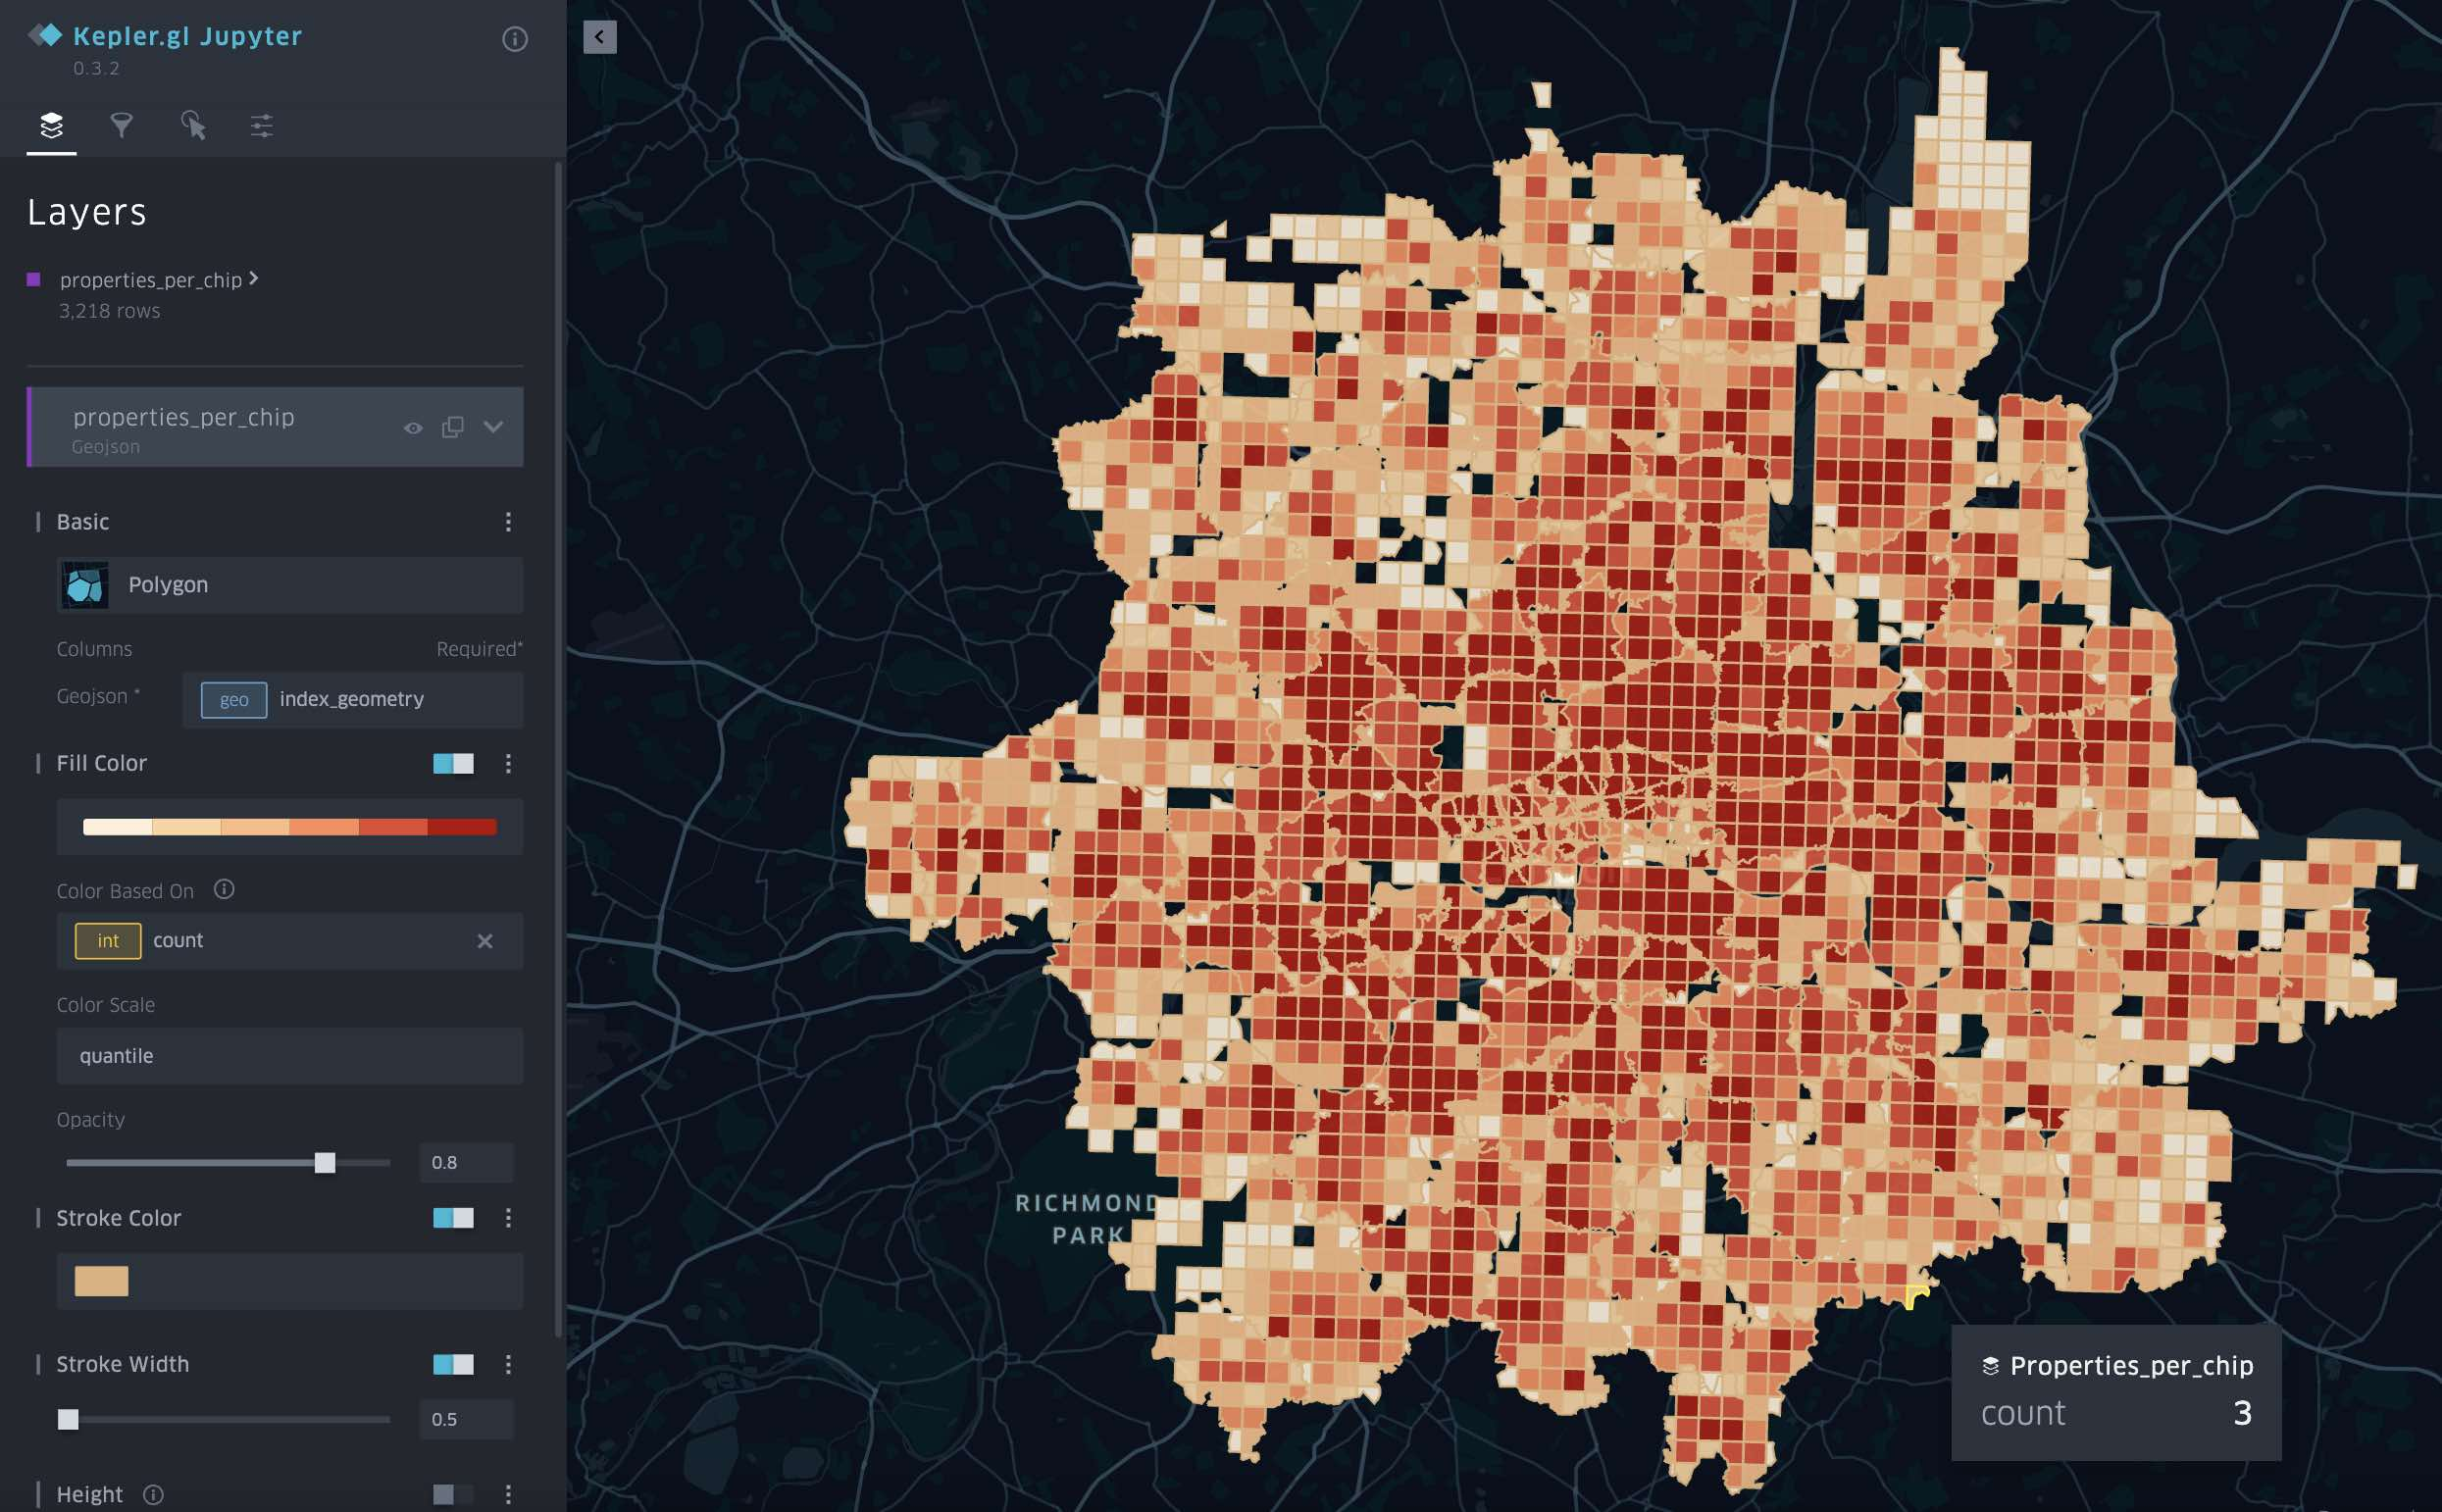

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACbqgAwAEAAAAAQAABgakBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/qAYxBUk9UAAAAAABg3wQAACoLAABdFAAAFRoAAIQfAADzJAAAsSoAAM8xAABeOQAAMEEAAP9IAACRUAAAAFkAADFkAAD6bgAA3HcAAFyAAADCiwAAUZcAAH6hAAAlqwAA9bQAANC9AAAKyAAAUdMAANvdAAC46gAAnvYAAG4BAQCDDQEACBgBAKYjAQBMLwEAHjsBAJpFAQC4UAEAjVwBAP1pAQDYdgEA6oIBAA+QAQDSnwEADK4BAPW7AQC7zQEAr9wBANfqAQBF+AEAwQgCALIYAgBRKAIAuDcCAF1JAgAyWwIAdWsCACN7AgDuiwIAaJwCABiuAgDcvwIAKNICAAniAgBN8AIAFwADAH8PAwCvHAMACioDAAg4AwDqQwMAHFEDABxeAwAwawMAd3cDAPeDAwAPkAMAWZoDABunAwAotQMAnMIDAMzOAwAc2gMAauUDADPxAwAg+wMACgUEANgNBADuGwQAxyoEAKUyBADiOwQAkEUEACZMBAC6UgQA8VkEAO5gBAAqaAQA/8AAEQgGBgm6AwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMACwsLCwsLFAsLFBwUFBQcJhwcHBwmMCYmJiYmMDkwMDAwMDA5OTk5OTk5OUVFRUVFRVBQUFBQWlpaWlpaWlpaWv/bAEMBDg8PFxUXJxUVJ15ANEBeXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXl5eXv/dAAQAnP/aAAwDAQACEQMRAD8A4aiiirJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAzZwfOb8P5VGBippv8AWmoqZLYUHpRRQIZSglTkUmDTmHAb1oKJiFm5HDVAVKnBpKsKwlGx+vY0AV6KUgqcGkoGFFFFABRRTsCgVxtFBGKKBhU8/VR7VBU8vKq3tQIgooooGFFFFABVm2uDC2Dyp6iq1FAjQuYAy+dDyDycVn1atrkwna3Kn9KkubYAedDyp5OKYLQsaewaNoz2P86zJEMcjIexqzYvtnA/vDFO1BNsocfxD+VAupRoHWinLSGxaKKKCRh60U+mEYoKTCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASQttce/FDAKxWo6nm+YLIO9AmR0w8UoPrSnGKBbDaKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqxax+ZMAeg5NAFxv9GtNv8Tf1rLq5eyb5do6LVPGaGJBRTttGBQFxtFPowKBXGVd2ieHd/EtVMCnRuYnyKB7kdFTTgbt69G5qGgAoBwaKKBklFEbY4pxcmghoZRS0UCEpaSigY4Ak4HenTMBiMdBTk+RTIfwqsTk5NA0gooooKCiiigAooooAKKKKACp4vmVo/xFQU+Ntrg0CGUU+VdrkUygYUUUUAFFFFABRRRQAUUUUAFFFFABUiSFOOo9KjooAnMauN0X5VB04NKCVORU4KzcNw3rQIr0UrKVOGpKBhRRRQAUUUUAOU9qRutJRQKwUUUUDCiiigAqUyEp71FRQIXHFJSg9qdigVxlFKRikoKCiiigAooooAUGndaZSigTQ6kPSlpD0oJG0UUUFmnafJbvIf8AOKzOvNaUn7uxC/3sfrzWbTEgpegpKU9BSAM0lFFABU4+SEk9WqONN7c9B1pZX3tx0HSgCOiiigYUUUUAFFFFAFhQRBn1NQkd6nPEKioaCBq9c+lOAyhpACATTl+4fc0FDMGjaadRQK43Boyw6E06igLjlllU5BP41amuGRtq4xiqg606f/WUw3F3Qv8AeGD7UeSDyjA1BRSGTeQ/tR5BHUgVDRQBN5UY6uKNsA7k1DRQBZEsafd3fnT/ALY/bP51TooCxaN3L2NNNzIfvc1XooCxOJxnJUGmyTPJ7D0qKigLBRRRQMKKKKACpkkBGyTketQ0UCJHiZenIqOnrI68A1J5wb76g0AQUVP+4PqKMQepoAgoqykUTttDGo5o/Kfb2oC5FRRRQMKKKKACiiigAooooAKKKKACnDpTaAcUCY/OKYTmiigEgooooGFFFFABRRRQAUUUUAKql2Cr1PFbM8gtYNqfePA/xqrp8e5zIf4eB9TVe6l82YkdBwKZO7ITI54zx7U2iikUKrMhypIPtV6K/kXiX5h+tUKKBWNiSKG7XfEcN/nrWVJG8TbXGDSI7xtuQ4Nakc8V2vlTjDdv/rUxbGTRVm4tXgOeq+tVqQwooooGFFFFAH//0OGoooqyQooooAKK0ra22fvJOvYelWk0xryUGP5R/Ef896aVyXJJXZh4OM0V6CdOtTa/Y9vyfrn1+tcVe2UtjL5cnIP3W7EVcoOJlTrKbsU6KK0dNsBfyMhfZtGemahK+iNZSUVdmdRV2ysnvbjyUOAOWb0FR3kEdtO0Mb79vBOMc0WdrhzK/KVqKkWCZl3qjFfUA4qMAk4HJNA7hRUq287EhY2JHXAPFREEHBoC4UVq6nYxWSxGIsfMBJz+FZqRSynEalvoM0NWdhRkmuZDKKVlZTtYYI7GneVLwNp+bpx1+lA7jKKVlZGKuCCOoPBpVR3O1AWPoOaAG0VK1vOpw0bA4zyD0q/p9jFdwzySFgYlyMfQ9ePamk3oKUklcy6KKKkoKK0rXTxc2kt1v2+UCcYznAzWesbvnYpbHXAzTsyVJO6G0U5EeQ4RSx9hmhUdzhQSR6UDuNoqTyZtnmbG2+uDj86aiPIcIpY+wzQFxtFBBBwetSGGUMEKMCegwc0BcjorSvtNks9uMuCuSccCs9UdztQFj6DmhprQSkmrobRTnjkjO2RSp9CMUBHK7wDt6ZxxQO42invHJHjzFK55GRimUAFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRViC2efJyFVerHpU+3Tl+Us7e4pgUKKvPaK0ZltW3qOo7iqNABRRRSAKKKKAM+b/WmoqfPnzmx7fyqPmmSzSs9NmvIzJGygA45q3/AGFc/wB9P1/wq9oX/Ho3++f5CtumFjlv7Cuf76fr/hR/YVxtILp+v+FdM0kaFVdgCxwAe5p9A7HEXmmTWUYkkZSCccetZwOORXWa9/x5r/10H8jXJ0hlhv3qbx94dar05HKNkU+VAPnXoaBEVFFFAwpc0lFAgooooGFTnmAH0NQVOflgA9TQIgooooGFFFFABRRRQAVbtrnyjsflT+lVKKBF64t/LPnQ/d68dqtuovLYMv3v61StbnZ+7k5U/pVsK1tJujG6NjyB2piMkgqcHgikrcntY5jv6H271iupRyh7GkNO4A5paaDS5FAmLRRRQIYetFKetJQUFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAqdPniKenIqCpIW2uPfigRHRTnXa5FNoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoFJQDigQ402nZBFNoBBRRRQMKKKKACiiigArTtgILdpj1NZ8cZkcIO9X7xwoWFe1MlmfyTluppaKKQgooooAKKKKACkalphOaBonT95GU7jkVBTkbYwanzLhtw6HmgZFRRRQMKkBzUdKDigTQ+iijB60ECU5QWOBSVKn7tDIevagYyZhkIvQVDR15ooKCiiigYUUUUAFFFFABRRRQAUUUUATy/MiyfgagqeP5o2T8RUFAgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATq4cbJPwNRujIeaZUySDGx+RQIhoqSSPbyOQe9R0DCiiigAooooAKKKKACiiigAooooAKcD602igQppKM0UAFFFFAwoopw6UCY3BpcGnUUCuNzjg0E8U4jNNIxQAlKo3MFHc4pKsWi7p19uaBlm/bGyMduazqs3jbpz7cVWoYIKcelNHWlJzQAlFFTwoMGVui0ADfuo9g6nrUFKzFmLGkoAKKKKBhRRRQAUu043UlSJgrt9TQImlGFRfaoQM1JMcvj0ppYKPX0oJEb5VwO9H8ApmdxyaeegHtQNjaKKKBBRRRQAtPnGSGHcVHUkvCKKBogooooKCiiigAooooAKUdaSlWgTFxSEYp1FArjKKCMUUFBRRRQAUUUUAFFFFABRRRQAUoBY4FIAScCrHEK4H3jQIcCIiEX7xPJqKYkyGmI2HDGnzLh8+vNMCKiiikMKKKKACiilHSgQlFKaTBoAKKXFGKAuJRQRRQMKKXGRRg0CuJRRRQMKKKKACiiigAooqe2j82ZV7Dk/hQBof8e1l6M38zWRV/UJN0gjHRev1NUKbEgooopDCiiigAooooA0be848qfkdM/40XFlgeZByPT/AArOq3bXTQna3K+npTFbsVKK2JbeK6XzYjgnv6/Wsl0aNtjjBFIExtFFFAz/0eGoooqyQqxbNGsmZPwNV6KYG/XSWTwtCBCMY6jvmuKtrnb+7k6djUv9oyQTBrc9Ovv7VcJWZjWp86sd5WVq8tolqUuRuLfdA659faojrdqLT7QPv9NnfP8Ah71yFxcS3UpmmOSf09hWs5q2hyUaDbu9LENdF4d/18v+6P51ztbOi3dvaSu1w20FcDgnv7VjD4kdlZNwaRsokVtp00mlnexzlj19/ToOlctZxrPdxxP0ZgD9Ku6XqAs7giQ/un+97ehqG5kt4b0T2LblBDgYIwfTmqbTSZnCLi3Hv1OqmN8lyBA8SwrgbScHH5ce1Yd5HEmtRGLGGdG49c1PPJo2oMLiaRonxyMf/WNZiC2XU4haEtH5iYJ69RVSZFONvu7Gzqeq3NpeeVFjaACRjrmqXiCJUukkUY3rz9RWhqEelNeb7uRldQMjsR+RrD1W9W9ud8f3FGBnv70pve4UVrFpGhr33Lb/AHT/AErSEVxBYwx2LJGSAWLdzisTV7u3ulhEDbtikHgjHT1qxHd6fe2cdtfsY2j4DD8vQ/jTuuZhyvkjoO1tQ1vDM5Uyj5W2mrlxeGy022ljUGRkVQT2GBn+lc/ex6fGFFk7OedxP6dhVrULu3nsbaGJstGoDDB44Apc27HyXUV0MueZ7iVppPvN1xXQaFk29wIcCbHBP04/Wsm3SwNrK1wxEo+4B9OP1rX0cldPnYp5o3fcHU8Uob3LrP3GkWbqe6t9Ldbxx5zHAxjOM+3tmqOi/wDHrd/7g/k1WTbWd3bSyNbNbsikgnjt+tZumXdvb29ykzbTIuF4JzwfT61TfvJsyS9xpLUx6KKvWKWMjst65QY+Uj1/I1ilc7G7K5raX/yCbr6N/wCg0zQOs/8Auj+tOnvbC1sWs7Aly+ck+/XPTtVHSb2OznbzvuOME+la3SaOVxcoydtyx4e/4/X/AOuZ/mKfoX/IRl/3G/8AQhViG40fTt81s7SOwwBz+XQVV8Pkm+cnuh/mKFo0glqpysXLLVbifUPs0gXYxYAAdMZ/wrMEo07V2ZeEDkEf7J/wrRik0a0uGu1kYuM4XHQnrjj+tc7NI9zcNJj5pGyAPftSk9N9Rwim3ZWVjoLixDa1GVHySHzPbjr+f9aoalfSf2k00LYMXyqevTr+ua27ed4NL+0XKFZIlKruHJ6Y/pXGkknJom7bBSXM9emh1OvXdxC6wRthHT5hgc0/TInj0szWxVZZCfmboMHFVNRuNPv4BP5hWVVwFwevp0qKwvbQ2jWF9kITkMO3+TVX965HK/ZpJepoXyySaW32xo2lQgqVPbio9MmW30iSdlDbHJAPrxj9azLuHSo4T9llZ5OMZ6fyFPhu7dNHltWb94zZAwfbv07UubW5XJ7tvMpXl7NeuHmxlRgYqpRRWTdzqSSVkFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGheHyo47ZegXcfcmooB+4k/d7uPvelS3YM0SXS9MbW9iKLWWNLaZGOCw4H4UxFa3maCUODxnn6U68jEVwyr06j8aS1haaYKBwDkn2pbuUTXDOvToPwoGVqKKKQBRRRQBnTH98w+n8qjp0/+ub8P5UwHNMlnWaF/x6N/vn+QrWldo4mdVLkDIUdTWToX/Ho3++f5CtqmNHO6ZGt/IdQumDyKcKnZMdOP8/nXRVmvpy/bFvIHMZz84HRhWlSQzE17/jzX/fH8jXJV1uvf8ea/74/ka5KgQVNEwP7tuhqGigB8iNG21qZVyNhOmx+o6VTIIOD2oAKKKKBhRRRQAAZOBU05+YKOwpsIzIKa5y5PvQIbRRRQMKKKKACiirEUII3ycLQIgVWY4UZqcW0p9BSvPj5YhgetQF3PUk0ATfZpfatK0DpGVk9eKxw7joTT1nlU5DUxNGwT9mDO5JUn8qjnt0uV82IjP86rW91u/dT8g9zSsJLJ9ycxntQKxnspUlWGCKStl44b2PenDev+NZMkbxNscYNIpMZRk0UUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJ5RuCyDuKgIxViP5oynpzUJGaCbjaKKKCgooooAKKKKACiiigAooooAKKKcB60CG0UpGKSgAooooGFFFFABRRRQAUUUUAFFFFABRRU0ERmkC9u9AF21QQxG4fuOPpWc7l3Lt1NXb2UEiFei9aoUxIdmk3UlFILDs0ucUyigLD6CcUynAUCsA5600jFTKqkZJprYzxQFyOrH3oSO61FU0PUqe4oC5WooIwcUUFBRRSjrQIBmpSflxTKWgljlUswAombLbB0FPX93GX7ngVWoGkFFFFBQUUUUAFFFFACilPSkHWlPSgnqNooooKCiiigCSJtrj34pJF2uRTKnf95GJB1HBoEQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigCWOTb8rcqaSSPYeOh6VHU0bgjy36GgRDRT3QocGmUDCiiigAooooAKKKcOlAmNoHWn0UCuJgUvGKKQ9KBDaKKKCwooooAKUE0lOWgTFpDS0wnNAkGTS5NJRQMdgVoWKgbpD24rPyK0V/d2RPdv68U0SZrNuYse5zSUUUiwooooAKnb5YQPXmoAMnFTTn5go7CgRDRRS4NAxKKKKACgDNFOHAoExCMVJAMyioycipox5a+Y3fpQA1yWkI96jY5NPTqD9ajoAVakPY+1Rj1p4+7k+tAmJS4I5NAbBzSsSRuI4oENooooAco3EClnYF8DtxT4/lUyHt0qt15NA0FFFFBQUUUUAFFFFABTlptAOKBMfRRTcZNBIuM0baWigBlFFFBYUUUUAFFFFABRRVhQIl3t949BQIABCuT941XJJOTSsxY5NJQAVP8A6yH3WoKng/iHtQDIKKKKBhRRRQAUopcCmnigQ6im06gQUUUUAIaSnU00DQoOKdTKAcUA0KaSiigAooooGFFFFABWrZIIoWnfv/IVnRRmWQIO9aF9IERYE/H6dqaE+xmuxdy56k5ptFFIYUUUUAFFFFABRRRQAUUuDSgetArkkM0kJ3J07jtWiJre7XZJ8rf56GsumGgW5dmsZI+Y/mH61S6Vahu5YuD8y+hq9/aEHcGmGp//0uGoooqyQooooAKKKKACiiigAoopVVnO1ASfQUAJRTmR0O1wQfem9eBQAU5HZHDocFTkH3FK0UiDLqR9RimUwJZppbh/Mmbc3qaip4ilK7wpI9ccUygSCiiikMKKKKACp4Lme2bdA5UnrioKKYmr6Mtz6heXC7JpCV9Og/SqlFFDd9wSS2CiiikMKKKKACpoLia2ffAxUkYyPSoaKYmr7gSWJY9TTkdo3EiHBU5B9xTaKALVxe3V0AJ3LAdug/SqtFFFwSS0QUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATwXMluTt5B6g9Ksebp7fM0bA+gPFUKKYF2S7+QxW6iND19TVKiigAooopAFFFFAGZcf65vw/lUVS3H+ub8P5VGtMR0ui3VvDbMkzhTvzyccYFa/26y/56p+YrhaMUCud19usj/y1T8xR9usv+eqfmK4TABBpSMEigLnRa1dW81sqROGO8HAOeMGuapTikoGgooooGOVijBh2qSYZIkHRqhqeP54zH3HIoEQUUUUDCiiigCxbLlyewFV6tD93bk92qrQIKKKKBhRRQOtAEiruIUd6luW5EY6Cn2y/MXPaqrncxb1NBKG0UUUFBRRRQAVoW1wGHkTcg8Ams+igRdkjktJPMiPyn/PNXVaG9j2tww/MfSoLWcSjyJec9KhuIDasJI24zx7UxEE9u8DYbkHoahrYhuI7lfKlAyf1qlc2rQncvK/yoGmVKKKKQwooooAKKKKACiiigBR1pcZpo4p2RQSxtFKTmkoGFFHWnY4oC42iiigYUUUUASQttce/FJJlWK0yp5vmCyDvQIgooooGFFFFABRRRQAUUUUAFFFFACg4pd1NooFYM5ooooGFFFFABRRRQAUUUUAFFFFABRRRQAVqRAWtuZG+83+RVS1h82TnovJp15N5kmwdF/nTE+xUJJOT1NFFFIYUUUUAFFFFABSg9qSigQ+igciigkKcp2sDTabk0BYlmTD5HQ81DVlP3kRU9VqGgdxAMUuBRRQIKVQWcKKSpF/dxl+56UDQ2ZtzbR0FRUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFGDTsUCuNqWFgG2noeKZtpCMUBcV12MVptTv8AvIw/ccGoKACiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATJICNknIpjxlD6j1plSpJgbH5WgRFRUkke35l5U1HQMKKKKACiiigBc0uRTaKBWF3UE5pKKAsFAGaKcMUAwPSm0rUlAIKKKKBhmiiigAooooAAMnArTvD5cSRD/ADiqdsm+dR75/Kpb590230FMl7lTOetLtpBilzSD0G0UUUFEsK5bcei800ncxY96kf8AdxhO55NQUCFwM06mU5aBMWiiigQyiiigskiQO3PQc0SOXb2HSpF+SInu1QnpQTcAePzptKpAPNLjHWgYHgYpW4AH40w8mnydR9KAGV7H4SgjfR4QwzwT+bGvHK9r8Irt0eLP93+ZNY1dkaU+pumxt2GCMiuL8YCytrDyFQb3YbfqOp/KvQK53X9GTU7f0ZTuB9D/AIVkkk0zS7aaPFZjtURjt1qvV2/sruym2XaFCc49Dj0qlXXe+qMLW0CiiigAooooAKKKKACiiigBxOKbk9aKKBWHA+tITSUUBYKKKKBhRRRQAUUVNGgA8x+nagQqKEHmP+AqFmLnJpXcucmm0AFFFFAwqa3++fpUNSRHEgoEyOinyDDkUygYU4DvTaAcUCY+gjNJupaCRlKKUilxQO4lFB6UmaACkoooGFFFFAwooooAKKKKACiinxoZHCDvQBo2MYRGnf8AD6VnyyGWQue9aN64iiWBO/8AIVlU2JdwooopDCiiigAooooAKMUU4GgTFooooJCiiigBlFOwKNooKuf/0+GoooqyQooooAKKKKACiiigAqxGStvIy8ElR+HNV6likCBkcblbqOnSmBISWtQW52vgfQiq6syncpwR3FSySqyCONdqg55OSTTN0e/dt+X0z/WgCyuPs77XLkgZX05HPvVOrHmxqrLEhBYYJJzx+QqAldoAHPrQBat2kaUSMx2pyT7Dt+NVWOWJHGTVkzwmMR+WQB6N1Pr0qqcZ44FABRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAzLj/XN+H8qjHWpLj/XN+H8qjHWmJjqKKKCQpzdab1IFObljQAwjvTafSYFA0xtFGCKKCgpyNsYNTaKAJZlw2R0PNRVOv7yIr3WoKBBSqCzBR3pKsWy/MXPRRQAtyRuEY6KKrUrNuYse9JQAUUUUDCiigAk4HegC+hEdtnviqFW7o7QsQ7VUpsSCiiikMKKUDNKeBQK42iiigYA45FXo7jzl8mfnPQ1RooESyxNC3t2NX7a8Dfup/pn/GoYpFmXyZevY1VljaJtp/A0wLtzZFcyQ9O4rOq/a3hj/dy8r2PpU9xaLKPNh6nnHY0Cv3MmiggqcHgiikUFFFFABRRRQAUUUUAFFFKMUCHdKQn0pCc0lArBRRRQUFFFFABU6fPEyenIqCpIW2uPfigRHRTnXa5FNoGFFFLtoEJRTscU2gLhRRRQMKAcUUuOKBC9RTSMUoPNOoFsMooPFFBQUU+mkYoEmJRRRQMKKKKACiiigAo68UVcsow8u49F/nQIsHFpbY/ib+dZdWLmXzZSR0HAqvQCCiiigYUUUUAFFFFABRRRQAq06mjrTqCWFFFFAh8bbWBpZV2tx0NR1P8A6yL3WgCCiiigBD0qa5zuVfQVFUk/3gfagaIKKKKCgooooAKKKKACiiigAooooAKUCkpw6UCYtFFFBIUUU4jFACwH5ih7ioSMHBp4O1g1OmXEn15oKIgM0HrSnjikoAKKKKBhS4pB1p9AmNIxSU4jNIRQCYlFFFAwooooAKKKKACiiigAooooAkjk2cHkGiVApyvQ9KjqeMh1MTfhQIgooIIODRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC/YL87P6DFU5G3yM3qa0If3Vmz9zn/AArMpiQUUUUhhUsK7myeg5qKp/uQ+7UCInbexam0UUDCiiigAooooAKlSLI3NwtPSNUAkl6HoKieQueenpQIe7hjgcAUw0w+lOx8mfegVhtOHzfL+VNAJ6UYx1oKDpT5PvUZDDDdfWldTjJ+hoER17d4WwmkQ7iB8gP514jXuHhyJX0mDzB0jXH5VjW6WNafU6LevqKXK461D9mhPb9aQ20PpWOpeh5T44P+nRDttP8AOuJr6FigikDbh0OKc2n2rcsuauFRpWsKUU3ufPFFfQbaVZMMMgP1AryDxXHFHquyJQo2DgcetaRqXdrEONlc5uiiitSAooooAKKMUUAFFFFABRRRQAUUUUAFFFABJwKAJY0By79BTZHLn27VJKQqiIdutQUCCiiigYUUUUAFAODmiigCacfMGHcVDU7fNCp9OKgoEgp2KbT6AYylBxStTaA3HZyaWmUZNArD6aR6UmTQODQFgopzU2gYUUUUDCiiigAooooAK1LGIIpuH444+lUreEzSBe3U1dvpgqi3T8f8KYn2KE8pllL+vT6VFRRSGFFFFABRRRQAUUUUAFA4NFFADsijcKbRQKw7dS0yigLD6KZRk0Csf//U4aiiirJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAzLj/XN+H8qiFS3H+ub8P5VFTAfRTQe1OoIFX730FJQp+Y/SigAooooAKTApaKAGEEUU+kIFA7ixvsbNSGLf80XPtUHSnK7IcqcGgZL9nf2qZkMMBHcnmo1mZmAwM561YknUP5bDjvTEZ1FTyxBRvQ5U1BSGFFFFAwp6DDr9RTQO9O6EfWgVyW5GZfwqDbU91/rB9KhBoEJtpcClooFcKQjNLQKAGUU8jNMxigpMKKUCkIxQFwq9HItwnlS9exqjQCQcigB8kbRttap7a6aA4PK+lSoy3KeW/3hVJ0aNtrUAbEsEV2nmRnnsf8AGsd0ZGKMMEVJDO8DZXp3FaUiR3sXmR8MP84NMWxj0UEEHB7UUigooooAKKKKACiiigAooooAKKKKACiiigAooooAnm+YLIO9QVOnzxMnpyKgoEOWlpB0paCWFNPWnUygaCiiigoKfTKM9qBNAaXdSUUAFFFFAxwpp60UoBPAGaBCUVKIHPJ4qVEtxw7ZNAXKtFTlICflajyQfuMDQFyCipPJkzjaaRonQZagBlacf7izL92/r0rMrTvflhRB/nFMGZlFLg0h4pAFFFFAwooooAKKKKACiiigAp9Mpw6UEsWm5IPNOppIoBAT6U+J9j5PTvUdFA7E0i7Wx2plS53xZ7rUBNArDl+Y4qWbG/HoKSAZbPpUbtkk+tAhhxniigDNLigoUDFI1APrSUBYKKKKBhRRRQAUuKSlzQIMUue1FNPWgQ+imZNKCc0BYkU4OaQnJzQRg4pKBCN0qZ/miV/TioW6VKnzQsvpzQMgopdpo2mgdxKKXbRtoC4DrSk4oxjmm0BuSBwO1dppfhmPVbNLqKYjcOVxnBHBrh69J8CXnyy2rH7rBh9G/wD1VnUbSui4JX1IX8Byk5WfA/3M/wBayNW8Ky6VaPdvNuC4424zkgep9a9ori/GxP8AZTj/AHf/AEKslKV1qXZW2PH6KKK6TIKKKKACiiigAooooAKASDkUUUATyAOolX8agqSJ9rYPQ9aSRNjY7dqBDKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUtuu+ZV96ALt3+7t0iH+cVm1dvmzKF9BVKhiQUUUUDADJxU05wQg7CkhXdIPbmmSHc5PvQIbRRRQMKKKKAClAyQPWkqa3XdJ9OaBBOcvt9BUNKx3MT60lABS/wj60lO/g/GgZZAAGBRjPWiimQMMamjGODyDT6RvumkMrEYOK928Of8gm3/AOuSf+g14U/3q930RlTTYQxAzGvX6VjV6G0Opt0UzzY/7w/OjzI/7w/Os7oqxDbfdY/7RqzVW2ZQhyQOasbl9RUx2HLcU9K8Q8VkHWXx/dWvbmI2nmvDfFH/ACGpfov8q0h8RMvhOfoooroMgpRSUUCH0w9aduppOaBIKKKKCgooooAKKKKACpoQBmRugqEAk4FTykKBEO3WgRCSWOT3pKKKBhRRRQAUUUUAFFFFAE8fzRsv41BU0Bw+PUVERgkelAhKUdaSigB9NPWkyaKASCiiigYUUUUAGaKKKACiiigAooooAKOtFX7GDe3mt0Xp9aBFqNVs7cs33j1+vpWOzF2LN1NW7yfzZNq/dX+dU6bBBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9XhqKSirJFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAFopKKAM24/1zfh/Koqln/1zfh/KoqYBT6ZSg9qBMUfepaOhzRQSBOKTdQ3Sm0DSHZFLTKKAsPopmTS5NAWHdaEjZzhaljiz80h2ilecAbIhgetAExVbZN3U1RZixLHqatxnzoih+8KqAZOKY0W0G6321UZSpwwxU0rbcRrwBSLNkbZBkUAQ0VLJHt+ZeVNRUhgDingF2CigLngdasgLbrk8uaCSO6IMmB2FQL1pCSxyetKtA+g6iiigkQnikBxSHrRQVYXJzxR1PNKo70uBQK4UUH1FJmgQ0jFFFFBYAkHI6ir4KXSbW4cVQpVYqdy8EUCFZWRtrdRU9pP5MnP3Twam+S6j9HFUWUqdrcEUAXb+LZJ5g6N/OqNbE/72yD98A1j02CCiiikMKKKUDJoASjBqUACloAhAJOKcV9KkA5yKXaetAEJUgZowalplAmMooNFAwooooAkhba49+Ka67XIptTzfMFkHegRCDzTqZSg0A0OPSmU880zGKBIKKKKCgooooAKKKKACiiigCSJxG+4jNPa4Y/dAWoKKBWFLM3U5pKKKBhRRRQBPHcSJ7j3qwqrMjEHr/OqFPjcxuGH40xWFjXMqqfUVdvj86r6ChI/9KVh0PNRXZzOfbigllXODg0uKQigGkMbQBmlI70g4oGOwKbT6a3rQJMSiiigoKKKKACgGiigAooooAKKKKAJIm2vz0PFJImxsdu1MqdGEi+W/XsaBCodsJb14qHg81LMNirH6VADigVh44ooooENI5pMGn0UDuMooooKCjBpVp1BLYyinHpTaBoKKKKBhUka5OfSo6er4XbQIUnJzSUwHFLmgVgJzU0HJK+oqCpITiQUDGZNOokGHI96Qc0CYtFFFAgplPplA0FdH4VuWt9XRM8SAqf5j+Vc7g1dsLhbO8jumBYI2cCpkrpopSsz6FU7lDeorifHDY0wgdyo/XNTr4x0dVC+b0/2W/wrnfE+u6fqlh5drJubcOMEcD6iudJ3Whs2tdTz2inYFNrqMAooooGFFFFABRRRQAUUUUAFT/6yE56rUFTQH5ip7igTIaKCMHFFAwooooAKKKKACiiigAooooAKKKKAAc07bQBS0EtjcGrdkv7/AD6A1Wq9Yj5mPtQhXKtzkzsfeoKnl5kb6moKCkFFFFAyeHjc3oKgqdeIWPqagoEFFFFAwooooAKs2v3mPoKrVZtT8xX1FAmVqKVhgkelJQMKcPun6im05fumgCzRRRTICmt2FOqNz19h/OkMgJyc177pEUbWEWQOFH8q8Cr6E0sBbJAOgA/lWFXdG0NmW/Ih/u0hghx92pqQ9DWdl2KuynBDG8e5hk5qX7ND6frRbf6ofWrFTGKsU27lVraIKSM9K8S8THOt3H/Af/QRXukn3G+hrwfxCSdZuM+o/kK1ppKWhE37pjUUUV0GQUU4D1ppGKBXCiiigYUUUUAFFFFABRRQAScCgCaIBQZD2qEkk5NTSkKBGO3WoaBBRRRQMKKKKACiiigAooooAlh/1gqN/vH61LB/rKiPU0CEooooGFFFFABS44pRS0EtjKKU0lAwooooGFFFFABRRRQA+ONpXCL1NatzIttAIo+pGB/jSWkQhiM0nBIz9BWZNKZpC5/D6UydyOiiikUFFFFABRRRQAUUUAE8CgAoqQRSHtR5UnpQIjoqUQyHtineXGv32/KgLkFFT7oR0XNHmR/3KAIKKn81P7gpPOHZRQBDRVkSkjgCn72/uigD/9bhqKKKskKKKKACug0rwzqmroJ4FCRHo7nAOOuOpP5Vz9dzoura7pOnrcMsb2YyVWV1Vjzzs5z69j7UMDfi8AacLfZPNI0v95cAZ+mD/OuU1PwbqtgGlixcRLzlOGx7r/hmu2TxzojQea/mK4/5Z7cn8D0/MisS98R6zrNvL/Y8apEMqy5VpSCDk7fTHoM0tRnm9FFFMQUUUUAFFFFAF0WscUay3LEbuiqOaj3WfTa/1yP8Ku2skVygtrgZI+6as/2ZbZzlvzpiM37MkqNJbMTt6q3WqVa91JFaIbe3GGb7xrIoGFFFFIAooooAKuApbRqdoMjDOT0A7cVTq3OpliSdecAK3sR/jTAPtTMdtyoZfoAR9MVDNH5UpTOR2Psa2IreK7tULDDAYyOvHFZ11bzxEGTkAAAjpxQBTooopAFFFFABRRRQBP8AZbn/AJ5t+VSxWNxI2CNo9TTIre5mzsB49eKEa6gfKbgeh4zTASa1mhJ3LwO46VXqWUzOS8ueepNRUAFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMy4/1zfh/KoqluP9c34fyqKmAUUUUAA60+mCnHPXFBLEakqRYnYZ/nT/IbuRQMgoqfyR3YUBIk5Zt3sKAuRpGz9KlzHF0+ZqY8rNwOB6VFQA5nZzlqbRRQMcjlGDCnyrht69DzUVTx/OhjP1FAhW/epvH3h1qvUkZZX4H1FPni2HcOhoAZHIU46j0pzxjG+PkVDVmNjFHv7npQA+3Qltx6CmXEThi/UUjXUpGOB9KdbuWJjY5BFMWxVopzrtYr6U2kULk0oIptFArAetFFFAwp4OaZRQJocT2ptFFAIKKKKBhRRRQAqsyNuXqKvEJdJuXhxVCnI7RtuXrQI1rcF7Roz1GRWPW7ayLIpK9e9Ysi7JGX0JFNiQylAJpKcODSGLs9acAB0pOT0pdr0BckAXHNGVHSmhD3NLs9DQFxd9IWJqMkjqKQv6UABemg880lKB60AwNJSkYpKAQDrT6ZTlyeBQJjanT54mT05FMdAoFETbXGe/FAyOinyLscimUDHg5FB5FNHWnUEsZRT6ZQNMKKKKBhRRRQAUUUUAFFFA5oAKKdim0CuFFFFAwpygZ+bpTaVaBM2YRlgRyMVn3Aw5Y9SelWrIYV2rOkYudxpkoYTmgUAZp9IpsKYRin0h5oEhtBOaKKCgooooAKKKKACiiigAooooAKKKKACjpyKKKAJ7gkuD7VBVllMiKy8kDmq1AkOB4paYDg0+gTCmZNPJxTKAQUUUUFBS7qSigVhSeKSiigAoowaXFAXEooooGFFFFABQDgg+lFFAFifhsjuKhBqb/WQ57rUAHrQSOopCabk0BYUgmkxQTmigY8dKKatOoJYUUUUAB6Uyn0ygaCiiigoKKesbt0FSeUi/6xvwFAiCnrG7dBUnmRr9xfxNRtK7dTQBJ5IH3mAo8qPu4qClAzQBN5cZ4Dc00K0Tgt60w09ZWXg8j3oASYYkPvzUdWnaCTBJINM2Q9moAgoqfyo+zijyV7OKAuQUU50KHBptAwooooAKKKKACgc0UUAPopB0paCArRsh8jGs3IrTs/9Sx96aAzXb5z9aYTmg8nNFIqwUUUUDJ2GIVHrzUFWJiBtX0FRcGgm4ynYGKMCloBsZRSkYpKBhUsJ2yg1FSg4IPpQMknGJTUVWroqXGOuKq0CQU9R8hNMp4P7v8AGgCxRRRTJN5PDeqSRiVFUhhkc1G3hnWf+eQ6/wB4V65pIH2GP/dH8q0tq+grmVSTN3CJ4X/wjetf8+//AI8v+Ney2bxw26xueRV0onXAqvbIhjywB59KiUpNoqMUkybz4v7wpGmiKnDDpTvKj/uj8qY8UewkKOlLUegy3dFiALAGp/Mj/vD86rwRRtECwyal8iH+7Sjew3a4sjp5bcjoa8G10ltXuCf72PyFe6SQRKhIHIHrXhGtNv1W4J/vkflWtK/NqRO1tDMp4GKQDvTgcGugwYu096iOc81aBDCoXAHWgdiOiiigYUUUUAFFFFABVq2CjdI3aqtT/dg/3jQJkLHcxb1pKKKBhRRRQAUUUUAFFFFABRRU6oIxvk/AUCHKfIXcfvGm74n++MH1FRMxdtxptAWJXiK8jketMwKdHIU46j0qR0DLvj5HpQJlfjNGKKAcUDAHFGTSkdxSUALnIpKKKACiiigYUUUUAFWrSDzpMn7q8mqygsQq8k1tHbZ2/v8AzNNCZWv58nyF7dazaUksSx5JpKQIKKKKBhRRRQAUUUqqWbaKAHJGXPt61IZAg2xfnSSvj92nQdahoEPMjnuaTzH9TTaKBilmPUk0lFFABRRRQAUuDSgUtBNxU4qXcajHSloKP//X4aiiirJCiiigArrLSXUYNISW9EElmCTHHPjc3Jzsx8w5/D8K5Otiy1u7s4fsbhZ7bOTDKNy/h3B+n1oAt/8AFLylbgm4h/vQjDc/7LnHH1GavwS3V7aTDw/FBbhQQ0anNwyY5O5uSPoaz1n8MuBPLBOjjrEjAo3p8x+YD86il164WFrXTo0s4m4IjzuYejOck/pQBhUUUUAFFFFABRRRQAqsVIZTgit8XZ+xfaP4un49K5+rQuR9kNsRznINMCszM7FmOSaSiikAUUUUAFFFFABT45ZIjujYqfamUUAb+mMWtyD2Y1ZuZjBEX27v8965+K5khjZI+N3er9ldoY2huTwBwT6elMRksdzE4Az2FJTn27zs+7nj6U2kMKKKKACiiigC5FfXEWed2f72TSK97MWeMue5wTTPtc/qP++R/hVmHUZI1IdQ3p2/kKYFJppnG13Yg9iTUdTyXMsgKsRg+wqCgAooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBmXH+ub8P5VFUtx/rm/D+VRUwCjrwKlWFjy3A96kWSKE5Qbj60CGrbyZBIxVrEcalnOT6VVaeSRuOB6Co5OuKYgeRnPNMoopFBRRRQAUUUUAFFFFABUsCkyjHampGznipGdUXZH+JoEXJFypaPAbvVFJBgo/INMRyjZFSSqPvr0NMLDgkI+bdkelRSOXPoB0plFIAqa3/1y1DVtFECeY/3j0FAMhn/1rfWoqUkscnvSUDCiiigAoop4FAmxlFKR6UlABRRRQMKKKKACiiigAop2OMU2gRcsG2z4/vAirN3b72Lp97+dZasUYMvUVtSP5kAnj6jkj27imJmJTge1XJY1mXzouvcVRpD3JB1qeq2c1ZoJCiiimBDIDnNRVbIzwarsuDSGmMp9NNKOlAMWmEYp9FAJjKchAbJOKaRiigY523NTaKKBk5/eRbu61BUkT7W56HrSSJsbFAhlPplLk0A0OplFFAJBRRRQMKKKKACiiigAooooAfmmUUUCSCilAyKMGgLiUUUUDNSD5LNm9c1nVov8lkB6gVnU2QHAppPpTiM0ykNDx0ooHSigQ0jvSU+mH2oKTCiiigYUUVKkRPLcCgBI4zIeTgetSboU4A3e5pkkmRsThRUVAifzU/uCk85f7gqGigLE3nf7IpfPPoKgooCxP9of0FJ57+1Q0UBYnFzIOmKedlwNw4YfrVWgEg5FAWFxg4agnNT/ACzDB4YVAQVODQAlFFFAwooooAKKKKACiilVWb7ozQA6kPSkIZTg8UmaCbBRRRQUFFFFABRRRQBLC2Hweh4pjgqxU02p5PnQSD6GgRBRRRQMKKKKAOy8NaPp2rwuJ9wlRscNxg9K6g+BtPJ4Lj6N/wDWrz3QtSOmagsx+43yuPY9/wADXutvMs8QkUg59K553UtzVWa2OJPgax/vP/30P8KytR8HQwW7taO5kQZ2tgg+wwBXqVZ0oDTODWcpyjqmVGKelj5+J9KVY3boK7HxJoosJW1CEZjY8j+6T/Q1x7Su3f8AKuqMlJXRg4tOw/ylX/WN+Ao8yNfuL+JqCiqESNK7dTUdFFAwooooAUU6mU+glhTCMU+igExlFFFBQUAZop44oEyxGQ0RSTt3qLbB/eNIjlTkU8rHJyDtNMQmyH+9UrQQqpJY8VF5Sd3FTTMqxjHO4UARAW3cmk2Qno2PrUFFIZN5OfuMDUbIy/eFN6dKlWZxxnP1oAZkUtS7om+8uPpSeSG/1bZoEQVqWvFsT9azmjdPvCtGLiyJ9jTQMy6KKKRQUUUUATt88IbuvFQA4qeDkmM/xCoCMEg9qBDgaUnFMooCw7g0hGKQHFKTmgBKcgywHvTalhGZB7UALcNulPtUNKxyxPvSUAFSY5VPxNMUZPNSIcuSaAJqKKKZJ71poxaKB/nir9ZtrKkMAjIJxVn7VH6GuFSVjrcXcsHoagtv9UPrTTdRFSOaZBPGkYVjzRzK4Wdi7TJP9W30NR/aYfX9KbJPEUYA8kU3JW3Ekx8H+pWpqqxTRLGqk4NS+dF/eFCasDTuE/8Aqm+leA6r82p3J/6asPyNe9TSRmJgrAnFeH6hYX7308q28u1pHIOw9CT7VpTa5iJ3sY9FWvsN7/zxk/75P+FIbO8XloZB/wABNb3RjZlYMVNMJyc1O1vcDkxsB9DUZjkAyVP5UyhlFFFABRRRQAUUUUAFTzcBU9BUSDLge9OmOZD7UCI6KKKBhRRRQAUUUUAFFFWAohG5uW7CgQKqxDe/XsKhZi5yaRmLHJpKACiiigYU5HZDkU2igCcqso3pwR1FQU5HKNuFPlUA716GgREDincU2igLC4oIpKUE0AJRSkijigBKKKmt4TPJtHTuaBl2xhABnf8AD/Gqt1P58nH3R0qzezhR9nj4A6/4Vm0xLuFFFFIYUUUUAFHXpR16VYQGKMuRg9qBDFhY8twPenbo4wQhyT3qFmZvvHNJQAUUUUDCiiigAooooAKKKKADJp/amUuc8UCZLRSBQKWgZ//Q4aiiirJCiium0TT9Au7Z5NWumgkD4UAgZXA55B70AczRXf8A9i+DP+gg/wD30v8A8TR/Yvgz/oIP/wB9L/8AE0XCxwFFd/8A2L4M/wCgg/8A30v/AMTR/Yvgz/oIP/30v/xNFwscBRXf/wBi+DP+gg//AH0v/wATVHUtK8LwWMk1hetLMoG1CRg8/wC6O1FwOOooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAoyxbpWZjgUzfHH/qxk+ppLgkykelRAZpiFZ2b7xoVSfpR8g96GYsMUAKWAGE/OmUUUDCnjpTcUmTQJikCko61LEm5snoOaAHeQSo559KVVEQ3v17Concs+78qazFjljmgCfKTdeGpBDjmQ4AqClLMepzQBI8uRtTgVFRRQMKnhO7MZ6GoKchIcEetAhpGDg0VJMAJDio6Bk0YVV81u3SnTfOFf1pFBaAgetTKUSJY5B1pklIjBwaKkljaNvm796jpFBRRRQAq06mUUCsPppHekzSk5oFYSiiigoKKKKACnCm0ZoExcnNJRRQAVfsZtrmJujdPrVCjpyKAL8iPZybl5Q02aJZF86L8RUsF4GHlXHIPf/GpjbGI77flT1X/AApiMcVaX7oqV4I5clPlbuDUWDGMPxQDFoqPzBmnB1NIB1RSMMYqRjgZqsaAEpy02ngYFAMcFLUhBHWpFKgYp/WgRXIzTCMVYZB1FR0DvYjooPFFBQVO3zwhj1HFQVMv+ob60CIaKKKBhRRRQAUUUUAFFFFABRR1p2OKBXG0UUUDCiiigAzinbqbRQKwUoBJAHekqxapvnX25oAuXh2xpGP84rOqzePmfHoMVV3UMmwpOKZRnNFBSQoNOplPoEwplBz3qRI2fnoPWgaIwCTgVP5aJzIfwFBkWMbY/wA6gJJOTQBP5qr/AKtfxNRtI7dTTKKACiiigYUUUUAFFFFABRRRQAUUUUAHTkVYBEw2tw3Y1XooEKylTg0lWBIjrtl6+tNeFlG5eR7UAQ0UoVj0BqYIkYzJyfSgCEAtwBmpRCerkAUGZuijAqIknknNAE2YU6Dcaa0zngcD2qKigLE4kVxtl/Oo5Iyh9QehplTRsGHlv0PSgCGinOpRtpptAwooooAKKKKACpoSDmM96hpQSpBHagQhBBwaKmnHzbh3FQ0AFFFFAwr3bw6jrpcJckkxrnPPavJJvD+pW5iMkeVlIGV5wT2PpXrSXRtlEScAVzVZrQ3p05O6N+s9/wDXPVT+029/yFOEpf8Aef3q55TT2NVTlHc5rxNDqV9CtnZRblY5diQMY6DnnrXl9xbzWszW9wu116ivdvMNeR+JpzcapIfL2CP5M4647/57VvQm/hMqsepz9FFFdRgAxnmpS642qKirr7HwpJPbCa7kMLMThcZ4/OplNR1Y4xcnZHIUV2//AAhydrsf98f/AGVRnwe+4BblTk/3f/r1Htody/Yz7HGUoPau0bwVcj7k6n6gj+tNPgy8H3ZkJ980/aw7kunLscfRXX/8Idf/APPSP9f8KiPhDUwcb4vzb/4mj2sO5Ps5djkyO9JWpqek3mmMouQCG6MpyDTNP0q81MsLVQdmMknA5quZWvcFF7GcOtPPStyXw1q8LKDFu3HHynOPrUn/AAjGs/8APIf99Clzx7g4S7HPjpRWheaXfWCq93HsDHA5B/kTWcT2qk09ibPqNqduYVPoagqccwH2NMZBRRRQMKUdaSnjpQJhTO9Pph60CRMlxIvU5+taQKNaZb5QR2rHrTfixH0FMGU/LiPR6PJB6MDUFFIZMYH9qaYZB2qPJHSnB3Hc0ASRo6yAkGmSgiQ59alikkLgE0r3BLEEAimBWoqfMDeq0hhJ5Qg0guQ0U4xuvJBptAwqzAp2tJ6Cq1XCTFb7e7UCZToopVGTz0FAwBI4HerCrtGKjjGTuNTUEsTApVUswXPU4oqWEFpkUd2A/WgD2+H/AFYqWo4v9WKk7V5h3CHkGrVuAYVyP85qo33TVyD/AFK1cNyZ7EmxfQVFKqCNiAOlT1FP/qm+lavYhbjYo4zGpKjp6U/yov7ooi/1a/QVJQkrA2VZ4o1iLKMGnLBEVBK9qW5/1J/CpV+6PpU2Vx3diL7PCf4RUE8MUce5Vwc1eqtdf6sD3oklYIt3D7JB/do+yQelWaKrlQrsw9WhigsJZFHRG/lXg9e968QNMmJ/55t/KvBK0pK1yJ9AooorczCiiigCaAfPuPYVCTk59anT5Ymb14qCgQUUUUDCiiigAoopVUswUUASxAAGRug6VEzFjk1LKwGI16CoaBBRRRQMKKKKACiiigAqeIhgYm79KgoBIORQIUgg4PakqaYA4kHeoaACiiigYUAUU/2FAmwVGdwi8k1qOy2UGxOXP+c0QxraRGaX7x/zisuSRpXLt1NMW4wkk5NFFFIoKKKekZf2HrQAwAk4FT+WiDMp59BQXWMbY+vrUBJJyaBE/nBeIxioWZm+8c0lFABRRRQMKKKKACiiigAooooAKKKKACnKMnNNooAnHJqTAqqGIp3mGgD/0fP6KSiqELRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUALRSUUAKAWOB3p7xsn3qWH/WirFz9wfWmIx5BmQ+lRk54HSnyn94ajpgFFFFABRRRQA/rSYpM8UZJoJsABJwKmciNPLHXvSjEK5P3jVckk5NAwooooGFFFFABRRRQAVLCMyD2qKnxtscE0CFcqzk5NJtX1NSOmDuXoaFjZueg9aBXBXKjCU7G395McnsKQyJHxHyfWoGYscmgEaAkM0YOBjPNV3eDPyrSQsdroO4qvTCxN5kf9yl3xH7y4+lQUUh2J/Lib7rY+tNMDjpzUVKGZehxQAFSOoxSVMJ3HXml3xN95cfSgCCip/Ljb7jfnUbRunUUAMooooGFFFFABRRRQAUUUUAFWIbqWEYXkehqvRQBrLewSf61cH161Z2RSr8pDD86wKVWZTlSQfancmxpyWS9V4qlJC8fXp61PFfyJxJ8w/WtFWhuFyhBoEYZYkYNNNXp7QrzH+VUDnvSGhQcU+o6UHigGh1TjoKiUqeDU1AgPAzUFT1XKMegNADSQaSpBDIe1BhkHagojqd/lhVfXmo1jYsAQadMcvj04oAiooooGFFFFABRRShSxwozQAlFT+WiDMh/AUeXGeQ+PrQK5CDTqf5S/3xTtkY+835UCZDgUgBPQVP5kS/dXP1ppnftgUDVyHBFFTCd++DTgYHPzjb9KAK9FW3ijkXdD27VVZWX7wxQFxK0rNBHG07/5FUI0MjhB3q/eOI41hWmD7Ge7F2LHuabRRSGFAGaKKBDiPSm08cnA5NS/LCOeW/lQJCLGFG+XgelI0hcYHAqJmLHLU6gGMxTgPWlpMigLgRTafSYFAJjaKfTDxQNMKKKKBhRRRQAUUUUAFFFFABRRRQAU+ORozlaQdKbQItyO5XzEPHeqhJJyakjfacHoetEibDx0PSgCOiiigYUUUUAFFFFAFpk82MOp5HUVVIIODQCQcipxIrjEo/GgRBRU5t36rgg0eRt/1jAUBcgpQCegqbdCn3RuPvSGd+3FAEW1vSkwal8+Sl8+T2oA6TSPD0mrWyztIEQEjgZPH8q0rLwiP3z3Z4+ZYh3xyAxx+eK2vB6htP8ANzyzHI7ccV0r8HArjqVZJtJnTCmmlc898P8Ah6C5t5X1KI7g+1QcgjHU8H/OK6GDwxpED7xGWOcjcScfhW9RWUqkm73NY00kQzuUUbaokknJq3c/dWqdYs66a0CtKP8A1a/Ss2tJP9Wv0FNCqdB9UdSiabT54o13M0bAD1JHFXqKpO2pg1c8d07RbvUnljiwpiHO719Kt2/hjVJjIHTy9g43fxH0GP516vb20MTvJGoUuctjuematbRg8da6HXl0Of2S6nz6QVJVhgjqK9ol4IA6AVy+seGbu81B7u32KjYJBJBJHXtiuom+9+FTXmpJWNcNFqTuRU5fvD602nJ98fWuY7madFBoqjlCs6X/AFjfWtGs6X/WN9aTNKe4xhFJH5c6LIucgMMipoCFYJGoUeijFQVNB/rRRd7FyirN2NgAEDNOwKQdBTqs4zz/AMa3C7IbYdSxb6YGP1zXnZGK9s1DSLC9/e3UYcgYB5B/SvFiM12UJJxsc1VNO40AscDvUsxAxGvQUQY389e1RNncd3WtzMSiiigYUUUUAGTRRRQAVpz8Waj6VmVp3fFug+lMTMyiiikMKKKKAJoP9Z+FREHJp8P+sFOkwJGA9aBMhxQCR0p9MPWgEyeO4deG+YU9oVkG+E/hVWnK7IcqaAsPjQtIFPbrTrhtz4HQVdjZXUOeCazXDK5DdaYhoBJwKeR/AOT3pD8o2j8akiX+I0hkgGBiloopkhU9qCbmIDu6/wA6gq1Ygm9hA/56L/MUnsNbnsyTIihSaeJ4/WsmX/WGo+1eVzHrKkmrmyZUIwKtxXCJGFIPFc9F/rF+tdTD/ql+laU7tmNaKjoRfaovemS3EbxlRnJq5UFwB5Lfh/OtGnYxVrjEuIlQKT0Ap/2iH+9+hp6KuwZA6CnbE9B+VNXFoVZ5o3jwpyamE8WPvVFcqojyABzU/lR/3R+VJXuPSwnnRf3hUFw6MgCkHmrHkxf3RVeeNFC7RjJolewRtcs+bH/eH50b0/vD86Z5EP8Ado+zw/3afvC0MfxCwOk3G05/dP8A+gmvCa9v8SRpHpE+wYzG38q8Qral1uRU6BRRRWxmFFFAGTigCd/lhVfXmoKmnPzBR2FQ0CQUUUUDCiiigAqdP3aeYep6VHGm9vbvSyvubjoOlAiOiiigYUUUUAFFFFABRRRQAoHenU0HFGTQTYmj+dDGfqKgpyNtYNUk6bW3dm5oGQ0UUAEnAoGABJwK2La3WBfNm6/ypLe3W3Xzpuv8qqXFw0xwOFHQUyWxl1OZn4+6OlVqfSEZpAmNooqzbwiQlm6CgZHHHu+ZuFoeTPyrwtOn37sEYA6VBQAUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9Lz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f8AWGmUwCiiigAoooAJOBQAU+M4cfWniEgZcgU8eSnQbjQK5HKD5hzUe2pHYu2TTaBXG49KSn5FMoGgooooGFFFFABQAScCnIhc4FSl1jG2Pk+tAiRCIVxJzntVd5Gfr09KYSScmigLBRRRQMlhYK/PfimOpVipptTzdFz1xzQIgooooGFFFFABRSrTqBXGipo3IO1jkGo6KCbhImxsUyrIIkGxuvY1XZSpwaCkA604jNMp4OaBMYRiinn3plA0FFFFAwooooAKKAM8CphEAMyHFAiGlVmQ7lODVlkgRQ3JzTPNQfdQUAaNvdrMPLl4b17Gny2aS8k4PrWUZ37YFWre+ZTtm5Hr6UxWIpLRoz8zDHrUflxDq/5VsSxrOg6EVjzW7xHPUUAmKFhJwCc+tTbDVGjJpDsXGkjTp8xqIyueQcVBSg0CsPaR/U00O46E0NSKCxAHegaLccziMs3TtUZlSQ5kXB9RTZiBiNegqGmFifyQ3MZzULKy/eGKdjuKeszjg8j3pBchoAJOBU/mRDkJSGduigCgBREFGZTj2oMpxiMYFQEknJp46UCYmM8mjApaKBXE20YpaQmgeohpKOtFAwooooGHTpUqzOODyPeoqKANq0SPZ5yjBNZt0SZmJ/CrdwfJtljXvVNZAw2SfgaZK7kFFT+QTyhBFJ5ElIdyGlVS5wtSiCTPNKzhBsj/ABNACllhG1OW7mq5JPJoooAKcDxTaKAFJzSUUUAOBpaYOtKT2oE0KTTaKKBhRRRQMKKKXHrQISiiigYUUUUAFPpo606glhTD1p9NbrQCEqeNg6+U34VBRQMVlKnBpKsnEsW7+JetVqACiiigYUUUUAFFFFAC5I6UhJPJpRzxSUCCiigdaBhRT8CkIAFBNzf0zxHeaZALWNUZASRnORn8a9K0i6k1GyS5lADNnp04JFeKV7B4VB/saHPo3/oRrmrxSVzopSd7G/5YpPKHrUtFctje5j39ytrtDJvznvjpVD+0of8Anj+tSa196P8A4F/SsOpsd1KmnFNmx/aUHeL9a3YQJI1ZeAQMVxVdtaDECj2H8qdjOvFRSsP8o0eUampadjluzmr/AMRWel3H2WYOWwG4HHP4+1VF8ZaYeocfUVyvi3/kLf8AbMfzNcxXVCjFxTOaVWSbR6dJ4wsWZYoldi5A6YAzXQtCjncSa8YtF3XcS+rqP1r2wdBWVaCjaxtQm3cg+zJ6mhbdVYHPSrFFYWOnmfcKMUUUEhVdrV2YsD1qwKtDoKdri5nHYy/sj+tOjgdHDGtOmP8Ado5R+0k9AEgA6GjzFp9LTMyvK25CF615KfC+tdPKB/4EK9fft9a0sD0rWlJq9jOok7XPA7rQ9TsIvtNxHhVIyQQazpgDiQd69L8cieO1VoiQhbDgdweR+orzWL51MZ+orrpybWphNJPQgoooqyQooooAKKKKAHIu5wvqcVfv2xtj/Go7KEs/mnov86huZBLMWHToKYupBRXe+H/DccqW+pySEn74THoeOf1ruZrO3aNgUHI5rnlXSdkbRpNo8JorUuNH1CC5NuIXb5iFIBIPvmq11p97ZSCK5iZGPTvn6EcGtlJPqZ2ZDAP3gPpUbHcxb1NWRFJbmRZlKMvBBGCKq0yQooooGFORdzBabViIBUaU9egoENlf58L/AA1ONtwnP3hVKnqWj+YcHNACYJbB61ZAwMU4gSjzU6jqKbTEFFFFAgq7p3/IQt/+uqf+hCqVaGlf8hK3/wCui/zqZbMpbnpsv+sNRmrjW+5i27rTTa/7X6V5Nj2FNWIYf9aK6iL/AFa/QVz6W+xw2elbKTlVC7DwK1pO25z13zWsW6r3P+pNJ9pH91qimmV02gEfWtZSVjBRdy4v3R9KdVYXMYHINH2qL3p8yFysLr/Vge9WaozTRyKAvrmp/tMPr+lJSV2Np2J6rXHVP96n/aIf7386glljZk2nocmiTVgincu0VF50X94UvnRf3hVXRNmc94qYjSJsf3D+teIV7V4skB0eYoQfl/mRXita0upE+gUUUVsQFSQjMgqOp4eAz+goEyKQ7nJ96bRRQMKKKKACnKpc4FKkbP06etSFljXZHye5oEDsEHlp+JqCiigAooooGFFFFABRRRQAUUUUAFFFFABV1sPag91qlVu2yyPH60CZUAJOBWtb26WyedN1/l/9eiCBLZPOn6/y/wDr1SnuGnfJ4UdBTEx09w0zeijoKr0U3rSEKDmlpMVLGm75m4AoARI9/J4A70PLxsj4Wkkk3fKvCioqCkiVZmHB5HvSyICvmJ071DU8HO5PUUAQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9Pz6iiiqEFFFaGlWkd9qUFnKSFlkVSR1wT2oAz6K1dasYtN1SexgLMkbYBbr0B5xisqgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJYf9aKsXP3B9arw/60VYufuD60xGLL/rDTKmZC8xApcQL1JNMCCnBGboDUolUHEa04mUjrg0CuEdszH5zgUMY4eI/mPrUYDbsvk/rTtik8UxEJJY5NJUpiPaoyCDg0hiUUUUDCiiigAooooAKVQWOBSdeBVjiFf9o0CEciNfLXr3NQUUUAFFFFAwooooAkiTccnoOtJI+9s1JF8yGPv1FQEEHBoEFFFFAwooooAKeDmmUUCaHZFGRTaKAsKT6VOCJl2n7w6VXoBIORQFgIIODR0qfdHIPn4PrSGFuqkEUAQk5opSCOCMUlAwooAJ6VIsLt2x9aAI6ekbOeKk2xJ945PoKa8pYbV4FAh5ZIuE5PrUBJY5NJSgZIA70ATSf6tKgqac/MFHQCoaAQUUUUDJ4Lh4DxyO4rYSSK4XK9e471gUqsVO5TgincTRpzWS9U4/lWe8Ukf3hx61fhv/AOGf8xVwqsg3REEUCvYwKK05LVG7bDVGSCSPqMj1FIdyPPFTRDapkP0FMhUNIAelT3DAtsXtQJlY80AcUtFAgNMJzT6bg0DQlFLijHrQO4lPFFFAmwoqZIJpPuqfx4qyLCTHLAUCKFMrQNjMOhU1Xe0nQZK5HtzQNFeiiigoKKdjjim0CCgYzzRRQM0r/oh7c1m1pt++sge6/wBKzKbEhy9KUlh0NIvSlpCG7m9TSkDFIR6Uo6YoAbRRg0UDCgDNFAOKAHbRRgUbqN1AtRaaaCSaSgaQUUUUDCnjpTKUHFAmL/FSnpTCec0UBYKKKKBhRRRQAU4HNNp44oEwoIzRRQSN20hGKfSEcUDTNLSrC41CZorfGQuSCccVpP4T1ZTwEI9d1XfBQH26U+iD+deoMARzXNUqyjKyOiFNNXZ8+srIxRuCDg0mCACRwa9qvNB0y+bfcRAt6jg/iRgmraWVvFElsqDYowB14FH1hdg9l5nhVFeq3XhDTrm4Mw3Rg9VQgD+RqjqfhPT4LJ5oSyNGpbJOc4Gec1arxJdJnnFFFFbGY5aCO9NqQc0EvTUYBmnAYpaKBXDpUZOac2abQNIK9i8L5Gjw59D/ADNeO17DoBP9j2/+7XPiPhRvRWp0ZpKqgmjca5LnTymJrP8ArE/GsWuruGQEbkDfUVXzAesSfkKm52U5tRSsc5XcW4xEoPoKycWxPMK1de4MRCgds0XIrNzskjQpazPth9KUXhJxg0+Yw9nI808VH/ibtn+6tc3kV6zf6Vpd3cGa6iLvgDO4j+RFUP8AhHtEP/LJh/wI/wCNdUa8Ukmc8sNNu6OAsATfQAdTIv8AMV7OHQnaDyB0rll8NaOXBQSA54w3SugsbC1sIvLtx1OSTySfc96zqzjPVFU6coaMuUUcUvFYG4lFRmaIEgnpSedF/eoHZ9iUdatDoKpLIjHCnmpftMY4yKaZMkyzTJPu1F9pj9R+dBlR+FIp3J5WWKKj8wUeYKLisObqPrV+RiqEqMms3eCwPoau/ao/Q1cGtSJJnk/ijVNSMr6fcIqxNyp6kgHIOe3SuTi+VGf8K9I8VaP9uja+tyTJEM49VGSePWvN3+SIJ3PJrrotOOhhUTvqQUUUVqQFFFFABUkUZlcIveo8E9K1EC2cO9vvmgTYXTpBEIIjyev0rc8O+Hft228vADCwO1cnJPTnHSrfhrQo7sDU77a6vnYp5HUgkg/pXoFvBBbRCGABVHQDgVzVa32Ym1On1Yy1torSNbaEYRBgCrdRgjeakyK5ToGlFPJFU7i3hnZfNUHYwZc9iO9Xqrv940Ma1Of1Tw/a6m/nOzIxGCRjnFcvfeD5YIXmtZfMKjOzbyfxz/SvRTRVxqyXUTpRZ55o/hKW5Uy6jmMdAg6/U+lYuuaOdIuFjDb0cEqSMHjqK9kj6GqGp6VbapD5VwvfII6j6GtI1ne7MnTVrI8PqeQ7YlTv1r1FfCGkiIoVYsf4ixyP6V5/rlgNOvjbq24bQQfY10QqqTsjGUGtWY9PIJQH0plTJ0GfWtCARXXkHFS7x/y0GPcUUUxDiCOeoptIAV5Q49u1KGVuG+U0AFaWjgHU4Af74rOYbetaOiMratAv+1/IGpnsxx3R63QaXvSV5Z6QCtpPuD6CsUVtL90fStaXUxqjqrXX+q/GrNVrr7g+taS2M47lmiiiqJKtwBhR/tVY2r6CoLj7yD/aqzUrdlPZDPLT+6PyqvMiCSMADk+lW6rTf66Me9EloEXqS+TF/dFJ5MX90VLRTshXZyHi8JFo020YyB+rCvGq9j8aEDR5Ae+3/wBCFeOVrS2ZE+goBPSggjqKsKoUYqFzlvpWxmMqf7sH+8aRYgBvk4FPuG+VVHAoArUUUUDCp1jCjdLx7U2JATvboKY7l2yaBD3lLDavAqKiigYUUUUAFFFFABRRRQAUAZpQPWnUCbGmkpx6U2gEFFFABJwKBgAScDqa2reFbaPdJ1NRwQpap5033v5f/XqjNcPM+48AdBTJ3J7h5HkO/wC5/n9ap4A6VPcjcVbPBFQUhBRRSgFjgUAPjTccnoOtNkk3fKvCinSsFHlL+NQUDSCiiigoKVWKsGFJRQBNKo/1i9DUNTREMDE3Q9KiYFTg9qBCUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1PPqKKKoQVs+Hf8AkO2f/XZf51jVs+Hf+Q7Z/wDXZf50AWPFf/Iw3f8Avj+Qrnq6HxX/AMjDd/74/kK56gDZ0jWP7IMkiW8U0jY2NIM7MZzj659a6rTfF9zqN7Fp2qQQywTsIyAvQscDqSOtUNCt9PtNEudfvIVuXjkEUcb/AHc8ckdP4v0qbTfFEt1qVtbzWVptaVFBWPBXJAypycEUAc5rVoul6xPaw/difKZ5wDyOvoDXSeKoYb/T7PxFaIFEq+XKF4AYZ/rkZ+lZPi//AJGO6+q/+gLWr4VkTUbG78NzkDzlMkRPZx/+oH8DQBi+GNP/ALS1qCFhlEPmP6YXnn2JwPxqDxBex3+rzzwgCPdtTb02rwD+PWuh0VW0XQb/AFaUbJpD9mizwQe+Poef+A1xMTKkqu3IDAmgD0O/u4PB0UGn2EEb3bIHmlcbuTxgdD1H5e5plvdQeL7S5truCOO9hjMsUkYxkDqD+g/H2q54u1ZtP1RY/sdrOHjVg80e5upGM5HpXOQeL7m1cyWtlZxMRjckRU4PbIakBR8Lor6/aq4DAueDyOhrrNU1iy8M3clppVvHJcMxeWSQZwWOdoxjgA+uPxzXK+FP+RhtP94/+gmqmusz63eFjk+fIPwDECmBNYhNZ1+P7bhFuJsuF4HJzgfXpXVar4ovdGv5NNsbWGCGI7VUp94evBHB6152jvG4kjJVlOQRwQR3FdpB4vW5jW28QWsd3GON+AHA7n6/TFAHOarqI1S5F15McDbQGEYwCcklvqc1mV03iXSbXTZ4Z9PJNtdR+ZHnqPb1xgjrXM0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP+tFWLn7g+tV4f9aKsXP3B9aYjLkkCkqvU9TUMYUnmll/1hqMcHNMRaAVeBxSFgKizmigm5JvpC69xTKQ9KARIjZ4/KnsoYYNValWTs1BViNlKmkq0GDdKXHagLlSiiigYUAEnAoAJOBVjiEerGgQALCMnljUBJY5NISScmigAooooGFFFGKACiiigABIORVggTLuX7w6iq9AJByKBAQQcGirCuJBsk69jULKUODQA2iiigYUUUUAFFFFABRRRQAUoJXkHFJRQBMJ26OARVhGt2ztUZ9DVGjpQKxO00inbgComd26mpgyyja/DdjUDKUODQAlFFFAwqWAZkFRVPH+7QyHqelAmQscsT70lKB606gLjKKD1ooGFFFFABTkkeM7kJBptFAGjHqBxtmXI9RV1GhmGYm/D/61YNAJByKdybHQ/Z4c7toB9qx7qJo5Sex6GrKXckUamT5s/nVxJIbpOmfY0C2MMdKWtY2dux+U4+hpPsEX940WAyqK1TZQLyzEfiKAbGLuD+tFgM1Y3f7gJqytjM33sLU76hGvEak/pVR72d+h2j2oCzLos4IxmVs/oKQ3NpD/AKsZPsP61klmY5Y5PvSUXHYvvqErcIAv61WNxOTnefzqGikOxYF1cD+M1NHfyqfnww/KqNFAWNkNa3g2kYb9azp7d4DzyvY1XBIORWta3PnAxTcn19aYtjKB7UpGas3Vs0LFh90/pVYGkHmLTCMU+mt1oBF+wYHdEeh5qmybGKHscU63fZMre+Pzqzeptl3D+IUwZTAxRRRSEFFFFABQRmiigBlFFLg0FCUUuKSgAooooGFFFWLRFku4o3GVZ1BHsTQBXor2VPCWjyxhvJAz7n/Gk/4QvR/+eX/jz/41j7Vdi/Z+Z43RXrzeC9JRSxQkD/aamf8ACE6W43qGAPbcaftl2D2bPJKK9ZbwNpx6Fh/wKo28D6ci7maTA/2h/hR7VByM8qor04+CdPJyJJQPqP8ACmN4Isv4ZZB9Sp/pS9vEfspHmo606vRj4JtFH+uk/T/Cg+BBj5Zmz9BTVaLJdOR5zRXoR8CSY4nOf93/AOvUTeBpVHzXGPT5P/sqftYk+zkcFRXdf8INd/8APYf98n/GmN4IvgeJRj3U0e1j3D2chngpf9Lmb/ZUfmTXpvtXIaFoc+iySS3DghwPbp9a6f7TD/eH51yVZJybR1U4vlJ6Y33hTPtER6EUeYrMCO1Zl2JqimhjnjMUgyrAgg9wad5i0eYtFwOH8QaVY6bosi2sYUllyep6+p5rzevYfEdrPf6c0FqNzkjjp0Oe9eX3ukahp6h7qMqp6EEEfpXXRkras56kddDOoBxRRXQZEgOaWogcVJ1oIaCmHFPqM47UDQV7Hon/ACCbb/rmP5V45Xs+kLt0u2GMful/kK5sRsjpobmjS9aSiuM6inc/eH0qtVm5++B7VWqWdEPhQVYuf9Z+FQDrU1x/rPwoB/EiCnL94fWm05Pvj60FMkn/ANaahqWf/WmowcEH0oFHZGvb222JnPp+tMqeG5V4CntxUFaO2ljkV7u4UUUVJRmv99vqaZTn+8frTak6lsT2/wDrKhPWprf/AFn4VBQSviYVZtvvn6VWqzbffP0oQT+FlyjBo6UZqjnHJ94VZqsn3hVrNUiJblW7QywNEpwWBA/GvKbvwzq8ZaQIHC/3Tzj6V62uCxNJIMnFXCo47ESgpbngJBUlWGCOoor12z8P2kMs91MoleVmb5hnAJzgZry7ULVrO9ltiMbWOPp2/SuyFRSdkc8oOJTooq9p9p9ruUjY4UsAT9TWhBJaxKq+fJwB0/xqSztZtZvlgjyF7n+6vrWrquh6nE6wwxmRD0K/1Haut8MaRJp1uzXK4lkOT3wB0FZTqpR0ZUKbvqbenafFp9olrH0Ud+/qavbF9KdS1ws6jPuWaMjZxVX7RL61PedRVGoZ1U4px1J/tEntV1WJQE9TWYK0k+4v0FCFUilsOzRmiimZ2FyR0pdzetNNFArDgzeteYeLPm1bA7Rj+Zr07tXl/ic/8Tlv90Vvh/iMa/wnNlCBk05e3+fWnnJzTB0H1ruOMkooopiLdhCk95FDJ912AP0NehjwTYOudz4PuP8ACuE0b/kKQf79e5xf6tfpWFRvmsmbQStc4b/hCLRekkmPTI/wp1v4QtrC6S9jd/3ZzgkY549K7qoLn/Un8Kyk3Z6lpK+xz7X9orFS/I4PB/wo+32f/PT9DXNzHMrn/aP86irmPVVBdzrYrq3mbZG2T1rRGox4xgfnXJ6V/wAfX/ATV2jma2MpUYt2OhGoRe350yS6SZQq9jnrWDU8H8R9qPaN6EOhFao3RfRf5NL9ti965qin7Vh9XR0MlxHIyFc/Kcmp/tUXvWFa/wAX4Vapqo9zOVJJ2NT7TF6moXmjaVGB4HWqNT24zKAafO3oQ4Jal77RD/e/Q0vnw/3qfsT+6Pyo8uP+6PyrX3jLQ4zxo6vpLlTkZX/0KvIa9a8bgDTdqjGWXgV5UsLnqMCt6OzM6m41C+cLzU2Ei+ZuW9KaXWMbY/zqDrya1Mx+5pHG7vTpzmT6UQjMg9qjc5Yn3oASlALHA70lTxAKDKe3SgAlIUCJe3WoKCSTk0UAFFFFAwooooAKKKKACgUdacBigTYtFFIelBI09aKKKCwrVtoFgT7RNwe3t/8AXplnbDHny9ByM/zqvdXJnbC/dHSmTuMnnad8noOgqCiikUWt2+Aeq1BUlvyxTsRTisUfDnJ9qZLIamB8pN56npSb4V5Xk1C7lzk0gSG9eaKKKCgooooAKKKKADpyKnm52t6ioKnfmJT+FAiCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1fPqKKKoQVoaVdR2OpQXkoJSJwxC9cD0zis+igD0C81fwXfXL3dza3LSSHLHIHt0D1k6jc+EpLN0022njnONjOflHIzn5z2z2rlaKAOo0LW7OztJ9K1WJpbWc7js+8G9e3oO/GKv22peFdHlFzp0M9xMD8rTYwvqQBjJ/D8a4iigDX16/h1TVpr+3DKkhXAbAPCgc4J9KZpDX0GpW89lGzyhwUA/iGcEfQ8g1l10Fl4n1rTrUWVpMFjXO0bVOMnJwSPU96AOh8eXsQuItKt8BY8yyAf33Oeffkn8a8+qSWWWeVppmLu5yzHkkmo6AO2t9f0jUNPi0/xFC7GABY5o/vAdOefb3z6VXuJvB9tbSpZRT3EzKQjSEAKSMZ4x0+lcjRQBq6JfRabqkF9OGKRsSQuM9COMkVX1G4S71C4u4wQssruAeuGYkZqlRQBcsJ4La8jnuYhNGpy0Z4BFdOW8DSP9o23UeDnyhjB9s8n/AMerjKKAN7X9ZXV7lDBH5UECCOJPRR61g0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP+tFWLn7g+tV4f8AWirFz9wfWmIxZf8AWGmU+X/WGmUwFBwKeKjp26glodRTN1G40CswIxSUZJooKFBI6U8O5OBUdTQAb+fTigA+zv7Uvkqv32/KozknJ60UCuTb0T/Vjn1quc5yadRQFxlFPxTdtA7iUU7bRtFAXG08dKTApaBNjWpKcabQNBRRRQMKsKRKuxuo6Gq9FAhWBU4NJU7/ADxiTuODUFABRRRQMKKKKACgDNFKDQIU02n0wjFAkFFFFBQVOrhxsk/A1BRQIc6FDg02pkkBGyTkUySMofUetADAMkD1qxKfm2+lCgRLvbqegqPJbk0CYlFFFAhretJTz0plBSCiiigYUUUUAFFFFAE83RT7UlvKYZA3bvSj95FjutQUCNG+QACRehNZ1acB+0WxhPVen9KzCCDg02CCiiikMKKKKACiiigAooooAKKKKACnI7IcrTaKANuCVbqIo3XoayWQxsUPUUtvIYplbt0P0q5fpiQP6j+VMh6FCitW00XUb6H7RbR7lyR1A6fWp/8AhG9a/wCeB/76X/Go549yuV9jCxg5FaN90Q/WrR8PawDgwH81P9auXeiaq4XZATj3H+NHPHuHLLsczRWr/Ymq/wDPu9RnSNTBx9nk/wC+TRzLuLlfYzqKvvpWpqObaXn0QmoW07UV5a3lH1Rv8KfMu4+VlXIpN1WTY3oGTDJ/3yf8KgeOSM4kUrn1GKLhYQetdfovhW5v2Et2DHGcEDuf8BWt4Q0WxnhXUHO6TJ4bopB7D1969KREQbUGBWMqjeiNFBbs8V8VwQ2t/HbwKERYhwOB1NcxXV+MWzq4HpGB+prlK0p/ChT3YUUU5Y3boKskbVzTgG1C3U95UH/jwqHyccuwFX9LEP8AaVuF5Pmr/OlLYFue82/+pX6VNUUH+pX6VLXKtjZ7kU/+qb6UsXES/Smz/wCpanx/6tfoKX2h9B+aguT+5P4VPVe5/wBUfrTlswjuVgOBRSjpikrA1GP0rUrLft9a1K0p9SJhVa4/gH+1Vmq1x96Mf7VVLYmO5ZoooqiTJ1j/AI9W/wB1q4Wu31n/AI9W/wB01xFc8/iPTwnwBXQ6KPkY/wC1/SueFdHoo/dMf9r+lSa1/gNyiiiqPOGY+f8ACmywxzIUkUMD1B6U7/lp+FPpIZ474k042OoM8abYZOVwMDOORXPV7lqenxajaPbScBh1HYjkGvFbu2a0uZLZyCUYjI7120p8yszmqRs7legHFFWrKzmvrlLWAfMx69gPU1s3YztcrfM2T6daSvTbjRrLStBuI+rlDuc8Ent+Gccf1rzXypPL87admcbscZ9KiE1LYqUeUZXpeheI7OWCKzujslACDOcHHTn39686+zzCVYXUqzYwG469OtewaVo1pZW0aFFaRRkvjkt3NZ13G2pdJO+hshVIyKXy1pwAAwKWuOx0XMyaVkfaAOneohOe6ii5/wBZ+FV6zOqMVZFkTZP3RVW7vjBOY9isBjk09fvD61maif8ATHHpj+VNFxguaxY/tQf88V/z+FSQ6iryqnlAbmAznpn8KxsVPaf8fMf+8Ko0dONmdotkkqiQ4yfal/s1Par0H+qX6VLWyhGx5TqS7mWbIQqXBHFcVL4tt4J5IJYWzG7LkYwcHFeh3H+pb6V4JfDff3DnvK/8zVwpRbsTOpJK9zth4ysc/NFIPpj/ABq9YeJLLULpbWFJAzZwWAxx9Ca8tYAHiug8LYOsJ/utVzoxSbREasm0j00wRk55pPs8fvU9FcVjv5n3IkhSM7gTVfbb/wB41c7GsukyoXd9Sxsg/v1NCI1JKtniqNWIfuP9KRUo6blrzI/7wo8yP+8KzqKdw9n5mqjKTlTn6VPv9jVCz6mtKqRzzVnYhJG7OKUsNwNPfGOaYudwzQSO3iuQ1Xw6dV1Fbl5NkYUKQB8xwSfp3rsqAPSrTad0JpPRnMW/hvS4LlJwgIVduDyM/wB761rSaVpbOJERQc5yFwc+vFQaydsAx/eH9a5vzJB0Y/nS52bww6krnoCm1VQpOce1QuyGUlenauGE0w4Dt+ZrSmmlWwhZXYEk5OeaHK43hrPc6fevrS7l9a4gXVyP+WjfmaX7XdD/AJaN+dTcr6s+5012GYjaM9elU/Lk/un8qrXV1cRwwFWILLkn16VS+33f/PQ/pSsXCEraGtsf0NaC/cH0rmv7RvP7/wCg/wAK6VCTGpPJIFFiaqatcdRRmjNBiBopSaKAQhryvxK2NZlx6L/KvVM046RYXa+bPEjs3XcoPT61tRlaVzGsro8M38Ug6D617j/wjuk/88Iv++FqJ/DekqpYQpxz90V0+18jm9n5njFFX9TVE1CZI1CqrkADpxVCtk7q5m0a2hDOrQf7x/ka9xj/ANWv0FeI+HwDrEAPq3/oJr2BZJwAA3Fc1WVpG9NXiaFV7r/UmoPNn9RUckkrLh8YrJzTRoou5wrnLk+pNMrpzo8BOct+f/1qZ/YsHq35j/CsT01XgZ2lD/SG/wBw/wAxVyrUNhHZlpQT0I5qr59iekv6H/CpZHOm20FWIejn2qDzbP8A56/oasweS4ZYnDcc+1FhTehVoq39l/2v0pPsp/vUrD9pEW26N+FWsVHDEY8jOc1LtNUjCTVxOKsW3+uH41BtNSwsI3DN0prciWxrUVW+1Re9L9pi9TXRzLuc/KzjPHLlbFSv98fyNeUF3bqa9P8AHTh7CNlPHmgf+OtXl1b0tjOpuFFFFakE8PAZ/QVBU4+WA+5qCgQAEnAqaUhQIx2oiAUGQ9ulQkknJoAKKKKBhRRRQAUUUUAFFFOAxQITBpQaWkIoEG6mk5oooHYKu2lt5p8x/uj9ajtrczvz90dTVu7uBGv2eHjscdvamD7EV5c7z5Uf3R196oDminAUg2GkYopxptAIniO2NmFQVP0g+pqCgAooooGFFFFABRRRQAUUUUAFTp88ZTuORUFPiba4NAhlFPlXa5FMoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9bz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIxpcbzUdSS/6w1HTAKKKcMYoENpcGnUUCuN20uBS0UCuFSRnDio6UHBzQA5xhyKZUsxAbPqKh3UBYWim5NJQOw7IoyKbRQOw7IoyKbRQFh+e9FMz2ooFYcelNoooGgooooGFFFFAE68wMPeoKnj5jcVBQIKKKKBhRRRQAUUUoBoEOoIzRRQSMwaKfRgUDuMopSaSgoKtQttQtJyvaoI13uBSyvubA6DpQIldRKdyHPtUO1l4YYpnTpUyzMOH+YUBYZRU2xXGYz+FREEHBoJEplPowKBpjKMGn01qB3EooooGFFFFADkco2afKgHzr0NRVNEw/1bdDQISCUwybh071euIFmXzouv8AOs51KNtNT21wYWwfummD7laitC6twR50XQ9az6QBRRRQMKKKcB60CuNowacO9KaBXGUUUUFBRRRQAVsyfvrMP3Az+XWsYHBzWxZMJIWjxjH9aaJZ2Xgz7VNCYiAIVPB7ljyfwFekbE9BXH+DEC6avHPzZ/Ouyrka1bOhbIbsT0H5VQdVEzADitEVnv8A656zqbFwG7V9KNq+lLRWRY+3jRy24ZxVj7PD/dFRWv8AH9at1tBKxnJ6kH2aD+7XkfjQAalGFH8H9TXsdePeMZQmqKAMnyx/M1pBLmREm+VmJp2oajpwP2V9ob+E8jPrj14rT/4STW/76flXKsxY5akrdwi9WjNSa6mpf3F1qU/2i5K7sAcccCqWyJfvNn6VBRVJJaIT1NCzeL7ZCqrkGRRz9a9sj0qxmiVnjU59hXh+nANqFup7yoP/AB4V9BW/EK/SsKuskaQ2Mw6Dph6wx/8AfIpn9g6ZCfOjgjVl5BCAEGtyopv9U30rJrQtPU83u/Gc9ndyWqw7ljO0Hdjp+FQDx7Nnm3/8f/8Asa5DV/8AkKXH/XRv51nVvGnGyM3N3PUdP8XNqV4liYivmZ53Z6An09q7hY59ow/GK8V8MAHWoT6bj/46a9zX7o+lZTglKyLjJ2INlz/fH5VFOJgnzsCKvVWuv9V+NRKOhUXqReROO4o8ic+lXqKORBzszZI5EwWx1qXz5/QU+6+6o96grN6OyLWq1JPtE3oKieV2ZSwHByKWmN95aTbGkif7TJ/dpftL/wBz9aiop8z7i5UVb/N1EY2+TI69awP7LXtMPy/+vW9d/wCrP+e9Zeazb1OujdR0ZV/sv0lWtSxiWziIkYEbs5qrmm3n/Hif94Uky5Jy0bNr7TD/AHh+YpfPj9a4aiqD6su53IdS24dKf5i1lacP9DX3z/OrtFzmcLOxY3qeK5vXtIj1CzcW8a+cMFWwM9emTW5R2pqTTuiXBPQ4XSvCOyQyaqAwxwqk/r0/nXZW2nafZtvto1QkYJUYOKsUCnKpKW4lTS2I5o4JWAmUN1IyM1U0+yghikXH35WkOfUtn/8AVU1wzKRtOKriWQHOanm6GqpXVy3dWFnclHkRWKMCpPUEVdjIAxWX9of0FaMZVuO9F7kSg47k2R60ZFJsX0pCi+lMkyrgHzPwqDBrVNJmosdEallaxmJ98fWsvUDm8f8AD+Qrp6qSykOV2g/UUbFwqPmvY5Y1Zs+bqMf7VbnmL/cX8qdGyNIPkUH1A5p3NJVHZ6HSw/6pfpUlZa7sDDEU4lwM7z+dbKoeY4Be31tDC4kYLgd/avCruZZLmV4z8rOxB9ia9nu9HsrtBcXcayNjHI7fWqsXhnR5lz5CDHGK0hOz1InC60PFya6XwkAdXyeyMf5V6GfCGjk58ofqP60+Hw/p+myC5towr/dyCeh/H2q51LxasKELNaluijijiuI7BD90/SsutXAbj1pn2NaTRcJqO5nCp4vuSH2q0bIe9KLcICoz81FipVE0ZlFX/sXuaPsR9TRZle1iFl3+taNVIIWiO0ck1bxL/cNVE5ptN3GOOM+lIDlwfankSf3DUQOxuR0pslFgD1oJ9KiMoNJ5gouFjI1r/Uj/AHh/I1zddTqFu92gWMgYOeayP7Kuv9n86R20ZxUbNmbWjc8WUA+po/su69B+dW7izuHt4Y1XJQHPNBcpxutTDoq8dOvP7n6j/Gk/s68/ufqP8aC+ePclvv8AU2/+4P5Cs6ti8tp5Fi2KTtQA1QNldf8APM0E05Ll3Ktdkgwij2Fcr9kuf+ebflXVgEAD2oMq7TtYWiiikc4GjtQaDQCCta3/ANStZNa8H+qWtae5lV2Jaim/1TfSpaiuP9S30rV7GK3PCtUIOpXGP+ejfzqhV3Uf+Qhcf9dX/wDQjVKuqOyOd7m34dBOsQn03H/x0168OgryTw2M6vH9G/lXrQ6VyV/iOmj8ItMk+7T+lRydPxrBmxJ2pKXtSUxFa7OIHI/un+VcTXa3pxbOf9lv5VxVSduG2YVt6P8A8tf+A/1rErc0j7sn4f1oNa3wM2cYpM0daKRxD4/vVYqvH96rFUiJbhUEvWp6gk60MS3I6KKKk0OO8Zk/YYV7GTP6GvOK9E8aN/osC+rk/kK87rvofAcVX4goopVGSB61sZk0vCKv41AAScCppzl8elEIAzIegoELKQoEY7dagpSSTk96SgAooooGFFFFABRRTsCgVxtPTJOKTbT0IWgVyQ7V5quSWOTQxyxNJQNBU0ELTvtXp3NQgEnA71s5Wytx/eP86AbEuJktYxDF97+XvWSPU0jMXYsxyTTqBCEUgOKdTSO9AISnIu9gtNqeHjc/oKBjZXydi9BUVFFAwooooAKKKKACiiigAooooAKKKkjj3nJ6DrQA+XlEY9cVBUkr7246DpUdAgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9fz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f8AWGmUwClFJRQIfRRRQSFFFIT6UALTSaSigqxPJzGjfhUFTj5oD7GoKACiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBJE4U4boetJIhQ+x6Uyp42DDym/CgRBRSsCpwe1IDigYuKXApaKCbiYFLRRQIKKTIo3UBYWmk0hJNFA0gooqWJNx3N0HWgocv7uMuep6VBT5H3tnt2plAgooooGAJByKsCVXG2T86r0UCJZI2Xkcj1pgNKkjJ06elPkClRIgx60CsMprUZNJnNAJBRRRQUFFFFABTgMU2lBoEyx/rUx/EKrVIpKnIp8qhh5q/jQJMltbnyz5b/dP6Ut1b7D5kf3T1qlWha3A/1MvQ9KYzPoq1c25ibcv3TVWkADrT6ZT6BMYaKCKKCgooooAKKKKACr1g+2bb/eFUakhbZKr+hoEz2Xw0yQachb+Ld0/3jXRfaoveuP08Y0yH8T+pqxXnzqNSaR6FOipRTudSLqL3qozqZGYdDWGCc1rW/KDPoKhzchypKGpNvX1o3r60uB6UbR6UEElvIihtxxk1Z86L+8Kz0AOcjvUm1fSqU2lYlxTZd86L+8K8k8V2d3c6oHghkdRGBlVJHUnqK9N2r6VNbxI8eWGea0jN8xEoqx4I+nX69beUfVD/AIUz7Dff88JP++T/AIV9CfZ4f7opjW8IUnb0Fbe0l2M1BHzqysjbXBBHY0lbviYk63OPTb/6CKwq2i7pMhqzsX9KXdqdsP8Apqp/I19AQf6pfpXzlG7xOJIyVZTkEdQa6YeL9XA/g/I/41nOLbuiotWsz2yoZ/8AUt9K8dHjLVgMbYj9Qf8A4qnjxpqeMMkZ/A/41m4S7FKUTndT/wCQlc/9dX/9CNUqlnma4ned+sjFj9Sc1FXQtjJnQ+Fgf7ai+jfyr3Jegr5602/k027W6iAYrwQe4Ndgvjy5A+aDP0fH/stYzi+a6RpFq1merVWuvuD/AHq81Xx7Ln5rcj/gef6U4+Ot+A8Bxn+9/wDWqJRk1axSavueo0V5p/wnq/8APFvzFPHj2LHzRPn/AIDTtLsGnc726/hHvUNcQfHNpIR5kUmB6Bf8acPG2nk4Mco/Af8AxVZShJu9i1JW3O1pjfeFch/wmmm/3ZPyH+Na9hrNrqSNLb5xGcHIx1qJRkldotNN2Rt0VT+2JS/a4/X+dTdF8kuwXn3DWVWm7LcLweKg+zD+9UM2pyUVZlOmX3/HkP8Afq/9mH96mzWZngEIbGDnOM0JF88bo5aitr+xZP7/AOlIdGl7OPyqjb20O5f0/izT8f5mrmaht4TBCsTHJWpsUjjk7tsKKWg0E3EoFGKWgZSufvD6VWq7PE7sCvpUHkS+lSzeElbcipYL0Lq8li3/ADzV1/Mg/wBKf5MvpWXCobxPKz4+WFQM+5z/AErSC3uY13tY6+kPSjcvrSFhg80GRWNFBoqTQKzpf9Y31rRrPkB8xvrSZpT3I+tSQ/60VHUsP+tFI1lszZHQUpGRikHQUtanCMMhERiPrxVp4in72Hr3HrVOQ84rWq4K9yZaFdbmI8E4PvTLsgxjHrVlkRhhgDWdNGyEqB8pPFOV0tRRtcrUVI0ZUZNMAJOKwN7gvBzVjeoxUezaQD3p4QBSTTRLJDUbfeFCH5cmkJBcYpiJKKMjOKWgQsX+vH0q3JIsa5auO1vxAmkOiqm92B4zjA/I1d0fUl1W1W6Iwx4IJzgitFdRvYh2crGwZZn5ztHtVduG5OasVBLw1ZtmkSKiiipNA7UUdqKACsbVnZTGFJHXp+FbNYer/ej+hoNKXxoyxLKOjN+dL58399vzNRUUztsiXW7m5hmiWKR1BjBOGI5yaxv7Rv8A/nu//fRrT8QcXUS+kQ/mawKpEU4rlRfGp6h0Ez/nXdzyOr4U9q83T7w+teiXH+s/CpkRUirrQb58vrTlnlLAE96gp6ffX6ioIcV2NlEBAJpfLWnR/dpa0scZGUAGasx26sgYk5NQt901ei/1S/Srgk2TJ6EX2Yf3mqOaEpGzbicdjV2oLr/UNVuKsQm7ng97/wAfs3/XRv5mqtT3RJuZSepdv51BXatjle50Phg41ZR/stXqu1vWvK/CnzasT/sED8xXq59K4q/xHVS+Ejw/rTX3Acmpajk6VizVDPMajzGpnSkpF2QkxEkTK/Qgg496x/sVj6v/AJ/CtaT/AFbfSs2pbNqa00ZH9gsv77/p/hV6zghgVvKJOTzmqtXbb7h+tFyql7bljil4pKKZgPTIPHNS7m/umo4vvVYzTRDI9x9DUbZY9Knpg++aYkQbTRg1apksqRIXkIAAySaVh8x5/wCNTiK3T1LH8sf415/XTeJtWGpXKrEP3UecH1J6muZr0KUWopM5KjvK6CpIRmQVHU8PG5/QVoZsic7nJ96lk+RBGPqabCu58noOaY7bmLUANooooGFFFFABRRRQAU/IplFAmh9B6UUygSCiilVS7BV6mgov2MIJM79F6VWuZjNIW7DgVfuiLe2WBO/H+NZNMS7hQDiigDNIBc06mdDTwc0CY0jFTkBbcerGoCCTgVLNxtT0FAyGiiigYUUUUAFFFFABRRRQAUUUUAOjXewWpJH/AOWacAU2H/WCmv8AfP1oENooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q8+oooqhBU0cEsozGuQKhrY03/Vt9a1pQU5crLhHmdmUfsdz/AHP1FViCpKnqOK6iuam/1r/7xrSvRUErFVIKOxHRRVqxjSW8hjkGVZ1BHsTXMZFWit2D7JdXRsBAqBtyq4J3AjoSc4P5VBCLWHT1upIxJJ5jKAScdAcnHp/WmBk0Vqp5ENp9seJXeSQhVOdqgYJ4B96l8m2ne0nRAgmk2OgzjII6Z55BoAxaK34/sU18dP8AIVELFFcE7gexznH4YplraFbNbhYVmkdiPnOAoX2yMkmgDDpQCxCqMk8Ct9bG3bUYY2UIsqEsmc7SAff2zVWC4ga+hEMCqocAZySckck56igDPSCWSYW6j5ycYPHP41ERg4NbZ8q61oQvGoXzSDjPzc9+ai0+1EkUtx5YlZCFVWOBk55PI6YoAyKK3Li1g/cTTosG6TbIqnIxx8w5OKZqMZiUj7MiIT8kiEkEfXJBzQBjUUVtzva2ccAW3R2kiV2LE9/QAjHSkBiUV0CWEBvJGjQtGIhKiE4zuxgE+gzUN3bA2jTyRJDIjAYQ8MD7ZPIpgYtFbOp/ZLWVrWCIZwCWJORkA/LzWNSAKl8mTyPtGPk3bc++M1pzNbWIjgECyMUVnZ85ywzgYIxinwTRxaSXeJZP3/AbOB8vt1pgYyqWYKvUnAp0kbxSNFIMMpwe/NaVzFA4trmJBGJshlHTKnHH1qaKC1F9eLJHuSFXZVyR91hjmgDDqWGLzplhBC7iBk9BmtEm3u7OaQRLFJDtYFM4IJwQck1lAEnA5JpAW72ymsJjDMPoexHqKp1110RBo6war88p/wBWv8S+mT7f/WrkaYBRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWH/WirFz9wfWq8P8ArRVi5+4PrTEYsv8ArDTKfL/rDTKYBRRRQA5fSgnFNooFYM5ooooGFFFFAEsTAEo3Q0x0ZDg02pkkBGyTkUCIaKfJGUPqD0NMoGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFHTmiigCd/3ieYOo61BViHBjce1QgUCuIMinUUhGaBCZNJRRQMKKKKBhRRRQAqqWYKO9SysFHlL0HWo0OHB96dMMSGgRHRRRQMKKKKACiiigAqaJhgxt0NQ0UAOdSjbTTasA+cm0/eHSq5BBwaBBRRRQMKKKKACiiigBc8U+N9h56HrUdFAiSRNh46HpUdTxkOvlN+FM2lTtPWgLl+2mEq+TNUNxZvFl05X9RTFUR4eTjHarQ1EdGXj1piMsDNPrS22lx904P5VDJZyLynzCiwmyietJTnUqcEYNNpFIKKKKBhRQAT0p3lv/dP5UANpw6UhUg4IxQaBM9X0fc+j25I5wf51cIxXmVhrOo2bJHFKdgIG08jHpz0r1l4GkO9e9efWpuLv3PRw9VW5SmOtbFv9wfQVQFtIPSr8REa4PWskaVZJrQsYo4qPzFo8xaq5gEfQ/Wn1EjADmn719aEA6rNr/qvxqpvXHWrEEsaxhWODVwepMti3TH+430NN8+L+8Ka8sZRgGHQ1q2jOzPDfEbbtauCPVR+SisSuj12wvpdWnkigkZSRghSQeB3xWQdO1BRlreUfVG/wrog1yoykndlOirX2C+/54Sf98n/AAphtboHBif/AL5NVdE2IKKm8mQcFDn6GmMhBweDTFcZRQRiigYUUUUAFFFFABRRRQA+KKSaRYolLMxwAO9dna+D5mtHlumKylflQYOD7nODU3giGNnnlI+YbVz7Hn+lej+1c1Wq07I2hBNXZ43aeG9TupXiZPK8vqX6E+gxnNdN4atZ7S3uorhdrK4BH4Cu8CqDkCqxgXexI5br+FZTquSaZrCCi0zLAJOB3qwbZghY9amit/3pPYdKvlfl21zpHTOrroZ9v/q/xqfFSJGqnb+NSlRtIFUkZylqVu1SxdajIxxUkZxyaAexPSVg6n4hsdNkEUpLMf4VGSB6mti2uI7qJZoiGVhkEVVnuZ3Wwx/vGm05/vGm1BotgqpcnlRVuqdz94fShmkPiK/0q/ZTrG2GFZ9L1qU7amso8ysyzdFt4I6EVX3t6mrM43DI/h4NVKGKnZxHh3zjcfzrz/xHcTQ648kLFGVQAQcHpXfr94fWvOfE5B1mUDsF/wDQRXRhviZzYvZFH+19U/5+JP8Avo1f0/WNUkv4I3ncq0iAj1BIrn6lt5mt547hQCY2DAH2Oa7XFW2OFSZ9CwwxtEpYZNSfZof7v6muT0TxRa3qJAx2zN/B9OuD6V2QOVB9a5VFbNGzb3TKksEaRlgOlZ9atx/qWrJrKorPQ1p6rUXNHFJQKzNTBfVblXKgLwcdD/jR/bFx/dX9ay3+8frTaZ3eyh2Oisr+S6lMbqBgZyK1Ge5VWKnJ7DJFc7pH/Hy3+7/UV0dzMsERkfoOtByVYpTskYv9uTg4Kn/vo1Zh1N7kOWUjYu7rn+lc/cSJLM0iDAY5xVyx/wBTcf7h/kaLm0qUFG9i5/bWRzGfz/8ArU4a0v8AcNc/S0F+wh2Oqt78XKs4BGyplu97Beeax9N/1Ep+lWFYowYdqTZg6au0jcMTrFvJAFU2kG0nptOKhe8d028+1Rr/AMe7fWhtdDNU39oljlUSly5OegPQf/rq0bjAy2BWRRS5jR0Ucz4rso2T+097FiQgXsBzXNaXq91pchaAgqx+ZT0P/wBeus8VHGkoPWUD9DXD6dafbr2O0yRvOCR6dTXdS1p+8edVjafunruj61Fq0JeNSGU4ZT2rScktk8VFp+n22n26wwKFA/n6n3qWT71ckrX0OiN+ozFGKKKk0FpMUGigAxWZqFpJcOhjI4GOTWnXG+JP+PuP/c/qaaNKSfNoaB0u6/2fzpDpl0BwB+dcdT9zk4BNOx18su51WsabeXdyrwJlVQLnIHc/41j/ANian/zy/wDHl/xrv6KVzljWklZHBR6PqSSoWi4yO4/xrsZo3ZyQOKuVSmdxKQCRSbHzykyPypP7ppyRuHBIPWm+bJ/eNPjlkLgE96kp81jXUgKBmlyPWrMUMRjUkckU77PD/d/U1uoM4OZFNyNpq/GR5a/QVXmgjSMsowRTlt4mUHHUU4ppibTRaGD0qvd/6hqPssXvVa4jiiAC9TVSbtqJJXPC5STK5PUsahYnGB1Ne1G3gYYKKfwqNrKzb70KH/gIq/rK7C+rvucD4PH/ABM3I6CMj9Vr1Ks6K1trc5gjVD/sgCrG9vWsak+Z3NYQaVizUcvQCot7etLkscGs7lWGUVN5XvSeVRYrmRWl/wBW1Z1asyqiHfyPaqW63/umpZrTloV6u233D9aizb+hq1AqlcR5xnvQhzloPoqTy2pPLaqMboWLrU9Vi4h5bik+1x+tCYuVvVFqmD75qH7VH6iq8+o2dph7mRUD9MnGcU99hNNbli6uobOFp52CqvJJrzDX/En9pp9mtgyx5ySeC3tj0rofEeo6df6XKkE6M4wQAwycEfnxXmddVGC+JnPUl0ROn7yMoeo5FQVLCcSD34pjjaxFdJgNqcfLAT6moKslcqkfrzQDG/6uH3aoKlmbc+B0HFRUAFFFFAwooooAKKKKACgcUoGacYyKBDd1JT/LbGaZQAVdsE3Tbv7oqlWvp4Cws57n+VNAyleSb5z6LxVWlY7mLHuc0lIAp3QU0HFOyDQDG0U4kUsab256DrQFyRPkXzW/CoCSTk1JK+9uOg6VHQAUUUUDCiiigAooooAKKKKADrRT4xlqkkA25oEMi/1gpJPvn606AZkHtUbHLE+9ACUUUUDCiiigAooooAKKKKACiinACgTY2in0YFArjKKfTT1oGmJRRRQM/9Hz6iiiqEFW7e7NupULnJz1qpRVRk4u6Gm1qjT/ALSb+5+tZztvct6nNNoqp1JS+JjlNvcKu6dxfwZ/56L/ADqlRWZJti4sLW4e6g8xpBu2qQMAnjOc8j8Kz2nQ2SW2DuV2b2wQB/SqlFAGjDPbPa/ZLrcuG3q6jOMjBBBI44qxHcQNc2dvbg7IpAdzcElmGTgdOlY1FMDdafT7W9ku4/MaRWYqpA27vXOeR+FU4Z7aS1Frd7l2MWR1AOM9QQSPSs6igDSgntLW8SaLeyKpByBkkgjgZ6c+tUYZDFKko5KMG/Ko6KQGt9qtI9SW9i3ld5dgQMjJ6DnmoLW4gWOW2uQ3lyYOV6qV6HB+vNUKKALkgsVdBG0jrn5yQF49uT+tWTPaQ2kttbNI5mK/fAUKAc+p5rKooAuvZOilzJEcDOA4JrRu/sDR232hnVhCv3ACCOeOSMGsGimBr/2hE13I8iHyZE8vaDyFGMEe4xVOdbFU/wBHaRmz/EABj8zzVSikBcvp0u7tpowQGx19gBSvZOilzJEcDOA4JqlRQBqvPYXSxvcmRJEUI20AhgvAPJGDiq5uI/sH2UA7vN357Yxj86pUUAX2uo2gtogDmEsW/E54q/aTQTXl7O+RHJG5xwDgsPwzWDRTA02ntIbWSC13u0uNzOAMAHOAATznrVGGWSCVZojhlOQaiopAT3FxNdSmadtzHvUFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f8AWGmUwCiiigAooooAKKKKACiiigAooooAnjIceU34VARgkelSw/6wVG33j9aBCUUUUDCiiigAooooAKKKKACiiigAooooAKKKKAJ4OWK+oqOiNtjg0+RSr+xoJYyiiigQYzTKcT2ptBSCiiigYUUUUAFTT8kN6ioQMnFTTn5wPQUCIaKKKBhTmXA3DoabUm/5NtAiOiiigYUUUUAKCQcirDqsqeYn3u4qtTkYocigQ2ip3UOPMT8RUFABRRRQMKKekbP0/OpPLiX7zZ+lAiCnBGboKl8yNfuL+dNM0h74+lADhCw5YhatEpsLJhmArOJJ5NORijZFMLCMxY5akqaVQR5idDUNIAqeO5mj+63HoagooGaS3cUo2zr/AFpfsttJzE+PxzWZRTuKxpCwUcu/FG2xi6ncfzrNJJ6nNFAWNI3sScRJ/Sm/2g3dBWfRRcLGkL6M/fSjzbF/vLj8P8KzaKLhY0gljnIbH4mu80fxBJM8dicOx43Z5OPUY9K8zSN5DtjUsfQDNdh4OtC+oSTuv+rTAz6sf/rGsqtuVtl0730PVF6A1Evc+9S9RxUUZ4OfWuA6x1FOI9KbTET2oBj5HerGxPQflUFr/qvxqzW0VojKW5E6R7Sdo6elUEAK8itF/uN9DWen3RUT3LhsLtX0prKMHin01vumsyxFVSvIpdielKv3RS0ARsiAZAq2ttCVBK9RVZ/umtBPuL9BVwSuRJkP2SD+7UM1vFGm5BzV+q11/qvxq5RViYt3KDW0DcsoP1phsrVhhkBH0FWqKyNDIvbK0itZHWJMhT2HpXide6ao22wmb0Rj+leF104fqY1egV2Pg+ytb2eaO6jWQYXG4A45PSuOrvvAYBuJz3Gz/wBmrWr8LM4bnaf8IxpH/PGP/vkVGfCmjk58lfyrpqKwsaXMG20i006TZaKE8zrj2rR+zSf3hUkn/Hwn41ZqeVNu5XM0Uvs8v94VXlV4n+Y5OK1azbv/AFn4VM4pLQqEm3YgD46UvmGo6KyNrIZNdJbgSydCcVB/a9r/AHv0NVdWP+jqP9r+hrn6Dop0YyV2dUdTszyW/Q0lwj3luBazGLd/EBk4/GuW7V1VkMWkf0oJq0YxWhykng8SuZHumYnqWGT+JzW/pdmdFtWSSUyIuSOMYHfpmtairdSTVmcypRWqMw63pLfN9oj59xSjWNKP/LzF+LAf1rifFsEEF3GYUCF1JbAxk5rkiM1tGipK9zF1nF2PZhqmmMcLcxH6OP8AGo5buykYbbiP/voV42R6UgOKr6su4LENao9qiiWUbkcMvqOavRQxIDu6+teaeH/ES6av2W4GYic7h1GfbuK9Ot7qC7iEsDBlIzkVzzpuLNlWc0VHh5Zoxy2Mn6VF9nkrobb/AFQ+tT4HpQqd9bjVZx0SOXWCQMDjvXD65oWqXeqS3FvFvRtuDuUdFA7mvXZVHlscdjWOaabpu6FJ+1Wp5E3hzWl5NufwZT/Wm/8ACP6z/wA+7fmP8a9foFX9Yl2I9gu55XpelavbahDP5DDawznjg8H9K9ohmUxjeQDQkSNEOBkjrXnPiW11iyla9tpn8rjKgn5ff6VV3Jq5nZJHos8iNEQCCazK848P6nqFxqscM0zOhByD9K9QCrjpWdWLT1NaclbQrUCrOxfSmsoA4rKxpzHHx2c84LqMD34p7afOse4YJ/uj0rspIEjbcwyn8qmFrARuXvVKDNHinuchpIK3DA8fL/UU7VbvzG+zp2Pzf4Vv3CGBWfHAzj3xXMnUpCcmNPy/+vUtGkHzy50jNrSsv+Pa4P8Asj+tIdRJ6xR/lV2C7D28sgjUbQOB3+tBtNytsYNFaQvocc26fkP8KT7bb97df8/hQXzS7FjTv+PaX6ip80+1mikgd1jCAHBAPWn+ZEf4P1qWYXd3oQ1OOLc/WjfD/colmhht97KSpOMUCbbtoV6KjF/Zd0f/AD+NH26yP8Lj8v8AGixevYw/FZH9lRD/AKaj+TVxukT/AGbUoJuwcZ+h4P6V6bd6da61DEjFhGGLccHPI96qx+DbCN/MR5OnqP8ACuunUio8rPNqxbm2jXGvaXvEJnQEjucfzq8GWUeZGcqe4rlJvBdpK5fzZBn3H+Fb9sbbR7WOzkbKgYG7rx9Kyko9GXDmb2LdFQtqli64BA/A01Lu2lbYjgk9qzZtaXVFg0UuM804RuwyoJ+lIm6GVxfiQ/6ag/6Zj+ZruPKk/un8q53VdHuL+4WaJlAC7ec+pP8AWmjWlJKV2cTTk++PrXQ/8I1ef30/X/ClTw7epIrb48Ag9T/hVXOv2sO52FFLikxUHn3EyM9aoTf601z9xpOqLry3tqxEJdS3zdu4x/nrXZPDC4BJ578VUo7WYU6lnqjMWN3GVFSxwyBwxGAK2Yfs0a4JBP0p8skHlEJjP0oUFa9xus9kieEgxLj0qWvKbTxHfRay1jIVaMzMgPcDJAwRXqCTIUBLDOK6NtGcu+qEuf8AUn8KlT7o+lVriRGiwpBqdZI8Abh+dK+oW0Ib2c29u0o7c155pGsXeqasfM+WMISEHbkdT3re8VatHa2hgXBeQFQPr1P4VxvhIH+0nP8A0yP8xVWvFyFf3kj0agUUdq5DrCkoFFAAKcn3qaKen3qBPYsUUUVZmVLv/Vn/AD3rKrUvPuGsus5bnVR+EK0rP7tZtadn9yhbjq/CXaKKK0OQz73+tZ9X73t9aoVm9zspfCFcp4wJEdovrvP8q6uuR8Yt/wAeq+isfzxWtD40Y4r4DiqKcBS16J5dxgODmppx8wYdxURGKnX97Ht7r0oGQAZIHrVyU+WM9yMCobdcyj25pszmSQnsOBTAiooopDCiiigAooooAKKKKAHKcGrAORmqy9asg5GaCWLVQ9asswA4qtQCCtZD5enk+oP6msmtS6+SzRPXAP5U0NmXRRRSGFFFFAAAScCp3IjTyx1PWljXy085vwquSScmgQUUUUDCiiigAooooAKKKKACiiigABIORSlmbrSUUAORtrBqfMu18joeaiqyF82HI6rQIrUUUUDCiiigAooooAKKKKACnjpTKcOlAmLRRRQSFIRmlooAZRSnrSUFH//S8+oooqhBRRRQAUUUUAFSRxvK22MZPWo6WgCeS2ljTzDgr0ypB/lUSI8jBEGSe1XB5QtpBbkknG7dxwD2x71RpgTvayohfggddpBx9cUyGGWdtkQyasRDyIHlfgyLtUeoPU/SksncTxxgnaWBxQBVCszBFGSTjFTtazKCeDt6gEEj6gUW2/7SpjAJBzz04q2iW+6T7MxZypAB47c4Pf8ASgDLooq/dSBD5UagZVdxwMnIH5UAUKK0Zpvs85hRV2LgEEA59cnrSPEi/aIVH3DuX6A4P86AM+itSSBH8uJQAUYI2PcZ/nmmRyRs8pQqjs3ylhxj09BQBnUVNOJBIRKAD7AAfpxUNIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWH/WirFz9wfWq8P8ArRVi5+4PrTEYsv8ArDTKfL/rDTKYBRRRQAUUUUAFFFFABRRRQAUUUUASwf6yo2+8amj+RDIevQVBQIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVhMSJsP3h0qvQCQcigRIQQcGkJxUizZG2QZFNlTaQR0PSgViKiiigoKKKKACiiigABwc1NOPmDDuKhqdvnhDD+HigRBRRRQMKKKKACiiigAooooAKKlWIkbmO0e9O8kdmFAiJHKHIqV0DjzI/wARR9nbsRThIsPEfJ7mmBAEc9AamEQj+abj2pnnyetPcmSIOeo60AMeUt8o4HpUVFFIYUUUUAFGOM0VIB2FAmxYn2na3Q02RNjY7dqRlKmpYyJF8tvwoAgopSCpwaSgYUUUUAFPSNn6dKI0Ln2706RwRsT7ooEO8n0YUhgfGQQahpQSpyOKAEIIODRgjrU3nt6DNAnb+IAigDrPCtvqEF0tx5R+zzAgscduQcdevH416OJIFORgfjXKeHLxLmwFspIaIHoOMdq1q8+tJ82p6FCmnHc2RcxjuPzpBKqcE1jVZuPv49qyuaukr2NMTp60GVD0rDpy/eH1o5g9iu50MM8cabWzmpftUXvXEajg3be2P5VQyR0rRTaGsKpK9z0R7mJkKjPINVVZQMGuNtSTcxgk/eFdXUuTZE6PJpcs719aazKV4qCgUrkcpYVlwBml3L60BRgcUu1fSmSMdgV4rQWWPaBuHT1rPcALwKviCIgfLVwv0IlYf5kf94fnVe5ZTHgEHmpfs8P92q9xFGiAqMEmrlexMbXGZFFM2LRsWsTUoawQumzk9BG38jXh1e/MgyB60w2luTkoPyrWnU5b6Gc4cx4JXoXgJf3s7epQflmofFuipEBf2qY5/eAe/f8AxqXwODtuO3K/1rec1KF0ZxjaVj1OiszDf3jS/P2c/nWHtPI05Cy//Hyn0NWaysvvHzHPrUmZf75pKY3E0azbv/WfhS7pf75rPvrn7Mokf5skClOd1YqnB3JaKyf7Xi/uH86X+1oP7jfpWR0+zl2DVv8AUJ/vf0rArbvr2yFvHNco5VycBev8xWUL/Rj/AASj8v8AGmb0m1G1iHtXV2gxax/7tc2LzRiOfNH5VvrdWsEERyQrKCuRzigmq27JIvUVRGo2Z/iI/A0v9oWf9/8AQ/4UjDll2OH8Zn/TIR/sH+dcfXpmuaTaajOk0s5jbZgcZ4zWIPDNlj/j8/8AHf8A69dlOrFRSbOOdGbd0jIh0DU7i2W6gQOrDIAYZxWhpPhee7mkTUA8ITGAAPmznoeRxXR6NaHS2KLdrJGf4CuOfbk11isF7c1Eq72Q40batHGr4Isw4LSyEA8jjn9K620srexgENuoVR2FT+aKDICMVlKbe7NFG2yL9t/qR+NT1lpqFtCPKdwGXqMjvzUg1O0PG8fmP8a0jJWIcJX2LkpxE30NY5q697A6lFPJ47VS+lZ1Gm9DSmrbhS9KWk71maGxH/q1+gpssMcy7XGajS4hCgE9BT/tEP8AerpurHLZ3MF9BsLa5W+gjCMv93jr7dK0VkRlBB4qW5ljeEqhya8eSPxPAuI1mVR0A5A+gqeXme4+ay2PXuvSmP2+tYegXN/NZ/8AExQo6nGWGNw9cVuMw4I9azatoaLXUtGR5CVjUEdMmpIUaNNrHNRWzKI+SMk1Z3p6itY92ZvsZ2q/8erf7rfyrgq7rVmzatt5+Vq4ba3pWU9zvwnwhWja8WVwfpWbWlb/APIPn+oqToqbGbRRRQaG3Yf8eTn/AG/8KkqOx4sW93/wqSpZz9WLUV9xYr7v/jUlR3//AB5IP9v/ABoQdUYlLSYNLg1R0HVaWP8AR0H1/nWseBWBZGVRAi/dKsT+Yx/Ot400eXU+JiVzetH54x/vf0rpK5rWf9Yn40M0ofGjFooopHoHcW3+pUew/lUvzId0fBpkAxGBU1NHkvccZ5uuB9KrK6qvNTGuT1ORzcGPcduBxnihtl0qfM7I6oSKy5FZzagi3X2Y8e/bJ7VzkV3cQDbG2B6daInaW7R5OSzjP50joWHte52IdVXmkaYBNwrLmJ8wjPFMDsFKdjS5jNUupKJDJMp7ZrWUDaKxYf8AWLW2v3RREmqrWSDA9KbIAEJAqQVHL9w1RkeE3/8Ax/T/APXRv5mphq+pgYFxJ/30arXRJuZSf77fzqCvRsranHc101zV9wxcPTv+Eh1gHidsfQf4VkDhSfwptHJHsHM+5dur+6vXEtzIWYDAzjp+FdN4OZjfyk9PL/qK45Bk89BXZ+DiDezY7Jj9airpBjh8SPRKM0DpScV5532I5pDHC8g6qCawxq1x3Vf1/wAa2LzAtZP901ydM6KME07o1hq82eUX9auRag728k5UApjiuerRh/5Bs3+8P5igudOPYsf2zJ/c/Wnf203/ADz/APHv/rVh8UUFexh2Ost7j7ZDvZcc4xnNSeTH/dqlpefsv/AjWjSOSSs2kR+RF6VPEu3iPimVLF1oIk3Yf+89qP3ntT6KqxBVkh844bt6VF9iHvVxfvGn0rFKbWiM/wCxD1NcH4zULNbJnorf0rpte1+LTYzFEN0pHA9PQmvLru7uL2Yz3LbmPfp/KuihTd+YwrVbrlZWzRkU05pK7DlsOJGKRWKtuFJRQMvIyeW0wGDVGrEjbYVj/E1XoBBRRRQMKKKKACiiigAoopwAoE2NwaUkjinZFNJzQISiiigomt4jNKF7d/pVvUXy6oOwz+dWbZBbW5kfqeT/AErHkcyOXbqaZPUbRRRSKCnxpvbHbvTKsN+6j29260CHCQM+z+HoKrMNrFT2pcY5FSzDcBIO9AIgooooGFFFFABRRRQAUUUUAFFFFABRRSg4oAAPWpopPKbPbvUJPpSUE2LE8YH7xPumq9WYJQv7t+hqOWIxt7HoaBkVFFFAwooooAKKKKACnDpTactAmLRRRQSNJNJk0GigoKKKKBn/0/PqKKKoQUUUUAFFFFABUkbIrZkXcMdM4qOigC008YjaOFNu7qScnHp2pN0CSIwXcAo3DPU1WopgXJZ4ZSWMbbj0O7p+GKjt5UhkEjKWIORzj+hqvRQBYWZY5hLEuMdic/XsKkWeGPLQxkPg4JbOM+nFU6KACpZpPNffjHAH5DFRUUgLpuIXYSyxkuMZ5wDjuRio47gpcGdxu3ZyOmc1WopgW4rto3kcjJfP4H1qKNoQCJVLe4OP8ahooAmnl81gQNoUBQOvAqGiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLD/rRVi5+4PrVeH/WirFz9wfWmIxpgQ5J71HVpnG7ZJ07VA8ZQ+3rTEMooooGFFFFABRRRQAUUUUAFPSMufb1pY493J4A70ryAjYnC0CCVwSFXoKioooGFFFFABRSgE0uBQK42in00jvQFxKKKKBhRRRQAUUUUAFFFFABQBmilWgTAjFTRkOpib8KiOMU0Eg5FAAQQcGip5AJE8wde9QUAFFFFAwooooAKlhYBtp6NxUVFAhzqVYqabU0/wB4N6ioaACiipEieQFh0FAyOip9kS/ebP0o81F+4v50CIljdugqbEcXX5mqNppG74+lR0AOd2c5am0UUDCiiigAqaEjJQ9DUNKCQQR2oEBBBIPakqaYDIcdDUNABRRS4oABUijJqLpTiaBMncAqc1W6c0uTjGaSgaLB/fJuH3hVenKxRtwqSRQR5idD1oAhoopVBYhR3oGTOdsSqO9QVNMRkKP4RUNAkFFFFAwp8cbSHA/OtLSNLbVbnyAwQAZJP9PzrbvPCupRD9wVdcgYHB/Xj9alzinZsai2ro3tC01dOt1nkdi8gB2jgAdvxrXZssT61ejsGaJFTJCALn6U46dJ7150+aTuejScIKxnYzU9wf3v4VZ/s+Qc8/lTZId7bs1Fmae0i3uUiO9CffH1q0LY+tAtyrA5pWKc0YWo8Xj/AIfyFU+tblzpk087Sqww3rmq/wDZFwOjL+v+FWawqRUUrlKzGbqMf7Qrq6xoNNninWViuAc8Z/wraxSMK0k3oJQOtGKUCgyuWV6CnVGHXFLvX1qjMST7taY4GKy3YEcVf8+L+9WlNrUiaJqq3X3V+tS+dF/eFV7h0YLtIPNVJqxMVqR0Um5fWjI9ayNBrfeWn1GxG4VJkUhkNxCk8LRSDKsCCPUGuZ8N6ZNpktxBIDt3go3qMV1lQSMEYH1p8zSsK2tyeiiigBn/AC0/Cn0z/lp+FPpIYVia1/qB/vD+RrbrC1r/AFa/739KGaUfjRztFFFI9IdrHFjajt8x/lXO10WtcWlovsx/lXO1SIp7C11tzxaWo7iIfyFclXW3f+otv+uQ/lSYS+JFGiiikWaWp8SoOwQfzNZtaWqcXCj0QD+dZtBFP4USwMyzIyjcQeldea5CDd56beu4V15oMK+6CijFGKRznnusf8hKb6j+QrNrQ1U51GYn+9WfVnow+FGhpQJ1GHH96ti6wbmT/eNZOkf8hKH6n+RrUuf+PiT/AHz/ADpMn7fyItzDgGtDTnY3Sgk45/lWdWhpgzdj2BpBU+FlaSaUSMA7Dk96b58/99vzNMb7x+tNoKsjX02eV7jDuxG09STV+NyXG5jis3Sh+/b/AHD/ADFXc46VLOeSXM0bK7MUjgD7tZIkccAmrUDs5IJzTuc8qbWpPmjNKRSUCIbiRo4HkXqBxWD/AGpdeo/Ktq9OLST6VytB0UYJp3Rpf2rc+i/lWjaXTzW7u4XIOOBXOVt2H/Hk5/2/8KGXUhFLRFnzR3RfyoMingov5VFTgKm5PKi0HVYcqgAz0HSmeYvdBQeIB9ar5zQRGK1J/NjH8Aq5Dbx3iBXUYHOKy63dNxt/Crhq7Mit7sboiOjWx/hH61Xk0u1QhdoJPoTWml0+PmXP0qPLOxdupq3y20MVOfVlElLYBFHA6Uv2761HdfeH41RrJs3jBNXZpfbFNVbqCCdlaXd04xVerE5wV+lFyuRJqxT+w2R/icfl/hSGws+zsP8AP0qfNGRRc017l5r2C2IidsHGeho/tO1/vj9awtUb/Sseiis7JqiY0ItJs7D+0LZuA45rGvY7RrljLcLG3Hyn6fWsyE5mQf7Q/nVDWz/xM5f+A/8AoIoHGlyytFmuILI9LuP8SB/Wpre2t/PQpcRvhgcAjJrjc1d04Zv4cf3x/OnY1lGVnqd1IqtIfnUH0zTPKz0dT+NYl5zdSH/aNVsGpsRGm7LU6iKIq4OQfpWkHAGK5LTh/pifj/I12I6Cmkc1ZWdmNEi1HIwZCBVg9Kgm/wBWaZieCzEmZyepY/zqOlZtzFvU5pUXc2K9M4hW4AX0q8NI1MoJFgcqwyCBng1UEMztwp5r2TTEaPTreN+Csag/gBWVWo4JNF04c2h5WNJ1NV/495M/7prqPCVldW1xO1xE8eVABYEDv0ruqhuGZIHdTggHFc0q7krWOiNGzvcmNFcv/aF4P4/0FOGpXn9/9B/hWJ2+wkbl7/x6SfSuVII61uQ3lw1pLMxyykY4qp/al16j8qRdNSjdWM6tKP8A5Bkh/wBsf0o/tS5PUKfwrWspjcwF5ABzjAHFMdSUkrtHL0V2Plx/3R+VN8mH+4v5Cgn2/kVdMH+iD6mr9OjjXG1QAPapPKHrQc0pXbZDUsVL5XvVeWXyDxzmjYXxaIu0VnfbT6Gl+2+xo5kHs5F1fvNTZpUhjaRzgAZJ9qbGWcbl781V1GyF9aSW0pwHGMjqKaIZ5BqOoG71CW5XlHbgH0HA/SqhVWXfH+IqJ4yjtGeqkg/hQjlGzXprRWOF6hSEVM6jG9ehqKgkZTkXcwFNIxViD5cyHtQUMmbMh9uKipzcnNNoBBRRRQMKKKKACiiigAxmjpTwMCmnk4oFcQgjrRUkn3selNRHkbagyaAG1o21qAPOn4A5AP8AWpYrWOAebORkfkKp3N0052jhR2pi3FurozHavCj9aqUUUhhRRUkce889B1oGOiUD943QUwksSx70933fKv3RTKCWwHFSR/MjR/iKjpVbawagCOipJl2vx0PNR0FBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVuKQSJ5Mn4GqlFAhzoUba1Nq4pFwm0/fFVGUqdrcEUAJT9jYz60i4Lc1JI2OB1oAhooooGFA60U4CgTFooooJGtSU89KZQUgooooGf/U8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLD/AK0VYufuD61Xh/1oqxc/cH1piMqcDg0xJABsflaWc/MB7VDTEPkTYfY9KZU8ZEieW3XtUBBBwaACiiigYUUUUAFSRoGyW6Co6sKD5B28k0CI5JN3A4AqOiigYUUUq0CEopzU2gEPopAc0tBIUUUUAMopT1pKCgooooGFFPwKaRQK4lFFFAwooooAKKKKAJIn2tg9D1pJE2Njt2plWU/eps/iHSgRBijFOwRwaSgVxD0ptP8Awpu1vQ0DQLtz81Ky7TgUCNz2NS+S5A3YGKACTmNDUABPAq+UiEA3HIHpVYzY4jGKYIFhbq3AokcY8tPuioizNyxzSUgCiiigYUUUUAFFFFABRRgmigAooooAnX54ivdeagqSJ9j5PSiRNjcdD0oER04HtTaKAY+kI4paKCRlFBGKKCwqSJ9pw3Q9ajooAfImw+x6VJH8iGQ/QUsRWQeVJ+FMmYltmMAUxEXXk0UUUhhRRRQB23g1YRPI8jANjCg9cd/5V6QZY+5zXhJJWFccHNNa4uHAV5GIHQEnisKlHmd7mkKllax7rY6nZzK6QyK5QnOD0PpXPv4ztYr82kmQqttL4G3/ABrymCea2kEtu5Rh3FREknJoVG3UHU8j2+LxRpU7eUkqlmO0c45P1qFtV04Ti289N56DNeLUUnQT6jVW2yPePcU7qM1naWoXTrcBtw8tefwrQBrjZ1p3Vywn3RTxTVGFFOpmYkn3TQv3RRJ9ykHQUDHUyT7tOpkn3aGBXoooqTQWkoFFABS0lAoBhmjNFFAFLUZ5LeykmjOGUcHr3rj/AO3dT/56D/vkf4V1Wsf8gyb6D+Yrz6qR1UIpp3RsjXtSA5YH8BU91qd5Lokl0Xw6SrggehBrn6v3Bx4clH96Yf0q4L3kTiYxVNtIrr4u1ZcZ8tseoPP5EVIPGOqZ5SL8j/8AFVydFdns49jxvaS7nXr4x1J2CJEhZjgdc/zr01IZpIw6mvJdF8P3WqsJ0by0U/ewSTj07V7PbRvHHsesJxjeyNoSdrs5nW7+40e1+0EbzkDGcdaLC4XVbGO6nQfPk4645xXTXFrDcqUlAIIxzzWZBaQ2q/Z4QFROgHvWUopKxrCTvcrfZLX/AJ5r+VN+x2n/ADzFXnXB4qOsjdSfcyNRWyURpcRbwAdvJGOlZmzSD/y7H/vo/wCNX9X+9H9DWNTOqlG8Uy15Wikf6hv++j/jW1LBaOqb1OAoAwegrnBXSTcbR6KKTFONmtSv9ksfRvzpPsVie71JmlGM0ri17j7q2tppd0rMDjHH/wCqqpsLPs7/AOfwq5cH95UOaLijey1Gx2NskiukjZB4/wA4rYyMYrLTl1+orSpoyqLXVjtpPSl2sOakj6ZpzfdNOxjc4y80mGe5klNyqlm5Ujp+tVToafw3UZP+ferF3/x8yf7xqvRc9CMZWWpd07STbXiT+cj7c8DryCKuyaRcPIzgjBJPfvVTTf8Aj8X8f5V36/dH0qox5jmrVJU5HD/2PdDuv6/4VZs9PmtpxI5GMEcZ/wAK7Gq13xF+NU6dlcy+sylozim0u6yT8v50g0y67gfnWj060hJPQ1jc7OaXcZY2k8MjNIMArgc1P5EvpSKT5Un+6a58TTDo7fmae5KUpNs6DyZfSrFujJncMVzAuJx0kb8zWzpUksgkMjFsYxk59aLCqRko6mvzS8UqgE81IPLNM5blC9UvauqAknsPrWHIRY2qu0Jlkc8Lg8D8q379nigZ4vvDH86jkaTeoXgkdKE7PU0Tk42TsYl5AFdTGhXK5IHY1eskK2bA92/wqK9vp4rgpC2AAM8A81fsZpJoPMlOTk0matyUFch6U0nNamaM0rE+08ik3/Huv1qvWr2pML6CiwlUt0KdvEJW2mtJIzEdinBWoeQCU4PrTrfznTM5Afvt6VSRnOTbLCjaMU6mbT6mja396mZmfdff/OqVbHkrIfm7U02kfpUWN41ElYyasXH3x9Ku/ZI/Sg26yfMfpRYftVe5lUo6itP7GlJ9kQc+lFh+1ic7qZzdn2ArPro7m2tZZi0pbdx0qv8AYbL+8/6f4U7m0KiUUjKtxm4jH+0P51mawSdSmJ9R/IV1cdlaLKrI7ZBBGfb8Kiu9Cgup2nMjKWOT0xTTD2sea7OGrQ0oE6jCB/erePhqLHEx/Kp7TQVtblLgS7tpzjb/APXp3HKtFplG6ObmT/eP86hya3pdIaSRpA+NxJxj1/Gov7Gk/v8A6UgVaFtyrpp/0tfof5V2IAIGK5+1017aYSswIGavrqlhnAmTPpuFNHLXknK6NE1XuDiIn0qIalZk48xfzFEs8dxG0cLAsRTMDxeOxwN0zYHoKlM1vbr+6Gfp/jWtJ4W1qTlyh9tx/wAKifwrq+BhFOB/erv9pHucns5djH/tCXP3RXqegXZu9KilccgFT/wE4rz/AP4RbWv+eQ/76H+NdN4atdY092truEiFuQdynafwPesqzUo6M1pJxlsdngHpVW84tZP901ZGQagu0Z7d1QZJHSuI7FujkaKsmzuh/wAs2pPstyP+WbflTO/mXctQ/wDIMm/3h/MVm1rJDKunSKUYMXHGDnHFZ3kTf3G/I0Ewa1Iq6PSxi1+rGsDy5MfdP5V0Omgi0GfU0EV37pfooopHISxdamqGKp6pGb3ErMvOo/GtOsu8+8PxpS2NKXxFOiiioOs2oP8AVj6CpSMgio4fuCpa0RwPc8n8RaJPZTyXwIaKRyT6gsa5YjNem+M7lBYrAG+Z3HHqBz/hXmZOK7qTbjqcdRWloOik2na3Q0si7D7VCeanPzwg914rUlogPNWX+RAn4mo4V3Pk9BzSSNuJNAn2Iyc0UUUFBRRRQAUUUUAFKBSU+gTYUh9aWrlpbiVt7j5V/U0EjILR5/nfhfXuauPNBaL5cYy3+etNu7nb+6i49SP5VlmmG46WaSZtzmo6KKRYUVKkRI3McCneYicRjJ9TQIasLHlvlHvSyOMbE6Co2dmOWNNoAfRRRQSFFFJkUASn54s91qCp4Tlip7ioCMHFBSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAqsVO5eDVsFLgYbhxVOgHHIoEOZGQ7WptW0dZ18uT73Y1VZSjFW7UAJRRSgUAAFOoooJCiikJoACabRRQUFFFFAz/1fPqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASw/wCtFWLn7g+tV4f9aKsXP3B9aYjGl/1hqOny/wCsNMpgPHHSpZFDr5i9e9RU9HKH270EENFTSRjG9OlQ0FBRRRQMKki3bwFqOp4/kjMn4CgTGSkFzio6KKBgPen5FMooFYcelNoooBBT6ZT6BMKKKKBDT1pKD1ooKCiiigYZNLk0lOVGf7ooENpyozfdBNS7I4/vnJ9BQbhwMJ8ooAFt5D14p4tWP8QqAyyHqxppJPU0BqTvbOvQg1EY5B2NMyRzUyyOO9AAtvK3UY+tWEWOA7mPNQPPIwxnH0qCmLcuvdLn5RmmfavRRVWilcdiz9qfsBSfapPaq9FAWJmnlYYz+VQkk9Tmgc07HpQBK3EKj1NQVYnG0IvoKr0AgooooGFFFFADsClwKQdKWggTApcCiigApp606mtQNCUYNFPoG2NAqYfNEV/u81ETipYDmTb60CIKKVlKsVPakoKDJpQeaSigVhxptKTmkoBBRRRQMKsH98m4feFV6cjmNgwoENoqeSPed8fIajZFH985PoKAuQYJ6VKsLnrx9acZscIAKiZ2b7xoAsXBUIiKc4qrRQOtABRT8CkagLjaVdu4bs4zzikooGerWuuaHBBHbxz4CKAA2cjA9avw6zpk8qxRTKzMcAV40ODW14fOdYg+p/ka5pUFZu5sq0r2PZ1dtuNtJvP9009TgCnHB6Vym5E7krjBFMEydM1K/wDq6wT1NS3Y0hDmNrzkpGdWGBWLTh9x/wDdNF7lSpWV7l9ZI2+6wP0NO3L614XtFKOORXX9W8zj+seR7qCD0NGK4DwQXe+lLEkBQOfc16ztX0FZOlZ2uaKrpexi4pa2diegrO1ABUyvHB6VMoWVyoz5nYrYorN8yT+8fzpfMk/vGsrnR7Nhq8ckunSxxKWY4wB16iuG+wX3/PCT/vk/4V36yP5BbPOai86X1p8xpTcoppHBm0ugcGJ/++TVm9R4vDzLIpUmYcEY7V2nnS+tZWuW8+oWMdrGRveUYzwOATWlOXvIjESk4NWPMUR5DiNSx9hml8qT+6fyr03S9Kg0hCQfMmcYZuw9hWp5z+35VvLEpPRHDHCSauyPwYu3SU993/oRFdhXI3V1LbwI8eMsT1qgNWuh/d/L/wCvWXtOtjdYWTWh3tZzf61/rXK/2xdei/r/AI1uQytJEsjdWANTKdwdCUNy6wyMVWwc0bjS7m9agEmjD1dTlHz6jFYtdhJDFKQZUDEetRGztT/yzWkdNOsoxtY5QV00/wB4A9gKk+xWh/5ZitBbNZxvP0p2b2FOsrpmJTl+8PrW1/Zq+35mmnTgvzccc9TRySJ9vEy5/wDWmoa1DbLId570n2NKmw1VSVjPj/1i/UVpGmC0VDu9Kti2kYBgOtNJmc5pu4yI84qR/umlFvMvIFZV/q9pp+FvWKBuh2sR+YBq0ntYybW5ztz/AMfMn++f51BT3vtEkkLLc8sSfuk/0q/bWdtdDdDKWH0ocWt0d0cRTta4zTBm7X2BrtzKzHy4Bkgdaw7eyhtm3Jkn1NaiX0KDaoA/GiLt1OWu+d3ii2lwv3ZflamXhBhBHTNQNewPwwB/EVWZ1cFYzwe1U56WMVB3vYyKKtfZZPak+yye1YWO7nj3Igf3Ep9EP8q52uo8iTypE4yykCsf+y7r0H51SKpzim9TOrc0j7sn4f1qmdNu/wC6D+IrU0+3lt0YSjBJpjqzi42TNCgUYp6he5pHG2MnJjXd1qgGMkwYcc1eusuuF5qgI5VOQDkUmaU7WMa//wCPt8cc1s6Z/wAeg+pqTLsMSx7x7ircAXaBgKPTpTKqT91IWipdgzwacVUnOaZhzEHaiqlzdrBew25HEoYA+4/yat0WGncKei7jTKmi70BIXJTryKcHB9qdSFQetMgbGRn8alaqfenbippXHyk+RTY/u1ATzUqqSOtFwasP3jOKGIAo2jGKQooBpiKDwB2LE9elVXjaP71aJpODweaixvGbRRgRmcMOgq+aAABgDFTFMqMU0iZyuyGjvU6oMfMKHUYyKdiOYUOuKN+egzSqABTqZJBIW2HI4rwyAk789SK9zuTthZvQZrwq3OH+orqw/UwrdCCuw8F/8hGT/rn/AFFcea7PwVj7bKT2QfzrWr8DM4fEj1CiiiuE6hjdRStgDNI33lofkhaQwVRjkVT1FjHbM0fykDqPrWhWZqn/AB6v+H8xQyofEjmvtd1/z0b86d9tux/y0NViMUlI9LlXY6bT5ZJrcvIcncavZrO0sYtfqxrRpHDNLmYoqGZ2RAV9alFV7n7g+tDFFaoh+0Se1L9pk9qr0VNzfkj2LzTuqKwxzUf2qT2psv8Aq0+lV6dyYwTRb+1v6VY4dQzAEkVmVpr9xfpQiZxStYTy4/7oo8uP+6KfRTIJUB2/KcVWv7n7HaSXDn7ik49T2H41n6nrtnpSbZTukPRF6/8A1hXnOqeIr7UwYjiOI/wDv9T/APqranScvQ55zSMy7u5by4a4nbczVUoorvOUKnTmJxUFWbZQ+5T3FAmJgxQ57tVcnNXmmXJRxkDioJIkC+ZGcj0piRBRRRSKCiiigAooooAVadTKUE0EtDjxWvIxtrYBOD0/GsjocntWpfn92pHTNMRl0wnNAOKKRSQVOiqi+Y/4CmRJuOT0HWkkfe2ew6UADuznJplFFAwooooAdkUm70pKKBWCiiigY5DhwfenTDEhqOp5uQr+ooEQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigABIORVvi4T/bWqlOVijbloEN6cGn1PKolXzk69xVcdKBMWiikJoEBNNoooKCiiigYUUUUAf//W8+oooqhBT1UHqcUyigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAk2L/eFGxf7wqOigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAk2L/eFGxf7wqOigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAk2L/eFGxf7wqOigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAk2L/eFGxf7wqOigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAk2L/eFGxf7wqOigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAk2L/eFGxf7wqOigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAk2L/eFGxf7wqOigCTYv8AeFGxf7wqOigCTYv94UbF/vCo6KAJNi/3hRsX+8KjooAeVUDIbNMoooAKKKKAJYf9aKsXP3B9arw/60VYufuD60xGLL/rDTKfL/rDTKYDh0paaOtOoJY9HKHjpSlYn5B2+1R0hGaBIl8lTwrAmo2jdeooHFKJXXofzoGRgZOBU0xwBGO1PSWItlxg+oprxFyXQ5zTGQUo60hBBwaKQDyM0ylzxSUAgooooGFPplFAmh+RTc+lJRQFgooooGFFKAScCptkcfLnJ9KBDEjL89B6055ABsj4FTrIs6+UflPaqbKUba3WmAlFFFIYUUUo60CEp9FJ9KBCH0pKD1ooGFFFFAwooooAcBQTim5NGaBWJ5/vD6VBVmcBkSQdxVagEFFFFAwooooAVadTOlGTQS0PopuTRuoCw6mUE5ooGkFOB4ptFACk5oUlSGHUUlOAFAbE84DATL361Wq3DhlMR79KqsCpKntQCEp9Mpw6UCY2ilb1pKBigU6gdKKCWNPWkoJzRQUTwylMoehqORCjYNMqwpEqbG6jpQBXooIIODRQMKB1opRQIdSGkJpKBJBRRXo2k6dpkWlRvqFuBJJndvGT1OOvI49Kic1FXZrCDk7I47TdGvtUObdQE7u3TjtXZ6J4XksbkXd4wYp90LnGT69K3LW702zj8q2ARR2ANX01C3nbyo2yT7GuSdZvRHSsO1q0W9zEbRTthHK9ao/2naj5S4446GlGp2hPDj9axNOSXYusd0efesM9a1RMjqApzu5BFVjZt6/pSZdOSje5SoYkQSsOyGrn2N/X9KguoTDaTu3QRt/KhLUuc04uzPGcikPNJRXqnkWOq8L6naaXPJJdNt3BccE9M+lev2l5DdxiSFgwIyCOhr54B4rf0TX5tIcrgvExyR3B9RWM4P4kXGXRnudZepfc/CotP1qzv4BNG+f6fUUt7Isy4jOeK55vSx0U17yZjUVL5L/5NJ5Unp+ormsehzLuSL/x7n61Xq2I38nbjnNQ+TJ6UExa1IqztYna2gtJk7XC8eoIatXypP7prH8RwTfY4CikrHMrufQDPJ9ua0pfErmVd+7obMow59+aiqeVHL5AJ6VFsf0NZm0XoitqJxbxD3NY9bOoqxiiABPX+lZBRx1Bqka0vhG111t/x7R/7g/lXJEEdRXXQcQR/wC6P5UyK+yJulJRRSOUXPGKSpVTcM1GRQJMStS1/wBV+NZdatt/qR+NaU9yKuxPTJOI2+hodgiFz2rgrnxrbw3b2roxVSVLLg+xrfV6IwXdnWp90U6s6z1Kzu0BhcHIzjofy61pgjHFc9raM2vcYwO01HcajFYpGZWCg4HPqakc/Ka8v8VanLJfC0jOFhHPuSP8KumrysRUdlc9ahuYZ13IwxXPa0tpeXEVjOAwkbIGeu0Zrym31rU7MFYJSAR0IBH5GtXw9c3N5rcclzIzlVbG457dvStpU2le5nGSZ27aFpWCEiCE914rTiijhjEUQ2qvAAqSiuVyb3Z1KKWqQCsqtXsayqhm9LqLVu0HzE1Uq3an5jSRVT4WatJS0laHGV7n/Vn6Gsete6/1Z+lZFRLc6qOwuT61dtiShz61Rq7bfcP1pIqpsSTSCGJpGOMD9a5Y3VyST5jc+5rW1O6AX7MhyT972rCqy6MNLs1xPMNO3723b8A55qgLu6H/AC0b86tN/wAgtf8AfrNoLhFa6Fr7bdf89DW1DNK1mkjHLEnJ/E1zfat+Hiyi/H+dJk1IrTQl8+X1pfPl9ahoqSeVdjXhHmIC3WpNuOCM0y2/1Y+gqxVo45bleVXCEoOccZqgss8cMYlxv2jd9e9a9ZtycAj1NDKhqyP7VJ6Cl+1v6VUoqLnTyR7Gt3oNKOtNPWqOawU7cRwKbQaAsP8AMajex4plFMLIhadFYqQeKT7RH71Vl/1jfWo6m5uqasaCzIzBRmoW1W3jYoScqcdPSo4f9atc/P8A65/94/zpocaUW7M6X+17X1/Q1JHqEFw3lxnJ69DXI1o6WM3X0U0xzoRSbRuf2paZxv8A0P8AhSjU7Qn74/WuSJyc0lBX1aJ1s15BPC6ow4Uk14nB/rBXpNuQIpyf+eTV5xF8qs9deG6nnYuCjKyInxuOPWpIJpYJBLCxVh0IqGngYFdJyM9H0bxZHLiDUPkfpu7H6+hrr1vbVvuuD+IrxjTrGe/uFggGSep7Adya9Rs/CGmxxqZE3NjksTz+HSuSpTinobwnJrU2fNjch1OQKUyoWBB6VjS+FtIVwpi6+jMP60//AIRzSdu3yV/X+dYtLuaps2fOj9aoagjXEBSHk8fzrltb8O+TB52nBty9VBJyPbJzmtPwWp+yP5mSfMbOfoKrkTV0wjUcZbFf+z7zun6j/GmGwux/AfzFehbE9B+VHlx91H5UvZs3+uS7HM2EUkNsEkGDk8VcxVyVV88gAYxTdq+lRYhzvqVar3IJUYGa0di+lQvwxAqWhxlqZOxvQ0m0+lamaKVjX2jKUudifSq9a1JRYI1LLYyq1B90fSl4qVUDDJppEznciqndX9nZYF1KqEjIBPXFYfi2+lsraNLdmR2f7w9AORXnF1eXN7IJbpy7AYBPpW9OjzK7OadW2iLWsXw1HUJLlRhTwv0FZlFFdqVlZHK3fUKKKKYBVxV8mLd/E1QQoHb5ug61ZuGVo1ZelMllJj2p8T7Thuh61HRSGPkTY2O3amVMsgI2Scigw55jORQBDRSkEHBGKSgYUUUUAFKKSigQpNarDzrAHuo/lWUqljtXrW1bLsgKZzimhMx1idxlRxUnkhf9YwFI9xI3GcD2qGkMnkdNgSP8agoooAKKcBSHAoC4lFFFAwooooAKKKKACp/vQf7pqCp4eQyeooEyCiiigYUUUUAFFFFABRRRQAUUYNOA9aBXG0Yp9B5oFcZSgZpQPWloHcZRSnFJQAoxQRSdKeDmgQ6FzG2e3epHjBy8fT0qGnKxQ5FAhhPpTastGsql04I6iq1BSCiiigYUUUUAAGaXaaFp1BLZ/9fz6iiiqEFFFaNnbRTIWfOQauEHJ2Q4xbdkZ1FXzbx570fZ4/epsTcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRV/7PH70fZ4/eiwXKFFX/s8fvR9nj96LBcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRV/7PH70fZ4/eiwXKFFX/s8fvR9nj96LBcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRV/7PH70fZ4/eiwXKFFX/s8fvR9nj96LBcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRV/7PH70fZ4/eiwXKFFX/s8fvR9nj96LBcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRV/7PH70fZ4/eiwXKFFX/s8fvR9nj96LBcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRV/7PH70fZ4/eiwXKFFX/s8fvR9nj96LBcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRV/7PH70fZ4/eiwXKFFX/s8fvR9nj96LBcoUVf+zx+9H2eP3osFyhRV/wCzx+9H2eP3osFyhRVuWFEQsKqUDCiiikBLD/rRVi5+4PrVeH/WirFz9wfWmIxZf9YaZUko/eGmYpiEHWn0lLQJhRRRQIQ02nnmmUFIByafyDleDTKcD60AyQTZ4kGaXy43/wBWefQ1GRmmUAh7xun3hTKlWaQcE5HvTv3Mn+yaAIKKlaF15HI9qioGFFFFABRQBmn4J4FArjKcsbt0FTbUi5fk+lRtK7d8fSgCTiFfVjVckk5NFFAB05FWwRcJtPDiqlAJU5HWgBSCpweopKtnFwmRw4qoQQcGgAooooGGTS7qSigVgooooGFFFFABRRRQAUUUUAWEJaFo/TkVXqWA4fHrUbDaxHpQISiiigYUUUUAFFFFABRRRQAUUUUAFFFFABTlpuKKBEqsVYMO1S3Cg4lXvVWrUX7yFo+46UCtYq05abSrQNjqZTycUygSFyaT60UUDH44plOB7UhoEhKASDkUUUFE7gSL5i9R1qCnxuUbPbvTpUCncvQ0CIqM8YopcGgBKKKKBmroiCTVYEIBG7kH2FdxdyPJcPuOdpIH51xfh8E6xBj1P8jXYTnM7n/aP8648R8SPRwK3ZFV/Tf+Ptfof5VQrQ0z/j7H0Nc531PhZSk/1jfU0ylb7x+tJQWjY0mVhI0R+7jI+tdSCGGRXFWh2iZ/SNqteFdSN3p4WZ90kZ2nPX2NUo6XPOxDSnY6ojFZersBps5z0jYn8jWiN8nfArM1pMaXcBeSYn/9BNC3MXseJgClpACODxS16RwMaetJT+tGBQO4KSMEVKJ5l5V2H0JqEdKWgRKbm5z/AKx/++jThfXoGBNJ/wB9H/Gqx5NLilZFXPVfCLyS6bvlYuS55Y5/nXV4X0rlPCChNJUk/eZj+tdS5OOK4J/EzshshuQfujNVJ3aPBHrV8DAxWfe9R9azZrT1lYq+dJ60efL61FRUHVyrsU9Z1C6tEgMDY3hs8A9MViDXdSB++D/wEVc8Rf8ALv8A7p/pXN1ojSnCLjqjbGv6iOSV/Ku1hdnhR36lQTj1xXl9enwAiCMHso/lQzKvFK1kS5paSipOexmXmoS203loARjPNQR6uxcCZRt7kVW1T/j6P0FZ1M64UouKujuF8po9+eT2qRCwXhiK5CG5laWNZGJUEDHT+VdUGBXAouctSm46Me7sw2liRWN/Yml7zIYVLE5J75NapPpTafM1syOVdTyLVZmi1GWO3OxUfA28YxW9pni6S2hMd8GlYdGGOnvXNat/yE7j/ro386zq7+VSSucHM4t2PVLHxTbahcrZrG6s+cE4xwCfX2om8MaZPK00m8s5yTu7muI8NAnWYT6bj/46a9Yrlqe5L3Tppe+veOYbwlpRGPnH41a0/wAO2OnXIuYC5YAjk8c/hW7QKzdST0ua+zitkQ+fF60vnxetZ9FZ3On2aNJZEfIU1U8uHs/6UQfxH2qCgIxs3Zljy4v79Ne8s7BlW4lVN3I3HGajXG4bulc9qOjzavqM4d9hiVPLOOCpznP4+lXTSb1Mq7klZHTjXtJJx9oj/wC+hT/7b0r/AJ+Yv++1/wAa4E+Db/PEsf6/4V1Vj4c020VGaMSSKOWbnJ+nStZKC2ZzR530NpportWSFgxHXBzjPNQfZsfeYCrDFYlMgHPSqDuztk1zs66akWGt93KGpoY2jXa3rVWKdohgU65ugtsZiOegHvQhyUtjNn0+5kneRQMEkjmoDpl2Oig/iKoAkdKcHb1NUdSjJdTZezuDYJAFywbJGR05qidPvB/B+o/xqxK7jToWDHO485+tZ/nzf32/M0Ew5tbExsbsD/VmtmOKRbWNCORnIrC+03OP9Y/5mtC6nnS2gKuQWBJOfpSFNSbSZc8uT+6aTy3/ALp/KsYXl0P+WjU4X12P+WhpWDkkdbBxGAeOBU2R61xmr6heWxg8mQruTJ4HJrJ/tvVP+ev/AI6v+FWjBUJS1PScisyYiRmjH3lwfwOf8K4oa5qY/wCWuf8AgK/4V2rytG6hueOaTE6UoNFOlHWpp5J0RpoXUqOxH9azk1O5Z1UhTkgdKmxsm2rpHQjpTSMVWlndHKjFN+0t6CncwUHYt0GqyzsWAx1qzmgTTT1CijNLQIzJP9Y31plZtxrkMU8kRgyUYjO7rg/Smf2/ad4G/Olys6kpW2NyD/WCucl/1jfU1rWOqWt3cCGKNlbBOT/+us1tS0gsd0Uue/T/ABppBBtSehBWlpfFyT6Kf6VTF/ox/gl/T/GtDTLjT5p2W2DhthJ3YxjIplVJe69DJorb+w2R/icfl/hR9gsv77/5/Clcr2qM2L/j0uv+uTfyrzmPmJhXqd1bQQabdtExJ8l+v+6a8ut+Q49RXZhtmeVjJXldEGOatWlpPfTrb267mb8gPU+1Vq73wUsaefcOMkFR+FbTlyxucsI8zsdhoOhQaZADjLt1buf/AK3tXSVnjUI/QfnS/wBoRe351y88e508kuw64/1y/Sm1DJcJIwkHQDHWk89PWsm1ctJ2JiARg1DGot5CYlHPJ96XzlpN43bqVx2Ly3MbdeD70huo/wCEE1T3oetO3pV+0ZPIhrTL5xLcFu1SF0PQ1yHiezv7wQtp6kujE5DBSOPUkVg2Nv4nt7+KW4ErJuG4FwRjoeMkU1C6vcTlZ2sem1Xk+8amWRSozwagfliRWTNFuCqT0qcIuMU2MgDmn7l9aEDZRM0f2hrfPzABsexqSuG8SNfQ6tFdWSuWVOqgkdTwcV2FpcfarZJ9pQsMlW6iqlCyTFCd20WasJ92q9Y+vamdMsDJER5pOEB9T/gKUVd2RU3ZXOO8ZIy6hGSxIKcA9Bz2+tchV291G81FxJdvuK5xwBjP0qlXoQVopM4ZO7uFFFFWIKKKmhUZLt0WgBX/AHcYQdT1o6wfQ1CzFmLGpk5iYfjTEQUUUUhhQCQcjiiigCYTEjDjIpdkT/cOD6GoKKBD2jdOoplSLK69D+dP3RP94bT7UAQUVMYW6odwpyJ5Y8yQY9BQFxQ3kJx95v0rQhBitC79TlqoW8ZuJst0HJq9qD7Ygg/iP6CmJmPRRRSKFx6UAd6VaWglsQ8UmCadRQFxlFPIzSYFA7jaKdgUtAXGUU4im0AFSwf6wVFUkX+sFADG4Yj3pKdJ98/Wm0DCiiigAopwxilPSgVxlKKSnA5oBi0UUUEhRSE4oJ9KAsLnFMoooKSCiiigYUA4oooAfkUhPpTaKBWHI5Rt1PlUA7l6GoqsRNvjMJ+ooAr0UdOKKBhRRRQAop2RTKKBWP/Q8+oooqhBWxp3+qb61j1sad/qm+tdGG+NGlL4hp60lKetJWLMQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCKf/AFRrPrQn/wBUaz6TGgooopDJYf8AWirFz9wfWq8P+tFWLn7g+tMRjyf6w0ynyf6w0ymSFIaWigBaKbk04UCsFIRmlooAYRiilakoKQ4nim0UUAFFFFAxyuyfdNTbkl4fg+tV6KBD3RkPNMqVJcDa/IpWiBG6PkUARA9qsIAqmRu3SmJHj55OAKbJIXPoPSgVhhJJyaSiigoKKKKACiiigBVYody9atMqzr5ifeHUVUpyOyNuWgQ2irUqrIvnJ+IqrQAUUUo60DF20hGKdTT1oJQlFFFBQUUUUAFFFFACqcEH0qWcYfPrUNTv80St6cUCIKKKKBhRRRQAUUUUAFFFFABRRRQAUCiigB5plOHSjFBKG1NbttlHvxUNAODkdqBj5V2yEe9MBxVm5GSrjuKrUABOaKKKBhRRRQAUUUUAFFFFABU0TAjy36GoaKAHOpRtppUBYhR1NSj98m0/eFS21leSlJIYXdS2AQCeRQ9BWuRXFtNbSGG4Uo47Gug8M6PBqc8huhuSMD5ckcnp0+lehXelWuqW4S5TBHQ9CD9R/wDqpNM0O20pma2J+fGcnPSuV17x8zdUrPyILfw5pllOt3boVdM4+YnqMdz71lzX+kLK6vHJuDEEjHX867OT7teTzf65/wDeP865229zvw0E7nQ/btG/uy/p/jWhpk+nS3GLbfv2k4b0ria3PD/F6zdljJP6UrHRUhaL1Lf2rRmJJeQfh/8AWp32jRf+esn5f/WrlqKLF8nmztrEafcmSK1kZmZCCCOgP4VHp/hmPTLkXMcrkDscf0ql4Z/4+ZP90fzruTjHNNSaukcNeK59SMSbe1V72M3lu9uDt3gjPXrTzT16ipTZDSscbJ4Q8wcy8/7v/wBeqTeCZ8/LOP8Avn/69ej0ua29tPuYeyj2PMm8F3Q6Tr+IIqJvBt6PuyofrkV6XKcsKjx6UvbzKVGLPND4O1ED5ZIz+J/wpp8H6pjIaI+2T/8AE16XUsX3qft5g6ETyz/hEtW/6Z/mf8Kj/wCEV1f+6v8A31Xr1FP28iPYxMHw5aPYaeLa9ADDPTnqc1st5YYBSSvvSj75pEAJJNZN33NUrDt6+tUbpWcjYM1fwPSsDV5JI2Ty2K53dDj0qWa0leSSJfJk9KTypP7prDFzc/8APRvzNO+13I/5aN+dKx2ckh2u21zM8IijZwqc7QTXP/Yb7/nhJ/3yf8K9GiLGJC3UgZp9O5jGs4q1jzP7JdDgxP8A98mvSUBCKD6Cn0pobJqVHKwlFGaM0jM5rUv+PtvoP5VQr0KK3jeMM2cmiS1to13Nmr5Ha5pHFJLlscdaRRIFubg4BcKg9STiukHSq0rRNIqBQQDkZ7UjzsrlQBxUNoUuacrss0VU+0t6CnpOWbaRSuJxZ5BqZJ1K5z/z1f8A9CNUat6gS1/Ox7yOf1NVK9VbHlPc6DwwM6xF9G/lXqteXeFR/wATdf8AdavV/KNceI+I66DtEho7GpfKNNddgyawN7mPRU+bf0NH+j+9QdPN5Cw/dc+1V6tqYUjdgTgDmqf2mw/vt+X/ANanYSer0Fq9AQy7u/SqAuLD/nofyP8AhViNoZImMD9COcH/AOtQkKpqti9RTY2En3Tk1OIZDyBmqMW7blWf/VGs+r168VtCWumEa8ctxWSL7TCM/aovxYf40uVvoXCpFKzZYpl7/wAeI/36jF5pxOFuoif98f41aeAX1qq2zqwDZyDkd/Sjla3L9pG61OdorX/sa59V/X/Cm/2Rdeq/r/hTOj2sO4yfjT4R7n+tZ1bs1jO1tHCuMpnNUf7LuvQfnQTCcbblCtG9P+jW4/2T/Sm/2bd/3R+Yq3d2lxJHCqLkouDyPagJTjzLUxKKuHT7wfwfqP8AGk+wXY52Gg0549ylr/EsK9hEKwa6jW7O6mnjaGNnVYwMgZ5yaxP7Pv8A/ni//fJpomnJcq1KQGTgV6PccyY9q4VbG9DDMEnX+6f8K7udWMmQDSkTUauijqbFESEcDGTWVB/rk/3h/OuiuIka1KSEnjI9jWDbxSfaI8qcbh296QqclytG5P8A601DU0wPmGoqkmOyHxf6xR71pYrOiH7xa0cU0ZVNxMUU4e9GKZmeYXX/AB9S/wC+386gqac5ncnux/nUNWektjc0AZ1AH0UmsQnJJ9a29AyL1mHO2Mn+VYdBEfiYV0Hh3/j6k/65n+Yrn66Lw6B50x/2P60MKvws3aKKKyMytqJI0q6I/wCeZH5g15bHxEzevFeo6iQNKuS3TZivLXfd8o4Fd2G+Fnl4t++NAya7vwoc2dwe24CuFAz8o/Gu/wDCwA0+Yf7f9BV1/gZnh/jRv0lLSV5x65YH/HufrVep/wDl3/GoKCY9QqO//wCPJB/t/wCNSVFqH/HpH/vf400V1RjbiOhpQ7joSPxptFUdB0SM32WI5OcUm5vU0Lxawj/ZptQzmiiQSyA5BNaCn5QT6Vl1qL9wfSmjOoloOyKXIptFMyF470fL2pDRQKxA8UjNlZWX2GMfqKr32lWmoxql4pfZ0OcH9MVfozzVXa2Fyo8n1Pw7f2MreSjSxfwsoyfxA5/pXP4OduOfSvecg9aYYYi2/aM+uK3jiH1Ri6HZnhTKynawII7GkrV1z/kLXH+/WVXWndXOZqzLFnbPeXMdrHwXOM+ld9/ZOi2sg+VnKDBQ8qT6nNcn4dUtrEBHYk/oa6+b/XP/ALx/nXNXm07I7cJSjO/MNMGkMctZoPp/+qpG0ewvLSQ21v5b4wpU9/f2qCtLS2b7RsycYJxXOpyWtzsq4eHK7I4Wbw5q8O3MO7d/dIOPrWVc2txZymG5Qow7H+nrXr+9lJ2nrUc0cF1GYbuMSKfXrWscS+qOOWE7M8drT0vS7jUrhY0UhM/M5HAH+NeiromjStuNuBtHTt17461dBVEEUShEAwAKqWJVvdIhhm3qcrqXhzTrexmubYvujGRk5H8q4SvXr2CW8sXtbZxE7DBJGQR3H41xWmeF572SUTSCNYnMZwMkkemcce9VSq+63Jk1qdpWijlqK9DfwPHuJjnYL2BAJ/PiuOvdKvNPmEVyhAJwGHQ/Sto1Iy0Ri4NblSEEHeTgCh3e4cKo+gpX3SOIYx04xV4COxjyfmkP+fyrQzJoIxbqIs5duTWffPun29lGKtoWgia5m5dug/kKyWYsSzdTQwQlFFFIocOlLTR1p1BLCiiigQUUm6lyKAsFFFFACE02nnpTKCkFPj++PrTKcn3x9aBjpB+8NNwKkl/1hqPIoJFph60UUDSFWnUylJzQJoQ9aBxRTsetAxc0m70pCKSgSQUUUUFBRRRQAUUUUAFFFFABRRRQAUqsVYMO1JRQBNMoyHHRqhqdPnjMfccioKBBRRRQMKKKKAP/0fPqKKKoQVsad/qm+tY9bGnf6pvrXRhvjRpS+IaetJSnrSVizEKKKKACrVtavdbghC7Bk7uBiqtaNiCYbkDn93/WgBrWIMTSQSrJsGWAyCB689RTYLGSeLzgyqobBLduM5qXTQQ8rn7oibP5UAkaSQO83P8A3zQBAtqZLjyIGD993QY7n8Kl+wq6t9nlWRlGSoyDx6Z607TgSZ1XqYWA/Sk0oH7cjdhkn6YNAEVvZtcRtLuVFQgEtx1pZbPZCZ4ZFlQHBxkEZ9QaliBOmzY7Ov8AWi0BFncsfu4UfjnigCKO0DRCeaRYlY4XOSTj2FRzWrwyKhIIfBVh0INaE8kK21u7xCQFMZyRyDyOKqSXImMMaIEWM8AEnqc96AHTWBt1YzSKrDO1ecnHf2z2qb7Lb/YUcyqCXPzYPoOOnaq+pMWvpSf72Pyp7/8AIMjP/TRv5CgCKESm0nKEBBt3DHJ54xRDaeZEZ5XEcYOMnPJ9gKlt/wDkH3P1j/manLxDTYGeISBWcHkjBJz29RQBRntXh2kEOr/dZe//ANepnsUjyjzoJB1Xnj2zjGaZLdK8SwxRiMK24YJPP41biaHUpfKmTZM2fnXuQO4oAx6ntoGuZlgQgFs4z7DNQVo6T/yEI/x/kaAFXTg58qOZGl/ujP5A9M1WgtnnZgCFCDLM3AFPsUc3sSgHIcZ/A81oRPGUvSFEg3BtuSMgMfT0oAz5bQLEZ4ZFlQHDYyCM+oNPjsHeFbh3VI2zye2DjH1oN3EIniihCbxgnJPQ570+5J/s61Xt85/WgCg6hXKqdwBwCO9CI0jiNBlmOAKZWhpZAv4i3qR+JBxQAktlHEGUzoXUHKjPbtnHWrEUIm01dzqgWQ5LfQdKy3Vkcq4wwOD9aut/yDE/66n+QoAiuLUwosqOJEbgMPUdjS3Hm+RAZCCpU7QB0Ge9S/8AMJ/7b/8AstJd/wDHrbf7rf8AoVADm08R48+ZE3AEdSefpVS4t3tpPLfB4yCOhB7irWpgiZCe8a/ypb8FUt0b7wiGfzOKAM2iiigAooooAKKKKACiiigAooooAKKKKACiiigAop6xuwyqk/QU3pQAlFFFABRT1jd/uAn6Vblk8nYqqvKg8igCjRVyOcvIqMq4Jx0qqwwxA9aAG0UVJHG0rbU60AR0U50ZGKsMEU6OJ5W2oKAI6KUgqSDwRSUART/6o1n1oT/6o1n0mNBRRRSGSw/60VYufuD61Xh/1oqxc/cH1piMeT/WGmU+T/WGmUyQooooATpSg0nU4FHQ4oAdRSUZxQKwNTaKKCkFFKBmlI4oC42iiigYUUUUAFKrMpypxSUUAOZ2f7xzTaKKACiiigAooooAKKKKACiiigCxbMNxQ9GqF1KMVPamgkHI7VZuAGCyjvQIrUUUUDFBpD1oAzS4NAhKKcABTTwaAuFFFFAwooooAKniddpiccGoKKBDnXYxWm1ZZfOG5Oo6iq1ABRRRQMKKMGigAooooAKKKKACiiigABxTt1NooFYKKKKBlo/PbA91qrVm3dMGNzwahdCjYP50CGUUUUDCiiigAooq3LYXsMSzSwuqN0JHHNFwKlFb914a1S2SNwnmbwMhOSpPY/49Kgu9C1Kztlupk+QjJxyV+tSpxfUfK+xj0V2lr4Pee3imlm2Fxll25xn8fzqyvg+1QFZrli3baMf41DrQXUtUpPZHIafZXV5cItuhI3AFsEqufWvbI4UjhAVQMdAKyrVILCFba1UBF/X3q5Hcs7BCOvvXJUq87OmFBxVzRX7op1c6+rtG5TZnBI6+n4U3+2m/55/+Pf8A1qzua+wn2Ohk+7XkshJdie5Neh22pfapPK244z1rlPtukEktaH/vo00b0U4NpoxK3NA4uZSenlN/MUC60M8tasPox/xrS02XS3eX7NE8ZEZ3ZOcjv3PNDNakvdascjRW4ZdAPHlTD8v8aTdoH92b9P8AGmXz+TLvhgDz5T7L/Ou0kztrl9IbTohNPZ7/AJQNwb8cYrZh1CG5by0POM8ipZxVU3JtIsnpTl+8KXy3IprHyvmfjFBne+hZoqp9rj9aX7VH60XRPK+w+XrUQOKGlRhuzxTPMj/vCkUkS8GnxjDVBvj/ALw/OpUkVfmJ4NAMsUVF5yetHnJVXIsxy/fNCckse9R7+SR3p4dQMUgJK5vWjl0H1/pXQ+YtYup201y6mEZAz3oZrRdpps52lFXv7NvP7v6ik/s68/ufqP8AGg7uePc6OP8A1a/QVJTQCAB7UvNI4LhQaXmjFACUUUAUAWzcGCFeO2f1rMuLt5vlpJ5Xb92BwKqYPpRKTehdOmlqx8X+sX60S/6xvrSwg+YKbJ/rG+pqTX7Q2pIvvj8f5VGKki+/+BoQ5bM8jvWBvJiOhkb+dVd1SXJBuJCP75/nUNestjxLHVeEedV/7Zt/MV600csfUbh6ivJ/BoB1Zs9oyf1WvaK5qkbyN4OyM3dzg8H3qKf7hrQuFUxlj1HSs2b/AFXPpXPJW0Nou5j0UUVkegPb/j1m/wB2udroX/49JfpXPVSKp9QrZ0//AI9JD/tCsatqw/483P8Atf4UMdXYnV2T7pxWtY3AHMnfiseiknZ3MJwUlYreNHWTTcqc/MteUV6R4nLf2OpJ5Mg/ka83r0KDvG55VdWlYMCvYPBa7dJQ+u4/+PGvH69k8HLt0iLPo36sadXZE092dbRRRWRoc9qB/e/iaoZNXtQ/1v4mqFcctz0qXwoXJ9axtfmljkhEblcp2OK2KwfEWftES+kY/macTRL3kY32u6HIlf8A76NO+333/PeT/vo/41Voqzo5UdJrV5dQ3SxxyMmIxkA9+ayRqeoAY85/zq94gIOoYHZB/WsOhGdOK5VoasOq6gZFQykgkDtXbs7+dsB4rzq1GbmIH++v867+Y4lOKmRnUirpJGmig9TmnlFAJqlayjGG61fP3SfahHHJNOxlSTSK5Apv2iT2qOX/AFjfWmVFzpUVbYtRzMzhSBzXOXGv3cNxJCEQhHZRwegOPWt2D/WiuDu+bqUn++386qJcIRcrNG2PEl1/FGh/OtHTdalvbkQPGqggnI9q4utvQBnUAfRTVWKnTiot2HvqtqWO6zjPPPQf0pP7UsP+fFPz/wDsaxCckn1pKdi/ZxOv0i6s553WG3ERCEk5zxkcdKsfYNL/AOeH6n/Gsfw7/wAfUv8A1zP8xW/UN2MXG0nYrnT9KPWD/wAeP+NXLO0soCxtoyhIweSePxNR1btf4vwpXJmtNyTyIvSj7PH71NS07GN33MPXVSLR7g88rj9a8oAP516x4ix/Y8wPoP5ivKlOea7cP8JxYh+8KBgYr0DwsEOmS7uP3p5/Ba4Cu/8ADY/4lTf9dD/IVWI+AWH+NHQ7If79Hlxf36r0V5x6vK+5bcRJCAzgDPU1XH2c/wDLZPzFV78/6Eg/2/8AGsWqsOEG1udHthPSVPzFNurfz4UVXUYJOSetc9WjdDFlb/Q0WG4NNai/2bIT8siH8f8A61H9lz9mQ/j/APWrNopmvLLudT9ncQxx8ZUYNM+zy+lWbcYt4x/sj+VS0rHHztaFD7PL6VfA+UCilNFiZSb3ExRRRQIU0lcZrN9dw6g0cUjKqgYAPHTNZw1XUQc+c1OxtGg2k7nolBrhrPVdQku4o2lJDOoIwOhPPautlmkVyFPFJ6EypNOxcoBqh9ol9akjmkZwpNK4nBnmuqLBc6hOvRw5Hv1rCmt5IT8w49a+gktYWQMRyRmq13plpNAyugYHqDXeqrS2PPcNdzyXw2hTU4CerFv/AEE10cpzKx9zVXSoVt9bEJ6qWH6V3BhiPVVP4VjiH7yOrCT5U7o42tLSv+Pr/gJreNtbnqi/kKPKhhBdEUEDsAKwOuVa6asZ/ajBrH/4SKP/AJ9h/wB9f/Wpf+Ehh/59/wDx7/61LlZVpdjehBG4+1V6isNUju1lYRbPLXJ5zmj+0bU9YzSsSr3ehMDg5FX7Z97HgDpWWL6zP8Df5/GrtrcwurPECNuM5oRNRXWxr1Q1HT4tQtmgkHXoe4PYil+2L71It0GOBVqXY53B9UeXX2lS6FF5kuH3HAYdz6YrLhixm7ujz1ANdx4mvoJUW3JB2Hc3oMdBXnlxctM/oo6CvQpybjeRwTSTshLiZ53yeg6CogMCm7qXIqyRcCmU4mm0DQUoPPNJRQAcminDFIaAuJRRRQMKXJpKKBDt1NPWiigLBT4+XH1plSQ/6wUALKMyE0zAp7feP1phoENoopwFAxuCacFpakTGfegVxVT1pQoFOpCQOtAhrKMcU0qGXjgilZsjApqttoAiopScnNJQWFFFFABRRRQAUUUUAFFFFABRRRQA+M4cH3pZRiQ1GODmpp/v59RQIhooooGFFFFAH//S8+oooqhBWxp3+qb61j1sad/qm+tdGG+NGlL4hp60lKetJWLMQooooAKvWd19lEpBIZlwpHrmqNFAFyW+uZozE7AKeSAAM/XFQebJ5XkZ+Tdux74xUVFAEkcjxOJIztYdCKsvqF1IhQsAG+9tAGfrgVSooA0La8NtbOkZIdmBB7YHXNQzXc9woSQ/KOQAAB+lVaKALUF5cW6lI2+U87SAR+tNmuZp3DyHJXpwBj8qr0UAPkkeVzJIcsxyTU0N3PAhijI2tyQQCM/jVaigCRZZEjaJThXxuHrjpUsF1Pb5ETYDdQRkH8DVaigCzNdzzlTIfufdwAMflUrajdsCCwyRgkAAkfXFUaKALEb2wXEsbMfUNj+hqxbXFvBeJOqsqLnIzuPQ+wrPooAvHUbwqV39RgkAZI+vWq0M0tu/mQsVaoqKALkt9czRmJyNp6gADP5VA0sjxrExyqZ2j0z1qKigCxE1uq4mRmOeobH9DSSPFuDQKyY9Wz/QVBRQBefUbt1KswORgnAyR9cVVMshiEJPyg7se9R0UAS+bJ5XkZ+Tdux74xSPLI6KjHIQYX2zUdFAGrNqcu5RAflCgYYA4IHbOazpZZJnMkp3MepNR0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFW7RInfEnXsPWqlL0oAvXEjiVgWKbR8oHepZlR7cSS8Njr3zVMXMoABIOOmRmonkeQ5c5pgMooopAWgzLaZU4+ft9Kknikk2MgyNgqOPY8HlswU7s8/SlEagYEw/WgAhgmWVSVIANV3++frU07gviM8Y7etVqACno7RsGU4IplFAGriO8j9HFRySJbJ5MP3u5qgrsh3KcGk60AHWkoooAin/ANUaz60J/wDVGs+kxoKKKKQyWH/WirFz9wfWq8P+tFWLn7g+tMRjSn94aYKmnXneKgpiHUhNLT41zyaBAo2qXPWoxU0h4x61FQAUhpaKAG0UUUFBT6ZTgc0EsbRQetFBQUUUUAFFFFABRRRQAUYzRTx0oExhGKKecd6ZQCCiiigYUUUUAFWof3kbRHr1FVafG+xw1AmMoqa4TbJkdDzUNADh0paKKCRCD1pCc0pOKbQUgooooGFFFFABRRRQBNbk+aMUyQYkYe9LESJFI9aWckytmgXUjXrTqZRQDQ+mUUUAkFFFFAwooooAKKKKACiiigAooooAKmSQEbJORUNFAEjxlORyPWo6ljcrweR6U8xo/wDqzg+hoFcrgEnAr0HSPCkSxifUvmYjhOwB9e+a5SLRtT81P3D4JHOMj8xXsIBwPpXNWqWsos6KUE3qc1beFdNtrgXALOVOQrYI/LFdFJFHMoSQAgEHHuDkfrUlFcrk3q2dCilsFIQGGG5BpTRUlAKzpf8AWN9a0RWbJ/rG+ppM0p7jKmg/1oqGprf/AFopGstmc/KcyufVjUVPkOZGI9TTas6FsaOlnFySf7prja7HTf8AWyf9cz/SuOpomPxMK29G+7dN3ELViVuaQMQXj+kJ/kabHU+Ew6KKKCzotE4tbsn+6v8AWrum5+2Lj3z+VUtG/wCPK6+i/wBa09IfFwV9V/lUs55bTOsH3RVO9+4fw/nV30FUb0/IfwoexxQ+JGVS0lLUHYTf8u/41BVg/wDHuPrVegmPUKsN/wAe6/Wq9WH/ANQlAS6EIPrV61tlm9Oaz6likZDx0oXmE02tDRMflHZ6cUlLndznOaSqOdBQaKDQAUdqKDQBTuGYScEjiofMk/vH86kuP9Z+FQVJ0QSsiVZJNwGTWuigrk1ip98fWttGVVGaqJjWW1hGUDAA5NOZF25HakJZ2BxjFOb7pqjEyZJpFcgHimfaJfWmycyNn1plZ3OxRVti1FM7OFNZcup3CSsqhcAkDir8H+tFc9MczOR/eP8AOqQ4Qi5PQvf2rc9wp/D/AOvVyzv5biby3VQME8D/AOvWDWlpY/0r/gJpl1KcVFuxjPqx3H/R4ev92oxqUPe0g/75rLPPNJVlexh2Ou0S6iuLpgkEcRVD8yDB6jiuq86X+8fzrifDf/H3If8AY/qK7KpbOSrCKlZIkMsjDDEkUwksNp6UlPjXcwX1pGbSRX8mL+7R5MXpVh42T7w60ylYpSb2ZVnWCO3cyAleMgdaxg2l/wB2T/P41r35xZv+H8xXL0HRRjdN3NH/AIlhP/LQVp2otfszCIts3d+ueK5utyy/48T/AL9DKqRsty3tt/7xo2wf3jUFFSRy+ZieLCo0mIIcjzR/Jq85r0zXbC71CyigtV3EPuPIGBgim6V4RggxNfESv12/w/8A167aVRRhqebWg3N2OV0bQJ9WV5N3lovAbGcn6ZFdtBp+pafbJbQXMe1eBujP/wAVXTxxpEoVBgCqF51H41lUqtmlKkr2K6Taoow00RPsCP8A2arlnd3ak/aWRj/sn/Gs6jOKy52dPsEaNxGZ33L0yarfZZPar0b4Ue4qwCDyKVrkKbjoZH2aT2rJ1jS7u8nSSAAhUC8nHc100md1cnrGoXNnfr5D4AQZU9M5Pamka05Sk9DOOgaj/dX8xSLoepBgTGOv94f412VrcLLDHvdTIygkAjrjmrNFyvby2OT1fTL66vTLBHuUgDOQP5mso6NqQODCfzH+NegnrS9KLijWklY4O20q/S5jZ4iAHXJ44Ga66WN2kJAq7XBXtv4iutTkWzaRIi3ykthQAB+NVGPNuzOpXd07HZQRPv3EYxWmSNmM1S062mt7VIrlvMdRyx7mrrKoUkCptYzlLmd2ZEisXOAetR7W9DVCe/u0mdFfADEDgev0qMalef3/ANBU2OxQlY2IAfNGa8/uNxndm7sf512ljeXE9wEkbIwe1Vzqd0GP3fyqloOPMpPQ42tzw/xes3YRkn9K1v7VufRfyq1Z3ryM+5VAVC2QPSncdSUuV3RwdL2rb/tyU8tBCT/un/GgayDkvbQn/gNM05pdibw7/rpj/sVu1S0u/SdZnECRmNc/KMZ68GpP7TXvCPz/APrVDRi+ZyehZq3a9G/Csz+04/8AniPz/wDrVYXUI1tZbkR4EeOM9c0rETUrWsatFc1/wksPeFvzpR4ktv4omH5VViPZT7E3iYgaLNnvt/8AQhXl4GBivQNZvo9Q0OSSNSoDqOfYg1wFduH+E8/EK0rMK9B8OgDSMjvIa89JxwOteiaC8MOjI0ucFz09cmjEfAGG+M1aKaLqxP8AEw/Cl+02B/jI/A/4V59j1bvsR6h/x6R/73+NYtdDcrazW8ZeQquTg461n/ZrE9J/zFUiqc0lqZ1aV5xa2w/2T/Sj7JaHpcD8v/r1bubaJ4oUaZVCrwT36c0xymrowqK0jYw9rhPzH+NH9nr2mT86C/aRN6HiFAf7o/lUlReZFEqo7qCAOpxSiaFvuup/GkcJJQaaHQ8Bgfxp5oEJRRijFAXOB1w51OX22/8AoIrJro9V0y+nvpJ4oyUbGDkdgB61nf2RqX/PE/mP8as7oTjyrUh07/j/AIP99f5128v+sb61zFhpt7FfRPLEQqsCT2rqpI3Lk4PWokROS5tyCpYP9aKTy3/un8qkhVxKMgipIk1ZnTxj92v0FOwDwajRl2gZHSn7lAJz0rsR5hwNzZGDxRFcY+V0Ye2R/wDWro65+S+F14mW3UgiKJifZiR/TFdBWM+hvT6hUU5IgkI7Kf5VLVe74tJiP7jfyrM1PMxRRRVnpHQaHxFdH/Y/xop2icWt3/ur/Wm1LM4/FIK2tO5t5T7isWtrT/8Aj0kP+0P6UmKrsWMVT1S7ayttkZxLJ+grQi++M15/qE0qzTvMSWRiOfatsPTUndnn4qo4rlXUwr2d5ZSh6A/mfWqVaguLacbZRg+/+NRyWPG6E59q9A865n0UrKynawwaSkUFFFFABRRRQAA4ooooAKKKKACiiigAooooAKchIYFetNqaEYPmHotAh9woRhjqetVqc7tI25qTBoAFp1IKWglhS0lFAEof1qMnJzSUUAFFFFADDRTiO9NoKQUUUUDCiiigAooooAKKKKACiiigAqxOpCox7iq9Wp33Igx70CKtFFFAwooooA//0/PqKKKoQVsad/qm+tY9bGnf6pvrXRhvjRpS+IaetJSnrSVizEKKKKACrAIjiVgAS2evOAKr1OCjxhGO0rnGenNACYaVwMAZ74xQUQqWjJO3rkVIJEjaPBztzkj3prsdp/e7h6c0AJ5cYwrsQTjtwM0gRlEgJ+71/OnHy5GDlscDI5zx6UuS6yyY4P8AjQAzy0VAzk/MMjA4pFRAm+QkZOABUkTKo+Z/l7rz/wDqpo2vGFLbSpPX0NAB5I8wLngjIP4UhRCheMk465GKf5iCQYPCqRn8DUasBG6nqcYoAiooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCKf/VGs+tCf/VGs+kxoKKKKQyWH/WirFz9wfWq8P+tFWLn7g+tMRmZ3O0Z79KqkYODUshKzEjtSzAZDjo1MRCATwKtKMDFRxHjFS0CZDIctj0plBOSTRQAUUUUAJiilooAbRQaKCgoop2BQK42ig8UoGaAEop3ApN1AXExRT+1NxQFxKM0YIooAKKKKBhRRR0oAKKKKACiiigC0f3tvnulVamgPJQ9CKhIwcGgQUuaSigAooooGFFFFABRRRQAUUUUAPjIDgn1p04IkPvUVWbnqreooEVqKKKBhRRRQAUU7GaTFAriUUUUDCiiigAooooAKKKKACiiigBw6Uh4OaM0h5oEe1+Hrq0uNOSOOTzSiBScHqBz1waWaR1kIU4rlPC+s6faRR6eiv5shOSRwWPHY+ldRP/rTXnVVZ2PRw9mJ50vrT45pC4BPU1XqSL/WL9axOlxVtjYVVK5Ipdi05fuilrSxxkbIAMioM1Zf7pqtSZUQ4oGPSigUijPZ0J5jU/hSbov+eSflUdFTc6eVFmIxAMyxqMKegxWGJbHvap/n8K2EOEkPoprm6pDhBNsuGWwIx9kT8/8A61aGnrZyiRIoQgIw3PUGsOtrR/8Alr/wH+tMdWCUW0WP7H0w/wDLIfmf8aQ6Lph/5Zfq3+NadFBzc0u5jXUVjpNhNKsZ2cbgCSTz7msSw13TpblEtbeYyHsAD/7N0rY8SBm0aYL1O3/0IVU8J28Saas2wCQlgWxycH1rWKXJzMxlOfNypnWCRuKgnZWXMnT2qT3qvcf6r8axZpFaogxb+po22/8AeNV6WpOjl8ya4mtLe3Vp3KoWwDgnnn0FUBqGlH/lv+h/wqrrpP2CIer/ANDXJVaVyqdO6vc7j+0NL/57/of8KvNJbGBG8wbTyD6150cV1b8abag/3SaGhyp6rU1t1r/z2WlH2fr5yfmK5zNFKxXs33Ota4t4VCySKvHcgcVENRsCcCeP/voVxfiK4EU1uH6GOuaks0lPmQsMHtXVCgpRTueVOs4yaPXPtlp/z1T8xVrGeleKJp1zI4RBuJ6Yr263xHCqMeQMVnVpcltSoVOYjxS1KZDn5eKPN4wQKyNLszp42Z8jFRiCQ9BThp8P2xr1ss5xj0HFXenApNLoXGpKxTSFwwJHepre5d5pEeJkCnAY4ww9Rg1NRQtBSbluWdy+tIzAqcGq9VLi3eWaKZHZTGeVB4Ye4qrkNWI5I3LkhT1pmyT+6fyrSoqLG6qMpQKwkBIIrn5I5DIxCnqe1daKoefKD1o2LhN3bSOcKOOoNX9NDLM7dMIT/KtX7RJ61NFK7E56AU7lzm+Vqx5nRXo5uHPBApvmDH3F/KnzF+1fY57w1/x8S/7o/nXYVXtirOSFVTxyBV/yxRuclWV5XZBinDipfLFNKHIUck0WM7jCxIwTwKbxUipuGad5XvQF0Zmo8Wbj1x/MVzFdbfGOKAmVd68cdKxDcaeePIP50HXRlaOiM7ity04sR/vGqnnab/zxb8//AK9bFmkE1uBECFyTg0mOrPTVFWk61p/YlpPsqpyOvr6UrGXtUPto8KN3UVcrOixZRiNmLnnluSe9SfbE/wAiq0RhaT1sXay7z7w/GrH2uP1/nVW6lt8qZX255FJ6lwTUtUVKKUSWZ/5aj8qXdanpMtTY6OY0V+6PpUisVqrJdWsDCOaRVJGRk44pv26x/wCe8f8A30P8ao5rXLROa4jxD/yEP+AD+tdeLu0PSZD/AMCFYGq6Y91eGYSxpkAYY4NNGtJqMtTlY5JIXEkTFWHQiu90/Vbe8jVSwWToVPXPt61zf9hTH7k0J/4Ef8Ks2ujXcFzHMJIvlYEgMc479qbNqjhJbnWvIsYyarC5Jf5uFpZYXdywxUf2eSoMIqNtWXFZXG4dKtIoABrNiSZD7d6vpIMYPaqRlNWehNTX+6aN6+tNZgVIFMg4mf8A17/7x/nUVXJbS6MjN5bHJJ6U1bK6c7RGR9eKR6akrbk+ljN19FNZ5OTmt+xsJbeXzZCOmMCpzp9oV2hMe+Tmgy9rFSbOYrS01DI0sY/iQj862vslsGDhACvSpkiiWTeqgE9SKCJ1k1ZIxV0WxtrMm6XeVBJbkdOe1cScY4r1O9h+0Wzwg43KR+dcFLol/FAZnC4UZIzyMfpTKoVL35mWdEH7i7b/AGAPzzSVPosEy2dy5Q4cKF469en51DxSZrF+9ISrTcaRc/Vf5iq2Ksy/8gW4/wB5f5igJ7I5WiiiqNTSn48PPjvKP6VyldNe5Xw8CD1m/pXMAY69a7KHwnhYv+IxcCu50/jQoc93Y/qa4au7sf8AkBW/+83/AKE1LEfCPCfxENoooriPbNG6GLK3+hrOrSvOLW3H+yf6Vm0EU9grSv8AiOBfRB/Ss2tLUOkKnsgoCXxIzaKKKCxviHm8j/65D+ZrBrd8Q/8AH/8A8AH9awqpEU/hRJEu6RV9SK6vUiftbewH8q5a3GZ41Hdh/Ouo1E/6Y/tj+VJg/jRT3N6mrFs8huIxuP3h396rZqe0/wCPmP8A3hSHLZmfqlzOmoSiORgARjDH0ql9vvv+e8n/AH0f8ak1TnUJsf3jVCqCMVyo29KvbuS/ijkldlJOQWJ7GvQgqkDivNtFGdTiB9/5GvSh0FI48SrSVhNi+lMkUKhI61LUU3+rNBznkLeJdaWQgT5AJ42r/hU0vibWEwolGcc/KK59cSTZHQnNMkbc5NehyR7HHzPudd4VmkutbluJjlnjYn8WWvT/AC1ry7wYAdSkPfy/6ivVK5a3xHRT+EZ5a1FMoRCevB61Yqvc/wCrP0NYs1W5k7bcnLQxn/gIpvl2Z628Z/4CP8KUUlZ3OzlRPElusb7IlUHGQBjNRbbU9YVqVP8AUvUNO5KWrAxWZ/5ZD86u20MJQpGu0E8iqWa0LL7v40ImpoiYWiD5hXnviq28mZmTgOAT9QcGvTh0rjvFNlJND5y8hQQfx710UXaRxVryjqeVkd6fHNJEcoce1NPSm13HKjUWSC7GyQYb/PSqc9s8PPVfWoAK0be43fupuQeMmmLYzaKs3NuYW4+6elVqQwooooGFFFFABRRRQAUUUUAFFFGDQAdeKnk+RBGPqaSFRku3RaiZizFj3oEJT6ZTu1AmKOlFFFAhpPpQrFTkUEUmDQUSeYT1AphJJzSUUAGTS5NJRQAuTSUUUASeU3tUdSLJtXFRnk5FABRRRQMKKKKACiiigAooooAKnm+6n0qCp5uAo7gUCIKKKKBhRRRQB//U8+oooqhBWxp3+qb61j1dtrsW6lSucnNbUJKM7sum0pXZZPWkqsboZ+7SfaR/drNszLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxapcnGO1VPtI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxaoqr9pH92j7SP7tAWLVFVftI/u0faR/doCxLP/qjWfViScOu3GKr0mAUUUUhksP+tFWLn7g+tV4f9aKsXP3B9aYjFl/1hqQfNDj+6ajl/wBYafAfmKnuKaEyMHHIoPPWlIIOD2pKBBRRRQAUUUUAFFFFACZpKUikoGFOB4ptFADhzzQT2pelNPWgSEooooKAEil3UlFArBRRRQMKKKKAHLSN604dKaSKCeolFFFBQUUuDSUAOQ7WBp8y4fPrzUVWkXzoyvdelAirRRRQMKKKKACiinACgQ2ilPWkoAKKKKBhU7/NCp9OKgqduIF+tAiCiiigYo606mU8HNBLCiiigQw9aKUnNJQUFFKqsxwoqbYkfMhyfQUAQAE9KeI3PY08zt0UACk8yQjOaAIyrDqDSVKJpB1Oad5yn7yg0AQUVPmBuxFHlxn7r/nQBBRUxgftg1GY3HUGgDV0FC+sWwDBfnzk+3OPx6V6rLE7SEgV5BprLHqNu7naFkUk/jXucYVkBrjxCu0deHny3MbyZP7tPijcSAkGtjavpTWUBScVzcp0e2b0FUrgc07cvrTQgwMil2L6VRkNcjbVep3VQuRXJnUbsEjd+gpM1pwctjpaK5r+0rz+8PyFaGn3k9xKUkIwFz0pGkqUkrsKK1c0cUrB7XyM5eIpT/sH+Vc5XagBjgjrTjawHqo/IU0gjWUW7o4itvSPuyH6f1rb+x25HKL+QqN447ZSY1A+gxTHKspLlSHUVV+1f7P60fah/d/Wlcz5JdjK8TPs0aUjrlcf99CpfDkLR6XG7jBk+f8APp+lLqkkUlqnmoGUzRqQ3IwWHWtlVVEAUYA6AVpze5Yx5ffuxw9Kr3IxH+NTcVR1C8hs4VlmUspYLx9DWZrHdEFKaz/7b03/AJ5yfkP8aP7a0z+7J+Q/xpcrOnXsRa8cWUK+rE1yld+9raataxud4Tkr2P49aqnw5Yn+KQfiP8KtMIVYxVmcXXWTf8eFp/uf4VOfDdmfuyOPrj/CtCTToniji3ECNdoobCVaLaZzdABJwK3TpEfaQ/lSx6UqOr+ZnBz0/wDr0i/bRM3WvDz6jEssT4eJNqr2NY2h+F7iVjLf7o1B4QHk+59q9GQkDAGafkjouK1jVklZHmSgm7spWmmWtmP3S4J6nvUpqxuPoaqNJGpw7AH3NZt31ZcVbRDxR3qMSwno6n8RTvMjJ4YfnUlj84NLwaTBpMGgLhiil5o4oASk6c07ApCOKAMbTrzU7m4kW6gEcSswV+hODxx/WtmsTRF1GOKWG+UgK58skjlTW3Vz3IhsArKrVrN8uT+6fyrNnRTe4yrEHVvpUXlv/dP5VNCrANkHpSRc2rFal7Uu1vQ0YOOlBVy3Z/eP4Vp1m2Y5P4VHq+ppplo1yfmI4C5xkntVxV9EclV+82a1REhmAFeezeNGktHWOIpMeF5yB7/h9K2vCV09xYEzSGRw7ZyckZrWVOSV2Yqabsjq1G0Yp1FFQUZGsf8AHsfqK5eum1n/AI9x/vD+tczUnoYf4Arq9JGLVT9f51yldZpQxaJ+P8zQLEfCalRuR90d6fTE4Yg02cJn3gwQKpVdvPvD8ap5rNnXT+FCVV1T/lkP9mreaqaoT5kY/wBmmi18SMqiiiqOgb4gwbyP/rkP5msLitzxD/x//wDAB/WsKqRFP4USxAGVAehYVpa5/wAhKT6L/IVn2w3XEanuw/nV/Wz/AMTOX/gP/oIoG/jRk1bsBm+g/wCui/zqpVzTv+P+D/fX+dBUtmd1cJBO2yYHKngisa8hNtNtRiQRkE1rS/60/WplKyK29A5UcDHJrNM5ItxSZiWMkhu0BY4z6+1YV7c3C3syrIwAkbgE+prdsMG8T8f5GuZu+bqU/wC2386tG6S5wF3dg5Erg/7xrpNCvnmY207szZ3KSSfqK5OtvQBnUQR2U02FWKcWdaS0YMk7lVFUbnUVEYS2Yk55JHasqSWSU/OxOOmTmoqixMaS3kbFjdzyO/mPkBCe3tXNjWdTXpKfxAP9K27HpN/1zNchVIcYR5noaw1zUx/y1z/wFf8ACtvRtQu7sy+e27YoI4A/lXHV0vh0cXDf7IH55oYVIRUdEdD9ok9qf9oJyrjIqsOtB61ncy5I9h9xePBZyzqBlAMA9KwI/EC7T58Ck/7PAJ/HNamof8guf8P5iuHq1sVTpxd7nWx63p78Sw7D7AEf5/CtaZoEtS5jV1JB2kY9OorgoDGJ0M33Aw3fTvXXzrILaaR2DLJIGUjptwB/SnYmpBKUUiv51iTk2sf4YH9KQvp7dbRfwP8A9aqdFI39miPxAYRo0YgjEatMOPwNcVXZa4yLo8IcdZc/kGrkB5Z5BruofCeJif4jGV31ncWdvo1t9qRmB3Y2+uT7iuEyg7ZrqrgAaTZYHZj+dLEfCi8Gr1LGl/aGjH+CUfl/jR9s0cnpKPyrmaWuOx7HJ5na3k2nLDAJmcKVymPQ461RM+i9pZPy/wDrVT1fiCzQ9oR/IVh0WIhDTc6rzdF/5+G/75P+FX79tPDIJ5ih2DAwenr0rhq3df8A+PqL/rkv8zRYHD3lqXQNMIz9qH5U8RaeTkXS/l/9euSp8Q3SKvqRRYvkfc6rVbGC5vC8lykZ2j5W/wD11nHSbfHy3kJ/Ef41HrpJ1J/YL/KsegmEZcq1Ohg0hFnRhcxMQwOAeTzWzd2RmuGkEiDOOCeelcfYf8f0H/XRf5iuhv8A/j7k+v8AShialzbk/wDZkp6Oh/E/4VNbadNHOshKkKcnBrHq3Yf8fcf1/pSHJSs9SveaJfS3Uk0YUh2JHPqaqHQtSB+4D/wIVTvift05B/5aN/OqwkkXkMR+NUVFStudHpelX1tfxzTJhVzk5B6gj1rtg646159ockr6igLEjBzk+1dOXfJ5P51Ldjnqwcpas296+tRykFCBWR5kn94/nVi3dmfDEnilzGLpWVzyiHSdTXcTbydP7pqr/Zmpf8+0v/fDf4V7rtXHSk2L6V1fWH2OT2S7nmvg+3mh1CRpkZPk43Ajv716ZkVXaNBIGAGelTbFrGcuZ3NIxsrDsiq9z/qz9DU2xaidQvSoZa3MftQOa1TTGZUUsamx0e08ithVjdFYEjGR6VWNacSKTvIALdTUnlRZxx+VOxCqW3MetKz+7+NT/Z4/QflWNrWpjRLZZkj37mC4zt6gn0PpTjF3shVKqaOhBxWTrq506THpn8qxNL8SXGqzeTDb4wMsxbgfpXS3ELXFs8UnRlI/OtLOMlcw0ktDw2ZdsjAetQ1cvYzFdyxHqrEflVQgCvQOJADilBzTQM0pGORQNmlBKsy+RNz6VRmiaFyh/A1GGYHIrUOLu3z/ABD+dMWxlUUEYODSgZpDEop5HFMoBMKKKKBhRRRQAoFOplSRqXbHaglokf5YQPWq9SyuGOF6DpUVA0FFFFAx9FN3UuRQRYWmk0E+lJQNIKAcHNFFBRNuRhzxUe70AptFAiTeuOVGajoooGFFFFABRRRQAUUUUAFFFFABRRRQA5BlwPep32lyWqBDhwfenTDEhoERnrxRRRQMKKKKAP/V8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLD/AK0VYufuD61Xh/1oqxc/cH1piMWX/WGmA4ORT5f9YaZTAsN+9TeOo61BmnxMVce/FJIArkCgQlFNzS5oCwtJmkzRg0AGaKcBRgUBcbRTjwKbQCCiiigYUUUUAFFFFABRRRQAUUU7bQK42igjFFAwooooAAM0vApKKBDs00nNFFAWCrBPkoFH3jyabCoyXboKiZizFjQBOVWb5lOG7ioGVlOGGKSplm42yDIoAhoqcxBhuiOfaoCCDg0AFOXpTaVaAYrU2nkZplAIKKKKBhVliGtl9QajhUFiT25qdW82F1xjFMTKdFFFIYUUUUALmk60UAEnA5NAgqcRqo3Sn8Kd8kK88vVdmLHJoAlaY42oNoqHPOaKKAFI9KdTAcU+gTGkd6SnHpTaBoKKKKBgCR0OKkEsg71HRQBP55P3lBr2TQr2C6sY/LcMQoDY7HHIrxSvQfBDkLPGRwCpz9c/4VjXV43NKTs7HofApjn5TRvX1prMCuBXEdI8dBTs0wMuOtG5fWgBJD8tcIeTmu5dgV4rjDa3I/5Zt+RpM6sM0r3IK1dI/wBe3+7/AFqj9nuB1jf8jWnpUbpI5dSOO4oN6rXKzaooopHEOT7wqzVZPvCrWKpES3Eqref6s1bqnd/6s/570PYIboyqKWkrM7ijqqeZZxRE4DXEYP5iuk6KBXK65LLBYwyQ8v564H+c11IyUBPWtfso438bCue8Rn/Q419Xz+hroa53xLj7NGP9v+lSjWn8SOOBoIpKUelUd56HpX/IOh/3a0KpaaMafDj+4Ku1B50t2FKaSloJEoo60UASwBt5J6VOajiGAWp9UjNgelcfqX/H430H8q689K4/Uj/pj/h/IUM6MN8RRqe1GbmP/eH86gqxa/8AH1H/ALwpHZLZnap90U6mr90U6meUNf7pqtVl/umq1JlxCgUUCkUycHcQTjipML6CnTxqjLtGM9aSraszK5G4XAwO9P2J6UyToPrT6Qw8tagnGxCRwcGp6guT+7P0NDHHczPPl9aPtEvrUeAelJg1nc7OVdjRti8xwcdcVqGyhYYYZrHtBkEe9a0c5QBHHHrWsGupx1U76Df7NtP7n8q5zxAV0WzNzYKqsCueByM8iuyriPG5P9m4/wBpf51vyq6MOZ2Zyv8Awmeo/wDPOP8AX/Gn/wDCaXv/ADyX8zXGUVv7KHYw9pLuet2GoHU7AXU8Y+ZiNuc9KsYtf+eK1j+H8jRIvdm/ma1a8+ppJpHqUVeCbHbLT/nkK07ZQIwIhtHpWVWva/6sfSpQ6qsibD+tYGra9BpEqJKpdnBPy44Aroq8w8ZSWzXkaxtmRVO4egPStqcVKVmck5NK6Oxk1C2lhiuHVsSqHHToQDzzUX22x9HrLYFbG0U9oV/kKgrNrU9ClBOCbNsXlj6t+VM1GbTklVbp2VtoIAHb8jWNTfEP/H5H/wBch/M0JFOnaS1LXn6MT/rnH1H/ANanCTRyQFuDnPdT/hXK1JEN0qg9yKdjTk82ddqen2lxcmSWYxsQOMZrP/seyP8Ay9f+O/8A16u6l/x9t9B/KqFIiEXyrUng0e2WdHS6BIYEDb15+tTahpUdzePMbhELY+UjpgAetQ2vNzH/ALw/nUl8c3cn1/pRcLPm3Kh0Jf4bmM/5+tWbLRmhu45RNGwU5IB5qtVuw/4+4/r/AEouOSlZ6m+9uzMWBHNP8qURFI2Ct64zU9PUZIFKxxuTsYlrYTw3IlkIIGeh9RWDNoeoSTPIAvzMT19a75+EwKwyeSabdjWnUlJtnMHQdR/ur+YrT0fTLy0u/NnTC7SM5BrUyanhJy3+6aXMXOUuVpmN/Z15/c/Uf4037Bef3D+YquJphwHb8zThcXA6SN+Zpm3vl+3tZ0inDoQWjIHua5f+z7//AJ4P/wB8muqsp5minZnYlUJGTn1qiLy6H/LRvzoTIjzXZgmwvv8AnhJ/3ya6LQreeGO486Nk3BcbgRnrTRfXY/5aGrIvbkWE8xf5kA2nA4zRcKnM1Zl8Iw7Gm7W9DXK/21qeP9b/AOOr/hR/bup/89B/3yP8KXKLkmdDqQP9kzD3X/0IVxBBHWu80W7nvLVpbg7mDkdMcYHpWvTWhCquDaaPK662zDx6J++/ib5B7f5ya6eq1kJ5RIt2irhyFA6be1Pcmde9tDlKK7j7ND/dH5Cm/Y7f+4v5CkV9ZXY4HXgDpFuD/wA9D/WuO6V3njFFSCBEAGGOPyrgsjG7tXfQ+A8qu7zbFrr7wbdLsQP7hP8AKuQFenWttazabai5j34jGOSOoFRiHZI1wbtO5xVFdwdO0o9YP/Hj/jTTpuk/88T/AN9H/GuTmR63tfIxNZyBbKeohWsSux1V9KilRLuN2IQY29hk+4rJ3aB/dm/T/GhCpz93YxK3PEAAvwB/cH9aRRoLOB++GfpitLVl0prz/S3kV8D7uMY/KgHP3loclU1uN08ajuw/nWsYNBPSeUfUf/WqaC20Xz08q4ctuG0bTyc8dqZTqabFPXDnU5Pbb/6CKya6jUrfTZbyR5rkxucZG0nGABVP+z9M/wCfwf8AfP8A9egmE0opFDTv+P8Ah/31/nW7e/8AH1J9ajs9Oso7uORLtXIYEKB1/WtWbThJK0nmgZJOP8mpYnUjzXMSrmnjN4n4/wAjVn+yz2lWp7SweG4WUupAz0+mKAnUjyvU4y8Ja7mY93b+dVq6KbQrqWZ3WSL5mJxuPc/Soj4fvB0eM/Qn/CquWqkbbjNAH/ExH+6a6Y9az9J0m6srrzptu3aRwa1vs8lRIxlOLk3cgqza/wCsP0pn2eX0qxbxtG+5+KlETkrPU0zwOaRI5ZBleB6mo3dWHBq+s0IAAIFbRSe5xybWxn3oW2hDe/Jp6nKg03USssaquDzzSqQFFErX0BXtqOyM4qKTnFcPrniKa3vVjsCMx5D7uQT6evFaWgandX9rJLd4JV8DaO2BTlTajzMIzTlyo6I1nSSNIeenap5JQyFdp5qoAaxZ1wj1ZoWgBXB9auFcLx2qrZ/dq7VLYwn8TGb+BjqaqXNnb32EukDhTuAYZGf8mroUDkCmj75pkkUFpb2w2wIqD0UAVO5AQ5pagutxgbZ1xxTEeK6qwbUrhl5BkYj86zat3g2zt71Ur0rW0OJdwp/WmUoNAMSrFrN5UnPQ8GoDSUAX7uEK/mr0P86qVoWzieEwv1FUXUxsVbtTJY2mHFBOaSkNIKKKKCgooooAACTgVO5ESeWvU9aEAjTzG6npUBJJyaBBRRRQMKKKKACiiigAooooAKKKKACiiigAooAJ4AzUogmPRD+VAEVFSmCYdUP5Uwoy/eBH1oAbRRRQAUUUUAFFFFABRRRQAq9RUk/+spiffH1p03+sNAiMDJxT2TaM0ynFiwwaAG0UUUDP/9bz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f8AWGmUwFXhgfepJv8AWGoqmn+/+FAiGiilGKAFAxS0mRQD60CFpDSZpKAsFFFFBQUUUUAFFFFABRRRQAUUUUAFLupKKBCk5pKKKACiiigYUUUUAFABJwKKnjARTKfwoEExCARL261BQSScmigAooooGAJByKnEquMSj8agooETGEnlDkUCCSogSOhxRuPrQBOYnAzUSxs7bVFNDMpyDWgXke33KOT6UxbFYrAg2tknvikzB6GomRkOGGKbSGT+ZGgOwHJ9aiRijbhTaKAJ5owMSJypqCpoZAuUf7ppkiFGx27UAMooAJOBUwhwMyHAoAiVS5wtT7lh4XlvWmtIqjbFx71DQAEknJ60UUUDCiiigAoBxRRQA4nim0UUCCiiigYUUUUAKCBXU6B4hj0keTJFlWbJYHn06VytFTKKaswTs7o+gbDUbLUIw8DK4Pp/nirVwqiI4AFYPhfTIrGwQqcsw3E+5Fb91/qvxrkezOhboeIo8D5R+VL5Uf8AdH5U8dKWqsiblK6RFjyoAOa5/wA2T+8a6G9/1Vc3XPU3OzDq61JPOl9at2jNJJtc5GRWfV6wH738RULc1qJKLNz7ND6frSfZovSrFFdfKux5/MzKvFWBcp6Vl/aZPatXUvufhWFXNPR6HZRScbssfaZPaia6dLZpsAkEDB6VXpt3xYt7sKlGrgrrQrf2pKeqJS/2o3eNayqWqN/ZR7HUW3l3kCyyRr8p3AYzgjuPerp6VR0s4tBn3/nV7tSOKS95oSs3UjbCNDcRiQZ4B7Vo1j6v92P8f6UFU1eSRm40onJtvyY0bNIP/Luf++j/AI1VopnZyI7G1jTyEEQ2qFGB7VY8o0yyH+jIP9lf5VZosedJ6kPlGnJA8gyvbipamtP9WfrVRim7EOTSuVvssvtUbRMrbT1rWJA6ms/GHfPUGqlFLYUZtme9/b258qRsHr0NNGqWh/jH5GsLUjm7YH0H8qz6zO6NCLSbOwXUbaQ7FcZPH51k3dvbS3DM0wRjjII9vrWZbf8AHzH/AL4/nUl//wAfcn1/pQONLllaLJ/sVr/z8r+X/wBepra0hWdXEysQenr+tY9XLDm7j+v9KDSUXZ6nWCeMfKSMj3pfPj9ayJP9Y31NMqeY5vYo2jKrDAqPBrPt/wDWitodKpamclyuxUxSgVapknT8aLEcxLPLHIAVPINR71pGIHHc0qrgYNU22yUrIazA4xTt6+tGBvUeprQ8uP8Auj8qcYticrGfuX1qC4O6MheeK1vKi/uiue8SyG00uWaA7GC8EetN02Cmtyt5b+ho2uOxrzFdc1Yci4b9Kf8A2/rH/PdvyH+FV9Wfcr64ux6zZ5H3hjmtA7CME15/oM2taoDPLdbYkbaQFXJOM+nHWu0HAxWco8ug1Ln940LdyGMROQOlch45bFgoHd1B/Wt/NU7+doIQ6dSwHNONS1hey5nZdTxaivUGv5mGGVT+FMN2u3Hkx+pyM81v9Y8hfUZ9xdB/5AcH1b/0I1qrG7dBT4JttrG6qq5zwBgUpnLDDKCK5JO7bOmmpRjyojdChwa1bb/Vj6CqEbx7RFtCgcKOwrKe/wBfiYpHZKwHAYSAA/ng04xvsRVk7WaOolz5ZxXhF1I8lxI8rbmLHJ9a9e+3yxwZvQqyH+BWz/SufNposwZJLYJuH3lOSPetqdRQbuYyoTmrpE8vFtbKeoiX+VVq6KaO0jt1Z03hFAHODis/z9PPWA/nWLZ30p+6lYzqi8Q/8f4/3B/WtcS6aTjyW/M/41LqMWmyXGbpGZwByD2/OhFOfvLQ4ep7YbriNfVx/Ouh+y6Kf4ZB+P8A9enw2WkmdDGZA24YzjGc07luemw7Uf8Aj8f8P5CqVbV0tg1wxmZw3GcdOn0qsY9M7SP+X/1qRMJ2ilYrWn/HzH/vCnXv/H1J9av20VgJ0McrFs8DH/1qtvpSySmYseTnFBLqJSuzn44ZZTiNS30rVtNPuIp0lkwAOTzzW4WSFcsMAUxbyCX5I2BJ7A0GMq0pLRaDTLEDgmmfaQr8cj1FUWnsi7f6RGDnnJA/rR5tn0FxH/30P8anUSjHqbPmB04rKMUmTweKlt3hL4SVX46Ag1d8+3PII/OnuSnyPQyyrLywxUkXRz/smrEqCbBjIOKSOAhWBPJGKVi3NOOpydFaR0u6BwMEfWmHTLsfwg/iKo6vaR7j7Hi3uD/sY/PNZtbltZ3EUEyOvLgAcj3qh/Z92OSn6j/GgiM43epSq23Gk3P1X+YpfsN3/wA8z+lTSWtwdKmhCHexXA7nkUDnJO2px3akq7/Z1/j/AFL/APfJppsL4f8ALCT/AL5NUa8y7nV+HRiwb3kP8hW9WNoUMsNiVlUqS5OGGD2rZqWcE37zCmmdIpERjgucD3xzTq5fxPcPaJbXKdY5Q31GDmnCN3Yxm7K52lFV7WdJ4ElQ5DAEfQ1YPAzTJOB8aHiAe7f0rgioIxXW+LLxZ71bdDkRDn6n/wCtXKV3UVaCOSo/eYV6paAjT7ZT2iX+QryuvVrf/jzt/wDrmv8AKscVsjownxD6KKSuI9I5/wAR/wDH6n/XMfzNYFbviH/j/H+4P61hVqjWl8KHxjMir6kVq66SdSf2C/yrNtwWnQDruH860NcOdTk/4D/IUDfxoyat2H/H9B/10X+YqpVzTv8Aj/g/31/nQVLZk2rnOpTY9f6Cs2r+qf8AIQm/3jVCgUPhRpaQAdRhz6/0rsJP9Y31Ncjow3alCPr/ACNda/3z9TUSMp/GNqa3/wBaKhqe3/1n4VJE9mc3Icux9zTaU8kmk61Z0mppP/Hy3+4f5iugxWLpUEiuZmGFIwP0rbJpHDWfvaB0qhqjOmm3DocEROQR24NW5JY4UMsrBVHUk4ArjNY8RxyxPaWIEiyKVZznHPBwP61pCDk9DnnJJanErqOoL924lH0c/wCNSJqeqZytzKfq5P8AM1WKJjIH5UqAAZGefWvQ5UcXMyz/AGvqn/PxJ/30aeNb1YDH2h/zrOcENTKXKuw+ZkjSyO7SOxLMSSfUnrXd+G5pI9ImlQ4Pm4/Ra4Cu90RDHobg/wAUuf0FZ1/gNsOr1Fc1v7Su/wC8PyFOGp3XqPyrOorhPZ9nHsbpvZ1sln4LFsfhzVUatdDsp/A/40kn/IMjHq5/rWbQRCnF3ujVGr3HdV/X/Gtyzka4hWVuCR2rjq6/TRi1T6UGVeEYxukXdh9TTXUhTzmpaRvummch4jqcLRS7XHKkqfwrLIxXUawPPup8dQ5/SuYavTTurnDs7CUUUUDCiiigCSKQxSBx+NadxClwglhOT/OsipYZnhbK9O4oE0REEHBorUkiju082Lhu9ZhBU7W4IoBMSiiigYVJEgZst0HWo6nPyQ47tQIjkcu2e3amUUUDCiiigAooooAKKKKACiiigAoorQhtVUebccD0/wAaBXK0VtLLyBgepq75VtbDMh3N/ntUUt2zfLF8oqi3Jpi3NA36jiNKjN/N2AqlRSuOxc+3Te1SDUG/iUGs+ii4WNL7bC334/5GjzbFuq4/D/Cs2incLGlssG6HH4n+tH2S2b7kn6is2igLGidP/uv+lMNhL2IqkGYdDin+dKP4j+dAalg2M/t+dNNncDt+tRi4nH8Zp32u4H8VAaj47WYSAsvFNkgmLkhTjNTQ3UzPhjkUfbZge1ArlTyZR/AfyppRx1U/lV37fKOwpwv2PVRQFzOwR1orT+3Dun60v21P7lAXP//X8+oooqhBRRRQAUVe0+GOe42SjIwTVWZQsrqvQMQPzpgR0UVqWOmi7gkuHlWJYyASw9aQGXRWtdaW0Fv9qhlSaMHBK9j71mpFLLny0ZsegzQBHRS4OcY5pzxyRnEilc+oxQAyirV3FBE6rAzMCoJLDbzUJilCeYUbb644/OgCOiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorU0yGwmkcX77FA4Occ1nSBRIwXoCcfSgBlFFFABRRRQBLD/rRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f9YaZTAKscTKBn5hVejpyKBCkFTg0lTq6yfJJ+dRyRmNtvWgBlFFFAwooooAKKKKAAc07Apop2RQSxpooJzRQUFFFFABRRRQAUUDml20CuJRS7TSYNABRRRQMKKKKAHIpdgop8rAnavQU9cRRZ/ibpVegQUUUUDCgDNKBmnUCbGEYop+M0w8UAmFFFFAwq5LI8SLGpxxzVRRlgPepZzmTntQIUTFvll5FMkj28jkGo6lSQAbH5FAEVFTZg9DS+ZGv3F/OgCJUdvuir6QkptlGcdKpNNI3fH0p8LsJRknnimDJZpFjOyMAHvVQksck5p8wIlYH1qOkCCiing5oBjKKfgU0jFAXEooooGFFFFABRRRQAUUUUAFFFFABRjNAGafQJs9p8OahbyaZEN2WVFDexAwc/lWzPcRSJtU85r59qaOaRGHzHHTrWDova5oqvkfQX2uD+9S/aoP71fPzySxv8rsPTk0n2m5/56P+Zo9m+4e0XY95u5Ulj2xnJrE8mX0rkvCEs8txN5jswVRgEk9TXe1y1Y2lZnZRn7uhneTJ/dq7ZKUky/HIqSis1oaSm2rGx5sf94fnS+ZH/eH51jUZrX2jMPZE2okMuF547fWsba3oa1kAJwam8tfSs3q7msJ8isYeDUd5xY/Vq6Dy1qFwFOBStYv2t2tDiKK7XrTdq+gpm31jyK2mnFmnHr/M1cqhe3T2qKYwDk45qxHKfs4mlI6bjjpSOeSfxdyWsbWDxEPr/StyLbKgkXoRkfjUUsUTnEihsdMjNMITtK5xtFdZ9ktf+ea/lR9ktf8Anmv5UHT7ddi1Z8QJ/uj+VW+DVeNTtwpwBT8P600cT3JCMVPa/wCq/Gqv7z1qjHfMbl7FAflXcT257VUXrciS0saMmJJTzkDpTcBQQKh3Mo9KPMJqblJHK6kf9Mf8P5VSrobi1tZJmeQtuOM4+lQfYbI/xOPy/wAKm53wqJRSMy0/4+Y/94U69/4+pPrWtDZWiSq6MxIORn/9VZ9xLpX2h/OmZX3HIweD+VMOdc17GfVzTxm8T8f5U0PpB6XJ/wC+T/hVux+wNdKbefewz8uMZ4oKnNcrLj/fb6mm1ZaOMsTvxTfKj/viosZKSC3/ANZWzWZDGqvkMDx2rRy3901cTnqu7HUx+g+tOyR1U1FI4Vdz/KBySabMyRl3UISRzUAvLYjIcfnSxzR7cgg/SgCcf6xPrWlWUJULqwPQ81d+0xev6VpBpbkTTLFcp4w/5A8v0H8xXSfaYfX9K5vxRFJfaZJBajex24A46MD3q+ZXWpFmeMjpRWudB1dRk27fmP8AGm/2Jqv/AD7vXVzR7nPyvsdr4PXGmufWQn9BXV1znhi2ntdPaO4Qo28nB/CujrgqfEzupfCgrL1Y/wCjqP8Aa/oa1KzNVRmhXaCcN2+lZm9P4kc9ml607ypP7p/Kk2sOxpndc3oxiziHtSU9Ri1iB9KaRUM54iVBqUjqIlUkfLzg1PVXVD80Y/2aaGviRlE55NPjUO6oTjJAzTKmghM8ojHfr9Ko3bsjQ1RyrJAPuhc/0rJrS1T/AI+f+AiqDxyR4LqRnpmgil8KEQZcD3q9qRzdt7AfyqnEMyqP9oVb1E/6Y34fyoB/GihU9t/x8x/74/nUFWLT/j5j/wB4UFy2Y+//AOPuT6/0qpV64hkmvJEiGTmpYdLnkb958oBwfX8KCFOMYq7K9h/x9x/X+ldiGAAqm1nHvSYDBT0/KsG8vZHd4kPydMH2oOaX716HQ3FzBGMSsB9f8K5zT8fbRt6c1nkk9a0NM/4+h9DQa+z5IM5OU7pWI7k1HTm+8frTRVHSb3h7/j8k/wCuR/mKdTfD/FxKe4iP8xTqTM18THI7xtuQkH2ra0l3knd3JJwBWHW3oo+dz9P60ia3wNm7cBfLOeODXEh2HIJrotUFyUPlfdGd3r/+quboM8PHS5fWWRdOuX3EEAYOa5j7Xdf89X/76NdG/wDyCbn/AID/ADFcpTRtBK7LQvr0DAnk/wC+jXRafcXDaVJK8jFhJgEkk44rk66bT+NGf3l/oKGKpFaEn2y6HSRvzpRfXY/5aGqpoALEKoyT2FIrlj2Oit55WtBIzZYsead58vrTLeGQWiRMMNk9alEGPvsFqWcvu3Y0Ty+tc14sYvaQbv7x/lXUeSqcyNj6Vyni0BYrYA55b+la0PjRhiHHk0OVsdVv7B9sEp2jopOV/KtoeLNUHURn6g/41yzg/eHanKcjNd7hF7o89Sa2Yks0jyM8h3Fjkk9Tml3DGajkxxUOaoklMpzxXuenWyz2UTtj7o7e1eD19CaYALNAPQfyrCsk7Jm1N2u0H9nR+o/KmnTo+vH5VpUjcKT7VjyR7GvtJdzz3VrmwjvNlzb+YwUfNuI/Ss77XopPzWrD6Mf8aj10k6k/sF/lWPWR6sILlR0UE+ivPGsdu6sWGDknnPHetG+h0uS5czo5c4yQfYe9cvYf8f0H/XRf5iuhvv8Aj7k+v9KTE4e9a5CbTRiOko/EVYs7PSkuUeIybweAcYzVGrdh/wAfcf1/pSHKOj1FubHSpLiR5ZJAxYkgYxn8qr/2ZpJ/5buPw/8ArU+5/wCPmT/fP86goHGDtuaOn6fYRXaS28zMy54I65GPQVrskRY/P3rG0wZu19gf5VpNySaTMpRfNuTeXF/fqSJY0YtvB4qGAKz4YZ4qZXjAbYuCATzSRnO+xlLpe4bhIMH2q1ZW8EEzMsqvgYOMZFcRc3c11IZJD17DoKrVdjf2cmrSZ6mk9vNxCwb6EH+VO2muR8MAefKfYD9a7ilY46i5JcqON8QWGrali2tdiwjk5PJP5dBXLjwprCDcuz6bv/rV6tkK5z3pJe1axqyirIwdNSep5afDWqkfNGM+zCom8OauP+WWf+BD/GvUaM1X1iQfV4nk0nh3WyN32c4H+0v+NQHw/rAGTbt+Y/xr2ROWqbaPSmsRIl0UjxRNE1UMC1u+B7V2Gl2l3HpLRSRsGMpOCOcYruwq+lQuAG4qZ1XJWZdKKjJSRx32a5H/ACzf8jTTBOOCjfka6/NFYHd7d9jAmR/7OiXachjxj61mFHHVSPwrrJ3ZACtVvPl9aLjhN22Ob2t6Guw04YtU/wB0VV8+X2rRhUOmW9BQmZ1pNrVE9Nf7ppfLT1NRyKI1LZ6VRzHkN0zpq1zFLxukYj8+P0rIuo/LlI7Hmruq3j3epSXK9N2F/wB0cCnXMJmhDgfMBnFelHZXOF7mPRT/AC5P7p/Kjypf7p/KmMZRUnky/wB0077PN/dNAiGip/ss5/hNO+yXH939RQFyKKV4m3JWhJGl3H5sfDCqosrj0H51NFb3ML7lx7jNMTM8gg4PBFFbU9oJxvHytVNlW2H3ST6npRYdyBYwo3S8e1RyPvOegFNZixy1JSAKKKKBhRRRQAUUUUAFFFFABTkRnbagyalitpZegwPU1daSKzXZHy/+etArgkcVovmS8t/npVOWd5jluB2FRM7SNuc5NFAmFMp9MoBBRRRQUFFFFABRRRQAUUUUAFFKBmnYxQK4yiiigZNb/wCs/CmGpLf75+lQUE2FNKOlNpw6UAxaKKKBH//Q8+oooqhBRRRQBpaV/wAfX/ATVO4/18n+8f51Z06RIrjfIQoweTVWYhpnYcgsf50wIq6PTfs/9kXX2rd5e5c7MbuoxjPHWucrVstQitraS1nh81JCCfm29PoKANIi1k0eePTN2FIaQSfeI7Yxx2plv9strOFpbsW6NkxrjPGc84HvVSXVIvsr2tnbiBZPvHcWJH1NC6nbvbxxXduJWhGFbcV49CBQI1rme2stdE8wwGjHzAZwTxnFZ+prfG2Ej3AuLcvwwxw2O47VXm1OK5uxc3MAddmwpnH4g9qbc6hC9r9js4fJjLbmyxYk/jQM2biJJ9atI5BlTEpwfbJrKvtVvpJZoS+IySu3A6Z6VFcanJLdRXca7GiVVHOc4/LrUtzqFjcK7/ZQsz9W3HAJ74oAxqKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGppiac8jjUTtXHy9ev4VnSbd7bOmTj6VoaZ/ZvmP8A2l93Hy9ev4Vnvt3ts+7k4+lMBlFFFIAooooAlh/1oqxc/cH1qvD/AK0VYufuD60xGLL/AKw0yppAC5qLFMVxKKUjFJQAVYX97Ht/iXpVelVirBhQAlFTSqDiRehqGgAooooGFFFFABRRRQAUUUUAFFFFABRRRQAU4nFNp2M80CYgJzTqQDBpaCWMPJooPWigoKkiXfIFqOpoPvE+goASZt0hx0HFRUUUDCiiigAp26m0UCsO3U0nNFFAWCin4xSYFAXHRDMgof5nJ96lt1AYu3QCoM5NAhuMUU5qbQNBRRR1oGPGO1LnBzTQMUtBBLckFgw7iq9Ty8xqfwqHBoKQlHSl2mjaaAuOpD0pR0ooJGUUUUFhSrSUA4oExxHFNp2Rim0AgooooGFKBmkooEPopuTSg5oFYWiiigRYb54g3deKr1NEeSh6GtWx0G+1CEzW5QgEqcnkEfhSbS1Y0m9Ebfgz/XXH+6v9a7+uV8NaTeaa0zXSgb9uMHPTOa6rFcFVpybR3UVaNmFHajFLWRqJRRijFAEkf3qnqCPg81NuX1qkQ9xagk+9U25fWoJOW4oYLcZRRRUlmPq5+SMe5rK+0S+T9nz8npWrq4JWPHv/AErEwR1FM7KSTijrLC7heFY8jcAAR34qy/3jXHQytDIsq9VroW1K1SaO3kOHlGVB96Em9Ec1WCg7l6ilx6UlIgnj+7TmbH1psYZsIvUmtCK3WPk8n1NaRi2ZSaRAttlN8hIPWqkcaKxlA5PWtZz8p+lZifdpySWxMXfcjdt5qOrRUHtTHQBcqKzsaJmRN/rTUVSTf6xvrUdQdkdkSw/6wVw+oHN9Of8Apo3867iH/WiuEvTuvJmHeRv51cS6fxMrVr6F/wAhOP6N/I1k1s6B/wAhFf8AdNUaVPhZ07dc02nGm1kYos2v+t/CuormLQZl/Cunrej1OLEfEFY2vEDTJif+ebfyrZrC8Rf8gmf/AK5P/wCg1qznR4WOlFNyRxRk11nPY9B8E9LjPqv9a9B4rwzTmuzdxpZOUkcgAj+vtXt0IZYwHOTiuKtG0rnTSd1YkwKjto2Fyd5yD0BqQMD0p0P+vH0rJbo1exd8uP8Auj8qTyo/7oqSiuiyMbmdKqibAHGKbtX0qSX/AF5+lNrne7NlsN2L6VSuWaPGzir9Zt51FTI0p6yK/ny+tL9ok9agoqDq5V2HXt5LbiMpjLAk5/CqH9qXJ6hfyqTVOkP+7/hWTVFU4RcbtGn/AGrcD+FPyP8AjWtJJwpKg5Gea5frXSTdV/3RQxThFNWQm+MnJjT8qUPEGBEa5HQ4qGlHUVNyeVGuIkcZYCmtBHJlGAI96lVwq4NRyOi+2as5FciGnWy/MEHHNI9hbzN5jqCT9amMmwYPfinCQgYoK5pb3Kh0q067P1P+NNGm20TiRRgg5HJrQ8wY461ESSeaB88u5m+dZW80kgPz85/w9KUaxbDkBvy/+vWDdHNzJ/vH+dQUHUqMWrs6yLUYbhxEmcn2rn5bjRvMbdI+cnOB/wDWp+m/8fa/Q/yrlJSDK5HdjQhxpJSaTOlE2jH/AJbOPqp/wrQ059Oa4xayl32nggjj8hXDVv8AhwD7c3/XM/zFNodSFot3L58NRY4mP5U3/hGV/wCe5/75/wDr11FFK5z+1n3MOy0hdOaSZpdwKEHjGB1z1qoILI/du4/xIH9a3r04s5j/ANM2/lXmlPc1pc0ru5132a1PC3UR/wCBD/GtTTY44N7iVHHGSp6Yz1rz2ui0b/jyuvov9aGi6kXy6s6m8X7XGY4XAJ96yRpNx3Zf1/wqlbS/Z5llPaugtLwXW7gKQeBnnFSZNSpr3diGDT1Fq9vc4YOeQP8AGsN/DcxlbZIojz8uc5x71r66SNNf3K/zFcIGYcAmqRVJSleSZtPoF+JCqAMo6NkDP4VtWGnTJYfZZ/lJk3HHOBiuRiu7iJlZXb5DkDJx+VdrYXL3Fl9pZVVmYjj2oY6nOrFmPTbZFKsNxPc1YFtCoUKoGw5GKgjWR+5x60OJlYgFjUXMWm3ZyLUpcL8gyTVHy5PQ1M7OIVOTnvUPmyf3jQxwTS0E8uT+6fyrlvFu5VtQf9vP/jtdiguGGc4+tcd4xPzWsbHJw+f/AB2tqHxowxMrwscbUX3DkdDTwwI5qJm3HNegecIx3HNMp2cUh56UAhK95j1GzsolimdU9MkD+deEom5wp7nFe5izt5gHlQMfUjNc9d2aN6SvcmTXdNdxEkyFzwAGGfyrULBoyy9CKw/7LsA28QpnrnaKr6hd3ll5X2dd6O4RhkjAY4zWKn0NOU43XDnU5fbb/wCgismvTn06znPnSxqzHqSKj/sjTn/5ZLx7YrK56EcRFJKxwOnf8f8AB/vr/Ot68ObqT610KaTYwsJY41DLyDVeWK0MjF48knk5NJsarJyukc5V3Txm8T8f5GtL7PYf88z+Z/xqW3gtElDRqQwzjmlcqVS8XoYE5zO5P94/zqKt97ayZyzBsk880i2FnIflD0XGqqS1RS0sf6V+BrWELdSQM1FbR2UNwUiJ3qDnPSqZ1jTJDuZ3H4UNGUm5SujTMioNsX51DkmOUn+4apDVNKPWUj6qf8KtW9xY3iyRW8hYlSDwRgH6ilZiastjz+iupPh+27TkfVaQ+HoT0uf/AB3/AOvV3R0+1iO8Lg+ZM3pt/rXa1zem2cOkrLLJMGU4JJ+UDGff3rTi1Wwnfy4ZkdvRWBP6U/M4K0k53RoNjHNQN90U1pogdzkAe5xSPNEV3hgF6ZzxUshIKKjEsRGQ6n8acGVvukH6UiyaL71WDVZCFOTU3mLVIhjxVeX71SiRPWoXO5sihgtxlFGKcABUllS5GQtVcgVbuQzY2gnrVXy3/un8qlm8HoNya2Lf/Vj6CsjY/oa2IOEGfSnEitsTVzfifUPsWnkL96Q7R+PX9K6SqGo2FvqFu0M65B/MH1HvWsWk02csldWR48L9c/MtXYp4pWwhzWTeWklncvbSfeQ4+vofxquhZWDLwRXopnE0a09ykUhVlOahN8vZafIq3cO9fvCsqmCRofb27LTTfy9gKo0Urjsi2b6c+lNN5cH+L9Kr4NG2gNCY3Vwf4jR9pn/vmoKKAL6XU3lMc8ihL9ukig/SoACsJPdqgwaYtDS8yym+8Np/L+VNNijjML/1rOpQSpypxQOxYe0nTtn6VWIIOCMVZS8nTvn61YF7G4xMn9aA1M6itLy7Kb7jbT+X86Q6eez/AKUWC5nUqqzHCjJ9q0vs1tCMzNmmteog2wL/AEoC5HHYyty/yj9amxaW3X5m/OqUlxLJ95uPQVDQFi5Jeyvwnyj9apk55NFKBSDYBxS5FLRQK4yinHFNoGmFFFFAwooooAKKKKACiiigB9FA6Uh6UEDaKKKCyaD7x+lQ1LCcSY9eKjYbWI9KBCU4HtTaUdaAY6ilAJ6CneW/oaCT/9Hz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIyJPvmmUspxIajyaZNhSe1JRRQMKKKKBk8BDExN0NQsNpKntUsA+fPoKiJySfWgQlFFFAwooooAKKKKACiiigBVpx6UHimE5oJ3CiiigoKVaQDNP6CgTDNNJzSUUBYKKKKBhU8XEbn2qCpoD8xU9xQJkNFBGDg0UDCiiigAooooAKKKKAHA0tMqWJd7jPQc0EtD5DsjCdzyar9KfI29yaZQNATmiinCgBtKKUj0oFAri0hNBPpTaASLER3oYz16ioqI22OGqWZQHyvQ80AyKiijIoEFFN3UbqB2BqSlJyKSgaCjBpVp1ANjKKDRQMKKKKACiiigApVpKKBD6KZk0uaBWHg4ORXoPg+STfKoHyHac+h6V53k16H4IP7ucseNwFZVvgZpSXvI7e64jP0rIyfWta6/1Z+lZFedI9SjsO3N6mrluSUOT3qjV22/1Z+tJFVNixRRRVGBZtlVpMMM8Ve8mL+6KpWn+sP0rSremlY55vUi8iL+6K4Xxhe3OnpGLJzGWbtg8Y967+vOPHGP3XruP8q0UVzLQht2Zyia/rSjm4P/fK/wCFSr4j1gdZs/8AAV/wrDprOF+tdHJHsY88u520F14puIFuYgGU9MhRkfpVxf8AhKyAxEY9jj+ldFogH9lW/vEh/MCtauNz12R0qPmcUf8AhKhGZCsBx/Dzk/0/WqdlDearrEdzexhFgXpgjnt1P+cV6FjNMiVeWPrS57dB8vmJ5PHBpBDkfOanJ9KaSazsXcrCR14UkfQ07zpf7x/OojRSuXZEnnSHjcarPcmNimOlS1nzf6w0my4RTZZ+2n0p63W87Oeazqli/wBYtK5o6cbGh9mjf5jjJpPsaVZVFIGaEJ5HXFVY5+d9ysLZYzvHasaXQbGWRpCXBYknB9fwron+7VejYqM5b3ME+HbE9GkH4j/CrNno9rZTefEzlgCPmIxz9AK1aax2qW9Bmgtzk1a5if2lpP8Az2P/AHy3+FA1DSj/AMt/0P8AhXEijNPlR1+y8z0OyurOWQ/Z5N5UZIwRxW0NRj9B+dcJ4d/1s3+5W7ilzOOxzTopyaZv/wBox+g/OqOpj+07OS1iIBdSoPXrWbWjp/8ArfxFNTbdjKdGMU2cE3gjUO0i5+hqL/hCdTH8afr/AIV7FRXVzS7nHaPY850Pw9/ZMjXV8VL9FI6AfjjmukutStbe3eZnGFGTWP41vbddPa1LfO+AB64YE15MOtJU3P3mxufLokdVbeK7+G6eV/nidiQh4wPY13mlay2of6RDEdg4ycde4xXjdes+CB/xLv8AgTVVWCSuiac23ZnXLdoR842077VB/eqR41kUqRXkHiewutOuzPE7iKQ+vAb0qIp3tcptWvY9ReRGlLA8Um9fWsfwll9JiMp3nB5PP8RrqPLj/uj8qz5Hdl86sZ+5fWqF0rMRtGetb3lRf3RWXKAJGA9aicbGlOeuhk+XJ/dP5UbH/un8q0s0VnY6PaMwtTR2MZVScL2FZflyf3T+VdRPI6MApxxUPny+tO5rCclFaHOBW9DXS3Aw4HoKQXElbcMEbx737U0ubREVatrNo52pYsA724A9at3t1bW2Op9B3NZH9pvJMERRsLDr1/nSsCcpR0RemdvM4PpTHkdz8xrJ1DWbi0vHt0RCq4wSDnkA+tUx4iuM/NFGfzo5S4wdk7HRxkmRc+taBrl7PXHuLpIWiQbjjI7Vozao0UrR7AdpI60WsRKEm7WNcUtYn9sf9Mv/AB7/AOtVm11EXEoiKbc9DnP9KCHTklexhXBzPIf9o/zqGtvUhbWIE0kG8MeSDjk81k/2npWObd/z/wDr0zqhUutEW9M/4+h9DXIv94/Wuz0y8sJ7kpbxsjbTyTkY/OqJttFJ+5IPx/8Ar00JT956HMV0Phsf6Y5/6Zn+YqU2ejHp5o/KtPTLawgkeS1Lk7cHd6UNhUneLVjboqLz4vWjz4vWpOSz7EOoECwnz/zzb+VebV6TcmCW1lV22rtIY46CuRFjpRPF5+amqR0UZWTuYuK6PSQBp9yR6rVf+ztOY4W9UfVf/r1tWFjClnLFbziXeRkgdMfjQy51FYyetb+lwKsXnkfMcgH2pI9NtkGJX3N9cVpJ5UaBIyAB05qTOrVTVkZOvkjTmHqwrha9C1W3N5aeUjqvzA5Y8Vzf9gXHaWL8z/hVJlUZpR1MGu00r/kFR/7x/mayD4evOzxn6E/4V0lnZywWEdu+Nyk5x05JNJ7DqTi0rMtW54IJqyCCMg1S8iTFPjWePgAYqTnkk9Uyy6qw2t3pnlR5BAxio5ElYLjqOtWADjnk0ydluFef+Mz+/t/UK39K9ArhvFdjeXVzE9vEzgKQdozW1H4zCt8Ohw+0Fs9jUZxnitNdK1MdbeTH+6ahbS9RXk28uP8Acb/Cu7mXc47Mo0n0q39gvh1gk/75P+FNNrdA4MTg/wC6aLoLMjhy0yKO7AfrXvUX+rFeE2qFruJOh3qP1r3aP7grmxG6N6OzJKjdQy80+kb7prmNisSelCkg0lFSaWLDHKZrFk/1jfU1pgmsx/vnPrSZpSVmxtS2/wDrRUYVj90ZqxAvzFz2pI1m9GQrG0jHbRM62sDbm+ZwQuPp1rLuL+WZTGAFX2qjkkYqrFqm3uaGnHMshP8AzzP9K46uvsOPOI6+Wa5CqRpH4mFdJ4dHzTt6IP61zddN4dHy3DeiqPzzQ9gq/Cza7UlL2orMyIry1ku9Ont48BnGBnpmsDRdMn0hJri7Kq7rtUA5P+c/yrq7wBLFgp4wP51zJYscscn3rWM2o8plGiqkudj5JZJTmRifrUk//IFl/wCug/pVep7v/kDN/wBdBUnTNbHMUUUoFUanUWoK6MhB6yH+tRbj2JqWHI0aIerk/wA6rVJlDr6kpkk/vH866axLNaoWOTz/ADrls11FlxaR/Sgzr7It5Hag0lBpHKSxgEc1JsX0psXSpapGbGbF9KYqg5zU1Rx9PxoANi0eWtPoPSgDyXxUR/azZH8K1zJGDx0rovExB1iUH0X+VYW0dOtehT+FHFP4mOt5jE+ex61LeQgHzk6HrVE1oWkodTbyc+laE+ZnUVJNGYpCh/Co6RQ7IpM80lFArCmnRpvbHbvTKni/1bAdaAEdtx46DpTKaOtOoJYUhFLRQAyinHFNoKQU5Xdfukim0UDAkk5NFFFABRRRQAUuTSUUCF3UuRTaKAsKTmkoooAKKKKBhRRRQAUUUUAFFFOVGb7ooAQGlPSpfKRf9Y2PYUboV+6ufrQIgAJ6DNSCGQ9qcZ36LgVGXc9SaAJVgkBB4qaaFN24tjNUsk1ZZd9uGHJXrTAbiBfU0eai/dWoKKQWLBmc9OKTzH9ajHSigk//0vPqKKKoQUUUUAFFFFABRRUoIVM0ARUUG5jUkEHij7THgHB5p2FcKKBcxngZo+0R4zzRYLhRR9pj9DSrOjMFGeaAuJRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRViigCvRUr9KipDCiiigCWH/WirFz9wfWq8P+tFWLn7g+tMRiy/6w0yny/6w0ymAUUUDmgApwHrS4xSE4oJuTQj7y+oqvT1kKNuXqKkMyscsooGQUVLIgHzL901FQMKKKKACiiigApcGgU6glsQ9KbStSUDQUUUUDHjpRTAcU+gljCMUU49KbQNBRRRQMMGnKSrBvSlHNFBNx0y4bcOhqKrC/vIyncciq9A0FFFFAwooooAKKKKACrixhIsMdrNUSIEHmSfgKid2c5agRIYHHI5qIqV6jFAYr0OKlE7jg80AQ0ZqaQKUEgGM1DQA4HNIeKSnDkc0C2G0UHiigoKsKd8JB6rVep7cFiyjuKBMgyTRRRQMKKKKACiiigABp2RTaKBWA80UUYIoAKKKXbQAlFFFAwooooAKKKKACtjQFnfVoVt5PLYk8+wHI/KsepbeZ7adJ4zhkYMPwpSV1Yadme5SKXj29/eqf2aT2rkLLxfLNeLHcokcTHrk5X0ye/5Cu7VldQynIPQivNnTcdzvp1NPdKf2aT2qzCjIm0+tSUdqmxcpN6MMUYoooJLFs6RuS5xxV77RD/eFcB4rlmhtImiZky/8Jx2NVvCLzXEkzTOzgbQNxJ65zXRFNQ5jnk058p6FNeJGu5PmrzfxG2oapKhjtpAi55K8kn6V6HtX0qu/DGpVRp3H7NNWPHjpeogZNvJ/wB8mqjaZqW4/wCjS/8AfDf4V7VjNHArT6w+wvq67lfSIzFp0Eb8FY1Bzx0FaeVFVDSZrnuaqJc3VGnT8ar5rIvr2e3n2RkYwDyKVyo03J2R0Y5pD0rkf7UuvUflUsep3Luq/LyQOlO5o8PI3jRVaSd0cqAOKZ9pf0FTcSg7Fys+b/WGpkuGZgpA5pHlUOQUBpMqKaexWqWH/Winean9wU+KRGcAIB70i5N22NQcqB7U3Y23GeBUO9qUO3TNWctmSE5jqCn87fam8UhoSmSHEbE+hqTAp0kAMRyQVYY4pjujyinKjO21AWJ7Dmu2Ph/Tz03j8at2elWli5kiBLHjLHOKdzteIjbQwfD3W4/3R/WtupJIbWy8+/YlQy5fHTjuBWMuv6IeszD6q3+FLlctUjB1o3bbNXrV+wO1yx7Vzw1zRGOBP+at/hWhYXkWqRyppxIKnaHI4zjqPX9KahJatETqxkrJnRLqVsZDEWAYdRnJFNk1O2VZAGGYxk89B6muCm8EXc0pmkumLMcklMn/ANCqL/hB71CTHcnLAg/KRkH/AIFXRp/N+Bx/I5HV9QfU757k529EB7KP8etZ61258DXXQTjd6bT/AI0n/CEX46yL+RrZVIJWTMpQkziq9d8EgDTFI7lv51yp8FaiPuuh+ua7LQ4hodktveuoOTznjk571FSaaVmOEGnqdZXI+MI4H0uQyHBABH1B4/Ot/wDtK0/vj9K8x8Y6p9quhZRnKpy2PXsPwFTH3mkinom2dp4RBGkRZ9P6muprlfDEiRaRDu7rXRfaYfX9KnmV2VZliseX/WN9TWj9ph9f0rNkO5yR3NRUaexpTVnqMooxRWJsU7n74+lVwCeBVqdGZxtGeKx9Uvp7FDFZQSSykfeCEqv496FFt2Rp7RRjdmj5bgjitpp1gtSW6HOfpXlunahrtpM0ckUsnmkffVvlJPXp+ldffz3BDW4QlTjnBrSUHBmUJe2aRmXLiWZpB0J4zSWwzcRg/wB4fzpBHJjlT+VSWqN9pjyD94fzqD0XZRsZGsc6lNn1H8hWbWhqpzqMxP8AerPqhw+FGjpI3ajCP9rP5Cte5ObmT/eP86ydHGdShx6n+RrUuDm4kP8AtH+dJk/b+RDWppUe6cyZ+4On1qbTbOOeNmmXIJ4rZS0hgG6NQDjHFIxq1lrE4LVtRe+mwRtVCQBnOfesmnP94/Wm1R0xikrI3vD4H2xz6Rn+Yp1N8P8AF1K3pEf5in0mQviYlaul9ZT/ALNZVa2l9Jv90f1qWKr8LLVFFL0qTMhveNNnx/drha7e/wD+QXOfp/MVw9aR2NKXUK7TRUaPTC/TexP4dP6VxgGTivREVYoPIQYVMKKJbE1pbIipKKKzEMvf+PEf7/8AjWHW3f8A/Hkn+/8A0NYlUiqWzCn6t/yDrb6tTKdrHFjagf7X9KaKlujALt6mlE0w4Dt+ZphpKo0OwlllWytcMQSmTz14FKNUugmzjOOuOaZc/wDHpaD/AKZD+QqjUmMIpx1R2VmZDCpn+8RzWPqk0scyiNio29vrRp1xczzhXYlVFQ6v/wAfK/7o/maDCELVLMqfa7n++act5ckgbz+lVKcgy4HvQdXLHsdkQKTA9KWikefY47XdJIvbfUbdeBIgcDt83X/GvQIYI3iDN1NUOvWkstYtJJnsww3xHBHf/wCvW0ZX0fQxlG2xqfZYveo5LdFQsCeKuDkZqKf/AFLVTirEKTucfNqc0UzxhVIUkDrUY1eXui1Quf8Aj5k/3z/OoKwPWVKNtjoLXUWuJhEUAznnNPW+tHcI4wxJByP61l6aP9LX6H+VU5Dl2I9TSI9lFyaRuz6hBCxjjXcQeccCn2t8LmXy9uOM9a5ytLS/9e/+4f5imE6UVFsDPp//ADwP50edpn/PFvzP+NZ1JQaci7m3bvYmOVo0cAId309ua5/foB52TD8v8a07bi1um9Ij/I1yNNExhq9Ta/4kJP8Ay2H5Vt6X/ZscUz2rPt437vxxjiuKrotH4sbo/wC7/WhhUhpudNAkNwP3W4j1xUwtVzyTVTSruOKAg4BTPX371Su9VmmbERIAPXuaVkYcs3JxRs3UAe3MTHaDjnr0NY/9mw9pv0/+vWrbTC9gBPGOCPcc1A8LqSQOBSYU217tyj/Zkf8Az2H5f/XpbnTlksBbmZVG/duPTp061PUd9xZL7v8A40Jmj5rrUw/7Cz925jP40HQpTws8R/GngU081Vza0u5sLYumnw2pdNyknOeDkk8VXOnTdA6H6H/61UtWI/s+2Hu1c5RYiEZW3Oy/sq5/2fzrdto2igSNuoHNeYV6dpQxYQ55+RT+YpWM690ldk9Bq1gUYHpRY5eYijYAc1JvX1pqAEHPrTtq+lMkNy+tNjIC8mnbV9KpS2pnGQ7IQeqmgC9ketISMVjHSrjIK3cwx/uf1Wub1x9d0oLPDcNJF0OVXIPvgdKqMbuyZLlZXscz4k/5DU//AAH/ANBFYobFS3NxLdztcTHLt1PSoK9CKskjik7tskKA8imAFCGU8ilBPTtSEYpiL9wouIBMvUdf61mVes5trmJujfzqC4i8mUr2PIpjRBRRRSKCpYWw/wBeKioHBzQA512uVpamlwcOO4qGgm4UUvSkoEMPWilJzSUFBRRRQMKKKKACiiigAooooAKKKKACiiigAoop6xu3QUAMoqfyQv8ArGAo3Qr90Z+tAiEKzfdGalEB6uQKQzOenH0qIknk0AT/ALlP9o01pnPA4HtUVFABRRRQMKKKKACp7d9rbT0aoKBxyKBEkqbHK1HVmfDosg78Gq1AIMmjJoooA//T8+oooqhBRRRQAUUUUAFPb/Un6GmU9uIifY0xFCX7+fUA1NHa3MsJljQlVySccVLbkyXECAD5mA6e+K7m6nt4Yik5wGG0KOpz2ArSMb6mNSo42SRwyafdZDYGPqKcNPnH3tv51oqJLVFiu0aM44LDAI7c1Ybk59aOVCc2YU1qYF3yZwTjio4mj8wAA/UmtS/wbUg9QQR/KsaH/Wr9alqxpB3VzUoooqSwoq9YWX22R03hAi7iT6CrL6TmJ5bWdJtgywXrigDIop6RyScRqWx6DNS2sHn3SW7ErubB9qAK9FT3EBhmkjXJWNiufocVCFZs7QTjk4oASinrFK4LIpYDqQM00qwwCDz096AEop7xSR48xSufUYoWKVyAqkk8jAoAZRQQQcHgiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa33ahqZvu1DQAUUUUhksP8ArRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f8AWGmUwCiiigABNKTmkooEFFFFAyWNwPkfoabIhRsUyp0IkXy269jQIgop+McHrSGgLjaKKKBhTs56U3rS9OBQJhwKN1JRQFgooooGFKDSUUCAkmiiigYUUUUAKDSkim0UCsORtjBqfMu1sjoeaiqdf3kRXuvSgCCiiigYUUUUAFSxxg/O/wB0Ukce75m4UUSSbuBwBQIJZDI2T0HSo6KKBhRRRQBYXbJGIwcEVAQVODSA4IPpViRN/wC8TmgRXp2RTaKAsKTmkop8cbSNhaAERGc7Vq/F5cJ8vOSetQvIsK+XF17moYT+8GaYhjnLk+9Npz8OfrTaRQUUUUAFFFFABRRRQAo60rdKbRmgVgp9MoBxQDQ5qbT403nk4A61IZIl4Vc+5oAhCljgDNS+Q+OozQZmxhQFqEkk5NAEhhkHamFSOoxSh3HQmrRleOMZ5Y0AUwCelLg+lTfaJM54pPPkoAjVHboK9K0e803StKVXmDP95gOTk9gK83M0h4zTd7juaicFJWZcZOOqPcopFmiWZOjgEfjUnavKtH8QXllLHbyuGgJAIb+EE9c9eK9ShljuIllhYMrDIIrhqU3FnXCopIfUwjBANRjAPNTeYtQimziPGXEMKj+8f5VN4NaP7JIB97fz+QxUnifTb3U1iFmAdpOcnFV/DOj3umzSyXfyhgAADkHryfpXRdeztcws+e53PWqzY3HNTiRBVduSTXOzaIhPpSUUYpFgaKDRQCCuc1T/AI+j9BXR1z2oxyvdEqpIwOQKDaj8RmVLB/r0/wB4fzo8ib+435GpLaOQXEZKn7w7e9M6m1Y3J/8AWE1DU02fNNREYqDCOyHxf6xfrRJ/rG+tLD/rRTZP9Y31NAvtDKmg/wBaKhqe3/1ooHLZl6nBSelKFBGScUjNmqOW/YcRtGM1HSikoBBSg8YpKBQNiikNL0pKAMrXG26TcH/YI/OvH69c8QELo85P92vICc124f4Wcdde8KTXpngL/US/9dD/AOgivMq9R8BD/RJD/wBNT/6CKursTDc9DooorIorD/j6/wCA1Zqsv/H0f92rNTHqUwrzjx2R5UQ/2/6V6PXmnjs8Qj/aP8qtfEiXszzmiiiuk5z2fQP+QVB/1zX+VbOBWVoYA0q3x/zyT+QrWrzZbs7lsNwKYgBz9alqNOh+tIodtX0o2r6UtFAiNACOahYYOKmU4TNQk5NItbja5HVNVv7a/khhkwi4wMA9QD6V19ee6wc6lNn1H8hQjooxTlqS/wBu6n/z0H/fI/wq7Y6xfz3UcLsCGYA8dq5utDS/+QhCB/eqrHRKEbPQ1bvXL2C6liTbtViBkelVv7fvCcskbfVf/r1Q1DBvp8f89G/nVKiwRpxstDqtN1aa6vo4ZI4wDnlQcjgnjmoJ9cmSZ4/KjIViOQex+tU9D/5CUf0b+RrNm/1z/wC8f50rCVOPNax0tpr8jzJCY0RScEg4Arrjyuc15SjbHDYzg5wa7vS9VGoBldQrqM4HcetDRjXpW1ihTDZN1t4/++R/hTTa6e3H2dfwqVFLsFFWdywDahyT1NRdg9NEVoobO2EkscQTCHOPT0rB/tbTv+fY/wDfVdLd4NtNIDwY2/ka83qkVSSlds6UanpWObd/z/8Ar1pWN9YvBPLDGyrGAW7k9enNcRW5p/Gm3pHXC/1p2LqQVtzU/tzTf7kg/Af40f21ph7SD8B/jXH0UcqK9ku53L3On3WnSuS/lAgNxz1GMVheToHaaX8v/saLfI0G4P8AekA/Laaw6EiYQ31Oq0/T9LmnDW0ruyfNgjH9K3DCtqsjXEnDvuz6cYA/Ss7wyrC3diBtL8H8K0NYINuMf3h/WhnPLWolciEtmf8AlqPypd9oekwrnqKmx0+z8zormKKa2Qeaqrnhj0PWs82MPa4T8x/jRPxp0I9z/Ws2gmEXbRmidPXtNH+dO1LT2uLeCNZI12A8scA5x0rMpdbP+j2i/wCwT+eKaG1K61I/7Auv+esX/fR/wpP+EfvSflaNvoT/AIViGkqi+WXc7u4sJ5IoVXGUQKee9VP7LuvQfnSXvAgx/wA81pkFrPcKXUhVHdjgVJnG6je5Zt7K/hlDx4U+pPFXNQtJLjEkYyw4x7VnahrbwXJgttjjAAbrgmpdSlkW5wrEYUdDQQudyTZWOn3g/g/UUqWV0sikoeoquJ5xyHb8zU0NzcGZAZGILDuaDZ89jqTRXE6ve3cWoSpFKyqMYAJx0FUP7U1D/ns350WMI0G0nc9GrzVxdW3iQ3iwuyiXkhTjBGDz+Naen6nfTXsUUkpKs2COK74IhAJFXCXLc5q9JppNl2CUPECTg0XBHktiuN8RzalZ24urBtqp98Yzwe/4VgaHrWq3moRw3EgMZzkYA7Vqk3G5ztpSsXZ8mdz/ALR/nUdd35a4pDEh61znorE+Ryumf8fQ+hrPb7xrt2jVBlRVr+z7f0/QU1FvYn6yk7tHntaWm/fkP+wa606bbf3R+QqKWzhtxuRR83B4ApuLQPExkrWOForrPstr/wA81/Kk+x2p/wCWYqTX267GDASLK7Yf888fmDXJV6W1rbJE67PlcYYetZZ07Sj1g/8AHj/jRcIVVduxxFdHpPGm3J91rTOmaSRgQkf8CP8AjVlbextbORUVvLJBYZ5zx70XHOpdWsYFFaWdL9HpANMPeQUGnP5Gpo2BAT/tH+Qq/csFQjHt+dUbR7aKICInDsQN3rj/AOtVefVdNLmOSUgqSCNrdfyoONrmm2OFRX5/0NB6t/jUY1HSj0m/8dP+FS3MtjJaRu021Cx2tg89c1KRrfVaGKeBTauFdNPS6H5Uvk2Ha7T/AD+NUb+0RU1nH2K1Hs39K52u4vNKN/bwCGQYjU8gZBzj0+lZn/CM3XaRfyNNMiFWKVmzmq9R0wYsYR/0zX+Vcj/wjV7/AH0/X/Cutt5YrWFLeVwGVQOvoMUGOInGSVmaFAqr9rt/74/OpRNH60HILH0/GpKhRgBg07etAxzHCk0kf3RUM7ExkR9akjYBADQBLTJEV1IYZo3r60MwKnmgDmb/AMH2d6POtx5THn5en5f4Vjp4El3fPOceyY/XNekwyRiNQWHT1qXzI/7w/OuiMnbcwcVfY4qDwbp1snmTAyEf3j/QYFeaagiR3k0cYAUStgDoBk4r3u4dTC2CDXgF9/x+z/8AXRv5mtKbd3qRUWhUAOc1pygXNuHH3l/yazat2kuyTaejV0GNyjRVm6h8qXjo3IqtSKCiiigZZT54cHsaT5U+tOQAwHaeQcmoCfWgkUnuajJzRRQNIKKKKBhRRRQAUUUUAFFFFABRRUqwuwyeBQBFRU+2FPvHd9KPOC8IoFAhixSN2x9af5ca/fb8BUTSO3U02gCfzI1+4v4mmNLI3f8AKo6KACgc0UA4oAdtpCKQGjJNABRRRQMKKKKACiiigAooooAnT5omX05qCpYTh8evFRsNrFfSgQlGDSrTqAuf/9Tz6iiiqEFFFFABRRRQAU9v9UfoaZT2/wBUfoaYh2lwSXN5DHCdjZPzEZxgZzivQrTTba0bzRl5T1kflv8A634VxPhyWCG+zOwXIwv1PFejV00krXPPxMnzWI5Io5kMcqhlPUEZFcreaXbpex21s7xq6lmUcgAdMZ6ZNddWACJtSnm/55hYh+HJ/U1UkZUm1exn3Wm2kFjMY0y2wncxyeOetcbEw8wAAda9HuApgkD8Dac/TFebQ/61frWNRWOzDttO5qUUUVkdJuaGFaS4VjtBhYE+nTmnwPYaasssc/nSOhRVCkDn1zWZZ3n2Tzfl3eYhTrjGe9U6AOhurmawsrWK0bYHTexHUk4qw58260+7YfvJPvH1xjmsuPUIGt0tr2HzRHnaQxUgHtSSamXu4pxGFSHAVAew96YF+2kV9Qu9PlPyTs4HswJwagiVrHTJ3cYklfyh9B97+oqlEHvL15o3SJixkBdsAc561b1u8jubhY4SCkYPI6FjySKANRWlS2szFOluoQFlY4J98d80yO5Se9vL+I7vKj/d57cdR+P86clzM1tALOeEIsYDLIeQw69e1Ubi/htb8yWyo6MgWULwrE9cUAOs7ue+t7qC7bzAIy4J7EU+5vbm00+0Fu2zcpzwO2MdaovqNukEkFlB5XmjDMWLHHoM1Wubz7RbwQbdvkgjOc5zQBd1k+Y1vcEDdJCrNj1rFq5d3f2pYV27fKjCdc5x3qnSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGt92oamb7tQ0AFFFFIZLD/AK0VYufuD61Xh/1oqxc/cH1piMWX/WGmU+X/AFhplMAooooAKKKKACiiigAoBIORRRQBPLyBIvfrUOSamhYHMTdG6U1lKMVPagkioAzT8CigLidOlNoPNFAwooooGFFFFABRRRQAUUUUAFFFFABRRRQAU+Ntjg0yigCSVdr8dDzUdWZhyB7VWIxQJMKcil22im1YP7lMD7xoAbKw/wBWvQVDRTgMUBsNopSKSgAooooGFOVmU5Wm04dKBMn+WXg8NVdlKnBp3TmrgVJECy8NTEmVI4y59B3NSySqq+XD07mmSuR+7AwBUNIYU5G2sG9KbRQMlmXD5HQ81EAT0q0pQwAuM4NM849EAFAhghkbtigwyDtSl2bqaA7DoTQK4zY/oaNj/wB008zSA9aTzpPWgYohc9ePrS+QT90g1EWZupzSdKAHGN16im1IJZB3z9af5qN99fyoAgoqfMA7E0eag+6tAAnyxM3rxUFPaR34P5U5YXPJ4HvQBFRU+yEdWz9KnjS3KFyOB60BcrRJuO49BTHbe2akll3HanC1DQAUUUUDCiiigArqvDuu3tnNHZKpkjJ4VR8wzySMdffNcrXo3hqyht9PW+25mlyN3oucY/TNZVpJR1NKUXKVkdTdMHIPQnmqlBJPJoBrzWetGNlY1rX/AFY+lSSY4plt/q/wFBOSTV9DkfxDD1rF1WSRJECMRx2NbVYGr/69f93+tI3pL3kZ4uJx0kb8zTvtNz/z0f8AM1BRTOzlRr6jPPFOERyBtHQ1RF5dD/lo1WNUObr6KKzqDOnFcqui7FeXRkVd5OSBXTmuQg/1yf7w/nXXmkY10k1YM0ZoooMAzSikooCwd6OPSlpKAEwvcCsDU9Wmtbm2t7JFk85ip68Hj0+ua3JY45ozFKoZWGCD6Uy2tbe0jENugRRzge9VFpasmSb2JgW70uaKKkqwjNtUt6DNZB1de8f6/wD1q1JjiFyP7p/lXI9RQbUoKV7m2NXTvGfzq5a3i3O7apG3H61y1adkcW1wf9kf1oNKlKKWhuyTRRqGkYKD61ICpAI5BrjWZmPzHNdBp00hiEcqt6KccYxQZTo8qvcs3lpFfWz2s2Qr9cda53/hD9L/AL0n5j/Cur7UVcZtbMwcE9zkT4N00nIklH4j/wCJroNH0+HRomityzBmLfPjqQB2A9KvUdqHUk92L2cVsi59sf0FL9sb+6KpUpo533DkRbSV2lMirk4xip/Ol7xmoLP75+laFaQu1e5lKydit50n/PM1yfiDRZ9aZPKbYYycgjPWu1qtD/rZPrVaprUnRp6Hln/CEX4/5aL+RqP/AIQvUh/Gn6/4V7BRV80u5HLHsc9YRmzs4reQ5MaKpI9hirH2u3/vj86uxRrIrhuhavL/ABVoTWkxvbZfkblwOx9foaxjC71ZrKVloj0YXELDKtmhGAHNeDBiOO1fQlmB5Aqp0rNaijUutitvWjetXLg7I8rjrVJrnBBIGDxjHes5K2lzRO+xGT8oFNxXK6lqs1tdz2y5IKgL2KkjqKwo9Tv4ySsznIxySf51FjqjQk1c9GxXC6lZXst9LIkTkFuCAcU7T9Tv3u44WkLK7rnPPH9Ku65qE8N2IbZ2TavzY6ZPNMuEZQlYwfsF8DzBJ/3yav6XaXceoRPJE6qCckqQOhqsNV1EciZq0tK1K9nv44ppCynORx6Gmaz5+VmZfW9x9smcRtgyMc4OOtVPKmHVG/I11kt/drKyq/AJA4H+FN/tK7/vD8hSuNOVtjL0KM/2ipIPCn+VYz8OQfWu7sL2eefy5CMYz0rYouZSquMndHlscbSusaDJY4H1r0Sw0qLToN6/MzcFj1OPbsKqT6oob9yuSM/e7U631GaUSGQLhELcZ7fjRcVRzktrItNMqk+WoGe9Vqwf+Eiuf+ecf5H/ABpR4im7wpn8anlZShJdDopA0lhNGnLFGAH1FcHc20trKYZhhh6V2Gnao11FNI0aqYwDx3zn/CtCWCz5uZo1ZgAS2M01oRGbhJpo862kLuxx61s2ORpN43rtH6100ckV7E/mxjygccnqfpQltZi2kjWIBGxuA70XLlVb0aPPqSu4+waX/wA8P1P+NJ/Zuk/88T/303+NPmRp7XyMSI40CXPeb+grDr0MabZfZTblCse7cRk9frVf+wNNf7oI+jUXM41oq9zl7PVbuyiMUOCp5+YZwfauit5JL7SA0x3OMkH6f/Wqc+GrE9Cw+h/+tVgR2um26wZIXJ56nmhkSqRl8C1OborS8vS/+ej/AOfwoEWm/wDPVvy/+tSN+fyEueLGAfU1nVtXf2BLeFZpSi4O0469Pas8f2WTxdfmpoJhNWKtLrn+rtR38v8Awq2I9Obpdr+I/wDr1JqdlBcmEtcJGAgA3dx69aEDmuZHImm1unSbbtew5+o/xpDo8f8Az9Q/nVXNPaRNTUflkjA6CMf1qHXJMWUMUh2SZzsXpj3Fal5YvPIGVlAVQOar6hpU97BCqMm+PIJJPI+uKk51KPu3ZxkYJdQO5FdbqZ/0s+wFZ8fh++SVWJTAIPU/4Vt3tjPNcGSPGDjvTZo6keZamJU1t/x8R/74/nVo6ZdjsD+NSQWF1HOjsvAYE8ikU6kbbnO6v/yEpvqP5Cs2t/UNKv5bySaOPKs2Qcj/ABqkdI1Ic+Sf0/xqhwnHlWomkAHUYQfX+lemr0FcDpWn3kV/HJNGyqMkk/Q13wZcAZpHJiXeSsNljWRCjDOa88tNNk07xKkfJiIZkJ9Mc/ka9F3L61Xmiid1lOCy9DVRna6OVxvYsjpS0xXUjrTsipGNfoPrWnWY3UfWtOtafUiYVTvPurVyqV50X8aqfwihuUKKKK5jpI5eI2rP4rQm/wBU1Z1Jm1PYXNNuv+PB/wDeH9KWm3X/AB4n/eFCLe6MKnxo0jiNOpOBTKKo6TY1GR9L09PJwW3gZI9Qea4qWR5pDLIcsxyTXaSJNd6UI9okZjgFu3Xn8K4p0KOY26qcH8KaMaPW+40VuXp/4k9oPdv51i9K2dQ/5Bln9G/pTNJboxKKKKCz0/ShiwhA/wCea/yrQqjpoxZQj/pmv8qvUjyZbsWvK/GJ/wCJmi+kYP6mvVK8o8YMDqoHpGB+praj8RhV+E5Kp7b/AF6H3FQgetWLcZuI19WH867Tnuewy/e/Cost61JN9/8AAVF14ryGe1HZE0TNvAJJzV6udutVhs7yKwiG+aRlDeignn8cV0VXytLUwc1KWgUUYoFIRYCqQMil2L6Uq9BS1RmRSKFQkV4Tctm4kI/vn+de7y/6s14HL/rG+prpw+7MK3QQHvTqjp46V1HM0aZH2q2/2l/nWTVu3l8p+eh60+8g2nzU6HrTGmUaKKKRQ+N9jZ7d6WVNjcdD0qOp1/eR7O46UCIKKKKBhRRRQAUUU5UdugoAbRU/lKv+sbHsKPMRP9Wv4mgQxYnboPzp/lRr99vyqNpHbqaZQBPuhXoCajdy5yfyplKFZvujNACUVMID1cgUv7hPVjQBAATwOamWByMnj60GduiACoizN1OaAJjFGP4xR5cf9+oKKAJ/Lj/v0eUn98VBUyDue1AMRoXHI5HtUXTrTg7A5BxUvnBuJBmgCCip8QHuRR5SHo4oC5BRU/lxD7zflSbIT0agLkNFTeUnZxR5HowoC5DRU3kP7UnkyelAXIgcHIqacchx3FM8qT0qwInkhxjkHvQBUBxS7qk8iSm+XJ6GgND/1fPqKKKoQUUUUAFFFFABT2/1R+hplSjJTimJmeityMdQa6fSvEn2aLyL4M4UfKw5P0Oa59bd1cNkdaUwS9mA+nFWpW2M5wUlZnV3viaN4Clirq7cbmA4HqOTzWFb6gLI+ZDuOT84b+L369azjbSHqwpRbOARkc0ObepMaMUrI3b/AFyC4tHggDBn45Hbv3rnIf8AWr9al+yv6inJbsjhiRxScr7lwgoqyLlFFFSWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADW+7UNTN92oaACiiikMlh/1oqxc/cH1qvD/AK0VYufuD60xGLL/AKw0yny/6w0ymAUUUUAFFFGCaACiiigAoop6rjk0ANUEmrLDzUyPvCo6crFTkUCIAfWlJqWZB/rF6GoKAsFFFFAwooooAKKAM0pGKBCUUUUDCiiigAooooAKKKKACgdaKKALM2d2faoCM1NGwdfLb8KFjO7DcY60ECRqFHmt+FQsxY5NPlfecDoOlR0FBTgabS5xQDHUyjJooBIKKKKBhSg9qSigRPGo++3QUxiXO4/hT5TtCx+gqPrQIlBEw2tww6GoGVlOGoIx0qVZeNsgyKBkNFTNFkbozkVDQBOnMLL6c1ETxxToW2v9eKbIu1itACZNGaSigLC9TRtoHBpcigQ2iiigoKKKME0AFFGDSgFiAO9AEyYjj8zuelRM7N941JMfmCDotQ0CHIhdsCnyuD8i9BTl/dxFu7VBQAUUUUDCiiigAoorS0nTzqd8lrnaDyx9AKTdldglfQ6aPwRcSxrIk4IIz93/AOvXX2Gly2ljHZE7jHnJA9TXTW8RiiCMcmmxf66SuOV5JKTOmDUXeJiGyl9/ypps5RXTUVPskafWJGLHIkKhHODSF07HisTWyTOv4/zrHNZHVCjzLmudlweRWTqFrLPKGTGAuOfrWVb3D2774+4waXxB4fl1SRbu2cCQKF2t0IBJ/PmnFJuzZE1Kk7rUk/s+59B+dC2FzkHA/MVV0vwzELPGog+ax7MflHYcHFdOLO1EYi8sbQMflTkktEwWIm1sZl/azzXBeNcjA7iqJsrofwfqKdrWhz+T9q0xnRh1RWOGx6c9a4GW41O3k8uaSZGHYswNaQpcy0Zm8XKGlj0GCzuFnRmTgMCenrXS15Lpt/qEuoQI1xIQZFyC7YIzz3r1qoqU+Rgq7q62CiijNZjCiucmv7pZnCPgBiBwOmaj/tG8/v8A6D/CmbKjI6cUVjWN7cT3ASRsjB7CufOvaiCRuHX0FFhKjK9juaBXDDX9RB5Kn8K1tK1W6vJZFm24VCwwO9FglRkldnR0cVz/APa1yOy/kf8AGlGrT91X9f8AGgPYyNqc4gkPop/lXIg4rpLG7a8LJIoAGOnvWgbK2PVF/IUBGfs21JHGcGtG1H+hz49BXQGwtT/Av5ClW2hi+VFAB64HpQVKumrWKsNnBCoG0FgOSRVrNUrq9Ns2DGSPXtVUavH3jP50jPklLU1+1FQ2k4u03qNvOOat+UaZD0dmRUdql8o1QvryHT4xJPkgnHFALV2Rao7ViDxBp5H8Y/ClGv6ceMsPwosXyS7HT2f3j9Kv1zsWqQQxLOD8snTIPapP7dtv7w/I1rCaSsznlSm3dI3qrQf6yQ+9Zo1u2P8AEP1qVLxEy/Hz8im5q6F7OS3RrUVmjUY/QfnS/wBox+g/On7SPcn2cuxYtujf71OngSdCjjOaoJfQ242SEAnnkgVKNTtj0ZfzFJSVrMbhK90jyTxFpEem6gqRcRy9B6HPIFeofbDCgjWsjXbCHWUUwOBIjblJP5jir0kDMcgilUndKzKpU0pPmHSXryJt5qohJdR71L9nf1FOWCQMCccGsNXuda5UtDidZJOpTE+o/kKzK6fUdHvbi8kmiAKseOfas/8AsLUv+eY/76FaXOiE48q1K+l/8hCH/eFa3iSIieOUKMMuM+49aTTtJv7e9jmlQBVPJyPStzW7Wa8tQlvjKkHHrxikZymvaJpnn9a+hj/iZx/Rv5Gp7HRrhrkfa4yEHPbk+laGm3N/Je7J7IQxjOx8cqvp+PtVWugrV4r3e5WnV1lYOCCSTzUVdZcQQzyIHU8c5/oTVS+sfPnTyxjIO49uOlQEa6dkyjpQ/wBJPsp/pWzcxzSxbIWCk9c+lVLOyktbhnYgrtwD+VWrq4a3QMilyT0pGU3zTvE5d0aNirDBHWrdp/qLn/rk38qgYSyOzupyxyeKs26FbW64IPlH+RpnTN+6cfS9KDxxSVRqdFovFpdn1Cj+dWTeTmD7OSCuMVX0cEWN03rtFIitI4RepOBUsySTbbN61UNZoI/U7vrUlrcW1yJYoCX8ttrEeo9K4vxBq01ow0yyfYFX94R1JPbNXPDE7W+jyyoASJj1+i1o6Vo8zOB1eafJE6zy1WRt33VGaqPfWsahohvJPQ8YpiasM5kj59QazbhoXk8yHIDckHsaysdUYNv3jRupjPY+bjGX6fhis62nNvMsnJA6j2q0/Glp7v8A41m0zSEVZo6mHUUlQmMgPj7rHFUtULPAj9RnnHSsMVsXW6Cwjgbq3X+dBl7JRkmjHooooOodrZ/0a0H+y39K52uh1z/VWv8A1z/wrnqpEU/hCtvWgA9uB2hWsSt3XRi4hQdBCv8AM0Dl8SMKnAZwKbT4wS4A7kUFnodx/rPwqEEjoannBaXCjNNjidiCRx71kcaaUdSVvnCOOgwDXF60xGpy7T/d6f7orsmfdKFB+UEVxOr/APISm+o/kKuJVFe8UFkkU5DEfjWhpssrX8Kl2wWGeTWZWlpS7tRh/wB7P5CqOiezNu6mmFzIA7YDHuah+03H/PR/zNLdHNzJ/vH+dV6kmMVZGpYTzyXSK7sRzwT7V0Fc1pv/AB9r9D/KulpHNWS5gpRSUq9aDFmr9nh/u1DJaKw+Q4q5RXU4o5OZnmmv3usaPMGicNE3GWA4b04/SufXxZq46lD9R/8AXr0vxJDFJpcxkUNiNjz6gZFeH1pTjFqzRnUk07pnUr4v1UHnYR9D/jXV+G9VvNYklW6ChV27SoI65z1JryuvQvAnLz/Vf60VIRUdEFOcm9Weh/Y09TSfY1/vVcorLkRrzswtQ22kRcjeABx074rD/tOP/niPz/8ArVs67/qD9B/OuPrCS1PRw8FKN2bH9pQ/88f1p1zfQJYieSLKl8bc/rWLU2ocaNH7y/0NKxpKmlYb/aumk/Nbtj2al/tPST/ywcfj/wDXrm667w9FZPA6vhpCfmBGcDt+FOw5pRV9S5HHBdwW9xAWjjjcsAep6jHX1qKbStNlkaVt4LEk4Pc1rTIkMYjjAVR0AGBVMnNS5Mxgt5IzzoumH+KT8x/hU97Y6eYIIp3dVQELjGT0znirFVtU+7D/ALp/pQmXZuSVzNGmaSf+W7j8P/rUHStMJ+W4YfUf/WqOimbcr7nZ22IYEjU5AUAH6Cp/N9qrJxGo9hT6Dz2ifzfavKvFuP7W4P8AyzX+Zr06uMv9FfU9beWX5YEC7j6+wrWjJKV2Y1Y3VkcTBp97cxGa3iZ1BwSozzVqz0zUDcRt5EgG9TkqQMZr01NkCLDbgIi8ACnrI5cDPeqeJfYawml2wkKGQjeoIxkE81HJJHbQvdOwKxqTwfSvN/EJzrE/1H/oIrFqo4dOzuS8VJe7Y2LK4kutbiuJfvPKCfzr1zK+orwwEg5BwaeJZQchj+da1KXN1MKdXlPccj1pcg14j9puf+ej/ma6Dw3c3UurxJJK7Lg8FiR0rGVCyvc2WIu7WPVQy460u5fWr6xxlRlR09KPJi/uio5GVzozJSChArwKvoLUI0S1dlGDg/yr59regrXMqjvYKUdaStrQ9IGr3LRM+xVGTjr7frW7aSuzJK+hk1ftpVdPIk/Cukn8F3aH/R5lYf7QI/lmqk3hLVIYvMUo7D+FSc/hkCoVWPcHTkuhzM8LQvtPTsahrdFvcSqYLmJ1Ydyp7VjzQvA+x/wrT0EiKpITiQe9R1LFGzMCOmetADHGHI96bU9yoWTjuKgoAKVVZjhRmpY4Wk5PA9al3xQgrHyfWgLksEAQZfBNVpZJN5U8c9qiaR2OSak87I+dQT60wsQ0VP5qf3BR5qf3BSAgqVYXbk8D3p4kA+6oBqNyx+8aAuP/AHMf+0aaZnPA4+lRUUABJPJ5ooooGFFFFABQBminLQJgBg09yAoUU2gjNArjKKCMUUFBRRRQAUUUUAFFAGadtoFcbS7mHQmkooGP8x/U1YWV/JYk+wqpU7/LEq+vNAiHc3XJp/myetR0UDP/1vPqKKKoQUUUUAFFFFABSgkdKSigB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igB25qNzU2igBSSetJRRQAUUUUASw/60VYufuD61Xh/wBaKsXP3B9aYjFl/wBYaZT5f9YaZTAKAM8CipE6UAKFApaKKAAgHrTdozTqKACiiigAoopQCaAHow+43Q1BIhRtpqUrgZp+PNTafvDpQIqUUdOKKBhRRRQA4EUhPakooFYKKKKBhRRRQAUUUUAFFFFABRRRQAAkHIq7JIWtww79apVYhdWXyX6E9aBMr0VPLbtEN2cioKACiiigYUUUUAFFFFABT4hucCmVPF8imQ/QUCI5DucmmZoooGLmkoooEKrMpypqcyxyDEi4PqKr0UATGE9YzkU6UFkDnr0NQBipyDirUcvmKYn6noaYFSilIKnB7UlIYUUUUAFFFFABT6ZQDigTQ+pohjMh6CokG9gtOlf/AJZr0FArEJOTk96VRlgD3NJT4hmQUDH3BG/aOgqGnyHLn60ygAooooGFFFFABXXeDI9+qM3pHj8yK5Guy8GXcFveyQyD55ACpP8As9vxz+lZ1PhZUPiR7FVaH/WyfWoxcyf3RUaTMrMwXOTXK5q6N1FmjRVP7S3dP1o+1N/c/Wq50LkZyetHNwB7H+dZJ6V0l7YPeSiRW24GOmaqHRpccP8ApXOenTqRUUmzErtawv7HmBzuH5GtpnQHDMB9TSM601K1hxopNy+opRzyKDE1IFDQAEZ//XUUun2s4xIgIPY80QzxpGFOcipftMXqa3TjZXOZp3MeXw/pqlZ1iRWjO4EDacj6VYMThQ2ODV2WeNoyoPJpY54ljAJ5ApNJvcqLa6GbiirFw4kkypyKgrJmyd0cfP8A65/94/zqKrklndF2IjOMmo/slz/zzb8qD0VJW3LOljN19FNceTk5rtdPhminLujDCnqMVyJtLsHBicf8BNNExa5mQda3dA4mmPYRH+YrINtcqMmNx/wE1uaHHIpuCykZjPUU2Oo1ysZRS7W9DSVJZuaL96T/AID/AFro653RRzIfcf1roqaPOr/GwqNjhgTXKeI9cm0uWJLbazNksG9B9D3qzoWqT6rbvPMoXa23j6A/1qnB8vMYKS5uU0dQ3tbsUIA7/SuVrtK53UYRHPlVwGGR7+tZndQlb3TU0b/j3P8AvH+lbNZGkDFv+JrXqkc1X42Fcr4o/wBRH/v/ANK6quS8UE+VGP8AaP8AKgqj8aONooopnpHWSDbp1oB/dJ/lVOrs3/HjaA/3P8KpVJnT2Cukb/VRf7grm66ST7qf7opMipuiOkopR1qSSjqv/HyP90Vm1o6oc3X/AAEVnVZpT+FEkOfNTH94V2hjV4+RXGQf65P94fzruE+6KDnxO6MWRNjlfyoi/wBYv1rSuIQ4yOtZ0Q/egH1qWgjK8TGvGP2qTB71WDuOhI/Gprv/AI+ZP941XqjqitEX7B3a7QFjjnv7Gtk73SVVODg4PpWLpozeJ+P8q1w+1ycZz1FJmFRe9oY9vcStMollYLnnJNdXlSmRXLahbiGb92uFIBq/pxuEOyfITblQRx+dMmrFSSkjlf7Z1HYYxJ+Pf86aur6iucTE59eazaKo6uSPY6jSdQvJ3m86QttjLDOOtZn9t6p/z1/8dX/CptHA2XR/6YtWJSIUI8z0Nf8AtzU/+eg/75H+Fa9hql5Na3MsjAmJQV47nP8AhXJdK29N+XTr1vVVH86LCqQjbRANf1AcfKfwpf7eu85ZI2Pup/xrE9qbTsV7OPY7Wx1GWezmuJEQbSAABwfrzV20uPNjaZ0UbTgYFYWmf8gmf/fH9K0tMfcslv8A8CFSzCUFZvzJnhtJGLyQRsx5JKimXEltp9gXigTbu+4AAMnv0qWqGtf8gxf+ug/kaSbegvZxutCgNbt/4rRD9Dj+lL/bNmeTaD8G/wDrVztFXY6PZxO5W5tpNPjmaHCMxwuehGRUHn6eesB/Oq8fGjW4/wBpv5mqtSRCC1Nu3GmTOFCbWzwCT/jin6tPZW3li6Vn3Zxt9sZ7isi2lWCdZWGQKl8SgukEqjK/Nz25xigiUPfSuQ/2hox/glH5f40fbdGY9JR+VczRTsbez82dfqa6U/km5eRRsG3b6e/BrLMOg/wzSj8P/rUa1wbdOwhWsShE04e6tTc+zaFji5f/AL5P+Faeq2+nyXC/aZzGyoBjGeOea5ADJwK3fEBBv+OyCgHF8y1Giw0s9Lwf98mpYtO0/wAxWS8UkEcbeT+tc/U9r/x9Rf76/wA6ZTi7bnpjA4+U4qKSN5P4se1WjjaB3qOoOCLKq25Vg2Rwa5u+0mSe7kmE0Q3HOGbn+VddXnGo8382f75/nTRvSbb3L40G5IyJYT/wI/4Vd0/RrqC8jnZkZVPO057fSuWrW0T/AJCcX/Av/QTVG01Llepvz6dcvM7rjDMSOfU1CdMux2B/GuYuWP2mUqert0+tRCSQchiPxpWGoytudxY2dxBcB5FwMHuK2a4vQJZGviGYkbD1P0rH+13Q5Er/APfRpWMpU3KTuz0ynL94ZrzP7fff895P++j/AI10GgXNzPcSCaRnAToTnnNFiJ0Wle56F50X94UedFjO4Vj05RuOK09ozjdI47xbqd5IDZwRuIyMu+DjHpn+dedV7Lr4VdKn7fI38q8arpoO6OasrMK9G8CDiY/7Q/lXnNdV4dh1hkkk011VehDdCf8AGrqfCRT+I9morzCa88W2/WFWA7qM5/DOf0rMfxZrMJ2SoisOzKwP86xSb2Nm0tz0HXj+5I+n865Cuh8O3c+s2hmvQudxA2jjA+ua3zplt/dH5CsXB3Z20sRGEbHAcVLqRxo8I9ZM/wA67g6Xan+Ff++RXLeJLu30mKNGgWZS3CnjHH0NJQlc0eKi7M4vNdboekRSxpfSk7s5UdAMHHbmqmi3VlqzSZtEjEYBznOc/gK6mCVE2xRLtUcClK8XZlSr88fcC7GMCqVaE7IMbxnNVt0H90/nWbJg7R2IKq6p/wAsh/s1pbrf+6aS5htpSvmg8DjFCLUrSTsczRW4bOxP98Un2GyPRnH+fpTua+1XY2B90fSlqPzV8wxkHgZzjilFxED1oOJXexKFJqhcMd5XtV77VGeAetUJ3txKRJIFPpQyoXvqiGnx/fX600Nan/lstSRmAyAJKpPpU2NnLQ8v10k6tcE/3v6Csmu11LQkub6WYXcSlmJKnqP1qgfDTk4S6hP416MasbLU8mVGd72Oaorp18LXjtsinhY/7x/wNObwjqoPBjP0J/wqvax7kOnLsctWvod3BY6ilzckhVB6DPWrzeFNWHQIfof/AK1N/wCEW1cdVX/vqhzi1a4KMk72PW7LVbO9jDwOGHqD/nFaQNeMeFLSabUPPUlY4x83oSeg/rXr6zwhQu7p7GsH7rtc2WqvYq6uStjIR12k/pXz7Xv2qv5tlIsHzPtOB74rx1tE1GQZEDK1aUpK71JmnoYddx4IA+0zn2X+ZrmDo+qDj7PJ/wB8mux8HWdzbTXDXMbx/dA3AjPXPWnVkuVhTT5keg0fWkyPWjI9a4zoIZFUdBXPazo0GoW7Mq4lAyCO9dFJ1qPjtSUnF3RXKpKzPFHs2tXYXPBU9DSGeJyAwIFeleINJhvrN5lGJY1LAjvjtXlFehTqKSujjnBxdmXpYjMQ6VH5cMPMh3H0ot5CA0fr0qqc55rQzJpJmk46D0qGiikUFFFFABQOtFFAEg4OadJ/SmU7IK49KCCKiiigsKKKKACiiigApQcCgCnYzQS2JkUm6kooHYKKKKBhRRRQAUoGaSgHFAh+MUU3JoyaBWEooooKFVSxCjvU1wMOF9BS8Qr/ALRptx9/PtTEQ0UUUhn/1/PqKKKoQUUUUAFFFFABRRT0R5G2xgsfQUAMoqWSGWHHmqVz61FQAUU8owQORw2cfhTKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilVSxCqMk8CgBKKne2uEXc6MB64qCgAooooAKKKeqM+dv8IyfpQAyiiigAoop4RmQuBwuM/jQAyintG6gFhgHn9cf0plABRRRQBLD/rRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f9YaZTAKVTg0lABPSgCaikGcc0tABRTgpNO2gdaAI6cFPel3AdKaWJoAfhRSFvSmUUAKSTSFinIooIyMUAOlCsolT8ar1NEcExt0NRMpVipoEJRRRQMKKKKACiiigAooooAKKKKACiilBAoEG2l20mTRk0BqJQOoopyAlh9aALMs7q+3qPSkWKOblDtPpUU3+sNRAkHIphYkeGRDgj8qjqXzpe5zTvOz99QaQEFFT5gbqCKNsA6sTQBBTlRm+6Kl8yJfur+dNaZ24HA9qAHCFRw7cnsKlkSPAjDYxUMI5LnoKiJLEk96YEvkN/CQaaYZB2qOnB3HQmkAhVh1BpKlE8g75p3mq/Eg/EUAQU+ntDxujORUPTigNxxxTQcHIoooAssvmx+avUcGq+01ZtXAYqe9Kyxux8tvwpiKu2gjFStG69RTCrHoM0gTGUVKIZD2xTvIx1YCgdyCipxbuehBo8kLzKcUBcjjDbwVFTywMXJGOajabjbGMCocmgCXyJPSpYYXD5I6VW3MOhNPWWRejGgBjZ3HNJVjInBzw1VyMHBoAKKKKBhRRRQAVLAZVmRoCQ4I24657VFXUeF9LF/d+e5wsBVsDqT2/LFTJpK7Gld2R6namUwKZsBsDIHTPepU6n605RtAFNTv8AWvOOwfRSgZpcCmIijGR+NSn0qOM4X8adSQwPSuP1M5u29gP5V156Vx+pf8fj/h/KhnRhviKNT23/AB8x/wC+P51BVm0/4+Y/94UjtlszqzRRRikecAooFFABUpA8vNRVJklKZLOQa7udx/eN19aBeXQ/5aNVcnJJpKD0uVdjYsLqeR3DuSAhIz68VzQ1jUgc+cfyH+Fblj0m/wCuZrkKaIjCPM9DV/tvU/8Anr/46v8AhWvp2p3k8Fy8r5McZZeB1wa5OtzSsiyvWH/PPH5g0MKkI8uwwa9qIH3gfwFPHiDUB12n8Kw6Kdi/Zx7HcaVqFxdxSyzBcqQBgYrWildwScDFc5oIIs5z23CtuFjny8ZBqHucs4K7sNmMMjktGrdskZqCe4XT7Jp4I0HzdAMAk1NKqq5VegrO1f8A5BZ/3xQm9gUI6aFIeJZv4olP4mpV8QQTAi7h4HK455/GuVoq7HR7GPY9Mt5oWtxNaYKH04pftjDqP1rDsLh7TSYXQA7mOc/U/wCFawf7RAsqgdOQKhnLyJPUm+2n0qlqJtJUjN3GXByRg4x+RFOKEdRiqup/6mEfX+lJMtQXMrFAw6Kf+WDj6Mf8aT7Pop48uQfj/wDXqvRVHRyebOjeC0eCEMG2qoC/TA61B9jsfV6nb/VRf7gqOpuYRTtuM+xWJ7v/AJ/CpLy8sbWRYrhmB2gjAzxSVz3iE5vlB7IB+pprUajeSTZsDUtJ/wCex/75P+FPW/0tiAs3JPHB/wAK4apYOZkA/vD+dVyo0dLzO3vIbaS4Jkm2HA4xVX7JaHpcD8R/9eo9S/4+2+g/lTrGya5bc33B+tIlaQTbLNvYR+arxTB9pB4Hp+NbD31tCfLklRGHZmANTRwRwR7EGAO1eb6p/wAhCb/eNCRjFe1lqzuWvIHztnjwf9of40yAwtINkqMfQEE151Wpow3anEPcn8gaOU1dLli7M6CayaSd2WWPlicE8jmo/wCzZegdD+P/ANauYvCWu5mPd2/nVanY0UZW3O8s7CeC4Ej4wM9DVtoJCSeK5LQP+Qiv+6ayWZtxwT1pWI5JOT1PSEWTGyQZWpyxztA/GvMFllXlWI+hruNNuILt0mWQtIse0qePTJIosY1abjqYmo6LdfaGktY8o3OARwe9Z50jUQMmE/pXUalcXKSBAdq9Rg81m/abn/no/wCZp3N4ObihNMsruGG68yNlZoiF46nBrG/s6/8A+eL/APfJrpori4NncyFySqcc9M5rnP7U1ADHnN+dCHHmuxhsL4f8sJP++TWraW9zFpl2HicFtoAIIJ5rOGraiBxM36Vr2uoXjaZcXDyEuhUKeOORQE+a2pzxtrkcmNx/wE0nky4yUb8jWh/bep5/1v8A46v+FL/bmpf89B/3yP8ACmXefY0NOVho8oxz5v8ARaWCZ7aUSL+I9RUw1W7Okm7yN4k29O1Zq6/qPT5ST7UrGUeZ30OmDRzR+fD07j0NZmucaYnvIP5Gr1vdXsULT6iFXPCoOp/U1XvtRkisY7gxoxdyMEZHGalLUzV7o4qito6ySctbQn/gNL/bER4NpCR9Ks6eaXYvj/kE23/Av5mqtaNzqUcFlby+QhEgOF7Lj04rPGt2/wDFaKfocf0qTODlbYSullsxfaakTMUBVen0965s61an/l0X/vr/AOtXRPqK28MW1PldQwGelBFXmdrLU89ZSrFT1BxSV6I9hp2oYuZE3Fh1yR0+hpD4f00jiP8AHc3+NO5X1iPVHMa78s8KekK/zNYddhq0mlJchLyN2YIACvTHPuKyg+gH+GYfl/jQiqc/dWhjJ94fWtjXiDqDewX+VSRnQjKu0TA5GOmK6G60+yE51G43HaMkdRwPTGaLilUSkm0crpNjHf3DRSkgBCePXgVu2nh+OGUyTvvwQVxx0Oeatrrml42hyoH+yf8ACpY9X06WRYo5MsxwBtbr+VLUynOb6GkaWs6XVLCKRopJcMpwRg/4Ug1fTT0mH60jHlfY0q81vzm+n/66N/OvQo7u2lVXjcEMcD6jn+lcxcaPHNcSSm5QFmJx6ZP1po1oySbuczWvoX/ISj+jfyNWToY6Lcxmr+maUbW7ExlR8A8DrzTubzqR5WcrP/rn/wB4/wA6irffQZySVli6+p/wpP8AhHrzs8Z/E/4U7le0j3G6B/x9yHuImI/MVh11+maTd2kkkkhX5oyq4OeTisr+wNR9F/OlclVI8zdzFrpfDQ/fSt6KP51SOhakDjYD/wACFbeiWF1ZvKbhdoYDHIPr6UMVWcXF2Z0NTRrjmocVKjY4NJHDIyfEfOkzj/ZrxyvYvEMctxpcsdupdiBgD2Iry86Tqeci3k5/2TXXQaszkrJ3Rm16f4EA+yyH/pof/QRXnv8AZmo/8+0v/fDf4V6R4Khkt7R1nUoTIThhjsB3q6rViKadzuGjRuoFcr4i8PR6lDviwsi/db+h9q6vevqKCyhSxPArLzRr5M5PwnazWVmYbkbXBbj8a6wOpOAQa8q1vXtRiv3gsTtReMhQcnv19OlZsGu68j7jIGHowGP0wapQk9SXKK0PZndY1Lt0FcjqtpYazskmYsisSAp4Pbk1iHxNdS2rxSoFcr8rA5AP0NaemqselwKnTFZ1FKKubUeWUuUmgt7SyiMNnGIwevqfrViBS0g9uahqSN2jbK1zN3d2d/LaNoly4hZmxx8uaYlugHz8mp8lgGPfmlp2MFJ2sV3t1I+Tg0yeNzggdBVulosPmaMoDJwKfcLPb20kkK75APlA55q75Ue7djmpKFoOc7qyKcvmk4GSCKrkEdRiukghjeMMwyaz9QVE+VR6U3CyuKnV15bGan31+orJvzm8f6j+Va0f+sX6ise+ObuT61KOmHxFWrVkM3cf1qrVyw/4+0+p/lVGs/hZz+oHN9P/ANdG/nVOrN6d15Mw7yN/Oq1UVHZGvoX/ACE4/o38jXpA6V5zoIB1JfYH+VejUjhxPxBVe6BMDKOpGKsE4GTWGNWim1J9Pj+by03Mc9DnpTOYo6bZjTNPjtR98/M5/wBo/wCcfhVze/qaRiWJY96Ss5O7uzthBRVidXbypCSeFJrA+1XH/PRvzrbzi3m/3D/KudpoumldlkXdyP4zWhbXE5tZnLElQMGsatK3/wCPCc/SmVUirbEIv7wc+Z+gp39o3n9/9B/hVGigrkj2OitLmaW1aVzlg2On0qT7RJVSx4sm93/oKkqWYcqu9Cz5jzI0ZxypFeN3SeXcMuMc169GSHBHrXnHiaNY9Xl2cAgH8SOa6sNLdHFioWaaMJG2sG9KfMuHyOh5qKpz88IPda7DiIKKKKBhRRRQAUUUUAGTRk0UUAFFFFABRRRQAUoGaSrIt5Mc9aBMhpCamMMg7ZqIxyDqpoEhlFBBHWigoKKKKACiijBPSgAop4jkPRTTxA/VsCgRDQAScCp9kK/ebP0pDNgYjGKAAQkDLnApfMjT/VjJ9TUJJY5JzSUAKzFjk1NP/CfaoKnl+4h9qAIKKKKBn//Q8+oooqhBRRRQAUUUUAFXVYpZEpwXfBPsB0/WqVWYZYxG0EwO0nII6g0wG28fnTLExOCef61YjMNw5hEYXIO0jOQQM8881GskMEiSQlmIPORjj9acsltCxki3FsEKCAMZ45OeaAEYZt4Qf7zf0pRGn2/ysfL5mMe2ahaUGGNB1Qk/nj/CrXn2om+1ANuznbxjP19KAI08qO281kDNvIGc4xgelSObeNo/3QIkAY5J4zxgVVMgNuIu+8t+lLJKrmPGfkUA/gaALAjii88su/y2AXP1PpTGWGSNJtuz59rY6Y9aSSdG87AP7xgR+BPWoxInkCJgfv7jj0xigCe6TYDiJQmfldST+ucVQq55kEcTpEWYvgcgADnPqeap0AFFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrFr/x8x/74/nVepYXEcySN0VgT+FAGhGhgle4dwUGQQDnOc4FRRQ7YFlVA7OT948AD8RUMU6pKxcEo+Qw9j/UUqyQvEIZdw2klWA7H1FMRMYIhKWI+UR7yue/TGfrUYMUsEj+WFZQMFc9yPWmRyQxSELuZGXac4B59KlXyBbTCIsThfvYHcfWgCC4RUKbRjKKT9TVh4YxPMoHCoSPY8UzzLaVUM24MgCnaBggUhuVaWWQjHmKQB6dKBjh5MVukpQMzEjnOOKfHFtgWRY1cvk/MeAAceoqq8itDHGOq5z+NSLJC8KxTbgUzggZ4PYjigCdoYY3eUrlVQNtz3PGM03zEe0lKoEOVzjOO/rUKSQIzp8xjcYPTPrmlMkCQPFHuJYg5IA6fiaBDZrqWdAj9F6VWoopDCiiigCWH/WirFz9wfWq8P8ArRVi5+4PrTEUmtfNXeh+aqTxvGcOMVI0jxykocVZS9DDbOuRTFqUVGTUlXs2Leg/Sl+z27fcf9RTsFynt9aXKjpVs2ZPR8/hUZs5OxFAXKxY02rBtZh2z+NNMEw6qaQXIaKeUcdVP5UygYUUUUAFFFFADGHcVI/7xBIOo4NNYZFELYbaejcUCIqKfJGY22n8KZQMKKKXb60CEpQPWnYozigVwppxRk9qSgEgooooKCiiigAooqaOIMN7nAFAiMKScCrHEK5P3j0phmCjbEMe9QEknJoEBJJyaKKKCgooooAKKKKACiiigCccQH3NQVPJxEq/jUFAgooAzT8dqAuMoxTuKWgVxoLIcjipvMSTiQYPqKjPSmUDJWhYDK8ioqcrsh+U1Lujk+/8p9aAGRNtcGkkXa5FK8TLz1HrT5fmRZPwNADFldehpTPIe+KiooAcXY9SabRRQMfE21waWUYkNR1PNztb1FAiCiiigYUUUUAKCVORUzgSL5i9e4qCnxyGNtwoEMoqd4sjzI+QagoAKKKKBkkKeZMkf95gPzNe0WiWmnxC3t12qvavJNIiMupQKFLASKTj0B6/T1r1aX/WGuTEy2R1YaCk3cv/AGxKmVyBkd+axq1hworlTOmcEtiXzjSebUVFO5HKhjXkEB2SMAfek/tK1/viuf1M/wCln6Cs+g6I0ItJnZC+tm+UOuTx1rHu7WKW5Z2mVCccH6fWsu2GbiMH+8P51Nfj/S3+v9KCo0uWVkyb7BF/DcIfx/8Ar1Nb2SpOj+ajYOcA1j1bsRm7j+tBpJSs9Tqcg9DTQ69mH51zr3lxDPIsbYG8nGB61LfRLMv2yDlTwQBzn1pHP7LVXZvhlJ4IpeK5nTf+Ptfof5Vot940MHSs7XNTFOHTFZIJHQ1Yid3LBjn5TSuTKm0jFOm3n9z9RSHT7wfwfqP8arebKOQx/Ol8+f8Avt+Zqjs9/uaNvZ3CRTh0ILRlR7k1zB0zUOvkt+VdXp0sriUu7NheMnNWfMk/vGlexkpSUmcR/Z1//wA8X/75Na+n2tzFY3ivE4LKAo2nJ69K6DzZP7xpzzSLbSOG5A4NPmCU5NWOCNpdg4MTj/gJoNrc4yYn/wC+TXSC/ux/H+gpf7RvP7/6D/Cnc1vMm8Oo6WsgYEHf0P0rcKEKdgAY+lUrW5lltWkc5YNjp9KmS4fcAx4qWzllGTbZXIIOD1rP1njTBjvIP5Go9R1PUrG4KfIUbJQ47f8A1qe+q3I0pLxgjM0m3BHGMH/ChI097R2OQorcOv3J4MUX/fJ/xpP7ck7wQ/8AfP8A9erN+aXYvx8aNbg/3m/maZBcS27b4z14I7VYn1TytPgn8pCZCflxwMHtWf8A27nrbRkfSpsZxu09DorSR57fMzgsW4zgcVFqcYMEb7h8vGPXNOs3guLQXM0CJuzgAdvyqHVL+GzWJGgEisMgZxj9DSMVfm0Rj0U/+2LPGTaj/vr/AOtSDVtP72x/76p2OnmfY6KQYSMeiioqivtTtbSRI5Y2bKBhj0OfeqP9u2H/ADyf9P8AGpszCN7bGnXOeIDnUMeiitRdb05iAI5Mn2H+NR6q2km7YXQk8wAZK4x0qkrFJtSV0cnVi1/4+ov99f51phdAI6zD8qntotDa4j8uSXdvG0HpnPHaqNXPTYt6j/x+P+H8hUmn3MySrChBVj0NLey6YLp1nlZXyM4GQOPpUUc+ixur+ex2nP3T2/CpM7pwtY6/JKZNeYakSb+bP98/zru4tVsZnEEUoZm6DB/wrnL2w083cjS3PlsxyVK+vvTRlQ91vmOarW0Qf8TOL/gX/oJqYabpzfdvVH1X/wCvV/TLC2hvVkiuUlIB+UcE8fWnc3nUXK0c1cndcSMO7n+dQ10Uuiq0hZbmPkk4Jph0Ju1xH+dFylUiN8Pf8f5/3D/SsKuw0vSpLSZpmkRsoQNp6ZxzWX/YNweVliI/3j/hSuSqkeZu5h10fhsf6VI3+x/WoP7AvCcK8bfRv/rVs6NplzYyu8+MMuBg5oYqlSLi0ma13AZ4SigbuxNcqylWKntXXzxtLC0aHaSODXP/ANmXefuj8xUmdGaSabGRfLp92T/cH9a5Ku2FldfYbiHb8zgbRkc1zf8AZGpf88T+Y/xqkawnG71M2t22/wCQFc/76/zWqR0rURwYWrWjsrpNFlhaNt7SAgY5xxTHOSdtTmaKu/2df/8APB/++TTTYXw/5YSf98mg05l3NDldB/3pv6f/AFq1/D8dubYyhV80MRnv/wDWrPktrldDWMxvu83OMHOMHnFZ9k13Yzi4ELHGRgg96Rg1zRaTNSeSSSQmU5IJpuqHGlW477z/AFrUu7RpI0mhj2nblwCMDv8AjWXqwP8AZ1t9WpIakny2Oboooqjc3dU40+yA/uH+lYVbmrDFpZD/AKZZ/MCsOhEU/hCuuvBtSBfSJa5qCzubkFoULAc12dzYzzCMpj5UA54OaTJnJKSuxNMQhDOzHaDjb2+tbC3KsMZ9qohFt4Bbg7iO9RDqKi5zyiptyZh69BJPfgQRsxCDOBnua5+WGWFtkylG64IxXqBqje6fb3+3z85ToRx+FWmOnWskmjgLUZuYgf76/wA69DvozLZyoG2ZU8/h71zN5YWtrqdvHb5+dwSvXHI70eILyb7R9lV8IByBnv60bly9+UbHN1e0wZ1CEf7YqjWjpI3ajCP9rP5Uzefwsj1Ik382f75/nVKreoHN9P8A9dG/nVSgcdkdFoV0PNSydc5YsrZ6HbW5qPk/Z9wAyx+UgYPHWuY0L/kJR/Rv5Guhk1CKQlZ4gxU8c1LOacf3l0jHrS0tT9pyRxtNPN5ZqfMSH58fgKt2F5LczGNwAAMjA/Cgqcm4vQz7G0+0uWkzsHcevpW7BbxW6/u1AJHNWDCsBMSAAA9qQ0HPOo5+hV8mC1Z7pQR8pLAfnWFJ4lV4HVUZZCMLzkfWt68OLOYn/nm38q80po1pQU7uRsWmt3tsCrHzB/tcn867KGWaWzWWYBWZc/KcjmvNa9A026t7ixWNCSYkVWGO+KGOtBKzSF3v6mrce8xkPkd85pgSIMHDcdcVFJIXY88dqzIfvaIs27MyHJzzU9QW33D9anqkZy3YVz/iS9ubDTxNaNsYuBnAPH410HWud8TBPsKeZ08wfyNaU1eSRlU0i2crba3rj/PLP8voVX/Cp5PE19GP9ZuPpgVzVxdGQ+WnC1Urv5I9jg55dz0NdSuItJguEOHkZycjP8RNVzrt6RghPy/+vVdz/wASOz/4F/Os2uGXxM9rDwi6abRs/wBuXOMGOI/gf8a17rVJbSztpI40/eqSRjgYx05964+tzVcizsl/6Z5/MCpNJU43WhKPEU/8UKH86ePETd4Fz9f/AK1c3RRZF+yj2PQZtR8lIyY8l0DdcYz26VCNYHeL9f8A61VL8Y8lT1EYrPqTOFKLV2jc/tdf+eZ/Okv9ZjsZ/IaMscA5B9axV+8PrVfXv+Qi3+6P5UJA6UeZI2f+Ektf+eb/AKf41LF4gs5HWMJICxA6DHP41xFWbMbryFfWRR+tOw3RjY9M+3GH92O3tVW8uosK8+cN0x7VBN/rTSERSxeTPnGcjFTzPZnOqaVpDYbizeRVRm3E8Ais25m0o3MgmlZWBIPBxkfhUwtxb6jGicqeR9K5bUDm+n/66N/OmkbRinLRm95mjHpcN/3yf8Kt2J043SeRPvfnAwfQ+1cVWvof/ISj+jfyNOxc4Wi9SzPY6a0zs12FJYkjb0OfrUf9l2H/AD/J+X/2VY83Mzkf3j/Oo6ZSi+512k6fBBdCWO5SUhT8q4z/ADrpxeW56Ov5iuH8Pj/TWI7Rk/qKfSMZUuaTuztGuYHUqHXn3FcxpeiTWOoz3fmK8coO3k7sk554xVKtbSmYGXB4C5oUmk0Zzw6S5rmj9mk9qPs0ntS/aZPQVMk4dguOtRoDc0QmCTyJExywwKxv7Nu/7o/MVuXpItZCPSuX8yT+8fzpo0pczu0Wv7PvP7n6j/GrkVrOtjLGV+ZiMD6YrL86b++35mtixeRrRmZiTuxyfpQVPmtqZn2K6/55mm/ZLn/nm35VteZJ/eNL5sn940rj55EdpHItmVZSDu6EU7Y/oaseY4gDZ5zUXnS+tDMk3qxFDKwJB61wHiyBotR805xIMg/TivQ0llZgua4DxXdC6uVCfdiyo+veujDX5tDlxT0Vzk6mhPJQ9DUNKDggjtXccAEYJB7UlTTDkOOhFQ0AFFLtoIxQFxKKKKBhRRRg0AFFFFABRT0jZ+lSYij+8dxoELGgQeY/4CmNNIzFs4prOXbcaTAPNADhNKP4qcLiUd6i20mDQGhYNy7feANJ5kZ+8n5VBRQFifMHXBo3xDotQUUAT+cB91QKPPkJwMVBVqJRGnnP+FAD5ZDHEEJ+Y1SJJ6nNKzF2LHqaSgEFFFFAwooooAKnfmJDUFTt/qF+tAiCiiigZ//R8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU4KTQA2in7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w0bDQAyinFSKbQAUUUUASw/wCtFWLn7g+tV4f9aKsXP3B9aYjFl/1hplPl/wBYaZTAKKKKAAEjpxUgmlHRj+dR0UAWBdXA/ip4vpx1wfwqpRQKxfGoP3UGni/Q/eSs2incLGn9qtW+8n6UvmWJ6/yNZdFFwsae6w/zmjfYf5zWZRRcLGnvsfT+dIJLEHIH6GqFFFyTWd7ZkDsMj6VFusW7Y/CqcZJhZfQ1FRcDRNrBIMwt/Wq0ltLHzjI9qgBIOQcGrkd468ScigRSpCM1qlLe5GVODVOW2kj56j1FIdyvjFNJpTTaBoKcBTQcUoPrQNgRikpx5p8cefnbhRQCYscWR5j8KKbJIXPoB0FEkm84HAHSo6ACiiigYUUUUAFFFOCMe1ADaACTgU7aB1IpdwUYX86BCbVzjNCrlwvvTasxYLGQ9hzQBHMcvj04qIDNSnBOc8mm4xQK4UUUUCCiiigApMClooATAowKWigByOydDVlTFIhQ/KTVSigBGRkPzU3GasLIR8rcimumzkfdNA7kNFK1JQMKnfmFT+FQVOOYD7GgCCiiigYUUUUAFFFFADldkPympsxy/e+VvWq9FAh7oyHBpnWpkk42PyKR08tsdj0oA9E8NWsdtpgulH7yYnJ9gcCtvrVO0kjsrC3t5U3ERg8cDmp/7QtB/wAs2/z+NeZUbcmz1qMWoLQmxjrWn2FY32+zPVH/AM/jV2e+ht5PLkDZxnioSHNNtKxcorN/tW19G/L/AOvT01K1dgozknHSmTyS7GTqX/H430H8qoVp30+mLduly7q4xnA46D2qp5+jE4Ezj6j/AOtTOqE7RWgWozcx/wC8P506+ObuT61PbPpTXCLDMxfcMDaef0q7PYwSSs7SEEnpignnXNdmDVyw/wCPuP6n+VXP7Nh/57fpU9rYxwzrIsu7GeMe31pXHKpHlZjXBzcSH/aP86tWN39nYo/Kt296uSaUXcuJOpJ6f/XqM6Q/aQflTE5was2XYkszdb4mBfHAXoMcdqlNtx15qtZ6e9tN5jMDxjitLcvqKRzylZ+6ymbeQYxzVmOFUBHUnvUmfehi207eTjilYlzb0M8aXbBixyR2FYM0LQSGN8Ej0rrTu2ZxlsdPeud/sy79B+dM3pVN+ZkumfdmP+yP61Zp1jayQLIkhG5gOB+NS+Q5pMHNczdyClm/48pfw/nU/wBmf1ps0EptJI1GWOMfmKEJyTtqc1RVr7Fdf88zSrY3TMF2EZ7npVHTzx7mlYAmzIHOX/wqdI8uVbjAzUlpC1rbkPzgk/LzWDf6jfTQ+TDbyR7x8xKnJ45A4/Wla5zJuUmokPiERSGG4iYNuBUkHI46f1qvNxoEIPeUn/0Ksr7Ldf8APJ/++TWzcxSHQ7ZQpyHbIx7tVG1klFX6nP0U8xuDgqR+FJtb0NM2NrUP+QZZ/Rv6Vh1u6oMafZD/AGG/pWFQiKex3MV/pssKIswQIoGG4/nUl9p9tqCR5cghfkI6HPc1wVegLkW8IPURr/KpemphKHK1ZnL3GjXlrA08m0qvUA5P8qx69CRhyr8qwww9q5XVNNFkRJGwZHPyjuKadzWE3e0iTXyDdRgdol/maw63fEP/AB/j/cH9awqaKpfCiWH/AFyf7w/nWlrn/ISk+i/yFZ9sAbmMHu6/zq9rf/ITl/4D/wCgigH8aMqrenjN9B/10X+dVKu6aCb+HH98fzoKlsyTVTu1Gb/e/lWdV7UznUJj/tmqNAofCjV0VC+ox4x8uSc/SjWpVl1B9uPl+XI9R/nFP0N1XUUBUHIIB9ODUOrQNBfSbjnedw+ho6kf8vPkZtbWgf8AIRX/AHTVOHTb6cAxRMQeQTwPzNbuh6dcwXTzXClNo2gHuT6GhhUkuVq5Vb7x+tJW2+lbgpU7TjDA/wA6f/ZtuY3RG3Mfun0qRe2iUdPO0yv6RmuPr0KGyWGF1X5pGQg88Vx82k38ERmljwq9eQf5GmhQmnJmbXUeGOJZj7L/AFrl66zQUe1juJrhWRQFOWBHTOcU2VW+Bm3c6xZW0hikfnuAM4+uKwofEJS7fzAWhY/L0yP/AK1cuxyxIzye/WkHpSsTGhFLU9E1iRhpskiHBwORx3FcGL28XhZpB/wI12N3DP8A2GYnOXVFzn0BBP5CuFoRNBKzRbF/fD/lvJ/30a2kvLoaK0/mNv8ANxuJ5xgVzVbYyug/7039KZpOK00Kf9qah/z2b86cNW1EdJm/Ss6igvkj2Opl1G8TR4rgSESNIRnA5AzWX/bep/8APX/x1f8ACrFz/wAgK2/32/m1YVBnCEXfQ3IdevlkBmYOvcYArto2DIHXkHkV5vb2V3dHEEZYevQfmeK9Bso2gtIoZeGVQCM1LMa8Yq1iyeeDTPLj/uj8qbJPFGSrMAQM4P8ASuek1G5kIOduP7vH50jOFNy2NLUCQyqHhXj5VkGcn8xx+FZF3qllBKY4rdJCvG7jGfyqtr7lpYN3XywT+Nc/VG9KirXZ0X/CRTnrEv61pajrH2OZYxEHygbJPTPbpXF5rd8Q/wDH+P8AcH9aLFOnHmSsWh4iTHNsP++v/rU+PX4ncL9nwScfe/8ArVy1T2oBuYgf76/zosinSid3caitvMYihOO+aiGrxd0NZ+o/8fj/AIfyFUaREaUXFNm/b2GnTkXkcZDbt2STnIOfWqWrR6TDL5t2rNJJ2U88cZ61a0pwUaMcEHJ9xWP4iljkmSPaVdM8kDBB6YOaEZxT9py3K27QP7s36f41d05dHN5H9mMvmc4DYx0rl61tE/5CcX/Av/QTVG84Wi9S7cx6G1xI0ksoYsScDjOee1QC30I/8vDj6qf8Ky7r/j6l/wB9v51XoGoabnWaXb6Yl4HtpzIwBwpUjt9KRjpZcj7Tjn+6aoeH1zqGT2Q1iE5OTSsSovmep1eNM/5+h+VaOmpbLOWgmEp29B9R71wXFdL4dUxyS3TcIi4J/X+lFhVItRep111cQxPundY9x43ED+dVhfWXQTx/99D/ABrh9Vvzf3RkGdi8Ln+f41m0WM44fRXZ6TPJBc2s0cUiHKEE5GBkY5rkRorEZFxCf+BU7S/+PC+/3B/7NWFQi4QabSZu/wBg3JGRLD/30f8ACtvStOntIJVlKkuRjBzwK4euk0vjSrhu5YD+VDHUUras6P7PJ7UnkS+lc0CR0NLvcHgmpsHs5dzrYUZEw3rU4xXKXU0sekblYgmTGQea50Xl2pyJXH/AjTSMlRcru56bmuW8Vw3NzYxx2yM58wE7RnjBrnRf3w58+T/vo12FhNLJpkUjsSxLZJPPU1SfK7kVKDtZs8pnsru2ANxEyA/3hioRyK9ifZOhhuVDo3BBriNQ8K3MbmTTT5sZ52k4Ye3vXVTrqWjOGrh5R2LjwySaPZeUhb5T0GazjBOOCjfka9J8P22zTYobhcMiAEeh71sPBEqlgucdqwcW7s66eJ5IqNjxwxyLwVI/CtnWMiC0QjpEP5Cu5JrOvb5rVwiqDkZyTWdzdVXJqyPO6K7RtWuD0VR+B/xrRsrq1uSElUK3oO/0ouayqSiruJl6if3qD/pmP61nVo6tqktndeSsaMNoOWGTWb/bpxzbxflSsKm5cq0HoMuo9SKqa7/yE5Pov8hV2LWo5JVjFrGCxAz9fwqfUr+0hvXiltVkYYyxPXgH0phzS5locpVuwGb6D/rov860P7R0w8myH/fX/wBarFld6bJdxqlrtYsMEMTg/SmXKTs9DoZuZTS+UFAMrBB7msu41u2guXjMTEoxGc+lW7V7HVVecIwYHByT/jiosc+qSutBPPinv4hFk7cjPrxXHXxBvZiO8jfzNd/FZW0MgkjBBHvWDNa6Q0zl1k3FjnB75poqnNX0RylbOgjOoqfQN/KrosdHP8Uo/L/Cr+m2enRXPmWzuXAPDYxj8qdzSc/dehxj/fP1ptdL/Zukk/65x+H/ANakOl6Wfu3DD6r/APWouV7RdiHw/wAXUrekR/mKdWpp9nZ2rSSRTbvkIOR0HrVfbpp4F0v4ikQprmbKmK1dM+7Mf9kf1qt5Nh2u0/z+NaVjHBGkvlzJICBkgjjr15oFUmnGw5QWO0d6uxReXyTk02CIbt6kMParWxvQ1KRzzn0RSv8A/jzk/D+dcv2rrLuB5rdolwCcdfrWJ/Zdz0yv51RrRnFLVmbW3Y8WTe7/AOFVTpd0P7p/GtK2tpYrYxMBndmky6k4taMjoqbyJfSk8iX0qSeZdx7f8e6/Wq9W2jfyVUDkGoPKk/umgmLQ1W2sCO1cd4qtEiK3EQwsnJ+vf+ddn5cn901zPi0EWsIPo39K3w7anY58Uk43PPqKKK9A88nHzwkd1qEdalg5JX1FQ9KBD6QkU3Jpypnk8CgVhoBPSnbG9KfuwMLwKTr1oC43GOtKOaRqdGjMeOnrQA0jPSpRGqDdL+VKXSPhOT61ASWOTQMe8rNwOB6VHRRQMKVfSkoHWgTHE4pCeKUjmmkYoEgooooKCiilVS7BV6mgCWGPzG56DrRNJ5jYHQdKmkIjTyU/Gq1BNxmKMYp9IelAXG0U4DFBFA7jaKKKBhU/WD6GoKnX/UMPegRBRRRQM//S8+oooqhBRRRQAUUUUAFFFPRHkbbGCx9BQAyippIJohmRCoPrUNABRRTkVnYIvU8CgBtFKRg4NJQAUUUUAFFFP8t9u/HFADKKKKACiiigAqZfu1DUy/dpiHUAEnAorT0wlWmkX7yxkg+nIppXE3YoeTN/cb8jR5M39xvyNaf2y7/56t+dH2y7/wCerfnVWRN2Znkzf3G/I0eTN/cb8jWn9su/+erfnR9su/8Anq350WQXZmeTN/cb8jR5M39xvyNaf2y7/wCerfnR9su/+erfnRZBdmZ5M39xvyNIYpQMlGA+lan2y7/56t+dTW93ctOitIxBYAgn1NFkHMzCoqa5ULcyKowA5A/OoakoKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGt92oamb7tQ0AFFFFIZLD/rRVi5+4PrVeH/WirFz9wfWmIxZf9YaYBmny/6w0g6UxMbRQetFAwooooAKKKKACiiigAooooAKKKKAHAjFGRTaKBWJ4eQy+oqEdakgOJPrTCMNj3oAWiiigkXJHIqzHeSJ8r/MP1qoTim0DSNXbbXQypw1U5bWWLnGR6iq3TpVuK8lTh/mHv1phaxUorXENvdrvUFT+VQSwi2XIXcfWiw7lSOPPzPwtJJJu4HAFI8jP1plIAop2BQRQFxtKFLdKQAk4FPbj5R+NAxMKOpz9KMqOg/Om0UCHb27cfSmkk9aKKBhRRRQAVYHyw+7VXAycCp5jghB0AoEyKndRmm0oIzg96BBRSkEdaSgQUUUZFABS0lFAC0lLwOTSbwOg/OgLCgE9KMY6nFMLMe9JQOxJjFSRNnMbdDUKnHB6GkOVb3FAWHEYOD2ppHpU8nzYkHfrUVADKnj5jcVCetTJ8sTN68UDIKKKKBhRRRQAUUUUAFFFFABWvDDmIGccjpUFnCMGeToOlRT3TO42cAdKZL1PR7w8Qjp+7FUavX3Lxn/AKZj+tUa8pn0NL4EKv3hWhqn/H0foKoIMuo9SKu6kf8AS2+g/lQN/EihUtuMzxj/AGh/Ooqntv8Aj5j/AN8fzoKlsZesndqcp9wPyArNHrWjq/OpTY9f6Cs41QQ+FF/S8nUYf96uyk/1jfWuP0j/AJCUP1P8jXYSf6xvqaiRlP4hlTW/+tFQ1Pb/AOtFSRLZl6iiiqOYKyq1OxrLpM1p9Qq3a8sRVSrlp94/hSRdT4WWTRSnrVO9vrfT4PtF021cgfnVpX0Oa+l2Rw2hiu552csswXCntjsPbnNXhxwKw9I1IancXM0ZPlqVVM+nr+NbtOSadmKNmroazqil3OFAySap3d8LWzN2g3jjAzjrV0gEYPINY+u7V0xlHAyoH50i4q8kmV4vEtv5Y86Ngx67QCPwJNYE2sX0srSJIUBPCjoBWXS1VjujSitUjpjfXcejJcCQ72lxn25rK/tjUhz5x/If4Vam/wCQBCP+mp/9mrDoFCKd9DV/tvU/+ev/AI6v+Fa1zql5HptvcIwDyE7jgdq5Stu+yulWa9juP60ClCN1oMGu6kOrg/8AARTv7f1H+8v5Vi0UWL9nHsdffatd20Fs6bSZU3Nkd8Cssa9dDrHEf+An/Gl1c4t7Ne4hH8hWHSREKcXHVG5/bkp5aCEn/dP+NdFc3zweWpRSSgJ9q4Gux1L/AFsf/XMf1oYpU48yViT+1D3iWn/a7S6IS7iXjhe+M1j06MZdR7ikN0omrq8kFuVmmtlmDcbicEe3SsMahpneyH/fX/1q7W4RWhO+PzBj7vHP515vdKFuHCoYxnhT1FNGVG0lZmza3WlSXEaLa7WZwAdx4JPWtK8TTGunNxCWfjJDHnj6iuXsP+P6D/rov8xXQXxzdyfX+lDNHBc1hhh0Y9IHH0Y/41ZtIdJFyhhjcODwSeP51nVbsP8Aj7j+v9KQ5Q0epBdvon2qTzll37juxjGc896q/wDEhJ/5bD8qz7//AI/p/wDro38zVWqKjDTc6vTE0g3i/ZTIZMHG7p0+lb72VtLIJZUDMO5HpWRoMFokIlVlaZuT6gelJN4ihjk8tYmyrENuwDx+fOak5ZpuXumtNqthayeTO4DDqME9foKWHUrK6YpA4JA3Hg9BXEapcw3d2Z4c4YDr64q1oPy3Ez9hC38xTsU6CUebqb5vtPJybgH86Bdaeelwv41wlFLlRt7LzPRYJrVkdo5VYKMsR2HrTUurVOlzH+LD/GuZ0j/j1vf+uR/kaw6OUhUrtq56BnS3bzWMBYcg5Wn3GLq0ljilQ7hjOeBn1rzzpW1ZDGkXbepUfrTsKVK2txf7CmJwk0J/4Ef8KDoN2ORJEfox/wAKx44pJn8uJSzHsKjpm1pdztY9NuodKktlIaWQ8gngduPwrDOg6j/dX8xW54eGNPfvlzx+Aq4QynByKluxjGUk2rnK/wBhan/zzH/fQ/xrUbTL3+yFtQmZBJuxkdOfetXc3rWnacpz70c1xVKkkrs4BtG1IHmE/mP8aYdJ1FesLfhg16O80a+gqNp41IBxTuSsRPschd2V22lW0SxsWQtuAHIyaNI0nzDIb+E4wNu7I+vpWxqupvYxo0ShvMzye2K5aXWdRlwfM24/u8UFx55R0O9jiSFBFEu1R0ArK1VJHMYRScZ6D6Vyg1fUQMCY/pWxqOpXlvFbGJ8M8YZuAck49aVhKnKMkxhhm7o35GmeXJ/dP5VSOt6n/wA9f/HV/wAKX+3NS/56D/vkf4U7G/v9ixr6sbiIAdIh/M1gV1uq6pd2k6RwkYaMMcjPJJrOHiHUP9j8v/r0Imm5cqsjFX7w+tbGvf8AIRb/AHRUsOuXTOqNHEckD7p/xq5qeqSW168IijcADlhk8j60A3LmWhylWbIbryFT3kX+daP9s5OXtoT/AMBq1aapFNdRxm1iBLAAgcjnr0plSlK2xYvzm7f8P5VTq1favHFdSQm3Rtpxk9T+lV/7btf+fRf++v8A7GpsTFystC5p4kN0pTp3+lY+tRhL92BBD88duxFb+l6pb3Mpt0iERIyOc5/QVmXV3pi3UiTWmWDHJ3Hk56496aJUnz3sc7Wvof8AyEo/o38jUv2vRT961YfRj/jWjpculSXii1gZHwcEknt9TQVOb5XocvN/rn/3j/Ooq6l7fRmJzHJknrn/AOvTTZ6MeMSj8aLlKfkVNAyLx2H8MbH9RWHXbafbadA8kluz52EHd6flWL5Ogf8APaX8v/saLkKfvN2MOur0maJtLntkBDqrM3ocg1QFvoR/5eJB9VP+FbOmxWEFvPNaTMRjBcj7uB24FDFVknHY4qito2Wkn7t5j6qad/Z2mnhb1fxX/wCvTNfaITT/APkGXv0X+tYlddb2NqlhcRR3KsHK5fGAuD35rO/si1/5/YvzH+NK5Eakbswq6XTRjSJj6yAfliqv9kRE8XcJ/EVuWWnlNPe3jkR9z7twPHb/AAoYp1I6GRS1qHSbjsy/r/hTTpVyO6n8T/hSK9rHuU7/AI0dM95f6GuaNdne6bczacltHgur7jz25/xrEOhakP4AfxFNEwnHXUxa7jT/APkFwfj/ADNc8dD1MdI8/wDAh/jXU21tNFYwwsuGUcjilLYKk4u1mJSgkHIqTyZfSmyhreFpShkYdEXqTUJXM3NJXKN7qN7bahZ21sAwm+/xyAMZP4Cu3g3eUCxyT61yujwXFxJ9v1NQjnhU/uL6fU966zzI+zCuqNkefLUp3MGP3i9O9cnq/wDr1H+z/U13G+M9x+dc3f2QuU3rgOOB/hWc0k7o3w87S945anJkuAPWnGKUHBU8e1XbKxmldZSNqgg898VB6MpJK7MrxA2dQx6KB/WsOtjXQf7SkPsv8hWRVIKfwontATdxAdS6/wA6t6ySdSmJ9R/IVBYDN9AP+mi/zqXVju1GY/7WPyFAfb+RnVf0vnUIcf3qoVpaR/yEofqf5Ggc/hZDqBzfT/8AXRv51Z0e6e3vEXftRzhvQ+n61UvSDezEd5G/marAjIzyKBWvGzPVK46X/WN9TXQ2OoQ34byFYBMDLAAfhg1zjfeP1qTCgmm0xtaOmZ+0MR2Q1nVpaZxLI3oh/pQbVPhZm0UUUFl614t7kntEf5GuRrrbc4s7sn/nmf5GuSpoiPxMK6LRv+PK6+i/1rna6LSQP7PuT7rQx1Njb0zUzEyxSnpwCf5GutjnjkGQcfWvNasxXlxCnlxNgZz0B/nTjJo56uGUneJ1+osrL8pzx/WscUtpLLNaM0p3HP8AhSCok7u5NOPKuUSqOtMy6apBIJkH8jV6s7XD/wAS6NfWTP6GlHc06o5bz5hyHb8zTvtV1/z1f/vo1BVi3tZ7p9kC7j39B9a0Oh23Z6BorNLp8byksxByTyeprVwntWbpkD29lHASCQOSPrWkEWkeXO3M7CNsVdxry/xNqAvG2ofkQ4X3Pc/pXfas4gsJWHBKkD6ngV5BfvlljHYZrpw8d5HNWltEoUUUV1GI5G2MGqSSM7/l6HmoanSQFfLfp2NAhgVV+9yfSgkmkdGjP9aQGgTFpacqFzxTy6RcJyfWgQmxVG6X8qjeUtwOB6UwsWOTSUFJBRRRQMKKKKAClwaQDNPoE2FNbrTqaetAkJRSgFjgVMESPmTk+lAxiRFuTwPWnmVY+IvzqN5Gfr09KZQA7cSee9LTKkHPSgTEopxUjrTaBBRRRQAhFIRinHpTKBoKnj/1T1BU8f8Aq3+lA2QUUUUDP//T8+oooqhBRRRQAUUUUAFXVYx2RKcF3wT7AdP1qlVmGWMRmCYHaTkEdQaYDEjd1JB4BA/E1omBPNMBjATON2fm+vX+lVGkgjhMcJYksDkgDpn/ABpZHtZXMrb1LclQAefY5oEIBHBAsjIHZyeucADjtT/KieWB1XCyHlfocGolkheERTZBUkggZ4PbHFWImEs8Swg7IsEk/XJJoAZBGhV9ih5AeFY9vbkZpqIm6SWSPAjH3Oep4+tQr5DE+YWBzwQM8fpVhrmNpGDA7GUL/tcdD9aBjD5c0DyBAjJj7ucEHjvUrtBFMIjECCFySTnkDpUDSQpC0UJLFyMkjHA9OtMllWSYSDOML+gAoAbMgjmeMdFYj8qkN1KYPs5+7UcziSZ5F6MxI/GoqACiiikAUUUUAFTL92oamX7tMQ6tLTuk/wD1yP8AMVm1pad0n/65H+Yqo7ky2I6KKKYizHaSyKGXb833QSAT9BQtrK277oCnBJIAz6ZrQXywkDts8xVyN5I7nHQY/Wo9kjQbPLEjo7bl5zzjngiq5SblEW0xlMWMMoycngD1z0pJYHiAZsFT0IOR+lX8yyrLAyBZNihVHopzjknnFQOjw2WyUFWZ8gHrgDGaLBco1Pbf8fEf++P51BU9t/x8R/74/nUobKV3/wAfUv8Avt/OizUvdRKoUksBhhkde4ou/wDj6l/32/nUmn/8f8H/AF0X+dS9y1sWV097me5O9IxC/wA3ZeSentxUdzpzQxpNC6zI52gr/e9MVof8s9U/3x/6EajtJFi0yOR+i3ak/QAUDJrTSUivI0nljZwctEee361QTTzPJNKzrFEjkbm6Z9AK10sLkaz9rwDEX3B8jGD0/wAKZbFpbae3gSOSVZy+xxnIPGRnvQBlHTGW4jhMi7ZR8jj7p9qjGnzBJnlIQQcHPdvQVfuINQupoLOaNIsZKhMDAPUnBNWr+VNStpFtmJNu2SP74xjd/ntQBy9asOl74o5JpkjMv3Ac5P8AhWVXWxGBLO18xog4XcvnZyOfbt9aAMcaTJ58kTSIFiA3ucgAntUU+nyRmMwsJVlOFZfX09q3IRcA3VtKI5J3KyKG5Vh7fTtVdpbu2ltxexRwxCTd8oA56Z4JoApnRyWMMc8bTKOUGe3YH1qG303zrcXUkqRpuK/N61rQWNxBqrXsoCwqzPvyMYOcfzqjOwbR1Yd52P6GgBf7EcOEknjUv9zn71VINNlleUSMsSwnDs3QHpj3q/cf8fmn/wDXKL+dX1cyPe20So8vm7lR+Qw7/lQBjjTQtxCryK0Up+VxnBx2+tSXOmxvqP2W1kXLFvl5+XAzg1JcSXkL263kSQosm4BQB0Iz0Jq7HbyxeIFlcYWQuVPqNtAGT/Zf7+O2MyeY+QQOdpHY1WtrKW4uja8Ky53E9BjrVVZHSQSqfmByD710908UdrLqcWAbpVQD0J+//L86AOWooopAFFFFABRRRQAUUUUAFFFFABRRRQA1vu1DUzfdqGgAooopDJYf9aKsXP3B9arw/wCtFWLn7g+tMRjS/wCsNMJ4qWQDzDURGKYhKKKKBhRRT8CgTYzBop9NPWgExKKKKBhRg0U+gTY3bS4FLRQTcKaetOprUDQ6M4cH3p8uA5qEHBzU0wyQ46EUDZHkUZNNHWn0CY3B70lPpqqzHaoyTQNCVegtNw8ybhfSpY4I7dfNnPPpVWe5eY4HC+lMCzJehDtgAwKal8+f3gyKzwM0+lcTRomG3uBujO0/57VSltpYuoyPUUwEg5HFW47yReHG6mK5R3UhOa1N9nL98bT+X8qT7FExzE+f1osO6KH3Bnuajq29nODnhvpVZkdPvAj60hjaKKKBhQBmlA9adwKBXGYopxPam0AiWEZce3NMdtzFqlT5Ymf14qCgAooooGKGYdDTw4P3hUdKKBMf8vrSFgOgFJSGgQ4OO4pSy9s1HRQOwEknJooooGFFFFABTvvD3FNoBIORQBLHJt+VuVNLIu3kcg9DUZAPK/iKmglCnY/INAivyTU8nyRqnfrUjItv8x5J6VVJLHJoASiiigYUU7bjluKNy9hQA2inZU8EY9xWnpWk3Gq3Jgi+VV5ZsZA9PzpNpK7BK+hlVJFGZZAg7131p4Gb7SRcyFox0AGCfqe1UtdsbPSrrNuoQFckZ7+1TGom7IpxaVzm7yQIot06DrWdTnYuxduppoBYgDqashHui2kEqKXUHAxyKP7Otf7gq1D/AKsVLXmWO/ma2ZQ/s61HzBBkc1z+o6hZQ3bxTQF2XGSDjtmuuPQ15trZzqcuP9n/ANBFFjeheUtWaH9p6T/zwf8AP/69T2t/pclwipE6uWAHpn865Or2mAHUIc/3xRY6pQVnqbF6+jfa5BOku8H5iMYJ/OqhOgk9Jh+VUdQP+nzf77fzqmaYRhotTqNOTRzex/ZmkMnON2MdD7Vfk1PTFkZXdsgkHg9fyrndDGdTi9t3/oJrPuTuuJGHdz/OlYn2d5WudeNT0o9ZSPqp/wAKuWd5YTzbLeQs2M4wRx+Irz6t3w9/x/n/AHD/AEpcqFOnaLdzs/Oi9aPNi/vVn0VNzL2aNIMr5VTmoPsbev6Ulp981q00rmUm4OyMv7G/r+lSwxGElmrQqtdf6s/Si1hc7low3xHvUciwyxmNgGBHIPIrLp6OUORSuaOj5mH4S2yR3U0YAV5ThR0A6/1rrsVBZhI1/coEAPRRitn7VHgcGtW1JtnPrD3TNxWZq9tNdWfkwDLbgeuK60FWAYc5rH1Lg8cdKJRsrlU6jckefnQ9TH/LPP8AwIf4006Lqa8mL9R/jXW7m9TRvf1NZ8x3c8zGuLC7OjwQCMl1ckgdsk1jf2XqH/PFvyrodauJ4baFonZSWOSDiuc/tG//AOez/wDfRqkFPmtdCf2df/8APF/++TWxf2lydPtIljdmUHIAJx061kjU9QAx5z/nW1f393DZ2kkchDOhLe/Sgcua6MA2V4vLQyD/AICab9luv+eT/wDfJq5/bGpdfOP5D/Cnf23qf/PX/wAdX/CmX7/kWdXjkZLXapOIR0FYhjkXgqR+FdRqmp3ls0IhcDdGGPAPJrMXXNTyAHB9topIiDly7GTsb0NdhqnFyB6KKbay67cp5hKRrn+MYP5Vs3N9DbHY2S3oKTIlUfMrI5lI3kO1ASfatcaUwEciHB4LA/0qI6tP/Cij8/8AGnxarcPIqFV5IHGe/wCNA5uo9kdBtLrtxxWCfDds+WkeQknrkZ/lUtxqUsE7RIAQuPX0qD+2Zv7o/M0GEadRK8TKl01dO1K2CMWDuOvbBFT3v/H1J9a04ryK8lUTRDeuSpPOD7VycnihBKyS2SlwxB+bvn/dq4wctinW9m17Qv1d07/j8T8f5GseTX0gO2508xn0JP8AUCiHxRYxyeYLUqR0w1P2U+wpYym00Ubr/j6l/wB9v51YsNPlv5CkZAC43H0Bpsms6Q7ky2j5JyfmOefxrp/D11p12sgsYzGVI3buTz07miUJJXaH9bg1aO5twQi3hSBSSEGMnrxXmLHcxY9zmvVmXYNxrjxa6N/dl/Os0OhLdnMVt6IQHuCe0LVbNnox6eaPyq9Z22mwxzmEuQYzuz6e1O5tOfu7HGUlbgi0DH+tl/L/AOxoFvoZHNw4/wCAn/CmXz+TF0sf6Ben/YH9awxXXWUGnLaXIgnLIygMSCNvX2GayzZaUT8t5j6qaREZq7MWtu1GNEumHdlH6ij+ztNPAvV/Ff8A69asFhb/ANmTW8dwrK7D58cAjBx1ouKc1oVdIPlWyyxKGZpNsh7hcdfzqhPpMpLyWrLKoPRDkj8K1YtJU2U9nFcKXmHBHt7ZrKtfC+qWMwntrhAw9jg/Wriotas5Z1ZQm3FXR0WgxSRWRWVSp3k4YY7CrUu5pD39K502HiSAiV75Bg9D0P6VrWB1ZrndcTQvEF5Cdc1Modbkqq+Zy5TQMcSfK5Oe+KlMgjiBj6H1qEwuxzuBP1qRonMSoO1ZmjtpdlVmLHcepptT/Z5MdqTyJfSlY05o9zB8Q8RWw/3v6VzFdlrNjd3awrbpu2A55A649T7VgHRtTXrEfwIP9a0RrSnFR1ZmVt6yfltV7iFaqnSdRHJhb9K1NYs7qV4THGzYiAOBnBFMbkuZanNmkq6dPvgP9RJ/3yaaLG8yN0MmO/ymg05l3NLxD/x/j/cH9awq6DXIZ5L8siMwCgZAJrFME4OCjD8DQiKb91C2wDXEa+rj+dX9bP8AxM5f+A/+giqtpDJ9rhDKRmRRkj3qxrO5tSmbHcfoBQH2/kZdXdO/4/4f98fzqlV/S/8AkIQ/7woKlsxNTIOoTY/vmqNXNR/4/wCf/fb+dU6Bx2Rr6Gm/Uoz/AHQT+lVtSuHubx2cAbSVGB2Fa3h2F/Pe45ChdvTrn39sVz83+uf/AHj/ADoM1rNkdbnh8Z1DPoprDrd8Pf8AH8T6IT+ooZVT4WPJyc0UUVJRfsjhZ2PQRNXIV11p/qLn/rkf5VyNNER+JhXVaRGs2lTwIRvbPH1HFcrXb6c1tb6T9qVdpK/OR1JHHehk1n7pxBGDg0Upxk96SmbG5a8aJdMO7KP1FYdblvxoNwf70gH5bTWHQZw3fqFdv4eBFgfdz/IVxFd1oAxpwJ7saTIr/CbdJRRUnGL2pKovqdil39ieQLJgHB46/wBavU2mtxJpjhzxSGoZ7iG2TzZ2CLkDJ9+KSW4iii84kEYyOev0oHu7IZd3H2aEydSeAPesWO5kAe8upCsUfLc8fQCq9xdS3LZfoOgFMeD+0NPlsP4/vp9R2ppK+pvKDhTbS1ORutd1K4uHmSV41J+VVPAHak/tzVQceewP4VjsCvyngjjmlB3cGvR5I9jxuZ73Nf8A4SDWkP8Ax8H8l/wr0K9vLmGYLG2BgHoK8rjAZxG44JAr0nUf+Pn8BXNiElax3YL3pO5qLqsHlbmB3Y6CqKalcvKFyAGYDp61l1LbjM8Y/wBofzrmPQ9lFJmrd388Fy0aYwMdR7VWOpzk/MqH6iotQObx/wAP5VU60BCnHlWhq2988syRtGmCR0H/ANes2+1cpdSReREwViMsuTxU9l/x9RgetYGoHN9P/wBdG/nTQKEea1i//bEfT7LD+VX9N1GCe8jiW2jjY5+ZQMjAPtXK1r6GP+JnH9G/kaBzpxUWzZllsRKwa1QnJyfX9Ki36aeTar+B/wDrVXl/1jfU0ykNU1Y3tNkttzpbxeXxk85zVPz9OJy0J/M/407Ss+c5H93+tUJIJov9YpHv2/OkZqK5mrl3zdMJ/wBU4+h/+vVu1ksR5jRKy4Qls+n51hVeteLe5J7RN/I0ypw03K5vtGP8Mo/L/Gl+16N/el/KuYop2NOTzO1t302W0uBE77No3kjkZzjHFYot9CPW4cf8BP8AhRp//IMvPov9axKLERhq9Tb+yaKfu3TY91P+FbWn2tn9kljtpi6sRlsYxiuKrrdCB/s+VvWTH6Ch7CqRaW5b/syLtN+n/wBek/sxO0w/L/69XFidl3KKXyX3hD3qLkc7/mJILcW9v5W4cnk/Wm+SP74qwnlSR4XlQcZ+lOWGNe2frQYqT1K3kH+8Kqalp097bRwwlcq2TnOO/tWhJAu3KDmrNtN9nh3nsOaa3BzaV0cP/wAI7qH+x+f/ANartrpF7b29yrY3SRlVwe5BrfvNajMeITuJ7dvxrnJLmeXiRyR6VV9dDZe0qRtLQ6PRoGs9Pit5uGVQD35rU3r61n23FtH/ALo/lU9Ju+pycltDD8S3CraiHu5/Qc15RM/mSs/qa9Q8SR7rVJB/C2PzFeV7fm2++K7qHwHHV+ISigAk4FTiJVXdKce1bGZBTvLfrg1N5yIMRr+JqPzpM5zQA9GIGyQHFOa2YNx931pgnkBz1p0ly8g29BTAa8gA8uPpUNFFIAooooGFFFFABRRRQBKig9ak2LUQJHIqRST1oIIz1pVjLnJ4HrUm1eppJOIlFA0IZFQbYvzqAkk5NFFAwooooGFOU4ptFAiUsTTaZRQKwu6lyKbRQOw7cKbRRQFgqaL7j/Soani+4/0oBkFFFFAz/9Tz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUy/dqGpl+7TEOrS07pP/ANcj/MVm1bs7hLd28wEo6lTjr+FVHcT2H0VP52mf9Nv/AB2jztM/6bf+O0yR63ThQrKrbRgFhkgVXZ2dy7HJJyTUvnaZ/wBNv/HaPO0z/pt/47T+YvkQUuSeTU3naZ/02/8AHaPO0z/pt/47SGQVPbf8fEf++P50edpn/Tb/AMdp6XOnROJFEpKnIB2gZFMRn3f/AB9S/wC+386r0+RzJI0h6sSfzplQy0FFFFIYZOMUdORRRQAEk8miiigC8upXaqFDLgcfcX/Cnx6nKkSxSRxyhOFLrkgelZ1FAE1xcS3UxmmOWNQkknJ5oooAMnGM8UUUUAFFFFAASScmjJoooAcjbHV8A7SDg8g49as3V7LdBVYKiJ91UGAM9aqUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANb7tQ1M33ahoAKKKKQyWH/AFoqxc/cH1qvD/rRVi5+4PrTEY8pw5qInNPl/wBYaZTFYKKKKBhTs8U2igQEk0UUUDCiiigApy02igTH0Uyl3UCsOpGpN1JkmgEgqZGVl8t+PSoaKBjnRkODQDxUiS8bH5FPFq7nMfKnvQHqRxo8rbEFaBMNkuB8zmlJSzi4+8ay2LOxZuSaYh0kjytuc5qOn0YpBcBwKKKaSc0CFzzS5plFBVhVqRevHWoqUZzxQJosrczJ0bP15qwt7niRc/SqTdTTCeaBWNLZZz9PlP5VE9g45jOaoZNTJcSR/dJpj1EaOSP74IqInNaKX2eJFzUmyzn6fKfyoC5lUVfewccxkGo0tZQ+ZBgClYdyOX5UVPxqHFPmYPISOlJkUCGkYpKeelMoGgozRRQMXNBNJQBmgQUUEYooGFFFFABRRRQAUUUUAFO3t602igC0XMsX+0tV9w7iljfY2fzpZU2tx0PSgQ35D3IoyB9386bRQAUUV0Nl4Z1O9jWYARqx/jyDj1xik5JblJN7Gj4T0SDUXa6ugGRG2hT0Jxk5/OvUrLTrOyGLZFUH+6AP5VgW1pHpdslpbcKOST1J7k1N9ok9a4ZVbs7IUHy6HVcV4141cnVETsI8/mTXdfaJParjIjgbwD9aI1tb2FKg0rXPCafF/rF+or3DyIP7i/lUf2O0/wCeSfkK1+seRn7B9zQi/wBWKkp0MAeMNkipPso/vGsFFluSIG6GvM9Y/wCQlN9R/IV6i9vtQtuPAqkdHsrj99Iilm6kijldzajVUHdnlNaOkjdqMI/2s/kK9DOgaeRjy0/75po0Sytj58aKGXoRQ4s3eKi1Y84vzm+n/wCujfzqpXXzDSzM5kt8sWOTk8nP1qLy9GPW3b/vo/41NzdTdtjN0P8A5CUf0b+RrMm5mcj+8f512Wnx6aLkNbRMj4PUkj+dYrSaCWOY5h+X+NFxKfvN2MKt/wAOf8fr/wDXM/zFRn+wSekw/KtbSRpazO1mXLBDnd6ZFDCpO8XoXqKT7TYf32/L/wCtR9psD/GR+B/wrOxnfyLlp98/hWtWPbz2oDSRvkLyeDx+lTf2paf3x+Rq0c84ty0RpVVuv9WfpUA1O0P8YpWniuYzsYYHU0MlRad2jOoqx5Uf98UeSv8AfFRY6edFmy6fjV/A6VRgxEuSQeasefH61aOaeruizDIYyI26Hoapan978R/KpGdWHFRXYM+Cvt1pt6WJgrSTMqirH2eT2pPs8lZnXzruYXiA4toF9Sxrlq7XWLC6u4oVgXJTOeQOuPWsA6Jqf/PL/wAeX/GtFsa05xUdWZNbur/8etl/1yH8hVY6LqYGTF/48v8AjWpqdheTR2yQxlvLiAPTg0xynHmWpy9FX/7L1D/ni35Un9nX4ODC/wCRoL5l3NfVLWW7v4beHGTCOvQAE1estNl023kldVklJG3AzgD8Aaq6ql/HfpNaI52IFDKpPrVc3uufaFuGjkwv8Owhcd6Rzq7iknoWJLie4dRKc4PAqfUzm7PsBV1tP82QXCfJkBtpHf0qnqKO12xUE9O3tSKjKLkrGdU9t/x8x/74/nURRx1U/lU9orfaY+D94UGsnoyS+/4+pPr/AEqlVy9/4+ZPrVOgIfCi3YjN3H9f6VtvpthJcC5aFfMU5DY5zWLp4zeJ+P8AKuoovbY5cQk5ajHjjlXbIoYHsRTVt4ExsRRjpgVLQKDBpFW5sbS8XbcxK/1HI+h7VDpelWmll/s+7EhycnOPQCtCijmdrCcFuTT/AOrNcLXaSk+Q30P8q4zig6sN1Eq9bf8AHnd/9cj/ACNUquQ8WN2R/cx+YNBtU+E5KilxSVRqbllkaVeN67R+tYgrbtONGuiem5R+orDoIhuxa6XTv+QNL/11/otc1XTWH/IGb/rr/QUmKp09Szpke+6B/ugn+ldJXHI7xtujJU+1dNYyPLbB3bcTmpMK8XfmKOtQtcW8UCkLulAyTgdDVedBp8As4FIVvvOf4j3pPEhP2SMf7f8AQ1naVeCZf7OuiSG/1bdSD6Uwgnyp9BKdq+VsbUf7xp0sZikaM9VOKbrPFnaA+jH+VCN3vE5/e3qacJZQMB2H41HRVGh2NxLItpa4YgmIZ59hVMXE46SN+Zqzd/6i2/65L/KqNSZU0uUn+03P/PR/zNJrl3dQ3SLDIygxg4Bxzk1DTPEH/H+q+iAfqaEDiuZFL+1NQx/rm/OpY9V1JnVfOPJA6D/Css1LbjdPGo7sP51RTjHsdDq2qX1tfPDBJtUAYGAeo9xWcNc1Mf8ALXP/AAFf8KNcOdTk9tv8hWTQTCEeVaHQWmsahNdRRM4Ks6gjA6E89qlv9ZvYLySGJhtU4GRWPp3/AB/w/wC+v86dqn/IQm/3jSFyR5rWLv8AwkN//sfl/wDXq5p+sXNxeRwyJHhickA56fWuXrU0YbtTiHuT+QNOw504qLdi9daxLHdSxmGJtrkAleeDjnmoP7ZycvbQn/gNZl2SbuUnqXb+dQAAkAnA9aLDVONtj0KGQIY4pQquclVTIGMdxXMtqtkWJeyQnPY4/pW7aeVO0X2aXzRCDuJ68jiuPezuw5UxPnJH3T1oOejFNy5jSOp6eRg2Kf8AfX/1q1NJurKad1gtxEQhJOc8ZHFcfW9oH+vm/wCuR/mKTNqkEouxpi4sO8H60vnaaesLfmf8azaKRXs13NuGSxNvOUjZVCHeM8kYPTmsAy6ARgRTD8R/8VWhD/x43Z/2P8a5OmiIw1ep09jHo09wqQxSufRuQPc810FzFbfY3gYFIwADt4rktFa6gnM0UTyIQVOBx+fSuqvOLF3wQWAJB7cikzKovfSuYP8AZ2jf89Zf0/8AiaT+zNJP/Ldx+H/1qiooOjkfdmqljZDTHt1lPls+dxHOePb2rM/sexJ4uv8Ax3/69aAIGmH/AH6zqCIReuov9i2h6XY/Ff8A69bts9ppdiqzTrs3EBjwCTk461gVU8Q/8ge3/wCuh/rVQXM0mY4luML3OvGraY2MXMXP+2P8atzM4ibydu8j5dx4z7143p0TTX8ESjOXX8s816zKfnNVVgoWsctGTqXucTc+Gb6SQz3NxEWkJOSTz+lbOnLrNkRE88E8Y4AZyG/A4NL4h4itx/vf0rl6bqOSszenhItcyZ0Wr2ur6oixFoERW3YDkkke+0VrvYTyW8EalcogB59hXDVuax/q7Uf9MVqXJtWNI4fkmmnqah0y69B+dLHY30TiRFGR7iuQ3MO5p4mmGMOwx7mpsdDjLuN8WxJFqSbVC7ogxwMZJZsk+9ZsWh6rKiyxwMVYZByBwfxrq76yN/4mhhblUjVm78KT/M8V6dHCiIFIBNdam0kkeI4pttnhyaJqnnrmBwNwya7u9trh5y6oSMDpXbvHGFJ2jpXmmr313FqMkcUrKq7cAHjoDWNWTla514SNpPlJza3I/wCWbfkalt7edbiMsjAbh1B9awxquog5EzVdsdU1CS8ijeUlWYAjA6flWVjvlz2NG9jka6dgpwT6VUKOo5U/lWlc39zHO6I3AOAMCof7Su/7w/IUhR5rLQbYgi7Qkd/6Vzl6Q17MR3kb+Zrr7O/uJrhY3Iwc9vasefXb6OZ4hsIViOR2B+tNCTlzbHPVsaCM6kh9A38qkGvXQH+riP8AwE/41paTqUl3d+W0Ua/KSSowaGOblyu6KbfeP1ptaX9ognLQofwoN+h6wJ+VIfNLsQ2hKiZx2jasbw5f3V3JLZXEhcGMld3OCOOp5711dlNDcs8XkqoK847ipo9K06FxJFCqMOhUYNXGSSaZw11J1FJHOlWVtrDBHarlucWl3/1zI/Q10EsEMg3OgYgd6px38AtpJ1TaIhkj+VQdDquUdEcJLbXMK7po2QHjLAgU3yJvK8/admcbu2a6l/ENlKu2aEsPQ4Ip7axpV3CYLhGVRg4I9OwxTuae0n1iU9Psbl9NuYthV327QwxnHPeqNro1xPO1vKfKZVDcjOQa6qPWLV7V7xVbZGQDkDPOPf3qrHrelPP5zbkfbt3Eds5xxmgzU562RDbeGYwW+0uW9NvFXhD/AGRY7IOTuySe+a1TdKACe4yOKo6hPatb7rliiFgMgd6VzJSlJrm2J1IlQMv3WGc+hrFh1KSJdjjfgnBJ5qM3mmGIQi6YKO20/wCFRbtJ/wCfn/x0/wCFFjWMUr8yN3T+bRT6k/zq7WdDc2VraRkygoc7W9eaeNS088+cn50GUk220i92rL1WV0iVF4D5zVldQsD0nT8WAqtfpDcLG3nIg5IJIwenSkENJK5z9FXvscZOFuIj/wACpRYEnCyxn/gVM7PaR7m/AMW8Y/2R/KpqjjG2NEJGQoFSYpHA2ZurwPcWLxxDc3BA+hryW6j8mfdjg817bXnPiW0ja8YRjacBj9T1rrw8vsnLXj9o5GNf3i7ec0kufMINWlWOAHJ3MOcU1mSdCxXDCus5rlOilOKSkMKKKKBhRRRQAUUUUAFFFFABRRRQAoOKN1JRQKwuTU033UHtUHXipp/vgegoAhooooGFFFFABRRRQAUUUUAFFLg0lAgoopQO5oASp4vuP9KgqaL7r/SgGQ0UUUDP/9Xz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUqkYxUVFAE+R60ZHrUFFMRPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBPketGR61BRQBKxGKioopDCiiigCWH/AFoqxc/cH1qvD/rRVi5+4PrTEYsv+sNMp8v+sNMpgFFFFABRRRQAUUUUAO4NNIxSg0pxQSNoooxQUFFFFABRRRQAUUUUAFaunsPLYd81lVf09vnZfUU0Jle4kMspbt0FRgYocbJGHoSKAQaQmLRRRQSNY02lPWkoLQUAEnApVUtSlsDC0AHyj3p28dhUdFAWF3GkoooAKKKKBhRmiigCWOeWM/K34Vprd4iDyjr6VkKpZgo71PcOCQi9FpktFzFnP0+U/lUT2DjmMg1QqRJpY/uMRQOwrQzJ95SKiq8l9KPvAN+lS/ard+JU/rQIzKK0vLsX5Vtv44/nR9ktj92T9RRYdzOApcYrR+xJ2ej7Cez/AKUWJuZx6U2r7WMuPlINV2tp16qfw5pDRBRSkFTgjFJQUFFFFABRRRQA/AopN1Jk0E2A+tTJ+8j2dx0rTt9A1S7tRdQx5VvugkAkevPb0qRPDutowYQdP9pf8annj3L5H2MGtzTdAv8AUHQlTHEwzvPp7DvTp/D2rbsrATnryP8AGvQfDn22GxFtfRGMx8KeuV7dzWdSpZe6y4Qu9SqPCVhEYZYAweJgxOc7sHPIPH5Yrro1CoKAyetIXB71xuTe7OhJLYy7s/vKqVbuVZnBUE8VX2P/AHT+VZM7INcqGVqms3Y3cGtI00TU6BRRRTMjVtv9SPx/nU9Q2/8AqVqauqOyOV7kc3+qb6UkIxEv0on/ANU30pYv9Uv0pdQ6ElQXP+pb8P51PUFz/qTTlswjuedz/wCuf/eP86ip8v8ArW+pplcx7a2NLSx/pX/ATXHdeTXYaYSJ2YdkJ/lXHU0TH4mLmt3QQRJOw7RGsGt/QuPtBPQRmmx1PhYtLSUVJRpWX/Hrc/7o/rWbWlaf8edx9BWbQZx3YVtaf/x6Sf73+FYtbVgP9Cc/7f8AhSYVdiWiiipIJ/8Al3/GiOMY8yT7v86U/wDHuPrSoBJF5YPOc0zK+jGtM2Rs4A7VbiYtGC3Ws2tGH/VLQhTSS0JKKKKZkcx4kd08jYxGd3Q/SuYFxOvKyMPxNdlrGm3N/wCWYCuEB4Jx1x7VxDKVYqeoOKpHZRacbE32q6/56v8A99GtvVrm5h+zpHK6/ulJwSMmudrc13iaFD1EK/zNMuSXMjPGoXw/5byf99GnLqWoA4Ez8+9Uacn3h9aCuVdjubya4F2IoGI4HA96uvBcCI7JmL++Mfyqlc3Ztr4kAEYGfX862EdZEDr0IyKg4pXSWhXtIbsfNO+4EdMdD9azLy+uYblo42wBjHA9K6qFkELD+LBrib//AI+5PqP5VTQUfem7of8A2ld/3h+QqxbahcyzpG5GCeeKyKtWIzdx/WkdMoRs9C9NqNxHM8YxhSQOKh/tSfuifkf8aqXRzcyH/aP86h60AqcbLQ2rS9aa4WMxqM55A56VmS+Ip45WjEakKxGee1T6b/x9r9D/ACrlZv8AXP8A7x/nQhKnFyasdAPEs38USn8TWhp+tteTmJowoCk5z6VxVbOij/SJPaJv5inYVSnFRbSH/wDCYMi/PbjPs/8A9akHjVf+fc/99f8A1q4Pqcnmiu72MOx4vtpdz1fRtdXWpXtvKMYAz1z14reOh2x/hH5muC8ELm9lb2Ufma9ZrCVOPM0bQqySumYJ0K3PQAfiail02C2heMj5ZBg4J/z3ro6zNR+5+FROCSujWFWUmk2codI0zHR/zpv9i6Z/ek/Mf4VodqSsOZndr3K72en2unSxs7iJiCx75yOnFYhg0E9J5B9Rn+lbGq/8gqT/AHh/MVxnarQ6cb31Nv7NoeOLp/8Avk/4VtW0FkmnbI5iYy+d2O/piuKFdPbjGioR3kP9aGOcXpqX4bfTw4Lyh/QdK1ZZ7e1iLyERxr36AVydWUuXClJB5iMMFW5GKRFSlJ6pmre2q6zbRm2kGzOQw5B7VQtvD09tcRz7w4Q5wQRW9poiS3RYE2JzhR25rRbODin6HOqkorlOfvbBXk8wOELdQ3rVPU9Pa5ht4xLGpjB+8cZzjp+VN1GZ5LgoxBCHAxVDXP8AV2v/AFz/AMKSOiKl7t2RDQbkjIlhP/Aj/hSf2DeE4V4z9G/+tWJRVG9pdzu7qwnkEYjx8iBTz6VU/sy69B+dZevDFzEo6CFf5msXe3qaVjOmpcqszrf7Nu/7o/MVHrGnXt1eebBHuXaBnIH8zXNRyzB1Cs3XsTWxrdxMmoMkbsoAHAJHaiwNS5lqVW0fUgcGE/mP8afBpeoRzxu8RADAnoe9UBd3YORK4/4EauWV7ePeQq00hBkUEFjzzTLfPYt6vY3kuoSSxRMynbggZ/hFZn9nX/8Azwf/AL5NaGqXt5FfyxxyuqgjABOOlUhqeoD/AJbN+dAoc3KrFjTrK7S+ieSFwoYEkqcVHf21w17MyxsQXOCAfWrumalfTXsUMspZSeRx6VHdavqMV1LHHLhVdgBgHgH3FIXvcxkGCcHBRh+BrT0RHGpx5BGN2f8Avk0n9uamP+Wg/wC+R/hWnpOq3t1eLDMwZSCTwB0FMJuXK7o5y5ybiRiMZYn9agrdOv36ucbcZ4yKB4hv88hMfT/69BScuxuaDa/Z7MysBukOcg547f1q558vrTkui8YmiAMZQsGz39Mf/XrmB4iu+8cZ/A/41LTOaKc23Y3ngsZWLSQKS3LHHOasWltZox8mMISMH3Fc0PEU/wDFCh/OtSx1c3EU8vlBTEm7g9eD/hRZjnCSW34mvJpVs/RcfTiqzaNDtO0sD271jDxRJ/FDn/gX/wBanf8ACUt/zw/8f/8ArU7CUKyNQ6Y6W00EbZMqgDIxiuIu7SWymME2CQM8HIrsoNcMtpLeeWR5WOM5zn8KgWXTtSgN7dxKmDtyT6flQVCc4tuSF0jU0udtmIwmxOueuPQVozxSy20kYHzEjAJ9xWDDeaDayGaCNt69Dyc/TJrYXWoGszfMjBVbZjAyaTREk07xRlLY3bHGwj61PNpdxEu5cMPbrUo8S2WfuSfkP8aefEtkeCr/AJD/ABosaOdXsVyMaYP+ulZtdC91ZXVms7g+WzceueaSHTrOeIvFuI9aBxq8qbkjApmvWV5Lp1vFDGzlWJYAZx1q7M2mW0wt55HRz0BU8/Q4wa3Li4t7REE8mzPTjriqi3FqVjGtONVckWcvoGiyWB+3XmBIRhE7jPc10JPeoft+muc/aB+INKLvTm4Fwv41M5OTuwpQUFZGV4iI2Ww74b+lczXZ6ta210IS1wkeF43dwe/Wsg6RbY4vYfzH+NNHRTmlGzMOt3Wvvwf9cV/rTTo6Y4uof++q09U01rmaN0ljTbGFwxx0J/SgbnHmRyNKvLAH1rc/sG5Iz5sX/fR/wpY9AvC4O5CAeSD/APWp3K9pHuXrd/8AirHU/wDPAAfmDXolcRBpso1yTUZSAmwIuOvvmuv+1RetaqSPHaZLJ9xvoa8m1o51OUj2/QCvUnuImRgDyQa871PS7+a9kmij3KxGDkenpmpm02dWE0buc7Whpf8AyEIf94U/+yNR/wCeJ/Mf41b03T72G/jkliZVUnJ/CoO6U42epau/+PmT/eNV6vXFrcNPIyxsQWJHHvUBtbkf8s2/I1IRkrLUn03/AI+1+h/lXKzHMzkf3j/Ouw06CVLoM6MoweoIrk5Le4DHMbDJ9DTQRa5mV63fD4Ivmb0jJ/UVimKRfvKR+FbugKy3UjEEARH+YpsKnwsKKWp7a2kuX2oOB1PpUlNpK7L+kf6x/pW7UclvHY2xmjUA7ScfTpk1jT6q7BRANvc5/lQ0cetR3iaV7Isds4JwWGBWCv8AyDbo+wqKaeS4ffKcnGKkYf8AEpuT/u/zoNlDljZnK0UUVR0G5b5Gg3B/vSAfltNYdbkRxoEue839BWHQRDr6neWzPJp8Ekv3ivf07fpVPWjjTF95B/I0/Rrm4u7aRZ8MI8BT3qLXTjT41PXzP6Go6nOtJW8zkaKKKs6zbvD/AMSe0Hu386xK278AaXZ49G/pWJQRT2DtW5quRZ2S/wDTPP5gVh1t6vkQWaHtCP5CgJfEjEooooLOvv8AgwqeojFUASOlaGo581AeyAfzqhUmdP4UPRmDAgnrWTrlx/xOXhPTav54zWrH/rF+ormPErY1qQqeQF/kK3w/xHDjtkY0yGGcjt1H0pYuGZPUVaugJoFnXt1qmAQocdRXceWMI7GmgEnA5NXGhLkOCADzTDKkQ2xcn1pAh8cQjGXxk9qgmiMbex6VEzFjljk1Kkg27JOR2pjIacqO33RmpRJEp+VM/Wke4kbgcD2pAHk4++wFHlxDq9Q9etFAE+IB3JozB6GoKKAJv3B9RQ0ald8fI71DT0cocigBlFTtGH+ePv2qLy3zjBoAkhUbt56LUTMWYse9TyAxRiPueTVegAoopwAIoC42inbRQQBQFxtFBx2pQKAEop22mkYoC4oPrTsZplFAWHYoakBNK1AhtTQ9H+lQ1ND0b6UDZDRRRQM//9bz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f8AWGmUwCiiigAooooAKKKKAClAzSUoIoEx2KSlpKCUNopTSUFC44pKdmjANAXG0UUUDCrNm224X3yKrVJCcTJj+8KBEl2u24b35qvV2/H74H2qlQCFyaNxpKKAsFFFOX7woGDcfKO1NoJyc0UAFFFFABRg0U4EUCY2in0cUCuMopTQoLEKO9AyaP5EMh+gqDrzU0xHEY6CoaADBpwHrS0UCuFMp9FAJjKKcKMZNA7jaUFuxNBGKcOlAXHrLMvRjU63k69SD9RVWigk0Beg8OlHmWUn3lx+H+FZ9FO4Gh9mtH+4+Pxpjaef4GB+tUqcruv3SRQFyVrOde2fpVdo3T7wIqyt1OvfP1rYsLfUdQBa3h3qDgtnAB/Gk2lqxq7OcrrvDfh19Rdbq5H7kHgf3sf0rpLLwjHLh70An0HA/PrXeW1tFbRCOMYAGPyrCdS+kTaMbas5XWF+zrHFHwBxxx0FYfnSjo7fnW9rw/eL9T/Suewa43uexQXuIswtcSyCNHYZ9zXRHK26gMSQBz61zUEzW7+YoBI9a6lWZrYP3K5/SpZFbRrsUvNk/vGjzZP7xqOlqR2RDqNzPDMqxsQCoP6mqIv7wfxn8hU2q/8AHyB6KP61m1ZpThFxV0aCaheFwC/U+g/wrqlUFcmuIi/1i/UV3KfdoOfEJK1g2LSFFAJqSkb7ppnMVskUbjSUVJpYdubpmjew6E00UUxWQ/zH9T+dBkdhhiSPrTKBRcLIziLcsSYVppW1PWFaQ9aSoudXKWbeO33ERxhcjB+lN/sHTf8AnkPzP+NPtf8AWH6Vr9qtHPOTi9GYf/CP6Z/zy/8AHm/xqaLS7S0DiFdokGG5J4/GtWope1Nk88no2ZR020PYj8aT+y7U9M/nWhQKk055dzNlgtbK0lZy2w43Y5NY32jRSP8AWSfl/wDWrX1k40yb8P5ivP6pI3pJyTbZ1Im0Y/8ALdh9VP8AhWxZfZGtW+zyFkLdSMc8ewrz6uw0X/kGN/10P8hSaHUjZbmvsh/v0nlxf36goqCOV9y1J5SQgO4Az1NRxvbK4IlU1U1D/j0j/wB7/GsUEg5FVYcKd09Tq2tiWJB61IXit0AldV+pxTbadbiEOp56H61zviY8QD/e/pQkZRTlJRZ0gurNh8sqn1wwqUXNoeA6k/UV5XRVWNfqy7nqwdAOTwelZb6Np0m9mj+ZsnIJGM+napIoIbiwijnQOuxTg/TtXn04iEziDOzJ2564pIzpU227OxsyeHr5ThCrj2OP51e1fTLy6njeBMhYwp5A5BNZVpq93DsheT92GXJxkhQecfhWzrlnOxa9ikwqKMqDg9aZq3JSXMzFOiamP+WWf+BL/jTotG1JZFZouAQfvL/jWYJ5wch2H4mrtk17c3UcSyP8x7scYHJpmr5kt0dJfWs8t0zIuQcc/hWzDCIBtViV7A9vpXPXctlFqRM086MpUkKx2cAcYHr3rEutTu3uHaGZwhY7cEjjtSsc0VOas9EehVzl7bXDXLuqMQTwQM1i2F/evexI0rsC4BBJPFdl56zO0UbYdCQQe9J6Ak6cjm/s1x/zzf8AI1ZsYpVukLIwGe49q1mkmU4YkVJFLI0gUnilc0lOTTOfuI5DcSEKeWPb3qDa4PINaEmoXaSuobgEgcCmDU7sfxA/gKZonK2w/TVP2oEjsa49/vH613djez3E+yQjGCeBXP8A/CQah6J+X/16aJTlzPQxoopJW2RKWY9hWrug0SOSS5lUzuhURLyRnHX/ADirN/qd2NE+1W2A5fa7KMbR/nH51528jyuZJGLMepJyTW9Onzas48TiZK8Eh1FIOlLXYeUd14GBN1Mew2f1r1avLPAwLS3ABx9zn/vqvSvJk/56GuWbfMzpgvdRZrL1L7n4Vb8qbtIaztRb7PEXl+cAD+dZzbtsa017ysZNJUP9o23/ADyP50v9oWneNv8AP41z2PR17EGrkjS2x3cVx3au3vLixawElwjmMvjA65/OsLfoLZ+SYfl/jVoqnKyehiZzXUQgjRYfdyf1NUf+JCT/AMth+VbJfTItOhDM4iJO316nOeKGE57aGXRVjz9F/wCesn5f/WpRNox6zsP+An/CkXz+TOqsI/LgVD1Aq2wyMVUtpFaBZIfmQgYPtT3nBO0g5NM82W5zOpQ+Vckg8PzWdrvBtwP+eYrorjTmnkMjSn2GOg9OtV72xsJ5Y0uptrKmAMgZ9+aSOuNRe6cNRg9a6aLQ7Rn5ulYAgkDGdv5966HdpEkCwBo2AGAMqR+FVc0lXS2VzlNfyLxFP8Maj9TWIBXeajpUd6TIpxLtABJ4rMTw+ix/v5QHIOMdM9utJMUKsVFJmLYWc9xPHsU7S33sHHHvXQa7prS4ubZCzk/NjnjGBxW/CI0URR4AQYwKuK6bQGHSlcwlWfMpI8mdHjcpICrDqDwatad/x/wf76/zr0S4s7K55mQN9R/Wsr+x7aG4SW3j6Nkksflx6DvTua/WE1ZnKaof+JhN/vVn1v3ukajNdyypHlWYkHcvT86pnR9SHHkn8x/jTNozjZahow3anEPcn8gaq3h3XczHu7fzrZ0rT7231COSaMqozk9uhqhc6ffG4kZYXILEgge9AlJc+5mVtaACdRGOymqP9n3w/wCWEn/fJrY0K1uYb0vLE6DYeWUgdqGFSS5Wc4xyxI9aSp/st1/zyf8A75NN8iYcFG/I0Gl0dhaNHLZAW7jCQkMg9T3/AJ1xVdTpMUiabcs64DKcccnANcuVYdRQZUkk5WErc0rIsr1h/wA88fmDWHW7puF069Y91UfzoZdT4TCooooLNy0yNFum9WUfqKxMnGD0FbducaFcZ7yKP1FYdBEN36i1tKf+JA3/AF2/oKxK22GNAX/rt/Q0BPoYlFFFBZ1MIxosHu7H9TXU6M0cdqpYjp/WuXTjR7ce7H9TUSTTRArGxUH0NJOzuc0qfPFrzO9lsrW5KyMoOORxXF+KgEaFB0Bb9MVfstWn8xY5Mc8ZHH51m+KH3vDnr8x/PFU2mYUqcoVEmcpRRRSPQNvWPuWo/wCmIrErb1vh7cD/AJ4r/WsShEU/hQVueIOL4KOgQAfrWIoywHrW1r5zqBHoooB/EjEqe3G6eNfVh/OoKsWgJu4gO7r/ADoKex6Gw3u8R6MuP0rl28xG2tkEV0krYlOKimgju1w/yuOjVmmcsHy6vYyLWSQ3MYLH7w71lalc3Av5lWRgAxGATWzBC8F8kcg5BrndR/4/pv8Afb+dWjZWcvkN+3XoGBNJ/wB9H/GtPR7y7l1CKOSV2U7sgkn+E1g1r6GM6nH9G/kaY5xXKzvaM0UVBwAKKBRQAUtJ0oFAMOtAwOAKKKAIL2Z4bWSUclVJAPSuQGvP/FBET9K6bVf+QdN/u155xVI6aEE07m+NdU/etoz/AJ+latrexXVhLK8ChQwBQdD09q4uuk03I0iY+sgH8qGi5wirE5k05utov4H/AOtTT/ZbdbUfgxqrRSL9mjTmfTotNy0B8oyY2gnr65zWQbnQsf8AHs//AH0f8atX/GjJ/wBdf6GuZpomEE76nQwXujQNvijmRv8AZP8A9lW5cGy1SxWaTdtGXAHDfLkGuC61107tpOmwptBlIIye2eT9aCKkLNW3MwLoH96b9P8ACgRaAeskw/L/AArEopm3J5s7eXTrK7tLdRI4jRTtPcg468VUOgWf8MzD6itKAbbG3H/TMH8wKWouc8b20ZlHQLb+Gc/iKs6hp0E3ko84jMaBRkZyPXrVyqmq/wCuQf7A/maEytXJamadEtu12v8A3z/9ek/sOP8A5+o/8/jSUq/eH1p3NeWXc6C8sHuZfMVgOMYNU/7In/vL+tb5opHJGrJKyMGPSrhXViy4BB6n/CuB8SjGtzj/AHf/AEEV65XkPiHnWJz7j+Qrow/xM5sTNySuVrFgytC3Q81TxsYxN64qSzbFwPfIpLsYuGruOLqQEFTg0lPblQ34UykAUUUUDCgDNFKOtAgIxSU+lWGR/uqTQCZHRV5LGQ8uQKl8m0h/1hyadguZoVmOFGfpVlLOd+o2j3qw17GgxCn9KqvdTv1bA9uKA1La20EPMr/0pftFuuQpyPxrL68mii4WNL7Ras251zx6UeZYn+H9KzaKLhY082DcdPzFL9lgf/VP/WsuigVjQaylH3SDVd7eYdVNMWeZPusanW+mHXBoCxCLeY/wmni2mx901Kb+XsBTft0/t+VAakJimH8B/KoirDqCKuC/l7gU8ag3dB+dAGfRWmL2J+JEx+tD20M43wEA0DuZlFXTbJGuZSR61Hvth0UmkFytVm3QsGPtS/aEH3UFAu3HYUwKtFW8RT8j5WqP7NL7Uguf/9fz6iiiqEFFFFAGjpaq11hhkbT1qpPxO4H94/zq5pX/AB9f8BNU7j/Xyf7x/nTAhrc062sWsZry8VmEbAYU4PPFYddJpkwg0i6lKLIAy/KwyDyKAM+7k0p4sWcciPnqx4x+dTzW6jVYIZIViVigKKcggn+tUry8W627YY4tufuDGc+tbeof8h62+sf86AILS0t5NYngdAUXfhewweK52uqsf+Q9c/8AbT+dcrQBu29pY21kl7qO5/NJCIvHA7mqV19juJI106J1ZuCpOcntitHUEafSLOeIZWMMrY7Hjr+VVtDGNUhZxgHdgn12mgAfQ9QRC2FYqMlQwLD8KZZwxSaddyuoLJs2n0yeas6Us/8Abg3Z3Bn3/kc5p0O02WpFPu7kx9NxoAo22lXd1F56BVQnAZjgE+1RSafdRXS2ci4kYgDng5960dVybGxK/c8v8N3GavPkSaUr/fAGfXGRigDFm0q8t4GuJlCqpxyeTzjgVm1oapK8uoTlznDlR9AcCs+kAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXeaLbwNpsbsikndkkD1Irg69B0P/AJBcX/Av/QjW1Hc5cU/cRf8As1v/AM80/IVLawW4u4x5a8n0FOpbb/j9i+tby2ZxU2+ZHRfZbb/nkn/fIo+y23/PJP8AvkVPRXEeseU+MUjj1VFjUKPKU4Ax3auUrrfGv/IXT/riv82rkqBhRRRQBqaZcWNvI7X0fmKRwMA8/jWc5VnYrwCTitHTLu1tJHa6i80EYAwDj86zpCGdmXgEkimAyiiikAUUUUASw/60VYufuD61Xh/1oqxc/cH1piMWX/WGmU+X/WGmUwCiiigAooooAKKKKACiiigB1FFFBIU2nUUANooooKCiiigAqW3GZ0HvUVWbNc3A9uaBMffHM/0AqnVm7O6dsduKrUAgoopwFADafldpI69KMClA4NArkdFOam0DCiiigYUUUUAOHSlJxTKKBWAnNTxfKGkPbpUFTv8ALEq+vNAEBOTk0UU/igGTW9vNdSrBApZ24AFel2fhHTlt1W5UvJ3bJH5AGuV8IqG1bOM7YyfpyB/WvWq5a02nZG1KCtdnLf8ACI6T/cP/AH0ajPhDSgckNz/tGuspj9vrWPPLua8kexyX/CH6W33d4/GkPgzTuzSfmP8ACuuPytuHen0e0l3Dkj2OLHgrT8hfMlyenK//ABNB8BwdpZMfVf8ACu0X/Wp9a0a0hKT6kSjFdDzhvAcf8Mrj64NQv4HjX5fPYMenAr02qVx/rh9KcpSS3FGMW9jzr/hCP+ng/wDfP/16j/4Qh+1z/wCOf/ZV6IzBetIgwMnvWftp9y/ZR7HnT+C2Rcm6GfdMf+zVB/wh7/8AP0v5f/Xr0C9+7+NZtJ159zaGGg1c4/8A4RC47XCH8K7rQrb+zLFLaUhyueR7kmqtaMP+qWk60pbjeHjHVGr9rT0NL9rj9DWbRR7RkezRS1O2kvHVoscE9ffFZX9l3Y/u/nXRGioOiFSUVZHO/wBm3Y7A/jXSQqqwiN+oA/lTaw9VdlmUKSPl7fU0h3dRqLNl7eInIqI2ozw1cuJph0dvzNSJcTBh87fmaLGnsZLqaOo208s++NcjaKz/ALHcn+A115iDxGvIL661ewu5LU3EpCMQCWPI7fpWtOnzaHO8U4JKx2cNtcLMhKNgMO3vXYIQFGTXjmnarqT38EbXDkNIqkE54JHrXsSBSoonTcWRKt7TWw/cPWkYjaaNi+lNZVAJAqCSCijNGak0AUUoNT+WtMTdivQKseWtMdQq5FFhcxi0VP5/+yKXzh/cFQdV32H2n3zWsazbdw7EAAfSr20+pq4nNU+IfUUvanbT/epPLLOEJ60yCCgVd+xn+8KT7G3qKfI+w/aI57XCBpkoPfb/AOhCuAr1S8sY50+zT8q3PHHSso+HNPPRSP8AgRpbHTSrRirM4Cuy0fjSx/vmrZ8N2H+0PxqRoYNLtlgRJHBb+Ebjk+uO1D10KqV4taCZo4qSFRKu7Y6f72Kpz3tnbOVnEqAd9jEfmARU8r6E+1iO1D/j1jHuaxa21ks9UgU27sVUnnaRz+IFC21hbN+/fcfQ9vyp2toy6dWNtC9ZQfZ7cKercmuf8THmBfQN/SugW9s8bVcAD8Ky9Xt7S6aJpbgRcHbkZyD+IoRnBtT5pHFUVu/2XYf8/wAn5f8A2VINJtSM/bYvzH+NVc6/aROytsC3jA/uD+VcBqdsLW9khUYXOV+hr0JF2RhUwcDArk72wkvrkzNPADjGA3pUo5aMrSbObUZYA+tekXW4QylUMhK7dg4zmuSXQ5dw2zwn/gR/wrsThZSSRyMdcGhlVpJ2secQQS3MohhUsx9K9DUiArbxABVAUCqNtosFpeC6iY4AOFPYn39MVeEMnmBzjrmhsJ1IyZxWsndqcp9wPyArLrpNR0m/uL2SaJAVY8HI9KonQ9TH/LLP/Al/xqjaE48q1INL/wCQhD/vCtq5JF1IQcHcah03Sr+C9jmljwqnk5B7fWr09ldPO7KhILEjp60mLnjzbmkkguoBMPvLwRToP9aKoWiXlrJzGSp+8K14kUkSKCvqDUWMJNRuuhysv+sb6mmVZe1udxPlt19Kb9muByY2/I1R1KS7lrTciZmHZCa5DNdlYpIjSO6kDyz2rkDBODgow/A00TFrmZatL02odSgkR+qt04q0I9Mv7ecm0SJo42YMvHOPYCsopIvDKR+FaFxv07RJZGBD3JCAei98/UZq43ukjHExhyuTWpxgUEcUlKjDNS7R1HWvQPDO98CjDTfVf616bXmngXlp2/2gPyFel1zS+JnQtkFYGuk/ZyPYfzrfrnteP7kj6fzrOpsbUPjRyFFFL2rA9glv+NGTPeX+hrmhXS6if+JPEP8Apr/Rq5oU0RT6+olbl5/yB7T6t/OsOtvUBjS7PHo39KY57oxKKmgt5rl/LhUs2M4HpXV6ZpVpFGk1yA7yKThgCoH+NFwnUUdzodJcQ6bHt6lE/UVj/wBv2qeaswKsjYC45OP5c1X1jUZbNY4LTChlyCOwHp2rjmZnYuxyScmjc5qdFSvKXU6jTtYuLjUNk7YR+AoHAPb3qHxIGN4hA48vr+JrnQSDkcEV6JqNsbjTG3nGFzn3HNIuaUJpo88pV++PrTM1LEMzJn+8P50zpPRmYLcZJwMVx2uwmK93HbhxkAHnHuK6yY4mz6Yrn/EUYPk3GPmYEH046fzqI7nJS0kjG09mW/hZTg71H5nBrY8RpEtxG6jDkc+hA6fjWNp4zfQD/pov866vxDbCS0E5bBj6D13ECq6mk3apE4vzH7E/nWzpl9eS30EbyEgfLg+nU1h1p6OCdSiA9T/I0zSaXKzZg1RIb+5humYKzkKc5AwSK6N9xj+TkHGMf415zendeTMO8jfzpkdzcQ/6qRl+hIpWMnRvZo9FjWUMC5OPTNcLLqN8JmxM4+Y8ZNa2iahdS3hhlbcHBY59QO1LK1hq2x55TFKnykY6/T8aSViYrlk+ZGP/AGpqA585q2dG1C8uLiRJpCwEZI6dciq1zoMySRx27eZvzkkYC4x1/OjSYJba5uI5RtdYm/pTKlyOLsVBrWpgY83/AMdX/CtjRdRvLu5aO4fcqoWxgDnI9BXKKjsCVBIHXHaum0bTb+C7E8i+WgBBz3z2xQx1IwUWb8tw4tppU4KIWH1ANcl/b+o9cr+VdZqACWU5UY/dkfmK85pIijGMruxuHxBfH7wQj0I/+vWlbarNLY3Fw8cf7vbgAHBz681yNbln/wAge7+q/wAxTsaTpxS0Qn9uSf8APCH/AL5/+vSDWF/itYT/AMBrFop2L9nHsdfHqEbaVJctBHtWTGzHB6c1mf2taH71lFj2wP6UL/yAG/67f0FYdIiFOOpuHUtObrZL+Df/AFq0pbmx/sqOZrf920mAgboeec1yNblxxoVuPWQn+dASglYQ3mjH/l0P/fR/xpftOhf8+z/99H/4qsOimX7Nd/xO5Elh9hhJjYRnJVQeR+tQb9LP8Dj/AD9agbjTbUH0NVKkzhDTc0c6Ye0gq9e2VrexxGcuMDgjGecdeKwQCxwozXTFGMEfByFH8qRFRWa1MZtC0/8AhkkH1x/hTDoNkfuzMPqK1qbS5mO77mbq1rYtNGLi48orGABtJ4BPNZv9n6Z/z+D/AL5/+vTvEJP28D0QfzNYVWi6cXyrU3k0ywLArer14G3/AOvV7VLG3ub1ne5SM4Hyt1H61zNuN08ajuw/nWjrnOpye23+QoBxfMtSU6RB0W8hP4j/ABqa10kR3UTrcRNtdTgNycHtXPYq7p2Pt8P++v8AOmNqVnqdxKIzIcyID6E0CMD+NfzridTP/Ewmx/eNZ9TykRpuy1PS/s8Uky3JPzD0PBrl7vQr6S5klj2kO5Yc9ic1R0TnU4gf9r/0E11T6qiFlZCWBI46cUbEWnCVo6nNr4f1BmwQqj1J/wAKu6Tpd9bXyzTptVQecg9RjsadPeTztlmIHYDpVzT7md5TGzkjBPNFy58/K7m7S14n/aF/u3LPID7Mf8amOo6gn3rmUn03t/jXT9Xfc8z2/kez0CvO/DF/eT3MyzzO4WMkbiTg5962BeXQ/wCWjVhOHK7HTRi6iujq6BXLC+ux/wAtD+lStf3S6fczb/mjTKnA4PNSlfQudJxi5M6WkrygeJ9ZUYM2f+Ar/hR/wlGs5/1o/wC+RW/1eRyKuj0TWONMm+g/mK8+rptG1e+vLCa5nKlkYBcD6f41bOqXBGCFP4Vk04uzO/DybjdI46um0/jRpM95f6CrX9pS/wDPOP8AL/69TTai0GnfaFjTJfbjHH1pXNJuWmhk0Ug11/4reL8qUa4n8VrGT/n2osXeXYm1E/8AEniH/TX+hrma7f7TbzadFPLApDMcJ2GCR6VT36aeTar+BouRCT10OUrotWkefTrSZjkkHJ98D/CrGNKJybb8mNbqwWr2iYhDIq5VSM/zouKpOzTaPOKK6qSHRyxBt2U555I/TNN+z6KePLkH4/8A16LmntPI14+LO3HpGv8AIUVZxAscac4CgD6Un+j+9QznjLTYgqlqpzcL7IP5mtTFv6mqGoSaaLnbcylHAHABP9DQhxl7y0MftT4+ZF+oqffo56XB/FT/AIVJCNMaVQlzk5GAQRmqNnNWOmNFNLoDgkA0m+P+8KRwj68d11i2rXGf7/8ASvYAyE8MDXDah4Tvru9luY5ExIxIzmt6Ekm7mNaLaVjiLbidPrU96B5+SewrpU8HalG6sHjOD7/4Vn65pF5Y7ZpgCp43LyK7FUi9EzlcGtbGCGTbt5pCgxuU5FMqaFJHOEGR3qiSGgAk4HNaiWUa/NJzQ11BCNsS5PtTsFyqlnO/ONv1qwLKJOZn/pVV7ud++B7VXJJOTzQGpqebZxfcG4/59aja/b+BQPrWfRRcLEz3E0n3m/KoaKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKfFI0Th17UyigDXyl7F6MKyWUoxVuop8UrRPvWtCaNbmITRfeFMnYy6KKKRQU/zZP7xplFAH//0PPqKKKoQUUUUAXLK4S2n8xwSMEcVXlYPKzjoST+dR0UAFWEuZ0ge2VsRyEFhgc46e9V6KACrUl7cyzrdSPmRMYOBxjpx0qrRQBbS9uo7hrpHxI+cnA5z146VUoooAu2moXllkWzlQeo6j8jS3Oo3l3Ikkz5ZOVwAMflVGigDVfWtSkjMbS9RgkAAn8QKox3E0UTwI2EkxuGBzjpUFFAGhbapfWkflQvhOuCAQPpmonvbqS5F3I5Mi4IJxxj26VUooAfJI8sjSyHLMSSfc0yiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuo03W7W0s0t5VcsueVAI5JPqK5eiqjJx1RE4KatI7b/hJLH+5J+Q/xoi8S2EdwkrJJhTngD/GuJoqnUkzJYeCd0enf8JzpP8Azyn/AO+V/wDiqP8AhOdJ/wCeU/8A3yv/AMVXl+2jbWZ0G74g1S31e/W6tlZVEYXDgA5BJ7E+tYlGKKACiiigDU0y+hsXd5o/MDDAHH9azpGDyM47kmmUUAFFFFABRRRQBLD/AK0VYufuD61Xh/1oqxc/cH1piM5o45DjOGqs8bxn5h+NPk/1hpwuJF4PI96ZJXoq15kD/fXB9qPIRuY2zQO5VoqVoJF6jP0qKgYUUUUAFFFFABTqbRQIdRSZoJoEL1puKKXNAxKKdjNNIxQFwrSsIyA0uPYVnKpdgq9TWy8q2sIQdcYFNCZjudzs3qTTaKKRQU4Gm04dKBMCcU5TkGkpRgD60CGNSUp60lA0FFFFAwooooAKKKKAADJA9amnPz49BTYRmQU1zlyfegQ2lFdv4Q023u0mmuUSQZCgMAcY5PX6iu1Oh6URj7PF+CD/AArGVZJ2saqm2rnAeDv+Qo//AFyP/oS16rWVHptjYEz20So2CMgYOOtUhrR7x/8Aj3/1q5ak+aVzppUZNWR0VMfqPrWD/bX+wfz/APrVZh1ETRvLtI8sZrO5o6Ulq0a7DIxTVP8ACeorEGtJ3Vv0o/tiE/eVv0/xouP2M+xvp/rkrQrDin3bZE9MjNWftUvtWkJpbmEoNmnVGf8A14+lR/a5Paq1xdiMedL06cUSmmgjB3J3H8Q7U4HIzWX/AGta/wB79DVy3mWdQYSGzUGjg0tUQ3vT8azq07pR92U7eap7If7/AOlQ9zenK0SCtGL/AFS1V8uL+/VxAAgAOaEFSSY6ijFGKZlcDRS0mKACsDVv+Pgf7o/ma38Vl3tjNcS+ZGRjGOf/ANVBpSklK7Ofp8fMi/UVf/sq6/2fz/8ArU5NMuVkUnGAR3pnU6ke51KHC1574qltorhHBUsRhlH3h6Eiu+3DZt715XqPh/W576aYRbw7kghl6dupz0rai0pXbPJqq6tYyxd255IxXbaZ4nsILNY7iQlxx3PHauPPhzWl625/BlP9aY2gawvJt2/Mf411T5JKzZhFSjsj1Cw12y1CUxQtyBnnv9K1ZJUAC5614wuj6zE3mJBIpHQjrW7ocWtLqcP2tZTGN2S+SB8p9awlSjumaxm9mj0h42Tlh1plauYJIgjsOg71AbeDHEg/MVi4djZT7lEVbqKSLy+cgj2pRIpAqdht32JKim+5UmRUUx/dnFDEtzGooNJWZ3Fyz+8fwrUrMs/vH8K06uJy1fiClT/XLSUsf+vX8apbmT2NCiiiugwKM3+vH0phwOTT5v8AX/hUT9m6gdRXPLdm62JYofN+d+naq8yKkhVe1aikMoK9DWZc/wCub8P5VU4pIUG2yCkOD1paKyNjJ1V3RECEgHOcVg1tax/yy/4F/SsWmdtFe4gpNd62/wD1zFLTdf4mhHYRD+ZoRT+JGDRxRSgZOKo0PRNQjnOnvHbH5wv5jv8ApXnVekahHNLZyJASH28Y7+3415wQQcHgikjmw+zJIATOgHdh/OtHXD/xM5Pov8hVG1/4+ov99f51d1v/AJCcv/Af/QRTNn8aMqr2nM326Hk/fX+dUav6WM6hDn+8KBy2ZJqcsov5gGIG71qj58w5Dt+ZqfUf+P8An/32/nVOgIrRG1o888moxI8jkHPBJ7A1Wub28W5lCzOBvbgMR3qXQxnU4vbd/wCgms+4O64kb1Yn9aCbLnJRqF8P+W8n/fRrptBmnnEkkszORwVPP0P8646tzw+xF8cd0P8AShk1YrlditJqt8ZGZJWAJJAz0FJ/a+pf89j+Q/wrYvfD3y+bZH32H+h/xrl2VkYo4wQcEH1oHDkktEdNpOo3kzTCaTcEjLDIHBH4VmjXNTH/AC0z/wABX/CptG/1d1/1xNZlraT3khitxkgZPIHFISjG7ujb0/XLg3SpePlG46AYJ6E+1b001xDDcSNg7F3IfbmsSy0URAz6gBgKSEz7VfmuEl024ESbFRAo+nSkzKai37qMM65ekdEx9P8A69NGtXI6xxH/AID/APXrJB4pMdxVG/sodjutEunuopJWVUIbHyDHb61ueY/Ymua8Nj/RJD/t/wBBXRVLOKcUpNIf5kn94/nVO/nEcO+RfM5Aw1WazdV/49R/vCgUIrmRni9tu9uv5/8A1qPtdmeTbj8//rVm0/y32b9px644oO32cTXnNlJZRtLDlCxwoPQ81n7NIPW3P4Mf8a0DazTWMUaDBBJOeO9H2C1iCpLJ88gwuTgE0GKcV1M8w6MRgQMP+BH/ABrW+yWM8UMbRkoqkqDnAzjqalsLFUcuWV+mCKs3ATmBhlXBU496LkTld2izEFxo+lPmIFnbP3fmIHp1qKfVdLuiDKZBt6DArA1K2itLtoIWLKMdeoqhTsbxpJ+9c7q7sbK9CtIZB5cYI2/3TnHY88VWPh6w+YCSQbeSSRj+VXJ7iOwtkvCrOxRVwOnrye3WuVu9Wu7sMjNtjJPyj09Ce9JGUFN7PQ2U0PTpQTFcbsDJwVOPrWzeT20p/s+WUq0nGB1IP4HrXniE7gOxPNbOusy6kWU4IVcGnYuVNuSTZdvNH023YB5zEW5G4ZH9Kgg07T/ORkvFOGHBXrz061PIra5ZxGNlE8WQydM59PyrBtUIvYoz18xR+tA43ad3qehyQq75DYPcVS1FI2tDaNMiF8Y3kDgHNQ3Be4+0fZ90UkOPmX+PjIFcRI7yOZJCWY9SeTSSM6cHLrsdDaaUsd1FItxE+1gcA8nHpWxrFvNdxpEkqImcnccZIrk9KBOow4/vV2PlfbY54ZNpAZlXI5B9c02OpdSTbOaGg3DfdmhI/wB4/wCFX9N0ie1vY53eNgueFJJ5BHpXNTwSW0zQSjDKcVo6F/yEo/o38jQazUuVu5auNBvnmkkXZhmJHPqfpVc6DqIH3VP4isuUEzvj+8a1tP0y5uHZpw8aBThjxz260wbcVds0dH0y8tLvzZ0wu0jqDWUujaqjB1iwQcj5l/xrd0nT7y1uXkuWyu3C4bIOe9WrzWrS0k8o5dwcEL2/E0rmXtJcz5dRGl1nYD5MZJHI3f5H61fjt4yzTMm15FAf8Kp2Nwl2r3iH5n6IW6AcdPrVOC4naC5lLklYyRz0OD0pGfK3fobTTLGSoRj9FqEXMxnEYiYof4sYx65rhRqV+D/rn/M1KmrahG6v5pbBzg9DRY09g0dtqKs9jKqAklCAByTXnv2W6/55P/3ya9FR5JbRZAQHdAQegyRVALqo6yKFH8Rxj+WaEyaUuVNHDmCccFG/I1s2ysNDuVIOd68fiK6Bf7SDMJHUKv8AEQMfyq2jXCRN5xBYNwR0xgUXNJVG7I83II68UnFejfaJPagzs3DAH6ijmL9o+xyp+XQBjvNz+VYea9KZwYASqkE9McVX/dEf6pPyo5iI1Hroee1uXXGiWq+rMf1NdMsUDnC28Z/4CKuLa20kQSWNML0UqCB9KLinW2ujzMo4UOVIU9DjinwxPPKsKdWIH513uoTWNlbqk0YMTNjaAPr0+tYia5ZWzn7Ja7QepyAfyAP86dy41ZSV1E2pNPTyYYmfCxLgnuelR/Y7Ef3jUV7q0cEcErxbvNTcOcYzj2qj/b9p/wA8G/OpszKKnY2xIsY2QKFFVNQuJoZkMbEfLnHaqI12x7wv+f8A9etK9kst6+erE7QRj0/Oiw0rSV0TBzPbpN1OMH61H1p1i1mwZIMgt1Df0rQFmoGc0rE86i7M4jXyTqJHoorFxXV6r/ZTXjC6aQSADO3GOn0rPMOgf89pfy/+xqzeE7RWhmWn/H1EB/fX+dXNabOpy49v/QRV61t9GFzE0Vw5cOpUFTyc8DpWjeaPbXNy87SlSx5GPai4nUXNdnF1f0v/AJCEP+8K2f8AhH4M8XH/AI7/APXqzZ6JFb3STrPu2nONvX9aLocqsbM5rUf+P+f/AH2/nVOuju9OtJbqRzeIrM7Eg8Y56dag/si27XsWfqP8adxxqRsiHQxnU4/bd/I1fm5lY+5qfS9NS3vFlFxG+AflU5PSrD6ezEsJE5PrUsnnjzXMur1gdsrN6ITUn9mTf30/M/4VNDZy2yySyEbdh6UCqVIuLszybfj7oxTK3bfw5qd1AtxAqsjDI5/xp/8Awi+s/wDPIf8AfQ/xr0eePc8TkfYueFAPNuT3EVbFM8P6PqFibg3Ee0sm1eQcnn3q/wDYLsfwH8xXHWactD1MG1GOpTp8/wDyCLs/7Iq5Hp1w+dw24HGe5qOexuZNMntwpDSFQPzHNRH4ka15JwaTPMmqxbWc90JGiGREhdj6AV21t4OEd1GbiQSxYO4Y289u9dNb6TZaVYSxRgsrZJ7kj8PbpXXKsvsnkxpPqch4dyNHuPeQD+VXai0KCePRpY3jYEzcAgg4wvarHlSf3T+Vc1T4merhNKYypr8/8SZP+uv9DUe1vQ0/UjjSIlPXzM/oazN59DmqWkpao0OpX/kEW31b+ZqrVsgDTLUD0NVKkzhsFdbbK5s0CcHYOfwrkq7O0IS1TP8AdH8qDHEbI5GeN4pWSTk55NRVd1Fla7YqQRx0+lUqDeLukzpZeiD/AGRUNTT9V/3RUNQzCOwo61zGvH/iYt/uj+VdOv3hXLa7/wAhOT6L/IVUS4fGZFWbIbryFT3kX+dVhVzTxm+g/wCui/zqzaWzO4m/1pqKpJv9Y1R1kc0dkSQ/6xa21+6KxYf9aK2l6CqiYVtxw61WvreK4t2imXcrDBFWgKZP/qzVmB4fHZog3zn8KV7yOMbYRVW7fdcPhty5OPSq1enc4rErTyucsfwoyj9eDUVFICQRHPNO2xjgnmosnpmkoAl8rnk8VGw2kigEjoaklHQ0ARUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKnt5zC+ex6ioKKANKe2Ev76A9ecVnEFThhg1JFPJCcqePSr/nWtwMSjB/z3pi2MuitB7HIzE2frVf7Jcf3aQXP/9Hz6iiiqEFFFFABRRRQAUUUoBPSgBKKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANop20+lG0+lADaKdtPpRtPpQA2inbT6UbT6UANopSCOtJQAUUUUASw/wCtFWLn7g+tV4f9aKsXP3B9aYjHkP7w1EafL/rDTKYgooooGSrPIvfP1qX7QjcSLVWigVi55UEgzGcH0qs8bxn5hTOnSrCXBA2yDcKAK9FWzCkg3Qn8KqsrKcMMUAJRRRQMKKKKACiiigBQaUjNNq7aQeYd7/dH60EsltYxEhuJeOOKoyytK5dqs3U/mnYv3R+tUqYIKKKVRk4pFCUuTT2UA8UKoPTrQIBzTGOTmnN8ox60ygEFFFFAwpdvrQOtKTxQJjTRRRQMKKKKAJ4eAz+gqCpxxAfc1Y0yxOo3sdoDtDHk+gAzQ3ZXYJXZ2fgdzsnj5wGU+3IP+Feg1Q0/TrbToRDboFH6n3J71frz5yvJtHXFWVitdnED4/un+VcTXa3pxbuf9k/yriqzO7DbMK0rL/j1uf8AdH9aza0rX/jzuPoKDepsZtAxnmipImVZFZxlQeaC2dLbs3nSJ0VcBfpirdUrSNw0szvvEjZX2XAGPzzV2hnmLzCs3Vf+PUf7wrSrN1U4th7sP5GkaQ+JHO1paXMYrkLkgN/PtWbT45DFIsi9VOaZ2zjdNHW37biD64/lWdVl3+0QJMo61G8Lou49Kl6u5y07JWZFWlH/AKtfpWbWmn+rX6ChBU6DqKKKZiBooNFAIKsxfdqtVqL7tNEyFpD0NLSN901RAwEBMmoScmpv+WdQVLLiFWVAwOKrCrS/dFCCQbV9Ka4AXgU+mv8AdpskrUZooqTQViApb0rgE1vUlYEyZAPQgYP6V3chxG2fQ15eeKpHRQine6O/jvRfWxktpPLYdc4OPr7Umk6j9tzG/Lp1x0PuPrXBKzLnBIzwcd66nwr/AMfMn/Af50WCpSUYtnbxx28nAyD6VIbSI+tSyQpJ14PrUfky/dMhxWvL5Hn83mYutyHTbGS5t8FkXPzdP0xXno8Z6j3jj/X/ABruPFSCLR5gvcDJ/EV43itaUE07ozqTatZnXjxnqOfmjTH4/wCNSjxpeg5ES59cmuLorX2Uexn7SXc7r/hObv8A54j/AL6P+FPHju4xzBk/7/8A9jXBUUeyj2F7SR3/APwm+75mtzu/3v8A61PXxspOGgIH+9/9aq+j+HrXV9IWTBWUFvmH17jvXP6poV7pXzTANHnAYf1Has1Gm3Y0cppXOuHjeOE7BC4H1FbSaxFcWsd8VbEueOM8V5GMSrsPUdK722Xbo9oPY/zqK0FGKsbYZ887M3/7Wtv7r/kP8aX+1bX0b8v/AK9c7RXMen7CJtajc2AETXRcBhldvvisz7Vop43SD8Kg10/LbL6R/wCFc/TSCnD3dzqftGi/89ZPy/8ArVPqsWmPMn2uZkIjGABnIyeehrj63NfIN1GB2iX+ZosDh7y1E+yaKT8t0w+qn/ClWy0kuAl337qaw6lh/wBcn+8P50y+V9z0mS5t4m2O4B9KxbzS7PUD51s4RsksQM5z+IqLUv8Aj7b6D+VMsVf7SgGQO+PT/CpMI07R5kyhbWVml3F/pcZYOPl6E4PTrWlfaFNdXT3CyKAxzg59KgXQjJqf2y7lAbzN6IvcA5GfyrrcVc7L4WYQrVG7yONPhu6/hkT9as2WhXNtdxzyOhVTnAzn+VdI8sUf+scL9TVVb9JLhIYfmDdTUXNfaTaOfutBvZriSZGTDsWAyc4J+lVv+Ee1D/Y/P/61Ur66uHu5f3jY3tgZ6AHin2urXtomyNsjOcNzT1N0qltGbOmaPeWl6k8u3aM5wfUVny6FqLSM6qCCSeorc03WhfTCB49rYzkHI4rrYbmCVcgjHr2NNK+5zTqzg7tHmP8AYWpf88x/30P8a6fTrV7Ei1VSQQWaTIxu4GAOtW9YvAi7IjtZuBj0HesmxlkPmsWJIjJHNJltzqQuzohXM6vozTO13bHLHkr6/SuZF5dqcrM4/wCBGtPTtantmYXJaVW/vEkg/rRYpUpR96LLWmWV1DBdeZGys0RC8dTg1n2cGpWdwtwkDkjPBU967W3vba4iM8TgqvXPGPrmuduPEbh5EgQEdEYn9cUCjKcm1YuX9vLJIJ41YhwDjByPY+lQeVKumXI2HLYAGOetYrazqTMW80j2AFdDo13dXNtK8zFipGCQKVipKUYpM5DyJgcFG/I00xyKcFSPwr0YG4P/AOqoLrUYLBR9pYlm6Ko5o5h+2e1il4dBFk4I/wCWh/kK38GsiTVoTaLdxZ2bwrZHI9ay73xCQQtlg+pI/TFBhyyk7pHWbe1RT2qTr5cvQc8VmaXeXVzatc3G3rhcDHSm6lqU1nbJNGFJZsHOff3oJ5JXsjZitbeOMYAAFBx07Vj6Xqcl7E7SKAUP8PTH496mvL17Z1CqGDDIoDklzWZS1y5mtrYRKAVlypPoK4tndgAxJA6Z7V6I1zA8SJOFBlUkBvunGOOfrWJey2lm4JtI5EcZV1OAf0NNG1KVly2F8NXEa74Gb5iQwX+ePeuguWIkDDrzXJJqtgjiRbMKw6FWx/SuknvI1iileMkSLke2eaTFOL572K1xp1lfMzMuyQj7wPU1z95pXl3iWdoS7FMnd+P6V0A1G26+Wfzq7FBaTSm+jGXYYzk/y6UJhzSgWHtUuLYwyruXGDXBanYPYzkbSI2PyHrXcyalHZD7MQcY7AH+tVJrmy1TFtMh+Y8cAcj8aZNJzjq1ocHEN0qg9yK09d/5CUn0X+QreGi6ckwwXBBHfj+VWbvRrS8mM8rOGOM4I7fhRc2dVcyZxlhdCzukuSu7bnjOOoxW3dWipqdvdwYMU0inIyec5P51ePhuyI4eTP1H+Fa1taC3hEJcyBSNu4DjHpgUXInVje6KF5J/ZcU13yXmbC+gOOOPwrhc+td5qsFtOgW7n8pQcgcc4/U1mQR+Homzv3nORuzx/ShDpTSjexkaOD/aMR7A/wBDXXW1o4uZLh8gbmwPXnrSwy2pMf2QKYmYg7RjBAzn9KrXNyzsUjvYo+oxgcfiT1oZEqjk2loZ1/pl5fXzSLGsUfTcSOcdzjJyat6bYWtjcJuk8yZwdu3oAOp/pVeSOSaEwSajGyk88jP55qbR7KO2uCyzRS5XGFIJH0oKbfLa5ZvFh0qDzbW3DN03Yzgd8nrXL3Wq3d3GYpSNu7cMDGPb6V219bvcRbFmMI5yR3z61jx+HbYSku5aPaMc4Oe/4UkxU5xSvLczdDkcPMNxwImIGeM8VhEknJ5JrsLHSZ7OWflWVkKr6nPTNZ0GgXfnqLgDy8/Ng9qdzVVI3buL4dTNzI+77qcrjOQauwnFndsBx5ZH5g1qR2CWcEkdmGDP3z3+tVY7G5W0uIivzSLheRyeaRm5p3focPU0Mck8ixRDczdBWgdE1P8A55f+PL/jWtomm3NtdtJdRbQF4OQeT9PaqubyqRSbTNWbcNLZbsLEQu08ZUduAP8AIriTe3Aga1DkoxyevP8A9au91mN57CSKAbmOMAfUVwh02/Bx5L/kaSMaDVm2aukTyXUwS8kzFEMgMcc9vriumjSV4nLFWLtn5emMCuCOn3w/5YSf98muhs4bmHSShRlYyZxgg4xSY6kVe6ZsYgDeWZV3elMZ7WPO+UcdhzWH5E/9xvyNN8qT+6fypWK5P7x06vD5CunzqTxTPtD9gMVBACLGMEc5P8zSUmZKK1uTNPIRgcfSsfXppY4YPLdlLbs4JGelaVY/iL/V230b+lOO5UYrmRzTO7/fYnHqabRS4NWdRt6xxFaL2EI/pWHW5rIwbZCekK1icUIin8KErstSGJlU9kA/nXHDJOBXY6of9K/4CKTFL4kUFdkYMhwR3rqtOuJJ4d8nXkVy0UUkz7Ixk11VhbPbQ7HOep4pGOItbzOI1w51OT6L/IVkVq63zqcpH+z/AOgisqqRvD4UXNO/4/4P99f513Ev+sb61xOmAHUIc/3xXay/6xvrUSM5/ER1LD/rRUVTQf60VJEtmcFdkm7lJ6l2/nVeprg7p5GPdj/Ooa1OlbG1oAJ1EEdlNWWOeag8Pf8AH+f9w/0qbB21LIXxMbVq3IWK4J6CJqq1Zi/49Lr/AK5N/Kmtya3wMzvBupbWbT5DwfmT+vavRuDXhemLcNqEItf9ZvBH4df0r3KPOwbq3rRtK55NN3Q2TtUXapZe1Q9q52dEQzUcrFYyR1qSop/9UaRSWqKfmyf3jUq3DKMNzVapYo3c5HQdzUm8oxtqSXMzramWI7CPWsX+0rz+9+grU1U/6MP94f1rnaoqjFON2jQGp3Y/iB/CpbzUrm3sYrhMbnYg5HHesunat/yDrb6tTKlCN1oV/wC37wnLLGfqv/16X+3pz9+GIj/dP+NYdFVY09nHsemWQS7tI5JVXlQcAcDNWfsdv/cX8hUGkgjT4c/3F/lWjSsebJtN2Kn2G2/55r/3yKmWICIsDgLwBUtOjRpIWVf71NIlyfVmT9jtP+eYpv2Gz/55j8zWjJA8Yy3Soalq25qpt7MrTNEHw65OKi3W/wDdNFx/rKgqDaMdEWQbckAA1RvNNsLidpZt+9sZwfQVYT76/UU6b/WmncLWlozL/sXTP70n5j/CpbfR7CKdJY3kLKQQDjHH4VaqWLmRaOZlO9ty41pvO7nmm/Yj6mtBRwKfwKrlOX2kjOW1MbB89Kuh2A+7SyHK0o6UJEuTerG729DTJWLLtIxUtJJ0H1piPINT8MX+mwG4fDoOpHb8DXOV9F3Vsl1C0UgBBBGD0weoryzUPBV3EzPZsGXkhW4I9ge/6V2xqdJHM4djh6K6QeFNYP8AAo/4FT18I6uR0Qe2f/rVftI9yeSXY5iiusPg3VVUsWj4HYn/AArlGVkYo4wQcEe4pqSewnFrcVDhhmnynkCoql/1i+4qiSKiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWIS6DcrEVb+1Se1UfMG3b7VFQTY/9Lz6iiiqEFFFFABRRRQAVMv3ahqZfu0xDqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBrfdqGpm+7UNABRRRSGSw/60VYufuD61Xh/1oqxc/cH1piMWX/WGmU+X/WGmUwCiiigAoopcGgBKKdtpCCKBXAMVOVOKsrOrjbMM+9VaKALL2+RuiORVYgg4NOR2Q5U1ZEkU3EgwfWgCpRVh7dxynzCoCrL94EUAJRRRQMmt4TNJt7DrVu6nCDyIuAOv+FPX/RLbcfvtWWTk5NMncfQRmmZxTwc0gsIBzS0UUCCnL1z6U2nHgY/OgCIkk5NFOIzTaCkFFFFAwooooAKKKKACiiigCdh+5UV0vg5T/ajnHSI/zFc3JwqD2q7pN+dOvkuf4ej/AO6ev5damorxaQQdmmz2TJo3GmqyuodTkHkUteYejoB+YENyKi8iD/nmv5CpaKARD9ntv+eafkKelvDgoqABuoAp9Pj+9QDbsQnTrU/wL+VJ/Ztr/cFX6KqxPPLuUiiW6bUGFA6VB9pX0NWLlC4IrLqGa04qSuy79pT0NNnEE8I80Ern9aqVYb/j3X60XLcEmrFX7LYnsw/GkNpY+jfnT6KLmln3L0TRW8Koo+XtmnPPDIMN0qvL/q0+lRxBS439KLmKgviLYtFYZUmnlkiARjjAq1GykYWs67++Kb0Ii3J2ZN50X96jzYv71Z1FK5r7NGhJPBG22Rwp96Z9qtj/AMtF/OsXVf8Aj6/4CKzaoqFFNJ3OuFxbngSL+Yq2syINpri4P9cn+8P510M3+tNLYidFJ2uannJ60GVCMCsU9a0be2+QynsKE2zOdNRV2yYtkACmYoNFBKQYqwHXFVxVoDgU0KQm9aa7ArgU/ApkgG2mSQ0leZi7uwciVx/wI0/7fff895P++jRY7Pq77nosyloXUckqQPyrz06df9DC/wCRrW0q7upEuDJKzbYiRk5wfWspdT1Acec/50IqnGUW0iM2F8P+WEn/AHya6jwxbzQTSNOjJkrjcCPX1rnRquoqeJmro9Bu7m6ExuHL7duM/jmmOtzcjud1vT+8Pzo3L6isXNGar2vked7IzvGDY0iXHPCj82ArxwgqcMMfWvZNTDtbqqAk+bEeBngOpJ/AU95CrkADirjW5VsL2Dm7Jni9FeyGTd95VP1FPZYmhyY1OT0xVfWV2E8JJdTxiivYPLt/+eKflUf2ey728X/fIp/WV2D6pLuS+DABpEZHfd/6Ea6K+0+31CIw3ChlPUGsiOQW0KiBQg54XgfpTvt8vqfzrF1UaKhLoZdx4J09zuh3Rn/Zb/HNRXtmbK2htwSRHlcmtr+0Jff86r3l6sQQyJv3880pT5lY0pU3CSdjmaK6OGGwul8xUGTyRnkVKbCzP/LP9T/jUHX7dLRo5XXj89uvcRCsGu51KLTzIguY2YheCDjj061neRov/PKT8/8A69NMdOfurQ5et3xD/wAf4/3B/WrQtNGPG2T861b7TrK6n82cvuwBxjGPyouEp+8nY4Op7YA3MYPd1/nXUnRNMPRpB+I/wqWHQ7BZVdHkJUg8kdvwouhuqrEsts1xqLbgdgxk/hUNxqU25o4cKoOAR1wKs3uoWAdraWZo2U84B/wNZnmaOelwfxU/4UjOGtnJEunvi7UvyTxmr9xqTwu8QT5hwDn+lU7U6a1wghn3PngYPNaN9aRSp50j7Ng5OM8UCm4ua5kc9uJ5PNXNPx9sT8f5Gk8rTyM/a0/L/wCvVqwjthcBorhHIz8o69PrQaTmuVnI3Qzcykf32/nVfBrek0qJpWK3cXJJxkcfrUZ0cdFuoT/wKquWqkR3h8f8TDn+4f6VbjnnjTYjlR1wKn0nTXtbkymWN/lIwpye1O/s6X/npH+f/wBapZnzx5ncqO8khzIxY+9WrT5Y7hh2ianf2XcnoVP41ZhsZ4opkOCXQqMHvQE5x5bJnDYpMVsHQdRHO1T/AMCFN/sLUv8AnmP++h/jVXNfaR7mr4dUSwzwyAFDj9c5rK1Sw+zXLmFCIgAc8kDPHJ+tdDodjc2Syi4XbuIxyD0z6VtSxpNG0TjIYYNTc5nU5ZtrY4XSdPS/lYSEqiDnHXJ6V19zKmnWDSRLkRgAD8cVDpumrp5kKuXD4xkYxjP50axFLNp7xwqWYkcD60Ezmpz8jlJ9bv5wBu2Af3OP161e1hUurODU1PLAKwHrz/I5rH/s6/8A+eL/APfJreW2uDoTQtExdX4VgcjnqB+P86ZvLli04lA8aACO839KxK6KS3nXQ449jbjKSRg579qxks7qQkLG2VGTx6Uy4NanT6GxfTXUnO1+B6dDUWvHFlCvqxNWNCiC2box2u7E4PXA9qg8RKUt4U64J5qepimvaW8yt4cb99LHkYZeRnnj/wDXWvqa7oUk7jg+tcdaTfZrmOfn5Tng44r0WRQ2UflXGDQwqe7PmOS1sj7PaD/ZP9KvaTNBeae2nyvlsHgDkL7etV9eiAktYC2BjbuP4DNSx6SNMkF210EVeASvXPbrT6A2nBI5P6V3rXEcccNtMoMbIv4VyWpz29xePLbD5T36ZPc4roNR4eNR0EY/rQzSS5nG4ye0dbkwxAsOMfQ+tatrZNFCVldhu7KcYqzaSrNCr5Bcj5sdfxq0Kk551JP3TC1VG3rLxtxtrPtoZJ5Qsf4n0rRvlmubn7PEuQoyfxqxbQGzhYORvfsKDWM7QS6l7ywyjd8zDHPripjgDJqpASy+XnBByP8ACm3lq1yoAfaM8jsaDma1s2Nub9IQdnzMGwR+Gc1St7+4nnCHG0nt2FOj0tRuaZ8jHGKu2ltbwkvDknGDmg19xJ21E1C2s5ITJeLlUGcjqB+Fectt3Hb07Zr1Z/nGHAIxivMr1St3Ku0LhiML04qkVhnuje8OTAs9uxzj5wP0P9Kwr5Qt5KoYN8x5AwKv6Dt/tAE9Qpx7mtS/fTEdTejdKi/cThcnmgu/LUdluc3b2dzdMBChIJxnHA+prqtM06GwmzJLun2klR0C/lmsafWpsLHZDyY1XG0c8ml0E4uZWPaJs/mKGOpzOLb0Oqnu7V7QyA70f5Rj1rCa7maAQHGBxnvgUzQnMsE1vLjylG7J6gn/APVTZInjPzA4PQ+opCpwSbizY0+7co5k5Ea5z3rTkvoVCjcPm6c1hWP+puP9z+hqCxg8+4VSMqOTQRKnFtt9DrkZQPrTJXCjc3AqdECKABiqGqf8ej/T+tByxV3YmqNywdcEBec5rlBNMMYduOnNa9tdyXjiCVFK9WP0/wDr0jolRcdRdVlkg055YXOSRhgexI6GuQGpX4585/zrq9dIGmsoHG5RXDiqRrQScdS+NV1EciZq2G1C8XR0ufMPmNLjPHTn/CuXrcmI/sCEf9NT/wCzUy5xWmhB/bep/wDPX/x1f8KUa5qY/wCWn/jo/wAKyaKLFezj2OsuNVvItOt7hWG+Qtu4HOKzRr+og5yp/CnagP8AiWWefRv6ViZHalYiEItbG6PEF/3Cfl/9etPUNUmght3CI3mpuIYE9h05rjs1uaxxFaL2EI/kKLClTjzLQDrbnj7PD/3zR/bMfe1hx9Kw6KdjT2cex3V7NboyCSBJDsB5A4HoOKoiWw72if5/CpdS/wBag9EH9azqkzpwTii6H05mGbVR9D/9ar97ParOVki3kAc5xWNF/rF+oq5qX/H230H8qAcFzJFy0urRZwsUZQtxnNdB85XOeK4y2indw8K52kc9q6wTqP3eeelBz1oWehz15DpTXLmeNy5PJB46fWqf2TRv7sn51NqCMl0xb+LkfSqdB0wj7q1L1paaWLpHg8zcDxnGKsTappqTNHIXDKxB44yDUFhDKblH2nbzzjjpWZd6RfvJNdBOC7EKDkkEnoKN9yGo82rNgappROPMYfgf8Kt2l5YTzCO3kLNg8YI/mK4V7eeNBJIhVScAkY5rU0AE6iMdlNFkOdNcraZoyaFbO5YTkEnPTNRS6JZWu1rq5wrdOMZ/nW/5RGWk+VRySa47V7tLu8LxnKKAqn6f/XoTbFFybsmdVYGxWXZZtHtC9APm6jknNWZ/sFyAHdeOnzCuW0D/AF83/XI/zFPWhiVL3nqb62WnsCVYHA/vdKx5ntYLC6C3EbM0TAAMM5waLeVYnIkGUYFWHsa5XV9Ckswbq0PmW57jqv19vetKUU3qzDEOcFbdGr4PSyR5bmZ1EowoB4IB9M+teiC7tzwHH514KFJ6CkrpnR5ne5wRqWVrHvbOr/dptcJ4RBFlcN/tgV04JrjmuWVjtpR5o3NPFRyqzRlV5NUNxHeqerSOmm7lYqd45Bwahamvs3dGpFC4kBYcCrleZi8u1OVmcf8AAjUi6jfocid/xYn+dVymkqMnrc7y9tnuYQiEAg55qt/Zyiz2EAyAEg+/pWHPd3S6NBMJW3u5yc88Z71mDVtRXpM344NFhRhO1kzt00u28nYw57nPNYevWzrDBDArMFLdBn09Kxf7Y1L/AJ7H8h/hXeW7u9vG7/eZQT9cUbCanBpydzzbyZv7jfkaZsccEH8q9Sop3K+sPsM0wEWMQPXy1/lV6okUMOaHCoMmg43qx7Oq8HvVi1IEZye9YrzZbCjIFOlmMbbRQp2dxuk3obF1LEIiGYVnjBGQazpXSddkyK6+h5FXbSNTHsjUIqg4AHHFDlzAoOC1Ks4zIah21otGjHLDNN8qP0qLG8allYpRr+8X60soJkNXRHGDkCs2W+tklZGRiQcE/wCTRYald6IXBqaEfvBVT+0LPuj/AOfxqe2urWWYJGrBjnr/AProsVK9nobwPygD0pKg8wjijzTV3OSzJJPu0+oC5YYqTL+lFxWH0j/w/Wm5f0oLNlcjvQBqUdaredJ/zzNHnv8A882rfmRjysJgPMj+tWaoSykuhKkbT3qX7UvdTSUldjcXZFkgMCp714x4vsDa6j56rhZRz/vDr+mK9e+1J3BrnvEdq+qWLwWyje23BbjoR9e1UppNMTi2rHi1OQkMKlubWezmMFwpVx2NQr94V1mDHygZzUdSS9QajoEgooooGFFFFABRRRQAUUUUAFFSCInrxUgjUUCuV6KtbQOgpaAuVKKslFPak8taAuV6KlMXoajKletACUUUUDCiiigAooooA//T8+oooqhBRRRQAUUUUAFTL92oamX7tMQ6iiigDc8P6Sms3/2WRyiKhdiOuAQMD867v/hBdI/56z/99L/8TXOeBf8AkLy/9cG/9CWvV6ynJplxSscX/wAILpH/AD1n/wC+l/8AiaP+EF0j/nrP/wB9L/8AE12lFRzMrlRxf/CC6R/z1n/76X/4mj/hBdI/56z/APfS/wDxNdpRRzMOVHF/8ILpH/PWf/vpf/iaP+EF0j/nrP8A99L/APE12lFHMw5UcX/wgukf89Z/++l/+JqB/BelJJsDzHgHll9/9mu7qlN/rj/uj+ZqZzlbcqMVc4//AIQ3Sv78v/fQ/wDiaP8AhDdK/vy/99D/AOJrrKKx9rLuackexyf/AAhulf35f++h/wDE0f8ACG6V/fl/76H/AMTXWUUe1l3Dkj2OT/4Q3Sv78v8A30P/AImj/hDdK/vy/wDfQ/8Aia6yij2su4ckexyf/CG6V/fl/wC+h/8AE0f8IbpX9+X/AL6H/wATXWUUe1l3Dkj2OK/4RPTMn5peCR1HY/Sl/wCES0z+/L+Y/wAK6YdT/vH+dLU+1n3NVTj2OY/4RLTP78v5j/Cj/hEtM/vy/mP8K6eij2s+4ezj2OY/4RLTP78v5j/Cj/hEtM/vy/mP8K6eij2s+4ezj2OY/wCES0z+/L+Y/wAKP+ES0z+/L+Y/wrp6KPaz7h7OPY5ZvCemqpYNLwPUf4VS/wCEcsP70n5j/Cuzk/1bfQ1l0nVn3NKdGDvdGB/wjlh/ek/Mf4Uf8I5Yf3pPzH+Fb9FL20+5r7Cn2MD/AIRyw/vSfmP8KP8AhHLD+9J+Y/wrfoo9tPuHsKfYwP8AhHLD+9J+Y/wo/wCEcsP70n5j/Ct+ij20+4ewp9jA/wCEcsP70n5j/CobjQLKKIyKz5GOpHc/Sulqref8ezfh/MUKrPuHsKfY5P8Asq29W/Mf4Uf2VberfmP8K06Kr2s+5v8AVqX8pmf2VberfmP8KP7KtvVvzH+FadFHtZ9w+rUv5TM/sq29W/Mf4Uf2VberfmP8K06KPaz7h9WpfymZ/ZVt6t+Y/wAKP7KtvVvzH+FadFHtZ9w+rUv5TBurGGHbsLc561U8hPU1r6h/B+P9KzqpVZdw+rUv5SHyE9TR5Cepqain7SXcf1al/KQ+QnqaPIT1NTUUe0l3D6tS/lIfIT1NHkJ6mpqKPaS7h9WpfykPkJ6mq7rtbFXqpzffrWjOTlZs48ZRhCF4ojooorqPKGt92oamb7tQ0AFFFFIZLD/rRVi5+4PrVeH/AFoqxc/cH1piMWX/AFhplWpUDAsvUdaq0wCiiigApQfWkooEPpD0ptFArBRRRQUFFFFADlkdfukiphcyDrg1XooEW8Qz/d+Vqfb2rebucfKOapAlTkVtvIsMIzwTTEzMu5vNkwOi8Cq1XCsEnQ4NQPC8fJ5HqKQ0RUUUUDFyaTJoAzTs7enX1oEL90c9aTdTaKAsPyKZRRQFgooooGFFFFABRRRQAUUYNOUEsB70CJph8wHoKiqWb75rb8OaZHqd/smGUQbiPU54BpSdldiSu7Hc+HXnfSYvPXGBhfdexrcrSS0iVQvpTvssXvXBKDbudsZpKxmUlWbiNYiNveq+azatoap31Ep8f3qZmq91O1vAZVGSCKQ7N6GnRXMf2zN/cH5ml/tmTHKfrVXK9hM1LiVZFOw5wcHFUaswzrPb+cUA9qTzY/8AnmKhlwulaxXqw/8AqEo8yL+5Va/1CGyjjLxlg+cAHpihIpttrQWissa9Zk/NCw+hp39u2HeJ/wBP8aOVl69jam+5H9KIIi7BiOBViJY7mBJgMKVBGeuCM1RuNZs7GTyGyWA52jOKdjFSbXLFam4qhay7r/WD6VQ/4Say9H/If41Je6hZQSKtxuBZQwwOxptChCUZaoWlHWqQ1bSyeWcfhT11PS2YKsjZJx0P+FTZm932ItU/4+j9BWdXRXVpbzSl5HIOOgqt/Z1t/wA9T+VO44VEopGZbjNxGPVh/Ot+X/WmqsVhCkqusucEHGPSrcj2/mkNIAe4NDJlNOWg2JQ0gBrotqra8elc3utgciZc1ox3kZTyVkU57AinB2uc9ZOVmhaKwH8SaYl0bRiwcPsJI4znHX0rcjeOVBJGwZT0IORTcWtyFJPYeKtDpVYVIJ48daSCRNUFx/qW+hp4lQ9KinJeJlTrg4zTJW55TRWwdB1IdEB/4EKT+w9S/wCeY/76H+NO56ntI9yXSMiG8f0hP8jWHXV6dpt7BBdJLHgyRlV5HJwfesc6PqQOPJP5j/GgiM48z1M7qK6rwz9yf6r/AFrEOk6ivPkt+ldNoNtPbxSCdChJGM0mKtJOLszdooxRUnGMkbC45yfQZqjKhRsE5zUt7c/ZY1fY0m5guFGTz3qOSMq3GTQ1oXTerRFVg/8AHuPrUO1vQ1M2fs6j3qTWXQr0UUUFk7/6lKgqxJ/qkqvQyI7BVbU+kP8Au/4Vawaq6oDui/3aaKXxIZpcmy48vHDj+XNdDXO6ZgXQz3BxXR4FMzrfEc9q3/Hyv+4P5msutTVObkZ/uj+tZvFM6KXwoEGXA9xXTziJGMkzADH41hWaJJcKrnA6/X2qbVJGe48sjAUcfjSImuaaRqoscqeZC2V9TVSS8Bnigt2+XcNxHfmsOrFp/wAfMf8AvCiw3Ttq2ZGrkHUZiPX+lZ1X9U/5CE3+8aoVZrD4Ua+hqjaim44IBI9zirWs6jeNM1thokGR6bh0z9DVPRP+QpF/wL/0E10WpaRLqF2spcIgTb6nOSen/wBel1MZtKpeRxFbOggHUV9lb+VSX2hzWiNPGwdF69iKTw+udQz6KaZcpKUG0Yr/AHj9abSnk5NJQam5oPFxM3YQt/MVh1t6KcNcMeghasSgiPxMWtzSDi1vef8Alkf5GsKt3S/+PC+/3B/7NQxVPhMTe46E/nT/ADpv77fmaiooNDoLOWX+ybp9xyCuDnnrWR9ruhyJXz/vGtO1GNEumHUso/UVh0GcErs7DS9aMxjtbj75ON3r6fjVrV5p4LBnRijbwMg9q4YEg5HBFd1abdU0oLOMnBBPuO9JoxqQUGpdDk/7U1D/AJ7N+db2iaoXZ472TOBuBbAAA68/jXLzQywOUkUqQe4xUVOxtKnGSsekaiLxoN1gQrg5xwcj05qHTRqGwvfNu3AFRgAjrkHge1WdHmkurJJpuWYHP4EinXt1HZKHdTtLBSR2z3PtUnDr8Fjj59Z1GG4eISBgjFQdo5wcV1fmXMsMUkRUFhlu46dBXD3f+l6hIYBuDOcY549fpXWy2t1DDD9ik4iGGVhkOOPToeOKdjWtaKTS1Ld5NNDD5kYGQRnPPFQ2F3LcsyyBcL6danktjONrOdpIyuB2/WnQ2UELF0HOcj29qkhOPLZ7lfUZjDsbYrg5+8M4qtDfpcOILmNSp6cZGfxrUuLaO5ULJ0BzTlis7VN/CgdT0/MmgFKPLa2oCwsiM+Un/fIoeGFzl0VsccgVUn1WzhiSYNuVztG05P5VHqULmF7i3ZkkRc5BOCBzjHSmSk76l0JbwHcAqFvl7DJParG3uBXnEEk15exedISSwAJ5xzXfvMyuExQ9C502na5McdDxmkMMYOcZNY811s1ACQ/InA9sjrWj9pjlby4JF3fnnv60iXCSsSNPCjhCw3E4x35psrx7GeQHCnH+cVieXIupDzupbP4dqsQSE30sB5Vyc0F+ztqmSDULJegY/hViC/t5nEUYIJ6cVzTgB2A6AmrmmjN4n4/yoNZ0o8rZ0ETbFbc5YAnk4/LgVSks9MmdndBufqfr39M1OkgDMjDIJqORPLbGc0rmMY2dhlhp1nZn93878/MeuKoTeHFkdneZtzHJJFattzJ+Fbd46YCN19atapsmU5Rlozif+EZX/nuf++f/AK9W7TSE0/zZWmyrRlTkYx79a1EnVcq3QdDTpVS6geJTjepX6ZpJlTnO2pi6VBarDLBDMJVc8so6e3et5/IdfLfafY1jadYvpVgLcnLl2Yke/T9MVPRJpPQUFKa5pMvmKPa/2dVLN29frTbeEREkxqh6ZXnj8hT9P/1n4ip3ILEjpR0IldS5bkokGOetVL1GuIGjj6nHX61atxmUd6nuFXzQMdqdtLkXtI5D+yrr/Z/Op7e1vrU74wpzwRmtuaRIFLSNtWsY6uQW2p9Of51J0qc5rYfqsFxeWJjiT59wOCR0Fct/Ymp/88v/AB5f8a6W78/UbEeUfLO/k54wK5+4tNQt4fPjmMkQ/iVjx2qkVTk17t0Qto2pA/6o/mP8a1Lixuzo8EAjJdXJIHbJNYS3l4PuzSD6Ma2bq6uU0q2kSRwzFsnJyee9BrLmujJOm346wv8AlSGwvh/ywk/75NKNR1AHPnP+dOGqaiDnzmpl++aepW9wbCzRY2JVTuAB4PHWsP7Ldf8APJ/++TXQ6jf3sFtatHIQXj3McDkkCsz+29U/56/+Or/hSREOa2hn+TN/cb8jWxrSODbpgnbCo6VANc1Mf8tM/wDAR/hWtqmp3lpLFHEw5jDNwOSc0A3LmWhyhBHWkrbGv6gOpU/hTl1+8ZgHWNvqD/jTLvLsauq/8fP/AAEVm1e1TVp7S7MCIjKAD8wOefxrPOvTHrDF+R/xqbGdNy5VoTwf65P94fzraWNJNSl8xdwCjr06CsW21oy3EcRgjG5lXIHqa6O+nNpbPcRxhyMbh046UGdSTvawxpSuEi+VRwMU2L/WD61hDxEv8VsD9G/+tVuy1tLm6SAQBdx67s4/SlysHFpPQ0760+0vGRxzgn2602TS4GQJGdpHfrms+fxCsM7wmEnYxXO70OPSmjxLBnmJvzFOxKjUSVjo1AUBR0AxVF5W3YXgLwKrWeswXlwII0YEgnJx2qmdc03JzHJ+Q/xpNMUYNPVF66t7fUI1S5Zl2HPy45z+BqLT9KgsZzMspc4OB6D3qt/bWmf3ZPyH+NXLPULK7Z0h3ghSTkdqNSpJpNdDkbjUby5Lea52t1UdPyqjW4ItAPJlmH4D/Cj7PoRP/HxIB7j/AAFWdCklokP0IfNcH/pmacOtaWl2+nr532OYvuXDZGMfoKl/s637Sn8qlshVFzO5kHrWzpKh0lVuVOBg/jSHTYf+ev6VbtoorGJ5HkBXjJPGKRNWacbIgvNHs57OS2hiSMkfKVUDBHTpXBJ4Z1aYZaIIfdh/TNeki/sTz58f/fQp32yzP/LZP++hWsKso6I4ZUUzE0PSbnTbOSG4KlnbI2k+g9QK0OlLqEMl/abbGRQ4YEMDkAg57ZpLODUjGU1LyywxtZM8/UECol73vXNKc+T3LB1rP1r/AJBi/wDXQfyNa/2dweoqpqljPc2aww4LB9x5xxg1C3OjnV1qcJRzWydC1EdEB/4EKYdE1P8A55j/AL6H+NaXOj2ke5NdjGjWq9tzH9TWHgV1F3pt8+n21vGmWTduGRxk8d6yP7I1L/nifzH+NBMJxtuZ2BXpViWeyhaQ5JRTn6iuD/svUBx5LV3tmjJaQo4wVRQR7gUmZV2mlYtcUU2ipOUk8wRoSaozXHmcCi43FgBnGKq4PpSbNacFuxckmpbj/WfhUQHIqSf/AFppGn2kQ1u2SbYGY/3f/r1hVu2m77OxJ42/0q4bmVfYrmig0UiAFcldHNzJ/vH+ddaK5G4OZ5D/ALR/nTOihuyGr+m/8fi/Q/yqhWhpn/H2PoaDep8LOkNFKaSkcAo61aqqvWrVUiJBQf8AWIPcU4etN6yp9aZJo0UUV0GBTufvpUVSXP8ArF+lR1hLdm0dgp0X+vH0ptOh/wBePpQt0N7HMeK9B+3W/wBogH7yMEqPX1H+FeTeU6t83BHUV9GsqupVuhryzxVorW0pvoV+Vvv+x7H8e9dVOVnys55q6ucNICQCKhqdAyjBprx91rcyIqKKKBhRRRQAUUVII2PXigBgBY4FWFQKPelVQowKWgm4UUUUxBRRRQAUUUUAFFFFAELx45Woqt1E8eeVpFJkNFOZCvWm0DCiiigD/9Tz6iiiqEFFFFABRRRQAVMv3ahqZfu0xDqKKKANTSNVm0e8+1wqGypVlPcH/wDVXXf8J9J/z6D/AL7/APsa89opOKe402j0L/hPpP8An0H/AH3/APY0f8J9J/z6D/vv/wCxrz2ilyIOZnoX/CfSf8+g/wC+/wD7Gj/hPpP+fQf99/8A2Nee0UciDmZ6F/wn0n/PoP8Avv8A+xo/4T6T/n0H/ff/ANjXntFHIg5mehf8J9J/z6D/AL7/APsaibxy7vvNqOmPv/8A2NcFRSdOL0sNSaO7/wCE3b/n1H/ff/2NH/Cbt/z6j/vv/wCxrhKKn2MOw/aS7nd/8Ju3/PqP++//ALGj/hN2/wCfUf8Aff8A9jXCUUexh2D2ku53f/Cbt/z6j/vv/wCxo/4Tdv8An1H/AH3/APY1wlFHsYdg9pLud3/wm7f8+o/77/8AsaP+E3b/AJ9R/wB9/wD2NcJRR7GHYPaS7na/8Ji3P+jdST9/1/4DR/wmLf8APsP++/8A7GuKoo9hDsP20+52v/CYt/z7D/vv/wCxo/4TFv8An2H/AH3/APY1xVFHsIdh+2n3O1/4TFv+fYf99/8A2NH/AAmLf8+w/wC+/wD7GuKoo9hDsHtp9ztf+Exb/n2H/ff/ANjR/wAJi3/PsP8Avv8A+xriqKPYQ7B7afc7RvGDMpX7N1/2/wD7Gqv/AAk5/wCeH/j3/wBauVoo9hDsNV6i2Z1X/CTn/nh/49/9aj/hJz/zw/8AHv8A61crRS9hDsP6zU7nVf8ACTn/AJ4f+Pf/AFqP+EnP/PD/AMe/+tXK0Uewh2D6zU7nVf8ACTn/AJ4f+Pf/AFqP+EnP/PD/AMe/+tXK0Uewh2D6zU7nVf8ACTn/AJ4f+Pf/AFqim8RGWMx+TjOP4vT8K5qij2EOwfWanc2f7XP/ADz/AF/+tR/a5/55/r/9asain7GHYr63V/m/I2f7XP8Azz/X/wCtR/a5/wCef6//AFqxqKPYw7B9bq/zfkbP9rn/AJ5/r/8AWo/tc/8APP8AX/61Y1FHsYdg+t1f5vyNn+1z/wA8/wBf/rUf2uf+ef6//WrGoo9jDsH1ur/N+RoXF+Z9vyYxnvVbzz6VBRT9jDsH1ur/ADE/nn0o88+lQUUexh2D63W/mJ/PPpR559Kgoo9jDsH1ut/MT+efSjzz6VBRR7GHYPrdb+Yn88+lQsxY5NJRVRhGOqRFSvOatJhRRRVGI1vu1DUzfdqGgAooopDJYf8AWirFz9wfWq8P+tFWLn7g+tMRll9kpPbvTWiH305FJJ980iMUPy0yRuBSYFTSAFQ4GM1FQIZ0op9MPFBSYUUUUDCiiigAooooAKKKKAJYE8yVV96sX75lCf3R/OnWCZdpD2GKpyv5kjP6mmLqMqVJ3TjqPQ1FRSGWv3E3T5GqJ4JEPTI9RUVTRyyKCAeBQIjJA4Wm1P5qN99fyo2wt904+tAEFFTGB+q4NRFWXqMUAJRRRQMKKKKACiiigApQKAM07GKBNhTlOGB96bRQSSzD94a6Twjc+Rqvl/8APRSPxHP+Nc5N94H1FS2Fx9mvYrj+44J+nepmrpoqLs0z6FByMjvS1Qt7yB4VbeDkdRzVj7TAf4hXMpI6LMr3n3h9KpVaunV2BU5GKq1zy3N4bBWfqf8Ax6H6itCs7VDi1+rCpNofEjnKKKtWcYkuFVhkDk/hTO5uyubKK0VmkbcHv/Oo6itLo3lktyf4ncD6BiB+gqWpkrOxy03dXCsjxD/qbf8A4F/StesfxF/q7b6N/wCy0R3NF8SOYooorQ6DvpdQWw0yF8bmZFCj1OK4WVneRnl+8SSc+pr0iApDYxvJ0RASfoK4HUbkXl486jAPA+g4pI5aD1ehRrc1/IvEU/wxqP1NYmK2/EBB1DHogpm7+JGHUsAzMg/2h/Oos1Ytf+PqL/fX+dBT2O+n/wBaagqaf/Wmos1kc0dkPi/1i/Wse8/4+pPrWzEB5i/WsS6/4+ZP9400VD4itVuw/wCPpPx/kaqVcsB/pS/j/KqNZ/CzlLXRJNXvrrZIIxHIc5GTyT/hXo9hZrYWcdoh3BBjJ71znhYK0l7Lg7mlOT274H6muvrWrJt8p5NKKtcBXGE5JNdn05ri6xO/D9QrS00kGU9ghrNrS0/7s/8AuGmbVPhZnhm9TS+bJ/eP50yigqxs6a7mObJJwB/WrG9/7x/Oq2m/6mY/T+tT1LMGveY/zJP7x/OiaWRbKRwxBBGD+IplJccWD+5H8xQiWloZgvbr++aUX1z/AM9DVOiqOjkj2OitppXtd7tk7utaduVkX5jmse0/48R/vGrdvKUbaehpdTknC97Gt5cdQuAGIHSplO4ZqCT71NnOtxMijIptFIuxi6xqM1gYvJCnfuzuHpj3HrWL/wAJHed44/yP+NWPE334R7N/SuXqkjrpU4uKbR0P/CRXPeKP8j/jWhqWqtbPEPKR98YbntmuOrc135Z4U9IV/maLDdOPMlYm/t2Pr9lT/P4VcstdWSZLcQhN5xkNx+WK5GpIXaOVJF6qwI/A07FOlFo9Lkt4ZTukUE1F9htD/wAsxVztUUiCSNoz0YEcVBxKT7mWZrCKYQxxhuQN3oaL24s/OMc8ZYr3B9efWsqFSt2iMMYccH60+/8A+PuT6/0pnSqa5lqT+ZpneNx+P/16mtzp5nTylcNnjPT+dY9W7EZu4/rQXKGj1ILz+xTdyed5ofcd2MYz3qtt0D+9N+n+FZ9+c30+f+ejfzqpVFRhotTq9Mi0gXiNaySNIM4DdOnPauk86LOCa4jQgTqSewb+VdWq75MepqJGFSC5tWWZzBJbuJWwhGCeR1rH02xs7a4M0MxchTkEdqTULhWxbxH5U6/Wm6b/AK2T/rmf6UwUGoN3MkafpZ5+2D/vn/69KNM08jIvk/75/wDr1h0VR0cr/mOu06xt4kuPLuUkDRlSRxgHueazDpEGcLeQn8R/jTtI/wCPW9/65H+RrCpERi+Z6m2dHTHF1D/31WpZaY8VncRrLGxlAAIOQMZ6/nXIV0WkZFhdN67RQwmpW3I/+EfuzyJIvzP+FJ/wj990Uofx/wDrVIKMUXKtLuXotKu49LmtDtLuwIweOCP8KyToOogfdB/EVtR5GmP2+f8AwrO3N6mlciHNrqVP7C1P/nmP++h/jXWaJby2lp5VwNrZPHX+VYHmP/eP510enMWtFLHPJ6/Wi5Fbm5dRup6et/EEDEbckY7nHGawLXSIxbiS7jkLE4IXt711F0W+zSbCVbacEduKj0iC5hs0FwxaQ8sWOcZ7c+lUtrnN7WUVyodY7YrVUiRkABADdev9alJkZTxz6H0rD8Q3NxbCIQOUyTnHtiuZ/tTUP+ezfnU2uawouS5jv4baGHmJFQnrgYqc+leeDV9SHHnH9K2NR1K9torbynwXjDMcA5P4iiwOhK6VzppZHjxsQvk847CqC6kfMxJGyr69axNL1m4e5K3so8vaeoA59sCtS8ubu2l2h8qwyOBRYapWfK0bEkUdzC0LdGHbiuH1mBrR47bzWdAuQG7c10smomLU47R8bJEHPcMScVZia6ZWhuFG4DIYcqfw659qCYNwd2ecp94fWvUNxyQOcYrn0v5N4Ro4+uPu10bMiIXY4x1NDLrtu10eaqstjdp5wKtGwJHU+td/vjnWO4jOVYjFY8l8sz5aGNj23DJrbjISJFKhc9gMAUMdVvRtanPX/wDx9v8AX+lWtLgbz/MZWAAyD2Oa07s2lvG1zcIpAxk4BPpWLL4kjilKQRb0HAbOM/higFKUo8sUb8o3SouzOMnce2P8a593lhvHuFHCufp1xWxY6jBfrujOGHVT1FXJIo5FKSDIPWkZRlyO0kYklta3J8+KQID1B7GrFtaQw3CbHy4XJHqD3FS3EGm2+PNXAPTrUEL2M12jxxnfGpVWPYUypSk4+7saIgVG3sfeo3MG4ljnPpUkksUsYcncrdCvOagzb+hqWTG71ZND5W/93nOKs3AabhzzVaDyt37vOferixtIcDrTXYibtK5mtbuD8vNSW4KsynqK0vssw7frUTxSJwwwT0p8rQ/a3ViB41kHPXHFVjbN2Iq2iSIuJDuPc4xTgDjNKwlNrYggRowd1TVmSWE02px3vmsEjUjy/wCEkg89ferqQ3CzvK5ypwFHPAHt0696diXJt3ZYBwcjtSs7uck803aenenjKHkUBoZerRu8Af8AunJFc6EcgsASB1Ndv8rZ8wHmhUtUjKIpH4ACixtCvyq1jEtEjazVpF3bSSM+vI/rVkSgK0kpAjA+bPSp5IiYwkYCgdqjFtuRopcFWGCKQrxd2edTGMzOYvubjtz6dq17/wCXS7MD0Y019B1AMdiAjt8wrRvtMvZLK1giTJjU7hkcE496o6nON1qcpmlzWp/Ymp/88v8Ax5f8aZ/ZGpf88T+Y/wAaZpzx7lrVyRBZp6Qj+QrEzXSapY3kq26xxFtkQBx2PpWOdNvwceS/5GhEU5Ll3Kea3NfI+1xg9REoP5ms46ffD/lhJ/3ya1tet7iS9Dxxsy7QMgEjvQDa5kc9xUkIBlQf7Q/nTja3I5MT/wDfJqS2hl+0x7kON4zx70GjasXNcH/Eyk+i/wAhWRWvrYY6nLgH+H/0EVWawuEtkumxtkbaB3oIg0oobp4zfQf9dF/nXV+IZmjsgiNgu2D7jBzWXY6Rdx3Ec021Nrg4J5P0xSeIbjzLpbcdIx+rf/WxSM3aVRWOdrT0cE6lCB6n+RrN4rV0Qf8AEzi/4F/6CaZrP4WUr07ryZh3kb+dVqsXWDcykf32/nUGKClsbWgZ/tBf901jNyx+tbnh8Yvz/uH+lYNBK+JhW3of+sn/AOuLf0rErb0cDZdH/pi1DCp8LMSiiigs6bw6PluG9Ao/PNbNY/h7iK5P+7/Wtioluc7+Jjj0qrqBxpU5+n8xVrtVXUuNJlB7lf5iktyX0OIopcUvFaHUdz4YH+hnP98/yFdK5+U1zvhvH2L/AIEa6EjIIpHmVfjZizHMhxWRrjMLCLB6v/Q1t3ERVi/bvWDrxxZwr6sTUrc6IO/LY5be3qaf50399vzNRUVZ1nQahNPHp9ntdgWViSCfaskX16BgTSD/AIEa0dUP+hWSntGT+eKxKDOmlylwahfD/lvJ/wB9GtnVL66hW3EUjKWiDNjuTXNVt63/AKyAf9MV/rQKUVzLQqjVtRHAmb9KeNZ1Nekx/EA/0rLpyfeH1oL5I9jub+8ngn2RNgYHGBVP+0rv+8PyFO1P/j7P0FZ1SZU4R5VdGpFqV08iqSMEgdK6GuPtxmeMf7Q/nXX0jGtFJqwYHpWdf3txaPbrCoKyyBG9ga0aQgNwRmmnY55K6JxGCM0vlCnqQV4paZNyFkCjNZLraliWiB561sv92sNvvGpZtSV7h5dmf+WQ/Op7eO2WTMSbTjrVerFv98/Slc1ktGS/aU9DR9pj9DVMUY9KVw9mjRjlVz8vap/NNULYctVuqRjKKvYm81sdqr3F5HaRm6nOEj5JwT/Kn9qxPELbdGnPsB+Zqo6tIzkrJssDxno5OPNH/fLD+lSDxfo5OPNH5H/CvFaK7vZLucnP5HtD+JdIkcN56DHHWnf8JBpP/PxH/wB9CvFaACTgVDoLuV7V9j27+29K/wCfmL/vtf8AGpotW08N5omjIx/eFeJLGB15qSj6uu4vbeR7qus6e3KyKfxFZWt3Nre6dNHE4J2N39uK8foqvZPuL2nkFFFFbmIhAPUU0xqafRSGRGL0NAi9TUtFAXLy6TqAAKwOQRnIGaDpmor1t5PwUmvYLNF+zIMdAKs7F9K5frD7HR7FdzxQ6ffgZNvKP+AH/CmmyvB1hkH/AAE17YUTHSq5ApfWH2GqCfU8XNvOBkxsB9DTPLk/un8q9qwPSkwuelP6z5B9X8zxOivYZZSHIAFQ7l/uL+VL60uxf1SXc8kor1yOOB5AGiTn2q7/AGXYN8xhTJ/2RVLEp9CJYdx3Z4tRXsx0bTCc/Z4/++B/hUEmh6WqlhAn/fIp/WF2I9i+55BRT5ABIwHqaZXQYiEAjBqExkdOanooAqdOtFWiAetM8pfegdz/1fPqKKKoQUUUUAFFFFABUy/dqGimBYoqCigRPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAE9FQUUAT0VBRQBPRUFFAEj9KioopDCiiigCWH/AFoqxc/cH1qvD/rRVi5+4PrTEZEn3zUZIpZf9YaZTFYsLzB9DUVSxA7WUjtUJ4HpQIWkxSjpSHpQIaRiiiigsKKKKACiiigAoopVBZgo78UAaUf7myLd2/rxWZWlfEIiQj/OKzabEgooopDCndF+tNpzdcenFADaKKKAFBI6HFSCZx15+tRUUCJ/NQ9UFPTyXySuAKq1O37uIL3bk0wD9wfUUCKNjgPUFPwBSBljy7dPvNuoLWx4Kke9V6RqBFgQxt/q3/A0hgkHbP0qtUiyyJ900BYCCOCMUlTC6f8AiANOWaA/eTFArDZfurnrioD6irjwpKPMDY+tR/ZWPRgaY0QrNMn3HK/Q4qYX16BgTSAf7xphtpR2zUZikHVTSsO53ejarfS6TcM0pMkTAgkA8H+femf27qf/AD0H/fI/wrP8Pc2V+h/uKcfTdUFcFRJSZ6+ESlDVGyNf1H+8v5Cuk0+9nubETy43biOlcFXaaUMaUmO7H+tZvY2qQikrI0jcOeoBpROe6j8KgxRis7kckexYtrWO3tFhs1CquSA2SOTn19azW1KRGKPEuQcGt63GYce1cvewPBOd3IYkg1e+5FFRbcWWhqnrEtM1S9giWAzW6yh1JAJ6dOnFZlGu/wCrtR38v/ChG7px5kM/tTT/APnxT8//ALGkOp6ceDZL+Df/AFqw6Kqxp7OJ6ioV4QhGFK9PwqmNC00jPlD8z/jVyP8A1a/QVKrkdKk8+7WzM3+wNNByIv8Ax5v8aydUk0lbwi7jkZ8Dlen8xXXK+4GvOtd/5Ccn0X+QpmtG8pWbJDJoBP8Aq5h+X+NTW/8AYjXEaxCUMXXGcYznjNc9VvTxm+g/66L/ADpnU4abnbz3NokrLIW3DriohdWJ/iYfhWbfHN3J9aqVFiI01ZanRwz2byqsbEsenFTvopmcy5b5ueo71g2H/H3H9T/KvQov9Wo9hVwimcteTpv3Wcr/AGA3qf0p8WkNayecWOB7etdTVe6/1X41bppK5l9Ym9Gzn7GzFjB5GQeSSQMZyc1cxUsgHaoqye447AQNpye1cz9mtO11F+Y/xroZ8iCQ/wCyf5V5hQkdNCLd7M677JB/z8xf99CrtnbqsUwWVGDLjKnIHXrXCVu6XxY3rDr5YH55p2NakXy7mmLBm+7LGf8AgX/1qP7Nl7Oh/H/61cfRRYvll3PQrO0lgikV8ZbGMVJ9nk9q5zSuNNuSem4Cm7m9TUtGShJt6nSeRL6Uk9vK9o0SjLEg4zXOiRx0Y/nWmskg00sGOd/XNFglGStqVjYXg/gP5ikNjdj/AJZmoRPOOQ7fmad9quR/y0b8zQae+bdvDKtmsbKQwJ4pfKk/umkglkayjcsSSTk/iaXzZP7xpMwXNqadsSEAfjih+WqCGUyAg9RWJr15c2gh+zuV3bs49sU0YqDcrHQUVwA1vUwMeb/46v8AhSjXNTH/AC0/8dH+FOxt7CRoeJNxmiUDOFP865vaw7Guq1HVby28gRkAvGGbI7ms3+39R/vL+VNGtPmUUkjFrc1//j7RT1WJQfzNA8QagBg7D+H/ANetPVtUns7vyo1RhtB+YZ/rQNuXMtDkKkiAMqg92FbH9u3DcNDCR/un/GpINYaSdI2giwzAcL70ynKXY7WsaTVSkjoEBAOAc1s5rEuruGOdkMKNjucZ/lUHHTV3Zq5Qhdpr1JH6lwf1pL45u5PrV23uoHmRFgUEnqD0/SluLm1Wd1eEMQcE560zou+bYx6uWAzdp+P8ql+02R6wfkatWk1m9wqxRFW5wc+1BU5Plehxt6d15M3rIx/Wq1ddLHo5lffAxbccncev51CINF7xSfn/APXp3Gp6bFHQP+Qiv+6a6uE4lGO9UdOh05bndaq6vtPU8Y/M1sCCMHIzUswqTV3c5y+hENwdp4bn6U+x6Tf9czW/NawTkGVc4qEC2JbT4+Dsycdg3HX1ph7a8bHm9FdgfDtvn5Wf9P8ACse6g0a0lMFxcOjjsUP+HNWtdjV4iC3ZJpY/0G9PfYB+eaw637a70SC3mhW7z5ygZKnjr7e9UhFo7ci9H4rinyvsRHEU7t3M2uk0rjTbhu25RWcttpbdL9PxGP610Ol2cMllLb2syzbmHKjpjHvUtMcq8GrJmZmkzW2dDuOx/Q03+xLj1/Q1Ni/bQ7kA/wCQWf8AfrNroTps32T7Nkbt27vVQ6PdDuv6/wCFBMKkddTJrp9OH+hp+P8AM1mHSLr1X9f8K2LaI29usUnUZ/nSIrTi1oy0q7jirSgKMCq0bqOpqXzY/WmjkZyHik/NCPdv6VyVdvr1nc3rRm2Tdt3Z5A649T7Vzh0XU16xfqP8aaO+jKKgk2ZqjcwFbetDC2y+kQqCLSNQ8xd8ZUZ5PBx+VdPeqIPLkS2NwyrtB9Me1FwnNcysYsehiACW+nWMDnA5PHJ6/wCBrU+2W+pxShVYCEZVj34rAvo9TvpzM8MgH8IweB6Vv6Nbn+z2t50ZCWOQwI/KhkT2UpPUx9dcpqauOyqfTua3ZJbh547+0JmgK7SinHOeuO5pr20M+rP9oj3goNpOcZHatxosR/KcA8cdqRlKaskYyWMUtwtxEwMZ+bHvS6jFcyklf9Wo6Dv+FPs9HtbKUzJlmxgbsHH04rWERYh84xxQJ1LSTWph6UAu8uuGwCCfSrSMWmBPPNaLIoYkYOe9UhEVmBA4qWVz3bZTu5reeY2V3HuTIwcnr+H1rF1LTLh7ry7OACNRwR39cn1rVvjFJchk6pwx9SO1XIb6MRkzsA2elUWrxSlFGfpeiyWk4uJyCVHG3PU8c1PfX+cwwnPYn/CtCC9Ex8vGPT3rmpVYTMpGDk9aAhFyleY15ZJceYxbHqc1c07/AI+D/umoPLRRlq1LO0G4uwwGUj35oNarSiznPD+p2sduumzuQ247SenPb2rqGXacGuUHg65Wc/vl8sN8pwcke49a7xrTecnitKyi3eJwYeckrSILRCWyO/ArXWCVZFY8gHqKqRRbGVUxnPFaTQ3WAXcDPpUwQqsrsnqndY3IPrTvIk/56Gs/ULr7FF9ouj8qdxz1rSTbVrGMUr3uWeKa+NprFg8Q6XP92ZQf9r5f51eiv7S6BFvIr4/ukH+VZtNbo0TTJSMAUb2pZB0A9KZzUFpXHF8jmlE6zPuBB2/KceoqrdRmW2kjGQWUjI4PI9a4y0upbbQop7eQ7jK2Sec53ZzmrS0uCV5KKOw1W/FjbGYDJyAB6k//AFqo6Rc3l+DcT4VOihR19Sep4rjbm9urvH2hywHQdB+lbvh28cSGyb7pBYfWk0dLo8sPM2NZ4jRf9qqelOiTlW6sMCresnhB7mqVpYm5j8wNtwcdKRULey1OkJ9K5XxHLJG8IjYrwx4OPSt+AzRkQzDOBw/r/wDXrJ1nT576aPy8Kqg7mY8ChGVOymrnJfarr/nq/wD30acL69HAmk/76Nas2hsWRrJ/NjY7S3HHOD+FPdtO0rdEii4m6MWHyj8Ko6ueL2VzTvJ54/KCuwJjBPPeqqXN67bY3dj6DmtyVbZ9ryICccfSmRi3h3NCu1mqLmMZLl2Mo3F/EwEjMufUVtTSOr4U4phMUwCTjdjoau/Z1kbeaN9iZSV1dFWN5ZCRuxj2q7GjbMsc04W6qcrU7EbTj0ppGEpJ7GBdakYZTFGuSOpNVk1abnegPpjiql6f9Kk+tVMmg7Y0o8qujcs7yS4n2SqvqMdqhnvmEroyIwBI5HpT9M+4575FZk4LTyED+I/zoIjGLm1YsG9QjBgjP/AatWVxE9wEWFEJB5UYNY1aGmf8fQ+hoLnCKizOk1W2V2Bs4m5POBz+lRjVLH+KyQ/Q/wD1qx25Y/WmVVi/ZxOw0m8tLi5YQ2yxMqE5BzxkcdBUR/ssn5rb8iapeH/+PmVu4iP8xUnUVLIUFzMsbNHPW3P4Mf8AGtCxh04rKLeMplcNyTkH8TWNg1q6X92Y+w/rQKpC0dxp0nSiPuMPx/8Ar006PpZH8Y/GrtFTzMWvcZDBZaZbSyoW2HG7PJ9P61ANW0r++w/A/wCFP1DjSp8+38xXD1SV9whDmu2zt11TSj1lI/4Cf8KllNlf2DqkpEe4Atg9Rg9CK4Qda6ax/wCQM3/XX+gotYcqdrakR0iwJ+W6/NaX+xrTtdD/AL5/+vSdKaTmi5pyvudLpyQafahPMDKSfm6Ak/nV/wC3W399f++hXOycaZF7sT/Os7NBzqipXbZ2MksU6lUYE49c1halZnULeH7PKmFyck8H6EZqjbz+RKJMZHf6VpT2qvaxLa9ACQO+DQLkcJJX0MT/AIR+7I4ki/M/4U3/AIR++zhWjP0J/wAKmIIODTadzptLuXtQ0u8uIbaOIAmKMK3PfA/wrJOg6kOiA/8AAhU+uthrcA8+UKwt7jkE/nQiaaly6M1Doepj/lnn/gQ/xrT1jTry4mjeCPcqxheCOoJrm/PmHIdvzNdhqUkiThVZgAo70MT5uZHOf2RqX/PE/mP8aI9Lv/MXdC2MjNan2m4/56P+ZqWK5uWkVTI2CQOtFy3zlq/t55LpmRCRgcge1UTa3P8Azzb8jXfQRRtEGYZNTeRD/dqlTdjiWK5dLHn9vBMtxGWRh8w6g+tdSa05YIRGWAwQKIreJowSOSKOR3sROvza2MygVq/ZYfSopreNIyy9RQ6bRHtEyuEBAPSjlCB2NWltYyoJz0qOe22Rloskj1o5HuTzIhk+7WGetZ+napqc2omwv40TapJ25/TPauz+wRf5FKVN3NKdZRObqxB1Y+1bX9nxe35VFLapDgjvx0qfZtaluunoYVFbH2WP0H5U37LH6VPKzT2yKlr1arfWlEKxnC96f5RppGUpJu5H/DWD4lbbos5P+yPzYV0ZiYDnFUb7T47+2aznJCvjOOvBz/Sqi7NNkSd00jw+ivTX8HaWvWSQfQj/AAqqfCeldppR+X/xNdnt4HMqM3sjzypogeTXUaz4ftNPsxc28juS4XDYx39q5wAAYFaxkpK6M5xcXZhRRRVmYUUUm5fUUDForp7XwveXltHcwuu11Dc54zUjeD9UH3WjP1JH9DWftI9yuSXY5Siumbwlq4HHln6Mf/iajbwtqyjoh+jf/Wo9pHuHs5djnaK3z4Z1cD7i/wDfQpg8OaxuAMIxn+8KPaR7hyS7Hq9uAsKqO1T1BGwVAD1p+9fWvPO0eehqpU5ZcHmq9JlRCiiikUZ0v+sb61HUsgJkbjvUeD6VJ0rYlg/1orZHQVjwA+aK2R0qonPW3FqKb/VmparXZ/0d/oaoxPD6KarhqdXqHCFFFFAgooooA//W8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLD/AK0VYufuD61Xh/1oqxc/cH1piMeTaJDnk03eR90Yol/1hplMCaGTbJluc8U18oxXtUdWJMPCsnfoaBEQIPtSNxxTaUHseRQFhKKXAP3fypKBhRRRQAUUUUAFWrNN84PpzVWtKyASJ5j/AJxQhMrXb75z7cVWoJJJJ70UAFFFOC8ZPAoGC9c+nNNpxYYwo4ptABRRRQAUUUUAPiXc4FEjb3JqSL5VZ/aoKBBS7jSUUAGTRRRQMKKKKACjrwKKmgUNKM9uaBEtwdirEPSqgJHIOKfKS0jE+tMoBDxJIOjGni4lHfNQ0UAdzpSzy6FI0CFneTado5wAKrfYL4f8sJP++TWz4WLJo5I4zIcfkK3/ADpPWvOqy95nrYaTUFY4U2d4vLQyD/gJ/wAK67TY5E0yNWUg7icY56mrnnSetUtXvbm1tY5IH2szYPAPH41ne+htKUpWRa2t6GkwfSuW/tzU/wDnoP8Avkf4Uf27qX/PQf8AfIo5SuSR31sMxAe1Z17phmYzI2Gx0PT/AOtVvT3a4tI5pPvMoJxVtlAGRTONScZXRwtJr3W3/wCuYruvJj9KxdRuBBKqeWj8fxDNB0Rrc0lZHAUV1xvEb70ER/4DSi6gJx9mi/75FO5vzS7HS4xwKKlVAwzS+UPWlY87mBBhSa871w51OX22/wDoIrq9U1N9NkgjVPME0gTrjGfwNTy6fZTyGWWIMzdSadramlGooybPN6u6d/x/w/74/nXaf2Ppn/PEfmf8afFpWnxSrLHHhlOQcn/Gi50OumrWMS8ObqT/AHqrV1MljayMXZeSck5NM/s2z/un8zSCNeKVjG07/j8T8f5GvQY/uL9BXNRWNvFIJYwQR71qC6kAxxVwklucuIfO00adVrr/AFX41X+1y+1V3v45XNuWXeOSoPOPpVuaaOdQaeo6QAc1FmmG4jbqf0pvnRf3qwudCi+w26Yi1lPojfyrzOvS5mikt5FLYXacn0GOtccdP03HF6P++f8A69UjooySvcxc1uaZxp96T0KqP50n9l2H/P8AJ+X/ANlWlaWMCWVxGlyjq4GW7Lj15oNJzTRyNFbh0m37XkJP1H+NH9jx/wDP1D+dO5p7SJZ0z/kEz/74/pUVa1jp2ywkt4pEcs+dynI4xxQdIuOzL+v+FSZRqRTd2ZNaRH/ErH+/TjpNyO6/mf8ACrTWM32JYBjduyefrSCVSLtqYNFaP9mXXoPzpv8AZt3/AHR+YpmntI9zQg4sYh9f5mip44JFto4yOVzmgQSZGVqWYKS11Fty4b5RkHrWF4mIzAP97+ldSqqowornNftLm5eIwIXwDnH4U0RCSc0zj6KvHTb8dYH/AAFJ/Z99/wA8JP8Avk1Z28y7l/XP9ZB/1xX+tYddHrdrcS3EZiidgIlHyqTjk8cVifZLn/nk/wD3yaERTa5UQryw+tbGv/8AIRb/AHRWctrch1zGwyR1BrS11JTqDttOMLg446UA37yMSrFoCbuIDqXX+dQ7G9DVqxBF9ACP+Wi/zoLezPR33FSEOGxxn1rkp1kVyJfvZ5zXXVRv7dZoWcD5lGc+1QcVKfK9TDsv+PuP6027/wCPmT/eNSWH/H2n1/pUVz/x8yf75/nTOr7fyIKv6b/x9r9D/KqbxvHjeMZGR9Ku6YB9rHsDQE37rKUn+sb6mpbe3e4k8tfxPpULfeP1rpNIWMQbgcsTz/SgmpPljcLSw+yMZGbORjpjFc9eeIJzNttAFVcjJ53e9djdnbbuR2BP6V5TTSMqK525SNRta1J1KNLwfQAH8wK1fDjPJdyyOSSQMk9eTXLV1XhgfvZT7L/WmzWrFKDsjtaoXumWd+oW5QMAcjNX6KDzTg9a8O6XZWEtzChVlHHzE8/jmvO69f8AFH/IHm+g/mK8lCetdlBtrU5aqSehFXqHgQD7JIf+mp/9BFeYsMHFeo+BQBYsR3kb+Qp1dhU9zvqKKKyNCsv/AB9N/u1Zqsv/AB8t9Ks1MSmFeZ+O25hX1Y/oK9Mry/x2w8yBfUv+mKuPxImXws4ESSAYDH86eLi4AwJGA+pqGiuk5z0vzZBYWbBjkwrnn2FM8+bqHb8zTpf+PW1/65L/ACquDXmPc9+ilyIv2dxM10iySMQT0JNRa/eXMFxGkLlBtzwcc5P+FWtNthLKZW6L/OszxFua7UY6IP5mkg0dSxmf2pqH/PZvzq3aarqHmgGQsMjg45rH2t6GrNoD9oVe5I/nVGrhG2x6UzpGhZ8ADkk8CoJrqKCD7S3KYByPfpWNrmpNbKLaLBLqd2ewNUtCuS6SWk0n3gAgPOOvTPH4VNjiVJ8vMx41m6mvoY48IjMAR1yCf8K0bu+nhkKoRgHHSubjgmt9UgimUqwdT+Ga2L8/vW/3qGdHJHm0RIuqXO4Bgp/CteFrlsPJtCntg5rllPzA+9dhayma33N1HP45xQRWioq6QxgOSVB/CqhkQ9Y1P4V1KWkMsIYDDFevvWO2ntvYYPFNwaOeFWPUrw7DghQv0Fc9o9/NdW0012qv5UhRTjn/ADzXX/YngiEjcfzridLXy9JQnrLIzH8zTStF3BNSqJR2NN76FWwYFJ9f8ipba5imne4MeHSM85zxnOKyZgc7qs2WQk7jtGak66lKNrjpPEgGN0RP/Av/AK1SP4kQL80bY+orkJj0FPl+5TsV7GHY7ey1eK5WSWJWXysHnH+e1Xn187ctu/IVyWicW12T/dX+tWJvuUXa2M/YQbdzof7fj/2vyH+NVdRu7bUdPl+0bhGMBscHrXPVal/5Atx/vL/MUcz7ilh4Iw/sGgMc+dOv5f8AxJqaO10WBxJBcTKwOQcD/wCJrLorT2ku4/qdPsehLqVt9k+0GTKA7S2D1+mKaNa07HMv6H/CuaPGgDHebn8qxKzsEaEXc9DOrae64SZQT0zkVlw6M0umR2vnKcOzFlGQeT9PWuRrv9FGNMi/H/0I0bKxFSkoWmmYzeG2HSb/AMd/+vS2llpllNvurpPMRuBuC4x6jOa62ud1rQl1IrNCQko4JPQj3pxs3aRlOrUtoWL6azulTy7iLj/aHOa0LK2NtDsJ3EnJxXG23hmS3u4Wmmj4YNt7nHPFejJgJgU5xivhZnGpPl5ZIqkZ4IzWRqkGoXA8q0KiMghg2Of0NdFXK6v/AMfC/wC7/WoNaWsjLi0jWLY5gcLnrtaq8miao7l3UMzHJO4damBI6U9WbcOT1p3Oy0t7nTzROzZQcYqLyJfSuX12WRdQKqxA2joayftV1/z1f/vo0uUzhCXKrM75YZAwyO9ayMAtea2d1dtdRR+c+GdQRuPc10N7czpdOqOwAxwD7UWsROk5OzZ1u9fWmsykHmuLF3dD/lo351ds5ryaZfmYrnn0ouQ8O0r3CaAGWa4uAwRT0A5P0rFm1jyTstbJjxw0gOfyx/Wreq6vPHcGC1bAQ4Y4Byfx9KzBrOoj/lpn/gI/wq42W6KlTqzSs7FzTdav7rUYrWWNY0JOQFIPQnvXeBFxXE6Tqd5cXyQzMCpB7Adq67NE2m9EYOlKDtJiTWFvOcuoP6fyqvHp8VtJ5seemPWrOaUc1A7yStc80ubS4tH2zKR6Hsfoar8GvV3t42XaQCPQ81CLK0kHMa8eqinc6Fie6OL0EYknYdojTsmusuIoLK3lmhjUEITgADOBnmuSOuRdPssf+fwoKhNybaQ7Na+mf6uY+w/rWQNbtsc2i/8AfX/1q0bTU7drSe4WHYI8ZAOc56dqVh1G2rWL22kwayRr9t3gI+jU8a/Zn70LD6Gp5WK0uxa1If8AEpm+q/8AoQricGu5FzZX+nu7owjDYI754PrWabfRjxskH4//AF6paDpytfQ5nFdNZgDRhjvIaQ2ejngeaPxFaaw2EWnqgLiMvkeueabY5z20MU0Vp+Xph53v/n8KTytNP/LVh+H/ANakVz+QTcadCPcn+dZta15Lp8NtCk0xVTnaSDz+lZn2nRycC6H4g01FvVIxjXhG6bGVYuFke/06NCRgMxI44wDz7cUzzNKJwLtfxH/166KO3EkCyQMCdgVXAzwcdKpXi7tGdecaiSizn7l99w7e5qHrWz/Y0n9/9KT+x5v74/I1B0KrBK1zE1//AF8P/XIfzNYNdnqmkTXs6SRuihUC4OexPtWZ/wAI7ednj/M/4U0wp1IqKTZgKMsB612Gqf8AH1+ArOXw/ehxkoRkZIJ/wrbvbG4nuDImMEDvQwdSPMncxKlgGZ0A/vD+dWzpt3/dB/EVJDp90kyOy8BgTyPWkU6kbbnbW/8AqVqaqsM0SxhSeRUv2iH+9XQmrHjtO4T/AOqb6UsP+rX6CoppY2iIUgmnxyxhFBYcAUXVx20JjUFz/qT+FSebH/eH51BcupiwCDzRJ6MSWpZXO0fSlpodcdRS7l9aoRlXNlCs63WBkcZ+taobcAw6Gs/VHKWbuh5AJH1ArA0rxTYTRJHI4STHKtxz6Ang1KVmynqjsM1Vuj9we9OF3ARnNV55o5Nuw5waU2rBFO41n21AZGJ60hOTk0lYG6QplC/O54HrSfb7YMRvXI9xVO/4s3/D+dctQb06Kkrs6O81UDiDDH9Kmt70zQGYjBBxjNcx2rash/oR/wB//CkzSdKKSJ3kaQ/NUdFKKkaVtjD8TcaXHjvKP5GuCru/FH/IPhH/AE0/oa4SvRw/wHkYj42FFFNdtozW5iMkb+EVDRRSGe7+HP8AkE2//XJP/Qa3ax9C/wCQZD/uL/KtiuRG7CsxOh+tadZadKip0Lh1H0h6UtBGAazLOT1GWRbpgrEDjofaqYuLgdJGH4mp9RP+mP8Ah/IVRqT04JcqL9tcXDTopkYgsM5Na8kjiQgGsKz/AOPmMf7Qral/1jfWkzOaXML50vrUkUsjSAE8Gq1TQf60VJMoqz0L+aM0UVRzgSQCa8zbxbqoYhfLxn0P+NeiXk4trWW4PIRS2PoK8RJ7V00IJ3ujmryaaSOr/wCEy1TP3IsfRv8A4qt7QtdutZu2tLhFCbCcrnPUD1rzQcHNdv4LVTqTsv8Acx+tazpxUW0jOM3ex3H/AAimj/8APFfy/wDr0P4Z0lELeUvHtXS1XujiBqzeiLW54ZqQiW/mSFQqq5UAdBjiqNR3EzSXMk2eXct+ZzTRKe9dS2Od7k1FMLgUnmrTEf/X8+oooqhBRRRQAUUUUAFSxQyTEhB05JPAH41FVzpY8d5OfwHFMCGWFogCSpB/ukH+VQ1YtY1kuER+mefw5qxDKbiQwyKu1gcYAGOMjFAFNoysayHoxIH4VHV3bvggQ93YfnipRNm68jYvl7tu3A6Zx165oAzaK0flgt2YKCwkKgkZ7CqDMWYsep5oAnW1lZQ2VG7kZYCoZI3iYpIMEVdkWAxw+axX5Owz3PvSzK7XCCLDDYNueRgDqc0AZ1FaUgL2zs7IxQjBUYIz+ApZSzoTbbDGF+7gbhxyT3/GgDMorUx5McYjMY3KGO4Ak5/DpTT5UZmmiAbbtC9wC3X8qAKPlnyjL2DBfz5pgBYhVGSavPK0tmSwGRIOQMZ4PpUdj/x9KfTJH1ANAB9in6DaWH8IYZ/KqtPjZhIrDrkGtBysbXLqoJDjGRnGSaAMuirsrebbLMwAYMVJAxkYz2qlSAKu28caRG6nGQDhV9T/AIVSq+4L6ejL0RiG/HpTAnW5u2hedNiopwVx61A4iuYTNGoSROWUdCPUUsUaHT5ZCBuDDB79qSzBWOeU/dEZX8T0oEUKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAlh/wBaKsXP3B9arw/60VYufuD60xGLL/rDTKfL/rDTKYBU8JyDGe9QVYt4yx39hQJlcjBwaKlaOVmJIqIgg4NABTsg8N+dNooGKQRSUoJFLtB5X8qBDaKKKBhWnL+5s1Tu3/66oQp5kqr6mrV++ZAg7CmJlGlCk9KUAY3GkLE0gFyq9OT600knk0UUDCiiigAooooAKKKKALEcsax7GXJp6Oro4CgcVUqxESI3x3FMRXooopDCiiigApdtKCMUo56UEjcGprclZB78U0DJwOTU29IT6mgCORAJGye9N+UdB+dNkkMjbjxTMmgZJn2FNIzQDmloEekeHMf2MMf3zWxWZ4dRn0WPbz8zfzNbHkyeleZV+NnrUGuREVZWv/8AHpB/vGtnypP7prL1u2uJoYFhRmxuyAM+lTHc2TXMjkKKtmwvh/ywk/75NH2C9/54Sf8AfJ/wqzp5l3PRNLAFhDj/AJ5r/KrzLnn0qnpw2WcStwQijn6VbdhjApHlS+JioSRzXL6uf9JUf7P9TXULgDFctq2TcjA6KP5mkbYf4zLpy/eH1ptPi/1i/UUHezuY/u02aUQxNK3RRmnJ92sPxBf29tpsqswDOrKo7kkYqkr6HkN21OBl1WbVdat5HyEWZNi+g3D9a9RrxnSedUtwf+ei/wA69nrWukrJEULu7YUCigVznQFFFFAAKKBRQBUvYrme2aK0k8pyOGxmuJ8P2lzZa7PDd5LiI5brnJXBz716CDioJEi83zMDftIz3xWkZ2TREoXaZRooorE7gl/48rj/AK5t/I1wFd7c/wDHhcf7hrgquOxVLdhW3ZcaRdkdcqP1rErctONFum9WUfqKoupt9xh0UU+ONpZFjQZLHAoLOz8N5WxY+sh/kK6VGzwazLCyFharCDknkn1Jq4DipPNnaTbRYZwKx9W3PbhlB4YE4+hrQp6qHBBoJj7rucTub1NOEkg6MfzrfudJi2M8WQ3YZ4rNsLd3nV3U7QeuO4oO5VYtNm5ZyBbRGc9R3q55ildwxVK7/hH1qtvfbtzxU3OX2fN7xYuCysCpIBFc/rt1cwSRLDIyApk4OK1smsDxET9oiX0j/rTjubQjZpGX/aN//wA9n/76NO/tTUP+ezfnVCirOjlXY6nWdQvLa7WKGQqNgz05PPNZI1nU16Sn8QD/AEqz4hP/ABMP+AD+tYdCIpwi4q6NmHWdTeZEMudzAfdXv+FX9V1W9tr54YXAVccYB6jNc9a/8fUX++v86va3/wAhOX/gP/oIpCcI81rEg17URwWU/gKtWetX013HE5XazAHj1rnK2tHspprqOcL8iHJY9OO1Mc4QSbsb9xqM8U7Rptwpx0pItUmZwsiqQeOMj/Gri2MDyymXDFjnHcZqjcaeoDG3bLLjKdTzUGMXTeljoBDEE8wAAj2rKuLi1t3O5AzemP61atXlSBI7jhjwPwHeucuZGlmZn9cUyKVO8ncv/wBowyP++hBXsepFW7aW1kcm2QB8HgjFc7WnpIzdf8BP9KDWpTSi2jLvtUnsGIutOAX+8Gyv57arQ+LLeE7ktdpI5w3/ANavTruGJomLKDxXgd6EF3KIl2KHYBfQZrqhCL0aPLnVmluej2HiNNUWZHhKiNCx5zkfpWZ9r0Un5rVh9GP+NZPhvpef9cTUNZVIpSsjuwa5oXZuG50L/n2f/vo/41r6XdadFDPPaxuoQAuDznrjHNcZW3p//IMvT7L/AFrNo6KkFbc3h4nsz1WQfgP8acPEtieocfh/9euEop2D6vA63Xb+C/0Kd4c/KVHIx/Etc1omgyalGbidikXRSOpP+FWZAf8AhHZ8fxSqP1Wuz0m2Npp0MDcMqjP1PJ/WtVNxhoedUpr2tuhzreDbUnKzOPrg1c0q4t/DIezvmwC25HI4YH6Z5HeumqreWVtfQmG6QMv6j6HtUKq3pITpJaxGr4t0hukq/jkf0qQeKtIJx5y/niuWPg2zMmRK4T04z/Kr0PhXSYsFlaQj+8T/AExWjlDuQoz7HTJfRyqbmFgVccHPFJDeSIMOyn8apzqqRqijAHQVVrnc3c6o0k1qdAL9e4H51yfiDSrnWJI3hKqE3dc98e3tVytaHiH8BVRqSvcipRikeZv4Xu9xXzYePc5/lUP/AAi2olsK8TfRj/hVrUnL38xP98j8uKo1r7aRosDFq9zrNMtNYgC2mobJYCMAg/MuOnYVdl0kg/uX/Bv8atuMKijsgqnf2Mep2wgkcxupyrDtWLlzPUIqVON4Mda2NxHKHc7AOuD1pNW0+a6IngG5lAG3gZH41zP9malYssbs8gzwVJI/+tXo8aDaGNXOHLZp3IjiJOXM1Y4A6ZqIODCfzB/rU1lpl4L+KWaMoqnOeO3IrvsD0rA8QX6WOnyFGCyMCqY4OT6fTrUpNuxpLEuzuYepW9zNfSOkTMpxgj6CqKRX0LrJFC4ZTkfKa5garqYGBcSf99Gl/tjVV5Fw/wCJzW/sH3Mo46ytY9Ntm/tBxJcwGKSEqVY559cVBcWtzPM2xDjceTxXnqa7rCci4b8cH+Yqca9rR588/kP8KX1eXclYtRd0jv4dHkYguw+grpEhWC1KDrx+VeQ/8JFrI/5bk/8AAV/wpG8UayDxKP8Avkf4UKhJETxPPue5QybFA7YqfzkPavDoPE+rMjbnUke1JB4q1dnwzKR9K05JGPNE9kvZsw7e+civP5FW2tobONgxjHzEdMmotF1y+v7mSOfbtVC3A75HvV3+0n7xp+Vc9S6dmduFV/eRVEwx8wq5BIv2a4YD7sZ/kaZ/aGT80UZ/CrUV4jW87mJAEQkjseDwazOyblbY4ZiWOTT3kDLjFbH9r2v/AD5RfkP8KaNUss5ayj/A4/pVF80v5SfRjiyuj/u/1qR5Ay4xVq2v7Y2E88dsqKhGVB+9n3xVE6xZEf8AHr/49/8AWqSIyd3oNqzPxosp9XH9Kh/tbTe9sf8Avqr5utOk0tpGibyi+Cuec8c9aAnJ6aHG0tbgm0DvDL+f/wBlTd+gHnZMPy/xqjTn8mLIMaBHj+KX/GsTpXWyDS/7LiD+YIS5K9M5GRz+tZhTQD/HMPy/wpEQnvoYlehaOMabDn0P8zXM+ToH/PaX8v8A7Gujiu7Cxs4Q0hCMPkJBycfQUMitLmSSRq4orM/tnTevnD8j/hThq2mkZ84frSOfll2MXxG7LNAyHDAEgjqOlU7XXr23IEp81R68H8/8a19WtbW7eOWS4WL5eMjOR69RWP8A2VZk4W9j/Hj+tNHRBwcUpHaWGow30QkQ89x3B96xNX/4+V/3f6msuLT0t2ElvfxK3swH9a6ee2Ex/fAEADDdDSMlywldHL05Bl1HuK1pNKJOYXBX3/8ArVXSyZZATInynnn/AOtQdHtY23MfXSTqT+wX+VY9dRqWmXF5evPCUKnHf2rPOh34PRT+NUEKkeVK5SsBm+g/66L/ADroL7m7k+tU7PSb6K8ikdRtVgScjtW62nvNdNJJwhP4mkxOpHmvczrS0e6fA4UdTXVxW6QQ7FGMUsEcMChU4AqV3UqQDSOSpUcn5Hlt8Qb2YjvI386q1rXOm37XEjLCxBckH8aq/wBnX/8Azxf/AL5NUd8ZK25d0Af8TFf90/yru647Q7S5ivt80TqAp5IIGa7GpZy1neQUo60lKvWkYstio/uNnsaeKbJ0x61TMyjqpC2Ex/6Zt/KvMTXpesELp8uf7hFeadqaO3DfCxK3LP8A5A12fdf5isOt22/5AVz/AL6/zWg3qbIwqKKKCzprD/kDPjvL/QVDU1mMaNx3l/pUNSZw6iitKX/kGRY7sT/Os2tKbjToR7k/zoFPdGbVyCynuOUXAPc1a02wN04kcZXPA9f/AK1dpFCkIAUc+tVGLZjWxHJotzj7zSrWeKKK83Hy84xxVQ6NoxTyxBgeuTn881v6h/rfxNZ9TzyWiZlGlGS5pLVmQPDukhtx8wj0zXS281paLHZBgvygKpPOBxVKuQ8V8XsWP+eY/ma0g3UdmzKtCNNXij04EMOKK8lsvEWpWmFLeag7N1/PrXp1heJfWqXKdGGf/rfhTnTcdzKM1LYp3J/efhUH0qa4/wBZ+FQVzs74fChy/eH1rN1Fm+2OAfT+QrTTlx9aydQybxz9P5U0XD4irvcdCas2kkhuYxuP3h3qpVqy/wCPqP61RrJaM25HbzDgnrTfMf8AvH86JD+8b60yoMEtCeF3MgBJIpDI+4gE9aSD/WimH7xoJsrj/Nk/vVLBI7PhjxiqtWLf/WE+1ATSsy7RmkoqjAcOTintbwt95QaYv3hVqmiJEPkR1DIiQqXQcnrVyqt1/qzTYR3KX2k+gpftJ9KrUVnc6+SPYtmRZIWLqCPQ1UKWp6wip1/49z9agp3FGK1DyrM9Yh+dXbeGFo9ka4XOcVSPStGz+5QiamiHfZI/T+dJ9jSropauyMOeXc4jxPbl1tbRP45cfn/+unHwnpxH3pB+I/wrobm2Sa7jnfnys4HueM1Yq/aNJKJHIpNuRyh8I2GOJJfzH+FV5fCNgMbppB+X+FdnVO66rSdWfcqNGDdrHHnwjZdrhvypn/CIW/a6P/fP/wBeuqope3n3Nfq0DbsQba2WGNSwUAZ+gq558neM02z/ANV+NW61inbc5JWvsVvtDDqjVRVwoxWs33T9KxveoqX0LhZk3mrSGQEVBRWdzTlMW70+4mnaVMEHpzVU6ZdjsD+NdIaKRuq0krGDbWFzHOkjrwDzyK0pIZCxIHergpc80CdRt3M7yZfSpIY3WQFhVw0HoaVhOo7BRXkx1DVBIzNcOoBPel/4SDUI+EmZvrj/AArq+rPucn1hdj0HX2KaROR3XH58V4+c55rYn17U7iIwSyZRuoIHbnriqAuQeJFBrelDlVmY1J8zuirXb+BgTfSnttUfrXJGKOUZiOD6Va0/U7zSHc24ALgA7hnpVzi3GyJi0mfQFZesS+TYSSf3VLfkK8pHjDVwf+WZ/A/41HdeK9Su7d7aVYwrqVOAc4P/AAKsHCT0saKSRzNFFFdJkKKSlpaBH//Q8+oooqhBRRRQAUUUUAFWIZhGrRyLvRucZxz6g1XooAs+dHG6vAhUqc8nOf5U8TwoS8MZViCOTkDPpxVOimBMZj5aIBgoSc/XH+FWPtMPmef5f7zOevy59cY/rVGigCYylofKI53Fs/UVDRRSAt+fCyIskZJQYyGx3z6Uv2r96GCAIFK7c9j15qnRTAtGeMRNFEmA2MknJ4/ClE8KZaKMhiCOWyBn8KqUUAWhPEyKk6FiowCDg49DwaRJ0Uuuz92/8OeRjpzVaigCy80Zh8mNCBuDZJye49KijkaKQSJ1U5qOikBdFxbK/mrF8w5A3cA/TFQ+cdkityZCCT9KgopgS+b+48nH8W7P4YqKiikAVYguGgJAAZWGCp6Gq9FAF/dppOdsg9gRj/GoprkyIIo12Rjoo/rVWimAUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWH/WirFz9wfWq8P8ArRVi5+4PrTEYsv8ArDTKfL/rDTKYBT0keP7pxTKKAHmWQnJY1IJFcbZfzqCnxrvcCgQ+SB4xnqPWoasNO2/g8DtSYil6fKaAIKKe8bJ1plAx2Q3Xr60hBHWkpQxAx1FAi7YJmQuewqtK3mTM3qa0IsRWhccFv/1VmkFV+tMQ1jngdBSUUUigooooAKKKKACiiigAooooAKnT/Usagqcf6g/WgRBRRRQMKKcF7ngUbsfd4oANoH3vypRljtXjNMqeP92hkPU8CgQ4kRDanXuahPNH1pCfSgkaaMUUA4oKDmn0gNLQJnrHguWGTThCBkqWDZHQ5z/Ku18qP+6PyrzHwVqUEBaxfh2YuPcYAI+vFeoggjIrla953OhPRDPJi/uiqBVfMYY4BrTrOP8ArX+tZ1EXBjdi+lLsX0p1JWRZm3Ejo+EOKfbyiQYfqKguv9Z+FRQttkHvxUdTp5U4GxsWs6aV0fC+laYOVzWPcf6z8KcjOkrvUPtEntTluHLAHHWq1OT76/UVJ0OC7GhcyGG3aVRkgZxXOPeiQ7pIo2PqRmtXVJwluIu7fyrnKsKNNON5I0LR7drlALeJTnghQCKuTao8UzR7AQpIrNsv+PuP60y6ObmT/eP86C/ZR5rWNL+12/55j86sW2o/aJli8vGc85/+tXPVf03/AI/F+h/lQE6UVFtI6ry896XyvepB0padjguyBk2jNWPsbeopj9B9a06uEU9yZSaM77G/YimPA0eM454p+o6nbadC007AAVlWevWeqsRbHJjwSMEfzpyirXQlJt2ZO8KOcmmfZ4/erTEMxPTNRnisbHQm7FWW2ieCSJiQrjBI61hnQ9OxxJJ+n+FdFL/qmrOpXsa0766mZ/YVh/z1f/P4Vej0u2SwltUkba7Alj2xj/CpasL/AMe7fWjmZUr6amCfD9uT8twR9V/+vWrp1hHpbMXlDK2Oo2nj3zU0QQ7mfoozWPe3IuJQU+6owKabHaU3y30OnkuoHXzQwCdBzxUIubY/8tF/MViPxpae7/41m0yY0E+p1wntz0kX8xVhJEA3ZBB6GuJroIuLOIfWkKdG1tTZMsZGDSKU+tY1WbaURPk/Wi5DpWWhNcqXIxjv1qr5LeorlfG0UsjQ3QHyfMCfQnGK4IMynKkj6V0RoKSvc53iHD3bHs/kv7fnWTrOm3d5Oj267gqAE5A5ya81hW6uH8uDe7HsuSa9eJIRMH+EVFSn7PqbUa0pyOS/sTVP+eX/AI8v+NINI1IMMxHg+o/xrrdz+pp6s+R8x/OsuY6ueRgazY3k96ZIYyykAZFZB0zUBz5L/lXock0cRUSHG44FUdQvWt8RxY3Hk+1O5FOrLSKRylhpt59siaSJlUOCSRgcc11F5ptndsd6FXP8ajmqcN/czTRxsQBuGcDrWRqGpX0N9LHFKVUNgD/9dG5TU5SNGHw9FG265kLjPAAxkVtwhY9kMSlUUYAriRrOpDkTH8h/hWtpF/qF5dhJZhsUZIwAT9MChpinCdryZb1FJFn3oWO4c1RSSeM7oyQT6U3UNZv4rpoo/wB2qkgZXkjPB5qoNe1ED7yn8BRYuClypWNmwkkkvFLknr1+lUXO52Puas6Vq13d3Ygm27cE8Dms86/eqxysZ+oP+NFgXNzPQfWro/8Ax9H/AHf6isn/AISC7I5ji/I/41qaXqkt3K6vGi7ULZUYoCo5crujtLvPkNivBby0vYpXe5idcsSSRxz79K9L/tq4xhlB/E0n9rufvRg/jW0a1nexwSwk2rHMaFa3Fva3jzxsgeHK7hjOAaz69Dtrpb1XSSMbQMEdcg5rmpNQsFcxmyX5SR97HT8KiU+Z3OrDxdNOFjBrbsgRpN4w77R+tL/aGmf8+Y/76/8ArVpwXNgdMnmW32xhgGXPXkd6k2nJ22ORpK3BdaITlrVh9GP+NJ5+hE828gHsf/r0y+d9mXtHhhmsdk5AHnBh7lcEfyrqgVPSsSy0/T9WsTBbq6R788nByMd8mtS102PSrcW8JLJkkAnOM0NaXPOqS/eMs0VkTa1Z28rQzB1ZTgjFXYbuGeBbhM7WzjPscVBTi97FrijioPPi9aXzovWgLPsR3PRaqcVauZIAFMr7Qc496qiSzPSUflSaNYPQOK0wJPI/d4zjjPTOOM1nKbZztSUE/StMMI0wTwByaETVexydtoL3AkkvWZXLHGO/v+Nc3KqxysinIUkA+uK9LaSNoTIrgIR98EYHvmuMOkrIxY3cTFjnO7OTVpmtKrdvmOpmypVfRRUOTVify9/zOqnHQmoQsZOFkQ/jUNExkrD0kYYANYd/4obTdQe0ePci45B55APSt1Y/mHzL19a5rWdAvL66e5hC84xk9cACtaKjf3jmxDdlyF3/AITHT2iJw4bGQCOp9OK8+1DULjUbg3FwfoOwHoK2G8L6qB9xfwYUQeFdTklVZlCIT8xyDgfTNdUfZx1TOOXPLRo5cmut8NaFDqiyTXWdikKuDjJ711lv4W0aFtxTf/vEn9OldDBHBboI4QFUcAAYAqJ17q0S40rbmDJ4b0qOPYkQGSOeSeDnqaQ6fpYJH2ZOPYf4VvTyJlVzyTge9ZzRSFicHrXM5y7nVThF7ozv7M0r/n2WsOfwrHJqEbQHFs5O4Z5X2GfU11gjkBB2nirewSOr8jaacakl1CrSh0R5nq2kHSbpoo8mNxlSeuR1FYduhAZzXuOp2FlfQnzcNj8/wrxFpCk8kSNuVWIB9QDXdTnfRnDONtUbnh2cQ6gIn6SqUz+tbsqGORoz/CSKw/D0T3GpK3G2IFz/ACrflLPKzgHBJNc2ItzHoYC9mRdquQ/8eF3/ALn+NU+nWra8abdEd1ArA7amxydL1pKKo1Ny1GNDuj33r/MVh9q3IONBnI/ikA/Laaw+1BnDd+oVt8roP+9N/T/61Ylbj/LoCZ7zcfkaBz6GHS9aSl6UFm5dcaHar33sf1NYVbl4f+JPafVv51h0EU9n8wrd1T/jwsf9w/8AstYVbmrcWtkP+mQ/kKAl8UTE7UUlAoLNzWgA1uo/54rWHW5r3y3EKdhEv8zWJQiKfwoAMkD1r1GRPMXbnFeYICXUDuRXqDsEUsaUjDEbqxnndGxGeRTHhtrhv9IhRyeMkDNBJJyadH99fqKhO2wpRTWpk3PhzSXkO3fH7KeP1zUKeGtNQk+bKfxA/pW9N/rTUdX7WfcxWHg9bFKHRdMSRSockHux/wAaxdVvp5LloAdqxMQAvH511cP+tFcNf/8AH9P/ANdG/maFJy3NqNOMZaIZ9ruv+er/APfRrX0a6updQRJZXZcHgsSOhrBrX0IZ1JD6Bv5Uzeolysgm1C+ErgTOBuPc+tN/tTUB/wAtm/OqchJdie5NMoK5V2Oq0O+u7m6aOeQsoQnBx1yK2/Pl9a5rw7/x+SH0jP8AMV0FRI55RXM9CXz5fWp4JHcncelUqtWvVqlETirbFvNUdUu3srCW5jALKOM+p4q8KyddXdpU46/Ln8q0itVc557Oxjafrl3c2VxPOEJi24GOOfXmqx12dsboYT/wE/41R0kD+x7s/wC0v9Ko1pUSUmkb4SKlC8jbOtFvvW0J/wCA1ppfo+lSXPkR4EgUpjg9Of1rka3I/l0B8fxTf0FZnROEdLAdWtSMGyi/If4Uo1SwxzZJ+f8A9asKinYr2cTsft1rFpaXAtwEaQjYD0PPPT2qiNW0/HNsf++qgnyNBgH96Qn8twrDpWIhBO50v9p6Vjm3f8//AK9WrzUtNgs4HljkKPnaBjIx681yNXNaI/s2yHfDf0q4RTkkzHFXhDmiz02xjdYFMA2jHQ9avf6V/s1S0adbiwjkBzlQfzFatXGOhwSldnP3OzefN65PSq223/vGpb3/AFp+pqlXM9zupx91aljbb/3jWVq2iQahcLNJKUwoUAD3NXasXH3wPanGTjqhTpqVkzk/+EUh/wCfn/x3/wCvXSaNZnTIWg80SLkkcYxn8TTqfGcOM9+Kt1ZS0ZH1eMdUVZdS0tm3/aYx+Ipv23TP+fuH/vtf8a891S3+y380HYNx9DyP0NZLpjkdK6Fh4tXucyxU1oevRXFkzrsuI2JIwAw5qC6tRJcO/mxrk9Cea810j/kKW/8A10X+ddBqJzfTH/aNZVKag7I68NOVRtnSDTpCMiSP8/8A61WLSwmjnWUlSo9DXDVq6IAdTiz/ALX/AKCazsdU4y5Xqdo8MhYkY5NM8iX0qNj85+tJk+tZmST7lmKJ1fLDiojDLnpT7ckycntWttHpVJXMpTcWYvky+lTW6OrksMcVqbR6VR1ItHYzPHwwRiCPXFNRJdVtWJaMV45/bGsDjz3p/wDb2sqP9e35D/Cuj6vLuc/t12PYVHzCrNcT4Q1G81KWZL1/MCbMcAdc56AelegfZofT9az9m07D509Srmqt2f3ZrT+zRehqheKIBlPT+tTKLS1KhJOSsYtFWPtDegpfPY9QKyOy77CD/j3P1qCtOACVfmAqY28foPyp2MvaWbTMc9K07P7g/wA96k+zxnsPyrE1jVToyIUj37iR1xj9DVRi27IipVTR0lRySCNC7dBXCJ4ydiF+zkknAAbP9K6yJZb61xdps3jlc54PbIxWkoOO5ipJ7BbXKXkK3Mf3X5GanpILZIYxBCMKgwBUpiNZvyNE9NSKqlz94fSr/lGoJIlc5bPFJlxkr3M2ir32eP1NH2eP1NTY29ojZtP9V+NWqowNME+RQRUvmXH9z9a6oy0PPktSd/uH6VjHpWg0sxUgpxisCfVNPt5DFPMiMOoJqJ6vQuGm5eorOGraWelzF/32P8amGoWB6Tx/99Co5X2NeZdy3RVb7ZaH/lqn5ipUlil5jYN9OaVguiQUUuKlUQ4+djn2oQN2I+1PMeIDIe/AqdRaDqSabeSRyWzRRdccCqUV1ZDk3seCHzJeXNMKla3zoOrA4MB/Aqf61E+h6rjBgb8MH+tehzx7nDyvsYmM00ipZEeJ2jkGGUkEehFMqhXGAkHIqys6sNkwyPWoCM03GKB7lh4DjdEdwqvT0kaM5U1Y3RT8N8retAFSgVLJC8fXketMoC4UUUUCP//R8+oooqhBRRRQAUUUUAFSKoIyajqZfu0wE2CjYKfVq0s5ryQpFgbRlmY4AHqTSbSV2JalLYKNgrc/sWT/AJ+bf/vv/wCtR/Ysn/Pzb/8Aff8A9as/bQ7lckjD2CjYK3P7Fk/5+bf/AL7/APrUf2LJ/wA/Nv8A99//AFqPbQ7hySMPYKNgrc/sWT/n5t/++/8A61H9iyf8/Nv/AN9//Wo9tDuHJIw9go2Ctz+xZP8An5t/++//AK1H9iTtxFNDI3ZVfk/Tij20O4ckjD2CjYKeQQcHgiitSRmwUbBT6KAGbBRsFPooAZsFGwU+igBmwUbBT6KAGbBRsFPooAZsFGwU+igBmwUbBT6KAGbBRsFPooAZsFGwU+igBmwUbBT6KAGbBRsFPooAZsFGwU+igBmwUbBT6KAGbBRsFPooAZsFGwU+igBmwUbBT6KAGbBRsFPooAZsFGwU+igBmwUbBT6KAGbBRsFPooAZsFGwU+igBmwUbBT6KAGbBRsFPooAiZQBkUypm+7UNAwooopASw/60VYufuD61Xh/1oqxc/cH1piMWX/WGmU+X/WGmUwCiiigAqdf3cRbu3SokXcwX1p8zZbaOg4oERUUUUDJElZeDyKfsjk5Q4PpUFFAiXyZPSnLbyMcDFRb39TUsRYSrgnqKAL94uy2CjoCBWUCR0rTv3JRV981l02CHja3BGD7Um09V5ptFIAop27P3hmjaD90/nQA2iggjrSrQAmCKKfTD1oBMKKKKBhU5BFuD6moACeBVlCrJ5THntQJlcKTS5C9OfelkDg4amUABJPJopw6UpFAXFjj3nJ4A60sjhmAHQdKdKSqKg9OagoAUnNJRRQMKKKKAADPFLyODSU9X/hbkUCHxSyQyLLExVlOQRXsfh7XodQtgshAkUfMPfuR7V44YweUNIrOhypKkelROHMOMrH0P9qg/vVT3pvY54J4rwn7VcjnzX/76NOGoXw/5bSfix/xrGVFvqaxqJdD3XenrS719a8MXVNQXgTyAezn/Gpf7T1AkEXEo/4G3+NT9Xfcftl2PWrhHZ8qM8VCEkBDbTxWnbqfJXfycc1PtX0rl5TsVWysQJJhOlUJ0cyZAJFWr2eOzhMzgkDHTrzxVyBEPMuMEcc0+VsiM+V3MLY/oaGkgtmja5cKXYKo7kk4FdI6WqLuI/WvLtSvEuvE1usbblidV9s5yf8APtVxpXeoTxDtoje1KQSz4VT8oxms3p1rtKM1B0xrWVrHLWH/AB9x/X+lR3P/AB8yf75/nXW8ZzisCXUZVkZNiEAkcg/40FQqOUrpGVWhpgzdj6Gnf2k//PNPyq3Y3Znn2FFXgnIHNBc5S5XoUNU8W2tmzQWwMsinBxwAR7/4VDD41syP3scinHsf61Q13wtsD3djud2bJTr1647/AM64ZkeNikilSOxGDXXCnCS0PHnOSZ63F4o0m4ITzdpJGAwI/XGK6W6v4oLRrknAAJPtivn6tRtYvX086dI25MjBPXA7fSm6NvhJ9rfcdq2rT6rP5knCD7q+nufeug8Gf664/wB1f61xNd34JGWuR/uf+zVVVJQaQqbvNNndUp9ak8o0vlNjqK4bHdzIqzf6pqzqtandRafZvc3ALIuMhevJA74qGArPGsvlugYA4bAPPr1pOL3LhUS0I6uQqHiwemeaTyou/H41BdzWsFp+9ZlRjtyOtJIty5tEUp9RxviiQDqu72rJqz9o0X/nrJ+X/wBagS6MRkzsP+An/CqOiLUdkyzLxpkXu5P86za3xDa3FlGsch2ZJVsdetQHTrftKfypEwqJXuY9dCn/AB6Q/Sqv9mw9pv0/+vWgywxRRxvIBgYBPehinNO1ivRTwbc9Jl/OlxB2mT8x/jU2FzIz/EOnXeo6akVoAWVg2DxnA6A1x9l4U1K5kZbgeQF7nByfbB/WvU1nRIxDuGW9+tShlHQV0RquKsjglBN3ZhaJocGmQdMysPnb39B7VqmzaYeYoPpVnePQ1JDcRRrsbr1qPifvFJuPwmMIXEgBHGa1jZIYg4xnGelTGa2JyV5+lPa5iKlR6U1GK3YSqSdjidTctdFf7oA/rWfWxeWVzNctIigg4xyPSqp068/ufqKg9GE4qKVyG0/4+o/94Vi6kc38x/2zXTWtldR3CO6YAPPIrGvtLv5LuWVIiVLkg8dM00CnHm3MStXRP+QpF/wL/wBBNQ/2XqH/ADxb8q0tHsbuHUEeaJlAB5I46UypyXK9RviKUPeiMH7igHjueawK6/WNGkll+02+Xd2GRkYAxXPTabfQNteJj7qMj8xQiaU48qSZe8PD/iYf8AP9Kw66LQoJ47p3dGXEZwSCOcisIwTg4KMPwNBUWuZkVdBoX352HURmsIxyL95SPwre0NSouXPaP/GhhU+EOtABY4UZPtSgDPNdbbrbBFEeCAOD3xUk1KnItjIEZttKml5V2UnPQ+2K4jNeja1hdNl/3f615xTQqD5k5BW5bEDQrkHu6/zFYdbsP/Ivzf8AXUf+y0zSp09TCoor0WOwsHgXEK4K9duDgj88/rQ2KpU5LDPCvFnn3b+lRaprCWNyEVS2cll6YB6c0upXTaXZo1qq43BcHpjBPb6VxNzczXcpmnOWPH5UXujmhT55Ob2Eubh7qd7iTqxzXY6fxpUAHv8AzNcPXc2II0yAexP60pbG9RaJE1FFFZkiXcDXLQxKQPlJyfwqE6WpDLHJl19RgUmpkjydvBC1Ymu5IYYJlOQR8w9aohc1lysIUt9Ow0p+dhg45xVq4aOVPKmXcjgZBrnrm4NzKZCMe1b13NDawfaZ+QAAB6n0oFONmm9zL1eMQ6WFty0aAgbexB9e/wCtcev3h9a0tS1I6gV/dhAvTkk/4fpWfEAZUB/vCrR0U4uMdTW1/wD5CLf7orFrX1z/AJCUn0X+QrJAJOByTQOn8KLNiAb2EHvIv8xXqCyBV5rA0jSFtEE8wBlIz/uj0+vvTdQvmJa2QYxwTSbOWp+8laJc1h18kAdSRis/TFn87evKdGyaoPNJNgysSQMCt/TIGjgLPwW5GfSkVJclOxyerTSxX8iQytjOcBjwT1FUYr66jkWQSOdpBxuPNSajFKl3K7oyhpGIJBGeamj0bUJYvNVO+Np4P157VRuuVRVzoLJbW/ul1GOSQyJ1QsSqkjBwD6+1aLGYE8ng4rP0TT7iyMjXCgFgMYOT3ouNctY7czWp3OxxtPGPc1LuzkUUpNQVzQeVYFDXMoj3dNxqla6kbzU3iiOYkjOMdzkc1x1zdT3cnmTtuPb2+lbHh3/j6k/65n+YosaypWi2zpRPJnk5rl9V8PRz77zThh+rR9j7j3roxT0zvG3rmiE3F3RnUpRkjmPCcbxXNxHIpVgFBBHI613Ga5/Tli/tq+aJgR8mcdjg5/lXQ9K0qu8rnLSVo2Cq11IYrd5AASOx6VYqnfnFnJ+H86yNorVGP9uJOWijP/AaT7XGTlreI/8AAar/AGecpv2Nj1xUNM7eSPQ21mhNiztCm3djZgYPTmqJnsyMfZY/yH+FSD/kGH/frOoJhBalzzbD/n0T/P4VNdT2UOnI7W4KF+Ez0PPNZlS6n/yCYP8AfP8AWgJQWhV+3aUTzZ/kxo+16MeDaH/vo/41iUVRp7Nf0zrrqXS1sbcywsY2DbACcj171mibQccwy/n/APZUanxp9kB02sf5Vh0iIQutzbD6Aedkw/L/ABrT1H+yvLt1uDIFEY2bcdOOtcjW3rWR9mQ9oVoCUPeWovl6CT9+Yfl/hS+ToPaaUfUf/Y1hij2FMrk82ddq0OmPcKLqZo3VAAACeOeelZq2GlSHbHdMT7IT/Sk8QEHUMDsg/rUvh4ul0wKnDrgNjgEe9IySahzXJItItA0cguCQzDb8hGeema6Se7s4yYZZVVu4J6Ugmk34OOuK4zW/+QpL/wAB/wDQRSWpKi5ytJnUCexJwLhPzH+NSxyWhkULPGxzwAwyf1rz2r+mDOoQg/3xRymkqbs9TtZmgEh3zIp9CQDTf3JGRKn5iuJ1H/j/AJ/99v51To5QjTdlqekxRgODuU/Q1zVxoV/LPJKCnzMT19T9Ko6GM6nF7bv/AEE132aNjKTlCWjOGPh/UQeAp/GtHSdKvLS8E0wAUKehzXUH1oFFyZVpNWZwTaJqeSRH1P8AeX/GmHRdTAyYv1X/ABr0Cii5Xt5HLaJY3drcSPPGVBQgdOuRWz5Un901cmJELkHBCn+Vcv8Aa7n/AJ6N+dJ6jjzTbZt+VJ/dNWLdWXduBHSue+23X/PQ1qWFxNLFIZGyVxilYKkZW1NYVn6vj+zLjP8Azzb+VKJpfWq2ob7jTriInnYSPwqovVGFSDUWcnpa/wDEjuiOpdR+oqiVYDkVqaNcTWmizTwnDeaB0z2FSf2/qPXK/lWtT4ma4TmVPRGLW3yugf7039P/AK1KfEF+RghPy/8Ar1tQ6hK+mrcuiZL4Axx/Os2bzctLo4miuv8At2eWhjP/AAGkN5GTloIj/wABouVzS7Gbc/8AICtR/tt/M1h13c80P2SJ2hRgScKQMD6VRM9m3BtI/wAAB/Si5EJO2xyVXddI+xWI/wBhv/Za3zJp54Nov4H/AOtWwdK0+/giM0Qwq/KMngGrhNKSbMMVeULWE8ITiTTETPK5U/gf8K62uYS3t9FtpJbRMBQX2g9SB71gnx3Cp+aJ/wDx3/GtYu92kcDVrXZ0F5zJVOtRYhcqJfUUn2NK5WjujUSVjMqe4/1n4Vb+xqOayrvUbCC4MM5YMMZwOOmaVilNSehIKen3h9aof2rpX/PRvyP+FTwahpssipHKdzEAAg9fyosy232OD187tXnPuB+SisevR73wzDe3T3RlZS5zjA9MVRPg5ccXB/75/wDr13xrQSSueTKlJtuxy+jop1SAkfxitO/5vZsf32/nW1aeGnsLhbxZvMMeSF24zx0zmsZ/EkwcmG3iXJOcjJ/MYqJr2jvA6KFX2N+ZFOtfQx/xM4/o38jUMesWN8PL1SPy2HR4x29xyf51saTa2i3qzW1wkowcD+LkelYyg1ujsWJhOLNlvvH60lTm3fPUUotn9RWFg549xLb/AFn4Vs1mJH5WWGScVnXd1rTAraQKPd2/oP8AGtIo56sk3dHR5FZusErps7DtG38jXJqfFquXIUg9jtx/jTL0eKb2JoHiVVYYOxgMj8WrVQ13Rg5abHD0VsHQNXU4MB/NT/WmHRNVXrA36H+tdnPHucvK+x1PgcDzJj3yv9a9LryHSP7a0iRnS2ZkbG4Y549K9MttRWWJXdWUkdCMEfUVzzaUmzeKujSrJ1L09h/Or/2mHGc1janeW6r5km7aPQEnj2Gazm7qyNKekrsoYFHbFVxqGnvyJCv+8pH8wKlE9my7xOmPqKw5JdjtVWD6mrZj5au1n2U9u6ZikVwOCVOf5VYlu7eFd8jhQO5OBVJHNJ3bZZrg/GW5vIjUZ3Mfz4q5d+LrKI7bcNKfbgfma47WNYk1aVWK7EQcL157nNdFKnLmTaMKk1ax2eheHY7LF1cfNLj8F+nv711oGOBWLoN79t0+ORvvAYb6jitqspNt+8aRSS0GJ1b60+o07/WpKhFBVQ9at5qp70mOIlLikzRSLNW2x5I/GrGar23+pH4/zqeuqOyOWW4yU/u2+hrw7W7lTqk6OvRsfpXuEv8Aq2+leBay27Vbg/7ZH5VpT+IifwkAWBjlDg+9aOm2Yub6KGTBVm5HqOtYVbvhon+2oB2y3/oJraTtFszitUenJ4f0pefIQ/VQf51px28EIxGoA9qkHQUteddvc7LW2GSfdrhSSGOD3rupPu1wdSzsw3UeHcdCR+NaWnO5kkJYnCHvWWK0dPyPOb0Q0G9Re6yl58w5Dt+Zqdr6Wz0+a/YlymAoJOMk4/rVOovEAnXSUjtU3QsQZHHJBHtVQV5JGWJfLB2OJuLmS6na4mOXc5JqGmUV6R4jQ+mk0ZNJQCQUUUUDJo52Tg8j0qX9xL0+U1Up3QUEsna3ccryKh2t6GhZHT7pqb7VJ6CgLH//0vPqKKKoQUUUUAFFFFABUy/dqGpl+7TEOrb0r/j1vP8AcX/0IViVt6V/x63n+4v/AKEKyrfB935lQ3IaKKKgoKKuWaM4m2ttxExPAORkce1SrbWaQxS3MjDzQeFXOMEjJ5qHNLQdjOorahtLeCW6guSWMaEggA8ZHIyevNYzbdx2Z254z1xRGalsDVhKuad/x/wf76/zqnVzTv8Aj/g/31/nRP4WEd0Ylz/x8yf75/nUNTXP/HzJ/vn+dT6faC8uRE52qAWYj0FdUdkZPcpUVqMlhdSR29krozOBljkY9cetXEtdLmum0+MSK4yokJGCR6j04pgc/RWjNaxx6fHcc72dlPpxVyLTrd57OM5xMhZue+CeKAMKjBxmtxbbTbmKZLYSLJChcFiPmC9aknazGjwkxt8xbbz0bpk0Ac/RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKDggkZrXe3ivlEtvhW6MKYGPRWndm3gi+yxgM3Un0rMoAKKKKQDW+7UNTN92oaACiiikMlh/1oqxc/cH1qvD/AK0VYufuD60xGNKP3ppuBWkt3HH+7dScU/7RYv8AeAH1FMl3MnbSVr7LB+hA/HFJ9hgblGP5g07Bcz4ByXPYVCTk5rW+wlUKq3X1FVzp846EGiwXKNFWTaXC/wAP5VEYpV+8pH4UhkdFFFAwqzAMyqKrgd6t2ozMKCWOvz86j0FUat3pzP8AQVUoGgoopQcUAAGaTBFPzmigVxoYjjtTgV+lNI9KSgZJtOOOaZtYdqQEjpTt7etAWECk9KdtVfvHPsKaWJ6mkoAcWJ4HAptFFAyZZQRsk5FMkTY3selMqdD5ieWeo6UCIAcVLGhb5m4UUiRlj83AHWlkk3fKvCigBsj72yOlMoooGFFPjjeVtqDJrQSxRBvnbj8h+dArmYATwOalW3nboh/KtP7TbQjbEM/SoGv5SflAA/OmK5ALK4P8OPqalGnSn7zAU37XOTy2PwFO8+Q8bjQF2TpYber/AKU82duDlyfxNZkrPn7xP41DQFjaEVkn938TmgvYgYO38qyKKLiNMJYSHAwD+IoaxA5jPHoazKngmlikUKeMjg9KLge6w/6sVJUUUiCMBjTLi4ighaUnhRk15aO85XxDr0tjN9jiUBnXcHPbnHT8K5C48Q6w+A0u3B/hAGaoapfyaldtcSZA6KD2HpVJZCo2vyK7oU0lqtTllNt6M1rnX9VuoRDLKdvfaACfrioNHGdUtx/tg/lVFo+N0fIq3o7pHqcMsrBVVtxJ9AM1TiknYlXbVz2Y0VVtL22v4vPtH3pnGff8atV51rHop3AVx8xzK5/2jXXllUFmOAOpNc1IdPjglv2kMqREhgnr6frQk2a06kYXbKixyMNyqSPUCr+lf8fR9lNc7N4ohSSBbFGSJW3SA4yQeoHNT3/ia0hV4tPTzDKrZfJXBb04zxWvsZdiZYuLTR3Vlf2moxebbsHUHGR61x/i2/t4QLIRK0jrncQDtBPb34ribLVL7TwRaSFATkjAIP50y+v7nUZhPdEFgoXI44H/AOut40bSv0OCVS6sVqKQHNOAJ6V0HOJXZeDbqKG7lt3OGlA2++3Of51xtPhnkt5kniOGQhh9RUzjzJoqDs7nvuacOlcpF4s0nyUaSTaxGSuCSPbgVes/EOnXrlIZPzBH864OSXY7OZdyzqVsl1EIpT8m5WI9dpzj8xVR23MT27Ukd/HfLMYuRHJsz6kAE4/Om1nK+zOqilbmCqGtnGmL7yD+Rq/Wfrn/ACDY/wDroP5GlHc26o5CiiitDpO40/8A5BcH4/zNT1FZDGmwY9DUtZvc5V1Cq2qdIf8Ad/wqzVXVP+WQ/wBmhDXxIyqKKKo6DS1LKyxgdkH8zWlpNzvjKSEllPf0rN1T/XqPRB/Ws9WZGDKcEdDQYcnNBI70EHpXnGvHOpOPQL/Kux02786LEhy44P8AQ1xuu/8AISk+i/yFNGVCPLNpmRVywZvtsAyf9Yv8xVOrmnj/AE+D/fX+dM65bMs6tJIuozBWI5HQ+wqgLideVkYfias6p/yEJv8AeNUaAivdRr6TcXD6hEryMQSeCT6Go729vEvJlWaQASMAAxx1pdFAOpxA+/8A6CapXZzdSk/32/nQRZc/yJP7Rv8A/nu//fRrY0W9u5r4RyyMykE4JzXN1uaAM6gD6KTQwqRXK9C+b26DHEh61pWWoAgpctz1BPTHpWGTk5pKkJU4tWOuMxMBmUYG0kZrhxrmpj/lrn/gK/4V1Vs87Wji54TYcOfTFcB9KaMqMFdpo1xrupA5Lj/vkVrWGq3U9vcyykExJleO/NcjW7pf/Hhff7g/9moZpUhG2wn/AAkF+eoT8v8A69aumareXc+1oVKd2QEY+pJrjxwc9a6G118WyCIQKFH904/nmhoVSmre6jrHfzoWMID9sN0P51gm5jDESW8WR/s10aOHRXXowB/OuWbW7SXcLmIttYlNvQj3pGFLroaFskVy4DWsYXGclf8A61XvItUtzHcJHHGTkgYC+x7VzFzr0k0UkCIFVuAc8gd6bJLI+hBpGLEygc+gH/1qLFum3vodT/Zum9PKT8hVp9kEYCDgAACvNYbq4t5PNhcq2MZ9q6Cy19izJegvnG3aB19O1DQpUZLW9zT1W4tltka5i8xWbpnGCAeawPtejn/l0P8A30f8a0tdk87T4Z0UhS2eR0yD1rksmmjSlBOJu/aNC/59n/76P+NbT31jZ2cBZHCODtA5IA9efeuHrc1Q/wCgWI/2D/Siw5QV0rmoNa0w/wAMg/Af40o1nTCekg/D/wCvXHUGjlRXsl3PSXtIb2NJstjaMY9DWZfz6dG621xIymMAAAZ/pW9Z8WiY7KP5Vw/iCQPf7QuCigH37/1pWOaleUrXLwl0XH+vb/vk/wCFbmoWi3kAhZyi5ycDOa86UZYD1rqNX1O9tb0xQPtUKOMA9fqKdjWcHzKzA+H4M4FwR9V/+vTo9AhV1YXGcEH7v/1614JoLqKNnkXzCgLAEZ6ZPFTW5triIXEOdrHgnjvildkOpLqzKv8ARheXTT+cFLY+XbnoMetP0/S4bCcieRHZx8qkc/hk1o3Ui20Ul0V3le3SuCvLuW8nM0vXoB6D0oWo4KU1a+h6Ot5bbjCJFLZxjIzn0xWHc2qSXDsJowSeQTyK5nS/+QhD/vCmagf9Pn/32/nTsVClyysmdNHYqHUtLGRkZGa0SL8XUcUaxrbqeSCdxG3gYxxz71xNjavd3CwxsFPXJ9q75SDKvOSBgn1pbEVot6Nllt2Pl6+9VXSdjkn8jXCw3b2d8Zk6BjuHqM8iuujSzvYpJbZtzPznPQ0NCcOQvRRyK+W6YriToepj/lnn/gQ/xrc01m81+T9w/wBK5MT3A+YOw98mhGsIyUmky8dF1MDJi/8AHl/xrY0SwuraWR50K5TA6VzX2q6/56v/AN9Gug0a5uZFuGlkdtsfGSTzzTY6nNy6m55Un900kolit5ZEUlgh2gDkmsX7Xc/89G/OtLTrqZ5/LkJYEd+2KlKxnUhLlZleFba6ga4a5jdN23lgRnrnrXXmmXzGK3Z0+U4qp9oWOKOSTcQ+Du4wCexq5y5nc5acGo6F/FJNArx+XJyrDNZ99cvDCHjYAsflI54/GqEt/dJpj3Kt86uADgdOKk0UJOzRuxoI0Ea9AMCqNzp0U+DHhCPQcGuUGvakOrg/gKePEGoDrtP4UWNVSmndHY2losUPkPhupPHFV5tJhIJTIJ6c8ZqnDqVw2nJdMF3sxU8cd/eov7Xuf7qfkf8AGglQqXbTIbmykt26FlwCTjiqurDGnW4Hq1dZaH7XArygHcORjj9aZdJBFEzvGHEYJAwD+VA/bO6T6Hm8kM0JxKjL9Rioq62PW7O4LR38QCg5XI3fn71atv7IvvM+zQKWTsQBnPpTub+1a+KJiarkWdkp/wCeefzxWHXpEtlZyxILiNcIuBz0H1qpFpmjzqWhRXAOMhiRn86LmcKyStY4PrW3rgxLAp6iFf610p0XTD/yy/Vv8ao6wdPikT7XC7krgMpxwD060XH7VSkrI43NKn3h9a2hNoHeGX8//sqckmhNIoWOUHIx0x/Oma8/kTajbi61tYGbaGAyfwro0h+ywLBbg7Fz196zL+DT2vPNlMiyDByh9OlOjktUl80TzE9OTkflipZzu7SLiA71yO4rj9Y51KbPqP5Cu6tmWdSyOzgH+IAYxz6Csy60K3up2neRgWOcDFC0CFRKXvHDVo6SM6jCD/e/pW9/wjUP/PZvyFTWmgra3KXAl3bTnG3/AOvTuayrRaaOVvzm+n/66N/OqldFPp9jLPJI16qlmJIK9CT9ah/sqzJ+W9j/ABwP607lqpGxHoQJ1JPYN/Ku8rmdK0+C3uxLHcxykA/KuM/zrp6lnLWknLQTNLRijpSMRKKPpRigdyG4/wCPaT/cP8q5GuvuEZ4HROpBArnjp14P4M/iP8aZ0UZJJ3ZRrZ04YglPuKpnT7wfwfqP8a07K3mit3WRcEngUmaVJprRhWXrt01pphEf3pjsz6DvWyIZCemKwvEsLPpyhAWaN9xwCeMHNVSXvK5y4iXuOzMexyvh+T/am/oP8Kz+1atjDNJoG2JGcmb+EZ4x7VTNneL96GQfVTWlT4mbYRpU0Vq6iA/8SWIf9ND/AFrn/sl1/wA8n/75NdLHFINHgQqQQzZGOeprNm02tClRTtjehpppGhpXX/Hnb/Q1m1pXnFrbD/ZP9KzaCKewGu2shi3Qf7I/lXFV21qMQKPYfyoMMTsiWaJZozG3QjFeO65pT6ddbF/1bcoT6dx+Fez1y/iqASaYzBclSpHr1xW1KfLI8+pG6N+0BSBVPYCrJHcVDD/qxUoOKzLGnpXnGuHOpyfRf5CvSWHBNeaa3zqcuP8AZ/8AQRQdWG+JmVVzTv8Aj/g/31/nVOr+l/8AIQh/3hQdktmejUUlFQecZ2rz/ZtNml6HaQPqeB+teR16F4vmePTUVejSAH8if6V5ysgI54ruw6925x13eRJXReFwTqoPohrnNy+orpfChB1Xjn92f5itKnwsyh8SPVNq+lLgDpRmjNcB2EcvSsU8HFbbDcyqe5rOvIPKcn3qJLqbUpJOxU3H1qeInY5z2qtViP8A1T1KN57EW9vU0u9/7x/Oo6KCrF+3YspJOeanqtbf6s/WrFUjnluxayNauJrWzEkB2tvAzgHsfWtasHxGT9hX3kH8jTQ4JcyOe/tnUP74/wC+R/hTv7bvx/Ev5CsrtSVR2+zj2OsuNUuotOguF27pC2eOODWYdcuj96OMn1IP+NLe5Gk2invuP61iUIzhTi1qjY/tdu8EP/fP/wBeukjjtZbaKd4Iyzrk/KK4Ou/i/wCPK3/65r/IUpNoipSgrWRbtPKjUpCqx85woxVze1ZIJU5HBrRjz5YJOSalMwnBLYSS4MRxjrzTPth9Khuf9YPpVelcuNOLVy/9s9jWJqfiO20y4+zSRuxxnjH+NXlGWFed+KCTrMmewX+VbUYqTszDEe4k4nTjxnp2Pmilz9F/+Kqxb+LNOuJUhRJAzsFGQOpOPWvL6vaWCdStsf8APVP/AEIV0uhGxyqrI95i8/yxsxipN116LUkH+qX6VLWKjpuW3qU5GuPLO5RjvXmS+GzqV7dXE7NEvmsE4688nmvU5/8AUt9KwbaUzRbz/eYfgCRScnHYqMVLc48+Cos/LcEfVauaZ4XXTr1LsTb9meCvqMdc11lAqXVk1a5fsorUb9vts43r+dOF7bHo6/8AfQrjG+8frSVmdn1ZdztGnilUojAnHY1zv9mv2kT86NN4kkPohrNoKp03FtJml/Zk4/jT8/8A61XLSxmhWXdj51wMGsIVsaR96Q+w/rQOopKLbZX/ALLuvQfnVe+k/sjTpZLgndKCiqPUjrXV1TvrG2v4DDdJuHUeoPqKcWr6nPUqSlFo8TooOM8UV6Z5YUUUUAFGDRS5oEKBSE5ozSUAFFFFAz//0/PqKKKoQUUUUAFFFFABUy/dqGpl+7TEOrb0r/j1vP8AcX/0IViVt6V/x63n+4v/AKEKyrfB935lQ3IaKKKgouWcscQm8w43xMo+pIpJ5Ue3gRTkorBvbLE/yqpRU8qvcd9LG291bSXtw2/CSx7A2DjOB179qxWAVioIOD1HQ0lFKMFHYG7hVzTv+P8Ag/31/nVOrmnf8f8AB/vr/OifwsI7oxLn/j5k/wB8/wA6s6ZdR2l0Hl+4wKtj0NVrn/j4k/3z/Ooa6o7Iye5rAWVjNHc28/nFXB27SPl78mrkcmmwXp1FZ93LMI9pzk9s9O9c7RTA2oprS7svst1L5LrIXB2kgg/SrC31ml/bbXJigTaXIPJwe3WudopgaVjcQwvcGQ4DxOq8HknpUnm20+mLBJJskhLEDBO7PNZNFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFABIBOB61rvcw2aCK2wx6k1j0UwNK6+zzxfaYyFfuvrWbRRQAUUUUgGt92oamb7tQ0AFFFFIZLD/rRVi5+4PrVeH/WirFz9wfWmIxZf9YaZT5f9Yaao3MB60wFVGb7ozUqwkHL8AUSSEHYnAHpUBJPWgRO1xJnEbEAehpRd3C/xfnVeigLF4ahOOoBqVdRJ+8n5GsynAUXE0jW+2wN99T/OjzLF+oA/DFZVFO4jWEFk/wB0j8DU8VvFFkp39awq1bMgQEv0zQhDbiyaRzIhHPY1nvbzR/eU/wA6ke7l80tGxx2Bq1HqHaVfxFBWpl0VtmO0uhlcZ9uDVOWwkXmM7h+tFh3KIOKdSFGU7WGD70mDSEx1FFFAhlFOIo20FXG0Uu2kIxQFwooooGFKuQw29aSp0wkfmDknigQ+5kydi8DvVWpFjlkOVBNWY7CZj8/yigNikAScDk1owWDN803A9O9WR9lsxjPzfmaoz3skvyp8q/rTFuXZLmC2Xy4gCfQf1rLlmkmOXP4dqioAzSHawoPanUYxRQSwqQHauaYBk4pXIzj0oAafemUE5ooKSFB7U6mU4HNAmhaKKKBFkXd2BhZnB/3iM09dRvV+SWRnXurEmqJNAZhwDSsVqbBWC8GR8rfr/wDXrPmgkhPzjj1qAO6nIJrRhvQw2TjI9aomxRRtjZFEyYO5ehq/LZq48y3PB7f4VVUEgwvwaATOw8F3KqZ7VmALYZV9eucfpXes4RSzHAHrXiFvPNZXCzwna6HINW7/AFi/1Fv9IkO3+4vC/l3/ABrlnRcpXOmFW0bHUX3i9Xhlt4oQSdybicrjpn8fSuIE0qxGAMQjEEr2JFMVWY7VGT7VoRaezcynHsOtbxgo7GUpt7mdRW0DaWvHGfzNN+223ofyq7EXMeitj7fB6H8qT+0If7poC5kA4qwmW+VASfar39ox9lNIdRXHyofxNADYrAn5pjj2FStLZRYTAP0GazZbiWb7549B0pYLa4uW228bOf8AZGaV7BY9DgtdJNhDcJbRyh15bGOffj1pyRaWilVtVAPvVbQtP1C0tJo77CROMqpOSD9KkyK8+cmpOzPWw9OE4e9E29PjtIbMi3i2Ju+7nPNWd0H9z9arWg/0Lj+8adWLepooJXSJ91v/AHTUF8tk9sguVYpuyAD3596MVDqHFrGPc0IfLqtTM+y6Kedsg/Gk+xaMT1lH5VFRxVG/J5nQbrO2toY8tsx8vr+NM+02H99vy/8ArVTvT/o1uP8AZP8ASs2lYzhTur3N4XFgf+WhH4H/AAqPUHsN8YuJSh25HB5H5Vi03X/9fD/1yH8zTSD2dpLUuFtJ7XP/AI6f8KUDSz/y9D8q5SnL94fWnY05H3PQLyzSeXeZAvGMY/8Ar1UOmJ2mH5f/AF6v3H+s/CoKi5hBystS1YWi24JB3k9x6Viajo0t1dvcJIi7scH2AFdLZxkIXX0JNUph+8JNO9tTOEnzuzOZ/wCEduv+esf5n/CrFpoVzBcxzNIhCsCcE54/CtnipIsGQUcxtKUrbmFe6JeT3Mk6tHhmJAyc4/Kqn/CPX/8Asfn/APWrp5Mb2+tM+WjmBSlbcx9N0e8tb5J5QNq56H1BFUp9F1GSd3EYwzEj5h3NdXBjzBXAySv5rsrHlj3pp3HFycnqXv7E1MH/AFWf+BL/AI1qaPp17a3nmXEe1dpGcg+noa5sXEynIkYfia3tAnmkvHEjsw8snkk9xTY6nNyu5P8AYbv/AJ5n9KsWunvJIftAKqB+daHmN6n86PMf+8ai5LlNqxYuIz9kkijGfkIA/CvPzp98P+WEn/fJru3WSWOR4XIkKEAds84NcW+oanE5R5XDKeQatE0eZXSK32C+/wCeEn/fJ/wrXsYJ0068VkZWIUAEEE9ao/2tqX/PY/kP8K1rTUL1tOubh5Mum0KSBxzQaz5ranOG3uF+9Gw/A00xSjqpH4Vp/wBt6kP+Wuf+Ar/hT01vUmdVD5yQMYHP6Uy7z7G/HLPpmmb5mMzjoPTPQetcS7FmJPGTXcXt1dQ28ssHJVwBgZwMAnNYA8Q3/fZ+X/16RhRbs5JGHW4//IATPeXj8jS/29d944j7lT/jWlJqbrpUd2YoyWkwVxx35/Sg0m5aaHIVLAjSTJGpwWYDNa/9sg8tbQn/AIDSf2xEfvWkJ/CmVzS7HV6hZm8tvsykLlgSfSuev9BW3gae3ctsGSGHp15FdNZTfaLWObaF3DoO1WSAwIPINTc44zlDQ8rrc1Yf6LZY/wCeQ/kK6OXT9PQ5NuuDViWws7hEEseQgwoyeBTubusrp2POKmht5rglYFLkDJA9K7v+xtMPHk/qf8avW9lb25zbxquepFFwliFbRFe5u10+w8w9QAAPU44FcDd3L3k7XEmAW9K6nV59MFwsd6kjMq5G3pg/iKyN+gHnZMPy/wAaEKiuVXsY8YJdQO5FauvHOpOPQL/Kp4v7CaVAgmByMdOtXNTXSGvXF00iycZ24x0HtQaOfvLQ5QEjkV6BapJZ2qqW87lQOwAJA468DrXNmHQMcTS/l/8AY1tabLaPMEiuJJCFICsOAOOelBnWbktDK1TVbsTS2qMAn3egzgjkVz1dLe2ulNdyGW5KPnkbTwfyqr9h0knC3ePqpoNISilovwK2kf8AISh+p/kagvv+P6f/AK6N/M1vadZWEd7G8VyJGGcLjGeD71bGgx/ajczSblLFiuMdeeuaLkupFSuw07TorAC4c7pWXp2Ga0oOZKjkuLJ23faI/wDvof41JbPbtJiKZHOOikE1LuZN3Tb3PPH++T7mtPStRFhI3mAsjDkA9PfHSpjo+5spcwnP+1R/Ycp4WeEn/e/+tVnQ5waszqbZbSRhcRYBlTO0eh61xuqXBluPJRdkcXyqvTHv+NdBpGmzWM7SSujApj5ST3z6CtO80+1v0/eDB7MOv51JzqajLuec10Oh8RXR/wBj/GkuPD13G+LciRffANaGl6dd20Fwky4MgAXkHpn/ABptm06kXHRmfWppTAXRB7qR/Kov7Nu/7v6itfTrP7ON833j+gpCq1I8r1LGqf8AHo59v61juA2lgxkgKeQR1Nbl3ho2wvmA/wANY13HNJGkNvEyovOD60GNJ6JeZjZqe7/5Ap/66Cl+yXP/ADzb8qkvba4OkiNEYsZMkAEnGPSg6ZyWmpydFWTZ3anDQuPqpphtrheWjcfgao0ujo4RjRYPd2P6mq1XI0caRboQc5Yn8zSWlu00wTHA5OfSpMotJNvzNvSpJFhCuhCjofXJqe5ErXEbRZ25O76VPgABV4ArmPEk0iLFEjEBg24Dv0xQcsVzT06nP6jj7dMQQQXJyDkc1TBI6cUlFUd6VlY39XnlEFtbqxCmJWI7Gsu2vbm0DCBtocYP+P1rQ1z/AFkH/XFf61iUEU0nE3z4hvDB5e1d/Qv/APW9a6TU7Fb632gfvF5Q158v3h9a9SpMwqpRacTzCWGSF9kqlT6GlthuuI1Pdx/OvRbm1trtNtwgbGceo+lefWiE3cI9XXH50XNYVOZM6PUf+Px/w/kKrwGMTKZfu55qfUDm8f8AD+VU6RUF7qR1/wBqthtSJgScDAOf5VJuQ55HHWuWsv8Aj7j+tNuj/pMmP7xFBz+wV7JnVqVdQyHIPcUoIzgHmuPjmliz5bFc+lXdNLteBuTkEk/40glRaTdzlrrP2mXIx87cH61XxV/UYvLv5UQhvmJ45684/DvUTWc62gvGGELbRnqff6VZ1JqyNPw9/wAhD/gB/pXb1xfhz/j+f/rmf5iu0xUs5K3xhUc/+of/AHT/ACqXiobk/wCjyEf3T/KkZI5GlBI6U6PHmLkZ5HFdosMbANgccUzrqVeToYFjDM9tL1BcDaT+NHmWdrtt55SXlzhhzj0+lXdb+TTZdvoP1IrztG2OrkA4IOD0NFiIJ1LyOpnNxbzGIyMcd8mti1lltbYzXRJ+b+LkgdO9ZC3ljqIEk7+RIOCD0I9qvT3cV3YyNFyquEBPfGDmgJa2i16jL7UWlfbbnC9SRxUVpcSSy+VM25WBGDWbT0Yo4cdjmg09lHl5US6cJ7HSzGCVZZWX8s1IL+7z9/8AQVdvSslmsydGYE+3GKxqcnd3M6FNKFmi7/aN5/f/AEH+FbEU8rWscjHLNnJrmq6CMYs4h7GpZVSMdLIm+0SUv2mT2qvRUk8i7FySQqqnAORUPmjui/lTpvuoPaoKCIxVh++PPMaflWtGpK5BxWLW7F9yqiRVVrWF2H+8arXduJ4Gik5DDFXBUcv3DVGBzd3rwspzbGMttxzn1/CoR4oj7xN+YrC1k51GT6L/ACFZVFjvhRg4ptHcw+JIZ5UgCOC7Be3fin3OnafLM0syMWbqQT/jXH6eM30H/XRf513Uv+sOaUtCXBRl7pl/2RpeOj/nUtrpVhDOksZfcpyMkY/lVkjFSQf60VN2Er2epbM0YJBPSgTRscA9aov98/U1HO062czWgBmCkrmhauxlKKUbmXq7Qatfx6IHIAy7lexA4H681WPgeLHE7fkKwvCpaTWvMY5O1iSe+a9crqk3D3Ys4laWrPPD4H44uD/3z/8AXrT0bw22kXZuWm8zKFcbcdSD6n0rsKY/b61DqSas2UoRTvYNx9DRvPoafRWZZHvAZWIxg5p0stvMOQc/hUNz/qz9DWRScraGkKfNqWXgUvtQgd8VNHFtQo3OaoiC3N0L8jEqoUOD1HX+dXLc5Uk+tLToU+a2pG1sw+7zTPs8npUtyDgNVTc3rUmkXJq9zQhQomG9alrntXllj00MjFSXAyD2wa5UX16BgTSD/gRq0hqk5a3PS81h6/FNPapHChc78nAz2NckNQvh/wAt5P8Avo1tT3t1Ho9vMsjB2ZsnPJGTTsP2Ti0zGNhfAY8iT/vk1GbO7U4aFx/wE1ZXVdRH/LZvx5pw1nU16Sn8QD/SmdHv+Rb1COUadZpsbIDZGOnSsRopF6qR+FdnJfXK2lvIG+Z1yxwPaq/9pXf94fkKVzODlbY5Eqw6jFd+n/HtB/1zX+VUP7TuvUflV28vZoCgTHzKCcik9RT5m1oLWoCCoK9KwBqs4/hT8j/jUsWrNnEqjn+7SSM5wk+heuf9Z+FQYqee/sIJDHcOAwGcEH/CrCNayqrIVO4ZHTpSsQp2SuikuMj615r4lJ/tqf8A4D/6CK9fMEQG7j8qxLux0aW53XcaGR8ZJ/TNbUpcjuzGteppE8hRHkYJGCzE4AHJNdfo/hrUluorucCNUYNgnJP5V20Xh/RUdJ40Csp3AjPB/CrD3qpcC1xknuO1azr6WiYwo3ZNaa7Yy3D2SuN8ZwR0PHXr1q/JqdnFII3cAnpkgE1y83h7S5bg3RRhIx3EqzDn161DN4Y0ueQyyByzHJO48/nUKa7j5H2OquL+2JFvuG9+gJGT34H4VVVVQbVGBWJaeHrC0u1vIi5dM4yc9RjvWuZ4wcc1nNps0pxfYmoFQ+fF609ZEfIU9qg0afY46itn+zrb/nqfypP7Nh/57fpRc7faxINPHEx9IzWdXRW1isayKkm7eu3p0zUB0V+z/p/9emQqsVJ3ZiCtvR+kp+n9aadGl7OPyq9Z2j2gfeQd2P0oJqVIuLSZdrI1yW6g0uWWz4dRnPoO5/AVgnxnAszI0DbQSAcjP5f/AF6i1LxbbS2rwWiMWdSNx4AzWsaUrrQ4ZVItPU4Giiiu84wooooAKKKKACiiigAooooA/9Tz6iiiqEFFFFABRRRQAVMv3ahp4bAxTAlqza3c9nIZICORggjII9CKp7xRvFJpNWYlobf9t3P/ADyh/wC/Yo/tu5/55Q/9+xWJvFG8Vn7GHYrnl3Nv+27n/nlD/wB+xR/bdz/zyh/79isTeKN4o9jDsHPLubf9t3P/ADyh/wC/Yo/tu5/55Q/9+xWJvFG8Uexh2Dnl3Nv+27n/AJ5Q/wDfsUf25eAfu1iQ9mVACPoaxN4o3ij2MOwc8u48kk5NFM3ijeK1JH0UzeKN4oAfRTN4o3igB9FM3ijeKAH0UzeKN4oAfRTN4o3igB9FM3ijeKAH0UzeKN4oAfRTN4o3igB9FM3ijeKAH0UzeKN4oAfRTN4o3igB9FM3ijeKAH0UzeKN4oAfRTN4o3igB9FM3ijeKAH0UzeKN4oAfRTN4o3igB9FM3ijeKAH0UzeKN4oAfRTN4o3igB9FM3ijeKAH0UzeKN4oAfRTN4o3igBW+7UNPZsjFMoGFFFFICWH/WirFz9wfWq8P8ArRVi5+4PrTEYsv8ArDT4B8xY9hTZR85NPX/UtjrTQmQE5OTRRRQMKfHtByaZRQA5l2nGc0g60lFAh9FFFBIVor8tiT6g1nVoS/8AHiMe1NAZlFFFIsVc5yKuR3kycE7h71TWnUEs1RdW8w2yjH1/xpr2SMN0Lf1FZRpySSRnKEincLE720ydVP4c1CQRwavw30h4kXPuKnW7hlHzKce44oEZGRRxWoVsJO4H44pPs1kOr/mwosBmZFNJzWqV09OTg/iTSfa7aP8A1Sc/TFFhmekEz/dU1ZTT5j94hf1p7X8p+4AP1qu9xOw5c/hx/KgLl0WMEfMrf0qQPZxqdmCB6c1ikk8mp1+SEk/xUBYvNqKj7i/nVSS8nk4ztHtVWilcdgooooGA5p9NHWnUEsKKKcMJy1AhdpHJ4qNqCxY8009aBoKKKKCgoFFOxjmgQtNJpc5pTzQIZRRRQUFPTqfpTKchw1AiwsskL5Q/hV5bm3mH74AEev8AjWWQR1oSN5W2oM0ybGo1vazncrc+xoFhAOpJpscMdqu+Q81FJciYbEO2gCw09tajbGOfQf41QlvJpOAdo9BVdkZD81NoKsFFFFIYUUUUAFFKqs3CjNTrBjlzQIr9eldh4bvXsg0Ey/JKw5HUHpmsOyiWW8hgCja7qD9Cea9iitbaBVVFVQF7Csa00lZo1ppt3Ry94rpMUZi3cE+hqrXbtbQvyyg/UUw2Vsf4F/75FcJ6kcQkrNGTacWKn1Y1JwanvJI7KMBYwRnoOKzf7Tj/AOeI/P8A+tUtDjeWqRZINV9R4t4h7mj+04v+eX6//Wq8xgngjeVMg8gZ6UbDbaabRzNFdB5Fif8Aln+po+zWH/PM/mf8adzT2vkUb7/U2/8Auf0FZtdabCC5VSw4UYHJ6Uw6Nbeh/OmZQrxSszlab4h/4/I/+uQ/ma6v+xrf3/Oq95o9teyCWUsCBtGCOg/CgftouSZ59UkQ3SqD3Irsv+Ebsv78n5j/AApV8OWisHV5OCDyR/hTuae3iX5/9YaiA9a0Wtt53+tMNmT3NRY541IpWIYpsEIelMlAZi6HIzg+xqyLQoQ2elcfaS3ya/NHApaB3O/P3eOM/X+dXGHMmZSqKMk0b801tax+ddSBF7Z6n6VQtvEGlS3AiBZPRm4BNRax4futUuvO88IijCrjp696yP8AhCpiebhf++f/AK9aRjTt7z1Mp1Kjemx2bRszFlxg85zUbKV4Ncl/wjGoBfLF4Nq8AZPT6ZrWtLXX7RfLFxDKvbzMkj8ual049JGka0usTbt/9Z+Fedv94/WvQLL+0g5+2mJh2KZBH51z0vh27Dny3Rl7Ekg/jxUpW0OmjVV23oc9XQeHf+PqQ/8ATM/zFM/4R6/9U/P/AOtWppGl3VnNI8wGCu0YOe9DNKlSLi0mXqKm+zyelHkS+lZ2I5l3JbTqT9K5DXg328vsKggDJHBx6V2dsjRklxjpU88UE8ZjkAYHqKpGSqcs7nlVblpxot0x7so/UVDdaRdx3DpBGzID8p9q0ILO6TR7iFo2DsykLjk8irOqc00rPsczSqSrBh1HNW/7Ov8A/ng//fJppsb0DJgk/wC+TQacy7noNgY5ovPTgSgN+OMf0ritbthbXzBcbXG4Ads//XFdHocMi2arIGTDk4PFbVxZWt0MTKrfX/GkcEZqnN9jyyt+dGfRLZYwSS7cD6motW0k2Lh4stG36H0ro9KBXTI1Xh9rEZ+tDOmpNWUkc7FoN/IqthQGGeT0+tFvot2Zl8+M+WHw2CM49R7VoPe3LsGLnjsOB+VLNe3ExDbiuBjCnFK4/wB4dCfLtY1jjXAHQVA1w7cDgVHz9mhz/dplSzCMFuy022ZMjOVFWV+6PpWejlG3CtEsAu4+lCImraD1GTVngdKzI7hi+MdT+VaIOVzVIynFrc8+8QkHUPog/rWHWzr/APyEW/3R/KsaqR6VP4UWLT/j6i/31/nV3W/+QnL/AMB/9BFVLIA3sIPQyL/MVY1g51KbPqP5CgX2/kZtaekSPHqEew43HafcGsytHSRnUYQf739KCp/Czs9R0mC9jL42yY4b/GuAmhkt5WhlGGU4Nesr90VxniKwSM/bQfmYhSPw6/pSRyUKjvysytDGdTi9t3/oJrvSAwKtyDwa4TQgf7ST2DfyrvKTHX+I8rPWtzw/xfFj0CEn9Kpana/Y7x4Rnb1Un0NXtA/4+pf+uTfzFUdE3eDaMKiiig0NzRz+7uv+uJrDrd0j/j1vf+uR/kawqCI/Ezr9J1gOI7OUfMARvJ4wOf5V1kLLI6MMEHuOhryUV1dhq9xDYy3Mx3+TtA7cdKEtdDlxFJJOSO+n2pESAPSqYUBeaoWepf2lbLNtIXPGe9X9ykZpzepxxWhz2sXTR2kjWz4ZSAcdRnHHtwa44ahfD/lvJ/30a6bW3hNnL5JBJkAb6jH/ANauNpHoYdJx1Lw1PUB0mf8AOtl768TRo7hZDvaTBPtzx+lcxW5McaDAPWUn+dBpOK00Kw1jUgc+cfyH+FP/ALb1Mf8ALX/x1f8ACsscU2grkj2PQbW5nksYppD87g5P41aWVgpkkYBVGSfYVR09d2n2468Vja3qEyytZQkLGBhsc5z6+lRbU5VFN8qFuvEM/nsLTb5Y4GR196tX+q3FvDbSKqMZY9x3DPJA6c1yFbms/wCrtf8AriKqxs6cU0rB/b1yeGihI/3T/jSHW3IwbeE/8BrEop2NPZx7HX6rqC20yI0EcmYwcsOnJ4rM/te1/wCfKL8h/hR4gGL5V9IwP51h0iKdOLimb8ep2LuqmyTJIGQcf0rYvtcFnctbmLdtxzux1GfSuOtxuuI19WA/WtDXDnU5fbb/AOgiiwnTi5JGuPEyZ5hP/fX/ANar1pcWOsOJWjxJCQVyefUdOvNcJWtpVrdyXMc0SnZuGW7YHWiwp0opXWh1F4LRJC80THd/ED/9eqfmaX/zzf8Az+NWtQmso7iG3uclpTtQD+ZrKuIWgkKHOOxPcUrEUmpaX1NK1awNwvlK4bPGelRzf2cZn3787jnGMZqvp3/H4n4/yNV5/wDXP/vH+dBpye9a5d26Wf4nH+fpWlZW0CHzoC+CO/Q/pXN11VjM01sCwxjj8qCKyaWjHJBa2rNKoVC5yT0/WqeoGyu4DbySheQcjnpWCzM5yxJPvTaBqhZ3bNbSLC3tp2khm8wlcYxjvXQ7G9KwNHH75j7f1rp6DnrNqRW2N6VFOhMLqTtypGTV6qOonFq/+6aLGcW20jnzp69po/zrp4n2qAea4euwi3GJd3BwMig6a8XpdkepwteWjwRkAsBjPTrmuQ/4R6/9U/P/AOtXZTf6o1Qpc1hUm0tGcydA1H+6v51s2mn3UWmm3dcOX3YyOnFXee1XoP8AVfjRe5U5ytqc/wD2def3P1H+NIdPvB/B+o/xrp6KYvbyMyO2k+weQy4Yg8e+eKx/slz/AHDXWgFlOOtcBfWHiKzy6TPInP3WJI/CrhHm6mP1iUL6Gh9muR/yzb8q3VjcW0S4OQORXmf9raoBtFw4/Gu3W7u0sLVi/wAzxgsfXIFOpScVqOGIdWSikaWx/Q0bG9DWWNQvOm/9B/hSjUbwfx/oP8KxsdPLI2Zgfl47VBg1poSUUnrgZp1FjBTsrWMqtyP7tV81xuseIb+wv2toFjKKAfmBJ5+hFXTg27Iyq1Fa7O+qKbGzmuM0fWtU1KYq6osacswB/Ada6MzCRghGQT3pzXK7MiC5ldHD6xzqMuP9n/0EVmV09/qMEF5JE9rFIQfvEDJ478Gqf9qWZOWso/w4/pQelCUuVaFLTADqEOf74rtZf9YfrWJYX1lPeRxpaLGxPDA9P0FTXGuQxTyRGDJRiud3XBx6VLVzOV3LY0+vBqWEfvRWH/b9p/zwb86vWGrW13cLDHGysQTknjip5WTK9noWW+8frT4vvj8akJg6lTT4hCzfIDQTKWmxwXh0h/Ec7pjafMIx0xuFeo1zlpoVlpM730JbJUggnIxnP9KePEennqxH/ATW9SSbujkp05W0R0FMft9axR4g049Xx9VP+FWYdTtLrc0L5EYyeCMD8RWbL9nJbo1KKzv7UtP74/Wn/wBp2v8AfFFw5Jdia64jP0rIzWg80VzGdjDA6mq3kp/fFQzam7KzIKu233D9ah8kf3xViJdiYyDzQhzkmiQgHqM1FMm5PlHIqXI9aXqCKZknbU5rWzjTE95B/I1yFd5qtjNc2awQYJD7ueOMH/GubOg6kOiA/wDAhVLY7KU421Zj1t3hH9kWg92/nUZ0PUx/yz/8eH+NaV7pt7JYW0SR5aMHcMjjOPemOU4trU5cdaD1rR/sjUv+eJ/Mf4006XqH/PFvyoNOePc3bgAWdoB/zzH8hVKtO4tpzBboqMSsYB46HFU/s1z/AM83/I1JFOS5dyCtLU+JkH+wP5mqXkT/ANxvyNX9TRzcDAJAUDpQDa5kZdOQZdR6kUFHHUEfhT4lYyoMfxCgtvQo67/yEpPov8hWZFK8MiyxnDKcg1pa4c6nL7bf/QRWTVIUPhR0cGtXtzPBASFy6hiB1GRVi+ObuT61gad/x/wf76/zrdvDm6k/3qTJUUpaEIkkAwGP51ZsSTeIT6n+VU6u6d/x+J+P8jSHP4WdPRRRSOAKyz1rQaVUkWM9Wzj8KzqTNaXUKnt/vMfaoKng/iPtSRc9iCiiigsuWf3j+FalZln94/hWnVxOSr8QVFNCLj9yejgg1MOtLHzcL+NUtzI5IeCNP88thtmOF3HGfXPWsHVvBstqnm2JL46o2M/gf6V61TWVXXa3Sui8lszBpPdHzgRtJDDBHamHmu68Z6QltKL+PA3kKw9TyQf05rha6Iy5lcycbMKKKKoAooooAKKKKACiiigD/9Xz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIxpT+8Ip0BySh7imS/wCsNIh2sDTQhpGDg0VLMMSGoqBhRRRQAUUUCgB9FFFBAVowYmt2h7is6npK0TbloAiZSrFW4IpK1JES7j8yPhhWYQVODwRQUmJRRRQMKKKKAHLI6jAPFIWLcsc0lFABRRRQAUUUUAP6Uh5puaKCbDkXcwWnzNlto6LxSwf60U2VCjH07UDI6KKKBhRRRQAU8HNMooE0SggAnvUVFFAJCjrSHrSjrSGgAooooGKtKTim9KKBWCnZ4ptFABRRRQMKKlihklPyjj1rRWKG1Xc5yaBXIILVz80hwPSppLmKAbIhk+1VJrt5OF4FVaYrdyWRzKdxJNRUA4ORUhCkbulIYqykDa3IokRQAydDUbKVODUy/PCV7jmgCCigAk4HNTiIKN0px7UARpGznC1YEUacMdx/SkDlhtXhaAOPSmIfu7LxTT6moywXhaYST1pCJlnMTh4yQynII7Gtr+29RuLUo8zYXI44P5iueIzVy2GY3WlZPcd7bHY6X4uPyW96PYyA/wAx/OvQUdZBlTXz90PFdPoOvvp0vl3BJhP/AI6fWuepR6xN4VOjO/1r/Vr/AL39K52t3VZFlhjkXoxyPyrCrkPYofAgroh/x6w/7tc7XRYxbwj/AGRSY6m6GUUUVJJtQcIKnqGH7gqatEcD3Cqhq3VSkxxDJp3Qc0nQU3vSLLKfdFPpqfdFI5/hHU1RmI7DG0VXwKsMoCnFV6TKiFAooFIozG+8frSCg8k0H0qTqJ7f75PtTon3kRuMim2/3j9KhRirAighq7YhGCRQ5xazt6Rt/I1NOMSGoJf+PK4/65t/I01uNu8bnBiSQchiPxp3nTf32/M1FUjxSxkCRSuRkZGMj1rQ6tDo9ImmezuWd2JAXBJPHWrFnetDNumLMpGPWqWkgf2fcn3Wm1LMlFNyTO7Ta65GKoam7RW5aM7Tx0+tVNNulWMLNICc8A+lX7tYriPa5IU45FBx8vLPU5n7bdf89DVu0nurmXy2kYDHUAGpBpsCtl5cj0Aq4HSMEQKEz6UrnTJxatFFppI7aItO+AP4mxXEHXdR3HbJxnj5R/hWrrxP2CLPd8/oa5KqQUaas2zbj8Qagh+Yq/1H+GK6mO4urjTRcwqvmsMgduvua87r1Hw+v/EujDD+EU1G7sTiFGKUkjjpdb1OFzFMqqw6gj/69NHiC8HVIz+B/wAa6LxHpQliNxEvzoM/Udx/hXAA0WLpck43SOwvtXntordlRCZIwxBB4zjpzWf/AMJFcd4oz+B/xqPWP9Xa/wDXEVh0rDhTi47HSxa/JJKqNEihiAT6Z710F3fC1ZU27ieT9K85r06eESwGEY6YGaTRnVjGLWhTbUrRQXTLNj0xUaawWYL5eMnHX/61Y00LwOY5Oo9KIeZUH+0P50F+xha5Nql1p8d6yXFv5jADLbsdvSs/7Xox62h/76P+NRa4c6nL7bf/AEEVk0yoQXKjpLWfRnuYlht3Vy42nceDn61evItKe5dp43L55IPH865rTQTfw4/vj+dbl4c3Un+8aGLk97cb9l0U87ZB+P8A9erNnbaWt0jweYHGSM9OlUMVcsB/pSfj/I0hzj7r1LD+LNNhkaJt2UJU8enFUb7X9E1GERzSOoznhTnj8DXHXcduLuVic5dv51AJIk+4tdqoRPF9vJO6Ox0260S3ufOjmkOAQNynHP0FdXaXlvfMVtm3Yxngjr9a8x0+KfULgW0JC5GST2Ar0XRzZabF5YkDt1LHjJNZVIQj11NoVKlTVhqWgS6hMspYptXbjGf61Da6EdP8x2kJ3oV5GMZ/GuqivYZThT/WodTP+jN9D/Ks3FWumaqrPSDOB/sS2/5+1/75/wDsqaNDiP8Ay9R/5/Glqdbad13KjEfSs7noNNbyLVjpIjguIUmWQyqFBHbr1qifDN32df1/wrc0hGjL7wV5HXj1rTudQtrUgTOF3dM07nNKpOMmonH/APCN3gH30/X/AArQtNGMVrLb3rKVkIJ2k9B78dakvfEcCrttPnb1IIH9CazPtE9xo1zLOxYtIAPbkHj0o1KfPKNpbHXRqkcapEAFUAADpinnBGK8sxSgsOhxRYr6t5nY3OjCOwe2sssWk34Y9z15NYf9h6kB/q8/8CH+NathK8OlJKOol/Ouisr6O64A5HUGi76kJypxtHY4U6LqQGfJ/Vf8a1LiwvG0iCBYyXRiSOOOTXbEKPSsPV5HjVTGxXJ7HFDCNaU2kcYNL1D/AJ4t+VM/s6//AOeL/wDfJrbF3cj/AJaN+dP+2XK/8tG/Oi503mX2N1BpMcdujecUC4A5HrXHNaXgPzxSZPPKmvS4nWS3DngsAfzFUnldWIVs0r2OalNptJHn5tbkcmJ/++TWvrMMha32KSBCo4FdP58vrU00rowCntRzGjnK60PNtjehoCnIU8V6IJ5aes0xOMfpRzFe1fY5HXznUCPRRWJXWapq1xa3rQoiFVA+8M5yPrWedeuG4aGEj/dP+NMcHLlWhl2gJu4gO7r/ADq5rJ3anLj1A/QVftdXknuoovIiG5wMheRz1/CqepeIGstTliS3icxsMMRz0FVGLk7Iyq1vZtOSEsdIubyQo37oKASWHPPTArs9Ks/stoYsnIyTn6449q4xPGky8m3XPqGx/SpF8aOv3rcc+j//AFqv2M+xyVMUp6XI20y41vWJ5532wxOUyDz8vYeldsLGCSJUZchBgZJz+eea8mWSa/1EiAmM3Eh6HpuOevtXqNmq6dbraq7ybf4mOTTrK1rszoXbbiQQ2L214rdV55/CsWX/AFjfU11qTiVsY6VJ/Ylu3JUc+5rBJvY7VW5X75xqFQ4LjIB5FdlkGHeoxxTP7Dt4/nwOOeppfOjYmHIyOSKGmtyKlRTtynG0VsixhLsvlyADo2Vwfp3/ADqtcRW1v9+OfHqo3fyzTsdH1iBZ0YfvXPsK6auLsda0eGQrA0ju2Pl2Enj2ArozfRmJZmJRSe4IP4gjIptNbo5KklOV4mjVK/VWt2VmCjHJPQU5rpUAJBOfQZrK1m0Oq2ptkmMWCCxAzkeh5H1o0e5mrrVGUZLKyie+aZJVjGQFIOT2qh4VvLq8vrqaYkhwCfQHnA/L+VUf+EVt/wDn9X/vj/7KtrRNPbSpGxcxuj9Vxg57YOa19xRaTCTqTknJHTz/AOqNUa0HXzVKKeQah+ySetczR0QkktSrV+D/AFQqD7LJ6irMa+WgViKEOck1oPopcUmKZlcmiqUgMMGoUIXrUnmL61SM2cvrPhuG+Jnt8Ry9z2P1/wAaguYJLe2t4XH+rjCk9sgAV2HmL61y+rT6pDdKbOLzoiPmU49fzq7uXu3HCSpy57GTRWjDCb2PLQtbSjsfummf2fd5+5+oqGraHoQrRkr3OlX7o+lLilzWRd6xDbZVI5JW/wBhSR+fSkk3scDklua9cfqPh+W/1F7l5FjjOPc8Cqc+tald3UUSRPAgkGeDkjI68V1koO85rR81PUUVGq7MrW1tbWMH2e1XC5ySepNTx/6xfrTOafF/rF+tYttu7OpRUY2RxmqknUZs/wB6s+ruo5N/N/vn+dUq0OqOyNTRhu1KIe5/QGql2c3cpPUu386u6Jk6nF/wL/0E1n3B3XEjerH+dAvt/Ihra0Af8TEf7prFrc8Pf8f5/wBw/wBKGFT4WdLmrVsSHIAqAwuOnNSxsYMvIQqjqTWaOWbTiy5fEC0kPorfyryqvS7q4insJXjYMNjcjp0rzStC8LswrodEH+j3Z77R/WuerotG/wCPO7Psv9aGbVPhG0UUVJZs6f8A8ekh/wBoVNUVh/x5uf8Aa/wqWpZz9WFWP+Xf8agqc/8AHuPrSJl0K9KODmkooLNNDlAw706sw3UkVxb2yLkS7tx9NtadXY5OrQUUUUgCnHgU2lNAHK69eXVvdIsEhQFMkD6msYavqQ484/p/hV7xJ/x/J/1zH8zXP1SO2nFOKujVXWdTyFEv/jq/4V019e3EM/lxnAwO1cMgJdQO5FdbqZzdt7AfyoYOEeZaANSu/wC8PyFSxajdPKiEjlgOlZdT2vNzH/vD+dIcqcbbGld380c7RKFKj1FVv7RkPBjjx9P/AK9RXxzdyfWqlAo042WhrW12JJ0Tyo1yeoHNaEjR7yDGp56kViWH/H3H9f6Vryffb6mkzOUUpWF/0f8A54p+Q/wqSAQCQbIwp9RVep7f/WUrkyirMrHVgrFTH0OOv/1qBq6d4z+dYbfeP1pKo29jE6O3uILycNtIeMHB9j1ouJYbdsSRtj1HT+dUtIH79j/s/wBa03vLcS/Z5COR16j8aRzyjyyaiij9usj/AAuP8/WrdtPbTB/K3DA5zWFdiIXDLDwoNXtMHyTH2H9aDScFy3L+Lf1NLtt/7xqvRUi5fM0bcICfLOfrVzL+lUbLv9a0atHNU+IZub+7QsmyQOR+FSVBL96nsQtdC19sH939aX7Yv92s+inzyH7NGT4k06fW7dYrYhSrhvm9ACO31rjG8F6qD8rx/iSP6V6rZ/fP0rQranKVtGYzirnijeD9XBx+7P4n/CsnUdIvNL2/agBvzjBz0r6Bryzx6T51uO2X/wDZa1jOV0mZuKtc8+ooorczCijB9Kdsb0NADaKeIpD2qT7O/qKBH//W8+oooqhBRRRQAUUUUAFFFW4ljSA3Ei7vm2qO2euTQBUoqwW+0MqRxqrE4+XPP5mnm1B3CORXZQSQM9vTjmmBUoqy6j7NEQOSzf0p/wBk+byvMXzP7vPX0zjGaAKdFWY7Znj80sFUHBJ7VAwAYgHIHekA2itBwkEaERBwyglmzyT2GD2qukPm7pMiNAepz37DuaYFeipvKTftEi4xndz/AIZpZYNiCRGDqTjI9fxpAQUVemg33TomFAGT2AGBUMkAVPMRg65wSM8H8aYFeiiikAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLD/rRVi5+4PrVeH/WirFz9wfWmIxZf9YaYOoqeSORnLKpIpgjkyPlP5UwHT/6yoasXCsJOR2qvQJBRRTgjt0BNAxtFSiCY9EP5VILS4P8AD+ooEVqcOlWhYzHrgVC8EsR+ccetAmMpDg0hOaSgEiSKVoX3L+NaEsaXUfmxfe9Ky6nt5jDID2PBoGyAjHBoq9exbWEq9G/nVGgAooooGFFFFABRRRQAUUUUAFFFFAE8XyozjrTUkGNjjIp0fMTAVBQIn8uN/uN+BqEgqcGkBwcirBxMmR94UAV6KKKBhRRRQAUUU9IpJPuKTQAyirqWMp5chf1qbyLSH/WNk/59KLCuZgBPSniKQ9FP5VfN5DHxCn9KZ9vkPRRTC5WFvOeiGnizuD/D+oqU3kx9B+FRNdXH97+VArjxYzH0H408ae/dhVUzzHq5/OmF3PVifxoHqaAsUXl3/pTttlDycMfzrLooCxfe+ONsK7RVJnZzuY5NNopBYKKKUKWOFGaBiVJEC2RjNP8ALSPmQ5PoKXzXKnYMfSgQphJGOg9TSoYojknP0qv8znBNOO0ds0CJ95HES7cdzVch3OTkmgyMaAXY4zQMlRSo5odscClJCDAqGgkKKKKACrlnklh7VTqcOYEBH3jQBWIKkg9qSr5VLpNy8OKokFTg8EUFHX6V4o+zQR2d3F5iIMBh1x2GDxxXoenNp+pwiWEAg+w/wrwyur8MarNaXi2642ykA/XsawqUl8SNoVHtc9Y/sy2/uj8hWdcFIW8sKCBwPoK6BG3IG9RXOXv+t/OuWoklodNFuUrMi81P7gpfNj/uCq9FY3OvkRtRglcg4p+1/WiP7tPrQ42MIfHWoKtHoaqmkyohkUnFFApFGHP4nsbSdraQPlDgkDiox4t0wndlv++a4PViW1Kcn++R+VZhOFzXcqEWkcTqyuesW3iTTr24W0hYl2zgbSOgz/Stry2NeQeGv+Q3B/wL/wBBNezDpXPVgouyNqc21cg8tqQqRyas0yT7tZWNLlD7Geuf0pPsbev6VqGko5UV7WRmiLyFaSRgFxyTwBWYt3p7H5LmI/Rh/jWpq3/IOn/65t/KvDhwQa1p0VIznXlFnssl1ZybcTx56feFIY1ubaaCB1ZmXHB6Z9azPDmmWNxpiTTRI7MWyWAPQkd63xZ21hGwtUVM8naAKiUUm7FwqSaSMLTdEltLkT3JRgo+UDJ59eQK6Z1gfqM/UZrKZ2b7xzSdqz5jolByd2y3JZw/Z2ggAQN6DHNZK6TOVyzAHPT2pdSbbpUvuVH6iuOM0pUKXOB056ZqlqXTjKzszvIdKhQK0hJYcn0rQnXcmE5rzPzZhwHb8zW2ZphoSuHYN5uM5OcYNFgnTldNs6TyZfSjyZPSuEF7eLws0g/4EacL++H/AC3k/wC+jRyl+zkdPrNvcTWcSRIzEMSQBn1rmf7Ov/8Ani//AHya2Lu8ul0q2kWVg7FsnPJwayv7U1D/AJ7N+dNBT5raEZsL4f8ALCT/AL5NelaIDFYxpJ8pCLweDXnQ1XURyJmrpp7u4W2t3V8F4wWPqcCmnZ3IrQlO0WdlO0RjIJB9PrXlOpQYvpRAjbN3p37/AK10VvqcyyATncp47DFdMiowocrsxinRepwetI2+AAHiFRWGQeh6112s6nd2V0sUBAUoDyM85NZY1/UAP4T9RSR003LlVkYijLAV6nXEprl47gFI2JOOV/8Ar1v3eoTQTmJFUgY65oZFVSk0rF+4tYbj7457EVzwhaG8WE8kMOfxq3/a0/8AdX9anW7e4ieSKJWmTBAPekkSuamm3sctrJ3anKfcD8gKzMV26KrZl1SGFHY8AYY/jxUcj6XGcpAjn6AD+X9Kp6aF06t0kkc5pf8AyEIcf3q2Ls/6TJ/vGrlrJZm4Ty7dUbsR2/SsG78RW8V3LBLahtjsuQcEkHHpTjFy2JqV1CV5otZq5Yf8fK/Q/wAqxR4k03vat/31Vyx1y1ublYrW1fefQ9PzpulLsZyxdNqyONuCPPkPbcf51BuUVbv9NvrN2a5iZVJ+91HPuOKza707rQ8h76nV+FWB1CQD/ni381rXrH8J7FvZpHzhYj0+ore+16MR1k/KuKv8Z6mCdovQbFNJC4eM4Iroobxr+1eLowBHtyKwBcaKefMkH4f/AFq0tPksCkzW7sQAN2R0HPtWJ0VbNXtqSQ2kFt80mJH/AEFTmaQnOcfSofPsT0kP5H/Cl82y7S/oanUXm0Je3E0enyyocMoGD9TXCySSTNvlYs3qTk13VwLWWwlUy4Q4y2OnIrnf7M088i+T8v8A69Uiqcoq5iZ9K24j/wASCXPeUf8AstINKtD0vYvxwP61pLp6HSmt1njI8zdvzx24+tMuc46HJdqB1raOjZOFuYT/AMCpf7DlxhZ4c/73/wBancv2ke5dg/5Asf8A10P9adZ3RtZN+MgjkVdTT5E02K2LplWJJzwck+1QjS7kjIK/nUmSlFpps0Y9Qe7nWOJTt6sT6VDrAO2P6mmWlreWsvmBQQeCM9q0p4Tc2+xvlJ5+lIxbjGaa2OUAoNaB066BwFz+IqxJZxxBUMLvxy6EdfoTn9KZ0SrRRtWwYWaYHAVcn8KoSvvbpg1qRMsdv5PfAx+FZbROWOAaUjkptXbZFVySNpJAOgA5NReQ/fAqecvwqZ98UjSUrtWGCOOIeYxzzxipIpDITwBiqeyTGMHFORXDDgjmgHG61ZW1TT11CaKMOEYBieMnHH9a55dHkTUlspjlT824egr0EWkcoWYkb1zjPbPWnm0DSpKwGQCM+mcZ/PFaKLMo13FWMltAtYniuIV2GMg/KT+ua8r1w51a4P8Atmvd5T+6Y+1eY6fowu9XuL+5AMSSttHqwP8ASt4NQbZy1HKokmc9pegXmpEPjy4v7zDqP9n1rrpvCOnOgETOjAYyDkE+pB/+tXVcDgUVnKtJvQuNGKWpwUPhe6tLyO4t5kYRuDzkHAPtmutl++aYx+Y/Wm1lOo5bnVSoqGxYtj+8/CtDTLwSQb5D1/mKzrc4cn0Fc6ksiAhGIB64NEXbUt0ue6Ol1PVcfu4j8w/HH/16yrBizTOeTsOay60tP+5P/uGhu5p7NQhZFAySd2P51Il1cRn5XP0PIqHPY0lBtZG3BNG0dxNDGsbAZJAGST6/lWPJLJKd0jEn3q/a/wDHncfQVm0GdOKTdiRJpYwRGxUH0rX09wYXMpzubBJ98ViVsQxIliXulOA4cDpkggj9RQTWXu6bmVIjRuUbqDTQQCCeRUk0vnStJjGe1RUGy21Ous5I3UzISQx/Kr3mLmsjTRi0HuTV+i550oJNpFsHPIrB1o/Io/2v6VrK5FU7owOyxTgYfOCeMYouFPSVzlKUE9jWk2mOwDQOsg9enNZrKUYq3BBwaD0FJS2Ha07LBaAEg7SfzxWCJ5wch2H4mtvXCNlqvcR/4Vz9UhU17pY+13Q5Er/99GtrWLm4jkgEcjLmJScMRzzzXO1u6/8A8fUX/XJf5mgJJcyGaZe3D30STSuVJxgk/h+tda0jiQjPevOkZo2DocFTkH3FegRuZ4IbhxtZwCRUyM6kUmmVdQuZ4rgojYGBVL7ddD+P9B/hUmpf8fbfQfyqjigqEI8qujQgvblpkRmyCwB4HrXR5rk7UZuY/wDeH8662gwrRSasHNFJQKRiMMcZzlQc+1M+z254MafkKmoFAESW1vG2+ONVPqABVd7fTfvGGMn/AHQf6VqNgJxWIetD0Kprm6jmt9OUh1hQn2UCrERiZ9wQBgOvtVSp4OrfSlc0lFWIJIreSQykOGbGdrsucfQiopLSzmASUOwBzgux/rUtFPnfcHSj2HRWllbW0wijKo4O/k5PHvWN9n0Uj/VSD8f/AK9b0/Fo4/2T+tczTu3qyqMFrYmNpoxHSUfiK0bW30+G0l8kvsbG4nr7VkVpQcadMfcD+VBpOOm4eXpf/PR/8/hSCLTT/wAtWH4f/WrOooL5PNnS2kUBtykDFlLdSO/FTfZl/vVW0v8A49T/ALxrSpWOSTak0mVfsw/vfpUvkFoxGD0OalqWLrRYhzZR+xv6/pSfZH9a1aKfKL2sjHkntbWWOO4dVdgQufbk1Mt1bN92RT9DXEeOHUzW6A8jfkfXbXCgZrohQ5op3OeVZps91WSNvusD9KkrwmvS5Sy29sucYiWoqUuTqaUJOpKx1Y60HrXGh2HOTSiSXIwx/OsTs9g+5Nren3tzeCWFCy7QM5HvWMdI1EDJhP6Vf1y5uI78rG7KAo6Eisr7fff895P++jVI1p83KrFiLTL9ZUYwtgMO3vXQ38E8l0zIjEccge1c9bX961xGrTOQWAI3H1rtZZHEhAPFJkyclJHPfZrn/nm/5GprWGYXMZKMAGHatfzpPWpI5ZGcKTxSuKU5WZh3aSNcyEKfvelVdrehrpnmkDkA9DTftEnrRccZytsY2nf8fifj/I1qP98/WrMUzu4VqyW1O4V2GFIBPb/69Lcm8pS2LdWLf/WfhWX/AGrP3RPyP+NXrG9e5mKMqjC54/CiwpqVndHPUV2xs7c9UX8hTDY22PuL+Qqg+srsY1hGLcNJKRlkztHp61kylDITHnbnjNbyPE+pmyQDCRc+g3Hp+lXzp1rn7g/Km0RCuk22cdWvpnEUx+n9a1zplof4B+tVb022k2clzsJUYyB1POO9KzehU68WrEdJXOjxZpueYZAPbH+NSDxXpBODHKPfA/8Aiqr2M+xn9Yh3Ousun41oVjaNewanE0tlnAYg7uOcA/1rb8mf0FCi1pYxnJN3Q2oZfvVY8qf+6PzqB0fftYc0mmJNENFP8t/Sjy29KRd0WbP7x+laFZcUvkk5Gan+2D+7+tawkkrMxnFt3Rdryvxw6rdQgjP38fpXpBvFx0ryjxpLLJqKK64UJlT65PP8q1hJOSsZyTUXc5Tz/RRR9of0FQ0V1GFibz5Pak86T1qKigLDzI56mmUUUDP/1/PqKKKoQUUUUAFFFFABV2JTPbGFOXVtwHqCMHFUqKAL1vHJb3EbzgoCcZNOt4JYJTLKpVUByT0PGOPWqBJPWjJpgXQwSGBj0Dsf5VKLeX7Z5uPk37t/bGc5zWZS5PSgC7K261JHQyk/pVGiigDRgjvo8eWCUbnHVSPftTnRZY5YbbnbJuAHcYxxWbk9KKALsEDKzB0y4XKqe/Pp/SnzhxaASKEO/oBjt3FZ9JQBrk/6XNGMFmUAA9CeDiqs32hIirxhFJHbGSKpUuSetACUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJYf9aKsXP3B9arw/60VYufuD60xFH7W0R2AAgU4age6frVZxlzxTdo9KYrF37eh6pR9th7oapbR6UmB6U7hYu/bkH3Upp1B+yiqmBURGDii4WLhvpz0wKjN3cH+L9BVeikFibz5jyXP51YjvnXiQbh+tUhQaANPZaXP3Dtb8qrSWcqcr8w9qqVZju5Y+M7h70wKxBBwaK1BNbXAxIMH3/wAajkse8Rz7GiwXHSHdYKfpWbWpOjR2QQj0zWXQwQUUUUhhRRRQAUUUUAFFFFABRRRQA+N9jZpZVCvgd+aRI3cjapNXJLSaR8jAHvTEUKVWKtuFaAsAOZHxS7LGP7x3fr/KiwXKcwAbI701YZX+6prUWeEjEK5I7dKgmvJFbagAoFciWxmbrgVMLKNOZX/pVNrid+rH8OKhJJ5NA9TT8yyh+6Nx/OmNfOeI1A+tZ9KDRcViV5pnHzMahpxIptIaCiiigYZNFFFABRRRQAUUUUAFGM8Cp44GY/NwKUukeVjGT60CuIsOBukOBSmQAbYxgVFkk5bk0uDjNAmMIOaVQ2cilpcn1oC4pZjwaACeaNzUhJPWgQbN3SpAAi80qdKYxyaBjSSeTSUUUCClAJ6UlOU4OaAHxplueg5qKR97ZqZ2KxAd2qtQNDkdkbcvWrkyiaMTJ1HWqNW7RjvKdiKBsqVLBK0EyTIcMpBB9xTZABIwHQGmUDPfNEvvt1ik3dhnHv3/AFqjef62vMtN1y/0+Ly7cqVPZhwD+BFesQATRLI/UiuGtBrQ66NRXuZNKOtbXkp6UnkR9cD8q5+U6vbLsPj+7T6dFBvjDbiKkFqf75rVRZyuSIT90mqhq+9uyqTvzgelVRHkZqWmtyotEVFTeV70jR4GaRfMeOaoQdRuMf8APRv51kFsqBXrA8L2EzyTXALNI7PnJGMnOOKb/wAIhpH9w/8AfRrtVeKVjj9k7nDeF/8AkMxfRv5V7GOlc5a+HNPsLhbq3BDLnHJPX61ueYa56s1J3RtCDSsT0x+g+tR+aaNxbis7mlixRS+XP/dFJ5c/939adn2JujK1skaXcEf88n/9BNeKxxvLIsUY3MxwAO5Ne5X9rJdWz2rfJ5qlQevUYrm7Pw/Z6CWvbx95XoxHCj9a2pT5UzKceZo6HS7NbGyjt1/hH69/1qa7/wBWfpVBdf0ojiZPxOKk+22l5EzQyKVHBOeBWMk92bQaurFOlFPxAekqH8RS7Yv+eqfnWVjt5kZ+qn/iVP8A7w/pXF13t/a/abEwpIg+YHcTxXPf2FMThJoT/wACP+FaLYqnOKTuYdbs3/IAh/66n/2akOg3QHEkR/4Ef8K0pdJun0qK1TbvVix54Oc4/nQVOpF21ORora/sDUf7q/nTP7C1L/nmP++h/jTuX7SPcl1DA0uz+jf0rErqb7TL2SztYYkyY1O4ZHBOPesltG1MdYj+BB/rQRCcbbmXXX3XFvbL2EQ/kKwv7I1L/nifzH+NdJdWtwY4UVCSkYBx60mEpLmWpk1o2V+9u4RySn8qrmzuh/yzb8qQ2tyP+WbfkaRUuWSsxPElu/mx3QGVK7T7EEnn65rmc16XqUCz6bInUlSQB1yOR+tedG2uQMmNx/wE1SM6E7xsxIOZkx/eH866nUSPtbfh/KuctYZRcxEowAde3vXSX6O164UE5xj8hSZbfvoLOwluznovr610dtpSWqNIfvAdT1q3pkPk24U9QAP8auzH9030q4w0uzgq15N8q2PP73/j6k+tVKs3R/0qT/eNVjWZ6MdkXLD/AI+k/H+Rrzy+/wCP2f8A66N/M16Hp/8Ax9L9D/KvO7zP2uUnu7H9a6cPuzzMf8SK1dN4TXOrg+iE/wAq5mup8IAnVuO0Z/mK6Knws4YfEj164tkliK7QTivL73wXeIxe2dSCSQGBGOenevWqKwV1qjZ2e55Jo+l3+nPcvcptHkkA5B561ldq9ju0TA4HJ5rldT0K2eNpof3bAE8dDj2rGcm5anbhZxguU4aui0T/AI9bs/7K/wBa52uj0biyuvov9alnbU+Ebg0ucdKQnNJUllqX/kC3H+8v8xXK11E//IFl/wCug/pXL00RDr6hW2RjQBjvNz+VYlbkny6BHjvL/Q0xz6eph0vakpRQWbd3xotqvqzH9TWHW3ffLpNmp77j+tYlBFPYevmOdqZJ9BXYNdJY2NvNKGZjHtGDxyAeap+G7aOSV53HzIQFPPcEH2qTxNMwMdsPu8t/QUjGbUpqBz4v70HPnSf99Guq8N3ZkjkilJZlbOSc8H/DFcX2pUd423ISp9RxTNZ01JWPS7jeDvQnFQeaN3mc7sY68flVtfmjXdzkCoXtwfuH86zOOLja0iuJZM9TWDrF/eW9+UhkKqAOB0reKFH2tXJ67/yE5Pov8hTibwSciL+19S/57H8h/hVuz1fUZLqKJ5cqzqCMDoT9KwquaeM30I/6aL/OrNZQjbY2NR1e/t72SGJwFU8DA9KqDXtSHVwfwFVtVOdRmJ/vVn0WFGnHlV0dRp+s3tzdx28u3ax5wOa6dZQWMZ4OTXB6OCdShA9T/I117/fY+5qJGNSmuayIZby/gG6WNQM47/40+01CW4nEbKoGD0pbsNNZHuVOfwFUNLH+lfgaA5YuDdtSi3iGUMR5KdaUeImxzAmfr/8AWrnGOWJ9aSrsjf2Uex22masL2V4zEE2oWyD9OOlR/bLQ9bcfgf8A61Zegf6+b/rkf5inVJCprmZo/abI9YPyNW4J7TyZnSIqFQlhnqMGsOrsPFjdkf3MfmDQE4JIrf2npP8Azwf8/wD69O/tLR/+eUv6f/FVzNFOxfs13Z3FpPp81pK0SuEGN2ev4c1ABpncyCqWljGlXDDrvH9KZ1pERhq9TehtbJQtwpYg9AabOIIbR2upnZWbqQMj0AwBxU7LshjjPVV5rM1kkaYPeQf1pJ9DG3M02yDzdF/5+G/75P8AhQH0g/8ALyf++T/hXK0VVjp5H3PRbWW1itEZZMoScNjGeamF5an/AJaLXPR8aNbg/wB5v5mqtIxVJSu2zrPtVsf+Wi/nVa+ijuFT94q9cZPX6VzlaV7/AMe1t/un+lAey5ZKzLFtZBZlImUhTnCmluNNmmmaVSo3Hpz/AIVXsIIJmHzMsi88d66E0iZycZaM5zVNLmujFsdBsTBDHH5cVlDw/fEZBQ/j/wDWqbxJ/wAfcf8Auf1Nc7VI1pqXKrM2v7B1H+6v51patpd5dXYkt1BUKBnIHSuWQnIGTjNerr/q6CKs5QaZzVnoUNttln/eyDnH8P61qGOVnBK4ArGvmuEuWZiVBPGDxioYJpmnRd7csO59al6hySa5my5fWtzLcs6ISvGD+FU/sd0OfLNUdWvLtNQlSOV1UEAAMQOgqh/aN/8A893/AO+jVWNIKXKjo7a2uFuEZkYAMCciukrhtNv72S9iieVmUtyCc16ZHDGY1JXkimotnNiJOLVzMpa1fs8P92oLiGOOIsowRTdNo5/aJlClAJPFeWSeJ9XEjYkGATxtFL/wler5+8v/AHzV/V5Gft4nrD8JWHWF4f12+1K+a3udu0RluBjkED1967Hj0rKcGnZm9GppdGXViDo/0q5hfQUyQiOJ3AHCk/lUWNXO6tYzqKqjVPWJaX+1F7wj8/8A61Fja0uxoOGks3ROTjGKx/sEgXc7IvGSCeQK04rxZLeSUR7QuOAev6ViTxaXcyeZcW5dvUsSaqNupmvaK/IhZreSDG/BDdCO9WosjTJfdx/SpIbiw8tLXytqLwvt/WrJa1jgliaMhFcDGepwDnrQW6j0UlqYNFaXmaZj/Vv/AJ/GjOl+j0G3P5Glpn/HoPqa0KrWfk/Z18nO3nr1qzxSOKT95hU0XU1DxUiEj7ozQQyxXM614ittMUxL88pHCj+Z9BXREuRjFcRqPhNb27kuVn2bznBXOP1Faw5b+8ZSvb3TgLy9ub+Yz3T7m6D0A9AKrgV3X/CDTMMx3G71+TH/ALNQfA152lH/AHyf8a61Uh0OZwkcNivTbsFRCh7RrWP/AMITf/8APRfyNdPcWLOy/OowoHJrCvNO1jqwa5ZNyMU0qcsB71of2ZKekiH8f/rU5NNnEinchwc8H/61c56ftI9zD1051Jx6Bf5Vj11WqaReXV688IBUgdTjoMVmnQtSB+4D/wACFNMITjypXKNh/wAf0H/XRf5iu6m/1prmrPR9Qhu4pHj+VWBJyOgP1rqJIpC5IFTIznJOWjK9Sw/60UeTL6VJDG6yAkcVJMpKzIX++31NNqR433E7T1pvlv8A3T+VA01Ykt/9ZXNN94/Wunt1YSZIPSua8uT+6fyqkVTerGVq6QP9IY/7P9RWXtb0Na2kKfPbP93+tMur8DOooIyMGiiqPMM+Oxt7e6a7jXDyY3H1x0rQLLnrUUvaoc0myki3XOeKmC6NNn0X9WFdEvKgiuZ8WsBo0o9Sv/oQq4fEiJbM8jooor0DkPVvAgH2Bj/00b+QrqtXvGsbN7ledilsdM4HrXMeBgF04n1ZjR4w1iKC0NmnLyggD0HcmuR6to2W1y14e8SrqhMMo2yLyR149RXQy/69vwrwmwvpLC6S6i6qenqO4r0mDxbpktv58zmN+hUgk/hjrRVptbDpzT3Osory238ZXkcztMgeNiSoHBA7DNXYPGztMqzxBEJ+ZgScD6YqHSl2K9pE7x/vVUurqCyga4uG2ovU1zWueJoreMRaeweVwG3dQoP9fauEvNUv79Qt1KWVeg6D64HeiFFy1Y5VUtEeizeKdKjt/PjYyEnAQDB/XHFcBq2rS6tOJpFCBRhQOePc1lUV0wpRjqjCVRy3CiiitSAooooAKKKKAP/Q8+oooqhBRRRQAUUUUAFFFTKOKAIaKnopiIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqeigCCip6KAIKKnooAgoqVxxUVIYUUUUASw/60VYufuD61Xh/1oqxc/cH1piM1mwxFN30j/fNNpgP3UyiigAqI9alphTmgBlAp+yjZ6UAJRSkEUlBI2iiigoKnglkRwqHqelQVPbLumUUCNeaeNAFk/iqq1rBMN0Rx9KgvmzIF9BVNWZDlTimJInktpY+2R7VXrQhvJCdjLu+lXWtoZRl1waLBfuYVFaZ08E/K/FJ9mtY/9Y/60WHczacqM33QT9K0PNso/uLn8P8AGmtfnoigfWgLkC2k7fw4+tTrYN1dgPpUDXk7d8fSoGd2+8SfrQGpoeTZx/fbP4/4UfaLSP8A1aZ/Cs2pIl3Pz0HNAWNFrwqu4qBnoKpvczvyWx9KikJds9qaelAhCzMcsc0lFFIoni+RGk/AVASScmp5flRY/wATUFAgooooGFFFFABRRRQAUUUoVj0FACUU8RSHtTxA/fAoEQ0delT+Ug+8wo8xE4jH4mgBFhOMudopfMROIxz6moWZmOWOaVELtgUATxliTI54FQAdzT5XB+Regpqc4FAh6jA3Gmkk9ac5ycDtTKBBS0UUCCnqo70gU9etPA2igYjHaMCowCelBOTmlDEDAoAdtA+8aYcdqSigApQMnFJUkQy49qAEnPzhR2FQ05zuYmm0FBVuzHzk+1VKmgk8uQE9DwaAZG5y5PvTatzwNkyJyDzxVSgCaI9RXu1sCsCg+leCAkHIr23RrtbvT4pQwYlRu+uOR+dc2I6G1LqatB6UUHoa5TctWw/cj8asH0qC2/1C/j/Opq6I7IyluRzf6pvpVFPuirs3+qb6VSX7orOpuXDYdWZe3MkVxBCoyJXKk+mFLf0rTqjdIrSRseqnI+uCP61mUXR0FFA6UUwGSfdqvViT7tV6llxCnp94D3pmKkj/ANYv1FCG9jYooorqOQrTf62P60XkC3EDIwzwfy70S/66OrNTa9yux4JqNobK9ktuynj6HkV0ehf8gm4/3x/Sq/i6MJqgYfxIP0Jq1oY/4k0x9Zf6LWlR3p3CgrVkiaiiiuM9wmvv+QMv/XX+hrma6bUONGj95f6GuZpoin1Cty740S1X1Zj+prDrbveNItAeuWP60xz3Rjbm9TThLKBgOw/Go6KCzodTnnjs7MK7AmPJIJ5yBWN9ruhyJX/76Namrn/RrIf9Mh/IVh0Izppcpa+333/PeT/vo/41taxd3UMkKRyMuYlJwSOea5ut3X/+PqL/AK5L/M0ClFcy0KA1K/XpM/509NU1DeP3zdazqkiAMqA92FBbiux295ez29yVQgjA4NXEuHlt1m+6TxisfUQDeMCcdOfwrV8y0YJEkgwAABUHK4rli7D1mkLAE9TWPb6lcvrk9k5yirlRjoeO9aoUpKFPYiubizFfajfHqg2K3uf8irp2s7mFVe9FRIx4g1AdSp/Crun63e3N5HBJt2secD2+tctWnowJ1KED1P8AI0HbOnHlbsaN1rlzFcyQiOMhHIGQc8HHrUX9vzn/AJYxfkf8ayb07ryZh3kb+dVqLDVONtjrtL1Rru6WFoY1yCcqMVsPpenO257eIk9yo/wrlNAB/tEEdlNd12pXtsctaK5rGadH0tuDbRfgoH9KfFY2NiWuLeJUYKclRjjrV6obggW8hP8AcP8AKlzPuZci7GEPFsneI/8AfX/1qePFp7xt+Y/wri6Ku52/V6fY9DtdcW/V22sPKG7nH+e1WIrpb2JjggDg9K5bRB/o92f9kf1q9p0pS5CgZDDB/nUMydKKvboSHSdL7K4+hq5b2VnBBIkQba+N2TzxUssTISwHy05P9Q596m7Bu63Kf2Kx9Xo+w2R/icf5+lSUUXL17jLi0tDYmFnZYywJPfP5VjnS9LP3bhh9R/8AWrYvOLH6vWHVIdOLaeo46Rp5+7ckfVa0ZdOgOmx2vngIHLB9vXrx196za0ZuNNhB/vH+tA5Rempn/wBiW3/P2v8A3z/9lTRokRPF0n5f/XoAJOBS8g4NFy+WX8xpXWkmezt4ElX92Dyehz6VRj8Ov5i75UK5GQOuPat0f8e0P+7ViGEjEjfhSuzn53Fbk1nb29lH5UK4HX8fWsXWtNmvpkkjdFABHzEjv9DW9XG+JP8Aj7j/ANz+ppoikm53uQjQL4jIKH8f/rU06BqIPRT+NYxpUJ3AZ71R2Wl3PUsY4FGDRS4qDziN4w5BPUVyOrabfXF/JLFGWU4wcj0FdlXC6rd3UeoyrHI6jI4ViB0FNG1Hm5tCodK1EcGFqs2Gn3qX0TPEwCsCSRxxVMahfdp5P++jV7Tb69kvoo3lZlZuQTniqOmXPZkeo2d5JfSusLkFjghSRiqJs7xfvQyD6qa0bzU76K8mSOUhQ7AD6Gq/9sakOfOP5D/CgI89kWdGt501KJnjZQN3JBA+6a6d1bceO9YelapfXN8kM0m5SDkYA6D2FU5Nc1ESMFkGATjgVLVyGpOR1SNtBRl3KeoNLb28CTedDleMFa5Ma9qQ6uD/AMBFa+japd3ty0U5BAQtwMc5H+NFiJwkk2ci6PG22QFT6Gm16XeNIkBeNQxXnn0rEOoyEYMcZ/D/AOvTuawquSukZ2hD5rg/9MzS1uWl1vjmcRouxc8Dr161U/tBccwx/lSEpS5noZ1XEO3Tboj+6B/Opvt0P/Pun5D/AAqY3UAsZpvIXauMrnrz9KAnJ22OHorb/tHTTybJfwb/AOtSG+0onmz/ACY1RpzPsW9NGNHmPrJj+VRVrWk1g2nM8cJWMvgrnvxz1qPztM/54t+Z/wAakzjJ66Gkky3FuJtuCOKy9b/5Bqe8g/ka6NYEeMKowo6DpWVq4sordY7wMU3ZG31waS3MITV0kcDRW2BoLdTMPypfL0Bv+Wky/l/hVnXz+ReU/wDEpth/vfzNVa2SlgbOBd7CMA7Tjk/XioPJ03/ns35H/CpM4T02M2tK+/1Nv/uf0FH2fT/+e5/Krt1BbusYeXaFXA46ikKU1zIpaXIqXBDHAYYH1roqxLeCzilEvnKQvYjH9a1BdQE/6xMfUUGNXWV0cl4k/wCP5P8ArmP5mufrvtQ0ZNQk84uysFCjjI4z/jWFJ4elQ486MfXiqTNqVWPKlcwohukVfUivT2uoYMLIwBPqa5S00ErMrzSKyqc4U8mtW8s5rmcuHQAAAAnn+VDZFRxnJK5U1OcTThUOVUdumTVW2H+kx/7w/nVr+y7g/dKn6GpYNOuYp0dsYBBODSNFKKjypnNas2dRmI/vf0rNro7/AEe/mu5JYkBVjkciqR0PUx/yyz/wJf8AGquVGcbLUj0cZ1KH6n+Rr1uP/Vr9BXm2l6ZfW1/HLNHtUbsnIPY+hr0RJogoBbtVwaucWLd2rFiqt5/qDUvnRf3hVa7kjMBwQauTVjkS1Pn5yGcsO5zTaKK7DlOm8Kz29vqLNO4TchUZOASSP8K9OHPSvC69G8H3ZltJLVjkxtkfQ/8A181y14faOmhP7J19V7r/AI9pP901YqtecWsn0rkOxbo5SiiimeiaUHGnzH3H9KzjWjFxpkvuw/pWf1FBnDdjQSDkVuX2Da7+7EGsOuggiW9sVR+McAj2oJq6NSZz9FdEmlW4XDksfXpVF9JnDfIVIzQNVos09O/480/H+Zq7Ve1iaC3WJuoz/OpZJI4kLysFUdSeBSOOTV2x9TRd6pxXEE4LQurgdcHNWFYgcd6ZD12LDNtGarE5OaCSetJRcaVjRtPuH61bqpaf6s/WrddENkc0twrgdUP+lY9hXfHoTXn+pnN23sBUVOh1YT4mZ9Swf65P94fzqKp7b/j5j/3x/Osj0XsTagf9Mcj2/kKqB3HQmrN//wAfcn1/pVSgmHwou2ckhuUBY4J9a7BQCo4rjbEZu4/r/SuzX7ooRy4ndBtX0prqAvFSUyT7tM5itRRRUmghJCk+1c3/AGld/wB4fkK6J+I2Psa46g6KEU73RoDU7v1H5VMNSuRa3ExwTFGzDjuBmsmpWbbpt4f+mRH5g1SWpVaEVBtI58eL9WBziM/gf8aePGWqZ5SL8m/+Krk6K7/Zx7Hjc8u56v4d1i41gS/aFVdhGNue/wBa6jyxXCeB/wDVT/7w/lXf1x1IpSaR0wbsiIoVGVNed+JdWuXt2sLiDZkjDbs5APUDHQ16TXmvjCI/bYyejoQPTKn/AOvVUUubUmo3ynDUUpBBwaSu45jsdD8S2+lWX2WRHYkkkrjv9TXK3VzLdztcTHLMSfp7CoKKlQSdxuTasFFFFUIKKKKACiiigAooooAKKKKACiiigAp9Mpc0CaP/0fPqKKKoQUUUUAFFFFABUy/dqGpl+7TEOooooAKKKKACiiigAooooAKKllgkhCGQY3qGH0NWUsHkvBZRSIzHowOV6Z60AUaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa33ahqZvu1DQAUUUUhksP+tFWLn7g+tV4f9aKsXP3B9aYjKf75ptOf75ptMAooooATIzijIqM5zSUAS5HrS1DTwQFoAeeajNJuOc088jIoER0UEUUDCrtiuZC3oKpVr2MRVCzDGaaEzPuSXnOPpU0Nk7fNJ8o/WrLyW1sSR8zmqMtzLLwTgegoEXGnt7YbYhk1QlnklPzHj0qKikOw4SOvQmpfNVuJBn3qCigCcxBhmM59qgIIODQCQcipxKGG2UZ96AIKKmaHI3RnIqHp1oAKnP7uLHdqjjXc4FLK25z7cUANBzSkZplPoExu2pIk3NuPQU2pHO2JVHegLkcjb3LUyiigoKKKKACiiigApVUscCpFhduTwPenM6xjZH+JoEL8sI45amGeQ+1N7c004HSgQ4yOe5phJPWiigoKKKKACpyfLiAHVqhUbmA9aknOXx6UCIqUHFJRQMfRTQcVIqk0EtABmnhfzpwAWml/SgQ4sBUJJPWiigLiUUtJQAUUUUAFTJ8qM/4VDUr/ACwgevNAFeiiigsKKKKAJop3i46j0qw0Uc43xcH0qjVi1/1w/GgRAylTtbqK29Ev9Tgl+yaecmQ/dPIz6/lWVIpkuCi9WbAr2Dw/4cttPjE5G6Qjlj1+g9KzqSSVi4K+piKfFp5xGPY//WrNvvEWrWEhtpVQSD1Bxj16161gDjFZl/pdneRMJ0DDrg/54rDRbo01ezPLB4x1UDG2L8m/+KqeLxfq8riNI0dmOAFDf4mtqfwRbzSCS2Zo0P8AD1/U10+meH7HTV/dLyep7n6mqvC2iFaV9WefnxnqasUliTjgg5Bpf+E0vO0K/ma6TX/CsV6xubYhJD1PY/X/ABrkz4P1LdgSRY9cn/Chez6i/edC7B4xvppFhS3DOxwAGPP6V2cUkkix/aVAk6kA5ArmtL8OxaXMLq5fzJR90AfKM10UBzLk9656so3tA6qUJWcpFY6yQSCh49//AK1A1r1Q/nWC33j9aSoO/wBhDsdTbagLuQxBSMDPNaHlmuc0f/j4b/d/rXU0I5KqUZWRD5ZpQrK64654qWgf61PrTsZXLGLr1Wj/AEr/AGas1m6pe/YrV5wRlFLcnHSt2rGKYlzNLDiR1yV6AUq3shGSoFcxoWrXGrRy3E4C4bAA+nrW7WUm4uxrGKkrnO6/o0mqEXELgOo+6ehqt4dsXfTZbaXKN5pyPTAFdXT4xgkr1o9o+XlY+S0udGN/Yn+2fy/+vSHRT2k/8d/+vXQq24e9OqLGvt59zmrzS/NsktDIF2vuyR9f8ayf+EdP/Pwv5f8A166q9/rVAUr2NqcpWvcwf+Edl/57JV+70mSWzt7dZEBiByT0OfSr+Kran/q4R7H+lCZd5NrUxjoFyT8ssR/E/wCFIfD94Bw8Z/E/4U+iqua2l3L+oaTdXSQCLb+7jCnJ71lf2BqP91fzrq3ACRj0UVFn0qeYxhKVtDlzoWpDogP/AAIVp6xpl5c3Ylt03KFA6gdPqa1QTnrXO67NKuoEIxXCjocU07lJyckVv7E1P/nl/wCPL/jToNI1ATIXiIG4ZOR0zVD7Vdf89X/76NWbS7vDcxIJXwzqMbjzk1Ro+e3Q6S+triS5Z0QkcYI+lVo7a6ikWQxMdpBx9KoatfXceoSpFK6qCMAE46Cs8alfjkTP+dKxMVLlR3ygSFZiCp7gg9a5+/hneylVI3yZyeB1HqfaqGnahey3sUckrFS2CDWhrepTwXKwWzldq5bHqaFpoYezkpo5v7Ldf88n/wC+TWjosUq6lEzKQBu6j/ZNRDWtTAwJf/HV/wAK1NK1W+ub1IZn3KQc8AdB7Uzeblyu5gXSsbmQgEgu386rkEda25Nc1BJGUMMBjjgUg1/UB1Kn8KCk5W2H+Hv+P/8A4Af6V3HtXNaTqt1eXDRzbcBCwwO4IqT+1rgdl/I/41LOecZSlsb+Kr3gxaTf7jfyrI/tef8Aur+v+NXrK7e73rIowB/OkQ6co6s894ozXpJsrI9YYz/wEU02FieDBH/3yKq5t9YXY5nRci0uz7KP51s2MHkxG4kX5mOAD6VceO2soXeKIAcEgcZqkdVjb70WfxpMnmc72WhcMwClEUAGlX/j3b61QGo2/eI/nV+GeKa3LhCF3YxU2E010K9FT7rf+6aXdb/3TSHzeRTvf+PEf7/+NYldJcm1+zL5obZu4x1zzWYBpnrIKpF05WWxnVuxW63NtBGxwBkn35qtHHpjSKAXJJ4Hr+lbeIYFVcYA4FBNWeyQRQxQqFjUDFI1vbuSzICW6nFL50XrSiWMnANBz67h5EeAMcKMAVJwBgVXnvbW1IWdwhPTNQjU9PIyJk/OgEmy9XF+JP8Aj+T/AK5j+ZrqBqFgTgTp/wB9CsbV7FLq7DtcRxkKBtY4PU00aUnaV2ciadGN0ir6kVsHRxkbbmE/8CqSLRJBKp8+I4I4B5qrnV7SPc7akoLKOCRR1GRUHnoK881Y51GYj+9/SvQ8Vx1/o99NdyTRKCrNkcimjejJKWrOcrT0g/8AExh+p/kaedD1P/nmP++h/jV/S9Lv7e/jmmj2qucnIPUEdjVHROceV6mLfYN7Mf8Apo38zVXFa9zpWoPcSOsRILEjkev1qt/ZeoD/AJYtQVGUbblvQR/xMV/3T/Kshx8x+tdHotldQXu+eNlG08kd+KxTp9+P+WEn/fJoJUlzPUqYrofDYH2x/wDc/qKx/sF9/wA8JP8Avk/4VveHoJY7iR5EZflxyCO9DCq1yM2tTmlijAQgK+QfWue4rS1OOb7RvYZUjjFZu1vQ1IqSSijRshi3uCP7uP51nYrStAVtLgkdQB/Osygcd2OxVl+NIuD2yv8AMVUq1McaLPnuy/zFA59DlsCjFJRVGh09kCNGOe8v9KlsrdbicI5wAM/Wo7TI0VfeQ1CrsjBlOCOhqTFJtOx3K4Ra5nxMC9sjDoH5/KtGxvlucRyDDj8jWV4nwI4sf3j/ACoRy04uNRJnH8CjIpKKo9A62XAsLTH9w/0qnk1cnGLK0H/TMH8wKpVJnT+EK0tQypiX0jFZtaWp8Sxr6IP60BL4kZ9IBk4q7a2clypKkAD1pIrQtd/Z2PTqR7UBzrU6hpDGhYdgTiuSuJzPMZT36D2q3qkjG52A8KP581mUGVGnZcxr6fZmbE+7G09B14p2qRO0iuqcY5I/rTtLuYkBgbhmPB9c1bS5P2iWFmAIxsB4pESclNs5mrVl/wAfUf1rVmFvAiyXEQ3ucNj+YFOtEspWBgU5j7n3zTNJVbxehkXTsLqTBP3jUIllHR2/On3OPtEn++f51DxQaxWiNHTpZWulVmJGDwT7V1gUY6VyWmYN2Poa7DAxQjixHxDNq+lV7oBbdyPQ1aBU8A1zXiDUza27QW5zK449veqjFt2RzN2V2eR0Va+ySg4bAp/2ZF++9ekcJTALEADJPavZPDWjLY2Q8wfO+C/19PwrgtB0z7ZeK9uf9SysT+PA/HBr2WAFIlVhgisKru+U1pqy5iL7LF71XmgRWVR39a0s1SuP9av0rCcUkbxk7lU20Z6gU02kB6qPyFT0VlY0uyjPHFChVVBHXGOKpAwf88k/IVevPu1m9KhnTTV1qOIts8wrV2HYIxsUKPQVRPrV6D/VChMKi0JaXNJRTMrC+WX5Bxis6/0qDU1VLlm2rztU4GfetaLvUm0c471SutUZvszlE8JaeozE0iZ7hsVuQQJbQJbpnbGoUZ9AMVcCseD0FRHg0Sk3uEYpPQbxS8UcUcVJoWIpzEu0DPOak+2H+7VM0lUpNEciZeN5lSNvX3rnrrTmuJjKHAzjjFahpDScm9y4e47xMM6Q/aQflUkOlyRSrIXB2kGtiikaOrLuY1xps0szSBlAY571B/ZNz/eT8z/hXQUUDVWSVjFtdOnhuFkcrgehroQ64qAVsqBtH0q4xuYVajbuzP3rTXYEYFam1fSq1yFCDAHWqcLIyUtTOpK2fLT+6PypPKj/ALo/Kj2TK9qYkoPlPjrtOK5X7Lcf882/Kuu1si302aWL5WWNiCOOgrxoa3qwGPtD/nVRotlxxPJ0O2NvOOTG35Glu1Nto9083y+YmFB4OeRXGDX9YAx9ob8h/hVG6vru9YPdSFyBgZ/+tVxoNO7YqmM5ouNirRRRXWcJ6D4MuraGCSKSRVcvkKTyRgV3huIlGScCvAqKwlRu73NY1LK1j2e/8QadZIxaRSwH3VOSfwry3VdXudVnEsvyqv3VHb/E1lUVUKSjqTKbZYI85dw+8OtV6lhz5gxTHILkj1rUzG0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigD//S8+oooqhBRRRQAUUUUAFTL92oamX7tMQ6iiigDdhkFjpiXMSK0krkbmGcAdhV0eXNPp8vlovmbiwUYBNY9tfRpbG0uovNj3bl5KkH61cvL6IJZzWoVTGCdgOccjg/WmA3T0RtQuFZQQFkwMU+xF1DbJKDbxoxODL1b9M4qJtVt18yS2txHLKCGbcT164FQpfwG2jguoPNMWdp3EcH1oA1jFDBqd3tjUqsJcKRkZwD0qobj7bpss8qIJIGUqVGOCelVn1UvcTTmP8A10RjxnpkAZ6e3SqkV15VpNa7c+aVOc9Npz0oA1NXupWigiIXEkKMeBnPse1Wwqp4kVUAAx0H+5WLPexXFskUkX7yNQiuD2HtU39qf8TMaj5fT+HP+zjrj+lAF2wjEWnm5jMSyO5XdL0AA6D3qlqogJikjMZdl/eCM/Lkd/xqK1vkiga1uYhLEzbsZwQfUGq9zLbysDbxeUoHTJbPvzQBWooopAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADW+7UNTN92oaACiiikMlh/wBaKsXP3B9arw/60VYufuD60xGU/wB802nP9802mAUUUUAJgdaawGMin0UAQ0UEYOKKAJAoHWms3YUhYkYqWK3ll+6OPU9KAIqmjt5ZT8o49TVwQ29sN0x3H0/+tUMt67fLENo/WmT6E4jtrQbpDub/AD2pkt1J5eR8u7oKpRqZH+bnuaSR97Z7dqAsMooopFBRRRQAUCiigB9NNJk0ZoEkKrFTlTiphIknEgwfWoKKALyQ+WGcHdxxiqNW4HKwtg8jmmtJFJ98YPqKYitS5NSmEnlCCKYY5B1FIY3JqaXmND7VB061P1g+hoAgooooGFKAWOBzT0jLfMeB61I0qqNsQx70CE8kJzIcUeYif6sfiagJJOTRQA5nZvvGkGKSigBSfSkoooAKKKKBhRRRQBJD/rBTX5c/WpbdSz59Ka0UgJOM0CIqAMnFBBHWpI+7elAEioo9zSM/YUJwhJ70yglhyetFFFAgooooAKKKKACiiigAAycU6c/MFHYU6IZfPYVC53OTQUhtFFFBQUUUUAFaOnWlxcSFoEZwo5wM4zVBI3c4QE16L4OspoIpp5RgSEAf8Bz/AI1FSXLG5UI8zscjHpepfblJt5AN4OdpxjNe5WzosKqSAazuK5+9u7mK6dI3IAxgfgK5JVm3ex108Pf3Uzt96f3h+dMlZTE2COlcENQvP7/6D/CrNrfXMk6Ru2QTzwKn2ho8JJa3O0gI8pRntU2RXCz6hcxzuikYBIHFRf2pdeo/KhVPIPqsnrc7m5/1Lfh/OsqsWyv555xFJjBz29qum4cN2xUTld3GqMo6DrkjIHemW/8ArPwq7GY5eakaNVGRU26j57LlOHorr/Jg/wCea/kKT7Pb/wDPNPyFM6PbrsZGjj9+x9v611NUYYIlf92oUsQMgVpfZW/v/pTSb2OSrNOVyOkX/Wp9al+zP/fqNonSRQG5PQ1XK0ZXRannSBC7nGK8b8R642qXBihJ8lD/AN9H1+npXqOoWP2qIxXOXRuuCR/LFYB8J6OwysZH0Zv8a1jNJ3kZyg2rIy/BoP2KY/8ATT+grsKpWun2ukwmK3UhSdx5zyeO/wBKm+0R+9Y1JJybOilFqNiepYvvVT+0Re9Nmv7eziE8pwpO3pnn/IqEU4vaxpFcncvBoViTtPWsQeItOzy5H/ATThrums4xKM9Ojf4VQvZy7Fq96j61QrSkVZwGB46jFQ/Zh/eqGawmkrMqdqq6n92Ef7J/pWr9l/2v0qG7sftAQB8bRjp1oRanHmTOaorZ/shv+eg/KkOkSdpB+VUbe1h3Ls3GweiioauyQM5GCOBio/sz+oqDCM1YrjqK5jXjnUnHoF/lXYC3cEHIrC1PR7u7vHni27TjqfQVUS4zjzXucnVqw/4/oP8Arov8xWh/YGo9ML+dT2mjX8N3FK6jarAkgjoKu5s6kbPUoauc6lNj1/oKza6G/wBI1Ca7lmijyrNkcj/Gqf8AYupjnyv/AB5f8aAjONlqXdBtozIbuX+A7VHuayL9ma9mLHJ3t+hrqNPs7m0hjiZOZJCz/wCyAOP1ArDutM1BriSTyiQzk5GO5oMoTTm22ZFbOgj/AImK/wC6f5VVOmX6jJhf8q1tEtLmK93zRMoCnkgjmhmlSS5Xqc4w+c/Wk6VbNlfHkwSf98n/AAqL7Ldf88n/AO+TQaXXc2NA/wCPiU+kR/mKcadocM0ck7OrKfLOMgigo4HKn8qlmafvMZWzpA5kPsP61j7W9DWzo/SX/gP9aBVvgZtUUUUjiMq8M3lz+ZjZhdmOvvmsDtXQ377oJVwRjAyeh5HSueNM6sP8IVuWX/Hif9+sOt20/wCPEf7xpMursh1O2kckYqRIXYbu1aYiBTBpJGEqiRg6h/x6R/73+NZUMEk77I8Z68muivLNpohGhwVJODVaxsAgEs4IcHgZplxqJRYtnpxgk82UglegFW7r+H8atVXnRnxtGcUMxUm5JyK0cZkOBxUVze/ZZPKiVSAOfrVi4ujapGzAnPWsC5nNxMZSMZ7UJG0IuTu9iHxAxa4iLd4wf1Nc9W94g4uYl9Ih/M1hVaNqXwoAMnFbXiA51DHogrGT7w+ta+vf8hFv90fyoG/iRjmp7Tm6iA/vr/OoDVmw/wCP6D/rov8AMUFPY6PUf+Px/wAP5CrGpbz5ap/q9mRjp9fyqrf/APH3J9f6VqadKXt9rMPkJyCM/LUmDdoxkZVl/wAfUf1rD1Fm+3Tcn77fzrqlFsNQjFt06n06dq5G/wD+P6f/AK6N/M00XF3lfyIhNMOjsMe5rY0WeeTUUV3Zhg8Ek9jWFWzoIzqSH0Dfypsqolys6tnfcfmP503zJP7x/OkPNNrIwsixHI53Ek8KTXD/ANqagOPOb867RDtSRvRDXnlXEunFXehqx6lq0h2xSOxAzwM8flXVaYuoiUi8fehUEcDgnqOPSuW0aaOC7LSsFUoRk/hXSaQJGllc3X2gnbkBdoB6ccnriqMq7toomrcs8ZG3pVb7RJ61beF5Gwx49KqSwGMZzms2RDltZivcSJbvLxlelZJ1S4PUKfwq/N/x5S/h/Oufpo2pwi73RpHU5jwUT8j/AI1bF15li8rRocNjbjg9Kwq0l40s/wC/TKnCKtZEYu4e9tF/3yKPtNp3tYvyH+FUaKC/ZxN0zwLYpJ5K7S2Ng4A689KqG8tT/wAuy/n/APWol40yL3Y/1rNoIhBamtDeWqyKUhCnPXPSrOp/ZHVBdRlxk4wSP5VhKdrBjzg1rar0ix3yf5UEygudFAxaMRgQMP8AgR/xpPs+i/8APKT8/wD69V6KDXk82dSLG3ngjHO1FAXntiqzafZBtpLA/WtS24tlz/dH8qz5mDSEikzkg5NtXEGj27cqzfmP8KluLCK4cO5IwMY+lXIZkChcjPFUtRcranA645HaglSm5JXFW+sYR5asABxwD/hRFc2Bk3Rldzd8YJrl6lg/1yf7w/nTOh0Fbc6G506O5cyAkMaq/wBit/z0/wDHf/r1tA1Mr5OKEcyqzSsmYMOlSRSrIXztOelLd6aZZTMHCg8nNbzfdNJtDptNFg9tK9zlnsiwGZ0OOBk9qvWEDW7kF1YMOgPpRPo6nLREqfTtVO0t5Le/WOTrgnj6UjdyUouzL/2OwZmdiGLEn73+FWIbW2iU+UBhvxrzifmZz/tH+dMVmRg6HBByCPWqsU6La+I7y0sZbe5LtyoyAau6lPepB/xL4xI54GTgD3NZmi6pJeI1vOfnUZz6j/EV0qAbRihaM5a3Ne0jzy3Hi23uGmaPzAx5VmXH4c8Vlz6Z4knlaWaNmY8nlf8AGvWcCopMY4rVVmtUjmdJPRs8fk0fWzy8Ln6Ef0NQNo2qrybd/wAs17DRVfWJdg+rLucj4MtLm0mnN1G0YOzG4YzjNej+ZH/eH51hyErGSKpedJ61m6rvc1jh7qyZ1O9P7w/Oqk5BlUj0rC8+X1pJ7iVLRpVPzAgVLqX0LVBp7m3RXIDU7v1H5Uo1S6Hp+VK5p9XkdBefd/Gs6rdpM89uJJMZJPSrOAe1Q0EZcvumYORir8PEQp+F9BUqIDx6UJCnO6I6Km8oUeV71ViOYIuhqWoVU84NP2v600Qx9VW61Ph/WiO3aVdwIotfYadtyvRVo2sijPB+lQeXJ12mlZoakhhpQa5+bXo49YXShGzZ4ZvQkZHHp61qT6fPcSrMk8ke3oq4x+IxzVcrW4ufsXOM0EUbGUfNzWNNr2kwStDLMAynBGD1/KpSb2HzLqbFArFXxFo7dLgfiCKs2+sabdTLBBMrO3QD25p8suwc67mjRUnkyEZCmjyZP7p/KlZj5kRittegrGKMvLAipl1jTyBiVcfUVpT0uZVNdjUrJ1PULOzjBuXCDI6/yqrqev2djbGYtnsAOpPtXjup6lc6ncGec/7q9lFbKPP6GLlynu1vfW9ygeJgQehByD+NXK+drS/u7F/MtZCh7+h+ors7bxzPHDsni3OO6nAP59KpwkvMFJM7fxI23SZyf+ebj8xXhVdRq3im81SE24Xy0PX5iSfbPHH4Vy9aU4tXuTNp7BRRRWhAUUUUAFFFFABRRRQBPH8sbP8AhUFTvxEoHfmoKBBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/T8+oooqhBRRRQAUUUUAFTL92oamX7tMQ6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa33ahqZvu1DQAUUUUhksP+tFWLn7g+tV4f9aKsXP3B9aYjKf75ptOf75ptMApMjpSkZ4pAAKAFJA60wv6U0jBoVWY7VGTQAlTRW8sv3Rx6mrkdrHEvmXBH0qOW9Y/LENo9aYr9iUQW9uN0x3H0/wDrVG16zHag2r+tUCSxyTk0UBYnZCz5/OomQr9KVXK8dqtIM89qQiE/u4sd2qCrEqlzuFV6BodgYpp4pQaCc0AJRRRQMKKKKACiiigAooooAni+649qgqeDqR7VGsbt0FAhgJHSniWQd6k8pV/1jfgKPMjT7i/iaAJ4mkdDkfnUM4bA9Pao2lkbv+VKkxRduAR70wsRqrMcKM1Y8kRLvl/KnJIztkAKo5qGaTzXz27UAI8hc46D0puBTaXJpALgU0jFGTRQCCiiigYUUUUAFFFFABRSjrTuKBXJF4gPuaiEjr0NSy/Kqx/jUFAFneWhYt9KiT7rfSnx/PGY+/UU2PqQaAHdIwKZUj9hUdBLCiiigQUUUlAC0lFFAxuTmnoC5wKYAWOB3qwfkHlx8seuKB2GyOFHlp+JqCrKWsrdePrVjZbW33zvNMZWhtpJjxwPU1caxhX7zkflVSS6kbhflHtVYkk5NAaml9mtB1k/UUv+gxc/eP51mUUBY0Hvz0iUAe9emeHb21uNPjjhYF0Ub17gnr+ZryOur8IXEUWpNE4+aVcKfpzisa0bxNKTtI9Nrl7/AP4+5Pr/AErqMc1zt3a3Mly7qhIJ4NeeepRaUtTNq3YjN3H9f6U02d0P+WbflVmytp0ukZ0YAHqR7UzonJcr1Kl1zcyf7x/nUFXJ7e4ad2EbYLE9D61B5E39xvyNBUWrFrTBm7X2B/lWiepqlpsci3QLKRweoq8Qc9KlmUn7xctpsYTHSr0n3axkyGB9DWkJUZcA9KaZzVI2d0FFFFBJJF/rF+orYrznxDrsumyRQWuC5O5s/wB30/Gum0LWk1aAOoII4IPY/wBa3gmldnPOSbsjoCcDJql5iyTIy+9XGG4EHvWJEZIp2BwQDx/WnN2FFG5VSaBQDIh246+lPW5jY46fWoJpfNIRc7e9Emmgincz7okx5rNrSvPu1m1zM76XwhWbrpI0+Ier5/Q1pVma8cWUK+rE/wA6I7mnVHJ0UUVodJ6DpzeXY24PQrWpWPb8WFv/ALgq1HMycHkVF9Tgcb6ovGkNIrKw+U5p1BmJRRRQAppKWkoBBXAa3/yFJf8AgP8A6CK7+vPdY51Kb6j+Qpo3ofEZwYjocVoaYzHUIRk/eHes6tHSRu1GH/e/kKo6p/Czs5GbzG5706Le7AZOO9BQvKR706R9n7tOAKyOXyQ9XLz8HiuEmvr3z3xNIBuPAY46/Wu1g/1orz6U5kY+pJq4mlOKu0Wf7Rv8585/zNbOi313PdMJpC6rGWwfYiuZrc0E4uZWPQQt/MVTLqRXK9Cr/a+pf89j+Q/wpw1rUwMCX/x1f8Ky6KC+SPY6rTdSvZ47h5n3eXGWHAGD+ArNGu6lnlwf+AipdI/49b3/AK5H+RrCFIzjCPM9Da/t/Uf7y/lWraatdy2VxO+3dEBt49fWuRNbVmP+JPdn3X+dFgnTjbYkHiO/HVYz+B/xpw8SXvdI/wAj/jXPUU7Feyh2PQrG4lu7L7RcovzE4A54Hrn3pSYSeYkP4CqHh5T9ibnguf5CtUQopyzD3FQzl0UmiLbA3AhX8BS3d1BptsJGTgnAC+pBNOaYKMRDHvWNrzE6fGDzmTP5A0IfLdq+w0eJxjmD/wAe/wDrU8eKR/zxP/fX/wBauQoq7G/sIdjvLjWkht4bloyRNk4z0xVT/hJLbvG/6Vlal8um2SnurH+VYdKxMKMWrnZjxHZfxJIPwH+NbD3Ci1+0hWKlQ2F64NeaV6DJKsOjBiwQ+UACfUrxQ0Z1aajaxmz6vplzhZfMAHPQVX+1aKeN0g/D/wCtXMUUWOhUktEzr9WTS5J1N1I6vsGNoyMZPtWb9m0L/n5f/vk//E0eIf8Aj/H+4P61hUIinC8Vqb0VppAkUrdEnIwNp/wq7qdnYzXrvNciNiBlcZ7VzlsA1xGD/fX+dXta/wCQnL/wH/0EUDcXzbk/9m6e3S9UfVf/AK9T2mm2iXUTx3aOVYHbjGcHtzXNmr2mjN/CP9sUxyi7PU6e6gt3uHZriNWJ+6SMj9afaiK1LMs8LbhjlhXKakSb+bP98/zqlSsJQbjZs9EeKN7qK4Drkjpnrx1FYFxoN3NcSTK8eHYt1Pc59Kk0ecXcsUcsW5rcHbJ/dBGP16VtzACQgUm7GMeaMuU5g+Hr/OAUP4n/AArQ0rSbuzvPOmA2hSMg9zWlVi2/1n4UuYqcpcruxPIl9KPs8npWzwaCBRynP7ZmOYpBFINvJQgfWuK/sfUv+eJ/Mf416RIABxUVNaFwrNannP8AZeof88W/Kuj8OW89u03noyZ243DHTNdFzTlxnmi451nKLTEkmYZGCfoKzm85zlgfyrm9V1G8iv5I4pSFXGAOnQVR/tfUv+ex/If4UWuXCk0ro6+dHNlIoBzkcfiKwjFKOCp/KpotRvTo8lyZP3iybQcDpx7e9ZY1zUx/y0z/AMBH+FCRcFJXsXCjDgg1oEEaWO2XrGGu6kOrg/8AARW9DqFy2mpdNguzkHjjHNFhzctNDJpK0TqlweoU/hSnU5jwUT8j/jQXeXYJ+NOhHuf61m10yS77ZHZF+btjim7ov+eaflSuZRm10Oczzmtu9Ec1pHNKdrYyAO+anzAesKfkP8KueVFLGodAQBwPSi5M6mqbRyFFdabG1z80YFH9nWbfwD9aZX1iPYfkrbDHp/Ss6rV3cxWyhXGc9ge1UP7QtP8Anm35/wD16lozpp2vY0LVUYnI5FVNX3eUmPu55+valg1G1DbQrLn15q3dQwzAGbOF7A+tMWqmm0cpU1t/x8R/74/nWt9jsT/fFPis7NZVdWbIIIB//VRc3dRW2NXvSg1Te+tY5DG7YI68Gm/2hZf3/wBD/hQcvK+xomTC4NU01K38wxMcEEjn296VlM4jeJ8LnceOox0rImtrR5GYzgEknGOlMUIptqR1AYN0qjLb5uFuM8qCPrmsyArACFulIP8AeGcfrWrHJuiGGDZ7jpQJx5djzByS7E9yaZXX3Fna3FttmeCK4B52nAHse5rL/sbJwlzCf+BVR3Rqpq7JfDY/01z/ANMz/MV26uVrmtH057O4eRpEcFcfKcnqK6KpZy1mnItA5Gajl6CkRtvBodg3Si5hbUiooxRg0iyOb/VGs6tGVS0ZA61T8mT0pM1ptWIqZd/8eJ/3hU/lSf3TUd5FI1mFVSTuzgChGl1dGBRUxt7gdY2/I0nkzf3G/I1R0XR0WnDFmnvn+Zq6KqWClbRAff8Amat0jgl8TA1PFyDUI9Knh700RIfS0lFMzGJ3+tSVGnQ/WpKBhU9r/qvxqCrFr/qvxq4bkS2LFRyuqodxxmiWTy03YzVfyiVaWXk44FaN9EQl1ZhW2lQx382osMyS459AABgflW10GKZH90U41je+5qMb7prw/V/+Qpcf9dG/nXuD/cNeF6n/AMhK5/66v/6Ea3obsyq7FKt7wwudahPpuP8A46awa6HwsCdZiPoG/lXRP4WZR3R7iv3R9KdUSyx4HzCnGSMdWFc90aWK1+222ZvTmvn/AMyJvvLj6V7rqd1ALOQ7hwCf0rwKtKT1ZNRaIs7Eb7jfnUbRSA9M/SoqcHdehrcysNII60VMJyeHANOHkOecrQBXoqcwZ+4wNRGN16igBtFFFAwooooAKKKKACiiigCc8wD2NQVO3EKj3qCgQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiijigD//U8+oooqhBRRRQAUUUUAFKCR0pKKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAHbmo3NTaKAFJJ60lFFABRRRQBLD/rRVi5+4PrVeH/AFoqxc/cH1piM1tu45pvy0j/AHzTaYCnGeKSlAJOBV2K2CjfNwPSgVyvFA8p44HrVkvBZrtTl6inuzjZDwPWs+mLckkleVtzmo6KKRQUUVJEgkcKTigAjj38ngCnmUZCrwopJX58teAOKhoEWgQehqOQr06moaKAsFFFFAwooooAKKKKACipEid+eg9akPlR8feNArkKozfdGal8kLzIcU1pnPA4HtUXXrQBajkiRwFHXjJpkryBiueKgqeT54xJ3HBpgQUUUUhhQAScCip4wEUyt+FAgc+WnljqetQUpJY5NJQAUUUUDCiiigAooooAKKKKACiiigBR1qWIBnFQ1PFwjN3xQJojkbc5NMoooGOjJDjHrUrkLMajj++PrSy/6w0CJHHeo6ejbhtNNZStBLQlJRTlUscKMmgBtSpDI/QVYEccA3y8n0qB7qRvu/KKAsWVtIwuZXxS+RZ9C+fxrMJJOTzU8YCL5rfhTHY1M2dvxwM/jVJ7tQT5K4HvVIkscmkouOxK80r9TUVFFIYUUUUAFFKqljhRmpvLROZD+AoEQhWY4UZr1Lw/oP8AZm6eZg7uBjj7v+c153aNLNdRQ24GSwAB5HXv7V7QM4Fc2Ik1ZI6KMbu7HYOaoSPIHOCetXqzpCfMb61xM7qa1DzJfU1NE7mQAnNVsmpYP9aKRpJKzOSn1W/Sd1SY7QxA6dM0wa1qS8CU/kP8Kz5v9c/+8f51FWp0KEbbHWaNqV5d3flTvuXaT0A/kK6nIrifDgBvmJ7Rn+YrtalnJWSUtBaRjhSfaimv9xvoaRlYrG5JXgc037S/oKr0tTc6OSPYspHDcbjLGpPTkZqzHFFB/qVCf7oxUFt0arRqk2YSirseZHPVjVa5uDbxmfG4/X1qWqGpH/RG+ophGKukVjrBPWP/AMe/+tTv7Zx/yzP5/wD1qwaXNB2exh2Oje+RrUXEiHBbGM1U/tG2/wCeR/OoZCP7Mj/3/wDGs3ikTCmtTZ/tC0/55t/n8ai1GbTmtoXu0cqxO0L1/mKy8Uusj/QrX/gX9KaQOmk0Q+ZoDc7Jh+X+NIToB4xMPyrEoqjXk8zu5bywtIIFcttKDZxzjA61D/aulf8APRvyP+FY2sf6u1/64isOlYyhTTV7nbjVNKHImIP+63+FarpO7iSKQBMfdIzn3rzOvUwNoAHYYpbGVaCVtRRnHNVbi9tbV1S4cKX+6D3q3XM+ILBrhoLtD/q3UEexI5qoJN2ZzTbSujfe5tkba8iqfQkCmzXdrbnE8ip/vED+dcPrJzqMntt/kKbDqt7AoRXyo6Bhn/69Kx0+wbinFnarqWnMcLcRn/gQ/wAa5i/s4rm7edLmEBj0LUltqL3s6W15EkquQOR096sSafolvMzLCWZTjaScfXmqXL1I5asJe6Vl0C6ddySRkeuTj+VbGmaYLM72KPIT1B6D249aozXMk2FPyqOijpUunf8AH4n4/wAjUXN5Rm4vmZ2EcloODyw6imyC2cHGQfTtXlt1zcy/77fzrqdCbTmY+UhSYDnJzke1U3oYSocq5rm2kJSQkdK4ttD1IsSIx1/vD/GvQpPu15W/2mBvLcsh9DkUkjSg5SvYvf2Jqf8Azy/8eX/GtPSdPvLd5jNGV3REDp1rnhc3IGBI4/4Ea29Iubh47nfI52xEjJPB9qGbT5uXUzP7L1D/AJ4t+VB0zUAOYX/KmC/vh/y3k/76NL/aN9/z2f8A76NMv3zX06zuY7K8WSJgzIAoI5PXpWN9gvv+eEn/AHyf8K27G+unsLuWSRmZANpz061lDV9RAwJj+lIiPNdkDWd2PvROP+Amte3hlTRbkFGDFl4IOSMiqQ1jUhz5p/If4Vu2N/dy6bJcSPlw+0HA46e3vQxT5tLnJGKUDJQj8Kbtf0Ndb/aV3/eH5Cl/tO69R+VFy7y7EuhB005icjLEj6Yq2etXLSWSW3WSTGT6VYOKl6nLz2k9DKrM14/6DCP9s/1rp8D0rG1m7S0jjJiSTcTwwzj6UJDjO8lZHC0Vt/2xEfvWkJH0pTq1qRg2UX6f4VZ1c0uwaof9Bsl/6Zk/nisOuvv721jt7Yy2yyB4wQM42jA4HFZn9oaZ3sx/31/9akRTk7bGIBXozRxSWKiWPzQFBC+px2rkxe6SfvWhH0Y10F7q0Fi6QPGWUoGGMdP8ihmdXmk0kjiJRiVhtKcn5T1HtTV+8PrXV2/9g32+VohGV5IJ28ewBqONvD1w5bYUK4wDkZ+mDRc09r0syhr/APyEW/3RWLXpN3p1rdrunTJ9R1/Osb+xdM9ZPzH+FFyadVctjmLIbryFfWRR+tW9YOdRmJ9R/IV0EOj6fHMkkbSblYEZI6j8KjvrLTJbl3lkdXJ5x0/lRcftE5XscfWhpQzqMIH96tX+zNJ/57v+X/1qs2OnWUV0ksM5ZgeBjrxRcqVRWZzuoHN9P/10b+dQ28LXEyQrwXIGfrXUT6HDNPJKZ8F2LY29MnPrRBoSxTpNHccowP3fT8aLi9rFROmjiEcY6ZAAyBjOKfLCrrzS7vl21Eby1Ix5i/8AfQpHAr7ozWG1ivpUy/uYHuD2Un8qQiCR/wB3IvPbIqfy1ltmhDZDAqSPepS1Nqkvd0KPh7VjqdpukGJFO1sDjPtXQms+xtbewgW3gXCrVwyD3rRtX0OZJ21Gy9BUIqR2BFRipZa2KJmZZC69+1XEkjbnNVGhkJJxSNDJ5WMEHep4I7EVK3NZ8tro4bUhGt9KsQ2qGPB/X9apVu3+l38t5JIkRKlsggj/ABqmdJ1FesLfhg1odkZxstS2nGgPjvNz+QrDrp10+8Oj/Z1Q7zLuKnA4x71jvpeoIcGF/wABn+VAoSWupQFdTDxosPu5P6msH7Bff88JP++T/hXRxwyjSYIijBgzZGORyaTCbWhRoqQxSDjafyppRx1BpF3N9P8Aj0i+lNp4/wCPaH/dplQzniFc74g1O4sL+1KOdgAZkBxkZroq4nxh/wAf0X/XIfzNbUFeVmc+Kdonf6drNjqXy2z7ioGQQQRn61qlVPWvH/C8vl6vGN20MCD78dPzr2EHIyKqpBRdjnhLmVzk9V/4+v8AgIrNrR1T/j6P0FZ1ZHrU/hRJCMzIP9ofzroZ/wDWmsC3GbiMerD+db03+tNJkT+JEVSRf6xfrUdSw/6xakiWzMS8ObqT/eNNthG1wiy/dJ5oujm5k/3j/OltY/MuET1P6DmrNvsnWAAcDgCuPmOZnP8AtH+ddh3rjXOXY+pNIww+7Ez61s2FyxIhx8qKT71i1oaccSSE/wDPM/0pm1VJxZyGKKBS9RVGp0Ph3/WzH/Yro7eURPk1z3h3rcf7o/rW1US3OaavJpm6NSUtjjFPkkWUqy1z9aFqzOMMelPnb0ZzToqOqL/BowPSo+EbHagu3UdKdzIguiVTK8fSs7zJP7x/OtC8+5+VZlQ9zppL3STzZP7xq7CxaMEnms6tCD/VChDqJWJaM0UUzEw9bvriySL7OdpYnJwD0+tYA17Uh1cH8BWl4mPywD/e/pXKVSR2UoRcU2jbHiDUR1Kn8K6yO5kaCGQ43OgY/UivORXoMf8Ax7Qf9c1/lSkKpCKasif7VID2o+1yelVj1pKi5HJHsawYjpS729aaaOtUc1kO3t61IsjIMBiKb5Zxms+4cltnpRewRjzOyNR5HK4Zsg1WF87HygeDxWeZZGXaTxRF/rF+tHMzRUUlqXjdeWdvPFJ9tX3qnL98/WoqV2UqcbGmLlZDs9a5K68M6bcSySmSRXdmJPGMn2xXQQf60VG/3j9aqM2tUS6MW7M5AeDsP81yu3PZecfnWhD4Vto5N1rdSo/qvBx+GK3asW3+s/Cr9tN9SXh4JXMpdGv4x8moS/iAf50kmkapKu19QfA/uqFP5jFdHRS52Z+zRwd54XnWCW4kvGfapYgqTnHPXdXB17VqbBdOuGPaNv5GvFjXXQk5J3OarFRdkJRRRW5kFFFFAB0qQSyDv+dR0UAT+arffUGjbC3Q7frUFFArExgbqpBqMoy9RTQSOlSiaQd8/WgCKip/Mjb76/lRsib7rY+tAEFPjTe2O3enmB/4eaeFaOJiwwTxQFyKV9zcdB0qOiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFLikoEf/V8+oooqhBRRRQAUUUUAFFFPSN5G2xqWPtQAyipZIZYf8AWqVz61FQAUUUUAFFFPaN12gj7wyPxoAZRSkEEg8EUlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIyn++adHE8pwo/GrCW+9jI5wtEt0sa+XB+dMTZJmG0HPLVSlmeY5bp6VWJLHJ5NKDigVgNJR1NKRigYlFFFAwpyMUYMOoptFAFmdQwEy9D1qtVmBgQYW6HpUDKUYqe1AkNooooGFFFFABRT1idugqTEUfX5jQIjSNn6dPWpgIo/8AaNRPKz8dB6UxfSgGStIzdelRkcUtFBIyilIpKCgqaEg5jPeoaUEqQR2oAQgg4NFTTAZDjo1Q0AORC7Yp8rhjtXoKef3UeP4mqvQAUUUUDCiiigAooooAKKKKACiiigAooooAKmT/AFLVDU8PIZPUUCZBRRRQMfF/rBRJ/rDn1plTzchW7kUCIOlWFcOMHrVej6UATFDnA5zVr5bWPJ5Y0+ICJN8v3j2qpKrSMXzTJIWZnbcxyaWmEEcGnIGc7V60imKELMFXvViaJ+FUZAFO8to12r17mjciph2yR6UxFbyZPSn+SF5kbFI87twOBUNIZPviT7i59zR5kZ+8n5VBRQFifEB7kUfuB6moKKAJjL/DGNoqE5zzRTyM0BsOgimmlWO3Us5PAXrXr+jx6jHYqupkGX8zjtn3rL8E6WEtzeyDmXp/uj/E16HgYxjiuWo+bQ3h7upiYqk8EhckDqa6K4AELcVlVzSjbQ6qc3uih5EvpUkMTq+WFW6BUWNHNtHnz6TqRYt5RPOeoqP+y9Q/54t+Ven7R6UbV9Ksr6zLscVoVldW92zzxlAUIyfXIrqxTb9vKs5JF4KqTn8K8g/trVv+fh6uFNz2OerX1u0ew01x8jfSvJP7f1jGPtDcew/wrsvCF/d6hLMl5IZAuzGQB1znp9KqVBpXM4103Y2NrehowfSuo+zQ+lJ9mh9Kz9kzf6yuxh233TVk9Kg1qRrG0eaD7ygdeerAVx3/AAkN/j+D8v8A69Ty20NIRdT3kdvWfqf/AB6H6iuaHiO+x92P8j/jW/Y3sl3ZefMq53EYA4/XNDH7OUWmzBorpN8ZOTGn5UmYT1iQ/gKVzo9o+xnTf8gyH/eP8zWbXUP5PkqDGpXPA7CocW3/ADxWi5EKluhztP1o4tbQD+639K3tlqesIqjq89nAsKTweYMEr82MdKaY3O8locbxRitr7Zo//Pof++j/AI0q3Wid7Vx/wI/41RrzvsJrWQbZPSFaxK67U5dMSWJbuJyfLGNp6DnjrWaZNAbpHMPy/wAaREJ+6tDEAycV6nmuIU6CWAAmHI54rrJr63gkMchOR7UMyrNyasi5mmsAVIPIqj/aVn/eP5Gp4bqC4bZESSOehqTBxdtUcLrBB1GXHt/IVm1383h6G6mNwxf5ueCMfyrIutDsrVd807Ip4yVz/KrOqFaNkjG0v/kIQ/7wrZu/+PmT/eNGnWVgl5HJDdB2B4XbjPFXprS2eZ2M4UljkEdDn60mPnXNcygM1f04AXa/Q/yp/wBjt+1wv+fxqzZ2kUU4dZlcgHgf/rpBOonFnFTEec/+8f512OlXOmW1mNsiqx5bcQCT9P5VivpCM7MbqLknvTRorN924hP/AAKmE3GSs2dNa341AySpuEace5Pf6YrlNSv7e9VQiMGToxI5HvW5o+nNaSSSGRHYrgBTkfiKzP8AhHr53JYooOTwTgfpQZw5Iybuc/W5pAxb3j9xEf5Gp4vDlyx/fOqj25/wq7aaVc2sV3GcN5iFU568H8qLmk6kWrJnH0Vr/wBhal/zzH/fQ/xpP7E1P/nl/wCPL/jTuae0j3JbHK6VeN67R+tYqqWIUd66m3069i0y4gePDuV2jIOcH2NY50rUl58lvwxQTGau9Tfh8NwAAzSMxxztwB/WteDTra3t/sqglScnJ5Jqrpk2pSswvk2gAY4xn9a16lnJOUr2bKy2VqvSNfx5/nTZNPtZG3MmD7cVcPSkpE8z7kcUKQp5cfAFSY4oooEGDXL+Jh8sH1b+ldRXK+Jif3H/AAL+lNGlL40crijHrQKCao7zb1j/AFdqB08kVh1t61lTbJ6QrWJQiKfwoK3PEHF6q/3YwP1NYgBJx613d3pdtfXJmmdhtAXAwPf39aGTUkoyTZzuhRwSXjC4CkBCRu6ZyB3rbk0G0Mu6BmRtwbHUAZ6f5NX41gtgy2qBMnnFLG7CTd1z1qHIxlKTfMtDTyNm2s6eIRkbe9XqKGc8W46opJDIrqxHeqNzp08s7SKVwx/KtsVQkkcMyg8E0tjWMpN3RkXFhJbR+YzA84OKbp3/AB+J+P8AI1roybTHIMhqtm2j8xZ1GCvHFO5cqrScZFF/vn61dt+IsiqTcMc+taEe3yxt6UkTU2Q8Vxddk33T9K42qLw/UK6XS4Wjh3MfvnIFc1XQ6RLuiMR/hP6Ggqvfl0N8etJTcNISVzhRQrZHvTPPKWoBDBtkGVYgEfUgVUkdgxUHip9UJEC4Gf3icf8AAhVaX/WGlLY2o7jQzDvVfUpXTS5GUkHIGQenIqaqmqkDSnz3Yf0qVudDWqMiLX76KIRna5H8TZyf1rXk8SwCJGjjLMfvLwMfjjmuLpa0saujB9DsrrU2msIrv5olMoB2nnAznpj0qO88QRhUNlksDk7hxjB4rMmP/EghH/TU/wDs1YdKxEKUWdWnib5x5kOFx2OTn9K3Ibv7VarcxArnsfyrziu300yeRbqB8hjbcffIx/WhoitCMEmkXvPl9aPtEvrUVJWY+Vdhb28mtxGUx8wyc1R/tW59F/Kn6p1i/wB2sqrKp04uN2jT/tW4/up+R/xreNpbXSh541c47gGuOru4hhcChGOIilayKY0rT1O5YUBHQhRVpV44OMVNUQIJJps5kYN5dQx3BSSFXIA5P/6qq/bLQ9bcfgf/AK1R6kc3j/h/KqNI9CFNcqNaCezedAsO0kjBz0NR3Ws20Fy8LxMSpwSDVW0GbqP/AHhWLqRzfzH/AGzQkHs1zWN7+3bD/nk/+fxq3Z6tZXFwkMSOHbpnGOn1riK1dE/5CkX/AAL/ANBNOyCdNKLZ2r6VbyMZCDljk8+tSW2nRQy/uuWI7npWiOgpGH8S8EUWOF1JWtcjeB4xubpXLmPTGOfNcfh/9auwlffbBj68157RJJPQ3wycr3ZpeTpv/PZvyP8AhVm2htFEvly5yhByOg9axKvWn+ouf+uTfypG84u25mCw0sjIvB/3zSjTLDqL5P8Avn/69YlJVGnK/wCY7XSrW3tY5mW4SQEDJGBtAz15q3vtD0njP/Ah/jXN6dxpt6R12qP51iCptcyUG29Tvw1uThZoz/wIVetiiAtuDDPUGvMa6XTRjSJj6yAflii1hVKbtudr50frQZEYcVwtFBH1bzOxnVpEAXqKp+RL6UyLaLGPZwP696bub1qWKCaVkS+RL6VbiBWMK3WqG9/U1znim7ube3t/IkdCxbJViOn0qoR5nZEVpOMbs7aivFRqmpA5FzL/AN9n/GpU1TV5XEcc8rMegBJJro+rvucnt/I9A8QwXE5hEMbPtDZ2jPXH+Fc0bG9AyYJP++TW7fS6nbWFrLuZT5YEnPO7A6/rWUNX1Icecf0/wrE9Oi5cisVfst1j/VP/AN8mu7CkRRADogrkhrWpgf63/wAdX/CtbV9TvLWeNIHwDGGPAPJJpNXCak2kapU0g61zK67qXA3An/dFdRaJqpZHuHQoRkjByOOlTykyvHc08ZNTCPBzSKgK5p2wepppHG2OPQ1izf601rlMDOaYIUYZIoauVCXLqY1Sw/6wVqfZoz2H5UG3RBuGMip5TV1U1YyZP9Y31plWXki3HKd6bvg/uUjRN22Et/8AWioj1NW4jEX+RSDUnkRelOxPPZ6mfVi2/wBYfpU/kRe9PjiRGytFhSmmrD6Kk8tqTy2qjG6MrWGC6Vck/wDPJh+YNeM17leWn2u2ktXJUSKVyPeuQbwPHj5Z2H1AroozUU7mFWLk7o88orvz4H4+W4Of93/69RnwPIBxc8+mz/7Kt/bQ7mPs5HCUV3B8EXIHE4/75/8Ar1yV9Y3Gn3Bt7gYYfkaqM4y2YnFrcqUUUVZIUUUUAFFFFABRRRQAqsynKnFTi5lAwcH61XooET+ap+8oo/cN6rUFFAWJjCTyhBqIqy/eGKPmHIqQTOODz9aAIqKn3RN94bfpSiDef3bA0Bcr0U9opF6imUDCiiigAooooAKKKKACnLTaUGgTHZFJxTaKAsf/1vPqKKKoQUUUUAFFFFABVwEpYkrwXfB+gHT9ap1ailj8owTA7SdwI6g0wHQsWt5oz0ADD2OafI0MAQCINuRSSSe/pzUbSQxxNFBuJfGWbjgelTTfZj5fmFgQi52gHPH14oAY0IW5ZIk3jAIB7A4PPIqR7cSeUSojLPtO05GOOepqP7THI8nmAqsgAGOSMdKTz4o0RYcko+7Ld+lAiOWWI5SONQOx5z/OpgqRzQEKDuVSc+pPWoZfsrbnjLAnopAwPxzQ8wLRMo/1agc+oNAycmKW7aORQoYsuRnqeh61DFEFWV5R9wYx/tHgUkuyWbMG4liTgjvU97J8qx9GPzP/AL2Mf5+tAGfRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWH/WirFz9wfWq8P8ArRVi5+4PrTEZU0rk+V2FQN6VLJ981GQKZPUbRRRQUFP6imUUCaCiiigYUUUoVm+6M0AICQcirUoEsYlHUdajEB6uQKmieKM7c5zTEymATwOalELnrx9alld422KAB2qsWZupzSAsCKIKWZs49Kb5qr/q1x9aBxAfc1BQA9pHbqaZRRQMKctNp46UCYUUUUEhSbaWigBNtNIxT6Q9KBpkqfPGU7jkUkSj/WN0FNhJEgxUk7AHy06CmMhZi7bjTaKKQwooooAKKKKACiiigAoooAzQAUU/pTKBJhRRRQMKfEcSD8qZTkOGB96AHSrtkIqOrMkbyzHaKeLM9WYCgVynU83RPpU4itUPztn/AD7VdM9uUJiAYgcCmJsyUglfoMD3q0kMcHzyNkjpUD3MrcD5fpVckk5NIZJLKZW3Hp2FCyEcNzUdFAFr5XHrUYBicMtRoGLYWrgZU+Xq1MRDcKwfJ6Gq9Whl8xv16g1VIwcGkNBRRRQMKKKKACiiigArQ02Bbm+hgfozDP0rPrV0ZlTU4GcgANyT0pS2YdUe7WsMcMKrGMDA6VZrFTW9NVQpmTj/AGhUq6zp7crKp/4EK5E1Y3a1L1z/AKk/h/Osqp21G0uF8qJwWPYEVDtNZVHdm1PRCUCjFKOKzLZaoqPzY/Wl82P1qjMo6t/yD5v+ubfyrxAnFem+JJb+7/4l+nDflcyYIzgnj88GuJPh/WP+fdvzH+NdVGyWrOerdvRGQDmvQvAn35vqv9a5A6Fq6nBt2/DBruvBtncWXmm7QxliPvewq6kly7kwi0z0Sio/Ni/vCjzY/wC8PzrO6NLHNeKSfsLD/d/nXnPavRfE2ZbMrEN5JUfLz3z2rgDb3Cj5o2H1BrB7nqYX4CCuz0kY0pT6ua48xyLwVI/Cuy0wFdKjyMZY/wAzUy2NauyLVFFFZkE8n+pQVBViT/VJVehkR2CsTxERugHfaf6Vt1heIv8AXQj/AGKqO5cfiRztFFFWdBu6/wD8fUX/AFyX+ZrCrc8QAC/AH9wf1rDoRFL4USwH98n+8P511WpD/S2+g/lXL2ozcxA/31/nXTaj/wAfj/h/IUmJ/GilWzpU0KExEHe3esfrWxpUbrIZCnBHDUiatuV3HS66LK5ktLlTjsV54PqDXN3+ry38IhdAoDbuP0qtqRLX8xJ/jP6VTGBVBClFWdtTS0Zc6nFn3/ka0p+Z3J/vH+dUNEGdTi9t3/oJq/NgzOR/eNJlfb+RHntV/Sx/pX0U1n4rS0zAuCx7KTSFU+FnGk5Yn1pRSZozVGp0Xh4H7RK3pH/WuiMj7dmeK53w7/rJj/sVu1EjmkveYvfOasmY+RI78hRVSpZl2WMhPcUkRNLQ57zZP7x/OlE0w6O35mo6Ko6rIvSTTDSJ5A7Bgy4OTkciucF/fD/lvJ/30a3Z/wDkCy/9dB/SuXpoiCWpqW+sX0DFi5kyMYckj+ddjo1zJe23nT4zuPSvOq7/AMODGnqfUsf1oZniIpRukbaqC+ByKk2L6Uz7r+xqbrQcIkMaO7BhkCrH2aH0qO2/1j1crWEVYzk3cr/ZovQ1j3TmKTanTJ610Fc7en96fqamokloaUdZWZWMvOSqk/SmFkY5aND+FMorC528qNB4YZQPNjVsDjIBxTPslp/zxT/vkVP2FLVHMVfsVlnPkx5/3R/hVsQJ80gAywwT64pKkJITGKYpNmHNfRQytEYs7TjINEV/C8qp5WCSADmseZi8rOeMkmpLT/j5j/3hSsdvs1ymhc67Da3D27xsdvcEVD/wklr/AM83/T/Guc1T/kITf7xqiKqwRoxaTO6tdctrmZbdUcMxwM4x/OoJtY0+Od4pFkyrEEgDGQfrWBooB1OLP+1/6CapXX/HzL/vt/OiwlSXNZHUf21ph7SfkP8AGt+2uY7qATQnKN/SvMK6/wAOy3LxGLC+UhPPO7J5+lJomtSSjdGxLJAyNNhjtOCADn8qd51tbLh3xnt1/lXN+dKJGdWILdSKjZizFmOSetFgVB7N6HVx3NvcZSJsnHPBrLOnQdpT+VR6X/rJD6LVuk2JR5W0mV/7Mi7Tfp/9er9jbx2ZZy4YcZ7dPxqGnMf9FmP+zSTCd2rNm0up2ajAZAP94VC93bltyMo9siuJoq3JsSwsV1NvX74W+nNKjgScMnPXDD8/erMeLqGO5QgCRQ3PuM1lHT7bVrSOO5yPJbjbwSPSoJ5UcLFCuyOMYVabtypdTKnTl7Rrob3kMehB/Gq2oWU9xYmCLBbcD1rDrRP/ACCx/v1FjolBq2pjnQdS/ur+Ypn9h6l/zzH/AH0P8atbm9TTvMkHAY/nVXNff7lifTLxtKgtkTMiMSwyO5PfNY50bU16xH8CD/WtXU5po9OtyjsuSc4NYAvLteVmcf8AAjQiIc1tCwdJ1EcmFv0rq7RJY0ggdCMxMCcdCMcGuO+333/PeT/vo16BZMzWcLMSSUUknrkihmdfmsrlfy3/ALppNj/3T+VGpWdzdRj7JO0Mg7jofrUOmWeowhm1GfzWPQDoB+Q5pcqte5j7Z3tYj1GGWSVBGpbC9hWe9rcRgMyHBrubaFHUs/POKfPDGkZZRg1XI7XCOJ5fdseehGJxg13Uf3atfZ4tmcdqpqgIyaHFompW9p0Jai6kt6UpQAZFMCggnNSzM5TUDm8f8P5CqVbN3fFJ2j8tGwepFQf2gv8AzxT8qD0YOXKtCvZc3cf1rB1A5vp/+ujfzrrbW7jknVBCik9x/wDqrQewspHLvChJOScUJkOpyyu0ebVr6F/yE4/o38jXXHTNPbrCv4DFSQ6fZQSCWGMKw6EU7ilXTTVjWHSg9MVDubsaMyYzSucVh8hzaY9Dj+dcIQVOGGDXaM+FJPTqa5+SbTpnMjh8mhu504d8t9DKq9bf8el0f+mR/kaeBph7yCrcEdi0E4jZ9pXDZ7Ag9OKDec9NjhBSV0p03SD0mkH1H/1qQ6XpR4Fw34j/AOtTuX7RditZZGk3jDvtH61iV2MdlZQadOgnPlsRubHTkdqyTp+mdr0f98//AF6Lkxmrsxc102n8aNJ7y/0FVP7LsP8An+T8v/sq27SxjGnmCOZXUvncOn060MU5x0MninKoZgvqcVpf2X6SrUsGmYlDSMrqOopDdWNtzSjttkAhznb3xVUo68kcVqgqvB+lI5jZdo/WlY5I1GjIrlfGB/dWq/7x/lXZ/Znz1FONjbTXEU067jFnaT2zjnH4VVKXLK7FXalGyOM8OeFo76A3F+pw33Bkjj1OK9CstFsLFAkEarj0HP4nqauRy20YwnFSfaYf736Gt3JPdnJZrZGFqVj9uge3B285B69K4+Xw/qEbYQK49jj+eK78MMkk9TTiy4rA64VZR0R5PNE8DtDIMMpwRWv4gAF8AOyD+tWNZtZZ78vBG7AgBjjgn2P0pmuW1zLfF443ZdoAIBNB2Kd3FkmgT2Eb7ZRtmJwGPQj0Hoa7gY2/LXnenaRPdThZ0aONeSSCM+wzXoSgKmM0HNiLc2jHxn5RT8Z6VEhG0U/NBziNwpoQZUUr8oc0q/dGPSgBenSo3+6afTJPu0AYb/fP1ptOb7xptZncixbf6z8Ku1Stv9YfpV2mjCfxBSr1pMGnqPmH1pkPYsUU7ijNWZETD5lqXbUbH5xT6QxdtRkfvAPan1Hn94PpQA+s3UdNtL+Ex3CBh29R9DWpkd6Q7cZPSmI8BuYWt7h4HBBRiMH2qGuw8XW0H2xbi3OXYYcDtjoT+FcfXoQd0mcklZ2CiiiqEFFFFABRRRQAUUUUAFOAptPoEwooooJCpYOHJ9BUVSR8K7e1ADBLIO9P87P31BqCigon/cN6rR5OfuMDUFFADzE69RTKeJXXoaswSCRtrgGgCnRV6RIQTuUr7jpURWCMbgd3tQFytRU++E/eXH0pVSBzjcRQFyBVZzhan8gd2FEjFPkUbRVegD//1/PqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKAT0oASin7DRsNADKKfsNGw0AMop+w0bDQAyin7DRsNADKKfsNGw0AMop+w00gjrQAlFFFABRRRQBLD/rRVi5+4PrVeH/WirFz9wfWmIxpTiQ1HT5f9YaZTAKKKUKW4AzQAlFTCHAzIcUu+JPuDJ9TQIjWN26CpPJC/6xgKY0rt3x9KjoAn3Qr90Z+tNMznpx9KiooACSeTRRjNFAywSZosnqtV6fG+xs9u9LIm18Dv0oEPfiFR+NQVNMQCEH8IqGgEFFFFAwpy02jpQJj6KKKCQooooAKQmlJxTok3Nlug60DQ9f3Ue8/ePSq9Pkfe2e3amUDCiiigYUUUUAFFFFABRRRQA5aDwc0gOKCc0E9QJzSUVIkMkn3BmgZHRV9LBzy7AVJ5dlD987j+f8qdguZyoznCjNWo7Q5BkIUUNdkDES4FVWkd/vHNIDSurjy1CRY571mks3JOall+4h9qiB7U2LoNpysUbcKaetFIZPIm9fNTp3qCrELEI2O3NJ5kZ6pTAgqRInftgetSCRAQEXk+tOmlYfux+NIBjOqDZH+JqD3oooAsqcgN6VHMMSH35pIjg49alnGVVvwoArUUUUDCiiigApQM0AetOoJbCiiigQUUUUAdH4VGdYT/AHTXto6CvFfCYB1YH0Qn+Ve11zz+I3h8IVmasdtjIR1wT+ladZOttt06UjqEY/pUS2KR4QJZQchj+dP+03P/AD0f8zUFFddjmO+8EF5bqd5GLEBBzz616h5cf90flXmHgQHzrg/7n/s1epVzSXvM6I/Chnlx/wB0flWNrB8m3ZovlOByPc1uVg66f9Gb6D+dZzWhtR1mjl/tt1/z0NKL67H/AC0NVKKwPW5I9jaF3OLAy7vn34zgVT/tG8H8f6D/AAqQ/wDILH+/WcaDOEIu+he/tK7/ALw/IVrxXEj2qStjcSc/ma5mugh/48ovx/nSYqkIq1kT/aJPaj7Q/oKr0VNyORdh95ePbpGVVTuB6+2Ko/2pL/cSnap92Ef7J/pWTVF06cXG7Rq/2o3/ADzWtCdbeTa00SOSo+8AcfnXNV0s3G0eiihinBJqxXNvYsebeP8AAAf0o+zWGf8Aj3T8qeKB1FK7FykGoNZfaMTwCRgBznFUAuk97b/x4/41NqZzdn2ArPqi4QXKi9DHpJmTbAQ24YO49c/WnTXMNxfywJbSOyY3MCAOn1qfS7ZJWMrjOwjH1roo4Y1+dQAT1pq3U5q0mpWizn9ONncyvGsDoyYz5g4/DrW+I9iYAAAqUIoOQKH+6aHboY8ze7OGuxohupDM0u/cd2MYznmq4j0Bv+Wkw/L/AArNviDezkf89G/maq0z0lDTc6zTItJW9Q2kkjSc4DDjp9BVhotNLEmZsk+h/wAKxdB/5CK/7pqw33j9alkcvvPU0PI08/8ALc/lVuzhtVkfyZdxKEEY7etYVaWm/fkP+waAnF8r1M/+xbQ9Lsfiv/16Q6Jb/wAN2p/D/wCvSUUXL5ZfzGvpWnpZ+aVmWTcAOO3X3rR8kHncKztMHyTH2H9atD0qWYNPmepN5HowqWaFprYwKRkgD8qpkVpaaP3n4/0ojq7EVLpc1zBOkXQ7r+Z/wpp0q6H93867e4XMRPcc1Kh3IG9RW3s9bGX1qVrnDT6fdPprWyAb2cHr2rB/sLUv+eY/76FegakcHj2rI3N61m3Z2N6dSTV0cqdD1Mf8ss/8CX/Guw0aCW0sliuBtYZ469T7VFub1NadrzGC3NF7irSk46k7FTyDyKcHGKTKE44pu4I5OAR70zlLFu6BnLEDNWvNj/vD86568S4mdTbt5Y5z/Ssu7lmtWVFmZm7+34VSnbQpUefqdsJIz/EPzrnrwEynaM9axYrm9lcRo5yfpW5J5yqCpzgc1M5XNFS9nLcpbW9DSYNS+fL60ouJKzNry7F40VkXt/Pbz+XHjGB1FVf7VufRfy/+vVGcaUmro6GpGAMYB71z8Op3EkqRlVwzAdD3P1roCAFBpkTi47nG3ERhmZCMYP6U+zGbqP8A3q6ho4nOWQE+pFIIYQwYIoI6HAoN/b6WaPPNR5v5s/3z/Oqfauiu9StVupI3tI2KuwJ7nB69KgOp6eRg2Sf99f8A1qo2jKVloQ6GM6nH7bv/AEE1nzndPIT3Yn9a6bS7uxmvFSC2EbYJ3ZzjihhpJYk25Jz/AHj/AI0ri5nzPQ5Su60rS2sE893JZhyv8Pr+dZwj0YHP2ds/7x/xroFvUkmW1CnDoXDduCAR9eaNzKvUdkrHK0V0v9mWh7H86Q6Xa/7Q/Gkae3iUNL6yn/Zq3VmG0htg5Qn5hzmm4t/U1LMudNtogokOLOX6VPtt/wC8ad5Mc0LxKxw3ehA5I5agDPArcOkJ18w4+lVb9F0iwlu42VpABt3DuT2q0ruyNJV4pXJ7OOUW+R8mHySfTAzWXKUaVmT7pJxVnRZ7rWNLZ7h8MZCMgdhirq6OSw3Pkew5okrOzMqVWOs29zErSk/5Baf7/wDjVuXR8nMTY9jTpbJxaJbllBViST+NI0dWLtZmBRWl/Zsp+7Ih/H/61H9l3GcBkP0P/wBag19pHuZ+r5Fhar67jXO12WpaZdXFvBFCATGDnnHXFYx0HUQPug/iKaJpzjbVmNXpVkMWUI9I1/kK4z+wtT/55j/vof4129vG0dvHG3VVAP1AoZnXknazJqKKOak5jStP9WfrUsyGSMqOtQW0iLHhiAc1Y82L+8K6I25bHM73uRxyb42BGCowaqJ92pZHVHLKQQwwcVnXlwbWzeZAWZVJAHUkdB+NZyfQtLqUdY1dNKi3yqSGyFIHG7HAP1rG8Na3dak00V0ASuCCBgYPauX1PWNX1KJreaHahPQIc8H1NdJ4OtTDaSzSAqzvjBGOAOP5mtXBRg77kKV5aEl7/wAfUn1qrVy8ikFxIxU43E5xVOuc9mGyLunf8fifj/I109czpv8Ax+J+P8q6ag5a/wAQUCigUjFhRmigUAMmJ8hz/sn+VcdXZXW1bZyOflP8q42mdOH2YVpWfFpcH2A/nWbWlbcWM5+goNamxm0UUUGhZmONFn93UfqK5auouDjRZM95B/SuXpoiHX1Cuy0j/kFj/fNcbXaaV/yCo/8AeP8AM0S2FV2Rbq7Zg5J7VVRQzYJwK1oFQD5ahI5qstLFW96j61Qq9edRVGh7lU/hHBmAwDVfU3bZEoOARmp+1VNU6xD/AGaEWl7yM7fIOjH86BLMOjt+dR0uao3sdNMzKVwSPlFNjkckgsQSOCfWnT4Dge1Q4HaoOVRTicHf3Or6eTBLO+5T1yeR2NNs7nxFfODBJIRkZbsMnFdbrUEM9mjyoHk8xVU/Uj+nrWs7FDsT5QAMAV1usuVOxwRoNzcbiK0kEaw7yzKOWPUmnJNKXAJ6moKfF/rF+tclzv5EkbCopGTThGppyD5RTiewrSxyELooGRXOS6pcRyuihSAxAyD0/Oulf7prh5v9c/8AvH+dJnRh4qV7miNXn7qv6/41btL+W4m8twAMZ4rnq0tK/wCPr/gJoN504qLaR0XloeoFJ5UfoPyp3akpHIJtRMsoFV/tQ/u1O33G+lZlJmkIp7l37UPQ1PA/nNheDx1rLrR0/wD1v4imtWFSCUW0af2eb1FJ5E/qKvUV0ezRxc7M0xyCQKcZPSn+VP6Cpm/4+V+lWalQQ3JlDyp/7oqvIxhbMnFa9Ympn5vypTikrl03zSsw+1x+tBuYjwSKyaKx5mdXsUc74pWG18u7iHzSMQw7HHf61yPmWdx98bT+X611Hi9v9Ftl9SxrhK9Gi3yK55laKU2kX3sW6xNke9U3jeM4cEUJLJH9wkVdS+yNsy5HtWxnqZ9Fafk2k/MR2n0/+tVaSzmTkfMPakFyrRQQQcGigYUUUUAFOFIKdQSwop4AYcdaaQR1oEJUvSA+5qKpW5g+hoBFeiiigsKKKKACjp0oooAmS4kXg8j3qTNvJ1G01VooFYtfZgeUYGomglXtn6VF06VKs0q9D+dAEhcFQkykEd6b5cP9+nfamP3gDVgeSQDsHPtTEf/Q8+oooqhBRRRQAUUUUAFFFFABRUsUMsxIiUtjripvsN3/AM8zQBUoq39hu/8AnmaPsN3/AM8zTAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNH2G7/AOeZoAqUVb+w3f8AzzNIbK7H/LM0ARi3uGAZY2IPQ4NL9luf+eT/APfJr2nSAV0q1VuCIkz+QrRpAeBtBOi7nRgB3IIqKvX/ABUCdCnA9U/9CFeR+W/pQAyipPLf0o8t/SgCOipPLf0o8t/SgCOipPLf0pCjgZIoAZRRRQAVIlR1IlAElFFa62thBBE980m+UbgExwvbOaYjIoq1e2ps7loM7gMYPqDzWkljYJ5EU5lMk6qwK42jd0688d6AMOipZ4vIneHOdjFc+uDioqACiiigAooooAKjepKjegCOiiikMKKKKAJYf9aKsXP3B9arw/60VYufuD60xGLL/rDSrE7dsfWpXkCMcDn1qBpHbqaYiXbCn3juNIZm6INoqGigAJJOTRQBmlIoASiiigYAZpxGaaDinAg0EsWkI70oooENAzVyIB0yeqVU3VZ3+Sir68mgZVYliSe9JUsq7WyOh5qKgoKKKKACiiigB46UUzNFBNh+RSZFNooHYXljgVNIQi+Uv40RgIplb8KgJJOTQAUUUUDCiiigAooooAKKKKACiiigAqSKGSU4QfjVmCzLfPL8q1JLdpGvl24/GmK44W9vbjdOcn0/+tUb3zdIlwPeqJJY5Y5NJQFiR5ZJPvsTUdFFIYUDngUVZtlUkk9R0oENm42p6CoVoYksS3WkoAU4pKKACTgUATQfeI9RTFjdugqZdsHzHlvSmGZ26nH0pgOESocu3TtUUh3uSKKKQrjMYopx6U2gaHx/fFWOHBjPpkVFGuBuNNL/AD7h2oAj6cUVNMoyHHRqhoAKcBQBS0CbCiiigQUUUUAFFFFAG/4auoLTUxJcMEUqVyemTjrXrC6/pbfdnjP0cV4RRWcqd3e5pGdlax7z/bumf89k/wC+hVDWNSs5tOmCSKSI24yOeK8VoqfZeY/aeQUUUVsZHfeB5oo5JldgDwcd8D/9delfa4P71fPAJByDg0/zZP7x/OsZU23dM0U0lax9C/aoP71ZGrA3UJWD5jx/OvExPOowrsPoTXoPhl5G0p2ZiSZDyTnsKyqwajds3oTvNWJjp94P4P1H+NJ9gu/+eZ/Stbe/qaXzJP7x/OuS56nPIrPbT/2esQU7g+SPzrPNpc/882/KugZ3ECnJyTUQlk/vGncmM5amF9muf+eb/ka2443W1iUg5AORTvOlHetKAb0Bbk0bk1JvRsytrehpNrelbuxfSjy1o5TP23kcxqYJMQA6LWTgjrXoMEKSAluxqb7LF71ag2gjilFWsecV004wwHoBXQG0hPXNU0jVhk0pRa3B4hSd7GKaVfvD61smFM014UUZxUco/bLsctqXN434fyqj0rrzFGzlnRT6EjmkaCB/vIv5CmaRrWSVjN0y8jVVttvzHPPaugX7orPjt4Ym3IoB9QKVrooxXHSncwmud3ijRpr/AHTWf9tPpT0ufMOzHWi5Ps5I82uv+PqX/fb+dQCusmi0hpGLQtuJOSCev50z7Pov/PKT8/8A69O56CnpsUvD3Oof8AP9KkrW02DTo5zJahwwU53elRAaYe8gpMhT95uxnVo6fwJmHaM0u3TP70n+fwq7aR2eJBAzHK4OfT8qAnP3djAora+wWn/PRv8AP4Un9n2p6SH8qVyvaobpnEUx+n9asVPaWkcaOkbFt2Kn+xn1/SkzB1I8zKfUVpaaPn/E/wAqhFow7/pVm3Btmy3NOOjuzOpJONka7rvQr6iooH48puGWo/ti/wB2onnVnEijBH8q3c1ujkUXsytqfX8qyKv3t1bSsR5iqQehIpLZIj8xIPPUc1jJXZ1U5qMCukEj9sfWtCIGJdjdavpNAgwoP1xVOVg7lh3puKXUh1HLRkeaKMUYqRkNx5vlnyMbx0zWPHZFH8++IA6kE5Jq1qEFzLIj24PyjqDisw2V6xyyEn6j/Gg3ppW3Lsd3YRPujUqQuAfX61sr9wA+lcubK7z/AKs11AGAB6UE1VFWsyvchVUYAyTVQdRV24BYBQD61VWNwwyD1qWOD90y9S/4+2+g/lVCtHUI5WunZVJHHOPaqPlSf3T+VWdNNrlRJajNzH/vD+ddgTwB6VyVqjC6jyD94V1ZoOfEboSiiikYHmt4Q15Mw7yN/OqtWLoj7TJj++386r1Z6S2NrQB/xMR/umpzyxNR+Hv+P/8A4Af6U+kyF8TCtzS5t+Ym6oOD7Vh1bt2aOC4kQ4ZYyQfekRWS5G2dTS1z2gayNUhKSjEseN3v7iugolFxdmcUZKSuhsn+rb6Vm5rRk/1bVnVLN6fUM1ctvuH61Sq7bfcP1pIdTYwPFFxqFvaK9pxGciQ98HgVwN1qM14qLdOzhBwD/nn6mvYJ4IrmFoJhuRxgivGtTt47S+ltos7UbAz1ruw8k1ax5tZNO56P4Qw2mE443nArrQAK5TweuNJU+rMf1xXWHnisJ/EzWOyIydxG3tWLrR+RR/tf0ra5T6Vh60QVT3JrM3o/GjAooooPRNK8JFtbgcHaf6Vnbm9TWjff6m3/ANwfyFZtBnT+Ef5kn94/nXXJny1z6CuOrsl+6PpQZV+g6iiikcxOgBXmnbV9KarAL71ZjtsjdL1ParSvsZN2KxCYqsu7B3c81qSQRLGxA5ArNNKSsODuJgelKAB0ooFSaWJwikZppjXPzDcKlHQUtVYzuRFIAu5AQw7Gs03L56CtOQcZrENTI2pRTvcs/aW9BUsMpkbaRiqFWrT/AFhpI0nBJXNHyh60eV71LS1djluVJEBBjbkEYNUjp9mf+Wf6mr78nNMqTSLa6lL+zrP+5+p/xp5tbeKFkwdrdeask4xmmT/6o/hQVzNuzZmfZLH0b86b9isvV6nKOpAI5NDRun3hSub38yvdw6fHYeXO7rGX6jrn8qwPI0InieQD3H/1q1da/wCQYv8A10H8jXH1aLpxunqbhtdDPS6fP+6f8K6WzjtksI0ik3ICcNjrya8+ruNP/wCQVB+P8zSlsKpFq2pe8uL+/VyA4GFO7HpWZUsUrRHjvUpmU4NrcuzxmUjnGKr/AGY+oq3nPJop2MoyaVkVPsz+oqve2M1wymMrhVxz/wDqrTFTx/doSH7SSdzlzpNyO6n8T/hSf2Vc/wCz+ddbRVWH9YkZc0Tu+VqH7PL6Vrp92n4FTykKq1oYz2qzqizoTsbcMHvVh4NxLZq+wGDSFR5We9N9iebW6MjypP7tPjjcOCRiukSOIoGKjkelRTxxiIkKBVey6j+sX0sV1dQoGaNy1jNLIHOD3pvnS+tRzFexZsuV28GuIkjk3sdp6ntXSQyyM+GPFaflrT3KjL2TOD2t6GtLSR/pJ/3T/MV1XlrUMwEcZZeoFBUsRzLlsMFFc+NVufRfyP8AjSjVp+6r+v8AjQHsZG4/+rb6Gs2pLS8e5SQuoG3HT3zUnnL3QVLHFON1Yr1pad/rPxqt5qd0FWrZgxyg2/SiO4qjbi1Y3qKz98w/jo8yf+9XR7RHDyE55uh7LVms5PNeXhvmx1qxtuv7wpxl5A0Waw9SPz49x/KtPF0O6ms65QyORL19qmo7o0paSuZFFXvs0fqaPsqeprnsdntEcP4wYeVar67j/KuGrvPGMWTaop+6Hzn/AIDXFYij6/Ma9Kj8CPLrP32QhSegpdj+hqQzv24pPOk9a1MiKrEd1NH3yPQ0nn5+8oNHnL/cFAFwXVvMMTrj3prWSON0DVV3Qt1GPpSqoBzE+DTENe2mTqp/DmoSCODxWks9wnDgOKd9riPEiEfhQFzLp9aObGT0H6UfZIXH7pv60WBmeCQcipA471I9rMnQbh7VXII4NIRPwaHAEJ96jjjaQ/L+dLcnDBPQUxor0UUUigopR1p1ArjKKcTTaAQUUUUDCinAcUhFAriVeV12j6VRooA//9Hz6iiiqEFFFFABRRRQAUUUUAaenXcVsX83PzYxj2zWn/atp/tflXM0U7iOm/tW0/2vyo/tW0/2vyrmaKLhY6b+1bT/AGvyo/tW0/2vyrmaKLhY6b+1bT/a/Kj+1bT/AGvyrmaKLhY6b+1bT/a/Kj+1bT/a/KuZoouFjpv7VtP9r8qP7VtP9r8q5mii4WOm/tW0/wBr8qP7VtP9r8q5mii4WOm/tW0/2vyo/tW0/wBr8q5mii4WOm/tW0/2vyo/tW0/2vyrmaKLhY6b+1bT/a/Kj+1bT/a/KuZoouFjpv7VtP8Aa/Kj+1bT/a/KuZoouFjpv7VtP9r8qP7VtP8Aa/KuZoouFjpv7VtP9r8qP7VtP9r8q5mii4WOm/tW0/2vyo/tW0/2vyrmaKLhY6b+1bT/AGvyo/tW0/2vyrmaKLhY6b+1bT/a/KmNqlqR/F+Vc5SGi4WPdNMYPp1u69DEp/Sr1eb2XjOKzs4bU2zMYkVM7sZwMelWf+E8h/59W/77H+FIZv8AihguiTE+qf8AoQryoTp710mreLI9U0+SyWAoXx8xbPQg+ntXHigC756e9Hnp71SopgXfPT3o89PeqVFAF3z096jklVkKiq1FABRRRSAKkSo6kSgCSt+azn1GC2mtAHCxiNhkcFfWsCjJpiNnU42ubqWS3+dIVUMwI7DH862YTfRm3SwVXtwoyTjqfvZPUGuNoyelMC1fCFbuVbc5QMcVVoopAFFFFABRRRQAVG9SVG9AEdFFFIYUUUUASw/60VYufuD61Xh/1oqxc/cH1piMWX/WGmVLIB5hqI9aYrhSjFJSjrQDFJx0ppOaD1ooBBRRRQMKKKKAAHFOJ4ptFArEkS7nHoOaSRt7k1IP3cRbu1QUATp+8jMZ6jkVBSqxVgwqWZRkOvRqAIaKKKBhS4NAGadQJsbtoIxSk4o6igVxtPjTe2O3emVYb91HtH3j1oGRyvuOB0HSo6KKBhRThiloFcZRRRQMKKKKACiirUFq0vzNwtAiCON5G2oMmtFYobRd8py3b/61JJcRW6+XAAT61nMzSNuY5NMRNPcvMcdF9Kr07ApCAKQ0xKKKKBhRRRQAU5HKMGFNooAszqDiVOhqtViFiymE9+lMSInl+AKBDERnOBUpdYhtj5Pc0jycbI+BUNAASScmlHWkoHWgB9FKAT0p4T1oJI6kVB1NO+VajMv92gaFkbHyioaOvNFAyeP50MZ+oqCpYP8AWD3ppGGP1oAKKKKCQooooAKKKKACiiigAooooAKKKKACiiigAooooAK9G8MgjSCfWQ15zXo3hhkk0oxKw3K5JHpnpWGI+A3wz99XNuipfKb2pPKf2/OvPserzruPf/UKPeq9W2jcxKoGSKi8iX0oFGS7kec9a17Yfux9BWX5MvpWpbkIgDccCnEiq01oWKKQsvrSbl9as5ixa/db61aqnasoQgkA5qzvT+8PzreD0M5bjj0NZKuV4xWqWXaeRWPWdToXTQ9nJ9qYWJ4NNNFZGtgJGcZoqoJAk7FuhqdpUXGTnNFyuVokFZsn+sb6mtIEHkdKzZPvt9TSZdPcZU9v/rRUFT2/+s/Ckaz2ZzbnLkn1ptKTkk0hqzpNLTOJZG9EP9Kza0dO4Mp9IzWdQZr4mFa2mdJv90f1rJrY0z/VzfQf1oCr8JPRRRUEF+y7/WtGs+y/rWhVx2OOp8TCoZOWqaoJPvU2QtyOilPrSVJoeceLrPyr1Ltekowfqv8A9ajwhdvHevafwSKW/Ef/AFq9EeOOVdsihh6GoVs7SOQSpEiuP4gAD+db+19zlaMPZPm5kWax9XYgRge/9K2KxNYPMY+v9KwOul8aMgO46E/nS+bJ/eP50yimd1h+uTzxyQojsB5YPBI5rGW9vRwJpAP941qeIOLiJe4iH8zWEKpEU0uVFwahf5wJpP8Avo13k8jq+FOOK84T74+teiXH+sqZEVIq6J4TKw3Egg/nVjNZqSun3Tx6VMlw5YKcHJqUznlB3uXaTmpVQEZpAjVVjG6Iga5K81y7guJYI9pCsQDj07V2DIVNeaagSb6cn/no386EdFCKk3c0f+Eh1D/Y/L/69aOm61dXl2tvKqBTnoDngfWuRra0EA6ip9Af5U7G86cVFuxsPegOR5MZwfSohdw97eL/AL5FU2+8frSUhqnE3LCaKWZgsKIQp5UYPUcVN/o5/wCWKfkP8Ko6V/rnP+wf5irdSzJxXMx5W16eStTQwW0gaMRgBhtPuDVc9at2uckj2oTImvdZHZ6PYWUpktIwrEYJ56Vp+UakUbRinVb13OVabFOYBEO7ke1Ut1uexq9ef6s1lopZgo71DN6aursnVYX+6GNWoUXBC8fWlVQowtWbZQ0mGGRTS1InLQaIWYblwQPeubv/AAnDqlybwsylgAcYxx+Fdk9sjHK/L64qcAKAB0Fbxi0znlK6Oa0zThpNuLNCWCknnrzzWll/SpJP9e34UlZvdlrYZub0rl/EOqrpUKEIHlfOwHoMYyTXWV5x44GZLb/gf/stVTinJJinKybRt2cL6zZw3oOHZcNgHqKm/sS46Z/Q1g6H4ptNM05LafcXXI4GeM8V0Gk+LINSvDbqrLxkbu/r0ziqlTs2XDEySSTHXlm0nlrvVSi45NU/7NkJ+WRD+P8A9apdZ5uQfb+prIrE7qak4p3NL+y5+zIfx/8ArV0WPSuMHJAru4/u0GVe6tdlc5AzXMi48TNdA+RGsJbHJyQufr1xXXdX+lObGDVJ2OV6j4GgRQX+93qz9oh/vVzczMJDgmot7/3j+dCqNaGn1e+tzppZozGQp5IrMqjE7mQAk/nWPcXVwLiRVdgAxAGfek5cxcKDvZM6agVyv226/wCehq7YXVxLcKjuSuDUlyotK50wIx1pciuPbULsMcP39B/hQNSvP7/6D/Cncn6tI66Q/LWSIHZiBxiq+nXc9xOUlORtz09xXSvFbofmJ+lPluZtum+U5942jOGqzbIytlhirJPPFRSuY4nkHVVJ/KosW5tqxd3r603l/YVzP9rz91X9f8acNYn7qP1qrh7CZvXPEZx6VmCRwc5NEd+0ttJM6j5McVT/ALUXvCPz/wDrUmXCEkmrGi85dduMetTW5Jj57Gsr+04/+eI/P/61W1vkFqbhUwN2MZpWCUHa1jQwCQT1HSlrI/teP/nmfzp39rQf3G/SmR7OXYbrFqbm0WJGVMOD83A6Ef1ri7q1mtJfKmHPYjofpXc3FnZ6zbIZ1JUHI5wcjI7GiXSrSWCO3k3ER8Ak8/nVJqxVOq4vla0PPa7myGNMgA9D/Om/8I7Yer/mP8K1I7SKKFIFJ2oMCkzSdWLtYrRrucCtZYE4bA/KqqwKp3KTmrse9vlQZpJHPUlfYhbrSU8qxJpNjelBKY0VYj+7UOxvSlEyJwSPzpieuxYpD0qH7RGe4/Ol85DxmncmzJE+7TwDUKyoowetO85aLhYkYAKaReY9vtUbOCMUqyKBg0AXLd90YU9RxS3H+pb8P51RZlzuQ4NTyzo8O3PzHGRWilpYhx1uc8/3z9aSpTDISTim+TJ/dNc56Ca7klv/AKz8K2aybdGWTLDHFam5fWqic1XcWq12cQPj+6f5VYyPWqt4c277eTtP8qpkR3RxdFP8uQclT+VJtb0NI9W5rab/AKmY/T+tT1BpwxBKfcVPUs538TFq/Zjg/Ws+tKz6fjQtzOr8JepaKKs5B0H+vP0q9VK3/wBcfpV2tobGc9wrKuP9c1atZM/+tb60quxVPchooorA3PPfGp/f24/2W/pXE12fjT/j7h/3D/OuNAzXoUfgRw1PiYlFKaStTMKKKKBhRRRQAoZl6GpRO464NQ0UCJ98TfeXH0oMWfmiOagoBIORxQBZS6niOCc+xq2lzDOQkqcn8aoiYEYkGasW/klvlGDTEy28UbjbG+3HYVWawc8hwfrUM8kbAqo5z1quHdfusR9DQCRYaynHQA/Q1EYJlPKGnC6nXox/HmpRfTDqAaB6lcgjrSHirw1A90/Wnfb4/wC5QTYzKK0vt69k/Wk/tA/3P1oKM7B9KK0f7QP9z9aP7Q/2P1oDUzwcUEitD7eO6fr/APWpft6d0oEZtFaX22E8Mn8qXzbH+6PyoHc//9Lz6iiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACYoxS0UAJiloooAKKKKACiiigAooooAKKKKACnqQDzTKKAJty+tG5fWoaKYibcvrRuX1qGigCbcvrRuX1qGigCbcvrRuX1qGigCbcvrRuX1qGigCbcvrTGIJ4plFAwooopAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIyXBMhAprYzjFLJkSEigupXJ60ySIDmnU3JpQc0AxcCkwKWkyKBCYNJS5pKCgooooGFKq7mC+tJU8XyqZD9BQIbM2W2joOKioooGFTxEOpiP4VBSgkHIoEIQQcGlWp9ySjD8H1pjRlODQJsbSE0E9qbQCQ/ANIOOKQHFOUbztFAWJY1A/eN0FQuSzFjU0jD/Vr0FRUBcZRTiPSm0DuFGT0owaMGgAooooGFFFW4LRpfmfhaBCW1uZm3N90VLdXI/1MXQdadcXCInkwfQkVnUwCnAUYx1ppOaQDs+lNopQrN0GaAEoqUQyHtinCDnBYUBcgoq06QRYBJY0guABgIMUBcrUYJ6VZ+0L3QUv2nsigUAJBGwbzG+UD1pkrmV/l6dqlndmCxnr1NR7So2p19aYhPLUfeNOCoelM2qv3j+FIZCenFIY/wApaXYoqDc3rSUBYsF0XgVGZSenFMx60hGDQAdetFFFAwqfycfeYCoKnl5VX9qBD08uM7wcmomYsdx60wdKWglhRRRQAUUUUAFFFFABRRRQAUUoGTinMuO9ADKKKKACiiigAooooAKKKKAHKzL90kfSnebJ/eP51HRQB6PBJJ/ZNq245KnJzSefN/fb8zSRDbpVmP8AYz+eKjrzZfEz3sOv3aJvtNx/z0f8zXX2vzQIW5O0dfpXFV29oMQKPYfyqSMSkkixsUjpSbF9KeKXAFM4xbeJHjywyc1Y+zQDqv6mmWnEX406edIIy7nGPWtopWuzNt3KF9Ja2ke5sDJAHPc9PzrOkmdXIXpXB6trJ1TV4EiOYo5VwfU5HP8AhXbS/fNZ1Y2szbDtSbQ77RJT0nkZgpxzVWpIv9Yv1rE6nFW2Kk+pTRzuiqpAOOR/9eov7Vn7on5H/Gql3/x8yf7xqvVm0acbLQ6SG4uJvJMQTac+ZzyODjA+tTSPsbaUBzWJpv8Ax9r9D/Kul4zmkzmnFQkUzKBwYwKfDIrPgKBxTblTkN+FRRfx/wC6aQ7Jxuc5/bVoTzaD8G/+tSnWLE9bX/x7/wCtXO0Vdjr9mjtdOvbO581YoSmEyec5FM87TP8Ani35n/Gs3Q/9XdHv5f8AjRSZmoLmZo+ZpmeY3H4//XrRszaFJDArKON2f/11ztbOnf6iU+4pMVSFluXc2/vR/o/vUFFSRy+ZpQFFGY/XvVjzTVO3/wBWfrU9UjnktWS+aaacueKZUsXWmS1YaEb0prRyurCL72ODjIBq3Vi1H7rPvVRjd2JlJpHH6fp2qWMp8+5EqMSWUryCeeOa3MVLP/rW+tR0pO7HFWWgmKzdQtjcMmHVcA9TWlWFq/8ArU+lSb00+ZWIv7MlPR0P4/8A1qT+y7jOAyH8f/rVnUUzrtLuX9X0u7vLhJIACAgU5OOQT/jWUdB1HHCr+Yp/iDi/H+4P61ib29TTRNNS5VZmzFomorKrMgABBPzCuumikZyVHFcDaSyfaIl3HG9eM+9dNfyyrduFYgcdD7CkyZRk5JXNPyZfSnJFIHBI71z4uJx0kb8zVm0nuGuUUyMQTzkk0rBKErHWqw2jmnbl9aq0U7nFykshz0rza6trr7TIfKfBc/wn1r0WuDl1nUlldUlwAxwMKe/0po6KF7uxmm3nHWNh+BrY0GNlv/nUjCHrVYa5qY/5aZ/4CP8ACtjR9SvLu4aOdgyhC3QDoR6UM3qOXK7opEN1IpK0v7TuvUflR/at16L+VId5dh2l/wCskPotW6WyvJrjeZMYUZ4qb7Q3dRUsxbfM9CGr9pgLn3qv5/qoqxA4fPAGPShEVL22Lm89ccVIrZGarE04FjwDVXOexHd8oQPb+dRpGsY46+tWSpLAE0vle9FilLSxDVq0/wBb+FReUaFZoWyvWmtHcmWqsjXorM+1S+v6UfapfatfaIy9mx7/AOuaimJ5kzFlxnvUnlT+grOzeqL20Erzbxt/x8QfRv6V6V5c/wDdFeZ+NT/pUKnqFY/rWtJPnRnU+FnE1YtLm5s5xNaMVfoMc59sVXrofDcmnQXpnv227BlM9M9/x9K65OyOaO52N00rW0P2zH2grlgvQVnVvX0EM0wd5ghxjBH/ANeqf2GA/wDLwn6f415p7lKSUUjPQZdR6kV3AJCgDqa5mOxTeCJkOD610vO0EA8UGWIknaxKqhaG+6aZ5goLgjFM5jIm/wBY1RVakgdnLDHNM+zyVmdcZK242H/WisG4ObiQ/wC0f510cUMiyBiOKx5bC7aVmVOCSRyP8apFwkubczq0dLH+lfgaiNheD+A/mKvafa3EM++RcDaaZdSceV2ZjE5JNJVr7Fdf88zTfslz/wA82/KgvmXcv6N/x8n6f1FdNcsGl47cVz2lRSRTMZFZeOpGK2DRfSxxVtZ3Cq93/wAesn+6asVWvM/ZZMelIlbo5Sil2kdRRimeiaMP/INmP+0P5is0VpxjGmSe7j+lZwx2oM4dQxWgQRpn1es4cVotkaWvu/8AjQE+hm0UuaM0Gh0+n8Wafj/OrnWqtjxaR59P61byKR50t2Jio5JRGQCODUuRVS5IyKGEVd6lhWVhkGp4mdHGzr6Vj5q1DcsrgsfxoTKlTdtDSXPP1p+DUcbDp3zUmTVGAYNY8+PM5rXJOKxp/wDWGpka0dyLPpTkJ8xfqKjp8f8ArF+tSdL2HTf601FUkv8ArG+tR0CjsiWH/WitDvWfB/rRWhTRlU3El3bDt4OOK8x8N3NzPrKmWRmyGYgk4J/ya9QPzKRXm2hWktp4ieCQbdgb8R2x+ddFL4ZHLU+JHbb3B+8fzo8yT+8aZRXMehZFu2ZmfDHPFaexfSsu0/1hrWq4nLV+IbsX0prKoIA71JTG+8tNmYvlrR5a08UUWAYsatKE7GrP2OL3qKP/AF6/Sr9aQimtSJSaZTNlF71A8KxybFPbNadUZv8AX/hROKS0CMm2Q7D/AHjRsP8AeNSUVmWJEjs5CtggdaseVN/z0/SmW/8ArGq5WsI6GcnqVvLuP79ctretRaRIi3CM5k3crjtj/Guyryfxzzdw/Rv5iqUE2kyedpNlweM9Ox80Uufov/xVSDxjpZGSkg/Af415nRW3sIk+2kb/AIh1K21S5jnts4CbSGGDnNYQ6U2itYqysjKTu7sM5ooopgGDS4NANOoJuMooooKCiiigAopR1p1AmxMCnQnEgpuRQhw4PvQJBIMOfrTakmGJDUdAwooooGFFFFABRRRQAUUUUAFFFFABRRVwWqkAlqBH/9Pz6iiiqEFFFFABRS4J6UlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSgE9BQAlFO2t6GgI54ANADaKk8qX+6fyo8qX+6fyoAjopSpU4YY+tJQAUUUUAFFFFABRRRQAUUUUASw/60VYufuD61Xh/1oqxc/cH1piMiT75phGadKcOaiyaZNgpR1pKdj0oGxTTKfTWoEhKKKKCgooooAVVLHaKllIAEa9BTv8AUp/tGq9AgooooGFFFAGaAHjpUiyEDB5HpUfSiggkaIEbo+R6VBUgJU5FSZSbrw1A0yvVgfuo8/xNQkLBsuOBzUTuXbNAxlAOKKKBj6KZk0uTQTYdRSA+tLQIQihUZ22oMk1YhgeU8cD1q40kNouF5agdxI7RIB5kxBx+VVp7tpPkj4X+dRyzvPy549BUeVHYUwIwCakUAUhZe3NNJJpDBjk5oAJOBUixEjc/ApxlVRtiH40AAjSMZkPPpTWmY8LwKiJJOTR1oAdudjjJNTcQr6saABCuTyxquSScmgAJJOTRRRQMKlhXLZPQc1FVlRiMD+91+lAmIOSZD3/lUbSk/d4pZG/hFRUAFFFOHSgGAApab0pKBWH0hGabk04dKAsGBS0hOKbkmgAqeXhUX2qAcnFTzDL49BQNkI61vaHZQX1w0dwDgKTxx6ViAYrpvDH/AB9v/uH+YoJbJobHRr9mt7UyJIASN3TiuXeMxymNuxxXaWT2YhnudNixNGOjHPHqK4tmZ5SzdSaTBGxrNjBZ+V5IPzruOfWnabptvLbPfXrFYkOOOpNWfEn/AC7/APXOpEBl8NlY+Sj8/nTFfQz71tGaA/Yw6uD/ABdMUuk2UF3BcPMDmNNwx681ibW64rqfDjBIbpmG4BMkevWhDeiMnSrWK6vlgmB2tnp7DNV7uFIrySJPuoxA/A11OmajZz3qRRWqxsc/MO3H0rnb/wD4/wCY/wC2386XQa3NbVtJhs7ZLi2zjo2Tnr0qvommR37u9xnYoxxxya6KdlmuW06TpNCCv+8M1DaL9ge10/8AjYtI/wCRxVW1Iu7HF3Uax3TxJ0ViB+BroBp+mWFtHLqJZnkGQq9qw73/AI/5f99v5mt3xIpf7PKoypTg0imV7/TrNrIahp5OzOGDdRUOh2MF9M8c+cBc8fhV+2Bj8OzF+NzcfpVfw7/rJ/8Ark39KBdGUn042+praTfdLAZ9QT1qHVLeO1vXgi+6p4z9K6OxkTVY41kI8+3YEH1UGsPXf+QnL9R/IUeY79DUisdKi06K8vA+X4+X15q4PC8OoWy3WmOQG7P/APWqjejPh+2x/eP9a9B8HgjR48/3T/M1lUk1axdNXvc4JvBmqD7rx/iSP6UxvB+rKM5jP0J/wr2aio55dzTlj2OFXTLkWVvbnbuiTDc9+Ki/su79B+ddtB9+T/eq1tHU1z8l9TrjiHBcqPPv7Mu/QfnXUQMscYVzggVsHHpXj3i+aWPVFWN2UeWOAcfxNTVK7tcmpiHJXaPT/NT1pPMT1rwsXt6BgTSf99GnjUdQUYFxKP8Agbf41p9Xfcw9sux7vDNHHD8x5HavMfFPiA3khsbVvkBw5Hf2Ht6+tcudS1FgQ1xKQRg5cn+tUa1hStuZyqX2L2mf8hK2/wCuqf8AoQr1mRHLnANeUaSAdTt8/wDPRf517aqLtHFY4lXaN8NLluzE2P6GpYVYSAkGtfYvpTWVQuRXNynU619LHG3Mb/aJDtONx7e9V9rehrs80ZpmyrtLY5vTB/pYz2BrpKUVpfZYvemot7GFWrd3Zh3K8Bs8elV1O1JGHZDWsI1bOemaZLGioTjPHSpt1BVNOU8por0DZbf88I/++RSeVZf8+8f/AHyP8KfMdntX2MHRB+4u2/2APzzSV00MdtGknlxKoPUAdaiK2p6wrSbIVTVuxz1bWn/8esh9xU+y0/55CiWa3s7N5hH8oIyoPXJAoCc7q1htFZf9vWeeYW/Ol/t2w/55P+n+NLlYa9jobf8A1f41PVfTJY7+HfbgqMnhvb860vsknqKpRZyykk3cq1LF1pz27xjc2MVEziLkmi1tyb32LNTWrYLR+nIrN+1pjr+lSRXscfTBJ781UZJO4nCVth0/+tb61FUc11CjbpWxu5FNS5t5MbJFJPQZ5/KpZaTtsTVh6nG8tyiRjJK9PzrcxVWWWzinDTSKjgcbmA459aRUJWd0cqQQcGnKMkCukFzpgcyCWLcep3Co7m1F2UlhdduOCO/PtTOhVu6OX18k6iQeyisWuw1LR5728M0boAQODnPFZv8Awj91nAliP4n/AApplwqRUUrmVZDdeQqe8i/zro785u3/AA/lVe20O7huopGZCFcMcH0OfStW60+4lnaVMYJ9aGJ1I817mNVqxGbuP61P/Zd36D86mtLG5iuEkdcAHnkUhyqRs9TdooPHNV5fNcDaCPWkcS1F3hpwF7DmvNpTulYjuTXosMbq+WFcNJpl+GJ8l+vYZpxOqk0m9TPrf8P8XUh/6ZH+YrM/s6//AOeD/wDfJra0S2uYppTLG6gxkDII5yKpmlSS5XqQ0uak8if+435GkMMw5KN+RqS7o09M6S/7v+NWKh01WWObcCOB/WrHWpZg/iY2r1pyDVLBFX7IfzoRFX4SU09eGFOkTaaIwCcmqOa+g/8A5afhT6Z/y0/Cn00SFQSfeNT1Xf71DHHcZRS4owaksu2f8X4VeqlZjhvwq9xXRD4TmnuJXkXjQO+ooqgnCE/ma9ezXkHjG4dNSVE/555/MmtYfEjOXws5FbeZu2PrVhLeJCBI2Se1VWuJm6t+VRqxznPNdBiepand6ZayeZeSfMAMRry3+fyqBXtL6D7ZYHgcMvdT9K82JLEseSe9aejX81hfoY2ISRgrj1Gf6VyuguXTc7KeLkpLsdnAMzJj+8P512rSERLGPxrlGTy9RUDoXU/mc11Dg4X6VynZXabiyOiiikZHJ3f/AB9Sf7xqHc3qaluf+PmT/fP86gpnoR2Ro6c7m7UFiRg9/atJnfceTWZpg/0sfQ1oHrUsykveHb3/ALx/OpoXclsk/dNQDgVJGflf/dNJESSsYX2u5/56N+dO+23X/PQ1WzRmrOjlXY3tMuJpi4lbdgDFXLsXPl5tjgjqPWs7SOsh9Mf1rbzSOOpZTdjmP7RvB1f9BWxpk8tyG845waxL0p9qk2ev69619F+4x/2v6UzWqlyXSNzykpvlrUntRTscRmahKbaEvGATkdaxP7SkPJjQ/hWrrJxb49xXMdqR2UIJxuzR/tAd4Yz+FacckclortGuCT8uOO/Nc3W/B/x4R/U/zNJl1IJWsPxbHrCtG21/54rTKKm5PKiaa7SzijAThs4GemKr/wBrx/8APM/nUOp/6uH6H+lZFUOFKLV2b/8Aa0H9xv0rQ2xzKrkdRkfjXIV2Mf8Aq1+goIqwUbWGeRF70n2eP3qeiixlzPuVDaH7V9qWVxlQpTI28e2KszXaWsLTzfcQZJwTgD6U40hAYFTyDTuZ8pkR+KNImdYklyzHA+Vup/Cr0ixlyS2Ca4nUPDxstQhu7X/UtKgK/wB0lh+ma7CX/WGrqKKScQoXbaY/y4v79OjjQOCHB9qrGpIf9aKxOlp23LLWrMxbPX2pn2R/WtRfuilq+Uw9rIzI7d43DHoKs4NTv92n9qLEuberKuDWHDY3I1eS9dQEZcDnnoB/SurtkyTKfoKddfcA960imk2Zyd2kc+beTtSfZ5fStsGlwprLlN/bMy7eN0YlxitDevrUVwNqEj0NZO9x3P50XsCi56m3uX1ppILDmsbzJP7xq7aEvncc0XuEqfKrl8MvrS7l9aTYuOlJsX0qjIfER54Oe1Xty+oqhHGrS7SOMVZ+zQ+lawvbQzla5PkVRl/15+lT/ZYvesu8JgbCevf6Upt21HTV3ZFyisf7VJ7Uv2qT2rHmN/ZSNu2++9XK5W6v5bVUZBnfnPPpVQa5OOq/qa1jOysT9XlLVHa15H43J+3R/wC6f511I12cfwn/AL6q5NptlqW2a7jDtjjPvVxqpNMzqUJRVmeJUV7FJ4b0bbloF/DIrya8S3iupI7Vi8athWPcfhXTCopbHPKDiVqKKK0ICiiigAozRRQAUUUUAFFFOAoENAPag570+kIzQK42nIpZgBTasD91Hn+JqBjJiC/HaoqKKBhRRRQAUUUUAFFFFABRRShWPQZoASip0hH3peBQYo2/1bfgaBXI4l3OBU5nAJGKWNETI3fMRxVfy39DTA//1PPqKKKoQUUUUAaWlf8AH1/wE1TuP9fJ/vH+dXNK/wCPr/gJqncf6+T/AHj/ADpgQ1t2NrZrYvqF6GdVfYFXj8SaxK07K+vLBC0a7onOCGGVJ/xoAJksruWOPT0aNmzuDnj2was6ppX2Wf8AcEbCVUAt82SPSnapBbtaQX8MfkmXIKDpx3FP1cH+3AfUp/SgClJo99DFJNKoVY+pJ649KWDR724iWYBVVvu7jjP0qTX5HfU5FY5C4AHoMA1LrwJmgKfcMK7fSgCLTrIrqyWl6nrlT/ukiqUFlNc+Y0QAWMZYk4AFdSN39uWYk++IPm+uGqjdNHcaR/xLhsjjcmVOp9iT3H+e1AGRa6ZdXcZljAVAcbmOBmq9zaz2cphuF2t1+o9RW/I1sNGtXmjaRBuB2tgA578d6y9RvI7pYVjjKCNdo3HOR27UAJplit7OVlbZGilnPsKnnl0QxukEMgbB2sT37ZGelTaH+8W6tl+/JEQv16f1rDMcgYoVIK9RjkY9aANC20m7uYhOoVUPALHGfpSR2UkGpRWt2mMuoI7EE1b1fd9msiPueSMfXvV24yLnTFf74Cbs9eoxmgDIlspJ9SltbRM4dsDsADSXOlXdrF57hWQHBZTnH1raiyZdVCffIOPXGTmqOk5FlelvueVj23c4oAqQaRfXKJJEo2uCck8AA45rPkQxyNG3VSQce1bd9K66PZxA/K28kfQ8fzrBoAKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeg6GANLix33f+hGvPq9B0P/kFxf8AAv8A0I1tR3OXF/AjWqS1b/S4x71HS23/AB+xfWt5bM4afxI6miiiuI9c8s8a/wDIXT/riv8ANq5Gut8a/wDIXT/riv8ANq5KgYUUUUAammX8VjI7yx+YGGMVnSMHkZx3JNaWl350+R5BF5u4YxnGP0NZsjbnZiMZJOKAGUUUUAFFFFAEsP8ArRVi5+4PrVeH/WirFz9wfWmIx5fvmoqlm++aipiFHWnUi0tAmFNPWnU1qAQlFFTLFgbpOBQMiAJ6DNTqoiG9+vYU1piOI+BURJJyeaABmLHJpKKKBhRRRQAU8DFNFOoJYUUUUCCkIpaQ0AidLg42ScrQ8GRviORVanI7RnKmgobRVzMVx1+VqryRPGeenrQFyOiipIoXmOEH40DIwCTgVow2m0eZOcD0qQCCzXJ+Z6oTTyTHnp6Uydy1NecbIOB61nkk8mpFikbt+dP8lR99vyoHoiCnKjN90E1NmJfujP1pTPJjC8UhXGCFurnaKXdFH935jUJJJyxzSUDHM7OctTaKKBhVgAQrub7x6CmxAAGQ9ulRMxY5NAgJLHJpKKMGgAooxQAScCgYVafKuqegpuFh5PLU5m3KJevY0xEEn3qZU7gMARTCqK3JpAMVS3SjOOKnLhRhagJJOTQAmaKKKBhQDiiigAooooAfEMyAe9SSHLmi3HzlvQUw880ESCr+n6hJp8jSRgEsMc1QooEaFlqMtjOZ4sHIwQehqrNKJZjKFC5OcDpUNJSsO5o3+oyX+zzFA2DAx6Uthqdxp5PlYKt1U8g1m0UwNq81hruEwiJEBOTtHNVrLUZLKOSNFB80bTn0/wAms6igC5Z3j2dwLmMAkdM+9MmuGmmaZhgsST+NVqKAua02rTTXUd3gK0YAGPal/tec34v2ALjoO3TFZFFAE08pmmaY8FiT+da9rrtxbwi3kRZUXoGHSsKigDWv9XuL9RGwCIvRV4FQWN+9iXaMA71KnPoaoUUAWra6ktZxcRHBU5ovLpry4a4cAFuuK6jSfDEWpWEd2ZWUtnIAHYkVfPghf4ZyPqP/AK9ZOrFOxp7OT1Odt9ent7dbdY0ZU6bhn+teqeHrhrnT0nYAF1BwOlcUfBBxxcHP+7/9eu20m3bT7RLRR5mwAEjj/Gs51Iu1mXCm1dtG7SgVW85x1jNH2h/+ebVHMi+Vhbnl/wDeqxWfFPs3ZUnJzU32pf7ppRkrDcXctV4t4uJOrf8AbMfzNev/AGpPQ1474sJOrkHsi/1rSm05aETTUdTmqKKkhieeVIY/vOwUfUnFdJzkdFdB/wAIxrP/ADyH/fQph8Na1n/Uf+PL/jUc8e5XJLsVNHBbVLcD++D+Ve2j7oryrStE1S31KGSaEhVbJORj+dephlx1rmrtNqx0UU0tR9Nf7tG5fWmuwK8GsDYgoooqTQUda2JGCIWNZC9a1ZFjkGGP61rT2ZjU3RRQYWop/wDVn6GrDRPGNyncKryfONuOtQ1bQpPW5j9eBU8UJL4cYFaC26Lg4FTFFNTym8q3YqrbhCV7NUMtrgZWr7ffFOYZGKdjNTadzAqpqv8AyCpP94fzFa9xBs+ZfxrM1CJ57AQR9XkUVK3OlSTszhzRWlf6bJYBfNdSW6AZz9azgCTgDJrQ6k01dHo3hb/jxX/gX866gkAZPavPYdROkeHxdqMsSQB05LEVVh8bxNaFLhGWTHQcqT9eorWCdtEeRXtzu7NXxZrYtrLyrdsSSfKMdR6n8qTTJ5ZdIgeZi7MvJPWvKJZXnlaaQ5ZyST7mvU9LG3SLUf7Gfzp1o8sRUHeZcooorkPRK2qHBiHotVrOeO3l8yRdw9e4qfVD88Y/2azAe1WVBXhZm5eainl7bZvmPU47Vz/iIk34z2QfzNSY5xUXiAg6hgdkH9aEKMFGSSMMVPBlp41Hdh/Ooe1T2nN1EB/fX+dUbPY9ClmZXIAHHeqN3BFNG1wPldRzjoasT/600sQV1eN+jDms7nGlypSRhWn/AB9R/wC8K6yuVsv+PqP611VUOv8AEgrHl1dE1WLSkUlmyWJ6AYJ4/KtiuMaWOXxegjHKJtb3OCf5GqhG97nJUdrWO0pOaKKg0CvN/wC0b/8A57v/AN9GvSDggg1y8mg2kufs8jIx6BuRTTNqMkr8xhDU9Q6ec351s6Zf3cyXHmyFtkRK+xrNGi6luKiLp3yMfzqxpaNHFfBhhliI/Q0zafK1oVBrOpr0lP4gH+lO/tvVP+ev/jq/4VlUUzXkj2Ow0zUbu4tZ5Jmy0eMHAHXPpQNTux/ED+FUdIGLC6b1Kim1JlGEbvQ0Rql0P7p/CtnTp3uoy8uOGxx9K5Wul0YYgJ/2j/IUEVoRUbpFy6l8mMugJI6DrzVOHUUdVYsFJOCvv/hVi7vobdgr5JI6CuWlcSSM4AXJzgUGdKlzLVHVwPM6kyjBBI47jt+lT7mqvYO01srt1I/kcVbVCTzQYNW0Y3c3c1DLN5eCRnNSGqlz0X8aTLik2h32oelH2pfQ1TFJU3NvZo37bzWUtGcA461Z23X95f8AP4VFY/6r8qvV0wWhwTerK2Lr1WvIvGJB1VcdREM/m1ezV4r4uP8AxNv+AD+ZrWmrSRnN+6cuR3oApaK6TnuFWLVkS6ieThQ6k/TNV89qKAPS/wC2dLe+jWAmaSR1GeQF7Z59K63Dda8a0UbtWt1/2xXtSsuAM1wVYKLSR2wqSkrsiw3pQQe4qxTX+6aysacxy8tjvlZhKnJJ680z+zW/56p+dUZTmVifU0wGg9FRlbc3bGyeCbzGZSMdjVr7O/tWVpXNyx9FP8xVypZi0+Z6lg28vtSrDIEcdypAqvk1PCTtc+1IUr2MX+zrz+5+o/xpDp94P4P1Fau5vU0b3/vH86dzTnkJplvNB5nmrtzjH61qVHYkvJh+RnvV+Z4hlEUfWqS0uclST5jlL62le5ZokYg98d60tIjeKNvMBX5u/Har5o7Ui5VG48payPWjI9aqZozTuZcpR1jmAY/vD+Rrm8NjkV1szsiAr1zVb7RJ7UrnTSk1GyRzNb8P/HlF+P8AOrH2iT2q2h3ICaL3HUqPS6MyitTC+gpNqf3RSsR7TyMPVOkP+7/hWTXV3HlAgOitxxkVWxbHrCv5U7mtOo1HY52uyX7o+lZ+21/54rTrm/W1k8rZnjPWi5FRubSSNCisj+14/wDnmfzqRNUhdwgVuTigz9nLsaZoqJ50RipB4pv2iP3ouSovsMu0V4QGGcOh/Jgagl/1hq2JY5PlH6082qud2TzQ9UOL5Xdmd2qSD/Wirn2Ids0LbeWwfnilYt1ItWLw6ClqESY4pfN9qu5zWY6T7tPqB5BtyeAOaz113SWGRcRfi4FNa7A9DdtWwDH6HNLdfdUe9ZEOs6aGLieMg8cOP8as/wBoWt4Qtu6uV5O0g/yq7+7Yi3vXJ6Kbu9QaTePQ1mURXJ/dn6GsnPrWrP8AvEKrWf8AZ5fSoZ0UmktSLAPSr1mP51V8iX0q7agx/f45oW5VSScdC92opN6HvSbl9as5SSD/AF/4VerPhdRKSTgYq55sX94fnWsHoZzWpJWDqP8ArPx/pW35kf8AeH51hX/zSZHPNKq9DSh8RnUtGD6UYNc53lXVPuwj2P8ASsmtbVP+WQ/2ayas0pfCgrubcYiA9hXDV3MQ/d4oMcTsh0hXaQTXhupxiLUbiMDAEjY+meK9R1DRJb2UyS3Uqp2RCAP5c/jXkkoUSuFzjccZ6/jXXQW7PMqjKKKK6TEKKKKACiiigAooooAUCnUzJooFYfQTik6U3rQJIKsBTJDgDJWoUQucCpml8oeXF+JoGQ+W/oaNj/3T+VO82T1o86T1oAj6cGipxIj8SD8RSbIf71AENFTbIf71LthHViaAuQVIkRbk8D1p+6Feik1G8jP16elAEhkjThFz7mmmeQ9OKiooCwpZm+8c0lFFAw6VN9of2qEAk4FWPs7etAj/1fPqKKKoQUUUUAWrS4FtL5pG7jGKgkbfIz9NxJ/OmUUAFaFpqd7ZJ5du+FJzggEfrWfRQBaury5vXD3LliOnYD8BUsupXs0SRSvkRkFeBnI6c1QooAmnnluZTPMdzt1PT27Vcg1fULaIQxSfKOgIBx9M1m0UAW1vrpbr7YHPm/3jg9Rjvx0ptvd3FqWMDY3jDcAgj6Hiq1FAF611G8sgVt3wp5IIBH61FdXlxeSCS5bcQMDgDj8KrUUASRSyQyCWJirL0IrRl1rUpojDJJlWGDwBkH8KyqKANG21W+tI/Jhf5B0BAOPpmq73lzJcC7kcmQEEE9sdOOlVqKALSXt1HcG7jciRiSSMc568dKmudUvruPypnynXAAAP1xWfRQBPJcTSxRwyNlIs7RgcZ61BRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV0Vhrq2dqts0W7bnkHHU59K52iqjJrVETgpK0jrv+Emj/wCeJ/76/wDrUsXiiOOdZjASFOcbv/rVyFFU6kmQqEE7pHof/CeQf8+rf99D/Cj/AITyD/n1b/vof4V53ijFZmxsa5qq6xei6RDGAgXBOehJ/rWRRiigAooooA0tN1FtNkaRUDlhjk4qg7b3Z+mSTTKKACiiigAooooAlh/1oqxc/cH1qvD/AK0VYufuD60xGNL/AKw1HT5f9YaaAT0pgKOlLSHK8GlD7R70E2A7l61Im0Rl2GcVCWLdambiAD1NA7B5+PuqBUTMznLU2igAooAzT+BQFxoFJT85plAIKKKKBhTwc0ygHFAmPooooJCmnrSk4ptA0FFFTx200nQYHqaCiCrUUzH5HG6rC2cUY3TN/SlN1BENsK5pkirYqx3E4HpUkkgjXy4sKB3qmb2UnnGPSmHy52znaT60BbuIfKByxLGgS4+4oFRvC6ckZHqKYDikMlLuepplIDmloJCiiigAIzTMGn0UDuMoAycCn4FPhUbix/hoHcWU7VEY7dahAzQxLEse9KD2oAWigkCmk5oFYQ81NCPm3HoKhqf7kPu1AyFjuJJ71LCQSYz0NQ0AkHIoAnTglD2qNsljmp25ZXH8QqF/vUCG0hpaKAG0UUUFBRRRQAUU4AGjAoFclj+WJm9eKZUkg2xqg+tQjPSgljqKKKBBSUUUDCiiigDobHSrWexN5cymNQ2DxmkutHhFq15ZTCVF+9xgitKwiim0F45n8tS/LdfSq0lxYWGnS2ltL5zy9TjAAoA5hQWYLXRXmhrbWZnV9zrjeuOmap6Ja/atQQEfKvzH8K6uG2vJLy6FymIpxgHI7cD9KLCbseejriuoOjafFBFNc3Bj81QQMZ7Vzs0TQztE/VTg/hXZ3cNlNaWaXkjJlAFwPUDrQNnOalpf2FUljcSRyDKsKXT9OS8t55mYgxLu+vX/AAq/4gk8oRaeikJEOCe9S+Higtboy5K7ecdcc0dRX0uZunaWLtZJ5m8uKMctWTJsDkR9O2a6+/Cy6MjabxCp+de/41xlA7nr3hYAaPDj0P8A6Ea6Ouf8MAjR4c+h/ma6AV50viZ3R2QoFS2vBf61Gafa/wAZ96IbhLYt0UUVuYmYvc+9PpidD9afXMbhXkHik51hx6Ko/SvXj0rx/wATf8hiX6L/ACreh8RlW+EwKu6Z/wAhG2/66p/6EKpVoaSAdTt8/wDPRf511y2Zyrc95gUeUuR2qXYvoKZD/ql+lS1ypaHS9yvOqiJiAKdHHGY1yo6DtSXH+pb8P51Kn3F+gpW1HfQb5MX90VBcRoseVABzVuq11/qvxoklYIvUeIIiPuij7PD/AHamop8qFdmVqKrBaPJFwwBwfwryj/hJNY/56/8Ajo/wr1XXCRpsxH9xv5V4UjbhV04pt3RM5PTU6D/hJtYXnzAfqorp/DWrXmpmcXRB2bcYGOuf8K85ZgOK7XwWuPtLeu0fzp1oRUW0gpSbkk2d1k0uTSUVwnbYmiXzJApNXPsq9mNVbbmYfjWpW0IprUwm2noUZLQ7DtOT6GsQv5UTPeIqhX+Tbzn0P1rp2YIu5ugrldYbMG4/xPn+dKaS2NKN5SsyzDb2mpxrLOi9ONwBxVa4hsNLbzoY1LHgEcfWsOG6mtwREcZqOSWWU5kYtj1rPodioPm30NDVbq1ksYzdxeYkjfdzjpXNn+wWGDZn8GI/rWlqxH9n2w92rnauLaWjHGhCSu0XzH4dIwLVx/wI/wDxVd1ZW0DWUIhXCBBtBPIBFebV6hpn/HjD/wBc0/lSk292ZVaUaaTgh32NKT7GtXqKmyMOeXcwL9bMyqtwzKQvGPSqPl6Z2kcfh/8AWp2r/wDHyv8Auj+ZrLoO2nG8VqaYh04kbZmz9D/hUWq22nSXZe5uDG+B8uM1Vi/1i/UVT1z/AJCUn0X+QoQ+V8yVyT7BpZ/5fB/3z/8AXqe10+wW5jeO7VirqQu3qc9Otc5VzTv+P+D/AH1/nVFSi7PU7qYwCQ7pVU+hpEaBG3CZPzH+NYl7/wAfcn1qrUWIVO8VqdHHZ2zXAnt2HynlRyP/AK1aex+uDXOaZcPHN5P8LZP5CuztZ0niBQg4449quMbnLXcouzM/Yw7GuCtl3eMJPbJ/8dFei6pex2Fo87nhQSf8+9eW6DcPfeIWu3AUsrHA/AVrGNlJnLKV2rnpGKMVlUuTXNc7vZ+ZqEHBxVDyJfT9aYWKwTN6IT+lcItxcKflkYfiaaVy6cHrZnoRFxgD0p6wpIHWWNR5gwxHBIPqRzXnn2u7ByJXH/AjW/pFzcSWt08sjMQFxkk469KdrBOk0rl/UdCiuNrWpEbAYxjggVhW+h3srjzF2KGwSeuPUCr32u6/56N+dTy6jcSY2nZgdu9Fy1Gola5atdMNnbzwu2Ucgggc4Ht61Vkiso1WRmkUP0XYxYfUYyPxArQsp5ZLV3diSGwCfwqTzZPWi66mX7y7szNazSFTcTNmFRnI6n2xU+lapYzL5EKvExJwsgwTx2PI7VoD7Qw9vwqtqNq80CEyiFo5A4bGeR044ppp6MzqOb6mNM00krNKDuz+VQ1tXWoSJIBAwIxz35quNUusfw/lSOuMpW0RtaUMWifj/M1p1m2srS26yt1PpVjcaLnDNNybJZBzWfdfw/jVvJNYOqanJYtGuxX3A5J9qW5VNPmSRZFFYY8RNjmBPz/+tTh4iX+K3B/4F/8AWo5WdVpdjvrL/VVcrNtVeSIOjbQe1WfLn/56fpXRFu2x5klqWD0rxHxYf+Jw/wDurXspS4AJ3/pXM3fh7TtQlNzcIS56ncR0/HFUp8srslwurI8cBxS5FerHwfpJGArD/gRrM1Hwtp1ukZi3AtIinnsTg1qq8TN0medU4Gu8fQNEjcxs0uR7j/Cov7A0Mn/WzD8v/iaPbxNPq1Tsc9oQ3avb/wC9n8ga9pCgqK4XTtF0uC+jmt5ZCy5IDY54PsK6o6naqdhfkcdDXPVmpO6NKdKcVZovbD60jMdpU9ap/wBp2n98frT1uoJ22xsC1YmnJJbo5ee3njJd14PORVat6ysp455riW4MvmHhcYVfwyaY+kszFvMHPtihnXTr3+PQr6V/r3P+wf5irlSWtibVmkLggrjpijbH2kT86lic05NojqxD9x/pTfKB6Ov51NHEQjLkHI7UhSkrFOirH2aT2pPs8lFh867k9rkqRU/eo7dDGCHqXFUjCT95iGjtRg0vagQlFFFAFe5+4PrVKr1wrMowM1T2P6H8qlm9N6CGtGP/AFa/Ss/a2OhrRT/Vr9KaJqdB1FFFMyKdz94fSq1Wbn74+lVqlnRD4UKOtUNU/wCPr8BV8dRWdqZzdt7AfypouPxIoVNbjM8Y/wBofzqGp7UZuY/94fzqjaWzN2f/AFpqKpZv9Y1NjUM3PTrUHOnaI6H/AFi1rbRtyOtcXZ+KdOuLgpODDhiFY9CO2fT/ADzW/da5plpETLMpxxgHJ/IVr7OS0aOSdRS1RsqcgGkk+7WDpfiKw1JzFESrD+F+Dj8yK3XPyUNNaMhO+xXoooqDUgum220jeik14dXtt822ymY9kb+VeJgZrrw2zOWvuhOtd74GH+lzfRP5muFrvvAgHnzn/c/9mrar8LMYP3j1OiiisTQoXnVfpVKrl594fSqdc892dNPYPrUkfLVH1qSLrUlPYm2j0o2r6ClpaZmRgKXII4p5jXsKYPvmpKBjNi+lMVQSQan4NRqOW+tACbFo8tafRRYDNuJCjbRjHvUHnH+6v5U66/1g+lV6hnVCKsiXzQf4F/KtuGASJuyRXPjrXUWv+qH1q6au9TGvolYjNoCMFjXDeM9LT7ILuNfniPJA6qeOfoa9DZ1QZY4ryzxrqLNKlnDJ8rZZ1Hfptz+tdEYpSVjlb0dzgKKKK6zAKKKKACiiigApcetA6ip2iTON2D70CIqTIqQwP2waZ5cmcYNArDOtOVS5wKlEOOZDiguqLiMYz3oHcHYRjy069zUFGDS4NACUUUUDCiiigAooooAKKKKACiiigAoAJOBQAScCr8YS3Qs/3jQJkHEI9WP6VBuY96Qkk5NFAH//1vPqKKKoQUUUUAFFFFABRRTgpPSgBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFO2tRtagBtFOKkdabQAUUUUASw/wCtFWLn7g+tV4f9aKsXP3B9aYjGl/1ppu9ulLL/AKw0ymAUUVJGVGc0AR1PNwFX0FMyHkGKWY5kPtQIiooooGA4NKTSUYNAg6UUu2koAKKKKBhRRRQA8dKTnNOjR3bagzV9LVIxvnP4UEMoCJ5D8gJq2li3WU4+lOkvVX5YF49apPNJJ99s0x6mhvtLf7vzH86gkvpG4QbRVKii47CszOcsc0lHWikMKKKKAHrK68A8elSbon++MH1FQUUCJHjK8jketNBzTo5ChwelEi7G46HpQAlFN3UuRQTYWiiigAqUcQk+vFQk1LL8qKn40DSIKKKKCgooooAVRuYL61JMcttHQUkJxIKa4w5HvQIbRRRQMsA/uQf7ppsgOc0REEGM96cvH7tuopkkNFKRg4pKQCGkpTSUDQUUUUDAHFTINzAVDU8HG5vQUEtBK25zUdNB9adQKwUUUUAFFFFABRRRQBrpqSrpjaft5Zt278v8KyKKKANjT9RSwhlVVy8gwGz0qG21G4huElZ2YKc4JPNZ1FAGhqF1HeXRuUXZuxkdeamvtSW7gghVdvkrjOevT/CsmkoA2b3U4721jilT95GMb89RXYeGNOtp9KLsOZcq/J5AJFebV614TZTo8QB5G7P/AH0axrNqN0a0km7Mt22hWdorJCDtf7ykkg/nWa/g7THORvX6Guuorl55dzo5I9ihZWq2MC2sPKoMc1czJnoKRfvNUg61G5YwmT0FZlzr1jpT+VdvtZucYJ/kDWseteXeMv8AkIx/9c/6mtKcbysZ1JWjc7f/AIS7SP8AnqPyP+FOXxbpDdJV/HI/pXi9FdXsvM5/a+R7EniHSR8vnpz71L/b+k/894/++hXjFFR9XXcr277HtX9t6WR/x8Rf99r/AI15dr8kc2rzSRMGU7cEHIPyisairhSUXe5E6nMrBWnoyhtVtwf74/SsytbQl3atbj/az+QNXLZkR3R7fHcIqBSDwKd9qi96mj/1a/QU+uVJ9zqbXYpTTxvGVXqakFxCFAz0FLc48o1WwKhtplpJotfaIfX9DUNxLG6YU55qLA9KY4GOPWpc3Yaii/58X96l8+L+8KpbV9KNq+lVzsXIivrREunypF87FGwByTxXjY0zUY1wbeXPspP9K9r2rvUY6mr3kRf3RV05vWxE4LQ8AbT9RGWa3lH/AABv8K7TwfBPClwZo2TJXG4EevrXpX2eH+6Kp3KJGRsGOKdSbcbMKcEpaFWijNGa5TqLNqP3o/GtOsSjNaRnZWM5Qu7l+NPPJdySAeBWHr+NgH+0P5GtKLyycSEge1QXm2M4ADDPfntSb0Kp6TRxlFdIZEPWNT+FG+L/AJ5r+VRc7vaPsc7rP/Hla/Rv6Vztd/fSwRpF5kKSAg4DAcdOnFZvnWJOWtI/wwP6VSYU5O2xyVepad/x5xf7i/yrmTJpx+9aL+B/+tWxLfrZqkapwVBGD0FFzOtzSsrG3RWB/bS/3D+lOGsoeNrfpRc5/Yz7Gfqv/H1/wEf1rNrU1K90+G68u5jdmCjlf/1iqP8AaGjn+CUfl/jSOynK0VoJFzMg/wBofzqhrZ/4mcv/AAH/ANBFasF3pMk8aRiQMWAGcYznjvU1/aaZNdO87SBzjO3GOB9KA5/e2OPq7pq51CEf7YrYOnaPjiWX9P8ACrFlp+nJco8UzswOQCP/AK1O5Uqmj0Ibs5upM/3jVeukl0gTSNLuI3HPaojogHO8/lSIjWhZK5mWH/H0v4/yNM8Laufts9lKf42ZM+hPI/DrU0FxYxah/Z0BLz85bHyrgVnDwlcJMbiO8KPknKrg89ejVrCyT5jhxE+eScBvjTVPNkWwjPA+Z/6D+tZPhIE6oT6Rk/qK0pPCF1K5kkut7HqWBJP61paL4em0u7a4eVXUoV4GOpB/pWrnFQaTOZQlzptGrRUu2P8A56J+dL5a/wB9fzriserzIhc4tZyf+ebfyNcCOteivAz200asuXQqDnjkHrXLDQL0/daM/Q//AFquJVOcU3dmGetdDo5xZXX/AAH+tVzoGog9FP41sWGm3VvZzwyAbnIxz6U2VOcWtzNoq8dNvP7n6ikOn3g/g/Uf40iuePcvWH/Hk/8Av/0FXktzwzHHtVe1gljtDG64bdnFafXmkcs56uwVmat/x7L/AL4/ka06zdUjkkhURqWO7sM0E0/iRztKKlNvOOsbfkaTyZhyUb8jTO66Olsv+PSP6VaqvaDFtGParFI897sq3l3BZW7XFw21QP8AOK4/V5DKttIf4og351oeItEvNTKy20n3B/q24H1HvSX+lyMIRI6xxRRBWdjwMflWllZW3CjK1S8tjlqK2FsbK7if+zZvOkQ8r049s1k7SG2Nwc4NHqd8KkZq8Wex2YCw4HY1bqta/wCq/GrNax2R4stxr/cP0rOT7orQk/1bfQ1np90VFTcuGw6uZ12fFxZ246vOp/BeTXTVm6hbLP5bd0cOPw/+tUp2ZTOauzm5k/3jVep7rm4k/wB41BUHrR2Rd07/AI/E/H+RqtMczOR/eP8AOrem/wDH2v0P8qpyf6xvqaCV8bGVpaV/x8n/AHTWbWppX+vb/cP8xQKp8LLyuyH5TTdx9etJRUGdi85P2Nt390/yrkq6yRjJZv6lT/KuUKlTtYYI7GqQUOolbmkfdk/D+tYdbukf6t/qKZdb4TXoooxSOIfGxQ7gAfrQ7lzk/pSEFQM9+abT8hJLcKkjAJ5qOpYutAS2Jdq+lG1fSlopmZGFBYinbF9KRfvGn0DG+WvpVduDxVsVUbrSY4iZozRRSLsXIbdJU3NnrUhsovelgYJblj71VtNWtbp3jRwWRirAdQR7VslG2pg276E7WUQBb0rFmMXmHfGrH1I5rpHYeWTnjFc1MjGQsBkVFRJbGtB3fvEX+jnjyV/IU+NbfzBtiAOetVbq5FjZy3pAJjHAPqen60tjfQXltFfsypu4YE4+YdRUqLtc2lOKfKaTNa+aImZd7c471K0MUal+OleN6jdZ1aa7tGx+8JVl/nU0niHWJEMbTnBGOAB+uM10fV30OP2/Qypipmcp0LHH0zUdFFdhzEkMrwSrNGcMhDD6ivVdK8SW2psLYIyOFLHPIwPevJq6fwmV/tQhhnMbAfmKxrRTjc0pyadj0L+07Q9SR+FL/aVn/eP5GuaII4NJXCex7CJ1Be3v4ZLaN87lIPB4zx3rlj4HT+GdvxArb0b/AFj/AIV0tXCbjszirU4qVjynV/DMmmWpukk3qv3sjHUgDH51q+ByENxJ3yv9a7HVLOO/s3tpDgMOv6iuT8KQfZ2u4t4fa4XK9DitfaNwd9znVNKasegfbB/d/Wl+2L/drPorHnZv7NE88olYEDHFQYpe1JUt3KStohaehCnJqOszVWIgUD+9/Q0ilHmdjb3rRvWuF3N6ml8yT+8fzp3Nvq3mduGXcTT96+tYqMwtYuTkik8x/wC8fzpXMvZX6m5vX1pqMAT7msbzJP7xrVhG5AWpp3IlDlLG5D3pPl7EU3YvpRsX0pkGXcgmTIHaq21vSttFUjJFP8tDU8psqtlaxhqDkV01t/qRVIog70IgK571UHyszqS5w1MJcWzwpIUYggEdRkdR7ivBJkeOZ45fvKxDfUHmuz8aO63USKxClDkZODz6VxFdtJac3c5Kj6BRRRWxmFFFFAD+KTAptFArBU83IV/UVBU83AVfQUAQAkdKkEsg71HQBmgB27PWk3Gl202gNBcmkyaKKACiiigYUUUUAFFFFABRRRQAUAEnAoAzwKtqq26735Y9BQIVVWBd7/ePaqruztuah3Zzuam0AFFFFAz/1/PqKKKoQUUUUAFFFFABUy/dqGpl+7TEOoorY0fTE1KZ0kYqEXPFKTSV2NK7sjHoruf+EVtf+er/AKUf8Ira/wDPV/0rP28C/ZSOGoruf+EVtf8Anq/6Uf8ACK2v/PV/0o9vAPZSOGoruf8AhFbX/nq/6Uf8Ira/89X/AEo9vAPZSOGorT1ewTTroQIxYFQ2T15yP6VmVondXRm1bQKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANb7tQ1M33ahoAKKKKQyWH/AFoqxc/cH1qvD/rRVi5+4PrTEYsv+sNMp8v+sNMpgFKBk4pKUEg5FAE0ce2Qd6ic5Yn3qaJidznsKr0CCiiigYCng5plOHSgTFPAplOOabQCCiiigYVoRWYxvnOB6UWkKqv2iToOlV7iczN/sjoKYi093HENkA/HtVB5HkOXOaZRSCwUUUUDCiigdaAHgYpCM0pOKKCBlFKR3pKChRjvTuKZRQFhW61ZhYNGUYZI5FVacjbGDUBYlzC/UbTSGHPKEGkmXa2R0PNRAkcigBxV06jFJuqRZnHXn607dC/3ht+lAEcS7nAokbc5NWki2oXQ5z0qmysv3higBKKKKBhRRRQAAkHIqeUBlEo79agqaFhzG3Q0CIaKVlKsVPakoGFWD++XcPvCq9AJByKBEuQflk4NPMYPTilwZo93dahDsvFAhCjDrTasBwevFIUVuVoHcgopSCODSUDCp4+I3NQVPHzG4/GgRBRmiigYoNOplKDigTQ6kPBozTSc0CQ+igUUCCiiigApaSigAooooAK3dB1l9Ludpy0Tn5gOx9RWEqtIcLUpZYhtTk9zScU1ZlRdndHu0cySRiQHgjNPVlb7pzXhx1bUmjEXnuFUAAA44HHatbRvEd3YOIJcyxE9P4hn0P8ASuR0GlodKqo9aXqfrUg61Am5hkd6fiT1FYGpKeteVeMSf7TRfSMH9TXqJEntXlnjAg6ouO0Qz+bVtR+IyrfCcrRRUsMfmzJF/fYL+ZrtOMior0lfA0DpuSV+enT/AAph8CDtM35CsvaxNPZSPOaK9CPgVlGWnOP93/69M/4QWVuUuOO3yf8A2VP2sQ9nI4Ctnw+CdYgA9T/I10v/AAgk/wDz8f8Ajn/2VWtN8J3GnXsd7JIGVM5G3HUEevvUyqRsxxpyuj0WP7i/QU+qa3OFAKngU77UP7prBTRs4sddf6r8ar0TTrIm0Ajmo/MWs5NNmkU7D6Y/b60eYtNZwcVLKJaKZ5i0b1ouA8f61PrWjWYHXzFYngVd+0Q/3q0g0ZzTJqz7z74+lWvPi/vVSunV3G05GKc2rBBalaiiisDoDtRR2ooAKgufuA+9WKoXdzDFJHby5Hm5CntkdvxotfYE0mmyCinMpQ4NNqTqK2qfdhHsf6Vk1rap/wAsh/s1k1aNKXwoK0tT4kjX0Qf1rNrS1T/XqPRB/M0BL4kZtOQZYAetNqSL/Wr9RQWyprpzqT+wX+VYxrY1w/8AEyk+i/yFY9UhU/hRasP+P6D/AK6L/MV0N8c3cn1/pWBp3/H/AAf76/zrevf+PqT60mJ/H8irVuw/4+4/r/SqlXdO/wCPxPx/kaQ5/CzsV6ChidpoHQUMwUZameWeeafIreJpVZcMC/5V3XFcZaywT+K5JLchh5eCR6jArsq0qu7XoTR2YuBTJRiNvoadUU3+of8A3T/KsTc5HBpMUuTQTTPRLcP/AB4Xf+5/jXKdq6tf+QbdEegrkzTREN2KGYdDiu08MEmCTPPz/wBK4qu38MAfZXb/AKaH+QpsjEfAdPgUYHpS0UHnFG7JVfl457VDbuzEgnNS3v3fxqgrFWBWs3udMI3gadQTuyKNpxU9Vrn7q02THVog86X1pfPl9ahpR0qTflXYS+u5oFj8s4LAk8fSqA1O7HcH8Km1Q8RD/ZrJqi6cIuOqNH+1Lr1H5VavruSJlTAOVBORmsStLUz+/T/cH9aYOnHmSsT2V7FvPnhE44wMZroY7KynUvsHryAfx6VxduSs6ELvIPT1rtUuTGgQgDNNNX1OavDlfulKS5eNti9PrSfbpfU/nTJYXdywqAxSD+E1F2VGMGtS4t7Kx2HPPHWriqcZBrIhUmQD0rWVdw6007mdSKT0HbW9ajILA7j0p3zBtuaVlAUmmZGLJBZF2LRkkk5OT/jTPs1h/cb8/wD69Pf75+tJU3O1LTcktre1jlDRA7veq5s7Ik5L1bt/9Z+FV6LiV7vUj+w2R/icfl/hVm2t7aBmaNmPy859PyqKpU/1ch/2DRcJXtuRfaLD/nofyP8AhS+dZf8APX9DXP0U7GvsvM6QFZ7eSO2mwcY3Y+7nvg1VuoIfswmuplBTAaQjAPbn8abpn+pmP0/rVnIKlGAZW6g8ii9tDBwak3F6mdBZwXS7racOPUDj+dbttFDax7SRgfePvVQMEQRxAIo6BeKjuf8Ajwf3I/pRfXQGpySU2bMN1aLncwYn3FLJcWzACMgfiK4eiqvpYr6qr3udoXXGSeKgmkkWMtAoduwJwPz5rFbjS193/wAazKRMaF76nS2El/Irfb41Rs/LtOeK00IXrWJo0JJabPH3cfrWjeHkY9aG+pk4WlyXL+9fWjevrWHub1NG9/U/nS5ivY+ZtKwyafuX1rm9Rmlj8rY5XK84NZv2u5/56N+dO440HJXudtuX1qsea5T7bdf89DXXxAMgLUETpuG5FRUeoXdvp9u1xOcKvfr14FcZqOt67ZJHcPFGkMmCD1b1wfQ49qqMHLYzdRIueJPED2S/2fan96Rkn+6D/WvOYrmeGUTxOVcc7gean1K+bUb17xl278fLnOMACqNd1OHLGxxzldnWr4x1IW5hZVLYwG9/XHSsK31G/tnMkEzqSSTzwSe5B4rPpc1ShFbITk31Oo1LXW1DS4rd+JN/7zHcAcH8Sf0rmCSOhpuSaXBojFRVkJtt3YlFFFUAUUUUAFWrKW5guFuLQEvGc8DP5/WqtdF4a1C10+8Z7skB12ggZ5z3qZOyY47nWzsJYIbll2SSqGZfrVSutewgucSOM9upqFtKtB14/GvNZ7FOtFRSZU0UfPIf93+tdHWda2sVuSYf4sd/Sr2ZPQUI56slKV0R3ESyxlWGQRg/SuV8OwJbyXiRxtEolwEY5IGB3988fzNdcd+MYqmtukMjyKMNJgt+AxVc1k0Z21TJKKOKOKg0DtRSEqoyTim74/7woBD6ydXP7pB71qb0/vD86o38BuFQK6rjPXvQXB2kmznKStL+zZP4ZEP4/wD1qDpk/wDeQ/j/APWpnZ7SPc0B/wAe0I/2aZVowP5UacZVQDTPs8vpUs54yVtyGtqH7grK8iX0rVjIC4NOJnVadrEtFN3r60Flx1qjARPu1y2ueJV0uZYI08xyMkZxj07GtufUbKzXbcSohx0YgV49q93FfajLdQghXIxn2GM/jWtKHM9djOpKy0NK78Sahcz+dExiXAG1Tx9a9M0W/F9p8dwx5I+b6jg/rXiINa0GsX9ra/Y7Z9i7i2R15ronSukomMalndnV+LoY7meLDYYBv1xXDPaSxnnBphd2bezEt655q/DMJ18mXr61pCPKrGcpXdzMZGT7wptWXLwuY5PmH9KaYgw3Rc+1UBABmnAYpvIpd1AMSiiigYqjLAe9STnMh9qSEZkFNc5cn3oENoHFFFAxxNNoooFYKKKKBhRRRQAUUUUAFFFFABRRViGMH94/3RQIfGoiTzX69hVZ2LtuanSyGRs9u1R0AFFFFAwooooA/9Dz6iiiqEFFFFABRRRQAVMv3ahqZfu0xDq6vwp/x8Tf7o/nXKV1fhT/AI+Jv90fzrOr8DLp/Ejt6KKK887AooooAKKKKAOA8Uf8hFf+uY/ma5yuj8Uf8hFf+uY/ma5yvRp/Cjin8TCiiirJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAa33ahqZvu1DQAUUUUhksP+tFWLn7g+tV4f9aKsXP3B9aYjFl/1hplPl/1hplMAooooAmg5JX1FQ1JD/rBTX++frQIbRRRQMKXNJRQIXNJRRQAU+NDI4Qd6ZWjZIFDTN26UAwvXCIsC/jWdT5XMkhc96ZQCCiilFACUVIFJ6Gl8s0BciopTSUAFLmkooAXPrSUUUAFFFFAwooooAn+9B/umoKnh53J6ioKBBSqpZgopKnjGxDJ3PAoASVuQq9FpFmYcNyPem0YFArkn7l/9k0hgbqpBqLbRyvTigYpRl6im1KJpB3z9ad5kbffX8qAIKKsGOFvmRsexoWFCcbxQFxH/eIJB1HBqII56A1dIW3iyvJPFVDNIe+KYIUQSHrxTvKQfeb8qhLE9TmkwaQFpZQGCJ93pUUi4Yio1OGB96nmHz59aBMiBpQSOlNNGaAsS7lPDUhTHSoakjfHBoCww1LB94r6ih1zyKiUlWBHagYh44NFTTKMhx0aoaACiiigYUUUUAOFLTR1p1BLCiiigQUUUUAFPVN/JOAOtRn0HWpZTsURD8aBoR5RjZHwKhoooGFd/wCCdOtbhnu5BmRW2rnoBjPHvXAV6R4CbiZf9oH8xWdX4TSG53KgAsB0zTqavU/WnVwHSPNeSeLf+Qr/ANsx/M161/DXkXio51dv90VtQ+IyrfCc3Vqx/wCP2H/rov8AMVVq5pwDahbg9DKn/oQrsexyrc99tv8AULU9Q2/+pX6VNXLHY6XuRTf6pvpSxf6pfpTZ/wDVNTov9Wv0FL7Q+hJVe5/1J/CrFV7n/VGnLZijuVh0paQdKWuc2I5Pu1B2qeT7tQUmXESmv9xvoadimScRt9KRZnZNGT60lFSdJZQt5LnNQb39T+dTJ/qHNV6CYrVj/Mk/vH86nDv5BbJzmqtT/wDLv+NASS0GebJ/eNL50vrUVFA+Vdi2ZHEIbPJNRefL605v+PdfrVegmMV2J/Plx1q2p3oC1ZwrRj/1a/SmiaiSK18ZUtnlhcIUUnkZHHtXnX/CW6r6R/8AfJ/xrq/Fd01vpZjUH96wTPoOp/PGK8vRHkYJGCzE4AHJNdlGCcbs4KsmnZHuFji6s4ppQCzopP4irX2aH+6PyFQ2C+VaxxMMEKBj8Ku1zaG12Vvslv8A3F/IVzeqamlpdeU0CSfKDk9f5V1teda//wAhFv8AdFFjeguaVmTjW4P4rRPwOP6VNBrFtJKifZQuWABDe/0rmKt2WDewD/pov8xRY63TjY3tTu7CO9eOe28xhjLbsZ4FUftmj/8APof++j/jVbV/+QlN9R/IVm0whBcqOlsp9Ikuo1it2VywwdxwD+dTXN/piXMiTROWDEEg9/zFYukjOowg/wB7+lQ35zfT/wDXRv50rC5FzWubf9oaMf8AlnKPy/xq7p91pkt0qW4cPzjd06fWuMrY0EZ1JD6Bv5UWCcLRep6B5hFVr23W/t3tZCVDjBK8GpaeqFulJNnA0jn9O8OW+lXBuo3ZvlK4bHf6D2rQ/tCz/v8A6H/CtGf5YT7CuHpybbuzWhSTTOp+32f/AD0/Q04zQTwuEcY2nJ9M1ylaVjxb3B/2MfnmpNpUUldMPsdqelwv5f8A16PsVueBcL/n8azqSma8su5tfYkNlNCkynfj5uw+tYn9hHHFxF+dalvxp8x9wP5VmUExUrvUaNAmPImi/M/4V0mjWjWFu0cjK2XLZXp0A/pXO1uWX/Hif9+hsmrFtWbN/wAxaXzFrCopcxh7HzNK5UyD5PWqgglBzilYnyFPvUlqNxJY0hq8YlnkjNQTozgbRmtEAYrA1eSSNk8tiud3Q49KpoindySRJ5Mn900vlSY+6awhdXI/5aN+Zpftdz/z0b86mx18kjS1GCaRo/LUthecCsz7Nc/883/I11aEmNSe4FOzTMY1nFWsch5E/wDcb8jV/VEdrkFQT8o7V0FX4IY3j3MOc1SV3YUsRZqTRwAEsbBgCpHQ1cgnvJZVGWIBBNddMIo22qvPfmq7EE8DFJqwe35l8I/ICfWo8iuT1DWry2vJII9u1Txke31qqPEd8Oqxn8D/AI0WEqErXOuEB83zCeM5q9GCBk1yFhrl1dXaW8iIAx6gH0+tdVuPrRsRUjJOzJ2XcKjYsBg0zc3rQTxk0GdjKb7x+tNrRg+y3SeZCysD3HNT/ZI/QVPKzf2yM+3++fpVetRokhUuB2rG/tC0/wCebf5/GixUJXbaRNTxxBKR2Q/yqsL+z7o/+fxq1BNbXEcgQMBjDZ9DmixUr21RzlJW59jsc/xig2Vke7j/AD9KdzX2q7EenDFvKfcVPVm2toI42SIkhjzmpPsyeppMx9orspU264sG92FX/sq+tRz2yvb+SzbcnOcUIOdXRy9Fa/8AZkf/AD2H5f8A16Q6YvaYfl/9equb+1iRyHGmR+7n+tZ2a6CSyDWiQeYPlJOfXrVP+y2/56rQRCpFXF0mcRzGNv4un1Fa15yRisqPS5N4JkXA/u9a15omcDB5HrSZlNx51JMoUVZ+zye1J9nl9qmxXOu5m6p96L/drKrev7Oed1aMAgLjrVD+zbv+6PzFWaU5xUVdlCu8j+7XJLp15kfJ+o/xrskglC4K0nJLdmOIknazMrUdOXUNiyE7UYNjscdjVLxBDatpMqXJwAuQfRu3610nlSehqrdwxmMm5Ube+4cfjmmqiurM5LHiF3pt5ZRxy3KFVkGQf6H3qjXu7CwvLYGTbIO3Rga8d1gQvqE0toAIt2AB04GD+td1Oo5aM5pw5TKooorYgKcDmm0UCaHEelNp9BGaBXGUUpGKSgYVoaTEZtTt41/56KfwByf5VQAFTQTy2sy3Fu210OQaT2Gnqe8ghIwT2rzHxPrPnziCxnJQDDhemc+vf86km8W3FxpzQiPEpXaWB6epAria56VJp3kbTqX0R2PhTVLhLsWUsn7pgSA3r6D616kGDDIr58rrtC8R3sFxHaXB81HYKCx5XJx17iirSv7yCE+jPVap3MyxOgb+M7f5mranKg1VuIklZS/8B3D61ym6CiiipNCvc/6sfWqVXbn7g+tUqlm9PYKr6n/qoR9f6VYqvqf+rh+h/pTRa+JGRVpLddiyTyLErHA3HGabbQieYIenU1x+vakt/egwFhHENqg8YPcj61tThzOxOJr+zVluesxrsjVPQAU+uW0LxA+puLaWPDquWYdPy7V1NRKLi7M5YyUldBU6AbagqxGQVpIJDto9KQquOlVry9hs7d7iU4VBk151feMruWT/AEJAiA9W5J/oK0jBy2M5SS3MvxPI761KGOQgUD2G0H+ZrAqa4uJrqZridtzt1NQgZruirJI5ZO7uFKTSEYoqiQyacrspDDqKbRQBqSqLqASp95azAxU5FWLWbypMH7rdaddw+W+9fut/OmHkR+dnh1Bo8tJOYzg+hqAdaf0pCY1lKnDDFJUwmOMMAaXzIz1SgYkHBLegqGriGExsQCPWovLRxmI8+hpgQUUEEHBopDCiiigAooooAKKKKACiiigAoqQqqj5uT6VHQA5FLsFHep53AxEnQUseIojL3PAqqeeTQIKKKKBhRRRQAUUUUAf/0fPqKKKoQUUUUAFFFFABUy/dqGpl+7TEOrq/Cn/HxN/uj+dcpVm1vLmycyWz7CRg9D/OpnHmi0iouzues0V5p/b+rf8APb/x1f8ACj+39W/57f8Ajq/4Vy/V5G/tkel0V5p/b+rf89v/AB1f8KP7f1b/AJ7f+Or/AIUfV5B7ZHpdFeaf2/q3/Pb/AMdX/Cj+39W/57f+Or/hR9XkHtkXPFH/ACEV/wCuY/ma5yp7m6uLyTzrlt7Yxnpx+FQV1QVkkc8nd3CiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA1vu1DUzfdqGgAooopDJYf9aKsXP3B9arw/wCtFWLn7g+tMRiy/wCsNMp8v+sNMpgFFFFAEsP+sFRtyxPvU0PGXPQCoKBBRRRQMKKKKACiinJG8hwgzQAIpdgq9TWjdMIYBCvenRRraRmWT71ZssjSuXamTuMooopFBSikooEOpdzetN5ozQIWkwaWloC4yig8GigoKKKKACiiigAooooAfGdrg0so2yGo6syozqsg545oEV1G5gPWp5TztHQU2AZkz6U1jkk+tAmJRRRQIKKKKAGUUpBzSUFBRRRQMnkJ8lQagqaT/VpUNAkFPplKDigGBFTg+ZHj+Jark5pyMUbcKAG0VLKoB3L0NRUAFFFFAyZGzwaSRccio1yDxUwO9SD1oJCP54zGeo5FQU5WKNn0p8ygPkd+aBkVFFFAwooooAKfTKcOlBLFooooEFBOKKbyTgUDSJYh1kboKiYliSe9TSnYoiH41DjigYlKBSU4Y7UAxa3NF1uXRpHZE3q46ZxyO+cGsOik0mrMSbTujvB43bPNtj1+f/7Gn/8ACb/9O5/76/8ArVwFFZ+xh2L9rLuelW/jGOYlREwI9xXFaxerqF81yqlQQBg9sVQtn8udT2PFS3abZSex5qo04x1Qpzb0ZUrQ0obtTtx/01U/kaoVoaT/AMhO3/66L/OqlsyY7o90i+0eWNuMds0/N16LVObU7OyhBncLgdziufi8Z6e90YWYhc4DEfKfx/xrjS00OpvudRK0/lneAB3rnT4v0qFzA74MZ2n5W7cdhXQNdQ3NsWiYHIyMV4Rfgi9myMfvG/maqEVJ7kzlZbHrA8ZaOePN/wDHW/wqzD4g0/UX+zW7hmPOAD2ryzTtC1DUSGiTah/jbgfh610mj6Rc6Vrnly/MhRtrgYB5H5GnOMUmrijKTadj0Dc392jc392pKSuY6CJ2JHIxUVTS9BUFIqIUjjKEUtRy/wCqakUit9nbsRR9nf2qvS1J0WfctiFxEydyai+zyVBcn/QXP+0P6Vhbm9TTsOEW76nR+RL6VKYn8nZjnNcx5kn94/nWk8jjTUYMQd/XP1p2CUJaal/yZfSjyZfSsDz5/wC+35mnfabn/no/5mixfJI6Jo3MSqByKh8qT+6aI5JPssbFiSRyaPNk/vGkzKPMJ5cn901oIMIB7VQ86T+9U8sjqFweooRMk3ZEeo2Meo2j2kvG7ofQ9jXP6J4bbTrprm6KuV4jx/P61v8Any+tHny+tWqjS5UZuhd3NVACvNO2DsawL69nt5hHGRjaDyKp/wBqXXqPypFKhJq6OqXjK153rv8AyEpPov8AIV0lvqbSN5c3BYgAr70zWbqez2yIkbo3B3DJz+fpQiqacJ2aOI6Vb08ZvoP+ui/zq/8A25J/zwh/75/+vVqy1Xz7uONreIFmA3AYIqjplKVnoZWqknUZif71UK6O81SOO6kje2ifa5GSOTiq/wDa1qePsUX5D/CgIylZaFbRgTqUQHqf0BqreEtdzMe7t/Oui0u+tZ7xI47VI2OfmB6cH2p8j6cZWL2wJycnPWlcXM+bY5Gtvw+M6iD6Kav/APEqY8235Mav6cth9ozbQlG2nnJPH50XFUm+V6G3UkZIPFRkgDNZw1i3Xor/AJD/ABpHHyuWyNS6OIGPsf5VxFdR/aEFzFJ97aqktx2rnhd6MR1lH4Cg6KN43TRBWlZn/Rbn/dH9aqi50U9ZJB+H/wBar9tLpzWs5ikbywBuJHT9KDScrrYyKKsmTRu1w3/fJ/wpd2kf8/J/75P+FBfOuxZg/wCQbL/vD+lZp61tQrZyWLrFNlN/LY6Hjiq5tLQ9Lgfl/wDXoIjNK5mVu2n/AB4j/eNVDZ23a4X8v/r1q29uDbLHGwYAk5FJk1JqyK9FW/sj+tJ9lepsT7SPca/+pSoVZlOVOKuNAzIqjtUZtZPanYmMo21LNtMz8N2rJ1hWZ0YDI5H41fSKWPJXHNZupDWg6nTghG3kN2PtVRV9DNyUJcyMqWGSEhZBgkZqM1r29jfS2EUd8wMwJLN14JP/ANaozpVxuIUjA6E9/wCdD0djphWTV2b6/dH0p1KBipJAnGz05+tBx3IqtLcGOMKg571WxRQm1sJpMGYscnqaSiikUed6qSdRmJ/vVn1p6jBcPezOI2I3nkA4xVAxSgZKMPwqz0YNWRf0YE6nCB6n+Rr0GuC0RG/tOI4PG7/0E13tSzlr/EFD/dNApkjbUZj2GaDBnn/hHUhDeSWsrbVlO5Qf73f8x/KvTwc8ivAopGikWVPvIQw+or2Gz13Tp7dZfOReMkFgCPrmumtDW6OSlO6szUujiBj7H+VcPXYSXEN1as9uwcFTgqc9vauQ6cGuZnp4bZiVr6Z/q5voP61kVsab/qZvwoZtV+EnoooqCC7bfcP1qxUFt/qz9anqkc0t2FQXH+r/ABqeq9z/AKsfWhhHdFKinqjP0rC1TxDFplwtrGglIGZOcYJ/+tRGDk7I0nVjDc6J/wDUJVeuYuPEWqW8kU01t5Vs3Y9WB9/b6V1cgAbjpTnBxs2TSqqV0hqOyHK1MLtRdJaueXTcPwxn+dV6wNavV0/V7O6kBKohyB7jFOnHmdicQ+VJnaUVxEvjOLafKgOe2TUeh67qWo6p5UrKIypJXHT6H/HtV+xla7MPbRbsjr7knePpUG5vU1POC0oA7iqBvdOErW5uEEidQSBWNm9jrUoxSuW42YuoJPUV0czOJCASK56KP94hBBBYcj610jbfOZm6KM1hNpSu+xlVadrDMShdzNtUDJJPQUyaBbu2ktrg7opkILA9iOoNeIarrV/q07vPIwjY8RgkKAOnHSi01zVLKzksYJT5Ugxg87c9dp7V0PB1Gr3V/wCupx+2RlmaXZ5Qdtg6DJx+VJE5RvbvTMGkxivVMCSRNrkDpTMcVOf3kWe61ADQAlFP4NMoBBTs02igLCk0lFFACg0pNNooCxPB94+mOagNTpxCzDvxUFABT43aKRZF6qQR+FMowaBnosHjaDgTQuv+6Q3+FW/+Ew0pz8wkH4f/AF68vxRWLoRNFVkeqDxXo5GS7D/gJpy+KdFPWUj6q3+FeU0Uvq8SvbSPVn8RaJMAPPxj/ZYf0qP+2tF/5+B+R/wry2il9WiUsRNbHqo1fRiMi5X8qbc3+k3QTF2i7Bjn/Iryyil9Wj3H9ane56Bd6vp2nwMttJ58rqQCvRc9D3rz+iitoQUVoZVKjm7yNjRtYl0iZnRA6vgMDwePQ136eJ9JeES72z/cwc/4frXlFKrFTkVM6UZO7FGo46I7m+8Zbk2WERVj1Z+34D/Gsiw8UajZKyORMGJPzZyCff0rDdRIPMT8RUFNUopWsL2knrcuXeoXl67PcyM27tnj8B0qnRRVpW2JCnAim0UxCmkoooAKKKKBhWnAy3MJgfqOlZlOR2Rgy8EUCYrI0b7X6ikzxWmQl7FuHDistlKsVbgigW4lFFFBRNF/q3+lRruz8vWp1byI/Vmpn2iTtgUxE0hj4SQYbHWq0iFD7dqazFjubk1LG4I8t+nagCGinOhQ4NNpDCiiigAooooAKerBRkdaZRQAEknJoop0a7nC+9AFif5Y0SqtWLk5kx6Cq9AkFFFFAwooooAKKKKAP//S8+oooqhBRRRQAUUUUAFSqRioqKAJ6KgopiJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAnoqCigCeioKKAJ6KgooAlcjFRUUUhhRRRQBLD/rRVi5+4PrVeH/AFoqxc/cH1piKqwwS/eOG+tNawH8DVSlOJDSrM69CRTJdyVrOZegBqBopF+8pqwLyZe+atQ3ZlOGXp3phqUpAY4gh6nk1XrXae1lOGx+NN+zW0nKn8qAuZVFaDWH9xqhNnMDgDNIdyrT44pJThBmtCGw53TdPQU6W8SH93ABx37U7BfsJHYog3Tn/CmyXccQ2QAfXtVGSWSU5c5qOgLdx7yPIcuc0yiikMKkWMnk1HVhG3LQJiGNQO9QlSpwatVXY7moEhKNpPSinocNQBGCRTqkdQRnvUQPagGKRmmU4nFNoBBRRRQUFFFFACilIBptOJoJY2nK7J9002igouK6tGzYwarVLF/qnqKghhRRRQAUUUUALSHpS0lAhlLg07AooKuSupeNSvOBVepQzLyppp55NAXGUU7AppGKB3CiiigZPGQ6mJvwqAgg4NAJByKsOA6iUfjQIr4Jp22kJ9KU5oELT061DUsXegLDZBhqkl5RG9qZL1p/WD6GgZBRRRQMKKKKAClWkoHFAmPozim5NJQKwpOalhAGZG6CoQCTgVPKdqiIdutAyEks2T3p1NFOoExCKbT6aR3oBMdRTc8UooCwtFFBOKBAfUdq05gJ4BKvUf5NZJOav2MvJhboelNDa0KlOileGQSRMVYdCOop88flSFe3arujwRXOpQwTruRicj8DUt2WokruxQklklbfKxdvVjk1HXrh8K6M3zeT1/2m/wAaY3hLRz0jI+jN/jWPt49jb2MjjfC1zcJqSWyufLcHK9uBXr32OBl5HUVzNr4e0+wnW6gUh16ck9a3/tUo9KxnOLlc1hCSVi9HDHEMIKq3qoi+eeMdaZ9rk9qhuJGuYmhfgMOo61LlFqxSjJO5mWWvadqEnlW8gLYzggg/rW1XG23g+0inSe3llDIwYcr2/CuyEM6jG3P40pJfZGm/tEcvQVBU8iSDAcYz0qPy2rNmkWMqOb/VNU2xvSoLgpHCzSsEXuT0pFJ6mfRTRPYnkXEf5gf1p3m2Z4FxGf8AgQ/xqbM6eZDbvixPuwrCro5IluLXZFIpG7rnIqh/ZUv99KpDpzik7mXWlLxpkXuxP86d/Zc/95PzP+FWpLKZrOOBcZUknnjvTKlUi7amDRWidLuh/dP40h0y7HYH8aC/aR7minFpCPam1YEMggjTHKjBpvkS+lQzCMl3IasTfwD2pnky+lTTRuSuBnAoE2roqUVIYpP7poEcmfumgq6M7VD/AKV/wEVm1q6jDM9yWRGIwOQDWf5E39xvyNWa02uVBAMzoB/eH861tZsbq+REg24UkkHg5rPt4pVnjLKR8w7e9dSaDGrK0k0eYTQS28himUqy9c1a0sZ1CHH96u/ngiuYjDOu5TWDHo7WupxS2wJiAySSODyMfyp3KVZNNM5vUDm+n/66N/Oqdbeq6bcQySXZwyM7E47ZPGaxKZvBppWNfQv+QlH9G/kauScyN9TUOhIqTNeysqxxDkscdavyWkmQ8X7xW5BXkUmZ8y52rlOtTSf+Plv9w/zFZjKyHawIPoa1NI/17f7v9aQ6vwMk1K6cSeTE+Bj5setY1b93ppmk82EgZ6g+tVJdKnQZjIf9KCKc4JJXIbb/AI87v/rkf5GuRrro1K2V2GGCEx/OuRpo0h8TCtuzH/Enuz7r/OsSty140O6YdSyj9RTHU2XyMOiiigs6aw40Z8d5f6CoxyKksxjRuO8v9KiFSZw6iV1mkj/RF/H+dcmetdbpQxaJ9D/OgyxHwmnRSUVRwEtr95z9KuVUtern3q3W0NjKW4Vl9d31NalZa85x61NToVAg70lSbGAzUdYG6A0UGigYVz97dXCXTrG5AGOPwroK5a//AOPuT6/0oNqKTlqAvrsf8tDVm0vLqS5RGckE89Ky6uWH/H2n1/pTOicY2ehPcX90k7oj8BiBwO34VH/aV3/eH5Cq9z/x8SEf3j/OoKAUI22Nuyvp5rgRyYwc9qxJPEF8sjBdmATjj/69aOmD/Sh9DXIMPnP1polU48z0N7/hI74D7sf5H/GtTSdWuL+4aGZVACk5UH1A7k1xhrofDX/H4/8Auf1FDQqlOKi2kdb/AGTp3/PCP/vkVk6toenGwlMUKIwUlSqgHIHHSunqKVPMjKetUpNannWTPOPBXzzTqemF/rXoX2KCaXbIoJx1IrntH0VNBaWaSUMr45I242575966SKeOQrLGcr1yOaqo05XCF4qwHRrU/wAK/lUbWUNqNiAYbk1tKwYZXkVQvPvj6UTikrocakm7Nmd5MX92jyIvSo5pWSQAdBU6sHXcKwN/eSuOjjAG1Kk8pqRCFPNWMjtVIzbdyDy2rK1S9tNPjVrxioJwMDPNbhOOTXnXja6jYxWin5gd5+nQVcIKUrESm0rlPX9ctru0S10+RsE/PwRkVxoJByKKK74QUVZHLKTk7s9POs6HqFkkF9IuWUFlIPBq02r6TI3FyleTgZp3QVi8PF9S1XlHY9VfVNJjQyG4RsDOAeT9K4LWtUXVLoSIpVEG1QeuPesbPFIOvNVCiou6FUrSmrMdSKzRuGQlSOhHWlpp61sYo6O38U6pDEYnKycYDMOR/jWEEeVjLIepySe9MiTc3PQc053Ln2pKKWqKlJs6nwzqy2d8lo/EMrAfRiQAfp616rqjtbWF3c9NsLkfXbxXz9UhllYYZiR7muSvhfaSUk7FRqtKxHRRRXYZBSN0paRqAQ6J9rc9DSSJsbHbtTKsIRKnlt1HSgor0UEEHBooGA604j0ptLuoExKKCc0UDCigAk4FTiNUG6U/hQII/wDVOT0qCpHlLDaOB6UxaAHdKKKKCQooooAaR3FJT6aR6UDTEooooKCiiigAooooAKKKKAHI5Q5FSSICPMTp3qGnxuUPt3oEMoqWRABvT7pqKgYUUUUAFFFFABRQOTTsUCuNopcGkoGSRStE+9a0ZI47tPMj4YVlU+OR4m3IaBNDWUqSrDBFCjLAetan7q9T+64qrFA6TfOMbaYXIZzmTHpUVPlYNIzD1plIAooooGTowdfLf8DUboyHmmVKkpA2tyKBEVFTNECN0fI9KhoGFFFFABRRRQAVZtl+cuewqtVr/V2/u1AmV3Yu5Y96bRRQMKKKKACiiigAooooA//T8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLD/AK0VYufuD61Xh/1oqxc/cH1piMaUEyHApm1vSrR++aiaTBK4piuQ1ZhO2Jz3qtU6/wCob60AyCgEjpRTkRnbagyaBj1nlXoxrXtjMU3zYA7VBDaRwDzZyMj8hVa5u2mOxOF/nTJ3Lcl/EDtUbhVXfaP95cf59qpUUXHYu+RA/wBx6a1nIPukGqlOWR1+6SKQD2glXqp/CoqsrdSg8nIp9xGHXz4+h60AU6MkdKKKBjg7DvTRRQKBDqKKKBCliRg0lFFADTRTqbQNBRRRQMKKKKACiiigAooooAsRf6t6iqSP/VvUOTQTYdRQOaKBBRRRQAUUUUAFFFFABRRRQAUUUUAIRTafRQO4ypYmAOxuhqMjFJQMc6lGKmkzxU5/ex5/iWq9ABU0QwCahqf7qAUAyJjnmpY+Y3X8aiPSpID8+PUUC6ENFBGDiigoKKKKACiiigAooqyipEN8nJ7CgQiKIx5j9ewqE5ZsnvSly5yaKBXE6UmTQaSgaFyaM0lFAWClBpACeBzUwgbq2BQBET6UlStC49/pTPLf0NADaVWKsGHUU7y5PQ0zpQM1LrDwpKO/9as+Hhu1mAe5P5KarSc2S+wFW/DQJ1qH23H/AMdNTU+Fih8SPYx0FLSDpS1552jJPu1XqxJ92q9Sy4hQKKBSKZJFKYjkVY+2PngDFU6KpSa2JcUyZ5Glbn14pVbGQxqNPvVOwyMUb6iatoKCD0rD8QEDTZB67f8A0IVtIcisLxF/yD2+q/zoKp/Gjz+iiimeodlpHGlj3c1dqppX/IKj/wB4/wAzVus5bnMt2FZWvkfZYB7mtWsjxB/qLf8A4F/SiO4L4kcwCR0NOEkgOQx/OmUVodJ2Fw7i0tSCcmIZ/IVU8+b++35mrN3/AMe9sP8ApkP5CqIqTKmlykwuJx0kb8zRrl3cw3SLDIygxg4BI5yahqPxBxfAeiD+tCBpcyKH9o34ORM/5mpotTvzKoMzYLCsw1PbAG5jB7uv86otxVtj0KaR1kIB4pgml9aSb/Wmoz04rI5YxVkTpNIXAJ4JokmkVyAeBUUX+sX60S/6xvrQHKubYf8AaJKmhmZzhqqqjN06VmX+r2VhbSSRypJL0VVIJyfUZ6VUYtuyIqOEUdFFJbXO4KyvtODgg4NK0VoWCMqk+4FeO6dq95pszywEHf8AeDdCfWqxv7z7SbzzWEp/izz9Pp7V1fV33OL2x6Z4miEejym1AGcbsDnGfavObPVr+wjaK2kKq3Y8ge4zTrm+vJ7ZIZpWdeuCc81mVtCnyqzMpVOZ3R09v4pvEXZdos4HTdgf0q5D4vELFhaKMjs2P6VxlABJwKbpQfQaqyStc9H0/wAVS6hdpaR22C/ff0xyf4a7uO1dlDEgZrxHT7ldMu47phuZD0HoRiurt/HEv2rdPHiI8cHLD6+tYzo66IuNV21Z2l5aW9tDIZF3LIPmwTzXNeVov/Pu3/fR/wAakvfF+lTKYm3sOR8o/wASKhzbXFnHfWoZUckbW6/54rCUGtbHbQmn7reoCDRu8T/n/wDXq+kOnDT5ERXETMNwzznj3rIrSTjS3z3f/CoOmcNtSmbPRj0Eo/EUfYdG/vS/p/hUNFBfJ5m0kFhDYLGHfyi+Qe+fyquItN6+aw/D/wCtRJxpkY9XP9azaCIR31NIw6cekx/I/wCFb1nsigVYzuXHBrkB0xXVWf8Ax6R/SgzrR0Wpf832o80elQ0UXOblRahnEecjOam+2L6Gs80VSm0TyJ6mj9rT0NVFcDOahoNJyb3BQSJmfIwKix60+JzG4YVqFg8RZehBpxjcTfKZBFJiqE/+tNRhiO9Z3OhU9L3NPFc9dWdy9w7ohIJ46VpRFvMHJxmiR3EjYJ60XKgnF6GKbG7H/LM1Zsba4jukd0IAzz+Bq/5j/wB4/nUsLuZACSaLlynKzuYc1rcmVyI2wWPb3qL7Nc/883/I1LJeXQdgJD1NIL67H/LQ1Rquexc02GVLjdIjKNp5IIrjzbXKjJjcf8BNdnp91cSyssjZAUn8eKpf2jef3/0H+FCJTlzM5YxSgZKsPwro/DSEXUjEH7oH61Y/tK7/ALw/IVpafdTXDOJccAdBTuKq5crujdZgoyahgmWdTIhyvYioJt/lMY/vY4rPs79WQpOQhX8OKVzjVNtXRY1q3lutPkt4RlnGBU+l2n2Kyjtj/AoB9z3qGO7WZXePkLgAnvSfa5KfNpYFSd7mqN6fcbANVbtn2HJyaq/a39Kr31+be0NwU3/MBgmle+hSptNOwypEkaM5HT0rDHiJO9sP++v/AK1L/wAJBD3t/wDx7/61LlZ0uMnujp3dTFv6en1qBLh1bLnIqql/E9jHctHhXJwuemMio/7QtT1jb86LMyjDR6Gk91v4WvL/ABR/yGZfov8AIV339oWf9xv8/jWR4l020urP+1Vby5FXv/EOw69a2oStLUwxFP3dEecUDrRQOtd554+kPSlprUEoSnAYptKTQUxSeKbRSqNzADvQCJh8kOe7VHT5W+cKOg4plAmFFFFAgooooAKCM0UUAJtJOFGaUJKDkKfyqWH/AForQoKRRKNKuSpDD9ar+XJ/dP5VrUUAZPlyf3T+VHlyf3T+Va1FAzJ8uT+6fyo8uT+6fyrWooAzoY3D5YEYpjLKzElT+ValFAGT5cn90/lThG+Pun8q1KKBGbsf+6fyo2P/AHT+VaVFILGbsf8Aun8qNj/3T+VaVFAWM3Y/90/lRsf+6fyrSooCxlmN+yn8qb5cn90/lWtRTAyfLk/un8qPLk/un8q1qKBmT5cn90/lR5cn90/lWtRQBk+XJ/dP5UeXJ/dP5VrUUAZPlyf3T+VHlyf3T+Va1FAGfEHU7WU4PtTHhdWwASK06KBGT5cn90/lR5cn90/lWtRQMyfLk/un8qPLk/un8q1qKAMoRyZ+6fyp+x/7p/KtKigVjN2P/dP5UwxyZ+6fyrVooCxk+XJ/dP5U9YJG7Y+tadFAynHBsO4kgjpgVolkkTY3BI61FRRcVjNkgeNiOo9RUNa+A3DdD1qjPatD8w5X1oArUUUUDCilHWnUCuNVmU5WrbIjqN3yuaijUKPMbt0qFmLHcaAFZGQ4am1KsvG1+RStFkbo+RQBDRRT442kbaKBkkMYY72+6KbNIZG9h0p8zgDyU6DrVegQUUUUDCiiigAooooAKKKKAP/U8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5WKsGHapJJTIAOlQ0UAVmbEpyeKRvLIJ70OhMhNKVULzxVEsgqwAPsxI9agVWdtqjJNbVvbCGP95gnqfQU0DKEFnJL8zfKv61eeSCzXag+b07/jUFxffwQfn/hWYSScnmgW+5LNPJM2XP0HaoqKKRQUUUuKBCUUUUDCrNtLsOxvumq1FAieeLym46HpUFXYpElj8mU89jR9jx95uKYXKVFW2s3/AISDSLaSHrgUguVaXNXPs8Kf6x6PMtU+6uf8+9AFOlq4LpScbKcZlHVBQIo001fLWx++u3/PtSeRA/3HxQBRoq4bN88MKcLMDlmoHco0Vd+zQtwr/wAqabN/4SDQFypRU5tph2z9KiKOvVSKAG0AEnAqQQykZCmp0XysA/eagBrqYYgp6tVapZm3SH2qKgEPHSiiigkKKKKACiinDb1NADaKXPtR+FACUUUUAFFKAT0oIwcUAJS4I60oOO1BYt1oAbTKfSEZoGmLG+xs9u9LKm1uOh6VHjFTj95Ft7r0oGQgZIFSy9BUcf3xTpeuKAI6fEcSCmVajhwBI3PoKAIJBiQimVYuv9ZnGMiq9AIKKKKBhRRVhFWNPMfr2FAhUCwjfIMnsKrsxY5NDMWOTSUAFPplFANCk0lOEbnoDUggbqxAoAhqZYuNz8CnZji5HzGoWdnOWoAkM2PljGBURJbknNJRQA5XZfumnebJ61HSjrQA8SSdc13PhSzjuYpp7qNXGQq7hnpyetcTHHJNIIogWZjgAV65otg2naelvJjfyWx6msK8rRsa0Y3lcsnTNPZcGCMj02j/AApItNsIJRNDAiOvQqoB5+lXx0pAa4+Z9zr5V2F3t60b29abiipHZDi5I5qr9pX0NTn7p+lZdJmkIp3Lv2lPQ1LFIspwufxrNq7Z/eP4UJlTgkrlzyjR5Rqeirsc12VmPlDce1R/bEp13/qz/nvWVUt2NoQUldmotwjNletU7uFNWtzFlkAbupB49jjioASDkVoQMSm5vWhMcocvvIwo/DlqjZkdnHp0/lTJfDULsTDKVB7EZ/qK6Snx/eFO4e1mtbmZb2Is7RbZnztJOSMdfan+Un98VPeHp9aoVLLhdq9yx5K/3xVHVNNe9jiVJFXZnr3zipqsS8Ig9qEx6prU5j/hHbn/AJ6x/mf8KT/hHbzPEkf5n/CuhzSU+Y05pdxlxYTSLEiEfIgXk+lVf7LuR/d/OtW4+8o9qgHWlcmEpW0ZQ/sy69B+dQ6vpt7d3hlhQFdoAOQK1hnNUNSdxdEKSMAd6aY05OSMP+xNU/55f+PL/jT7fSdRS5jZ4iAHGTkev1q4JZh0dvzNWLaaY3EY3scsO59aq5o+extyxyNISBxUYikA6GnyyMJCATTPNfHU1mYLmsh0UbiQEg1mazqkekGNpITIJS2SDjGP/wBdasMjtIATVXxRa20mku7oXZE3LjsfX6evtWlNJvUwrSkjz3UvEV5ffuoj5MXop5P1Nc/RRXpRikrI89tvVhRRRTEWW/1SVWNWD/qVqEiglDanT92hkPU9KjjQu3t3pZX3NgdB0oGRkknJooooGS28LXE6W6fedgo/E4r0q62R7LWL7sKhfxrjfDcJm1iI4yEyx/Acfriu7kvbZnJaAHnrnr+lcmIeqR34NauVjLrSH/ILP+/SG6sj/wAu4/OtW3W2ubYAJhM9PeuY7ZztZtHM0V0/9n2X9z9T/jSf2dZ/3T+ZoD28exlzf8gyH/eP8zWbXTzW1sIkicHavTFVfslj6N+dK4oVFbYwq621/wCPWP8A3RWd9isfV601aKGJUHTHFFyasuaySJaKi8+L1o86L1ouYWfYlNFOClhkUuxvSgm4yg9adsb0o2k8igLjatQy7UZD3BxVfa3pSm7toNsMhAkkyFyeTx2qo7ky2Myb/WmoqtyQlnLZHNM+zSdsVnY6ozVtxkP+sFJJzI31NTxwOrhjjimtBIWJ45NAcyvuVqnt/wDWCjyJPSpIYnR8sKAlJWepy7feP1ptXTp9512fqP8AGk+wXf8AcP6VZ0c8e5NpvEkh9ENZtbNjbTxGQuhGUIHuazvsl1/zzb8qCYyXM9SvWzo45kPsP61mm1uR/wAs2/I1r6VFJH5nmKVzjGRj1oFVa5GaUzSLEzRY3AZ5rkCSSSeprpr6d4YsRrlnyPoK5vy5O6n8qCaCsmzW0/i1kPuKmqOwBFo+R1b/AAqSpYdWFUdZONMx6yCr1UNbONMX3kH8jRHcOqOPooorQ6Tqo+NGtx/tN/M1Vq0v/IJth/vfzNVqkzhsw6Gszxct0ZopACbfYNuPuhuf6YrWup7HTYI5r3czScqi+1YWs+I49Qs1sraMovG7d7dAK3oxldOxwYupGS5UzlKcOBTQM0+u08xjKKUgUlAwooooGFTQAZLegqGpYTiTHrxQJkZyTmjJFKV2uR6UpoExAc0tMooCw+ikyKXIoEFMJ5pc03vQNIsW/wDrBWjWfB/rRWhQNBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADJPuN9DUEFyU+STlank+430NZhpks0JbRJB5luR9Kz2RkOHGDTo5njOUOKvJdxSjZOB9e1MNTNpygsQorQeyRxugamR20kaszDntRYdytMwyEHQVDU3kTHnHWnC1k74FICvTlZlOVqyLZRy7gCl8yCHiMbj60BcUQ+cMsNppJWEK+VH1PU1A08rHrj6VF15NMLBRRRSGFFFFABRRRQAUUUUAFFFFAH//1fPqKKKoQUUUUATQQPcP5ceM4zzUbqUYoeoOK0NK/wCPr/gJqncf6+T/AHj/ADpgQ09I5JW2xKWPoBk0yun0hpH0+WCxdUuS+eepXHakBzkkUsR2yqVPoRimsrIcMCD71q3ct4J44tYDMqZwOASD6Edav62LR9Q8nYwkLIC2eMY9KYHM0Vv6jbaXYtJbje8pGV9Fz0zSyW2maekSXqvJJIoc7TgKDQBiQwyzyCKFSzHoBUddRZ2aWWuwpE25HUupPXBU1QSwigtXvNQBBJKxp0JPqfagDFordt7K0hs47u7SSVpSdqp2A7mqup2Udq8ckG7y5V3KG6j1BoAz1R2BZVJC9SB0oWN3BKKSF5OB0ra0Fg88tmx4njZfx/8A1ZrQ0QJBahZh/wAfUhjOfQKf68UAcqqO4JQE4GTgdBT2gmWFbhlIjY4DdiRW1bq1npd47cMziH8uv6Gq08CrpEE+5iWdhgngdegoAyKmkt54pfIkQh/7vfmtye10iwK2t2JGlKgsykYUn0FaTeT/AMJKRIpLEDaQeAQvegDkIoZZpBDEpZz0A61GQVJU8EV0lm1s2ux/ZkZcM+7cc5ODTktdJvppLSASLL8xDseCR7UAcxRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArUttHvbuETxAbTnGT6cVl16Dof/ILi/wCBf+hGtKcVJ2ZhXqOEbo5r/hH9R9F/Onx+HNRlkEa7AT6mu4p1sf8ATIx71q6SSuc0MTNtI5L/AIQ3WPWP/vo/4Uf8IbrHrH/30f8ACvVaK5jvPDtS0250u4FtdbdxUN8pyMHI/pWfXW+Nf+Qun/XFf5tXJUDCiiigC1a2dzeMUtk3lRk8gfzquylWKt1HFaelLqLSP/Zpw2Pm6dPxrNk3eY2/rk5+tADKKKKACiiigAooooAiYZY0kcckj7EGR3JqzHA0rZPC+tPluo4B5UABP6CrRBKBBZJk9T+ZqsLl5t7NwoHArPZ2dtznJqdCFt2PdjQFitRRRSKCjBopQaBMMGlyMUZFNoDcUnNJRRQAUUUUDCjJPWiigB6l1+6SKczyMOWJpgNLQTcaKU00daUkGgOoL94VYf7pxVbBqYyKRjmgbHvyhqtU6upUA1BQCHozAjBNWCfWqlFAWA9aUMy/dJFIATwKkEfdjigCRZp+oP508XcncA01WB4FHypTESieYnJwBUvn5++M1SLntxSb29aBF147eU56GoHtHXlDuFRbzU8crD7p/CgCsQRwaStAtFLxIMH1qvLA0fzLyKQFeiiigAooooAKKKUAnpQAlPG3HNMooAk3ADC0zrSUUAFFFFABRRS0AIRmnQkiQD1pyxs3TpUitHCcj5moBMi2kTEelKY2kfC+lTLMshJKjPrTJLjHyxjHrTGOPkw4BG40vnQyN8wIPrVIkk5NFIdi5MqMw3N0FReUh4VsmpZYWOORwKIo0RtzsKYimRg4NFTmOPP36kjhhPJbOO1IdxsMQx5j8DtQ5iJyxJqOWRpDzwB0FRUAT+ZGOiUecvZBUFFAWJ/PPYCk+0P7VDRQFiQyyHvUZJPWiigYUUUUAFFFFABTl6U2nLQJmvobhNWt2b+9j8xivX68MR2jcSIcMpyD7iuhPirVyhUMo99vP+Fc9Wk5NNGtKooqzPUtwBwTRxnivEbi6uLpt9xIzkdCTnH0rrfC9zLcXwTccqpLDPBHT+ZrOVCyvc0Ve7tY9Bo61P5QHWjyh61z2N+Yrtwp+lZda0+IomfrgE/lWANTTvCPz/8ArUmjeld3sizV2z6n8Kyv7Tj/AOeI/P8A+tVyC+QwyTKm3Zjv1pJFTUrWsblFc+NaHdD+dOGtL3U/pV3MfYz7Glef6s/571l1O19FNbNOynaDjHeqn26y/uP/AJ/GpZrTTStYkq/B/qvxrN+22R7OP8/WtCGaFoRImdpPelYKl7bFipEIXk1V8+L3o8+L1p3MnFvoF18w3DtVCtQIJl45BFRvbqT6fSk0VCaSsyhU833U+lWRp7sMrnFRzRrwrtggYosyvaRbVilRVjyo/wDnoKPJT++KVi+dBcffH0qAdauywmRtwNRi2YHqKCYzViAH5h9azNS/4+2+g/lW2LdgwOR1qjd6dPPO0qFcHHXOemPSmiozjzXuYdWLT/j5j/3hVr+yrr/Z/P8A+tUtvp1xFOjuBhTnrVGsqkbPUuS/6xvrTB0xViSCQuSB1NMMLjl8KPUmoMlJW3GqyQKbiZgiKCSTXJah4oS502e1jYiTeUUgH5kJ6+3HX/ONfxC8MGlOtzjcT+7HvXmuIpOnymuyhTTV2cGIqPmsiCilZSp2mkrrOUKKKKALH/LBfrQsYA3ScCpgyx24Lde1U2dnOWpk2HvLkbU4FRUUUigooooA6fwxPaW808lxKsTFNqluOvX+QrpLiA28nlk54yDXMeG7jTra4kkvSqvgCMsMgHnJ9u1dVLe6ZdPuN6menPArirRbloj0MJUUVqyrXS6aP9EX6mufmhaCQxtzj0rodOGLNfcn+dYHZWd4povUUUUjkK1z0WqdXLnov41UqWb0/hEqzL91B7VWqxN/APagb3RBRQetJQUbQdY49zdKzW1/SVk8s3Eef94Y/PpWlsDxFT3rxLVLP7Bfy2wBCq3y59DyK6KUFLRnnTk1qevjV9PebyFmQtjOMjpWXL4o0uC4WHzdy4OWXlRj6evtXklFbrDrqzL2rPQz42iFz/qmMXqDz+Vc/wCI9Yi1WeI2+QkYJBPBy2M/liucorSNKKd0S5tqzHK7q29SQwOcjrXUaV4pvra5X7ZIZIjweBke/Aya5WiqlFPclNrY+hvtCXFp5iEHIHSufY/McetZPhG+WXTTaM4LoSNueduc5+nOK1W+8frXn1dHZno4fZsAT61Pbklzk9qr1Pb/AHj9KyRvPZkW9/U0b3HG4/nS7G9DSGNxyQaB6EiyOIpGJPCk1hC8uh/y0b862v8Al3m/3D/I1zlUiqcU2y2L67H/AC0Na2mzyzK5lbdjGK56t7SP9U/1FMK0Uo7GuKTNKKSkchVvJnhtzJH1BFY41S6/2fyrS1P/AI9D9RXOUHTRhFx1Rpf2rc9wp/D/AOvVqS8Y2STOiMS2MEcd6wq0pv8AkGQ/7x/maZcqcVbQjN5GTlreI/8AAaPtVsfvWsR/Af4VRooL9nE6qFIJrZCY1C44XHA+lO+yWv8AzzX8qLT/AI9Y/wDdFWKRxN2ehyXirSTdW4vIB88IwQO6/wD1uteaV65q2u2+lyLBKpZnGeO31ryiZSJC2AASSMdK7qF+XU4atr6EQOKUn0pKK3MbBRRRQMKKKkjQNkt0FAEdSwjL5PQc07EB4GR71IsZWN8HIx1piKzMWYt603JoopAFFFFAwooooAKSlpKAJrcnzlH1/lWnWZb/AOuFadABRRRSAKUKT0Gcc1Ysvs32qMXau8RPzKn3j9K9g0q88Px2xjsTHAqj50f5WH+9u5P15obA8Wort/E8ugSwiSwiPmseJI12xn1B6An6VxFAD0illz5alsdcDNDxSx/6xWXPqMV2vhKaS3sNUuIjh44gyn3Acirnh7Xr/V706dqKrNFIjZ+UDGPXHGO1FwPO6K6vTfD0Wp3N9bxyFTbttj9DyRz+VVNTsNHhEcGlXDXM5fYwx8p/3eMdfc0XA5+iu1m0Lw/prLa6reOLggEiMfKufwNZGp6I2m6lFZs++OYqUcDqCcfmKLgYNFd1daB4c065Nvf3sgZsFVUcgH+8QCP5ViaroM1hqUdjC3mifHlN0zk4wfpRcDAort20Hw/bzjTbq9cXRwDhfkDHoOn9aybbQifEA0S7YjkgsvcBSwIz60XA56l2tt34O3OM9s11Oo6PpGmWzxT3TNegAiNR8oyehODzj3Fb0ltoA8NQLLNKtu024OB8xfDDBGOnWi4HAW9ld3ayPbRs4iG5yB0FVq6jRrXzrfUnt55Y0iiLAKcbwAxG78v1qnoujrqbSzXEnk28C7pH6n6D8qAMOiutn0TSbqymutEuHka3G50kGCV9RwPSotM0WwfTjq2rztFCW2KEGST+R9+1FwOXorV1SDSoXQ6VO0yMDuDjBU/kM5+lZVABRXVaZoVhdaUdUvbgwKkhVuMjaAOnfJJ9/pUl3oOmTabJqOiXDTCH/WK45x69B069KLgcjRXTabotk2n/ANq6vMYYGbagUZZj+R9D2pmq6NaQWSappcxmt2bYdwwyt79P5fzouBzlFdsnhrTY7K31K/uTFBJGGf1LNyAvB/ka5O9S1junSxcyQg/IzcEj8h/KgCrRSqrOwVRkk4AFdrLoGhaYqRazdus7LuKxjIH6H+lAHI21pc3jmO1QyMqliB2A71XruPCUcC63dRW774xC4VyMZG5eaS38P6DqG+1029d7lVJ+ZcIcfgOPxP40XA5C1s7q9l8m0jMj4zhfQVXIIJBGCK6XwvZy3OqtbiaS3YI2TGcNwQMVX0DSo9avJLaZymI2cMOecgc57c0AYVFdvb6D4evnNlZXzvcgHGR8pI6445/A1xk0TwTPBKMOjFWHuDg0AR0UUUAMk/1bfQ1lnpWpJ/q2+hrJzmmIKWkpaBiqzIcqSPpWgl5IiDzBnNZ1TvzEhoEzQ+028o2tlf8APrUZsw3zRvn681TjUY5qVWKn5Tj6UyRJ4Jl/hJHtVSrwvJozhsNUv2i1m4lXB/z3oGZlFaRs4ZBmF/61We0nTtke1Kw7lailIKnBGKSgYUUUUAFFFFABRRRQAUUUUAf/1vPqKKKoQUUUUAaWlf8AH1/wE1TuP9fJ/vH+dJFLJC2+I4PSmMxZizdScmmA2tO009bqLelxHG4ONrnHHrmsyikB0GrTR/ZLezMonljyWcHI57Z/z0qTVBFLex6jFKjI7JwD8w+o/CubopgamsyJLqUskbBlOMEHI6CtG7hi1YRXUU8SERhXV2wQRXNUUAdWt3a/23b7JB5UMfl7ycA4U9/xqqtymp2b213IBNES0bsQMjuuT/n8q56igDqLa4a506KC3uRBNESCGbaGB6c+1ZGo+eJFSe4FwQM5VtwHtms6igC5YT/Zr2KYnAVhn6Hg/pWxq91DFcwLaMrrETJlSCMs2ccfSubopAdNr1xbGOOG0dWDO0jbSDyfp9TVKeWM6LbxKwLq7Ernkde1Y1FMDpr+3g1KYX0VxEiuo3B2wyke1LNd26+IluQ4MfA3A8crjrXMUUAdFbRx2etpI80bIxZtwYYAIOM+lQ6TNFHqxkkdVX5+ScDn3rDooAKKKKQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeg6H/AMguL/gX/oRrz6r8GpX1tGIoZCqjoMA/zFaU5cruzGvTc42R6RS23/H7F9a87/trU/8AnsfyH+FC63qiOJEmIYdDhf8ACtJVU1Y5oYaSadz22ivGf+Eo1/8A5+T/AN8r/hR/wlGv/wDPyf8Avlf8K5zvNLxr/wAhdP8Ariv82rkqs3l9d6hKJ7x97gbc4A4H0A9arUAFFFFAGtpUV/LI409wjAc844rMk3CRg/Jyc/WpIbie3JaByhPUqcVCSWJY9TQAlFFFABRRRQAUUUUAJLclI/Jj4Pc1RUZIFOl/1hojxnJqiRrDBxU03GEHYUOAcH3ps/8ArDQBFRRSlSOtAxKKKMGgAoo6UUAFFKB606gVxhGKKeeaZQCYUUUuOMmgYlS7T34oRSOTxSmTslAhwRepo3oOKYUdhkmnIgHJ6igQvmJ603YjcqakKgjBqKRQACOKAEEZDfN0qTy09KYhcjI5p29c/MMGgBkihcYpgUt0qbdGetIZQOgoGGCowoyfWkCAcuaaZGNPETEbnOPrQAhfjA4qIknrU/lxDq/5Um2D+8aAIaKnEcJP36e8Ef8AA4oC5XByKcDjpUvkN2INRsjL1FBI8MG9jViOUr8rciqJHcU9W3cHg9jQMtSwAjfFz7VTqyspjbHrUskSTjcnDUxFAGloZSDg8GkGRSGLT1bbTKKBCk5OaSiigAopQCegp4jc9qAI6Km8lu+BS7Y05Y7jQBGqM/Spgsacnk1E0rNx0FMJzQBI8pbgdKiPSimnrQCJIu9Rt941JF3p5hzzuHNBRXp8aGRwoqX7NIemKezRwArH97uaAuR3Db5OO3FQ4NANLuFAtRvSlBKnIoJzSUDLC3BxhwCDSGNX5iP4VBQCQcigLCkEHB4pKnWQONsv51G8ZQ89PWgBlFFFAwooooAKKKKACiiigApc0lFAhcmgH1pKKAsPrq/B3/IVf/rkf/Qlrkx0rsPBo/4mEjY6R9fxFZ1fhY6fxI9TBzwaCMUlKORXAdhSvv8Aj2k/3W/lXF12Wof8er/7prjaR3YbZhWlb/8AHhP9RWbWlD/yDZv94fzFBtU2RncUcUlGKCzSH/ILP+/WbWkRjTBju9Z2KDOHUSt+34sI/qf5msHFb8OBZRD6/wA6TFV6BijpRmkqSDYtv9WPoKlZRgnvUVt/qx9BUz/dNaLY4pbl6Ft0Sn2x+Vc9ef62uhhKmNcelc7dn97+FVU2QUPiZVpR1pKUdRWJ2moaB1oNA61RyoD1qyn3RVc9asJ90U0TIdVa6mFvC0zAlVBJwMnirNZuq3sNlZvNK23A4789uKq1yCtp+pW2pW5uYMhQSDu9qg1l9N+wN/aBBjPQA8k9se9eRrPMkbQo7BG6qDwfrTWkkdVRmJVegJ4GfSun6vrdMy9tpaxJPcSzEKzuyJkIGOcD0qCiiukwLH+uT/aFV6VWKncKmdA48xPxFAiCnIu5gtNqzGjRoZWGPSgCOZsvgdBxUVFFAwooooAKKKKACuo0bw7fXcsVzIm2HcG+bqQOeB7+9ZuhLbtqsKXKhkJxg9M44/WveIFRYxs7isqknflRcYrdlT+z4nAMgBOO4FUpwlr+7jAwOw4rerA1H/WfjXJUiktDqpNylZkH2r/Z/Wj7SP7tVKKwudns4l2V48KWXORUW+Dup/Oib7ifSq9BMY6E+63/ALpqtf6jZ2cqxTq5YqCNuOn4kU6uf8R/8fqf9cx/M1S1KUE5JGl/bWmkZ2yfkP8AGnLq+lkjlxn2rjR0p8IzMgP94fzquVG3sl3PVA5UYryTxPeJd6qwjHEQ8vPqQefyNer1zr+GNLlneeZWZnYseSBknPatKU1F3Z5dSDasjysUHHeui8SaTDplxG1qCI5AeCc4I/WucHPWu2MlJXRySjZ6iUU89KZVCTCiiigZJDNLbyrNCxV1OQRXp6a3pr2sV1cyqjOoyoOSD06DJryyis6lNT3NIVHDY9jR4JUEsUqsrDIOatwIQScg5FeI16foPh60t4Y72X948iqcNjCkjPA/rXLOio63OiOIlLSx1q7P4qcSmOOtSABRgU4gVlYdzIkicxTIo5YcCsP+zrz+5+o/xrrtuJAU6mr0OyRAxUZ+lOMb6GqruPQ4H7Bd/wDPM/pWxpsMkMTLIu0k100qxpGW2jP0qkyEON2ORnjiiUbA8Q5qzRXyAcUVa2r6UxVByD2qbEcxkamjNbAKCTuHSufMUo6o35V1t0xjHycc1T8+X1pXOmlNqOhzvlyd1P5VoTqfsEIA7mtPz5fWpXldUVh3ouVKbutDlenFJXT/AGiQelOSUu2GAPFFynVa1sSWwAto/wDdH8q5HVfFiQSNb2ChyMguegPt61S1HxbcCZ4LSNRGPl+cHOe/Q4ria66VHrI8upWv8JPcXVxdP5ly7OwGAWOaSOUAbZOVqGiupaHOWDHE3+rb8DUbQyDtn6VHTld16GgQ3p1oqbzs8OAaXELdDtoAgqdvkhC92pVt2LDBBFRzNuc+3FAEdTxkiJzTEjLDcTgetThYxEU3jJNAMqUVN5BP3SDSGGQdqAuRUU4xuOoNNoGFFFFABSUtPWJ27Y+tADrf/XL+P8q06oxRFZQ2cir1ABRRRSAv6WLhtQiFo6xy7vlZugP61o3w01bh47yKSGZSdxiztf32yYZef/1Vz9acWsX8SKhcSBPu+Yqvt/3dwOKANK4aZtFP2ZVgt94JRixdj2IZgFPXnb9TXNVNPcT3L753Ln3Ocew9BUNAHceEZRBYanMVDhIg21uhwHOD7GqTeLbtI2jsbeC23DBaNef8P0rAtdQvLOKaC2fak67ZBgHI5HccdT0qnRYDs/DDsunas4PzCDOffa9c1pjpFqVtJIcKsyEk9gGGabbahd2cU0Ns+1Z12yDAORyMcjjqelU6AOp8WWtwNekbYxE23ZgZ3fKBx+IrU14GGfSLOT/WxIgcfio/mDWHB4p1y3hECT5AGAWUEj8SOfxrM+3TT6gl7euXberMT6A9v8KQHQ+MLW5bWyyxsRIqhCATk4xge9bWoSJZ6notvcEb4UUP7ZwufzBrM1XxbeC+kOlTfuGAxuUcHHOMjNchc3VxeTtcXTl3bqTQB3et30tlqciNpsEmTlZGjJLZ757mqmmXt1f+L4Z7yLyZMMCuCOkZxweelZMPirXYIhEs+4AYBZQSPxIyfxrOGq363/8AaYk/0j+/gHtt6Yx09qLAGrEtqt0T/wA9n/8AQjXR3CPJ4KtigJ2TktjsPnHP5iuPlleeVppTl3JZj6k8mtPT9c1PS42is5NqMclSARn15pgbXhn/AJB2rf8AXuf/AEFqueFJN2lX8EcazSABxGwyGGOmO/SuRh1K9txOsL7RcgrJwPmBznqOOp6VFaXl1YTC4tJDG44yPT0I6EfWiwHTprl5Eky22mxR5QrIUjYEL3zjt9ap6Xq97plmY5bcXFnI3Kuvy574OCP51Fc+J9au4GtpZvkcFWwqjIPXt/KobDX9V02LyLWXEec7SARz9RmkBo+JdPsreO1vrKMwi6UsYz2IwePzrla1ZNSfUb1LjWmeVBwQmAce3brV5pfCu07YbrPb5lpgadrDLN4LmWFS5E+cAZOBtzRoEUlvoOqXU42RyRbFJ4ycMOPxIqtp+urp2gNbW0hS683cvGRjjPUYrJ1DXdU1NBFdy5QHO0AAZ98dfxpAddb3DDwnbSwW0d15TsHRl3beW5x+I/OsC91m6n0trVbKO3gdwSyIVG4c9emcD8qytP1fUdLJ+xSlA3UYBB/A5qbUdd1PVIxFeSbkB3BQABn8BRYDb8Rsw0XSUzwYicfRU/xrjauXOoXd3DDb3D7kgG2MYAwOPQc9B1qfT30hVf8AtNJWORt8sgfXOaYFawkSG+glk+6kisfoCM10njCzuV1lrjazJMFKEDI4AGPrxWRfvobQgadHMsm7kyEEY/DvVi18T61aQi3imyqjC7gCR+JGaANPwcjx6pcxyKVZbdwQRgj5lqp4P/5D0X+6/wD6CayYtW1CC6kvYpcSzAh2wDkHk8EY7VXs7y5sJxc2jbJFyAcA9eOhyKAOx8Lf8jNcfST/ANCFV/A/Oqygf88G/wDQlrm7XU72yuWvLaTbK2ctgHqcnggitbwvqVrpd/JcXbFVaIqCATySD2+lICTwxZXY1+INGy+UWL5BG3gjn61kau6S6rdSR42mVyCOh5PP41fk8U67JB5DXBwRgkABsfUDNc/TAKKKKAI5P9W30NZVasn+rb6GsqmAUtJS0AFTnmAfWoKsLzAfY0CY1XwMGpCM1AuM81MWH50CIZPvY9KZSsckmgYoGAJBypwatpdTIME5+tVsAUUCbNAXqtxItKZLJuq/pWdRTuI0P9A9P50YsP8AOaz6KLgaG2w/zmjbYev61nGm0DSNL7JBJzC/9agezmTkc/SqgJByOKtR3kydTuHvQPUqkEHBorVDQXi4I2tVY2M2eMUWC5//1/PqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFKX/WGmU+X/WGmVQh0f3x9adL/rDT7dC8mew60x8GRvrQIjqQncgFNwKWgVwxiijOKaTQAGkoooGOB4paZT0Un6UCaCjYxPAqTKrwPxNNaU/w0AhVjxyaMxr05NQkk9aKBisxbrTkYKee9MooAt1EzgN7EVGhAbmpGHmH5BmgQoXPIY0rgYx60CEAfOfwFBSFRk5NMCNCVbBqY470zfCOimjzlH3VFADGjO75RThA/fApDNIe+KjJJ6nNIZP+7i6fM1Qs7OctTaKACiilHWgYbaSn0w9aCUHTpUqzSL3z9aiooGWPMib7wx9KQw55jOagoBIORQFiUHHyyCpCWXDoelMExxhxuFSIYzwpx7GmImVo7ldrcMKg8l1faw49aHiIORwa0fNZLPfIOcY/woEZ7TfMQACBSeYh6qKrg4pQaQ7E5aIDO2kEw/hUComHy8UgBoAmMzmmmRz3NMooELknrSUUUAFFFFABTT1p1MPWgaJYupp9x/CPamRdTTrj74HtQPqOtSfMxnjFV3OWJ9TU1vw5PtUFABRRRQMKKKKACiiigAqZXwNr8rUY6UGgke8e35l5WoqekjJ7j0qTYknMfB9KBkFFKVKnDcUlAwooooAKKKKACiiigAooooAVauWd/c2EvnWrlW7+h9iKpUq0NX3F5nqWj+JbfUCILgeXMeg7H6f4V1ojU+teF2cxt7uKcHGxwefrXucLhkBBzXFVpqL0OmnNyWoyRQOOufWoPLi/uD8qtTdRWPqWpW2lwedcHk8KB1JrC13ZG6dldlzyIf8Anmv5CneVEFKbFweoxxVDSb6XULNbmVPL3E4HqPWtPtQ1Z2Y1K6uVzbWx/wCWa/kKPstt/wA81/Kp6KRV33GC2hdPK2jb1xTTplof4B+tWoutT00RzNbMzDpdof4B+Zp/2eJEEQHyr0q/Vd/vGhjU5PdlbyIvSjyIvepqKRV33G+csAC0fbEqtc/eH0qrSuXGmmrs2IJyW3RfSoJIlkbcTim2gcD2qY0+hnblloV/syepoFsoOc1YoosVzPuO2k8ijY3pU6fdFOp2MuYrlW6kVKu7aPlNPk+7VG/1m201IVmfbvIH+fYd6qKuyZSLnzf3TXOa7oq6nbkgsJEBKc8Z9COldjDKkyB0PWo7vHkHNaKNveTIvfRo+dCCDg0VLcMGnkZeQWJH51FXccwUUUUAFOVmQ5Wm0UAXYhHK2/oR1FQzmQt83TPHpUcZcN8nU1bkmXIjxkd6ZJRop8ibGx27UykUFFFFABRRSgZoEPhlaGZJk6owYfUHNe422uacIVzMnIz94V4WR3pKznDm1LjKx73/AG7pv/PZP++hVKeeG7Hn27B1z1U5H6V4jXT+FtRWzvvIlOEm+XrwG7fn0rGpSfLua06tpXsd5RW7DFa3H+rOfyqY2EX+RXL7N9Ds+sLsYk3RPpVetV0TOCAcUzy4/wC6KmxUalkZtc74h/4//wDgA/rXZ+VH/dFRzaZZ3jebOgZsYzz0/CnEpVUmmzzQVPbDN1ED/fX+dd9/YWm/88h+Z/xoGhafGRIsfKnI+Zu341VzR4mJeoqQRkjNHlGkclzmNY0D+1rhZmmKBVwFxnv1615neQfZLuW2B3eWxXPrivabyZbK2kuZASEUsQOvFeK3k/2q7luAMCRywHoCa66Db0exy1kuhXzmiiiukxCiiigAooooAv6ZYPqd4tojBN2SSecAe1eyWUL29rFBJyUAXI744ryTQJxBqsTs4jUkgk4xjHfPSvW4762lUskqME5JBHFcmIvex0UbGhS+1UxfWpGRIp/EVILqAjIYH8RXPc1syRuHGTj3qxBIqnyxnB6E1VWWNnDdQOtWJJYZAMEgjpxVRdtSZLoS3HzFYh3NRT/64fSmRTDzN8p5AwKSWRGl3Dpim2mriSaYtMToTS719aYrAE1BZUven41QrQugX+6M81SMUn901DOmm1yjKnl/1SD2qLy5P7pqaVWKIADwKRbauiJdoUySfdUZP4Vxt94rV7Ux2MbRStwWOOB7e9dhJAlzCbacMFbuCR+deZ6xpFxpspZx+7YkK3r/APXrpoRi99zjxEpJ6bGOzFmLNyScmkooruOIKMGgU+gTYyig9aKBhRRUsSFmz2FAEob7OOOWNM85W++oprnc5amNQSOkkL8DgDtUfWilFAxKUMw6E0hFFAEgmkHfNP3xPywwfaoKKAJswDsTS+ZEOiVBRQBN52PuqBUbSO3U02koGTW5PmgVp1mW/wDrl/H+VadABRRRSAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAI5P8AVt9DWVWrJ/q2+hrKpgFLSUtABU6E/Z2HvUFTr/qG+tAmQUUYNFABSjrQBTqAbCiiigkKKKKACiiigAplPPSmUDQUUUUFCglTkcEVcF9LjoKpUUCP/9Dz6iiiqEFFFFABRRRQAUUVtaboN9qsLTWpTCttO44OcZ9KAMWiur/4Q3WPWP8A76P+FH/CG6x6x/8AfR/woA5SiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKM02pEoAXYKNgp9FMQzYKNgp9FADNgo2Cn0UAM2CjYKfRQAzYKNgp9FADNgpjDFTVG9AEdFFFIYUUUUAFFFFAFOUfvCajqaT75plURcss3kwKE4Lck1UBxVm6/h9MVVoGhwIpCfSkooCwUUUUDCiiigAqfG1do602NcncaRzkkD8aBDCR0HSkoooGFFFFABQAScCiraJ5a5P3jQIasSoMtyfSpNx+lNopiCkYZBFLRQIqUU58bjim0iwooooAKKKKACiiigBcmkoooEFFFFAwooooAKKKKALds+9xE/IPSp7p13eQegqnb5EyketPulYzE+uKZPUgdNp9qQdalALJg1GAc4pDHr1pdhpOBwKSgkMEdaSnbmHel3Z6gGgBlFPyvcUYX1oAZRTtvoabQAUynHpTaBoki+9T7j/WfhTYR82aWf/WGgfUIejH2qGp4eQydyKg6cGgAooooGFFFFABRRRQAZNHWiigAo6UUUATCUEbZBkUpiDDMZz7VBQCQcigQpBU4PFJUwmyMSDIpfKV+Yz+FAEFFKVKnDDFJQMKKKKACiiigApVpKKBD66rQPEEtg62lx80JIAPdc/wBK5MGrdmnmSgnoOamUVJWYJuLuj2z7TDMAY2B+hrkvE7W92sOmJ81w7gpj+EdyfbH+eK4G8lJnwpxt4qAXM4mW4LlpFIIZvm5HTrmsVQs73N3VurWPYdKsX02zW0aTzAucHGOvNaPavLV8W6uOpQ/Vf/r12ejalc32nfap8btxHA4wKwqU5L3pG1Oafuo36KpfaZPQUv2l/QVhc6OSRoxdanrMM7LGrgdab9sf0/Wncj2cnqatVX+8aq/bG9P1rH1jXv7LaIGLzPMBP3sYxj2qknJ2RMlyayOgrlfEmrzaY8AtnG4kll45UfqKw7zxjcyx7LOMRE9WJ3H8BjFcpc3U95MZ7li7nqf/ANVdFOg73kYVKqatE9Gk8V6d9qjiXJQ/ekI4HHT161YutWsbSFJo2WfzHCja3/6+leVUVf1eJKryWh7jJdxWiGW4dY0HcnFZFz4l0m36SeYT2Tn/AOtXlc9xPcv5lw7OfVjmoaSw66sHWfQ9lttY027UNFMvJxgnBz9DzWkCPWvCMmrUNzciZCJXBB4OTkfSk8N2Y1XfVHuZlSOMsxxgVxUvimdpnW2QGJThXJPP4Vy7TzzZSeaRweoZjj8ulZlzc7/3cXCj9auFBL4iJVW/hOnvvEOpyRebbSBADztAPHTvmuVuLy5u2D3UhcgYGalspVBMMnRulVZozE5Xt2+lbKKWyM229GzsvC/iJrOQWV037s8Ix7ex9v5fy6LxVrscFsbSI/vJFIGOwPUn+leULUju8h3SMWOAMk54HSs3TTdx87SsQkYopzU2tSUFFFLigBKeI5D2NMIxV6EmVfnJ+XvQFyPYYE3N949Kq9akkkMjZPTtUdAFsFXtiD1Wq2BUkB+Yqe4ppGDigTI8EUU+kxQFxtKOtJjFFAx5plFFAJBRRRQM39G8Q3ekfu0AeInJU8EfQ13cHjjTmi3Slkb+6VJP6cV5LRWbpp6lKbR7k13bGMXBkUI3IbPBzRDcW9xkwOr467TmvDizFQpJIHQeldR4Z1i2015IrrIWTGG6gY9a55ULK6N41tbM9Pqwn3aqqyuoZTkHuKtp92udG0h1B+6aRmCjJrkbnxdYw3X2ZA0gzgsuMfh61ai3ojNtLc61PuimyypEhdyAAMkmvO7/AMYXCuqWsQXBySxzkfhWXqPii61C0No0aqGxuOSfy9K0VGRLqROt1jW9MuNKmWKdCzKVAB5J+nWvLccU2lB7V1Qgo6I55yctRKKcRTaskKKKKBhRRRQBNAPmLnoK6jQD/oV+x7qv/s1cyvEJPqa6bQ/+QXe/8B/rWVb4GaUP4iKtFFFcR9AdJpn/ACCZ/wDfH9KZkjkVLp3/ACBpf+uv9FqGpM4bv1Hbm9TWkzv/AGYrZOd/WsutKT/kFx/7/wDjQKfQpefN/fb8zVqHUbiEbc7h/tVQooKcU90dfBL58Ky4xuHSparWX/HpH9Ks/WkcDVmwq5bRo4JcZqnir9qyqpDEDmrhuZz20HyRQRoXK9Pc14/4h1VNRvfIj/1ceVHu2eTXsN0R5DEV88zEtO7dyxP611Uormuc02+UjZSpKntSVYceYnmdx1qvXQYigUEYpwphOaBIKKKUAk4FBQ6NC59u9SPIMbE4FEhCL5S/jUFAh9NPWkzQeaASCiiigY/GaZUsZ5xTWHzGglDKKKKCgooooAKSlpKAJrf/AFy/j/KtOsy3/wBcv4/yrTpAFFFFABRVi0t2u7lLdeNx6+3U/pWvNc6VZyG3ithLt4LM3Ujr60AYFFaKxQ398kVonlK+MgnOO5NXZrnS7SU28VsJdnylmbkkdaAMGitm9trWS0XULIFVJ2uhOcGoriCJNLtp1XDuW3H1weKAMuitDSoYri/jimG5TnI+gJqbTreGbU/IlXKZbj6A0AZNFbZu9Kt2MUdt5qjgu7cn3xjio9RtraHybu1B8qYZ2nsR1FMCkbVxZi8JG0vsx36ZzVWurkurQaTHMbYFDJgJuOAcHnNczO8ckpeJBGp6KDnFAEVFFFIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB8cbzSLDENzOQqgdyeAK7S28DX7oHupkhyOg+Yj2PQfkTXFRyPFIssZwykEH0I6VqJDrGvTvKoe4dcbjnpnp6AUAXdX8M3+kR/aHKyxZwWXtn1Haucr0mRJNG8KS2equDLLkRx5yQDjAH0PPHFebUIAooooAZJ/q2+hrKIArVk/1bfQ1lHrTEJS0lLQMKnT/UH6/4VBVhf+Pdh7/4UCZFTD1qZlCrk1D1oEhwoJpucUZzQOwA4p4OaZjNFAWH0UzJp2TQKwtFJupcigVgprUpNNoGkFFFFBQUUUUAf//R8+oooqhBRRRQAUUUUAFemeB/+QfN/wBdf/ZRXmdel+B/+QfN/wBdf/ZRQB21FFFAjwVYCe9O+zn1qNZ2x0FP+0N6CmAv2c+tH2c+tJ9ob0FH2hvQUAL9nPrR9nPrSfaG9BR9ob0FAC/Zz60fZz60n2hvQUfaG9BQAv2c+tH2c+tJ9ob0FH2hvQUAL9nPrR9nPrSfaG9BR9ob0FAC/Zz60fZz60n2hvQUfaG9BQAv2c+tH2c+tJ9ob0FH2hvQUAL9nPrR9nPrSfaG9BR9ob0FAC/Zz60fZz60n2hvQUfaG9BQAv2c+tH2c+tJ9ob0FH2hvQUAL9nPrR9nPrSfaG9BR9ob0FAC/Zz60fZz60n2hvQUfaG9BQAv2c+tH2c+tJ9ob0FH2hvQUAL9nPrR9nPrSfaG9BR9ob0FAC/Zz60fZz60n2hvQUfaG9BQAv2c+tH2c+tJ9ob0FH2hvQUAL9nPrR9nPrSfaG9BR9ob0FAC/Zz60fZz60n2hvQUfaG9BQAv2c+tMeEou7NO+0N6CmtMzrtIFAENFFFIYVIlR1IlAElbjyw6fBAiwxyNIgkcuMn5ugHpWHW0Wsb2CH7RN5LxLsI2k5A6YxTEVdUgjt7xkhGEIDAemRW2IJ1ggFpbQSAxKxLgbiT17ise8lt72eaffsCgCNSM7scfhUlrHp8bxXL3JBQhimw5yOcA9KYGXLu81t67Tk5UDGD6YplT3UwuLmScDAdiQPrUFIAooooAKKKKACo3qSo3oAjooopDCiiigAooooAqyffNMp8n+sNMyKohlifmJWqpVuQ/6OvvVSgaCiiigYUUUUAFKBnk9BSVNt556CgQpOF471HRu3HNFBIhFNpSe1JQUgooqWKPecnoKBj4kwPMb8KkJyc0pOfpTaZIUCioy6g0ASUjcAmojKTwopjbv4qQWG0UUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRT+F4xk0ASQHa4btkVJdD99+FQBmJBPY1Zu/wDWKfagkq9ORTzj74plOU4PPQ0CEopWG0+1JQISloooAKKKKACgAnpQOTinFgBhaBkTUlB5qSNcncaCiaJcDJ+tV3bcxarEp2IF7mqtAIVWKkMO1TTJ0kHRqgqZJcL5bjK0AQ0VJIgQgr0PSo6BhRRRQAUUUUAAGTgU4ow6img4ORSlmbrQISiiigYuKSn0w0CTCjOORRRQMmExxhxuFL5cb/6s49jUFFAh7ROvUUynrI69DUnmo3+sX8RQBBRVqZIvLDxeuKq0AFFFFAwrXhUWtuZH6nmoLa2x++m4A5ANV7mfzn4+6OlMncgJLEsep5pKKKRQV6b4aQnRUC92Y/qa8yr0Dws1pHYtO8oEisVw7YCjrwPfrmsK6vE1ou0rnR0U9lxgqdwIyCKZXnnrJ32J5P8AVJUFWJf9Wg9qr0MmGwVx/jBv31uvoh/pXZA7UeQLvKqSF9a8v1fVJdUuBK6bAowq9cevPHeujDxfNc5cVJW5TKooorvOAKKKKACijBpdtAriVJDG0jhV/OmhSSFXkmtQBLOHJ5Y0BcbeShFES9T1rLpzuzsWbqabQCCtBMXcew/eFZ9XbP8AdyCRuAePzoQMpkFGKt1FTKq7d79KuXvleYNwxkdapuysuxOgpiFKI4/dnn0NQsjL94U2plkccHke9IexDTh0qXEMnT5TQYnHAGfpQJjUQyNtFPaXYdsfQfrQ7CNfLXr3NV6BpFgqswyvDelQbTnGOaQEg5FXUlMi7ejCgCCOOTcGx0p867X+tMZnzhianVRLDnuKZLKtFKQVODSUgCkI9KWigBlFPNMoKTCiiigYUUUUAFFFFAG/pXiG60uEwIquhOQDxj1rZ/4Te47QD/vr/wCtXD0Vm6cW7tFKclpc6648Y6hKwMKKgHUH5s/yrkQcHIooqoxUdhOTe5duRvjWUVSq9D+9gaLuOlUaolBRRRQMUH1pKKKBBRRRQMKVVLMFXkk4FJRQB6EvgzfEo8/Bxzhe/wCdaNt4eTT7Ke3ebiUglivTH41uaMF/s6EoSQUUjd15GaXVf+PR/wAP5iuCc5PRs7KUFzJo5Q6Jb44u1/L/AOvSf2HF/wA/Uf8An8aKKyuepyy/mNaCxSDT2gMyEF92/PHaq4s4ycLPEf8AgVV73jRhjvL/AErmadiIRlrqdgNPc8rLGR9f/rVeeyleyjgQqSpJJzx3rga3Ls40W1UdCzH9TRYJRldamqdLuv8AZP4006ZdjsD+NciCR0OKcJJF5DEfjRYvll3PS7eNo4Ejbggc1NisqEsLK3OTkxg/oKdvf1NRc5ORvU0+a4bxRqd/Y3scdrKUVkzgY65PrXT73/vH864bxeT/AGlGCf8AlkP5tW1Czlqc+ITjG5csfGM6qIb9Ny92Xg/lXFEljnuaSlBI5Fd0YJbHC5N7kqZQ5PQ9ajkiK/MvK0u87femJIyH29KoSGUVaEKyrvj49qEWBDhzk/pQO5Vqwg8pPMPU9KsTyiPCgAnFUXdnOTTDcaSScmiiikMKKKKACiiigB6HBpT1zUY60p5oJaEPWiiigoKKKKACkpaSgCa3/wBcv4/yrTrMt/8AXL+P8q06QBRRRQBr6EQNTjz3DY/I1lyqyysrdQSD9adBM9vMs8f3kORWzNcaNeOZ5llic8sExgn/AD9KYEGhEf2lHn0bH5GsuUMJGDdQTmrb3MMN2k9gpRUxjccknvn61flm0a7czzCWJ25YLggn2oASDjQJ895Bj9KZdf8AIGtP95/5mor6+hlgSzs0KQoc89SfU0+1vrY2n2G/RmQHKsvUGgBuif8AIUi/4F/6Can0n/kMj6v/ACNOjvNMsAz2Ku8pGAz4wM/59Kz9Nuo7O8W4lBIGc468igCm/wB8/Wte8/5BFn9X/nWOxyxPrV6e7jlsYLVQd0W7JPTk54pAXJf+QBF/12P8jWJWxa3lmbM2N8rbQ25WTqKzJvJ81vs+7Z23dfxxQBFRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVfsNUv8ATCxsZDHvxu4Bzjp1B9ar2swtrmK4Zd4jcNtPfBziu1fV/CF6fNu7J0fqdowM/wDAWGfxFAGhaXTeIfDl0+popeANtkxjkLuB9j647V5nXaap4ntX086Xo0BgiYYYnAOO4AGevc5ri6EAUUUUARyf6tvoayq1ZP8AVt9DWVTAKWkpaACrCf6k/X/Cq9Tr/qD9aBMZKfmxUdGc0UAFFFFAxw6UtIOlLQQwwKQ9KWkPSgBtFFFBYUUUUAFFFFABRRRQB//S8+oooqhBRRRQAUUUUAFaNlrGp6bG0VjL5asdxG1Tz+INZ1FAG5/wlXiD/n5/8cT/AOJpR4q8Qf8APx/44n/xNYWKKAEFLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUiVHTlOKAJqKj3+1G/2piJKKj3+1G/2oAkoqPf7Ub/agCSio9/tRv9qAJKKj3+1G/wBqAJKjejf7U1jmgBtFFFIYUUUUAFFFFAFKX/WGiNd7hfWiX/WGpIflDSHtVITC4I8zavQVBR15ooEFFABNSCM45oAjopSCDg0lAyXBDBR09fWiRv4RT14XJ7VXJycmgQUueKSigAooqxHBkb5OFoAiSMufQetPeQDCR9BSPJn5V4WogCTgUAWBIuOaYZf7opREP4qkCgdBQIh2u3WniIDrzUlFAXEAA6UjcqadRTAqUUUUigooooAKKKXAoEJRQaKBhRT8CjAoJuMop2BSYOcUDuJSgE9Kd8q8Hk0hYkYHAoAPkB9aBycmm08dKAY9BlwPepbw/vAPamQDMq/nSXRzMfagSIc0lFFAyVWDDa1IeDg1HVhhuHuOlAmiOikByKWgkKKKKACmmlpoBY4FBSBV3HFWlxuCjtUZ+QbV6mlc+UuwdT1NAyKRt7k0yiigYUUUUATn5oPdTUFT2/zExnuKgIIJB7UCCiiigYUUUUAFFFFABRRRQA8UhHelFFBAyigjFFBYUUUUAFFFFAE45gI9DUFTQE79n97iplsZSxB4HrQIpgEnArSht0hXzrjqOgp/+j2gz95/1rPmmeZtzfgKYbj57lpjjovYVXoopAFFFFAwoopQaBHo2jeJZb25jsXgAJz8yngAD0P+NehrbRlQWznFeWeCrXzb6Sc9EUL/AN9H/wCtXrtckoR5nZG8ZPl1MeRQrlR0BqPA9Kkl/wBY31NR1zM6lsJhRzgCvJ/EkNpFqbNaMrCQBiF6An/HrXSeL9QRLdbGJ/nY5YA/w+h+teeV10INe8c1ad9AoooAzXSYCgZpcClooJuFFFPSNpG2qOaBFuxTc7N6Cqc0rSyFieO1aLslpAYwfmasmmNBRQATwKnWIL80px7UhiRoMb36CmtIzsCO3SkkkLn2HQUsK7pVHvQBev8AGE9eazQSDkVev2zIF9BVGmwWxLuVuvBpCCKjpQSOKQrCVYt2ZSTngCoeGFTKNsLH14oGVySTk0UUUDCgEg5FFFAFkETL6MKFysJ7HNVgSDkVcLB4N3fNMljBLkYcZFKYwwzGfwqClBIORSEBBBwaSphKCMSDNBiBGYzmgCE9KZT2BHBplBSCiiigYUUUUAFFFFABS9OKUcDNNoEFFFFAyxavtlA9eKZOmyUj8aiBIOR2q7dDeiyjvQIpUUUUDCiiigAooooAKKKAMnAoA7/QvEF3iO1ljaVeF3IOR6ZA4xXXaoxNmT64/nWB4SlgFm9upBkVsle+CBzXRXxieAiclV45FcFW3M0kdtC+jZydFaXk6b2mb8j/AIUfZ7DtP+lZHp+0XYp6hxo0fvL/AENczXeS6Yt7YpbxS8Bt27Gc9R0z71n/APCLN/z3/wDHP/r00zONWKvdnJ1t32V0mzU99x/Wr3/CLzf89R/3z/8AXq1e6SXtYLYyqpiB5bjOaLjdWLaszjKK3joMmcLPEfxo/sC47SxH8T/hTuae0j3OhjGLS3X0jX+QoqcQMsMcZK5RADz6Cl+zye1Zs5oyViCuF8Wk/wBqAHtGo/U16B9nkrlPEGi6jf6h59tHuTaBnIHrW1BpS1ObFe9FWODoqWaGWCVoZlKupwQair0DzQoVTI+1aaT2FT/6lP8AaNA0ErlR5Kngdar0UUDJ5fmRW9qhAqb70H0NQg4oAUgU2nHpTaAQUUUUDClxQKdQS2AGKQntSk4plAIKKKKCgooooAKSlpKAJrf/AFy/j/KtOsy3/wBcv4/yrTpAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBHJ/q2+hrKrVk/1bfQ1lUwClpKWgAqdvlgA9TUAGTippzyFHYUCIaKKKBhRRRQA5aWmrS55oJYtMPWnE02gEFOA9aAO9LQDYmBSEU6kPSgExtFFFBQUUUUAf/T8+oooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAUpf9YakP8AqBj15qOX/WGrNuFkjaJuvWqRLKdBGOtTIq/jTQmSSelAXHRkdO9SFgKh2h2+XgUh460CYrHPJpgBY4pCc1MPkXcepoGEjADaKhoJycmigAooqdUCDfJ+AoAakYxvfgUssxk+UcKO1MeQueenpTKACpoh1NQ1Yj+7QDH0UUUyQooooAKKKKAKx+8aKM5JNSKqkUhkdFKQQcGkoAKKKKADGeBT/K96kVdv1p1AEXlHsaTy29amooArcg4NOHQkU+RcjcKjT7poAZjFFOPShelA7jaASKD1ooAu2mPmkPYVTZtzFj3NXP8AV2nu39f/AK1UqAQU/FMp/agTGEYqVSTgjtwfpUZOaFYqcigZIwwfY0lSBlcYNNKEdOaCWhtFLhj2pRH/AHjQFiPljgVMBtG1eSaeI8DjgetRtKF+WP8AOgZKipG3znLGqsgYMd3Wm1YVllXY/BHQ0xleinMjIcNTaQwooooAfEcSCiQYkP1pqnDA+9STjEhoERUUUUDCiiigAooooAKKKKAFFOplOFBLFIzTKfSGgExtFFW4LRpPnfhf50DII4pJThBmrq2SqN07YHtSy3SRDyrcdO9Z7O7nLkmmGpo/abaDiFcn1/8Ar0y5uHdFKHAPYVn1M/8AqloFYhpQM0lOB7UhsXGKTApaaTQISilAzTqB3GUoANK1NoA7zwOZFupiB8mFyffmvVd6eo/Ovnm0vruxYvayFCwwcf8A16vjxFrKnIuD+IU/0rGUG22jSMklZnsMhy7H3Nc34kv7jT7FZbVtrs4XOM9ie/0rcsWMlnFJOcuUBJ98e1SNDa3Jw6h9p7gHFca0d2dT1VkeFySPLI0shLMxySe5NMrvPGVlbwpFcRIFYnaccZGOK4Ou+EuZXOSSs7BTxxSAd6WrM2FISRS0UCG5NacLeVaGRetZhFaaKTYYPH/66aGzMZmYlmOSakSJm5PAp37qL/aNRtIzn5qQyXeqDEQ59TUDEk5bmnUhGaBXG1aslzOD6DNVa0LAfMzegoGyvdtunb24qvT5TukY+pNMoAKKKKBiqCxwKnkYKghX8TQP3KZ/iNQ49aBDaKUikoAKKKKBhVhP9SfrVep4+YmFAmR0UnNGfWgkWlBIORSUUATeYrDEg/GmGHIzGcimU3JU5HFA0IQQcGiphNkYkGaXy0f/AFZ/A0DIKKcyMv3hTaBhSikooEKT2pKKKACiinIjO21Rk0DGgE8CtN0dbLaajAjtVy3LmoVmaR8OeG4xTJK1FKy7WK+lJSKCiiigAooooAKmt42lmVEGSTgAdz2qGrFuSjGQfw80COoh03VtEmXUnZViDKHAbqpIHPbvXbamwNnkdyKns7hby0iuAOHUHB96r6pgWo/3h/WvOnNyeu56NCNpKxzwozRSVB6Z1ulf8eifj/M1p1k2EqRWSPIQAAeT9anGpWJGRKn5imjy6nxMvFgOtc5rR+aMf739Kz/E+siG0UWUo3sw5XnAHNU9N1H+2rXypTm6iBJ7bhnrVuD5eYKM0qiTCilZSpKsMEUlZnqGnqX34x/sCsytPUz+/T/cH8zWaaDOn8KHIxDDB716An/HqTjnmvP4/wDWL9RXokAzb49c1cNzlxfQ8K1hnfVLgydfMI/AcD9KzCe1dB4ngMGrynGA4DD8sfzFc7XfB+6jymtWSwrl8ntzTGYsxY1Knyws3rxUFUIKKKKBksLAHY3RqYylWKmm1ZK+coYdRwaBFaipvs7+oo8g9yKAuQ0VKYXHI5+lREEcGgAp9MAzT6BMa3WkpTSUDQUUUUDCiiigApKWkoAmt/8AXL+P8q06zLf/AFy/j/KtOkAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEcn+rb6GsqtWT/Vt9DWVTAKWkpaAJIhmQU2Q7nJqWH5Qz+gqAdaBBRQetFAwooooAM0UUUAFFFFACrTqZRQKw+mkikooCwUUUUDCiiigD//1PPqKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFKX/WGmqSpyKdL/rDTKoRYf5h5qde9PHIqO3J3EdsU3zTj3oJJeAOOKgYj7q9BTwWxgimrGerdKBgiZ+Y9Ka7bjSu+eB0plABRRU6KEHmP+AoGKqiJd79T0FQMxc5alZi53Gm0CCiiigYVZThRVarS/dFAmLRRRTEFFFFABUchwuPWpKrOctSBDacrFTTaKBjy27mkptKOaAFpV5YCkpU++KBFiiiimAUUUUAISFGTUK8IT60Odz4FDNztHQUgEPSgDFFLQIY1OiTzJFT1OKa1WLTPnBh2GaCuhYv9q7EX8qzqmuHLzMx9cflUNAIKKKKBhRRRQAU8SMPemU9I2fp09aBBvduB+lTKBEN0h5Paml0iGI+T61CdzHJoAe8jP16elR0UUDCiiigCZZQRsk5FI8RX5l5FRU9JGTp09KBDKKnKK43R/lUFABU8/JDeoqCp5OY0b8KAIKKKKBhRRRQAUUUUAFFFFABQKKKAH0YJ4HJNPjieU4QfjV79zZr/ec0EDYrZIV824P4VBPdtL8q8L/OoJZXlbLn8KjoKsFFFFAwqZ/9StQ1M3+oX60CIaKKKBhRRRQAq06mDilyaCWhT0ptFFA0FFFFAzS/tnVPIFt577B6dfz6/rV7Rdfm0kuCvmI53EZwQfX8e9c/RUuCatYak9zW1fV7jVZ97krGD8qdh7n3rJooppJKyE3fVig06mUA4piaH0UAg1PBC0zY6AdTQSPt4PNO5vuj9aLq53/uo/uj9afczqq+RF0HB/wrPpjSCiiikUKDTsimUUCsKetaVp8luz1mVp/csfqP500DMzBNO6CkBxSE5pAFTRqAPMfoOlCRgDfJwPSmySF/YDoKAGsxZtxoBptOC+tAMWmEYNPoIzQJDKKUjFJQMKnh+449qgqeHo/0oBkdFJupN1ArDqKVCv8AFQxXdxQFhMimkg06mmgEJRRRQUSrM68Hke9OxFL935TUFFAhzIyHDU2pll42ycihouN0fIoAhooooGKql2CjqavO6Wy7Ix8x71Daf638KhlJMjZ9TQIaSWOW5NJ05oooGTzfMFkHeoKnHzQEehqCgQUUUUDCiiigAqdfkhLf3uKg68VNNxhB2FAj0HRvE0Vy8VhLCUcjaCn3ePY8jj61109olwoik6cNxXlnhZQdYjJOMBiPfjp/WvXmZRL1zwBXDWgk9DrpTdrmQdGt/Vvz/wDrU06NB1y35j/CtqsjW742GnS3C/eA+X6ngfrWSV9Db20l1OZ8UXltb6eNLjbc7Y49ADnmvO6fLLJNI0srFmY5JPemV6FOHKrHDOXM7sKlgnlt5BLCxRh3HFRVd020+3XsdqTtDnk+w5OPeqe2pJ6i1tHepHdeYF3oD0z159ai/sxe0w/L/wCvVlIoraFLWEELGMDNA615beuh7EHLlV2PvNPa4k8xWA4xjFVDpEvZ1rdNFMiNSSVkzDj0qZZFYspAIPeugfUra0tz5jBSgJOagZ0jXc5AA7mvH9bmS41WeWM5UtwevQAVrSjzM569Ru1yfWtWOrXZlAwi8KD1x6n61lLHu+ZuBQkYA3vwKa7mQ46D0ruSSVkcLd3cJJN3yrwoqOiimAUUUUDCiiigAooooAUMy/dOKlE2eJBmoaKBEzxjG+PkVDTkdkORUkqjh16GgCGiiigYUUU8dKBNjSOKSnmmUAgpKWkoGKrFG3L1qX7RN/e/QVDSUAT/AGib+9+go+0Tf3v0FQUUgJ/tE3979BR9om/vfoKgooAn+0Tf3v0FH2ib+9+gqCigCf7RN/e/QUfaJv736CoKKAJ/tE3979BR9om/vfoKgpcGgCb7RN/e/QUefN6/oKjAxS0CuPFxLnk1K8suN6Hiqxx3p0b7Tg9DTAd9om/vfoKPtE3979BTJU8tsdj0qOgZP9om/vfoKPtE3979BUFFICf7RN/e/QUfaJv736CoKKAJ/tE3979BR9om/vfoKgooAn+0S+v6Cj7RN/e/QVBRQBYFxN6/pS+fL6/pVfNLkUCJftE3979BR9om9f0qCigZP9om/vfoKPtE3979BUFFAE/2ib+9+go+0Tf3v0FQUUAT/aJv736Cj7RN/e/QVBRQBP8AaJv736Cj7RN/e/QVBSgZOKALbTSCJTn5jUX2ib+9+gpJj8wUdhUNMCf7RN/e/QUfaJv736CoKKQExnlIIJ4NRUUUwCloooAnPywAf3jUA61NPwQnoKiHrQID1pKKXFACUUUUDCiiigAooooAKKKKACiiigAooooAKKKKAP/V8+oooqhBRRRQA+ON5W2xgk+gppBUlTwRxWhpf/H1/wABNU5/9e/+8f50wIqKKuRWbS2Ut4GAERAx65OKQFOirlnZteGQK23y0L/XHaqqI8h2oCx9BzQA2inbSr7XyvPPHNTXUUUVwY4GZlGMFhg9PSgCvRUrQTLgMjDPIyDVuSxK2kE8WXabdlQOm04oAz6KcI5C/lhTu9Mc1avbKSynaF+QuPmxwcjNAFOiiigAoqzb26yBpZW2xr1Pf6Cp91ntJWBig435P/6qYGfRVqa3QRieAlkJwc9QfeqtIAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKSt6ysraa2SSRcsc5OT6mmBhUV0/9m2X9z9T/jUFzY2scDuiYIHHJ/xosK5z9FS7Vo2rSAiopWAB4pKBhRRRQAUVp6ZDYTO4v32KBwc45rOkCiRgvTJx9KAG0UUUAFFFFABRRRQBVmX5twqCrjfeINU6oks20ioxD9+9O8gp8w+aqyDLAVYMjIflNAmAOagdiTjtVgPFMdrjDeop32QDktxQBSoqcwhuYzmlEIUbpCMDtQO42NBje/QUx3LnPbtTpJN+ABgDtUVABRRRQMKKKKACpo242moaKALlFVlkK8dRU6sG6UEjqKKKYDHO1c1WqWU5OPSoqQ0FFFFAwpR1pKKAJKZkg1JwvJ/KmmRu3FBKH+bx0pPMbPApvmP60eY1A7EnmN/dpN0h4xim+a3tSF2PtQAuNnJ69qjoooGODetLuFMooFYKu2Yxuc9hVKrsXyWzN65/woQMpk5OaSiigYUUUUAFFFOVS52igB0aFz7d6dJJn5E4UUsjBR5SfiagoEOBFOqOlyaAaA9aSiigYUUUUAFFFFACqxU5FTkCUbl4buKr05GKMGHagQ3pU8fzxsn4ipZmjL4cde9NSMqwZDkUAQDGKQipZV8t8Y681CSTQJByaXHrSg5FI1AXEPtSUUUFBRRRQAVZt4DM3PCjqaiijMrhBV+4lWBPIi696BMJLlIh5UA6d6zmJLZPOaQdadQLYZRQaKCgooooAKsSfKix/iagU4YH0qxKAf3g6GgTISKQj0pcikyKBajaKUnNJQUFFFFABSkEULTqBNjKKUjFJQMKKKKAClApKeOlAmBGaZTycUwAk4FAIeiNIwVa0J5kgjEMPXuaaAtrDub757Vnkljk9TQG4lFOxS8AUBcZRRRQMKKUYpxGaBXGVqXfyW6pWfEN0ij3q9egsVRaAZnDJOBU4VYhufk9hQSsIwvLetQEknJoAVnZzk0beKUDFBOKBX7ABikLelJk0lA7BTweKZSg4oBocaZS5NJQCQoFWIe49qrg1NA37zHrQJkFFKwwxFJQUFFO2NjIptABRk0UUAFFFFABRRRQAU5XZDlabRQBYykvX5WqFkZDhqbUyy8bX5FAiS0/1v4VBL/rG+pq/awgvvQ/LiqMoxKw9zQBHRRRQMngOSVPcVB04pyNsYNUky4O8dGoEQ0UUUDCiipli43SHAoAIFLP9OakZUDFpD+FO8wLESgx2FU+tAiyt1JE4eA7CpyCOtdNpfiK9m1GFb6X91yCMADJ6E9K5CiplFS3Ki2tj35JFdcqc1594z1CN9lghywO9vb0Fc5peu3mmHap3xd0J/ke1ZdxPLdTPcTHLucmsIUWpXZrKpdWRDRRRXSYhXUeFbiCK+MboWkkACEAHb1zmuXq7p162n3iXaDdtzkHuDxUTV4tFRdnc9YcYcgHNNHUVat4o72MT25yrDPBFPktPIG+U7QOcnFebys9RVY23JzVO9vobCDzp84zjjrmqTa/pAcoZ1yPrj86a+r6JPhZZY2wcjd0z+NWou+qOZzVtGef6xrdzqj7GGyJTwg/mfespUCDfJ+ArvPEGr2iWQt7NlYycHb2H/168+Zi5ya7qe21jknvuK8jOcmkWm08dK0IYh9abTm6U2gEFFFFAwooooAKKKKACiiigAqeI71MR/CoKVSVIYdqBCgYJBpcCppcP+9T8RUNAmJinCiigVwpmDmn0UBcQD1pp4p9I1A0xlFFFBQUuOM0lLmgAAFBAFLmm0CCiiikMKB1oooAdgUtFJkUyRaQmkzSUDsFFFFIZP8A6yH3WoKkiba/PQ8UjrsYimIZRRRSGFFFAGaACinYFIRigVxKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFTjbEobGWNQDk4qef7wHYCmIhJLHJpKKKBhRSgUu2gVxtFFFAwqSIbnH51HU8fyxs/wCAoENc7nJphOOKbRQFhwHenZpgOKUnigTG0UUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1vPaKKKoQUUUUAaWl/8AH1/wE1Tn/wBe/wDvH+dW9L/4+v8AgJqnP/r3/wB4/wA6YEVdFppt/wCybn7Vu8vcudvXqMYz71ztXorzyrGWz2580g7s9MHPSgDc046Zi4+xCXd5LZ34xj8KbZYg0gSxzCBpJMFyMnjtxWJZXn2MyHbu8xCnXGM96ltNQWGBrS5iE0THdjOCD6g0AXNSngnjtz5qyzKSGYAjIzx2rQ4/4Sdsrngfh8g5rnrm4tZCn2WHygvJ+YsT+dadpqEU2sG9l/dblwMnIBxjk8cUAWpLyW3sp0nulmeTAQIckev0qB725s9ItPs7bd2/JwOze9WnnbyJf7TlglXYdoTBYt2xiuemu/NtIbXbjyd3Oeu456UAbF/PJusr1TiV0+Zhxn/Oar69cTNfSW7MTGpUhewO0f41Rub03EMEQXb5K4znOf8ACpL++hvsS+TslONzbsg4GOlAGbRRRSAvzHFjCF6EsT9c0san+znbccb+nGO1RW8sWw29x9w8g/3T61OISIzEtxH5ZOT6/l/9emBHaEmKdT93Zn8R0qjV2aSGOI29vkgnLMe+O30qlQAUUUUgCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAA10+m/8AHkn4/wAzXLmt+xu7aK1RJHAIzx+JpoTNeqt9/wAekn0pv9oWf/PQVXury2kt3RHBJHSqEYgpaYGFLuFSMa/WmU5jk02kMKKKKANPTV09pH/tA4XHy9ev4Vnvt3ts6ZOPpV/TTpwkb+0RlcfL16/hWe+3ednTJx9KAG0UUUAFFFFABRRRQBVdysp9KQx55XvSyOQ5AqIsT1NUImAVMnOTURbJzTaUAscDvQKxNCNuZT2pomkDbs9aWUgARr0FQjmgC0HjlPz/ACn1FNMAP3WBqKmHFAkWRayHuKrlSrFT2p0b7HDVM5WZSyjkUDIMDtTSMUq0E80AJRRRQMKKKKACiiigCRZCOvNOMvoKhooFYDzzRT6ZmgEwpwQkFqQNipDIu3AoGRU5Rk89KbTzwg96AGsdxzSUUUAFFFFABRRRQAUUUUAFFFKBQFxKuyfLaqvr/wDrqrtzxVm7OAqDtQK5Tpy02nL0oBgRTaeSBSKrOeKAQgBJwKnYiFdq/ePU0FliG1OT61XJycmgAooooGFFFFABRRRQAUUUUAFFFFABRRRQBPNyqH2qFWKnKnFSzcbV9BUNAkWfPDrtlGfemmINzGc+1QUAkcigB2CpwRS9aeJuMOMinbFf/Vn8DQJleinvG6feFMoKCiirdpD5j72+6v8AOgLlmJRawGVvvGsxmLEsepqxdTebJgfdXpVagSCng5plFAMDxRRmigYUUUUAFTRS7PlblT1qGigCSRNhyOh6VHU0bjHlv0NMdChwelADKKKKACiiigBQe1PqOjNAmhxNNoooAKKKKBhSg4pKKAFJzVy3QIPPft0qGCLzW56DrTribedi/dFAvIillaV97fhTAcUlFAx+RTOtFFAkhQM0lOU9qQ8GgLiU+mVahgLDe/C0AyS0hZpPNPAFLdzgttj/ABNNmuTt8qLhfWqVMEFOAoA706kJsM1HTmPam0DQUUUUDCiiigAooooAKfGcSD60ylBwQaAHSjEhplTTj58+tQ0ATJIMYNMdgzZFOWMEZNRsAGIFAhKKKKBhRRRQAUUUUAFFFFABRRRQBfsH2sw9cVFKBMS6cHPIpLQ/vSPaonJSVsdiaYupHRVghZhleG9Krng4NIYVPGd6mI/hUFPjVi2V7UAMIIODUiRtJ93tU8rQqcgZbvUf2hxwuAKBXF3Rxfd+ZvWoSWc5PNS+ZG331/EVOnlhf3R596YEEvyqsfpUFWrhHLb8cGqtIEFFFFAwooooAKKKKACiiigDrfD3iNNKia3nU7ckgrycntio9S8VXeoQyW2wKj8A5O4DP9a5aio9nG9yud2sOB7VNGo++3QUxIsjc/AqYssqeWnGP1qzNlZ3LtuNAIpMGl20DYYFOpMAUUEhTCMU4t6U3NBSCiiigYUUUUAFFFFABRRRQAUUUUAPjcofbvT3UL8y/dNQ1LHIB8rfdNAmMPSnUSKUOO3amg9qBNDqKKKCQoopCQKAGkYNJQTmig0CiiigAooooAKKKKACiiigApQCTgUlKrbTmgAII4NJTmbcc02gAooooAKnf95GH7jg1BUsLDdtPQ0ARUUrDaxU9qQY70AKBmnUgOeKdQSwpOtLRQIjooooLCiiigAooooAKKKKACiiigAooooAKnRww8uT8DUFFAD3QocGmjHepFl+Xa4yKXMB5wRQIZ1oqQNB0wR70jRN1XkUCsQ80VJ5cnoaTy5MZ2mgoZU8nyoqfjUJBHUYqaUExo3tQIgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9fzyiiiqEFFFFAEkUskLb4zg01mLMWbqTk02igAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAppFOpKAG7RSgUtFAC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAU5f9YajqSX/WGo6YgqeIbVMnpUFWE/1DUxEBOTk0q+lNpy9aAYp6UynnpTKBIKfGxRs0ylHWgoklXa/HeoqsXH3h9Kr0CCiiikMKKKKACiiigApwHem08dKYmLUdPPSmUCQUUUUigp79celMp7/fNMBlFFFIAooooAKKKKACiiigBRyafTB1p9Mlj4xmRR70+7P73HoKZF/rF+tOuv9b+FAIrUopKUdaRRYESqu5+famNKSMLwKsP/AKs/SqNMQUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFPjGXAplSw/6wUxCSnMhqOnv98/WmUDCiiikAUUUUAWYp3DBW5B45pk0YjfjoajT74+tWLr7w+lMXUrAZIHrWnOfs8AjTqeM1mp98fWtG/+6tAMzKKKKQwp22kFPpiY0im089KZQCCiiikMKKKKACpo3z8j8g1DTk++PrTEPlj8sj0NRVauf4aq0AFFFFIYUUUUAFFFFABRRRQAUqjcwX1pKfH/AKxfqKALkx8iMRJ371Qq7edV/GqVNiQUUUUhhRRRQAo6049KaOtOPSmSy1bwKR5j8+gpksxk4HAq1B/qBWfQJhSYFLRQAmcGnVGetSUAyM9aSlPWkpFBRRRQMKKKKACiiigAooooAsffh56rVerEf+qaq9MRaUgqDUUoGQaen3BTZe1AENFFFIYUUUUAFFFFABRRRQAUUUUAWLY/vh+NNnGJW+tLbf65fx/lSXH+uamLqRAkHIqxgTLnowqtVqD7poBkccW/k9KHl/hTgVNB90/Wqh60AJRRRSGFWbchNzkZwKrVPH/q3piYhnkJznj0pfNVvvr+VQUooAsmBSMqcVXZSpwavr90VTm+/QwRFRRRSGFFFFABRRRQAVZ2LEu5uTVcdatT/cFMRXd2c5NIrFTkU2igZYm4YH1FQ5qWb+H6VBQIUnNGaSikAUUUUDCiiigAooooAKKKKACiiigAooooAKcB3ptOXpTEydCHHlt+FV2G0kelTxf6z8Kik++frQCAHjmkLGkHQ0lAWFBxSUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFHSiigCeX5lWT1qCp3/1K1BTEFSVHUlAMKZk049KZQJBRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigApwZl6HFNooAf5j+pqeWR0AUGqtT3H3h9KYiZG/d7pfm9KbI5khyexo/5YU0/6g/WmLqVqs2lq93L5SEA4zzVatfRf+Pz/AICf6UiiO60ua1i852UgccZz/Ksyuw1j/jxb6iuPoAKKKKQBRRRQAUUUUAFFFFABU6w7oHmz9wqMfXP+FQVdi/48Zv8AeT+tMClRRRSAKKKKAP/Z' width='100%'/>""")

_Uncomment the following within databricks for actual results. Hint: you can configure layer properties._

In [0]:
# %%mosaic_kepler
# properties_per_chip "index_geometry" "geometry(27700)" 20000